https://huggingface.co/transformers/_modules/index.html

In [1]:
# For Google Colaboratory

import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
 
    path_to_file = '/content/gdrive/My Drive/AI Sem II/NLP/Project Test/'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/AI Sem II/NLP/Project Test/
/content/gdrive/My Drive/AI Sem II/NLP/Project Test


In [2]:
!pip install git+https://github.com/huggingface/transformers
!pip install -U spacy

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-lb7kue3l
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-lb7kue3l
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.3MB 14.8MB/s 
     |████████████████████████████████| 901kB 35.5MB/s 
  Created wheel for transformers: filename=transformers-4.6.0.dev0-cp37-none-any.whl size=2122782 sha256=41dbd019efa4ed4e6dda7b2bb84d98bf7e0d2c04041ff42fa15aedec336f0ddd
  Stored in directory: /tmp/pip-ephem-wheel-cache-gkjjrcic/wheels/70/d3/52/b3fa4f8b8ef04167ac62e5bb2accb62ae764db2a378247490e
Successfully built transformers
     |████████████████████████████████| 12.8MB 12.3MB/s 
     |████████████████████████████████| 9.1MB 67.7MB/s 
     |████████████████████████████████| 460kB 55.3MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |█████████████████

In [3]:
import torch
import string
import transformers
import re
from tqdm import tqdm, trange
import spacy 
import spacy.cli
import logging
import collections
from collections import Counter
import math
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from transformers import BertModel, BertTokenizer, AlbertTokenizer, AdamW
#from pytorch_pretrained_bert.modeling import BertModel, BertPretrainedModel
#from pytorch_pretrained_bert.tokenization import BertTokenizer
#from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule
#from pytorch_ptrtrained_bert.tokenization import BasicTokenizer, whitespace_tokenize
from transformers.models.bert.tokenization_bert import BasicTokenizer

import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
import json
spacy.cli.download('en')
spacy.load('en_core_web_sm')
import random
import numpy as np
import pickle
import os
import matplotlib as pplot

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 13.0MB/s 


In [5]:
import torch.nn as nn
import torch.nn.functional as F
#from transformers.models.roberta.tokenization_roberta import RobertaTokenizer
#import sentencepiece
#bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
from transformers.models.albert.tokenization_albert import AlbertTokenizer
bert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)
#model =BertModel.from_pretrained('bert-base-uncased')
output_directory = 'outputs'

# If output directory doesn't exist create one
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

#from transformers import BartModel
#BartPreTrainedModel = transformers.PretrainedBartModel

In [7]:
#Class to store questions, their answers along with the starting index of the answer and end index of answer and tokens in the story
class QA(object):
  def __init__(
            self,
            question_answer_id,
            question_text,
            document_tokens,
            original_answer_text=None,
            answer_start_position=None,
            answer_end_position=None,
            additional_answers=None,
    ):
    self.question_answer_id = question_answer_id
    self.question_text = question_text
    self.document_tokens = document_tokens
    self.original_answer_text = original_answer_text
    self.answer_start_position = answer_start_position
    self.answer_end_position = answer_end_position
    self.additional_answers = additional_answers

# Class to store features, input ids, input mask, segment ids, start positions, end positions, etc
class DataFeatures(object):
  def __init__(self,
                 unique_id,
                 example_index,
                 document_span_index,
                 tokens,
                 token_to_origin_mapping,
                 token_max_context,
                 input_ids,
                 input_mask,
                 segments,
                 start_position=None,
                 end_position=None,
                 class_index=None):            
    self.unique_id = unique_id
    self.example_index = example_index
    self.document_span_index = document_span_index
    self.tokens = tokens
    self.token_to_origin_mapping = token_to_origin_mapping
    self.token_max_context = token_max_context
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segments = segments
    self.start_position = start_position
    self.end_position = end_position
    self.class_index = class_index


# Function to read COQA datasets and process the data
def get_data_from_coqa(isTrain, input_file, history_len=2, add_QA_tag=False):

# Check if the character is a white space
  def check_whitespace(char):
        if char == " " or char == "\t" or char == "\r" or char == "\n" or ord(char) == 0x202F:
            return True
        return False

# Token conversion
  def tokenize_string(str):
        if (str.lower() == '-lrb-'):
            str = '('
        elif (str.lower() == '-rrb-'):
            str = ')'
        elif (str.lower() == '-lsb-'):
            str = '['
        elif (str.lower() == '-rsb-'):
            str = ']'
        elif (str.lower() == '-lcb-'):
            str = '{'
        elif (str.lower() == '-rcb-'):
            str = '}'
        return str

  def space_extension(matchobject):
    return ' ' + matchobject.group(0) + ' '  

 # Preprocessing 
  def pre_processing(word):
    word = re.sub(
        u'-|\u2010|\u2011|\u2012|\u2013|\u2014|\u2015|%|\[|\]|:|\(|\)|/|\t',
        space_extension, word)
    word = word.strip(' \n')
    word = re.sub('\s+', ' ', word)
    return word

  # Process text to return output as words with their indexes in the sentences 
  def processing(main_text):
          processed_text = {'word': [], 'offsets': [], 'sentences': []}
 
          for token in main_text:
              processed_text['word'].append(tokenize_string(token.text))
              processed_text['offsets'].append((token.idx, token.idx + len(token.text)))
          #print("=======offset is", (token.idx, token.idx + len(token.text)), "=====word is", tokenize_string(token.text))

          word_index = 0
          for sentence in main_text.sents:
              processed_text['sentences'].append((word_index, word_index + len(sentence)))
              word_index += len(sentence)
          #print("=======sentence is",  word_index, word_index + len(sentence) )

          assert word_index == len(processed_text['word'])
           
          return processed_text

  # Get the context offsets
  def context_offsets(words, raw_text):
    #print(words, raw_text)
    raw_text_context_offsets = []
    r = 0
    for token in words:
        while r < len(raw_text) and re.match('\s', raw_text[r]):
            r += 1
        if raw_text[r:r + len(token)] != token:
            print('Error', token, 'Raw Text:', raw_text)

        raw_text_context_offsets.append((r, r + len(token)))
        r += len(token)
 
    return raw_text_context_offsets

  # Function to find span with start and end index provided
  def define_span_indices(offsets, start_pos, end_pos):
     
    span_start_index = -1
    span_end_index = -1
    #print("offset is", offsets)
    for i, offset in enumerate(offsets):
        if (span_start_index < 0) or (start_pos >= offset[0]):
            span_start_index = i
        if (span_end_index < 0) and (end_pos <= offset[1]):
            span_end_index = i
    #print("span",span_start_index, span_end_index)
    return (span_start_index, span_end_index)

# Removing punctuations, lowering texts and removing extra white spaces
  def pre_process_answer(s):
    
    
    # Remove articles from the text
    def remove_articles(text):
        reg_expression = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(reg_expression, ' ', text)
    
    # Remove white spaces from the text
    def adjust_white_space(text):
        return ' '.join(text.split())

    # Remove punctuations from the text
    def remove_punctuations(text):
        rem = set(string.punctuation)
        return ''.join(c for c in text if c not in rem)

    # Lower the text characters
    def lowering_text(text):
        return text.lower()
     

    return adjust_white_space(remove_articles(remove_punctuations(lowering_text(s))))  

# Find the span providing the context and offsets  
  def span_with_ground_truth(context, offsets, ground_truth):

    best_F1 = 0.0
    best_span = (len(offsets) - 1, len(offsets) - 1)
    ground_truth_temp = pre_process_answer(pre_processing(ground_truth)).split()

    ls = [
        i for i in range(len(offsets))
        if context[offsets[i][0]:offsets[i][1]].lower() in ground_truth
    ]

    for i in range(len(ls)):
        for j in range(i, len(ls)):
            prediction = pre_process_answer(
                pre_processing(
                    context[offsets[ls[i]][0]:offsets[ls[j]][1]])).split()
            common = Counter(prediction) & Counter(ground_truth_temp)
            num_same = sum(common.values())

            #print(num_same, "common span")
            if num_same > 0:
                precision = 1.0 * num_same / len(prediction)
                recall = 1.0 * num_same / len(ground_truth_temp)
                F1 = (2 * precision * recall) / (precision + recall)
                if F1 > best_F1:
                    best_F1 = F1
                    best_span = (ls[i], ls[j])
     
    #print(best_span, "best span")

    return best_span

  nlp = spacy.load("en_core_web_sm")
  # Read training file
  with open(input_file, "r", encoding='utf-8') as reader:
        input_text_file = json.load(reader)["data"]
  print(len(input_text_file))
  samples = []
  input_text_file = input_text_file 
############################################################
############################################################
############################################################
  if isTrain:
    data_len =  len(input_text_file) # Restricted training data due to hardware limitations
  else:
    data_len =  len(input_text_file) # Entire Development Data is loaded 
  number_yes = 0
  number_no = 0
  number_unknown = 0
  number_span = 0 
  number_nonespan = 0 
  # Fetch and store story, questions and answers after processing the text
  for data_index in tqdm(range(data_len), desc='Generating examples'):
    input_data = input_text_file[data_index]
    context_string = input_data['story']
    input_data_object = {
        'context': context_string,
        'source': input_data['source'],
        'id': input_data['id'],
        'filename': input_data['filename']
    }
     
     
    nlp_context = nlp(pre_processing(context_string)) 
     
    input_data_object['annotated_context'] = processing(nlp_context)
     
    input_data_object['raw_context_offsets'] = context_offsets(
          input_data_object['annotated_context']['word'], context_string)
      
    assert len(input_data['questions']) == len(input_data['answers'])
    additional_answers = {} 
    if 'additional_answers' in input_data:
      for k, answer in input_data['additional_answers'].items():
        if len(answer) == len(input_data['answers']):
          for example in answer:
            index = example['turn_id']
            if index not in additional_answers:
              additional_answers[index] = []
            additional_answers[index].append(example['input_text'])
    
    
    for i in range(len(input_data['questions'])):
      question, answer = input_data['questions'][i], input_data['answers'][i]
      assert question['turn_id'] == answer['turn_id']
       

      index = question['turn_id']
      _qas = {
          'turn_id': index,
          'question': question['input_text'],
          'answer': answer['input_text']
      }
       
      if index in additional_answers:
        _qas['additional_answers'] = additional_answers[index]
      _qas['raw_answer'] = answer['input_text']
      
      if _qas['raw_answer'].lower() in ['yes', 'yes.']:
        _qas['raw_answer'] = 'yes'
        number_yes =  number_yes+1
      if _qas['raw_answer'].lower() in ['no', 'no.']:
        
        _qas['raw_answer'] = 'no'
        number_no =number_no +1
      if _qas['raw_answer'].lower() in ['unknown', 'unknown.']:
        
        _qas['raw_answer'] = 'unknown'  
        number_unknown = number_unknown+1     
      _qas['answer_span_start'] = answer['span_start']
      _qas['answer_span_end'] = answer['span_end']
       
      start = answer['span_start']
      end = answer['span_end']
      chosen_text = input_data_object['context'][start:end].lower()
      
      while len(chosen_text) > 0 and check_whitespace(chosen_text[0]):
        chosen_text = chosen_text[1:]
        start += 1
       
      while len(chosen_text) > 0 and check_whitespace(chosen_text[-1]):
        chosen_text = chosen_text[:-1]
        end -= 1
        
      
      input_text = _qas['answer'].strip().lower() 
      if input_text in chosen_text:
        #print(input_text, "=====",chosen_text)
        input_text = _qas['answer'].strip().lower() 
        number_span = number_span+1
        p = chosen_text.find(input_text)
         
        #get the answer span from raw text when the answer can be extracted exactly
        _qas['answer_span'] = define_span_indices(input_data_object['raw_context_offsets'],
                                                start + p,
                                                start + p + len(input_text))
        #print(input_data_object['raw_context_offsets'])
        #_qas['raw_long_question'] = question['input_text']
###########################here remove the else to every question)
      else:
#########################################################################
        input_text = answer['span_text'].strip().lower()
        number_nonespan =number_nonespan +1 
#########################################################################
         
        _qas['answer_span'] = span_with_ground_truth(
                      input_data_object['context'], input_data_object['raw_context_offsets'],
                      input_text)
        #look back maximumly 2 questions 
     
      long_question = ''
      for j in range(i - history_len, i + 1):
           if j < 0:
             continue
           long_question += (' <Q> ' if add_QA_tag else
                                  ' ') + input_data['questions'][j]['input_text']
           
           if j < i:
                    long_question += (' <A> ' if add_QA_tag else
                                      ' ') + input_data['answers'][j]['input_text']
           
           long_question = long_question.strip()
############################################################################################################################################################################           
           #add question history 
           #print(long_question)
           _qas['raw_long_question'] = long_question
############################################################################################################################################################################
           
           _qas['annotated_long_question'] = processing(
                nlp(pre_processing(long_question)))
           #offset is the letter position of the word
   # Store questions along with their answers     
      sample = QA(
                question_answer_id =input_data_object['id'] + ' ' + str(_qas['turn_id']),
                question_text =_qas['raw_long_question'],
                document_tokens =input_data_object['annotated_context']['word'],
                original_answer_text =_qas['raw_answer'],
                answer_start_position =_qas['answer_span'][0],
                answer_end_position =_qas['answer_span'][1],
                additional_answers=_qas['additional_answers'] if 'additional_answers' in _qas else None,
                )
      
      samples.append(sample)
  print("yes",number_yes,"no", number_no, "unknown",number_unknown,"span",number_span, number_nonespan)
      #print(sample.question_answer_id, sample.question_text, sample.original_answer_text,  sample.answer_start_position, sample.answer_end_position, sample.additional_answers )#, sample.question_text,sample.original_answer_text)
  return samples

In [ ]:

# Read CoQA training file, Needs to provide the training file path here
training_samples = get_data_from_coqa(True, input_file="data/coqa-train-v1.0.json", history_len= 2, add_QA_tag= False)
#print(training_samples)

Generating examples:   0%|          | 0/2 [00:00<?, ?it/s]

7199


Generating examples: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]

yes 0 no 0 unknown 1 span 16 9


In [8]:

# Function to improve the answer by modifying the start and end indexes to appropriate answer
def modify_answer_span(document_tokens, input_start_index, input_end_index, tokenizer, original_answer_text):
  #print(document_tokens, input_start_index, input_end_index, tokenizer, original_answer_text)
  token_answer_text = " ".join(bert_tokenizer.tokenize(original_answer_text))
  
  # loop to modify the indexes for appropriate answer
  for new_start_index in range(input_start_index, input_end_index + 1):
    for new_end_index in range(input_end_index, new_start_index - 1, -1):
      text_span = " ".join(document_tokens[new_start_index:(new_end_index + 1)])
      if text_span == token_answer_text:
        return (new_start_index, new_end_index)
  
 
  return (input_start_index, input_end_index)

# Function to select the span with the maximum context for the token
def check_max_context(document_spans, current_span_index, current_position):
   
  best_score = None
  best_span_index = None
  for (span_index, document_span) in enumerate(document_spans):
    end = document_span.start + document_span.length - 1
    if current_position < document_span.start:
            continue
    if current_position > end:
            continue
    left_context = current_position - document_span.start
    right_context = end - current_position
    score = min(left_context, right_context) + 0.01 * document_span.length # Score calculation for the current start and end index
    if best_score is None or score > best_score:  # selection of indexes based on better score
      best_score = score
      best_span_index = span_index
  
  return current_span_index == best_span_index
# Function to convert CoQA Data to features
def converting_examples_into_features(examples, tokenizer, maximum_sequence_length, document_stride, maximum_query_length):
   
  unique_id = 1000000000
  features = []
  for (example_index, example) in enumerate(tqdm(examples, desc="Generating features for CoQA...")):
     
    query_token = tokenizer.tokenize(example.question_text)
     
    class_index = 3

    # Check for the type of answer whether it is yes/no type otherwise set to unknown
    if example.original_answer_text == 'yes':
      class_index = 0  
    elif example.original_answer_text == 'no':
      class_index = 1 
    elif example.original_answer_text == 'unknown':
      class_index = 2  
  
    # Check for the length of the query and select the query until uth maximum query length set
    if len(query_token) > maximum_query_length:
      query_token = query_token[0:maximum_query_length]
    
    token_to_original_index = []
    original_to_token_index = []
    all_document_tokens = []

    for (i, token) in enumerate(example.document_tokens):
      original_to_token_index.append(len(all_document_tokens))
      sub_tokens = tokenizer.tokenize(token)
      for sub_token in sub_tokens:
        token_to_original_index.append(i)
        all_document_tokens.append(sub_token)
     
    token_start_position = None
    token_end_position = None
    if class_index < 3:
      token_start_position, token_end_position = 0,0
    else:
      token_start_position = original_to_token_index[example.answer_start_position]
      if example.answer_end_position < len(example.document_tokens) - 1:
        token_end_position = original_to_token_index[example.answer_end_position + 1] - 1
      else:
        token_end_position = len(all_document_tokens) - 1
      (token_start_position, token_end_position) = modify_answer_span(
                all_document_tokens, token_start_position, token_end_position, tokenizer,
                example.original_answer_text)
    
     
    maximum_tokens_for_document = maximum_sequence_length - len(query_token) - 3
     
    _DocSpan = collections.namedtuple(  
            "DocSpan", ["start", "length"])
 ######################################################################need to figure out this##################################    
    document_spans = []
    start_offset = 0
    while start_offset < len(all_document_tokens):
      length = len(all_document_tokens) - start_offset
      if length > maximum_tokens_for_document:
        length = maximum_tokens_for_document
      document_spans.append(_DocSpan(start=start_offset, length=length))
      if start_offset + length == len(all_document_tokens):
        break
      start_offset += min(length, document_stride)
      
    
    # loop to add the seperator tokens in the input sequence
    for (document_span_index, document_span) in enumerate(document_spans):   
      slice_class_index = class_index
      tokens = []
      token_to_origin_mapping = {}
      token_max_context = {}
      segment_ids = []
      tokens.append("[CLS]")
      segment_ids.append(0)
      
      for token in query_token:
          
          tokens.append(token)
          segment_ids.append(0)
      #this is for single query examples
      tokens.append("[SEP]")

      segment_ids.append(0)
       
      for i in range(document_span.length):
        split_token_index = document_span.start + i
        token_to_origin_mapping[len(
                    tokens)] = token_to_original_index[split_token_index]
        is_max_context = check_max_context(document_spans,
                                                       document_span_index,
                                                       split_token_index)
        token_max_context[len(tokens)] = is_max_context
        tokens.append(all_document_tokens[split_token_index])
        segment_ids.append(1)
      #this merges the entire paragraph
      tokens.append("[SEP]")
      segment_ids.append(1)
       
      input_ids = tokenizer.convert_tokens_to_ids(tokens)
      
      input_mask = [1] * len(input_ids)
       

      while len(input_ids) < maximum_sequence_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)
      #print(input_ids, input_mask,segment_ids )
      assert len(input_ids) == maximum_sequence_length
      assert len(input_mask) == maximum_sequence_length
      assert len(segment_ids) == maximum_sequence_length

      # Start and end position calculations
      start_position = None
      end_position = None
      if class_index >= 3:
        document_start = document_span.start
        document_end = document_span.start + document_span.length - 1
         
        out_of_span = False
  
      
        if not (token_start_position >= document_start
                        and token_end_position <= document_end):
           
          out_of_span = True
        if out_of_span:
          start_position = 0
          end_position = 0
          slice_class_index = 2
        else: #why use document offest
          document_offset = len(query_token) + 2
          start_position = token_start_position - document_start + document_offset
          end_position = token_end_position - document_start + document_offset
          
      else:
        start_position = 0
        end_position = 0
      
      # add the current feature calculated to the features list   
      features.append(                            
          DataFeatures(unique_id=unique_id, #record id
                        example_index=example_index, #question id
                        document_span_index=document_span_index,#document id
                        tokens=tokens,#tokens for the entire questions and context texts
                        token_to_origin_mapping=token_to_origin_mapping, #mapping the sequence with original index
                        token_max_context=token_max_context,#whether exceed the maximum length
                        input_ids=input_ids,#the tokenizer word embedding
                        input_mask=input_mask,#the mask for all tokens, with word is 1, the rest padded with 0, 450
                        segments=segment_ids,#segments of historical question and answer 0, context 1 
                        start_position=start_position,#start position of the answer span
                        end_position=end_position,#end position of the answer span
                        class_index=slice_class_index)) #whether yes, no, unknow, or usual
     
      unique_id += 1
       
  return features  # Return all the features


In [ ]:

training_data_features = converting_examples_into_features(
                examples=training_samples,
                tokenizer=bert_tokenizer,
                maximum_sequence_length=450,
                document_stride=128,
                maximum_query_length=75,
            )

Generating features for CoQA...: 100%|██████████| 25/25 [00:00<00:00, 67.47it/s]


In [ ]:
# Tensor construction for input ids
dataset_input_ids = torch.tensor([f.input_ids for f in training_data_features], dtype=torch.long)
print(dataset_input_ids)

# Tensor construction for input masks3
dataset_input_masks = torch.tensor([f.input_mask for f in training_data_features], dtype=torch.long)
print(dataset_input_masks)

# Tensor construction for segment ids
dataset_segment_ids = torch.tensor([f.segments for f in training_data_features], dtype=torch.long)
print(dataset_segment_ids)

#Tensor construction for start positions
dataset_start_positions = torch.tensor([f.start_position for f in training_data_features], dtype=torch.long)
print(dataset_start_positions)

#Tensor construction for end positions
dataset_end_positions = torch.tensor([f.end_position for f in training_data_features], dtype=torch.long)
print(dataset_end_positions)

dataset_class_index = torch.tensor([f.class_index for f in training_data_features], dtype=torch.long)

# Wrapping tensors in a tensor dataset
training_data = TensorDataset(dataset_input_ids, dataset_input_masks, dataset_segment_ids, dataset_start_positions, dataset_end_positions,dataset_class_index)
print(training_data)

torch.save(training_data, 'train_tensor_testing.pt')


# Train sampler to return random indices
training_data_sampler = RandomSampler(training_data)
print(training_data_sampler)

# Creating python iterable over tensor datasets
training_dataloader = DataLoader(training_data, sampler=training_data_sampler, batch_size=8) # has to be little else the server will have runtime out error
print(training_dataloader)
from math import *

tensor([[  2,  76,  23,  ...,   0,   0,   0],
        [  2,  76,  23,  ...,   0,   0,   0],
        [  2,  76,  23,  ...,   0,   0,   0],
        ...,
        [  2, 113,  23,  ...,   0,   0,   0],
        [  2, 184, 212,  ...,   0,   0,   0],
        [  2, 184, 212,  ...,   0,   0,   0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([ 48, 136, 137, 141, 196, 254, 262,  25,  57, 121, 247, 271, 176,   0,
        183, 177,  62, 331, 214, 229,  77,  75, 114, 361, 378])
tensor([ 52, 136, 147, 146, 217, 264, 262,  28,  59, 124, 256, 271, 186,   0,
        185, 188,  64, 334, 233, 236,  79,  79, 116, 3

In [10]:
import torch.nn as nn
import torch.nn.functional as F

from transformers import AlbertModel,AlbertConfig    
from transformers import AlbertModel, AdamW, AlbertConfig
AlbertPreTrainedModel = transformers.AlbertPreTrainedModel 
# Model creation using Bert Pretrained Model as a base
class CoQAwithAlbert(AlbertPreTrainedModel):

  # Configurations passed to BERT model
  def __init__(
            self,
            config,
            output_attentions=False,
            keep_multihead_output=False,
            class_alpha=1.0,
            mask_p=0.0,
    ):
    super(CoQAwithAlbert, self).__init__(config)
    self.class_alpha = class_alpha
    self.mask_p = mask_p
    self.albert = AlbertModel(
    config,
    )
    self.linear = nn.Linear(config.hidden_size,config.hidden_size)
    self.relu =nn.LeakyReLU()
    self.qa_outputs = nn.Linear(config.hidden_size, 2)
    self.output_attentions = False
    self.class_outputs = nn.Linear(config.hidden_size, 4)
    model_config = AlbertConfig.from_pretrained('albert-base-v2', output_hidden_states=True)
    self.albert = AlbertModel.from_pretrained('albert-base-v2', config=model_config)
    #self.apply(self.init_bert_weights)
    #self.apply(self.init_bert_weights)
  
  # Forward pass for the BERT model
  def forward(
            self,
            input_ids,  # Input seq indices 
            token_type_ids=None,
            attention_mask=None, # Masking to avoid attention
            start_positions=None, # Starting position of the span
            end_positions=None,  # End position of the span
            class_index = None,
    ):
    outputs = self.albert(
            input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
            #head_mask=head_mask,
        )
     
    # outputs consists of the elements based on the configurations provided to BERT
    sequence_output= outputs[0]
    class_outputs = outputs[1] 
     
    span_logits_0 = self.linear(sequence_output)
    span_logits_0 = self.relu(span_logits_0)
    span_logits = self.qa_outputs(span_logits_0)
    #span_logits = self.qa_outputs(sequence_output)
    class_logits_0 = self.linear(class_outputs)
    class_logits_0 = self.relu(class_logits_0)
    class_logits = self.class_outputs(class_logits_0)
    #class_logits =self.class_outputs(class_outputs)
     
    start_logits, end_logits = span_logits.split(1, dim=-1)
    start_logits = start_logits.squeeze(-1)
    end_logits = end_logits.squeeze(-1)
    #print(class_logits.shape)

    # Span extraction based on start positions and end positions
    if start_positions is not None and end_positions is not None:
      if len(start_positions.size()) > 1:
        start_positions = start_positions.squeeze(-1)
      if len(end_positions.size()) > 1:
        end_positions = end_positions.squeeze(-1)
      ignored_index = start_logits.size(1)
       
      start_positions.clamp_(0, ignored_index)
      end_positions.clamp_(0, ignored_index)
      #print(start_logits.shape, start_positions)
      #print(end_logits, end_positions)
      span_loss_factor = CrossEntropyLoss(ignore_index=ignored_index)
      class_loss_factor = CrossEntropyLoss()
      #here need to have the argmax for start_logits
      #this loss is still based on the text span, there is no text generation component, need to see more how others do this piece, the model is not quite right
      #data preprocessing done, but there is no ground truth answer therefore can't train, refer to other models, or otherwise this is still using squad method to do coqa
      start_loss = span_loss_factor(start_logits, start_positions)
      end_loss = span_loss_factor(end_logits, end_positions)
      class_loss = class_loss_factor(class_logits, class_index)
      total_loss = (start_loss + end_loss) / 2 + self.class_alpha * class_loss
      return total_loss
    return start_logits, end_logits, class_logits
model1 = CoQAwithAlbert.from_pretrained('albert-base-v2', output_hidden_states=True)
 # Set model in training mode
device="cuda"
model1.to(device)
model1.train()

Some weights of the model checkpoint at albert-base-v2 were not used when initializing CoQAwithAlbert: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing CoQAwithAlbert from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CoQAwithAlbert from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CoQAwithAlbert were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['linear.weight', 'linear.bias', 'qa_outputs.weight', 'qa_outputs.bias', 'class_outputs.weight', 'class_outputs.bias

CoQAwithAlbert(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
     

Iteration:   0%|          | 1/9936 [00:00<1:42:11,  1.62it/s]

7.387789726257324



Iteration:   0%|          | 2/9936 [00:01<1:34:09,  1.76it/s]

7.493704319000244



Iteration:   0%|          | 3/9936 [00:01<1:28:43,  1.87it/s]

7.466163635253906



Iteration:   0%|          | 4/9936 [00:01<1:24:49,  1.95it/s]

7.435728073120117



Iteration:   0%|          | 5/9936 [00:02<1:21:59,  2.02it/s]

7.40368127822876



Iteration:   0%|          | 6/9936 [00:02<1:20:04,  2.07it/s]

7.482289791107178



Iteration:   0%|          | 7/9936 [00:03<1:18:48,  2.10it/s]

7.414153099060059



Iteration:   0%|          | 8/9936 [00:03<1:17:53,  2.12it/s]

7.390876770019531



Iteration:   0%|          | 9/9936 [00:04<1:17:21,  2.14it/s]

7.5086259841918945



Iteration:   0%|          | 10/9936 [00:04<1:16:53,  2.15it/s]

7.475796222686768



Iteration:   0%|          | 11/9936 [00:05<1:16:34,  2.16it/s]

7.365899085998535



Iteration:   0%|          | 12/9936 [00:05<1:16:13,  2.17it/s]

7.474362373352051



Iteration:   0%|          | 13/9936 [00:06<1:16:07,  2.17it/s]

7.464418888092041



Iteration:   0%|          | 14/9936 [00:06<1:16:03,  2.17it/s]

7.490225315093994



Iteration:   0%|          | 15/9936 [00:07<1:15:52,  2.18it/s]

7.444882869720459



Iteration:   0%|          | 16/9936 [00:07<1:15:47,  2.18it/s]

7.434351444244385



Iteration:   0%|          | 17/9936 [00:07<1:15:48,  2.18it/s]

7.435685157775879



Iteration:   0%|          | 18/9936 [00:08<1:15:45,  2.18it/s]

7.440498352050781



Iteration:   0%|          | 19/9936 [00:08<1:15:49,  2.18it/s]

7.4674553871154785



Iteration:   0%|          | 20/9936 [00:09<1:15:52,  2.18it/s]

7.4595184326171875



Iteration:   0%|          | 21/9936 [00:09<1:16:06,  2.17it/s]

7.43153190612793



Iteration:   0%|          | 22/9936 [00:10<1:16:03,  2.17it/s]

7.529825687408447



Iteration:   0%|          | 23/9936 [00:10<1:15:56,  2.18it/s]

7.426145553588867



Iteration:   0%|          | 24/9936 [00:11<1:15:52,  2.18it/s]

7.449343204498291



Iteration:   0%|          | 25/9936 [00:11<1:15:54,  2.18it/s]

7.444938659667969



Iteration:   0%|          | 26/9936 [00:12<1:15:47,  2.18it/s]

7.375572681427002



Iteration:   0%|          | 27/9936 [00:12<1:15:53,  2.18it/s]

7.503847599029541



Iteration:   0%|          | 28/9936 [00:12<1:15:50,  2.18it/s]

7.484750270843506



Iteration:   0%|          | 29/9936 [00:13<1:15:47,  2.18it/s]

7.411114692687988



Iteration:   0%|          | 30/9936 [00:13<1:15:50,  2.18it/s]

7.470276832580566



Iteration:   0%|          | 31/9936 [00:14<1:15:53,  2.18it/s]

7.409175872802734



Iteration:   0%|          | 32/9936 [00:14<1:15:58,  2.17it/s]

7.444383144378662



Iteration:   0%|          | 33/9936 [00:15<1:15:54,  2.17it/s]

7.323086261749268



Iteration:   0%|          | 34/9936 [00:15<1:15:49,  2.18it/s]

7.497220516204834



Iteration:   0%|          | 35/9936 [00:16<1:15:57,  2.17it/s]

7.3491106033325195



Iteration:   0%|          | 36/9936 [00:16<1:16:06,  2.17it/s]

7.360962867736816



Iteration:   0%|          | 37/9936 [00:17<1:16:03,  2.17it/s]

7.445929050445557



Iteration:   0%|          | 38/9936 [00:17<1:15:57,  2.17it/s]

7.440725803375244



Iteration:   0%|          | 39/9936 [00:18<1:15:53,  2.17it/s]

7.361605167388916



Iteration:   0%|          | 40/9936 [00:18<1:15:56,  2.17it/s]

7.468802452087402



Iteration:   0%|          | 41/9936 [00:18<1:15:55,  2.17it/s]

7.358536720275879



Iteration:   0%|          | 42/9936 [00:19<1:15:51,  2.17it/s]

7.370112895965576



Iteration:   0%|          | 43/9936 [00:19<1:15:51,  2.17it/s]

7.3628458976745605



Iteration:   0%|          | 44/9936 [00:20<1:15:54,  2.17it/s]

7.402651786804199



Iteration:   0%|          | 45/9936 [00:20<1:15:57,  2.17it/s]

7.408226013183594



Iteration:   0%|          | 46/9936 [00:21<1:15:45,  2.18it/s]

7.389037132263184



Iteration:   0%|          | 47/9936 [00:21<1:15:48,  2.17it/s]

7.435034275054932



Iteration:   0%|          | 48/9936 [00:22<1:15:49,  2.17it/s]

7.369816780090332



Iteration:   0%|          | 49/9936 [00:22<1:15:43,  2.18it/s]

7.355022430419922



Iteration:   1%|          | 50/9936 [00:23<1:15:40,  2.18it/s]

7.420294284820557



Iteration:   1%|          | 51/9936 [00:23<1:15:40,  2.18it/s]

7.3563737869262695



Iteration:   1%|          | 52/9936 [00:24<1:15:45,  2.17it/s]

7.412447929382324



Iteration:   1%|          | 53/9936 [00:24<1:15:38,  2.18it/s]

7.3220534324646



Iteration:   1%|          | 54/9936 [00:24<1:15:45,  2.17it/s]

7.305883407592773



Iteration:   1%|          | 55/9936 [00:25<1:15:44,  2.17it/s]

7.413505554199219



Iteration:   1%|          | 56/9936 [00:25<1:15:40,  2.18it/s]

7.286968231201172



Iteration:   1%|          | 57/9936 [00:26<1:15:41,  2.18it/s]

7.360816478729248



Iteration:   1%|          | 58/9936 [00:26<1:15:50,  2.17it/s]

7.293196678161621



Iteration:   1%|          | 59/9936 [00:27<1:15:54,  2.17it/s]

7.4084696769714355



Iteration:   1%|          | 60/9936 [00:27<1:15:52,  2.17it/s]

7.360754013061523



Iteration:   1%|          | 61/9936 [00:28<1:15:51,  2.17it/s]

7.2921953201293945



Iteration:   1%|          | 62/9936 [00:28<1:15:49,  2.17it/s]

7.378327369689941



Iteration:   1%|          | 63/9936 [00:29<1:15:52,  2.17it/s]

7.365865707397461



Iteration:   1%|          | 64/9936 [00:29<1:15:57,  2.17it/s]

7.3262763023376465



Iteration:   1%|          | 65/9936 [00:30<1:15:45,  2.17it/s]

7.288355827331543



Iteration:   1%|          | 66/9936 [00:30<1:15:42,  2.17it/s]

7.351783275604248



Iteration:   1%|          | 67/9936 [00:30<1:15:50,  2.17it/s]

7.32344388961792



Iteration:   1%|          | 68/9936 [00:31<1:15:45,  2.17it/s]

7.366717338562012



Iteration:   1%|          | 69/9936 [00:31<1:15:34,  2.18it/s]

7.29965353012085



Iteration:   1%|          | 70/9936 [00:32<1:15:34,  2.18it/s]

7.229477405548096



Iteration:   1%|          | 71/9936 [00:32<1:15:39,  2.17it/s]

7.282777309417725



Iteration:   1%|          | 72/9936 [00:33<1:15:42,  2.17it/s]

7.227426528930664



Iteration:   1%|          | 73/9936 [00:33<1:15:40,  2.17it/s]

7.300418853759766



Iteration:   1%|          | 74/9936 [00:34<1:15:40,  2.17it/s]

7.294247627258301



Iteration:   1%|          | 75/9936 [00:34<1:15:40,  2.17it/s]

7.253162384033203



Iteration:   1%|          | 76/9936 [00:35<1:15:33,  2.17it/s]

7.276590347290039



Iteration:   1%|          | 77/9936 [00:35<1:15:35,  2.17it/s]

7.344067573547363



Iteration:   1%|          | 78/9936 [00:36<1:15:41,  2.17it/s]

7.284106731414795



Iteration:   1%|          | 79/9936 [00:36<1:15:40,  2.17it/s]

7.3180060386657715



Iteration:   1%|          | 80/9936 [00:36<1:15:38,  2.17it/s]

7.267953872680664



Iteration:   1%|          | 81/9936 [00:37<1:15:31,  2.17it/s]

7.296319007873535



Iteration:   1%|          | 82/9936 [00:37<1:15:33,  2.17it/s]

7.348963737487793



Iteration:   1%|          | 83/9936 [00:38<1:15:31,  2.17it/s]

7.265836715698242



Iteration:   1%|          | 84/9936 [00:38<1:15:22,  2.18it/s]

7.235894203186035



Iteration:   1%|          | 85/9936 [00:39<1:15:25,  2.18it/s]

7.2402849197387695



Iteration:   1%|          | 86/9936 [00:39<1:15:23,  2.18it/s]

7.289385795593262



Iteration:   1%|          | 87/9936 [00:40<1:15:25,  2.18it/s]

7.205665588378906



Iteration:   1%|          | 88/9936 [00:40<1:15:29,  2.17it/s]

7.1463518142700195



Iteration:   1%|          | 89/9936 [00:41<1:15:27,  2.17it/s]

7.253358840942383



Iteration:   1%|          | 90/9936 [00:41<1:15:32,  2.17it/s]

7.2082014083862305



Iteration:   1%|          | 91/9936 [00:41<1:15:32,  2.17it/s]

7.211503028869629



Iteration:   1%|          | 92/9936 [00:42<1:15:29,  2.17it/s]

7.1963887214660645



Iteration:   1%|          | 93/9936 [00:42<1:15:30,  2.17it/s]

7.17776346206665



Iteration:   1%|          | 94/9936 [00:43<1:15:27,  2.17it/s]

7.2102813720703125



Iteration:   1%|          | 95/9936 [00:43<1:15:33,  2.17it/s]

7.2884016036987305



Iteration:   1%|          | 96/9936 [00:44<1:15:38,  2.17it/s]

7.1693902015686035



Iteration:   1%|          | 97/9936 [00:44<1:15:43,  2.17it/s]

7.200701713562012



Iteration:   1%|          | 98/9936 [00:45<1:15:42,  2.17it/s]

7.123327732086182



Iteration:   1%|          | 99/9936 [00:45<1:15:38,  2.17it/s]

7.137052536010742



Iteration:   1%|          | 100/9936 [00:46<1:15:33,  2.17it/s]

7.193394660949707



Iteration:   1%|          | 101/9936 [00:46<1:15:32,  2.17it/s]

7.230700969696045



Iteration:   1%|          | 102/9936 [00:47<1:15:26,  2.17it/s]

7.159042835235596



Iteration:   1%|          | 103/9936 [00:47<1:15:26,  2.17it/s]

7.099705696105957



Iteration:   1%|          | 104/9936 [00:47<1:15:23,  2.17it/s]

7.067654609680176



Iteration:   1%|          | 105/9936 [00:48<1:15:31,  2.17it/s]

7.156282424926758



Iteration:   1%|          | 106/9936 [00:48<1:15:34,  2.17it/s]

7.083724021911621



Iteration:   1%|          | 107/9936 [00:49<1:15:32,  2.17it/s]

7.158060550689697



Iteration:   1%|          | 108/9936 [00:49<1:15:27,  2.17it/s]

7.1071367263793945



Iteration:   1%|          | 109/9936 [00:50<1:15:31,  2.17it/s]

7.127248764038086



Iteration:   1%|          | 110/9936 [00:50<1:15:29,  2.17it/s]

7.159981727600098



Iteration:   1%|          | 111/9936 [00:51<1:15:26,  2.17it/s]

7.168158531188965



Iteration:   1%|          | 112/9936 [00:51<1:15:26,  2.17it/s]

7.148639678955078



Iteration:   1%|          | 113/9936 [00:52<1:15:27,  2.17it/s]

7.039514064788818



Iteration:   1%|          | 114/9936 [00:52<1:15:24,  2.17it/s]

7.049870491027832



Iteration:   1%|          | 115/9936 [00:53<1:15:24,  2.17it/s]

7.09873104095459



Iteration:   1%|          | 116/9936 [00:53<1:15:19,  2.17it/s]

7.098103046417236



Iteration:   1%|          | 117/9936 [00:53<1:15:18,  2.17it/s]

7.117446422576904



Iteration:   1%|          | 118/9936 [00:54<1:15:18,  2.17it/s]

7.0344953536987305



Iteration:   1%|          | 119/9936 [00:54<1:15:22,  2.17it/s]

7.1076765060424805



Iteration:   1%|          | 120/9936 [00:55<1:15:19,  2.17it/s]

7.1635422706604



Iteration:   1%|          | 121/9936 [00:55<1:15:17,  2.17it/s]

7.095827579498291



Iteration:   1%|          | 122/9936 [00:56<1:15:18,  2.17it/s]

7.063797473907471



Iteration:   1%|          | 123/9936 [00:56<1:15:28,  2.17it/s]

7.072099685668945



Iteration:   1%|          | 124/9936 [00:57<1:15:23,  2.17it/s]

7.106949806213379



Iteration:   1%|▏         | 125/9936 [00:57<1:15:22,  2.17it/s]

7.081319332122803



Iteration:   1%|▏         | 126/9936 [00:58<1:15:20,  2.17it/s]

7.065372943878174



Iteration:   1%|▏         | 127/9936 [00:58<1:15:19,  2.17it/s]

7.095524787902832



Iteration:   1%|▏         | 128/9936 [00:59<1:15:17,  2.17it/s]

7.004610061645508



Iteration:   1%|▏         | 129/9936 [00:59<1:15:18,  2.17it/s]

7.062475681304932



Iteration:   1%|▏         | 130/9936 [00:59<1:15:15,  2.17it/s]

7.0649094581604



Iteration:   1%|▏         | 131/9936 [01:00<1:15:14,  2.17it/s]

7.010058403015137



Iteration:   1%|▏         | 132/9936 [01:00<1:15:16,  2.17it/s]

6.983327865600586



Iteration:   1%|▏         | 133/9936 [01:01<1:15:14,  2.17it/s]

6.907286643981934



Iteration:   1%|▏         | 134/9936 [01:01<1:15:22,  2.17it/s]

6.96774959564209



Iteration:   1%|▏         | 135/9936 [01:02<1:15:23,  2.17it/s]

7.019939422607422



Iteration:   1%|▏         | 136/9936 [01:02<1:15:16,  2.17it/s]

6.965116500854492



Iteration:   1%|▏         | 137/9936 [01:03<1:15:15,  2.17it/s]

6.96914529800415



Iteration:   1%|▏         | 138/9936 [01:03<1:15:21,  2.17it/s]

6.925658702850342



Iteration:   1%|▏         | 139/9936 [01:04<1:15:18,  2.17it/s]

6.96016263961792



Iteration:   1%|▏         | 140/9936 [01:04<1:15:17,  2.17it/s]

6.930210590362549



Iteration:   1%|▏         | 141/9936 [01:05<1:15:19,  2.17it/s]

6.916416645050049



Iteration:   1%|▏         | 142/9936 [01:05<1:15:17,  2.17it/s]

6.889840126037598



Iteration:   1%|▏         | 143/9936 [01:05<1:15:17,  2.17it/s]

6.965083122253418



Iteration:   1%|▏         | 144/9936 [01:06<1:15:11,  2.17it/s]

7.006586074829102



Iteration:   1%|▏         | 145/9936 [01:06<1:15:11,  2.17it/s]

6.967743396759033



Iteration:   1%|▏         | 146/9936 [01:07<1:15:17,  2.17it/s]

6.944364547729492



Iteration:   1%|▏         | 147/9936 [01:07<1:15:11,  2.17it/s]

6.805057048797607



Iteration:   1%|▏         | 148/9936 [01:08<1:15:10,  2.17it/s]

6.871339797973633



Iteration:   1%|▏         | 149/9936 [01:08<1:15:12,  2.17it/s]

6.959355354309082



Iteration:   2%|▏         | 150/9936 [01:09<1:15:11,  2.17it/s]

6.904067516326904



Iteration:   2%|▏         | 151/9936 [01:09<1:15:05,  2.17it/s]

6.9047393798828125



Iteration:   2%|▏         | 152/9936 [01:10<1:15:09,  2.17it/s]

6.913717269897461



Iteration:   2%|▏         | 153/9936 [01:10<1:15:18,  2.17it/s]

6.906351089477539



Iteration:   2%|▏         | 154/9936 [01:11<1:15:14,  2.17it/s]

6.874055862426758



Iteration:   2%|▏         | 155/9936 [01:11<1:15:13,  2.17it/s]

6.797799110412598



Iteration:   2%|▏         | 156/9936 [01:11<1:15:15,  2.17it/s]

6.83803653717041



Iteration:   2%|▏         | 157/9936 [01:12<1:15:09,  2.17it/s]

6.814324378967285



Iteration:   2%|▏         | 158/9936 [01:12<1:15:11,  2.17it/s]

6.826111793518066



Iteration:   2%|▏         | 159/9936 [01:13<1:15:07,  2.17it/s]

6.805937767028809



Iteration:   2%|▏         | 160/9936 [01:13<1:15:04,  2.17it/s]

6.853888511657715



Iteration:   2%|▏         | 161/9936 [01:14<1:15:04,  2.17it/s]

6.72465181350708



Iteration:   2%|▏         | 162/9936 [01:14<1:14:57,  2.17it/s]

6.846249103546143



Iteration:   2%|▏         | 163/9936 [01:15<1:14:54,  2.17it/s]

6.849750518798828



Iteration:   2%|▏         | 164/9936 [01:15<1:14:54,  2.17it/s]

6.816133499145508



Iteration:   2%|▏         | 165/9936 [01:16<1:15:00,  2.17it/s]

6.719695091247559



Iteration:   2%|▏         | 166/9936 [01:16<1:14:55,  2.17it/s]

6.835176467895508



Iteration:   2%|▏         | 167/9936 [01:17<1:14:56,  2.17it/s]

6.7259745597839355



Iteration:   2%|▏         | 168/9936 [01:17<1:15:00,  2.17it/s]

6.757688522338867



Iteration:   2%|▏         | 169/9936 [01:17<1:14:55,  2.17it/s]

6.82277774810791



Iteration:   2%|▏         | 170/9936 [01:18<1:14:58,  2.17it/s]

6.736300468444824



Iteration:   2%|▏         | 171/9936 [01:18<1:14:57,  2.17it/s]

6.677709579467773



Iteration:   2%|▏         | 172/9936 [01:19<1:14:57,  2.17it/s]

6.749215126037598



Iteration:   2%|▏         | 173/9936 [01:19<1:14:52,  2.17it/s]

6.604169845581055



Iteration:   2%|▏         | 174/9936 [01:20<1:14:56,  2.17it/s]

6.589193344116211



Iteration:   2%|▏         | 175/9936 [01:20<1:14:58,  2.17it/s]

6.735891342163086



Iteration:   2%|▏         | 176/9936 [01:21<1:15:03,  2.17it/s]

6.678909778594971



Iteration:   2%|▏         | 177/9936 [01:21<1:14:56,  2.17it/s]

6.71412467956543



Iteration:   2%|▏         | 178/9936 [01:22<1:15:01,  2.17it/s]

6.6758575439453125



Iteration:   2%|▏         | 179/9936 [01:22<1:14:57,  2.17it/s]

6.620758533477783



Iteration:   2%|▏         | 180/9936 [01:23<1:14:57,  2.17it/s]

6.535682201385498



Iteration:   2%|▏         | 181/9936 [01:23<1:14:55,  2.17it/s]

6.582088947296143



Iteration:   2%|▏         | 182/9936 [01:23<1:14:56,  2.17it/s]

6.671757698059082



Iteration:   2%|▏         | 183/9936 [01:24<1:15:08,  2.16it/s]

6.6389570236206055



Iteration:   2%|▏         | 184/9936 [01:24<1:15:08,  2.16it/s]

6.569516658782959



Iteration:   2%|▏         | 185/9936 [01:25<1:15:00,  2.17it/s]

6.595651626586914



Iteration:   2%|▏         | 186/9936 [01:25<1:14:53,  2.17it/s]

6.556098937988281



Iteration:   2%|▏         | 187/9936 [01:26<1:14:51,  2.17it/s]

6.458649158477783



Iteration:   2%|▏         | 188/9936 [01:26<1:14:51,  2.17it/s]

6.708697319030762



Iteration:   2%|▏         | 189/9936 [01:27<1:14:49,  2.17it/s]

6.50542688369751



Iteration:   2%|▏         | 190/9936 [01:27<1:14:57,  2.17it/s]

6.622435569763184



Iteration:   2%|▏         | 191/9936 [01:28<1:14:52,  2.17it/s]

6.539623260498047



Iteration:   2%|▏         | 192/9936 [01:28<1:15:10,  2.16it/s]

6.758588790893555



Iteration:   2%|▏         | 193/9936 [01:29<1:15:01,  2.16it/s]

6.62821626663208



Iteration:   2%|▏         | 194/9936 [01:29<1:15:01,  2.16it/s]

6.538373947143555



Iteration:   2%|▏         | 195/9936 [01:29<1:14:58,  2.17it/s]

6.616847038269043



Iteration:   2%|▏         | 196/9936 [01:30<1:14:46,  2.17it/s]

6.551061630249023



Iteration:   2%|▏         | 197/9936 [01:30<1:14:49,  2.17it/s]

6.502471446990967



Iteration:   2%|▏         | 198/9936 [01:31<1:14:49,  2.17it/s]

6.435368061065674



Iteration:   2%|▏         | 199/9936 [01:31<1:14:50,  2.17it/s]

6.268945217132568



Iteration:   2%|▏         | 200/9936 [01:32<1:14:50,  2.17it/s]

6.491304397583008



Iteration:   2%|▏         | 201/9936 [01:32<1:14:47,  2.17it/s]

6.362360000610352



Iteration:   2%|▏         | 202/9936 [01:33<1:14:43,  2.17it/s]

6.558533668518066



Iteration:   2%|▏         | 203/9936 [01:33<1:14:41,  2.17it/s]

6.478081226348877



Iteration:   2%|▏         | 204/9936 [01:34<1:14:40,  2.17it/s]

6.358259677886963



Iteration:   2%|▏         | 205/9936 [01:34<1:14:39,  2.17it/s]

6.453301429748535



Iteration:   2%|▏         | 206/9936 [01:34<1:14:41,  2.17it/s]

6.440542221069336



Iteration:   2%|▏         | 207/9936 [01:35<1:14:42,  2.17it/s]

6.453947067260742



Iteration:   2%|▏         | 208/9936 [01:35<1:14:43,  2.17it/s]

6.401423454284668



Iteration:   2%|▏         | 209/9936 [01:36<1:14:36,  2.17it/s]

6.468562602996826



Iteration:   2%|▏         | 210/9936 [01:36<1:14:37,  2.17it/s]

6.322700500488281



Iteration:   2%|▏         | 211/9936 [01:37<1:14:41,  2.17it/s]

6.32395601272583



Iteration:   2%|▏         | 212/9936 [01:37<1:14:40,  2.17it/s]

6.372274398803711



Iteration:   2%|▏         | 213/9936 [01:38<1:14:42,  2.17it/s]

6.317158222198486



Iteration:   2%|▏         | 214/9936 [01:38<1:14:41,  2.17it/s]

6.635170936584473



Iteration:   2%|▏         | 215/9936 [01:39<1:14:33,  2.17it/s]

6.307741641998291



Iteration:   2%|▏         | 216/9936 [01:39<1:14:26,  2.18it/s]

6.53072452545166



Iteration:   2%|▏         | 217/9936 [01:40<1:14:28,  2.18it/s]

6.097140312194824



Iteration:   2%|▏         | 218/9936 [01:40<1:14:32,  2.17it/s]

6.237767219543457



Iteration:   2%|▏         | 219/9936 [01:40<1:14:25,  2.18it/s]

6.392927169799805



Iteration:   2%|▏         | 220/9936 [01:41<1:14:27,  2.17it/s]

6.294952392578125



Iteration:   2%|▏         | 221/9936 [01:41<1:14:25,  2.18it/s]

6.098864555358887



Iteration:   2%|▏         | 222/9936 [01:42<1:14:29,  2.17it/s]

6.236021995544434



Iteration:   2%|▏         | 223/9936 [01:42<1:14:31,  2.17it/s]

6.176398277282715



Iteration:   2%|▏         | 224/9936 [01:43<1:14:35,  2.17it/s]

6.431236267089844



Iteration:   2%|▏         | 225/9936 [01:43<1:14:31,  2.17it/s]

6.126792907714844



Iteration:   2%|▏         | 226/9936 [01:44<1:14:30,  2.17it/s]

6.057802200317383



Iteration:   2%|▏         | 227/9936 [01:44<1:14:37,  2.17it/s]

6.1580586433410645



Iteration:   2%|▏         | 228/9936 [01:45<1:14:38,  2.17it/s]

6.031624794006348



Iteration:   2%|▏         | 229/9936 [01:45<1:14:35,  2.17it/s]

6.136782646179199



Iteration:   2%|▏         | 230/9936 [01:46<1:14:29,  2.17it/s]

6.074517250061035



Iteration:   2%|▏         | 231/9936 [01:46<1:14:25,  2.17it/s]

6.26917028427124



Iteration:   2%|▏         | 232/9936 [01:46<1:14:25,  2.17it/s]

5.911330223083496



Iteration:   2%|▏         | 233/9936 [01:47<1:14:52,  2.16it/s]

5.81685733795166



Iteration:   2%|▏         | 234/9936 [01:47<1:14:48,  2.16it/s]

6.052989959716797



Iteration:   2%|▏         | 235/9936 [01:48<1:14:39,  2.17it/s]

6.137877464294434



Iteration:   2%|▏         | 236/9936 [01:48<1:14:31,  2.17it/s]

6.018567085266113



Iteration:   2%|▏         | 237/9936 [01:49<1:14:25,  2.17it/s]

6.028163909912109



Iteration:   2%|▏         | 238/9936 [01:49<1:14:29,  2.17it/s]

5.995107650756836



Iteration:   2%|▏         | 239/9936 [01:50<1:14:39,  2.16it/s]

6.179990291595459



Iteration:   2%|▏         | 240/9936 [01:50<1:14:38,  2.16it/s]

6.139977931976318



Iteration:   2%|▏         | 241/9936 [01:51<1:14:32,  2.17it/s]

6.549458980560303



Iteration:   2%|▏         | 242/9936 [01:51<1:14:32,  2.17it/s]

6.100298881530762



Iteration:   2%|▏         | 243/9936 [01:52<1:14:33,  2.17it/s]

6.167087078094482



Iteration:   2%|▏         | 244/9936 [01:52<1:14:34,  2.17it/s]

6.013126850128174



Iteration:   2%|▏         | 245/9936 [01:52<1:14:30,  2.17it/s]

5.927417278289795



Iteration:   2%|▏         | 246/9936 [01:53<1:14:27,  2.17it/s]

6.184698581695557



Iteration:   2%|▏         | 247/9936 [01:53<1:14:34,  2.17it/s]

5.9733686447143555



Iteration:   2%|▏         | 248/9936 [01:54<1:14:34,  2.16it/s]

5.735775947570801



Iteration:   3%|▎         | 249/9936 [01:54<1:14:25,  2.17it/s]

6.018621444702148



Iteration:   3%|▎         | 250/9936 [01:55<1:14:24,  2.17it/s]

6.084658145904541



Iteration:   3%|▎         | 251/9936 [01:55<1:14:28,  2.17it/s]

5.879509925842285



Iteration:   3%|▎         | 252/9936 [01:56<1:14:20,  2.17it/s]

6.075512886047363



Iteration:   3%|▎         | 253/9936 [01:56<1:14:23,  2.17it/s]

6.030134201049805



Iteration:   3%|▎         | 254/9936 [01:57<1:14:24,  2.17it/s]

5.949455261230469



Iteration:   3%|▎         | 255/9936 [01:57<1:14:30,  2.17it/s]

5.799262046813965



Iteration:   3%|▎         | 256/9936 [01:58<1:14:30,  2.17it/s]

6.014815330505371



Iteration:   3%|▎         | 257/9936 [01:58<1:14:25,  2.17it/s]

5.650768280029297



Iteration:   3%|▎         | 258/9936 [01:58<1:14:27,  2.17it/s]

5.954587459564209



Iteration:   3%|▎         | 259/9936 [01:59<1:14:28,  2.17it/s]

5.640076160430908



Iteration:   3%|▎         | 260/9936 [01:59<1:14:25,  2.17it/s]

6.04429292678833



Iteration:   3%|▎         | 261/9936 [02:00<1:14:27,  2.17it/s]

5.9840521812438965



Iteration:   3%|▎         | 262/9936 [02:00<1:14:27,  2.17it/s]

5.948269844055176



Iteration:   3%|▎         | 263/9936 [02:01<1:14:25,  2.17it/s]

5.8959269523620605



Iteration:   3%|▎         | 264/9936 [02:01<1:14:25,  2.17it/s]

5.887763977050781



Iteration:   3%|▎         | 265/9936 [02:02<1:14:23,  2.17it/s]

5.857275009155273



Iteration:   3%|▎         | 266/9936 [02:02<1:14:26,  2.17it/s]

5.71346378326416



Iteration:   3%|▎         | 267/9936 [02:03<1:14:20,  2.17it/s]

6.140577793121338



Iteration:   3%|▎         | 268/9936 [02:03<1:14:11,  2.17it/s]

5.660390377044678



Iteration:   3%|▎         | 269/9936 [02:04<1:14:06,  2.17it/s]

6.0368499755859375



Iteration:   3%|▎         | 270/9936 [02:04<1:14:08,  2.17it/s]

5.639657020568848



Iteration:   3%|▎         | 271/9936 [02:04<1:14:26,  2.16it/s]

5.82634162902832



Iteration:   3%|▎         | 272/9936 [02:05<1:14:27,  2.16it/s]

6.255002021789551



Iteration:   3%|▎         | 273/9936 [02:05<1:14:23,  2.16it/s]

5.352461338043213



Iteration:   3%|▎         | 274/9936 [02:06<1:14:17,  2.17it/s]

6.088654518127441



Iteration:   3%|▎         | 275/9936 [02:06<1:14:11,  2.17it/s]

5.706271171569824



Iteration:   3%|▎         | 276/9936 [02:07<1:14:09,  2.17it/s]

5.54032039642334



Iteration:   3%|▎         | 277/9936 [02:07<1:14:09,  2.17it/s]

5.511476516723633



Iteration:   3%|▎         | 278/9936 [02:08<1:14:12,  2.17it/s]

6.0717854499816895



Iteration:   3%|▎         | 279/9936 [02:08<1:14:10,  2.17it/s]

5.624805927276611



Iteration:   3%|▎         | 280/9936 [02:09<1:14:05,  2.17it/s]

5.829164028167725



Iteration:   3%|▎         | 281/9936 [02:09<1:14:04,  2.17it/s]

5.591436386108398



Iteration:   3%|▎         | 282/9936 [02:10<1:14:11,  2.17it/s]

6.040617942810059



Iteration:   3%|▎         | 283/9936 [02:10<1:14:17,  2.17it/s]

5.457413673400879



Iteration:   3%|▎         | 284/9936 [02:10<1:14:18,  2.17it/s]

5.900537967681885



Iteration:   3%|▎         | 285/9936 [02:11<1:14:12,  2.17it/s]

5.935984134674072



Iteration:   3%|▎         | 286/9936 [02:11<1:14:12,  2.17it/s]

6.080077171325684



Iteration:   3%|▎         | 287/9936 [02:12<1:14:10,  2.17it/s]

5.706119060516357



Iteration:   3%|▎         | 288/9936 [02:12<1:14:13,  2.17it/s]

6.002862453460693



Iteration:   3%|▎         | 289/9936 [02:13<1:14:09,  2.17it/s]

5.544781684875488



Iteration:   3%|▎         | 290/9936 [02:13<1:14:04,  2.17it/s]

5.248469352722168



Iteration:   3%|▎         | 291/9936 [02:14<1:14:01,  2.17it/s]

5.599183082580566



Iteration:   3%|▎         | 292/9936 [02:14<1:14:00,  2.17it/s]

5.694488048553467



Iteration:   3%|▎         | 293/9936 [02:15<1:14:02,  2.17it/s]

5.11747407913208



Iteration:   3%|▎         | 294/9936 [02:15<1:14:09,  2.17it/s]

5.580347061157227



Iteration:   3%|▎         | 295/9936 [02:16<1:14:04,  2.17it/s]

5.214793682098389



Iteration:   3%|▎         | 296/9936 [02:16<1:14:04,  2.17it/s]

5.266575813293457



Iteration:   3%|▎         | 297/9936 [02:16<1:14:03,  2.17it/s]

5.211784839630127



Iteration:   3%|▎         | 298/9936 [02:17<1:14:02,  2.17it/s]

5.579624176025391



Iteration:   3%|▎         | 299/9936 [02:17<1:14:01,  2.17it/s]

5.083385944366455



Iteration:   3%|▎         | 300/9936 [02:18<1:13:54,  2.17it/s]

5.448745250701904



Iteration:   3%|▎         | 301/9936 [02:18<1:13:58,  2.17it/s]

5.944042205810547



Iteration:   3%|▎         | 302/9936 [02:19<1:14:00,  2.17it/s]

5.435741424560547



Iteration:   3%|▎         | 303/9936 [02:19<1:14:02,  2.17it/s]

5.276336669921875



Iteration:   3%|▎         | 304/9936 [02:20<1:13:58,  2.17it/s]

5.688987731933594



Iteration:   3%|▎         | 305/9936 [02:20<1:14:07,  2.17it/s]

5.069774627685547



Iteration:   3%|▎         | 306/9936 [02:21<1:14:02,  2.17it/s]

5.682453155517578



Iteration:   3%|▎         | 307/9936 [02:21<1:14:04,  2.17it/s]

4.990638256072998



Iteration:   3%|▎         | 308/9936 [02:22<1:14:01,  2.17it/s]

5.64619255065918



Iteration:   3%|▎         | 309/9936 [02:22<1:14:00,  2.17it/s]

5.3268208503723145



Iteration:   3%|▎         | 310/9936 [02:22<1:13:57,  2.17it/s]

5.658322811126709



Iteration:   3%|▎         | 311/9936 [02:23<1:13:48,  2.17it/s]

5.458272457122803



Iteration:   3%|▎         | 312/9936 [02:23<1:13:52,  2.17it/s]

5.34127140045166



Iteration:   3%|▎         | 313/9936 [02:24<1:13:48,  2.17it/s]

5.194320201873779



Iteration:   3%|▎         | 314/9936 [02:24<1:13:49,  2.17it/s]

5.365414142608643



Iteration:   3%|▎         | 315/9936 [02:25<1:13:46,  2.17it/s]

5.4145588874816895



Iteration:   3%|▎         | 316/9936 [02:25<1:13:47,  2.17it/s]

5.270512104034424



Iteration:   3%|▎         | 317/9936 [02:26<1:13:49,  2.17it/s]

5.447153568267822



Iteration:   3%|▎         | 318/9936 [02:26<1:13:55,  2.17it/s]

5.630775451660156



Iteration:   3%|▎         | 319/9936 [02:27<1:13:56,  2.17it/s]

5.672952175140381



Iteration:   3%|▎         | 320/9936 [02:27<1:13:54,  2.17it/s]

5.660440444946289



Iteration:   3%|▎         | 321/9936 [02:28<1:13:54,  2.17it/s]

5.487696647644043



Iteration:   3%|▎         | 322/9936 [02:28<1:13:54,  2.17it/s]

5.835113048553467



Iteration:   3%|▎         | 323/9936 [02:28<1:13:52,  2.17it/s]

4.955373764038086



Iteration:   3%|▎         | 324/9936 [02:29<1:13:50,  2.17it/s]

4.989968299865723



Iteration:   3%|▎         | 325/9936 [02:29<1:13:50,  2.17it/s]

5.221029281616211



Iteration:   3%|▎         | 326/9936 [02:30<1:13:54,  2.17it/s]

5.137796401977539



Iteration:   3%|▎         | 327/9936 [02:30<1:13:59,  2.16it/s]

5.385796070098877



Iteration:   3%|▎         | 328/9936 [02:31<1:13:56,  2.17it/s]

5.721655368804932



Iteration:   3%|▎         | 329/9936 [02:31<1:13:45,  2.17it/s]

5.060451507568359



Iteration:   3%|▎         | 330/9936 [02:32<1:13:43,  2.17it/s]

4.98405647277832



Iteration:   3%|▎         | 331/9936 [02:32<1:13:42,  2.17it/s]

5.095418453216553



Iteration:   3%|▎         | 332/9936 [02:33<1:13:50,  2.17it/s]

5.1610941886901855



Iteration:   3%|▎         | 333/9936 [02:33<1:13:49,  2.17it/s]

5.0920186042785645



Iteration:   3%|▎         | 334/9936 [02:34<1:13:47,  2.17it/s]

5.676125526428223



Iteration:   3%|▎         | 335/9936 [02:34<1:13:44,  2.17it/s]

5.465332508087158



Iteration:   3%|▎         | 336/9936 [02:34<1:13:46,  2.17it/s]

4.816168785095215



Iteration:   3%|▎         | 337/9936 [02:35<1:13:50,  2.17it/s]

5.12108039855957



Iteration:   3%|▎         | 338/9936 [02:35<1:13:46,  2.17it/s]

5.62623405456543



Iteration:   3%|▎         | 339/9936 [02:36<1:13:41,  2.17it/s]

5.291974067687988



Iteration:   3%|▎         | 340/9936 [02:36<1:13:41,  2.17it/s]

4.920804500579834



Iteration:   3%|▎         | 341/9936 [02:37<1:13:49,  2.17it/s]

5.454019546508789



Iteration:   3%|▎         | 342/9936 [02:37<1:13:49,  2.17it/s]

5.018992900848389



Iteration:   3%|▎         | 343/9936 [02:38<1:13:44,  2.17it/s]

4.7596330642700195



Iteration:   3%|▎         | 344/9936 [02:38<1:13:50,  2.17it/s]

4.7776288986206055



Iteration:   3%|▎         | 345/9936 [02:39<1:14:00,  2.16it/s]

5.115401744842529



Iteration:   3%|▎         | 346/9936 [02:39<1:13:50,  2.16it/s]

5.022795677185059



Iteration:   3%|▎         | 347/9936 [02:40<1:13:46,  2.17it/s]

5.096225738525391



Iteration:   4%|▎         | 348/9936 [02:40<1:13:43,  2.17it/s]

5.373192310333252



Iteration:   4%|▎         | 349/9936 [02:40<1:13:57,  2.16it/s]

4.9072442054748535



Iteration:   4%|▎         | 350/9936 [02:41<1:13:51,  2.16it/s]

5.1499857902526855



Iteration:   4%|▎         | 351/9936 [02:41<1:13:44,  2.17it/s]

5.5748443603515625



Iteration:   4%|▎         | 352/9936 [02:42<1:13:44,  2.17it/s]

4.777207374572754



Iteration:   4%|▎         | 353/9936 [02:42<1:13:45,  2.17it/s]

5.2480926513671875



Iteration:   4%|▎         | 354/9936 [02:43<1:13:32,  2.17it/s]

4.547287940979004



Iteration:   4%|▎         | 355/9936 [02:43<1:13:35,  2.17it/s]

5.174271583557129



Iteration:   4%|▎         | 356/9936 [02:44<1:13:36,  2.17it/s]

4.965602397918701



Iteration:   4%|▎         | 357/9936 [02:44<1:13:40,  2.17it/s]

4.696175575256348



Iteration:   4%|▎         | 358/9936 [02:45<1:13:40,  2.17it/s]

4.956478118896484



Iteration:   4%|▎         | 359/9936 [02:45<1:13:35,  2.17it/s]

4.747300624847412



Iteration:   4%|▎         | 360/9936 [02:46<1:13:36,  2.17it/s]

4.985950469970703



Iteration:   4%|▎         | 361/9936 [02:46<1:13:36,  2.17it/s]

4.37888240814209



Iteration:   4%|▎         | 362/9936 [02:46<1:13:35,  2.17it/s]

5.176509380340576



Iteration:   4%|▎         | 363/9936 [02:47<1:13:35,  2.17it/s]

5.225752830505371



Iteration:   4%|▎         | 364/9936 [02:47<1:13:39,  2.17it/s]

5.092667579650879



Iteration:   4%|▎         | 365/9936 [02:48<1:13:44,  2.16it/s]

5.3340349197387695



Iteration:   4%|▎         | 366/9936 [02:48<1:13:39,  2.17it/s]

4.901455402374268



Iteration:   4%|▎         | 367/9936 [02:49<1:13:38,  2.17it/s]

4.714966297149658



Iteration:   4%|▎         | 368/9936 [02:49<1:13:36,  2.17it/s]

4.940756797790527



Iteration:   4%|▎         | 369/9936 [02:50<1:13:49,  2.16it/s]

4.931764602661133



Iteration:   4%|▎         | 370/9936 [02:50<1:13:41,  2.16it/s]

4.581161022186279



Iteration:   4%|▎         | 371/9936 [02:51<1:13:38,  2.16it/s]

4.645627975463867



Iteration:   4%|▎         | 372/9936 [02:51<1:13:43,  2.16it/s]

4.626911640167236



Iteration:   4%|▍         | 373/9936 [02:52<1:13:36,  2.17it/s]

5.749160289764404



Iteration:   4%|▍         | 374/9936 [02:52<1:13:33,  2.17it/s]

4.749267101287842



Iteration:   4%|▍         | 375/9936 [02:52<1:13:34,  2.17it/s]

4.599552631378174



Iteration:   4%|▍         | 376/9936 [02:53<1:13:34,  2.17it/s]

4.525833606719971



Iteration:   4%|▍         | 377/9936 [02:53<1:13:38,  2.16it/s]

5.158764839172363



Iteration:   4%|▍         | 378/9936 [02:54<1:13:27,  2.17it/s]

4.753948211669922



Iteration:   4%|▍         | 379/9936 [02:54<1:13:26,  2.17it/s]

5.264019966125488



Iteration:   4%|▍         | 380/9936 [02:55<1:13:37,  2.16it/s]

4.917991638183594



Iteration:   4%|▍         | 381/9936 [02:55<1:13:35,  2.16it/s]

4.6750383377075195



Iteration:   4%|▍         | 382/9936 [02:56<1:13:33,  2.16it/s]

4.8302764892578125



Iteration:   4%|▍         | 383/9936 [02:56<1:13:30,  2.17it/s]

4.154494285583496



Iteration:   4%|▍         | 384/9936 [02:57<1:13:33,  2.16it/s]

5.0755720138549805



Iteration:   4%|▍         | 385/9936 [02:57<1:13:28,  2.17it/s]

4.702805042266846



Iteration:   4%|▍         | 386/9936 [02:58<1:13:32,  2.16it/s]

5.385653495788574



Iteration:   4%|▍         | 387/9936 [02:58<1:13:28,  2.17it/s]

4.2099409103393555



Iteration:   4%|▍         | 388/9936 [02:58<1:13:25,  2.17it/s]

4.158624649047852



Iteration:   4%|▍         | 389/9936 [02:59<1:13:29,  2.16it/s]

4.8787007331848145



Iteration:   4%|▍         | 390/9936 [02:59<1:13:28,  2.17it/s]

4.67152214050293



Iteration:   4%|▍         | 391/9936 [03:00<1:13:24,  2.17it/s]

4.7664408683776855



Iteration:   4%|▍         | 392/9936 [03:00<1:13:22,  2.17it/s]

4.432857513427734



Iteration:   4%|▍         | 393/9936 [03:01<1:13:22,  2.17it/s]

3.772149085998535



Iteration:   4%|▍         | 394/9936 [03:01<1:13:23,  2.17it/s]

4.942887783050537



Iteration:   4%|▍         | 395/9936 [03:02<1:13:26,  2.17it/s]

4.445695877075195



Iteration:   4%|▍         | 396/9936 [03:02<1:13:31,  2.16it/s]

4.815068244934082



Iteration:   4%|▍         | 397/9936 [03:03<1:13:43,  2.16it/s]

4.353684425354004



Iteration:   4%|▍         | 398/9936 [03:03<1:13:41,  2.16it/s]

4.529728889465332



Iteration:   4%|▍         | 399/9936 [03:04<1:13:28,  2.16it/s]

4.5719099044799805



Iteration:   4%|▍         | 400/9936 [03:04<1:13:21,  2.17it/s]

4.823695182800293



Iteration:   4%|▍         | 401/9936 [03:04<1:13:27,  2.16it/s]

4.594609260559082



Iteration:   4%|▍         | 402/9936 [03:05<1:13:27,  2.16it/s]

3.9330191612243652



Iteration:   4%|▍         | 403/9936 [03:05<1:13:24,  2.16it/s]

4.668254375457764



Iteration:   4%|▍         | 404/9936 [03:06<1:13:25,  2.16it/s]

4.509055137634277



Iteration:   4%|▍         | 405/9936 [03:06<1:13:26,  2.16it/s]

4.61822509765625



Iteration:   4%|▍         | 406/9936 [03:07<1:13:30,  2.16it/s]

4.075379371643066



Iteration:   4%|▍         | 407/9936 [03:07<1:13:24,  2.16it/s]

5.163979530334473



Iteration:   4%|▍         | 408/9936 [03:08<1:13:21,  2.16it/s]

4.281924724578857



Iteration:   4%|▍         | 409/9936 [03:08<1:13:23,  2.16it/s]

4.895775318145752



Iteration:   4%|▍         | 410/9936 [03:09<1:13:24,  2.16it/s]

4.396998882293701



Iteration:   4%|▍         | 411/9936 [03:09<1:13:19,  2.16it/s]

4.278910160064697



Iteration:   4%|▍         | 412/9936 [03:10<1:13:18,  2.17it/s]

5.162161350250244



Iteration:   4%|▍         | 413/9936 [03:10<1:13:13,  2.17it/s]

4.618524551391602



Iteration:   4%|▍         | 414/9936 [03:10<1:13:10,  2.17it/s]

4.60452127456665



Iteration:   4%|▍         | 415/9936 [03:11<1:13:10,  2.17it/s]

4.263027191162109



Iteration:   4%|▍         | 416/9936 [03:11<1:13:08,  2.17it/s]

4.414794445037842



Iteration:   4%|▍         | 417/9936 [03:12<1:13:00,  2.17it/s]

4.063770294189453



Iteration:   4%|▍         | 418/9936 [03:12<1:12:57,  2.17it/s]

4.398504734039307



Iteration:   4%|▍         | 419/9936 [03:13<1:12:57,  2.17it/s]

4.09263801574707



Iteration:   4%|▍         | 420/9936 [03:13<1:13:02,  2.17it/s]

4.042618751525879



Iteration:   4%|▍         | 421/9936 [03:14<1:13:06,  2.17it/s]

4.287212371826172



Iteration:   4%|▍         | 422/9936 [03:14<1:13:13,  2.17it/s]

4.253186225891113



Iteration:   4%|▍         | 423/9936 [03:15<1:13:11,  2.17it/s]

5.022646903991699



Iteration:   4%|▍         | 424/9936 [03:15<1:13:08,  2.17it/s]

4.637497425079346



Iteration:   4%|▍         | 425/9936 [03:16<1:13:11,  2.17it/s]

4.5321455001831055



Iteration:   4%|▍         | 426/9936 [03:16<1:13:11,  2.17it/s]

4.6416168212890625



Iteration:   4%|▍         | 427/9936 [03:16<1:13:07,  2.17it/s]

4.576620578765869



Iteration:   4%|▍         | 428/9936 [03:17<1:13:07,  2.17it/s]

4.700088977813721



Iteration:   4%|▍         | 429/9936 [03:17<1:13:08,  2.17it/s]

4.995131969451904



Iteration:   4%|▍         | 430/9936 [03:18<1:13:09,  2.17it/s]

5.00936222076416



Iteration:   4%|▍         | 431/9936 [03:18<1:13:01,  2.17it/s]

4.714438438415527



Iteration:   4%|▍         | 432/9936 [03:19<1:13:06,  2.17it/s]

4.57789421081543



Iteration:   4%|▍         | 433/9936 [03:19<1:13:06,  2.17it/s]

4.279951095581055



Iteration:   4%|▍         | 434/9936 [03:20<1:13:06,  2.17it/s]

4.245777130126953



Iteration:   4%|▍         | 435/9936 [03:20<1:13:04,  2.17it/s]

4.260941028594971



Iteration:   4%|▍         | 436/9936 [03:21<1:13:00,  2.17it/s]

4.418338775634766



Iteration:   4%|▍         | 437/9936 [03:21<1:13:07,  2.16it/s]

4.248428821563721



Iteration:   4%|▍         | 438/9936 [03:22<1:13:03,  2.17it/s]

4.005016803741455



Iteration:   4%|▍         | 439/9936 [03:22<1:13:03,  2.17it/s]

3.6429004669189453



Iteration:   4%|▍         | 440/9936 [03:22<1:13:08,  2.16it/s]

4.413125991821289



Iteration:   4%|▍         | 441/9936 [03:23<1:13:12,  2.16it/s]

4.6205339431762695



Iteration:   4%|▍         | 442/9936 [03:23<1:13:23,  2.16it/s]

3.8320374488830566



Iteration:   4%|▍         | 443/9936 [03:24<1:13:14,  2.16it/s]

3.8819422721862793



Iteration:   4%|▍         | 444/9936 [03:24<1:13:12,  2.16it/s]

3.8924307823181152



Iteration:   4%|▍         | 445/9936 [03:25<1:13:03,  2.17it/s]

4.371659278869629



Iteration:   4%|▍         | 446/9936 [03:25<1:13:01,  2.17it/s]

4.132274150848389



Iteration:   4%|▍         | 447/9936 [03:26<1:12:56,  2.17it/s]

4.254929542541504



Iteration:   5%|▍         | 448/9936 [03:26<1:12:57,  2.17it/s]

4.234448432922363



Iteration:   5%|▍         | 449/9936 [03:27<1:13:02,  2.16it/s]

4.158063888549805



Iteration:   5%|▍         | 450/9936 [03:27<1:12:59,  2.17it/s]

4.756107807159424



Iteration:   5%|▍         | 451/9936 [03:28<1:12:51,  2.17it/s]

4.7481369972229



Iteration:   5%|▍         | 452/9936 [03:28<1:12:52,  2.17it/s]

4.448506832122803



Iteration:   5%|▍         | 453/9936 [03:28<1:12:49,  2.17it/s]

3.7847704887390137



Iteration:   5%|▍         | 454/9936 [03:29<1:12:52,  2.17it/s]

4.151397228240967



Iteration:   5%|▍         | 455/9936 [03:29<1:12:50,  2.17it/s]

3.593156337738037



Iteration:   5%|▍         | 456/9936 [03:30<1:12:48,  2.17it/s]

4.6174774169921875



Iteration:   5%|▍         | 457/9936 [03:30<1:12:45,  2.17it/s]

4.191110134124756



Iteration:   5%|▍         | 458/9936 [03:31<1:12:43,  2.17it/s]

4.647463798522949



Iteration:   5%|▍         | 459/9936 [03:31<1:12:48,  2.17it/s]

3.8178651332855225



Iteration:   5%|▍         | 460/9936 [03:32<1:12:48,  2.17it/s]

3.979464530944824



Iteration:   5%|▍         | 461/9936 [03:32<1:12:44,  2.17it/s]

3.8689522743225098



Iteration:   5%|▍         | 462/9936 [03:33<1:12:42,  2.17it/s]

4.002980709075928



Iteration:   5%|▍         | 463/9936 [03:33<1:12:43,  2.17it/s]

4.339057445526123



Iteration:   5%|▍         | 464/9936 [03:34<1:12:41,  2.17it/s]

3.769108533859253



Iteration:   5%|▍         | 465/9936 [03:34<1:12:37,  2.17it/s]

4.368900775909424



Iteration:   5%|▍         | 466/9936 [03:34<1:12:40,  2.17it/s]

3.7992916107177734



Iteration:   5%|▍         | 467/9936 [03:35<1:12:41,  2.17it/s]

4.207676410675049



Iteration:   5%|▍         | 468/9936 [03:35<1:12:39,  2.17it/s]

3.7111854553222656



Iteration:   5%|▍         | 469/9936 [03:36<1:12:35,  2.17it/s]

3.8101019859313965



Iteration:   5%|▍         | 470/9936 [03:36<1:12:36,  2.17it/s]

4.09725284576416



Iteration:   5%|▍         | 471/9936 [03:37<1:12:40,  2.17it/s]

3.9796805381774902



Iteration:   5%|▍         | 472/9936 [03:37<1:12:42,  2.17it/s]

3.885598659515381



Iteration:   5%|▍         | 473/9936 [03:38<1:12:37,  2.17it/s]

3.7733311653137207



Iteration:   5%|▍         | 474/9936 [03:38<1:12:39,  2.17it/s]

4.000030994415283



Iteration:   5%|▍         | 475/9936 [03:39<1:12:41,  2.17it/s]

4.058662414550781



Iteration:   5%|▍         | 476/9936 [03:39<1:12:48,  2.17it/s]

4.260244369506836



Iteration:   5%|▍         | 477/9936 [03:40<1:12:47,  2.17it/s]

3.716616153717041



Iteration:   5%|▍         | 478/9936 [03:40<1:12:47,  2.17it/s]

3.554378032684326



Iteration:   5%|▍         | 479/9936 [03:40<1:12:43,  2.17it/s]

4.258214950561523



Iteration:   5%|▍         | 480/9936 [03:41<1:12:46,  2.17it/s]

4.3761725425720215



Iteration:   5%|▍         | 481/9936 [03:41<1:12:46,  2.17it/s]

3.765563726425171



Iteration:   5%|▍         | 482/9936 [03:42<1:12:41,  2.17it/s]

4.279038429260254



Iteration:   5%|▍         | 483/9936 [03:42<1:12:39,  2.17it/s]

3.6772570610046387



Iteration:   5%|▍         | 484/9936 [03:43<1:12:42,  2.17it/s]

4.228451251983643



Iteration:   5%|▍         | 485/9936 [03:43<1:12:40,  2.17it/s]

4.036657810211182



Iteration:   5%|▍         | 486/9936 [03:44<1:12:43,  2.17it/s]

3.8262178897857666



Iteration:   5%|▍         | 487/9936 [03:44<1:12:40,  2.17it/s]

3.680116653442383



Iteration:   5%|▍         | 488/9936 [03:45<1:12:32,  2.17it/s]

4.213613510131836



Iteration:   5%|▍         | 489/9936 [03:45<1:12:37,  2.17it/s]

3.559795379638672



Iteration:   5%|▍         | 490/9936 [03:46<1:12:31,  2.17it/s]

4.067008972167969



Iteration:   5%|▍         | 491/9936 [03:46<1:12:32,  2.17it/s]

3.41931414604187



Iteration:   5%|▍         | 492/9936 [03:46<1:12:30,  2.17it/s]

3.9869847297668457



Iteration:   5%|▍         | 493/9936 [03:47<1:12:30,  2.17it/s]

3.7808938026428223



Iteration:   5%|▍         | 494/9936 [03:47<1:12:26,  2.17it/s]

3.8185129165649414



Iteration:   5%|▍         | 495/9936 [03:48<1:12:27,  2.17it/s]

3.627613067626953



Iteration:   5%|▍         | 496/9936 [03:48<1:12:25,  2.17it/s]

3.4379310607910156



Iteration:   5%|▌         | 497/9936 [03:49<1:12:30,  2.17it/s]

3.2159414291381836



Iteration:   5%|▌         | 498/9936 [03:49<1:12:33,  2.17it/s]

4.415215969085693



Iteration:   5%|▌         | 499/9936 [03:50<1:12:36,  2.17it/s]

3.836552143096924



Iteration:   5%|▌         | 500/9936 [03:50<1:12:34,  2.17it/s]

3.83394718170166



Iteration:   5%|▌         | 501/9936 [03:51<1:12:31,  2.17it/s]

3.2095460891723633



Iteration:   5%|▌         | 502/9936 [03:51<1:12:31,  2.17it/s]

4.186407566070557



Iteration:   5%|▌         | 503/9936 [03:51<1:12:33,  2.17it/s]

3.8477942943573



Iteration:   5%|▌         | 504/9936 [03:52<1:12:29,  2.17it/s]

3.9422662258148193



Iteration:   5%|▌         | 505/9936 [03:52<1:12:30,  2.17it/s]

3.8709499835968018



Iteration:   5%|▌         | 506/9936 [03:53<1:12:27,  2.17it/s]

3.4741787910461426



Iteration:   5%|▌         | 507/9936 [03:53<1:12:32,  2.17it/s]

4.111004829406738



Iteration:   5%|▌         | 508/9936 [03:54<1:12:34,  2.17it/s]

3.455829620361328



Iteration:   5%|▌         | 509/9936 [03:54<1:12:34,  2.16it/s]

3.827389717102051



Iteration:   5%|▌         | 510/9936 [03:55<1:12:30,  2.17it/s]

4.280434608459473



Iteration:   5%|▌         | 511/9936 [03:55<1:12:26,  2.17it/s]

4.7571306228637695



Iteration:   5%|▌         | 512/9936 [03:56<1:12:29,  2.17it/s]

3.872750759124756



Iteration:   5%|▌         | 513/9936 [03:56<1:12:23,  2.17it/s]

3.7640979290008545



Iteration:   5%|▌         | 514/9936 [03:57<1:12:21,  2.17it/s]

4.030721664428711



Iteration:   5%|▌         | 515/9936 [03:57<1:12:26,  2.17it/s]

3.816056966781616



Iteration:   5%|▌         | 516/9936 [03:57<1:12:24,  2.17it/s]

3.6550683975219727



Iteration:   5%|▌         | 517/9936 [03:58<1:12:19,  2.17it/s]

3.577251672744751



Iteration:   5%|▌         | 518/9936 [03:58<1:12:22,  2.17it/s]

3.239611864089966



Iteration:   5%|▌         | 519/9936 [03:59<1:12:27,  2.17it/s]

3.562389850616455



Iteration:   5%|▌         | 520/9936 [03:59<1:12:28,  2.17it/s]

3.6785812377929688



Iteration:   5%|▌         | 521/9936 [04:00<1:12:26,  2.17it/s]

3.9429235458374023



Iteration:   5%|▌         | 522/9936 [04:00<1:12:24,  2.17it/s]

3.5370678901672363



Iteration:   5%|▌         | 523/9936 [04:01<1:12:26,  2.17it/s]

3.777663230895996



Iteration:   5%|▌         | 524/9936 [04:01<1:12:34,  2.16it/s]

4.138814926147461



Iteration:   5%|▌         | 525/9936 [04:02<1:12:30,  2.16it/s]

3.2242956161499023



Iteration:   5%|▌         | 526/9936 [04:02<1:12:27,  2.16it/s]

3.659857749938965



Iteration:   5%|▌         | 527/9936 [04:03<1:12:28,  2.16it/s]

3.5742385387420654



Iteration:   5%|▌         | 528/9936 [04:03<1:12:39,  2.16it/s]

4.57886266708374



Iteration:   5%|▌         | 529/9936 [04:03<1:12:26,  2.16it/s]

3.924060821533203



Iteration:   5%|▌         | 530/9936 [04:04<1:12:21,  2.17it/s]

3.3668935298919678



Iteration:   5%|▌         | 531/9936 [04:04<1:12:18,  2.17it/s]

3.6123273372650146



Iteration:   5%|▌         | 532/9936 [04:05<1:12:23,  2.17it/s]

3.3422560691833496



Iteration:   5%|▌         | 533/9936 [04:05<1:12:19,  2.17it/s]

4.404640197753906



Iteration:   5%|▌         | 534/9936 [04:06<1:12:18,  2.17it/s]

3.749650478363037



Iteration:   5%|▌         | 535/9936 [04:06<1:12:23,  2.16it/s]

3.584482192993164



Iteration:   5%|▌         | 536/9936 [04:07<1:12:27,  2.16it/s]

3.6111531257629395



Iteration:   5%|▌         | 537/9936 [04:07<1:12:29,  2.16it/s]

3.206711530685425



Iteration:   5%|▌         | 538/9936 [04:08<1:12:23,  2.16it/s]

3.582061290740967



Iteration:   5%|▌         | 539/9936 [04:08<1:12:24,  2.16it/s]

3.422200918197632



Iteration:   5%|▌         | 540/9936 [04:09<1:12:25,  2.16it/s]

2.8090779781341553



Iteration:   5%|▌         | 541/9936 [04:09<1:12:19,  2.16it/s]

3.6515188217163086



Iteration:   5%|▌         | 542/9936 [04:10<1:12:19,  2.16it/s]

3.561485767364502



Iteration:   5%|▌         | 543/9936 [04:10<1:12:17,  2.17it/s]

4.066110134124756



Iteration:   5%|▌         | 544/9936 [04:10<1:12:16,  2.17it/s]

3.549311637878418



Iteration:   5%|▌         | 545/9936 [04:11<1:12:05,  2.17it/s]

4.004522800445557



Iteration:   5%|▌         | 546/9936 [04:11<1:12:08,  2.17it/s]

3.885145902633667



Iteration:   6%|▌         | 547/9936 [04:12<1:12:07,  2.17it/s]

3.7839503288269043



Iteration:   6%|▌         | 548/9936 [04:12<1:12:01,  2.17it/s]

3.08050799369812



Iteration:   6%|▌         | 549/9936 [04:13<1:11:59,  2.17it/s]

3.0277278423309326



Iteration:   6%|▌         | 550/9936 [04:13<1:11:59,  2.17it/s]

3.5950558185577393



Iteration:   6%|▌         | 551/9936 [04:14<1:12:06,  2.17it/s]

3.824657678604126



Iteration:   6%|▌         | 552/9936 [04:14<1:12:04,  2.17it/s]

4.0755133628845215



Iteration:   6%|▌         | 553/9936 [04:15<1:12:03,  2.17it/s]

2.89456844329834



Iteration:   6%|▌         | 554/9936 [04:15<1:12:02,  2.17it/s]

3.4261484146118164



Iteration:   6%|▌         | 555/9936 [04:15<1:11:59,  2.17it/s]

3.4340434074401855



Iteration:   6%|▌         | 556/9936 [04:16<1:12:05,  2.17it/s]

2.9700121879577637



Iteration:   6%|▌         | 557/9936 [04:16<1:12:08,  2.17it/s]

2.996554374694824



Iteration:   6%|▌         | 558/9936 [04:17<1:12:13,  2.16it/s]

3.6638641357421875



Iteration:   6%|▌         | 559/9936 [04:17<1:12:23,  2.16it/s]

3.2668495178222656



Iteration:   6%|▌         | 560/9936 [04:18<1:12:20,  2.16it/s]

3.7175235748291016



Iteration:   6%|▌         | 561/9936 [04:18<1:12:15,  2.16it/s]

4.028841018676758



Iteration:   6%|▌         | 562/9936 [04:19<1:12:16,  2.16it/s]

3.447798252105713



Iteration:   6%|▌         | 563/9936 [04:19<1:12:16,  2.16it/s]

3.2316854000091553



Iteration:   6%|▌         | 564/9936 [04:20<1:12:15,  2.16it/s]

3.6333184242248535



Iteration:   6%|▌         | 565/9936 [04:20<1:12:03,  2.17it/s]

4.561208248138428



Iteration:   6%|▌         | 566/9936 [04:21<1:12:05,  2.17it/s]

3.7370212078094482



Iteration:   6%|▌         | 567/9936 [04:21<1:12:21,  2.16it/s]

2.9759981632232666



Iteration:   6%|▌         | 568/9936 [04:22<1:12:19,  2.16it/s]

4.065705299377441



Iteration:   6%|▌         | 569/9936 [04:22<1:12:15,  2.16it/s]

2.849721908569336



Iteration:   6%|▌         | 570/9936 [04:22<1:12:11,  2.16it/s]

2.8278675079345703



Iteration:   6%|▌         | 571/9936 [04:23<1:12:13,  2.16it/s]

3.031877040863037



Iteration:   6%|▌         | 572/9936 [04:23<1:12:05,  2.16it/s]

3.3953208923339844



Iteration:   6%|▌         | 573/9936 [04:24<1:12:03,  2.17it/s]

3.2332561016082764



Iteration:   6%|▌         | 574/9936 [04:24<1:12:05,  2.16it/s]

3.285214900970459



Iteration:   6%|▌         | 575/9936 [04:25<1:12:01,  2.17it/s]

3.627981662750244



Iteration:   6%|▌         | 576/9936 [04:25<1:11:57,  2.17it/s]

3.61323618888855



Iteration:   6%|▌         | 577/9936 [04:26<1:11:55,  2.17it/s]

3.183934211730957



Iteration:   6%|▌         | 578/9936 [04:26<1:11:55,  2.17it/s]

3.281306028366089



Iteration:   6%|▌         | 579/9936 [04:27<1:11:59,  2.17it/s]

3.0561683177948



Iteration:   6%|▌         | 580/9936 [04:27<1:11:59,  2.17it/s]

4.041737079620361



Iteration:   6%|▌         | 581/9936 [04:28<1:11:54,  2.17it/s]

3.3598074913024902



Iteration:   6%|▌         | 582/9936 [04:28<1:11:54,  2.17it/s]

2.959900379180908



Iteration:   6%|▌         | 583/9936 [04:28<1:11:58,  2.17it/s]

3.4650275707244873



Iteration:   6%|▌         | 584/9936 [04:29<1:11:58,  2.17it/s]

3.125387668609619



Iteration:   6%|▌         | 585/9936 [04:29<1:11:52,  2.17it/s]

3.5057005882263184



Iteration:   6%|▌         | 586/9936 [04:30<1:11:50,  2.17it/s]

2.9897007942199707



Iteration:   6%|▌         | 587/9936 [04:30<1:11:51,  2.17it/s]

3.802752733230591



Iteration:   6%|▌         | 588/9936 [04:31<1:11:54,  2.17it/s]

3.472635269165039



Iteration:   6%|▌         | 589/9936 [04:31<1:11:54,  2.17it/s]

3.9359593391418457



Iteration:   6%|▌         | 590/9936 [04:32<1:11:49,  2.17it/s]

2.776925563812256



Iteration:   6%|▌         | 591/9936 [04:32<1:11:50,  2.17it/s]

3.0233547687530518



Iteration:   6%|▌         | 592/9936 [04:33<1:11:56,  2.16it/s]

3.2124829292297363



Iteration:   6%|▌         | 593/9936 [04:33<1:12:08,  2.16it/s]

2.7694342136383057



Iteration:   6%|▌         | 594/9936 [04:34<1:12:10,  2.16it/s]

3.274859666824341



Iteration:   6%|▌         | 595/9936 [04:34<1:12:17,  2.15it/s]

2.658979892730713



Iteration:   6%|▌         | 596/9936 [04:34<1:12:13,  2.16it/s]

3.475975513458252



Iteration:   6%|▌         | 597/9936 [04:35<1:12:10,  2.16it/s]

3.4847424030303955



Iteration:   6%|▌         | 598/9936 [04:35<1:12:02,  2.16it/s]

2.8011820316314697



Iteration:   6%|▌         | 599/9936 [04:36<1:11:54,  2.16it/s]

2.799286127090454



Iteration:   6%|▌         | 600/9936 [04:36<1:11:49,  2.17it/s]

2.8431785106658936



Iteration:   6%|▌         | 601/9936 [04:37<1:11:39,  2.17it/s]

3.9659769535064697



Iteration:   6%|▌         | 602/9936 [04:37<1:11:42,  2.17it/s]

3.1814043521881104



Iteration:   6%|▌         | 603/9936 [04:38<1:11:44,  2.17it/s]

2.929960250854492



Iteration:   6%|▌         | 604/9936 [04:38<1:11:42,  2.17it/s]

2.8583035469055176



Iteration:   6%|▌         | 605/9936 [04:39<1:11:41,  2.17it/s]

2.8473339080810547



Iteration:   6%|▌         | 606/9936 [04:39<1:11:38,  2.17it/s]

2.862274169921875



Iteration:   6%|▌         | 607/9936 [04:40<1:11:41,  2.17it/s]

3.7223243713378906



Iteration:   6%|▌         | 608/9936 [04:40<1:11:42,  2.17it/s]

3.3318750858306885



Iteration:   6%|▌         | 609/9936 [04:40<1:11:40,  2.17it/s]

4.352794647216797



Iteration:   6%|▌         | 610/9936 [04:41<1:11:39,  2.17it/s]

2.9809350967407227



Iteration:   6%|▌         | 611/9936 [04:41<1:11:40,  2.17it/s]

2.7499184608459473



Iteration:   6%|▌         | 612/9936 [04:42<1:11:41,  2.17it/s]

3.6976382732391357



Iteration:   6%|▌         | 613/9936 [04:42<1:11:41,  2.17it/s]

3.880466938018799



Iteration:   6%|▌         | 614/9936 [04:43<1:11:46,  2.16it/s]

3.546353340148926



Iteration:   6%|▌         | 615/9936 [04:43<1:11:52,  2.16it/s]

3.286501884460449



Iteration:   6%|▌         | 616/9936 [04:44<1:11:49,  2.16it/s]

3.0288166999816895



Iteration:   6%|▌         | 617/9936 [04:44<1:11:52,  2.16it/s]

3.1786985397338867



Iteration:   6%|▌         | 618/9936 [04:45<1:11:50,  2.16it/s]

3.0564041137695312



Iteration:   6%|▌         | 619/9936 [04:45<1:11:57,  2.16it/s]

2.875922441482544



Iteration:   6%|▌         | 620/9936 [04:46<1:11:49,  2.16it/s]

2.9340100288391113



Iteration:   6%|▋         | 621/9936 [04:46<1:11:41,  2.17it/s]

3.227285385131836



Iteration:   6%|▋         | 622/9936 [04:46<1:11:36,  2.17it/s]

3.3520655632019043



Iteration:   6%|▋         | 623/9936 [04:47<1:11:41,  2.17it/s]

3.251349925994873



Iteration:   6%|▋         | 624/9936 [04:47<1:11:40,  2.17it/s]

3.2298526763916016



Iteration:   6%|▋         | 625/9936 [04:48<1:11:39,  2.17it/s]

3.5374062061309814



Iteration:   6%|▋         | 626/9936 [04:48<1:11:40,  2.16it/s]

3.205277681350708



Iteration:   6%|▋         | 627/9936 [04:49<1:11:34,  2.17it/s]

3.3906736373901367



Iteration:   6%|▋         | 628/9936 [04:49<1:11:36,  2.17it/s]

2.762054920196533



Iteration:   6%|▋         | 629/9936 [04:50<1:11:32,  2.17it/s]

3.7202389240264893



Iteration:   6%|▋         | 630/9936 [04:50<1:11:45,  2.16it/s]

2.6451640129089355



Iteration:   6%|▋         | 631/9936 [04:51<1:11:48,  2.16it/s]

3.1532349586486816



Iteration:   6%|▋         | 632/9936 [04:51<1:11:50,  2.16it/s]

3.5702357292175293



Iteration:   6%|▋         | 633/9936 [04:52<1:11:44,  2.16it/s]

2.8575572967529297



Iteration:   6%|▋         | 634/9936 [04:52<1:11:41,  2.16it/s]

3.0503060817718506



Iteration:   6%|▋         | 635/9936 [04:52<1:11:36,  2.16it/s]

3.4305315017700195



Iteration:   6%|▋         | 636/9936 [04:53<1:11:40,  2.16it/s]

3.722113847732544



Iteration:   6%|▋         | 637/9936 [04:53<1:11:34,  2.17it/s]

3.277003526687622



Iteration:   6%|▋         | 638/9936 [04:54<1:11:34,  2.17it/s]

3.152261257171631



Iteration:   6%|▋         | 639/9936 [04:54<1:11:31,  2.17it/s]

2.4725239276885986



Iteration:   6%|▋         | 640/9936 [04:55<1:11:35,  2.16it/s]

2.324378252029419



Iteration:   6%|▋         | 641/9936 [04:55<1:11:31,  2.17it/s]

3.8368239402770996



Iteration:   6%|▋         | 642/9936 [04:56<1:11:30,  2.17it/s]

3.352856397628784



Iteration:   6%|▋         | 643/9936 [04:56<1:11:23,  2.17it/s]

3.3651838302612305



Iteration:   6%|▋         | 644/9936 [04:57<1:11:28,  2.17it/s]

3.3778066635131836



Iteration:   6%|▋         | 645/9936 [04:57<1:11:27,  2.17it/s]

2.896430253982544



Iteration:   7%|▋         | 646/9936 [04:58<1:11:27,  2.17it/s]

2.8486616611480713



Iteration:   7%|▋         | 647/9936 [04:58<1:11:30,  2.16it/s]

3.24924898147583



Iteration:   7%|▋         | 648/9936 [04:58<1:11:33,  2.16it/s]

3.445371389389038



Iteration:   7%|▋         | 649/9936 [04:59<1:11:30,  2.16it/s]

2.406707525253296



Iteration:   7%|▋         | 650/9936 [04:59<1:11:27,  2.17it/s]

3.5818381309509277



Iteration:   7%|▋         | 651/9936 [05:00<1:11:27,  2.17it/s]

2.767228126525879



Iteration:   7%|▋         | 652/9936 [05:00<1:11:22,  2.17it/s]

4.205924034118652



Iteration:   7%|▋         | 653/9936 [05:01<1:11:18,  2.17it/s]

2.6836354732513428



Iteration:   7%|▋         | 654/9936 [05:01<1:11:20,  2.17it/s]

2.4238791465759277



Iteration:   7%|▋         | 655/9936 [05:02<1:11:20,  2.17it/s]

3.4595353603363037



Iteration:   7%|▋         | 656/9936 [05:02<1:11:23,  2.17it/s]

3.0547804832458496



Iteration:   7%|▋         | 657/9936 [05:03<1:11:20,  2.17it/s]

2.4972476959228516



Iteration:   7%|▋         | 658/9936 [05:03<1:11:19,  2.17it/s]

2.842289686203003



Iteration:   7%|▋         | 659/9936 [05:04<1:11:14,  2.17it/s]

2.7501220703125



Iteration:   7%|▋         | 660/9936 [05:04<1:11:20,  2.17it/s]

3.006481170654297



Iteration:   7%|▋         | 661/9936 [05:04<1:11:21,  2.17it/s]

2.6335346698760986



Iteration:   7%|▋         | 662/9936 [05:05<1:11:17,  2.17it/s]

3.1576731204986572



Iteration:   7%|▋         | 663/9936 [05:05<1:11:22,  2.17it/s]

2.523794651031494



Iteration:   7%|▋         | 664/9936 [05:06<1:11:21,  2.17it/s]

2.1606602668762207



Iteration:   7%|▋         | 665/9936 [05:06<1:11:15,  2.17it/s]

2.939556121826172



Iteration:   7%|▋         | 666/9936 [05:07<1:11:13,  2.17it/s]

3.2121167182922363



Iteration:   7%|▋         | 667/9936 [05:07<1:11:17,  2.17it/s]

2.301145315170288



Iteration:   7%|▋         | 668/9936 [05:08<1:11:19,  2.17it/s]

3.194695472717285



Iteration:   7%|▋         | 669/9936 [05:08<1:11:17,  2.17it/s]

2.8330259323120117



Iteration:   7%|▋         | 670/9936 [05:09<1:11:20,  2.16it/s]

3.1864888668060303



Iteration:   7%|▋         | 671/9936 [05:09<1:11:22,  2.16it/s]

2.5299620628356934



Iteration:   7%|▋         | 672/9936 [05:10<1:11:19,  2.16it/s]

3.830275297164917



Iteration:   7%|▋         | 673/9936 [05:10<1:11:19,  2.16it/s]

3.079033851623535



Iteration:   7%|▋         | 674/9936 [05:10<1:11:26,  2.16it/s]

3.6514530181884766



Iteration:   7%|▋         | 675/9936 [05:11<1:11:22,  2.16it/s]

3.3087894916534424



Iteration:   7%|▋         | 676/9936 [05:11<1:11:20,  2.16it/s]

3.2074766159057617



Iteration:   7%|▋         | 677/9936 [05:12<1:11:14,  2.17it/s]

2.7065999507904053



Iteration:   7%|▋         | 678/9936 [05:12<1:11:15,  2.17it/s]

2.1253321170806885



Iteration:   7%|▋         | 679/9936 [05:13<1:11:12,  2.17it/s]

1.957727074623108



Iteration:   7%|▋         | 680/9936 [05:13<1:11:13,  2.17it/s]

2.7123639583587646



Iteration:   7%|▋         | 681/9936 [05:14<1:11:13,  2.17it/s]

2.021834373474121



Iteration:   7%|▋         | 682/9936 [05:14<1:11:12,  2.17it/s]

3.523592948913574



Iteration:   7%|▋         | 683/9936 [05:15<1:11:16,  2.16it/s]

3.2594566345214844



Iteration:   7%|▋         | 684/9936 [05:15<1:11:17,  2.16it/s]

3.267040252685547



Iteration:   7%|▋         | 685/9936 [05:16<1:11:12,  2.17it/s]

2.1773605346679688



Iteration:   7%|▋         | 686/9936 [05:16<1:11:10,  2.17it/s]

2.8197853565216064



Iteration:   7%|▋         | 687/9936 [05:16<1:11:03,  2.17it/s]

1.912941575050354



Iteration:   7%|▋         | 688/9936 [05:17<1:10:59,  2.17it/s]

2.9936230182647705



Iteration:   7%|▋         | 689/9936 [05:17<1:11:01,  2.17it/s]

3.021712303161621



Iteration:   7%|▋         | 690/9936 [05:18<1:11:03,  2.17it/s]

3.338249444961548



Iteration:   7%|▋         | 691/9936 [05:18<1:11:10,  2.17it/s]

2.552004098892212



Iteration:   7%|▋         | 692/9936 [05:19<1:11:12,  2.16it/s]

3.1171529293060303



Iteration:   7%|▋         | 693/9936 [05:19<1:11:09,  2.16it/s]

2.3134031295776367



Iteration:   7%|▋         | 694/9936 [05:20<1:11:08,  2.17it/s]

3.269193649291992



Iteration:   7%|▋         | 695/9936 [05:20<1:11:06,  2.17it/s]

3.5337352752685547



Iteration:   7%|▋         | 696/9936 [05:21<1:11:08,  2.16it/s]

3.412435531616211



Iteration:   7%|▋         | 697/9936 [05:21<1:11:08,  2.16it/s]

3.772799015045166



Iteration:   7%|▋         | 698/9936 [05:22<1:11:07,  2.16it/s]

2.092710018157959



Iteration:   7%|▋         | 699/9936 [05:22<1:11:01,  2.17it/s]

2.8795456886291504



Iteration:   7%|▋         | 700/9936 [05:22<1:11:01,  2.17it/s]

4.229866027832031



Iteration:   7%|▋         | 701/9936 [05:23<1:11:04,  2.17it/s]

3.618645429611206



Iteration:   7%|▋         | 702/9936 [05:23<1:10:58,  2.17it/s]

3.216719388961792



Iteration:   7%|▋         | 703/9936 [05:24<1:10:57,  2.17it/s]

2.457948923110962



Iteration:   7%|▋         | 704/9936 [05:24<1:10:57,  2.17it/s]

2.1858301162719727



Iteration:   7%|▋         | 705/9936 [05:25<1:10:56,  2.17it/s]

3.303523063659668



Iteration:   7%|▋         | 706/9936 [05:25<1:10:57,  2.17it/s]

2.1298227310180664



Iteration:   7%|▋         | 707/9936 [05:26<1:10:56,  2.17it/s]

2.2040066719055176



Iteration:   7%|▋         | 708/9936 [05:26<1:10:55,  2.17it/s]

3.60707688331604



Iteration:   7%|▋         | 709/9936 [05:27<1:10:57,  2.17it/s]

2.5560078620910645



Iteration:   7%|▋         | 710/9936 [05:27<1:11:04,  2.16it/s]

2.7558603286743164



Iteration:   7%|▋         | 711/9936 [05:28<1:11:08,  2.16it/s]

2.2000362873077393



Iteration:   7%|▋         | 712/9936 [05:28<1:11:06,  2.16it/s]

2.3054580688476562



Iteration:   7%|▋         | 713/9936 [05:28<1:11:03,  2.16it/s]

2.119084358215332



Iteration:   7%|▋         | 714/9936 [05:29<1:11:01,  2.16it/s]

3.067751407623291



Iteration:   7%|▋         | 715/9936 [05:29<1:10:54,  2.17it/s]

3.2139692306518555



Iteration:   7%|▋         | 716/9936 [05:30<1:10:51,  2.17it/s]

2.4862139225006104



Iteration:   7%|▋         | 717/9936 [05:30<1:10:47,  2.17it/s]

2.6506645679473877



Iteration:   7%|▋         | 718/9936 [05:31<1:10:52,  2.17it/s]

2.6891140937805176



Iteration:   7%|▋         | 719/9936 [05:31<1:10:52,  2.17it/s]

2.8822250366210938



Iteration:   7%|▋         | 720/9936 [05:32<1:10:56,  2.17it/s]

2.105071544647217



Iteration:   7%|▋         | 721/9936 [05:32<1:10:54,  2.17it/s]

3.2780587673187256



Iteration:   7%|▋         | 722/9936 [05:33<1:10:54,  2.17it/s]

2.569514751434326



Iteration:   7%|▋         | 723/9936 [05:33<1:10:56,  2.16it/s]

2.0468528270721436



Iteration:   7%|▋         | 724/9936 [05:34<1:11:03,  2.16it/s]

3.1467013359069824



Iteration:   7%|▋         | 725/9936 [05:34<1:10:59,  2.16it/s]

3.140444278717041



Iteration:   7%|▋         | 726/9936 [05:34<1:10:59,  2.16it/s]

2.2970919609069824



Iteration:   7%|▋         | 727/9936 [05:35<1:10:55,  2.16it/s]

4.071057319641113



Iteration:   7%|▋         | 728/9936 [05:35<1:10:57,  2.16it/s]

2.9448070526123047



Iteration:   7%|▋         | 729/9936 [05:36<1:10:54,  2.16it/s]

2.16985821723938



Iteration:   7%|▋         | 730/9936 [05:36<1:10:53,  2.16it/s]

2.8551149368286133



Iteration:   7%|▋         | 731/9936 [05:37<1:10:54,  2.16it/s]

2.3746795654296875



Iteration:   7%|▋         | 732/9936 [05:37<1:10:55,  2.16it/s]

2.456336736679077



Iteration:   7%|▋         | 733/9936 [05:38<1:10:50,  2.17it/s]

3.164893388748169



Iteration:   7%|▋         | 734/9936 [05:38<1:10:48,  2.17it/s]

3.318357467651367



Iteration:   7%|▋         | 735/9936 [05:39<1:10:49,  2.17it/s]

2.3711726665496826



Iteration:   7%|▋         | 736/9936 [05:39<1:10:48,  2.17it/s]

2.125683307647705



Iteration:   7%|▋         | 737/9936 [05:40<1:10:41,  2.17it/s]

3.2411396503448486



Iteration:   7%|▋         | 738/9936 [05:40<1:10:37,  2.17it/s]

2.560060501098633



Iteration:   7%|▋         | 739/9936 [05:40<1:10:32,  2.17it/s]

2.8453736305236816



Iteration:   7%|▋         | 740/9936 [05:41<1:10:28,  2.17it/s]

2.312507152557373



Iteration:   7%|▋         | 741/9936 [05:41<1:10:30,  2.17it/s]

2.070570707321167



Iteration:   7%|▋         | 742/9936 [05:42<1:10:32,  2.17it/s]

2.328051805496216



Iteration:   7%|▋         | 743/9936 [05:42<1:10:34,  2.17it/s]

2.820983409881592



Iteration:   7%|▋         | 744/9936 [05:43<1:10:31,  2.17it/s]

3.0178139209747314



Iteration:   7%|▋         | 745/9936 [05:43<1:10:32,  2.17it/s]

3.1799750328063965



Iteration:   8%|▊         | 746/9936 [05:44<1:10:33,  2.17it/s]

2.6418545246124268



Iteration:   8%|▊         | 747/9936 [05:44<1:10:33,  2.17it/s]

2.827113151550293



Iteration:   8%|▊         | 748/9936 [05:45<1:10:31,  2.17it/s]

3.7955546379089355



Iteration:   8%|▊         | 749/9936 [05:45<1:10:34,  2.17it/s]

2.660846471786499



Iteration:   8%|▊         | 750/9936 [05:46<1:10:39,  2.17it/s]

2.6456494331359863



Iteration:   8%|▊         | 751/9936 [05:46<1:10:38,  2.17it/s]

2.9460649490356445



Iteration:   8%|▊         | 752/9936 [05:46<1:10:46,  2.16it/s]

2.4872236251831055



Iteration:   8%|▊         | 753/9936 [05:47<1:10:46,  2.16it/s]

2.387864351272583



Iteration:   8%|▊         | 754/9936 [05:47<1:10:41,  2.16it/s]

2.8003408908843994



Iteration:   8%|▊         | 755/9936 [05:48<1:10:45,  2.16it/s]

2.9421169757843018



Iteration:   8%|▊         | 756/9936 [05:48<1:10:39,  2.17it/s]

3.831444501876831



Iteration:   8%|▊         | 757/9936 [05:49<1:10:37,  2.17it/s]

2.096323251724243



Iteration:   8%|▊         | 758/9936 [05:49<1:10:34,  2.17it/s]

2.944265127182007



Iteration:   8%|▊         | 759/9936 [05:50<1:10:32,  2.17it/s]

2.2174861431121826



Iteration:   8%|▊         | 760/9936 [05:50<1:10:33,  2.17it/s]

2.7493443489074707



Iteration:   8%|▊         | 761/9936 [05:51<1:10:30,  2.17it/s]

2.9264259338378906



Iteration:   8%|▊         | 762/9936 [05:51<1:10:31,  2.17it/s]

2.028467893600464



Iteration:   8%|▊         | 763/9936 [05:52<1:10:25,  2.17it/s]

2.309525966644287



Iteration:   8%|▊         | 764/9936 [05:52<1:10:23,  2.17it/s]

3.092850923538208



Iteration:   8%|▊         | 765/9936 [05:52<1:10:21,  2.17it/s]

3.5519001483917236



Iteration:   8%|▊         | 766/9936 [05:53<1:10:19,  2.17it/s]

2.578458309173584



Iteration:   8%|▊         | 767/9936 [05:53<1:10:20,  2.17it/s]

3.0318422317504883



Iteration:   8%|▊         | 768/9936 [05:54<1:10:26,  2.17it/s]

2.613480806350708



Iteration:   8%|▊         | 769/9936 [05:54<1:10:27,  2.17it/s]

3.2298684120178223



Iteration:   8%|▊         | 770/9936 [05:55<1:10:28,  2.17it/s]

2.8266563415527344



Iteration:   8%|▊         | 771/9936 [05:55<1:10:22,  2.17it/s]

2.5206282138824463



Iteration:   8%|▊         | 772/9936 [05:56<1:10:18,  2.17it/s]

4.0110883712768555



Iteration:   8%|▊         | 773/9936 [05:56<1:10:22,  2.17it/s]

2.3696236610412598



Iteration:   8%|▊         | 774/9936 [05:57<1:10:31,  2.17it/s]

3.254148483276367



Iteration:   8%|▊         | 775/9936 [05:57<1:10:27,  2.17it/s]

2.553745985031128



Iteration:   8%|▊         | 776/9936 [05:58<1:10:28,  2.17it/s]

3.473465919494629



Iteration:   8%|▊         | 777/9936 [05:58<1:10:28,  2.17it/s]

2.8425331115722656



Iteration:   8%|▊         | 778/9936 [05:58<1:10:27,  2.17it/s]

2.4337828159332275



Iteration:   8%|▊         | 779/9936 [05:59<1:10:28,  2.17it/s]

3.199538230895996



Iteration:   8%|▊         | 780/9936 [05:59<1:10:23,  2.17it/s]

4.383945465087891



Iteration:   8%|▊         | 781/9936 [06:00<1:10:22,  2.17it/s]

3.026031970977783



Iteration:   8%|▊         | 782/9936 [06:00<1:10:21,  2.17it/s]

2.50764799118042



Iteration:   8%|▊         | 783/9936 [06:01<1:10:19,  2.17it/s]

2.6364493370056152



Iteration:   8%|▊         | 784/9936 [06:01<1:10:27,  2.16it/s]

1.9888235330581665



Iteration:   8%|▊         | 785/9936 [06:02<1:10:25,  2.17it/s]

2.894611358642578



Iteration:   8%|▊         | 786/9936 [06:02<1:10:26,  2.16it/s]

2.987586498260498



Iteration:   8%|▊         | 787/9936 [06:03<1:10:20,  2.17it/s]

2.362126588821411



Iteration:   8%|▊         | 788/9936 [06:03<1:10:30,  2.16it/s]

2.514647960662842



Iteration:   8%|▊         | 789/9936 [06:04<1:10:36,  2.16it/s]

3.127462863922119



Iteration:   8%|▊         | 790/9936 [06:04<1:10:31,  2.16it/s]

2.875171661376953



Iteration:   8%|▊         | 791/9936 [06:04<1:10:28,  2.16it/s]

2.2717208862304688



Iteration:   8%|▊         | 792/9936 [06:05<1:10:22,  2.17it/s]

2.8757169246673584



Iteration:   8%|▊         | 793/9936 [06:05<1:10:21,  2.17it/s]

2.4173591136932373



Iteration:   8%|▊         | 794/9936 [06:06<1:10:23,  2.16it/s]

2.4786784648895264



Iteration:   8%|▊         | 795/9936 [06:06<1:10:17,  2.17it/s]

3.0196533203125



Iteration:   8%|▊         | 796/9936 [06:07<1:10:18,  2.17it/s]

2.7409305572509766



Iteration:   8%|▊         | 797/9936 [06:07<1:10:20,  2.17it/s]

3.40495228767395



Iteration:   8%|▊         | 798/9936 [06:08<1:10:16,  2.17it/s]

1.6712886095046997



Iteration:   8%|▊         | 799/9936 [06:08<1:10:12,  2.17it/s]

1.9379658699035645



Iteration:   8%|▊         | 800/9936 [06:09<1:10:12,  2.17it/s]

2.415210723876953



Iteration:   8%|▊         | 801/9936 [06:09<1:10:15,  2.17it/s]

3.19429874420166



Iteration:   8%|▊         | 802/9936 [06:10<1:10:11,  2.17it/s]

2.6222031116485596



Iteration:   8%|▊         | 803/9936 [06:10<1:10:06,  2.17it/s]

2.9848928451538086



Iteration:   8%|▊         | 804/9936 [06:10<1:10:06,  2.17it/s]

2.4950294494628906



Iteration:   8%|▊         | 805/9936 [06:11<1:10:05,  2.17it/s]

3.1856820583343506



Iteration:   8%|▊         | 806/9936 [06:11<1:10:11,  2.17it/s]

2.5669379234313965



Iteration:   8%|▊         | 807/9936 [06:12<1:10:09,  2.17it/s]

3.5636515617370605



Iteration:   8%|▊         | 808/9936 [06:12<1:10:09,  2.17it/s]

2.6318349838256836



Iteration:   8%|▊         | 809/9936 [06:13<1:10:12,  2.17it/s]

1.848193883895874



Iteration:   8%|▊         | 810/9936 [06:13<1:10:20,  2.16it/s]

2.142209768295288



Iteration:   8%|▊         | 811/9936 [06:14<1:10:18,  2.16it/s]

2.687939167022705



Iteration:   8%|▊         | 812/9936 [06:14<1:10:16,  2.16it/s]

2.8340096473693848



Iteration:   8%|▊         | 813/9936 [06:15<1:10:22,  2.16it/s]

3.3303394317626953



Iteration:   8%|▊         | 814/9936 [06:15<1:10:21,  2.16it/s]

2.3209266662597656



Iteration:   8%|▊         | 815/9936 [06:16<1:10:19,  2.16it/s]

2.222355365753174



Iteration:   8%|▊         | 816/9936 [06:16<1:10:16,  2.16it/s]

2.068244457244873



Iteration:   8%|▊         | 817/9936 [06:16<1:10:12,  2.16it/s]

2.2370948791503906



Iteration:   8%|▊         | 818/9936 [06:17<1:10:08,  2.17it/s]

2.463366985321045



Iteration:   8%|▊         | 819/9936 [06:17<1:10:04,  2.17it/s]

2.181868553161621



Iteration:   8%|▊         | 820/9936 [06:18<1:10:05,  2.17it/s]

2.4879045486450195



Iteration:   8%|▊         | 821/9936 [06:18<1:10:01,  2.17it/s]

2.7437193393707275



Iteration:   8%|▊         | 822/9936 [06:19<1:10:01,  2.17it/s]

2.053537368774414



Iteration:   8%|▊         | 823/9936 [06:19<1:09:58,  2.17it/s]

3.1929681301116943



Iteration:   8%|▊         | 824/9936 [06:20<1:09:58,  2.17it/s]

3.7320263385772705



Iteration:   8%|▊         | 825/9936 [06:20<1:10:00,  2.17it/s]

2.245150089263916



Iteration:   8%|▊         | 826/9936 [06:21<1:10:01,  2.17it/s]

2.457996129989624



Iteration:   8%|▊         | 827/9936 [06:21<1:10:00,  2.17it/s]

2.3822062015533447



Iteration:   8%|▊         | 828/9936 [06:22<1:09:55,  2.17it/s]

2.6487483978271484



Iteration:   8%|▊         | 829/9936 [06:22<1:09:56,  2.17it/s]

2.91902756690979



Iteration:   8%|▊         | 830/9936 [06:22<1:09:54,  2.17it/s]

2.7866644859313965



Iteration:   8%|▊         | 831/9936 [06:23<1:09:53,  2.17it/s]

3.0475072860717773



Iteration:   8%|▊         | 832/9936 [06:23<1:09:59,  2.17it/s]

2.904261827468872



Iteration:   8%|▊         | 833/9936 [06:24<1:10:00,  2.17it/s]

1.8385982513427734



Iteration:   8%|▊         | 834/9936 [06:24<1:09:58,  2.17it/s]

2.8312480449676514



Iteration:   8%|▊         | 835/9936 [06:25<1:09:59,  2.17it/s]

2.6897377967834473



Iteration:   8%|▊         | 836/9936 [06:25<1:09:59,  2.17it/s]

2.3330018520355225



Iteration:   8%|▊         | 837/9936 [06:26<1:09:58,  2.17it/s]

2.5731072425842285



Iteration:   8%|▊         | 838/9936 [06:26<1:09:55,  2.17it/s]

3.2920329570770264



Iteration:   8%|▊         | 839/9936 [06:27<1:09:51,  2.17it/s]

2.9406487941741943



Iteration:   8%|▊         | 840/9936 [06:27<1:09:54,  2.17it/s]

3.3257691860198975



Iteration:   8%|▊         | 841/9936 [06:28<1:09:54,  2.17it/s]

2.422024726867676



Iteration:   8%|▊         | 842/9936 [06:28<1:09:54,  2.17it/s]

2.8693394660949707



Iteration:   8%|▊         | 843/9936 [06:28<1:09:56,  2.17it/s]

2.169013023376465



Iteration:   8%|▊         | 844/9936 [06:29<1:09:51,  2.17it/s]

2.217982530593872



Iteration:   9%|▊         | 845/9936 [06:29<1:09:53,  2.17it/s]

3.394230365753174



Iteration:   9%|▊         | 846/9936 [06:30<1:09:50,  2.17it/s]

2.4045019149780273



Iteration:   9%|▊         | 847/9936 [06:30<1:09:49,  2.17it/s]

2.3388102054595947



Iteration:   9%|▊         | 848/9936 [06:31<1:09:51,  2.17it/s]

2.98748779296875



Iteration:   9%|▊         | 849/9936 [06:31<1:09:49,  2.17it/s]

3.572719097137451



Iteration:   9%|▊         | 850/9936 [06:32<1:09:43,  2.17it/s]

2.842310667037964



Iteration:   9%|▊         | 851/9936 [06:32<1:09:46,  2.17it/s]

2.3981292247772217



Iteration:   9%|▊         | 852/9936 [06:33<1:09:57,  2.16it/s]

2.2898221015930176



Iteration:   9%|▊         | 853/9936 [06:33<1:10:06,  2.16it/s]

3.8510818481445312



Iteration:   9%|▊         | 854/9936 [06:34<1:10:01,  2.16it/s]

2.4191834926605225



Iteration:   9%|▊         | 855/9936 [06:34<1:09:58,  2.16it/s]

2.475752830505371



Iteration:   9%|▊         | 856/9936 [06:34<1:09:54,  2.16it/s]

1.9866836071014404



Iteration:   9%|▊         | 857/9936 [06:35<1:09:54,  2.16it/s]

2.2640891075134277



Iteration:   9%|▊         | 858/9936 [06:35<1:09:53,  2.16it/s]

2.4399781227111816



Iteration:   9%|▊         | 859/9936 [06:36<1:09:54,  2.16it/s]

2.7958500385284424



Iteration:   9%|▊         | 860/9936 [06:36<1:09:50,  2.17it/s]

3.523740768432617



Iteration:   9%|▊         | 861/9936 [06:37<1:10:00,  2.16it/s]

2.5910120010375977



Iteration:   9%|▊         | 862/9936 [06:37<1:09:56,  2.16it/s]

2.7230513095855713



Iteration:   9%|▊         | 863/9936 [06:38<1:09:49,  2.17it/s]

2.9804224967956543



Iteration:   9%|▊         | 864/9936 [06:38<1:09:40,  2.17it/s]

2.845233201980591



Iteration:   9%|▊         | 865/9936 [06:39<1:09:38,  2.17it/s]

3.788135290145874



Iteration:   9%|▊         | 866/9936 [06:39<1:09:33,  2.17it/s]

2.7199506759643555



Iteration:   9%|▊         | 867/9936 [06:40<1:09:31,  2.17it/s]

2.667642593383789



Iteration:   9%|▊         | 868/9936 [06:40<1:09:32,  2.17it/s]

2.500046491622925



Iteration:   9%|▊         | 869/9936 [06:40<1:09:31,  2.17it/s]

2.363644599914551



Iteration:   9%|▉         | 870/9936 [06:41<1:09:33,  2.17it/s]

3.266768455505371



Iteration:   9%|▉         | 871/9936 [06:41<1:09:39,  2.17it/s]

2.6744978427886963



Iteration:   9%|▉         | 872/9936 [06:42<1:09:37,  2.17it/s]

2.656651258468628



Iteration:   9%|▉         | 873/9936 [06:42<1:09:37,  2.17it/s]

2.507624626159668



Iteration:   9%|▉         | 874/9936 [06:43<1:09:42,  2.17it/s]

3.116245746612549



Iteration:   9%|▉         | 875/9936 [06:43<1:09:41,  2.17it/s]

2.5364913940429688



Iteration:   9%|▉         | 876/9936 [06:44<1:09:40,  2.17it/s]

3.1238338947296143



Iteration:   9%|▉         | 877/9936 [06:44<1:09:54,  2.16it/s]

2.1318178176879883



Iteration:   9%|▉         | 878/9936 [06:45<1:09:58,  2.16it/s]

2.749528408050537



Iteration:   9%|▉         | 879/9936 [06:45<1:09:50,  2.16it/s]

3.835562229156494



Iteration:   9%|▉         | 880/9936 [06:46<1:09:46,  2.16it/s]

2.2151565551757812



Iteration:   9%|▉         | 881/9936 [06:46<1:09:44,  2.16it/s]

2.3711206912994385



Iteration:   9%|▉         | 882/9936 [06:46<1:09:42,  2.16it/s]

2.6752734184265137



Iteration:   9%|▉         | 883/9936 [06:47<1:09:40,  2.17it/s]

2.1907732486724854



Iteration:   9%|▉         | 884/9936 [06:47<1:09:37,  2.17it/s]

2.1057145595550537



Iteration:   9%|▉         | 885/9936 [06:48<1:09:31,  2.17it/s]

2.6742897033691406



Iteration:   9%|▉         | 886/9936 [06:48<1:09:41,  2.16it/s]

2.2968621253967285



Iteration:   9%|▉         | 887/9936 [06:49<1:09:42,  2.16it/s]

2.211930513381958



Iteration:   9%|▉         | 888/9936 [06:49<1:09:40,  2.16it/s]

2.537943124771118



Iteration:   9%|▉         | 889/9936 [06:50<1:09:31,  2.17it/s]

2.1617884635925293



Iteration:   9%|▉         | 890/9936 [06:50<1:09:36,  2.17it/s]

3.3875656127929688



Iteration:   9%|▉         | 891/9936 [06:51<1:09:32,  2.17it/s]

1.8621814250946045



Iteration:   9%|▉         | 892/9936 [06:51<1:09:33,  2.17it/s]

2.5903573036193848



Iteration:   9%|▉         | 893/9936 [06:52<1:09:37,  2.16it/s]

2.4562489986419678



Iteration:   9%|▉         | 894/9936 [06:52<1:09:34,  2.17it/s]

2.2464599609375



Iteration:   9%|▉         | 895/9936 [06:52<1:09:37,  2.16it/s]

3.4579014778137207



Iteration:   9%|▉         | 896/9936 [06:53<1:09:38,  2.16it/s]

2.310595750808716



Iteration:   9%|▉         | 897/9936 [06:53<1:09:36,  2.16it/s]

2.582172155380249



Iteration:   9%|▉         | 898/9936 [06:54<1:09:34,  2.17it/s]

2.758186101913452



Iteration:   9%|▉         | 899/9936 [06:54<1:09:25,  2.17it/s]

2.1880829334259033



Iteration:   9%|▉         | 900/9936 [06:55<1:09:29,  2.17it/s]

2.364933490753174



Iteration:   9%|▉         | 901/9936 [06:55<1:09:34,  2.16it/s]

3.0757524967193604



Iteration:   9%|▉         | 902/9936 [06:56<1:09:27,  2.17it/s]

2.3373398780822754



Iteration:   9%|▉         | 903/9936 [06:56<1:09:39,  2.16it/s]

3.6606860160827637



Iteration:   9%|▉         | 904/9936 [06:57<1:09:35,  2.16it/s]

2.2637133598327637



Iteration:   9%|▉         | 905/9936 [06:57<1:09:37,  2.16it/s]

3.274724006652832



Iteration:   9%|▉         | 906/9936 [06:58<1:09:32,  2.16it/s]

2.4173717498779297



Iteration:   9%|▉         | 907/9936 [06:58<1:09:28,  2.17it/s]

3.4860193729400635



Iteration:   9%|▉         | 908/9936 [06:58<1:09:28,  2.17it/s]

2.0275614261627197



Iteration:   9%|▉         | 909/9936 [06:59<1:09:26,  2.17it/s]

2.69783616065979



Iteration:   9%|▉         | 910/9936 [06:59<1:09:28,  2.17it/s]

2.5737292766571045



Iteration:   9%|▉         | 911/9936 [07:00<1:09:23,  2.17it/s]

1.9267913103103638



Iteration:   9%|▉         | 912/9936 [07:00<1:09:26,  2.17it/s]

2.5522305965423584



Iteration:   9%|▉         | 913/9936 [07:01<1:09:28,  2.16it/s]

3.1890945434570312



Iteration:   9%|▉         | 914/9936 [07:01<1:09:29,  2.16it/s]

3.3506920337677



Iteration:   9%|▉         | 915/9936 [07:02<1:09:24,  2.17it/s]

2.736727714538574



Iteration:   9%|▉         | 916/9936 [07:02<1:09:22,  2.17it/s]

2.494053840637207



Iteration:   9%|▉         | 917/9936 [07:03<1:09:20,  2.17it/s]

2.8784632682800293



Iteration:   9%|▉         | 918/9936 [07:03<1:09:21,  2.17it/s]

2.0114362239837646



Iteration:   9%|▉         | 919/9936 [07:04<1:09:20,  2.17it/s]

2.4941959381103516



Iteration:   9%|▉         | 920/9936 [07:04<1:09:18,  2.17it/s]

2.563196897506714



Iteration:   9%|▉         | 921/9936 [07:04<1:09:19,  2.17it/s]

3.4406135082244873



Iteration:   9%|▉         | 922/9936 [07:05<1:09:14,  2.17it/s]

2.8604543209075928



Iteration:   9%|▉         | 923/9936 [07:05<1:09:21,  2.17it/s]

1.821584701538086



Iteration:   9%|▉         | 924/9936 [07:06<1:09:21,  2.17it/s]

2.3284151554107666



Iteration:   9%|▉         | 925/9936 [07:06<1:09:19,  2.17it/s]

2.42789363861084



Iteration:   9%|▉         | 926/9936 [07:07<1:09:19,  2.17it/s]

2.527022123336792



Iteration:   9%|▉         | 927/9936 [07:07<1:09:18,  2.17it/s]

2.715404748916626



Iteration:   9%|▉         | 928/9936 [07:08<1:09:22,  2.16it/s]

2.485403537750244



Iteration:   9%|▉         | 929/9936 [07:08<1:09:19,  2.17it/s]

2.144164562225342



Iteration:   9%|▉         | 930/9936 [07:09<1:09:14,  2.17it/s]

1.7966687679290771



Iteration:   9%|▉         | 931/9936 [07:09<1:09:14,  2.17it/s]

1.637840747833252



Iteration:   9%|▉         | 932/9936 [07:10<1:09:13,  2.17it/s]

1.6918517351150513



Iteration:   9%|▉         | 933/9936 [07:10<1:09:21,  2.16it/s]

2.7790002822875977



Iteration:   9%|▉         | 934/9936 [07:10<1:09:13,  2.17it/s]

2.349558115005493



Iteration:   9%|▉         | 935/9936 [07:11<1:09:10,  2.17it/s]

1.9640541076660156



Iteration:   9%|▉         | 936/9936 [07:11<1:09:08,  2.17it/s]

2.1652092933654785



Iteration:   9%|▉         | 937/9936 [07:12<1:09:04,  2.17it/s]

3.0598602294921875



Iteration:   9%|▉         | 938/9936 [07:12<1:09:06,  2.17it/s]

2.203498363494873



Iteration:   9%|▉         | 939/9936 [07:13<1:09:08,  2.17it/s]

1.7682011127471924



Iteration:   9%|▉         | 940/9936 [07:13<1:09:05,  2.17it/s]

2.3607873916625977



Iteration:   9%|▉         | 941/9936 [07:14<1:09:06,  2.17it/s]

1.8025001287460327



Iteration:   9%|▉         | 942/9936 [07:14<1:09:02,  2.17it/s]

3.131040096282959



Iteration:   9%|▉         | 943/9936 [07:15<1:09:00,  2.17it/s]

2.6120007038116455



Iteration:  10%|▉         | 944/9936 [07:15<1:09:01,  2.17it/s]

2.408074378967285



Iteration:  10%|▉         | 945/9936 [07:16<1:09:02,  2.17it/s]

2.074517011642456



Iteration:  10%|▉         | 946/9936 [07:16<1:09:04,  2.17it/s]

2.1621336936950684



Iteration:  10%|▉         | 947/9936 [07:16<1:09:08,  2.17it/s]

2.4831912517547607



Iteration:  10%|▉         | 948/9936 [07:17<1:09:10,  2.17it/s]

3.1063568592071533



Iteration:  10%|▉         | 949/9936 [07:17<1:09:11,  2.16it/s]

3.2779908180236816



Iteration:  10%|▉         | 950/9936 [07:18<1:09:06,  2.17it/s]

3.091431140899658



Iteration:  10%|▉         | 951/9936 [07:18<1:09:04,  2.17it/s]

2.0541768074035645



Iteration:  10%|▉         | 952/9936 [07:19<1:08:59,  2.17it/s]

2.1199495792388916



Iteration:  10%|▉         | 953/9936 [07:19<1:08:57,  2.17it/s]

3.1511759757995605



Iteration:  10%|▉         | 954/9936 [07:20<1:08:58,  2.17it/s]

2.440168857574463



Iteration:  10%|▉         | 955/9936 [07:20<1:09:11,  2.16it/s]

1.6830170154571533



Iteration:  10%|▉         | 956/9936 [07:21<1:09:12,  2.16it/s]

2.139568328857422



Iteration:  10%|▉         | 957/9936 [07:21<1:09:02,  2.17it/s]

2.5565240383148193



Iteration:  10%|▉         | 958/9936 [07:22<1:09:03,  2.17it/s]

2.2780957221984863



Iteration:  10%|▉         | 959/9936 [07:22<1:09:04,  2.17it/s]

2.7296223640441895



Iteration:  10%|▉         | 960/9936 [07:22<1:09:10,  2.16it/s]

2.211333751678467



Iteration:  10%|▉         | 961/9936 [07:23<1:09:09,  2.16it/s]

2.3836164474487305



Iteration:  10%|▉         | 962/9936 [07:23<1:09:09,  2.16it/s]

2.4894368648529053



Iteration:  10%|▉         | 963/9936 [07:24<1:09:02,  2.17it/s]

2.5258872509002686



Iteration:  10%|▉         | 964/9936 [07:24<1:09:00,  2.17it/s]

1.19386625289917



Iteration:  10%|▉         | 965/9936 [07:25<1:09:00,  2.17it/s]

3.2723171710968018



Iteration:  10%|▉         | 966/9936 [07:25<1:08:58,  2.17it/s]

2.1131975650787354



Iteration:  10%|▉         | 967/9936 [07:26<1:08:59,  2.17it/s]

1.937915325164795



Iteration:  10%|▉         | 968/9936 [07:26<1:08:57,  2.17it/s]

2.4993503093719482



Iteration:  10%|▉         | 969/9936 [07:27<1:08:57,  2.17it/s]

2.5735721588134766



Iteration:  10%|▉         | 970/9936 [07:27<1:08:56,  2.17it/s]

2.4121437072753906



Iteration:  10%|▉         | 971/9936 [07:28<1:08:55,  2.17it/s]

2.674349308013916



Iteration:  10%|▉         | 972/9936 [07:28<1:08:54,  2.17it/s]

2.1661431789398193



Iteration:  10%|▉         | 973/9936 [07:28<1:08:54,  2.17it/s]

2.238943099975586



Iteration:  10%|▉         | 974/9936 [07:29<1:08:54,  2.17it/s]

2.5950772762298584



Iteration:  10%|▉         | 975/9936 [07:29<1:08:55,  2.17it/s]

3.06833815574646



Iteration:  10%|▉         | 976/9936 [07:30<1:08:53,  2.17it/s]

2.8589024543762207



Iteration:  10%|▉         | 977/9936 [07:30<1:08:48,  2.17it/s]

2.5020456314086914



Iteration:  10%|▉         | 978/9936 [07:31<1:08:46,  2.17it/s]

2.5164198875427246



Iteration:  10%|▉         | 979/9936 [07:31<1:08:49,  2.17it/s]

2.9779748916625977



Iteration:  10%|▉         | 980/9936 [07:32<1:08:54,  2.17it/s]

3.057300090789795



Iteration:  10%|▉         | 981/9936 [07:32<1:08:55,  2.17it/s]

2.583442211151123



Iteration:  10%|▉         | 982/9936 [07:33<1:08:52,  2.17it/s]

2.304610252380371



Iteration:  10%|▉         | 983/9936 [07:33<1:08:49,  2.17it/s]

2.8405840396881104



Iteration:  10%|▉         | 984/9936 [07:34<1:08:42,  2.17it/s]

2.5921266078948975



Iteration:  10%|▉         | 985/9936 [07:34<1:08:43,  2.17it/s]

3.455989360809326



Iteration:  10%|▉         | 986/9936 [07:34<1:08:39,  2.17it/s]

2.9686431884765625



Iteration:  10%|▉         | 987/9936 [07:35<1:08:37,  2.17it/s]

2.5915606021881104



Iteration:  10%|▉         | 988/9936 [07:35<1:08:41,  2.17it/s]

3.25580096244812



Iteration:  10%|▉         | 989/9936 [07:36<1:08:37,  2.17it/s]

2.643080711364746



Iteration:  10%|▉         | 990/9936 [07:36<1:08:36,  2.17it/s]

3.4708149433135986



Iteration:  10%|▉         | 991/9936 [07:37<1:08:47,  2.17it/s]

2.095621347427368



Iteration:  10%|▉         | 992/9936 [07:37<1:08:51,  2.17it/s]

1.959221363067627



Iteration:  10%|▉         | 993/9936 [07:38<1:08:47,  2.17it/s]

2.005263328552246



Iteration:  10%|█         | 994/9936 [07:38<1:08:49,  2.17it/s]

3.2220654487609863



Iteration:  10%|█         | 995/9936 [07:39<1:08:44,  2.17it/s]

2.7872633934020996



Iteration:  10%|█         | 996/9936 [07:39<1:08:48,  2.17it/s]

3.3121821880340576



Iteration:  10%|█         | 997/9936 [07:40<1:08:40,  2.17it/s]

2.201172351837158



Iteration:  10%|█         | 998/9936 [07:40<1:08:46,  2.17it/s]

1.8132898807525635



Iteration:  10%|█         | 999/9936 [07:40<1:08:49,  2.16it/s]

2.3902459144592285



Iteration:  10%|█         | 1000/9936 [07:41<1:08:47,  2.16it/s]

2.2798569202423096



Iteration:  10%|█         | 1001/9936 [07:41<1:08:43,  2.17it/s]

1.969533085823059



Iteration:  10%|█         | 1002/9936 [07:42<1:08:42,  2.17it/s]

2.0315582752227783



Iteration:  10%|█         | 1003/9936 [07:42<1:08:42,  2.17it/s]

2.4910995960235596



Iteration:  10%|█         | 1004/9936 [07:43<1:08:38,  2.17it/s]

2.3513801097869873



Iteration:  10%|█         | 1005/9936 [07:43<1:08:37,  2.17it/s]

2.3600597381591797



Iteration:  10%|█         | 1006/9936 [07:44<1:08:38,  2.17it/s]

3.465643882751465



Iteration:  10%|█         | 1007/9936 [07:44<1:08:38,  2.17it/s]

2.5191078186035156



Iteration:  10%|█         | 1008/9936 [07:45<1:08:40,  2.17it/s]

2.063558340072632



Iteration:  10%|█         | 1009/9936 [07:45<1:08:38,  2.17it/s]

3.6263129711151123



Iteration:  10%|█         | 1010/9936 [07:46<1:08:43,  2.16it/s]

1.520416021347046



Iteration:  10%|█         | 1011/9936 [07:46<1:08:43,  2.16it/s]

2.088820695877075



Iteration:  10%|█         | 1012/9936 [07:46<1:08:37,  2.17it/s]

3.0070810317993164



Iteration:  10%|█         | 1013/9936 [07:47<1:08:36,  2.17it/s]

2.1022768020629883



Iteration:  10%|█         | 1014/9936 [07:47<1:08:35,  2.17it/s]

2.4428505897521973



Iteration:  10%|█         | 1015/9936 [07:48<1:08:32,  2.17it/s]

2.8838000297546387



Iteration:  10%|█         | 1016/9936 [07:48<1:08:34,  2.17it/s]

2.496443271636963



Iteration:  10%|█         | 1017/9936 [07:49<1:08:32,  2.17it/s]

2.2475295066833496



Iteration:  10%|█         | 1018/9936 [07:49<1:08:33,  2.17it/s]

2.1601710319519043



Iteration:  10%|█         | 1019/9936 [07:50<1:08:35,  2.17it/s]

2.4627110958099365



Iteration:  10%|█         | 1020/9936 [07:50<1:08:33,  2.17it/s]

2.900245189666748



Iteration:  10%|█         | 1021/9936 [07:51<1:08:31,  2.17it/s]

1.9329665899276733



Iteration:  10%|█         | 1022/9936 [07:51<1:08:25,  2.17it/s]

1.7864131927490234



Iteration:  10%|█         | 1023/9936 [07:52<1:08:23,  2.17it/s]

2.2907660007476807



Iteration:  10%|█         | 1024/9936 [07:52<1:08:23,  2.17it/s]

2.434828758239746



Iteration:  10%|█         | 1025/9936 [07:52<1:08:30,  2.17it/s]

2.4566400051116943



Iteration:  10%|█         | 1026/9936 [07:53<1:08:27,  2.17it/s]

3.1957895755767822



Iteration:  10%|█         | 1027/9936 [07:53<1:08:30,  2.17it/s]

2.0263710021972656



Iteration:  10%|█         | 1028/9936 [07:54<1:08:25,  2.17it/s]

3.0600764751434326



Iteration:  10%|█         | 1029/9936 [07:54<1:08:21,  2.17it/s]

2.7299773693084717



Iteration:  10%|█         | 1030/9936 [07:55<1:08:22,  2.17it/s]

2.176358461380005



Iteration:  10%|█         | 1031/9936 [07:55<1:08:25,  2.17it/s]

2.783669948577881



Iteration:  10%|█         | 1032/9936 [07:56<1:08:23,  2.17it/s]

2.714968681335449



Iteration:  10%|█         | 1033/9936 [07:56<1:08:21,  2.17it/s]

2.7629191875457764



Iteration:  10%|█         | 1034/9936 [07:57<1:08:22,  2.17it/s]

2.428879976272583



Iteration:  10%|█         | 1035/9936 [07:57<1:08:27,  2.17it/s]

2.9535422325134277



Iteration:  10%|█         | 1036/9936 [07:57<1:08:23,  2.17it/s]

2.2210235595703125



Iteration:  10%|█         | 1037/9936 [07:58<1:08:21,  2.17it/s]

2.3125743865966797



Iteration:  10%|█         | 1038/9936 [07:58<1:08:21,  2.17it/s]

2.991912603378296



Iteration:  10%|█         | 1039/9936 [07:59<1:08:20,  2.17it/s]

2.705678939819336



Iteration:  10%|█         | 1040/9936 [07:59<1:08:18,  2.17it/s]

2.415050506591797



Iteration:  10%|█         | 1041/9936 [08:00<1:08:17,  2.17it/s]

2.45857834815979



Iteration:  10%|█         | 1042/9936 [08:00<1:08:20,  2.17it/s]

2.7944188117980957



Iteration:  10%|█         | 1043/9936 [08:01<1:08:25,  2.17it/s]

2.5537586212158203



Iteration:  11%|█         | 1044/9936 [08:01<1:08:18,  2.17it/s]

2.002479314804077



Iteration:  11%|█         | 1045/9936 [08:02<1:08:18,  2.17it/s]

2.5291225910186768



Iteration:  11%|█         | 1046/9936 [08:02<1:08:20,  2.17it/s]

2.361302375793457



Iteration:  11%|█         | 1047/9936 [08:03<1:08:17,  2.17it/s]

3.052255868911743



Iteration:  11%|█         | 1048/9936 [08:03<1:08:19,  2.17it/s]

2.521944999694824



Iteration:  11%|█         | 1049/9936 [08:03<1:08:16,  2.17it/s]

2.185398578643799



Iteration:  11%|█         | 1050/9936 [08:04<1:08:15,  2.17it/s]

1.9062696695327759



Iteration:  11%|█         | 1051/9936 [08:04<1:08:14,  2.17it/s]

2.657438278198242



Iteration:  11%|█         | 1052/9936 [08:05<1:08:10,  2.17it/s]

2.4720394611358643



Iteration:  11%|█         | 1053/9936 [08:05<1:08:13,  2.17it/s]

2.10899019241333



Iteration:  11%|█         | 1054/9936 [08:06<1:08:12,  2.17it/s]

2.4733545780181885



Iteration:  11%|█         | 1055/9936 [08:06<1:08:14,  2.17it/s]

2.6174354553222656



Iteration:  11%|█         | 1056/9936 [08:07<1:08:19,  2.17it/s]

2.5678281784057617



Iteration:  11%|█         | 1057/9936 [08:07<1:08:16,  2.17it/s]

2.750164031982422



Iteration:  11%|█         | 1058/9936 [08:08<1:08:14,  2.17it/s]

2.352372407913208



Iteration:  11%|█         | 1059/9936 [08:08<1:08:08,  2.17it/s]

2.036966323852539



Iteration:  11%|█         | 1060/9936 [08:09<1:08:09,  2.17it/s]

2.5425684452056885



Iteration:  11%|█         | 1061/9936 [08:09<1:08:12,  2.17it/s]

2.9591901302337646



Iteration:  11%|█         | 1062/9936 [08:09<1:08:12,  2.17it/s]

2.505054235458374



Iteration:  11%|█         | 1063/9936 [08:10<1:08:06,  2.17it/s]

2.162768602371216



Iteration:  11%|█         | 1064/9936 [08:10<1:08:10,  2.17it/s]

2.3530638217926025



Iteration:  11%|█         | 1065/9936 [08:11<1:08:12,  2.17it/s]

2.1657090187072754



Iteration:  11%|█         | 1066/9936 [08:11<1:08:10,  2.17it/s]

1.803694486618042



Iteration:  11%|█         | 1067/9936 [08:12<1:08:11,  2.17it/s]

2.439178943634033



Iteration:  11%|█         | 1068/9936 [08:12<1:08:09,  2.17it/s]

2.859140396118164



Iteration:  11%|█         | 1069/9936 [08:13<1:08:07,  2.17it/s]

2.226045608520508



Iteration:  11%|█         | 1070/9936 [08:13<1:08:08,  2.17it/s]

2.5153496265411377



Iteration:  11%|█         | 1071/9936 [08:14<1:08:02,  2.17it/s]

2.555762767791748



Iteration:  11%|█         | 1072/9936 [08:14<1:08:06,  2.17it/s]

2.752830743789673



Iteration:  11%|█         | 1073/9936 [08:15<1:08:10,  2.17it/s]

2.0995230674743652



Iteration:  11%|█         | 1074/9936 [08:15<1:08:16,  2.16it/s]

2.0852982997894287



Iteration:  11%|█         | 1075/9936 [08:15<1:08:15,  2.16it/s]

2.4233710765838623



Iteration:  11%|█         | 1076/9936 [08:16<1:08:17,  2.16it/s]

2.36883282661438



Iteration:  11%|█         | 1077/9936 [08:16<1:08:22,  2.16it/s]

3.1414759159088135



Iteration:  11%|█         | 1078/9936 [08:17<1:08:20,  2.16it/s]

1.9941883087158203



Iteration:  11%|█         | 1079/9936 [08:17<1:08:15,  2.16it/s]

2.0811078548431396



Iteration:  11%|█         | 1080/9936 [08:18<1:08:24,  2.16it/s]

2.346874475479126



Iteration:  11%|█         | 1081/9936 [08:18<1:08:14,  2.16it/s]

1.8287379741668701



Iteration:  11%|█         | 1082/9936 [08:19<1:08:13,  2.16it/s]

1.7299283742904663



Iteration:  11%|█         | 1083/9936 [08:19<1:08:08,  2.17it/s]

2.5448219776153564



Iteration:  11%|█         | 1084/9936 [08:20<1:08:03,  2.17it/s]

3.015052080154419



Iteration:  11%|█         | 1085/9936 [08:20<1:08:01,  2.17it/s]

2.038784980773926



Iteration:  11%|█         | 1086/9936 [08:21<1:08:01,  2.17it/s]

2.1314120292663574



Iteration:  11%|█         | 1087/9936 [08:21<1:08:02,  2.17it/s]

2.3708367347717285



Iteration:  11%|█         | 1088/9936 [08:21<1:07:58,  2.17it/s]

2.213820219039917



Iteration:  11%|█         | 1089/9936 [08:22<1:08:00,  2.17it/s]

2.216458320617676



Iteration:  11%|█         | 1090/9936 [08:22<1:08:07,  2.16it/s]

2.687976360321045



Iteration:  11%|█         | 1091/9936 [08:23<1:08:06,  2.16it/s]

2.59230375289917



Iteration:  11%|█         | 1092/9936 [08:23<1:07:56,  2.17it/s]

2.5978009700775146



Iteration:  11%|█         | 1093/9936 [08:24<1:07:52,  2.17it/s]

3.00795316696167



Iteration:  11%|█         | 1094/9936 [08:24<1:07:49,  2.17it/s]

2.4851438999176025



Iteration:  11%|█         | 1095/9936 [08:25<1:07:55,  2.17it/s]

1.8316583633422852



Iteration:  11%|█         | 1096/9936 [08:25<1:07:55,  2.17it/s]

2.1536593437194824



Iteration:  11%|█         | 1097/9936 [08:26<1:07:56,  2.17it/s]

1.9274673461914062



Iteration:  11%|█         | 1098/9936 [08:26<1:07:55,  2.17it/s]

1.757920742034912



Iteration:  11%|█         | 1099/9936 [08:27<1:07:54,  2.17it/s]

2.7924036979675293



Iteration:  11%|█         | 1100/9936 [08:27<1:07:57,  2.17it/s]

2.637803554534912



Iteration:  11%|█         | 1101/9936 [08:27<1:07:57,  2.17it/s]

2.0287251472473145



Iteration:  11%|█         | 1102/9936 [08:28<1:08:03,  2.16it/s]

2.637097120285034



Iteration:  11%|█         | 1103/9936 [08:28<1:08:00,  2.16it/s]

1.6412500143051147



Iteration:  11%|█         | 1104/9936 [08:29<1:07:59,  2.17it/s]

1.8966681957244873



Iteration:  11%|█         | 1105/9936 [08:29<1:08:03,  2.16it/s]

2.5179648399353027



Iteration:  11%|█         | 1106/9936 [08:30<1:07:59,  2.16it/s]

1.9807000160217285



Iteration:  11%|█         | 1107/9936 [08:30<1:08:11,  2.16it/s]

2.3405418395996094



Iteration:  11%|█         | 1108/9936 [08:31<1:08:04,  2.16it/s]

1.886385440826416



Iteration:  11%|█         | 1109/9936 [08:31<1:07:57,  2.16it/s]

1.9445641040802002



Iteration:  11%|█         | 1110/9936 [08:32<1:07:56,  2.17it/s]

2.862006664276123



Iteration:  11%|█         | 1111/9936 [08:32<1:07:58,  2.16it/s]

2.8176896572113037



Iteration:  11%|█         | 1112/9936 [08:33<1:07:52,  2.17it/s]

3.469794273376465



Iteration:  11%|█         | 1113/9936 [08:33<1:07:49,  2.17it/s]

2.538923740386963



Iteration:  11%|█         | 1114/9936 [08:33<1:07:51,  2.17it/s]

2.723402500152588



Iteration:  11%|█         | 1115/9936 [08:34<1:07:46,  2.17it/s]

1.7313792705535889



Iteration:  11%|█         | 1116/9936 [08:34<1:07:43,  2.17it/s]

2.5333354473114014



Iteration:  11%|█         | 1117/9936 [08:35<1:07:50,  2.17it/s]

2.5078604221343994



Iteration:  11%|█▏        | 1118/9936 [08:35<1:07:49,  2.17it/s]

3.0117006301879883



Iteration:  11%|█▏        | 1119/9936 [08:36<1:07:45,  2.17it/s]

2.7281999588012695



Iteration:  11%|█▏        | 1120/9936 [08:36<1:07:47,  2.17it/s]

2.7457871437072754



Iteration:  11%|█▏        | 1121/9936 [08:37<1:07:52,  2.16it/s]

2.29105281829834



Iteration:  11%|█▏        | 1122/9936 [08:37<1:07:57,  2.16it/s]

1.919236421585083



Iteration:  11%|█▏        | 1123/9936 [08:38<1:07:52,  2.16it/s]

2.4600603580474854



Iteration:  11%|█▏        | 1124/9936 [08:38<1:07:47,  2.17it/s]

1.7594043016433716



Iteration:  11%|█▏        | 1125/9936 [08:39<1:07:43,  2.17it/s]

2.4759321212768555



Iteration:  11%|█▏        | 1126/9936 [08:39<1:07:46,  2.17it/s]

3.122248649597168



Iteration:  11%|█▏        | 1127/9936 [08:39<1:07:49,  2.16it/s]

2.1451945304870605



Iteration:  11%|█▏        | 1128/9936 [08:40<1:07:47,  2.17it/s]

2.6586835384368896



Iteration:  11%|█▏        | 1129/9936 [08:40<1:07:47,  2.17it/s]

2.4239861965179443



Iteration:  11%|█▏        | 1130/9936 [08:41<1:07:44,  2.17it/s]

2.187263011932373



Iteration:  11%|█▏        | 1131/9936 [08:41<1:07:42,  2.17it/s]

2.291903018951416



Iteration:  11%|█▏        | 1132/9936 [08:42<1:07:36,  2.17it/s]

1.9919404983520508



Iteration:  11%|█▏        | 1133/9936 [08:42<1:07:38,  2.17it/s]

2.508251190185547



Iteration:  11%|█▏        | 1134/9936 [08:43<1:07:41,  2.17it/s]

2.5035860538482666



Iteration:  11%|█▏        | 1135/9936 [08:43<1:07:47,  2.16it/s]

2.1883466243743896



Iteration:  11%|█▏        | 1136/9936 [08:44<1:07:45,  2.16it/s]

1.8007237911224365



Iteration:  11%|█▏        | 1137/9936 [08:44<1:07:47,  2.16it/s]

2.4625322818756104



Iteration:  11%|█▏        | 1138/9936 [08:45<1:07:49,  2.16it/s]

1.8528465032577515



Iteration:  11%|█▏        | 1139/9936 [08:45<1:07:46,  2.16it/s]

3.5480847358703613



Iteration:  11%|█▏        | 1140/9936 [08:45<1:07:43,  2.16it/s]

3.0944623947143555



Iteration:  11%|█▏        | 1141/9936 [08:46<1:07:44,  2.16it/s]

2.343745470046997



Iteration:  11%|█▏        | 1142/9936 [08:46<1:07:47,  2.16it/s]

1.9051668643951416



Iteration:  12%|█▏        | 1143/9936 [08:47<1:07:43,  2.16it/s]

1.8902146816253662



Iteration:  12%|█▏        | 1144/9936 [08:47<1:07:40,  2.17it/s]

1.9924546480178833



Iteration:  12%|█▏        | 1145/9936 [08:48<1:07:41,  2.16it/s]

2.3326148986816406



Iteration:  12%|█▏        | 1146/9936 [08:48<1:07:46,  2.16it/s]

1.5005429983139038



Iteration:  12%|█▏        | 1147/9936 [08:49<1:07:48,  2.16it/s]

2.389863967895508



Iteration:  12%|█▏        | 1148/9936 [08:49<1:07:40,  2.16it/s]

2.501844882965088



Iteration:  12%|█▏        | 1149/9936 [08:50<1:07:35,  2.17it/s]

3.203836441040039



Iteration:  12%|█▏        | 1150/9936 [08:50<1:07:27,  2.17it/s]

3.1366896629333496



Iteration:  12%|█▏        | 1151/9936 [08:51<1:07:26,  2.17it/s]

2.1551551818847656



Iteration:  12%|█▏        | 1152/9936 [08:51<1:07:24,  2.17it/s]

1.6326273679733276



Iteration:  12%|█▏        | 1153/9936 [08:51<1:07:29,  2.17it/s]

2.517333745956421



Iteration:  12%|█▏        | 1154/9936 [08:52<1:07:31,  2.17it/s]

1.6536685228347778



Iteration:  12%|█▏        | 1155/9936 [08:52<1:07:27,  2.17it/s]

2.1577744483947754



Iteration:  12%|█▏        | 1156/9936 [08:53<1:07:22,  2.17it/s]

2.352320671081543



Iteration:  12%|█▏        | 1157/9936 [08:53<1:07:29,  2.17it/s]

2.1550302505493164



Iteration:  12%|█▏        | 1158/9936 [08:54<1:07:27,  2.17it/s]

1.548753023147583



Iteration:  12%|█▏        | 1159/9936 [08:54<1:07:26,  2.17it/s]

2.1722657680511475



Iteration:  12%|█▏        | 1160/9936 [08:55<1:07:25,  2.17it/s]

2.4211950302124023



Iteration:  12%|█▏        | 1161/9936 [08:55<1:07:28,  2.17it/s]

2.463846445083618



Iteration:  12%|█▏        | 1162/9936 [08:56<1:07:29,  2.17it/s]

2.495164394378662



Iteration:  12%|█▏        | 1163/9936 [08:56<1:07:28,  2.17it/s]

1.931386947631836



Iteration:  12%|█▏        | 1164/9936 [08:57<1:07:25,  2.17it/s]

1.7399132251739502



Iteration:  12%|█▏        | 1165/9936 [08:57<1:07:13,  2.17it/s]

2.4894328117370605



Iteration:  12%|█▏        | 1166/9936 [08:57<1:07:14,  2.17it/s]

2.639787197113037



Iteration:  12%|█▏        | 1167/9936 [08:58<1:07:16,  2.17it/s]

2.7006680965423584



Iteration:  12%|█▏        | 1168/9936 [08:58<1:07:17,  2.17it/s]

2.667675018310547



Iteration:  12%|█▏        | 1169/9936 [08:59<1:07:19,  2.17it/s]

1.995065689086914



Iteration:  12%|█▏        | 1170/9936 [08:59<1:07:25,  2.17it/s]

2.2690627574920654



Iteration:  12%|█▏        | 1171/9936 [09:00<1:07:25,  2.17it/s]

2.507239818572998



Iteration:  12%|█▏        | 1172/9936 [09:00<1:07:28,  2.16it/s]

1.8725061416625977



Iteration:  12%|█▏        | 1173/9936 [09:01<1:07:32,  2.16it/s]

1.785526990890503



Iteration:  12%|█▏        | 1174/9936 [09:01<1:07:28,  2.16it/s]

2.237578868865967



Iteration:  12%|█▏        | 1175/9936 [09:02<1:07:24,  2.17it/s]

1.3032480478286743



Iteration:  12%|█▏        | 1176/9936 [09:02<1:07:17,  2.17it/s]

3.0961127281188965



Iteration:  12%|█▏        | 1177/9936 [09:03<1:07:21,  2.17it/s]

3.2892954349517822



Iteration:  12%|█▏        | 1178/9936 [09:03<1:07:16,  2.17it/s]

1.9257454872131348



Iteration:  12%|█▏        | 1179/9936 [09:03<1:07:16,  2.17it/s]

2.823798894882202



Iteration:  12%|█▏        | 1180/9936 [09:04<1:07:18,  2.17it/s]

2.233412265777588



Iteration:  12%|█▏        | 1181/9936 [09:04<1:07:22,  2.17it/s]

3.2167136669158936



Iteration:  12%|█▏        | 1182/9936 [09:05<1:07:29,  2.16it/s]

2.3032190799713135



Iteration:  12%|█▏        | 1183/9936 [09:05<1:07:26,  2.16it/s]

1.6572920083999634



Iteration:  12%|█▏        | 1184/9936 [09:06<1:07:20,  2.17it/s]

1.7207833528518677



Iteration:  12%|█▏        | 1185/9936 [09:06<1:07:13,  2.17it/s]

1.5817220211029053



Iteration:  12%|█▏        | 1186/9936 [09:07<1:07:16,  2.17it/s]

2.3211381435394287



Iteration:  12%|█▏        | 1187/9936 [09:07<1:07:22,  2.16it/s]

2.1589515209198



Iteration:  12%|█▏        | 1188/9936 [09:08<1:07:16,  2.17it/s]

2.3362979888916016



Iteration:  12%|█▏        | 1189/9936 [09:08<1:07:16,  2.17it/s]

2.1641738414764404



Iteration:  12%|█▏        | 1190/9936 [09:09<1:07:13,  2.17it/s]

2.549797296524048



Iteration:  12%|█▏        | 1191/9936 [09:09<1:07:17,  2.17it/s]

1.7746074199676514



Iteration:  12%|█▏        | 1192/9936 [09:09<1:07:16,  2.17it/s]

2.882007122039795



Iteration:  12%|█▏        | 1193/9936 [09:10<1:07:10,  2.17it/s]

3.2091622352600098



Iteration:  12%|█▏        | 1194/9936 [09:10<1:07:02,  2.17it/s]

2.4260339736938477



Iteration:  12%|█▏        | 1195/9936 [09:11<1:07:15,  2.17it/s]

2.5710384845733643



Iteration:  12%|█▏        | 1196/9936 [09:11<1:07:21,  2.16it/s]

2.6354846954345703



Iteration:  12%|█▏        | 1197/9936 [09:12<1:07:34,  2.16it/s]

2.445852279663086



Iteration:  12%|█▏        | 1198/9936 [09:12<1:07:21,  2.16it/s]

2.7282509803771973



Iteration:  12%|█▏        | 1199/9936 [09:13<1:07:21,  2.16it/s]

2.434072971343994



Iteration:  12%|█▏        | 1200/9936 [09:13<1:07:18,  2.16it/s]

2.2686967849731445



Iteration:  12%|█▏        | 1201/9936 [09:14<1:07:11,  2.17it/s]

3.0853214263916016



Iteration:  12%|█▏        | 1202/9936 [09:14<1:07:11,  2.17it/s]

2.416358709335327



Iteration:  12%|█▏        | 1203/9936 [09:15<1:07:10,  2.17it/s]

2.1783008575439453



Iteration:  12%|█▏        | 1204/9936 [09:15<1:07:11,  2.17it/s]

2.2782247066497803



Iteration:  12%|█▏        | 1205/9936 [09:15<1:07:11,  2.17it/s]

2.247805595397949



Iteration:  12%|█▏        | 1206/9936 [09:16<1:07:09,  2.17it/s]

2.1494390964508057



Iteration:  12%|█▏        | 1207/9936 [09:16<1:07:08,  2.17it/s]

2.6670336723327637



Iteration:  12%|█▏        | 1208/9936 [09:17<1:07:09,  2.17it/s]

2.293471336364746



Iteration:  12%|█▏        | 1209/9936 [09:17<1:07:06,  2.17it/s]

1.8541755676269531



Iteration:  12%|█▏        | 1210/9936 [09:18<1:06:58,  2.17it/s]

2.313037872314453



Iteration:  12%|█▏        | 1211/9936 [09:18<1:06:58,  2.17it/s]

3.2318711280822754



Iteration:  12%|█▏        | 1212/9936 [09:19<1:07:01,  2.17it/s]

2.5524580478668213



Iteration:  12%|█▏        | 1213/9936 [09:19<1:07:07,  2.17it/s]

2.5195014476776123



Iteration:  12%|█▏        | 1214/9936 [09:20<1:07:04,  2.17it/s]

2.3322107791900635



Iteration:  12%|█▏        | 1215/9936 [09:20<1:07:00,  2.17it/s]

3.2135767936706543



Iteration:  12%|█▏        | 1216/9936 [09:21<1:06:56,  2.17it/s]

2.3064093589782715



Iteration:  12%|█▏        | 1217/9936 [09:21<1:07:03,  2.17it/s]

3.1921799182891846



Iteration:  12%|█▏        | 1218/9936 [09:21<1:07:01,  2.17it/s]

2.553349494934082



Iteration:  12%|█▏        | 1219/9936 [09:22<1:07:01,  2.17it/s]

2.280167579650879



Iteration:  12%|█▏        | 1220/9936 [09:22<1:06:59,  2.17it/s]

2.1432862281799316



Iteration:  12%|█▏        | 1221/9936 [09:23<1:07:03,  2.17it/s]

2.5660080909729004



Iteration:  12%|█▏        | 1222/9936 [09:23<1:07:01,  2.17it/s]

1.9105710983276367



Iteration:  12%|█▏        | 1223/9936 [09:24<1:07:03,  2.17it/s]

2.042071580886841



Iteration:  12%|█▏        | 1224/9936 [09:24<1:07:09,  2.16it/s]

1.6733777523040771



Iteration:  12%|█▏        | 1225/9936 [09:25<1:07:04,  2.16it/s]

2.306884288787842



Iteration:  12%|█▏        | 1226/9936 [09:25<1:06:58,  2.17it/s]

2.185871124267578



Iteration:  12%|█▏        | 1227/9936 [09:26<1:07:05,  2.16it/s]

2.69447922706604



Iteration:  12%|█▏        | 1228/9936 [09:26<1:07:03,  2.16it/s]

2.182342529296875



Iteration:  12%|█▏        | 1229/9936 [09:27<1:07:01,  2.17it/s]

1.4804697036743164



Iteration:  12%|█▏        | 1230/9936 [09:27<1:06:54,  2.17it/s]

2.1430392265319824



Iteration:  12%|█▏        | 1231/9936 [09:27<1:06:47,  2.17it/s]

2.585808753967285



Iteration:  12%|█▏        | 1232/9936 [09:28<1:06:51,  2.17it/s]

3.240774631500244



Iteration:  12%|█▏        | 1233/9936 [09:28<1:07:02,  2.16it/s]

2.4871954917907715



Iteration:  12%|█▏        | 1234/9936 [09:29<1:06:58,  2.17it/s]

2.75327205657959



Iteration:  12%|█▏        | 1235/9936 [09:29<1:06:54,  2.17it/s]

2.2766947746276855



Iteration:  12%|█▏        | 1236/9936 [09:30<1:06:55,  2.17it/s]

1.8881244659423828



Iteration:  12%|█▏        | 1237/9936 [09:30<1:06:56,  2.17it/s]

1.5619497299194336



Iteration:  12%|█▏        | 1238/9936 [09:31<1:06:55,  2.17it/s]

3.2355003356933594



Iteration:  12%|█▏        | 1239/9936 [09:31<1:06:49,  2.17it/s]

2.8521735668182373



Iteration:  12%|█▏        | 1240/9936 [09:32<1:06:51,  2.17it/s]

2.3987019062042236



Iteration:  12%|█▏        | 1241/9936 [09:32<1:06:50,  2.17it/s]

2.1758742332458496



Iteration:  12%|█▎        | 1242/9936 [09:33<1:06:44,  2.17it/s]

1.778087854385376



Iteration:  13%|█▎        | 1243/9936 [09:33<1:06:44,  2.17it/s]

2.2831497192382812



Iteration:  13%|█▎        | 1244/9936 [09:33<1:06:44,  2.17it/s]

1.910444974899292



Iteration:  13%|█▎        | 1245/9936 [09:34<1:06:47,  2.17it/s]

3.078233003616333



Iteration:  13%|█▎        | 1246/9936 [09:34<1:06:42,  2.17it/s]

2.6935863494873047



Iteration:  13%|█▎        | 1247/9936 [09:35<1:06:43,  2.17it/s]

3.4403233528137207



Iteration:  13%|█▎        | 1248/9936 [09:35<1:06:51,  2.17it/s]

3.531702995300293



Iteration:  13%|█▎        | 1249/9936 [09:36<1:06:47,  2.17it/s]

2.420426368713379



Iteration:  13%|█▎        | 1250/9936 [09:36<1:06:47,  2.17it/s]

1.9986042976379395



Iteration:  13%|█▎        | 1251/9936 [09:37<1:06:47,  2.17it/s]

1.227545142173767



Iteration:  13%|█▎        | 1252/9936 [09:37<1:06:51,  2.17it/s]

2.1733789443969727



Iteration:  13%|█▎        | 1253/9936 [09:38<1:06:45,  2.17it/s]

1.6647305488586426



Iteration:  13%|█▎        | 1254/9936 [09:38<1:06:44,  2.17it/s]

2.18707275390625



Iteration:  13%|█▎        | 1255/9936 [09:39<1:06:43,  2.17it/s]

1.7247719764709473



Iteration:  13%|█▎        | 1256/9936 [09:39<1:06:48,  2.17it/s]

2.157705545425415



Iteration:  13%|█▎        | 1257/9936 [09:39<1:06:58,  2.16it/s]

1.7485058307647705



Iteration:  13%|█▎        | 1258/9936 [09:40<1:06:48,  2.16it/s]

1.9982068538665771



Iteration:  13%|█▎        | 1259/9936 [09:40<1:06:43,  2.17it/s]

2.9214611053466797



Iteration:  13%|█▎        | 1260/9936 [09:41<1:06:44,  2.17it/s]

1.7073750495910645



Iteration:  13%|█▎        | 1261/9936 [09:41<1:06:42,  2.17it/s]

2.061298370361328



Iteration:  13%|█▎        | 1262/9936 [09:42<1:06:44,  2.17it/s]

1.949248194694519



Iteration:  13%|█▎        | 1263/9936 [09:42<1:06:43,  2.17it/s]

1.3332809209823608



Iteration:  13%|█▎        | 1264/9936 [09:43<1:06:43,  2.17it/s]

2.7554521560668945



Iteration:  13%|█▎        | 1265/9936 [09:43<1:06:47,  2.16it/s]

2.344010591506958



Iteration:  13%|█▎        | 1266/9936 [09:44<1:06:39,  2.17it/s]

2.5251262187957764



Iteration:  13%|█▎        | 1267/9936 [09:44<1:06:37,  2.17it/s]

3.1679306030273438



Iteration:  13%|█▎        | 1268/9936 [09:45<1:06:39,  2.17it/s]

2.4500327110290527



Iteration:  13%|█▎        | 1269/9936 [09:45<1:06:45,  2.16it/s]

2.2256574630737305



Iteration:  13%|█▎        | 1270/9936 [09:45<1:06:40,  2.17it/s]

2.8790385723114014



Iteration:  13%|█▎        | 1271/9936 [09:46<1:06:39,  2.17it/s]

2.43843936920166



Iteration:  13%|█▎        | 1272/9936 [09:46<1:06:37,  2.17it/s]

1.7608356475830078



Iteration:  13%|█▎        | 1273/9936 [09:47<1:06:38,  2.17it/s]

2.428859233856201



Iteration:  13%|█▎        | 1274/9936 [09:47<1:06:31,  2.17it/s]

2.109225273132324



Iteration:  13%|█▎        | 1275/9936 [09:48<1:06:35,  2.17it/s]

1.9725652933120728



Iteration:  13%|█▎        | 1276/9936 [09:48<1:06:32,  2.17it/s]

3.2194619178771973



Iteration:  13%|█▎        | 1277/9936 [09:49<1:06:34,  2.17it/s]

2.275088310241699



Iteration:  13%|█▎        | 1278/9936 [09:49<1:06:40,  2.16it/s]

1.6987953186035156



Iteration:  13%|█▎        | 1279/9936 [09:50<1:06:38,  2.17it/s]

2.6054694652557373



Iteration:  13%|█▎        | 1280/9936 [09:50<1:06:34,  2.17it/s]

2.7579598426818848



Iteration:  13%|█▎        | 1281/9936 [09:51<1:06:31,  2.17it/s]

3.0328636169433594



Iteration:  13%|█▎        | 1282/9936 [09:51<1:06:35,  2.17it/s]

2.1919150352478027



Iteration:  13%|█▎        | 1283/9936 [09:51<1:06:36,  2.17it/s]

2.025247573852539



Iteration:  13%|█▎        | 1284/9936 [09:52<1:06:35,  2.17it/s]

2.245856761932373



Iteration:  13%|█▎        | 1285/9936 [09:52<1:06:36,  2.16it/s]

2.348874568939209



Iteration:  13%|█▎        | 1286/9936 [09:53<1:06:30,  2.17it/s]

1.5476833581924438



Iteration:  13%|█▎        | 1287/9936 [09:53<1:06:25,  2.17it/s]

2.099916458129883



Iteration:  13%|█▎        | 1288/9936 [09:54<1:06:34,  2.17it/s]

2.8473026752471924



Iteration:  13%|█▎        | 1289/9936 [09:54<1:06:25,  2.17it/s]

2.0700814723968506



Iteration:  13%|█▎        | 1290/9936 [09:55<1:06:23,  2.17it/s]

2.5551810264587402



Iteration:  13%|█▎        | 1291/9936 [09:55<1:06:22,  2.17it/s]

2.3595528602600098



Iteration:  13%|█▎        | 1292/9936 [09:56<1:06:24,  2.17it/s]

2.3876535892486572



Iteration:  13%|█▎        | 1293/9936 [09:56<1:06:30,  2.17it/s]

2.822000741958618



Iteration:  13%|█▎        | 1294/9936 [09:57<1:06:28,  2.17it/s]

2.3876593112945557



Iteration:  13%|█▎        | 1295/9936 [09:57<1:06:28,  2.17it/s]

2.3575289249420166



Iteration:  13%|█▎        | 1296/9936 [09:57<1:06:26,  2.17it/s]

2.6654438972473145



Iteration:  13%|█▎        | 1297/9936 [09:58<1:06:30,  2.16it/s]

2.18869948387146



Iteration:  13%|█▎        | 1298/9936 [09:58<1:06:29,  2.16it/s]

2.4849040508270264



Iteration:  13%|█▎        | 1299/9936 [09:59<1:06:27,  2.17it/s]

2.2969560623168945



Iteration:  13%|█▎        | 1300/9936 [09:59<1:06:23,  2.17it/s]

2.31286883354187



Iteration:  13%|█▎        | 1301/9936 [10:00<1:06:27,  2.17it/s]

2.670898675918579



Iteration:  13%|█▎        | 1302/9936 [10:00<1:06:25,  2.17it/s]

2.1974685192108154



Iteration:  13%|█▎        | 1303/9936 [10:01<1:06:19,  2.17it/s]

2.0503597259521484



Iteration:  13%|█▎        | 1304/9936 [10:01<1:06:19,  2.17it/s]

2.9663875102996826



Iteration:  13%|█▎        | 1305/9936 [10:02<1:06:19,  2.17it/s]

2.5237507820129395



Iteration:  13%|█▎        | 1306/9936 [10:02<1:06:16,  2.17it/s]

2.134537696838379



Iteration:  13%|█▎        | 1307/9936 [10:03<1:06:17,  2.17it/s]

1.8892972469329834



Iteration:  13%|█▎        | 1308/9936 [10:03<1:06:20,  2.17it/s]

1.8006186485290527



Iteration:  13%|█▎        | 1309/9936 [10:03<1:06:25,  2.16it/s]

2.7103395462036133



Iteration:  13%|█▎        | 1310/9936 [10:04<1:06:23,  2.17it/s]

2.5696699619293213



Iteration:  13%|█▎        | 1311/9936 [10:04<1:06:20,  2.17it/s]

3.9802517890930176



Iteration:  13%|█▎        | 1312/9936 [10:05<1:06:19,  2.17it/s]

2.231450080871582



Iteration:  13%|█▎        | 1313/9936 [10:05<1:06:16,  2.17it/s]

2.067603826522827



Iteration:  13%|█▎        | 1314/9936 [10:06<1:06:10,  2.17it/s]

2.394000768661499



Iteration:  13%|█▎        | 1315/9936 [10:06<1:06:11,  2.17it/s]

1.8793902397155762



Iteration:  13%|█▎        | 1316/9936 [10:07<1:06:12,  2.17it/s]

1.9689605236053467



Iteration:  13%|█▎        | 1317/9936 [10:07<1:06:16,  2.17it/s]

1.9684457778930664



Iteration:  13%|█▎        | 1318/9936 [10:08<1:06:17,  2.17it/s]

2.363701105117798



Iteration:  13%|█▎        | 1319/9936 [10:08<1:06:16,  2.17it/s]

2.8502776622772217



Iteration:  13%|█▎        | 1320/9936 [10:09<1:06:14,  2.17it/s]

2.0643420219421387



Iteration:  13%|█▎        | 1321/9936 [10:09<1:06:12,  2.17it/s]

3.1832070350646973



Iteration:  13%|█▎        | 1322/9936 [10:09<1:06:14,  2.17it/s]

2.2174081802368164



Iteration:  13%|█▎        | 1323/9936 [10:10<1:06:12,  2.17it/s]

1.989561915397644



Iteration:  13%|█▎        | 1324/9936 [10:10<1:06:13,  2.17it/s]

2.322324752807617



Iteration:  13%|█▎        | 1325/9936 [10:11<1:06:09,  2.17it/s]

1.9137139320373535



Iteration:  13%|█▎        | 1326/9936 [10:11<1:06:12,  2.17it/s]

2.324707508087158



Iteration:  13%|█▎        | 1327/9936 [10:12<1:06:10,  2.17it/s]

2.0169105529785156



Iteration:  13%|█▎        | 1328/9936 [10:12<1:06:14,  2.17it/s]

2.117224931716919



Iteration:  13%|█▎        | 1329/9936 [10:13<1:06:14,  2.17it/s]

2.09761118888855



Iteration:  13%|█▎        | 1330/9936 [10:13<1:06:10,  2.17it/s]

2.6786630153656006



Iteration:  13%|█▎        | 1331/9936 [10:14<1:06:10,  2.17it/s]

2.127277135848999



Iteration:  13%|█▎        | 1332/9936 [10:14<1:06:07,  2.17it/s]

2.5095229148864746



Iteration:  13%|█▎        | 1333/9936 [10:15<1:06:01,  2.17it/s]

3.2042174339294434



Iteration:  13%|█▎        | 1334/9936 [10:15<1:06:02,  2.17it/s]

1.6763510704040527



Iteration:  13%|█▎        | 1335/9936 [10:15<1:06:02,  2.17it/s]

2.351992607116699



Iteration:  13%|█▎        | 1336/9936 [10:16<1:06:10,  2.17it/s]

1.8894726037979126



Iteration:  13%|█▎        | 1337/9936 [10:16<1:06:10,  2.17it/s]

2.0793046951293945



Iteration:  13%|█▎        | 1338/9936 [10:17<1:06:09,  2.17it/s]

2.441509962081909



Iteration:  13%|█▎        | 1339/9936 [10:17<1:06:10,  2.16it/s]

2.0226917266845703



Iteration:  13%|█▎        | 1340/9936 [10:18<1:06:17,  2.16it/s]

1.9895915985107422



Iteration:  13%|█▎        | 1341/9936 [10:18<1:06:13,  2.16it/s]

3.268585205078125



Iteration:  14%|█▎        | 1342/9936 [10:19<1:06:12,  2.16it/s]

1.5461370944976807



Iteration:  14%|█▎        | 1343/9936 [10:19<1:06:09,  2.16it/s]

1.8609673976898193



Iteration:  14%|█▎        | 1344/9936 [10:20<1:06:15,  2.16it/s]

3.5768415927886963



Iteration:  14%|█▎        | 1345/9936 [10:20<1:06:05,  2.17it/s]

2.5731468200683594



Iteration:  14%|█▎        | 1346/9936 [10:21<1:06:01,  2.17it/s]

1.5836286544799805



Iteration:  14%|█▎        | 1347/9936 [10:21<1:06:01,  2.17it/s]

2.412539005279541



Iteration:  14%|█▎        | 1348/9936 [10:21<1:05:55,  2.17it/s]

1.4739916324615479



Iteration:  14%|█▎        | 1349/9936 [10:22<1:05:50,  2.17it/s]

3.79196834564209



Iteration:  14%|█▎        | 1350/9936 [10:22<1:05:58,  2.17it/s]

2.216466188430786



Iteration:  14%|█▎        | 1351/9936 [10:23<1:05:57,  2.17it/s]

2.5569710731506348



Iteration:  14%|█▎        | 1352/9936 [10:23<1:05:56,  2.17it/s]

1.9104530811309814



Iteration:  14%|█▎        | 1353/9936 [10:24<1:05:57,  2.17it/s]

1.932694673538208



Iteration:  14%|█▎        | 1354/9936 [10:24<1:06:00,  2.17it/s]

2.4106993675231934



Iteration:  14%|█▎        | 1355/9936 [10:25<1:06:10,  2.16it/s]

1.800713062286377



Iteration:  14%|█▎        | 1356/9936 [10:25<1:06:08,  2.16it/s]

2.929131507873535



Iteration:  14%|█▎        | 1357/9936 [10:26<1:06:04,  2.16it/s]

2.781935691833496



Iteration:  14%|█▎        | 1358/9936 [10:26<1:06:05,  2.16it/s]

2.7923855781555176



Iteration:  14%|█▎        | 1359/9936 [10:27<1:06:07,  2.16it/s]

2.066763162612915



Iteration:  14%|█▎        | 1360/9936 [10:27<1:06:08,  2.16it/s]

2.5923852920532227



Iteration:  14%|█▎        | 1361/9936 [10:27<1:06:03,  2.16it/s]

2.715766191482544



Iteration:  14%|█▎        | 1362/9936 [10:28<1:05:59,  2.17it/s]

2.677440643310547



Iteration:  14%|█▎        | 1363/9936 [10:28<1:05:57,  2.17it/s]

3.0058352947235107



Iteration:  14%|█▎        | 1364/9936 [10:29<1:05:52,  2.17it/s]

2.362361192703247



Iteration:  14%|█▎        | 1365/9936 [10:29<1:05:47,  2.17it/s]

1.4973877668380737



Iteration:  14%|█▎        | 1366/9936 [10:30<1:05:50,  2.17it/s]

1.8543004989624023



Iteration:  14%|█▍        | 1367/9936 [10:30<1:05:57,  2.17it/s]

2.169433116912842



Iteration:  14%|█▍        | 1368/9936 [10:31<1:05:49,  2.17it/s]

2.1079890727996826



Iteration:  14%|█▍        | 1369/9936 [10:31<1:05:51,  2.17it/s]

2.0547962188720703



Iteration:  14%|█▍        | 1370/9936 [10:32<1:05:49,  2.17it/s]

2.8143317699432373



Iteration:  14%|█▍        | 1371/9936 [10:32<1:05:48,  2.17it/s]

3.063372850418091



Iteration:  14%|█▍        | 1372/9936 [10:33<1:05:48,  2.17it/s]

2.459601879119873



Iteration:  14%|█▍        | 1373/9936 [10:33<1:05:52,  2.17it/s]

2.134397506713867



Iteration:  14%|█▍        | 1374/9936 [10:33<1:05:48,  2.17it/s]

2.0961720943450928



Iteration:  14%|█▍        | 1375/9936 [10:34<1:05:46,  2.17it/s]

3.067722797393799



Iteration:  14%|█▍        | 1376/9936 [10:34<1:05:45,  2.17it/s]

3.0563955307006836



Iteration:  14%|█▍        | 1377/9936 [10:35<1:05:48,  2.17it/s]

2.4242284297943115



Iteration:  14%|█▍        | 1378/9936 [10:35<1:05:47,  2.17it/s]

1.9791054725646973



Iteration:  14%|█▍        | 1379/9936 [10:36<1:05:44,  2.17it/s]

1.66580069065094



Iteration:  14%|█▍        | 1380/9936 [10:36<1:05:36,  2.17it/s]

2.564957618713379



Iteration:  14%|█▍        | 1381/9936 [10:37<1:05:31,  2.18it/s]

1.989848017692566



Iteration:  14%|█▍        | 1382/9936 [10:37<1:05:35,  2.17it/s]

2.2296881675720215



Iteration:  14%|█▍        | 1383/9936 [10:38<1:05:38,  2.17it/s]

3.052368640899658



Iteration:  14%|█▍        | 1384/9936 [10:38<1:05:39,  2.17it/s]

2.053417444229126



Iteration:  14%|█▍        | 1385/9936 [10:39<1:05:41,  2.17it/s]

2.2381739616394043



Iteration:  14%|█▍        | 1386/9936 [10:39<1:05:41,  2.17it/s]

1.4037978649139404



Iteration:  14%|█▍        | 1387/9936 [10:39<1:05:39,  2.17it/s]

2.1807518005371094



Iteration:  14%|█▍        | 1388/9936 [10:40<1:05:36,  2.17it/s]

1.7413567304611206



Iteration:  14%|█▍        | 1389/9936 [10:40<1:05:36,  2.17it/s]

2.203658103942871



Iteration:  14%|█▍        | 1390/9936 [10:41<1:05:47,  2.16it/s]

2.2705252170562744



Iteration:  14%|█▍        | 1391/9936 [10:41<1:05:45,  2.17it/s]

2.447098970413208



Iteration:  14%|█▍        | 1392/9936 [10:42<1:05:42,  2.17it/s]

2.126807451248169



Iteration:  14%|█▍        | 1393/9936 [10:42<1:05:44,  2.17it/s]

2.1688404083251953



Iteration:  14%|█▍        | 1394/9936 [10:43<1:05:46,  2.16it/s]

2.1695897579193115



Iteration:  14%|█▍        | 1395/9936 [10:43<1:05:43,  2.17it/s]

2.2943639755249023



Iteration:  14%|█▍        | 1396/9936 [10:44<1:05:41,  2.17it/s]

2.724608898162842



Iteration:  14%|█▍        | 1397/9936 [10:44<1:05:40,  2.17it/s]

2.2428393363952637



Iteration:  14%|█▍        | 1398/9936 [10:45<1:05:39,  2.17it/s]

1.9074079990386963



Iteration:  14%|█▍        | 1399/9936 [10:45<1:05:44,  2.16it/s]

3.095043659210205



Iteration:  14%|█▍        | 1400/9936 [10:45<1:05:41,  2.17it/s]

2.409942626953125



Iteration:  14%|█▍        | 1401/9936 [10:46<1:05:40,  2.17it/s]

2.7663137912750244



Iteration:  14%|█▍        | 1402/9936 [10:46<1:05:40,  2.17it/s]

2.333784580230713



Iteration:  14%|█▍        | 1403/9936 [10:47<1:05:40,  2.17it/s]

2.6626710891723633



Iteration:  14%|█▍        | 1404/9936 [10:47<1:05:35,  2.17it/s]

2.2146973609924316



Iteration:  14%|█▍        | 1405/9936 [10:48<1:05:32,  2.17it/s]

2.042249917984009



Iteration:  14%|█▍        | 1406/9936 [10:48<1:05:32,  2.17it/s]

2.3844380378723145



Iteration:  14%|█▍        | 1407/9936 [10:49<1:05:36,  2.17it/s]

1.363400936126709



Iteration:  14%|█▍        | 1408/9936 [10:49<1:05:34,  2.17it/s]

2.389798164367676



Iteration:  14%|█▍        | 1409/9936 [10:50<1:05:34,  2.17it/s]

1.915428638458252



Iteration:  14%|█▍        | 1410/9936 [10:50<1:05:35,  2.17it/s]

2.370403289794922



Iteration:  14%|█▍        | 1411/9936 [10:51<1:05:41,  2.16it/s]

3.4084997177124023



Iteration:  14%|█▍        | 1412/9936 [10:51<1:05:39,  2.16it/s]

2.2769553661346436



Iteration:  14%|█▍        | 1413/9936 [10:51<1:05:36,  2.17it/s]

3.3141677379608154



Iteration:  14%|█▍        | 1414/9936 [10:52<1:05:32,  2.17it/s]

2.9039371013641357



Iteration:  14%|█▍        | 1415/9936 [10:52<1:05:30,  2.17it/s]

2.5229647159576416



Iteration:  14%|█▍        | 1416/9936 [10:53<1:05:29,  2.17it/s]

3.2181692123413086



Iteration:  14%|█▍        | 1417/9936 [10:53<1:05:29,  2.17it/s]

2.5026960372924805



Iteration:  14%|█▍        | 1418/9936 [10:54<1:05:28,  2.17it/s]

2.1371185779571533



Iteration:  14%|█▍        | 1419/9936 [10:54<1:05:40,  2.16it/s]

2.4821949005126953



Iteration:  14%|█▍        | 1420/9936 [10:55<1:05:40,  2.16it/s]

2.9366445541381836



Iteration:  14%|█▍        | 1421/9936 [10:55<1:05:34,  2.16it/s]

2.5834128856658936



Iteration:  14%|█▍        | 1422/9936 [10:56<1:05:26,  2.17it/s]

1.6909785270690918



Iteration:  14%|█▍        | 1423/9936 [10:56<1:05:31,  2.17it/s]

1.664357304573059



Iteration:  14%|█▍        | 1424/9936 [10:57<1:05:31,  2.16it/s]

1.7745962142944336



Iteration:  14%|█▍        | 1425/9936 [10:57<1:05:36,  2.16it/s]

1.9796723127365112



Iteration:  14%|█▍        | 1426/9936 [10:57<1:05:40,  2.16it/s]

2.447113275527954



Iteration:  14%|█▍        | 1427/9936 [10:58<1:05:33,  2.16it/s]

1.404268741607666



Iteration:  14%|█▍        | 1428/9936 [10:58<1:05:32,  2.16it/s]

2.7538299560546875



Iteration:  14%|█▍        | 1429/9936 [10:59<1:05:27,  2.17it/s]

1.9873924255371094



Iteration:  14%|█▍        | 1430/9936 [10:59<1:05:24,  2.17it/s]

2.203678846359253



Iteration:  14%|█▍        | 1431/9936 [11:00<1:05:24,  2.17it/s]

2.4485907554626465



Iteration:  14%|█▍        | 1432/9936 [11:00<1:05:22,  2.17it/s]

2.3536062240600586



Iteration:  14%|█▍        | 1433/9936 [11:01<1:05:25,  2.17it/s]

2.2828848361968994



Iteration:  14%|█▍        | 1434/9936 [11:01<1:05:22,  2.17it/s]

2.150063991546631



Iteration:  14%|█▍        | 1435/9936 [11:02<1:05:19,  2.17it/s]

1.1201286315917969



Iteration:  14%|█▍        | 1436/9936 [11:02<1:05:21,  2.17it/s]

2.2563107013702393



Iteration:  14%|█▍        | 1437/9936 [11:03<1:05:22,  2.17it/s]

2.469057321548462



Iteration:  14%|█▍        | 1438/9936 [11:03<1:05:22,  2.17it/s]

2.2458558082580566



Iteration:  14%|█▍        | 1439/9936 [11:03<1:05:21,  2.17it/s]

1.6607462167739868



Iteration:  14%|█▍        | 1440/9936 [11:04<1:05:20,  2.17it/s]

1.8118170499801636



Iteration:  15%|█▍        | 1441/9936 [11:04<1:05:19,  2.17it/s]

2.616421699523926



Iteration:  15%|█▍        | 1442/9936 [11:05<1:05:18,  2.17it/s]

2.171733856201172



Iteration:  15%|█▍        | 1443/9936 [11:05<1:05:18,  2.17it/s]

2.2709336280822754



Iteration:  15%|█▍        | 1444/9936 [11:06<1:05:14,  2.17it/s]

2.1024153232574463



Iteration:  15%|█▍        | 1445/9936 [11:06<1:05:16,  2.17it/s]

1.4907970428466797



Iteration:  15%|█▍        | 1446/9936 [11:07<1:05:21,  2.16it/s]

2.532712459564209



Iteration:  15%|█▍        | 1447/9936 [11:07<1:05:28,  2.16it/s]

1.4204671382904053



Iteration:  15%|█▍        | 1448/9936 [11:08<1:05:30,  2.16it/s]

1.4661362171173096



Iteration:  15%|█▍        | 1449/9936 [11:08<1:05:21,  2.16it/s]

2.8867850303649902



Iteration:  15%|█▍        | 1450/9936 [11:09<1:05:17,  2.17it/s]

3.4471547603607178



Iteration:  15%|█▍        | 1451/9936 [11:09<1:05:13,  2.17it/s]

2.7755446434020996



Iteration:  15%|█▍        | 1452/9936 [11:09<1:05:07,  2.17it/s]

2.0616416931152344



Iteration:  15%|█▍        | 1453/9936 [11:10<1:05:09,  2.17it/s]

1.5851936340332031



Iteration:  15%|█▍        | 1454/9936 [11:10<1:05:16,  2.17it/s]

1.9011406898498535



Iteration:  15%|█▍        | 1455/9936 [11:11<1:05:11,  2.17it/s]

1.7340669631958008



Iteration:  15%|█▍        | 1456/9936 [11:11<1:05:10,  2.17it/s]

2.599569797515869



Iteration:  15%|█▍        | 1457/9936 [11:12<1:05:11,  2.17it/s]

3.1238608360290527



Iteration:  15%|█▍        | 1458/9936 [11:12<1:05:14,  2.17it/s]

3.721811294555664



Iteration:  15%|█▍        | 1459/9936 [11:13<1:05:20,  2.16it/s]

2.032316207885742



Iteration:  15%|█▍        | 1460/9936 [11:13<1:05:15,  2.16it/s]

2.613645076751709



Iteration:  15%|█▍        | 1461/9936 [11:14<1:05:16,  2.16it/s]

2.1820356845855713



Iteration:  15%|█▍        | 1462/9936 [11:14<1:05:13,  2.17it/s]

1.9279611110687256



Iteration:  15%|█▍        | 1463/9936 [11:15<1:05:11,  2.17it/s]

2.4393467903137207



Iteration:  15%|█▍        | 1464/9936 [11:15<1:05:10,  2.17it/s]

2.112877130508423



Iteration:  15%|█▍        | 1465/9936 [11:15<1:05:13,  2.16it/s]

3.267549753189087



Iteration:  15%|█▍        | 1466/9936 [11:16<1:05:16,  2.16it/s]

2.2539286613464355



Iteration:  15%|█▍        | 1467/9936 [11:16<1:05:10,  2.17it/s]

1.7331875562667847



Iteration:  15%|█▍        | 1468/9936 [11:17<1:05:04,  2.17it/s]

1.624946117401123



Iteration:  15%|█▍        | 1469/9936 [11:17<1:05:03,  2.17it/s]

1.9699634313583374



Iteration:  15%|█▍        | 1470/9936 [11:18<1:05:11,  2.16it/s]

2.3162572383880615



Iteration:  15%|█▍        | 1471/9936 [11:18<1:05:05,  2.17it/s]

2.1409902572631836



Iteration:  15%|█▍        | 1472/9936 [11:19<1:05:09,  2.16it/s]

2.1622371673583984



Iteration:  15%|█▍        | 1473/9936 [11:19<1:05:08,  2.17it/s]

2.273259401321411



Iteration:  15%|█▍        | 1474/9936 [11:20<1:05:04,  2.17it/s]

2.6653554439544678



Iteration:  15%|█▍        | 1475/9936 [11:20<1:05:11,  2.16it/s]

2.3392891883850098



Iteration:  15%|█▍        | 1476/9936 [11:21<1:05:08,  2.16it/s]

1.7565197944641113



Iteration:  15%|█▍        | 1477/9936 [11:21<1:05:05,  2.17it/s]

2.026418685913086



Iteration:  15%|█▍        | 1478/9936 [11:21<1:05:02,  2.17it/s]

2.1848340034484863



Iteration:  15%|█▍        | 1479/9936 [11:22<1:04:55,  2.17it/s]

1.758514404296875



Iteration:  15%|█▍        | 1480/9936 [11:22<1:04:58,  2.17it/s]

2.1019389629364014



Iteration:  15%|█▍        | 1481/9936 [11:23<1:04:57,  2.17it/s]

2.55599045753479



Iteration:  15%|█▍        | 1482/9936 [11:23<1:05:06,  2.16it/s]

2.3750245571136475



Iteration:  15%|█▍        | 1483/9936 [11:24<1:05:08,  2.16it/s]

1.8730512857437134



Iteration:  15%|█▍        | 1484/9936 [11:24<1:05:05,  2.16it/s]

2.1817097663879395



Iteration:  15%|█▍        | 1485/9936 [11:25<1:05:06,  2.16it/s]

3.092538595199585



Iteration:  15%|█▍        | 1486/9936 [11:25<1:05:00,  2.17it/s]

2.0418295860290527



Iteration:  15%|█▍        | 1487/9936 [11:26<1:04:50,  2.17it/s]

2.480743646621704



Iteration:  15%|█▍        | 1488/9936 [11:26<1:04:52,  2.17it/s]

2.41860294342041



Iteration:  15%|█▍        | 1489/9936 [11:27<1:04:52,  2.17it/s]

2.4299376010894775



Iteration:  15%|█▍        | 1490/9936 [11:27<1:04:50,  2.17it/s]

2.8018412590026855



Iteration:  15%|█▌        | 1491/9936 [11:27<1:04:48,  2.17it/s]

1.7349742650985718



Iteration:  15%|█▌        | 1492/9936 [11:28<1:04:49,  2.17it/s]

2.5672919750213623



Iteration:  15%|█▌        | 1493/9936 [11:28<1:04:51,  2.17it/s]

2.7239933013916016



Iteration:  15%|█▌        | 1494/9936 [11:29<1:04:51,  2.17it/s]

2.1387176513671875



Iteration:  15%|█▌        | 1495/9936 [11:29<1:04:53,  2.17it/s]

2.538205146789551



Iteration:  15%|█▌        | 1496/9936 [11:30<1:04:53,  2.17it/s]

1.6626099348068237



Iteration:  15%|█▌        | 1497/9936 [11:30<1:04:53,  2.17it/s]

1.469190239906311



Iteration:  15%|█▌        | 1498/9936 [11:31<1:04:55,  2.17it/s]

2.941394567489624



Iteration:  15%|█▌        | 1499/9936 [11:31<1:04:51,  2.17it/s]

1.5777238607406616



Iteration:  15%|█▌        | 1500/9936 [11:32<1:04:55,  2.17it/s]

1.9967068433761597



Iteration:  15%|█▌        | 1501/9936 [11:32<1:04:54,  2.17it/s]

2.3306431770324707



Iteration:  15%|█▌        | 1502/9936 [11:33<1:05:00,  2.16it/s]

2.4407718181610107



Iteration:  15%|█▌        | 1503/9936 [11:33<1:04:57,  2.16it/s]

2.489300489425659



Iteration:  15%|█▌        | 1504/9936 [11:33<1:04:56,  2.16it/s]

2.221027374267578



Iteration:  15%|█▌        | 1505/9936 [11:34<1:04:50,  2.17it/s]

3.109623432159424



Iteration:  15%|█▌        | 1506/9936 [11:34<1:04:52,  2.17it/s]

2.3928427696228027



Iteration:  15%|█▌        | 1507/9936 [11:35<1:04:49,  2.17it/s]

1.7157306671142578



Iteration:  15%|█▌        | 1508/9936 [11:35<1:04:56,  2.16it/s]

4.077383041381836



Iteration:  15%|█▌        | 1509/9936 [11:36<1:04:56,  2.16it/s]

2.4454257488250732



Iteration:  15%|█▌        | 1510/9936 [11:36<1:04:59,  2.16it/s]

2.6989951133728027



Iteration:  15%|█▌        | 1511/9936 [11:37<1:04:56,  2.16it/s]

2.4785218238830566



Iteration:  15%|█▌        | 1512/9936 [11:37<1:04:51,  2.16it/s]

2.2743191719055176



Iteration:  15%|█▌        | 1513/9936 [11:38<1:04:50,  2.16it/s]

1.9625203609466553



Iteration:  15%|█▌        | 1514/9936 [11:38<1:04:49,  2.17it/s]

1.6286418437957764



Iteration:  15%|█▌        | 1515/9936 [11:39<1:04:44,  2.17it/s]

2.4087183475494385



Iteration:  15%|█▌        | 1516/9936 [11:39<1:04:44,  2.17it/s]

2.0505599975585938



Iteration:  15%|█▌        | 1517/9936 [11:39<1:04:42,  2.17it/s]

1.8713250160217285



Iteration:  15%|█▌        | 1518/9936 [11:40<1:04:42,  2.17it/s]

2.349118947982788



Iteration:  15%|█▌        | 1519/9936 [11:40<1:04:39,  2.17it/s]

2.3519175052642822



Iteration:  15%|█▌        | 1520/9936 [11:41<1:04:46,  2.17it/s]

2.968773126602173



Iteration:  15%|█▌        | 1521/9936 [11:41<1:04:49,  2.16it/s]

2.6344707012176514



Iteration:  15%|█▌        | 1522/9936 [11:42<1:04:48,  2.16it/s]

2.8140811920166016



Iteration:  15%|█▌        | 1523/9936 [11:42<1:04:47,  2.16it/s]

1.9129630327224731



Iteration:  15%|█▌        | 1524/9936 [11:43<1:04:47,  2.16it/s]

2.3027503490448



Iteration:  15%|█▌        | 1525/9936 [11:43<1:04:42,  2.17it/s]

2.4604501724243164



Iteration:  15%|█▌        | 1526/9936 [11:44<1:04:42,  2.17it/s]

2.8200457096099854



Iteration:  15%|█▌        | 1527/9936 [11:44<1:04:32,  2.17it/s]

3.3666775226593018



Iteration:  15%|█▌        | 1528/9936 [11:45<1:04:29,  2.17it/s]

2.0557541847229004



Iteration:  15%|█▌        | 1529/9936 [11:45<1:04:32,  2.17it/s]

1.993504285812378



Iteration:  15%|█▌        | 1530/9936 [11:45<1:04:34,  2.17it/s]

2.602231979370117



Iteration:  15%|█▌        | 1531/9936 [11:46<1:04:33,  2.17it/s]

1.8341907262802124



Iteration:  15%|█▌        | 1532/9936 [11:46<1:04:39,  2.17it/s]

2.5328779220581055



Iteration:  15%|█▌        | 1533/9936 [11:47<1:04:37,  2.17it/s]

1.7080979347229004



Iteration:  15%|█▌        | 1534/9936 [11:47<1:04:41,  2.16it/s]

1.7669426202774048



Iteration:  15%|█▌        | 1535/9936 [11:48<1:04:39,  2.17it/s]

1.1859245300292969



Iteration:  15%|█▌        | 1536/9936 [11:48<1:04:39,  2.17it/s]

2.0264453887939453



Iteration:  15%|█▌        | 1537/9936 [11:49<1:04:36,  2.17it/s]

2.592205047607422



Iteration:  15%|█▌        | 1538/9936 [11:49<1:04:35,  2.17it/s]

2.0783538818359375



Iteration:  15%|█▌        | 1539/9936 [11:50<1:04:32,  2.17it/s]

2.344191074371338



Iteration:  15%|█▌        | 1540/9936 [11:50<1:04:35,  2.17it/s]

2.1730875968933105



Iteration:  16%|█▌        | 1541/9936 [11:51<1:04:34,  2.17it/s]

1.574979305267334



Iteration:  16%|█▌        | 1542/9936 [11:51<1:04:33,  2.17it/s]

1.8599116802215576



Iteration:  16%|█▌        | 1543/9936 [11:51<1:04:38,  2.16it/s]

1.96701979637146



Iteration:  16%|█▌        | 1544/9936 [11:52<1:04:40,  2.16it/s]

2.2555429935455322



Iteration:  16%|█▌        | 1545/9936 [11:52<1:04:48,  2.16it/s]

1.6470805406570435



Iteration:  16%|█▌        | 1546/9936 [11:53<1:04:45,  2.16it/s]

1.5030081272125244



Iteration:  16%|█▌        | 1547/9936 [11:53<1:04:36,  2.16it/s]

2.4473493099212646



Iteration:  16%|█▌        | 1548/9936 [11:54<1:04:33,  2.17it/s]

2.561720848083496



Iteration:  16%|█▌        | 1549/9936 [11:54<1:04:33,  2.17it/s]

2.242976665496826



Iteration:  16%|█▌        | 1550/9936 [11:55<1:04:27,  2.17it/s]

2.578098773956299



Iteration:  16%|█▌        | 1551/9936 [11:55<1:04:23,  2.17it/s]

2.5457425117492676



Iteration:  16%|█▌        | 1552/9936 [11:56<1:04:27,  2.17it/s]

2.589637041091919



Iteration:  16%|█▌        | 1553/9936 [11:56<1:04:28,  2.17it/s]

2.3650248050689697



Iteration:  16%|█▌        | 1554/9936 [11:57<1:04:33,  2.16it/s]

1.5365948677062988



Iteration:  16%|█▌        | 1555/9936 [11:57<1:04:26,  2.17it/s]

2.0022077560424805



Iteration:  16%|█▌        | 1556/9936 [11:57<1:04:27,  2.17it/s]

2.1086926460266113



Iteration:  16%|█▌        | 1557/9936 [11:58<1:04:28,  2.17it/s]

2.5051088333129883



Iteration:  16%|█▌        | 1558/9936 [11:58<1:04:28,  2.17it/s]

1.160813808441162



Iteration:  16%|█▌        | 1559/9936 [11:59<1:04:27,  2.17it/s]

1.8251404762268066



Iteration:  16%|█▌        | 1560/9936 [11:59<1:04:26,  2.17it/s]

2.044696807861328



Iteration:  16%|█▌        | 1561/9936 [12:00<1:04:28,  2.16it/s]

2.249844789505005



Iteration:  16%|█▌        | 1562/9936 [12:00<1:04:24,  2.17it/s]

2.420748233795166



Iteration:  16%|█▌        | 1563/9936 [12:01<1:04:22,  2.17it/s]

1.8873180150985718



Iteration:  16%|█▌        | 1564/9936 [12:01<1:04:19,  2.17it/s]

2.877471446990967



Iteration:  16%|█▌        | 1565/9936 [12:02<1:04:20,  2.17it/s]

1.7478618621826172



Iteration:  16%|█▌        | 1566/9936 [12:02<1:04:23,  2.17it/s]

2.268507719039917



Iteration:  16%|█▌        | 1567/9936 [12:03<1:04:19,  2.17it/s]

2.0307319164276123



Iteration:  16%|█▌        | 1568/9936 [12:03<1:04:16,  2.17it/s]

1.6898306608200073



Iteration:  16%|█▌        | 1569/9936 [12:03<1:04:20,  2.17it/s]

3.299398183822632



Iteration:  16%|█▌        | 1570/9936 [12:04<1:04:25,  2.16it/s]

2.066678524017334



Iteration:  16%|█▌        | 1571/9936 [12:04<1:04:21,  2.17it/s]

1.384929895401001



Iteration:  16%|█▌        | 1572/9936 [12:05<1:04:19,  2.17it/s]

2.0810117721557617



Iteration:  16%|█▌        | 1573/9936 [12:05<1:04:19,  2.17it/s]

1.8390076160430908



Iteration:  16%|█▌        | 1574/9936 [12:06<1:04:19,  2.17it/s]

1.6547778844833374



Iteration:  16%|█▌        | 1575/9936 [12:06<1:04:19,  2.17it/s]

1.580025553703308



Iteration:  16%|█▌        | 1576/9936 [12:07<1:04:24,  2.16it/s]

3.111543893814087



Iteration:  16%|█▌        | 1577/9936 [12:07<1:04:23,  2.16it/s]

2.3025431632995605



Iteration:  16%|█▌        | 1578/9936 [12:08<1:04:24,  2.16it/s]

1.5811107158660889



Iteration:  16%|█▌        | 1579/9936 [12:08<1:04:19,  2.17it/s]

1.4554734230041504



Iteration:  16%|█▌        | 1580/9936 [12:09<1:04:18,  2.17it/s]

2.143907070159912



Iteration:  16%|█▌        | 1581/9936 [12:09<1:04:15,  2.17it/s]

2.5609207153320312



Iteration:  16%|█▌        | 1582/9936 [12:09<1:04:07,  2.17it/s]

2.3757033348083496



Iteration:  16%|█▌        | 1583/9936 [12:10<1:04:04,  2.17it/s]

1.625309944152832



Iteration:  16%|█▌        | 1584/9936 [12:10<1:04:06,  2.17it/s]

2.4237186908721924



Iteration:  16%|█▌        | 1585/9936 [12:11<1:04:11,  2.17it/s]

1.5534727573394775



Iteration:  16%|█▌        | 1586/9936 [12:11<1:04:17,  2.16it/s]

2.2108402252197266



Iteration:  16%|█▌        | 1587/9936 [12:12<1:04:12,  2.17it/s]

2.2524847984313965



Iteration:  16%|█▌        | 1588/9936 [12:12<1:04:12,  2.17it/s]

2.549156665802002



Iteration:  16%|█▌        | 1589/9936 [12:13<1:04:19,  2.16it/s]

1.9624954462051392



Iteration:  16%|█▌        | 1590/9936 [12:13<1:04:22,  2.16it/s]

1.8763656616210938



Iteration:  16%|█▌        | 1591/9936 [12:14<1:04:16,  2.16it/s]

2.2258968353271484



Iteration:  16%|█▌        | 1592/9936 [12:14<1:04:12,  2.17it/s]

1.5851839780807495



Iteration:  16%|█▌        | 1593/9936 [12:15<1:04:07,  2.17it/s]

1.742821216583252



Iteration:  16%|█▌        | 1594/9936 [12:15<1:04:12,  2.17it/s]

2.4107353687286377



Iteration:  16%|█▌        | 1595/9936 [12:15<1:04:07,  2.17it/s]

1.408253788948059



Iteration:  16%|█▌        | 1596/9936 [12:16<1:04:10,  2.17it/s]

2.2061054706573486



Iteration:  16%|█▌        | 1597/9936 [12:16<1:04:10,  2.17it/s]

2.9388010501861572



Iteration:  16%|█▌        | 1598/9936 [12:17<1:04:13,  2.16it/s]

2.6901683807373047



Iteration:  16%|█▌        | 1599/9936 [12:17<1:04:07,  2.17it/s]

1.5730072259902954



Iteration:  16%|█▌        | 1600/9936 [12:18<1:04:05,  2.17it/s]

1.5529108047485352



Iteration:  16%|█▌        | 1601/9936 [12:18<1:04:11,  2.16it/s]

2.8299851417541504



Iteration:  16%|█▌        | 1602/9936 [12:19<1:04:12,  2.16it/s]

2.6898345947265625



Iteration:  16%|█▌        | 1603/9936 [12:19<1:04:06,  2.17it/s]

2.3207764625549316



Iteration:  16%|█▌        | 1604/9936 [12:20<1:04:04,  2.17it/s]

1.8467421531677246



Iteration:  16%|█▌        | 1605/9936 [12:20<1:04:07,  2.17it/s]

2.4232356548309326



Iteration:  16%|█▌        | 1606/9936 [12:21<1:04:11,  2.16it/s]

1.156398892402649



Iteration:  16%|█▌        | 1607/9936 [12:21<1:04:10,  2.16it/s]

2.088592290878296



Iteration:  16%|█▌        | 1608/9936 [12:21<1:04:05,  2.17it/s]

2.440890312194824



Iteration:  16%|█▌        | 1609/9936 [12:22<1:04:04,  2.17it/s]

2.143980026245117



Iteration:  16%|█▌        | 1610/9936 [12:22<1:04:03,  2.17it/s]

1.9490300416946411



Iteration:  16%|█▌        | 1611/9936 [12:23<1:03:57,  2.17it/s]

1.7529926300048828



Iteration:  16%|█▌        | 1612/9936 [12:23<1:04:01,  2.17it/s]

1.8685083389282227



Iteration:  16%|█▌        | 1613/9936 [12:24<1:03:56,  2.17it/s]

1.5137165784835815



Iteration:  16%|█▌        | 1614/9936 [12:24<1:03:57,  2.17it/s]

2.3683393001556396



Iteration:  16%|█▋        | 1615/9936 [12:25<1:03:56,  2.17it/s]

1.9630687236785889



Iteration:  16%|█▋        | 1616/9936 [12:25<1:04:00,  2.17it/s]

1.948657751083374



Iteration:  16%|█▋        | 1617/9936 [12:26<1:04:00,  2.17it/s]

1.8071240186691284



Iteration:  16%|█▋        | 1618/9936 [12:26<1:04:00,  2.17it/s]

2.052215099334717



Iteration:  16%|█▋        | 1619/9936 [12:27<1:04:00,  2.17it/s]

2.5645699501037598



Iteration:  16%|█▋        | 1620/9936 [12:27<1:03:59,  2.17it/s]

2.443225145339966



Iteration:  16%|█▋        | 1621/9936 [12:27<1:03:54,  2.17it/s]

2.5827715396881104



Iteration:  16%|█▋        | 1622/9936 [12:28<1:03:51,  2.17it/s]

2.3769118785858154



Iteration:  16%|█▋        | 1623/9936 [12:28<1:03:50,  2.17it/s]

2.027693033218384



Iteration:  16%|█▋        | 1624/9936 [12:29<1:03:56,  2.17it/s]

3.3608107566833496



Iteration:  16%|█▋        | 1625/9936 [12:29<1:03:59,  2.16it/s]

1.746312141418457



Iteration:  16%|█▋        | 1626/9936 [12:30<1:04:00,  2.16it/s]

1.3427765369415283



Iteration:  16%|█▋        | 1627/9936 [12:30<1:04:03,  2.16it/s]

1.9269888401031494



Iteration:  16%|█▋        | 1628/9936 [12:31<1:03:59,  2.16it/s]

2.112842559814453



Iteration:  16%|█▋        | 1629/9936 [12:31<1:03:53,  2.17it/s]

2.4086110591888428



Iteration:  16%|█▋        | 1630/9936 [12:32<1:03:45,  2.17it/s]

1.9771039485931396



Iteration:  16%|█▋        | 1631/9936 [12:32<1:03:47,  2.17it/s]

2.325439691543579



Iteration:  16%|█▋        | 1632/9936 [12:33<1:03:49,  2.17it/s]

3.416823387145996



Iteration:  16%|█▋        | 1633/9936 [12:33<1:03:46,  2.17it/s]

3.3455052375793457



Iteration:  16%|█▋        | 1634/9936 [12:33<1:03:47,  2.17it/s]

1.797757625579834



Iteration:  16%|█▋        | 1635/9936 [12:34<1:03:49,  2.17it/s]

1.5518572330474854



Iteration:  16%|█▋        | 1636/9936 [12:34<1:03:48,  2.17it/s]

1.3973721265792847



Iteration:  16%|█▋        | 1637/9936 [12:35<1:03:48,  2.17it/s]

2.8231706619262695



Iteration:  16%|█▋        | 1638/9936 [12:35<1:03:55,  2.16it/s]

2.3783278465270996



Iteration:  16%|█▋        | 1639/9936 [12:36<1:03:53,  2.16it/s]

2.1887011528015137



Iteration:  17%|█▋        | 1640/9936 [12:36<1:03:51,  2.17it/s]

2.4030981063842773



Iteration:  17%|█▋        | 1641/9936 [12:37<1:03:51,  2.17it/s]

2.05422306060791



Iteration:  17%|█▋        | 1642/9936 [12:37<1:03:52,  2.16it/s]

1.7686655521392822



Iteration:  17%|█▋        | 1643/9936 [12:38<1:03:52,  2.16it/s]

2.0093111991882324



Iteration:  17%|█▋        | 1644/9936 [12:38<1:03:44,  2.17it/s]

1.5815083980560303



Iteration:  17%|█▋        | 1645/9936 [12:39<1:03:46,  2.17it/s]

2.2804300785064697



Iteration:  17%|█▋        | 1646/9936 [12:39<1:03:40,  2.17it/s]

2.2959461212158203



Iteration:  17%|█▋        | 1647/9936 [12:39<1:03:40,  2.17it/s]

2.453803539276123



Iteration:  17%|█▋        | 1648/9936 [12:40<1:03:40,  2.17it/s]

1.6750277280807495



Iteration:  17%|█▋        | 1649/9936 [12:40<1:03:36,  2.17it/s]

1.850819706916809



Iteration:  17%|█▋        | 1650/9936 [12:41<1:03:37,  2.17it/s]

1.8432321548461914



Iteration:  17%|█▋        | 1651/9936 [12:41<1:03:41,  2.17it/s]

2.7660465240478516



Iteration:  17%|█▋        | 1652/9936 [12:42<1:03:49,  2.16it/s]

2.2695729732513428



Iteration:  17%|█▋        | 1653/9936 [12:42<1:03:40,  2.17it/s]

1.51698637008667



Iteration:  17%|█▋        | 1654/9936 [12:43<1:03:37,  2.17it/s]

2.745645761489868



Iteration:  17%|█▋        | 1655/9936 [12:43<1:03:33,  2.17it/s]

1.857555866241455



Iteration:  17%|█▋        | 1656/9936 [12:44<1:03:38,  2.17it/s]

1.9030518531799316



Iteration:  17%|█▋        | 1657/9936 [12:44<1:03:41,  2.17it/s]

2.226099967956543



Iteration:  17%|█▋        | 1658/9936 [12:45<1:03:42,  2.17it/s]

2.4750890731811523



Iteration:  17%|█▋        | 1659/9936 [12:45<1:03:36,  2.17it/s]

1.5541093349456787



Iteration:  17%|█▋        | 1660/9936 [12:45<1:03:39,  2.17it/s]

1.9406667947769165



Iteration:  17%|█▋        | 1661/9936 [12:46<1:03:44,  2.16it/s]

2.5414743423461914



Iteration:  17%|█▋        | 1662/9936 [12:46<1:03:39,  2.17it/s]

2.468283176422119



Iteration:  17%|█▋        | 1663/9936 [12:47<1:03:36,  2.17it/s]

1.890167236328125



Iteration:  17%|█▋        | 1664/9936 [12:47<1:03:39,  2.17it/s]

1.2656890153884888



Iteration:  17%|█▋        | 1665/9936 [12:48<1:03:35,  2.17it/s]

2.3420581817626953



Iteration:  17%|█▋        | 1666/9936 [12:48<1:03:37,  2.17it/s]

1.5298984050750732



Iteration:  17%|█▋        | 1667/9936 [12:49<1:03:34,  2.17it/s]

1.7560540437698364



Iteration:  17%|█▋        | 1668/9936 [12:49<1:03:33,  2.17it/s]

2.7897377014160156



Iteration:  17%|█▋        | 1669/9936 [12:50<1:03:32,  2.17it/s]

2.5296719074249268



Iteration:  17%|█▋        | 1670/9936 [12:50<1:03:30,  2.17it/s]

1.2642850875854492



Iteration:  17%|█▋        | 1671/9936 [12:51<1:03:31,  2.17it/s]

1.7012146711349487



Iteration:  17%|█▋        | 1672/9936 [12:51<1:03:27,  2.17it/s]

3.3214948177337646



Iteration:  17%|█▋        | 1673/9936 [12:51<1:03:18,  2.18it/s]

2.2784461975097656



Iteration:  17%|█▋        | 1674/9936 [12:52<1:03:21,  2.17it/s]

2.4271299839019775



Iteration:  17%|█▋        | 1675/9936 [12:52<1:03:26,  2.17it/s]

2.242039680480957



Iteration:  17%|█▋        | 1676/9936 [12:53<1:03:30,  2.17it/s]

1.835172176361084



Iteration:  17%|█▋        | 1677/9936 [12:53<1:03:25,  2.17it/s]

1.654373288154602



Iteration:  17%|█▋        | 1678/9936 [12:54<1:03:28,  2.17it/s]

2.635931968688965



Iteration:  17%|█▋        | 1679/9936 [12:54<1:03:30,  2.17it/s]

1.9826936721801758



Iteration:  17%|█▋        | 1680/9936 [12:55<1:03:36,  2.16it/s]

2.102147102355957



Iteration:  17%|█▋        | 1681/9936 [12:55<1:03:31,  2.17it/s]

2.212043046951294



Iteration:  17%|█▋        | 1682/9936 [12:56<1:03:30,  2.17it/s]

2.1414270401000977



Iteration:  17%|█▋        | 1683/9936 [12:56<1:03:29,  2.17it/s]

2.5000267028808594



Iteration:  17%|█▋        | 1684/9936 [12:57<1:03:30,  2.17it/s]

2.595107078552246



Iteration:  17%|█▋        | 1685/9936 [12:57<1:03:27,  2.17it/s]

1.719254970550537



Iteration:  17%|█▋        | 1686/9936 [12:57<1:03:28,  2.17it/s]

1.475887656211853



Iteration:  17%|█▋        | 1687/9936 [12:58<1:03:28,  2.17it/s]

1.5830700397491455



Iteration:  17%|█▋        | 1688/9936 [12:58<1:03:31,  2.16it/s]

2.3293023109436035



Iteration:  17%|█▋        | 1689/9936 [12:59<1:03:33,  2.16it/s]

1.9857237339019775



Iteration:  17%|█▋        | 1690/9936 [12:59<1:03:26,  2.17it/s]

1.5472413301467896



Iteration:  17%|█▋        | 1691/9936 [13:00<1:03:26,  2.17it/s]

1.282296895980835



Iteration:  17%|█▋        | 1692/9936 [13:00<1:03:28,  2.16it/s]

2.9946866035461426



Iteration:  17%|█▋        | 1693/9936 [13:01<1:03:21,  2.17it/s]

1.8821895122528076



Iteration:  17%|█▋        | 1694/9936 [13:01<1:03:22,  2.17it/s]

2.9132120609283447



Iteration:  17%|█▋        | 1695/9936 [13:02<1:03:22,  2.17it/s]

2.167433738708496



Iteration:  17%|█▋        | 1696/9936 [13:02<1:03:23,  2.17it/s]

3.165531873703003



Iteration:  17%|█▋        | 1697/9936 [13:03<1:03:25,  2.17it/s]

1.2753193378448486



Iteration:  17%|█▋        | 1698/9936 [13:03<1:03:25,  2.16it/s]

2.141879081726074



Iteration:  17%|█▋        | 1699/9936 [13:03<1:03:21,  2.17it/s]

2.3109488487243652



Iteration:  17%|█▋        | 1700/9936 [13:04<1:03:19,  2.17it/s]

2.8408496379852295



Iteration:  17%|█▋        | 1701/9936 [13:04<1:03:17,  2.17it/s]

1.5879936218261719



Iteration:  17%|█▋        | 1702/9936 [13:05<1:03:11,  2.17it/s]

2.2347464561462402



Iteration:  17%|█▋        | 1703/9936 [13:05<1:03:08,  2.17it/s]

2.702277660369873



Iteration:  17%|█▋        | 1704/9936 [13:06<1:03:13,  2.17it/s]

2.4415884017944336



Iteration:  17%|█▋        | 1705/9936 [13:06<1:03:15,  2.17it/s]

3.131256103515625



Iteration:  17%|█▋        | 1706/9936 [13:07<1:03:14,  2.17it/s]

1.186872959136963



Iteration:  17%|█▋        | 1707/9936 [13:07<1:03:14,  2.17it/s]

1.5244078636169434



Iteration:  17%|█▋        | 1708/9936 [13:08<1:03:15,  2.17it/s]

2.708343982696533



Iteration:  17%|█▋        | 1709/9936 [13:08<1:03:10,  2.17it/s]

1.5347787141799927



Iteration:  17%|█▋        | 1710/9936 [13:09<1:03:10,  2.17it/s]

2.5500638484954834



Iteration:  17%|█▋        | 1711/9936 [13:09<1:03:13,  2.17it/s]

2.6548218727111816



Iteration:  17%|█▋        | 1712/9936 [13:09<1:03:11,  2.17it/s]

3.0564284324645996



Iteration:  17%|█▋        | 1713/9936 [13:10<1:03:04,  2.17it/s]

1.3056347370147705



Iteration:  17%|█▋        | 1714/9936 [13:10<1:03:06,  2.17it/s]

3.543217897415161



Iteration:  17%|█▋        | 1715/9936 [13:11<1:03:10,  2.17it/s]

2.1750266551971436



Iteration:  17%|█▋        | 1716/9936 [13:11<1:03:13,  2.17it/s]

4.005904674530029



Iteration:  17%|█▋        | 1717/9936 [13:12<1:03:12,  2.17it/s]

2.7295968532562256



Iteration:  17%|█▋        | 1718/9936 [13:12<1:03:11,  2.17it/s]

1.5832253694534302



Iteration:  17%|█▋        | 1719/9936 [13:13<1:03:09,  2.17it/s]

2.740295171737671



Iteration:  17%|█▋        | 1720/9936 [13:13<1:03:07,  2.17it/s]

2.103916645050049



Iteration:  17%|█▋        | 1721/9936 [13:14<1:03:00,  2.17it/s]

2.937039375305176



Iteration:  17%|█▋        | 1722/9936 [13:14<1:03:07,  2.17it/s]

2.4446136951446533



Iteration:  17%|█▋        | 1723/9936 [13:15<1:03:10,  2.17it/s]

1.9848127365112305



Iteration:  17%|█▋        | 1724/9936 [13:15<1:03:04,  2.17it/s]

2.845806837081909



Iteration:  17%|█▋        | 1725/9936 [13:15<1:03:04,  2.17it/s]

2.106478452682495



Iteration:  17%|█▋        | 1726/9936 [13:16<1:03:11,  2.17it/s]

3.095475673675537



Iteration:  17%|█▋        | 1727/9936 [13:16<1:03:10,  2.17it/s]

1.8365869522094727



Iteration:  17%|█▋        | 1728/9936 [13:17<1:03:09,  2.17it/s]

2.3628649711608887



Iteration:  17%|█▋        | 1729/9936 [13:17<1:03:04,  2.17it/s]

1.8689892292022705



Iteration:  17%|█▋        | 1730/9936 [13:18<1:03:06,  2.17it/s]

2.3768138885498047



Iteration:  17%|█▋        | 1731/9936 [13:18<1:03:05,  2.17it/s]

1.7911062240600586



Iteration:  17%|█▋        | 1732/9936 [13:19<1:03:05,  2.17it/s]

3.5895602703094482



Iteration:  17%|█▋        | 1733/9936 [13:19<1:03:02,  2.17it/s]

1.7877877950668335



Iteration:  17%|█▋        | 1734/9936 [13:20<1:03:08,  2.17it/s]

1.5091768503189087



Iteration:  17%|█▋        | 1735/9936 [13:20<1:02:58,  2.17it/s]

1.5022447109222412



Iteration:  17%|█▋        | 1736/9936 [13:21<1:02:58,  2.17it/s]

2.139728546142578



Iteration:  17%|█▋        | 1737/9936 [13:21<1:02:53,  2.17it/s]

2.223043441772461



Iteration:  17%|█▋        | 1738/9936 [13:21<1:02:55,  2.17it/s]

2.944493055343628



Iteration:  18%|█▊        | 1739/9936 [13:22<1:02:58,  2.17it/s]

2.3576738834381104



Iteration:  18%|█▊        | 1740/9936 [13:22<1:03:02,  2.17it/s]

2.046056032180786



Iteration:  18%|█▊        | 1741/9936 [13:23<1:02:58,  2.17it/s]

3.90225887298584



Iteration:  18%|█▊        | 1742/9936 [13:23<1:02:55,  2.17it/s]

2.0692083835601807



Iteration:  18%|█▊        | 1743/9936 [13:24<1:02:57,  2.17it/s]

1.6793200969696045



Iteration:  18%|█▊        | 1744/9936 [13:24<1:02:58,  2.17it/s]

2.3297736644744873



Iteration:  18%|█▊        | 1745/9936 [13:25<1:02:57,  2.17it/s]

2.415864944458008



Iteration:  18%|█▊        | 1746/9936 [13:25<1:02:57,  2.17it/s]

2.916654586791992



Iteration:  18%|█▊        | 1747/9936 [13:26<1:02:53,  2.17it/s]

2.3141274452209473



Iteration:  18%|█▊        | 1748/9936 [13:26<1:02:52,  2.17it/s]

3.0141539573669434



Iteration:  18%|█▊        | 1749/9936 [13:27<1:02:49,  2.17it/s]

2.8953359127044678



Iteration:  18%|█▊        | 1750/9936 [13:27<1:02:48,  2.17it/s]

2.6419224739074707



Iteration:  18%|█▊        | 1751/9936 [13:27<1:02:51,  2.17it/s]

2.055727005004883



Iteration:  18%|█▊        | 1752/9936 [13:28<1:02:50,  2.17it/s]

2.491999387741089



Iteration:  18%|█▊        | 1753/9936 [13:28<1:02:47,  2.17it/s]

2.5308992862701416



Iteration:  18%|█▊        | 1754/9936 [13:29<1:02:46,  2.17it/s]

2.6008129119873047



Iteration:  18%|█▊        | 1755/9936 [13:29<1:02:53,  2.17it/s]

2.517273187637329



Iteration:  18%|█▊        | 1756/9936 [13:30<1:02:49,  2.17it/s]

1.7562272548675537



Iteration:  18%|█▊        | 1757/9936 [13:30<1:02:45,  2.17it/s]

1.4495577812194824



Iteration:  18%|█▊        | 1758/9936 [13:31<1:02:55,  2.17it/s]

1.982197880744934



Iteration:  18%|█▊        | 1759/9936 [13:31<1:02:55,  2.17it/s]

1.3964675664901733



Iteration:  18%|█▊        | 1760/9936 [13:32<1:02:50,  2.17it/s]

3.0289554595947266



Iteration:  18%|█▊        | 1761/9936 [13:32<1:02:52,  2.17it/s]

2.8039722442626953



Iteration:  18%|█▊        | 1762/9936 [13:33<1:02:52,  2.17it/s]

2.090754270553589



Iteration:  18%|█▊        | 1763/9936 [13:33<1:02:57,  2.16it/s]

2.067382335662842



Iteration:  18%|█▊        | 1764/9936 [13:33<1:03:00,  2.16it/s]

1.9232640266418457



Iteration:  18%|█▊        | 1765/9936 [13:34<1:02:59,  2.16it/s]

1.4163516759872437



Iteration:  18%|█▊        | 1766/9936 [13:34<1:03:02,  2.16it/s]

1.7078016996383667



Iteration:  18%|█▊        | 1767/9936 [13:35<1:02:57,  2.16it/s]

2.062223434448242



Iteration:  18%|█▊        | 1768/9936 [13:35<1:02:59,  2.16it/s]

1.936689853668213



Iteration:  18%|█▊        | 1769/9936 [13:36<1:02:54,  2.16it/s]

1.3835376501083374



Iteration:  18%|█▊        | 1770/9936 [13:36<1:02:57,  2.16it/s]

2.2661261558532715



Iteration:  18%|█▊        | 1771/9936 [13:37<1:03:00,  2.16it/s]

1.723998785018921



Iteration:  18%|█▊        | 1772/9936 [13:37<1:02:51,  2.16it/s]

2.161965847015381



Iteration:  18%|█▊        | 1773/9936 [13:38<1:02:45,  2.17it/s]

1.931520700454712



Iteration:  18%|█▊        | 1774/9936 [13:38<1:02:46,  2.17it/s]

2.261859178543091



Iteration:  18%|█▊        | 1775/9936 [13:39<1:02:41,  2.17it/s]

2.3341965675354004



Iteration:  18%|█▊        | 1776/9936 [13:39<1:02:47,  2.17it/s]

1.3107092380523682



Iteration:  18%|█▊        | 1777/9936 [13:39<1:02:46,  2.17it/s]

2.2634496688842773



Iteration:  18%|█▊        | 1778/9936 [13:40<1:02:45,  2.17it/s]

1.8343188762664795



Iteration:  18%|█▊        | 1779/9936 [13:40<1:02:39,  2.17it/s]

1.7512035369873047



Iteration:  18%|█▊        | 1780/9936 [13:41<1:02:41,  2.17it/s]

2.1138153076171875



Iteration:  18%|█▊        | 1781/9936 [13:41<1:02:42,  2.17it/s]

1.7744489908218384



Iteration:  18%|█▊        | 1782/9936 [13:42<1:02:40,  2.17it/s]

1.7700188159942627



Iteration:  18%|█▊        | 1783/9936 [13:42<1:02:41,  2.17it/s]

1.6508959531784058



Iteration:  18%|█▊        | 1784/9936 [13:43<1:02:43,  2.17it/s]

2.1777312755584717



Iteration:  18%|█▊        | 1785/9936 [13:43<1:02:39,  2.17it/s]

3.0929248332977295



Iteration:  18%|█▊        | 1786/9936 [13:44<1:02:31,  2.17it/s]

2.431107521057129



Iteration:  18%|█▊        | 1787/9936 [13:44<1:02:31,  2.17it/s]

2.080904960632324



Iteration:  18%|█▊        | 1788/9936 [13:45<1:02:36,  2.17it/s]

1.4365441799163818



Iteration:  18%|█▊        | 1789/9936 [13:45<1:02:38,  2.17it/s]

3.0485219955444336



Iteration:  18%|█▊        | 1790/9936 [13:45<1:02:36,  2.17it/s]

3.1153674125671387



Iteration:  18%|█▊        | 1791/9936 [13:46<1:02:34,  2.17it/s]

2.1420481204986572



Iteration:  18%|█▊        | 1792/9936 [13:46<1:02:30,  2.17it/s]

2.489799976348877



Iteration:  18%|█▊        | 1793/9936 [13:47<1:02:32,  2.17it/s]

2.0407938957214355



Iteration:  18%|█▊        | 1794/9936 [13:47<1:02:39,  2.17it/s]

3.5999505519866943



Iteration:  18%|█▊        | 1795/9936 [13:48<1:02:34,  2.17it/s]

1.7947142124176025



Iteration:  18%|█▊        | 1796/9936 [13:48<1:02:31,  2.17it/s]

3.6982734203338623



Iteration:  18%|█▊        | 1797/9936 [13:49<1:02:32,  2.17it/s]

3.828359603881836



Iteration:  18%|█▊        | 1798/9936 [13:49<1:02:41,  2.16it/s]

2.6616616249084473



Iteration:  18%|█▊        | 1799/9936 [13:50<1:02:34,  2.17it/s]

2.2274322509765625



Iteration:  18%|█▊        | 1800/9936 [13:50<1:02:30,  2.17it/s]

2.664206027984619



Iteration:  18%|█▊        | 1801/9936 [13:51<1:02:31,  2.17it/s]

2.9493117332458496



Iteration:  18%|█▊        | 1802/9936 [13:51<1:02:36,  2.17it/s]

2.3563485145568848



Iteration:  18%|█▊        | 1803/9936 [13:51<1:02:38,  2.16it/s]

2.286527633666992



Iteration:  18%|█▊        | 1804/9936 [13:52<1:02:36,  2.16it/s]

2.373521089553833



Iteration:  18%|█▊        | 1805/9936 [13:52<1:02:34,  2.17it/s]

3.368879795074463



Iteration:  18%|█▊        | 1806/9936 [13:53<1:02:35,  2.16it/s]

2.2414491176605225



Iteration:  18%|█▊        | 1807/9936 [13:53<1:02:33,  2.17it/s]

1.7277356386184692



Iteration:  18%|█▊        | 1808/9936 [13:54<1:02:34,  2.17it/s]

2.2262845039367676



Iteration:  18%|█▊        | 1809/9936 [13:54<1:02:26,  2.17it/s]

2.007011890411377



Iteration:  18%|█▊        | 1810/9936 [13:55<1:02:25,  2.17it/s]

2.351173162460327



Iteration:  18%|█▊        | 1811/9936 [13:55<1:02:24,  2.17it/s]

2.599208116531372



Iteration:  18%|█▊        | 1812/9936 [13:56<1:02:23,  2.17it/s]

1.6679974794387817



Iteration:  18%|█▊        | 1813/9936 [13:56<1:02:21,  2.17it/s]

1.6779625415802002



Iteration:  18%|█▊        | 1814/9936 [13:57<1:02:23,  2.17it/s]

2.4600894451141357



Iteration:  18%|█▊        | 1815/9936 [13:57<1:02:23,  2.17it/s]

2.0474281311035156



Iteration:  18%|█▊        | 1816/9936 [13:57<1:02:29,  2.17it/s]

2.138774871826172



Iteration:  18%|█▊        | 1817/9936 [13:58<1:02:24,  2.17it/s]

2.356166362762451



Iteration:  18%|█▊        | 1818/9936 [13:58<1:02:19,  2.17it/s]

1.9428203105926514



Iteration:  18%|█▊        | 1819/9936 [13:59<1:02:20,  2.17it/s]

1.873183012008667



Iteration:  18%|█▊        | 1820/9936 [13:59<1:02:20,  2.17it/s]

2.7826287746429443



Iteration:  18%|█▊        | 1821/9936 [14:00<1:02:22,  2.17it/s]

1.6895604133605957



Iteration:  18%|█▊        | 1822/9936 [14:00<1:02:23,  2.17it/s]

3.1822023391723633



Iteration:  18%|█▊        | 1823/9936 [14:01<1:02:25,  2.17it/s]

1.6281671524047852



Iteration:  18%|█▊        | 1824/9936 [14:01<1:02:25,  2.17it/s]

2.7746989727020264



Iteration:  18%|█▊        | 1825/9936 [14:02<1:02:25,  2.17it/s]

1.5784721374511719



Iteration:  18%|█▊        | 1826/9936 [14:02<1:02:19,  2.17it/s]

2.216491222381592



Iteration:  18%|█▊        | 1827/9936 [14:03<1:02:17,  2.17it/s]

1.6181602478027344



Iteration:  18%|█▊        | 1828/9936 [14:03<1:02:17,  2.17it/s]

2.844217300415039



Iteration:  18%|█▊        | 1829/9936 [14:03<1:02:17,  2.17it/s]

1.7687208652496338



Iteration:  18%|█▊        | 1830/9936 [14:04<1:02:20,  2.17it/s]

1.6621265411376953



Iteration:  18%|█▊        | 1831/9936 [14:04<1:02:15,  2.17it/s]

1.9792747497558594



Iteration:  18%|█▊        | 1832/9936 [14:05<1:02:18,  2.17it/s]

1.3421661853790283



Iteration:  18%|█▊        | 1833/9936 [14:05<1:02:13,  2.17it/s]

3.387890338897705



Iteration:  18%|█▊        | 1834/9936 [14:06<1:02:16,  2.17it/s]

1.4671427011489868



Iteration:  18%|█▊        | 1835/9936 [14:06<1:02:08,  2.17it/s]

1.98366379737854



Iteration:  18%|█▊        | 1836/9936 [14:07<1:02:11,  2.17it/s]

2.0632314682006836



Iteration:  18%|█▊        | 1837/9936 [14:07<1:02:13,  2.17it/s]

2.1768007278442383



Iteration:  18%|█▊        | 1838/9936 [14:08<1:02:14,  2.17it/s]

2.043447971343994



Iteration:  19%|█▊        | 1839/9936 [14:08<1:02:14,  2.17it/s]

1.1199636459350586



Iteration:  19%|█▊        | 1840/9936 [14:09<1:02:11,  2.17it/s]

1.5498261451721191



Iteration:  19%|█▊        | 1841/9936 [14:09<1:02:09,  2.17it/s]

1.7350132465362549



Iteration:  19%|█▊        | 1842/9936 [14:09<1:02:15,  2.17it/s]

1.3431980609893799



Iteration:  19%|█▊        | 1843/9936 [14:10<1:02:15,  2.17it/s]

2.6620309352874756



Iteration:  19%|█▊        | 1844/9936 [14:10<1:02:16,  2.17it/s]

1.305525779724121



Iteration:  19%|█▊        | 1845/9936 [14:11<1:02:16,  2.17it/s]

1.7797479629516602



Iteration:  19%|█▊        | 1846/9936 [14:11<1:02:17,  2.16it/s]

2.851461172103882



Iteration:  19%|█▊        | 1847/9936 [14:12<1:02:21,  2.16it/s]

1.6725492477416992



Iteration:  19%|█▊        | 1848/9936 [14:12<1:02:22,  2.16it/s]

2.3365914821624756



Iteration:  19%|█▊        | 1849/9936 [14:13<1:02:21,  2.16it/s]

1.7917547225952148



Iteration:  19%|█▊        | 1850/9936 [14:13<1:02:27,  2.16it/s]

2.6334733963012695



Iteration:  19%|█▊        | 1851/9936 [14:14<1:02:16,  2.16it/s]

2.170069694519043



Iteration:  19%|█▊        | 1852/9936 [14:14<1:02:14,  2.16it/s]

1.6997978687286377



Iteration:  19%|█▊        | 1853/9936 [14:15<1:02:11,  2.17it/s]

1.6593809127807617



Iteration:  19%|█▊        | 1854/9936 [14:15<1:02:15,  2.16it/s]

1.5251256227493286



Iteration:  19%|█▊        | 1855/9936 [14:15<1:02:14,  2.16it/s]

1.6385372877120972



Iteration:  19%|█▊        | 1856/9936 [14:16<1:02:09,  2.17it/s]

2.461179494857788



Iteration:  19%|█▊        | 1857/9936 [14:16<1:02:06,  2.17it/s]

1.9069911241531372



Iteration:  19%|█▊        | 1858/9936 [14:17<1:02:05,  2.17it/s]

2.4434783458709717



Iteration:  19%|█▊        | 1859/9936 [14:17<1:01:59,  2.17it/s]

1.9750452041625977



Iteration:  19%|█▊        | 1860/9936 [14:18<1:02:03,  2.17it/s]

2.724369525909424



Iteration:  19%|█▊        | 1861/9936 [14:18<1:02:03,  2.17it/s]

2.058990955352783



Iteration:  19%|█▊        | 1862/9936 [14:19<1:02:16,  2.16it/s]

2.389817476272583



Iteration:  19%|█▉        | 1863/9936 [14:19<1:02:07,  2.17it/s]

2.443068027496338



Iteration:  19%|█▉        | 1864/9936 [14:20<1:02:05,  2.17it/s]

1.6395877599716187



Iteration:  19%|█▉        | 1865/9936 [14:20<1:02:07,  2.17it/s]

1.4513370990753174



Iteration:  19%|█▉        | 1866/9936 [14:21<1:02:06,  2.17it/s]

2.2047829627990723



Iteration:  19%|█▉        | 1867/9936 [14:21<1:02:03,  2.17it/s]

2.00254487991333



Iteration:  19%|█▉        | 1868/9936 [14:21<1:02:05,  2.17it/s]

1.4047455787658691



Iteration:  19%|█▉        | 1869/9936 [14:22<1:02:03,  2.17it/s]

2.2560722827911377



Iteration:  19%|█▉        | 1870/9936 [14:22<1:02:02,  2.17it/s]

2.469475507736206



Iteration:  19%|█▉        | 1871/9936 [14:23<1:01:57,  2.17it/s]

2.0997633934020996



Iteration:  19%|█▉        | 1872/9936 [14:23<1:01:59,  2.17it/s]

2.248924732208252



Iteration:  19%|█▉        | 1873/9936 [14:24<1:02:02,  2.17it/s]

2.3194668292999268



Iteration:  19%|█▉        | 1874/9936 [14:24<1:01:58,  2.17it/s]

2.180605173110962



Iteration:  19%|█▉        | 1875/9936 [14:25<1:01:58,  2.17it/s]

1.9141216278076172



Iteration:  19%|█▉        | 1876/9936 [14:25<1:01:56,  2.17it/s]

2.2321438789367676



Iteration:  19%|█▉        | 1877/9936 [14:26<1:01:59,  2.17it/s]

1.3707444667816162



Iteration:  19%|█▉        | 1878/9936 [14:26<1:02:05,  2.16it/s]

2.1991524696350098



Iteration:  19%|█▉        | 1879/9936 [14:27<1:01:57,  2.17it/s]

1.4887672662734985



Iteration:  19%|█▉        | 1880/9936 [14:27<1:01:53,  2.17it/s]

1.7412421703338623



Iteration:  19%|█▉        | 1881/9936 [14:27<1:01:51,  2.17it/s]

1.795134425163269



Iteration:  19%|█▉        | 1882/9936 [14:28<1:01:46,  2.17it/s]

1.4748413562774658



Iteration:  19%|█▉        | 1883/9936 [14:28<1:01:45,  2.17it/s]

1.379180669784546



Iteration:  19%|█▉        | 1884/9936 [14:29<1:01:41,  2.18it/s]

1.9073121547698975



Iteration:  19%|█▉        | 1885/9936 [14:29<1:01:45,  2.17it/s]

1.7353625297546387



Iteration:  19%|█▉        | 1886/9936 [14:30<1:01:47,  2.17it/s]

1.8868744373321533



Iteration:  19%|█▉        | 1887/9936 [14:30<1:01:49,  2.17it/s]

1.2529984712600708



Iteration:  19%|█▉        | 1888/9936 [14:31<1:01:46,  2.17it/s]

2.0680034160614014



Iteration:  19%|█▉        | 1889/9936 [14:31<1:01:52,  2.17it/s]

1.0261189937591553



Iteration:  19%|█▉        | 1890/9936 [14:32<1:01:51,  2.17it/s]

1.5820590257644653



Iteration:  19%|█▉        | 1891/9936 [14:32<1:01:55,  2.17it/s]

1.7249701023101807



Iteration:  19%|█▉        | 1892/9936 [14:32<1:01:48,  2.17it/s]

2.968907594680786



Iteration:  19%|█▉        | 1893/9936 [14:33<1:01:47,  2.17it/s]

1.561997652053833



Iteration:  19%|█▉        | 1894/9936 [14:33<1:01:49,  2.17it/s]

2.2009544372558594



Iteration:  19%|█▉        | 1895/9936 [14:34<1:01:44,  2.17it/s]

2.578239679336548



Iteration:  19%|█▉        | 1896/9936 [14:34<1:01:47,  2.17it/s]

1.5998302698135376



Iteration:  19%|█▉        | 1897/9936 [14:35<1:01:48,  2.17it/s]

2.1703405380249023



Iteration:  19%|█▉        | 1898/9936 [14:35<1:01:45,  2.17it/s]

3.2507476806640625



Iteration:  19%|█▉        | 1899/9936 [14:36<1:01:40,  2.17it/s]

2.5291824340820312



Iteration:  19%|█▉        | 1900/9936 [14:36<1:01:39,  2.17it/s]

2.5036301612854004



Iteration:  19%|█▉        | 1901/9936 [14:37<1:01:43,  2.17it/s]

1.7859323024749756



Iteration:  19%|█▉        | 1902/9936 [14:37<1:01:41,  2.17it/s]

1.9949660301208496



Iteration:  19%|█▉        | 1903/9936 [14:38<1:01:38,  2.17it/s]

1.9658596515655518



Iteration:  19%|█▉        | 1904/9936 [14:38<1:01:36,  2.17it/s]

1.415283203125



Iteration:  19%|█▉        | 1905/9936 [14:38<1:01:35,  2.17it/s]

2.7765698432922363



Iteration:  19%|█▉        | 1906/9936 [14:39<1:01:34,  2.17it/s]

3.1799685955047607



Iteration:  19%|█▉        | 1907/9936 [14:39<1:01:36,  2.17it/s]

1.8915581703186035



Iteration:  19%|█▉        | 1908/9936 [14:40<1:01:41,  2.17it/s]

1.7816219329833984



Iteration:  19%|█▉        | 1909/9936 [14:40<1:01:48,  2.16it/s]

2.2012858390808105



Iteration:  19%|█▉        | 1910/9936 [14:41<1:01:43,  2.17it/s]

1.2619752883911133



Iteration:  19%|█▉        | 1911/9936 [14:41<1:01:45,  2.17it/s]

2.6291632652282715



Iteration:  19%|█▉        | 1912/9936 [14:42<1:01:43,  2.17it/s]

2.195688486099243



Iteration:  19%|█▉        | 1913/9936 [14:42<1:01:42,  2.17it/s]

2.2353501319885254



Iteration:  19%|█▉        | 1914/9936 [14:43<1:01:39,  2.17it/s]

1.9751358032226562



Iteration:  19%|█▉        | 1915/9936 [14:43<1:01:35,  2.17it/s]

2.186861991882324



Iteration:  19%|█▉        | 1916/9936 [14:44<1:01:28,  2.17it/s]

1.4986259937286377



Iteration:  19%|█▉        | 1917/9936 [14:44<1:01:30,  2.17it/s]

2.0733401775360107



Iteration:  19%|█▉        | 1918/9936 [14:44<1:01:35,  2.17it/s]

2.8023290634155273



Iteration:  19%|█▉        | 1919/9936 [14:45<1:01:35,  2.17it/s]

1.919421911239624



Iteration:  19%|█▉        | 1920/9936 [14:45<1:01:37,  2.17it/s]

2.226612091064453



Iteration:  19%|█▉        | 1921/9936 [14:46<1:01:30,  2.17it/s]

1.8653939962387085



Iteration:  19%|█▉        | 1922/9936 [14:46<1:01:34,  2.17it/s]

2.0985896587371826



Iteration:  19%|█▉        | 1923/9936 [14:47<1:01:33,  2.17it/s]

2.125114679336548



Iteration:  19%|█▉        | 1924/9936 [14:47<1:01:36,  2.17it/s]

2.5189714431762695



Iteration:  19%|█▉        | 1925/9936 [14:48<1:01:32,  2.17it/s]

2.325747013092041



Iteration:  19%|█▉        | 1926/9936 [14:48<1:01:32,  2.17it/s]

2.331460952758789



Iteration:  19%|█▉        | 1927/9936 [14:49<1:01:38,  2.17it/s]

2.439051866531372



Iteration:  19%|█▉        | 1928/9936 [14:49<1:01:41,  2.16it/s]

1.7939589023590088



Iteration:  19%|█▉        | 1929/9936 [14:50<1:01:31,  2.17it/s]

2.4033262729644775



Iteration:  19%|█▉        | 1930/9936 [14:50<1:01:30,  2.17it/s]

2.0987188816070557



Iteration:  19%|█▉        | 1931/9936 [14:50<1:01:31,  2.17it/s]

1.2071665525436401



Iteration:  19%|█▉        | 1932/9936 [14:51<1:01:29,  2.17it/s]

1.7655668258666992



Iteration:  19%|█▉        | 1933/9936 [14:51<1:01:24,  2.17it/s]

1.2137292623519897



Iteration:  19%|█▉        | 1934/9936 [14:52<1:01:26,  2.17it/s]

1.8187373876571655



Iteration:  19%|█▉        | 1935/9936 [14:52<1:01:29,  2.17it/s]

1.3589859008789062



Iteration:  19%|█▉        | 1936/9936 [14:53<1:01:41,  2.16it/s]

2.1727004051208496



Iteration:  19%|█▉        | 1937/9936 [14:53<1:01:33,  2.17it/s]

2.049600124359131



Iteration:  20%|█▉        | 1938/9936 [14:54<1:01:41,  2.16it/s]

2.4700100421905518



Iteration:  20%|█▉        | 1939/9936 [14:54<1:01:39,  2.16it/s]

1.0539263486862183



Iteration:  20%|█▉        | 1940/9936 [14:55<1:01:32,  2.17it/s]

1.6963602304458618



Iteration:  20%|█▉        | 1941/9936 [14:55<1:01:27,  2.17it/s]

1.8950939178466797



Iteration:  20%|█▉        | 1942/9936 [14:56<1:01:26,  2.17it/s]

2.0825443267822266



Iteration:  20%|█▉        | 1943/9936 [14:56<1:01:25,  2.17it/s]

1.4973560571670532



Iteration:  20%|█▉        | 1944/9936 [14:56<1:01:23,  2.17it/s]

1.897826910018921



Iteration:  20%|█▉        | 1945/9936 [14:57<1:01:24,  2.17it/s]

2.5489492416381836



Iteration:  20%|█▉        | 1946/9936 [14:57<1:01:21,  2.17it/s]

1.7400882244110107



Iteration:  20%|█▉        | 1947/9936 [14:58<1:01:24,  2.17it/s]

1.982914686203003



Iteration:  20%|█▉        | 1948/9936 [14:58<1:01:32,  2.16it/s]

2.5207996368408203



Iteration:  20%|█▉        | 1949/9936 [14:59<1:01:30,  2.16it/s]

1.990601658821106



Iteration:  20%|█▉        | 1950/9936 [14:59<1:01:29,  2.16it/s]

2.610218048095703



Iteration:  20%|█▉        | 1951/9936 [15:00<1:01:31,  2.16it/s]

2.070042133331299



Iteration:  20%|█▉        | 1952/9936 [15:00<1:01:29,  2.16it/s]

1.9732338190078735



Iteration:  20%|█▉        | 1953/9936 [15:01<1:01:23,  2.17it/s]

2.4423539638519287



Iteration:  20%|█▉        | 1954/9936 [15:01<1:01:26,  2.17it/s]

1.0755817890167236



Iteration:  20%|█▉        | 1955/9936 [15:02<1:01:25,  2.17it/s]

2.009675979614258



Iteration:  20%|█▉        | 1956/9936 [15:02<1:01:20,  2.17it/s]

2.4393017292022705



Iteration:  20%|█▉        | 1957/9936 [15:02<1:01:15,  2.17it/s]

2.066216230392456



Iteration:  20%|█▉        | 1958/9936 [15:03<1:01:10,  2.17it/s]

1.6626883745193481



Iteration:  20%|█▉        | 1959/9936 [15:03<1:01:16,  2.17it/s]

1.9864592552185059



Iteration:  20%|█▉        | 1960/9936 [15:04<1:01:15,  2.17it/s]

1.7904382944107056



Iteration:  20%|█▉        | 1961/9936 [15:04<1:01:14,  2.17it/s]

1.5055183172225952



Iteration:  20%|█▉        | 1962/9936 [15:05<1:01:11,  2.17it/s]

1.7613790035247803



Iteration:  20%|█▉        | 1963/9936 [15:05<1:01:09,  2.17it/s]

1.7276791334152222



Iteration:  20%|█▉        | 1964/9936 [15:06<1:01:07,  2.17it/s]

1.2426843643188477



Iteration:  20%|█▉        | 1965/9936 [15:06<1:01:11,  2.17it/s]

1.570866346359253



Iteration:  20%|█▉        | 1966/9936 [15:07<1:01:14,  2.17it/s]

2.4822986125946045



Iteration:  20%|█▉        | 1967/9936 [15:07<1:01:17,  2.17it/s]

3.126896381378174



Iteration:  20%|█▉        | 1968/9936 [15:08<1:01:13,  2.17it/s]

2.2197227478027344



Iteration:  20%|█▉        | 1969/9936 [15:08<1:01:08,  2.17it/s]

2.57212233543396



Iteration:  20%|█▉        | 1970/9936 [15:08<1:01:07,  2.17it/s]

2.6586458683013916



Iteration:  20%|█▉        | 1971/9936 [15:09<1:01:10,  2.17it/s]

1.4279024600982666



Iteration:  20%|█▉        | 1972/9936 [15:09<1:01:09,  2.17it/s]

2.294729709625244



Iteration:  20%|█▉        | 1973/9936 [15:10<1:01:08,  2.17it/s]

2.477309465408325



Iteration:  20%|█▉        | 1974/9936 [15:10<1:01:06,  2.17it/s]

1.5237774848937988



Iteration:  20%|█▉        | 1975/9936 [15:11<1:01:07,  2.17it/s]

2.111128330230713



Iteration:  20%|█▉        | 1976/9936 [15:11<1:01:09,  2.17it/s]

1.9462721347808838



Iteration:  20%|█▉        | 1977/9936 [15:12<1:01:09,  2.17it/s]

2.15303635597229



Iteration:  20%|█▉        | 1978/9936 [15:12<1:01:07,  2.17it/s]

2.0371625423431396



Iteration:  20%|█▉        | 1979/9936 [15:13<1:01:06,  2.17it/s]

2.5786218643188477



Iteration:  20%|█▉        | 1980/9936 [15:13<1:01:03,  2.17it/s]

2.110705852508545



Iteration:  20%|█▉        | 1981/9936 [15:14<1:00:59,  2.17it/s]

3.3241138458251953



Iteration:  20%|█▉        | 1982/9936 [15:14<1:01:00,  2.17it/s]

2.1558568477630615



Iteration:  20%|█▉        | 1983/9936 [15:14<1:01:00,  2.17it/s]

2.665116310119629



Iteration:  20%|█▉        | 1984/9936 [15:15<1:00:58,  2.17it/s]

1.8234668970108032



Iteration:  20%|█▉        | 1985/9936 [15:15<1:00:56,  2.17it/s]

1.8786813020706177



Iteration:  20%|█▉        | 1986/9936 [15:16<1:01:03,  2.17it/s]

3.067077875137329



Iteration:  20%|█▉        | 1987/9936 [15:16<1:01:01,  2.17it/s]

2.6118979454040527



Iteration:  20%|██        | 1988/9936 [15:17<1:01:02,  2.17it/s]

1.4174448251724243



Iteration:  20%|██        | 1989/9936 [15:17<1:01:00,  2.17it/s]

2.5623228549957275



Iteration:  20%|██        | 1990/9936 [15:18<1:01:00,  2.17it/s]

1.2870718240737915



Iteration:  20%|██        | 1991/9936 [15:18<1:01:03,  2.17it/s]

2.0865652561187744



Iteration:  20%|██        | 1992/9936 [15:19<1:00:59,  2.17it/s]

1.6345839500427246



Iteration:  20%|██        | 1993/9936 [15:19<1:01:00,  2.17it/s]

2.8610949516296387



Iteration:  20%|██        | 1994/9936 [15:20<1:00:59,  2.17it/s]

2.588620662689209



Iteration:  20%|██        | 1995/9936 [15:20<1:01:00,  2.17it/s]

1.8970586061477661



Iteration:  20%|██        | 1996/9936 [15:20<1:00:59,  2.17it/s]

1.5559475421905518



Iteration:  20%|██        | 1997/9936 [15:21<1:00:59,  2.17it/s]

1.571088194847107



Iteration:  20%|██        | 1998/9936 [15:21<1:01:01,  2.17it/s]

1.8680517673492432



Iteration:  20%|██        | 1999/9936 [15:22<1:01:04,  2.17it/s]

1.488572359085083



Iteration:  20%|██        | 2000/9936 [15:22<1:00:59,  2.17it/s]

1.7331750392913818



Iteration:  20%|██        | 2001/9936 [15:23<1:00:59,  2.17it/s]

2.165109395980835



Iteration:  20%|██        | 2002/9936 [15:23<1:01:04,  2.17it/s]

2.5832152366638184



Iteration:  20%|██        | 2003/9936 [15:24<1:01:03,  2.17it/s]

1.6511893272399902



Iteration:  20%|██        | 2004/9936 [15:24<1:01:01,  2.17it/s]

2.3046936988830566



Iteration:  20%|██        | 2005/9936 [15:25<1:00:58,  2.17it/s]

3.127258777618408



Iteration:  20%|██        | 2006/9936 [15:25<1:00:56,  2.17it/s]

1.682060956954956



Iteration:  20%|██        | 2007/9936 [15:26<1:00:56,  2.17it/s]

2.4043960571289062



Iteration:  20%|██        | 2008/9936 [15:26<1:00:54,  2.17it/s]

1.680894374847412



Iteration:  20%|██        | 2009/9936 [15:26<1:00:52,  2.17it/s]

1.839482069015503



Iteration:  20%|██        | 2010/9936 [15:27<1:00:51,  2.17it/s]

1.9531943798065186



Iteration:  20%|██        | 2011/9936 [15:27<1:00:50,  2.17it/s]

2.337293863296509



Iteration:  20%|██        | 2012/9936 [15:28<1:00:51,  2.17it/s]

2.0720863342285156



Iteration:  20%|██        | 2013/9936 [15:28<1:00:57,  2.17it/s]

2.5537164211273193



Iteration:  20%|██        | 2014/9936 [15:29<1:01:00,  2.16it/s]

2.7987356185913086



Iteration:  20%|██        | 2015/9936 [15:29<1:00:54,  2.17it/s]

2.0356171131134033



Iteration:  20%|██        | 2016/9936 [15:30<1:00:53,  2.17it/s]

1.782498836517334



Iteration:  20%|██        | 2017/9936 [15:30<1:00:53,  2.17it/s]

2.591902017593384



Iteration:  20%|██        | 2018/9936 [15:31<1:00:57,  2.16it/s]

2.4163739681243896



Iteration:  20%|██        | 2019/9936 [15:31<1:00:57,  2.16it/s]

2.401690721511841



Iteration:  20%|██        | 2020/9936 [15:32<1:00:53,  2.17it/s]

2.6827609539031982



Iteration:  20%|██        | 2021/9936 [15:32<1:00:54,  2.17it/s]

3.768317699432373



Iteration:  20%|██        | 2022/9936 [15:32<1:00:53,  2.17it/s]

1.704221248626709



Iteration:  20%|██        | 2023/9936 [15:33<1:00:49,  2.17it/s]

1.4762375354766846



Iteration:  20%|██        | 2024/9936 [15:33<1:00:48,  2.17it/s]

1.5208392143249512



Iteration:  20%|██        | 2025/9936 [15:34<1:00:46,  2.17it/s]

2.3450918197631836



Iteration:  20%|██        | 2026/9936 [15:34<1:00:49,  2.17it/s]

2.845200300216675



Iteration:  20%|██        | 2027/9936 [15:35<1:01:01,  2.16it/s]

2.4602184295654297



Iteration:  20%|██        | 2028/9936 [15:35<1:00:57,  2.16it/s]

1.8715474605560303



Iteration:  20%|██        | 2029/9936 [15:36<1:00:52,  2.16it/s]

2.617380142211914



Iteration:  20%|██        | 2030/9936 [15:36<1:00:53,  2.16it/s]

2.030028820037842



Iteration:  20%|██        | 2031/9936 [15:37<1:00:46,  2.17it/s]

2.524873971939087



Iteration:  20%|██        | 2032/9936 [15:37<1:00:46,  2.17it/s]

1.911576747894287



Iteration:  20%|██        | 2033/9936 [15:38<1:00:46,  2.17it/s]

2.0859923362731934



Iteration:  20%|██        | 2034/9936 [15:38<1:00:42,  2.17it/s]

1.3771843910217285



Iteration:  20%|██        | 2035/9936 [15:38<1:00:46,  2.17it/s]

2.3965847492218018



Iteration:  20%|██        | 2036/9936 [15:39<1:00:42,  2.17it/s]

1.34571373462677



Iteration:  21%|██        | 2037/9936 [15:39<1:00:42,  2.17it/s]

1.6406744718551636



Iteration:  21%|██        | 2038/9936 [15:40<1:00:44,  2.17it/s]

2.350661039352417



Iteration:  21%|██        | 2039/9936 [15:40<1:00:41,  2.17it/s]

1.9227162599563599



Iteration:  21%|██        | 2040/9936 [15:41<1:00:41,  2.17it/s]

1.8448338508605957



Iteration:  21%|██        | 2041/9936 [15:41<1:00:41,  2.17it/s]

2.305722236633301



Iteration:  21%|██        | 2042/9936 [15:42<1:00:46,  2.16it/s]

2.7639269828796387



Iteration:  21%|██        | 2043/9936 [15:42<1:00:44,  2.17it/s]

1.0358612537384033



Iteration:  21%|██        | 2044/9936 [15:43<1:00:40,  2.17it/s]

2.054492473602295



Iteration:  21%|██        | 2045/9936 [15:43<1:00:37,  2.17it/s]

2.3155601024627686



Iteration:  21%|██        | 2046/9936 [15:44<1:00:37,  2.17it/s]

2.083916187286377



Iteration:  21%|██        | 2047/9936 [15:44<1:00:38,  2.17it/s]

2.6457810401916504



Iteration:  21%|██        | 2048/9936 [15:44<1:00:35,  2.17it/s]

1.6862150430679321



Iteration:  21%|██        | 2049/9936 [15:45<1:00:37,  2.17it/s]

1.399786114692688



Iteration:  21%|██        | 2050/9936 [15:45<1:00:35,  2.17it/s]

1.2850029468536377



Iteration:  21%|██        | 2051/9936 [15:46<1:00:33,  2.17it/s]

2.2502846717834473



Iteration:  21%|██        | 2052/9936 [15:46<1:00:35,  2.17it/s]

1.8023089170455933



Iteration:  21%|██        | 2053/9936 [15:47<1:00:38,  2.17it/s]

2.1369314193725586



Iteration:  21%|██        | 2054/9936 [15:47<1:00:36,  2.17it/s]

1.521122694015503



Iteration:  21%|██        | 2055/9936 [15:48<1:00:33,  2.17it/s]

2.1859211921691895



Iteration:  21%|██        | 2056/9936 [15:48<1:00:29,  2.17it/s]

2.5727169513702393



Iteration:  21%|██        | 2057/9936 [15:49<1:00:37,  2.17it/s]

1.7446410655975342



Iteration:  21%|██        | 2058/9936 [15:49<1:00:37,  2.17it/s]

1.535764455795288



Iteration:  21%|██        | 2059/9936 [15:50<1:00:33,  2.17it/s]

1.7501835823059082



Iteration:  21%|██        | 2060/9936 [15:50<1:00:29,  2.17it/s]

2.4855446815490723



Iteration:  21%|██        | 2061/9936 [15:50<1:00:33,  2.17it/s]

1.6299854516983032



Iteration:  21%|██        | 2062/9936 [15:51<1:00:30,  2.17it/s]

2.3049771785736084



Iteration:  21%|██        | 2063/9936 [15:51<1:00:25,  2.17it/s]

2.244558811187744



Iteration:  21%|██        | 2064/9936 [15:52<1:00:29,  2.17it/s]

2.3068227767944336



Iteration:  21%|██        | 2065/9936 [15:52<1:00:27,  2.17it/s]

1.4564892053604126



Iteration:  21%|██        | 2066/9936 [15:53<1:00:25,  2.17it/s]

2.59104323387146



Iteration:  21%|██        | 2067/9936 [15:53<1:00:29,  2.17it/s]

2.9545106887817383



Iteration:  21%|██        | 2068/9936 [15:54<1:00:29,  2.17it/s]

3.363619327545166



Iteration:  21%|██        | 2069/9936 [15:54<1:00:27,  2.17it/s]

1.814650535583496



Iteration:  21%|██        | 2070/9936 [15:55<1:00:25,  2.17it/s]

2.26405930519104



Iteration:  21%|██        | 2071/9936 [15:55<1:00:28,  2.17it/s]

2.4897823333740234



Iteration:  21%|██        | 2072/9936 [15:56<1:00:26,  2.17it/s]

1.8608001470565796



Iteration:  21%|██        | 2073/9936 [15:56<1:00:27,  2.17it/s]

1.5300085544586182



Iteration:  21%|██        | 2074/9936 [15:56<1:00:28,  2.17it/s]

1.7905429601669312



Iteration:  21%|██        | 2075/9936 [15:57<1:00:23,  2.17it/s]

1.8986858129501343



Iteration:  21%|██        | 2076/9936 [15:57<1:00:22,  2.17it/s]

2.220000743865967



Iteration:  21%|██        | 2077/9936 [15:58<1:00:26,  2.17it/s]

2.3607330322265625



Iteration:  21%|██        | 2078/9936 [15:58<1:00:27,  2.17it/s]

1.7240148782730103



Iteration:  21%|██        | 2079/9936 [15:59<1:00:26,  2.17it/s]

2.6726837158203125



Iteration:  21%|██        | 2080/9936 [15:59<1:00:23,  2.17it/s]

1.8398792743682861



Iteration:  21%|██        | 2081/9936 [16:00<1:00:20,  2.17it/s]

1.7688164710998535



Iteration:  21%|██        | 2082/9936 [16:00<1:00:19,  2.17it/s]

1.4639124870300293



Iteration:  21%|██        | 2083/9936 [16:01<1:00:18,  2.17it/s]

2.0273287296295166



Iteration:  21%|██        | 2084/9936 [16:01<1:00:20,  2.17it/s]

2.5598132610321045



Iteration:  21%|██        | 2085/9936 [16:01<1:00:25,  2.17it/s]

1.604546308517456



Iteration:  21%|██        | 2086/9936 [16:02<1:00:25,  2.17it/s]

2.4510321617126465



Iteration:  21%|██        | 2087/9936 [16:02<1:00:21,  2.17it/s]

2.222215414047241



Iteration:  21%|██        | 2088/9936 [16:03<1:00:19,  2.17it/s]

1.5409517288208008



Iteration:  21%|██        | 2089/9936 [16:03<1:00:24,  2.17it/s]

1.4470237493515015



Iteration:  21%|██        | 2090/9936 [16:04<1:00:26,  2.16it/s]

2.2750821113586426



Iteration:  21%|██        | 2091/9936 [16:04<1:00:25,  2.16it/s]

1.4119391441345215



Iteration:  21%|██        | 2092/9936 [16:05<1:00:19,  2.17it/s]

1.5241581201553345



Iteration:  21%|██        | 2093/9936 [16:05<1:00:14,  2.17it/s]

2.8044722080230713



Iteration:  21%|██        | 2094/9936 [16:06<1:00:13,  2.17it/s]

2.4849112033843994



Iteration:  21%|██        | 2095/9936 [16:06<1:00:15,  2.17it/s]

2.0571482181549072



Iteration:  21%|██        | 2096/9936 [16:07<1:00:13,  2.17it/s]

1.9819706678390503



Iteration:  21%|██        | 2097/9936 [16:07<1:00:15,  2.17it/s]

1.811790943145752



Iteration:  21%|██        | 2098/9936 [16:07<1:00:12,  2.17it/s]

1.4255831241607666



Iteration:  21%|██        | 2099/9936 [16:08<1:00:12,  2.17it/s]

1.1874113082885742



Iteration:  21%|██        | 2100/9936 [16:08<1:00:07,  2.17it/s]

2.2817535400390625



Iteration:  21%|██        | 2101/9936 [16:09<1:00:09,  2.17it/s]

2.3376264572143555



Iteration:  21%|██        | 2102/9936 [16:09<1:00:06,  2.17it/s]

2.8930130004882812



Iteration:  21%|██        | 2103/9936 [16:10<1:00:05,  2.17it/s]

2.300788164138794



Iteration:  21%|██        | 2104/9936 [16:10<1:00:11,  2.17it/s]

2.8146679401397705



Iteration:  21%|██        | 2105/9936 [16:11<1:00:15,  2.17it/s]

1.9283536672592163



Iteration:  21%|██        | 2106/9936 [16:11<1:00:15,  2.17it/s]

2.0990257263183594



Iteration:  21%|██        | 2107/9936 [16:12<1:00:17,  2.16it/s]

2.2720754146575928



Iteration:  21%|██        | 2108/9936 [16:12<1:00:17,  2.16it/s]

1.6250715255737305



Iteration:  21%|██        | 2109/9936 [16:13<1:00:13,  2.17it/s]

2.306967258453369



Iteration:  21%|██        | 2110/9936 [16:13<1:00:09,  2.17it/s]

2.1457409858703613



Iteration:  21%|██        | 2111/9936 [16:13<1:00:12,  2.17it/s]

2.4843826293945312



Iteration:  21%|██▏       | 2112/9936 [16:14<1:00:15,  2.16it/s]

2.540759801864624



Iteration:  21%|██▏       | 2113/9936 [16:14<1:00:12,  2.17it/s]

1.8291701078414917



Iteration:  21%|██▏       | 2114/9936 [16:15<1:00:11,  2.17it/s]

1.9413504600524902



Iteration:  21%|██▏       | 2115/9936 [16:15<1:00:15,  2.16it/s]

1.9313277006149292



Iteration:  21%|██▏       | 2116/9936 [16:16<1:00:07,  2.17it/s]

1.8865876197814941



Iteration:  21%|██▏       | 2117/9936 [16:16<1:00:10,  2.17it/s]

1.3998630046844482



Iteration:  21%|██▏       | 2118/9936 [16:17<1:00:09,  2.17it/s]

1.5074621438980103



Iteration:  21%|██▏       | 2119/9936 [16:17<1:00:13,  2.16it/s]

2.627875804901123



Iteration:  21%|██▏       | 2120/9936 [16:18<1:00:12,  2.16it/s]

2.2293949127197266



Iteration:  21%|██▏       | 2121/9936 [16:18<1:00:04,  2.17it/s]

1.7739661931991577



Iteration:  21%|██▏       | 2122/9936 [16:19<1:00:01,  2.17it/s]

1.9983445405960083



Iteration:  21%|██▏       | 2123/9936 [16:19<59:58,  2.17it/s]  

2.3665475845336914



Iteration:  21%|██▏       | 2124/9936 [16:19<1:00:02,  2.17it/s]

1.9821962118148804



Iteration:  21%|██▏       | 2125/9936 [16:20<1:00:02,  2.17it/s]

2.2474920749664307



Iteration:  21%|██▏       | 2126/9936 [16:20<1:00:02,  2.17it/s]

2.12892484664917



Iteration:  21%|██▏       | 2127/9936 [16:21<1:00:00,  2.17it/s]

1.446222186088562



Iteration:  21%|██▏       | 2128/9936 [16:21<1:00:00,  2.17it/s]

1.5333678722381592



Iteration:  21%|██▏       | 2129/9936 [16:22<1:00:00,  2.17it/s]

1.3893027305603027



Iteration:  21%|██▏       | 2130/9936 [16:22<1:00:01,  2.17it/s]

2.3294970989227295



Iteration:  21%|██▏       | 2131/9936 [16:23<59:59,  2.17it/s]  

2.1648521423339844



Iteration:  21%|██▏       | 2132/9936 [16:23<59:54,  2.17it/s]

1.7986207008361816



Iteration:  21%|██▏       | 2133/9936 [16:24<59:53,  2.17it/s]

1.4644575119018555



Iteration:  21%|██▏       | 2134/9936 [16:24<59:51,  2.17it/s]

2.4474024772644043



Iteration:  21%|██▏       | 2135/9936 [16:25<59:51,  2.17it/s]

1.1231704950332642



Iteration:  21%|██▏       | 2136/9936 [16:25<59:55,  2.17it/s]

3.7104573249816895



Iteration:  22%|██▏       | 2137/9936 [16:25<59:56,  2.17it/s]

2.195784091949463



Iteration:  22%|██▏       | 2138/9936 [16:26<59:48,  2.17it/s]

2.4585654735565186



Iteration:  22%|██▏       | 2139/9936 [16:26<59:51,  2.17it/s]

1.99513578414917



Iteration:  22%|██▏       | 2140/9936 [16:27<59:51,  2.17it/s]

2.4664669036865234



Iteration:  22%|██▏       | 2141/9936 [16:27<59:50,  2.17it/s]

1.596553087234497



Iteration:  22%|██▏       | 2142/9936 [16:28<59:45,  2.17it/s]

2.778475522994995



Iteration:  22%|██▏       | 2143/9936 [16:28<59:47,  2.17it/s]

2.4992456436157227



Iteration:  22%|██▏       | 2144/9936 [16:29<59:47,  2.17it/s]

2.407637357711792



Iteration:  22%|██▏       | 2145/9936 [16:29<59:41,  2.18it/s]

1.3591184616088867



Iteration:  22%|██▏       | 2146/9936 [16:30<59:40,  2.18it/s]

2.5893449783325195



Iteration:  22%|██▏       | 2147/9936 [16:30<59:47,  2.17it/s]

2.0529227256774902



Iteration:  22%|██▏       | 2148/9936 [16:31<59:53,  2.17it/s]

2.0060787200927734



Iteration:  22%|██▏       | 2149/9936 [16:31<59:53,  2.17it/s]

1.5809167623519897



Iteration:  22%|██▏       | 2150/9936 [16:31<59:50,  2.17it/s]

1.9896214008331299



Iteration:  22%|██▏       | 2151/9936 [16:32<59:49,  2.17it/s]

2.430797576904297



Iteration:  22%|██▏       | 2152/9936 [16:32<59:49,  2.17it/s]

1.630092740058899



Iteration:  22%|██▏       | 2153/9936 [16:33<59:45,  2.17it/s]

2.033616065979004



Iteration:  22%|██▏       | 2154/9936 [16:33<59:43,  2.17it/s]

2.1522228717803955



Iteration:  22%|██▏       | 2155/9936 [16:34<59:43,  2.17it/s]

2.057029962539673



Iteration:  22%|██▏       | 2156/9936 [16:34<59:39,  2.17it/s]

1.4600692987442017



Iteration:  22%|██▏       | 2157/9936 [16:35<59:34,  2.18it/s]

2.4103028774261475



Iteration:  22%|██▏       | 2158/9936 [16:35<59:35,  2.18it/s]

0.9363011717796326



Iteration:  22%|██▏       | 2159/9936 [16:36<59:38,  2.17it/s]

1.8755543231964111



Iteration:  22%|██▏       | 2160/9936 [16:36<59:44,  2.17it/s]

1.5033379793167114



Iteration:  22%|██▏       | 2161/9936 [16:37<59:41,  2.17it/s]

2.0867528915405273



Iteration:  22%|██▏       | 2162/9936 [16:37<59:42,  2.17it/s]

2.409273386001587



Iteration:  22%|██▏       | 2163/9936 [16:37<59:40,  2.17it/s]

2.2204389572143555



Iteration:  22%|██▏       | 2164/9936 [16:38<59:42,  2.17it/s]

1.9789607524871826



Iteration:  22%|██▏       | 2165/9936 [16:38<59:40,  2.17it/s]

2.5431101322174072



Iteration:  22%|██▏       | 2166/9936 [16:39<59:45,  2.17it/s]

2.2366788387298584



Iteration:  22%|██▏       | 2167/9936 [16:39<59:51,  2.16it/s]

2.468719005584717



Iteration:  22%|██▏       | 2168/9936 [16:40<59:51,  2.16it/s]

1.6934198141098022



Iteration:  22%|██▏       | 2169/9936 [16:40<59:49,  2.16it/s]

1.8601751327514648



Iteration:  22%|██▏       | 2170/9936 [16:41<59:47,  2.16it/s]

2.02139949798584



Iteration:  22%|██▏       | 2171/9936 [16:41<59:53,  2.16it/s]

2.3663086891174316



Iteration:  22%|██▏       | 2172/9936 [16:42<59:50,  2.16it/s]

2.737215518951416



Iteration:  22%|██▏       | 2173/9936 [16:42<59:45,  2.16it/s]

1.4411122798919678



Iteration:  22%|██▏       | 2174/9936 [16:43<59:44,  2.17it/s]

2.1039133071899414



Iteration:  22%|██▏       | 2175/9936 [16:43<59:45,  2.16it/s]

1.630165457725525



Iteration:  22%|██▏       | 2176/9936 [16:43<59:48,  2.16it/s]

1.5601340532302856



Iteration:  22%|██▏       | 2177/9936 [16:44<59:43,  2.17it/s]

2.006370782852173



Iteration:  22%|██▏       | 2178/9936 [16:44<59:40,  2.17it/s]

2.1620981693267822



Iteration:  22%|██▏       | 2179/9936 [16:45<59:46,  2.16it/s]

2.0769472122192383



Iteration:  22%|██▏       | 2180/9936 [16:45<59:41,  2.17it/s]

2.0231618881225586



Iteration:  22%|██▏       | 2181/9936 [16:46<59:39,  2.17it/s]

1.4055300951004028



Iteration:  22%|██▏       | 2182/9936 [16:46<59:36,  2.17it/s]

2.1384832859039307



Iteration:  22%|██▏       | 2183/9936 [16:47<59:36,  2.17it/s]

2.535184383392334



Iteration:  22%|██▏       | 2184/9936 [16:47<59:39,  2.17it/s]

2.52992844581604



Iteration:  22%|██▏       | 2185/9936 [16:48<59:36,  2.17it/s]

1.709181785583496



Iteration:  22%|██▏       | 2186/9936 [16:48<59:34,  2.17it/s]

2.9056129455566406



Iteration:  22%|██▏       | 2187/9936 [16:49<59:33,  2.17it/s]

1.917445182800293



Iteration:  22%|██▏       | 2188/9936 [16:49<59:30,  2.17it/s]

1.4123908281326294



Iteration:  22%|██▏       | 2189/9936 [16:49<59:28,  2.17it/s]

2.1008124351501465



Iteration:  22%|██▏       | 2190/9936 [16:50<59:29,  2.17it/s]

1.5798933506011963



Iteration:  22%|██▏       | 2191/9936 [16:50<59:24,  2.17it/s]

2.1924386024475098



Iteration:  22%|██▏       | 2192/9936 [16:51<59:32,  2.17it/s]

2.3321757316589355



Iteration:  22%|██▏       | 2193/9936 [16:51<59:30,  2.17it/s]

2.614885091781616



Iteration:  22%|██▏       | 2194/9936 [16:52<59:31,  2.17it/s]

2.129112720489502



Iteration:  22%|██▏       | 2195/9936 [16:52<59:31,  2.17it/s]

1.9516533613204956



Iteration:  22%|██▏       | 2196/9936 [16:53<59:28,  2.17it/s]

1.9972317218780518



Iteration:  22%|██▏       | 2197/9936 [16:53<59:23,  2.17it/s]

1.451324224472046



Iteration:  22%|██▏       | 2198/9936 [16:54<59:20,  2.17it/s]

2.505953788757324



Iteration:  22%|██▏       | 2199/9936 [16:54<59:22,  2.17it/s]

1.671190619468689



Iteration:  22%|██▏       | 2200/9936 [16:55<59:23,  2.17it/s]

2.163402795791626



Iteration:  22%|██▏       | 2201/9936 [16:55<59:23,  2.17it/s]

3.0065360069274902



Iteration:  22%|██▏       | 2202/9936 [16:55<59:30,  2.17it/s]

2.4319698810577393



Iteration:  22%|██▏       | 2203/9936 [16:56<59:26,  2.17it/s]

2.0401394367218018



Iteration:  22%|██▏       | 2204/9936 [16:56<59:26,  2.17it/s]

2.4299864768981934



Iteration:  22%|██▏       | 2205/9936 [16:57<59:24,  2.17it/s]

1.6762619018554688



Iteration:  22%|██▏       | 2206/9936 [16:57<59:22,  2.17it/s]

1.777549386024475



Iteration:  22%|██▏       | 2207/9936 [16:58<59:25,  2.17it/s]

2.9543545246124268



Iteration:  22%|██▏       | 2208/9936 [16:58<59:27,  2.17it/s]

1.8929510116577148



Iteration:  22%|██▏       | 2209/9936 [16:59<59:35,  2.16it/s]

2.260924816131592



Iteration:  22%|██▏       | 2210/9936 [16:59<59:27,  2.17it/s]

2.2349562644958496



Iteration:  22%|██▏       | 2211/9936 [17:00<59:24,  2.17it/s]

2.165316581726074



Iteration:  22%|██▏       | 2212/9936 [17:00<59:25,  2.17it/s]

3.0809810161590576



Iteration:  22%|██▏       | 2213/9936 [17:01<59:21,  2.17it/s]

1.9841759204864502



Iteration:  22%|██▏       | 2214/9936 [17:01<59:19,  2.17it/s]

2.5442776679992676



Iteration:  22%|██▏       | 2215/9936 [17:01<59:18,  2.17it/s]

2.1336028575897217



Iteration:  22%|██▏       | 2216/9936 [17:02<59:20,  2.17it/s]

1.9831832647323608



Iteration:  22%|██▏       | 2217/9936 [17:02<59:27,  2.16it/s]

1.486586332321167



Iteration:  22%|██▏       | 2218/9936 [17:03<59:28,  2.16it/s]

2.3151230812072754



Iteration:  22%|██▏       | 2219/9936 [17:03<59:24,  2.17it/s]

1.5670151710510254



Iteration:  22%|██▏       | 2220/9936 [17:04<59:20,  2.17it/s]

1.6645995378494263



Iteration:  22%|██▏       | 2221/9936 [17:04<59:18,  2.17it/s]

2.0165677070617676



Iteration:  22%|██▏       | 2222/9936 [17:05<59:18,  2.17it/s]

1.9470973014831543



Iteration:  22%|██▏       | 2223/9936 [17:05<59:12,  2.17it/s]

1.829304814338684



Iteration:  22%|██▏       | 2224/9936 [17:06<59:17,  2.17it/s]

1.5051219463348389



Iteration:  22%|██▏       | 2225/9936 [17:06<59:14,  2.17it/s]

1.6979862451553345



Iteration:  22%|██▏       | 2226/9936 [17:07<59:14,  2.17it/s]

2.225299119949341



Iteration:  22%|██▏       | 2227/9936 [17:07<59:15,  2.17it/s]

1.528934359550476



Iteration:  22%|██▏       | 2228/9936 [17:07<59:12,  2.17it/s]

2.209381341934204



Iteration:  22%|██▏       | 2229/9936 [17:08<59:07,  2.17it/s]

1.7165329456329346



Iteration:  22%|██▏       | 2230/9936 [17:08<59:05,  2.17it/s]

2.8131625652313232



Iteration:  22%|██▏       | 2231/9936 [17:09<59:03,  2.17it/s]

2.6322693824768066



Iteration:  22%|██▏       | 2232/9936 [17:09<59:07,  2.17it/s]

3.156081199645996



Iteration:  22%|██▏       | 2233/9936 [17:10<59:17,  2.17it/s]

2.9409847259521484



Iteration:  22%|██▏       | 2234/9936 [17:10<59:21,  2.16it/s]

1.8377971649169922



Iteration:  22%|██▏       | 2235/9936 [17:11<59:12,  2.17it/s]

1.8776774406433105



Iteration:  23%|██▎       | 2236/9936 [17:11<59:12,  2.17it/s]

2.0341012477874756



Iteration:  23%|██▎       | 2237/9936 [17:12<59:13,  2.17it/s]

2.6941919326782227



Iteration:  23%|██▎       | 2238/9936 [17:12<59:12,  2.17it/s]

1.413729190826416



Iteration:  23%|██▎       | 2239/9936 [17:13<59:08,  2.17it/s]

2.137266159057617



Iteration:  23%|██▎       | 2240/9936 [17:13<59:06,  2.17it/s]

1.3976337909698486



Iteration:  23%|██▎       | 2241/9936 [17:13<59:09,  2.17it/s]

1.5787816047668457



Iteration:  23%|██▎       | 2242/9936 [17:14<59:12,  2.17it/s]

2.3330578804016113



Iteration:  23%|██▎       | 2243/9936 [17:14<59:10,  2.17it/s]

1.2126438617706299



Iteration:  23%|██▎       | 2244/9936 [17:15<59:13,  2.16it/s]

1.4465274810791016



Iteration:  23%|██▎       | 2245/9936 [17:15<59:12,  2.17it/s]

2.5511109828948975



Iteration:  23%|██▎       | 2246/9936 [17:16<59:07,  2.17it/s]

1.817960500717163



Iteration:  23%|██▎       | 2247/9936 [17:16<59:00,  2.17it/s]

1.5344789028167725



Iteration:  23%|██▎       | 2248/9936 [17:17<58:58,  2.17it/s]

1.348354458808899



Iteration:  23%|██▎       | 2249/9936 [17:17<59:01,  2.17it/s]

1.9737300872802734



Iteration:  23%|██▎       | 2250/9936 [17:18<59:04,  2.17it/s]

1.6108982563018799



Iteration:  23%|██▎       | 2251/9936 [17:18<59:05,  2.17it/s]

2.415386199951172



Iteration:  23%|██▎       | 2252/9936 [17:19<59:02,  2.17it/s]

1.7705609798431396



Iteration:  23%|██▎       | 2253/9936 [17:19<59:02,  2.17it/s]

2.4331588745117188



Iteration:  23%|██▎       | 2254/9936 [17:19<58:59,  2.17it/s]

3.2482264041900635



Iteration:  23%|██▎       | 2255/9936 [17:20<58:55,  2.17it/s]

2.2164134979248047



Iteration:  23%|██▎       | 2256/9936 [17:20<58:53,  2.17it/s]

2.752855062484741



Iteration:  23%|██▎       | 2257/9936 [17:21<58:55,  2.17it/s]

2.0503790378570557



Iteration:  23%|██▎       | 2258/9936 [17:21<58:50,  2.17it/s]

3.503851890563965



Iteration:  23%|██▎       | 2259/9936 [17:22<58:47,  2.18it/s]

1.7321135997772217



Iteration:  23%|██▎       | 2260/9936 [17:22<58:48,  2.18it/s]

1.8880057334899902



Iteration:  23%|██▎       | 2261/9936 [17:23<58:53,  2.17it/s]

1.6983184814453125



Iteration:  23%|██▎       | 2262/9936 [17:23<58:54,  2.17it/s]

1.8154187202453613



Iteration:  23%|██▎       | 2263/9936 [17:24<58:55,  2.17it/s]

1.9093067646026611



Iteration:  23%|██▎       | 2264/9936 [17:24<59:04,  2.16it/s]

3.0027661323547363



Iteration:  23%|██▎       | 2265/9936 [17:25<59:02,  2.17it/s]

2.012643814086914



Iteration:  23%|██▎       | 2266/9936 [17:25<59:02,  2.17it/s]

1.5633316040039062



Iteration:  23%|██▎       | 2267/9936 [17:25<59:00,  2.17it/s]

1.170838475227356



Iteration:  23%|██▎       | 2268/9936 [17:26<58:57,  2.17it/s]

2.8920977115631104



Iteration:  23%|██▎       | 2269/9936 [17:26<58:53,  2.17it/s]

2.4691810607910156



Iteration:  23%|██▎       | 2270/9936 [17:27<58:55,  2.17it/s]

2.0723493099212646



Iteration:  23%|██▎       | 2271/9936 [17:27<58:55,  2.17it/s]

1.8380978107452393



Iteration:  23%|██▎       | 2272/9936 [17:28<58:51,  2.17it/s]

2.6844143867492676



Iteration:  23%|██▎       | 2273/9936 [17:28<58:49,  2.17it/s]

2.225126266479492



Iteration:  23%|██▎       | 2274/9936 [17:29<58:57,  2.17it/s]

1.7203922271728516



Iteration:  23%|██▎       | 2275/9936 [17:29<58:47,  2.17it/s]

2.116849422454834



Iteration:  23%|██▎       | 2276/9936 [17:30<58:48,  2.17it/s]

2.2688426971435547



Iteration:  23%|██▎       | 2277/9936 [17:30<58:49,  2.17it/s]

1.8340325355529785



Iteration:  23%|██▎       | 2278/9936 [17:30<58:47,  2.17it/s]

2.6372203826904297



Iteration:  23%|██▎       | 2279/9936 [17:31<58:48,  2.17it/s]

1.9492995738983154



Iteration:  23%|██▎       | 2280/9936 [17:31<58:44,  2.17it/s]

1.89519464969635



Iteration:  23%|██▎       | 2281/9936 [17:32<58:46,  2.17it/s]

2.20373797416687



Iteration:  23%|██▎       | 2282/9936 [17:32<58:45,  2.17it/s]

1.5746833086013794



Iteration:  23%|██▎       | 2283/9936 [17:33<58:48,  2.17it/s]

1.3461717367172241



Iteration:  23%|██▎       | 2284/9936 [17:33<58:49,  2.17it/s]

3.3082900047302246



Iteration:  23%|██▎       | 2285/9936 [17:34<58:54,  2.16it/s]

1.576998233795166



Iteration:  23%|██▎       | 2286/9936 [17:34<58:52,  2.17it/s]

2.014800548553467



Iteration:  23%|██▎       | 2287/9936 [17:35<58:46,  2.17it/s]

2.067523956298828



Iteration:  23%|██▎       | 2288/9936 [17:35<58:44,  2.17it/s]

2.8016302585601807



Iteration:  23%|██▎       | 2289/9936 [17:36<58:44,  2.17it/s]

1.7448439598083496



Iteration:  23%|██▎       | 2290/9936 [17:36<58:42,  2.17it/s]

2.117025136947632



Iteration:  23%|██▎       | 2291/9936 [17:36<58:44,  2.17it/s]

1.9472910165786743



Iteration:  23%|██▎       | 2292/9936 [17:37<58:44,  2.17it/s]

2.6116154193878174



Iteration:  23%|██▎       | 2293/9936 [17:37<58:45,  2.17it/s]

1.5295231342315674



Iteration:  23%|██▎       | 2294/9936 [17:38<58:42,  2.17it/s]

1.653490424156189



Iteration:  23%|██▎       | 2295/9936 [17:38<58:41,  2.17it/s]

1.8079615831375122



Iteration:  23%|██▎       | 2296/9936 [17:39<58:40,  2.17it/s]

2.185955047607422



Iteration:  23%|██▎       | 2297/9936 [17:39<58:42,  2.17it/s]

1.694868803024292



Iteration:  23%|██▎       | 2298/9936 [17:40<58:43,  2.17it/s]

2.2890591621398926



Iteration:  23%|██▎       | 2299/9936 [17:40<58:40,  2.17it/s]

1.7232142686843872



Iteration:  23%|██▎       | 2300/9936 [17:41<58:39,  2.17it/s]

2.6014816761016846



Iteration:  23%|██▎       | 2301/9936 [17:41<58:42,  2.17it/s]

1.8580646514892578



Iteration:  23%|██▎       | 2302/9936 [17:42<58:40,  2.17it/s]

1.5935404300689697



Iteration:  23%|██▎       | 2303/9936 [17:42<58:37,  2.17it/s]

2.35275936126709



Iteration:  23%|██▎       | 2304/9936 [17:42<58:40,  2.17it/s]

1.906804084777832



Iteration:  23%|██▎       | 2305/9936 [17:43<58:40,  2.17it/s]

1.8319637775421143



Iteration:  23%|██▎       | 2306/9936 [17:43<58:38,  2.17it/s]

1.946504831314087



Iteration:  23%|██▎       | 2307/9936 [17:44<58:33,  2.17it/s]

1.9633017778396606



Iteration:  23%|██▎       | 2308/9936 [17:44<58:37,  2.17it/s]

3.190512180328369



Iteration:  23%|██▎       | 2309/9936 [17:45<58:36,  2.17it/s]

1.5894083976745605



Iteration:  23%|██▎       | 2310/9936 [17:45<58:33,  2.17it/s]

1.843430995941162



Iteration:  23%|██▎       | 2311/9936 [17:46<58:32,  2.17it/s]

2.241194248199463



Iteration:  23%|██▎       | 2312/9936 [17:46<58:32,  2.17it/s]

2.7176108360290527



Iteration:  23%|██▎       | 2313/9936 [17:47<58:31,  2.17it/s]

2.266183853149414



Iteration:  23%|██▎       | 2314/9936 [17:47<58:33,  2.17it/s]

2.187558174133301



Iteration:  23%|██▎       | 2315/9936 [17:48<58:28,  2.17it/s]

1.9864760637283325



Iteration:  23%|██▎       | 2316/9936 [17:48<58:33,  2.17it/s]

2.7605888843536377



Iteration:  23%|██▎       | 2317/9936 [17:48<58:34,  2.17it/s]

1.6938292980194092



Iteration:  23%|██▎       | 2318/9936 [17:49<58:30,  2.17it/s]

1.28659188747406



Iteration:  23%|██▎       | 2319/9936 [17:49<58:27,  2.17it/s]

2.083743095397949



Iteration:  23%|██▎       | 2320/9936 [17:50<58:26,  2.17it/s]

2.029860019683838



Iteration:  23%|██▎       | 2321/9936 [17:50<58:27,  2.17it/s]

2.178595542907715



Iteration:  23%|██▎       | 2322/9936 [17:51<58:25,  2.17it/s]

2.4062418937683105



Iteration:  23%|██▎       | 2323/9936 [17:51<58:32,  2.17it/s]

1.728025197982788



Iteration:  23%|██▎       | 2324/9936 [17:52<58:32,  2.17it/s]

1.76442551612854



Iteration:  23%|██▎       | 2325/9936 [17:52<58:31,  2.17it/s]

1.771998405456543



Iteration:  23%|██▎       | 2326/9936 [17:53<58:25,  2.17it/s]

1.4597649574279785



Iteration:  23%|██▎       | 2327/9936 [17:53<58:26,  2.17it/s]

2.430219888687134



Iteration:  23%|██▎       | 2328/9936 [17:54<58:26,  2.17it/s]

2.0285861492156982



Iteration:  23%|██▎       | 2329/9936 [17:54<58:26,  2.17it/s]

1.3159613609313965



Iteration:  23%|██▎       | 2330/9936 [17:54<58:25,  2.17it/s]

1.9650137424468994



Iteration:  23%|██▎       | 2331/9936 [17:55<58:20,  2.17it/s]

1.654166579246521



Iteration:  23%|██▎       | 2332/9936 [17:55<58:24,  2.17it/s]

3.254526376724243



Iteration:  23%|██▎       | 2333/9936 [17:56<58:30,  2.17it/s]

2.312671422958374



Iteration:  23%|██▎       | 2334/9936 [17:56<58:27,  2.17it/s]

1.7639058828353882



Iteration:  24%|██▎       | 2335/9936 [17:57<58:31,  2.16it/s]

1.6157058477401733



Iteration:  24%|██▎       | 2336/9936 [17:57<58:29,  2.17it/s]

1.9164687395095825



Iteration:  24%|██▎       | 2337/9936 [17:58<58:29,  2.17it/s]

3.0035653114318848



Iteration:  24%|██▎       | 2338/9936 [17:58<58:23,  2.17it/s]

1.1455819606781006



Iteration:  24%|██▎       | 2339/9936 [17:59<58:23,  2.17it/s]

1.9287152290344238



Iteration:  24%|██▎       | 2340/9936 [17:59<58:24,  2.17it/s]

2.6895744800567627



Iteration:  24%|██▎       | 2341/9936 [18:00<58:27,  2.17it/s]

2.07096266746521



Iteration:  24%|██▎       | 2342/9936 [18:00<58:32,  2.16it/s]

1.6074432134628296



Iteration:  24%|██▎       | 2343/9936 [18:00<58:27,  2.17it/s]

0.9640315771102905



Iteration:  24%|██▎       | 2344/9936 [18:01<58:22,  2.17it/s]

2.014732837677002



Iteration:  24%|██▎       | 2345/9936 [18:01<58:22,  2.17it/s]

1.9598290920257568



Iteration:  24%|██▎       | 2346/9936 [18:02<58:24,  2.17it/s]

1.447556495666504



Iteration:  24%|██▎       | 2347/9936 [18:02<58:23,  2.17it/s]

1.7656906843185425



Iteration:  24%|██▎       | 2348/9936 [18:03<58:22,  2.17it/s]

2.7357215881347656



Iteration:  24%|██▎       | 2349/9936 [18:03<58:18,  2.17it/s]

1.674609661102295



Iteration:  24%|██▎       | 2350/9936 [18:04<58:17,  2.17it/s]

1.6194372177124023



Iteration:  24%|██▎       | 2351/9936 [18:04<58:18,  2.17it/s]

2.317065477371216



Iteration:  24%|██▎       | 2352/9936 [18:05<58:17,  2.17it/s]

1.2823976278305054



Iteration:  24%|██▎       | 2353/9936 [18:05<58:12,  2.17it/s]

1.4635207653045654



Iteration:  24%|██▎       | 2354/9936 [18:06<58:14,  2.17it/s]

2.583033800125122



Iteration:  24%|██▎       | 2355/9936 [18:06<58:09,  2.17it/s]

3.0903303623199463



Iteration:  24%|██▎       | 2356/9936 [18:06<58:06,  2.17it/s]

2.7339720726013184



Iteration:  24%|██▎       | 2357/9936 [18:07<58:14,  2.17it/s]

2.0008726119995117



Iteration:  24%|██▎       | 2358/9936 [18:07<58:13,  2.17it/s]

2.61510968208313



Iteration:  24%|██▎       | 2359/9936 [18:08<58:13,  2.17it/s]

1.8143479824066162



Iteration:  24%|██▍       | 2360/9936 [18:08<58:12,  2.17it/s]

1.5443772077560425



Iteration:  24%|██▍       | 2361/9936 [18:09<58:10,  2.17it/s]

2.243299722671509



Iteration:  24%|██▍       | 2362/9936 [18:09<58:12,  2.17it/s]

2.1250834465026855



Iteration:  24%|██▍       | 2363/9936 [18:10<58:16,  2.17it/s]

2.037585973739624



Iteration:  24%|██▍       | 2364/9936 [18:10<58:14,  2.17it/s]

1.4802439212799072



Iteration:  24%|██▍       | 2365/9936 [18:11<58:11,  2.17it/s]

2.1110758781433105



Iteration:  24%|██▍       | 2366/9936 [18:11<58:25,  2.16it/s]

1.6559410095214844



Iteration:  24%|██▍       | 2367/9936 [18:12<58:21,  2.16it/s]

1.11860990524292



Iteration:  24%|██▍       | 2368/9936 [18:12<58:12,  2.17it/s]

1.4725582599639893



Iteration:  24%|██▍       | 2369/9936 [18:12<58:09,  2.17it/s]

1.962131381034851



Iteration:  24%|██▍       | 2370/9936 [18:13<58:09,  2.17it/s]

1.7928112745285034



Iteration:  24%|██▍       | 2371/9936 [18:13<58:07,  2.17it/s]

1.3041777610778809



Iteration:  24%|██▍       | 2372/9936 [18:14<58:07,  2.17it/s]

1.744464635848999



Iteration:  24%|██▍       | 2373/9936 [18:14<58:04,  2.17it/s]

1.1381782293319702



Iteration:  24%|██▍       | 2374/9936 [18:15<58:00,  2.17it/s]

3.253812789916992



Iteration:  24%|██▍       | 2375/9936 [18:15<58:02,  2.17it/s]

1.2414480447769165



Iteration:  24%|██▍       | 2376/9936 [18:16<57:59,  2.17it/s]

2.6223087310791016



Iteration:  24%|██▍       | 2377/9936 [18:16<58:03,  2.17it/s]

2.312119960784912



Iteration:  24%|██▍       | 2378/9936 [18:17<58:04,  2.17it/s]

1.950519323348999



Iteration:  24%|██▍       | 2379/9936 [18:17<58:03,  2.17it/s]

2.0806736946105957



Iteration:  24%|██▍       | 2380/9936 [18:18<58:00,  2.17it/s]

1.9464361667633057



Iteration:  24%|██▍       | 2381/9936 [18:18<57:59,  2.17it/s]

2.22724986076355



Iteration:  24%|██▍       | 2382/9936 [18:18<58:01,  2.17it/s]

2.7742531299591064



Iteration:  24%|██▍       | 2383/9936 [18:19<58:00,  2.17it/s]

2.051964282989502



Iteration:  24%|██▍       | 2384/9936 [18:19<58:02,  2.17it/s]

2.8337223529815674



Iteration:  24%|██▍       | 2385/9936 [18:20<58:08,  2.16it/s]

1.4689874649047852



Iteration:  24%|██▍       | 2386/9936 [18:20<58:07,  2.16it/s]

2.4356467723846436



Iteration:  24%|██▍       | 2387/9936 [18:21<58:09,  2.16it/s]

2.7703146934509277



Iteration:  24%|██▍       | 2388/9936 [18:21<58:04,  2.17it/s]

1.4956891536712646



Iteration:  24%|██▍       | 2389/9936 [18:22<58:00,  2.17it/s]

1.1630038022994995



Iteration:  24%|██▍       | 2390/9936 [18:22<57:59,  2.17it/s]

2.0620152950286865



Iteration:  24%|██▍       | 2391/9936 [18:23<58:02,  2.17it/s]

2.0822525024414062



Iteration:  24%|██▍       | 2392/9936 [18:23<58:01,  2.17it/s]

1.3510351181030273



Iteration:  24%|██▍       | 2393/9936 [18:24<58:04,  2.16it/s]

2.3938469886779785



Iteration:  24%|██▍       | 2394/9936 [18:24<58:01,  2.17it/s]

2.6457622051239014



Iteration:  24%|██▍       | 2395/9936 [18:24<57:58,  2.17it/s]

1.460901141166687



Iteration:  24%|██▍       | 2396/9936 [18:25<57:51,  2.17it/s]

1.5615885257720947



Iteration:  24%|██▍       | 2397/9936 [18:25<57:58,  2.17it/s]

2.5143673419952393



Iteration:  24%|██▍       | 2398/9936 [18:26<57:56,  2.17it/s]

1.7747509479522705



Iteration:  24%|██▍       | 2399/9936 [18:26<57:58,  2.17it/s]

2.2386727333068848



Iteration:  24%|██▍       | 2400/9936 [18:27<57:54,  2.17it/s]

2.3087856769561768



Iteration:  24%|██▍       | 2401/9936 [18:27<57:56,  2.17it/s]

2.269620418548584



Iteration:  24%|██▍       | 2402/9936 [18:28<58:03,  2.16it/s]

2.125922441482544



Iteration:  24%|██▍       | 2403/9936 [18:28<58:01,  2.16it/s]

1.988113522529602



Iteration:  24%|██▍       | 2404/9936 [18:29<57:59,  2.16it/s]

2.766998291015625



Iteration:  24%|██▍       | 2405/9936 [18:29<57:57,  2.17it/s]

2.229923725128174



Iteration:  24%|██▍       | 2406/9936 [18:30<57:58,  2.16it/s]

3.044522762298584



Iteration:  24%|██▍       | 2407/9936 [18:30<57:57,  2.16it/s]

2.2932512760162354



Iteration:  24%|██▍       | 2408/9936 [18:30<57:51,  2.17it/s]

1.5098611116409302



Iteration:  24%|██▍       | 2409/9936 [18:31<57:47,  2.17it/s]

2.0467207431793213



Iteration:  24%|██▍       | 2410/9936 [18:31<57:49,  2.17it/s]

1.5762609243392944



Iteration:  24%|██▍       | 2411/9936 [18:32<57:51,  2.17it/s]

2.0777816772460938



Iteration:  24%|██▍       | 2412/9936 [18:32<57:50,  2.17it/s]

2.2468111515045166



Iteration:  24%|██▍       | 2413/9936 [18:33<57:53,  2.17it/s]

1.9857420921325684



Iteration:  24%|██▍       | 2414/9936 [18:33<57:49,  2.17it/s]

3.292530059814453



Iteration:  24%|██▍       | 2415/9936 [18:34<57:48,  2.17it/s]

2.184208393096924



Iteration:  24%|██▍       | 2416/9936 [18:34<57:50,  2.17it/s]

2.0387978553771973



Iteration:  24%|██▍       | 2417/9936 [18:35<57:57,  2.16it/s]

1.642135739326477



Iteration:  24%|██▍       | 2418/9936 [18:35<57:49,  2.17it/s]

3.033705472946167



Iteration:  24%|██▍       | 2419/9936 [18:36<57:50,  2.17it/s]

2.1194491386413574



Iteration:  24%|██▍       | 2420/9936 [18:36<57:44,  2.17it/s]

2.3353922367095947



Iteration:  24%|██▍       | 2421/9936 [18:36<57:48,  2.17it/s]

1.8311271667480469



Iteration:  24%|██▍       | 2422/9936 [18:37<57:49,  2.17it/s]

2.011810302734375



Iteration:  24%|██▍       | 2423/9936 [18:37<57:48,  2.17it/s]

2.0176656246185303



Iteration:  24%|██▍       | 2424/9936 [18:38<57:46,  2.17it/s]

1.675855278968811



Iteration:  24%|██▍       | 2425/9936 [18:38<57:45,  2.17it/s]

2.1571388244628906



Iteration:  24%|██▍       | 2426/9936 [18:39<57:43,  2.17it/s]

1.6114221811294556



Iteration:  24%|██▍       | 2427/9936 [18:39<57:43,  2.17it/s]

1.3588981628417969



Iteration:  24%|██▍       | 2428/9936 [18:40<57:36,  2.17it/s]

2.458991527557373



Iteration:  24%|██▍       | 2429/9936 [18:40<57:42,  2.17it/s]

1.2594174146652222



Iteration:  24%|██▍       | 2430/9936 [18:41<57:40,  2.17it/s]

1.7008978128433228



Iteration:  24%|██▍       | 2431/9936 [18:41<57:41,  2.17it/s]

2.133065938949585



Iteration:  24%|██▍       | 2432/9936 [18:42<57:42,  2.17it/s]

1.5212039947509766



Iteration:  24%|██▍       | 2433/9936 [18:42<57:42,  2.17it/s]

2.023063898086548



Iteration:  24%|██▍       | 2434/9936 [18:42<57:43,  2.17it/s]

2.3798065185546875



Iteration:  25%|██▍       | 2435/9936 [18:43<57:41,  2.17it/s]

2.419158458709717



Iteration:  25%|██▍       | 2436/9936 [18:43<57:36,  2.17it/s]

2.7334203720092773



Iteration:  25%|██▍       | 2437/9936 [18:44<57:36,  2.17it/s]

1.4858661890029907



Iteration:  25%|██▍       | 2438/9936 [18:44<57:37,  2.17it/s]

2.3734588623046875



Iteration:  25%|██▍       | 2439/9936 [18:45<57:38,  2.17it/s]

2.6945810317993164



Iteration:  25%|██▍       | 2440/9936 [18:45<57:36,  2.17it/s]

1.7868677377700806



Iteration:  25%|██▍       | 2441/9936 [18:46<57:35,  2.17it/s]

1.3993171453475952



Iteration:  25%|██▍       | 2442/9936 [18:46<57:30,  2.17it/s]

2.227668285369873



Iteration:  25%|██▍       | 2443/9936 [18:47<57:29,  2.17it/s]

1.7581233978271484



Iteration:  25%|██▍       | 2444/9936 [18:47<57:32,  2.17it/s]

1.5036249160766602



Iteration:  25%|██▍       | 2445/9936 [18:48<57:33,  2.17it/s]

2.2454214096069336



Iteration:  25%|██▍       | 2446/9936 [18:48<57:54,  2.16it/s]

0.932762861251831



Iteration:  25%|██▍       | 2447/9936 [18:48<57:47,  2.16it/s]

1.816911220550537



Iteration:  25%|██▍       | 2448/9936 [18:49<57:43,  2.16it/s]

1.5161912441253662



Iteration:  25%|██▍       | 2449/9936 [18:49<57:40,  2.16it/s]

1.5800423622131348



Iteration:  25%|██▍       | 2450/9936 [18:50<57:39,  2.16it/s]

1.7815803289413452



Iteration:  25%|██▍       | 2451/9936 [18:50<57:34,  2.17it/s]

2.533435821533203



Iteration:  25%|██▍       | 2452/9936 [18:51<57:33,  2.17it/s]

2.0963072776794434



Iteration:  25%|██▍       | 2453/9936 [18:51<57:33,  2.17it/s]

2.2762904167175293



Iteration:  25%|██▍       | 2454/9936 [18:52<57:32,  2.17it/s]

1.494251012802124



Iteration:  25%|██▍       | 2455/9936 [18:52<57:29,  2.17it/s]

1.8378055095672607



Iteration:  25%|██▍       | 2456/9936 [18:53<57:26,  2.17it/s]

3.4648842811584473



Iteration:  25%|██▍       | 2457/9936 [18:53<57:27,  2.17it/s]

3.412949562072754



Iteration:  25%|██▍       | 2458/9936 [18:54<57:26,  2.17it/s]

1.6659395694732666



Iteration:  25%|██▍       | 2459/9936 [18:54<57:24,  2.17it/s]

1.7928341627120972



Iteration:  25%|██▍       | 2460/9936 [18:54<57:20,  2.17it/s]

2.6881215572357178



Iteration:  25%|██▍       | 2461/9936 [18:55<57:23,  2.17it/s]

2.199699878692627



Iteration:  25%|██▍       | 2462/9936 [18:55<57:22,  2.17it/s]

1.3814375400543213



Iteration:  25%|██▍       | 2463/9936 [18:56<57:15,  2.18it/s]

1.455451250076294



Iteration:  25%|██▍       | 2464/9936 [18:56<57:11,  2.18it/s]

2.076714038848877



Iteration:  25%|██▍       | 2465/9936 [18:57<57:13,  2.18it/s]

2.3343968391418457



Iteration:  25%|██▍       | 2466/9936 [18:57<57:20,  2.17it/s]

2.9439680576324463



Iteration:  25%|██▍       | 2467/9936 [18:58<57:20,  2.17it/s]

2.420114040374756



Iteration:  25%|██▍       | 2468/9936 [18:58<57:22,  2.17it/s]

1.68296217918396



Iteration:  25%|██▍       | 2469/9936 [18:59<57:31,  2.16it/s]

2.5532960891723633



Iteration:  25%|██▍       | 2470/9936 [18:59<57:26,  2.17it/s]

2.5626068115234375



Iteration:  25%|██▍       | 2471/9936 [19:00<57:22,  2.17it/s]

2.203174591064453



Iteration:  25%|██▍       | 2472/9936 [19:00<57:21,  2.17it/s]

2.0029685497283936



Iteration:  25%|██▍       | 2473/9936 [19:00<57:19,  2.17it/s]

1.4306421279907227



Iteration:  25%|██▍       | 2474/9936 [19:01<57:22,  2.17it/s]

2.5713157653808594



Iteration:  25%|██▍       | 2475/9936 [19:01<57:22,  2.17it/s]

1.1988568305969238



Iteration:  25%|██▍       | 2476/9936 [19:02<57:26,  2.16it/s]

2.238650321960449



Iteration:  25%|██▍       | 2477/9936 [19:02<57:24,  2.17it/s]

1.8813252449035645



Iteration:  25%|██▍       | 2478/9936 [19:03<57:25,  2.16it/s]

1.9013019800186157



Iteration:  25%|██▍       | 2479/9936 [19:03<57:23,  2.17it/s]

1.8885160684585571



Iteration:  25%|██▍       | 2480/9936 [19:04<57:24,  2.16it/s]

2.131073474884033



Iteration:  25%|██▍       | 2481/9936 [19:04<57:19,  2.17it/s]

1.544028401374817



Iteration:  25%|██▍       | 2482/9936 [19:05<57:15,  2.17it/s]

1.4303910732269287



Iteration:  25%|██▍       | 2483/9936 [19:05<57:14,  2.17it/s]

1.7378097772598267



Iteration:  25%|██▌       | 2484/9936 [19:06<57:16,  2.17it/s]

2.7014007568359375



Iteration:  25%|██▌       | 2485/9936 [19:06<57:18,  2.17it/s]

1.8139759302139282



Iteration:  25%|██▌       | 2486/9936 [19:06<57:11,  2.17it/s]

1.833250641822815



Iteration:  25%|██▌       | 2487/9936 [19:07<57:06,  2.17it/s]

1.7047735452651978



Iteration:  25%|██▌       | 2488/9936 [19:07<57:10,  2.17it/s]

1.0975791215896606



Iteration:  25%|██▌       | 2489/9936 [19:08<57:13,  2.17it/s]

1.9560364484786987



Iteration:  25%|██▌       | 2490/9936 [19:08<57:19,  2.17it/s]

1.9766608476638794



Iteration:  25%|██▌       | 2491/9936 [19:09<57:15,  2.17it/s]

1.6253960132598877



Iteration:  25%|██▌       | 2492/9936 [19:09<57:16,  2.17it/s]

2.121842861175537



Iteration:  25%|██▌       | 2493/9936 [19:10<57:17,  2.17it/s]

1.597681999206543



Iteration:  25%|██▌       | 2494/9936 [19:10<57:17,  2.16it/s]

1.2674751281738281



Iteration:  25%|██▌       | 2495/9936 [19:11<57:14,  2.17it/s]

1.2345528602600098



Iteration:  25%|██▌       | 2496/9936 [19:11<57:20,  2.16it/s]

1.8743412494659424



Iteration:  25%|██▌       | 2497/9936 [19:12<57:21,  2.16it/s]

0.9957304000854492



Iteration:  25%|██▌       | 2498/9936 [19:12<57:13,  2.17it/s]

2.06591534614563



Iteration:  25%|██▌       | 2499/9936 [19:12<57:08,  2.17it/s]

1.8004447221755981



Iteration:  25%|██▌       | 2500/9936 [19:13<57:10,  2.17it/s]

2.019266128540039



Iteration:  25%|██▌       | 2501/9936 [19:13<57:14,  2.16it/s]

1.9443953037261963



Iteration:  25%|██▌       | 2502/9936 [19:14<57:15,  2.16it/s]

1.6615746021270752



Iteration:  25%|██▌       | 2503/9936 [19:14<57:14,  2.16it/s]

1.336030125617981



Iteration:  25%|██▌       | 2504/9936 [19:15<57:17,  2.16it/s]

1.1956350803375244



Iteration:  25%|██▌       | 2505/9936 [19:15<57:14,  2.16it/s]

2.7176735401153564



Iteration:  25%|██▌       | 2506/9936 [19:16<57:06,  2.17it/s]

1.9811218976974487



Iteration:  25%|██▌       | 2507/9936 [19:16<57:06,  2.17it/s]

1.3846683502197266



Iteration:  25%|██▌       | 2508/9936 [19:17<57:04,  2.17it/s]

2.4296891689300537



Iteration:  25%|██▌       | 2509/9936 [19:17<57:11,  2.16it/s]

1.7926158905029297



Iteration:  25%|██▌       | 2510/9936 [19:18<57:09,  2.17it/s]

1.6616098880767822



Iteration:  25%|██▌       | 2511/9936 [19:18<57:08,  2.17it/s]

2.676518440246582



Iteration:  25%|██▌       | 2512/9936 [19:18<57:08,  2.17it/s]

1.4592535495758057



Iteration:  25%|██▌       | 2513/9936 [19:19<57:08,  2.16it/s]

2.3549447059631348



Iteration:  25%|██▌       | 2514/9936 [19:19<57:11,  2.16it/s]

1.7765363454818726



Iteration:  25%|██▌       | 2515/9936 [19:20<57:10,  2.16it/s]

2.0231685638427734



Iteration:  25%|██▌       | 2516/9936 [19:20<57:07,  2.16it/s]

1.3749350309371948



Iteration:  25%|██▌       | 2517/9936 [19:21<57:04,  2.17it/s]

2.5653841495513916



Iteration:  25%|██▌       | 2518/9936 [19:21<57:02,  2.17it/s]

2.0992069244384766



Iteration:  25%|██▌       | 2519/9936 [19:22<57:01,  2.17it/s]

1.409774661064148



Iteration:  25%|██▌       | 2520/9936 [19:22<57:01,  2.17it/s]

2.2481510639190674



Iteration:  25%|██▌       | 2521/9936 [19:23<57:07,  2.16it/s]

1.9143511056900024



Iteration:  25%|██▌       | 2522/9936 [19:23<57:06,  2.16it/s]

2.332430601119995



Iteration:  25%|██▌       | 2523/9936 [19:24<57:04,  2.16it/s]

2.3936758041381836



Iteration:  25%|██▌       | 2524/9936 [19:24<57:03,  2.17it/s]

2.3743317127227783



Iteration:  25%|██▌       | 2525/9936 [19:24<57:08,  2.16it/s]

2.0325286388397217



Iteration:  25%|██▌       | 2526/9936 [19:25<57:02,  2.17it/s]

1.34731125831604



Iteration:  25%|██▌       | 2527/9936 [19:25<57:02,  2.16it/s]

1.7251439094543457



Iteration:  25%|██▌       | 2528/9936 [19:26<56:58,  2.17it/s]

2.1060268878936768



Iteration:  25%|██▌       | 2529/9936 [19:26<57:03,  2.16it/s]

1.398083209991455



Iteration:  25%|██▌       | 2530/9936 [19:27<56:59,  2.17it/s]

1.940956473350525



Iteration:  25%|██▌       | 2531/9936 [19:27<56:55,  2.17it/s]

2.0358922481536865



Iteration:  25%|██▌       | 2532/9936 [19:28<56:58,  2.17it/s]

2.1523447036743164



Iteration:  25%|██▌       | 2533/9936 [19:28<56:56,  2.17it/s]

1.230855107307434



Iteration:  26%|██▌       | 2534/9936 [19:29<56:57,  2.17it/s]

1.9656813144683838



Iteration:  26%|██▌       | 2535/9936 [19:29<56:55,  2.17it/s]

1.946467399597168



Iteration:  26%|██▌       | 2536/9936 [19:30<56:51,  2.17it/s]

1.8066312074661255



Iteration:  26%|██▌       | 2537/9936 [19:30<56:55,  2.17it/s]

1.734737515449524



Iteration:  26%|██▌       | 2538/9936 [19:30<56:47,  2.17it/s]

1.8407666683197021



Iteration:  26%|██▌       | 2539/9936 [19:31<56:48,  2.17it/s]

2.265592575073242



Iteration:  26%|██▌       | 2540/9936 [19:31<56:53,  2.17it/s]

2.0397446155548096



Iteration:  26%|██▌       | 2541/9936 [19:32<56:55,  2.17it/s]

2.0152201652526855



Iteration:  26%|██▌       | 2542/9936 [19:32<56:54,  2.17it/s]

1.8394007682800293



Iteration:  26%|██▌       | 2543/9936 [19:33<56:54,  2.17it/s]

1.8225717544555664



Iteration:  26%|██▌       | 2544/9936 [19:33<56:53,  2.17it/s]

1.010162353515625



Iteration:  26%|██▌       | 2545/9936 [19:34<56:48,  2.17it/s]

2.7210731506347656



Iteration:  26%|██▌       | 2546/9936 [19:34<56:42,  2.17it/s]

1.6713001728057861



Iteration:  26%|██▌       | 2547/9936 [19:35<56:46,  2.17it/s]

1.5609827041625977



Iteration:  26%|██▌       | 2548/9936 [19:35<56:47,  2.17it/s]

1.8768951892852783



Iteration:  26%|██▌       | 2549/9936 [19:36<56:44,  2.17it/s]

1.9881559610366821



Iteration:  26%|██▌       | 2550/9936 [19:36<56:41,  2.17it/s]

1.6174242496490479



Iteration:  26%|██▌       | 2551/9936 [19:36<56:45,  2.17it/s]

1.5631649494171143



Iteration:  26%|██▌       | 2552/9936 [19:37<56:45,  2.17it/s]

2.838071346282959



Iteration:  26%|██▌       | 2553/9936 [19:37<56:44,  2.17it/s]

1.032422423362732



Iteration:  26%|██▌       | 2554/9936 [19:38<56:38,  2.17it/s]

2.4418561458587646



Iteration:  26%|██▌       | 2555/9936 [19:38<56:39,  2.17it/s]

1.6339389085769653



Iteration:  26%|██▌       | 2556/9936 [19:39<56:35,  2.17it/s]

2.4470391273498535



Iteration:  26%|██▌       | 2557/9936 [19:39<56:37,  2.17it/s]

2.1084327697753906



Iteration:  26%|██▌       | 2558/9936 [19:40<56:41,  2.17it/s]

1.3215882778167725



Iteration:  26%|██▌       | 2559/9936 [19:40<56:40,  2.17it/s]

1.2290486097335815



Iteration:  26%|██▌       | 2560/9936 [19:41<56:42,  2.17it/s]

1.550844430923462



Iteration:  26%|██▌       | 2561/9936 [19:41<56:41,  2.17it/s]

2.074601650238037



Iteration:  26%|██▌       | 2562/9936 [19:41<56:41,  2.17it/s]

2.7180123329162598



Iteration:  26%|██▌       | 2563/9936 [19:42<56:35,  2.17it/s]

2.649739980697632



Iteration:  26%|██▌       | 2564/9936 [19:42<56:33,  2.17it/s]

1.618804693222046



Iteration:  26%|██▌       | 2565/9936 [19:43<56:38,  2.17it/s]

2.6904780864715576



Iteration:  26%|██▌       | 2566/9936 [19:43<56:29,  2.17it/s]

2.2742912769317627



Iteration:  26%|██▌       | 2567/9936 [19:44<56:31,  2.17it/s]

2.646756649017334



Iteration:  26%|██▌       | 2568/9936 [19:44<56:32,  2.17it/s]

2.177520990371704



Iteration:  26%|██▌       | 2569/9936 [19:45<56:28,  2.17it/s]

1.0791934728622437



Iteration:  26%|██▌       | 2570/9936 [19:45<56:32,  2.17it/s]

1.2836257219314575



Iteration:  26%|██▌       | 2571/9936 [19:46<56:35,  2.17it/s]

2.0505194664001465



Iteration:  26%|██▌       | 2572/9936 [19:46<56:38,  2.17it/s]

1.7439124584197998



Iteration:  26%|██▌       | 2573/9936 [19:47<56:41,  2.16it/s]

1.4571019411087036



Iteration:  26%|██▌       | 2574/9936 [19:47<56:40,  2.16it/s]

1.1166484355926514



Iteration:  26%|██▌       | 2575/9936 [19:47<56:40,  2.16it/s]

1.8446471691131592



Iteration:  26%|██▌       | 2576/9936 [19:48<56:41,  2.16it/s]

2.1864676475524902



Iteration:  26%|██▌       | 2577/9936 [19:48<56:36,  2.17it/s]

1.8174468278884888



Iteration:  26%|██▌       | 2578/9936 [19:49<56:35,  2.17it/s]

1.9815542697906494



Iteration:  26%|██▌       | 2579/9936 [19:49<56:34,  2.17it/s]

2.1590371131896973



Iteration:  26%|██▌       | 2580/9936 [19:50<56:27,  2.17it/s]

1.4205896854400635



Iteration:  26%|██▌       | 2581/9936 [19:50<56:22,  2.17it/s]

2.6735830307006836



Iteration:  26%|██▌       | 2582/9936 [19:51<56:24,  2.17it/s]

2.8000829219818115



Iteration:  26%|██▌       | 2583/9936 [19:51<56:27,  2.17it/s]

2.319021224975586



Iteration:  26%|██▌       | 2584/9936 [19:52<56:27,  2.17it/s]

1.678995132446289



Iteration:  26%|██▌       | 2585/9936 [19:52<56:27,  2.17it/s]

1.7118721008300781



Iteration:  26%|██▌       | 2586/9936 [19:53<56:29,  2.17it/s]

2.5100131034851074



Iteration:  26%|██▌       | 2587/9936 [19:53<56:30,  2.17it/s]

1.2922544479370117



Iteration:  26%|██▌       | 2588/9936 [19:53<56:29,  2.17it/s]

1.315425157546997



Iteration:  26%|██▌       | 2589/9936 [19:54<56:35,  2.16it/s]

2.566908836364746



Iteration:  26%|██▌       | 2590/9936 [19:54<56:34,  2.16it/s]

2.0835845470428467



Iteration:  26%|██▌       | 2591/9936 [19:55<56:34,  2.16it/s]

1.923039436340332



Iteration:  26%|██▌       | 2592/9936 [19:55<56:30,  2.17it/s]

1.8648403882980347



Iteration:  26%|██▌       | 2593/9936 [19:56<56:37,  2.16it/s]

1.994471549987793



Iteration:  26%|██▌       | 2594/9936 [19:56<56:27,  2.17it/s]

2.2789499759674072



Iteration:  26%|██▌       | 2595/9936 [19:57<56:28,  2.17it/s]

2.1586544513702393



Iteration:  26%|██▌       | 2596/9936 [19:57<56:23,  2.17it/s]

1.6243443489074707



Iteration:  26%|██▌       | 2597/9936 [19:58<56:17,  2.17it/s]

2.1060562133789062



Iteration:  26%|██▌       | 2598/9936 [19:58<56:22,  2.17it/s]

1.3425681591033936



Iteration:  26%|██▌       | 2599/9936 [19:59<56:24,  2.17it/s]

2.12652325630188



Iteration:  26%|██▌       | 2600/9936 [19:59<56:25,  2.17it/s]

2.313485622406006



Iteration:  26%|██▌       | 2601/9936 [19:59<56:24,  2.17it/s]

2.283496379852295



Iteration:  26%|██▌       | 2602/9936 [20:00<56:22,  2.17it/s]

1.1804479360580444



Iteration:  26%|██▌       | 2603/9936 [20:00<56:29,  2.16it/s]

1.7933804988861084



Iteration:  26%|██▌       | 2604/9936 [20:01<56:29,  2.16it/s]

2.4438259601593018



Iteration:  26%|██▌       | 2605/9936 [20:01<56:25,  2.17it/s]

1.45729660987854



Iteration:  26%|██▌       | 2606/9936 [20:02<56:26,  2.16it/s]

1.721719741821289



Iteration:  26%|██▌       | 2607/9936 [20:02<56:23,  2.17it/s]

3.12056827545166



Iteration:  26%|██▌       | 2608/9936 [20:03<56:22,  2.17it/s]

2.255789041519165



Iteration:  26%|██▋       | 2609/9936 [20:03<56:20,  2.17it/s]

1.6646634340286255



Iteration:  26%|██▋       | 2610/9936 [20:04<56:19,  2.17it/s]

1.8826801776885986



Iteration:  26%|██▋       | 2611/9936 [20:04<56:22,  2.17it/s]

1.5807138681411743



Iteration:  26%|██▋       | 2612/9936 [20:05<56:23,  2.16it/s]

1.8327909708023071



Iteration:  26%|██▋       | 2613/9936 [20:05<56:16,  2.17it/s]

1.692270040512085



Iteration:  26%|██▋       | 2614/9936 [20:05<56:15,  2.17it/s]

1.785773754119873



Iteration:  26%|██▋       | 2615/9936 [20:06<56:16,  2.17it/s]

2.414659023284912



Iteration:  26%|██▋       | 2616/9936 [20:06<56:14,  2.17it/s]

1.7767356634140015



Iteration:  26%|██▋       | 2617/9936 [20:07<56:12,  2.17it/s]

2.307554006576538



Iteration:  26%|██▋       | 2618/9936 [20:07<56:14,  2.17it/s]

2.987292766571045



Iteration:  26%|██▋       | 2619/9936 [20:08<56:15,  2.17it/s]

2.371342182159424



Iteration:  26%|██▋       | 2620/9936 [20:08<56:14,  2.17it/s]

1.7027335166931152



Iteration:  26%|██▋       | 2621/9936 [20:09<56:14,  2.17it/s]

2.2075321674346924



Iteration:  26%|██▋       | 2622/9936 [20:09<56:17,  2.17it/s]

1.7793152332305908



Iteration:  26%|██▋       | 2623/9936 [20:10<56:20,  2.16it/s]

2.142139196395874



Iteration:  26%|██▋       | 2624/9936 [20:10<56:18,  2.16it/s]

2.963951826095581



Iteration:  26%|██▋       | 2625/9936 [20:11<56:15,  2.17it/s]

2.469691753387451



Iteration:  26%|██▋       | 2626/9936 [20:11<56:16,  2.16it/s]

1.658877968788147



Iteration:  26%|██▋       | 2627/9936 [20:11<56:10,  2.17it/s]

2.24125075340271



Iteration:  26%|██▋       | 2628/9936 [20:12<56:08,  2.17it/s]

2.7614543437957764



Iteration:  26%|██▋       | 2629/9936 [20:12<56:05,  2.17it/s]

1.7970478534698486



Iteration:  26%|██▋       | 2630/9936 [20:13<56:07,  2.17it/s]

2.440511703491211



Iteration:  26%|██▋       | 2631/9936 [20:13<56:12,  2.17it/s]

2.075471878051758



Iteration:  26%|██▋       | 2632/9936 [20:14<56:13,  2.17it/s]

1.607898473739624



Iteration:  26%|██▋       | 2633/9936 [20:14<56:10,  2.17it/s]

1.666844367980957



Iteration:  27%|██▋       | 2634/9936 [20:15<56:12,  2.17it/s]

1.3359324932098389



Iteration:  27%|██▋       | 2635/9936 [20:15<56:13,  2.16it/s]

1.7032133340835571



Iteration:  27%|██▋       | 2636/9936 [20:16<56:12,  2.16it/s]

2.3406357765197754



Iteration:  27%|██▋       | 2637/9936 [20:16<56:07,  2.17it/s]

1.5885459184646606



Iteration:  27%|██▋       | 2638/9936 [20:17<56:08,  2.17it/s]

2.1099228858947754



Iteration:  27%|██▋       | 2639/9936 [20:17<56:05,  2.17it/s]

2.4652950763702393



Iteration:  27%|██▋       | 2640/9936 [20:17<56:01,  2.17it/s]

2.439969062805176



Iteration:  27%|██▋       | 2641/9936 [20:18<56:00,  2.17it/s]

1.3855676651000977



Iteration:  27%|██▋       | 2642/9936 [20:18<56:02,  2.17it/s]

2.198984146118164



Iteration:  27%|██▋       | 2643/9936 [20:19<55:59,  2.17it/s]

1.5433800220489502



Iteration:  27%|██▋       | 2644/9936 [20:19<56:05,  2.17it/s]

2.16991925239563



Iteration:  27%|██▋       | 2645/9936 [20:20<56:06,  2.17it/s]

2.303041934967041



Iteration:  27%|██▋       | 2646/9936 [20:20<56:08,  2.16it/s]

1.6791257858276367



Iteration:  27%|██▋       | 2647/9936 [20:21<56:14,  2.16it/s]

3.34165096282959



Iteration:  27%|██▋       | 2648/9936 [20:21<56:10,  2.16it/s]

2.1296844482421875



Iteration:  27%|██▋       | 2649/9936 [20:22<56:09,  2.16it/s]

2.613933563232422



Iteration:  27%|██▋       | 2650/9936 [20:22<56:06,  2.16it/s]

1.5851284265518188



Iteration:  27%|██▋       | 2651/9936 [20:23<56:11,  2.16it/s]

1.06950044631958



Iteration:  27%|██▋       | 2652/9936 [20:23<56:09,  2.16it/s]

2.789308547973633



Iteration:  27%|██▋       | 2653/9936 [20:23<56:02,  2.17it/s]

1.9991141557693481



Iteration:  27%|██▋       | 2654/9936 [20:24<56:05,  2.16it/s]

2.941807746887207



Iteration:  27%|██▋       | 2655/9936 [20:24<56:11,  2.16it/s]

1.6493244171142578



Iteration:  27%|██▋       | 2656/9936 [20:25<56:06,  2.16it/s]

1.4321815967559814



Iteration:  27%|██▋       | 2657/9936 [20:25<56:04,  2.16it/s]

2.0124356746673584



Iteration:  27%|██▋       | 2658/9936 [20:26<56:01,  2.17it/s]

1.7807724475860596



Iteration:  27%|██▋       | 2659/9936 [20:26<55:58,  2.17it/s]

2.1874070167541504



Iteration:  27%|██▋       | 2660/9936 [20:27<55:53,  2.17it/s]

1.5033384561538696



Iteration:  27%|██▋       | 2661/9936 [20:27<55:50,  2.17it/s]

1.4558954238891602



Iteration:  27%|██▋       | 2662/9936 [20:28<55:49,  2.17it/s]

1.9209703207015991



Iteration:  27%|██▋       | 2663/9936 [20:28<55:50,  2.17it/s]

3.1610519886016846



Iteration:  27%|██▋       | 2664/9936 [20:29<55:42,  2.18it/s]

2.161677360534668



Iteration:  27%|██▋       | 2665/9936 [20:29<55:44,  2.17it/s]

2.004930257797241



Iteration:  27%|██▋       | 2666/9936 [20:29<55:49,  2.17it/s]

1.7094719409942627



Iteration:  27%|██▋       | 2667/9936 [20:30<55:48,  2.17it/s]

1.809126615524292



Iteration:  27%|██▋       | 2668/9936 [20:30<55:48,  2.17it/s]

2.069707155227661



Iteration:  27%|██▋       | 2669/9936 [20:31<55:50,  2.17it/s]

1.6710957288742065



Iteration:  27%|██▋       | 2670/9936 [20:31<55:50,  2.17it/s]

1.6275385618209839



Iteration:  27%|██▋       | 2671/9936 [20:32<55:54,  2.17it/s]

1.537946105003357



Iteration:  27%|██▋       | 2672/9936 [20:32<55:46,  2.17it/s]

1.4189568758010864



Iteration:  27%|██▋       | 2673/9936 [20:33<55:45,  2.17it/s]

1.17619788646698



Iteration:  27%|██▋       | 2674/9936 [20:33<55:51,  2.17it/s]

1.4535129070281982



Iteration:  27%|██▋       | 2675/9936 [20:34<55:54,  2.16it/s]

1.6402668952941895



Iteration:  27%|██▋       | 2676/9936 [20:34<55:54,  2.16it/s]

2.5105111598968506



Iteration:  27%|██▋       | 2677/9936 [20:35<55:51,  2.17it/s]

1.8572676181793213



Iteration:  27%|██▋       | 2678/9936 [20:35<55:50,  2.17it/s]

1.7642416954040527



Iteration:  27%|██▋       | 2679/9936 [20:35<55:46,  2.17it/s]

1.4477423429489136



Iteration:  27%|██▋       | 2680/9936 [20:36<55:45,  2.17it/s]

2.5220210552215576



Iteration:  27%|██▋       | 2681/9936 [20:36<55:44,  2.17it/s]

2.6305129528045654



Iteration:  27%|██▋       | 2682/9936 [20:37<55:44,  2.17it/s]

1.7108750343322754



Iteration:  27%|██▋       | 2683/9936 [20:37<55:44,  2.17it/s]

2.4615249633789062



Iteration:  27%|██▋       | 2684/9936 [20:38<55:43,  2.17it/s]

2.4400575160980225



Iteration:  27%|██▋       | 2685/9936 [20:38<55:43,  2.17it/s]

1.882087230682373



Iteration:  27%|██▋       | 2686/9936 [20:39<55:41,  2.17it/s]

1.8370447158813477



Iteration:  27%|██▋       | 2687/9936 [20:39<55:35,  2.17it/s]

1.7735068798065186



Iteration:  27%|██▋       | 2688/9936 [20:40<55:34,  2.17it/s]

1.7986499071121216



Iteration:  27%|██▋       | 2689/9936 [20:40<55:32,  2.17it/s]

2.14469838142395



Iteration:  27%|██▋       | 2690/9936 [20:41<55:33,  2.17it/s]

1.0618712902069092



Iteration:  27%|██▋       | 2691/9936 [20:41<55:37,  2.17it/s]

2.03413462638855



Iteration:  27%|██▋       | 2692/9936 [20:41<55:39,  2.17it/s]

2.1103100776672363



Iteration:  27%|██▋       | 2693/9936 [20:42<55:38,  2.17it/s]

2.497772216796875



Iteration:  27%|██▋       | 2694/9936 [20:42<55:37,  2.17it/s]

1.8285176753997803



Iteration:  27%|██▋       | 2695/9936 [20:43<55:35,  2.17it/s]

1.948488473892212



Iteration:  27%|██▋       | 2696/9936 [20:43<55:35,  2.17it/s]

1.911726951599121



Iteration:  27%|██▋       | 2697/9936 [20:44<55:37,  2.17it/s]

2.4612674713134766



Iteration:  27%|██▋       | 2698/9936 [20:44<55:33,  2.17it/s]

2.8737237453460693



Iteration:  27%|██▋       | 2699/9936 [20:45<55:34,  2.17it/s]

1.4793888330459595



Iteration:  27%|██▋       | 2700/9936 [20:45<55:34,  2.17it/s]

1.0200393199920654



Iteration:  27%|██▋       | 2701/9936 [20:46<55:38,  2.17it/s]

1.0834734439849854



Iteration:  27%|██▋       | 2702/9936 [20:46<55:38,  2.17it/s]

2.055842399597168



Iteration:  27%|██▋       | 2703/9936 [20:47<55:35,  2.17it/s]

2.0318925380706787



Iteration:  27%|██▋       | 2704/9936 [20:47<55:37,  2.17it/s]

2.113363027572632



Iteration:  27%|██▋       | 2705/9936 [20:47<55:36,  2.17it/s]

1.9623584747314453



Iteration:  27%|██▋       | 2706/9936 [20:48<55:41,  2.16it/s]

2.224921226501465



Iteration:  27%|██▋       | 2707/9936 [20:48<55:32,  2.17it/s]

1.6495603322982788



Iteration:  27%|██▋       | 2708/9936 [20:49<55:30,  2.17it/s]

1.761380910873413



Iteration:  27%|██▋       | 2709/9936 [20:49<55:29,  2.17it/s]

2.748033046722412



Iteration:  27%|██▋       | 2710/9936 [20:50<55:28,  2.17it/s]

1.4955663681030273



Iteration:  27%|██▋       | 2711/9936 [20:50<55:31,  2.17it/s]

2.1444203853607178



Iteration:  27%|██▋       | 2712/9936 [20:51<55:29,  2.17it/s]

2.312971591949463



Iteration:  27%|██▋       | 2713/9936 [20:51<55:27,  2.17it/s]

1.5388984680175781



Iteration:  27%|██▋       | 2714/9936 [20:52<55:28,  2.17it/s]

1.6580297946929932



Iteration:  27%|██▋       | 2715/9936 [20:52<55:25,  2.17it/s]

1.897446870803833



Iteration:  27%|██▋       | 2716/9936 [20:53<55:24,  2.17it/s]

2.137917995452881



Iteration:  27%|██▋       | 2717/9936 [20:53<55:25,  2.17it/s]

2.2627110481262207



Iteration:  27%|██▋       | 2718/9936 [20:53<55:26,  2.17it/s]

1.55857253074646



Iteration:  27%|██▋       | 2719/9936 [20:54<55:21,  2.17it/s]

2.031719923019409



Iteration:  27%|██▋       | 2720/9936 [20:54<55:22,  2.17it/s]

2.7824785709381104



Iteration:  27%|██▋       | 2721/9936 [20:55<55:27,  2.17it/s]

2.818113327026367



Iteration:  27%|██▋       | 2722/9936 [20:55<55:28,  2.17it/s]

2.4979114532470703



Iteration:  27%|██▋       | 2723/9936 [20:56<55:26,  2.17it/s]

1.2109054327011108



Iteration:  27%|██▋       | 2724/9936 [20:56<55:25,  2.17it/s]

2.5423083305358887



Iteration:  27%|██▋       | 2725/9936 [20:57<55:26,  2.17it/s]

1.6522830724716187



Iteration:  27%|██▋       | 2726/9936 [20:57<55:31,  2.16it/s]

1.5056843757629395



Iteration:  27%|██▋       | 2727/9936 [20:58<55:28,  2.17it/s]

2.804180145263672



Iteration:  27%|██▋       | 2728/9936 [20:58<55:23,  2.17it/s]

2.0128421783447266



Iteration:  27%|██▋       | 2729/9936 [20:59<55:21,  2.17it/s]

1.3890293836593628



Iteration:  27%|██▋       | 2730/9936 [20:59<55:23,  2.17it/s]

1.9437061548233032



Iteration:  27%|██▋       | 2731/9936 [20:59<55:21,  2.17it/s]

2.225861072540283



Iteration:  27%|██▋       | 2732/9936 [21:00<55:24,  2.17it/s]

1.5649672746658325



Iteration:  28%|██▊       | 2733/9936 [21:00<55:21,  2.17it/s]

2.1088485717773438



Iteration:  28%|██▊       | 2734/9936 [21:01<55:22,  2.17it/s]

1.961043357849121



Iteration:  28%|██▊       | 2735/9936 [21:01<55:19,  2.17it/s]

2.284165382385254



Iteration:  28%|██▊       | 2736/9936 [21:02<55:22,  2.17it/s]

1.6456226110458374



Iteration:  28%|██▊       | 2737/9936 [21:02<55:21,  2.17it/s]

1.6128530502319336



Iteration:  28%|██▊       | 2738/9936 [21:03<55:18,  2.17it/s]

3.0882983207702637



Iteration:  28%|██▊       | 2739/9936 [21:03<55:18,  2.17it/s]

1.6337952613830566



Iteration:  28%|██▊       | 2740/9936 [21:04<55:15,  2.17it/s]

1.690841555595398



Iteration:  28%|██▊       | 2741/9936 [21:04<55:19,  2.17it/s]

2.493166446685791



Iteration:  28%|██▊       | 2742/9936 [21:05<55:18,  2.17it/s]

1.8350772857666016



Iteration:  28%|██▊       | 2743/9936 [21:05<55:16,  2.17it/s]

1.5724472999572754



Iteration:  28%|██▊       | 2744/9936 [21:05<55:18,  2.17it/s]

1.5857726335525513



Iteration:  28%|██▊       | 2745/9936 [21:06<55:24,  2.16it/s]

1.9042396545410156



Iteration:  28%|██▊       | 2746/9936 [21:06<55:25,  2.16it/s]

2.5665812492370605



Iteration:  28%|██▊       | 2747/9936 [21:07<55:26,  2.16it/s]

1.475585699081421



Iteration:  28%|██▊       | 2748/9936 [21:07<55:21,  2.16it/s]

1.4977539777755737



Iteration:  28%|██▊       | 2749/9936 [21:08<55:17,  2.17it/s]

2.0416359901428223



Iteration:  28%|██▊       | 2750/9936 [21:08<55:18,  2.17it/s]

1.7526357173919678



Iteration:  28%|██▊       | 2751/9936 [21:09<55:12,  2.17it/s]

1.5007423162460327



Iteration:  28%|██▊       | 2752/9936 [21:09<55:14,  2.17it/s]

2.495323896408081



Iteration:  28%|██▊       | 2753/9936 [21:10<55:13,  2.17it/s]

1.7610682249069214



Iteration:  28%|██▊       | 2754/9936 [21:10<55:16,  2.17it/s]

1.6758010387420654



Iteration:  28%|██▊       | 2755/9936 [21:11<55:12,  2.17it/s]

2.0597195625305176



Iteration:  28%|██▊       | 2756/9936 [21:11<55:09,  2.17it/s]

2.0689146518707275



Iteration:  28%|██▊       | 2757/9936 [21:11<55:13,  2.17it/s]

2.89068603515625



Iteration:  28%|██▊       | 2758/9936 [21:12<55:23,  2.16it/s]

3.011282205581665



Iteration:  28%|██▊       | 2759/9936 [21:12<55:20,  2.16it/s]

2.72352933883667



Iteration:  28%|██▊       | 2760/9936 [21:13<55:13,  2.17it/s]

2.8307175636291504



Iteration:  28%|██▊       | 2761/9936 [21:13<55:13,  2.17it/s]

1.36969792842865



Iteration:  28%|██▊       | 2762/9936 [21:14<55:12,  2.17it/s]

1.4001789093017578



Iteration:  28%|██▊       | 2763/9936 [21:14<55:11,  2.17it/s]

1.5100102424621582



Iteration:  28%|██▊       | 2764/9936 [21:15<55:10,  2.17it/s]

0.7325270175933838



Iteration:  28%|██▊       | 2765/9936 [21:15<55:11,  2.17it/s]

1.5957958698272705



Iteration:  28%|██▊       | 2766/9936 [21:16<55:12,  2.16it/s]

2.286072254180908



Iteration:  28%|██▊       | 2767/9936 [21:16<55:04,  2.17it/s]

2.185072660446167



Iteration:  28%|██▊       | 2768/9936 [21:17<55:02,  2.17it/s]

2.238097667694092



Iteration:  28%|██▊       | 2769/9936 [21:17<55:03,  2.17it/s]

3.2800660133361816



Iteration:  28%|██▊       | 2770/9936 [21:17<55:03,  2.17it/s]

2.2397890090942383



Iteration:  28%|██▊       | 2771/9936 [21:18<55:01,  2.17it/s]

1.1877555847167969



Iteration:  28%|██▊       | 2772/9936 [21:18<54:58,  2.17it/s]

2.0462520122528076



Iteration:  28%|██▊       | 2773/9936 [21:19<54:59,  2.17it/s]

1.3425891399383545



Iteration:  28%|██▊       | 2774/9936 [21:19<54:59,  2.17it/s]

1.570198655128479



Iteration:  28%|██▊       | 2775/9936 [21:20<55:00,  2.17it/s]

2.2483911514282227



Iteration:  28%|██▊       | 2776/9936 [21:20<55:04,  2.17it/s]

2.2521884441375732



Iteration:  28%|██▊       | 2777/9936 [21:21<55:08,  2.16it/s]

1.296155571937561



Iteration:  28%|██▊       | 2778/9936 [21:21<55:13,  2.16it/s]

2.5149102210998535



Iteration:  28%|██▊       | 2779/9936 [21:22<55:07,  2.16it/s]

2.1838443279266357



Iteration:  28%|██▊       | 2780/9936 [21:22<55:09,  2.16it/s]

2.8376872539520264



Iteration:  28%|██▊       | 2781/9936 [21:23<55:09,  2.16it/s]

2.029453992843628



Iteration:  28%|██▊       | 2782/9936 [21:23<55:10,  2.16it/s]

2.6581077575683594



Iteration:  28%|██▊       | 2783/9936 [21:23<55:07,  2.16it/s]

1.9379456043243408



Iteration:  28%|██▊       | 2784/9936 [21:24<55:02,  2.17it/s]

1.7769242525100708



Iteration:  28%|██▊       | 2785/9936 [21:24<54:59,  2.17it/s]

1.7333635091781616



Iteration:  28%|██▊       | 2786/9936 [21:25<54:59,  2.17it/s]

1.991470217704773



Iteration:  28%|██▊       | 2787/9936 [21:25<54:59,  2.17it/s]

1.7132352590560913



Iteration:  28%|██▊       | 2788/9936 [21:26<55:01,  2.17it/s]

1.8340425491333008



Iteration:  28%|██▊       | 2789/9936 [21:26<55:01,  2.16it/s]

2.184549331665039



Iteration:  28%|██▊       | 2790/9936 [21:27<55:03,  2.16it/s]

1.5269427299499512



Iteration:  28%|██▊       | 2791/9936 [21:27<54:56,  2.17it/s]

2.127997875213623



Iteration:  28%|██▊       | 2792/9936 [21:28<54:55,  2.17it/s]

1.6513984203338623



Iteration:  28%|██▊       | 2793/9936 [21:28<54:59,  2.16it/s]

2.1105778217315674



Iteration:  28%|██▊       | 2794/9936 [21:29<54:50,  2.17it/s]

2.0643372535705566



Iteration:  28%|██▊       | 2795/9936 [21:29<54:50,  2.17it/s]

3.5214169025421143



Iteration:  28%|██▊       | 2796/9936 [21:29<54:52,  2.17it/s]

2.9646198749542236



Iteration:  28%|██▊       | 2797/9936 [21:30<54:49,  2.17it/s]

1.9014537334442139



Iteration:  28%|██▊       | 2798/9936 [21:30<54:45,  2.17it/s]

2.4917073249816895



Iteration:  28%|██▊       | 2799/9936 [21:31<54:51,  2.17it/s]

2.3987464904785156



Iteration:  28%|██▊       | 2800/9936 [21:31<54:53,  2.17it/s]

1.7251813411712646



Iteration:  28%|██▊       | 2801/9936 [21:32<54:52,  2.17it/s]

1.6759991645812988



Iteration:  28%|██▊       | 2802/9936 [21:32<54:48,  2.17it/s]

1.9885125160217285



Iteration:  28%|██▊       | 2803/9936 [21:33<54:46,  2.17it/s]

2.50211238861084



Iteration:  28%|██▊       | 2804/9936 [21:33<54:48,  2.17it/s]

3.179346799850464



Iteration:  28%|██▊       | 2805/9936 [21:34<54:46,  2.17it/s]

2.475879669189453



Iteration:  28%|██▊       | 2806/9936 [21:34<54:47,  2.17it/s]

2.0152668952941895



Iteration:  28%|██▊       | 2807/9936 [21:35<54:49,  2.17it/s]

1.7345082759857178



Iteration:  28%|██▊       | 2808/9936 [21:35<54:49,  2.17it/s]

1.6679524183273315



Iteration:  28%|██▊       | 2809/9936 [21:35<54:43,  2.17it/s]

1.5666491985321045



Iteration:  28%|██▊       | 2810/9936 [21:36<54:40,  2.17it/s]

1.7114450931549072



Iteration:  28%|██▊       | 2811/9936 [21:36<54:39,  2.17it/s]

2.016702175140381



Iteration:  28%|██▊       | 2812/9936 [21:37<54:44,  2.17it/s]

1.9017534255981445



Iteration:  28%|██▊       | 2813/9936 [21:37<54:46,  2.17it/s]

1.0995242595672607



Iteration:  28%|██▊       | 2814/9936 [21:38<54:47,  2.17it/s]

1.8085377216339111



Iteration:  28%|██▊       | 2815/9936 [21:38<54:42,  2.17it/s]

2.2528584003448486



Iteration:  28%|██▊       | 2816/9936 [21:39<54:40,  2.17it/s]

2.065185546875



Iteration:  28%|██▊       | 2817/9936 [21:39<54:37,  2.17it/s]

2.085505485534668



Iteration:  28%|██▊       | 2818/9936 [21:40<54:36,  2.17it/s]

1.4532417058944702



Iteration:  28%|██▊       | 2819/9936 [21:40<54:35,  2.17it/s]

1.477644920349121



Iteration:  28%|██▊       | 2820/9936 [21:41<54:38,  2.17it/s]

2.692441701889038



Iteration:  28%|██▊       | 2821/9936 [21:41<54:40,  2.17it/s]

1.62549889087677



Iteration:  28%|██▊       | 2822/9936 [21:41<54:39,  2.17it/s]

2.0935966968536377



Iteration:  28%|██▊       | 2823/9936 [21:42<54:41,  2.17it/s]

1.980812668800354



Iteration:  28%|██▊       | 2824/9936 [21:42<54:41,  2.17it/s]

1.203764796257019



Iteration:  28%|██▊       | 2825/9936 [21:43<54:43,  2.17it/s]

1.8074575662612915



Iteration:  28%|██▊       | 2826/9936 [21:43<54:42,  2.17it/s]

1.912393569946289



Iteration:  28%|██▊       | 2827/9936 [21:44<54:39,  2.17it/s]

1.963815450668335



Iteration:  28%|██▊       | 2828/9936 [21:44<54:44,  2.16it/s]

1.8669849634170532



Iteration:  28%|██▊       | 2829/9936 [21:45<54:45,  2.16it/s]

2.4399287700653076



Iteration:  28%|██▊       | 2830/9936 [21:45<54:42,  2.16it/s]

1.818772554397583



Iteration:  28%|██▊       | 2831/9936 [21:46<54:33,  2.17it/s]

2.2491984367370605



Iteration:  29%|██▊       | 2832/9936 [21:46<54:33,  2.17it/s]

1.6407155990600586



Iteration:  29%|██▊       | 2833/9936 [21:47<54:34,  2.17it/s]

1.796056866645813



Iteration:  29%|██▊       | 2834/9936 [21:47<54:34,  2.17it/s]

3.164363384246826



Iteration:  29%|██▊       | 2835/9936 [21:47<54:34,  2.17it/s]

2.3840136528015137



Iteration:  29%|██▊       | 2836/9936 [21:48<54:33,  2.17it/s]

1.67411208152771



Iteration:  29%|██▊       | 2837/9936 [21:48<54:35,  2.17it/s]

2.065416097640991



Iteration:  29%|██▊       | 2838/9936 [21:49<54:28,  2.17it/s]

3.030884027481079



Iteration:  29%|██▊       | 2839/9936 [21:49<54:29,  2.17it/s]

2.4563655853271484



Iteration:  29%|██▊       | 2840/9936 [21:50<54:30,  2.17it/s]

1.3550865650177002



Iteration:  29%|██▊       | 2841/9936 [21:50<54:33,  2.17it/s]

2.0134127140045166



Iteration:  29%|██▊       | 2842/9936 [21:51<54:34,  2.17it/s]

2.493516683578491



Iteration:  29%|██▊       | 2843/9936 [21:51<54:31,  2.17it/s]

2.3519556522369385



Iteration:  29%|██▊       | 2844/9936 [21:52<54:29,  2.17it/s]

2.0217723846435547



Iteration:  29%|██▊       | 2845/9936 [21:52<54:33,  2.17it/s]

1.1248738765716553



Iteration:  29%|██▊       | 2846/9936 [21:53<54:32,  2.17it/s]

1.3104392290115356



Iteration:  29%|██▊       | 2847/9936 [21:53<54:26,  2.17it/s]

3.08160662651062



Iteration:  29%|██▊       | 2848/9936 [21:53<54:28,  2.17it/s]

2.531841993331909



Iteration:  29%|██▊       | 2849/9936 [21:54<54:29,  2.17it/s]

2.1629910469055176



Iteration:  29%|██▊       | 2850/9936 [21:54<54:26,  2.17it/s]

1.820272445678711



Iteration:  29%|██▊       | 2851/9936 [21:55<54:27,  2.17it/s]

2.4736154079437256



Iteration:  29%|██▊       | 2852/9936 [21:55<54:27,  2.17it/s]

1.9840164184570312



Iteration:  29%|██▊       | 2853/9936 [21:56<54:23,  2.17it/s]

2.483644485473633



Iteration:  29%|██▊       | 2854/9936 [21:56<54:21,  2.17it/s]

3.0593600273132324



Iteration:  29%|██▊       | 2855/9936 [21:57<54:21,  2.17it/s]

0.9666696786880493



Iteration:  29%|██▊       | 2856/9936 [21:57<54:22,  2.17it/s]

1.8952281475067139



Iteration:  29%|██▉       | 2857/9936 [21:58<54:18,  2.17it/s]

2.662447929382324



Iteration:  29%|██▉       | 2858/9936 [21:58<54:13,  2.18it/s]

2.205230951309204



Iteration:  29%|██▉       | 2859/9936 [21:58<54:17,  2.17it/s]

1.253709316253662



Iteration:  29%|██▉       | 2860/9936 [21:59<54:22,  2.17it/s]

1.9194645881652832



Iteration:  29%|██▉       | 2861/9936 [21:59<54:25,  2.17it/s]

1.8977631330490112



Iteration:  29%|██▉       | 2862/9936 [22:00<54:24,  2.17it/s]

2.04115629196167



Iteration:  29%|██▉       | 2863/9936 [22:00<54:27,  2.16it/s]

2.5962843894958496



Iteration:  29%|██▉       | 2864/9936 [22:01<54:25,  2.17it/s]

2.094353199005127



Iteration:  29%|██▉       | 2865/9936 [22:01<54:22,  2.17it/s]

1.831892728805542



Iteration:  29%|██▉       | 2866/9936 [22:02<54:19,  2.17it/s]

3.2499020099639893



Iteration:  29%|██▉       | 2867/9936 [22:02<54:19,  2.17it/s]

2.276803731918335



Iteration:  29%|██▉       | 2868/9936 [22:03<54:19,  2.17it/s]

1.531474232673645



Iteration:  29%|██▉       | 2869/9936 [22:03<54:18,  2.17it/s]

1.4455962181091309



Iteration:  29%|██▉       | 2870/9936 [22:04<54:17,  2.17it/s]

1.3843973875045776



Iteration:  29%|██▉       | 2871/9936 [22:04<54:19,  2.17it/s]

2.1865057945251465



Iteration:  29%|██▉       | 2872/9936 [22:04<54:19,  2.17it/s]

1.4871745109558105



Iteration:  29%|██▉       | 2873/9936 [22:05<54:15,  2.17it/s]

2.1129496097564697



Iteration:  29%|██▉       | 2874/9936 [22:05<54:18,  2.17it/s]

1.7001450061798096



Iteration:  29%|██▉       | 2875/9936 [22:06<54:19,  2.17it/s]

1.3164912462234497



Iteration:  29%|██▉       | 2876/9936 [22:06<54:15,  2.17it/s]

2.2864317893981934



Iteration:  29%|██▉       | 2877/9936 [22:07<54:14,  2.17it/s]

2.15705943107605



Iteration:  29%|██▉       | 2878/9936 [22:07<54:11,  2.17it/s]

1.663771390914917



Iteration:  29%|██▉       | 2879/9936 [22:08<54:13,  2.17it/s]

1.9068602323532104



Iteration:  29%|██▉       | 2880/9936 [22:08<54:17,  2.17it/s]

2.5963544845581055



Iteration:  29%|██▉       | 2881/9936 [22:09<54:14,  2.17it/s]

1.1878429651260376



Iteration:  29%|██▉       | 2882/9936 [22:09<54:11,  2.17it/s]

2.4826085567474365



Iteration:  29%|██▉       | 2883/9936 [22:10<54:05,  2.17it/s]

1.69808828830719



Iteration:  29%|██▉       | 2884/9936 [22:10<54:05,  2.17it/s]

1.4633569717407227



Iteration:  29%|██▉       | 2885/9936 [22:10<54:03,  2.17it/s]

2.870999813079834



Iteration:  29%|██▉       | 2886/9936 [22:11<54:03,  2.17it/s]

1.8819036483764648



Iteration:  29%|██▉       | 2887/9936 [22:11<54:04,  2.17it/s]

1.994309425354004



Iteration:  29%|██▉       | 2888/9936 [22:12<54:03,  2.17it/s]

1.7389895915985107



Iteration:  29%|██▉       | 2889/9936 [22:12<54:06,  2.17it/s]

1.3897709846496582



Iteration:  29%|██▉       | 2890/9936 [22:13<54:09,  2.17it/s]

1.561051607131958



Iteration:  29%|██▉       | 2891/9936 [22:13<54:11,  2.17it/s]

1.6947890520095825



Iteration:  29%|██▉       | 2892/9936 [22:14<54:13,  2.17it/s]

1.6506452560424805



Iteration:  29%|██▉       | 2893/9936 [22:14<54:11,  2.17it/s]

2.1508641242980957



Iteration:  29%|██▉       | 2894/9936 [22:15<54:08,  2.17it/s]

1.6521707773208618



Iteration:  29%|██▉       | 2895/9936 [22:15<54:06,  2.17it/s]

2.081087589263916



Iteration:  29%|██▉       | 2896/9936 [22:16<54:09,  2.17it/s]

1.645116925239563



Iteration:  29%|██▉       | 2897/9936 [22:16<54:01,  2.17it/s]

1.5400174856185913



Iteration:  29%|██▉       | 2898/9936 [22:16<54:03,  2.17it/s]

1.5856263637542725



Iteration:  29%|██▉       | 2899/9936 [22:17<54:12,  2.16it/s]

1.7322914600372314



Iteration:  29%|██▉       | 2900/9936 [22:17<54:09,  2.17it/s]

2.8809611797332764



Iteration:  29%|██▉       | 2901/9936 [22:18<54:07,  2.17it/s]

1.3045459985733032



Iteration:  29%|██▉       | 2902/9936 [22:18<54:12,  2.16it/s]

1.8667690753936768



Iteration:  29%|██▉       | 2903/9936 [22:19<54:14,  2.16it/s]

1.3916857242584229



Iteration:  29%|██▉       | 2904/9936 [22:19<54:08,  2.16it/s]

2.0588507652282715



Iteration:  29%|██▉       | 2905/9936 [22:20<54:02,  2.17it/s]

2.8156535625457764



Iteration:  29%|██▉       | 2906/9936 [22:20<53:59,  2.17it/s]

2.06878924369812



Iteration:  29%|██▉       | 2907/9936 [22:21<53:57,  2.17it/s]

2.201979398727417



Iteration:  29%|██▉       | 2908/9936 [22:21<53:58,  2.17it/s]

1.7314727306365967



Iteration:  29%|██▉       | 2909/9936 [22:22<54:00,  2.17it/s]

3.420562982559204



Iteration:  29%|██▉       | 2910/9936 [22:22<53:58,  2.17it/s]

2.502066135406494



Iteration:  29%|██▉       | 2911/9936 [22:22<53:58,  2.17it/s]

2.5028204917907715



Iteration:  29%|██▉       | 2912/9936 [22:23<54:01,  2.17it/s]

2.0166523456573486



Iteration:  29%|██▉       | 2913/9936 [22:23<53:59,  2.17it/s]

3.8187663555145264



Iteration:  29%|██▉       | 2914/9936 [22:24<53:57,  2.17it/s]

1.3807389736175537



Iteration:  29%|██▉       | 2915/9936 [22:24<53:55,  2.17it/s]

2.4320755004882812



Iteration:  29%|██▉       | 2916/9936 [22:25<53:55,  2.17it/s]

1.663822054862976



Iteration:  29%|██▉       | 2917/9936 [22:25<53:51,  2.17it/s]

3.474367141723633



Iteration:  29%|██▉       | 2918/9936 [22:26<53:53,  2.17it/s]

2.4853315353393555



Iteration:  29%|██▉       | 2919/9936 [22:26<53:57,  2.17it/s]

2.147623062133789



Iteration:  29%|██▉       | 2920/9936 [22:27<53:55,  2.17it/s]

2.509861707687378



Iteration:  29%|██▉       | 2921/9936 [22:27<53:55,  2.17it/s]

2.17933988571167



Iteration:  29%|██▉       | 2922/9936 [22:28<53:52,  2.17it/s]

1.4325834512710571



Iteration:  29%|██▉       | 2923/9936 [22:28<53:49,  2.17it/s]

1.7545208930969238



Iteration:  29%|██▉       | 2924/9936 [22:28<53:46,  2.17it/s]

1.9760215282440186



Iteration:  29%|██▉       | 2925/9936 [22:29<53:43,  2.17it/s]

1.9369890689849854



Iteration:  29%|██▉       | 2926/9936 [22:29<53:46,  2.17it/s]

1.5421247482299805



Iteration:  29%|██▉       | 2927/9936 [22:30<53:46,  2.17it/s]

2.82181978225708



Iteration:  29%|██▉       | 2928/9936 [22:30<53:43,  2.17it/s]

1.7095597982406616



Iteration:  29%|██▉       | 2929/9936 [22:31<53:49,  2.17it/s]

1.0901118516921997



Iteration:  29%|██▉       | 2930/9936 [22:31<53:49,  2.17it/s]

2.1251440048217773



Iteration:  29%|██▉       | 2931/9936 [22:32<53:51,  2.17it/s]

2.665966033935547



Iteration:  30%|██▉       | 2932/9936 [22:32<53:47,  2.17it/s]

1.8392443656921387



Iteration:  30%|██▉       | 2933/9936 [22:33<53:48,  2.17it/s]

1.4101662635803223



Iteration:  30%|██▉       | 2934/9936 [22:33<53:51,  2.17it/s]

3.7063300609588623



Iteration:  30%|██▉       | 2935/9936 [22:34<53:51,  2.17it/s]

1.9886324405670166



Iteration:  30%|██▉       | 2936/9936 [22:34<53:47,  2.17it/s]

2.421710968017578



Iteration:  30%|██▉       | 2937/9936 [22:34<53:47,  2.17it/s]

2.123566150665283



Iteration:  30%|██▉       | 2938/9936 [22:35<53:42,  2.17it/s]

2.116525650024414



Iteration:  30%|██▉       | 2939/9936 [22:35<53:41,  2.17it/s]

1.7620149850845337



Iteration:  30%|██▉       | 2940/9936 [22:36<53:42,  2.17it/s]

1.7597099542617798



Iteration:  30%|██▉       | 2941/9936 [22:36<53:44,  2.17it/s]

1.5832537412643433



Iteration:  30%|██▉       | 2942/9936 [22:37<53:53,  2.16it/s]

1.8886680603027344



Iteration:  30%|██▉       | 2943/9936 [22:37<53:52,  2.16it/s]

2.5954883098602295



Iteration:  30%|██▉       | 2944/9936 [22:38<53:44,  2.17it/s]

2.1004772186279297



Iteration:  30%|██▉       | 2945/9936 [22:38<53:41,  2.17it/s]

3.260697364807129



Iteration:  30%|██▉       | 2946/9936 [22:39<53:39,  2.17it/s]

2.3952584266662598



Iteration:  30%|██▉       | 2947/9936 [22:39<53:40,  2.17it/s]

1.6016597747802734



Iteration:  30%|██▉       | 2948/9936 [22:40<53:37,  2.17it/s]

1.8641228675842285



Iteration:  30%|██▉       | 2949/9936 [22:40<53:45,  2.17it/s]

3.3997530937194824



Iteration:  30%|██▉       | 2950/9936 [22:40<53:49,  2.16it/s]

1.4461983442306519



Iteration:  30%|██▉       | 2951/9936 [22:41<53:50,  2.16it/s]

1.446540117263794



Iteration:  30%|██▉       | 2952/9936 [22:41<53:46,  2.16it/s]

2.2178330421447754



Iteration:  30%|██▉       | 2953/9936 [22:42<53:42,  2.17it/s]

1.5943620204925537



Iteration:  30%|██▉       | 2954/9936 [22:42<53:40,  2.17it/s]

1.5691419839859009



Iteration:  30%|██▉       | 2955/9936 [22:43<53:41,  2.17it/s]

1.9843575954437256



Iteration:  30%|██▉       | 2956/9936 [22:43<53:34,  2.17it/s]

2.163975477218628



Iteration:  30%|██▉       | 2957/9936 [22:44<53:35,  2.17it/s]

1.891980767250061



Iteration:  30%|██▉       | 2958/9936 [22:44<53:32,  2.17it/s]

1.8885722160339355



Iteration:  30%|██▉       | 2959/9936 [22:45<53:29,  2.17it/s]

2.7862565517425537



Iteration:  30%|██▉       | 2960/9936 [22:45<53:34,  2.17it/s]

1.8259788751602173



Iteration:  30%|██▉       | 2961/9936 [22:46<53:36,  2.17it/s]

1.2860711812973022



Iteration:  30%|██▉       | 2962/9936 [22:46<53:35,  2.17it/s]

1.2678649425506592



Iteration:  30%|██▉       | 2963/9936 [22:46<53:37,  2.17it/s]

1.3148185014724731



Iteration:  30%|██▉       | 2964/9936 [22:47<53:38,  2.17it/s]

1.569281816482544



Iteration:  30%|██▉       | 2965/9936 [22:47<53:32,  2.17it/s]

1.5939701795578003



Iteration:  30%|██▉       | 2966/9936 [22:48<53:32,  2.17it/s]

1.6334435939788818



Iteration:  30%|██▉       | 2967/9936 [22:48<53:30,  2.17it/s]

2.0275466442108154



Iteration:  30%|██▉       | 2968/9936 [22:49<53:33,  2.17it/s]

3.0324997901916504



Iteration:  30%|██▉       | 2969/9936 [22:49<53:32,  2.17it/s]

1.979055404663086



Iteration:  30%|██▉       | 2970/9936 [22:50<53:31,  2.17it/s]

1.6554338932037354



Iteration:  30%|██▉       | 2971/9936 [22:50<53:30,  2.17it/s]

1.5531798601150513



Iteration:  30%|██▉       | 2972/9936 [22:51<53:27,  2.17it/s]

2.293252468109131



Iteration:  30%|██▉       | 2973/9936 [22:51<53:28,  2.17it/s]

1.409393072128296



Iteration:  30%|██▉       | 2974/9936 [22:52<53:30,  2.17it/s]

1.7732651233673096



Iteration:  30%|██▉       | 2975/9936 [22:52<53:29,  2.17it/s]

1.8203084468841553



Iteration:  30%|██▉       | 2976/9936 [22:52<53:27,  2.17it/s]

3.3846654891967773



Iteration:  30%|██▉       | 2977/9936 [22:53<53:26,  2.17it/s]

1.8125756978988647



Iteration:  30%|██▉       | 2978/9936 [22:53<53:26,  2.17it/s]

1.7110435962677002



Iteration:  30%|██▉       | 2979/9936 [22:54<53:27,  2.17it/s]

2.9227468967437744



Iteration:  30%|██▉       | 2980/9936 [22:54<53:25,  2.17it/s]

2.646857738494873



Iteration:  30%|███       | 2981/9936 [22:55<53:27,  2.17it/s]

3.1646265983581543



Iteration:  30%|███       | 2982/9936 [22:55<53:27,  2.17it/s]

2.2149903774261475



Iteration:  30%|███       | 2983/9936 [22:56<53:28,  2.17it/s]

1.7356722354888916



Iteration:  30%|███       | 2984/9936 [22:56<53:28,  2.17it/s]

2.206207513809204



Iteration:  30%|███       | 2985/9936 [22:57<53:26,  2.17it/s]

2.551121711730957



Iteration:  30%|███       | 2986/9936 [22:57<53:30,  2.16it/s]

1.960994839668274



Iteration:  30%|███       | 2987/9936 [22:58<53:24,  2.17it/s]

1.65426766872406



Iteration:  30%|███       | 2988/9936 [22:58<53:19,  2.17it/s]

2.4001920223236084



Iteration:  30%|███       | 2989/9936 [22:58<53:20,  2.17it/s]

1.8233168125152588



Iteration:  30%|███       | 2990/9936 [22:59<53:19,  2.17it/s]

1.532645583152771



Iteration:  30%|███       | 2991/9936 [22:59<53:20,  2.17it/s]

1.8343760967254639



Iteration:  30%|███       | 2992/9936 [23:00<53:22,  2.17it/s]

1.6463077068328857



Iteration:  30%|███       | 2993/9936 [23:00<53:25,  2.17it/s]

2.998492956161499



Iteration:  30%|███       | 2994/9936 [23:01<53:27,  2.16it/s]

1.1054003238677979



Iteration:  30%|███       | 2995/9936 [23:01<53:24,  2.17it/s]

2.1156187057495117



Iteration:  30%|███       | 2996/9936 [23:02<53:24,  2.17it/s]

1.7607756853103638



Iteration:  30%|███       | 2997/9936 [23:02<53:23,  2.17it/s]

2.1375327110290527



Iteration:  30%|███       | 2998/9936 [23:03<53:25,  2.16it/s]

2.2458059787750244



Iteration:  30%|███       | 2999/9936 [23:03<53:22,  2.17it/s]

1.6488606929779053



Iteration:  30%|███       | 3000/9936 [23:04<53:22,  2.17it/s]

1.351966142654419



Iteration:  30%|███       | 3001/9936 [23:04<53:20,  2.17it/s]

1.3728687763214111



Iteration:  30%|███       | 3002/9936 [23:04<53:19,  2.17it/s]

3.414914846420288



Iteration:  30%|███       | 3003/9936 [23:05<53:15,  2.17it/s]

2.053018093109131



Iteration:  30%|███       | 3004/9936 [23:05<53:17,  2.17it/s]

2.1290366649627686



Iteration:  30%|███       | 3005/9936 [23:06<53:21,  2.17it/s]

2.003425121307373



Iteration:  30%|███       | 3006/9936 [23:06<53:23,  2.16it/s]

1.599395751953125



Iteration:  30%|███       | 3007/9936 [23:07<53:20,  2.16it/s]

2.2487869262695312



Iteration:  30%|███       | 3008/9936 [23:07<53:21,  2.16it/s]

1.943737506866455



Iteration:  30%|███       | 3009/9936 [23:08<53:22,  2.16it/s]

2.7290706634521484



Iteration:  30%|███       | 3010/9936 [23:08<53:16,  2.17it/s]

0.9295185804367065



Iteration:  30%|███       | 3011/9936 [23:09<53:09,  2.17it/s]

1.2005876302719116



Iteration:  30%|███       | 3012/9936 [23:09<53:08,  2.17it/s]

1.2672393321990967



Iteration:  30%|███       | 3013/9936 [23:10<53:17,  2.16it/s]

1.758345127105713



Iteration:  30%|███       | 3014/9936 [23:10<53:10,  2.17it/s]

1.6527824401855469



Iteration:  30%|███       | 3015/9936 [23:10<53:06,  2.17it/s]

3.131747245788574



Iteration:  30%|███       | 3016/9936 [23:11<53:08,  2.17it/s]

1.7876055240631104



Iteration:  30%|███       | 3017/9936 [23:11<53:13,  2.17it/s]

2.237011432647705



Iteration:  30%|███       | 3018/9936 [23:12<53:11,  2.17it/s]

1.1969681978225708



Iteration:  30%|███       | 3019/9936 [23:12<53:12,  2.17it/s]

2.062810182571411



Iteration:  30%|███       | 3020/9936 [23:13<53:12,  2.17it/s]

1.5820549726486206



Iteration:  30%|███       | 3021/9936 [23:13<53:10,  2.17it/s]

1.6238882541656494



Iteration:  30%|███       | 3022/9936 [23:14<53:09,  2.17it/s]

2.165846586227417



Iteration:  30%|███       | 3023/9936 [23:14<53:09,  2.17it/s]

2.6589231491088867



Iteration:  30%|███       | 3024/9936 [23:15<53:10,  2.17it/s]

1.47761070728302



Iteration:  30%|███       | 3025/9936 [23:15<53:07,  2.17it/s]

1.437042474746704



Iteration:  30%|███       | 3026/9936 [23:16<53:07,  2.17it/s]

2.4886703491210938



Iteration:  30%|███       | 3027/9936 [23:16<53:06,  2.17it/s]

2.273946523666382



Iteration:  30%|███       | 3028/9936 [23:16<53:08,  2.17it/s]

2.1133995056152344



Iteration:  30%|███       | 3029/9936 [23:17<53:08,  2.17it/s]

1.4194964170455933



Iteration:  30%|███       | 3030/9936 [23:17<53:09,  2.17it/s]

1.7505266666412354



Iteration:  31%|███       | 3031/9936 [23:18<53:07,  2.17it/s]

1.5437968969345093



Iteration:  31%|███       | 3032/9936 [23:18<53:06,  2.17it/s]

1.4577934741973877



Iteration:  31%|███       | 3033/9936 [23:19<53:07,  2.17it/s]

1.2604811191558838



Iteration:  31%|███       | 3034/9936 [23:19<53:11,  2.16it/s]

1.596426248550415



Iteration:  31%|███       | 3035/9936 [23:20<53:07,  2.17it/s]

1.885125756263733



Iteration:  31%|███       | 3036/9936 [23:20<53:03,  2.17it/s]

1.5035382509231567



Iteration:  31%|███       | 3037/9936 [23:21<53:04,  2.17it/s]

0.7260026335716248



Iteration:  31%|███       | 3038/9936 [23:21<53:11,  2.16it/s]

1.394575834274292



Iteration:  31%|███       | 3039/9936 [23:22<53:09,  2.16it/s]

1.9319862127304077



Iteration:  31%|███       | 3040/9936 [23:22<53:07,  2.16it/s]

1.5120655298233032



Iteration:  31%|███       | 3041/9936 [23:22<53:07,  2.16it/s]

2.128289222717285



Iteration:  31%|███       | 3042/9936 [23:23<53:02,  2.17it/s]

1.852571725845337



Iteration:  31%|███       | 3043/9936 [23:23<53:02,  2.17it/s]

3.6265110969543457



Iteration:  31%|███       | 3044/9936 [23:24<53:00,  2.17it/s]

1.3743208646774292



Iteration:  31%|███       | 3045/9936 [23:24<52:56,  2.17it/s]

1.4928679466247559



Iteration:  31%|███       | 3046/9936 [23:25<52:53,  2.17it/s]

1.8119096755981445



Iteration:  31%|███       | 3047/9936 [23:25<52:51,  2.17it/s]

1.7067264318466187



Iteration:  31%|███       | 3048/9936 [23:26<52:50,  2.17it/s]

1.2523808479309082



Iteration:  31%|███       | 3049/9936 [23:26<52:52,  2.17it/s]

1.5425615310668945



Iteration:  31%|███       | 3050/9936 [23:27<52:54,  2.17it/s]

1.6087836027145386



Iteration:  31%|███       | 3051/9936 [23:27<52:54,  2.17it/s]

1.362452507019043



Iteration:  31%|███       | 3052/9936 [23:28<52:53,  2.17it/s]

1.8623888492584229



Iteration:  31%|███       | 3053/9936 [23:28<52:51,  2.17it/s]

2.7837562561035156



Iteration:  31%|███       | 3054/9936 [23:28<52:53,  2.17it/s]

2.5486931800842285



Iteration:  31%|███       | 3055/9936 [23:29<52:53,  2.17it/s]

2.1924145221710205



Iteration:  31%|███       | 3056/9936 [23:29<52:49,  2.17it/s]

1.727475881576538



Iteration:  31%|███       | 3057/9936 [23:30<52:47,  2.17it/s]

1.6153464317321777



Iteration:  31%|███       | 3058/9936 [23:30<52:46,  2.17it/s]

1.1780400276184082



Iteration:  31%|███       | 3059/9936 [23:31<52:44,  2.17it/s]

2.0968642234802246



Iteration:  31%|███       | 3060/9936 [23:31<52:42,  2.17it/s]

1.956490397453308



Iteration:  31%|███       | 3061/9936 [23:32<52:44,  2.17it/s]

2.0656795501708984



Iteration:  31%|███       | 3062/9936 [23:32<52:41,  2.17it/s]

1.7763292789459229



Iteration:  31%|███       | 3063/9936 [23:33<52:40,  2.17it/s]

1.8853111267089844



Iteration:  31%|███       | 3064/9936 [23:33<52:39,  2.18it/s]

2.8979227542877197



Iteration:  31%|███       | 3065/9936 [23:33<52:39,  2.17it/s]

1.6491316556930542



Iteration:  31%|███       | 3066/9936 [23:34<52:37,  2.18it/s]

1.4890706539154053



Iteration:  31%|███       | 3067/9936 [23:34<52:43,  2.17it/s]

2.5353453159332275



Iteration:  31%|███       | 3068/9936 [23:35<52:47,  2.17it/s]

2.991258144378662



Iteration:  31%|███       | 3069/9936 [23:35<52:47,  2.17it/s]

1.6997889280319214



Iteration:  31%|███       | 3070/9936 [23:36<52:44,  2.17it/s]

2.126425266265869



Iteration:  31%|███       | 3071/9936 [23:36<52:45,  2.17it/s]

2.037651300430298



Iteration:  31%|███       | 3072/9936 [23:37<52:47,  2.17it/s]

1.3027364015579224



Iteration:  31%|███       | 3073/9936 [23:37<52:44,  2.17it/s]

2.6130707263946533



Iteration:  31%|███       | 3074/9936 [23:38<52:45,  2.17it/s]

2.1325619220733643



Iteration:  31%|███       | 3075/9936 [23:38<52:45,  2.17it/s]

2.5472166538238525



Iteration:  31%|███       | 3076/9936 [23:39<52:46,  2.17it/s]

1.0818184614181519



Iteration:  31%|███       | 3077/9936 [23:39<52:47,  2.17it/s]

1.4730501174926758



Iteration:  31%|███       | 3078/9936 [23:39<52:44,  2.17it/s]

1.3149735927581787



Iteration:  31%|███       | 3079/9936 [23:40<52:43,  2.17it/s]

1.6931926012039185



Iteration:  31%|███       | 3080/9936 [23:40<52:46,  2.17it/s]

1.5665099620819092



Iteration:  31%|███       | 3081/9936 [23:41<52:44,  2.17it/s]

1.9719250202178955



Iteration:  31%|███       | 3082/9936 [23:41<52:44,  2.17it/s]

2.0720417499542236



Iteration:  31%|███       | 3083/9936 [23:42<52:42,  2.17it/s]

2.925309658050537



Iteration:  31%|███       | 3084/9936 [23:42<52:40,  2.17it/s]

2.313443422317505



Iteration:  31%|███       | 3085/9936 [23:43<52:39,  2.17it/s]

1.7492294311523438



Iteration:  31%|███       | 3086/9936 [23:43<52:34,  2.17it/s]

2.160454750061035



Iteration:  31%|███       | 3087/9936 [23:44<52:35,  2.17it/s]

2.2525830268859863



Iteration:  31%|███       | 3088/9936 [23:44<52:36,  2.17it/s]

1.7970794439315796



Iteration:  31%|███       | 3089/9936 [23:45<52:35,  2.17it/s]

2.0463128089904785



Iteration:  31%|███       | 3090/9936 [23:45<52:37,  2.17it/s]

1.218160629272461



Iteration:  31%|███       | 3091/9936 [23:45<52:39,  2.17it/s]

3.3815176486968994



Iteration:  31%|███       | 3092/9936 [23:46<52:36,  2.17it/s]

1.6735527515411377



Iteration:  31%|███       | 3093/9936 [23:46<52:30,  2.17it/s]

1.3772544860839844



Iteration:  31%|███       | 3094/9936 [23:47<52:27,  2.17it/s]

1.7906324863433838



Iteration:  31%|███       | 3095/9936 [23:47<52:33,  2.17it/s]

1.8865306377410889



Iteration:  31%|███       | 3096/9936 [23:48<52:31,  2.17it/s]

1.1603481769561768



Iteration:  31%|███       | 3097/9936 [23:48<52:32,  2.17it/s]

1.1301028728485107



Iteration:  31%|███       | 3098/9936 [23:49<52:32,  2.17it/s]

2.2047410011291504



Iteration:  31%|███       | 3099/9936 [23:49<52:32,  2.17it/s]

1.6536287069320679



Iteration:  31%|███       | 3100/9936 [23:50<52:25,  2.17it/s]

2.3230443000793457



Iteration:  31%|███       | 3101/9936 [23:50<52:25,  2.17it/s]

1.6366679668426514



Iteration:  31%|███       | 3102/9936 [23:51<52:27,  2.17it/s]

1.741291880607605



Iteration:  31%|███       | 3103/9936 [23:51<52:28,  2.17it/s]

1.3960520029067993



Iteration:  31%|███       | 3104/9936 [23:51<52:29,  2.17it/s]

2.058135509490967



Iteration:  31%|███▏      | 3105/9936 [23:52<52:32,  2.17it/s]

1.388344645500183



Iteration:  31%|███▏      | 3106/9936 [23:52<52:30,  2.17it/s]

2.1106152534484863



Iteration:  31%|███▏      | 3107/9936 [23:53<52:28,  2.17it/s]

2.2821991443634033



Iteration:  31%|███▏      | 3108/9936 [23:53<52:28,  2.17it/s]

1.0341534614562988



Iteration:  31%|███▏      | 3109/9936 [23:54<52:23,  2.17it/s]

2.6690070629119873



Iteration:  31%|███▏      | 3110/9936 [23:54<52:29,  2.17it/s]

1.5939552783966064



Iteration:  31%|███▏      | 3111/9936 [23:55<52:33,  2.16it/s]

2.0816855430603027



Iteration:  31%|███▏      | 3112/9936 [23:55<52:31,  2.17it/s]

1.433589220046997



Iteration:  31%|███▏      | 3113/9936 [23:56<52:29,  2.17it/s]

1.3806915283203125



Iteration:  31%|███▏      | 3114/9936 [23:56<52:26,  2.17it/s]

2.205940008163452



Iteration:  31%|███▏      | 3115/9936 [23:57<52:24,  2.17it/s]

1.511582374572754



Iteration:  31%|███▏      | 3116/9936 [23:57<52:22,  2.17it/s]

1.9433801174163818



Iteration:  31%|███▏      | 3117/9936 [23:57<52:21,  2.17it/s]

2.6399145126342773



Iteration:  31%|███▏      | 3118/9936 [23:58<52:21,  2.17it/s]

2.2433176040649414



Iteration:  31%|███▏      | 3119/9936 [23:58<52:18,  2.17it/s]

1.412481427192688



Iteration:  31%|███▏      | 3120/9936 [23:59<52:17,  2.17it/s]

1.9876114130020142



Iteration:  31%|███▏      | 3121/9936 [23:59<52:17,  2.17it/s]

1.5305075645446777



Iteration:  31%|███▏      | 3122/9936 [24:00<52:18,  2.17it/s]

1.9028840065002441



Iteration:  31%|███▏      | 3123/9936 [24:00<52:23,  2.17it/s]

1.6017836332321167



Iteration:  31%|███▏      | 3124/9936 [24:01<52:20,  2.17it/s]

1.6283704042434692



Iteration:  31%|███▏      | 3125/9936 [24:01<52:18,  2.17it/s]

2.551811695098877



Iteration:  31%|███▏      | 3126/9936 [24:02<52:14,  2.17it/s]

2.0396015644073486



Iteration:  31%|███▏      | 3127/9936 [24:02<52:14,  2.17it/s]

1.57051682472229



Iteration:  31%|███▏      | 3128/9936 [24:03<52:13,  2.17it/s]

2.1019859313964844



Iteration:  31%|███▏      | 3129/9936 [24:03<52:18,  2.17it/s]

1.4088835716247559



Iteration:  32%|███▏      | 3130/9936 [24:03<52:18,  2.17it/s]

1.8731791973114014



Iteration:  32%|███▏      | 3131/9936 [24:04<52:24,  2.16it/s]

1.4747060537338257



Iteration:  32%|███▏      | 3132/9936 [24:04<52:22,  2.17it/s]

2.0772440433502197



Iteration:  32%|███▏      | 3133/9936 [24:05<52:17,  2.17it/s]

1.3081008195877075



Iteration:  32%|███▏      | 3134/9936 [24:05<52:18,  2.17it/s]

1.1879527568817139



Iteration:  32%|███▏      | 3135/9936 [24:06<52:18,  2.17it/s]

2.500680923461914



Iteration:  32%|███▏      | 3136/9936 [24:06<52:15,  2.17it/s]

1.2664940357208252



Iteration:  32%|███▏      | 3137/9936 [24:07<52:16,  2.17it/s]

1.5585713386535645



Iteration:  32%|███▏      | 3138/9936 [24:07<52:15,  2.17it/s]

2.4567275047302246



Iteration:  32%|███▏      | 3139/9936 [24:08<52:17,  2.17it/s]

1.8898900747299194



Iteration:  32%|███▏      | 3140/9936 [24:08<52:10,  2.17it/s]

1.4085323810577393



Iteration:  32%|███▏      | 3141/9936 [24:09<52:09,  2.17it/s]

1.4246352910995483



Iteration:  32%|███▏      | 3142/9936 [24:09<52:11,  2.17it/s]

1.7405470609664917



Iteration:  32%|███▏      | 3143/9936 [24:09<52:11,  2.17it/s]

1.8874627351760864



Iteration:  32%|███▏      | 3144/9936 [24:10<52:07,  2.17it/s]

2.025230646133423



Iteration:  32%|███▏      | 3145/9936 [24:10<52:08,  2.17it/s]

2.0870766639709473



Iteration:  32%|███▏      | 3146/9936 [24:11<52:12,  2.17it/s]

1.6844687461853027



Iteration:  32%|███▏      | 3147/9936 [24:11<52:16,  2.16it/s]

3.0337166786193848



Iteration:  32%|███▏      | 3148/9936 [24:12<52:15,  2.16it/s]

1.356935739517212



Iteration:  32%|███▏      | 3149/9936 [24:12<52:12,  2.17it/s]

2.429764747619629



Iteration:  32%|███▏      | 3150/9936 [24:13<52:09,  2.17it/s]

1.5598915815353394



Iteration:  32%|███▏      | 3151/9936 [24:13<52:12,  2.17it/s]

1.720433235168457



Iteration:  32%|███▏      | 3152/9936 [24:14<52:13,  2.17it/s]

2.4342763423919678



Iteration:  32%|███▏      | 3153/9936 [24:14<52:12,  2.17it/s]

3.1687800884246826



Iteration:  32%|███▏      | 3154/9936 [24:15<52:12,  2.17it/s]

1.8708537817001343



Iteration:  32%|███▏      | 3155/9936 [24:15<52:10,  2.17it/s]

1.7847439050674438



Iteration:  32%|███▏      | 3156/9936 [24:15<52:04,  2.17it/s]

1.7376148700714111



Iteration:  32%|███▏      | 3157/9936 [24:16<52:04,  2.17it/s]

1.6890641450881958



Iteration:  32%|███▏      | 3158/9936 [24:16<52:04,  2.17it/s]

1.4394056797027588



Iteration:  32%|███▏      | 3159/9936 [24:17<52:12,  2.16it/s]

2.373685598373413



Iteration:  32%|███▏      | 3160/9936 [24:17<52:06,  2.17it/s]

1.666736125946045



Iteration:  32%|███▏      | 3161/9936 [24:18<52:08,  2.17it/s]

3.0039658546447754



Iteration:  32%|███▏      | 3162/9936 [24:18<52:04,  2.17it/s]

1.6636567115783691



Iteration:  32%|███▏      | 3163/9936 [24:19<52:03,  2.17it/s]

2.6969447135925293



Iteration:  32%|███▏      | 3164/9936 [24:19<52:03,  2.17it/s]

1.9009102582931519



Iteration:  32%|███▏      | 3165/9936 [24:20<52:04,  2.17it/s]

2.8006083965301514



Iteration:  32%|███▏      | 3166/9936 [24:20<52:07,  2.17it/s]

2.3769075870513916



Iteration:  32%|███▏      | 3167/9936 [24:21<52:06,  2.16it/s]

2.147359848022461



Iteration:  32%|███▏      | 3168/9936 [24:21<52:02,  2.17it/s]

1.4946906566619873



Iteration:  32%|███▏      | 3169/9936 [24:21<52:03,  2.17it/s]

3.0454065799713135



Iteration:  32%|███▏      | 3170/9936 [24:22<52:01,  2.17it/s]

1.992593765258789



Iteration:  32%|███▏      | 3171/9936 [24:22<52:07,  2.16it/s]

2.359867811203003



Iteration:  32%|███▏      | 3172/9936 [24:23<52:04,  2.17it/s]

2.2313170433044434



Iteration:  32%|███▏      | 3173/9936 [24:23<52:07,  2.16it/s]

1.8578929901123047



Iteration:  32%|███▏      | 3174/9936 [24:24<52:07,  2.16it/s]

1.3784945011138916



Iteration:  32%|███▏      | 3175/9936 [24:24<52:10,  2.16it/s]

1.2073941230773926



Iteration:  32%|███▏      | 3176/9936 [24:25<52:04,  2.16it/s]

2.0292930603027344



Iteration:  32%|███▏      | 3177/9936 [24:25<52:01,  2.17it/s]

1.4609158039093018



Iteration:  32%|███▏      | 3178/9936 [24:26<51:58,  2.17it/s]

1.8030610084533691



Iteration:  32%|███▏      | 3179/9936 [24:26<51:54,  2.17it/s]

1.7012882232666016



Iteration:  32%|███▏      | 3180/9936 [24:27<51:50,  2.17it/s]

1.858215570449829



Iteration:  32%|███▏      | 3181/9936 [24:27<51:51,  2.17it/s]

2.441767692565918



Iteration:  32%|███▏      | 3182/9936 [24:27<51:54,  2.17it/s]

1.7585728168487549



Iteration:  32%|███▏      | 3183/9936 [24:28<51:53,  2.17it/s]

2.06978702545166



Iteration:  32%|███▏      | 3184/9936 [24:28<51:49,  2.17it/s]

1.160186529159546



Iteration:  32%|███▏      | 3185/9936 [24:29<51:51,  2.17it/s]

1.6316889524459839



Iteration:  32%|███▏      | 3186/9936 [24:29<51:56,  2.17it/s]

1.986794114112854



Iteration:  32%|███▏      | 3187/9936 [24:30<52:01,  2.16it/s]

2.3687875270843506



Iteration:  32%|███▏      | 3188/9936 [24:30<51:57,  2.16it/s]

2.0496394634246826



Iteration:  32%|███▏      | 3189/9936 [24:31<51:57,  2.16it/s]

2.0161643028259277



Iteration:  32%|███▏      | 3190/9936 [24:31<51:58,  2.16it/s]

1.1176047325134277



Iteration:  32%|███▏      | 3191/9936 [24:32<51:55,  2.17it/s]

1.9211068153381348



Iteration:  32%|███▏      | 3192/9936 [24:32<51:50,  2.17it/s]

1.6889325380325317



Iteration:  32%|███▏      | 3193/9936 [24:33<51:48,  2.17it/s]

1.6011433601379395



Iteration:  32%|███▏      | 3194/9936 [24:33<51:46,  2.17it/s]

1.8397743701934814



Iteration:  32%|███▏      | 3195/9936 [24:33<51:43,  2.17it/s]

2.47978138923645



Iteration:  32%|███▏      | 3196/9936 [24:34<51:44,  2.17it/s]

1.343497633934021



Iteration:  32%|███▏      | 3197/9936 [24:34<51:40,  2.17it/s]

2.34773850440979



Iteration:  32%|███▏      | 3198/9936 [24:35<51:42,  2.17it/s]

2.2649736404418945



Iteration:  32%|███▏      | 3199/9936 [24:35<51:44,  2.17it/s]

1.6265552043914795



Iteration:  32%|███▏      | 3200/9936 [24:36<51:45,  2.17it/s]

3.1807727813720703



Iteration:  32%|███▏      | 3201/9936 [24:36<51:47,  2.17it/s]

2.313408374786377



Iteration:  32%|███▏      | 3202/9936 [24:37<51:46,  2.17it/s]

1.2580920457839966



Iteration:  32%|███▏      | 3203/9936 [24:37<51:44,  2.17it/s]

1.8978548049926758



Iteration:  32%|███▏      | 3204/9936 [24:38<51:36,  2.17it/s]

1.627516269683838



Iteration:  32%|███▏      | 3205/9936 [24:38<51:35,  2.17it/s]

2.0888047218322754



Iteration:  32%|███▏      | 3206/9936 [24:39<51:32,  2.18it/s]

1.961930274963379



Iteration:  32%|███▏      | 3207/9936 [24:39<51:34,  2.17it/s]

2.3714632987976074



Iteration:  32%|███▏      | 3208/9936 [24:39<51:33,  2.17it/s]

2.622537136077881



Iteration:  32%|███▏      | 3209/9936 [24:40<51:34,  2.17it/s]

2.738529920578003



Iteration:  32%|███▏      | 3210/9936 [24:40<51:40,  2.17it/s]

1.7789018154144287



Iteration:  32%|███▏      | 3211/9936 [24:41<51:39,  2.17it/s]

1.7252280712127686



Iteration:  32%|███▏      | 3212/9936 [24:41<51:38,  2.17it/s]

2.137681007385254



Iteration:  32%|███▏      | 3213/9936 [24:42<51:40,  2.17it/s]

2.436220407485962



Iteration:  32%|███▏      | 3214/9936 [24:42<51:37,  2.17it/s]

2.5140154361724854



Iteration:  32%|███▏      | 3215/9936 [24:43<51:40,  2.17it/s]

1.0876094102859497



Iteration:  32%|███▏      | 3216/9936 [24:43<51:41,  2.17it/s]

1.5223796367645264



Iteration:  32%|███▏      | 3217/9936 [24:44<51:43,  2.17it/s]

1.6911600828170776



Iteration:  32%|███▏      | 3218/9936 [24:44<51:43,  2.16it/s]

2.3489065170288086



Iteration:  32%|███▏      | 3219/9936 [24:45<51:36,  2.17it/s]

2.4410929679870605



Iteration:  32%|███▏      | 3220/9936 [24:45<51:35,  2.17it/s]

1.8418954610824585



Iteration:  32%|███▏      | 3221/9936 [24:45<51:35,  2.17it/s]

1.7387689352035522



Iteration:  32%|███▏      | 3222/9936 [24:46<51:32,  2.17it/s]

2.172279119491577



Iteration:  32%|███▏      | 3223/9936 [24:46<51:31,  2.17it/s]

2.208651065826416



Iteration:  32%|███▏      | 3224/9936 [24:47<51:33,  2.17it/s]

1.717586636543274



Iteration:  32%|███▏      | 3225/9936 [24:47<51:36,  2.17it/s]

1.4890904426574707



Iteration:  32%|███▏      | 3226/9936 [24:48<51:33,  2.17it/s]

2.706237316131592



Iteration:  32%|███▏      | 3227/9936 [24:48<51:33,  2.17it/s]

2.548245906829834



Iteration:  32%|███▏      | 3228/9936 [24:49<51:33,  2.17it/s]

2.0668716430664062



Iteration:  32%|███▏      | 3229/9936 [24:49<51:29,  2.17it/s]

2.306529998779297



Iteration:  33%|███▎      | 3230/9936 [24:50<51:29,  2.17it/s]

1.4914942979812622



Iteration:  33%|███▎      | 3231/9936 [24:50<51:32,  2.17it/s]

2.249420404434204



Iteration:  33%|███▎      | 3232/9936 [24:51<51:34,  2.17it/s]

1.6773173809051514



Iteration:  33%|███▎      | 3233/9936 [24:51<51:33,  2.17it/s]

1.8016009330749512



Iteration:  33%|███▎      | 3234/9936 [24:51<51:33,  2.17it/s]

1.815279245376587



Iteration:  33%|███▎      | 3235/9936 [24:52<51:34,  2.17it/s]

1.9128904342651367



Iteration:  33%|███▎      | 3236/9936 [24:52<51:32,  2.17it/s]

1.6389219760894775



Iteration:  33%|███▎      | 3237/9936 [24:53<51:36,  2.16it/s]

1.8948869705200195



Iteration:  33%|███▎      | 3238/9936 [24:53<51:32,  2.17it/s]

2.112635850906372



Iteration:  33%|███▎      | 3239/9936 [24:54<51:30,  2.17it/s]

2.0942258834838867



Iteration:  33%|███▎      | 3240/9936 [24:54<51:27,  2.17it/s]

2.348515510559082



Iteration:  33%|███▎      | 3241/9936 [24:55<51:31,  2.17it/s]

2.422899007797241



Iteration:  33%|███▎      | 3242/9936 [24:55<51:31,  2.17it/s]

2.1972694396972656



Iteration:  33%|███▎      | 3243/9936 [24:56<51:36,  2.16it/s]

2.49196195602417



Iteration:  33%|███▎      | 3244/9936 [24:56<51:37,  2.16it/s]

1.356839656829834



Iteration:  33%|███▎      | 3245/9936 [24:57<51:29,  2.17it/s]

2.3322365283966064



Iteration:  33%|███▎      | 3246/9936 [24:57<51:26,  2.17it/s]

1.9549764394760132



Iteration:  33%|███▎      | 3247/9936 [24:57<51:27,  2.17it/s]

2.312927484512329



Iteration:  33%|███▎      | 3248/9936 [24:58<51:26,  2.17it/s]

1.4162189960479736



Iteration:  33%|███▎      | 3249/9936 [24:58<51:22,  2.17it/s]

2.4842941761016846



Iteration:  33%|███▎      | 3250/9936 [24:59<51:18,  2.17it/s]

2.028332233428955



Iteration:  33%|███▎      | 3251/9936 [24:59<51:18,  2.17it/s]

2.0362586975097656



Iteration:  33%|███▎      | 3252/9936 [25:00<51:21,  2.17it/s]

2.1251864433288574



Iteration:  33%|███▎      | 3253/9936 [25:00<51:20,  2.17it/s]

2.694614887237549



Iteration:  33%|███▎      | 3254/9936 [25:01<51:18,  2.17it/s]

2.0569396018981934



Iteration:  33%|███▎      | 3255/9936 [25:01<51:16,  2.17it/s]

1.6887266635894775



Iteration:  33%|███▎      | 3256/9936 [25:02<51:13,  2.17it/s]

1.7410404682159424



Iteration:  33%|███▎      | 3257/9936 [25:02<51:15,  2.17it/s]

1.1407649517059326



Iteration:  33%|███▎      | 3258/9936 [25:02<51:14,  2.17it/s]

1.989020824432373



Iteration:  33%|███▎      | 3259/9936 [25:03<51:12,  2.17it/s]

2.11735200881958



Iteration:  33%|███▎      | 3260/9936 [25:03<51:13,  2.17it/s]

1.3224208354949951



Iteration:  33%|███▎      | 3261/9936 [25:04<51:11,  2.17it/s]

2.239065647125244



Iteration:  33%|███▎      | 3262/9936 [25:04<51:09,  2.17it/s]

1.3258099555969238



Iteration:  33%|███▎      | 3263/9936 [25:05<51:11,  2.17it/s]

1.9037282466888428



Iteration:  33%|███▎      | 3264/9936 [25:05<51:12,  2.17it/s]

2.081040143966675



Iteration:  33%|███▎      | 3265/9936 [25:06<51:09,  2.17it/s]

1.377801775932312



Iteration:  33%|███▎      | 3266/9936 [25:06<51:12,  2.17it/s]

1.556822657585144



Iteration:  33%|███▎      | 3267/9936 [25:07<51:11,  2.17it/s]

1.4670195579528809



Iteration:  33%|███▎      | 3268/9936 [25:07<51:13,  2.17it/s]

1.892836093902588



Iteration:  33%|███▎      | 3269/9936 [25:08<51:09,  2.17it/s]

1.002063274383545



Iteration:  33%|███▎      | 3270/9936 [25:08<51:12,  2.17it/s]

2.8041458129882812



Iteration:  33%|███▎      | 3271/9936 [25:08<51:15,  2.17it/s]

1.4565587043762207



Iteration:  33%|███▎      | 3272/9936 [25:09<51:12,  2.17it/s]

2.3223414421081543



Iteration:  33%|███▎      | 3273/9936 [25:09<51:11,  2.17it/s]

1.466678500175476



Iteration:  33%|███▎      | 3274/9936 [25:10<51:08,  2.17it/s]

1.4150006771087646



Iteration:  33%|███▎      | 3275/9936 [25:10<51:08,  2.17it/s]

1.546923279762268



Iteration:  33%|███▎      | 3276/9936 [25:11<51:09,  2.17it/s]

1.5274280309677124



Iteration:  33%|███▎      | 3277/9936 [25:11<51:12,  2.17it/s]

1.838767647743225



Iteration:  33%|███▎      | 3278/9936 [25:12<51:09,  2.17it/s]

1.7473868131637573



Iteration:  33%|███▎      | 3279/9936 [25:12<51:16,  2.16it/s]

1.7669750452041626



Iteration:  33%|███▎      | 3280/9936 [25:13<51:16,  2.16it/s]

1.6918474435806274



Iteration:  33%|███▎      | 3281/9936 [25:13<51:11,  2.17it/s]

1.6718811988830566



Iteration:  33%|███▎      | 3282/9936 [25:14<51:11,  2.17it/s]

2.4596023559570312



Iteration:  33%|███▎      | 3283/9936 [25:14<51:09,  2.17it/s]

1.4949367046356201



Iteration:  33%|███▎      | 3284/9936 [25:14<51:11,  2.17it/s]

1.221211552619934



Iteration:  33%|███▎      | 3285/9936 [25:15<51:10,  2.17it/s]

1.588388204574585



Iteration:  33%|███▎      | 3286/9936 [25:15<51:06,  2.17it/s]

2.580580711364746



Iteration:  33%|███▎      | 3287/9936 [25:16<51:11,  2.16it/s]

1.9821630716323853



Iteration:  33%|███▎      | 3288/9936 [25:16<51:09,  2.17it/s]

2.6944806575775146



Iteration:  33%|███▎      | 3289/9936 [25:17<51:02,  2.17it/s]

1.591740369796753



Iteration:  33%|███▎      | 3290/9936 [25:17<51:03,  2.17it/s]

1.8980118036270142



Iteration:  33%|███▎      | 3291/9936 [25:18<51:04,  2.17it/s]

1.7317620515823364



Iteration:  33%|███▎      | 3292/9936 [25:18<50:58,  2.17it/s]

1.8232736587524414



Iteration:  33%|███▎      | 3293/9936 [25:19<50:58,  2.17it/s]

2.316016674041748



Iteration:  33%|███▎      | 3294/9936 [25:19<50:58,  2.17it/s]

2.646249771118164



Iteration:  33%|███▎      | 3295/9936 [25:20<51:01,  2.17it/s]

1.8728647232055664



Iteration:  33%|███▎      | 3296/9936 [25:20<51:00,  2.17it/s]

1.4984970092773438



Iteration:  33%|███▎      | 3297/9936 [25:20<50:57,  2.17it/s]

2.555004596710205



Iteration:  33%|███▎      | 3298/9936 [25:21<50:59,  2.17it/s]

2.1642537117004395



Iteration:  33%|███▎      | 3299/9936 [25:21<50:58,  2.17it/s]

2.346245765686035



Iteration:  33%|███▎      | 3300/9936 [25:22<50:59,  2.17it/s]

1.928469181060791



Iteration:  33%|███▎      | 3301/9936 [25:22<51:00,  2.17it/s]

2.3093841075897217



Iteration:  33%|███▎      | 3302/9936 [25:23<51:03,  2.17it/s]

1.4735671281814575



Iteration:  33%|███▎      | 3303/9936 [25:23<50:59,  2.17it/s]

2.2124462127685547



Iteration:  33%|███▎      | 3304/9936 [25:24<50:57,  2.17it/s]

2.103055953979492



Iteration:  33%|███▎      | 3305/9936 [25:24<50:57,  2.17it/s]

2.3804194927215576



Iteration:  33%|███▎      | 3306/9936 [25:25<50:58,  2.17it/s]

1.5879138708114624



Iteration:  33%|███▎      | 3307/9936 [25:25<51:07,  2.16it/s]

2.0552968978881836



Iteration:  33%|███▎      | 3308/9936 [25:26<51:05,  2.16it/s]

1.3546925783157349



Iteration:  33%|███▎      | 3309/9936 [25:26<50:59,  2.17it/s]

2.262871026992798



Iteration:  33%|███▎      | 3310/9936 [25:26<51:00,  2.17it/s]

2.73545503616333



Iteration:  33%|███▎      | 3311/9936 [25:27<51:00,  2.16it/s]

1.92302668094635



Iteration:  33%|███▎      | 3312/9936 [25:27<50:59,  2.17it/s]

1.5359822511672974



Iteration:  33%|███▎      | 3313/9936 [25:28<50:54,  2.17it/s]

1.7282369136810303



Iteration:  33%|███▎      | 3314/9936 [25:28<50:53,  2.17it/s]

1.9602572917938232



Iteration:  33%|███▎      | 3315/9936 [25:29<50:52,  2.17it/s]

1.4839859008789062



Iteration:  33%|███▎      | 3316/9936 [25:29<50:52,  2.17it/s]

2.1936047077178955



Iteration:  33%|███▎      | 3317/9936 [25:30<51:03,  2.16it/s]

1.1240352392196655



Iteration:  33%|███▎      | 3318/9936 [25:30<50:54,  2.17it/s]

1.4129356145858765



Iteration:  33%|███▎      | 3319/9936 [25:31<50:52,  2.17it/s]

1.7050628662109375



Iteration:  33%|███▎      | 3320/9936 [25:31<50:52,  2.17it/s]

1.812511682510376



Iteration:  33%|███▎      | 3321/9936 [25:32<50:47,  2.17it/s]

1.649092435836792



Iteration:  33%|███▎      | 3322/9936 [25:32<50:46,  2.17it/s]

2.7102749347686768



Iteration:  33%|███▎      | 3323/9936 [25:32<50:46,  2.17it/s]

1.4725425243377686



Iteration:  33%|███▎      | 3324/9936 [25:33<50:51,  2.17it/s]

2.059257984161377



Iteration:  33%|███▎      | 3325/9936 [25:33<50:45,  2.17it/s]

2.881624937057495



Iteration:  33%|███▎      | 3326/9936 [25:34<50:45,  2.17it/s]

2.228766918182373



Iteration:  33%|███▎      | 3327/9936 [25:34<50:48,  2.17it/s]

1.2776293754577637



Iteration:  33%|███▎      | 3328/9936 [25:35<50:49,  2.17it/s]

2.1969306468963623



Iteration:  34%|███▎      | 3329/9936 [25:35<50:46,  2.17it/s]

2.2100183963775635



Iteration:  34%|███▎      | 3330/9936 [25:36<50:51,  2.16it/s]

2.360403537750244



Iteration:  34%|███▎      | 3331/9936 [25:36<50:55,  2.16it/s]

1.5464380979537964



Iteration:  34%|███▎      | 3332/9936 [25:37<50:52,  2.16it/s]

2.725578546524048



Iteration:  34%|███▎      | 3333/9936 [25:37<50:48,  2.17it/s]

1.8700275421142578



Iteration:  34%|███▎      | 3334/9936 [25:38<50:44,  2.17it/s]

2.391615867614746



Iteration:  34%|███▎      | 3335/9936 [25:38<50:42,  2.17it/s]

1.7680147886276245



Iteration:  34%|███▎      | 3336/9936 [25:38<50:43,  2.17it/s]

2.292001485824585



Iteration:  34%|███▎      | 3337/9936 [25:39<50:40,  2.17it/s]

2.0204811096191406



Iteration:  34%|███▎      | 3338/9936 [25:39<50:37,  2.17it/s]

1.687910795211792



Iteration:  34%|███▎      | 3339/9936 [25:40<50:40,  2.17it/s]

1.82670259475708



Iteration:  34%|███▎      | 3340/9936 [25:40<50:39,  2.17it/s]

2.322633981704712



Iteration:  34%|███▎      | 3341/9936 [25:41<50:36,  2.17it/s]

1.8137009143829346



Iteration:  34%|███▎      | 3342/9936 [25:41<50:36,  2.17it/s]

2.0159201622009277



Iteration:  34%|███▎      | 3343/9936 [25:42<50:40,  2.17it/s]

2.259559154510498



Iteration:  34%|███▎      | 3344/9936 [25:42<50:39,  2.17it/s]

2.069589138031006



Iteration:  34%|███▎      | 3345/9936 [25:43<50:39,  2.17it/s]

1.6632282733917236



Iteration:  34%|███▎      | 3346/9936 [25:43<50:47,  2.16it/s]

1.633771538734436



Iteration:  34%|███▎      | 3347/9936 [25:44<50:39,  2.17it/s]

1.8401529788970947



Iteration:  34%|███▎      | 3348/9936 [25:44<50:39,  2.17it/s]

1.344883680343628



Iteration:  34%|███▎      | 3349/9936 [25:44<50:35,  2.17it/s]

2.265347719192505



Iteration:  34%|███▎      | 3350/9936 [25:45<50:39,  2.17it/s]

1.3656747341156006



Iteration:  34%|███▎      | 3351/9936 [25:45<50:40,  2.17it/s]

2.6905486583709717



Iteration:  34%|███▎      | 3352/9936 [25:46<50:39,  2.17it/s]

1.7118204832077026



Iteration:  34%|███▎      | 3353/9936 [25:46<50:39,  2.17it/s]

1.6223493814468384



Iteration:  34%|███▍      | 3354/9936 [25:47<50:38,  2.17it/s]

2.5892510414123535



Iteration:  34%|███▍      | 3355/9936 [25:47<50:43,  2.16it/s]

1.509372353553772



Iteration:  34%|███▍      | 3356/9936 [25:48<50:38,  2.17it/s]

2.2232208251953125



Iteration:  34%|███▍      | 3357/9936 [25:48<50:33,  2.17it/s]

1.729116439819336



Iteration:  34%|███▍      | 3358/9936 [25:49<50:34,  2.17it/s]

1.570138931274414



Iteration:  34%|███▍      | 3359/9936 [25:49<50:34,  2.17it/s]

1.4795867204666138



Iteration:  34%|███▍      | 3360/9936 [25:50<50:35,  2.17it/s]

1.340456247329712



Iteration:  34%|███▍      | 3361/9936 [25:50<50:32,  2.17it/s]

2.0982580184936523



Iteration:  34%|███▍      | 3362/9936 [25:50<50:31,  2.17it/s]

2.3368980884552



Iteration:  34%|███▍      | 3363/9936 [25:51<50:28,  2.17it/s]

2.178502321243286



Iteration:  34%|███▍      | 3364/9936 [25:51<50:26,  2.17it/s]

2.574093818664551



Iteration:  34%|███▍      | 3365/9936 [25:52<50:24,  2.17it/s]

2.4965288639068604



Iteration:  34%|███▍      | 3366/9936 [25:52<50:25,  2.17it/s]

1.3167777061462402



Iteration:  34%|███▍      | 3367/9936 [25:53<50:29,  2.17it/s]

2.4461734294891357



Iteration:  34%|███▍      | 3368/9936 [25:53<50:25,  2.17it/s]

1.3059316873550415



Iteration:  34%|███▍      | 3369/9936 [25:54<50:22,  2.17it/s]

2.558117389678955



Iteration:  34%|███▍      | 3370/9936 [25:54<50:24,  2.17it/s]

1.416339635848999



Iteration:  34%|███▍      | 3371/9936 [25:55<50:22,  2.17it/s]

2.505530595779419



Iteration:  34%|███▍      | 3372/9936 [25:55<50:25,  2.17it/s]

1.8766450881958008



Iteration:  34%|███▍      | 3373/9936 [25:56<50:33,  2.16it/s]

2.2718429565429688



Iteration:  34%|███▍      | 3374/9936 [25:56<50:33,  2.16it/s]

2.5814929008483887



Iteration:  34%|███▍      | 3375/9936 [25:56<50:27,  2.17it/s]

1.7128069400787354



Iteration:  34%|███▍      | 3376/9936 [25:57<50:23,  2.17it/s]

1.2784011363983154



Iteration:  34%|███▍      | 3377/9936 [25:57<50:19,  2.17it/s]

1.9826716184616089



Iteration:  34%|███▍      | 3378/9936 [25:58<50:17,  2.17it/s]

2.226155996322632



Iteration:  34%|███▍      | 3379/9936 [25:58<50:18,  2.17it/s]

2.024995803833008



Iteration:  34%|███▍      | 3380/9936 [25:59<50:13,  2.18it/s]

1.4360747337341309



Iteration:  34%|███▍      | 3381/9936 [25:59<50:14,  2.17it/s]

1.4544246196746826



Iteration:  34%|███▍      | 3382/9936 [26:00<50:17,  2.17it/s]

1.2688673734664917



Iteration:  34%|███▍      | 3383/9936 [26:00<50:14,  2.17it/s]

1.9662041664123535



Iteration:  34%|███▍      | 3384/9936 [26:01<50:16,  2.17it/s]

2.4134163856506348



Iteration:  34%|███▍      | 3385/9936 [26:01<50:18,  2.17it/s]

1.0549471378326416



Iteration:  34%|███▍      | 3386/9936 [26:02<50:17,  2.17it/s]

1.7712695598602295



Iteration:  34%|███▍      | 3387/9936 [26:02<50:14,  2.17it/s]

2.387927532196045



Iteration:  34%|███▍      | 3388/9936 [26:02<50:15,  2.17it/s]

1.0529626607894897



Iteration:  34%|███▍      | 3389/9936 [26:03<50:13,  2.17it/s]

1.094573736190796



Iteration:  34%|███▍      | 3390/9936 [26:03<50:16,  2.17it/s]

1.092010498046875



Iteration:  34%|███▍      | 3391/9936 [26:04<50:16,  2.17it/s]

2.5390219688415527



Iteration:  34%|███▍      | 3392/9936 [26:04<50:12,  2.17it/s]

1.7987542152404785



Iteration:  34%|███▍      | 3393/9936 [26:05<50:11,  2.17it/s]

1.8349132537841797



Iteration:  34%|███▍      | 3394/9936 [26:05<50:12,  2.17it/s]

1.8117341995239258



Iteration:  34%|███▍      | 3395/9936 [26:06<50:13,  2.17it/s]

1.730264663696289



Iteration:  34%|███▍      | 3396/9936 [26:06<50:13,  2.17it/s]

2.3100485801696777



Iteration:  34%|███▍      | 3397/9936 [26:07<50:18,  2.17it/s]

2.571208953857422



Iteration:  34%|███▍      | 3398/9936 [26:07<50:19,  2.17it/s]

2.015717029571533



Iteration:  34%|███▍      | 3399/9936 [26:08<50:15,  2.17it/s]

2.600245237350464



Iteration:  34%|███▍      | 3400/9936 [26:08<50:11,  2.17it/s]

1.4685449600219727



Iteration:  34%|███▍      | 3401/9936 [26:08<50:17,  2.17it/s]

1.0936675071716309



Iteration:  34%|███▍      | 3402/9936 [26:09<50:15,  2.17it/s]

2.3100028038024902



Iteration:  34%|███▍      | 3403/9936 [26:09<50:11,  2.17it/s]

1.4264625310897827



Iteration:  34%|███▍      | 3404/9936 [26:10<50:12,  2.17it/s]

2.3668127059936523



Iteration:  34%|███▍      | 3405/9936 [26:10<50:13,  2.17it/s]

1.8897360563278198



Iteration:  34%|███▍      | 3406/9936 [26:11<50:12,  2.17it/s]

1.7697656154632568



Iteration:  34%|███▍      | 3407/9936 [26:11<50:10,  2.17it/s]

1.7187507152557373



Iteration:  34%|███▍      | 3408/9936 [26:12<50:12,  2.17it/s]

1.9506540298461914



Iteration:  34%|███▍      | 3409/9936 [26:12<50:11,  2.17it/s]

2.426560163497925



Iteration:  34%|███▍      | 3410/9936 [26:13<50:16,  2.16it/s]

1.743919014930725



Iteration:  34%|███▍      | 3411/9936 [26:13<50:15,  2.16it/s]

1.9981658458709717



Iteration:  34%|███▍      | 3412/9936 [26:14<50:09,  2.17it/s]

1.5755051374435425



Iteration:  34%|███▍      | 3413/9936 [26:14<50:08,  2.17it/s]

2.3472900390625



Iteration:  34%|███▍      | 3414/9936 [26:14<50:09,  2.17it/s]

2.225820779800415



Iteration:  34%|███▍      | 3415/9936 [26:15<50:07,  2.17it/s]

2.5631656646728516



Iteration:  34%|███▍      | 3416/9936 [26:15<50:05,  2.17it/s]

2.156137704849243



Iteration:  34%|███▍      | 3417/9936 [26:16<50:01,  2.17it/s]

2.027625322341919



Iteration:  34%|███▍      | 3418/9936 [26:16<50:04,  2.17it/s]

2.28961181640625



Iteration:  34%|███▍      | 3419/9936 [26:17<50:04,  2.17it/s]

1.8897238969802856



Iteration:  34%|███▍      | 3420/9936 [26:17<50:04,  2.17it/s]

1.5046160221099854



Iteration:  34%|███▍      | 3421/9936 [26:18<50:06,  2.17it/s]

2.1677727699279785



Iteration:  34%|███▍      | 3422/9936 [26:18<50:12,  2.16it/s]

1.0521410703659058



Iteration:  34%|███▍      | 3423/9936 [26:19<50:11,  2.16it/s]

2.4027485847473145



Iteration:  34%|███▍      | 3424/9936 [26:19<50:12,  2.16it/s]

1.4431473016738892



Iteration:  34%|███▍      | 3425/9936 [26:20<50:07,  2.16it/s]

1.80095374584198



Iteration:  34%|███▍      | 3426/9936 [26:20<50:04,  2.17it/s]

2.454618453979492



Iteration:  34%|███▍      | 3427/9936 [26:20<50:02,  2.17it/s]

2.6240756511688232



Iteration:  35%|███▍      | 3428/9936 [26:21<49:57,  2.17it/s]

1.2289252281188965



Iteration:  35%|███▍      | 3429/9936 [26:21<49:55,  2.17it/s]

1.570407748222351



Iteration:  35%|███▍      | 3430/9936 [26:22<49:56,  2.17it/s]

2.854715347290039



Iteration:  35%|███▍      | 3431/9936 [26:22<49:57,  2.17it/s]

2.1740617752075195



Iteration:  35%|███▍      | 3432/9936 [26:23<49:54,  2.17it/s]

2.312699556350708



Iteration:  35%|███▍      | 3433/9936 [26:23<49:55,  2.17it/s]

1.7044448852539062



Iteration:  35%|███▍      | 3434/9936 [26:24<49:55,  2.17it/s]

1.7872905731201172



Iteration:  35%|███▍      | 3435/9936 [26:24<49:54,  2.17it/s]

1.4724218845367432



Iteration:  35%|███▍      | 3436/9936 [26:25<49:55,  2.17it/s]

2.784623622894287



Iteration:  35%|███▍      | 3437/9936 [26:25<49:58,  2.17it/s]

2.8102400302886963



Iteration:  35%|███▍      | 3438/9936 [26:25<49:54,  2.17it/s]

1.771188497543335



Iteration:  35%|███▍      | 3439/9936 [26:26<49:53,  2.17it/s]

3.1574974060058594



Iteration:  35%|███▍      | 3440/9936 [26:26<49:54,  2.17it/s]

1.3450062274932861



Iteration:  35%|███▍      | 3441/9936 [26:27<49:53,  2.17it/s]

2.6804239749908447



Iteration:  35%|███▍      | 3442/9936 [26:27<49:49,  2.17it/s]

1.2431964874267578



Iteration:  35%|███▍      | 3443/9936 [26:28<49:49,  2.17it/s]

2.1618118286132812



Iteration:  35%|███▍      | 3444/9936 [26:28<49:53,  2.17it/s]

1.4459919929504395



Iteration:  35%|███▍      | 3445/9936 [26:29<49:53,  2.17it/s]

1.5686594247817993



Iteration:  35%|███▍      | 3446/9936 [26:29<49:51,  2.17it/s]

1.204593300819397



Iteration:  35%|███▍      | 3447/9936 [26:30<49:53,  2.17it/s]

1.071500301361084



Iteration:  35%|███▍      | 3448/9936 [26:30<49:51,  2.17it/s]

1.1909112930297852



Iteration:  35%|███▍      | 3449/9936 [26:31<49:55,  2.17it/s]

1.6256110668182373



Iteration:  35%|███▍      | 3450/9936 [26:31<49:57,  2.16it/s]

1.620671033859253



Iteration:  35%|███▍      | 3451/9936 [26:31<49:55,  2.16it/s]

1.943674087524414



Iteration:  35%|███▍      | 3452/9936 [26:32<49:55,  2.16it/s]

1.5320104360580444



Iteration:  35%|███▍      | 3453/9936 [26:32<49:55,  2.16it/s]

1.3751988410949707



Iteration:  35%|███▍      | 3454/9936 [26:33<49:53,  2.17it/s]

1.629787802696228



Iteration:  35%|███▍      | 3455/9936 [26:33<49:50,  2.17it/s]

1.4493467807769775



Iteration:  35%|███▍      | 3456/9936 [26:34<49:47,  2.17it/s]

1.283663034439087



Iteration:  35%|███▍      | 3457/9936 [26:34<49:49,  2.17it/s]

1.8706562519073486



Iteration:  35%|███▍      | 3458/9936 [26:35<49:47,  2.17it/s]

2.50650954246521



Iteration:  35%|███▍      | 3459/9936 [26:35<49:45,  2.17it/s]

1.715135097503662



Iteration:  35%|███▍      | 3460/9936 [26:36<49:44,  2.17it/s]

1.4847304821014404



Iteration:  35%|███▍      | 3461/9936 [26:36<49:47,  2.17it/s]

2.0067338943481445



Iteration:  35%|███▍      | 3462/9936 [26:37<49:50,  2.16it/s]

1.3603622913360596



Iteration:  35%|███▍      | 3463/9936 [26:37<49:47,  2.17it/s]

2.7844488620758057



Iteration:  35%|███▍      | 3464/9936 [26:37<49:48,  2.17it/s]

1.6151542663574219



Iteration:  35%|███▍      | 3465/9936 [26:38<49:45,  2.17it/s]

1.72496497631073



Iteration:  35%|███▍      | 3466/9936 [26:38<49:40,  2.17it/s]

1.2973521947860718



Iteration:  35%|███▍      | 3467/9936 [26:39<49:40,  2.17it/s]

1.0409495830535889



Iteration:  35%|███▍      | 3468/9936 [26:39<49:42,  2.17it/s]

1.7252559661865234



Iteration:  35%|███▍      | 3469/9936 [26:40<49:47,  2.16it/s]

1.815354347229004



Iteration:  35%|███▍      | 3470/9936 [26:40<49:43,  2.17it/s]

1.8787461519241333



Iteration:  35%|███▍      | 3471/9936 [26:41<49:37,  2.17it/s]

2.9481523036956787



Iteration:  35%|███▍      | 3472/9936 [26:41<49:38,  2.17it/s]

1.1832005977630615



Iteration:  35%|███▍      | 3473/9936 [26:42<49:35,  2.17it/s]

1.6798677444458008



Iteration:  35%|███▍      | 3474/9936 [26:42<49:31,  2.17it/s]

1.8788468837738037



Iteration:  35%|███▍      | 3475/9936 [26:43<49:33,  2.17it/s]

1.709537386894226



Iteration:  35%|███▍      | 3476/9936 [26:43<49:38,  2.17it/s]

2.375035524368286



Iteration:  35%|███▍      | 3477/9936 [26:43<49:41,  2.17it/s]

1.7753174304962158



Iteration:  35%|███▌      | 3478/9936 [26:44<49:39,  2.17it/s]

2.001723527908325



Iteration:  35%|███▌      | 3479/9936 [26:44<49:37,  2.17it/s]

1.7065279483795166



Iteration:  35%|███▌      | 3480/9936 [26:45<49:38,  2.17it/s]

1.22981595993042



Iteration:  35%|███▌      | 3481/9936 [26:45<49:38,  2.17it/s]

1.1800668239593506



Iteration:  35%|███▌      | 3482/9936 [26:46<49:37,  2.17it/s]

1.92060387134552



Iteration:  35%|███▌      | 3483/9936 [26:46<49:36,  2.17it/s]

2.3073432445526123



Iteration:  35%|███▌      | 3484/9936 [26:47<49:36,  2.17it/s]

1.3808205127716064



Iteration:  35%|███▌      | 3485/9936 [26:47<49:40,  2.16it/s]

2.536405086517334



Iteration:  35%|███▌      | 3486/9936 [26:48<49:35,  2.17it/s]

1.6381440162658691



Iteration:  35%|███▌      | 3487/9936 [26:48<49:37,  2.17it/s]

1.5631425380706787



Iteration:  35%|███▌      | 3488/9936 [26:49<49:40,  2.16it/s]

1.6260097026824951



Iteration:  35%|███▌      | 3489/9936 [26:49<49:40,  2.16it/s]

2.172558307647705



Iteration:  35%|███▌      | 3490/9936 [26:49<49:33,  2.17it/s]

1.3926723003387451



Iteration:  35%|███▌      | 3491/9936 [26:50<49:32,  2.17it/s]

0.9609469175338745



Iteration:  35%|███▌      | 3492/9936 [26:50<49:34,  2.17it/s]

2.230457067489624



Iteration:  35%|███▌      | 3493/9936 [26:51<49:30,  2.17it/s]

2.6987552642822266



Iteration:  35%|███▌      | 3494/9936 [26:51<49:28,  2.17it/s]

1.5201563835144043



Iteration:  35%|███▌      | 3495/9936 [26:52<49:28,  2.17it/s]

2.100780725479126



Iteration:  35%|███▌      | 3496/9936 [26:52<49:29,  2.17it/s]

1.3162175416946411



Iteration:  35%|███▌      | 3497/9936 [26:53<49:29,  2.17it/s]

2.1043810844421387



Iteration:  35%|███▌      | 3498/9936 [26:53<49:26,  2.17it/s]

1.9738930463790894



Iteration:  35%|███▌      | 3499/9936 [26:54<49:23,  2.17it/s]

2.5673398971557617



Iteration:  35%|███▌      | 3500/9936 [26:54<49:23,  2.17it/s]

1.887284755706787



Iteration:  35%|███▌      | 3501/9936 [26:55<49:23,  2.17it/s]

2.1423091888427734



Iteration:  35%|███▌      | 3502/9936 [26:55<49:25,  2.17it/s]

2.155959367752075



Iteration:  35%|███▌      | 3503/9936 [26:55<49:25,  2.17it/s]

1.8838943243026733



Iteration:  35%|███▌      | 3504/9936 [26:56<49:35,  2.16it/s]

1.2094545364379883



Iteration:  35%|███▌      | 3505/9936 [26:56<49:29,  2.17it/s]

1.424971342086792



Iteration:  35%|███▌      | 3506/9936 [26:57<49:28,  2.17it/s]

2.61564040184021



Iteration:  35%|███▌      | 3507/9936 [26:57<49:27,  2.17it/s]

2.02388072013855



Iteration:  35%|███▌      | 3508/9936 [26:58<49:29,  2.16it/s]

1.3574869632720947



Iteration:  35%|███▌      | 3509/9936 [26:58<49:31,  2.16it/s]

1.8397618532180786



Iteration:  35%|███▌      | 3510/9936 [26:59<49:29,  2.16it/s]

1.7796374559402466



Iteration:  35%|███▌      | 3511/9936 [26:59<49:22,  2.17it/s]

1.6183280944824219



Iteration:  35%|███▌      | 3512/9936 [27:00<49:20,  2.17it/s]

2.0065205097198486



Iteration:  35%|███▌      | 3513/9936 [27:00<49:19,  2.17it/s]

2.4335196018218994



Iteration:  35%|███▌      | 3514/9936 [27:01<49:18,  2.17it/s]

2.6550071239471436



Iteration:  35%|███▌      | 3515/9936 [27:01<49:17,  2.17it/s]

1.3307929039001465



Iteration:  35%|███▌      | 3516/9936 [27:01<49:17,  2.17it/s]

2.682675838470459



Iteration:  35%|███▌      | 3517/9936 [27:02<49:19,  2.17it/s]

1.364920735359192



Iteration:  35%|███▌      | 3518/9936 [27:02<49:16,  2.17it/s]

2.3367693424224854



Iteration:  35%|███▌      | 3519/9936 [27:03<49:16,  2.17it/s]

1.4648582935333252



Iteration:  35%|███▌      | 3520/9936 [27:03<49:14,  2.17it/s]

1.3056118488311768



Iteration:  35%|███▌      | 3521/9936 [27:04<49:13,  2.17it/s]

1.495538592338562



Iteration:  35%|███▌      | 3522/9936 [27:04<49:13,  2.17it/s]

1.6164599657058716



Iteration:  35%|███▌      | 3523/9936 [27:05<49:11,  2.17it/s]

3.287428140640259



Iteration:  35%|███▌      | 3524/9936 [27:05<49:14,  2.17it/s]

1.7865628004074097



Iteration:  35%|███▌      | 3525/9936 [27:06<49:14,  2.17it/s]

1.563042163848877



Iteration:  35%|███▌      | 3526/9936 [27:06<49:17,  2.17it/s]

2.5176594257354736



Iteration:  35%|███▌      | 3527/9936 [27:07<49:19,  2.17it/s]

2.593381404876709



Iteration:  36%|███▌      | 3528/9936 [27:07<49:18,  2.17it/s]

1.9334111213684082



Iteration:  36%|███▌      | 3529/9936 [27:07<49:17,  2.17it/s]

1.422478437423706



Iteration:  36%|███▌      | 3530/9936 [27:08<49:12,  2.17it/s]

1.8522741794586182



Iteration:  36%|███▌      | 3531/9936 [27:08<49:12,  2.17it/s]

2.8934388160705566



Iteration:  36%|███▌      | 3532/9936 [27:09<49:10,  2.17it/s]

1.3307936191558838



Iteration:  36%|███▌      | 3533/9936 [27:09<49:09,  2.17it/s]

1.5738322734832764



Iteration:  36%|███▌      | 3534/9936 [27:10<49:08,  2.17it/s]

2.364067316055298



Iteration:  36%|███▌      | 3535/9936 [27:10<49:14,  2.17it/s]

1.671345591545105



Iteration:  36%|███▌      | 3536/9936 [27:11<49:10,  2.17it/s]

1.392615795135498



Iteration:  36%|███▌      | 3537/9936 [27:11<49:10,  2.17it/s]

2.053034782409668



Iteration:  36%|███▌      | 3538/9936 [27:12<49:13,  2.17it/s]

1.617634654045105



Iteration:  36%|███▌      | 3539/9936 [27:12<49:16,  2.16it/s]

2.305823802947998



Iteration:  36%|███▌      | 3540/9936 [27:13<49:17,  2.16it/s]

2.108027458190918



Iteration:  36%|███▌      | 3541/9936 [27:13<49:14,  2.16it/s]

1.4194443225860596



Iteration:  36%|███▌      | 3542/9936 [27:13<49:12,  2.17it/s]

2.333127498626709



Iteration:  36%|███▌      | 3543/9936 [27:14<49:11,  2.17it/s]

2.0602498054504395



Iteration:  36%|███▌      | 3544/9936 [27:14<49:13,  2.16it/s]

2.385781764984131



Iteration:  36%|███▌      | 3545/9936 [27:15<49:11,  2.17it/s]

1.3484519720077515



Iteration:  36%|███▌      | 3546/9936 [27:15<49:12,  2.16it/s]

1.1775238513946533



Iteration:  36%|███▌      | 3547/9936 [27:16<49:11,  2.16it/s]

2.2633070945739746



Iteration:  36%|███▌      | 3548/9936 [27:16<49:07,  2.17it/s]

1.5594615936279297



Iteration:  36%|███▌      | 3549/9936 [27:17<49:02,  2.17it/s]

2.4491524696350098



Iteration:  36%|███▌      | 3550/9936 [27:17<49:05,  2.17it/s]

2.0287697315216064



Iteration:  36%|███▌      | 3551/9936 [27:18<49:05,  2.17it/s]

1.7030891180038452



Iteration:  36%|███▌      | 3552/9936 [27:18<49:04,  2.17it/s]

2.051109552383423



Iteration:  36%|███▌      | 3553/9936 [27:19<49:00,  2.17it/s]

2.2747669219970703



Iteration:  36%|███▌      | 3554/9936 [27:19<49:02,  2.17it/s]

2.2874162197113037



Iteration:  36%|███▌      | 3555/9936 [27:19<49:00,  2.17it/s]

1.789473533630371



Iteration:  36%|███▌      | 3556/9936 [27:20<48:57,  2.17it/s]

2.3027844429016113



Iteration:  36%|███▌      | 3557/9936 [27:20<48:55,  2.17it/s]

1.848232626914978



Iteration:  36%|███▌      | 3558/9936 [27:21<48:56,  2.17it/s]

2.8009793758392334



Iteration:  36%|███▌      | 3559/9936 [27:21<48:55,  2.17it/s]

1.280993938446045



Iteration:  36%|███▌      | 3560/9936 [27:22<48:51,  2.17it/s]

1.963042974472046



Iteration:  36%|███▌      | 3561/9936 [27:22<48:50,  2.18it/s]

2.729259490966797



Iteration:  36%|███▌      | 3562/9936 [27:23<48:52,  2.17it/s]

2.2636654376983643



Iteration:  36%|███▌      | 3563/9936 [27:23<48:56,  2.17it/s]

2.3744592666625977



Iteration:  36%|███▌      | 3564/9936 [27:24<48:55,  2.17it/s]

1.2189666032791138



Iteration:  36%|███▌      | 3565/9936 [27:24<48:53,  2.17it/s]

2.9737696647644043



Iteration:  36%|███▌      | 3566/9936 [27:25<48:55,  2.17it/s]

1.7014684677124023



Iteration:  36%|███▌      | 3567/9936 [27:25<48:52,  2.17it/s]

1.3877813816070557



Iteration:  36%|███▌      | 3568/9936 [27:25<48:49,  2.17it/s]

2.64593505859375



Iteration:  36%|███▌      | 3569/9936 [27:26<48:47,  2.17it/s]

2.159442901611328



Iteration:  36%|███▌      | 3570/9936 [27:26<48:50,  2.17it/s]

1.7608674764633179



Iteration:  36%|███▌      | 3571/9936 [27:27<48:55,  2.17it/s]

2.0858826637268066



Iteration:  36%|███▌      | 3572/9936 [27:27<48:55,  2.17it/s]

1.9272054433822632



Iteration:  36%|███▌      | 3573/9936 [27:28<48:53,  2.17it/s]

2.6609253883361816



Iteration:  36%|███▌      | 3574/9936 [27:28<48:50,  2.17it/s]

2.6123194694519043



Iteration:  36%|███▌      | 3575/9936 [27:29<48:50,  2.17it/s]

1.7367321252822876



Iteration:  36%|███▌      | 3576/9936 [27:29<48:50,  2.17it/s]

2.0665316581726074



Iteration:  36%|███▌      | 3577/9936 [27:30<48:51,  2.17it/s]

2.4617269039154053



Iteration:  36%|███▌      | 3578/9936 [27:30<48:52,  2.17it/s]

2.097043037414551



Iteration:  36%|███▌      | 3579/9936 [27:31<48:52,  2.17it/s]

1.457480549812317



Iteration:  36%|███▌      | 3580/9936 [27:31<48:52,  2.17it/s]

2.281714916229248



Iteration:  36%|███▌      | 3581/9936 [27:31<48:50,  2.17it/s]

2.1937928199768066



Iteration:  36%|███▌      | 3582/9936 [27:32<48:56,  2.16it/s]

2.744131565093994



Iteration:  36%|███▌      | 3583/9936 [27:32<48:51,  2.17it/s]

1.9072986841201782



Iteration:  36%|███▌      | 3584/9936 [27:33<48:48,  2.17it/s]

3.332012176513672



Iteration:  36%|███▌      | 3585/9936 [27:33<48:47,  2.17it/s]

1.8178718090057373



Iteration:  36%|███▌      | 3586/9936 [27:34<48:47,  2.17it/s]

2.1836605072021484



Iteration:  36%|███▌      | 3587/9936 [27:34<48:48,  2.17it/s]

2.135746717453003



Iteration:  36%|███▌      | 3588/9936 [27:35<48:45,  2.17it/s]

2.1149380207061768



Iteration:  36%|███▌      | 3589/9936 [27:35<48:44,  2.17it/s]

2.008962631225586



Iteration:  36%|███▌      | 3590/9936 [27:36<48:46,  2.17it/s]

1.923035979270935



Iteration:  36%|███▌      | 3591/9936 [27:36<48:47,  2.17it/s]

2.30706787109375



Iteration:  36%|███▌      | 3592/9936 [27:37<48:44,  2.17it/s]

1.7948830127716064



Iteration:  36%|███▌      | 3593/9936 [27:37<48:40,  2.17it/s]

2.393420696258545



Iteration:  36%|███▌      | 3594/9936 [27:37<48:38,  2.17it/s]

1.0474052429199219



Iteration:  36%|███▌      | 3595/9936 [27:38<48:44,  2.17it/s]

2.305906057357788



Iteration:  36%|███▌      | 3596/9936 [27:38<48:43,  2.17it/s]

2.13132643699646



Iteration:  36%|███▌      | 3597/9936 [27:39<48:42,  2.17it/s]

1.7506760358810425



Iteration:  36%|███▌      | 3598/9936 [27:39<48:43,  2.17it/s]

2.203458786010742



Iteration:  36%|███▌      | 3599/9936 [27:40<48:49,  2.16it/s]

2.3706085681915283



Iteration:  36%|███▌      | 3600/9936 [27:40<48:45,  2.17it/s]

1.5885244607925415



Iteration:  36%|███▌      | 3601/9936 [27:41<48:46,  2.16it/s]

3.1836798191070557



Iteration:  36%|███▋      | 3602/9936 [27:41<48:47,  2.16it/s]

1.6242127418518066



Iteration:  36%|███▋      | 3603/9936 [27:42<48:44,  2.17it/s]

2.6342217922210693



Iteration:  36%|███▋      | 3604/9936 [27:42<48:40,  2.17it/s]

1.5525599718093872



Iteration:  36%|███▋      | 3605/9936 [27:43<48:39,  2.17it/s]

1.434269666671753



Iteration:  36%|███▋      | 3606/9936 [27:43<48:39,  2.17it/s]

1.9462053775787354



Iteration:  36%|███▋      | 3607/9936 [27:43<48:43,  2.16it/s]

1.8981359004974365



Iteration:  36%|███▋      | 3608/9936 [27:44<48:39,  2.17it/s]

1.8430033922195435



Iteration:  36%|███▋      | 3609/9936 [27:44<48:40,  2.17it/s]

2.286729574203491



Iteration:  36%|███▋      | 3610/9936 [27:45<48:35,  2.17it/s]

2.8202431201934814



Iteration:  36%|███▋      | 3611/9936 [27:45<48:36,  2.17it/s]

1.6450083255767822



Iteration:  36%|███▋      | 3612/9936 [27:46<48:36,  2.17it/s]

2.0515379905700684



Iteration:  36%|███▋      | 3613/9936 [27:46<48:38,  2.17it/s]

1.6476340293884277



Iteration:  36%|███▋      | 3614/9936 [27:47<48:37,  2.17it/s]

1.6189613342285156



Iteration:  36%|███▋      | 3615/9936 [27:47<48:34,  2.17it/s]

1.2547541856765747



Iteration:  36%|███▋      | 3616/9936 [27:48<48:31,  2.17it/s]

1.8639781475067139



Iteration:  36%|███▋      | 3617/9936 [27:48<48:35,  2.17it/s]

1.7220033407211304



Iteration:  36%|███▋      | 3618/9936 [27:49<48:39,  2.16it/s]

2.635291576385498



Iteration:  36%|███▋      | 3619/9936 [27:49<48:34,  2.17it/s]

1.8789710998535156



Iteration:  36%|███▋      | 3620/9936 [27:49<48:33,  2.17it/s]

1.673527717590332



Iteration:  36%|███▋      | 3621/9936 [27:50<48:34,  2.17it/s]

2.105006217956543



Iteration:  36%|███▋      | 3622/9936 [27:50<48:33,  2.17it/s]

1.5567200183868408



Iteration:  36%|███▋      | 3623/9936 [27:51<48:32,  2.17it/s]

2.4909324645996094



Iteration:  36%|███▋      | 3624/9936 [27:51<48:32,  2.17it/s]

1.7380242347717285



Iteration:  36%|███▋      | 3625/9936 [27:52<48:31,  2.17it/s]

1.8044151067733765



Iteration:  36%|███▋      | 3626/9936 [27:52<48:34,  2.17it/s]

1.693904161453247



Iteration:  37%|███▋      | 3627/9936 [27:53<48:37,  2.16it/s]

2.3076412677764893



Iteration:  37%|███▋      | 3628/9936 [27:53<48:34,  2.16it/s]

1.4547796249389648



Iteration:  37%|███▋      | 3629/9936 [27:54<48:34,  2.16it/s]

1.3245378732681274



Iteration:  37%|███▋      | 3630/9936 [27:54<48:30,  2.17it/s]

2.005376100540161



Iteration:  37%|███▋      | 3631/9936 [27:55<48:31,  2.17it/s]

1.58674955368042



Iteration:  37%|███▋      | 3632/9936 [27:55<48:29,  2.17it/s]

2.2973222732543945



Iteration:  37%|███▋      | 3633/9936 [27:55<48:31,  2.17it/s]

2.156871795654297



Iteration:  37%|███▋      | 3634/9936 [27:56<48:27,  2.17it/s]

1.4125643968582153



Iteration:  37%|███▋      | 3635/9936 [27:56<48:27,  2.17it/s]

1.7589380741119385



Iteration:  37%|███▋      | 3636/9936 [27:57<48:26,  2.17it/s]

1.875300407409668



Iteration:  37%|███▋      | 3637/9936 [27:57<48:28,  2.17it/s]

1.635854721069336



Iteration:  37%|███▋      | 3638/9936 [27:58<48:25,  2.17it/s]

2.083848476409912



Iteration:  37%|███▋      | 3639/9936 [27:58<48:24,  2.17it/s]

1.6982320547103882



Iteration:  37%|███▋      | 3640/9936 [27:59<48:24,  2.17it/s]

2.1737451553344727



Iteration:  37%|███▋      | 3641/9936 [27:59<48:24,  2.17it/s]

1.5870996713638306



Iteration:  37%|███▋      | 3642/9936 [28:00<48:27,  2.16it/s]

1.3377662897109985



Iteration:  37%|███▋      | 3643/9936 [28:00<48:31,  2.16it/s]

2.70898699760437



Iteration:  37%|███▋      | 3644/9936 [28:01<48:30,  2.16it/s]

1.7199729681015015



Iteration:  37%|███▋      | 3645/9936 [28:01<48:28,  2.16it/s]

1.4696924686431885



Iteration:  37%|███▋      | 3646/9936 [28:01<48:28,  2.16it/s]

2.3285610675811768



Iteration:  37%|███▋      | 3647/9936 [28:02<48:27,  2.16it/s]

2.446901321411133



Iteration:  37%|███▋      | 3648/9936 [28:02<48:24,  2.16it/s]

1.49041748046875



Iteration:  37%|███▋      | 3649/9936 [28:03<48:25,  2.16it/s]

2.554625988006592



Iteration:  37%|███▋      | 3650/9936 [28:03<48:26,  2.16it/s]

1.6182405948638916



Iteration:  37%|███▋      | 3651/9936 [28:04<48:26,  2.16it/s]

1.8647351264953613



Iteration:  37%|███▋      | 3652/9936 [28:04<48:23,  2.16it/s]

2.3575263023376465



Iteration:  37%|███▋      | 3653/9936 [28:05<48:17,  2.17it/s]

1.4455136060714722



Iteration:  37%|███▋      | 3654/9936 [28:05<48:14,  2.17it/s]

2.548117160797119



Iteration:  37%|███▋      | 3655/9936 [28:06<48:14,  2.17it/s]

1.4516021013259888



Iteration:  37%|███▋      | 3656/9936 [28:06<48:13,  2.17it/s]

1.1497995853424072



Iteration:  37%|███▋      | 3657/9936 [28:07<48:12,  2.17it/s]

1.5059763193130493



Iteration:  37%|███▋      | 3658/9936 [28:07<48:17,  2.17it/s]

1.7998013496398926



Iteration:  37%|███▋      | 3659/9936 [28:07<48:16,  2.17it/s]

1.3026061058044434



Iteration:  37%|███▋      | 3660/9936 [28:08<48:15,  2.17it/s]

2.59346079826355



Iteration:  37%|███▋      | 3661/9936 [28:08<48:18,  2.17it/s]

2.553762197494507



Iteration:  37%|███▋      | 3662/9936 [28:09<48:16,  2.17it/s]

1.039392113685608



Iteration:  37%|███▋      | 3663/9936 [28:09<48:14,  2.17it/s]

3.425680637359619



Iteration:  37%|███▋      | 3664/9936 [28:10<48:16,  2.17it/s]

2.068958044052124



Iteration:  37%|███▋      | 3665/9936 [28:10<48:12,  2.17it/s]

1.9205201864242554



Iteration:  37%|███▋      | 3666/9936 [28:11<48:10,  2.17it/s]

2.0684847831726074



Iteration:  37%|███▋      | 3667/9936 [28:11<48:08,  2.17it/s]

1.496870756149292



Iteration:  37%|███▋      | 3668/9936 [28:12<48:13,  2.17it/s]

2.11153244972229



Iteration:  37%|███▋      | 3669/9936 [28:12<48:11,  2.17it/s]

2.8050477504730225



Iteration:  37%|███▋      | 3670/9936 [28:13<48:08,  2.17it/s]

1.852232813835144



Iteration:  37%|███▋      | 3671/9936 [28:13<48:07,  2.17it/s]

3.391575813293457



Iteration:  37%|███▋      | 3672/9936 [28:13<48:08,  2.17it/s]

1.9965521097183228



Iteration:  37%|███▋      | 3673/9936 [28:14<48:11,  2.17it/s]

2.7223095893859863



Iteration:  37%|███▋      | 3674/9936 [28:14<48:10,  2.17it/s]

2.247447967529297



Iteration:  37%|███▋      | 3675/9936 [28:15<48:04,  2.17it/s]

1.6650309562683105



Iteration:  37%|███▋      | 3676/9936 [28:15<48:03,  2.17it/s]

2.0111265182495117



Iteration:  37%|███▋      | 3677/9936 [28:16<48:04,  2.17it/s]

1.6179428100585938



Iteration:  37%|███▋      | 3678/9936 [28:16<48:03,  2.17it/s]

1.981941819190979



Iteration:  37%|███▋      | 3679/9936 [28:17<48:05,  2.17it/s]

1.896529197692871



Iteration:  37%|███▋      | 3680/9936 [28:17<48:05,  2.17it/s]

2.0375630855560303



Iteration:  37%|███▋      | 3681/9936 [28:18<48:05,  2.17it/s]

2.86991810798645



Iteration:  37%|███▋      | 3682/9936 [28:18<48:06,  2.17it/s]

2.619328260421753



Iteration:  37%|███▋      | 3683/9936 [28:18<48:02,  2.17it/s]

2.326063632965088



Iteration:  37%|███▋      | 3684/9936 [28:19<48:02,  2.17it/s]

1.4601935148239136



Iteration:  37%|███▋      | 3685/9936 [28:19<48:05,  2.17it/s]

2.602466583251953



Iteration:  37%|███▋      | 3686/9936 [28:20<48:07,  2.16it/s]

2.0695621967315674



Iteration:  37%|███▋      | 3687/9936 [28:20<48:06,  2.17it/s]

2.7457714080810547



Iteration:  37%|███▋      | 3688/9936 [28:21<48:01,  2.17it/s]

1.920738697052002



Iteration:  37%|███▋      | 3689/9936 [28:21<48:01,  2.17it/s]

2.777454376220703



Iteration:  37%|███▋      | 3690/9936 [28:22<48:00,  2.17it/s]

2.3431928157806396



Iteration:  37%|███▋      | 3691/9936 [28:22<47:57,  2.17it/s]

1.653720498085022



Iteration:  37%|███▋      | 3692/9936 [28:23<47:59,  2.17it/s]

1.3356258869171143



Iteration:  37%|███▋      | 3693/9936 [28:23<48:02,  2.17it/s]

1.9127376079559326



Iteration:  37%|███▋      | 3694/9936 [28:24<48:03,  2.17it/s]

2.2675790786743164



Iteration:  37%|███▋      | 3695/9936 [28:24<48:04,  2.16it/s]

2.7004802227020264



Iteration:  37%|███▋      | 3696/9936 [28:25<48:03,  2.16it/s]

2.4549973011016846



Iteration:  37%|███▋      | 3697/9936 [28:25<48:03,  2.16it/s]

2.4523587226867676



Iteration:  37%|███▋      | 3698/9936 [28:25<48:01,  2.16it/s]

1.5421942472457886



Iteration:  37%|███▋      | 3699/9936 [28:26<47:58,  2.17it/s]

2.177553653717041



Iteration:  37%|███▋      | 3700/9936 [28:26<47:56,  2.17it/s]

2.536825656890869



Iteration:  37%|███▋      | 3701/9936 [28:27<47:53,  2.17it/s]

2.6918327808380127



Iteration:  37%|███▋      | 3702/9936 [28:27<47:52,  2.17it/s]

2.0364625453948975



Iteration:  37%|███▋      | 3703/9936 [28:28<47:56,  2.17it/s]

1.6306343078613281



Iteration:  37%|███▋      | 3704/9936 [28:28<47:54,  2.17it/s]

1.859149694442749



Iteration:  37%|███▋      | 3705/9936 [28:29<47:52,  2.17it/s]

2.414137840270996



Iteration:  37%|███▋      | 3706/9936 [28:29<47:54,  2.17it/s]

0.9710839986801147



Iteration:  37%|███▋      | 3707/9936 [28:30<47:55,  2.17it/s]

1.339526653289795



Iteration:  37%|███▋      | 3708/9936 [28:30<47:59,  2.16it/s]

2.064291477203369



Iteration:  37%|███▋      | 3709/9936 [28:31<47:56,  2.16it/s]

1.5046104192733765



Iteration:  37%|███▋      | 3710/9936 [28:31<47:55,  2.17it/s]

1.6092939376831055



Iteration:  37%|███▋      | 3711/9936 [28:31<47:53,  2.17it/s]

2.3642334938049316



Iteration:  37%|███▋      | 3712/9936 [28:32<47:51,  2.17it/s]

2.2553606033325195



Iteration:  37%|███▋      | 3713/9936 [28:32<47:52,  2.17it/s]

1.9495066404342651



Iteration:  37%|███▋      | 3714/9936 [28:33<47:45,  2.17it/s]

1.3102738857269287



Iteration:  37%|███▋      | 3715/9936 [28:33<47:47,  2.17it/s]

2.4466536045074463



Iteration:  37%|███▋      | 3716/9936 [28:34<47:47,  2.17it/s]

2.1534268856048584



Iteration:  37%|███▋      | 3717/9936 [28:34<47:48,  2.17it/s]

1.6240553855895996



Iteration:  37%|███▋      | 3718/9936 [28:35<47:51,  2.17it/s]

2.2503292560577393



Iteration:  37%|███▋      | 3719/9936 [28:35<47:52,  2.16it/s]

2.0440590381622314



Iteration:  37%|███▋      | 3720/9936 [28:36<47:53,  2.16it/s]

2.04164981842041



Iteration:  37%|███▋      | 3721/9936 [28:36<47:58,  2.16it/s]

2.0432815551757812



Iteration:  37%|███▋      | 3722/9936 [28:37<47:54,  2.16it/s]

1.9867823123931885



Iteration:  37%|███▋      | 3723/9936 [28:37<47:49,  2.17it/s]

1.13340425491333



Iteration:  37%|███▋      | 3724/9936 [28:37<47:47,  2.17it/s]

1.8648462295532227



Iteration:  37%|███▋      | 3725/9936 [28:38<47:51,  2.16it/s]

1.4394639730453491



Iteration:  38%|███▊      | 3726/9936 [28:38<47:49,  2.16it/s]

1.2651985883712769



Iteration:  38%|███▊      | 3727/9936 [28:39<47:43,  2.17it/s]

2.675240993499756



Iteration:  38%|███▊      | 3728/9936 [28:39<47:38,  2.17it/s]

3.069873571395874



Iteration:  38%|███▊      | 3729/9936 [28:40<47:33,  2.18it/s]

0.990014374256134



Iteration:  38%|███▊      | 3730/9936 [28:40<47:34,  2.17it/s]

1.4798508882522583



Iteration:  38%|███▊      | 3731/9936 [28:41<47:35,  2.17it/s]

2.457780122756958



Iteration:  38%|███▊      | 3732/9936 [28:41<47:37,  2.17it/s]

2.651334762573242



Iteration:  38%|███▊      | 3733/9936 [28:42<47:32,  2.17it/s]

1.844573974609375



Iteration:  38%|███▊      | 3734/9936 [28:42<47:31,  2.17it/s]

1.997582197189331



Iteration:  38%|███▊      | 3735/9936 [28:42<47:33,  2.17it/s]

2.6414103507995605



Iteration:  38%|███▊      | 3736/9936 [28:43<47:30,  2.17it/s]

1.4973045587539673



Iteration:  38%|███▊      | 3737/9936 [28:43<47:32,  2.17it/s]

0.8356235027313232



Iteration:  38%|███▊      | 3738/9936 [28:44<47:32,  2.17it/s]

1.4027392864227295



Iteration:  38%|███▊      | 3739/9936 [28:44<47:33,  2.17it/s]

2.260167121887207



Iteration:  38%|███▊      | 3740/9936 [28:45<47:33,  2.17it/s]

2.5061211585998535



Iteration:  38%|███▊      | 3741/9936 [28:45<47:34,  2.17it/s]

1.2929108142852783



Iteration:  38%|███▊      | 3742/9936 [28:46<47:28,  2.17it/s]

1.5048458576202393



Iteration:  38%|███▊      | 3743/9936 [28:46<47:29,  2.17it/s]

1.7331401109695435



Iteration:  38%|███▊      | 3744/9936 [28:47<47:32,  2.17it/s]

1.59563148021698



Iteration:  38%|███▊      | 3745/9936 [28:47<47:35,  2.17it/s]

2.5165023803710938



Iteration:  38%|███▊      | 3746/9936 [28:48<47:38,  2.17it/s]

1.9873104095458984



Iteration:  38%|███▊      | 3747/9936 [28:48<47:40,  2.16it/s]

2.03279447555542



Iteration:  38%|███▊      | 3748/9936 [28:48<47:34,  2.17it/s]

2.199002742767334



Iteration:  38%|███▊      | 3749/9936 [28:49<47:34,  2.17it/s]

2.9277615547180176



Iteration:  38%|███▊      | 3750/9936 [28:49<47:33,  2.17it/s]

2.243530511856079



Iteration:  38%|███▊      | 3751/9936 [28:50<47:31,  2.17it/s]

1.955078363418579



Iteration:  38%|███▊      | 3752/9936 [28:50<47:31,  2.17it/s]

1.2507271766662598



Iteration:  38%|███▊      | 3753/9936 [28:51<47:32,  2.17it/s]

2.2627573013305664



Iteration:  38%|███▊      | 3754/9936 [28:51<47:28,  2.17it/s]

1.6273690462112427



Iteration:  38%|███▊      | 3755/9936 [28:52<47:26,  2.17it/s]

2.431243419647217



Iteration:  38%|███▊      | 3756/9936 [28:52<47:27,  2.17it/s]

2.176077127456665



Iteration:  38%|███▊      | 3757/9936 [28:53<47:24,  2.17it/s]

1.838558554649353



Iteration:  38%|███▊      | 3758/9936 [28:53<47:23,  2.17it/s]

1.7222709655761719



Iteration:  38%|███▊      | 3759/9936 [28:54<47:23,  2.17it/s]

1.8629870414733887



Iteration:  38%|███▊      | 3760/9936 [28:54<47:26,  2.17it/s]

2.3804097175598145



Iteration:  38%|███▊      | 3761/9936 [28:54<47:24,  2.17it/s]

2.072697162628174



Iteration:  38%|███▊      | 3762/9936 [28:55<47:25,  2.17it/s]

1.643242359161377



Iteration:  38%|███▊      | 3763/9936 [28:55<47:25,  2.17it/s]

1.6785908937454224



Iteration:  38%|███▊      | 3764/9936 [28:56<47:29,  2.17it/s]

2.2843730449676514



Iteration:  38%|███▊      | 3765/9936 [28:56<47:26,  2.17it/s]

2.328002691268921



Iteration:  38%|███▊      | 3766/9936 [28:57<47:22,  2.17it/s]

2.15939998626709



Iteration:  38%|███▊      | 3767/9936 [28:57<47:22,  2.17it/s]

2.7353038787841797



Iteration:  38%|███▊      | 3768/9936 [28:58<47:23,  2.17it/s]

1.992173194885254



Iteration:  38%|███▊      | 3769/9936 [28:58<47:28,  2.17it/s]

1.8903985023498535



Iteration:  38%|███▊      | 3770/9936 [28:59<47:24,  2.17it/s]

1.8600318431854248



Iteration:  38%|███▊      | 3771/9936 [28:59<47:21,  2.17it/s]

2.772812843322754



Iteration:  38%|███▊      | 3772/9936 [29:00<47:20,  2.17it/s]

2.5749168395996094



Iteration:  38%|███▊      | 3773/9936 [29:00<47:22,  2.17it/s]

1.880765438079834



Iteration:  38%|███▊      | 3774/9936 [29:00<47:23,  2.17it/s]

2.407181739807129



Iteration:  38%|███▊      | 3775/9936 [29:01<47:26,  2.16it/s]

1.289955735206604



Iteration:  38%|███▊      | 3776/9936 [29:01<47:25,  2.16it/s]

1.2116602659225464



Iteration:  38%|███▊      | 3777/9936 [29:02<47:22,  2.17it/s]

0.8895040154457092



Iteration:  38%|███▊      | 3778/9936 [29:02<47:17,  2.17it/s]

1.5980713367462158



Iteration:  38%|███▊      | 3779/9936 [29:03<47:15,  2.17it/s]

1.9712178707122803



Iteration:  38%|███▊      | 3780/9936 [29:03<47:16,  2.17it/s]

1.8000140190124512



Iteration:  38%|███▊      | 3781/9936 [29:04<47:15,  2.17it/s]

1.5415163040161133



Iteration:  38%|███▊      | 3782/9936 [29:04<47:17,  2.17it/s]

2.1118016242980957



Iteration:  38%|███▊      | 3783/9936 [29:05<47:18,  2.17it/s]

1.554046630859375



Iteration:  38%|███▊      | 3784/9936 [29:05<47:17,  2.17it/s]

1.536981225013733



Iteration:  38%|███▊      | 3785/9936 [29:06<47:17,  2.17it/s]

1.556148886680603



Iteration:  38%|███▊      | 3786/9936 [29:06<47:13,  2.17it/s]

2.1965808868408203



Iteration:  38%|███▊      | 3787/9936 [29:06<47:12,  2.17it/s]

3.391364574432373



Iteration:  38%|███▊      | 3788/9936 [29:07<47:13,  2.17it/s]

3.4338951110839844



Iteration:  38%|███▊      | 3789/9936 [29:07<47:12,  2.17it/s]

3.543375015258789



Iteration:  38%|███▊      | 3790/9936 [29:08<47:11,  2.17it/s]

1.5016357898712158



Iteration:  38%|███▊      | 3791/9936 [29:08<47:13,  2.17it/s]

2.6992111206054688



Iteration:  38%|███▊      | 3792/9936 [29:09<47:14,  2.17it/s]

1.810915231704712



Iteration:  38%|███▊      | 3793/9936 [29:09<47:13,  2.17it/s]

1.211746096611023



Iteration:  38%|███▊      | 3794/9936 [29:10<47:14,  2.17it/s]

2.7919881343841553



Iteration:  38%|███▊      | 3795/9936 [29:10<47:13,  2.17it/s]

1.8821344375610352



Iteration:  38%|███▊      | 3796/9936 [29:11<47:17,  2.16it/s]

1.3101810216903687



Iteration:  38%|███▊      | 3797/9936 [29:11<47:17,  2.16it/s]

2.335000991821289



Iteration:  38%|███▊      | 3798/9936 [29:12<47:17,  2.16it/s]

1.3769938945770264



Iteration:  38%|███▊      | 3799/9936 [29:12<47:15,  2.16it/s]

3.0145163536071777



Iteration:  38%|███▊      | 3800/9936 [29:12<47:14,  2.16it/s]

2.3758249282836914



Iteration:  38%|███▊      | 3801/9936 [29:13<47:12,  2.17it/s]

2.251643657684326



Iteration:  38%|███▊      | 3802/9936 [29:13<47:09,  2.17it/s]

2.4449572563171387



Iteration:  38%|███▊      | 3803/9936 [29:14<47:09,  2.17it/s]

1.4533435106277466



Iteration:  38%|███▊      | 3804/9936 [29:14<47:09,  2.17it/s]

2.533061981201172



Iteration:  38%|███▊      | 3805/9936 [29:15<47:05,  2.17it/s]

2.3253729343414307



Iteration:  38%|███▊      | 3806/9936 [29:15<47:04,  2.17it/s]

2.070780038833618



Iteration:  38%|███▊      | 3807/9936 [29:16<47:09,  2.17it/s]

1.457170844078064



Iteration:  38%|███▊      | 3808/9936 [29:16<47:13,  2.16it/s]

1.6373865604400635



Iteration:  38%|███▊      | 3809/9936 [29:17<47:08,  2.17it/s]

3.43182635307312



Iteration:  38%|███▊      | 3810/9936 [29:17<47:06,  2.17it/s]

1.8119356632232666



Iteration:  38%|███▊      | 3811/9936 [29:18<47:07,  2.17it/s]

1.546728253364563



Iteration:  38%|███▊      | 3812/9936 [29:18<47:04,  2.17it/s]

1.9226789474487305



Iteration:  38%|███▊      | 3813/9936 [29:18<47:05,  2.17it/s]

2.1001617908477783



Iteration:  38%|███▊      | 3814/9936 [29:19<47:05,  2.17it/s]

1.7690283060073853



Iteration:  38%|███▊      | 3815/9936 [29:19<47:07,  2.16it/s]

1.4872326850891113



Iteration:  38%|███▊      | 3816/9936 [29:20<47:06,  2.16it/s]

2.038867712020874



Iteration:  38%|███▊      | 3817/9936 [29:20<47:02,  2.17it/s]

1.2147541046142578



Iteration:  38%|███▊      | 3818/9936 [29:21<47:00,  2.17it/s]

3.2172820568084717



Iteration:  38%|███▊      | 3819/9936 [29:21<47:01,  2.17it/s]

1.770684003829956



Iteration:  38%|███▊      | 3820/9936 [29:22<47:07,  2.16it/s]

2.5049760341644287



Iteration:  38%|███▊      | 3821/9936 [29:22<47:07,  2.16it/s]

1.2057751417160034



Iteration:  38%|███▊      | 3822/9936 [29:23<47:05,  2.16it/s]

1.535085678100586



Iteration:  38%|███▊      | 3823/9936 [29:23<47:04,  2.16it/s]

2.4231653213500977



Iteration:  38%|███▊      | 3824/9936 [29:24<47:07,  2.16it/s]

1.3776233196258545



Iteration:  38%|███▊      | 3825/9936 [29:24<47:03,  2.16it/s]

1.544337272644043



Iteration:  39%|███▊      | 3826/9936 [29:24<46:57,  2.17it/s]

2.2795815467834473



Iteration:  39%|███▊      | 3827/9936 [29:25<46:59,  2.17it/s]

1.527598261833191



Iteration:  39%|███▊      | 3828/9936 [29:25<46:58,  2.17it/s]

1.8480257987976074



Iteration:  39%|███▊      | 3829/9936 [29:26<46:58,  2.17it/s]

1.862374186515808



Iteration:  39%|███▊      | 3830/9936 [29:26<46:56,  2.17it/s]

1.9375156164169312



Iteration:  39%|███▊      | 3831/9936 [29:27<46:53,  2.17it/s]

1.4838403463363647



Iteration:  39%|███▊      | 3832/9936 [29:27<46:54,  2.17it/s]

1.6551482677459717



Iteration:  39%|███▊      | 3833/9936 [29:28<46:53,  2.17it/s]

1.261643409729004



Iteration:  39%|███▊      | 3834/9936 [29:28<46:53,  2.17it/s]

2.5065882205963135



Iteration:  39%|███▊      | 3835/9936 [29:29<46:53,  2.17it/s]

1.692545771598816



Iteration:  39%|███▊      | 3836/9936 [29:29<46:56,  2.17it/s]

1.9316593408584595



Iteration:  39%|███▊      | 3837/9936 [29:30<46:54,  2.17it/s]

1.6727197170257568



Iteration:  39%|███▊      | 3838/9936 [29:30<46:53,  2.17it/s]

1.7048574686050415



Iteration:  39%|███▊      | 3839/9936 [29:30<46:54,  2.17it/s]

2.5004351139068604



Iteration:  39%|███▊      | 3840/9936 [29:31<46:53,  2.17it/s]

2.016649007797241



Iteration:  39%|███▊      | 3841/9936 [29:31<46:51,  2.17it/s]

1.3428564071655273



Iteration:  39%|███▊      | 3842/9936 [29:32<46:51,  2.17it/s]

1.6976706981658936



Iteration:  39%|███▊      | 3843/9936 [29:32<46:53,  2.17it/s]

1.620309591293335



Iteration:  39%|███▊      | 3844/9936 [29:33<46:48,  2.17it/s]

1.377177357673645



Iteration:  39%|███▊      | 3845/9936 [29:33<46:47,  2.17it/s]

2.831416130065918



Iteration:  39%|███▊      | 3846/9936 [29:34<46:43,  2.17it/s]

1.916555404663086



Iteration:  39%|███▊      | 3847/9936 [29:34<46:42,  2.17it/s]

1.874916434288025



Iteration:  39%|███▊      | 3848/9936 [29:35<46:43,  2.17it/s]

2.0993194580078125



Iteration:  39%|███▊      | 3849/9936 [29:35<46:45,  2.17it/s]

2.8557469844818115



Iteration:  39%|███▊      | 3850/9936 [29:36<46:50,  2.17it/s]

1.4901090860366821



Iteration:  39%|███▉      | 3851/9936 [29:36<46:45,  2.17it/s]

1.866586685180664



Iteration:  39%|███▉      | 3852/9936 [29:36<46:44,  2.17it/s]

1.8922476768493652



Iteration:  39%|███▉      | 3853/9936 [29:37<46:40,  2.17it/s]

2.9828102588653564



Iteration:  39%|███▉      | 3854/9936 [29:37<46:39,  2.17it/s]

1.6581015586853027



Iteration:  39%|███▉      | 3855/9936 [29:38<46:39,  2.17it/s]

3.003218650817871



Iteration:  39%|███▉      | 3856/9936 [29:38<46:36,  2.17it/s]

2.393155574798584



Iteration:  39%|███▉      | 3857/9936 [29:39<46:38,  2.17it/s]

1.4803868532180786



Iteration:  39%|███▉      | 3858/9936 [29:39<46:35,  2.17it/s]

1.6590838432312012



Iteration:  39%|███▉      | 3859/9936 [29:40<46:36,  2.17it/s]

1.2338382005691528



Iteration:  39%|███▉      | 3860/9936 [29:40<46:36,  2.17it/s]

1.595304012298584



Iteration:  39%|███▉      | 3861/9936 [29:41<46:35,  2.17it/s]

1.8898155689239502



Iteration:  39%|███▉      | 3862/9936 [29:41<46:39,  2.17it/s]

1.3288078308105469



Iteration:  39%|███▉      | 3863/9936 [29:42<46:39,  2.17it/s]

1.5853255987167358



Iteration:  39%|███▉      | 3864/9936 [29:42<46:37,  2.17it/s]

2.271245002746582



Iteration:  39%|███▉      | 3865/9936 [29:42<46:32,  2.17it/s]

2.2228291034698486



Iteration:  39%|███▉      | 3866/9936 [29:43<46:33,  2.17it/s]

2.3257529735565186



Iteration:  39%|███▉      | 3867/9936 [29:43<46:32,  2.17it/s]

1.8172833919525146



Iteration:  39%|███▉      | 3868/9936 [29:44<46:30,  2.17it/s]

2.5711350440979004



Iteration:  39%|███▉      | 3869/9936 [29:44<46:32,  2.17it/s]

1.2654671669006348



Iteration:  39%|███▉      | 3870/9936 [29:45<46:33,  2.17it/s]

2.681772232055664



Iteration:  39%|███▉      | 3871/9936 [29:45<46:35,  2.17it/s]

1.5805057287216187



Iteration:  39%|███▉      | 3872/9936 [29:46<46:36,  2.17it/s]

1.5133771896362305



Iteration:  39%|███▉      | 3873/9936 [29:46<46:29,  2.17it/s]

1.692345380783081



Iteration:  39%|███▉      | 3874/9936 [29:47<46:31,  2.17it/s]

1.4700884819030762



Iteration:  39%|███▉      | 3875/9936 [29:47<46:31,  2.17it/s]

1.5333465337753296



Iteration:  39%|███▉      | 3876/9936 [29:47<46:26,  2.18it/s]

2.4247686862945557



Iteration:  39%|███▉      | 3877/9936 [29:48<46:24,  2.18it/s]

1.5626558065414429



Iteration:  39%|███▉      | 3878/9936 [29:48<46:29,  2.17it/s]

1.8496050834655762



Iteration:  39%|███▉      | 3879/9936 [29:49<46:29,  2.17it/s]

2.422801971435547



Iteration:  39%|███▉      | 3880/9936 [29:49<46:27,  2.17it/s]

1.5250166654586792



Iteration:  39%|███▉      | 3881/9936 [29:50<46:28,  2.17it/s]

2.7718405723571777



Iteration:  39%|███▉      | 3882/9936 [29:50<46:31,  2.17it/s]

1.448533058166504



Iteration:  39%|███▉      | 3883/9936 [29:51<46:29,  2.17it/s]

2.6533734798431396



Iteration:  39%|███▉      | 3884/9936 [29:51<46:29,  2.17it/s]

2.8868279457092285



Iteration:  39%|███▉      | 3885/9936 [29:52<46:28,  2.17it/s]

2.839290142059326



Iteration:  39%|███▉      | 3886/9936 [29:52<46:26,  2.17it/s]

1.0333811044692993



Iteration:  39%|███▉      | 3887/9936 [29:53<46:25,  2.17it/s]

1.3970634937286377



Iteration:  39%|███▉      | 3888/9936 [29:53<46:26,  2.17it/s]

1.865527868270874



Iteration:  39%|███▉      | 3889/9936 [29:53<46:24,  2.17it/s]

1.775608777999878



Iteration:  39%|███▉      | 3890/9936 [29:54<46:25,  2.17it/s]

1.3030738830566406



Iteration:  39%|███▉      | 3891/9936 [29:54<46:22,  2.17it/s]

1.53383469581604



Iteration:  39%|███▉      | 3892/9936 [29:55<46:20,  2.17it/s]

1.6538467407226562



Iteration:  39%|███▉      | 3893/9936 [29:55<46:19,  2.17it/s]

2.0620248317718506



Iteration:  39%|███▉      | 3894/9936 [29:56<46:21,  2.17it/s]

1.8172714710235596



Iteration:  39%|███▉      | 3895/9936 [29:56<46:22,  2.17it/s]

2.4207923412323



Iteration:  39%|███▉      | 3896/9936 [29:57<46:20,  2.17it/s]

2.3389229774475098



Iteration:  39%|███▉      | 3897/9936 [29:57<46:17,  2.17it/s]

2.142740488052368



Iteration:  39%|███▉      | 3898/9936 [29:58<46:16,  2.18it/s]

1.455557107925415



Iteration:  39%|███▉      | 3899/9936 [29:58<46:18,  2.17it/s]

2.1902823448181152



Iteration:  39%|███▉      | 3900/9936 [29:59<46:19,  2.17it/s]

2.0721702575683594



Iteration:  39%|███▉      | 3901/9936 [29:59<46:19,  2.17it/s]

2.024662971496582



Iteration:  39%|███▉      | 3902/9936 [29:59<46:17,  2.17it/s]

2.170557737350464



Iteration:  39%|███▉      | 3903/9936 [30:00<46:21,  2.17it/s]

1.5269157886505127



Iteration:  39%|███▉      | 3904/9936 [30:00<46:17,  2.17it/s]

2.3066301345825195



Iteration:  39%|███▉      | 3905/9936 [30:01<46:20,  2.17it/s]

2.052833080291748



Iteration:  39%|███▉      | 3906/9936 [30:01<46:17,  2.17it/s]

2.0646884441375732



Iteration:  39%|███▉      | 3907/9936 [30:02<46:13,  2.17it/s]

2.071202278137207



Iteration:  39%|███▉      | 3908/9936 [30:02<46:14,  2.17it/s]

1.9482975006103516



Iteration:  39%|███▉      | 3909/9936 [30:03<46:12,  2.17it/s]

1.5192314386367798



Iteration:  39%|███▉      | 3910/9936 [30:03<46:11,  2.17it/s]

3.0882554054260254



Iteration:  39%|███▉      | 3911/9936 [30:04<46:10,  2.17it/s]

1.1742839813232422



Iteration:  39%|███▉      | 3912/9936 [30:04<46:12,  2.17it/s]

4.1714396476745605



Iteration:  39%|███▉      | 3913/9936 [30:05<46:13,  2.17it/s]

1.8788158893585205



Iteration:  39%|███▉      | 3914/9936 [30:05<46:16,  2.17it/s]

1.2409086227416992



Iteration:  39%|███▉      | 3915/9936 [30:05<46:14,  2.17it/s]

2.2252326011657715



Iteration:  39%|███▉      | 3916/9936 [30:06<46:18,  2.17it/s]

2.7729744911193848



Iteration:  39%|███▉      | 3917/9936 [30:06<46:20,  2.16it/s]

2.684974431991577



Iteration:  39%|███▉      | 3918/9936 [30:07<46:21,  2.16it/s]

1.9817813634872437



Iteration:  39%|███▉      | 3919/9936 [30:07<46:17,  2.17it/s]

2.6168015003204346



Iteration:  39%|███▉      | 3920/9936 [30:08<46:13,  2.17it/s]

2.480940818786621



Iteration:  39%|███▉      | 3921/9936 [30:08<46:17,  2.17it/s]

1.1437723636627197



Iteration:  39%|███▉      | 3922/9936 [30:09<46:18,  2.16it/s]

2.2542316913604736



Iteration:  39%|███▉      | 3923/9936 [30:09<46:19,  2.16it/s]

1.7496224641799927



Iteration:  39%|███▉      | 3924/9936 [30:10<46:12,  2.17it/s]

1.575089931488037



Iteration:  40%|███▉      | 3925/9936 [30:10<46:11,  2.17it/s]

0.9248312711715698



Iteration:  40%|███▉      | 3926/9936 [30:11<46:06,  2.17it/s]

2.5048704147338867



Iteration:  40%|███▉      | 3927/9936 [30:11<46:08,  2.17it/s]

1.6498265266418457



Iteration:  40%|███▉      | 3928/9936 [30:11<46:11,  2.17it/s]

2.0950429439544678



Iteration:  40%|███▉      | 3929/9936 [30:12<46:11,  2.17it/s]

1.8613169193267822



Iteration:  40%|███▉      | 3930/9936 [30:12<46:12,  2.17it/s]

2.414564847946167



Iteration:  40%|███▉      | 3931/9936 [30:13<46:10,  2.17it/s]

2.184782028198242



Iteration:  40%|███▉      | 3932/9936 [30:13<46:10,  2.17it/s]

1.858959674835205



Iteration:  40%|███▉      | 3933/9936 [30:14<46:12,  2.17it/s]

1.9465903043746948



Iteration:  40%|███▉      | 3934/9936 [30:14<46:09,  2.17it/s]

1.2571817636489868



Iteration:  40%|███▉      | 3935/9936 [30:15<46:08,  2.17it/s]

1.4217694997787476



Iteration:  40%|███▉      | 3936/9936 [30:15<46:07,  2.17it/s]

1.539998173713684



Iteration:  40%|███▉      | 3937/9936 [30:16<46:04,  2.17it/s]

2.8624398708343506



Iteration:  40%|███▉      | 3938/9936 [30:16<46:04,  2.17it/s]

1.5186539888381958



Iteration:  40%|███▉      | 3939/9936 [30:17<46:01,  2.17it/s]

2.4433953762054443



Iteration:  40%|███▉      | 3940/9936 [30:17<45:59,  2.17it/s]

1.8062740564346313



Iteration:  40%|███▉      | 3941/9936 [30:17<46:01,  2.17it/s]

1.3690736293792725



Iteration:  40%|███▉      | 3942/9936 [30:18<46:05,  2.17it/s]

1.6193838119506836



Iteration:  40%|███▉      | 3943/9936 [30:18<46:03,  2.17it/s]

1.9014145135879517



Iteration:  40%|███▉      | 3944/9936 [30:19<46:05,  2.17it/s]

2.766942024230957



Iteration:  40%|███▉      | 3945/9936 [30:19<46:05,  2.17it/s]

1.7398099899291992



Iteration:  40%|███▉      | 3946/9936 [30:20<46:08,  2.16it/s]

2.425050735473633



Iteration:  40%|███▉      | 3947/9936 [30:20<46:07,  2.16it/s]

1.1430574655532837



Iteration:  40%|███▉      | 3948/9936 [30:21<46:04,  2.17it/s]

2.6978769302368164



Iteration:  40%|███▉      | 3949/9936 [30:21<46:02,  2.17it/s]

2.274143695831299



Iteration:  40%|███▉      | 3950/9936 [30:22<45:58,  2.17it/s]

2.387775421142578



Iteration:  40%|███▉      | 3951/9936 [30:22<45:58,  2.17it/s]

2.047578811645508



Iteration:  40%|███▉      | 3952/9936 [30:23<45:59,  2.17it/s]

2.1550281047821045



Iteration:  40%|███▉      | 3953/9936 [30:23<45:55,  2.17it/s]

2.103609561920166



Iteration:  40%|███▉      | 3954/9936 [30:23<45:52,  2.17it/s]

1.5021204948425293



Iteration:  40%|███▉      | 3955/9936 [30:24<45:55,  2.17it/s]

1.7031561136245728



Iteration:  40%|███▉      | 3956/9936 [30:24<45:55,  2.17it/s]

2.1407220363616943



Iteration:  40%|███▉      | 3957/9936 [30:25<45:57,  2.17it/s]

1.6780314445495605



Iteration:  40%|███▉      | 3958/9936 [30:25<45:54,  2.17it/s]

2.0703999996185303



Iteration:  40%|███▉      | 3959/9936 [30:26<45:53,  2.17it/s]

1.9274654388427734



Iteration:  40%|███▉      | 3960/9936 [30:26<45:58,  2.17it/s]

1.8667480945587158



Iteration:  40%|███▉      | 3961/9936 [30:27<45:58,  2.17it/s]

1.1929728984832764



Iteration:  40%|███▉      | 3962/9936 [30:27<45:54,  2.17it/s]

2.896207332611084



Iteration:  40%|███▉      | 3963/9936 [30:28<45:51,  2.17it/s]

2.88858699798584



Iteration:  40%|███▉      | 3964/9936 [30:28<45:51,  2.17it/s]

1.8132659196853638



Iteration:  40%|███▉      | 3965/9936 [30:29<45:52,  2.17it/s]

1.3078850507736206



Iteration:  40%|███▉      | 3966/9936 [30:29<45:57,  2.17it/s]

2.366910934448242



Iteration:  40%|███▉      | 3967/9936 [30:29<46:03,  2.16it/s]

2.213160276412964



Iteration:  40%|███▉      | 3968/9936 [30:30<46:01,  2.16it/s]

1.819625735282898



Iteration:  40%|███▉      | 3969/9936 [30:30<45:57,  2.16it/s]

1.299716830253601



Iteration:  40%|███▉      | 3970/9936 [30:31<45:55,  2.17it/s]

1.7673466205596924



Iteration:  40%|███▉      | 3971/9936 [30:31<45:51,  2.17it/s]

2.9215471744537354



Iteration:  40%|███▉      | 3972/9936 [30:32<45:50,  2.17it/s]

2.514134168624878



Iteration:  40%|███▉      | 3973/9936 [30:32<45:55,  2.16it/s]

2.4530868530273438



Iteration:  40%|███▉      | 3974/9936 [30:33<45:52,  2.17it/s]

2.0697834491729736



Iteration:  40%|████      | 3975/9936 [30:33<45:51,  2.17it/s]

2.9193713665008545



Iteration:  40%|████      | 3976/9936 [30:34<45:52,  2.17it/s]

2.7823386192321777



Iteration:  40%|████      | 3977/9936 [30:34<45:51,  2.17it/s]

1.895487904548645



Iteration:  40%|████      | 3978/9936 [30:35<45:45,  2.17it/s]

2.6844491958618164



Iteration:  40%|████      | 3979/9936 [30:35<45:44,  2.17it/s]

2.234297275543213



Iteration:  40%|████      | 3980/9936 [30:35<45:44,  2.17it/s]

2.69014310836792



Iteration:  40%|████      | 3981/9936 [30:36<45:45,  2.17it/s]

0.9429159164428711



Iteration:  40%|████      | 3982/9936 [30:36<45:46,  2.17it/s]

1.3918161392211914



Iteration:  40%|████      | 3983/9936 [30:37<45:45,  2.17it/s]

1.631945252418518



Iteration:  40%|████      | 3984/9936 [30:37<45:46,  2.17it/s]

0.7231872081756592



Iteration:  40%|████      | 3985/9936 [30:38<45:44,  2.17it/s]

2.2003517150878906



Iteration:  40%|████      | 3986/9936 [30:38<45:45,  2.17it/s]

2.1398584842681885



Iteration:  40%|████      | 3987/9936 [30:39<45:46,  2.17it/s]

1.8171197175979614



Iteration:  40%|████      | 3988/9936 [30:39<45:47,  2.16it/s]

2.440105676651001



Iteration:  40%|████      | 3989/9936 [30:40<45:54,  2.16it/s]

1.744378924369812



Iteration:  40%|████      | 3990/9936 [30:40<45:49,  2.16it/s]

1.6562602519989014



Iteration:  40%|████      | 3991/9936 [30:41<45:45,  2.17it/s]

1.2059836387634277



Iteration:  40%|████      | 3992/9936 [30:41<45:43,  2.17it/s]

1.2385395765304565



Iteration:  40%|████      | 3993/9936 [30:41<45:43,  2.17it/s]

1.618689775466919



Iteration:  40%|████      | 3994/9936 [30:42<45:44,  2.17it/s]

2.1513514518737793



Iteration:  40%|████      | 3995/9936 [30:42<45:40,  2.17it/s]

2.7016701698303223



Iteration:  40%|████      | 3996/9936 [30:43<45:39,  2.17it/s]

1.8410124778747559



Iteration:  40%|████      | 3997/9936 [30:43<45:39,  2.17it/s]

1.3927587270736694



Iteration:  40%|████      | 3998/9936 [30:44<45:39,  2.17it/s]

1.6602195501327515



Iteration:  40%|████      | 3999/9936 [30:44<45:39,  2.17it/s]

1.8529105186462402



Iteration:  40%|████      | 4000/9936 [30:45<45:40,  2.17it/s]

0.8128409385681152



Iteration:  40%|████      | 4001/9936 [30:45<45:41,  2.16it/s]

1.2069034576416016



Iteration:  40%|████      | 4002/9936 [30:46<45:39,  2.17it/s]

1.0766487121582031



Iteration:  40%|████      | 4003/9936 [30:46<45:34,  2.17it/s]

2.6181626319885254



Iteration:  40%|████      | 4004/9936 [30:47<45:33,  2.17it/s]

1.0845766067504883



Iteration:  40%|████      | 4005/9936 [30:47<45:35,  2.17it/s]

2.849210262298584



Iteration:  40%|████      | 4006/9936 [30:47<45:33,  2.17it/s]

2.737143039703369



Iteration:  40%|████      | 4007/9936 [30:48<45:33,  2.17it/s]

2.0072946548461914



Iteration:  40%|████      | 4008/9936 [30:48<45:29,  2.17it/s]

1.1459331512451172



Iteration:  40%|████      | 4009/9936 [30:49<45:33,  2.17it/s]

2.1568524837493896



Iteration:  40%|████      | 4010/9936 [30:49<45:32,  2.17it/s]

2.218804359436035



Iteration:  40%|████      | 4011/9936 [30:50<45:31,  2.17it/s]

2.4356846809387207



Iteration:  40%|████      | 4012/9936 [30:50<45:31,  2.17it/s]

1.9810537099838257



Iteration:  40%|████      | 4013/9936 [30:51<45:31,  2.17it/s]

2.5413670539855957



Iteration:  40%|████      | 4014/9936 [30:51<45:27,  2.17it/s]

1.2377480268478394



Iteration:  40%|████      | 4015/9936 [30:52<45:26,  2.17it/s]

1.1072474718093872



Iteration:  40%|████      | 4016/9936 [30:52<45:28,  2.17it/s]

1.5724047422409058



Iteration:  40%|████      | 4017/9936 [30:53<45:32,  2.17it/s]

2.570549726486206



Iteration:  40%|████      | 4018/9936 [30:53<45:31,  2.17it/s]

1.4779719114303589



Iteration:  40%|████      | 4019/9936 [30:53<45:28,  2.17it/s]

2.2559497356414795



Iteration:  40%|████      | 4020/9936 [30:54<45:30,  2.17it/s]

1.871469259262085



Iteration:  40%|████      | 4021/9936 [30:54<45:31,  2.17it/s]

2.447268009185791



Iteration:  40%|████      | 4022/9936 [30:55<45:28,  2.17it/s]

1.8043761253356934



Iteration:  40%|████      | 4023/9936 [30:55<45:25,  2.17it/s]

2.5699069499969482



Iteration:  40%|████      | 4024/9936 [30:56<45:25,  2.17it/s]

2.1282944679260254



Iteration:  41%|████      | 4025/9936 [30:56<45:23,  2.17it/s]

1.9454307556152344



Iteration:  41%|████      | 4026/9936 [30:57<45:21,  2.17it/s]

2.436020851135254



Iteration:  41%|████      | 4027/9936 [30:57<45:22,  2.17it/s]

1.6128756999969482



Iteration:  41%|████      | 4028/9936 [30:58<45:22,  2.17it/s]

1.8765116930007935



Iteration:  41%|████      | 4029/9936 [30:58<45:21,  2.17it/s]

1.9053809642791748



Iteration:  41%|████      | 4030/9936 [30:59<45:20,  2.17it/s]

1.618150234222412



Iteration:  41%|████      | 4031/9936 [30:59<45:17,  2.17it/s]

2.3036394119262695



Iteration:  41%|████      | 4032/9936 [30:59<45:22,  2.17it/s]

2.2470035552978516



Iteration:  41%|████      | 4033/9936 [31:00<45:26,  2.17it/s]

2.5200910568237305



Iteration:  41%|████      | 4034/9936 [31:00<45:23,  2.17it/s]

2.537886142730713



Iteration:  41%|████      | 4035/9936 [31:01<45:17,  2.17it/s]

1.5763393640518188



Iteration:  41%|████      | 4036/9936 [31:01<45:14,  2.17it/s]

1.3461240530014038



Iteration:  41%|████      | 4037/9936 [31:02<45:21,  2.17it/s]

2.525902271270752



Iteration:  41%|████      | 4038/9936 [31:02<45:19,  2.17it/s]

2.710501194000244



Iteration:  41%|████      | 4039/9936 [31:03<45:19,  2.17it/s]

2.152987241744995



Iteration:  41%|████      | 4040/9936 [31:03<45:16,  2.17it/s]

1.5432078838348389



Iteration:  41%|████      | 4041/9936 [31:04<45:13,  2.17it/s]

2.1162450313568115



Iteration:  41%|████      | 4042/9936 [31:04<45:14,  2.17it/s]

1.5388072729110718



Iteration:  41%|████      | 4043/9936 [31:04<45:15,  2.17it/s]

0.94411700963974



Iteration:  41%|████      | 4044/9936 [31:05<45:18,  2.17it/s]

3.5810656547546387



Iteration:  41%|████      | 4045/9936 [31:05<45:19,  2.17it/s]

2.095134735107422



Iteration:  41%|████      | 4046/9936 [31:06<45:19,  2.17it/s]

1.9651875495910645



Iteration:  41%|████      | 4047/9936 [31:06<45:19,  2.17it/s]

1.8659063577651978



Iteration:  41%|████      | 4048/9936 [31:07<45:18,  2.17it/s]

1.4730148315429688



Iteration:  41%|████      | 4049/9936 [31:07<45:15,  2.17it/s]

1.8161194324493408



Iteration:  41%|████      | 4050/9936 [31:08<45:11,  2.17it/s]

1.7607227563858032



Iteration:  41%|████      | 4051/9936 [31:08<45:08,  2.17it/s]

2.8513717651367188



Iteration:  41%|████      | 4052/9936 [31:09<45:12,  2.17it/s]

1.455902338027954



Iteration:  41%|████      | 4053/9936 [31:09<45:12,  2.17it/s]

2.0700080394744873



Iteration:  41%|████      | 4054/9936 [31:10<45:16,  2.17it/s]

1.5962512493133545



Iteration:  41%|████      | 4055/9936 [31:10<45:17,  2.16it/s]

1.462729573249817



Iteration:  41%|████      | 4056/9936 [31:11<45:16,  2.16it/s]

1.9543654918670654



Iteration:  41%|████      | 4057/9936 [31:11<45:10,  2.17it/s]

1.971254587173462



Iteration:  41%|████      | 4058/9936 [31:11<45:07,  2.17it/s]

1.643729329109192



Iteration:  41%|████      | 4059/9936 [31:12<45:09,  2.17it/s]

1.7631237506866455



Iteration:  41%|████      | 4060/9936 [31:12<45:10,  2.17it/s]

2.3259379863739014



Iteration:  41%|████      | 4061/9936 [31:13<45:02,  2.17it/s]

0.9685094356536865



Iteration:  41%|████      | 4062/9936 [31:13<44:59,  2.18it/s]

1.4719280004501343



Iteration:  41%|████      | 4063/9936 [31:14<45:04,  2.17it/s]

2.0582833290100098



Iteration:  41%|████      | 4064/9936 [31:14<45:09,  2.17it/s]

2.0021750926971436



Iteration:  41%|████      | 4065/9936 [31:15<45:07,  2.17it/s]

2.0186216831207275



Iteration:  41%|████      | 4066/9936 [31:15<45:03,  2.17it/s]

2.8649470806121826



Iteration:  41%|████      | 4067/9936 [31:16<44:57,  2.18it/s]

1.8440587520599365



Iteration:  41%|████      | 4068/9936 [31:16<45:00,  2.17it/s]

2.1355857849121094



Iteration:  41%|████      | 4069/9936 [31:16<45:00,  2.17it/s]

1.6227105855941772



Iteration:  41%|████      | 4070/9936 [31:17<45:02,  2.17it/s]

2.3340256214141846



Iteration:  41%|████      | 4071/9936 [31:17<45:02,  2.17it/s]

1.3696268796920776



Iteration:  41%|████      | 4072/9936 [31:18<45:00,  2.17it/s]

1.497265338897705



Iteration:  41%|████      | 4073/9936 [31:18<44:56,  2.17it/s]

1.6545917987823486



Iteration:  41%|████      | 4074/9936 [31:19<44:57,  2.17it/s]

1.5291218757629395



Iteration:  41%|████      | 4075/9936 [31:19<44:59,  2.17it/s]

1.639033317565918



Iteration:  41%|████      | 4076/9936 [31:20<45:04,  2.17it/s]

1.6095635890960693



Iteration:  41%|████      | 4077/9936 [31:20<45:01,  2.17it/s]

2.585677146911621



Iteration:  41%|████      | 4078/9936 [31:21<45:02,  2.17it/s]

2.0850822925567627



Iteration:  41%|████      | 4079/9936 [31:21<45:02,  2.17it/s]

1.9934465885162354



Iteration:  41%|████      | 4080/9936 [31:22<45:02,  2.17it/s]

1.7950364351272583



Iteration:  41%|████      | 4081/9936 [31:22<44:59,  2.17it/s]

1.4848132133483887



Iteration:  41%|████      | 4082/9936 [31:22<44:56,  2.17it/s]

2.6200404167175293



Iteration:  41%|████      | 4083/9936 [31:23<44:55,  2.17it/s]

2.469707489013672



Iteration:  41%|████      | 4084/9936 [31:23<44:59,  2.17it/s]

1.8554474115371704



Iteration:  41%|████      | 4085/9936 [31:24<44:58,  2.17it/s]

2.010451555252075



Iteration:  41%|████      | 4086/9936 [31:24<44:58,  2.17it/s]

2.180046558380127



Iteration:  41%|████      | 4087/9936 [31:25<44:59,  2.17it/s]

1.9718518257141113



Iteration:  41%|████      | 4088/9936 [31:25<45:00,  2.17it/s]

1.6710050106048584



Iteration:  41%|████      | 4089/9936 [31:26<44:55,  2.17it/s]

1.7023335695266724



Iteration:  41%|████      | 4090/9936 [31:26<44:54,  2.17it/s]

1.8557416200637817



Iteration:  41%|████      | 4091/9936 [31:27<44:56,  2.17it/s]

2.3118717670440674



Iteration:  41%|████      | 4092/9936 [31:27<44:57,  2.17it/s]

2.621736764907837



Iteration:  41%|████      | 4093/9936 [31:28<44:54,  2.17it/s]

2.0221498012542725



Iteration:  41%|████      | 4094/9936 [31:28<44:54,  2.17it/s]

1.9661580324172974



Iteration:  41%|████      | 4095/9936 [31:28<44:52,  2.17it/s]

1.764431118965149



Iteration:  41%|████      | 4096/9936 [31:29<44:53,  2.17it/s]

1.837134838104248



Iteration:  41%|████      | 4097/9936 [31:29<44:55,  2.17it/s]

2.0148532390594482



Iteration:  41%|████      | 4098/9936 [31:30<44:56,  2.16it/s]

2.3234801292419434



Iteration:  41%|████▏     | 4099/9936 [31:30<44:53,  2.17it/s]

2.037074327468872



Iteration:  41%|████▏     | 4100/9936 [31:31<44:54,  2.17it/s]

2.552294969558716



Iteration:  41%|████▏     | 4101/9936 [31:31<44:51,  2.17it/s]

1.6603977680206299



Iteration:  41%|████▏     | 4102/9936 [31:32<44:50,  2.17it/s]

1.7282392978668213



Iteration:  41%|████▏     | 4103/9936 [31:32<44:47,  2.17it/s]

2.108950138092041



Iteration:  41%|████▏     | 4104/9936 [31:33<44:45,  2.17it/s]

2.521629810333252



Iteration:  41%|████▏     | 4105/9936 [31:33<44:45,  2.17it/s]

1.7372854948043823



Iteration:  41%|████▏     | 4106/9936 [31:34<44:42,  2.17it/s]

2.4710853099823



Iteration:  41%|████▏     | 4107/9936 [31:34<44:44,  2.17it/s]

1.8230063915252686



Iteration:  41%|████▏     | 4108/9936 [31:34<44:42,  2.17it/s]

1.7818523645401



Iteration:  41%|████▏     | 4109/9936 [31:35<44:39,  2.17it/s]

1.9315288066864014



Iteration:  41%|████▏     | 4110/9936 [31:35<44:41,  2.17it/s]

1.610365867614746



Iteration:  41%|████▏     | 4111/9936 [31:36<44:40,  2.17it/s]

1.7038488388061523



Iteration:  41%|████▏     | 4112/9936 [31:36<44:39,  2.17it/s]

2.3351917266845703



Iteration:  41%|████▏     | 4113/9936 [31:37<44:40,  2.17it/s]

1.2753119468688965



Iteration:  41%|████▏     | 4114/9936 [31:37<44:41,  2.17it/s]

2.2587950229644775



Iteration:  41%|████▏     | 4115/9936 [31:38<44:40,  2.17it/s]

2.291869640350342



Iteration:  41%|████▏     | 4116/9936 [31:38<44:44,  2.17it/s]

3.3130359649658203



Iteration:  41%|████▏     | 4117/9936 [31:39<44:43,  2.17it/s]

1.826604962348938



Iteration:  41%|████▏     | 4118/9936 [31:39<44:48,  2.16it/s]

1.9273579120635986



Iteration:  41%|████▏     | 4119/9936 [31:40<44:40,  2.17it/s]

1.50285005569458



Iteration:  41%|████▏     | 4120/9936 [31:40<44:38,  2.17it/s]

1.262355089187622



Iteration:  41%|████▏     | 4121/9936 [31:40<44:41,  2.17it/s]

1.4843016862869263



Iteration:  41%|████▏     | 4122/9936 [31:41<44:39,  2.17it/s]

1.4575669765472412



Iteration:  41%|████▏     | 4123/9936 [31:41<44:35,  2.17it/s]

1.9758906364440918



Iteration:  42%|████▏     | 4124/9936 [31:42<44:44,  2.17it/s]

1.7463473081588745



Iteration:  42%|████▏     | 4125/9936 [31:42<44:44,  2.16it/s]

1.920072317123413



Iteration:  42%|████▏     | 4126/9936 [31:43<44:41,  2.17it/s]

2.1317899227142334



Iteration:  42%|████▏     | 4127/9936 [31:43<44:40,  2.17it/s]

1.9103827476501465



Iteration:  42%|████▏     | 4128/9936 [31:44<44:37,  2.17it/s]

2.8858518600463867



Iteration:  42%|████▏     | 4129/9936 [31:44<44:38,  2.17it/s]

2.4214558601379395



Iteration:  42%|████▏     | 4130/9936 [31:45<44:39,  2.17it/s]

2.101261615753174



Iteration:  42%|████▏     | 4131/9936 [31:45<44:40,  2.17it/s]

1.327094316482544



Iteration:  42%|████▏     | 4132/9936 [31:46<44:38,  2.17it/s]

2.3912177085876465



Iteration:  42%|████▏     | 4133/9936 [31:46<44:38,  2.17it/s]

1.8300648927688599



Iteration:  42%|████▏     | 4134/9936 [31:46<44:36,  2.17it/s]

1.0923374891281128



Iteration:  42%|████▏     | 4135/9936 [31:47<44:35,  2.17it/s]

1.8472647666931152



Iteration:  42%|████▏     | 4136/9936 [31:47<44:34,  2.17it/s]

2.619022846221924



Iteration:  42%|████▏     | 4137/9936 [31:48<44:31,  2.17it/s]

0.9577146172523499



Iteration:  42%|████▏     | 4138/9936 [31:48<44:28,  2.17it/s]

3.174708127975464



Iteration:  42%|████▏     | 4139/9936 [31:49<44:28,  2.17it/s]

1.9635637998580933



Iteration:  42%|████▏     | 4140/9936 [31:49<44:30,  2.17it/s]

1.3346997499465942



Iteration:  42%|████▏     | 4141/9936 [31:50<44:33,  2.17it/s]

2.7365729808807373



Iteration:  42%|████▏     | 4142/9936 [31:50<44:32,  2.17it/s]

1.8666753768920898



Iteration:  42%|████▏     | 4143/9936 [31:51<44:29,  2.17it/s]

1.4643332958221436



Iteration:  42%|████▏     | 4144/9936 [31:51<44:31,  2.17it/s]

1.7835898399353027



Iteration:  42%|████▏     | 4145/9936 [31:52<44:32,  2.17it/s]

2.2643864154815674



Iteration:  42%|████▏     | 4146/9936 [31:52<44:31,  2.17it/s]

2.574923276901245



Iteration:  42%|████▏     | 4147/9936 [31:52<44:25,  2.17it/s]

1.5678210258483887



Iteration:  42%|████▏     | 4148/9936 [31:53<44:28,  2.17it/s]

1.9661729335784912



Iteration:  42%|████▏     | 4149/9936 [31:53<44:28,  2.17it/s]

2.785228967666626



Iteration:  42%|████▏     | 4150/9936 [31:54<44:24,  2.17it/s]

2.2472269535064697



Iteration:  42%|████▏     | 4151/9936 [31:54<44:24,  2.17it/s]

1.489404559135437



Iteration:  42%|████▏     | 4152/9936 [31:55<44:25,  2.17it/s]

1.8781673908233643



Iteration:  42%|████▏     | 4153/9936 [31:55<44:29,  2.17it/s]

2.312061309814453



Iteration:  42%|████▏     | 4154/9936 [31:56<44:27,  2.17it/s]

2.0673327445983887



Iteration:  42%|████▏     | 4155/9936 [31:56<44:24,  2.17it/s]

2.0218989849090576



Iteration:  42%|████▏     | 4156/9936 [31:57<44:23,  2.17it/s]

2.057321071624756



Iteration:  42%|████▏     | 4157/9936 [31:57<44:25,  2.17it/s]

1.9647035598754883



Iteration:  42%|████▏     | 4158/9936 [31:58<44:23,  2.17it/s]

1.579329252243042



Iteration:  42%|████▏     | 4159/9936 [31:58<44:18,  2.17it/s]

2.5177531242370605



Iteration:  42%|████▏     | 4160/9936 [31:58<44:20,  2.17it/s]

2.3919405937194824



Iteration:  42%|████▏     | 4161/9936 [31:59<44:23,  2.17it/s]

2.894951343536377



Iteration:  42%|████▏     | 4162/9936 [31:59<44:20,  2.17it/s]

2.2131383419036865



Iteration:  42%|████▏     | 4163/9936 [32:00<44:20,  2.17it/s]

1.760358452796936



Iteration:  42%|████▏     | 4164/9936 [32:00<44:21,  2.17it/s]

2.2026777267456055



Iteration:  42%|████▏     | 4165/9936 [32:01<44:22,  2.17it/s]

1.920554518699646



Iteration:  42%|████▏     | 4166/9936 [32:01<44:22,  2.17it/s]

2.3600149154663086



Iteration:  42%|████▏     | 4167/9936 [32:02<44:21,  2.17it/s]

1.5952808856964111



Iteration:  42%|████▏     | 4168/9936 [32:02<44:18,  2.17it/s]

1.7804516553878784



Iteration:  42%|████▏     | 4169/9936 [32:03<44:19,  2.17it/s]

1.76006019115448



Iteration:  42%|████▏     | 4170/9936 [32:03<44:21,  2.17it/s]

2.089967727661133



Iteration:  42%|████▏     | 4171/9936 [32:04<44:19,  2.17it/s]

2.1883716583251953



Iteration:  42%|████▏     | 4172/9936 [32:04<44:19,  2.17it/s]

1.8868513107299805



Iteration:  42%|████▏     | 4173/9936 [32:04<44:24,  2.16it/s]

1.601311206817627



Iteration:  42%|████▏     | 4174/9936 [32:05<44:23,  2.16it/s]

2.418848752975464



Iteration:  42%|████▏     | 4175/9936 [32:05<44:21,  2.16it/s]

1.4219475984573364



Iteration:  42%|████▏     | 4176/9936 [32:06<44:18,  2.17it/s]

1.3761718273162842



Iteration:  42%|████▏     | 4177/9936 [32:06<44:16,  2.17it/s]

0.9704673886299133



Iteration:  42%|████▏     | 4178/9936 [32:07<44:15,  2.17it/s]

2.538926362991333



Iteration:  42%|████▏     | 4179/9936 [32:07<44:13,  2.17it/s]

1.8442037105560303



Iteration:  42%|████▏     | 4180/9936 [32:08<44:15,  2.17it/s]

1.574422836303711



Iteration:  42%|████▏     | 4181/9936 [32:08<44:13,  2.17it/s]

2.4660072326660156



Iteration:  42%|████▏     | 4182/9936 [32:09<44:13,  2.17it/s]

2.4763073921203613



Iteration:  42%|████▏     | 4183/9936 [32:09<44:10,  2.17it/s]

1.9382938146591187



Iteration:  42%|████▏     | 4184/9936 [32:10<44:09,  2.17it/s]

1.3816864490509033



Iteration:  42%|████▏     | 4185/9936 [32:10<44:07,  2.17it/s]

2.225430488586426



Iteration:  42%|████▏     | 4186/9936 [32:10<44:08,  2.17it/s]

2.1404342651367188



Iteration:  42%|████▏     | 4187/9936 [32:11<44:07,  2.17it/s]

1.975035309791565



Iteration:  42%|████▏     | 4188/9936 [32:11<44:08,  2.17it/s]

1.4451321363449097



Iteration:  42%|████▏     | 4189/9936 [32:12<44:10,  2.17it/s]

1.5530732870101929



Iteration:  42%|████▏     | 4190/9936 [32:12<44:09,  2.17it/s]

1.3802964687347412



Iteration:  42%|████▏     | 4191/9936 [32:13<44:09,  2.17it/s]

1.7029519081115723



Iteration:  42%|████▏     | 4192/9936 [32:13<44:10,  2.17it/s]

1.6823854446411133



Iteration:  42%|████▏     | 4193/9936 [32:14<44:09,  2.17it/s]

2.0039360523223877



Iteration:  42%|████▏     | 4194/9936 [32:14<44:10,  2.17it/s]

1.6547011137008667



Iteration:  42%|████▏     | 4195/9936 [32:15<44:07,  2.17it/s]

2.0432851314544678



Iteration:  42%|████▏     | 4196/9936 [32:15<44:08,  2.17it/s]

2.4089415073394775



Iteration:  42%|████▏     | 4197/9936 [32:16<44:11,  2.16it/s]

2.125746726989746



Iteration:  42%|████▏     | 4198/9936 [32:16<44:13,  2.16it/s]

1.0633543729782104



Iteration:  42%|████▏     | 4199/9936 [32:16<44:11,  2.16it/s]

2.456629753112793



Iteration:  42%|████▏     | 4200/9936 [32:17<44:11,  2.16it/s]

2.006263494491577



Iteration:  42%|████▏     | 4201/9936 [32:17<44:09,  2.16it/s]

1.5920783281326294



Iteration:  42%|████▏     | 4202/9936 [32:18<44:07,  2.17it/s]

1.8309378623962402



Iteration:  42%|████▏     | 4203/9936 [32:18<44:03,  2.17it/s]

1.7751787900924683



Iteration:  42%|████▏     | 4204/9936 [32:19<44:02,  2.17it/s]

1.4253859519958496



Iteration:  42%|████▏     | 4205/9936 [32:19<44:01,  2.17it/s]

1.6302109956741333



Iteration:  42%|████▏     | 4206/9936 [32:20<44:00,  2.17it/s]

1.876232385635376



Iteration:  42%|████▏     | 4207/9936 [32:20<43:55,  2.17it/s]

1.8818717002868652



Iteration:  42%|████▏     | 4208/9936 [32:21<43:56,  2.17it/s]

1.7219380140304565



Iteration:  42%|████▏     | 4209/9936 [32:21<43:59,  2.17it/s]

2.748995065689087



Iteration:  42%|████▏     | 4210/9936 [32:21<43:59,  2.17it/s]

1.4847756624221802



Iteration:  42%|████▏     | 4211/9936 [32:22<43:58,  2.17it/s]

2.4479427337646484



Iteration:  42%|████▏     | 4212/9936 [32:22<43:57,  2.17it/s]

2.0559327602386475



Iteration:  42%|████▏     | 4213/9936 [32:23<43:56,  2.17it/s]

1.9165377616882324



Iteration:  42%|████▏     | 4214/9936 [32:23<43:54,  2.17it/s]

1.7482117414474487



Iteration:  42%|████▏     | 4215/9936 [32:24<43:57,  2.17it/s]

1.5065425634384155



Iteration:  42%|████▏     | 4216/9936 [32:24<43:57,  2.17it/s]

1.9488526582717896



Iteration:  42%|████▏     | 4217/9936 [32:25<43:57,  2.17it/s]

1.2475428581237793



Iteration:  42%|████▏     | 4218/9936 [32:25<43:56,  2.17it/s]

1.6303057670593262



Iteration:  42%|████▏     | 4219/9936 [32:26<43:58,  2.17it/s]

1.6639115810394287



Iteration:  42%|████▏     | 4220/9936 [32:26<43:58,  2.17it/s]

2.34100604057312



Iteration:  42%|████▏     | 4221/9936 [32:27<43:58,  2.17it/s]

1.2978262901306152



Iteration:  42%|████▏     | 4222/9936 [32:27<43:58,  2.17it/s]

1.6148602962493896



Iteration:  43%|████▎     | 4223/9936 [32:27<43:57,  2.17it/s]

1.6119028329849243



Iteration:  43%|████▎     | 4224/9936 [32:28<43:56,  2.17it/s]

2.0674633979797363



Iteration:  43%|████▎     | 4225/9936 [32:28<43:51,  2.17it/s]

1.723372459411621



Iteration:  43%|████▎     | 4226/9936 [32:29<43:51,  2.17it/s]

1.6632590293884277



Iteration:  43%|████▎     | 4227/9936 [32:29<43:51,  2.17it/s]

2.9541501998901367



Iteration:  43%|████▎     | 4228/9936 [32:30<43:53,  2.17it/s]

1.2011604309082031



Iteration:  43%|████▎     | 4229/9936 [32:30<43:51,  2.17it/s]

1.616760015487671



Iteration:  43%|████▎     | 4230/9936 [32:31<43:50,  2.17it/s]

2.119166135787964



Iteration:  43%|████▎     | 4231/9936 [32:31<43:49,  2.17it/s]

1.1088924407958984



Iteration:  43%|████▎     | 4232/9936 [32:32<43:53,  2.17it/s]

1.8571678400039673



Iteration:  43%|████▎     | 4233/9936 [32:32<43:55,  2.16it/s]

1.9119089841842651



Iteration:  43%|████▎     | 4234/9936 [32:33<43:55,  2.16it/s]

2.4681501388549805



Iteration:  43%|████▎     | 4235/9936 [32:33<43:56,  2.16it/s]

1.6959019899368286



Iteration:  43%|████▎     | 4236/9936 [32:33<43:51,  2.17it/s]

2.0661396980285645



Iteration:  43%|████▎     | 4237/9936 [32:34<43:52,  2.17it/s]

1.586782455444336



Iteration:  43%|████▎     | 4238/9936 [32:34<43:44,  2.17it/s]

1.5172159671783447



Iteration:  43%|████▎     | 4239/9936 [32:35<43:46,  2.17it/s]

2.5080113410949707



Iteration:  43%|████▎     | 4240/9936 [32:35<43:48,  2.17it/s]

1.4453517198562622



Iteration:  43%|████▎     | 4241/9936 [32:36<43:44,  2.17it/s]

1.7146426439285278



Iteration:  43%|████▎     | 4242/9936 [32:36<43:44,  2.17it/s]

3.1338253021240234



Iteration:  43%|████▎     | 4243/9936 [32:37<43:45,  2.17it/s]

1.4409055709838867



Iteration:  43%|████▎     | 4244/9936 [32:37<43:50,  2.16it/s]

1.708794355392456



Iteration:  43%|████▎     | 4245/9936 [32:38<43:47,  2.17it/s]

1.5511748790740967



Iteration:  43%|████▎     | 4246/9936 [32:38<43:47,  2.17it/s]

2.182044506072998



Iteration:  43%|████▎     | 4247/9936 [32:39<43:46,  2.17it/s]

3.024991273880005



Iteration:  43%|████▎     | 4248/9936 [32:39<43:46,  2.17it/s]

1.3340694904327393



Iteration:  43%|████▎     | 4249/9936 [32:39<43:46,  2.17it/s]

1.8566136360168457



Iteration:  43%|████▎     | 4250/9936 [32:40<43:43,  2.17it/s]

1.7498350143432617



Iteration:  43%|████▎     | 4251/9936 [32:40<43:45,  2.17it/s]

0.9088650941848755



Iteration:  43%|████▎     | 4252/9936 [32:41<43:43,  2.17it/s]

2.2890877723693848



Iteration:  43%|████▎     | 4253/9936 [32:41<43:43,  2.17it/s]

2.822514533996582



Iteration:  43%|████▎     | 4254/9936 [32:42<43:42,  2.17it/s]

1.646510362625122



Iteration:  43%|████▎     | 4255/9936 [32:42<43:38,  2.17it/s]

1.95546555519104



Iteration:  43%|████▎     | 4256/9936 [32:43<43:40,  2.17it/s]

2.0391931533813477



Iteration:  43%|████▎     | 4257/9936 [32:43<43:36,  2.17it/s]

2.5620789527893066



Iteration:  43%|████▎     | 4258/9936 [32:44<43:36,  2.17it/s]

1.938594937324524



Iteration:  43%|████▎     | 4259/9936 [32:44<43:36,  2.17it/s]

1.9068717956542969



Iteration:  43%|████▎     | 4260/9936 [32:45<43:35,  2.17it/s]

1.8738932609558105



Iteration:  43%|████▎     | 4261/9936 [32:45<43:35,  2.17it/s]

1.2949657440185547



Iteration:  43%|████▎     | 4262/9936 [32:45<43:36,  2.17it/s]

1.0561089515686035



Iteration:  43%|████▎     | 4263/9936 [32:46<43:34,  2.17it/s]

1.5353903770446777



Iteration:  43%|████▎     | 4264/9936 [32:46<43:36,  2.17it/s]

2.0837292671203613



Iteration:  43%|████▎     | 4265/9936 [32:47<43:34,  2.17it/s]

2.1316871643066406



Iteration:  43%|████▎     | 4266/9936 [32:47<43:35,  2.17it/s]

1.951828956604004



Iteration:  43%|████▎     | 4267/9936 [32:48<43:36,  2.17it/s]

1.808097004890442



Iteration:  43%|████▎     | 4268/9936 [32:48<43:37,  2.17it/s]

2.2611007690429688



Iteration:  43%|████▎     | 4269/9936 [32:49<43:34,  2.17it/s]

2.089970588684082



Iteration:  43%|████▎     | 4270/9936 [32:49<43:33,  2.17it/s]

2.181973934173584



Iteration:  43%|████▎     | 4271/9936 [32:50<43:34,  2.17it/s]

1.8713557720184326



Iteration:  43%|████▎     | 4272/9936 [32:50<43:35,  2.17it/s]

1.8849252462387085



Iteration:  43%|████▎     | 4273/9936 [32:51<43:31,  2.17it/s]

2.2107255458831787



Iteration:  43%|████▎     | 4274/9936 [32:51<43:32,  2.17it/s]

1.2961455583572388



Iteration:  43%|████▎     | 4275/9936 [32:51<43:33,  2.17it/s]

2.8951566219329834



Iteration:  43%|████▎     | 4276/9936 [32:52<43:30,  2.17it/s]

1.9202632904052734



Iteration:  43%|████▎     | 4277/9936 [32:52<43:28,  2.17it/s]

1.705636978149414



Iteration:  43%|████▎     | 4278/9936 [32:53<43:26,  2.17it/s]

1.0690937042236328



Iteration:  43%|████▎     | 4279/9936 [32:53<43:28,  2.17it/s]

1.792015552520752



Iteration:  43%|████▎     | 4280/9936 [32:54<43:28,  2.17it/s]

3.1283395290374756



Iteration:  43%|████▎     | 4281/9936 [32:54<43:24,  2.17it/s]

1.6891714334487915



Iteration:  43%|████▎     | 4282/9936 [32:55<43:21,  2.17it/s]

2.1589109897613525



Iteration:  43%|████▎     | 4283/9936 [32:55<43:22,  2.17it/s]

2.0764994621276855



Iteration:  43%|████▎     | 4284/9936 [32:56<43:25,  2.17it/s]

2.609492540359497



Iteration:  43%|████▎     | 4285/9936 [32:56<43:23,  2.17it/s]

2.0328404903411865



Iteration:  43%|████▎     | 4286/9936 [32:57<43:24,  2.17it/s]

2.350823402404785



Iteration:  43%|████▎     | 4287/9936 [32:57<43:25,  2.17it/s]

1.2351311445236206



Iteration:  43%|████▎     | 4288/9936 [32:57<43:26,  2.17it/s]

1.8328537940979004



Iteration:  43%|████▎     | 4289/9936 [32:58<43:23,  2.17it/s]

2.013735055923462



Iteration:  43%|████▎     | 4290/9936 [32:58<43:22,  2.17it/s]

2.3682703971862793



Iteration:  43%|████▎     | 4291/9936 [32:59<43:21,  2.17it/s]

1.5777411460876465



Iteration:  43%|████▎     | 4292/9936 [32:59<43:22,  2.17it/s]

1.310646653175354



Iteration:  43%|████▎     | 4293/9936 [33:00<43:21,  2.17it/s]

1.9354798793792725



Iteration:  43%|████▎     | 4294/9936 [33:00<43:24,  2.17it/s]

1.0479251146316528



Iteration:  43%|████▎     | 4295/9936 [33:01<43:21,  2.17it/s]

1.5906524658203125



Iteration:  43%|████▎     | 4296/9936 [33:01<43:24,  2.17it/s]

2.0611279010772705



Iteration:  43%|████▎     | 4297/9936 [33:02<43:21,  2.17it/s]

1.2854359149932861



Iteration:  43%|████▎     | 4298/9936 [33:02<43:21,  2.17it/s]

1.4908722639083862



Iteration:  43%|████▎     | 4299/9936 [33:03<43:17,  2.17it/s]

1.8699069023132324



Iteration:  43%|████▎     | 4300/9936 [33:03<43:22,  2.17it/s]

2.2136425971984863



Iteration:  43%|████▎     | 4301/9936 [33:03<43:21,  2.17it/s]

1.0193568468093872



Iteration:  43%|████▎     | 4302/9936 [33:04<43:23,  2.16it/s]

1.9555829763412476



Iteration:  43%|████▎     | 4303/9936 [33:04<43:21,  2.16it/s]

2.752810001373291



Iteration:  43%|████▎     | 4304/9936 [33:05<43:20,  2.17it/s]

1.295067310333252



Iteration:  43%|████▎     | 4305/9936 [33:05<43:18,  2.17it/s]

1.4511494636535645



Iteration:  43%|████▎     | 4306/9936 [33:06<43:16,  2.17it/s]

2.0363032817840576



Iteration:  43%|████▎     | 4307/9936 [33:06<43:14,  2.17it/s]

2.667617082595825



Iteration:  43%|████▎     | 4308/9936 [33:07<43:16,  2.17it/s]

1.5950852632522583



Iteration:  43%|████▎     | 4309/9936 [33:07<43:13,  2.17it/s]

1.7915360927581787



Iteration:  43%|████▎     | 4310/9936 [33:08<43:15,  2.17it/s]

1.3152797222137451



Iteration:  43%|████▎     | 4311/9936 [33:08<43:12,  2.17it/s]

1.5676624774932861



Iteration:  43%|████▎     | 4312/9936 [33:09<43:09,  2.17it/s]

2.2135767936706543



Iteration:  43%|████▎     | 4313/9936 [33:09<43:07,  2.17it/s]

1.760833501815796



Iteration:  43%|████▎     | 4314/9936 [33:09<43:11,  2.17it/s]

2.6032462120056152



Iteration:  43%|████▎     | 4315/9936 [33:10<43:11,  2.17it/s]

1.9261993169784546



Iteration:  43%|████▎     | 4316/9936 [33:10<43:06,  2.17it/s]

1.596536636352539



Iteration:  43%|████▎     | 4317/9936 [33:11<43:01,  2.18it/s]

1.2685050964355469



Iteration:  43%|████▎     | 4318/9936 [33:11<43:02,  2.18it/s]

1.924839735031128



Iteration:  43%|████▎     | 4319/9936 [33:12<43:04,  2.17it/s]

2.190136432647705



Iteration:  43%|████▎     | 4320/9936 [33:12<43:03,  2.17it/s]

2.974358320236206



Iteration:  43%|████▎     | 4321/9936 [33:13<43:04,  2.17it/s]

1.6860761642456055



Iteration:  43%|████▎     | 4322/9936 [33:13<43:06,  2.17it/s]

1.767390251159668



Iteration:  44%|████▎     | 4323/9936 [33:14<43:07,  2.17it/s]

0.9513111710548401



Iteration:  44%|████▎     | 4324/9936 [33:14<43:03,  2.17it/s]

1.7598812580108643



Iteration:  44%|████▎     | 4325/9936 [33:15<43:02,  2.17it/s]

1.9251763820648193



Iteration:  44%|████▎     | 4326/9936 [33:15<43:04,  2.17it/s]

2.393571376800537



Iteration:  44%|████▎     | 4327/9936 [33:15<43:04,  2.17it/s]

2.1376876831054688



Iteration:  44%|████▎     | 4328/9936 [33:16<42:59,  2.17it/s]

2.691575527191162



Iteration:  44%|████▎     | 4329/9936 [33:16<42:57,  2.18it/s]

2.1463258266448975



Iteration:  44%|████▎     | 4330/9936 [33:17<42:58,  2.17it/s]

1.339990258216858



Iteration:  44%|████▎     | 4331/9936 [33:17<43:00,  2.17it/s]

2.5141537189483643



Iteration:  44%|████▎     | 4332/9936 [33:18<42:58,  2.17it/s]

1.3397932052612305



Iteration:  44%|████▎     | 4333/9936 [33:18<42:59,  2.17it/s]

1.7058484554290771



Iteration:  44%|████▎     | 4334/9936 [33:19<43:02,  2.17it/s]

1.8697960376739502



Iteration:  44%|████▎     | 4335/9936 [33:19<43:02,  2.17it/s]

2.166745662689209



Iteration:  44%|████▎     | 4336/9936 [33:20<42:58,  2.17it/s]

2.2504842281341553



Iteration:  44%|████▎     | 4337/9936 [33:20<42:57,  2.17it/s]

2.729943037033081



Iteration:  44%|████▎     | 4338/9936 [33:21<43:00,  2.17it/s]

2.5397045612335205



Iteration:  44%|████▎     | 4339/9936 [33:21<42:57,  2.17it/s]

1.5738608837127686



Iteration:  44%|████▎     | 4340/9936 [33:21<42:56,  2.17it/s]

2.5601491928100586



Iteration:  44%|████▎     | 4341/9936 [33:22<42:58,  2.17it/s]

1.669438123703003



Iteration:  44%|████▎     | 4342/9936 [33:22<43:01,  2.17it/s]

1.8474066257476807



Iteration:  44%|████▎     | 4343/9936 [33:23<43:01,  2.17it/s]

2.5091419219970703



Iteration:  44%|████▎     | 4344/9936 [33:23<42:59,  2.17it/s]

1.7710144519805908



Iteration:  44%|████▎     | 4345/9936 [33:24<42:58,  2.17it/s]

3.4560775756835938



Iteration:  44%|████▎     | 4346/9936 [33:24<42:57,  2.17it/s]

2.1995558738708496



Iteration:  44%|████▍     | 4347/9936 [33:25<42:58,  2.17it/s]

2.4692118167877197



Iteration:  44%|████▍     | 4348/9936 [33:25<42:58,  2.17it/s]

2.6158525943756104



Iteration:  44%|████▍     | 4349/9936 [33:26<42:57,  2.17it/s]

1.357757806777954



Iteration:  44%|████▍     | 4350/9936 [33:26<42:54,  2.17it/s]

3.624634027481079



Iteration:  44%|████▍     | 4351/9936 [33:27<42:57,  2.17it/s]

2.5048811435699463



Iteration:  44%|████▍     | 4352/9936 [33:27<42:58,  2.17it/s]

1.9709992408752441



Iteration:  44%|████▍     | 4353/9936 [33:27<42:54,  2.17it/s]

2.175799608230591



Iteration:  44%|████▍     | 4354/9936 [33:28<42:58,  2.16it/s]

1.8856565952301025



Iteration:  44%|████▍     | 4355/9936 [33:28<42:57,  2.17it/s]

1.9395705461502075



Iteration:  44%|████▍     | 4356/9936 [33:29<42:53,  2.17it/s]

1.5231683254241943



Iteration:  44%|████▍     | 4357/9936 [33:29<42:51,  2.17it/s]

1.9133392572402954



Iteration:  44%|████▍     | 4358/9936 [33:30<42:53,  2.17it/s]

1.7351762056350708



Iteration:  44%|████▍     | 4359/9936 [33:30<42:53,  2.17it/s]

1.4147956371307373



Iteration:  44%|████▍     | 4360/9936 [33:31<42:52,  2.17it/s]

1.7160086631774902



Iteration:  44%|████▍     | 4361/9936 [33:31<42:51,  2.17it/s]

2.019115447998047



Iteration:  44%|████▍     | 4362/9936 [33:32<42:52,  2.17it/s]

2.0927958488464355



Iteration:  44%|████▍     | 4363/9936 [33:32<42:50,  2.17it/s]

2.7377429008483887



Iteration:  44%|████▍     | 4364/9936 [33:33<42:47,  2.17it/s]

2.3992788791656494



Iteration:  44%|████▍     | 4365/9936 [33:33<42:49,  2.17it/s]

1.9607975482940674



Iteration:  44%|████▍     | 4366/9936 [33:33<42:51,  2.17it/s]

2.223964214324951



Iteration:  44%|████▍     | 4367/9936 [33:34<42:46,  2.17it/s]

1.3135870695114136



Iteration:  44%|████▍     | 4368/9936 [33:34<42:45,  2.17it/s]

2.0169754028320312



Iteration:  44%|████▍     | 4369/9936 [33:35<42:45,  2.17it/s]

1.3465183973312378



Iteration:  44%|████▍     | 4370/9936 [33:35<42:45,  2.17it/s]

1.6150755882263184



Iteration:  44%|████▍     | 4371/9936 [33:36<42:43,  2.17it/s]

2.1198201179504395



Iteration:  44%|████▍     | 4372/9936 [33:36<42:45,  2.17it/s]

2.7349693775177



Iteration:  44%|████▍     | 4373/9936 [33:37<42:46,  2.17it/s]

2.0367000102996826



Iteration:  44%|████▍     | 4374/9936 [33:37<42:54,  2.16it/s]

1.3437420129776



Iteration:  44%|████▍     | 4375/9936 [33:38<42:55,  2.16it/s]

1.5195318460464478



Iteration:  44%|████▍     | 4376/9936 [33:38<42:51,  2.16it/s]

1.811508059501648



Iteration:  44%|████▍     | 4377/9936 [33:39<42:48,  2.16it/s]

1.6245012283325195



Iteration:  44%|████▍     | 4378/9936 [33:39<42:46,  2.17it/s]

1.7277615070343018



Iteration:  44%|████▍     | 4379/9936 [33:39<42:42,  2.17it/s]

2.5050911903381348



Iteration:  44%|████▍     | 4380/9936 [33:40<42:40,  2.17it/s]

2.351841449737549



Iteration:  44%|████▍     | 4381/9936 [33:40<42:37,  2.17it/s]

1.7275289297103882



Iteration:  44%|████▍     | 4382/9936 [33:41<42:36,  2.17it/s]

1.8297171592712402



Iteration:  44%|████▍     | 4383/9936 [33:41<42:37,  2.17it/s]

2.6802961826324463



Iteration:  44%|████▍     | 4384/9936 [33:42<42:38,  2.17it/s]

1.2058124542236328



Iteration:  44%|████▍     | 4385/9936 [33:42<42:37,  2.17it/s]

2.178708553314209



Iteration:  44%|████▍     | 4386/9936 [33:43<42:34,  2.17it/s]

1.5625824928283691



Iteration:  44%|████▍     | 4387/9936 [33:43<42:32,  2.17it/s]

1.7360670566558838



Iteration:  44%|████▍     | 4388/9936 [33:44<42:35,  2.17it/s]

1.9668891429901123



Iteration:  44%|████▍     | 4389/9936 [33:44<42:34,  2.17it/s]

2.1206130981445312



Iteration:  44%|████▍     | 4390/9936 [33:44<42:33,  2.17it/s]

1.480370044708252



Iteration:  44%|████▍     | 4391/9936 [33:45<42:30,  2.17it/s]

1.5156980752944946



Iteration:  44%|████▍     | 4392/9936 [33:45<42:28,  2.18it/s]

1.5617609024047852



Iteration:  44%|████▍     | 4393/9936 [33:46<42:26,  2.18it/s]

1.4918274879455566



Iteration:  44%|████▍     | 4394/9936 [33:46<42:25,  2.18it/s]

1.673565149307251



Iteration:  44%|████▍     | 4395/9936 [33:47<42:29,  2.17it/s]

1.9422287940979004



Iteration:  44%|████▍     | 4396/9936 [33:47<42:34,  2.17it/s]

1.3543705940246582



Iteration:  44%|████▍     | 4397/9936 [33:48<42:36,  2.17it/s]

1.0511581897735596



Iteration:  44%|████▍     | 4398/9936 [33:48<42:33,  2.17it/s]

1.0370738506317139



Iteration:  44%|████▍     | 4399/9936 [33:49<42:34,  2.17it/s]

1.121598720550537



Iteration:  44%|████▍     | 4400/9936 [33:49<42:35,  2.17it/s]

1.3506112098693848



Iteration:  44%|████▍     | 4401/9936 [33:50<42:33,  2.17it/s]

2.203831434249878



Iteration:  44%|████▍     | 4402/9936 [33:50<42:31,  2.17it/s]

1.812867522239685



Iteration:  44%|████▍     | 4403/9936 [33:50<42:31,  2.17it/s]

2.7271790504455566



Iteration:  44%|████▍     | 4404/9936 [33:51<42:33,  2.17it/s]

2.0047054290771484



Iteration:  44%|████▍     | 4405/9936 [33:51<42:35,  2.16it/s]

2.801084518432617



Iteration:  44%|████▍     | 4406/9936 [33:52<42:29,  2.17it/s]

1.6342588663101196



Iteration:  44%|████▍     | 4407/9936 [33:52<42:28,  2.17it/s]

1.2985401153564453



Iteration:  44%|████▍     | 4408/9936 [33:53<42:26,  2.17it/s]

1.6311309337615967



Iteration:  44%|████▍     | 4409/9936 [33:53<42:26,  2.17it/s]

1.4067366123199463



Iteration:  44%|████▍     | 4410/9936 [33:54<42:27,  2.17it/s]

2.6759066581726074



Iteration:  44%|████▍     | 4411/9936 [33:54<42:25,  2.17it/s]

0.9715571403503418



Iteration:  44%|████▍     | 4412/9936 [33:55<42:22,  2.17it/s]

1.321547031402588



Iteration:  44%|████▍     | 4413/9936 [33:55<42:22,  2.17it/s]

2.641564130783081



Iteration:  44%|████▍     | 4414/9936 [33:56<42:23,  2.17it/s]

2.227667808532715



Iteration:  44%|████▍     | 4415/9936 [33:56<42:24,  2.17it/s]

1.4209599494934082



Iteration:  44%|████▍     | 4416/9936 [33:56<42:27,  2.17it/s]

1.8332207202911377



Iteration:  44%|████▍     | 4417/9936 [33:57<42:26,  2.17it/s]

1.9558045864105225



Iteration:  44%|████▍     | 4418/9936 [33:57<42:26,  2.17it/s]

2.1456732749938965



Iteration:  44%|████▍     | 4419/9936 [33:58<42:25,  2.17it/s]

1.7745753526687622



Iteration:  44%|████▍     | 4420/9936 [33:58<42:22,  2.17it/s]

1.7210593223571777



Iteration:  44%|████▍     | 4421/9936 [33:59<42:24,  2.17it/s]

2.108488082885742



Iteration:  45%|████▍     | 4422/9936 [33:59<42:24,  2.17it/s]

1.4576222896575928



Iteration:  45%|████▍     | 4423/9936 [34:00<42:22,  2.17it/s]

1.6232292652130127



Iteration:  45%|████▍     | 4424/9936 [34:00<42:22,  2.17it/s]

1.7893388271331787



Iteration:  45%|████▍     | 4425/9936 [34:01<42:23,  2.17it/s]

1.6122474670410156



Iteration:  45%|████▍     | 4426/9936 [34:01<42:25,  2.16it/s]

1.9195226430892944



Iteration:  45%|████▍     | 4427/9936 [34:02<42:24,  2.17it/s]

2.3971927165985107



Iteration:  45%|████▍     | 4428/9936 [34:02<42:23,  2.17it/s]

1.4895033836364746



Iteration:  45%|████▍     | 4429/9936 [34:02<42:22,  2.17it/s]

2.716832399368286



Iteration:  45%|████▍     | 4430/9936 [34:03<42:23,  2.16it/s]

2.098771095275879



Iteration:  45%|████▍     | 4431/9936 [34:03<42:19,  2.17it/s]

1.7745957374572754



Iteration:  45%|████▍     | 4432/9936 [34:04<42:18,  2.17it/s]

2.0671629905700684



Iteration:  45%|████▍     | 4433/9936 [34:04<42:19,  2.17it/s]

1.4500823020935059



Iteration:  45%|████▍     | 4434/9936 [34:05<42:15,  2.17it/s]

1.2434890270233154



Iteration:  45%|████▍     | 4435/9936 [34:05<42:14,  2.17it/s]

1.4481770992279053



Iteration:  45%|████▍     | 4436/9936 [34:06<42:13,  2.17it/s]

1.7179045677185059



Iteration:  45%|████▍     | 4437/9936 [34:06<42:12,  2.17it/s]

1.655327320098877



Iteration:  45%|████▍     | 4438/9936 [34:07<42:13,  2.17it/s]

1.6372768878936768



Iteration:  45%|████▍     | 4439/9936 [34:07<42:13,  2.17it/s]

1.696713924407959



Iteration:  45%|████▍     | 4440/9936 [34:08<42:11,  2.17it/s]

2.649033784866333



Iteration:  45%|████▍     | 4441/9936 [34:08<42:09,  2.17it/s]

1.515631079673767



Iteration:  45%|████▍     | 4442/9936 [34:08<42:06,  2.17it/s]

1.6078639030456543



Iteration:  45%|████▍     | 4443/9936 [34:09<42:06,  2.17it/s]

2.005300760269165



Iteration:  45%|████▍     | 4444/9936 [34:09<42:09,  2.17it/s]

2.255113124847412



Iteration:  45%|████▍     | 4445/9936 [34:10<42:10,  2.17it/s]

2.301621437072754



Iteration:  45%|████▍     | 4446/9936 [34:10<42:08,  2.17it/s]

1.4896559715270996



Iteration:  45%|████▍     | 4447/9936 [34:11<42:08,  2.17it/s]

1.1731234788894653



Iteration:  45%|████▍     | 4448/9936 [34:11<42:08,  2.17it/s]

1.9007346630096436



Iteration:  45%|████▍     | 4449/9936 [34:12<42:08,  2.17it/s]

2.407111406326294



Iteration:  45%|████▍     | 4450/9936 [34:12<42:06,  2.17it/s]

1.6347606182098389



Iteration:  45%|████▍     | 4451/9936 [34:13<42:04,  2.17it/s]

1.172406792640686



Iteration:  45%|████▍     | 4452/9936 [34:13<42:04,  2.17it/s]

2.388019561767578



Iteration:  45%|████▍     | 4453/9936 [34:14<42:01,  2.17it/s]

1.9995083808898926



Iteration:  45%|████▍     | 4454/9936 [34:14<42:03,  2.17it/s]

3.0532386302948



Iteration:  45%|████▍     | 4455/9936 [34:14<42:04,  2.17it/s]

1.3568086624145508



Iteration:  45%|████▍     | 4456/9936 [34:15<42:05,  2.17it/s]

2.0288619995117188



Iteration:  45%|████▍     | 4457/9936 [34:15<41:59,  2.17it/s]

2.090740442276001



Iteration:  45%|████▍     | 4458/9936 [34:16<41:56,  2.18it/s]

2.003403902053833



Iteration:  45%|████▍     | 4459/9936 [34:16<41:56,  2.18it/s]

2.3596858978271484



Iteration:  45%|████▍     | 4460/9936 [34:17<42:00,  2.17it/s]

2.0919764041900635



Iteration:  45%|████▍     | 4461/9936 [34:17<42:01,  2.17it/s]

2.841794729232788



Iteration:  45%|████▍     | 4462/9936 [34:18<42:03,  2.17it/s]

2.294788360595703



Iteration:  45%|████▍     | 4463/9936 [34:18<42:05,  2.17it/s]

2.60312819480896



Iteration:  45%|████▍     | 4464/9936 [34:19<42:02,  2.17it/s]

1.514339566230774



Iteration:  45%|████▍     | 4465/9936 [34:19<42:00,  2.17it/s]

2.708338975906372



Iteration:  45%|████▍     | 4466/9936 [34:20<41:56,  2.17it/s]

1.9254182577133179



Iteration:  45%|████▍     | 4467/9936 [34:20<41:57,  2.17it/s]

2.060166597366333



Iteration:  45%|████▍     | 4468/9936 [34:20<42:00,  2.17it/s]

1.1609394550323486



Iteration:  45%|████▍     | 4469/9936 [34:21<41:59,  2.17it/s]

2.0421946048736572



Iteration:  45%|████▍     | 4470/9936 [34:21<41:59,  2.17it/s]

0.9728880524635315



Iteration:  45%|████▍     | 4471/9936 [34:22<42:02,  2.17it/s]

1.630937933921814



Iteration:  45%|████▌     | 4472/9936 [34:22<41:59,  2.17it/s]

1.4152774810791016



Iteration:  45%|████▌     | 4473/9936 [34:23<41:57,  2.17it/s]

1.1517729759216309



Iteration:  45%|████▌     | 4474/9936 [34:23<41:55,  2.17it/s]

1.2946646213531494



Iteration:  45%|████▌     | 4475/9936 [34:24<41:56,  2.17it/s]

1.1304676532745361



Iteration:  45%|████▌     | 4476/9936 [34:24<41:56,  2.17it/s]

1.502228021621704



Iteration:  45%|████▌     | 4477/9936 [34:25<41:51,  2.17it/s]

1.8889269828796387



Iteration:  45%|████▌     | 4478/9936 [34:25<41:49,  2.17it/s]

2.1489901542663574



Iteration:  45%|████▌     | 4479/9936 [34:26<41:53,  2.17it/s]

1.1682281494140625



Iteration:  45%|████▌     | 4480/9936 [34:26<41:54,  2.17it/s]

2.4845991134643555



Iteration:  45%|████▌     | 4481/9936 [34:26<41:51,  2.17it/s]

2.2656052112579346



Iteration:  45%|████▌     | 4482/9936 [34:27<41:51,  2.17it/s]

1.9314866065979004



Iteration:  45%|████▌     | 4483/9936 [34:27<41:55,  2.17it/s]

1.5497784614562988



Iteration:  45%|████▌     | 4484/9936 [34:28<41:55,  2.17it/s]

2.5261447429656982



Iteration:  45%|████▌     | 4485/9936 [34:28<41:49,  2.17it/s]

2.2931442260742188



Iteration:  45%|████▌     | 4486/9936 [34:29<41:48,  2.17it/s]

1.4284521341323853



Iteration:  45%|████▌     | 4487/9936 [34:29<41:47,  2.17it/s]

1.8428337574005127



Iteration:  45%|████▌     | 4488/9936 [34:30<41:43,  2.18it/s]

1.1458556652069092



Iteration:  45%|████▌     | 4489/9936 [34:30<41:44,  2.17it/s]

1.1423461437225342



Iteration:  45%|████▌     | 4490/9936 [34:31<41:47,  2.17it/s]

1.7794561386108398



Iteration:  45%|████▌     | 4491/9936 [34:31<41:47,  2.17it/s]

2.4688527584075928



Iteration:  45%|████▌     | 4492/9936 [34:31<41:46,  2.17it/s]

2.530390501022339



Iteration:  45%|████▌     | 4493/9936 [34:32<41:45,  2.17it/s]

2.910628318786621



Iteration:  45%|████▌     | 4494/9936 [34:32<41:42,  2.17it/s]

1.828226089477539



Iteration:  45%|████▌     | 4495/9936 [34:33<41:41,  2.18it/s]

1.3435232639312744



Iteration:  45%|████▌     | 4496/9936 [34:33<41:39,  2.18it/s]

1.5132036209106445



Iteration:  45%|████▌     | 4497/9936 [34:34<41:39,  2.18it/s]

1.5429348945617676



Iteration:  45%|████▌     | 4498/9936 [34:34<41:40,  2.17it/s]

1.295568823814392



Iteration:  45%|████▌     | 4499/9936 [34:35<41:41,  2.17it/s]

1.9500610828399658



Iteration:  45%|████▌     | 4500/9936 [34:35<41:36,  2.18it/s]

1.8266117572784424



Iteration:  45%|████▌     | 4501/9936 [34:36<41:37,  2.18it/s]

1.675858497619629



Iteration:  45%|████▌     | 4502/9936 [34:36<41:39,  2.17it/s]

1.325660228729248



Iteration:  45%|████▌     | 4503/9936 [34:37<41:37,  2.18it/s]

2.9372806549072266



Iteration:  45%|████▌     | 4504/9936 [34:37<41:39,  2.17it/s]

2.788719654083252



Iteration:  45%|████▌     | 4505/9936 [34:37<41:40,  2.17it/s]

1.6523611545562744



Iteration:  45%|████▌     | 4506/9936 [34:38<41:40,  2.17it/s]

1.930174708366394



Iteration:  45%|████▌     | 4507/9936 [34:38<41:36,  2.17it/s]

1.8171864748001099



Iteration:  45%|████▌     | 4508/9936 [34:39<41:35,  2.17it/s]

1.6689674854278564



Iteration:  45%|████▌     | 4509/9936 [34:39<41:39,  2.17it/s]

1.9871766567230225



Iteration:  45%|████▌     | 4510/9936 [34:40<41:39,  2.17it/s]

1.708379864692688



Iteration:  45%|████▌     | 4511/9936 [34:40<41:43,  2.17it/s]

1.423574686050415



Iteration:  45%|████▌     | 4512/9936 [34:41<41:42,  2.17it/s]

1.7605310678482056



Iteration:  45%|████▌     | 4513/9936 [34:41<41:41,  2.17it/s]

1.7694109678268433



Iteration:  45%|████▌     | 4514/9936 [34:42<41:38,  2.17it/s]

2.382575273513794



Iteration:  45%|████▌     | 4515/9936 [34:42<41:38,  2.17it/s]

0.9058486223220825



Iteration:  45%|████▌     | 4516/9936 [34:43<41:36,  2.17it/s]

2.1271538734436035



Iteration:  45%|████▌     | 4517/9936 [34:43<41:35,  2.17it/s]

1.951695203781128



Iteration:  45%|████▌     | 4518/9936 [34:43<41:38,  2.17it/s]

1.2912452220916748



Iteration:  45%|████▌     | 4519/9936 [34:44<41:37,  2.17it/s]

2.1964945793151855



Iteration:  45%|████▌     | 4520/9936 [34:44<41:32,  2.17it/s]

1.0629245042800903



Iteration:  46%|████▌     | 4521/9936 [34:45<41:34,  2.17it/s]

1.6150176525115967



Iteration:  46%|████▌     | 4522/9936 [34:45<41:37,  2.17it/s]

2.4844985008239746



Iteration:  46%|████▌     | 4523/9936 [34:46<41:35,  2.17it/s]

1.4018619060516357



Iteration:  46%|████▌     | 4524/9936 [34:46<41:32,  2.17it/s]

2.9503018856048584



Iteration:  46%|████▌     | 4525/9936 [34:47<41:33,  2.17it/s]

1.1962820291519165



Iteration:  46%|████▌     | 4526/9936 [34:47<41:34,  2.17it/s]

2.2469825744628906



Iteration:  46%|████▌     | 4527/9936 [34:48<41:32,  2.17it/s]

1.6670125722885132



Iteration:  46%|████▌     | 4528/9936 [34:48<41:30,  2.17it/s]

2.4544830322265625



Iteration:  46%|████▌     | 4529/9936 [34:49<41:27,  2.17it/s]

1.6537514925003052



Iteration:  46%|████▌     | 4530/9936 [34:49<41:26,  2.17it/s]

2.477391004562378



Iteration:  46%|████▌     | 4531/9936 [34:49<41:22,  2.18it/s]

2.66444993019104



Iteration:  46%|████▌     | 4532/9936 [34:50<41:25,  2.17it/s]

1.8822410106658936



Iteration:  46%|████▌     | 4533/9936 [34:50<41:25,  2.17it/s]

1.4662840366363525



Iteration:  46%|████▌     | 4534/9936 [34:51<41:26,  2.17it/s]

1.5474231243133545



Iteration:  46%|████▌     | 4535/9936 [34:51<41:24,  2.17it/s]

1.7092714309692383



Iteration:  46%|████▌     | 4536/9936 [34:52<41:30,  2.17it/s]

1.0912578105926514



Iteration:  46%|████▌     | 4537/9936 [34:52<41:30,  2.17it/s]

1.4828416109085083



Iteration:  46%|████▌     | 4538/9936 [34:53<41:32,  2.17it/s]

1.8869655132293701



Iteration:  46%|████▌     | 4539/9936 [34:53<41:33,  2.16it/s]

1.6403634548187256



Iteration:  46%|████▌     | 4540/9936 [34:54<41:28,  2.17it/s]

1.4791259765625



Iteration:  46%|████▌     | 4541/9936 [34:54<41:29,  2.17it/s]

2.416750907897949



Iteration:  46%|████▌     | 4542/9936 [34:55<41:24,  2.17it/s]

1.6961852312088013



Iteration:  46%|████▌     | 4543/9936 [34:55<41:27,  2.17it/s]

1.6705176830291748



Iteration:  46%|████▌     | 4544/9936 [34:55<41:28,  2.17it/s]

1.286384105682373



Iteration:  46%|████▌     | 4545/9936 [34:56<41:27,  2.17it/s]

2.444683313369751



Iteration:  46%|████▌     | 4546/9936 [34:56<41:24,  2.17it/s]

1.2365779876708984



Iteration:  46%|████▌     | 4547/9936 [34:57<41:25,  2.17it/s]

1.5127246379852295



Iteration:  46%|████▌     | 4548/9936 [34:57<41:27,  2.17it/s]

1.3512529134750366



Iteration:  46%|████▌     | 4549/9936 [34:58<41:26,  2.17it/s]

2.7085065841674805



Iteration:  46%|████▌     | 4550/9936 [34:58<41:24,  2.17it/s]

2.9491817951202393



Iteration:  46%|████▌     | 4551/9936 [34:59<41:22,  2.17it/s]

2.1882121562957764



Iteration:  46%|████▌     | 4552/9936 [34:59<41:22,  2.17it/s]

1.8798160552978516



Iteration:  46%|████▌     | 4553/9936 [35:00<41:19,  2.17it/s]

1.6718429327011108



Iteration:  46%|████▌     | 4554/9936 [35:00<41:18,  2.17it/s]

2.09675931930542



Iteration:  46%|████▌     | 4555/9936 [35:01<41:15,  2.17it/s]

1.9609984159469604



Iteration:  46%|████▌     | 4556/9936 [35:01<41:16,  2.17it/s]

1.5533099174499512



Iteration:  46%|████▌     | 4557/9936 [35:01<41:18,  2.17it/s]

1.5851753950119019



Iteration:  46%|████▌     | 4558/9936 [35:02<41:18,  2.17it/s]

2.0346758365631104



Iteration:  46%|████▌     | 4559/9936 [35:02<41:20,  2.17it/s]

2.580012559890747



Iteration:  46%|████▌     | 4560/9936 [35:03<41:20,  2.17it/s]

2.349128246307373



Iteration:  46%|████▌     | 4561/9936 [35:03<41:16,  2.17it/s]

2.1509158611297607



Iteration:  46%|████▌     | 4562/9936 [35:04<41:14,  2.17it/s]

2.5090980529785156



Iteration:  46%|████▌     | 4563/9936 [35:04<41:13,  2.17it/s]

2.265230894088745



Iteration:  46%|████▌     | 4564/9936 [35:05<41:15,  2.17it/s]

2.084740161895752



Iteration:  46%|████▌     | 4565/9936 [35:05<41:15,  2.17it/s]

2.1443521976470947



Iteration:  46%|████▌     | 4566/9936 [35:06<41:13,  2.17it/s]

1.7028471231460571



Iteration:  46%|████▌     | 4567/9936 [35:06<41:14,  2.17it/s]

1.5737028121948242



Iteration:  46%|████▌     | 4568/9936 [35:07<41:15,  2.17it/s]

1.770105004310608



Iteration:  46%|████▌     | 4569/9936 [35:07<41:15,  2.17it/s]

2.096428394317627



Iteration:  46%|████▌     | 4570/9936 [35:07<41:15,  2.17it/s]

1.4759074449539185



Iteration:  46%|████▌     | 4571/9936 [35:08<41:14,  2.17it/s]

2.645479679107666



Iteration:  46%|████▌     | 4572/9936 [35:08<41:16,  2.17it/s]

3.181696891784668



Iteration:  46%|████▌     | 4573/9936 [35:09<41:13,  2.17it/s]

1.5372045040130615



Iteration:  46%|████▌     | 4574/9936 [35:09<41:08,  2.17it/s]

3.1242172718048096



Iteration:  46%|████▌     | 4575/9936 [35:10<41:10,  2.17it/s]

1.4606636762619019



Iteration:  46%|████▌     | 4576/9936 [35:10<41:08,  2.17it/s]

2.816100835800171



Iteration:  46%|████▌     | 4577/9936 [35:11<41:09,  2.17it/s]

2.106041431427002



Iteration:  46%|████▌     | 4578/9936 [35:11<41:09,  2.17it/s]

2.629394054412842



Iteration:  46%|████▌     | 4579/9936 [35:12<41:11,  2.17it/s]

1.620686650276184



Iteration:  46%|████▌     | 4580/9936 [35:12<41:13,  2.17it/s]

1.777716875076294



Iteration:  46%|████▌     | 4581/9936 [35:13<41:16,  2.16it/s]

3.131117105484009



Iteration:  46%|████▌     | 4582/9936 [35:13<41:14,  2.16it/s]

1.8022408485412598



Iteration:  46%|████▌     | 4583/9936 [35:13<41:10,  2.17it/s]

2.2512283325195312



Iteration:  46%|████▌     | 4584/9936 [35:14<41:11,  2.17it/s]

1.89689040184021



Iteration:  46%|████▌     | 4585/9936 [35:14<41:11,  2.16it/s]

1.6915977001190186



Iteration:  46%|████▌     | 4586/9936 [35:15<41:08,  2.17it/s]

1.4433588981628418



Iteration:  46%|████▌     | 4587/9936 [35:15<41:07,  2.17it/s]

2.0563888549804688



Iteration:  46%|████▌     | 4588/9936 [35:16<41:04,  2.17it/s]

1.6947907209396362



Iteration:  46%|████▌     | 4589/9936 [35:16<41:03,  2.17it/s]

2.148822069168091



Iteration:  46%|████▌     | 4590/9936 [35:17<41:03,  2.17it/s]

1.4471641778945923



Iteration:  46%|████▌     | 4591/9936 [35:17<41:03,  2.17it/s]

1.1801046133041382



Iteration:  46%|████▌     | 4592/9936 [35:18<41:04,  2.17it/s]

1.5865613222122192



Iteration:  46%|████▌     | 4593/9936 [35:18<41:12,  2.16it/s]

2.051405906677246



Iteration:  46%|████▌     | 4594/9936 [35:19<41:05,  2.17it/s]

1.4561553001403809



Iteration:  46%|████▌     | 4595/9936 [35:19<41:05,  2.17it/s]

1.8370083570480347



Iteration:  46%|████▋     | 4596/9936 [35:19<41:06,  2.17it/s]

2.5101611614227295



Iteration:  46%|████▋     | 4597/9936 [35:20<41:07,  2.16it/s]

1.7391655445098877



Iteration:  46%|████▋     | 4598/9936 [35:20<41:02,  2.17it/s]

1.41836678981781



Iteration:  46%|████▋     | 4599/9936 [35:21<41:01,  2.17it/s]

1.747295618057251



Iteration:  46%|████▋     | 4600/9936 [35:21<41:03,  2.17it/s]

1.506087064743042



Iteration:  46%|████▋     | 4601/9936 [35:22<41:01,  2.17it/s]

1.775470495223999



Iteration:  46%|████▋     | 4602/9936 [35:22<40:57,  2.17it/s]

2.8583712577819824



Iteration:  46%|████▋     | 4603/9936 [35:23<40:58,  2.17it/s]

1.207115888595581



Iteration:  46%|████▋     | 4604/9936 [35:23<41:00,  2.17it/s]

2.0913243293762207



Iteration:  46%|████▋     | 4605/9936 [35:24<40:58,  2.17it/s]

1.2325834035873413



Iteration:  46%|████▋     | 4606/9936 [35:24<41:01,  2.17it/s]

2.8064842224121094



Iteration:  46%|████▋     | 4607/9936 [35:25<41:04,  2.16it/s]

1.8123289346694946



Iteration:  46%|████▋     | 4608/9936 [35:25<41:03,  2.16it/s]

1.571169376373291



Iteration:  46%|████▋     | 4609/9936 [35:25<40:59,  2.17it/s]

2.2765398025512695



Iteration:  46%|████▋     | 4610/9936 [35:26<40:58,  2.17it/s]

1.7792205810546875



Iteration:  46%|████▋     | 4611/9936 [35:26<40:57,  2.17it/s]

1.4350155591964722



Iteration:  46%|████▋     | 4612/9936 [35:27<40:56,  2.17it/s]

1.5727301836013794



Iteration:  46%|████▋     | 4613/9936 [35:27<40:56,  2.17it/s]

1.1272660493850708



Iteration:  46%|████▋     | 4614/9936 [35:28<40:55,  2.17it/s]

1.197871208190918



Iteration:  46%|████▋     | 4615/9936 [35:28<40:53,  2.17it/s]

1.6790105104446411



Iteration:  46%|████▋     | 4616/9936 [35:29<40:54,  2.17it/s]

2.6545803546905518



Iteration:  46%|████▋     | 4617/9936 [35:29<40:50,  2.17it/s]

2.370088815689087



Iteration:  46%|████▋     | 4618/9936 [35:30<40:48,  2.17it/s]

1.6393821239471436



Iteration:  46%|████▋     | 4619/9936 [35:30<40:49,  2.17it/s]

1.5153679847717285



Iteration:  46%|████▋     | 4620/9936 [35:30<40:45,  2.17it/s]

2.388469696044922



Iteration:  47%|████▋     | 4621/9936 [35:31<40:44,  2.17it/s]

1.5311362743377686



Iteration:  47%|████▋     | 4622/9936 [35:31<40:43,  2.18it/s]

1.1932942867279053



Iteration:  47%|████▋     | 4623/9936 [35:32<40:45,  2.17it/s]

2.1561594009399414



Iteration:  47%|████▋     | 4624/9936 [35:32<40:48,  2.17it/s]

1.9861249923706055



Iteration:  47%|████▋     | 4625/9936 [35:33<40:47,  2.17it/s]

1.416524887084961



Iteration:  47%|████▋     | 4626/9936 [35:33<40:45,  2.17it/s]

2.616215705871582



Iteration:  47%|████▋     | 4627/9936 [35:34<40:45,  2.17it/s]

1.7397022247314453



Iteration:  47%|████▋     | 4628/9936 [35:34<40:50,  2.17it/s]

3.005244731903076



Iteration:  47%|████▋     | 4629/9936 [35:35<40:49,  2.17it/s]

2.439173698425293



Iteration:  47%|████▋     | 4630/9936 [35:35<40:48,  2.17it/s]

2.456113815307617



Iteration:  47%|████▋     | 4631/9936 [35:36<40:49,  2.17it/s]

1.5521258115768433



Iteration:  47%|████▋     | 4632/9936 [35:36<40:50,  2.16it/s]

2.442448854446411



Iteration:  47%|████▋     | 4633/9936 [35:36<40:48,  2.17it/s]

1.9342368841171265



Iteration:  47%|████▋     | 4634/9936 [35:37<40:46,  2.17it/s]

1.7737151384353638



Iteration:  47%|████▋     | 4635/9936 [35:37<40:43,  2.17it/s]

2.523364543914795



Iteration:  47%|████▋     | 4636/9936 [35:38<40:44,  2.17it/s]

1.7722413539886475



Iteration:  47%|████▋     | 4637/9936 [35:38<40:41,  2.17it/s]

2.2359113693237305



Iteration:  47%|████▋     | 4638/9936 [35:39<40:39,  2.17it/s]

2.013368606567383



Iteration:  47%|████▋     | 4639/9936 [35:39<40:39,  2.17it/s]

1.7187646627426147



Iteration:  47%|████▋     | 4640/9936 [35:40<40:40,  2.17it/s]

1.2607219219207764



Iteration:  47%|████▋     | 4641/9936 [35:40<40:39,  2.17it/s]

1.6154637336730957



Iteration:  47%|████▋     | 4642/9936 [35:41<40:39,  2.17it/s]

1.2490367889404297



Iteration:  47%|████▋     | 4643/9936 [35:41<40:41,  2.17it/s]

1.6293463706970215



Iteration:  47%|████▋     | 4644/9936 [35:42<40:43,  2.17it/s]

1.9839584827423096



Iteration:  47%|████▋     | 4645/9936 [35:42<40:44,  2.16it/s]

1.5607335567474365



Iteration:  47%|████▋     | 4646/9936 [35:42<40:47,  2.16it/s]

1.523442268371582



Iteration:  47%|████▋     | 4647/9936 [35:43<40:41,  2.17it/s]

2.5212202072143555



Iteration:  47%|████▋     | 4648/9936 [35:43<40:37,  2.17it/s]

1.3351571559906006



Iteration:  47%|████▋     | 4649/9936 [35:44<40:36,  2.17it/s]

1.3930740356445312



Iteration:  47%|████▋     | 4650/9936 [35:44<40:37,  2.17it/s]

2.0665690898895264



Iteration:  47%|████▋     | 4651/9936 [35:45<40:36,  2.17it/s]

3.010002613067627



Iteration:  47%|████▋     | 4652/9936 [35:45<40:38,  2.17it/s]

1.8717448711395264



Iteration:  47%|████▋     | 4653/9936 [35:46<40:35,  2.17it/s]

1.5597800016403198



Iteration:  47%|████▋     | 4654/9936 [35:46<40:36,  2.17it/s]

2.2223715782165527



Iteration:  47%|████▋     | 4655/9936 [35:47<40:35,  2.17it/s]

0.9689086675643921



Iteration:  47%|████▋     | 4656/9936 [35:47<40:32,  2.17it/s]

1.572439432144165



Iteration:  47%|████▋     | 4657/9936 [35:48<40:30,  2.17it/s]

2.1335768699645996



Iteration:  47%|████▋     | 4658/9936 [35:48<40:31,  2.17it/s]

1.6588722467422485



Iteration:  47%|████▋     | 4659/9936 [35:48<40:33,  2.17it/s]

3.2434048652648926



Iteration:  47%|████▋     | 4660/9936 [35:49<40:31,  2.17it/s]

1.8559523820877075



Iteration:  47%|████▋     | 4661/9936 [35:49<40:28,  2.17it/s]

1.5545713901519775



Iteration:  47%|████▋     | 4662/9936 [35:50<40:26,  2.17it/s]

2.1096246242523193



Iteration:  47%|████▋     | 4663/9936 [35:50<40:27,  2.17it/s]

1.9603652954101562



Iteration:  47%|████▋     | 4664/9936 [35:51<40:41,  2.16it/s]

2.025907278060913



Iteration:  47%|████▋     | 4665/9936 [35:51<40:37,  2.16it/s]

2.2325024604797363



Iteration:  47%|████▋     | 4666/9936 [35:52<40:35,  2.16it/s]

1.463686227798462



Iteration:  47%|████▋     | 4667/9936 [35:52<40:30,  2.17it/s]

1.884475827217102



Iteration:  47%|████▋     | 4668/9936 [35:53<40:27,  2.17it/s]

2.3858659267425537



Iteration:  47%|████▋     | 4669/9936 [35:53<40:25,  2.17it/s]

2.0131661891937256



Iteration:  47%|████▋     | 4670/9936 [35:54<40:24,  2.17it/s]

1.8733410835266113



Iteration:  47%|████▋     | 4671/9936 [35:54<40:23,  2.17it/s]

2.5008647441864014



Iteration:  47%|████▋     | 4672/9936 [35:54<40:20,  2.17it/s]

1.8240482807159424



Iteration:  47%|████▋     | 4673/9936 [35:55<40:22,  2.17it/s]

1.7448227405548096



Iteration:  47%|████▋     | 4674/9936 [35:55<40:29,  2.17it/s]

1.7920056581497192



Iteration:  47%|████▋     | 4675/9936 [35:56<40:31,  2.16it/s]

2.198606252670288



Iteration:  47%|████▋     | 4676/9936 [35:56<40:31,  2.16it/s]

1.5327739715576172



Iteration:  47%|████▋     | 4677/9936 [35:57<40:31,  2.16it/s]

1.5022765398025513



Iteration:  47%|████▋     | 4678/9936 [35:57<40:32,  2.16it/s]

2.2170605659484863



Iteration:  47%|████▋     | 4679/9936 [35:58<40:32,  2.16it/s]

2.8901073932647705



Iteration:  47%|████▋     | 4680/9936 [35:58<40:27,  2.17it/s]

2.555651903152466



Iteration:  47%|████▋     | 4681/9936 [35:59<40:23,  2.17it/s]

2.3008646965026855



Iteration:  47%|████▋     | 4682/9936 [35:59<40:21,  2.17it/s]

1.8607511520385742



Iteration:  47%|████▋     | 4683/9936 [36:00<40:19,  2.17it/s]

1.2973151206970215



Iteration:  47%|████▋     | 4684/9936 [36:00<40:19,  2.17it/s]

2.3318474292755127



Iteration:  47%|████▋     | 4685/9936 [36:00<40:20,  2.17it/s]

2.290614128112793



Iteration:  47%|████▋     | 4686/9936 [36:01<40:20,  2.17it/s]

1.2590844631195068



Iteration:  47%|████▋     | 4687/9936 [36:01<40:18,  2.17it/s]

1.4226378202438354



Iteration:  47%|████▋     | 4688/9936 [36:02<40:17,  2.17it/s]

2.2565531730651855



Iteration:  47%|████▋     | 4689/9936 [36:02<40:15,  2.17it/s]

1.461690068244934



Iteration:  47%|████▋     | 4690/9936 [36:03<40:18,  2.17it/s]

1.3373973369598389



Iteration:  47%|████▋     | 4691/9936 [36:03<40:13,  2.17it/s]

1.4029842615127563



Iteration:  47%|████▋     | 4692/9936 [36:04<40:13,  2.17it/s]

3.268599033355713



Iteration:  47%|████▋     | 4693/9936 [36:04<40:13,  2.17it/s]

2.3747787475585938



Iteration:  47%|████▋     | 4694/9936 [36:05<40:11,  2.17it/s]

1.8328391313552856



Iteration:  47%|████▋     | 4695/9936 [36:05<40:14,  2.17it/s]

2.196657180786133



Iteration:  47%|████▋     | 4696/9936 [36:06<40:12,  2.17it/s]

1.0965889692306519



Iteration:  47%|████▋     | 4697/9936 [36:06<40:13,  2.17it/s]

3.356905460357666



Iteration:  47%|████▋     | 4698/9936 [36:06<40:15,  2.17it/s]

1.7197321653366089



Iteration:  47%|████▋     | 4699/9936 [36:07<40:13,  2.17it/s]

1.1935756206512451



Iteration:  47%|████▋     | 4700/9936 [36:07<40:12,  2.17it/s]

1.6981408596038818



Iteration:  47%|████▋     | 4701/9936 [36:08<40:14,  2.17it/s]

1.7889732122421265



Iteration:  47%|████▋     | 4702/9936 [36:08<40:14,  2.17it/s]

1.814866542816162



Iteration:  47%|████▋     | 4703/9936 [36:09<40:10,  2.17it/s]

2.204524517059326



Iteration:  47%|████▋     | 4704/9936 [36:09<40:09,  2.17it/s]

2.294478178024292



Iteration:  47%|████▋     | 4705/9936 [36:10<40:09,  2.17it/s]

1.6956369876861572



Iteration:  47%|████▋     | 4706/9936 [36:10<40:07,  2.17it/s]

2.2637054920196533



Iteration:  47%|████▋     | 4707/9936 [36:11<40:09,  2.17it/s]

2.2590699195861816



Iteration:  47%|████▋     | 4708/9936 [36:11<40:07,  2.17it/s]

1.1417778730392456



Iteration:  47%|████▋     | 4709/9936 [36:12<40:06,  2.17it/s]

2.8838186264038086



Iteration:  47%|████▋     | 4710/9936 [36:12<40:08,  2.17it/s]

2.283841133117676



Iteration:  47%|████▋     | 4711/9936 [36:12<40:06,  2.17it/s]

0.8611467480659485



Iteration:  47%|████▋     | 4712/9936 [36:13<40:09,  2.17it/s]

2.0431485176086426



Iteration:  47%|████▋     | 4713/9936 [36:13<40:05,  2.17it/s]

3.1370067596435547



Iteration:  47%|████▋     | 4714/9936 [36:14<40:04,  2.17it/s]

1.5191631317138672



Iteration:  47%|████▋     | 4715/9936 [36:14<40:02,  2.17it/s]

2.084585189819336



Iteration:  47%|████▋     | 4716/9936 [36:15<40:03,  2.17it/s]

2.2195186614990234



Iteration:  47%|████▋     | 4717/9936 [36:15<40:00,  2.17it/s]

1.3749130964279175



Iteration:  47%|████▋     | 4718/9936 [36:16<39:55,  2.18it/s]

2.0399227142333984



Iteration:  47%|████▋     | 4719/9936 [36:16<40:00,  2.17it/s]

1.6778240203857422



Iteration:  48%|████▊     | 4720/9936 [36:17<39:58,  2.17it/s]

2.1374316215515137



Iteration:  48%|████▊     | 4721/9936 [36:17<40:00,  2.17it/s]

2.2626023292541504



Iteration:  48%|████▊     | 4722/9936 [36:18<40:02,  2.17it/s]

1.2851736545562744



Iteration:  48%|████▊     | 4723/9936 [36:18<40:05,  2.17it/s]

1.8808438777923584



Iteration:  48%|████▊     | 4724/9936 [36:18<40:06,  2.17it/s]

1.9421987533569336



Iteration:  48%|████▊     | 4725/9936 [36:19<40:09,  2.16it/s]

2.001382350921631



Iteration:  48%|████▊     | 4726/9936 [36:19<40:09,  2.16it/s]

2.0259037017822266



Iteration:  48%|████▊     | 4727/9936 [36:20<40:03,  2.17it/s]

2.6118900775909424



Iteration:  48%|████▊     | 4728/9936 [36:20<40:01,  2.17it/s]

2.232945203781128



Iteration:  48%|████▊     | 4729/9936 [36:21<40:03,  2.17it/s]

1.4432398080825806



Iteration:  48%|████▊     | 4730/9936 [36:21<40:03,  2.17it/s]

2.045792579650879



Iteration:  48%|████▊     | 4731/9936 [36:22<40:01,  2.17it/s]

1.5437313318252563



Iteration:  48%|████▊     | 4732/9936 [36:22<40:01,  2.17it/s]

1.8596060276031494



Iteration:  48%|████▊     | 4733/9936 [36:23<40:00,  2.17it/s]

2.2224366664886475



Iteration:  48%|████▊     | 4734/9936 [36:23<39:55,  2.17it/s]

2.2567758560180664



Iteration:  48%|████▊     | 4735/9936 [36:24<39:56,  2.17it/s]

1.5648810863494873



Iteration:  48%|████▊     | 4736/9936 [36:24<39:58,  2.17it/s]

2.712670087814331



Iteration:  48%|████▊     | 4737/9936 [36:24<40:02,  2.16it/s]

1.8879033327102661



Iteration:  48%|████▊     | 4738/9936 [36:25<40:02,  2.16it/s]

1.2195117473602295



Iteration:  48%|████▊     | 4739/9936 [36:25<39:56,  2.17it/s]

1.0811219215393066



Iteration:  48%|████▊     | 4740/9936 [36:26<39:55,  2.17it/s]

1.4910154342651367



Iteration:  48%|████▊     | 4741/9936 [36:26<39:54,  2.17it/s]

2.1643667221069336



Iteration:  48%|████▊     | 4742/9936 [36:27<39:53,  2.17it/s]

2.7005648612976074



Iteration:  48%|████▊     | 4743/9936 [36:27<39:51,  2.17it/s]

2.3720881938934326



Iteration:  48%|████▊     | 4744/9936 [36:28<39:52,  2.17it/s]

1.921750783920288



Iteration:  48%|████▊     | 4745/9936 [36:28<39:49,  2.17it/s]

2.0977444648742676



Iteration:  48%|████▊     | 4746/9936 [36:29<39:46,  2.17it/s]

1.6209663152694702



Iteration:  48%|████▊     | 4747/9936 [36:29<39:52,  2.17it/s]

1.5802724361419678



Iteration:  48%|████▊     | 4748/9936 [36:30<39:53,  2.17it/s]

2.268033742904663



Iteration:  48%|████▊     | 4749/9936 [36:30<39:58,  2.16it/s]

1.4576082229614258



Iteration:  48%|████▊     | 4750/9936 [36:30<39:57,  2.16it/s]

2.5875167846679688



Iteration:  48%|████▊     | 4751/9936 [36:31<39:54,  2.17it/s]

2.4675350189208984



Iteration:  48%|████▊     | 4752/9936 [36:31<39:55,  2.16it/s]

1.6198393106460571



Iteration:  48%|████▊     | 4753/9936 [36:32<39:52,  2.17it/s]

2.2171618938446045



Iteration:  48%|████▊     | 4754/9936 [36:32<39:49,  2.17it/s]

1.7298486232757568



Iteration:  48%|████▊     | 4755/9936 [36:33<39:52,  2.17it/s]

1.5426521301269531



Iteration:  48%|████▊     | 4756/9936 [36:33<39:52,  2.16it/s]

1.4814881086349487



Iteration:  48%|████▊     | 4757/9936 [36:34<39:51,  2.17it/s]

1.1483778953552246



Iteration:  48%|████▊     | 4758/9936 [36:34<39:47,  2.17it/s]

1.6812715530395508



Iteration:  48%|████▊     | 4759/9936 [36:35<39:50,  2.17it/s]

2.7995638847351074



Iteration:  48%|████▊     | 4760/9936 [36:35<39:50,  2.17it/s]

2.086536169052124



Iteration:  48%|████▊     | 4761/9936 [36:36<39:52,  2.16it/s]

1.3516991138458252



Iteration:  48%|████▊     | 4762/9936 [36:36<39:51,  2.16it/s]

2.3844897747039795



Iteration:  48%|████▊     | 4763/9936 [36:36<39:49,  2.17it/s]

1.0332618951797485



Iteration:  48%|████▊     | 4764/9936 [36:37<39:47,  2.17it/s]

1.420617938041687



Iteration:  48%|████▊     | 4765/9936 [36:37<39:44,  2.17it/s]

1.25197172164917



Iteration:  48%|████▊     | 4766/9936 [36:38<39:42,  2.17it/s]

1.7229444980621338



Iteration:  48%|████▊     | 4767/9936 [36:38<39:44,  2.17it/s]

1.9296666383743286



Iteration:  48%|████▊     | 4768/9936 [36:39<39:45,  2.17it/s]

1.1670387983322144



Iteration:  48%|████▊     | 4769/9936 [36:39<39:46,  2.17it/s]

2.5065412521362305



Iteration:  48%|████▊     | 4770/9936 [36:40<39:44,  2.17it/s]

1.8399083614349365



Iteration:  48%|████▊     | 4771/9936 [36:40<39:41,  2.17it/s]

1.5213505029678345



Iteration:  48%|████▊     | 4772/9936 [36:41<39:42,  2.17it/s]

1.2979496717453003



Iteration:  48%|████▊     | 4773/9936 [36:41<39:47,  2.16it/s]

1.3336865901947021



Iteration:  48%|████▊     | 4774/9936 [36:42<39:43,  2.17it/s]

0.94381183385849



Iteration:  48%|████▊     | 4775/9936 [36:42<39:41,  2.17it/s]

1.5436362028121948



Iteration:  48%|████▊     | 4776/9936 [36:42<39:35,  2.17it/s]

1.2409323453903198



Iteration:  48%|████▊     | 4777/9936 [36:43<39:34,  2.17it/s]

2.141193389892578



Iteration:  48%|████▊     | 4778/9936 [36:43<39:35,  2.17it/s]

1.989771842956543



Iteration:  48%|████▊     | 4779/9936 [36:44<39:35,  2.17it/s]

1.444043517112732



Iteration:  48%|████▊     | 4780/9936 [36:44<39:37,  2.17it/s]

1.6411219835281372



Iteration:  48%|████▊     | 4781/9936 [36:45<39:38,  2.17it/s]

2.1711456775665283



Iteration:  48%|████▊     | 4782/9936 [36:45<39:33,  2.17it/s]

1.7952067852020264



Iteration:  48%|████▊     | 4783/9936 [36:46<39:32,  2.17it/s]

2.0403599739074707



Iteration:  48%|████▊     | 4784/9936 [36:46<39:32,  2.17it/s]

1.7542115449905396



Iteration:  48%|████▊     | 4785/9936 [36:47<39:31,  2.17it/s]

1.5205501317977905



Iteration:  48%|████▊     | 4786/9936 [36:47<39:31,  2.17it/s]

1.5862860679626465



Iteration:  48%|████▊     | 4787/9936 [36:47<39:33,  2.17it/s]

2.4100489616394043



Iteration:  48%|████▊     | 4788/9936 [36:48<39:31,  2.17it/s]

1.1664462089538574



Iteration:  48%|████▊     | 4789/9936 [36:48<39:26,  2.18it/s]

2.0445754528045654



Iteration:  48%|████▊     | 4790/9936 [36:49<39:27,  2.17it/s]

2.7024805545806885



Iteration:  48%|████▊     | 4791/9936 [36:49<39:33,  2.17it/s]

1.6158069372177124



Iteration:  48%|████▊     | 4792/9936 [36:50<39:34,  2.17it/s]

1.7209415435791016



Iteration:  48%|████▊     | 4793/9936 [36:50<39:33,  2.17it/s]

1.7380788326263428



Iteration:  48%|████▊     | 4794/9936 [36:51<39:29,  2.17it/s]

2.1197564601898193



Iteration:  48%|████▊     | 4795/9936 [36:51<39:29,  2.17it/s]

1.1578677892684937



Iteration:  48%|████▊     | 4796/9936 [36:52<39:31,  2.17it/s]

1.9883413314819336



Iteration:  48%|████▊     | 4797/9936 [36:52<39:32,  2.17it/s]

1.7315523624420166



Iteration:  48%|████▊     | 4798/9936 [36:53<39:30,  2.17it/s]

2.042083501815796



Iteration:  48%|████▊     | 4799/9936 [36:53<39:31,  2.17it/s]

1.5086814165115356



Iteration:  48%|████▊     | 4800/9936 [36:53<39:32,  2.16it/s]

2.1604034900665283



Iteration:  48%|████▊     | 4801/9936 [36:54<39:37,  2.16it/s]

2.307210922241211



Iteration:  48%|████▊     | 4802/9936 [36:54<39:33,  2.16it/s]

1.8264800310134888



Iteration:  48%|████▊     | 4803/9936 [36:55<39:29,  2.17it/s]

1.1648855209350586



Iteration:  48%|████▊     | 4804/9936 [36:55<39:26,  2.17it/s]

1.362120509147644



Iteration:  48%|████▊     | 4805/9936 [36:56<39:26,  2.17it/s]

2.3809967041015625



Iteration:  48%|████▊     | 4806/9936 [36:56<39:30,  2.16it/s]

1.7045602798461914



Iteration:  48%|████▊     | 4807/9936 [36:57<39:28,  2.17it/s]

2.5836758613586426



Iteration:  48%|████▊     | 4808/9936 [36:57<39:28,  2.17it/s]

2.649256467819214



Iteration:  48%|████▊     | 4809/9936 [36:58<39:27,  2.17it/s]

2.912273406982422



Iteration:  48%|████▊     | 4810/9936 [36:58<39:24,  2.17it/s]

0.9493932723999023



Iteration:  48%|████▊     | 4811/9936 [36:59<39:28,  2.16it/s]

1.9296854734420776



Iteration:  48%|████▊     | 4812/9936 [36:59<39:27,  2.16it/s]

1.5408096313476562



Iteration:  48%|████▊     | 4813/9936 [36:59<39:20,  2.17it/s]

2.428736448287964



Iteration:  48%|████▊     | 4814/9936 [37:00<39:19,  2.17it/s]

2.0705392360687256



Iteration:  48%|████▊     | 4815/9936 [37:00<39:21,  2.17it/s]

2.625114917755127



Iteration:  48%|████▊     | 4816/9936 [37:01<39:21,  2.17it/s]

2.7703404426574707



Iteration:  48%|████▊     | 4817/9936 [37:01<39:19,  2.17it/s]

1.5314527750015259



Iteration:  48%|████▊     | 4818/9936 [37:02<39:18,  2.17it/s]

1.9697482585906982



Iteration:  49%|████▊     | 4819/9936 [37:02<39:14,  2.17it/s]

1.9173721075057983



Iteration:  49%|████▊     | 4820/9936 [37:03<39:16,  2.17it/s]

2.0034196376800537



Iteration:  49%|████▊     | 4821/9936 [37:03<39:13,  2.17it/s]

1.2500803470611572



Iteration:  49%|████▊     | 4822/9936 [37:04<39:13,  2.17it/s]

1.6948049068450928



Iteration:  49%|████▊     | 4823/9936 [37:04<39:13,  2.17it/s]

1.7581431865692139



Iteration:  49%|████▊     | 4824/9936 [37:05<39:11,  2.17it/s]

1.5578904151916504



Iteration:  49%|████▊     | 4825/9936 [37:05<39:13,  2.17it/s]

2.1708807945251465



Iteration:  49%|████▊     | 4826/9936 [37:05<39:12,  2.17it/s]

3.301978826522827



Iteration:  49%|████▊     | 4827/9936 [37:06<39:13,  2.17it/s]

1.350494384765625



Iteration:  49%|████▊     | 4828/9936 [37:06<39:12,  2.17it/s]

1.1429028511047363



Iteration:  49%|████▊     | 4829/9936 [37:07<39:11,  2.17it/s]

1.3732268810272217



Iteration:  49%|████▊     | 4830/9936 [37:07<39:11,  2.17it/s]

1.735764503479004



Iteration:  49%|████▊     | 4831/9936 [37:08<39:11,  2.17it/s]

1.5747599601745605



Iteration:  49%|████▊     | 4832/9936 [37:08<39:09,  2.17it/s]

2.58739972114563



Iteration:  49%|████▊     | 4833/9936 [37:09<39:12,  2.17it/s]

2.264721632003784



Iteration:  49%|████▊     | 4834/9936 [37:09<39:13,  2.17it/s]

1.2505220174789429



Iteration:  49%|████▊     | 4835/9936 [37:10<39:11,  2.17it/s]

2.554962158203125



Iteration:  49%|████▊     | 4836/9936 [37:10<39:08,  2.17it/s]

1.792686939239502



Iteration:  49%|████▊     | 4837/9936 [37:11<39:08,  2.17it/s]

2.1665666103363037



Iteration:  49%|████▊     | 4838/9936 [37:11<39:09,  2.17it/s]

1.5061289072036743



Iteration:  49%|████▊     | 4839/9936 [37:11<39:11,  2.17it/s]

1.6989535093307495



Iteration:  49%|████▊     | 4840/9936 [37:12<39:11,  2.17it/s]

1.420276165008545



Iteration:  49%|████▊     | 4841/9936 [37:12<39:09,  2.17it/s]

2.6273765563964844



Iteration:  49%|████▊     | 4842/9936 [37:13<39:09,  2.17it/s]

1.7052417993545532



Iteration:  49%|████▊     | 4843/9936 [37:13<39:09,  2.17it/s]

1.6229487657546997



Iteration:  49%|████▉     | 4844/9936 [37:14<39:05,  2.17it/s]

1.9310932159423828



Iteration:  49%|████▉     | 4845/9936 [37:14<39:05,  2.17it/s]

1.5611040592193604



Iteration:  49%|████▉     | 4846/9936 [37:15<39:08,  2.17it/s]

1.6278066635131836



Iteration:  49%|████▉     | 4847/9936 [37:15<39:04,  2.17it/s]

1.5200488567352295



Iteration:  49%|████▉     | 4848/9936 [37:16<39:01,  2.17it/s]

1.8339741230010986



Iteration:  49%|████▉     | 4849/9936 [37:16<39:04,  2.17it/s]

1.550227165222168



Iteration:  49%|████▉     | 4850/9936 [37:17<39:04,  2.17it/s]

1.8125808238983154



Iteration:  49%|████▉     | 4851/9936 [37:17<39:10,  2.16it/s]

1.736732006072998



Iteration:  49%|████▉     | 4852/9936 [37:17<39:06,  2.17it/s]

1.594928503036499



Iteration:  49%|████▉     | 4853/9936 [37:18<39:03,  2.17it/s]

1.1712253093719482



Iteration:  49%|████▉     | 4854/9936 [37:18<39:01,  2.17it/s]

1.3723578453063965



Iteration:  49%|████▉     | 4855/9936 [37:19<39:04,  2.17it/s]

1.755123496055603



Iteration:  49%|████▉     | 4856/9936 [37:19<38:59,  2.17it/s]

1.527896523475647



Iteration:  49%|████▉     | 4857/9936 [37:20<38:59,  2.17it/s]

2.261658191680908



Iteration:  49%|████▉     | 4858/9936 [37:20<39:00,  2.17it/s]

1.5628037452697754



Iteration:  49%|████▉     | 4859/9936 [37:21<39:00,  2.17it/s]

1.8574588298797607



Iteration:  49%|████▉     | 4860/9936 [37:21<38:55,  2.17it/s]

2.312378168106079



Iteration:  49%|████▉     | 4861/9936 [37:22<38:56,  2.17it/s]

1.5483438968658447



Iteration:  49%|████▉     | 4862/9936 [37:22<38:56,  2.17it/s]

1.4517587423324585



Iteration:  49%|████▉     | 4863/9936 [37:23<38:56,  2.17it/s]

1.834802269935608



Iteration:  49%|████▉     | 4864/9936 [37:23<38:57,  2.17it/s]

2.374403715133667



Iteration:  49%|████▉     | 4865/9936 [37:23<39:01,  2.17it/s]

1.7729063034057617



Iteration:  49%|████▉     | 4866/9936 [37:24<39:02,  2.16it/s]

2.701087474822998



Iteration:  49%|████▉     | 4867/9936 [37:24<38:58,  2.17it/s]

2.0824692249298096



Iteration:  49%|████▉     | 4868/9936 [37:25<38:56,  2.17it/s]

1.4749614000320435



Iteration:  49%|████▉     | 4869/9936 [37:25<38:57,  2.17it/s]

1.9446640014648438



Iteration:  49%|████▉     | 4870/9936 [37:26<39:05,  2.16it/s]

1.969954013824463



Iteration:  49%|████▉     | 4871/9936 [37:26<39:02,  2.16it/s]

2.1210477352142334



Iteration:  49%|████▉     | 4872/9936 [37:27<38:58,  2.17it/s]

2.2414846420288086



Iteration:  49%|████▉     | 4873/9936 [37:27<38:58,  2.17it/s]

1.9141349792480469



Iteration:  49%|████▉     | 4874/9936 [37:28<38:57,  2.17it/s]

2.1669681072235107



Iteration:  49%|████▉     | 4875/9936 [37:28<38:59,  2.16it/s]

2.0429956912994385



Iteration:  49%|████▉     | 4876/9936 [37:29<38:56,  2.17it/s]

2.4261741638183594



Iteration:  49%|████▉     | 4877/9936 [37:29<38:54,  2.17it/s]

1.0995945930480957



Iteration:  49%|████▉     | 4878/9936 [37:29<38:51,  2.17it/s]

1.77803635597229



Iteration:  49%|████▉     | 4879/9936 [37:30<38:50,  2.17it/s]

1.7545480728149414



Iteration:  49%|████▉     | 4880/9936 [37:30<38:51,  2.17it/s]

2.451664924621582



Iteration:  49%|████▉     | 4881/9936 [37:31<38:50,  2.17it/s]

2.045832395553589



Iteration:  49%|████▉     | 4882/9936 [37:31<38:46,  2.17it/s]

1.1801947355270386



Iteration:  49%|████▉     | 4883/9936 [37:32<38:46,  2.17it/s]

2.235621929168701



Iteration:  49%|████▉     | 4884/9936 [37:32<38:45,  2.17it/s]

2.095153570175171



Iteration:  49%|████▉     | 4885/9936 [37:33<38:48,  2.17it/s]

1.7501986026763916



Iteration:  49%|████▉     | 4886/9936 [37:33<38:48,  2.17it/s]

1.7281454801559448



Iteration:  49%|████▉     | 4887/9936 [37:34<38:48,  2.17it/s]

2.3225481510162354



Iteration:  49%|████▉     | 4888/9936 [37:34<38:51,  2.17it/s]

2.0741803646087646



Iteration:  49%|████▉     | 4889/9936 [37:35<38:54,  2.16it/s]

1.6526062488555908



Iteration:  49%|████▉     | 4890/9936 [37:35<38:53,  2.16it/s]

1.2384330034255981



Iteration:  49%|████▉     | 4891/9936 [37:35<38:47,  2.17it/s]

0.9550849199295044



Iteration:  49%|████▉     | 4892/9936 [37:36<38:44,  2.17it/s]

2.028710126876831



Iteration:  49%|████▉     | 4893/9936 [37:36<38:45,  2.17it/s]

2.4747121334075928



Iteration:  49%|████▉     | 4894/9936 [37:37<38:42,  2.17it/s]

1.602927803993225



Iteration:  49%|████▉     | 4895/9936 [37:37<38:41,  2.17it/s]

2.3495967388153076



Iteration:  49%|████▉     | 4896/9936 [37:38<38:43,  2.17it/s]

1.1215019226074219



Iteration:  49%|████▉     | 4897/9936 [37:38<38:42,  2.17it/s]

2.0365374088287354



Iteration:  49%|████▉     | 4898/9936 [37:39<38:45,  2.17it/s]

1.1315494775772095



Iteration:  49%|████▉     | 4899/9936 [37:39<38:42,  2.17it/s]

2.4810473918914795



Iteration:  49%|████▉     | 4900/9936 [37:40<38:41,  2.17it/s]

1.508717656135559



Iteration:  49%|████▉     | 4901/9936 [37:40<38:46,  2.16it/s]

1.9556422233581543



Iteration:  49%|████▉     | 4902/9936 [37:41<38:45,  2.16it/s]

0.819656491279602



Iteration:  49%|████▉     | 4903/9936 [37:41<38:43,  2.17it/s]

3.207101583480835



Iteration:  49%|████▉     | 4904/9936 [37:41<38:43,  2.17it/s]

2.0735902786254883



Iteration:  49%|████▉     | 4905/9936 [37:42<38:46,  2.16it/s]

1.629418969154358



Iteration:  49%|████▉     | 4906/9936 [37:42<38:48,  2.16it/s]

2.0765671730041504



Iteration:  49%|████▉     | 4907/9936 [37:43<38:45,  2.16it/s]

1.634652853012085



Iteration:  49%|████▉     | 4908/9936 [37:43<38:42,  2.16it/s]

1.5195817947387695



Iteration:  49%|████▉     | 4909/9936 [37:44<38:41,  2.17it/s]

1.833988904953003



Iteration:  49%|████▉     | 4910/9936 [37:44<38:42,  2.16it/s]

2.0970458984375



Iteration:  49%|████▉     | 4911/9936 [37:45<38:39,  2.17it/s]

1.2210335731506348



Iteration:  49%|████▉     | 4912/9936 [37:45<38:36,  2.17it/s]

1.4834784269332886



Iteration:  49%|████▉     | 4913/9936 [37:46<38:34,  2.17it/s]

2.058763265609741



Iteration:  49%|████▉     | 4914/9936 [37:46<38:33,  2.17it/s]

1.443379521369934



Iteration:  49%|████▉     | 4915/9936 [37:47<38:31,  2.17it/s]

0.9308520555496216



Iteration:  49%|████▉     | 4916/9936 [37:47<38:32,  2.17it/s]

2.095597267150879



Iteration:  49%|████▉     | 4917/9936 [37:47<38:34,  2.17it/s]

1.4775526523590088



Iteration:  49%|████▉     | 4918/9936 [37:48<38:32,  2.17it/s]

1.7856124639511108



Iteration:  50%|████▉     | 4919/9936 [37:48<38:31,  2.17it/s]

2.096377372741699



Iteration:  50%|████▉     | 4920/9936 [37:49<38:32,  2.17it/s]

1.2843705415725708



Iteration:  50%|████▉     | 4921/9936 [37:49<38:35,  2.17it/s]

1.4989408254623413



Iteration:  50%|████▉     | 4922/9936 [37:50<38:33,  2.17it/s]

2.320035696029663



Iteration:  50%|████▉     | 4923/9936 [37:50<38:31,  2.17it/s]

1.7640782594680786



Iteration:  50%|████▉     | 4924/9936 [37:51<38:30,  2.17it/s]

1.9783120155334473



Iteration:  50%|████▉     | 4925/9936 [37:51<38:26,  2.17it/s]

2.4239323139190674



Iteration:  50%|████▉     | 4926/9936 [37:52<38:24,  2.17it/s]

1.2916717529296875



Iteration:  50%|████▉     | 4927/9936 [37:52<38:29,  2.17it/s]

1.3447027206420898



Iteration:  50%|████▉     | 4928/9936 [37:53<38:30,  2.17it/s]

1.235243320465088



Iteration:  50%|████▉     | 4929/9936 [37:53<38:29,  2.17it/s]

2.1972544193267822



Iteration:  50%|████▉     | 4930/9936 [37:53<38:30,  2.17it/s]

1.9558346271514893



Iteration:  50%|████▉     | 4931/9936 [37:54<38:27,  2.17it/s]

2.1368610858917236



Iteration:  50%|████▉     | 4932/9936 [37:54<38:27,  2.17it/s]

1.8602702617645264



Iteration:  50%|████▉     | 4933/9936 [37:55<38:27,  2.17it/s]

1.9039641618728638



Iteration:  50%|████▉     | 4934/9936 [37:55<38:31,  2.16it/s]

1.5560338497161865



Iteration:  50%|████▉     | 4935/9936 [37:56<38:27,  2.17it/s]

1.263831377029419



Iteration:  50%|████▉     | 4936/9936 [37:56<38:27,  2.17it/s]

1.6321995258331299



Iteration:  50%|████▉     | 4937/9936 [37:57<38:31,  2.16it/s]

3.0072755813598633



Iteration:  50%|████▉     | 4938/9936 [37:57<38:29,  2.16it/s]

2.173065423965454



Iteration:  50%|████▉     | 4939/9936 [37:58<38:26,  2.17it/s]

2.6674070358276367



Iteration:  50%|████▉     | 4940/9936 [37:58<38:26,  2.17it/s]

2.6608128547668457



Iteration:  50%|████▉     | 4941/9936 [37:59<38:23,  2.17it/s]

1.6671642065048218



Iteration:  50%|████▉     | 4942/9936 [37:59<38:20,  2.17it/s]

1.5699379444122314



Iteration:  50%|████▉     | 4943/9936 [37:59<38:18,  2.17it/s]

1.2061245441436768



Iteration:  50%|████▉     | 4944/9936 [38:00<38:20,  2.17it/s]

1.8425960540771484



Iteration:  50%|████▉     | 4945/9936 [38:00<38:20,  2.17it/s]

2.053304433822632



Iteration:  50%|████▉     | 4946/9936 [38:01<38:22,  2.17it/s]

1.623956322669983



Iteration:  50%|████▉     | 4947/9936 [38:01<38:22,  2.17it/s]

1.7046022415161133



Iteration:  50%|████▉     | 4948/9936 [38:02<38:24,  2.16it/s]

2.3769185543060303



Iteration:  50%|████▉     | 4949/9936 [38:02<38:21,  2.17it/s]

1.663609266281128



Iteration:  50%|████▉     | 4950/9936 [38:03<38:16,  2.17it/s]

2.0189452171325684



Iteration:  50%|████▉     | 4951/9936 [38:03<38:17,  2.17it/s]

1.7828649282455444



Iteration:  50%|████▉     | 4952/9936 [38:04<38:15,  2.17it/s]

1.4719281196594238



Iteration:  50%|████▉     | 4953/9936 [38:04<38:14,  2.17it/s]

2.168281078338623



Iteration:  50%|████▉     | 4954/9936 [38:05<38:11,  2.17it/s]

1.8704588413238525



Iteration:  50%|████▉     | 4955/9936 [38:05<38:08,  2.18it/s]

1.763128638267517



Iteration:  50%|████▉     | 4956/9936 [38:05<38:15,  2.17it/s]

1.3926746845245361



Iteration:  50%|████▉     | 4957/9936 [38:06<38:17,  2.17it/s]

2.589817762374878



Iteration:  50%|████▉     | 4958/9936 [38:06<38:16,  2.17it/s]

1.9855784177780151



Iteration:  50%|████▉     | 4959/9936 [38:07<38:14,  2.17it/s]

2.44978928565979



Iteration:  50%|████▉     | 4960/9936 [38:07<38:15,  2.17it/s]

1.147484302520752



Iteration:  50%|████▉     | 4961/9936 [38:08<38:15,  2.17it/s]

1.7064688205718994



Iteration:  50%|████▉     | 4962/9936 [38:08<38:13,  2.17it/s]

2.7186694145202637



Iteration:  50%|████▉     | 4963/9936 [38:09<38:12,  2.17it/s]

1.6847890615463257



Iteration:  50%|████▉     | 4964/9936 [38:09<38:16,  2.17it/s]

1.728420615196228



Iteration:  50%|████▉     | 4965/9936 [38:10<38:17,  2.16it/s]

2.169194221496582



Iteration:  50%|████▉     | 4966/9936 [38:10<38:15,  2.17it/s]

1.6621818542480469



Iteration:  50%|████▉     | 4967/9936 [38:11<38:16,  2.16it/s]

1.1615402698516846



Iteration:  50%|█████     | 4968/9936 [38:11<38:15,  2.16it/s]

2.6377816200256348



Iteration:  50%|█████     | 4969/9936 [38:11<38:17,  2.16it/s]

1.8329370021820068



Iteration:  50%|█████     | 4970/9936 [38:12<38:12,  2.17it/s]

1.7018096446990967



Iteration:  50%|█████     | 4971/9936 [38:12<38:14,  2.16it/s]

2.282301664352417



Iteration:  50%|█████     | 4972/9936 [38:13<38:12,  2.17it/s]

2.874507188796997



Iteration:  50%|█████     | 4973/9936 [38:13<38:12,  2.17it/s]

2.781459093093872



Iteration:  50%|█████     | 4974/9936 [38:14<38:12,  2.16it/s]

2.0274975299835205



Iteration:  50%|█████     | 4975/9936 [38:14<38:09,  2.17it/s]

2.253903388977051



Iteration:  50%|█████     | 4976/9936 [38:15<38:08,  2.17it/s]

1.6064224243164062



Iteration:  50%|█████     | 4977/9936 [38:15<38:05,  2.17it/s]

1.6459856033325195



Iteration:  50%|█████     | 4978/9936 [38:16<38:01,  2.17it/s]

1.5320578813552856



Iteration:  50%|█████     | 4979/9936 [38:16<38:04,  2.17it/s]

1.7038822174072266



Iteration:  50%|█████     | 4980/9936 [38:17<38:07,  2.17it/s]

1.6485402584075928



Iteration:  50%|█████     | 4981/9936 [38:17<38:07,  2.17it/s]

1.2668802738189697



Iteration:  50%|█████     | 4982/9936 [38:17<38:04,  2.17it/s]

2.198831558227539



Iteration:  50%|█████     | 4983/9936 [38:18<38:03,  2.17it/s]

2.633913040161133



Iteration:  50%|█████     | 4984/9936 [38:18<38:05,  2.17it/s]

2.813107490539551



Iteration:  50%|█████     | 4985/9936 [38:19<38:03,  2.17it/s]

2.706263780593872



Iteration:  50%|█████     | 4986/9936 [38:19<38:01,  2.17it/s]

1.136884331703186



Iteration:  50%|█████     | 4987/9936 [38:20<37:57,  2.17it/s]

1.2463326454162598



Iteration:  50%|█████     | 4988/9936 [38:20<37:58,  2.17it/s]

1.1601552963256836



Iteration:  50%|█████     | 4989/9936 [38:21<38:00,  2.17it/s]

1.5954008102416992



Iteration:  50%|█████     | 4990/9936 [38:21<37:59,  2.17it/s]

1.770891547203064



Iteration:  50%|█████     | 4991/9936 [38:22<38:03,  2.17it/s]

1.8676172494888306



Iteration:  50%|█████     | 4992/9936 [38:22<38:04,  2.16it/s]

1.5217756032943726



Iteration:  50%|█████     | 4993/9936 [38:23<38:01,  2.17it/s]

2.082000732421875



Iteration:  50%|█████     | 4994/9936 [38:23<37:59,  2.17it/s]

1.7304925918579102



Iteration:  50%|█████     | 4995/9936 [38:23<37:58,  2.17it/s]

1.4162347316741943



Iteration:  50%|█████     | 4996/9936 [38:24<38:01,  2.17it/s]

1.7474995851516724



Iteration:  50%|█████     | 4997/9936 [38:24<37:59,  2.17it/s]

1.505582571029663



Iteration:  50%|█████     | 4998/9936 [38:25<37:59,  2.17it/s]

2.4589035511016846



Iteration:  50%|█████     | 4999/9936 [38:25<37:56,  2.17it/s]

1.6223392486572266



Iteration:  50%|█████     | 5000/9936 [38:26<37:52,  2.17it/s]

2.5181479454040527



Iteration:  50%|█████     | 5001/9936 [38:26<37:52,  2.17it/s]

1.5349847078323364



Iteration:  50%|█████     | 5002/9936 [38:27<37:54,  2.17it/s]

2.2421839237213135



Iteration:  50%|█████     | 5003/9936 [38:27<37:56,  2.17it/s]

1.4377987384796143



Iteration:  50%|█████     | 5004/9936 [38:28<38:04,  2.16it/s]

1.5635899305343628



Iteration:  50%|█████     | 5005/9936 [38:28<38:01,  2.16it/s]

2.768679141998291



Iteration:  50%|█████     | 5006/9936 [38:29<37:57,  2.16it/s]

1.4057151079177856



Iteration:  50%|█████     | 5007/9936 [38:29<37:53,  2.17it/s]

1.4783525466918945



Iteration:  50%|█████     | 5008/9936 [38:29<37:51,  2.17it/s]

0.9754729270935059



Iteration:  50%|█████     | 5009/9936 [38:30<37:49,  2.17it/s]

1.2704523801803589



Iteration:  50%|█████     | 5010/9936 [38:30<37:51,  2.17it/s]

1.8823398351669312



Iteration:  50%|█████     | 5011/9936 [38:31<37:50,  2.17it/s]

1.086653470993042



Iteration:  50%|█████     | 5012/9936 [38:31<37:50,  2.17it/s]

2.0395076274871826



Iteration:  50%|█████     | 5013/9936 [38:32<37:49,  2.17it/s]

1.8160996437072754



Iteration:  50%|█████     | 5014/9936 [38:32<37:48,  2.17it/s]

1.6686784029006958



Iteration:  50%|█████     | 5015/9936 [38:33<37:50,  2.17it/s]

2.1950762271881104



Iteration:  50%|█████     | 5016/9936 [38:33<37:49,  2.17it/s]

1.708899974822998



Iteration:  50%|█████     | 5017/9936 [38:34<37:45,  2.17it/s]

2.111997365951538



Iteration:  51%|█████     | 5018/9936 [38:34<37:47,  2.17it/s]

1.8733832836151123



Iteration:  51%|█████     | 5019/9936 [38:35<37:54,  2.16it/s]

2.423090696334839



Iteration:  51%|█████     | 5020/9936 [38:35<37:53,  2.16it/s]

2.2885074615478516



Iteration:  51%|█████     | 5021/9936 [38:35<37:47,  2.17it/s]

1.5600109100341797



Iteration:  51%|█████     | 5022/9936 [38:36<37:43,  2.17it/s]

3.020329475402832



Iteration:  51%|█████     | 5023/9936 [38:36<37:43,  2.17it/s]

1.616054892539978



Iteration:  51%|█████     | 5024/9936 [38:37<37:40,  2.17it/s]

1.8688908815383911



Iteration:  51%|█████     | 5025/9936 [38:37<37:42,  2.17it/s]

1.290212631225586



Iteration:  51%|█████     | 5026/9936 [38:38<37:41,  2.17it/s]

1.2873249053955078



Iteration:  51%|█████     | 5027/9936 [38:38<37:41,  2.17it/s]

1.4218494892120361



Iteration:  51%|█████     | 5028/9936 [38:39<37:38,  2.17it/s]

2.1357786655426025



Iteration:  51%|█████     | 5029/9936 [38:39<37:38,  2.17it/s]

1.380294919013977



Iteration:  51%|█████     | 5030/9936 [38:40<37:38,  2.17it/s]

1.5959299802780151



Iteration:  51%|█████     | 5031/9936 [38:40<37:40,  2.17it/s]

1.2826108932495117



Iteration:  51%|█████     | 5032/9936 [38:40<37:38,  2.17it/s]

1.1675736904144287



Iteration:  51%|█████     | 5033/9936 [38:41<37:38,  2.17it/s]

1.587166666984558



Iteration:  51%|█████     | 5034/9936 [38:41<37:41,  2.17it/s]

1.6738078594207764



Iteration:  51%|█████     | 5035/9936 [38:42<37:43,  2.17it/s]

2.6697988510131836



Iteration:  51%|█████     | 5036/9936 [38:42<37:41,  2.17it/s]

2.0203137397766113



Iteration:  51%|█████     | 5037/9936 [38:43<37:40,  2.17it/s]

2.1482901573181152



Iteration:  51%|█████     | 5038/9936 [38:43<37:37,  2.17it/s]

2.092775344848633



Iteration:  51%|█████     | 5039/9936 [38:44<37:40,  2.17it/s]

2.5076723098754883



Iteration:  51%|█████     | 5040/9936 [38:44<37:37,  2.17it/s]

1.6530678272247314



Iteration:  51%|█████     | 5041/9936 [38:45<37:37,  2.17it/s]

1.9092909097671509



Iteration:  51%|█████     | 5042/9936 [38:45<37:36,  2.17it/s]

1.341007113456726



Iteration:  51%|█████     | 5043/9936 [38:46<37:34,  2.17it/s]

1.4457991123199463



Iteration:  51%|█████     | 5044/9936 [38:46<37:41,  2.16it/s]

1.7136034965515137



Iteration:  51%|█████     | 5045/9936 [38:46<37:35,  2.17it/s]

2.671516180038452



Iteration:  51%|█████     | 5046/9936 [38:47<37:35,  2.17it/s]

1.0680396556854248



Iteration:  51%|█████     | 5047/9936 [38:47<37:36,  2.17it/s]

2.071349620819092



Iteration:  51%|█████     | 5048/9936 [38:48<37:36,  2.17it/s]

2.132927894592285



Iteration:  51%|█████     | 5049/9936 [38:48<37:35,  2.17it/s]

2.2620174884796143



Iteration:  51%|█████     | 5050/9936 [38:49<37:36,  2.17it/s]

2.833587169647217



Iteration:  51%|█████     | 5051/9936 [38:49<37:37,  2.16it/s]

1.3616619110107422



Iteration:  51%|█████     | 5052/9936 [38:50<37:35,  2.17it/s]

1.6304402351379395



Iteration:  51%|█████     | 5053/9936 [38:50<37:31,  2.17it/s]

2.27642560005188



Iteration:  51%|█████     | 5054/9936 [38:51<37:31,  2.17it/s]

1.0913318395614624



Iteration:  51%|█████     | 5055/9936 [38:51<37:32,  2.17it/s]

1.4640834331512451



Iteration:  51%|█████     | 5056/9936 [38:52<37:32,  2.17it/s]

1.8208262920379639



Iteration:  51%|█████     | 5057/9936 [38:52<37:32,  2.17it/s]

1.4441862106323242



Iteration:  51%|█████     | 5058/9936 [38:52<37:31,  2.17it/s]

1.7397427558898926



Iteration:  51%|█████     | 5059/9936 [38:53<37:28,  2.17it/s]

2.0760152339935303



Iteration:  51%|█████     | 5060/9936 [38:53<37:29,  2.17it/s]

2.130872964859009



Iteration:  51%|█████     | 5061/9936 [38:54<37:30,  2.17it/s]

1.5224108695983887



Iteration:  51%|█████     | 5062/9936 [38:54<37:27,  2.17it/s]

0.9346588253974915



Iteration:  51%|█████     | 5063/9936 [38:55<37:25,  2.17it/s]

2.5754361152648926



Iteration:  51%|█████     | 5064/9936 [38:55<37:25,  2.17it/s]

1.6998165845870972



Iteration:  51%|█████     | 5065/9936 [38:56<37:24,  2.17it/s]

1.7731589078903198



Iteration:  51%|█████     | 5066/9936 [38:56<37:24,  2.17it/s]

1.2326939105987549



Iteration:  51%|█████     | 5067/9936 [38:57<37:24,  2.17it/s]

1.5667169094085693



Iteration:  51%|█████     | 5068/9936 [38:57<37:25,  2.17it/s]

2.8557825088500977



Iteration:  51%|█████     | 5069/9936 [38:58<37:28,  2.16it/s]

1.5748844146728516



Iteration:  51%|█████     | 5070/9936 [38:58<37:28,  2.16it/s]

1.9128944873809814



Iteration:  51%|█████     | 5071/9936 [38:58<37:28,  2.16it/s]

2.292998790740967



Iteration:  51%|█████     | 5072/9936 [38:59<37:25,  2.17it/s]

1.8434062004089355



Iteration:  51%|█████     | 5073/9936 [38:59<37:25,  2.17it/s]

2.532496929168701



Iteration:  51%|█████     | 5074/9936 [39:00<37:25,  2.17it/s]

2.0955629348754883



Iteration:  51%|█████     | 5075/9936 [39:00<37:23,  2.17it/s]

2.6494007110595703



Iteration:  51%|█████     | 5076/9936 [39:01<37:21,  2.17it/s]

1.4225060939788818



Iteration:  51%|█████     | 5077/9936 [39:01<37:23,  2.17it/s]

1.1120282411575317



Iteration:  51%|█████     | 5078/9936 [39:02<37:24,  2.16it/s]

2.804701328277588



Iteration:  51%|█████     | 5079/9936 [39:02<37:18,  2.17it/s]

1.6481692790985107



Iteration:  51%|█████     | 5080/9936 [39:03<37:13,  2.17it/s]

1.5528640747070312



Iteration:  51%|█████     | 5081/9936 [39:03<37:13,  2.17it/s]

1.067031741142273



Iteration:  51%|█████     | 5082/9936 [39:04<37:14,  2.17it/s]

2.2230193614959717



Iteration:  51%|█████     | 5083/9936 [39:04<37:11,  2.17it/s]

1.8553102016448975



Iteration:  51%|█████     | 5084/9936 [39:04<37:12,  2.17it/s]

2.801253318786621



Iteration:  51%|█████     | 5085/9936 [39:05<37:15,  2.17it/s]

2.0533499717712402



Iteration:  51%|█████     | 5086/9936 [39:05<37:13,  2.17it/s]

1.8628981113433838



Iteration:  51%|█████     | 5087/9936 [39:06<37:17,  2.17it/s]

2.2411868572235107



Iteration:  51%|█████     | 5088/9936 [39:06<37:15,  2.17it/s]

1.7635197639465332



Iteration:  51%|█████     | 5089/9936 [39:07<37:18,  2.17it/s]

1.8340768814086914



Iteration:  51%|█████     | 5090/9936 [39:07<37:15,  2.17it/s]

2.106959819793701



Iteration:  51%|█████     | 5091/9936 [39:08<37:12,  2.17it/s]

1.7180540561676025



Iteration:  51%|█████     | 5092/9936 [39:08<37:14,  2.17it/s]

2.4193789958953857



Iteration:  51%|█████▏    | 5093/9936 [39:09<37:14,  2.17it/s]

1.8311411142349243



Iteration:  51%|█████▏    | 5094/9936 [39:09<37:14,  2.17it/s]

1.5398743152618408



Iteration:  51%|█████▏    | 5095/9936 [39:10<37:14,  2.17it/s]

1.5047334432601929



Iteration:  51%|█████▏    | 5096/9936 [39:10<37:13,  2.17it/s]

3.0332818031311035



Iteration:  51%|█████▏    | 5097/9936 [39:10<37:12,  2.17it/s]

1.7335864305496216



Iteration:  51%|█████▏    | 5098/9936 [39:11<37:12,  2.17it/s]

2.013019323348999



Iteration:  51%|█████▏    | 5099/9936 [39:11<37:12,  2.17it/s]

1.73558509349823



Iteration:  51%|█████▏    | 5100/9936 [39:12<37:10,  2.17it/s]

1.6945862770080566



Iteration:  51%|█████▏    | 5101/9936 [39:12<37:07,  2.17it/s]

1.4170448780059814



Iteration:  51%|█████▏    | 5102/9936 [39:13<37:06,  2.17it/s]

1.8687968254089355



Iteration:  51%|█████▏    | 5103/9936 [39:13<37:04,  2.17it/s]

1.2552664279937744



Iteration:  51%|█████▏    | 5104/9936 [39:14<37:05,  2.17it/s]

1.6155385971069336



Iteration:  51%|█████▏    | 5105/9936 [39:14<37:06,  2.17it/s]

1.593567967414856



Iteration:  51%|█████▏    | 5106/9936 [39:15<37:06,  2.17it/s]

2.289046049118042



Iteration:  51%|█████▏    | 5107/9936 [39:15<37:05,  2.17it/s]

2.0347485542297363



Iteration:  51%|█████▏    | 5108/9936 [39:16<37:04,  2.17it/s]

2.735684633255005



Iteration:  51%|█████▏    | 5109/9936 [39:16<37:04,  2.17it/s]

2.064654588699341



Iteration:  51%|█████▏    | 5110/9936 [39:16<37:02,  2.17it/s]

1.4273574352264404



Iteration:  51%|█████▏    | 5111/9936 [39:17<37:00,  2.17it/s]

1.916588544845581



Iteration:  51%|█████▏    | 5112/9936 [39:17<36:57,  2.18it/s]

1.5534086227416992



Iteration:  51%|█████▏    | 5113/9936 [39:18<36:58,  2.17it/s]

1.621626853942871



Iteration:  51%|█████▏    | 5114/9936 [39:18<36:58,  2.17it/s]

1.0911922454833984



Iteration:  51%|█████▏    | 5115/9936 [39:19<37:08,  2.16it/s]

1.48817777633667



Iteration:  51%|█████▏    | 5116/9936 [39:19<37:05,  2.17it/s]

1.4863648414611816



Iteration:  51%|█████▏    | 5117/9936 [39:20<37:06,  2.16it/s]

2.711031913757324



Iteration:  52%|█████▏    | 5118/9936 [39:20<37:06,  2.16it/s]

2.1215569972991943



Iteration:  52%|█████▏    | 5119/9936 [39:21<37:02,  2.17it/s]

1.4750651121139526



Iteration:  52%|█████▏    | 5120/9936 [39:21<37:04,  2.17it/s]

2.519509792327881



Iteration:  52%|█████▏    | 5121/9936 [39:22<37:03,  2.17it/s]

1.4509968757629395



Iteration:  52%|█████▏    | 5122/9936 [39:22<37:00,  2.17it/s]

1.5441844463348389



Iteration:  52%|█████▏    | 5123/9936 [39:22<36:58,  2.17it/s]

1.4095616340637207



Iteration:  52%|█████▏    | 5124/9936 [39:23<36:54,  2.17it/s]

1.494957685470581



Iteration:  52%|█████▏    | 5125/9936 [39:23<36:54,  2.17it/s]

2.5280706882476807



Iteration:  52%|█████▏    | 5126/9936 [39:24<36:55,  2.17it/s]

1.3681960105895996



Iteration:  52%|█████▏    | 5127/9936 [39:24<36:55,  2.17it/s]

1.1525589227676392



Iteration:  52%|█████▏    | 5128/9936 [39:25<36:52,  2.17it/s]

2.9722700119018555



Iteration:  52%|█████▏    | 5129/9936 [39:25<36:52,  2.17it/s]

2.419767379760742



Iteration:  52%|█████▏    | 5130/9936 [39:26<36:51,  2.17it/s]

0.8916610479354858



Iteration:  52%|█████▏    | 5131/9936 [39:26<36:56,  2.17it/s]

1.5167090892791748



Iteration:  52%|█████▏    | 5132/9936 [39:27<36:53,  2.17it/s]

1.3202558755874634



Iteration:  52%|█████▏    | 5133/9936 [39:27<36:54,  2.17it/s]

2.159853458404541



Iteration:  52%|█████▏    | 5134/9936 [39:28<36:51,  2.17it/s]

1.2659268379211426



Iteration:  52%|█████▏    | 5135/9936 [39:28<36:50,  2.17it/s]

1.7216492891311646



Iteration:  52%|█████▏    | 5136/9936 [39:28<36:50,  2.17it/s]

0.979616105556488



Iteration:  52%|█████▏    | 5137/9936 [39:29<36:52,  2.17it/s]

3.1140456199645996



Iteration:  52%|█████▏    | 5138/9936 [39:29<36:49,  2.17it/s]

1.3290386199951172



Iteration:  52%|█████▏    | 5139/9936 [39:30<36:49,  2.17it/s]

1.5826175212860107



Iteration:  52%|█████▏    | 5140/9936 [39:30<36:52,  2.17it/s]

2.5739145278930664



Iteration:  52%|█████▏    | 5141/9936 [39:31<36:51,  2.17it/s]

1.636270523071289



Iteration:  52%|█████▏    | 5142/9936 [39:31<36:48,  2.17it/s]

2.064122438430786



Iteration:  52%|█████▏    | 5143/9936 [39:32<36:47,  2.17it/s]

1.8152921199798584



Iteration:  52%|█████▏    | 5144/9936 [39:32<36:49,  2.17it/s]

1.8206290006637573



Iteration:  52%|█████▏    | 5145/9936 [39:33<36:51,  2.17it/s]

2.0385050773620605



Iteration:  52%|█████▏    | 5146/9936 [39:33<36:53,  2.16it/s]

2.063232421875



Iteration:  52%|█████▏    | 5147/9936 [39:34<36:54,  2.16it/s]

1.3026835918426514



Iteration:  52%|█████▏    | 5148/9936 [39:34<36:52,  2.16it/s]

2.297166585922241



Iteration:  52%|█████▏    | 5149/9936 [39:34<36:50,  2.17it/s]

1.4657771587371826



Iteration:  52%|█████▏    | 5150/9936 [39:35<36:47,  2.17it/s]

1.5378594398498535



Iteration:  52%|█████▏    | 5151/9936 [39:35<36:45,  2.17it/s]

2.7760629653930664



Iteration:  52%|█████▏    | 5152/9936 [39:36<36:48,  2.17it/s]

2.176807403564453



Iteration:  52%|█████▏    | 5153/9936 [39:36<36:43,  2.17it/s]

2.0514044761657715



Iteration:  52%|█████▏    | 5154/9936 [39:37<36:42,  2.17it/s]

1.629364252090454



Iteration:  52%|█████▏    | 5155/9936 [39:37<36:42,  2.17it/s]

1.4377473592758179



Iteration:  52%|█████▏    | 5156/9936 [39:38<36:45,  2.17it/s]

2.2209086418151855



Iteration:  52%|█████▏    | 5157/9936 [39:38<36:46,  2.17it/s]

2.14292049407959



Iteration:  52%|█████▏    | 5158/9936 [39:39<36:44,  2.17it/s]

1.8325934410095215



Iteration:  52%|█████▏    | 5159/9936 [39:39<36:43,  2.17it/s]

2.3897416591644287



Iteration:  52%|█████▏    | 5160/9936 [39:40<36:42,  2.17it/s]

2.682868003845215



Iteration:  52%|█████▏    | 5161/9936 [39:40<36:46,  2.16it/s]

1.473291039466858



Iteration:  52%|█████▏    | 5162/9936 [39:40<36:41,  2.17it/s]

1.766239047050476



Iteration:  52%|█████▏    | 5163/9936 [39:41<36:40,  2.17it/s]

2.3385488986968994



Iteration:  52%|█████▏    | 5164/9936 [39:41<36:42,  2.17it/s]

2.0855908393859863



Iteration:  52%|█████▏    | 5165/9936 [39:42<36:44,  2.16it/s]

2.7901926040649414



Iteration:  52%|█████▏    | 5166/9936 [39:42<36:41,  2.17it/s]

2.3591151237487793



Iteration:  52%|█████▏    | 5167/9936 [39:43<36:41,  2.17it/s]

2.7184653282165527



Iteration:  52%|█████▏    | 5168/9936 [39:43<36:39,  2.17it/s]

2.424119472503662



Iteration:  52%|█████▏    | 5169/9936 [39:44<36:42,  2.16it/s]

1.2943599224090576



Iteration:  52%|█████▏    | 5170/9936 [39:44<36:40,  2.17it/s]

1.440714955329895



Iteration:  52%|█████▏    | 5171/9936 [39:45<36:39,  2.17it/s]

2.479910135269165



Iteration:  52%|█████▏    | 5172/9936 [39:45<36:34,  2.17it/s]

1.818043828010559



Iteration:  52%|█████▏    | 5173/9936 [39:46<36:33,  2.17it/s]

1.7336534261703491



Iteration:  52%|█████▏    | 5174/9936 [39:46<36:32,  2.17it/s]

2.6201186180114746



Iteration:  52%|█████▏    | 5175/9936 [39:46<36:32,  2.17it/s]

2.1057066917419434



Iteration:  52%|█████▏    | 5176/9936 [39:47<36:33,  2.17it/s]

2.9242825508117676



Iteration:  52%|█████▏    | 5177/9936 [39:47<36:32,  2.17it/s]

1.4986329078674316



Iteration:  52%|█████▏    | 5178/9936 [39:48<36:30,  2.17it/s]

1.3202922344207764



Iteration:  52%|█████▏    | 5179/9936 [39:48<36:30,  2.17it/s]

1.2899277210235596



Iteration:  52%|█████▏    | 5180/9936 [39:49<36:29,  2.17it/s]

1.66835355758667



Iteration:  52%|█████▏    | 5181/9936 [39:49<36:30,  2.17it/s]

2.7395639419555664



Iteration:  52%|█████▏    | 5182/9936 [39:50<36:31,  2.17it/s]

1.818724274635315



Iteration:  52%|█████▏    | 5183/9936 [39:50<36:32,  2.17it/s]

2.2266979217529297



Iteration:  52%|█████▏    | 5184/9936 [39:51<36:36,  2.16it/s]

2.3627700805664062



Iteration:  52%|█████▏    | 5185/9936 [39:51<36:34,  2.17it/s]

2.206282138824463



Iteration:  52%|█████▏    | 5186/9936 [39:52<36:30,  2.17it/s]

1.389809489250183



Iteration:  52%|█████▏    | 5187/9936 [39:52<36:26,  2.17it/s]

1.4853006601333618



Iteration:  52%|█████▏    | 5188/9936 [39:52<36:24,  2.17it/s]

1.8255233764648438



Iteration:  52%|█████▏    | 5189/9936 [39:53<36:26,  2.17it/s]

2.002143383026123



Iteration:  52%|█████▏    | 5190/9936 [39:53<36:26,  2.17it/s]

2.019972324371338



Iteration:  52%|█████▏    | 5191/9936 [39:54<36:26,  2.17it/s]

2.4865474700927734



Iteration:  52%|█████▏    | 5192/9936 [39:54<36:25,  2.17it/s]

2.2026987075805664



Iteration:  52%|█████▏    | 5193/9936 [39:55<36:23,  2.17it/s]

1.9394469261169434



Iteration:  52%|█████▏    | 5194/9936 [39:55<36:25,  2.17it/s]

1.865477442741394



Iteration:  52%|█████▏    | 5195/9936 [39:56<36:28,  2.17it/s]

3.009974718093872



Iteration:  52%|█████▏    | 5196/9936 [39:56<36:28,  2.17it/s]

2.0507261753082275



Iteration:  52%|█████▏    | 5197/9936 [39:57<36:27,  2.17it/s]

1.2444782257080078



Iteration:  52%|█████▏    | 5198/9936 [39:57<36:26,  2.17it/s]

2.1983604431152344



Iteration:  52%|█████▏    | 5199/9936 [39:58<36:26,  2.17it/s]

1.4506950378417969



Iteration:  52%|█████▏    | 5200/9936 [39:58<36:26,  2.17it/s]

1.7015595436096191



Iteration:  52%|█████▏    | 5201/9936 [39:58<36:24,  2.17it/s]

2.7182722091674805



Iteration:  52%|█████▏    | 5202/9936 [39:59<36:21,  2.17it/s]

2.3110880851745605



Iteration:  52%|█████▏    | 5203/9936 [39:59<36:17,  2.17it/s]

1.570209264755249



Iteration:  52%|█████▏    | 5204/9936 [40:00<36:17,  2.17it/s]

1.788081407546997



Iteration:  52%|█████▏    | 5205/9936 [40:00<36:16,  2.17it/s]

1.5146267414093018



Iteration:  52%|█████▏    | 5206/9936 [40:01<36:16,  2.17it/s]

1.7905011177062988



Iteration:  52%|█████▏    | 5207/9936 [40:01<36:15,  2.17it/s]

2.220517635345459



Iteration:  52%|█████▏    | 5208/9936 [40:02<36:17,  2.17it/s]

2.0639169216156006



Iteration:  52%|█████▏    | 5209/9936 [40:02<36:16,  2.17it/s]

2.0569040775299072



Iteration:  52%|█████▏    | 5210/9936 [40:03<36:16,  2.17it/s]

2.3342795372009277



Iteration:  52%|█████▏    | 5211/9936 [40:03<36:19,  2.17it/s]

1.8754186630249023



Iteration:  52%|█████▏    | 5212/9936 [40:03<36:19,  2.17it/s]

2.317718029022217



Iteration:  52%|█████▏    | 5213/9936 [40:04<36:18,  2.17it/s]

2.7083394527435303



Iteration:  52%|█████▏    | 5214/9936 [40:04<36:18,  2.17it/s]

1.4054296016693115



Iteration:  52%|█████▏    | 5215/9936 [40:05<36:17,  2.17it/s]

2.1256959438323975



Iteration:  52%|█████▏    | 5216/9936 [40:05<36:14,  2.17it/s]

2.549981117248535



Iteration:  53%|█████▎    | 5217/9936 [40:06<36:14,  2.17it/s]

1.672025442123413



Iteration:  53%|█████▎    | 5218/9936 [40:06<36:14,  2.17it/s]

1.9627509117126465



Iteration:  53%|█████▎    | 5219/9936 [40:07<36:15,  2.17it/s]

2.1487505435943604



Iteration:  53%|█████▎    | 5220/9936 [40:07<36:15,  2.17it/s]

2.252419948577881



Iteration:  53%|█████▎    | 5221/9936 [40:08<36:16,  2.17it/s]

2.1269466876983643



Iteration:  53%|█████▎    | 5222/9936 [40:08<36:14,  2.17it/s]

1.6104111671447754



Iteration:  53%|█████▎    | 5223/9936 [40:09<36:13,  2.17it/s]

2.3539743423461914



Iteration:  53%|█████▎    | 5224/9936 [40:09<36:15,  2.17it/s]

1.5731396675109863



Iteration:  53%|█████▎    | 5225/9936 [40:09<36:15,  2.17it/s]

1.801872730255127



Iteration:  53%|█████▎    | 5226/9936 [40:10<36:13,  2.17it/s]

1.4508122205734253



Iteration:  53%|█████▎    | 5227/9936 [40:10<36:07,  2.17it/s]

1.8863033056259155



Iteration:  53%|█████▎    | 5228/9936 [40:11<36:07,  2.17it/s]

1.6606003046035767



Iteration:  53%|█████▎    | 5229/9936 [40:11<36:06,  2.17it/s]

2.1053690910339355



Iteration:  53%|█████▎    | 5230/9936 [40:12<36:06,  2.17it/s]

2.262263774871826



Iteration:  53%|█████▎    | 5231/9936 [40:12<36:10,  2.17it/s]

1.617745041847229



Iteration:  53%|█████▎    | 5232/9936 [40:13<36:08,  2.17it/s]

1.3146371841430664



Iteration:  53%|█████▎    | 5233/9936 [40:13<36:04,  2.17it/s]

1.4429703950881958



Iteration:  53%|█████▎    | 5234/9936 [40:14<36:04,  2.17it/s]

2.121598958969116



Iteration:  53%|█████▎    | 5235/9936 [40:14<36:02,  2.17it/s]

2.0856235027313232



Iteration:  53%|█████▎    | 5236/9936 [40:15<36:02,  2.17it/s]

1.8056902885437012



Iteration:  53%|█████▎    | 5237/9936 [40:15<35:59,  2.18it/s]

1.7993659973144531



Iteration:  53%|█████▎    | 5238/9936 [40:15<36:00,  2.17it/s]

2.9000635147094727



Iteration:  53%|█████▎    | 5239/9936 [40:16<36:01,  2.17it/s]

2.2882747650146484



Iteration:  53%|█████▎    | 5240/9936 [40:16<36:00,  2.17it/s]

1.7706667184829712



Iteration:  53%|█████▎    | 5241/9936 [40:17<36:03,  2.17it/s]

2.493368148803711



Iteration:  53%|█████▎    | 5242/9936 [40:17<36:01,  2.17it/s]

1.4860590696334839



Iteration:  53%|█████▎    | 5243/9936 [40:18<35:59,  2.17it/s]

1.322056770324707



Iteration:  53%|█████▎    | 5244/9936 [40:18<36:00,  2.17it/s]

1.0682357549667358



Iteration:  53%|█████▎    | 5245/9936 [40:19<36:01,  2.17it/s]

1.6979069709777832



Iteration:  53%|█████▎    | 5246/9936 [40:19<36:01,  2.17it/s]

1.3399834632873535



Iteration:  53%|█████▎    | 5247/9936 [40:20<35:58,  2.17it/s]

1.4308685064315796



Iteration:  53%|█████▎    | 5248/9936 [40:20<35:58,  2.17it/s]

1.6531175374984741



Iteration:  53%|█████▎    | 5249/9936 [40:21<35:57,  2.17it/s]

1.319579839706421



Iteration:  53%|█████▎    | 5250/9936 [40:21<35:57,  2.17it/s]

2.4565658569335938



Iteration:  53%|█████▎    | 5251/9936 [40:21<35:56,  2.17it/s]

1.1758590936660767



Iteration:  53%|█████▎    | 5252/9936 [40:22<35:54,  2.17it/s]

1.4394798278808594



Iteration:  53%|█████▎    | 5253/9936 [40:22<35:55,  2.17it/s]

2.197721004486084



Iteration:  53%|█████▎    | 5254/9936 [40:23<35:59,  2.17it/s]

2.0274906158447266



Iteration:  53%|█████▎    | 5255/9936 [40:23<36:01,  2.17it/s]

1.9892868995666504



Iteration:  53%|█████▎    | 5256/9936 [40:24<35:58,  2.17it/s]

2.471484422683716



Iteration:  53%|█████▎    | 5257/9936 [40:24<35:58,  2.17it/s]

2.236013412475586



Iteration:  53%|█████▎    | 5258/9936 [40:25<35:59,  2.17it/s]

1.5984628200531006



Iteration:  53%|█████▎    | 5259/9936 [40:25<36:02,  2.16it/s]

1.6643922328948975



Iteration:  53%|█████▎    | 5260/9936 [40:26<35:58,  2.17it/s]

1.6785173416137695



Iteration:  53%|█████▎    | 5261/9936 [40:26<35:53,  2.17it/s]

1.9688613414764404



Iteration:  53%|█████▎    | 5262/9936 [40:27<35:52,  2.17it/s]

1.1581964492797852



Iteration:  53%|█████▎    | 5263/9936 [40:27<35:50,  2.17it/s]

1.9842621088027954



Iteration:  53%|█████▎    | 5264/9936 [40:27<35:51,  2.17it/s]

1.5133994817733765



Iteration:  53%|█████▎    | 5265/9936 [40:28<35:52,  2.17it/s]

1.8033429384231567



Iteration:  53%|█████▎    | 5266/9936 [40:28<35:52,  2.17it/s]

2.9220991134643555



Iteration:  53%|█████▎    | 5267/9936 [40:29<35:52,  2.17it/s]

1.7001512050628662



Iteration:  53%|█████▎    | 5268/9936 [40:29<35:53,  2.17it/s]

1.3180687427520752



Iteration:  53%|█████▎    | 5269/9936 [40:30<35:54,  2.17it/s]

1.9803391695022583



Iteration:  53%|█████▎    | 5270/9936 [40:30<35:56,  2.16it/s]

1.9079623222351074



Iteration:  53%|█████▎    | 5271/9936 [40:31<35:53,  2.17it/s]

2.117436647415161



Iteration:  53%|█████▎    | 5272/9936 [40:31<35:50,  2.17it/s]

1.6844033002853394



Iteration:  53%|█████▎    | 5273/9936 [40:32<35:49,  2.17it/s]

1.7569668292999268



Iteration:  53%|█████▎    | 5274/9936 [40:32<35:49,  2.17it/s]

2.4209957122802734



Iteration:  53%|█████▎    | 5275/9936 [40:33<35:48,  2.17it/s]

2.09346079826355



Iteration:  53%|█████▎    | 5276/9936 [40:33<35:48,  2.17it/s]

1.4465985298156738



Iteration:  53%|█████▎    | 5277/9936 [40:33<35:47,  2.17it/s]

1.9896167516708374



Iteration:  53%|█████▎    | 5278/9936 [40:34<35:48,  2.17it/s]

1.428056240081787



Iteration:  53%|█████▎    | 5279/9936 [40:34<35:44,  2.17it/s]

1.2763811349868774



Iteration:  53%|█████▎    | 5280/9936 [40:35<35:42,  2.17it/s]

2.4442191123962402



Iteration:  53%|█████▎    | 5281/9936 [40:35<35:44,  2.17it/s]

2.179663896560669



Iteration:  53%|█████▎    | 5282/9936 [40:36<35:47,  2.17it/s]

1.8825453519821167



Iteration:  53%|█████▎    | 5283/9936 [40:36<35:45,  2.17it/s]

1.4686555862426758



Iteration:  53%|█████▎    | 5284/9936 [40:37<35:43,  2.17it/s]

2.238006114959717



Iteration:  53%|█████▎    | 5285/9936 [40:37<35:42,  2.17it/s]

1.426461100578308



Iteration:  53%|█████▎    | 5286/9936 [40:38<35:42,  2.17it/s]

2.060580015182495



Iteration:  53%|█████▎    | 5287/9936 [40:38<35:41,  2.17it/s]

2.243273973464966



Iteration:  53%|█████▎    | 5288/9936 [40:39<35:42,  2.17it/s]

1.238219976425171



Iteration:  53%|█████▎    | 5289/9936 [40:39<35:37,  2.17it/s]

2.1722755432128906



Iteration:  53%|█████▎    | 5290/9936 [40:39<35:34,  2.18it/s]

1.4041694402694702



Iteration:  53%|█████▎    | 5291/9936 [40:40<35:36,  2.17it/s]

2.362647294998169



Iteration:  53%|█████▎    | 5292/9936 [40:40<35:36,  2.17it/s]

1.156741738319397



Iteration:  53%|█████▎    | 5293/9936 [40:41<35:39,  2.17it/s]

2.4008021354675293



Iteration:  53%|█████▎    | 5294/9936 [40:41<35:36,  2.17it/s]

1.9909402132034302



Iteration:  53%|█████▎    | 5295/9936 [40:42<35:36,  2.17it/s]

1.128657579421997



Iteration:  53%|█████▎    | 5296/9936 [40:42<35:35,  2.17it/s]

2.051138401031494



Iteration:  53%|█████▎    | 5297/9936 [40:43<35:39,  2.17it/s]

1.8507411479949951



Iteration:  53%|█████▎    | 5298/9936 [40:43<35:36,  2.17it/s]

1.625592827796936



Iteration:  53%|█████▎    | 5299/9936 [40:44<35:36,  2.17it/s]

1.8681199550628662



Iteration:  53%|█████▎    | 5300/9936 [40:44<35:39,  2.17it/s]

1.9324924945831299



Iteration:  53%|█████▎    | 5301/9936 [40:44<35:38,  2.17it/s]

1.3587548732757568



Iteration:  53%|█████▎    | 5302/9936 [40:45<35:37,  2.17it/s]

1.3578916788101196



Iteration:  53%|█████▎    | 5303/9936 [40:45<35:36,  2.17it/s]

1.6879006624221802



Iteration:  53%|█████▎    | 5304/9936 [40:46<35:37,  2.17it/s]

1.0943493843078613



Iteration:  53%|█████▎    | 5305/9936 [40:46<35:34,  2.17it/s]

2.2829387187957764



Iteration:  53%|█████▎    | 5306/9936 [40:47<35:31,  2.17it/s]

1.7642388343811035



Iteration:  53%|█████▎    | 5307/9936 [40:47<35:31,  2.17it/s]

2.23038911819458



Iteration:  53%|█████▎    | 5308/9936 [40:48<35:32,  2.17it/s]

2.362295627593994



Iteration:  53%|█████▎    | 5309/9936 [40:48<35:33,  2.17it/s]

1.6498380899429321



Iteration:  53%|█████▎    | 5310/9936 [40:49<35:30,  2.17it/s]

1.618816614151001



Iteration:  53%|█████▎    | 5311/9936 [40:49<35:33,  2.17it/s]

2.478525161743164



Iteration:  53%|█████▎    | 5312/9936 [40:50<35:32,  2.17it/s]

1.51884126663208



Iteration:  53%|█████▎    | 5313/9936 [40:50<35:34,  2.17it/s]

0.9029977321624756



Iteration:  53%|█████▎    | 5314/9936 [40:50<35:33,  2.17it/s]

2.565589427947998



Iteration:  53%|█████▎    | 5315/9936 [40:51<35:28,  2.17it/s]

1.2844481468200684



Iteration:  54%|█████▎    | 5316/9936 [40:51<35:30,  2.17it/s]

2.7410523891448975



Iteration:  54%|█████▎    | 5317/9936 [40:52<35:29,  2.17it/s]

2.6139636039733887



Iteration:  54%|█████▎    | 5318/9936 [40:52<35:27,  2.17it/s]

1.4140387773513794



Iteration:  54%|█████▎    | 5319/9936 [40:53<35:26,  2.17it/s]

2.6833302974700928



Iteration:  54%|█████▎    | 5320/9936 [40:53<35:27,  2.17it/s]

1.4554312229156494



Iteration:  54%|█████▎    | 5321/9936 [40:54<35:26,  2.17it/s]

1.4721013307571411



Iteration:  54%|█████▎    | 5322/9936 [40:54<35:27,  2.17it/s]

1.901414394378662



Iteration:  54%|█████▎    | 5323/9936 [40:55<35:26,  2.17it/s]

1.7184829711914062



Iteration:  54%|█████▎    | 5324/9936 [40:55<35:28,  2.17it/s]

1.6945000886917114



Iteration:  54%|█████▎    | 5325/9936 [40:56<35:28,  2.17it/s]

2.1925909519195557



Iteration:  54%|█████▎    | 5326/9936 [40:56<35:25,  2.17it/s]

2.4520561695098877



Iteration:  54%|█████▎    | 5327/9936 [40:56<35:28,  2.17it/s]

1.752762794494629



Iteration:  54%|█████▎    | 5328/9936 [40:57<35:26,  2.17it/s]

1.729641318321228



Iteration:  54%|█████▎    | 5329/9936 [40:57<35:24,  2.17it/s]

1.527045488357544



Iteration:  54%|█████▎    | 5330/9936 [40:58<35:21,  2.17it/s]

1.96409273147583



Iteration:  54%|█████▎    | 5331/9936 [40:58<35:20,  2.17it/s]

1.8628803491592407



Iteration:  54%|█████▎    | 5332/9936 [40:59<35:20,  2.17it/s]

1.3391727209091187



Iteration:  54%|█████▎    | 5333/9936 [40:59<35:21,  2.17it/s]

1.5843572616577148



Iteration:  54%|█████▎    | 5334/9936 [41:00<35:21,  2.17it/s]

2.7622013092041016



Iteration:  54%|█████▎    | 5335/9936 [41:00<35:18,  2.17it/s]

1.6877596378326416



Iteration:  54%|█████▎    | 5336/9936 [41:01<35:16,  2.17it/s]

2.15547513961792



Iteration:  54%|█████▎    | 5337/9936 [41:01<35:13,  2.18it/s]

1.7485809326171875



Iteration:  54%|█████▎    | 5338/9936 [41:02<35:12,  2.18it/s]

2.0890307426452637



Iteration:  54%|█████▎    | 5339/9936 [41:02<35:14,  2.17it/s]

2.144092082977295



Iteration:  54%|█████▎    | 5340/9936 [41:02<35:18,  2.17it/s]

2.341309070587158



Iteration:  54%|█████▍    | 5341/9936 [41:03<35:14,  2.17it/s]

1.7750208377838135



Iteration:  54%|█████▍    | 5342/9936 [41:03<35:15,  2.17it/s]

1.297817587852478



Iteration:  54%|█████▍    | 5343/9936 [41:04<35:16,  2.17it/s]

1.7287330627441406



Iteration:  54%|█████▍    | 5344/9936 [41:04<35:18,  2.17it/s]

1.6020106077194214



Iteration:  54%|█████▍    | 5345/9936 [41:05<35:17,  2.17it/s]

2.1092236042022705



Iteration:  54%|█████▍    | 5346/9936 [41:05<35:16,  2.17it/s]

1.6609106063842773



Iteration:  54%|█████▍    | 5347/9936 [41:06<35:13,  2.17it/s]

1.614158034324646



Iteration:  54%|█████▍    | 5348/9936 [41:06<35:11,  2.17it/s]

1.6487350463867188



Iteration:  54%|█████▍    | 5349/9936 [41:07<35:07,  2.18it/s]

2.0778207778930664



Iteration:  54%|█████▍    | 5350/9936 [41:07<35:08,  2.17it/s]

2.1503288745880127



Iteration:  54%|█████▍    | 5351/9936 [41:08<35:10,  2.17it/s]

1.8484373092651367



Iteration:  54%|█████▍    | 5352/9936 [41:08<35:11,  2.17it/s]

1.9413719177246094



Iteration:  54%|█████▍    | 5353/9936 [41:08<35:10,  2.17it/s]

1.3129127025604248



Iteration:  54%|█████▍    | 5354/9936 [41:09<35:12,  2.17it/s]

1.6633193492889404



Iteration:  54%|█████▍    | 5355/9936 [41:09<35:10,  2.17it/s]

2.4760119915008545



Iteration:  54%|█████▍    | 5356/9936 [41:10<35:11,  2.17it/s]

1.1733589172363281



Iteration:  54%|█████▍    | 5357/9936 [41:10<35:12,  2.17it/s]

1.827319860458374



Iteration:  54%|█████▍    | 5358/9936 [41:11<35:11,  2.17it/s]

1.7418780326843262



Iteration:  54%|█████▍    | 5359/9936 [41:11<35:09,  2.17it/s]

1.851664423942566



Iteration:  54%|█████▍    | 5360/9936 [41:12<35:11,  2.17it/s]

1.8019273281097412



Iteration:  54%|█████▍    | 5361/9936 [41:12<35:07,  2.17it/s]

1.3178647756576538



Iteration:  54%|█████▍    | 5362/9936 [41:13<35:05,  2.17it/s]

1.8896857500076294



Iteration:  54%|█████▍    | 5363/9936 [41:13<35:05,  2.17it/s]

1.6693787574768066



Iteration:  54%|█████▍    | 5364/9936 [41:14<35:05,  2.17it/s]

2.6668479442596436



Iteration:  54%|█████▍    | 5365/9936 [41:14<35:06,  2.17it/s]

1.609859585762024



Iteration:  54%|█████▍    | 5366/9936 [41:14<35:04,  2.17it/s]

2.8498172760009766



Iteration:  54%|█████▍    | 5367/9936 [41:15<35:04,  2.17it/s]

1.8738963603973389



Iteration:  54%|█████▍    | 5368/9936 [41:15<35:05,  2.17it/s]

1.8257086277008057



Iteration:  54%|█████▍    | 5369/9936 [41:16<35:03,  2.17it/s]

1.5484023094177246



Iteration:  54%|█████▍    | 5370/9936 [41:16<35:06,  2.17it/s]

1.9551914930343628



Iteration:  54%|█████▍    | 5371/9936 [41:17<35:04,  2.17it/s]

2.985257863998413



Iteration:  54%|█████▍    | 5372/9936 [41:17<35:00,  2.17it/s]

2.109074115753174



Iteration:  54%|█████▍    | 5373/9936 [41:18<34:59,  2.17it/s]

1.7684406042099



Iteration:  54%|█████▍    | 5374/9936 [41:18<34:59,  2.17it/s]

1.7349436283111572



Iteration:  54%|█████▍    | 5375/9936 [41:19<34:54,  2.18it/s]

2.0137674808502197



Iteration:  54%|█████▍    | 5376/9936 [41:19<34:56,  2.17it/s]

1.8086094856262207



Iteration:  54%|█████▍    | 5377/9936 [41:20<34:58,  2.17it/s]

2.466252565383911



Iteration:  54%|█████▍    | 5378/9936 [41:20<34:58,  2.17it/s]

1.524304747581482



Iteration:  54%|█████▍    | 5379/9936 [41:20<34:56,  2.17it/s]

1.6998233795166016



Iteration:  54%|█████▍    | 5380/9936 [41:21<35:00,  2.17it/s]

2.447153091430664



Iteration:  54%|█████▍    | 5381/9936 [41:21<34:59,  2.17it/s]

1.7084945440292358



Iteration:  54%|█████▍    | 5382/9936 [41:22<34:58,  2.17it/s]

2.1579678058624268



Iteration:  54%|█████▍    | 5383/9936 [41:22<35:00,  2.17it/s]

2.7646725177764893



Iteration:  54%|█████▍    | 5384/9936 [41:23<35:00,  2.17it/s]

1.6807076930999756



Iteration:  54%|█████▍    | 5385/9936 [41:23<34:58,  2.17it/s]

2.025789499282837



Iteration:  54%|█████▍    | 5386/9936 [41:24<34:58,  2.17it/s]

1.7340227365493774



Iteration:  54%|█████▍    | 5387/9936 [41:24<34:57,  2.17it/s]

1.8932465314865112



Iteration:  54%|█████▍    | 5388/9936 [41:25<34:57,  2.17it/s]

2.173582077026367



Iteration:  54%|█████▍    | 5389/9936 [41:25<34:53,  2.17it/s]

2.507033109664917



Iteration:  54%|█████▍    | 5390/9936 [41:26<34:52,  2.17it/s]

2.1174633502960205



Iteration:  54%|█████▍    | 5391/9936 [41:26<34:55,  2.17it/s]

1.3882328271865845



Iteration:  54%|█████▍    | 5392/9936 [41:26<34:56,  2.17it/s]

2.215579032897949



Iteration:  54%|█████▍    | 5393/9936 [41:27<34:54,  2.17it/s]

1.1844123601913452



Iteration:  54%|█████▍    | 5394/9936 [41:27<34:54,  2.17it/s]

1.8156371116638184



Iteration:  54%|█████▍    | 5395/9936 [41:28<34:51,  2.17it/s]

2.63419246673584



Iteration:  54%|█████▍    | 5396/9936 [41:28<34:51,  2.17it/s]

2.270489454269409



Iteration:  54%|█████▍    | 5397/9936 [41:29<34:51,  2.17it/s]

1.7688097953796387



Iteration:  54%|█████▍    | 5398/9936 [41:29<34:52,  2.17it/s]

1.598456621170044



Iteration:  54%|█████▍    | 5399/9936 [41:30<34:52,  2.17it/s]

2.0086162090301514



Iteration:  54%|█████▍    | 5400/9936 [41:30<34:49,  2.17it/s]

1.980859637260437



Iteration:  54%|█████▍    | 5401/9936 [41:31<34:50,  2.17it/s]

2.487125873565674



Iteration:  54%|█████▍    | 5402/9936 [41:31<34:50,  2.17it/s]

1.8434371948242188



Iteration:  54%|█████▍    | 5403/9936 [41:31<34:47,  2.17it/s]

2.3034024238586426



Iteration:  54%|█████▍    | 5404/9936 [41:32<34:45,  2.17it/s]

1.4080514907836914



Iteration:  54%|█████▍    | 5405/9936 [41:32<34:47,  2.17it/s]

2.566868782043457



Iteration:  54%|█████▍    | 5406/9936 [41:33<34:48,  2.17it/s]

2.7398130893707275



Iteration:  54%|█████▍    | 5407/9936 [41:33<34:47,  2.17it/s]

2.0394535064697266



Iteration:  54%|█████▍    | 5408/9936 [41:34<34:46,  2.17it/s]

1.5084869861602783



Iteration:  54%|█████▍    | 5409/9936 [41:34<34:48,  2.17it/s]

1.0415315628051758



Iteration:  54%|█████▍    | 5410/9936 [41:35<34:47,  2.17it/s]

1.3425294160842896



Iteration:  54%|█████▍    | 5411/9936 [41:35<34:45,  2.17it/s]

2.229381561279297



Iteration:  54%|█████▍    | 5412/9936 [41:36<34:46,  2.17it/s]

1.656254529953003



Iteration:  54%|█████▍    | 5413/9936 [41:36<34:46,  2.17it/s]

1.5258564949035645



Iteration:  54%|█████▍    | 5414/9936 [41:37<34:48,  2.17it/s]

2.0187673568725586



Iteration:  54%|█████▍    | 5415/9936 [41:37<34:44,  2.17it/s]

1.587846279144287



Iteration:  55%|█████▍    | 5416/9936 [41:37<34:43,  2.17it/s]

1.8052303791046143



Iteration:  55%|█████▍    | 5417/9936 [41:38<34:42,  2.17it/s]

2.2644729614257812



Iteration:  55%|█████▍    | 5418/9936 [41:38<34:41,  2.17it/s]

2.9078826904296875



Iteration:  55%|█████▍    | 5419/9936 [41:39<34:41,  2.17it/s]

2.228167772293091



Iteration:  55%|█████▍    | 5420/9936 [41:39<34:40,  2.17it/s]

1.4116690158843994



Iteration:  55%|█████▍    | 5421/9936 [41:40<34:42,  2.17it/s]

1.7239543199539185



Iteration:  55%|█████▍    | 5422/9936 [41:40<34:41,  2.17it/s]

1.132126808166504



Iteration:  55%|█████▍    | 5423/9936 [41:41<34:40,  2.17it/s]

1.523599624633789



Iteration:  55%|█████▍    | 5424/9936 [41:41<34:38,  2.17it/s]

1.9473357200622559



Iteration:  55%|█████▍    | 5425/9936 [41:42<34:38,  2.17it/s]

1.0786802768707275



Iteration:  55%|█████▍    | 5426/9936 [41:42<34:39,  2.17it/s]

1.5615743398666382



Iteration:  55%|█████▍    | 5427/9936 [41:43<34:37,  2.17it/s]

2.1772093772888184



Iteration:  55%|█████▍    | 5428/9936 [41:43<34:36,  2.17it/s]

1.1483458280563354



Iteration:  55%|█████▍    | 5429/9936 [41:43<34:34,  2.17it/s]

1.8590167760849



Iteration:  55%|█████▍    | 5430/9936 [41:44<34:34,  2.17it/s]

1.5325404405593872



Iteration:  55%|█████▍    | 5431/9936 [41:44<34:37,  2.17it/s]

0.9043494462966919



Iteration:  55%|█████▍    | 5432/9936 [41:45<34:36,  2.17it/s]

2.0068588256835938



Iteration:  55%|█████▍    | 5433/9936 [41:45<34:33,  2.17it/s]

1.77974534034729



Iteration:  55%|█████▍    | 5434/9936 [41:46<34:32,  2.17it/s]

2.483063220977783



Iteration:  55%|█████▍    | 5435/9936 [41:46<34:31,  2.17it/s]

1.8969974517822266



Iteration:  55%|█████▍    | 5436/9936 [41:47<34:34,  2.17it/s]

1.3554518222808838



Iteration:  55%|█████▍    | 5437/9936 [41:47<34:37,  2.17it/s]

1.9983409643173218



Iteration:  55%|█████▍    | 5438/9936 [41:48<34:34,  2.17it/s]

1.6356818675994873



Iteration:  55%|█████▍    | 5439/9936 [41:48<34:29,  2.17it/s]

1.7147399187088013



Iteration:  55%|█████▍    | 5440/9936 [41:49<34:29,  2.17it/s]

1.963303565979004



Iteration:  55%|█████▍    | 5441/9936 [41:49<34:30,  2.17it/s]

2.2758731842041016



Iteration:  55%|█████▍    | 5442/9936 [41:49<34:32,  2.17it/s]

1.2996668815612793



Iteration:  55%|█████▍    | 5443/9936 [41:50<34:33,  2.17it/s]

1.1226893663406372



Iteration:  55%|█████▍    | 5444/9936 [41:50<34:33,  2.17it/s]

1.576710820198059



Iteration:  55%|█████▍    | 5445/9936 [41:51<34:36,  2.16it/s]

1.4436992406845093



Iteration:  55%|█████▍    | 5446/9936 [41:51<34:35,  2.16it/s]

1.5460963249206543



Iteration:  55%|█████▍    | 5447/9936 [41:52<34:33,  2.16it/s]

2.166513442993164



Iteration:  55%|█████▍    | 5448/9936 [41:52<34:34,  2.16it/s]

1.2189395427703857



Iteration:  55%|█████▍    | 5449/9936 [41:53<34:33,  2.16it/s]

2.6920154094696045



Iteration:  55%|█████▍    | 5450/9936 [41:53<34:30,  2.17it/s]

1.547590970993042



Iteration:  55%|█████▍    | 5451/9936 [41:54<34:29,  2.17it/s]

1.270801067352295



Iteration:  55%|█████▍    | 5452/9936 [41:54<34:28,  2.17it/s]

1.7558023929595947



Iteration:  55%|█████▍    | 5453/9936 [41:55<34:25,  2.17it/s]

1.7678930759429932



Iteration:  55%|█████▍    | 5454/9936 [41:55<34:24,  2.17it/s]

2.2780933380126953



Iteration:  55%|█████▍    | 5455/9936 [41:55<34:21,  2.17it/s]

1.577247977256775



Iteration:  55%|█████▍    | 5456/9936 [41:56<34:22,  2.17it/s]

3.1670734882354736



Iteration:  55%|█████▍    | 5457/9936 [41:56<34:24,  2.17it/s]

3.040910243988037



Iteration:  55%|█████▍    | 5458/9936 [41:57<34:24,  2.17it/s]

2.985733985900879



Iteration:  55%|█████▍    | 5459/9936 [41:57<34:22,  2.17it/s]

2.636190176010132



Iteration:  55%|█████▍    | 5460/9936 [41:58<34:23,  2.17it/s]

2.2000606060028076



Iteration:  55%|█████▍    | 5461/9936 [41:58<34:23,  2.17it/s]

2.0337138175964355



Iteration:  55%|█████▍    | 5462/9936 [41:59<34:22,  2.17it/s]

1.8379788398742676



Iteration:  55%|█████▍    | 5463/9936 [41:59<34:21,  2.17it/s]

1.7413794994354248



Iteration:  55%|█████▍    | 5464/9936 [42:00<34:22,  2.17it/s]

2.491046190261841



Iteration:  55%|█████▌    | 5465/9936 [42:00<34:20,  2.17it/s]

1.7655373811721802



Iteration:  55%|█████▌    | 5466/9936 [42:01<34:19,  2.17it/s]

1.3185216188430786



Iteration:  55%|█████▌    | 5467/9936 [42:01<34:18,  2.17it/s]

1.9899253845214844



Iteration:  55%|█████▌    | 5468/9936 [42:01<34:20,  2.17it/s]

1.5547680854797363



Iteration:  55%|█████▌    | 5469/9936 [42:02<34:19,  2.17it/s]

1.4278147220611572



Iteration:  55%|█████▌    | 5470/9936 [42:02<34:17,  2.17it/s]

2.6363377571105957



Iteration:  55%|█████▌    | 5471/9936 [42:03<34:16,  2.17it/s]

1.0035161972045898



Iteration:  55%|█████▌    | 5472/9936 [42:03<34:17,  2.17it/s]

1.034994125366211



Iteration:  55%|█████▌    | 5473/9936 [42:04<34:19,  2.17it/s]

1.5920026302337646



Iteration:  55%|█████▌    | 5474/9936 [42:04<34:19,  2.17it/s]

2.8332786560058594



Iteration:  55%|█████▌    | 5475/9936 [42:05<34:13,  2.17it/s]

0.7193858623504639



Iteration:  55%|█████▌    | 5476/9936 [42:05<34:12,  2.17it/s]

1.9718272686004639



Iteration:  55%|█████▌    | 5477/9936 [42:06<34:13,  2.17it/s]

1.7486263513565063



Iteration:  55%|█████▌    | 5478/9936 [42:06<34:13,  2.17it/s]

1.4666225910186768



Iteration:  55%|█████▌    | 5479/9936 [42:07<34:12,  2.17it/s]

1.2682414054870605



Iteration:  55%|█████▌    | 5480/9936 [42:07<34:13,  2.17it/s]

1.0043655633926392



Iteration:  55%|█████▌    | 5481/9936 [42:07<34:15,  2.17it/s]

0.9114682674407959



Iteration:  55%|█████▌    | 5482/9936 [42:08<34:11,  2.17it/s]

2.960714101791382



Iteration:  55%|█████▌    | 5483/9936 [42:08<34:10,  2.17it/s]

2.200514554977417



Iteration:  55%|█████▌    | 5484/9936 [42:09<34:08,  2.17it/s]

2.125417947769165



Iteration:  55%|█████▌    | 5485/9936 [42:09<34:07,  2.17it/s]

1.4091700315475464



Iteration:  55%|█████▌    | 5486/9936 [42:10<34:02,  2.18it/s]

1.5629793405532837



Iteration:  55%|█████▌    | 5487/9936 [42:10<34:04,  2.18it/s]

1.6726880073547363



Iteration:  55%|█████▌    | 5488/9936 [42:11<34:06,  2.17it/s]

1.784248948097229



Iteration:  55%|█████▌    | 5489/9936 [42:11<34:07,  2.17it/s]

2.180659294128418



Iteration:  55%|█████▌    | 5490/9936 [42:12<34:08,  2.17it/s]

1.6311125755310059



Iteration:  55%|█████▌    | 5491/9936 [42:12<34:05,  2.17it/s]

1.5241384506225586



Iteration:  55%|█████▌    | 5492/9936 [42:13<34:07,  2.17it/s]

2.392836570739746



Iteration:  55%|█████▌    | 5493/9936 [42:13<34:04,  2.17it/s]

2.8948614597320557



Iteration:  55%|█████▌    | 5494/9936 [42:13<34:02,  2.17it/s]

2.2941246032714844



Iteration:  55%|█████▌    | 5495/9936 [42:14<34:06,  2.17it/s]

2.2824039459228516



Iteration:  55%|█████▌    | 5496/9936 [42:14<34:07,  2.17it/s]

1.8707914352416992



Iteration:  55%|█████▌    | 5497/9936 [42:15<34:01,  2.17it/s]

2.510450601577759



Iteration:  55%|█████▌    | 5498/9936 [42:15<34:00,  2.17it/s]

1.9147775173187256



Iteration:  55%|█████▌    | 5499/9936 [42:16<33:59,  2.18it/s]

2.0476536750793457



Iteration:  55%|█████▌    | 5500/9936 [42:16<34:02,  2.17it/s]

2.414659261703491



Iteration:  55%|█████▌    | 5501/9936 [42:17<34:04,  2.17it/s]

1.5766770839691162



Iteration:  55%|█████▌    | 5502/9936 [42:17<34:01,  2.17it/s]

0.9743944406509399



Iteration:  55%|█████▌    | 5503/9936 [42:18<34:01,  2.17it/s]

1.6632270812988281



Iteration:  55%|█████▌    | 5504/9936 [42:18<34:02,  2.17it/s]

1.9328402280807495



Iteration:  55%|█████▌    | 5505/9936 [42:19<34:03,  2.17it/s]

2.308499813079834



Iteration:  55%|█████▌    | 5506/9936 [42:19<33:59,  2.17it/s]

1.265384554862976



Iteration:  55%|█████▌    | 5507/9936 [42:19<33:59,  2.17it/s]

1.946831464767456



Iteration:  55%|█████▌    | 5508/9936 [42:20<34:00,  2.17it/s]

1.3153167963027954



Iteration:  55%|█████▌    | 5509/9936 [42:20<33:59,  2.17it/s]

1.6624407768249512



Iteration:  55%|█████▌    | 5510/9936 [42:21<33:58,  2.17it/s]

2.6059789657592773



Iteration:  55%|█████▌    | 5511/9936 [42:21<34:01,  2.17it/s]

2.329008102416992



Iteration:  55%|█████▌    | 5512/9936 [42:22<33:59,  2.17it/s]

1.503213882446289



Iteration:  55%|█████▌    | 5513/9936 [42:22<33:58,  2.17it/s]

1.642112135887146



Iteration:  55%|█████▌    | 5514/9936 [42:23<33:57,  2.17it/s]

1.3397151231765747



Iteration:  56%|█████▌    | 5515/9936 [42:23<33:58,  2.17it/s]

2.247567653656006



Iteration:  56%|█████▌    | 5516/9936 [42:24<33:59,  2.17it/s]

2.1918702125549316



Iteration:  56%|█████▌    | 5517/9936 [42:24<33:57,  2.17it/s]

1.3811944723129272



Iteration:  56%|█████▌    | 5518/9936 [42:24<33:56,  2.17it/s]

2.1193249225616455



Iteration:  56%|█████▌    | 5519/9936 [42:25<33:56,  2.17it/s]

1.6077619791030884



Iteration:  56%|█████▌    | 5520/9936 [42:25<33:57,  2.17it/s]

2.529201030731201



Iteration:  56%|█████▌    | 5521/9936 [42:26<33:57,  2.17it/s]

1.5694804191589355



Iteration:  56%|█████▌    | 5522/9936 [42:26<33:54,  2.17it/s]

1.8772964477539062



Iteration:  56%|█████▌    | 5523/9936 [42:27<33:52,  2.17it/s]

1.6540570259094238



Iteration:  56%|█████▌    | 5524/9936 [42:27<33:50,  2.17it/s]

1.9359105825424194



Iteration:  56%|█████▌    | 5525/9936 [42:28<33:50,  2.17it/s]

2.0809295177459717



Iteration:  56%|█████▌    | 5526/9936 [42:28<33:50,  2.17it/s]

1.8437492847442627



Iteration:  56%|█████▌    | 5527/9936 [42:29<33:51,  2.17it/s]

2.054320812225342



Iteration:  56%|█████▌    | 5528/9936 [42:29<33:52,  2.17it/s]

2.7369747161865234



Iteration:  56%|█████▌    | 5529/9936 [42:30<33:50,  2.17it/s]

1.4018126726150513



Iteration:  56%|█████▌    | 5530/9936 [42:30<33:47,  2.17it/s]

2.4803340435028076



Iteration:  56%|█████▌    | 5531/9936 [42:30<33:48,  2.17it/s]

2.257915496826172



Iteration:  56%|█████▌    | 5532/9936 [42:31<33:49,  2.17it/s]

1.8795315027236938



Iteration:  56%|█████▌    | 5533/9936 [42:31<33:51,  2.17it/s]

1.6498867273330688



Iteration:  56%|█████▌    | 5534/9936 [42:32<33:50,  2.17it/s]

1.940251111984253



Iteration:  56%|█████▌    | 5535/9936 [42:32<33:50,  2.17it/s]

1.9836902618408203



Iteration:  56%|█████▌    | 5536/9936 [42:33<33:51,  2.17it/s]

2.776096820831299



Iteration:  56%|█████▌    | 5537/9936 [42:33<33:49,  2.17it/s]

1.3016448020935059



Iteration:  56%|█████▌    | 5538/9936 [42:34<33:49,  2.17it/s]

1.2667772769927979



Iteration:  56%|█████▌    | 5539/9936 [42:34<33:48,  2.17it/s]

1.452634334564209



Iteration:  56%|█████▌    | 5540/9936 [42:35<33:46,  2.17it/s]

2.4411237239837646



Iteration:  56%|█████▌    | 5541/9936 [42:35<33:44,  2.17it/s]

1.4857792854309082



Iteration:  56%|█████▌    | 5542/9936 [42:36<33:42,  2.17it/s]

2.075078248977661



Iteration:  56%|█████▌    | 5543/9936 [42:36<33:41,  2.17it/s]

1.761920690536499



Iteration:  56%|█████▌    | 5544/9936 [42:36<33:41,  2.17it/s]

2.096273899078369



Iteration:  56%|█████▌    | 5545/9936 [42:37<33:37,  2.18it/s]

1.3529882431030273



Iteration:  56%|█████▌    | 5546/9936 [42:37<33:37,  2.18it/s]

1.0518689155578613



Iteration:  56%|█████▌    | 5547/9936 [42:38<33:39,  2.17it/s]

1.5528974533081055



Iteration:  56%|█████▌    | 5548/9936 [42:38<33:39,  2.17it/s]

2.048696756362915



Iteration:  56%|█████▌    | 5549/9936 [42:39<33:38,  2.17it/s]

1.7224814891815186



Iteration:  56%|█████▌    | 5550/9936 [42:39<33:39,  2.17it/s]

1.4272974729537964



Iteration:  56%|█████▌    | 5551/9936 [42:40<33:40,  2.17it/s]

1.638231635093689



Iteration:  56%|█████▌    | 5552/9936 [42:40<33:37,  2.17it/s]

1.858983039855957



Iteration:  56%|█████▌    | 5553/9936 [42:41<33:37,  2.17it/s]

1.5419073104858398



Iteration:  56%|█████▌    | 5554/9936 [42:41<33:39,  2.17it/s]

1.696045160293579



Iteration:  56%|█████▌    | 5555/9936 [42:42<33:38,  2.17it/s]

1.8470563888549805



Iteration:  56%|█████▌    | 5556/9936 [42:42<33:36,  2.17it/s]

1.1217976808547974



Iteration:  56%|█████▌    | 5557/9936 [42:42<33:36,  2.17it/s]

2.6878697872161865



Iteration:  56%|█████▌    | 5558/9936 [42:43<33:36,  2.17it/s]

2.5798230171203613



Iteration:  56%|█████▌    | 5559/9936 [42:43<33:34,  2.17it/s]

2.3505237102508545



Iteration:  56%|█████▌    | 5560/9936 [42:44<33:32,  2.17it/s]

0.9684492349624634



Iteration:  56%|█████▌    | 5561/9936 [42:44<33:31,  2.18it/s]

2.112116813659668



Iteration:  56%|█████▌    | 5562/9936 [42:45<33:33,  2.17it/s]

2.1608057022094727



Iteration:  56%|█████▌    | 5563/9936 [42:45<33:34,  2.17it/s]

1.6491937637329102



Iteration:  56%|█████▌    | 5564/9936 [42:46<33:33,  2.17it/s]

1.3814030885696411



Iteration:  56%|█████▌    | 5565/9936 [42:46<33:33,  2.17it/s]

2.1890530586242676



Iteration:  56%|█████▌    | 5566/9936 [42:47<33:30,  2.17it/s]

1.4459915161132812



Iteration:  56%|█████▌    | 5567/9936 [42:47<33:28,  2.18it/s]

1.7783904075622559



Iteration:  56%|█████▌    | 5568/9936 [42:48<33:26,  2.18it/s]

1.8903238773345947



Iteration:  56%|█████▌    | 5569/9936 [42:48<33:26,  2.18it/s]

1.9170219898223877



Iteration:  56%|█████▌    | 5570/9936 [42:48<33:31,  2.17it/s]

2.803678512573242



Iteration:  56%|█████▌    | 5571/9936 [42:49<33:30,  2.17it/s]

2.275285005569458



Iteration:  56%|█████▌    | 5572/9936 [42:49<33:29,  2.17it/s]

1.2988016605377197



Iteration:  56%|█████▌    | 5573/9936 [42:50<33:34,  2.17it/s]

1.8401564359664917



Iteration:  56%|█████▌    | 5574/9936 [42:50<33:32,  2.17it/s]

1.5314106941223145



Iteration:  56%|█████▌    | 5575/9936 [42:51<33:30,  2.17it/s]

2.069157600402832



Iteration:  56%|█████▌    | 5576/9936 [42:51<33:30,  2.17it/s]

1.7592225074768066



Iteration:  56%|█████▌    | 5577/9936 [42:52<33:31,  2.17it/s]

1.4557785987854004



Iteration:  56%|█████▌    | 5578/9936 [42:52<33:29,  2.17it/s]

2.4593400955200195



Iteration:  56%|█████▌    | 5579/9936 [42:53<33:32,  2.16it/s]

1.1835854053497314



Iteration:  56%|█████▌    | 5580/9936 [42:53<33:31,  2.17it/s]

2.241260051727295



Iteration:  56%|█████▌    | 5581/9936 [42:54<33:29,  2.17it/s]

2.1268765926361084



Iteration:  56%|█████▌    | 5582/9936 [42:54<33:27,  2.17it/s]

1.6409211158752441



Iteration:  56%|█████▌    | 5583/9936 [42:54<33:27,  2.17it/s]

3.5090885162353516



Iteration:  56%|█████▌    | 5584/9936 [42:55<33:25,  2.17it/s]

1.7204738855361938



Iteration:  56%|█████▌    | 5585/9936 [42:55<33:24,  2.17it/s]

1.6052777767181396



Iteration:  56%|█████▌    | 5586/9936 [42:56<33:24,  2.17it/s]

1.426971435546875



Iteration:  56%|█████▌    | 5587/9936 [42:56<33:25,  2.17it/s]

2.188410997390747



Iteration:  56%|█████▌    | 5588/9936 [42:57<33:25,  2.17it/s]

0.8102017641067505



Iteration:  56%|█████▋    | 5589/9936 [42:57<33:25,  2.17it/s]

2.4036757946014404



Iteration:  56%|█████▋    | 5590/9936 [42:58<33:24,  2.17it/s]

3.1486473083496094



Iteration:  56%|█████▋    | 5591/9936 [42:58<33:23,  2.17it/s]

1.4316189289093018



Iteration:  56%|█████▋    | 5592/9936 [42:59<33:24,  2.17it/s]

3.1562581062316895



Iteration:  56%|█████▋    | 5593/9936 [42:59<33:32,  2.16it/s]

2.158140182495117



Iteration:  56%|█████▋    | 5594/9936 [43:00<33:30,  2.16it/s]

2.077249050140381



Iteration:  56%|█████▋    | 5595/9936 [43:00<33:28,  2.16it/s]

2.088418960571289



Iteration:  56%|█████▋    | 5596/9936 [43:00<33:26,  2.16it/s]

1.3292731046676636



Iteration:  56%|█████▋    | 5597/9936 [43:01<33:24,  2.16it/s]

1.4815738201141357



Iteration:  56%|█████▋    | 5598/9936 [43:01<33:19,  2.17it/s]

1.1276930570602417



Iteration:  56%|█████▋    | 5599/9936 [43:02<33:17,  2.17it/s]

2.1695492267608643



Iteration:  56%|█████▋    | 5600/9936 [43:02<33:15,  2.17it/s]

1.4790141582489014



Iteration:  56%|█████▋    | 5601/9936 [43:03<33:17,  2.17it/s]

1.3581726551055908



Iteration:  56%|█████▋    | 5602/9936 [43:03<33:18,  2.17it/s]

1.7391923666000366



Iteration:  56%|█████▋    | 5603/9936 [43:04<33:19,  2.17it/s]

1.6844087839126587



Iteration:  56%|█████▋    | 5604/9936 [43:04<33:17,  2.17it/s]

2.1397852897644043



Iteration:  56%|█████▋    | 5605/9936 [43:05<33:17,  2.17it/s]

2.6102261543273926



Iteration:  56%|█████▋    | 5606/9936 [43:05<33:15,  2.17it/s]

2.3939032554626465



Iteration:  56%|█████▋    | 5607/9936 [43:06<33:14,  2.17it/s]

1.1174278259277344



Iteration:  56%|█████▋    | 5608/9936 [43:06<33:13,  2.17it/s]

1.5989933013916016



Iteration:  56%|█████▋    | 5609/9936 [43:06<33:15,  2.17it/s]

2.2368197441101074



Iteration:  56%|█████▋    | 5610/9936 [43:07<33:12,  2.17it/s]

2.3107848167419434



Iteration:  56%|█████▋    | 5611/9936 [43:07<33:11,  2.17it/s]

0.8979451656341553



Iteration:  56%|█████▋    | 5612/9936 [43:08<33:09,  2.17it/s]

1.7913204431533813



Iteration:  56%|█████▋    | 5613/9936 [43:08<33:08,  2.17it/s]

1.8694099187850952



Iteration:  57%|█████▋    | 5614/9936 [43:09<33:09,  2.17it/s]

2.2588515281677246



Iteration:  57%|█████▋    | 5615/9936 [43:09<33:07,  2.17it/s]

1.9855515956878662



Iteration:  57%|█████▋    | 5616/9936 [43:10<33:06,  2.17it/s]

1.412280797958374



Iteration:  57%|█████▋    | 5617/9936 [43:10<33:07,  2.17it/s]

1.3168357610702515



Iteration:  57%|█████▋    | 5618/9936 [43:11<33:08,  2.17it/s]

1.3834288120269775



Iteration:  57%|█████▋    | 5619/9936 [43:11<33:09,  2.17it/s]

1.3147298097610474



Iteration:  57%|█████▋    | 5620/9936 [43:11<33:05,  2.17it/s]

2.034738540649414



Iteration:  57%|█████▋    | 5621/9936 [43:12<33:05,  2.17it/s]

2.311973810195923



Iteration:  57%|█████▋    | 5622/9936 [43:12<33:06,  2.17it/s]

1.9087839126586914



Iteration:  57%|█████▋    | 5623/9936 [43:13<33:05,  2.17it/s]

2.977227210998535



Iteration:  57%|█████▋    | 5624/9936 [43:13<33:05,  2.17it/s]

1.0518230199813843



Iteration:  57%|█████▋    | 5625/9936 [43:14<33:05,  2.17it/s]

2.4627554416656494



Iteration:  57%|█████▋    | 5626/9936 [43:14<33:05,  2.17it/s]

1.6130642890930176



Iteration:  57%|█████▋    | 5627/9936 [43:15<33:04,  2.17it/s]

1.10043466091156



Iteration:  57%|█████▋    | 5628/9936 [43:15<33:07,  2.17it/s]

2.071321487426758



Iteration:  57%|█████▋    | 5629/9936 [43:16<33:05,  2.17it/s]

2.552009105682373



Iteration:  57%|█████▋    | 5630/9936 [43:16<33:05,  2.17it/s]

1.6760402917861938



Iteration:  57%|█████▋    | 5631/9936 [43:17<33:02,  2.17it/s]

3.048776149749756



Iteration:  57%|█████▋    | 5632/9936 [43:17<33:03,  2.17it/s]

1.682904839515686



Iteration:  57%|█████▋    | 5633/9936 [43:17<33:03,  2.17it/s]

2.285320281982422



Iteration:  57%|█████▋    | 5634/9936 [43:18<33:02,  2.17it/s]

3.020378589630127



Iteration:  57%|█████▋    | 5635/9936 [43:18<33:02,  2.17it/s]

1.975783348083496



Iteration:  57%|█████▋    | 5636/9936 [43:19<33:02,  2.17it/s]

1.932581901550293



Iteration:  57%|█████▋    | 5637/9936 [43:19<33:01,  2.17it/s]

2.421074390411377



Iteration:  57%|█████▋    | 5638/9936 [43:20<33:03,  2.17it/s]

1.5113509893417358



Iteration:  57%|█████▋    | 5639/9936 [43:20<33:02,  2.17it/s]

2.302126407623291



Iteration:  57%|█████▋    | 5640/9936 [43:21<32:59,  2.17it/s]

1.4509519338607788



Iteration:  57%|█████▋    | 5641/9936 [43:21<32:59,  2.17it/s]

1.6480686664581299



Iteration:  57%|█████▋    | 5642/9936 [43:22<33:00,  2.17it/s]

2.1101715564727783



Iteration:  57%|█████▋    | 5643/9936 [43:22<32:56,  2.17it/s]

1.2656804323196411



Iteration:  57%|█████▋    | 5644/9936 [43:23<32:57,  2.17it/s]

1.681541919708252



Iteration:  57%|█████▋    | 5645/9936 [43:23<32:57,  2.17it/s]

1.6171536445617676



Iteration:  57%|█████▋    | 5646/9936 [43:23<32:57,  2.17it/s]

2.900879383087158



Iteration:  57%|█████▋    | 5647/9936 [43:24<32:55,  2.17it/s]

1.3426883220672607



Iteration:  57%|█████▋    | 5648/9936 [43:24<32:57,  2.17it/s]

1.0209393501281738



Iteration:  57%|█████▋    | 5649/9936 [43:25<32:58,  2.17it/s]

1.7186267375946045



Iteration:  57%|█████▋    | 5650/9936 [43:25<32:57,  2.17it/s]

2.2099316120147705



Iteration:  57%|█████▋    | 5651/9936 [43:26<32:54,  2.17it/s]

2.3839850425720215



Iteration:  57%|█████▋    | 5652/9936 [43:26<32:53,  2.17it/s]

2.6069746017456055



Iteration:  57%|█████▋    | 5653/9936 [43:27<32:54,  2.17it/s]

2.016071319580078



Iteration:  57%|█████▋    | 5654/9936 [43:27<32:58,  2.16it/s]

1.5561522245407104



Iteration:  57%|█████▋    | 5655/9936 [43:28<32:57,  2.16it/s]

2.4563894271850586



Iteration:  57%|█████▋    | 5656/9936 [43:28<32:57,  2.16it/s]

1.7324881553649902



Iteration:  57%|█████▋    | 5657/9936 [43:29<32:57,  2.16it/s]

1.5279231071472168



Iteration:  57%|█████▋    | 5658/9936 [43:29<32:56,  2.16it/s]

2.526444673538208



Iteration:  57%|█████▋    | 5659/9936 [43:29<32:53,  2.17it/s]

1.1309086084365845



Iteration:  57%|█████▋    | 5660/9936 [43:30<32:51,  2.17it/s]

1.3904156684875488



Iteration:  57%|█████▋    | 5661/9936 [43:30<32:52,  2.17it/s]

1.4285359382629395



Iteration:  57%|█████▋    | 5662/9936 [43:31<32:50,  2.17it/s]

1.4621083736419678



Iteration:  57%|█████▋    | 5663/9936 [43:31<32:48,  2.17it/s]

1.6187125444412231



Iteration:  57%|█████▋    | 5664/9936 [43:32<32:49,  2.17it/s]

1.9143171310424805



Iteration:  57%|█████▋    | 5665/9936 [43:32<32:47,  2.17it/s]

1.7461975812911987



Iteration:  57%|█████▋    | 5666/9936 [43:33<32:44,  2.17it/s]

1.3061506748199463



Iteration:  57%|█████▋    | 5667/9936 [43:33<32:44,  2.17it/s]

1.4040191173553467



Iteration:  57%|█████▋    | 5668/9936 [43:34<32:45,  2.17it/s]

1.356884479522705



Iteration:  57%|█████▋    | 5669/9936 [43:34<32:48,  2.17it/s]

2.429015874862671



Iteration:  57%|█████▋    | 5670/9936 [43:35<32:50,  2.17it/s]

1.119027018547058



Iteration:  57%|█████▋    | 5671/9936 [43:35<32:47,  2.17it/s]

1.8176863193511963



Iteration:  57%|█████▋    | 5672/9936 [43:35<32:46,  2.17it/s]

1.744023323059082



Iteration:  57%|█████▋    | 5673/9936 [43:36<32:42,  2.17it/s]

1.0832629203796387



Iteration:  57%|█████▋    | 5674/9936 [43:36<32:39,  2.18it/s]

2.0344486236572266



Iteration:  57%|█████▋    | 5675/9936 [43:37<32:38,  2.18it/s]

1.5185370445251465



Iteration:  57%|█████▋    | 5676/9936 [43:37<32:40,  2.17it/s]

2.020017147064209



Iteration:  57%|█████▋    | 5677/9936 [43:38<32:41,  2.17it/s]

1.487943172454834



Iteration:  57%|█████▋    | 5678/9936 [43:38<32:38,  2.17it/s]

1.8797918558120728



Iteration:  57%|█████▋    | 5679/9936 [43:39<32:38,  2.17it/s]

1.4877955913543701



Iteration:  57%|█████▋    | 5680/9936 [43:39<32:38,  2.17it/s]

1.372049331665039



Iteration:  57%|█████▋    | 5681/9936 [43:40<32:37,  2.17it/s]

2.3165645599365234



Iteration:  57%|█████▋    | 5682/9936 [43:40<32:35,  2.18it/s]

1.7611342668533325



Iteration:  57%|█████▋    | 5683/9936 [43:41<32:36,  2.17it/s]

2.4243288040161133



Iteration:  57%|█████▋    | 5684/9936 [43:41<32:38,  2.17it/s]

1.4944628477096558



Iteration:  57%|█████▋    | 5685/9936 [43:41<32:41,  2.17it/s]

1.873828649520874



Iteration:  57%|█████▋    | 5686/9936 [43:42<32:38,  2.17it/s]

1.934377670288086



Iteration:  57%|█████▋    | 5687/9936 [43:42<32:39,  2.17it/s]

1.8075335025787354



Iteration:  57%|█████▋    | 5688/9936 [43:43<32:39,  2.17it/s]

1.339988350868225



Iteration:  57%|█████▋    | 5689/9936 [43:43<32:36,  2.17it/s]

1.3186731338500977



Iteration:  57%|█████▋    | 5690/9936 [43:44<32:35,  2.17it/s]

2.153245449066162



Iteration:  57%|█████▋    | 5691/9936 [43:44<32:34,  2.17it/s]

2.11073637008667



Iteration:  57%|█████▋    | 5692/9936 [43:45<32:39,  2.17it/s]

1.346816062927246



Iteration:  57%|█████▋    | 5693/9936 [43:45<32:40,  2.16it/s]

2.654402494430542



Iteration:  57%|█████▋    | 5694/9936 [43:46<32:39,  2.17it/s]

1.2130699157714844



Iteration:  57%|█████▋    | 5695/9936 [43:46<32:37,  2.17it/s]

1.7257978916168213



Iteration:  57%|█████▋    | 5696/9936 [43:47<32:36,  2.17it/s]

2.1302387714385986



Iteration:  57%|█████▋    | 5697/9936 [43:47<32:34,  2.17it/s]

2.1484107971191406



Iteration:  57%|█████▋    | 5698/9936 [43:47<32:33,  2.17it/s]

2.542661666870117



Iteration:  57%|█████▋    | 5699/9936 [43:48<32:31,  2.17it/s]

2.0686452388763428



Iteration:  57%|█████▋    | 5700/9936 [43:48<32:33,  2.17it/s]

1.351341724395752



Iteration:  57%|█████▋    | 5701/9936 [43:49<32:31,  2.17it/s]

1.8617422580718994



Iteration:  57%|█████▋    | 5702/9936 [43:49<32:31,  2.17it/s]

1.729473352432251



Iteration:  57%|█████▋    | 5703/9936 [43:50<32:30,  2.17it/s]

1.2560203075408936



Iteration:  57%|█████▋    | 5704/9936 [43:50<32:29,  2.17it/s]

2.906967878341675



Iteration:  57%|█████▋    | 5705/9936 [43:51<32:26,  2.17it/s]

1.7960922718048096



Iteration:  57%|█████▋    | 5706/9936 [43:51<32:24,  2.18it/s]

1.404047966003418



Iteration:  57%|█████▋    | 5707/9936 [43:52<32:28,  2.17it/s]

1.4532312154769897



Iteration:  57%|█████▋    | 5708/9936 [43:52<32:28,  2.17it/s]

1.9907313585281372



Iteration:  57%|█████▋    | 5709/9936 [43:53<32:26,  2.17it/s]

1.6148076057434082



Iteration:  57%|█████▋    | 5710/9936 [43:53<32:24,  2.17it/s]

1.3866329193115234



Iteration:  57%|█████▋    | 5711/9936 [43:53<32:23,  2.17it/s]

1.1257972717285156



Iteration:  57%|█████▋    | 5712/9936 [43:54<32:22,  2.17it/s]

1.4787778854370117



Iteration:  57%|█████▋    | 5713/9936 [43:54<32:20,  2.18it/s]

1.2588298320770264



Iteration:  58%|█████▊    | 5714/9936 [43:55<32:20,  2.18it/s]

1.497357726097107



Iteration:  58%|█████▊    | 5715/9936 [43:55<32:21,  2.17it/s]

1.1075093746185303



Iteration:  58%|█████▊    | 5716/9936 [43:56<32:20,  2.18it/s]

2.421581745147705



Iteration:  58%|█████▊    | 5717/9936 [43:56<32:21,  2.17it/s]

1.2865750789642334



Iteration:  58%|█████▊    | 5718/9936 [43:57<32:20,  2.17it/s]

1.9159324169158936



Iteration:  58%|█████▊    | 5719/9936 [43:57<32:22,  2.17it/s]

1.8670226335525513



Iteration:  58%|█████▊    | 5720/9936 [43:58<32:18,  2.17it/s]

1.389318585395813



Iteration:  58%|█████▊    | 5721/9936 [43:58<32:19,  2.17it/s]

1.7612769603729248



Iteration:  58%|█████▊    | 5722/9936 [43:58<32:21,  2.17it/s]

2.013850688934326



Iteration:  58%|█████▊    | 5723/9936 [43:59<32:21,  2.17it/s]

1.566453218460083



Iteration:  58%|█████▊    | 5724/9936 [43:59<32:21,  2.17it/s]

2.38460373878479



Iteration:  58%|█████▊    | 5725/9936 [44:00<32:19,  2.17it/s]

1.5227526426315308



Iteration:  58%|█████▊    | 5726/9936 [44:00<32:21,  2.17it/s]

1.8578357696533203



Iteration:  58%|█████▊    | 5727/9936 [44:01<32:21,  2.17it/s]

2.858757734298706



Iteration:  58%|█████▊    | 5728/9936 [44:01<32:19,  2.17it/s]

2.2226171493530273



Iteration:  58%|█████▊    | 5729/9936 [44:02<32:18,  2.17it/s]

1.3206318616867065



Iteration:  58%|█████▊    | 5730/9936 [44:02<32:16,  2.17it/s]

2.482356309890747



Iteration:  58%|█████▊    | 5731/9936 [44:03<32:16,  2.17it/s]

1.324519395828247



Iteration:  58%|█████▊    | 5732/9936 [44:03<32:13,  2.17it/s]

1.3355814218521118



Iteration:  58%|█████▊    | 5733/9936 [44:04<32:14,  2.17it/s]

1.259015679359436



Iteration:  58%|█████▊    | 5734/9936 [44:04<32:15,  2.17it/s]

1.4003046751022339



Iteration:  58%|█████▊    | 5735/9936 [44:04<32:15,  2.17it/s]

2.293914318084717



Iteration:  58%|█████▊    | 5736/9936 [44:05<32:18,  2.17it/s]

2.3770813941955566



Iteration:  58%|█████▊    | 5737/9936 [44:05<32:16,  2.17it/s]

1.008858561515808



Iteration:  58%|█████▊    | 5738/9936 [44:06<32:17,  2.17it/s]

2.0409011840820312



Iteration:  58%|█████▊    | 5739/9936 [44:06<32:18,  2.16it/s]

1.8259098529815674



Iteration:  58%|█████▊    | 5740/9936 [44:07<32:15,  2.17it/s]

1.249352216720581



Iteration:  58%|█████▊    | 5741/9936 [44:07<32:11,  2.17it/s]

2.0992581844329834



Iteration:  58%|█████▊    | 5742/9936 [44:08<32:11,  2.17it/s]

1.5642220973968506



Iteration:  58%|█████▊    | 5743/9936 [44:08<32:14,  2.17it/s]

1.2427873611450195



Iteration:  58%|█████▊    | 5744/9936 [44:09<32:09,  2.17it/s]

2.0409340858459473



Iteration:  58%|█████▊    | 5745/9936 [44:09<32:09,  2.17it/s]

2.1139585971832275



Iteration:  58%|█████▊    | 5746/9936 [44:10<32:11,  2.17it/s]

1.9840097427368164



Iteration:  58%|█████▊    | 5747/9936 [44:10<32:12,  2.17it/s]

1.5208044052124023



Iteration:  58%|█████▊    | 5748/9936 [44:10<32:11,  2.17it/s]

1.4284511804580688



Iteration:  58%|█████▊    | 5749/9936 [44:11<32:08,  2.17it/s]

1.1718952655792236



Iteration:  58%|█████▊    | 5750/9936 [44:11<32:08,  2.17it/s]

2.2729129791259766



Iteration:  58%|█████▊    | 5751/9936 [44:12<32:06,  2.17it/s]

1.7966634035110474



Iteration:  58%|█████▊    | 5752/9936 [44:12<32:04,  2.17it/s]

1.7297909259796143



Iteration:  58%|█████▊    | 5753/9936 [44:13<32:04,  2.17it/s]

2.8783605098724365



Iteration:  58%|█████▊    | 5754/9936 [44:13<32:06,  2.17it/s]

1.6227444410324097



Iteration:  58%|█████▊    | 5755/9936 [44:14<32:05,  2.17it/s]

1.5933430194854736



Iteration:  58%|█████▊    | 5756/9936 [44:14<32:04,  2.17it/s]

1.5639821290969849



Iteration:  58%|█████▊    | 5757/9936 [44:15<32:04,  2.17it/s]

1.7180893421173096



Iteration:  58%|█████▊    | 5758/9936 [44:15<32:05,  2.17it/s]

1.697222352027893



Iteration:  58%|█████▊    | 5759/9936 [44:16<32:06,  2.17it/s]

1.5854429006576538



Iteration:  58%|█████▊    | 5760/9936 [44:16<32:05,  2.17it/s]

1.3246651887893677



Iteration:  58%|█████▊    | 5761/9936 [44:16<32:05,  2.17it/s]

1.059143304824829



Iteration:  58%|█████▊    | 5762/9936 [44:17<32:03,  2.17it/s]

2.05851411819458



Iteration:  58%|█████▊    | 5763/9936 [44:17<32:01,  2.17it/s]

0.9908574819564819



Iteration:  58%|█████▊    | 5764/9936 [44:18<32:01,  2.17it/s]

1.3803609609603882



Iteration:  58%|█████▊    | 5765/9936 [44:18<32:02,  2.17it/s]

1.3033721446990967



Iteration:  58%|█████▊    | 5766/9936 [44:19<32:03,  2.17it/s]

2.0177907943725586



Iteration:  58%|█████▊    | 5767/9936 [44:19<32:03,  2.17it/s]

1.296433925628662



Iteration:  58%|█████▊    | 5768/9936 [44:20<32:03,  2.17it/s]

1.887195348739624



Iteration:  58%|█████▊    | 5769/9936 [44:20<32:02,  2.17it/s]

2.3675217628479004



Iteration:  58%|█████▊    | 5770/9936 [44:21<32:00,  2.17it/s]

2.4418089389801025



Iteration:  58%|█████▊    | 5771/9936 [44:21<31:58,  2.17it/s]

1.5808531045913696



Iteration:  58%|█████▊    | 5772/9936 [44:22<31:57,  2.17it/s]

1.0618231296539307



Iteration:  58%|█████▊    | 5773/9936 [44:22<31:58,  2.17it/s]

1.5016837120056152



Iteration:  58%|█████▊    | 5774/9936 [44:22<32:00,  2.17it/s]

1.50409734249115



Iteration:  58%|█████▊    | 5775/9936 [44:23<31:57,  2.17it/s]

1.4910778999328613



Iteration:  58%|█████▊    | 5776/9936 [44:23<31:57,  2.17it/s]

1.834959626197815



Iteration:  58%|█████▊    | 5777/9936 [44:24<31:56,  2.17it/s]

2.787781000137329



Iteration:  58%|█████▊    | 5778/9936 [44:24<31:57,  2.17it/s]

0.8763253688812256



Iteration:  58%|█████▊    | 5779/9936 [44:25<31:55,  2.17it/s]

0.745574951171875



Iteration:  58%|█████▊    | 5780/9936 [44:25<31:56,  2.17it/s]

1.6668781042099



Iteration:  58%|█████▊    | 5781/9936 [44:26<31:56,  2.17it/s]

2.3326053619384766



Iteration:  58%|█████▊    | 5782/9936 [44:26<31:53,  2.17it/s]

1.9087181091308594



Iteration:  58%|█████▊    | 5783/9936 [44:27<31:51,  2.17it/s]

1.4641286134719849



Iteration:  58%|█████▊    | 5784/9936 [44:27<31:48,  2.18it/s]

2.144785165786743



Iteration:  58%|█████▊    | 5785/9936 [44:28<31:51,  2.17it/s]

0.9422897100448608



Iteration:  58%|█████▊    | 5786/9936 [44:28<31:50,  2.17it/s]

2.7978169918060303



Iteration:  58%|█████▊    | 5787/9936 [44:28<31:49,  2.17it/s]

1.942103624343872



Iteration:  58%|█████▊    | 5788/9936 [44:29<31:51,  2.17it/s]

2.0001001358032227



Iteration:  58%|█████▊    | 5789/9936 [44:29<31:52,  2.17it/s]

1.466234803199768



Iteration:  58%|█████▊    | 5790/9936 [44:30<31:49,  2.17it/s]

2.058000087738037



Iteration:  58%|█████▊    | 5791/9936 [44:30<31:50,  2.17it/s]

1.0838379859924316



Iteration:  58%|█████▊    | 5792/9936 [44:31<31:49,  2.17it/s]

1.447920560836792



Iteration:  58%|█████▊    | 5793/9936 [44:31<31:49,  2.17it/s]

1.989412546157837



Iteration:  58%|█████▊    | 5794/9936 [44:32<31:45,  2.17it/s]

1.8117507696151733



Iteration:  58%|█████▊    | 5795/9936 [44:32<31:44,  2.17it/s]

2.007826089859009



Iteration:  58%|█████▊    | 5796/9936 [44:33<31:44,  2.17it/s]

2.5145647525787354



Iteration:  58%|█████▊    | 5797/9936 [44:33<31:46,  2.17it/s]

1.529252529144287



Iteration:  58%|█████▊    | 5798/9936 [44:34<31:44,  2.17it/s]

2.2619876861572266



Iteration:  58%|█████▊    | 5799/9936 [44:34<31:45,  2.17it/s]

1.5294796228408813



Iteration:  58%|█████▊    | 5800/9936 [44:34<31:48,  2.17it/s]

1.6307259798049927



Iteration:  58%|█████▊    | 5801/9936 [44:35<31:47,  2.17it/s]

1.3952547311782837



Iteration:  58%|█████▊    | 5802/9936 [44:35<31:46,  2.17it/s]

1.6895878314971924



Iteration:  58%|█████▊    | 5803/9936 [44:36<31:44,  2.17it/s]

2.4946131706237793



Iteration:  58%|█████▊    | 5804/9936 [44:36<31:46,  2.17it/s]

1.7903279066085815



Iteration:  58%|█████▊    | 5805/9936 [44:37<31:43,  2.17it/s]

1.5014519691467285



Iteration:  58%|█████▊    | 5806/9936 [44:37<31:44,  2.17it/s]

1.7027978897094727



Iteration:  58%|█████▊    | 5807/9936 [44:38<31:44,  2.17it/s]

1.5867725610733032



Iteration:  58%|█████▊    | 5808/9936 [44:38<31:41,  2.17it/s]

1.6501591205596924



Iteration:  58%|█████▊    | 5809/9936 [44:39<31:40,  2.17it/s]

2.185922622680664



Iteration:  58%|█████▊    | 5810/9936 [44:39<31:42,  2.17it/s]

1.9921716451644897



Iteration:  58%|█████▊    | 5811/9936 [44:40<31:40,  2.17it/s]

1.2578414678573608



Iteration:  58%|█████▊    | 5812/9936 [44:40<31:41,  2.17it/s]

1.6518086194992065



Iteration:  59%|█████▊    | 5813/9936 [44:40<31:39,  2.17it/s]

1.683036208152771



Iteration:  59%|█████▊    | 5814/9936 [44:41<31:39,  2.17it/s]

1.94685697555542



Iteration:  59%|█████▊    | 5815/9936 [44:41<31:38,  2.17it/s]

2.711473226547241



Iteration:  59%|█████▊    | 5816/9936 [44:42<31:36,  2.17it/s]

2.348787784576416



Iteration:  59%|█████▊    | 5817/9936 [44:42<31:35,  2.17it/s]

1.3785083293914795



Iteration:  59%|█████▊    | 5818/9936 [44:43<31:36,  2.17it/s]

1.7576861381530762



Iteration:  59%|█████▊    | 5819/9936 [44:43<31:33,  2.17it/s]

2.3136425018310547



Iteration:  59%|█████▊    | 5820/9936 [44:44<31:34,  2.17it/s]

2.072272300720215



Iteration:  59%|█████▊    | 5821/9936 [44:44<31:34,  2.17it/s]

1.6538454294204712



Iteration:  59%|█████▊    | 5822/9936 [44:45<31:34,  2.17it/s]

2.1665515899658203



Iteration:  59%|█████▊    | 5823/9936 [44:45<31:36,  2.17it/s]

1.4321986436843872



Iteration:  59%|█████▊    | 5824/9936 [44:45<31:36,  2.17it/s]

2.4188852310180664



Iteration:  59%|█████▊    | 5825/9936 [44:46<31:35,  2.17it/s]

2.034085750579834



Iteration:  59%|█████▊    | 5826/9936 [44:46<31:34,  2.17it/s]

2.369523525238037



Iteration:  59%|█████▊    | 5827/9936 [44:47<31:33,  2.17it/s]

1.8937376737594604



Iteration:  59%|█████▊    | 5828/9936 [44:47<31:35,  2.17it/s]

3.1776978969573975



Iteration:  59%|█████▊    | 5829/9936 [44:48<31:36,  2.17it/s]

1.3385119438171387



Iteration:  59%|█████▊    | 5830/9936 [44:48<31:33,  2.17it/s]

1.606352686882019



Iteration:  59%|█████▊    | 5831/9936 [44:49<31:32,  2.17it/s]

1.2154005765914917



Iteration:  59%|█████▊    | 5832/9936 [44:49<31:33,  2.17it/s]

1.5940423011779785



Iteration:  59%|█████▊    | 5833/9936 [44:50<31:32,  2.17it/s]

2.4863336086273193



Iteration:  59%|█████▊    | 5834/9936 [44:50<31:28,  2.17it/s]

1.9887144565582275



Iteration:  59%|█████▊    | 5835/9936 [44:51<31:27,  2.17it/s]

2.3504719734191895



Iteration:  59%|█████▊    | 5836/9936 [44:51<31:27,  2.17it/s]

1.908737301826477



Iteration:  59%|█████▊    | 5837/9936 [44:51<31:30,  2.17it/s]

1.411346197128296



Iteration:  59%|█████▉    | 5838/9936 [44:52<31:30,  2.17it/s]

1.7328811883926392



Iteration:  59%|█████▉    | 5839/9936 [44:52<31:31,  2.17it/s]

1.6669809818267822



Iteration:  59%|█████▉    | 5840/9936 [44:53<31:30,  2.17it/s]

2.076336622238159



Iteration:  59%|█████▉    | 5841/9936 [44:53<31:28,  2.17it/s]

1.6571550369262695



Iteration:  59%|█████▉    | 5842/9936 [44:54<31:27,  2.17it/s]

1.540588617324829



Iteration:  59%|█████▉    | 5843/9936 [44:54<31:29,  2.17it/s]

1.5922223329544067



Iteration:  59%|█████▉    | 5844/9936 [44:55<31:25,  2.17it/s]

1.657708764076233



Iteration:  59%|█████▉    | 5845/9936 [44:55<31:25,  2.17it/s]

2.365863800048828



Iteration:  59%|█████▉    | 5846/9936 [44:56<31:24,  2.17it/s]

2.039008617401123



Iteration:  59%|█████▉    | 5847/9936 [44:56<31:26,  2.17it/s]

1.0218119621276855



Iteration:  59%|█████▉    | 5848/9936 [44:57<31:24,  2.17it/s]

1.5635013580322266



Iteration:  59%|█████▉    | 5849/9936 [44:57<31:25,  2.17it/s]

2.671217918395996



Iteration:  59%|█████▉    | 5850/9936 [44:57<31:24,  2.17it/s]

2.5616767406463623



Iteration:  59%|█████▉    | 5851/9936 [44:58<31:25,  2.17it/s]

1.7454921007156372



Iteration:  59%|█████▉    | 5852/9936 [44:58<31:22,  2.17it/s]

2.7532944679260254



Iteration:  59%|█████▉    | 5853/9936 [44:59<31:22,  2.17it/s]

1.8163673877716064



Iteration:  59%|█████▉    | 5854/9936 [44:59<31:20,  2.17it/s]

1.5580703020095825



Iteration:  59%|█████▉    | 5855/9936 [45:00<31:22,  2.17it/s]

1.4283443689346313



Iteration:  59%|█████▉    | 5856/9936 [45:00<31:21,  2.17it/s]

2.3567800521850586



Iteration:  59%|█████▉    | 5857/9936 [45:01<31:19,  2.17it/s]

1.5241272449493408



Iteration:  59%|█████▉    | 5858/9936 [45:01<31:16,  2.17it/s]

2.368253707885742



Iteration:  59%|█████▉    | 5859/9936 [45:02<31:16,  2.17it/s]

1.3313920497894287



Iteration:  59%|█████▉    | 5860/9936 [45:02<31:16,  2.17it/s]

1.2806965112686157



Iteration:  59%|█████▉    | 5861/9936 [45:03<31:14,  2.17it/s]

1.1805801391601562



Iteration:  59%|█████▉    | 5862/9936 [45:03<31:14,  2.17it/s]

1.3137028217315674



Iteration:  59%|█████▉    | 5863/9936 [45:03<31:17,  2.17it/s]

2.0162105560302734



Iteration:  59%|█████▉    | 5864/9936 [45:04<31:14,  2.17it/s]

1.4817583560943604



Iteration:  59%|█████▉    | 5865/9936 [45:04<31:12,  2.17it/s]

2.892756938934326



Iteration:  59%|█████▉    | 5866/9936 [45:05<31:12,  2.17it/s]

1.3211250305175781



Iteration:  59%|█████▉    | 5867/9936 [45:05<31:14,  2.17it/s]

1.631263256072998



Iteration:  59%|█████▉    | 5868/9936 [45:06<31:12,  2.17it/s]

1.2845299243927002



Iteration:  59%|█████▉    | 5869/9936 [45:06<31:10,  2.17it/s]

1.1168122291564941



Iteration:  59%|█████▉    | 5870/9936 [45:07<31:11,  2.17it/s]

1.5710489749908447



Iteration:  59%|█████▉    | 5871/9936 [45:07<31:10,  2.17it/s]

2.559570074081421



Iteration:  59%|█████▉    | 5872/9936 [45:08<31:10,  2.17it/s]

2.0835556983947754



Iteration:  59%|█████▉    | 5873/9936 [45:08<31:10,  2.17it/s]

1.7040867805480957



Iteration:  59%|█████▉    | 5874/9936 [45:09<31:09,  2.17it/s]

2.147286891937256



Iteration:  59%|█████▉    | 5875/9936 [45:09<31:09,  2.17it/s]

1.2989223003387451



Iteration:  59%|█████▉    | 5876/9936 [45:09<31:09,  2.17it/s]

1.3724167346954346



Iteration:  59%|█████▉    | 5877/9936 [45:10<31:09,  2.17it/s]

1.278287649154663



Iteration:  59%|█████▉    | 5878/9936 [45:10<31:08,  2.17it/s]

1.6250183582305908



Iteration:  59%|█████▉    | 5879/9936 [45:11<31:07,  2.17it/s]

2.2384815216064453



Iteration:  59%|█████▉    | 5880/9936 [45:11<31:07,  2.17it/s]

1.8649424314498901



Iteration:  59%|█████▉    | 5881/9936 [45:12<31:08,  2.17it/s]

1.958950161933899



Iteration:  59%|█████▉    | 5882/9936 [45:12<31:10,  2.17it/s]

1.7680377960205078



Iteration:  59%|█████▉    | 5883/9936 [45:13<31:12,  2.16it/s]

3.1198973655700684



Iteration:  59%|█████▉    | 5884/9936 [45:13<31:09,  2.17it/s]

0.9879636168479919



Iteration:  59%|█████▉    | 5885/9936 [45:14<31:05,  2.17it/s]

1.7211041450500488



Iteration:  59%|█████▉    | 5886/9936 [45:14<31:05,  2.17it/s]

1.7169389724731445



Iteration:  59%|█████▉    | 5887/9936 [45:15<31:09,  2.17it/s]

2.0047030448913574



Iteration:  59%|█████▉    | 5888/9936 [45:15<31:07,  2.17it/s]

1.9634032249450684



Iteration:  59%|█████▉    | 5889/9936 [45:15<31:07,  2.17it/s]

2.480515718460083



Iteration:  59%|█████▉    | 5890/9936 [45:16<31:06,  2.17it/s]

2.527320623397827



Iteration:  59%|█████▉    | 5891/9936 [45:16<31:04,  2.17it/s]

1.5579637289047241



Iteration:  59%|█████▉    | 5892/9936 [45:17<31:03,  2.17it/s]

3.023805618286133



Iteration:  59%|█████▉    | 5893/9936 [45:17<31:02,  2.17it/s]

1.8572998046875



Iteration:  59%|█████▉    | 5894/9936 [45:18<31:02,  2.17it/s]

1.9639512300491333



Iteration:  59%|█████▉    | 5895/9936 [45:18<31:02,  2.17it/s]

2.69626522064209



Iteration:  59%|█████▉    | 5896/9936 [45:19<31:03,  2.17it/s]

2.4625868797302246



Iteration:  59%|█████▉    | 5897/9936 [45:19<31:01,  2.17it/s]

1.9761614799499512



Iteration:  59%|█████▉    | 5898/9936 [45:20<31:02,  2.17it/s]

1.6874897480010986



Iteration:  59%|█████▉    | 5899/9936 [45:20<31:04,  2.17it/s]

1.4353914260864258



Iteration:  59%|█████▉    | 5900/9936 [45:21<31:02,  2.17it/s]

1.7877111434936523



Iteration:  59%|█████▉    | 5901/9936 [45:21<31:02,  2.17it/s]

2.5404746532440186



Iteration:  59%|█████▉    | 5902/9936 [45:21<31:01,  2.17it/s]

2.239802598953247



Iteration:  59%|█████▉    | 5903/9936 [45:22<30:58,  2.17it/s]

2.1950557231903076



Iteration:  59%|█████▉    | 5904/9936 [45:22<30:58,  2.17it/s]

1.8665956258773804



Iteration:  59%|█████▉    | 5905/9936 [45:23<30:58,  2.17it/s]

2.6541380882263184



Iteration:  59%|█████▉    | 5906/9936 [45:23<30:58,  2.17it/s]

1.5270788669586182



Iteration:  59%|█████▉    | 5907/9936 [45:24<30:58,  2.17it/s]

1.8744454383850098



Iteration:  59%|█████▉    | 5908/9936 [45:24<30:57,  2.17it/s]

1.4825156927108765



Iteration:  59%|█████▉    | 5909/9936 [45:25<30:57,  2.17it/s]

1.1635990142822266



Iteration:  59%|█████▉    | 5910/9936 [45:25<30:57,  2.17it/s]

1.1644455194473267



Iteration:  59%|█████▉    | 5911/9936 [45:26<30:56,  2.17it/s]

1.923282504081726



Iteration:  60%|█████▉    | 5912/9936 [45:26<30:56,  2.17it/s]

1.9713494777679443



Iteration:  60%|█████▉    | 5913/9936 [45:27<30:56,  2.17it/s]

1.2426726818084717



Iteration:  60%|█████▉    | 5914/9936 [45:27<30:57,  2.16it/s]

1.3896398544311523



Iteration:  60%|█████▉    | 5915/9936 [45:27<30:55,  2.17it/s]

1.6136255264282227



Iteration:  60%|█████▉    | 5916/9936 [45:28<30:53,  2.17it/s]

1.9620277881622314



Iteration:  60%|█████▉    | 5917/9936 [45:28<30:52,  2.17it/s]

1.6698968410491943



Iteration:  60%|█████▉    | 5918/9936 [45:29<30:53,  2.17it/s]

2.4747509956359863



Iteration:  60%|█████▉    | 5919/9936 [45:29<30:52,  2.17it/s]

1.7183607816696167



Iteration:  60%|█████▉    | 5920/9936 [45:30<30:50,  2.17it/s]

2.7150802612304688



Iteration:  60%|█████▉    | 5921/9936 [45:30<30:50,  2.17it/s]

1.7628259658813477



Iteration:  60%|█████▉    | 5922/9936 [45:31<30:52,  2.17it/s]

1.5648887157440186



Iteration:  60%|█████▉    | 5923/9936 [45:31<30:52,  2.17it/s]

2.2814443111419678



Iteration:  60%|█████▉    | 5924/9936 [45:32<30:50,  2.17it/s]

1.2463754415512085



Iteration:  60%|█████▉    | 5925/9936 [45:32<30:49,  2.17it/s]

1.8250999450683594



Iteration:  60%|█████▉    | 5926/9936 [45:33<30:50,  2.17it/s]

1.4395138025283813



Iteration:  60%|█████▉    | 5927/9936 [45:33<30:50,  2.17it/s]

2.234128475189209



Iteration:  60%|█████▉    | 5928/9936 [45:33<30:48,  2.17it/s]

1.3921399116516113



Iteration:  60%|█████▉    | 5929/9936 [45:34<30:48,  2.17it/s]

1.874239206314087



Iteration:  60%|█████▉    | 5930/9936 [45:34<30:47,  2.17it/s]

2.06490421295166



Iteration:  60%|█████▉    | 5931/9936 [45:35<30:46,  2.17it/s]

2.058229446411133



Iteration:  60%|█████▉    | 5932/9936 [45:35<30:43,  2.17it/s]

1.2627089023590088



Iteration:  60%|█████▉    | 5933/9936 [45:36<30:43,  2.17it/s]

1.3380149602890015



Iteration:  60%|█████▉    | 5934/9936 [45:36<30:43,  2.17it/s]

1.8919777870178223



Iteration:  60%|█████▉    | 5935/9936 [45:37<30:42,  2.17it/s]

1.196911096572876



Iteration:  60%|█████▉    | 5936/9936 [45:37<30:40,  2.17it/s]

1.911299705505371



Iteration:  60%|█████▉    | 5937/9936 [45:38<30:39,  2.17it/s]

1.348008632659912



Iteration:  60%|█████▉    | 5938/9936 [45:38<30:45,  2.17it/s]

1.513319730758667



Iteration:  60%|█████▉    | 5939/9936 [45:39<30:44,  2.17it/s]

2.0490920543670654



Iteration:  60%|█████▉    | 5940/9936 [45:39<30:43,  2.17it/s]

2.007920503616333



Iteration:  60%|█████▉    | 5941/9936 [45:39<30:42,  2.17it/s]

1.3184542655944824



Iteration:  60%|█████▉    | 5942/9936 [45:40<30:43,  2.17it/s]

2.0730104446411133



Iteration:  60%|█████▉    | 5943/9936 [45:40<30:44,  2.16it/s]

1.4569231271743774



Iteration:  60%|█████▉    | 5944/9936 [45:41<30:41,  2.17it/s]

1.4958951473236084



Iteration:  60%|█████▉    | 5945/9936 [45:41<30:39,  2.17it/s]

1.274752140045166



Iteration:  60%|█████▉    | 5946/9936 [45:42<30:39,  2.17it/s]

2.8265504837036133



Iteration:  60%|█████▉    | 5947/9936 [45:42<30:39,  2.17it/s]

1.6845571994781494



Iteration:  60%|█████▉    | 5948/9936 [45:43<30:38,  2.17it/s]

2.4636123180389404



Iteration:  60%|█████▉    | 5949/9936 [45:43<30:38,  2.17it/s]

1.0625920295715332



Iteration:  60%|█████▉    | 5950/9936 [45:44<30:33,  2.17it/s]

2.5496578216552734



Iteration:  60%|█████▉    | 5951/9936 [45:44<30:33,  2.17it/s]

1.8534810543060303



Iteration:  60%|█████▉    | 5952/9936 [45:44<30:32,  2.17it/s]

0.7340167760848999



Iteration:  60%|█████▉    | 5953/9936 [45:45<30:33,  2.17it/s]

1.9847691059112549



Iteration:  60%|█████▉    | 5954/9936 [45:45<30:34,  2.17it/s]

2.3504862785339355



Iteration:  60%|█████▉    | 5955/9936 [45:46<30:35,  2.17it/s]

1.9993445873260498



Iteration:  60%|█████▉    | 5956/9936 [45:46<30:32,  2.17it/s]

1.1488728523254395



Iteration:  60%|█████▉    | 5957/9936 [45:47<30:31,  2.17it/s]

1.2475863695144653



Iteration:  60%|█████▉    | 5958/9936 [45:47<30:31,  2.17it/s]

2.0611791610717773



Iteration:  60%|█████▉    | 5959/9936 [45:48<30:32,  2.17it/s]

1.9740052223205566



Iteration:  60%|█████▉    | 5960/9936 [45:48<30:33,  2.17it/s]

1.9089546203613281



Iteration:  60%|█████▉    | 5961/9936 [45:49<30:32,  2.17it/s]

1.1254310607910156



Iteration:  60%|██████    | 5962/9936 [45:49<30:31,  2.17it/s]

2.1451990604400635



Iteration:  60%|██████    | 5963/9936 [45:50<30:31,  2.17it/s]

1.9338116645812988



Iteration:  60%|██████    | 5964/9936 [45:50<30:30,  2.17it/s]

2.923246145248413



Iteration:  60%|██████    | 5965/9936 [45:50<30:31,  2.17it/s]

2.2326130867004395



Iteration:  60%|██████    | 5966/9936 [45:51<30:31,  2.17it/s]

2.7332515716552734



Iteration:  60%|██████    | 5967/9936 [45:51<30:29,  2.17it/s]

1.6759610176086426



Iteration:  60%|██████    | 5968/9936 [45:52<30:27,  2.17it/s]

2.422043800354004



Iteration:  60%|██████    | 5969/9936 [45:52<30:25,  2.17it/s]

2.0042505264282227



Iteration:  60%|██████    | 5970/9936 [45:53<30:24,  2.17it/s]

1.9501519203186035



Iteration:  60%|██████    | 5971/9936 [45:53<30:25,  2.17it/s]

1.895902156829834



Iteration:  60%|██████    | 5972/9936 [45:54<30:25,  2.17it/s]

1.2114040851593018



Iteration:  60%|██████    | 5973/9936 [45:54<30:24,  2.17it/s]

1.8248751163482666



Iteration:  60%|██████    | 5974/9936 [45:55<30:25,  2.17it/s]

1.8952906131744385



Iteration:  60%|██████    | 5975/9936 [45:55<30:23,  2.17it/s]

1.5368032455444336



Iteration:  60%|██████    | 5976/9936 [45:56<30:23,  2.17it/s]

1.8591058254241943



Iteration:  60%|██████    | 5977/9936 [45:56<30:26,  2.17it/s]

3.32483172416687



Iteration:  60%|██████    | 5978/9936 [45:56<30:27,  2.17it/s]

1.3986881971359253



Iteration:  60%|██████    | 5979/9936 [45:57<30:24,  2.17it/s]

2.6339025497436523



Iteration:  60%|██████    | 5980/9936 [45:57<30:21,  2.17it/s]

1.5287587642669678



Iteration:  60%|██████    | 5981/9936 [45:58<30:24,  2.17it/s]

1.554626703262329



Iteration:  60%|██████    | 5982/9936 [45:58<30:22,  2.17it/s]

1.568314552307129



Iteration:  60%|██████    | 5983/9936 [45:59<30:20,  2.17it/s]

1.5892434120178223



Iteration:  60%|██████    | 5984/9936 [45:59<30:23,  2.17it/s]

1.4648466110229492



Iteration:  60%|██████    | 5985/9936 [46:00<30:25,  2.16it/s]

2.649895429611206



Iteration:  60%|██████    | 5986/9936 [46:00<30:27,  2.16it/s]

1.2799835205078125



Iteration:  60%|██████    | 5987/9936 [46:01<30:24,  2.16it/s]

2.162891387939453



Iteration:  60%|██████    | 5988/9936 [46:01<30:23,  2.16it/s]

1.816533088684082



Iteration:  60%|██████    | 5989/9936 [46:02<30:24,  2.16it/s]

1.9495794773101807



Iteration:  60%|██████    | 5990/9936 [46:02<30:25,  2.16it/s]

2.4379940032958984



Iteration:  60%|██████    | 5991/9936 [46:02<30:21,  2.17it/s]

1.9057148694992065



Iteration:  60%|██████    | 5992/9936 [46:03<30:21,  2.17it/s]

1.4833323955535889



Iteration:  60%|██████    | 5993/9936 [46:03<30:21,  2.16it/s]

1.3616960048675537



Iteration:  60%|██████    | 5994/9936 [46:04<30:16,  2.17it/s]

2.5488760471343994



Iteration:  60%|██████    | 5995/9936 [46:04<30:16,  2.17it/s]

1.9085056781768799



Iteration:  60%|██████    | 5996/9936 [46:05<30:21,  2.16it/s]

1.971099853515625



Iteration:  60%|██████    | 5997/9936 [46:05<30:19,  2.17it/s]

2.1848344802856445



Iteration:  60%|██████    | 5998/9936 [46:06<30:15,  2.17it/s]

1.5220153331756592



Iteration:  60%|██████    | 5999/9936 [46:06<30:12,  2.17it/s]

2.2141385078430176



Iteration:  60%|██████    | 6000/9936 [46:07<30:13,  2.17it/s]

1.4894033670425415



Iteration:  60%|██████    | 6001/9936 [46:07<30:15,  2.17it/s]

0.9917420744895935



Iteration:  60%|██████    | 6002/9936 [46:08<30:11,  2.17it/s]

1.2765140533447266



Iteration:  60%|██████    | 6003/9936 [46:08<30:10,  2.17it/s]

1.323744535446167



Iteration:  60%|██████    | 6004/9936 [46:08<30:10,  2.17it/s]

1.7832324504852295



Iteration:  60%|██████    | 6005/9936 [46:09<30:09,  2.17it/s]

1.234383463859558



Iteration:  60%|██████    | 6006/9936 [46:09<30:08,  2.17it/s]

1.7391018867492676



Iteration:  60%|██████    | 6007/9936 [46:10<30:09,  2.17it/s]

0.8895702958106995



Iteration:  60%|██████    | 6008/9936 [46:10<30:10,  2.17it/s]

1.5156687498092651



Iteration:  60%|██████    | 6009/9936 [46:11<30:14,  2.16it/s]

1.8979082107543945



Iteration:  60%|██████    | 6010/9936 [46:11<30:13,  2.16it/s]

1.3958402872085571



Iteration:  60%|██████    | 6011/9936 [46:12<30:10,  2.17it/s]

2.2539234161376953



Iteration:  61%|██████    | 6012/9936 [46:12<30:10,  2.17it/s]

1.8138363361358643



Iteration:  61%|██████    | 6013/9936 [46:13<30:10,  2.17it/s]

1.48115074634552



Iteration:  61%|██████    | 6014/9936 [46:13<30:07,  2.17it/s]

1.2476468086242676



Iteration:  61%|██████    | 6015/9936 [46:14<30:06,  2.17it/s]

1.8905417919158936



Iteration:  61%|██████    | 6016/9936 [46:14<30:05,  2.17it/s]

2.7234280109405518



Iteration:  61%|██████    | 6017/9936 [46:14<30:05,  2.17it/s]

1.7165390253067017



Iteration:  61%|██████    | 6018/9936 [46:15<30:05,  2.17it/s]

1.516183614730835



Iteration:  61%|██████    | 6019/9936 [46:15<30:03,  2.17it/s]

1.4392873048782349



Iteration:  61%|██████    | 6020/9936 [46:16<30:03,  2.17it/s]

2.38553786277771



Iteration:  61%|██████    | 6021/9936 [46:16<30:06,  2.17it/s]

1.4301282167434692



Iteration:  61%|██████    | 6022/9936 [46:17<30:02,  2.17it/s]

2.0056118965148926



Iteration:  61%|██████    | 6023/9936 [46:17<30:01,  2.17it/s]

2.1935977935791016



Iteration:  61%|██████    | 6024/9936 [46:18<30:02,  2.17it/s]

1.7860116958618164



Iteration:  61%|██████    | 6025/9936 [46:18<30:00,  2.17it/s]

1.8270857334136963



Iteration:  61%|██████    | 6026/9936 [46:19<29:59,  2.17it/s]

1.3712799549102783



Iteration:  61%|██████    | 6027/9936 [46:19<30:02,  2.17it/s]

1.4825236797332764



Iteration:  61%|██████    | 6028/9936 [46:20<30:02,  2.17it/s]

2.328263282775879



Iteration:  61%|██████    | 6029/9936 [46:20<30:00,  2.17it/s]

2.234776020050049



Iteration:  61%|██████    | 6030/9936 [46:20<30:01,  2.17it/s]

1.681026577949524



Iteration:  61%|██████    | 6031/9936 [46:21<30:01,  2.17it/s]

1.4273967742919922



Iteration:  61%|██████    | 6032/9936 [46:21<30:02,  2.17it/s]

1.525188684463501



Iteration:  61%|██████    | 6033/9936 [46:22<30:01,  2.17it/s]

2.3182342052459717



Iteration:  61%|██████    | 6034/9936 [46:22<29:59,  2.17it/s]

1.6468591690063477



Iteration:  61%|██████    | 6035/9936 [46:23<30:00,  2.17it/s]

1.2911570072174072



Iteration:  61%|██████    | 6036/9936 [46:23<29:59,  2.17it/s]

1.5690885782241821



Iteration:  61%|██████    | 6037/9936 [46:24<29:57,  2.17it/s]

1.8165353536605835



Iteration:  61%|██████    | 6038/9936 [46:24<29:56,  2.17it/s]

2.665083885192871



Iteration:  61%|██████    | 6039/9936 [46:25<29:57,  2.17it/s]

1.6332610845565796



Iteration:  61%|██████    | 6040/9936 [46:25<29:58,  2.17it/s]

0.7952463626861572



Iteration:  61%|██████    | 6041/9936 [46:26<29:55,  2.17it/s]

1.4043855667114258



Iteration:  61%|██████    | 6042/9936 [46:26<29:54,  2.17it/s]

1.1840534210205078



Iteration:  61%|██████    | 6043/9936 [46:26<29:55,  2.17it/s]

2.3171133995056152



Iteration:  61%|██████    | 6044/9936 [46:27<29:56,  2.17it/s]

1.6377158164978027



Iteration:  61%|██████    | 6045/9936 [46:27<29:55,  2.17it/s]

1.8236361742019653



Iteration:  61%|██████    | 6046/9936 [46:28<29:55,  2.17it/s]

1.7645442485809326



Iteration:  61%|██████    | 6047/9936 [46:28<29:52,  2.17it/s]

1.3194659948349



Iteration:  61%|██████    | 6048/9936 [46:29<29:53,  2.17it/s]

1.891860008239746



Iteration:  61%|██████    | 6049/9936 [46:29<29:52,  2.17it/s]

2.186432123184204



Iteration:  61%|██████    | 6050/9936 [46:30<29:52,  2.17it/s]

2.165121078491211



Iteration:  61%|██████    | 6051/9936 [46:30<29:51,  2.17it/s]

1.4739699363708496



Iteration:  61%|██████    | 6052/9936 [46:31<29:52,  2.17it/s]

1.277998447418213



Iteration:  61%|██████    | 6053/9936 [46:31<29:51,  2.17it/s]

3.247067451477051



Iteration:  61%|██████    | 6054/9936 [46:32<29:50,  2.17it/s]

2.4805359840393066



Iteration:  61%|██████    | 6055/9936 [46:32<29:49,  2.17it/s]

1.9202940464019775



Iteration:  61%|██████    | 6056/9936 [46:32<29:47,  2.17it/s]

1.6070148944854736



Iteration:  61%|██████    | 6057/9936 [46:33<29:45,  2.17it/s]

1.094347357749939



Iteration:  61%|██████    | 6058/9936 [46:33<29:44,  2.17it/s]

2.809861660003662



Iteration:  61%|██████    | 6059/9936 [46:34<29:44,  2.17it/s]

2.0752720832824707



Iteration:  61%|██████    | 6060/9936 [46:34<29:45,  2.17it/s]

1.8257427215576172



Iteration:  61%|██████    | 6061/9936 [46:35<29:44,  2.17it/s]

2.275400400161743



Iteration:  61%|██████    | 6062/9936 [46:35<29:45,  2.17it/s]

1.9818838834762573



Iteration:  61%|██████    | 6063/9936 [46:36<29:48,  2.17it/s]

1.788679838180542



Iteration:  61%|██████    | 6064/9936 [46:36<29:49,  2.16it/s]

2.00412917137146



Iteration:  61%|██████    | 6065/9936 [46:37<29:48,  2.16it/s]

1.356155514717102



Iteration:  61%|██████    | 6066/9936 [46:37<29:45,  2.17it/s]

1.598323106765747



Iteration:  61%|██████    | 6067/9936 [46:38<29:44,  2.17it/s]

1.8005248308181763



Iteration:  61%|██████    | 6068/9936 [46:38<29:44,  2.17it/s]

2.204416275024414



Iteration:  61%|██████    | 6069/9936 [46:38<29:46,  2.16it/s]

2.009868621826172



Iteration:  61%|██████    | 6070/9936 [46:39<29:47,  2.16it/s]

2.060364246368408



Iteration:  61%|██████    | 6071/9936 [46:39<29:45,  2.16it/s]

1.9606903791427612



Iteration:  61%|██████    | 6072/9936 [46:40<29:44,  2.17it/s]

1.609083890914917



Iteration:  61%|██████    | 6073/9936 [46:40<29:43,  2.17it/s]

2.50179386138916



Iteration:  61%|██████    | 6074/9936 [46:41<29:43,  2.17it/s]

2.0669000148773193



Iteration:  61%|██████    | 6075/9936 [46:41<29:42,  2.17it/s]

1.2378404140472412



Iteration:  61%|██████    | 6076/9936 [46:42<29:42,  2.17it/s]

1.9336817264556885



Iteration:  61%|██████    | 6077/9936 [46:42<29:39,  2.17it/s]

1.8066926002502441



Iteration:  61%|██████    | 6078/9936 [46:43<29:39,  2.17it/s]

1.775478720664978



Iteration:  61%|██████    | 6079/9936 [46:43<29:39,  2.17it/s]

1.679917573928833



Iteration:  61%|██████    | 6080/9936 [46:44<29:40,  2.17it/s]

1.6293678283691406



Iteration:  61%|██████    | 6081/9936 [46:44<29:36,  2.17it/s]

1.5131983757019043



Iteration:  61%|██████    | 6082/9936 [46:44<29:36,  2.17it/s]

2.4968461990356445



Iteration:  61%|██████    | 6083/9936 [46:45<29:35,  2.17it/s]

2.6897597312927246



Iteration:  61%|██████    | 6084/9936 [46:45<29:35,  2.17it/s]

1.6967703104019165



Iteration:  61%|██████    | 6085/9936 [46:46<29:34,  2.17it/s]

1.4850060939788818



Iteration:  61%|██████▏   | 6086/9936 [46:46<29:35,  2.17it/s]

2.2150537967681885



Iteration:  61%|██████▏   | 6087/9936 [46:47<29:34,  2.17it/s]

1.9333086013793945



Iteration:  61%|██████▏   | 6088/9936 [46:47<29:34,  2.17it/s]

1.816896677017212



Iteration:  61%|██████▏   | 6089/9936 [46:48<29:30,  2.17it/s]

1.9208685159683228



Iteration:  61%|██████▏   | 6090/9936 [46:48<29:28,  2.17it/s]

1.2333393096923828



Iteration:  61%|██████▏   | 6091/9936 [46:49<29:29,  2.17it/s]

1.621051549911499



Iteration:  61%|██████▏   | 6092/9936 [46:49<29:30,  2.17it/s]

2.4471206665039062



Iteration:  61%|██████▏   | 6093/9936 [46:50<29:29,  2.17it/s]

1.845927119255066



Iteration:  61%|██████▏   | 6094/9936 [46:50<29:28,  2.17it/s]

2.125880479812622



Iteration:  61%|██████▏   | 6095/9936 [46:50<29:29,  2.17it/s]

2.255697250366211



Iteration:  61%|██████▏   | 6096/9936 [46:51<29:28,  2.17it/s]

2.5095934867858887



Iteration:  61%|██████▏   | 6097/9936 [46:51<29:28,  2.17it/s]

1.2210848331451416



Iteration:  61%|██████▏   | 6098/9936 [46:52<29:30,  2.17it/s]

1.1882002353668213



Iteration:  61%|██████▏   | 6099/9936 [46:52<29:31,  2.17it/s]

2.2388951778411865



Iteration:  61%|██████▏   | 6100/9936 [46:53<29:29,  2.17it/s]

1.3586475849151611



Iteration:  61%|██████▏   | 6101/9936 [46:53<29:28,  2.17it/s]

2.595172882080078



Iteration:  61%|██████▏   | 6102/9936 [46:54<29:28,  2.17it/s]

1.8623278141021729



Iteration:  61%|██████▏   | 6103/9936 [46:54<29:28,  2.17it/s]

2.180995464324951



Iteration:  61%|██████▏   | 6104/9936 [46:55<29:30,  2.16it/s]

2.813192129135132



Iteration:  61%|██████▏   | 6105/9936 [46:55<29:25,  2.17it/s]

2.1375725269317627



Iteration:  61%|██████▏   | 6106/9936 [46:56<29:26,  2.17it/s]

1.8020967245101929



Iteration:  61%|██████▏   | 6107/9936 [46:56<29:26,  2.17it/s]

1.0783964395523071



Iteration:  61%|██████▏   | 6108/9936 [46:56<29:26,  2.17it/s]

1.5113874673843384



Iteration:  61%|██████▏   | 6109/9936 [46:57<29:25,  2.17it/s]

2.0549299716949463



Iteration:  61%|██████▏   | 6110/9936 [46:57<29:27,  2.17it/s]

1.181533932685852



Iteration:  62%|██████▏   | 6111/9936 [46:58<29:24,  2.17it/s]

1.110187292098999



Iteration:  62%|██████▏   | 6112/9936 [46:58<29:23,  2.17it/s]

1.7979246377944946



Iteration:  62%|██████▏   | 6113/9936 [46:59<29:22,  2.17it/s]

1.1298831701278687



Iteration:  62%|██████▏   | 6114/9936 [46:59<29:24,  2.17it/s]

1.420362114906311



Iteration:  62%|██████▏   | 6115/9936 [47:00<29:25,  2.16it/s]

1.3553142547607422



Iteration:  62%|██████▏   | 6116/9936 [47:00<29:26,  2.16it/s]

0.864917516708374



Iteration:  62%|██████▏   | 6117/9936 [47:01<29:25,  2.16it/s]

2.325453996658325



Iteration:  62%|██████▏   | 6118/9936 [47:01<29:27,  2.16it/s]

1.2612261772155762



Iteration:  62%|██████▏   | 6119/9936 [47:02<29:25,  2.16it/s]

1.1389527320861816



Iteration:  62%|██████▏   | 6120/9936 [47:02<29:22,  2.17it/s]

1.8694889545440674



Iteration:  62%|██████▏   | 6121/9936 [47:02<29:20,  2.17it/s]

1.50764799118042



Iteration:  62%|██████▏   | 6122/9936 [47:03<29:21,  2.16it/s]

1.5541325807571411



Iteration:  62%|██████▏   | 6123/9936 [47:03<29:21,  2.16it/s]

1.567655324935913



Iteration:  62%|██████▏   | 6124/9936 [47:04<29:21,  2.16it/s]

1.2270076274871826



Iteration:  62%|██████▏   | 6125/9936 [47:04<29:19,  2.17it/s]

2.9282822608947754



Iteration:  62%|██████▏   | 6126/9936 [47:05<29:20,  2.16it/s]

2.0660715103149414



Iteration:  62%|██████▏   | 6127/9936 [47:05<29:21,  2.16it/s]

1.9789193868637085



Iteration:  62%|██████▏   | 6128/9936 [47:06<29:21,  2.16it/s]

2.288625717163086



Iteration:  62%|██████▏   | 6129/9936 [47:06<29:19,  2.16it/s]

1.870572566986084



Iteration:  62%|██████▏   | 6130/9936 [47:07<29:18,  2.16it/s]

2.110264301300049



Iteration:  62%|██████▏   | 6131/9936 [47:07<29:16,  2.17it/s]

1.7319083213806152



Iteration:  62%|██████▏   | 6132/9936 [47:08<29:17,  2.16it/s]

2.832960367202759



Iteration:  62%|██████▏   | 6133/9936 [47:08<29:16,  2.17it/s]

1.951916217803955



Iteration:  62%|██████▏   | 6134/9936 [47:08<29:14,  2.17it/s]

2.5295233726501465



Iteration:  62%|██████▏   | 6135/9936 [47:09<29:16,  2.16it/s]

2.1568961143493652



Iteration:  62%|██████▏   | 6136/9936 [47:09<29:12,  2.17it/s]

1.4922913312911987



Iteration:  62%|██████▏   | 6137/9936 [47:10<29:10,  2.17it/s]

2.089080810546875



Iteration:  62%|██████▏   | 6138/9936 [47:10<29:11,  2.17it/s]

1.070464849472046



Iteration:  62%|██████▏   | 6139/9936 [47:11<29:10,  2.17it/s]

1.633097529411316



Iteration:  62%|██████▏   | 6140/9936 [47:11<29:09,  2.17it/s]

1.6782350540161133



Iteration:  62%|██████▏   | 6141/9936 [47:12<29:09,  2.17it/s]

2.2710514068603516



Iteration:  62%|██████▏   | 6142/9936 [47:12<29:08,  2.17it/s]

2.1331558227539062



Iteration:  62%|██████▏   | 6143/9936 [47:13<29:09,  2.17it/s]

2.310032606124878



Iteration:  62%|██████▏   | 6144/9936 [47:13<29:06,  2.17it/s]

1.31454336643219



Iteration:  62%|██████▏   | 6145/9936 [47:14<29:07,  2.17it/s]

1.6535205841064453



Iteration:  62%|██████▏   | 6146/9936 [47:14<29:06,  2.17it/s]

1.2899469137191772



Iteration:  62%|██████▏   | 6147/9936 [47:14<29:09,  2.17it/s]

1.6884105205535889



Iteration:  62%|██████▏   | 6148/9936 [47:15<29:06,  2.17it/s]

2.0558130741119385



Iteration:  62%|██████▏   | 6149/9936 [47:15<29:06,  2.17it/s]

1.3660306930541992



Iteration:  62%|██████▏   | 6150/9936 [47:16<29:06,  2.17it/s]

1.4050326347351074



Iteration:  62%|██████▏   | 6151/9936 [47:16<29:04,  2.17it/s]

2.3631644248962402



Iteration:  62%|██████▏   | 6152/9936 [47:17<29:06,  2.17it/s]

1.3568168878555298



Iteration:  62%|██████▏   | 6153/9936 [47:17<29:09,  2.16it/s]

1.2721768617630005



Iteration:  62%|██████▏   | 6154/9936 [47:18<29:06,  2.17it/s]

1.8728333711624146



Iteration:  62%|██████▏   | 6155/9936 [47:18<29:06,  2.17it/s]

1.6934689283370972



Iteration:  62%|██████▏   | 6156/9936 [47:19<29:03,  2.17it/s]

2.1978871822357178



Iteration:  62%|██████▏   | 6157/9936 [47:19<29:03,  2.17it/s]

1.4318716526031494



Iteration:  62%|██████▏   | 6158/9936 [47:20<29:02,  2.17it/s]

1.470154047012329



Iteration:  62%|██████▏   | 6159/9936 [47:20<29:02,  2.17it/s]

1.457841396331787



Iteration:  62%|██████▏   | 6160/9936 [47:20<29:02,  2.17it/s]

2.1537070274353027



Iteration:  62%|██████▏   | 6161/9936 [47:21<29:01,  2.17it/s]

2.4542012214660645



Iteration:  62%|██████▏   | 6162/9936 [47:21<29:00,  2.17it/s]

2.6255335807800293



Iteration:  62%|██████▏   | 6163/9936 [47:22<29:01,  2.17it/s]

2.5289618968963623



Iteration:  62%|██████▏   | 6164/9936 [47:22<29:00,  2.17it/s]

1.6537237167358398



Iteration:  62%|██████▏   | 6165/9936 [47:23<28:59,  2.17it/s]

2.6625559329986572



Iteration:  62%|██████▏   | 6166/9936 [47:23<29:00,  2.17it/s]

1.7612345218658447



Iteration:  62%|██████▏   | 6167/9936 [47:24<28:58,  2.17it/s]

1.9694428443908691



Iteration:  62%|██████▏   | 6168/9936 [47:24<28:57,  2.17it/s]

1.9983192682266235



Iteration:  62%|██████▏   | 6169/9936 [47:25<29:00,  2.16it/s]

1.4665894508361816



Iteration:  62%|██████▏   | 6170/9936 [47:25<29:02,  2.16it/s]

2.770507335662842



Iteration:  62%|██████▏   | 6171/9936 [47:26<28:59,  2.16it/s]

1.5556436777114868



Iteration:  62%|██████▏   | 6172/9936 [47:26<28:54,  2.17it/s]

1.7518539428710938



Iteration:  62%|██████▏   | 6173/9936 [47:26<28:54,  2.17it/s]

1.708752155303955



Iteration:  62%|██████▏   | 6174/9936 [47:27<28:55,  2.17it/s]

2.30336594581604



Iteration:  62%|██████▏   | 6175/9936 [47:27<28:56,  2.17it/s]

1.4636086225509644



Iteration:  62%|██████▏   | 6176/9936 [47:28<28:54,  2.17it/s]

1.8261164426803589



Iteration:  62%|██████▏   | 6177/9936 [47:28<28:52,  2.17it/s]

2.507401943206787



Iteration:  62%|██████▏   | 6178/9936 [47:29<28:52,  2.17it/s]

1.9558695554733276



Iteration:  62%|██████▏   | 6179/9936 [47:29<28:50,  2.17it/s]

1.9759087562561035



Iteration:  62%|██████▏   | 6180/9936 [47:30<28:50,  2.17it/s]

1.8069946765899658



Iteration:  62%|██████▏   | 6181/9936 [47:30<28:50,  2.17it/s]

1.7700070142745972



Iteration:  62%|██████▏   | 6182/9936 [47:31<28:50,  2.17it/s]

1.0879722833633423



Iteration:  62%|██████▏   | 6183/9936 [47:31<28:50,  2.17it/s]

1.8580882549285889



Iteration:  62%|██████▏   | 6184/9936 [47:32<28:51,  2.17it/s]

1.8968089818954468



Iteration:  62%|██████▏   | 6185/9936 [47:32<28:51,  2.17it/s]

2.8871750831604004



Iteration:  62%|██████▏   | 6186/9936 [47:32<28:51,  2.17it/s]

2.9271185398101807



Iteration:  62%|██████▏   | 6187/9936 [47:33<28:46,  2.17it/s]

1.9025938510894775



Iteration:  62%|██████▏   | 6188/9936 [47:33<28:45,  2.17it/s]

1.483543038368225



Iteration:  62%|██████▏   | 6189/9936 [47:34<28:47,  2.17it/s]

2.1294329166412354



Iteration:  62%|██████▏   | 6190/9936 [47:34<28:46,  2.17it/s]

1.6876801252365112



Iteration:  62%|██████▏   | 6191/9936 [47:35<28:46,  2.17it/s]

1.8163750171661377



Iteration:  62%|██████▏   | 6192/9936 [47:35<28:44,  2.17it/s]

1.844482183456421



Iteration:  62%|██████▏   | 6193/9936 [47:36<28:41,  2.17it/s]

1.1385939121246338



Iteration:  62%|██████▏   | 6194/9936 [47:36<28:42,  2.17it/s]

1.8099069595336914



Iteration:  62%|██████▏   | 6195/9936 [47:37<28:39,  2.18it/s]

1.5014516115188599



Iteration:  62%|██████▏   | 6196/9936 [47:37<28:40,  2.17it/s]

1.429548740386963



Iteration:  62%|██████▏   | 6197/9936 [47:37<28:41,  2.17it/s]

2.562709331512451



Iteration:  62%|██████▏   | 6198/9936 [47:38<28:41,  2.17it/s]

1.7875579595565796



Iteration:  62%|██████▏   | 6199/9936 [47:38<28:40,  2.17it/s]

1.4857407808303833



Iteration:  62%|██████▏   | 6200/9936 [47:39<28:41,  2.17it/s]

2.4973435401916504



Iteration:  62%|██████▏   | 6201/9936 [47:39<28:42,  2.17it/s]

1.4054313898086548



Iteration:  62%|██████▏   | 6202/9936 [47:40<28:39,  2.17it/s]

1.6795077323913574



Iteration:  62%|██████▏   | 6203/9936 [47:40<28:36,  2.17it/s]

1.2700045108795166



Iteration:  62%|██████▏   | 6204/9936 [47:41<28:39,  2.17it/s]

1.4311895370483398



Iteration:  62%|██████▏   | 6205/9936 [47:41<28:39,  2.17it/s]

2.1882238388061523



Iteration:  62%|██████▏   | 6206/9936 [47:42<28:38,  2.17it/s]

1.9680135250091553



Iteration:  62%|██████▏   | 6207/9936 [47:42<28:38,  2.17it/s]

1.4833824634552002



Iteration:  62%|██████▏   | 6208/9936 [47:43<28:40,  2.17it/s]

1.9533637762069702



Iteration:  62%|██████▏   | 6209/9936 [47:43<28:39,  2.17it/s]

2.20918869972229



Iteration:  62%|██████▎   | 6210/9936 [47:43<28:37,  2.17it/s]

1.460097074508667



Iteration:  63%|██████▎   | 6211/9936 [47:44<28:37,  2.17it/s]

1.7332688570022583



Iteration:  63%|██████▎   | 6212/9936 [47:44<28:35,  2.17it/s]

1.5604403018951416



Iteration:  63%|██████▎   | 6213/9936 [47:45<28:34,  2.17it/s]

2.336768627166748



Iteration:  63%|██████▎   | 6214/9936 [47:45<28:34,  2.17it/s]

1.080665946006775



Iteration:  63%|██████▎   | 6215/9936 [47:46<28:33,  2.17it/s]

2.7351746559143066



Iteration:  63%|██████▎   | 6216/9936 [47:46<28:31,  2.17it/s]

1.5580748319625854



Iteration:  63%|██████▎   | 6217/9936 [47:47<28:29,  2.18it/s]

0.9873260259628296



Iteration:  63%|██████▎   | 6218/9936 [47:47<28:29,  2.17it/s]

2.964855432510376



Iteration:  63%|██████▎   | 6219/9936 [47:48<28:29,  2.17it/s]

1.0701327323913574



Iteration:  63%|██████▎   | 6220/9936 [47:48<28:31,  2.17it/s]

2.308645486831665



Iteration:  63%|██████▎   | 6221/9936 [47:49<28:32,  2.17it/s]

2.2113964557647705



Iteration:  63%|██████▎   | 6222/9936 [47:49<28:32,  2.17it/s]

2.366027593612671



Iteration:  63%|██████▎   | 6223/9936 [47:49<28:32,  2.17it/s]

1.6129398345947266



Iteration:  63%|██████▎   | 6224/9936 [47:50<28:32,  2.17it/s]

2.1182103157043457



Iteration:  63%|██████▎   | 6225/9936 [47:50<28:33,  2.17it/s]

1.9438095092773438



Iteration:  63%|██████▎   | 6226/9936 [47:51<28:31,  2.17it/s]

1.8401641845703125



Iteration:  63%|██████▎   | 6227/9936 [47:51<28:30,  2.17it/s]

1.674286127090454



Iteration:  63%|██████▎   | 6228/9936 [47:52<28:30,  2.17it/s]

1.6931557655334473



Iteration:  63%|██████▎   | 6229/9936 [47:52<28:31,  2.17it/s]

0.7645190954208374



Iteration:  63%|██████▎   | 6230/9936 [47:53<28:30,  2.17it/s]

2.7555694580078125



Iteration:  63%|██████▎   | 6231/9936 [47:53<28:28,  2.17it/s]

1.4941272735595703



Iteration:  63%|██████▎   | 6232/9936 [47:54<28:27,  2.17it/s]

2.279911518096924



Iteration:  63%|██████▎   | 6233/9936 [47:54<28:27,  2.17it/s]

2.24135422706604



Iteration:  63%|██████▎   | 6234/9936 [47:55<28:30,  2.16it/s]

2.239313840866089



Iteration:  63%|██████▎   | 6235/9936 [47:55<28:27,  2.17it/s]

2.6807265281677246



Iteration:  63%|██████▎   | 6236/9936 [47:55<28:25,  2.17it/s]

1.5852553844451904



Iteration:  63%|██████▎   | 6237/9936 [47:56<28:25,  2.17it/s]

1.5668985843658447



Iteration:  63%|██████▎   | 6238/9936 [47:56<28:25,  2.17it/s]

1.4891668558120728



Iteration:  63%|██████▎   | 6239/9936 [47:57<28:23,  2.17it/s]

2.001476526260376



Iteration:  63%|██████▎   | 6240/9936 [47:57<28:24,  2.17it/s]

1.0032066106796265



Iteration:  63%|██████▎   | 6241/9936 [47:58<28:26,  2.16it/s]

2.374206066131592



Iteration:  63%|██████▎   | 6242/9936 [47:58<28:22,  2.17it/s]

1.571795105934143



Iteration:  63%|██████▎   | 6243/9936 [47:59<28:20,  2.17it/s]

1.8053784370422363



Iteration:  63%|██████▎   | 6244/9936 [47:59<28:20,  2.17it/s]

2.1037161350250244



Iteration:  63%|██████▎   | 6245/9936 [48:00<28:21,  2.17it/s]

1.6124486923217773



Iteration:  63%|██████▎   | 6246/9936 [48:00<28:20,  2.17it/s]

1.6703275442123413



Iteration:  63%|██████▎   | 6247/9936 [48:01<28:20,  2.17it/s]

1.9564452171325684



Iteration:  63%|██████▎   | 6248/9936 [48:01<28:19,  2.17it/s]

1.3409624099731445



Iteration:  63%|██████▎   | 6249/9936 [48:01<28:19,  2.17it/s]

1.1273390054702759



Iteration:  63%|██████▎   | 6250/9936 [48:02<28:18,  2.17it/s]

1.6195201873779297



Iteration:  63%|██████▎   | 6251/9936 [48:02<28:14,  2.17it/s]

1.3619107007980347



Iteration:  63%|██████▎   | 6252/9936 [48:03<28:15,  2.17it/s]

1.4301942586898804



Iteration:  63%|██████▎   | 6253/9936 [48:03<28:17,  2.17it/s]

1.3863070011138916



Iteration:  63%|██████▎   | 6254/9936 [48:04<28:16,  2.17it/s]

1.865377426147461



Iteration:  63%|██████▎   | 6255/9936 [48:04<28:23,  2.16it/s]

1.7048859596252441



Iteration:  63%|██████▎   | 6256/9936 [48:05<28:19,  2.17it/s]

1.591125726699829



Iteration:  63%|██████▎   | 6257/9936 [48:05<28:21,  2.16it/s]

0.8502402901649475



Iteration:  63%|██████▎   | 6258/9936 [48:06<28:20,  2.16it/s]

1.5221623182296753



Iteration:  63%|██████▎   | 6259/9936 [48:06<28:17,  2.17it/s]

2.5936381816864014



Iteration:  63%|██████▎   | 6260/9936 [48:07<28:15,  2.17it/s]

1.5663976669311523



Iteration:  63%|██████▎   | 6261/9936 [48:07<28:15,  2.17it/s]

3.5765368938446045



Iteration:  63%|██████▎   | 6262/9936 [48:07<28:15,  2.17it/s]

2.060394048690796



Iteration:  63%|██████▎   | 6263/9936 [48:08<28:15,  2.17it/s]

1.878986120223999



Iteration:  63%|██████▎   | 6264/9936 [48:08<28:15,  2.17it/s]

1.0247832536697388



Iteration:  63%|██████▎   | 6265/9936 [48:09<28:15,  2.16it/s]

1.7375218868255615



Iteration:  63%|██████▎   | 6266/9936 [48:09<28:16,  2.16it/s]

1.585565209388733



Iteration:  63%|██████▎   | 6267/9936 [48:10<28:14,  2.17it/s]

1.4036602973937988



Iteration:  63%|██████▎   | 6268/9936 [48:10<28:14,  2.16it/s]

2.3020668029785156



Iteration:  63%|██████▎   | 6269/9936 [48:11<28:14,  2.16it/s]

3.2596845626831055



Iteration:  63%|██████▎   | 6270/9936 [48:11<28:13,  2.16it/s]

2.383310317993164



Iteration:  63%|██████▎   | 6271/9936 [48:12<28:14,  2.16it/s]

1.072629451751709



Iteration:  63%|██████▎   | 6272/9936 [48:12<28:10,  2.17it/s]

1.6710145473480225



Iteration:  63%|██████▎   | 6273/9936 [48:13<28:05,  2.17it/s]

1.7721364498138428



Iteration:  63%|██████▎   | 6274/9936 [48:13<28:08,  2.17it/s]

1.0061293840408325



Iteration:  63%|██████▎   | 6275/9936 [48:13<28:06,  2.17it/s]

3.111933469772339



Iteration:  63%|██████▎   | 6276/9936 [48:14<28:06,  2.17it/s]

2.3742058277130127



Iteration:  63%|██████▎   | 6277/9936 [48:14<28:06,  2.17it/s]

1.934278964996338



Iteration:  63%|██████▎   | 6278/9936 [48:15<28:05,  2.17it/s]

1.7287883758544922



Iteration:  63%|██████▎   | 6279/9936 [48:15<28:05,  2.17it/s]

1.1826115846633911



Iteration:  63%|██████▎   | 6280/9936 [48:16<28:08,  2.17it/s]

1.624793529510498



Iteration:  63%|██████▎   | 6281/9936 [48:16<28:06,  2.17it/s]

2.19154691696167



Iteration:  63%|██████▎   | 6282/9936 [48:17<28:06,  2.17it/s]

2.042572021484375



Iteration:  63%|██████▎   | 6283/9936 [48:17<28:03,  2.17it/s]

1.4867688417434692



Iteration:  63%|██████▎   | 6284/9936 [48:18<28:02,  2.17it/s]

1.2393136024475098



Iteration:  63%|██████▎   | 6285/9936 [48:18<28:00,  2.17it/s]

2.4954428672790527



Iteration:  63%|██████▎   | 6286/9936 [48:19<28:00,  2.17it/s]

1.7198400497436523



Iteration:  63%|██████▎   | 6287/9936 [48:19<28:00,  2.17it/s]

1.83207106590271



Iteration:  63%|██████▎   | 6288/9936 [48:19<28:02,  2.17it/s]

1.8457379341125488



Iteration:  63%|██████▎   | 6289/9936 [48:20<28:01,  2.17it/s]

2.6114070415496826



Iteration:  63%|██████▎   | 6290/9936 [48:20<27:59,  2.17it/s]

1.5706909894943237



Iteration:  63%|██████▎   | 6291/9936 [48:21<27:59,  2.17it/s]

1.4669623374938965



Iteration:  63%|██████▎   | 6292/9936 [48:21<28:00,  2.17it/s]

2.5980613231658936



Iteration:  63%|██████▎   | 6293/9936 [48:22<28:00,  2.17it/s]

1.683132290840149



Iteration:  63%|██████▎   | 6294/9936 [48:22<27:59,  2.17it/s]

1.7215343713760376



Iteration:  63%|██████▎   | 6295/9936 [48:23<27:57,  2.17it/s]

3.2079882621765137



Iteration:  63%|██████▎   | 6296/9936 [48:23<27:57,  2.17it/s]

2.29251766204834



Iteration:  63%|██████▎   | 6297/9936 [48:24<27:55,  2.17it/s]

2.4177229404449463



Iteration:  63%|██████▎   | 6298/9936 [48:24<27:55,  2.17it/s]

1.3544517755508423



Iteration:  63%|██████▎   | 6299/9936 [48:25<27:57,  2.17it/s]

1.8538247346878052



Iteration:  63%|██████▎   | 6300/9936 [48:25<27:59,  2.16it/s]

1.953402042388916



Iteration:  63%|██████▎   | 6301/9936 [48:25<27:58,  2.17it/s]

1.9400606155395508



Iteration:  63%|██████▎   | 6302/9936 [48:26<27:56,  2.17it/s]

1.948789119720459



Iteration:  63%|██████▎   | 6303/9936 [48:26<27:55,  2.17it/s]

1.7615166902542114



Iteration:  63%|██████▎   | 6304/9936 [48:27<27:56,  2.17it/s]

2.0091938972473145



Iteration:  63%|██████▎   | 6305/9936 [48:27<27:54,  2.17it/s]

1.7001322507858276



Iteration:  63%|██████▎   | 6306/9936 [48:28<27:52,  2.17it/s]

1.3886582851409912



Iteration:  63%|██████▎   | 6307/9936 [48:28<27:51,  2.17it/s]

1.3089525699615479



Iteration:  63%|██████▎   | 6308/9936 [48:29<27:53,  2.17it/s]

1.9086743593215942



Iteration:  63%|██████▎   | 6309/9936 [48:29<27:52,  2.17it/s]

2.6778852939605713



Iteration:  64%|██████▎   | 6310/9936 [48:30<27:52,  2.17it/s]

1.8301060199737549



Iteration:  64%|██████▎   | 6311/9936 [48:30<27:54,  2.17it/s]

2.032412528991699



Iteration:  64%|██████▎   | 6312/9936 [48:31<27:52,  2.17it/s]

2.693652391433716



Iteration:  64%|██████▎   | 6313/9936 [48:31<27:51,  2.17it/s]

2.097299098968506



Iteration:  64%|██████▎   | 6314/9936 [48:31<27:48,  2.17it/s]

1.9600681066513062



Iteration:  64%|██████▎   | 6315/9936 [48:32<27:50,  2.17it/s]

1.9019924402236938



Iteration:  64%|██████▎   | 6316/9936 [48:32<27:48,  2.17it/s]

1.7125141620635986



Iteration:  64%|██████▎   | 6317/9936 [48:33<27:47,  2.17it/s]

1.7827250957489014



Iteration:  64%|██████▎   | 6318/9936 [48:33<27:49,  2.17it/s]

1.847325325012207



Iteration:  64%|██████▎   | 6319/9936 [48:34<27:48,  2.17it/s]

2.5744245052337646



Iteration:  64%|██████▎   | 6320/9936 [48:34<27:47,  2.17it/s]

1.7722508907318115



Iteration:  64%|██████▎   | 6321/9936 [48:35<27:45,  2.17it/s]

2.7737715244293213



Iteration:  64%|██████▎   | 6322/9936 [48:35<27:46,  2.17it/s]

1.907373070716858



Iteration:  64%|██████▎   | 6323/9936 [48:36<27:47,  2.17it/s]

2.004884719848633



Iteration:  64%|██████▎   | 6324/9936 [48:36<27:44,  2.17it/s]

2.061861038208008



Iteration:  64%|██████▎   | 6325/9936 [48:37<27:45,  2.17it/s]

1.5217666625976562



Iteration:  64%|██████▎   | 6326/9936 [48:37<27:43,  2.17it/s]

1.8474980592727661



Iteration:  64%|██████▎   | 6327/9936 [48:37<27:43,  2.17it/s]

1.5666354894638062



Iteration:  64%|██████▎   | 6328/9936 [48:38<27:42,  2.17it/s]

1.8898942470550537



Iteration:  64%|██████▎   | 6329/9936 [48:38<27:40,  2.17it/s]

1.642385721206665



Iteration:  64%|██████▎   | 6330/9936 [48:39<27:40,  2.17it/s]

1.4573085308074951



Iteration:  64%|██████▎   | 6331/9936 [48:39<27:39,  2.17it/s]

1.9782354831695557



Iteration:  64%|██████▎   | 6332/9936 [48:40<27:37,  2.17it/s]

2.31060791015625



Iteration:  64%|██████▎   | 6333/9936 [48:40<27:38,  2.17it/s]

1.5645298957824707



Iteration:  64%|██████▎   | 6334/9936 [48:41<27:36,  2.17it/s]

1.8501032590866089



Iteration:  64%|██████▍   | 6335/9936 [48:41<27:37,  2.17it/s]

1.6144083738327026



Iteration:  64%|██████▍   | 6336/9936 [48:42<27:36,  2.17it/s]

2.067929267883301



Iteration:  64%|██████▍   | 6337/9936 [48:42<27:37,  2.17it/s]

2.1118764877319336



Iteration:  64%|██████▍   | 6338/9936 [48:42<27:37,  2.17it/s]

1.7090795040130615



Iteration:  64%|██████▍   | 6339/9936 [48:43<27:36,  2.17it/s]

1.5072524547576904



Iteration:  64%|██████▍   | 6340/9936 [48:43<27:38,  2.17it/s]

1.0102455615997314



Iteration:  64%|██████▍   | 6341/9936 [48:44<27:38,  2.17it/s]

2.144829034805298



Iteration:  64%|██████▍   | 6342/9936 [48:44<27:37,  2.17it/s]

2.1161048412323



Iteration:  64%|██████▍   | 6343/9936 [48:45<27:34,  2.17it/s]

2.3673911094665527



Iteration:  64%|██████▍   | 6344/9936 [48:45<27:33,  2.17it/s]

2.3335673809051514



Iteration:  64%|██████▍   | 6345/9936 [48:46<27:32,  2.17it/s]

2.2549548149108887



Iteration:  64%|██████▍   | 6346/9936 [48:46<27:33,  2.17it/s]

2.470726251602173



Iteration:  64%|██████▍   | 6347/9936 [48:47<27:33,  2.17it/s]

2.1400375366210938



Iteration:  64%|██████▍   | 6348/9936 [48:47<27:32,  2.17it/s]

1.6331262588500977



Iteration:  64%|██████▍   | 6349/9936 [48:48<27:34,  2.17it/s]

1.6706708669662476



Iteration:  64%|██████▍   | 6350/9936 [48:48<27:34,  2.17it/s]

1.5332720279693604



Iteration:  64%|██████▍   | 6351/9936 [48:48<27:32,  2.17it/s]

1.98678457736969



Iteration:  64%|██████▍   | 6352/9936 [48:49<27:30,  2.17it/s]

1.5303428173065186



Iteration:  64%|██████▍   | 6353/9936 [48:49<27:31,  2.17it/s]

1.0571805238723755



Iteration:  64%|██████▍   | 6354/9936 [48:50<27:33,  2.17it/s]

1.2748711109161377



Iteration:  64%|██████▍   | 6355/9936 [48:50<27:34,  2.16it/s]

1.8514108657836914



Iteration:  64%|██████▍   | 6356/9936 [48:51<27:32,  2.17it/s]

1.3631927967071533



Iteration:  64%|██████▍   | 6357/9936 [48:51<27:32,  2.17it/s]

2.2196149826049805



Iteration:  64%|██████▍   | 6358/9936 [48:52<27:32,  2.17it/s]

1.3261699676513672



Iteration:  64%|██████▍   | 6359/9936 [48:52<27:32,  2.17it/s]

3.1029322147369385



Iteration:  64%|██████▍   | 6360/9936 [48:53<27:29,  2.17it/s]

1.147658109664917



Iteration:  64%|██████▍   | 6361/9936 [48:53<27:28,  2.17it/s]

1.7404413223266602



Iteration:  64%|██████▍   | 6362/9936 [48:54<27:28,  2.17it/s]

1.4805443286895752



Iteration:  64%|██████▍   | 6363/9936 [48:54<27:26,  2.17it/s]

2.031452178955078



Iteration:  64%|██████▍   | 6364/9936 [48:54<27:24,  2.17it/s]

1.6771234273910522



Iteration:  64%|██████▍   | 6365/9936 [48:55<27:25,  2.17it/s]

2.3657021522521973



Iteration:  64%|██████▍   | 6366/9936 [48:55<27:26,  2.17it/s]

2.5335896015167236



Iteration:  64%|██████▍   | 6367/9936 [48:56<27:26,  2.17it/s]

2.689077615737915



Iteration:  64%|██████▍   | 6368/9936 [48:56<27:24,  2.17it/s]

2.256683588027954



Iteration:  64%|██████▍   | 6369/9936 [48:57<27:24,  2.17it/s]

0.7710791826248169



Iteration:  64%|██████▍   | 6370/9936 [48:57<27:24,  2.17it/s]

1.2289201021194458



Iteration:  64%|██████▍   | 6371/9936 [48:58<27:24,  2.17it/s]

3.032379388809204



Iteration:  64%|██████▍   | 6372/9936 [48:58<27:23,  2.17it/s]

2.142781972885132



Iteration:  64%|██████▍   | 6373/9936 [48:59<27:24,  2.17it/s]

1.485532283782959



Iteration:  64%|██████▍   | 6374/9936 [48:59<27:23,  2.17it/s]

1.5930615663528442



Iteration:  64%|██████▍   | 6375/9936 [49:00<27:23,  2.17it/s]

2.431363821029663



Iteration:  64%|██████▍   | 6376/9936 [49:00<27:22,  2.17it/s]

2.4850683212280273



Iteration:  64%|██████▍   | 6377/9936 [49:00<27:21,  2.17it/s]

1.4662644863128662



Iteration:  64%|██████▍   | 6378/9936 [49:01<27:18,  2.17it/s]

2.3778154850006104



Iteration:  64%|██████▍   | 6379/9936 [49:01<27:18,  2.17it/s]

1.2096588611602783



Iteration:  64%|██████▍   | 6380/9936 [49:02<27:14,  2.18it/s]

1.334951639175415



Iteration:  64%|██████▍   | 6381/9936 [49:02<27:16,  2.17it/s]

1.829938530921936



Iteration:  64%|██████▍   | 6382/9936 [49:03<27:17,  2.17it/s]

1.6453858613967896



Iteration:  64%|██████▍   | 6383/9936 [49:03<27:19,  2.17it/s]

2.1236448287963867



Iteration:  64%|██████▍   | 6384/9936 [49:04<27:16,  2.17it/s]

2.380615472793579



Iteration:  64%|██████▍   | 6385/9936 [49:04<27:18,  2.17it/s]

1.7812645435333252



Iteration:  64%|██████▍   | 6386/9936 [49:05<27:18,  2.17it/s]

1.8969299793243408



Iteration:  64%|██████▍   | 6387/9936 [49:05<27:17,  2.17it/s]

1.5868980884552002



Iteration:  64%|██████▍   | 6388/9936 [49:06<27:14,  2.17it/s]

2.51810884475708



Iteration:  64%|██████▍   | 6389/9936 [49:06<27:13,  2.17it/s]

1.904557466506958



Iteration:  64%|██████▍   | 6390/9936 [49:06<27:15,  2.17it/s]

2.794487714767456



Iteration:  64%|██████▍   | 6391/9936 [49:07<27:16,  2.17it/s]

1.2747243642807007



Iteration:  64%|██████▍   | 6392/9936 [49:07<27:15,  2.17it/s]

1.5373209714889526



Iteration:  64%|██████▍   | 6393/9936 [49:08<27:16,  2.16it/s]

2.350846767425537



Iteration:  64%|██████▍   | 6394/9936 [49:08<27:15,  2.17it/s]

2.813164710998535



Iteration:  64%|██████▍   | 6395/9936 [49:09<27:16,  2.16it/s]

1.8143506050109863



Iteration:  64%|██████▍   | 6396/9936 [49:09<27:15,  2.16it/s]

1.454635739326477



Iteration:  64%|██████▍   | 6397/9936 [49:10<27:15,  2.16it/s]

1.8973727226257324



Iteration:  64%|██████▍   | 6398/9936 [49:10<27:16,  2.16it/s]

2.5071682929992676



Iteration:  64%|██████▍   | 6399/9936 [49:11<27:15,  2.16it/s]

1.6875985860824585



Iteration:  64%|██████▍   | 6400/9936 [49:11<27:12,  2.17it/s]

1.9934887886047363



Iteration:  64%|██████▍   | 6401/9936 [49:12<27:11,  2.17it/s]

2.0562002658843994



Iteration:  64%|██████▍   | 6402/9936 [49:12<27:10,  2.17it/s]

2.439746856689453



Iteration:  64%|██████▍   | 6403/9936 [49:12<27:07,  2.17it/s]

3.30672025680542



Iteration:  64%|██████▍   | 6404/9936 [49:13<27:05,  2.17it/s]

2.277965784072876



Iteration:  64%|██████▍   | 6405/9936 [49:13<27:05,  2.17it/s]

2.105151414871216



Iteration:  64%|██████▍   | 6406/9936 [49:14<27:01,  2.18it/s]

1.8697261810302734



Iteration:  64%|██████▍   | 6407/9936 [49:14<27:00,  2.18it/s]

2.2626006603240967



Iteration:  64%|██████▍   | 6408/9936 [49:15<27:01,  2.18it/s]

1.7620543241500854



Iteration:  65%|██████▍   | 6409/9936 [49:15<27:02,  2.17it/s]

1.9661664962768555



Iteration:  65%|██████▍   | 6410/9936 [49:16<27:04,  2.17it/s]

1.1388217210769653



Iteration:  65%|██████▍   | 6411/9936 [49:16<27:03,  2.17it/s]

1.617203712463379



Iteration:  65%|██████▍   | 6412/9936 [49:17<27:04,  2.17it/s]

1.9993661642074585



Iteration:  65%|██████▍   | 6413/9936 [49:17<27:05,  2.17it/s]

1.6154204607009888



Iteration:  65%|██████▍   | 6414/9936 [49:18<27:01,  2.17it/s]

1.3905231952667236



Iteration:  65%|██████▍   | 6415/9936 [49:18<26:59,  2.17it/s]

1.610227346420288



Iteration:  65%|██████▍   | 6416/9936 [49:18<27:01,  2.17it/s]

1.5647330284118652



Iteration:  65%|██████▍   | 6417/9936 [49:19<27:02,  2.17it/s]

1.4949696063995361



Iteration:  65%|██████▍   | 6418/9936 [49:19<27:01,  2.17it/s]

1.2025500535964966



Iteration:  65%|██████▍   | 6419/9936 [49:20<26:59,  2.17it/s]

1.3667834997177124



Iteration:  65%|██████▍   | 6420/9936 [49:20<26:59,  2.17it/s]

1.3700308799743652



Iteration:  65%|██████▍   | 6421/9936 [49:21<26:59,  2.17it/s]

2.385286331176758



Iteration:  65%|██████▍   | 6422/9936 [49:21<27:01,  2.17it/s]

2.46479868888855



Iteration:  65%|██████▍   | 6423/9936 [49:22<27:00,  2.17it/s]

2.487560272216797



Iteration:  65%|██████▍   | 6424/9936 [49:22<27:00,  2.17it/s]

2.0308375358581543



Iteration:  65%|██████▍   | 6425/9936 [49:23<26:57,  2.17it/s]

2.029985189437866



Iteration:  65%|██████▍   | 6426/9936 [49:23<26:56,  2.17it/s]

3.0245614051818848



Iteration:  65%|██████▍   | 6427/9936 [49:24<26:56,  2.17it/s]

1.3763724565505981



Iteration:  65%|██████▍   | 6428/9936 [49:24<26:55,  2.17it/s]

1.9912351369857788



Iteration:  65%|██████▍   | 6429/9936 [49:24<26:58,  2.17it/s]

2.5163521766662598



Iteration:  65%|██████▍   | 6430/9936 [49:25<26:57,  2.17it/s]

2.0591928958892822



Iteration:  65%|██████▍   | 6431/9936 [49:25<26:56,  2.17it/s]

1.4103440046310425



Iteration:  65%|██████▍   | 6432/9936 [49:26<26:57,  2.17it/s]

1.6970033645629883



Iteration:  65%|██████▍   | 6433/9936 [49:26<26:56,  2.17it/s]

1.9772515296936035



Iteration:  65%|██████▍   | 6434/9936 [49:27<26:55,  2.17it/s]

1.9493639469146729



Iteration:  65%|██████▍   | 6435/9936 [49:27<26:56,  2.17it/s]

1.0603147745132446



Iteration:  65%|██████▍   | 6436/9936 [49:28<26:54,  2.17it/s]

1.9910414218902588



Iteration:  65%|██████▍   | 6437/9936 [49:28<26:54,  2.17it/s]

1.7517057657241821



Iteration:  65%|██████▍   | 6438/9936 [49:29<26:55,  2.17it/s]

1.2080912590026855



Iteration:  65%|██████▍   | 6439/9936 [49:29<26:53,  2.17it/s]

2.710017681121826



Iteration:  65%|██████▍   | 6440/9936 [49:30<26:52,  2.17it/s]

2.4840874671936035



Iteration:  65%|██████▍   | 6441/9936 [49:30<26:51,  2.17it/s]

1.7728415727615356



Iteration:  65%|██████▍   | 6442/9936 [49:30<26:51,  2.17it/s]

2.315751075744629



Iteration:  65%|██████▍   | 6443/9936 [49:31<26:50,  2.17it/s]

1.1358624696731567



Iteration:  65%|██████▍   | 6444/9936 [49:31<26:52,  2.17it/s]

1.3821004629135132



Iteration:  65%|██████▍   | 6445/9936 [49:32<26:54,  2.16it/s]

1.7234894037246704



Iteration:  65%|██████▍   | 6446/9936 [49:32<26:49,  2.17it/s]

3.5703823566436768



Iteration:  65%|██████▍   | 6447/9936 [49:33<26:51,  2.17it/s]

1.5755518674850464



Iteration:  65%|██████▍   | 6448/9936 [49:33<26:49,  2.17it/s]

1.8713093996047974



Iteration:  65%|██████▍   | 6449/9936 [49:34<26:47,  2.17it/s]

2.382852554321289



Iteration:  65%|██████▍   | 6450/9936 [49:34<26:47,  2.17it/s]

1.2711529731750488



Iteration:  65%|██████▍   | 6451/9936 [49:35<26:47,  2.17it/s]

2.032484769821167



Iteration:  65%|██████▍   | 6452/9936 [49:35<26:44,  2.17it/s]

1.8009603023529053



Iteration:  65%|██████▍   | 6453/9936 [49:36<26:44,  2.17it/s]

0.9567670822143555



Iteration:  65%|██████▍   | 6454/9936 [49:36<26:43,  2.17it/s]

2.3767030239105225



Iteration:  65%|██████▍   | 6455/9936 [49:36<26:45,  2.17it/s]

2.7530951499938965



Iteration:  65%|██████▍   | 6456/9936 [49:37<26:46,  2.17it/s]

2.4077460765838623



Iteration:  65%|██████▍   | 6457/9936 [49:37<26:45,  2.17it/s]

2.0619359016418457



Iteration:  65%|██████▍   | 6458/9936 [49:38<26:43,  2.17it/s]

2.0139365196228027



Iteration:  65%|██████▌   | 6459/9936 [49:38<26:40,  2.17it/s]

1.8824838399887085



Iteration:  65%|██████▌   | 6460/9936 [49:39<26:39,  2.17it/s]

2.041954755783081



Iteration:  65%|██████▌   | 6461/9936 [49:39<26:40,  2.17it/s]

1.3024808168411255



Iteration:  65%|██████▌   | 6462/9936 [49:40<26:41,  2.17it/s]

1.5002614259719849



Iteration:  65%|██████▌   | 6463/9936 [49:40<26:40,  2.17it/s]

2.6791739463806152



Iteration:  65%|██████▌   | 6464/9936 [49:41<26:41,  2.17it/s]

1.7850587368011475



Iteration:  65%|██████▌   | 6465/9936 [49:41<26:39,  2.17it/s]

1.146435260772705



Iteration:  65%|██████▌   | 6466/9936 [49:42<26:38,  2.17it/s]

1.810820460319519



Iteration:  65%|██████▌   | 6467/9936 [49:42<26:37,  2.17it/s]

1.5121381282806396



Iteration:  65%|██████▌   | 6468/9936 [49:42<26:37,  2.17it/s]

1.4098824262619019



Iteration:  65%|██████▌   | 6469/9936 [49:43<26:35,  2.17it/s]

1.5099568367004395



Iteration:  65%|██████▌   | 6470/9936 [49:43<26:35,  2.17it/s]

1.6209142208099365



Iteration:  65%|██████▌   | 6471/9936 [49:44<26:35,  2.17it/s]

1.4017524719238281



Iteration:  65%|██████▌   | 6472/9936 [49:44<26:34,  2.17it/s]

3.388423204421997



Iteration:  65%|██████▌   | 6473/9936 [49:45<26:32,  2.17it/s]

1.7151525020599365



Iteration:  65%|██████▌   | 6474/9936 [49:45<26:32,  2.17it/s]

2.012091636657715



Iteration:  65%|██████▌   | 6475/9936 [49:46<26:34,  2.17it/s]

1.1736758947372437



Iteration:  65%|██████▌   | 6476/9936 [49:46<26:32,  2.17it/s]

2.616445779800415



Iteration:  65%|██████▌   | 6477/9936 [49:47<26:31,  2.17it/s]

1.4342976808547974



Iteration:  65%|██████▌   | 6478/9936 [49:47<26:31,  2.17it/s]

1.5587173700332642



Iteration:  65%|██████▌   | 6479/9936 [49:47<26:31,  2.17it/s]

1.7799386978149414



Iteration:  65%|██████▌   | 6480/9936 [49:48<26:33,  2.17it/s]

2.85107684135437



Iteration:  65%|██████▌   | 6481/9936 [49:48<26:32,  2.17it/s]

1.7922122478485107



Iteration:  65%|██████▌   | 6482/9936 [49:49<26:29,  2.17it/s]

2.2076570987701416



Iteration:  65%|██████▌   | 6483/9936 [49:49<26:28,  2.17it/s]

1.1221421957015991



Iteration:  65%|██████▌   | 6484/9936 [49:50<26:27,  2.17it/s]

1.8420202732086182



Iteration:  65%|██████▌   | 6485/9936 [49:50<26:29,  2.17it/s]

2.3194503784179688



Iteration:  65%|██████▌   | 6486/9936 [49:51<26:31,  2.17it/s]

0.868252158164978



Iteration:  65%|██████▌   | 6487/9936 [49:51<26:32,  2.17it/s]

1.8923978805541992



Iteration:  65%|██████▌   | 6488/9936 [49:52<26:32,  2.17it/s]

1.3832385540008545



Iteration:  65%|██████▌   | 6489/9936 [49:52<26:33,  2.16it/s]

1.0183751583099365



Iteration:  65%|██████▌   | 6490/9936 [49:53<26:30,  2.17it/s]

1.5352320671081543



Iteration:  65%|██████▌   | 6491/9936 [49:53<26:31,  2.17it/s]

1.2569289207458496



Iteration:  65%|██████▌   | 6492/9936 [49:53<26:30,  2.16it/s]

2.5208024978637695



Iteration:  65%|██████▌   | 6493/9936 [49:54<26:28,  2.17it/s]

1.3193292617797852



Iteration:  65%|██████▌   | 6494/9936 [49:54<26:26,  2.17it/s]

1.3275668621063232



Iteration:  65%|██████▌   | 6495/9936 [49:55<26:24,  2.17it/s]

1.220258116722107



Iteration:  65%|██████▌   | 6496/9936 [49:55<26:26,  2.17it/s]

2.00626540184021



Iteration:  65%|██████▌   | 6497/9936 [49:56<26:24,  2.17it/s]

1.856830358505249



Iteration:  65%|██████▌   | 6498/9936 [49:56<26:25,  2.17it/s]

2.159872531890869



Iteration:  65%|██████▌   | 6499/9936 [49:57<26:24,  2.17it/s]

1.4230231046676636



Iteration:  65%|██████▌   | 6500/9936 [49:57<26:23,  2.17it/s]

1.1869219541549683



Iteration:  65%|██████▌   | 6501/9936 [49:58<26:21,  2.17it/s]

1.7364368438720703



Iteration:  65%|██████▌   | 6502/9936 [49:58<26:21,  2.17it/s]

2.007188320159912



Iteration:  65%|██████▌   | 6503/9936 [49:59<26:20,  2.17it/s]

1.6192798614501953



Iteration:  65%|██████▌   | 6504/9936 [49:59<26:21,  2.17it/s]

2.4293575286865234



Iteration:  65%|██████▌   | 6505/9936 [49:59<26:21,  2.17it/s]

2.9398207664489746



Iteration:  65%|██████▌   | 6506/9936 [50:00<26:21,  2.17it/s]

1.3417811393737793



Iteration:  65%|██████▌   | 6507/9936 [50:00<26:22,  2.17it/s]

1.414771556854248



Iteration:  65%|██████▌   | 6508/9936 [50:01<26:20,  2.17it/s]

2.477355480194092



Iteration:  66%|██████▌   | 6509/9936 [50:01<26:18,  2.17it/s]

1.7000007629394531



Iteration:  66%|██████▌   | 6510/9936 [50:02<26:16,  2.17it/s]

2.336062431335449



Iteration:  66%|██████▌   | 6511/9936 [50:02<26:15,  2.17it/s]

2.436537027359009



Iteration:  66%|██████▌   | 6512/9936 [50:03<26:15,  2.17it/s]

1.4676780700683594



Iteration:  66%|██████▌   | 6513/9936 [50:03<26:16,  2.17it/s]

2.671825408935547



Iteration:  66%|██████▌   | 6514/9936 [50:04<26:14,  2.17it/s]

1.9730215072631836



Iteration:  66%|██████▌   | 6515/9936 [50:04<26:13,  2.17it/s]

1.05695641040802



Iteration:  66%|██████▌   | 6516/9936 [50:05<26:12,  2.18it/s]

1.8152329921722412



Iteration:  66%|██████▌   | 6517/9936 [50:05<26:11,  2.17it/s]

2.4898433685302734



Iteration:  66%|██████▌   | 6518/9936 [50:05<26:11,  2.17it/s]

2.114100933074951



Iteration:  66%|██████▌   | 6519/9936 [50:06<26:10,  2.18it/s]

1.8828256130218506



Iteration:  66%|██████▌   | 6520/9936 [50:06<26:11,  2.17it/s]

1.7354954481124878



Iteration:  66%|██████▌   | 6521/9936 [50:07<26:09,  2.18it/s]

1.7891514301300049



Iteration:  66%|██████▌   | 6522/9936 [50:07<26:08,  2.18it/s]

2.0156354904174805



Iteration:  66%|██████▌   | 6523/9936 [50:08<26:14,  2.17it/s]

1.7086771726608276



Iteration:  66%|██████▌   | 6524/9936 [50:08<26:12,  2.17it/s]

1.8437680006027222



Iteration:  66%|██████▌   | 6525/9936 [50:09<26:11,  2.17it/s]

2.8839328289031982



Iteration:  66%|██████▌   | 6526/9936 [50:09<26:11,  2.17it/s]

2.4050676822662354



Iteration:  66%|██████▌   | 6527/9936 [50:10<26:11,  2.17it/s]

2.0694870948791504



Iteration:  66%|██████▌   | 6528/9936 [50:10<26:07,  2.17it/s]

2.1585307121276855



Iteration:  66%|██████▌   | 6529/9936 [50:11<26:05,  2.18it/s]

2.1077280044555664



Iteration:  66%|██████▌   | 6530/9936 [50:11<26:05,  2.18it/s]

1.2148057222366333



Iteration:  66%|██████▌   | 6531/9936 [50:11<26:08,  2.17it/s]

1.6756219863891602



Iteration:  66%|██████▌   | 6532/9936 [50:12<26:08,  2.17it/s]

1.8230869770050049



Iteration:  66%|██████▌   | 6533/9936 [50:12<26:10,  2.17it/s]

1.042001485824585



Iteration:  66%|██████▌   | 6534/9936 [50:13<26:07,  2.17it/s]

1.6324002742767334



Iteration:  66%|██████▌   | 6535/9936 [50:13<26:06,  2.17it/s]

1.5784111022949219



Iteration:  66%|██████▌   | 6536/9936 [50:14<26:08,  2.17it/s]

0.9718727469444275



Iteration:  66%|██████▌   | 6537/9936 [50:14<26:06,  2.17it/s]

1.9301997423171997



Iteration:  66%|██████▌   | 6538/9936 [50:15<26:07,  2.17it/s]

2.3158226013183594



Iteration:  66%|██████▌   | 6539/9936 [50:15<26:08,  2.17it/s]

1.407365322113037



Iteration:  66%|██████▌   | 6540/9936 [50:16<26:07,  2.17it/s]

2.5950732231140137



Iteration:  66%|██████▌   | 6541/9936 [50:16<26:05,  2.17it/s]

1.9566607475280762



Iteration:  66%|██████▌   | 6542/9936 [50:17<26:04,  2.17it/s]

2.6484200954437256



Iteration:  66%|██████▌   | 6543/9936 [50:17<26:06,  2.17it/s]

1.9167799949645996



Iteration:  66%|██████▌   | 6544/9936 [50:17<26:03,  2.17it/s]

2.0118207931518555



Iteration:  66%|██████▌   | 6545/9936 [50:18<26:02,  2.17it/s]

0.9556907415390015



Iteration:  66%|██████▌   | 6546/9936 [50:18<26:05,  2.17it/s]

1.5394880771636963



Iteration:  66%|██████▌   | 6547/9936 [50:19<26:09,  2.16it/s]

0.7413641214370728



Iteration:  66%|██████▌   | 6548/9936 [50:19<26:05,  2.16it/s]

1.1417195796966553



Iteration:  66%|██████▌   | 6549/9936 [50:20<26:03,  2.17it/s]

1.2747018337249756



Iteration:  66%|██████▌   | 6550/9936 [50:20<26:02,  2.17it/s]

2.0128283500671387



Iteration:  66%|██████▌   | 6551/9936 [50:21<26:01,  2.17it/s]

2.0602986812591553



Iteration:  66%|██████▌   | 6552/9936 [50:21<26:00,  2.17it/s]

1.381447196006775



Iteration:  66%|██████▌   | 6553/9936 [50:22<26:01,  2.17it/s]

1.9050891399383545



Iteration:  66%|██████▌   | 6554/9936 [50:22<25:58,  2.17it/s]

1.2811967134475708



Iteration:  66%|██████▌   | 6555/9936 [50:23<25:57,  2.17it/s]

2.5455048084259033



Iteration:  66%|██████▌   | 6556/9936 [50:23<25:56,  2.17it/s]

1.5362842082977295



Iteration:  66%|██████▌   | 6557/9936 [50:23<25:55,  2.17it/s]

2.1206958293914795



Iteration:  66%|██████▌   | 6558/9936 [50:24<25:57,  2.17it/s]

1.4441883563995361



Iteration:  66%|██████▌   | 6559/9936 [50:24<25:55,  2.17it/s]

1.5180344581604004



Iteration:  66%|██████▌   | 6560/9936 [50:25<25:54,  2.17it/s]

1.482157588005066



Iteration:  66%|██████▌   | 6561/9936 [50:25<25:54,  2.17it/s]

1.791264295578003



Iteration:  66%|██████▌   | 6562/9936 [50:26<25:58,  2.17it/s]

1.9041168689727783



Iteration:  66%|██████▌   | 6563/9936 [50:26<25:57,  2.17it/s]

1.1309025287628174



Iteration:  66%|██████▌   | 6564/9936 [50:27<25:56,  2.17it/s]

2.3735671043395996



Iteration:  66%|██████▌   | 6565/9936 [50:27<25:53,  2.17it/s]

2.1117515563964844



Iteration:  66%|██████▌   | 6566/9936 [50:28<25:51,  2.17it/s]

1.5190386772155762



Iteration:  66%|██████▌   | 6567/9936 [50:28<25:51,  2.17it/s]

1.3776254653930664



Iteration:  66%|██████▌   | 6568/9936 [50:29<25:51,  2.17it/s]

2.574477195739746



Iteration:  66%|██████▌   | 6569/9936 [50:29<25:53,  2.17it/s]

1.0165181159973145



Iteration:  66%|██████▌   | 6570/9936 [50:29<25:50,  2.17it/s]

1.2293676137924194



Iteration:  66%|██████▌   | 6571/9936 [50:30<25:47,  2.17it/s]

1.6313645839691162



Iteration:  66%|██████▌   | 6572/9936 [50:30<25:45,  2.18it/s]

2.3026647567749023



Iteration:  66%|██████▌   | 6573/9936 [50:31<25:46,  2.17it/s]

1.5338995456695557



Iteration:  66%|██████▌   | 6574/9936 [50:31<25:46,  2.17it/s]

1.5374205112457275



Iteration:  66%|██████▌   | 6575/9936 [50:32<25:47,  2.17it/s]

1.508533000946045



Iteration:  66%|██████▌   | 6576/9936 [50:32<25:46,  2.17it/s]

1.7898530960083008



Iteration:  66%|██████▌   | 6577/9936 [50:33<25:48,  2.17it/s]

1.9781529903411865



Iteration:  66%|██████▌   | 6578/9936 [50:33<25:48,  2.17it/s]

1.868481159210205



Iteration:  66%|██████▌   | 6579/9936 [50:34<25:47,  2.17it/s]

2.349119186401367



Iteration:  66%|██████▌   | 6580/9936 [50:34<25:48,  2.17it/s]

1.2812039852142334



Iteration:  66%|██████▌   | 6581/9936 [50:35<25:47,  2.17it/s]

2.3667850494384766



Iteration:  66%|██████▌   | 6582/9936 [50:35<25:46,  2.17it/s]

1.7068296670913696



Iteration:  66%|██████▋   | 6583/9936 [50:35<25:47,  2.17it/s]

1.0037074089050293



Iteration:  66%|██████▋   | 6584/9936 [50:36<25:48,  2.16it/s]

1.9856963157653809



Iteration:  66%|██████▋   | 6585/9936 [50:36<25:47,  2.17it/s]

1.647664189338684



Iteration:  66%|██████▋   | 6586/9936 [50:37<25:45,  2.17it/s]

2.0439095497131348



Iteration:  66%|██████▋   | 6587/9936 [50:37<25:44,  2.17it/s]

1.9576194286346436



Iteration:  66%|██████▋   | 6588/9936 [50:38<25:44,  2.17it/s]

1.6159940958023071



Iteration:  66%|██████▋   | 6589/9936 [50:38<25:44,  2.17it/s]

1.0730400085449219



Iteration:  66%|██████▋   | 6590/9936 [50:39<25:40,  2.17it/s]

1.833707332611084



Iteration:  66%|██████▋   | 6591/9936 [50:39<25:40,  2.17it/s]

1.093612551689148



Iteration:  66%|██████▋   | 6592/9936 [50:40<25:39,  2.17it/s]

1.8142491579055786



Iteration:  66%|██████▋   | 6593/9936 [50:40<25:39,  2.17it/s]

1.6837711334228516



Iteration:  66%|██████▋   | 6594/9936 [50:40<25:37,  2.17it/s]

1.6398496627807617



Iteration:  66%|██████▋   | 6595/9936 [50:41<25:37,  2.17it/s]

2.001227617263794



Iteration:  66%|██████▋   | 6596/9936 [50:41<25:36,  2.17it/s]

1.613603115081787



Iteration:  66%|██████▋   | 6597/9936 [50:42<25:38,  2.17it/s]

1.1807399988174438



Iteration:  66%|██████▋   | 6598/9936 [50:42<25:39,  2.17it/s]

2.1858413219451904



Iteration:  66%|██████▋   | 6599/9936 [50:43<25:36,  2.17it/s]

1.3590121269226074



Iteration:  66%|██████▋   | 6600/9936 [50:43<25:35,  2.17it/s]

1.9268919229507446



Iteration:  66%|██████▋   | 6601/9936 [50:44<25:34,  2.17it/s]

1.6706665754318237



Iteration:  66%|██████▋   | 6602/9936 [50:44<25:32,  2.18it/s]

1.6054046154022217



Iteration:  66%|██████▋   | 6603/9936 [50:45<25:33,  2.17it/s]

2.3465263843536377



Iteration:  66%|██████▋   | 6604/9936 [50:45<25:34,  2.17it/s]

1.8930776119232178



Iteration:  66%|██████▋   | 6605/9936 [50:46<25:33,  2.17it/s]

1.367168664932251



Iteration:  66%|██████▋   | 6606/9936 [50:46<25:33,  2.17it/s]

2.865899085998535



Iteration:  66%|██████▋   | 6607/9936 [50:46<25:33,  2.17it/s]

1.2880632877349854



Iteration:  67%|██████▋   | 6608/9936 [50:47<25:32,  2.17it/s]

1.8335766792297363



Iteration:  67%|██████▋   | 6609/9936 [50:47<25:29,  2.18it/s]

1.7254513502120972



Iteration:  67%|██████▋   | 6610/9936 [50:48<25:30,  2.17it/s]

2.3061435222625732



Iteration:  67%|██████▋   | 6611/9936 [50:48<25:30,  2.17it/s]

1.0968022346496582



Iteration:  67%|██████▋   | 6612/9936 [50:49<25:31,  2.17it/s]

2.019202470779419



Iteration:  67%|██████▋   | 6613/9936 [50:49<25:30,  2.17it/s]

1.1885933876037598



Iteration:  67%|██████▋   | 6614/9936 [50:50<25:32,  2.17it/s]

1.2616028785705566



Iteration:  67%|██████▋   | 6615/9936 [50:50<25:32,  2.17it/s]

2.6513609886169434



Iteration:  67%|██████▋   | 6616/9936 [50:51<25:30,  2.17it/s]

1.5599582195281982



Iteration:  67%|██████▋   | 6617/9936 [50:51<25:28,  2.17it/s]

2.7268738746643066



Iteration:  67%|██████▋   | 6618/9936 [50:52<25:28,  2.17it/s]

1.428268551826477



Iteration:  67%|██████▋   | 6619/9936 [50:52<25:30,  2.17it/s]

2.2498621940612793



Iteration:  67%|██████▋   | 6620/9936 [50:52<25:31,  2.17it/s]

2.9510862827301025



Iteration:  67%|██████▋   | 6621/9936 [50:53<25:27,  2.17it/s]

1.9878146648406982



Iteration:  67%|██████▋   | 6622/9936 [50:53<25:26,  2.17it/s]

1.3396313190460205



Iteration:  67%|██████▋   | 6623/9936 [50:54<25:26,  2.17it/s]

1.2712042331695557



Iteration:  67%|██████▋   | 6624/9936 [50:54<25:24,  2.17it/s]

1.0444272756576538



Iteration:  67%|██████▋   | 6625/9936 [50:55<25:23,  2.17it/s]

1.3169536590576172



Iteration:  67%|██████▋   | 6626/9936 [50:55<25:24,  2.17it/s]

2.2220377922058105



Iteration:  67%|██████▋   | 6627/9936 [50:56<25:24,  2.17it/s]

1.453117847442627



Iteration:  67%|██████▋   | 6628/9936 [50:56<25:23,  2.17it/s]

2.034891128540039



Iteration:  67%|██████▋   | 6629/9936 [50:57<25:22,  2.17it/s]

2.7313339710235596



Iteration:  67%|██████▋   | 6630/9936 [50:57<25:26,  2.17it/s]

1.5655959844589233



Iteration:  67%|██████▋   | 6631/9936 [50:58<25:23,  2.17it/s]

1.4897308349609375



Iteration:  67%|██████▋   | 6632/9936 [50:58<25:23,  2.17it/s]

1.9640822410583496



Iteration:  67%|██████▋   | 6633/9936 [50:58<25:23,  2.17it/s]

1.7330656051635742



Iteration:  67%|██████▋   | 6634/9936 [50:59<25:24,  2.17it/s]

1.5702389478683472



Iteration:  67%|██████▋   | 6635/9936 [50:59<25:24,  2.16it/s]

1.6184018850326538



Iteration:  67%|██████▋   | 6636/9936 [51:00<25:22,  2.17it/s]

1.3881150484085083



Iteration:  67%|██████▋   | 6637/9936 [51:00<25:24,  2.16it/s]

1.5220167636871338



Iteration:  67%|██████▋   | 6638/9936 [51:01<25:21,  2.17it/s]

1.1094918251037598



Iteration:  67%|██████▋   | 6639/9936 [51:01<25:18,  2.17it/s]

2.1110873222351074



Iteration:  67%|██████▋   | 6640/9936 [51:02<25:19,  2.17it/s]

1.9161887168884277



Iteration:  67%|██████▋   | 6641/9936 [51:02<25:18,  2.17it/s]

2.7775721549987793



Iteration:  67%|██████▋   | 6642/9936 [51:03<25:18,  2.17it/s]

1.0653859376907349



Iteration:  67%|██████▋   | 6643/9936 [51:03<25:18,  2.17it/s]

1.5142179727554321



Iteration:  67%|██████▋   | 6644/9936 [51:04<25:17,  2.17it/s]

1.1878477334976196



Iteration:  67%|██████▋   | 6645/9936 [51:04<25:14,  2.17it/s]

2.1286892890930176



Iteration:  67%|██████▋   | 6646/9936 [51:04<25:16,  2.17it/s]

0.9031657576560974



Iteration:  67%|██████▋   | 6647/9936 [51:05<25:18,  2.17it/s]

2.0580036640167236



Iteration:  67%|██████▋   | 6648/9936 [51:05<25:15,  2.17it/s]

1.4971327781677246



Iteration:  67%|██████▋   | 6649/9936 [51:06<25:12,  2.17it/s]

2.2891533374786377



Iteration:  67%|██████▋   | 6650/9936 [51:06<25:12,  2.17it/s]

1.6325936317443848



Iteration:  67%|██████▋   | 6651/9936 [51:07<25:13,  2.17it/s]

2.03692626953125



Iteration:  67%|██████▋   | 6652/9936 [51:07<25:14,  2.17it/s]

1.7802895307540894



Iteration:  67%|██████▋   | 6653/9936 [51:08<25:13,  2.17it/s]

2.049274444580078



Iteration:  67%|██████▋   | 6654/9936 [51:08<25:12,  2.17it/s]

1.3341789245605469



Iteration:  67%|██████▋   | 6655/9936 [51:09<25:11,  2.17it/s]

1.3447562456130981



Iteration:  67%|██████▋   | 6656/9936 [51:09<25:08,  2.17it/s]

1.676653265953064



Iteration:  67%|██████▋   | 6657/9936 [51:10<25:07,  2.17it/s]

1.5201224088668823



Iteration:  67%|██████▋   | 6658/9936 [51:10<25:09,  2.17it/s]

1.179516315460205



Iteration:  67%|██████▋   | 6659/9936 [51:10<25:09,  2.17it/s]

2.735891819000244



Iteration:  67%|██████▋   | 6660/9936 [51:11<25:09,  2.17it/s]

1.8428983688354492



Iteration:  67%|██████▋   | 6661/9936 [51:11<25:09,  2.17it/s]

1.7996052503585815



Iteration:  67%|██████▋   | 6662/9936 [51:12<25:10,  2.17it/s]

1.886622667312622



Iteration:  67%|██████▋   | 6663/9936 [51:12<25:08,  2.17it/s]

2.408404588699341



Iteration:  67%|██████▋   | 6664/9936 [51:13<25:07,  2.17it/s]

1.0539005994796753



Iteration:  67%|██████▋   | 6665/9936 [51:13<25:06,  2.17it/s]

1.9786795377731323



Iteration:  67%|██████▋   | 6666/9936 [51:14<25:07,  2.17it/s]

1.4730912446975708



Iteration:  67%|██████▋   | 6667/9936 [51:14<25:06,  2.17it/s]

3.0298094749450684



Iteration:  67%|██████▋   | 6668/9936 [51:15<25:03,  2.17it/s]

1.8608055114746094



Iteration:  67%|██████▋   | 6669/9936 [51:15<25:04,  2.17it/s]

1.538161277770996



Iteration:  67%|██████▋   | 6670/9936 [51:16<25:05,  2.17it/s]

1.2871463298797607



Iteration:  67%|██████▋   | 6671/9936 [51:16<25:06,  2.17it/s]

1.4088460206985474



Iteration:  67%|██████▋   | 6672/9936 [51:16<25:04,  2.17it/s]

1.3394505977630615



Iteration:  67%|██████▋   | 6673/9936 [51:17<25:03,  2.17it/s]

1.2846102714538574



Iteration:  67%|██████▋   | 6674/9936 [51:17<25:02,  2.17it/s]

1.4001595973968506



Iteration:  67%|██████▋   | 6675/9936 [51:18<25:00,  2.17it/s]

1.5562372207641602



Iteration:  67%|██████▋   | 6676/9936 [51:18<25:00,  2.17it/s]

2.16094970703125



Iteration:  67%|██████▋   | 6677/9936 [51:19<25:01,  2.17it/s]

1.5874125957489014



Iteration:  67%|██████▋   | 6678/9936 [51:19<24:58,  2.17it/s]

1.6033881902694702



Iteration:  67%|██████▋   | 6679/9936 [51:20<24:58,  2.17it/s]

2.345599412918091



Iteration:  67%|██████▋   | 6680/9936 [51:20<24:59,  2.17it/s]

1.4107846021652222



Iteration:  67%|██████▋   | 6681/9936 [51:21<24:58,  2.17it/s]

1.8860878944396973



Iteration:  67%|██████▋   | 6682/9936 [51:21<25:03,  2.16it/s]

1.6673064231872559



Iteration:  67%|██████▋   | 6683/9936 [51:22<25:01,  2.17it/s]

1.8275697231292725



Iteration:  67%|██████▋   | 6684/9936 [51:22<24:59,  2.17it/s]

1.5667195320129395



Iteration:  67%|██████▋   | 6685/9936 [51:22<25:00,  2.17it/s]

1.5791199207305908



Iteration:  67%|██████▋   | 6686/9936 [51:23<25:00,  2.17it/s]

1.8623546361923218



Iteration:  67%|██████▋   | 6687/9936 [51:23<25:00,  2.17it/s]

4.043357849121094



Iteration:  67%|██████▋   | 6688/9936 [51:24<24:56,  2.17it/s]

1.8010413646697998



Iteration:  67%|██████▋   | 6689/9936 [51:24<24:57,  2.17it/s]

1.8470779657363892



Iteration:  67%|██████▋   | 6690/9936 [51:25<24:56,  2.17it/s]

2.3035523891448975



Iteration:  67%|██████▋   | 6691/9936 [51:25<24:55,  2.17it/s]

2.0576257705688477



Iteration:  67%|██████▋   | 6692/9936 [51:26<24:53,  2.17it/s]

0.8449019193649292



Iteration:  67%|██████▋   | 6693/9936 [51:26<24:52,  2.17it/s]

1.7193646430969238



Iteration:  67%|██████▋   | 6694/9936 [51:27<24:53,  2.17it/s]

1.7152907848358154



Iteration:  67%|██████▋   | 6695/9936 [51:27<24:50,  2.17it/s]

1.2997949123382568



Iteration:  67%|██████▋   | 6696/9936 [51:27<24:51,  2.17it/s]

2.1512489318847656



Iteration:  67%|██████▋   | 6697/9936 [51:28<24:51,  2.17it/s]

1.674584150314331



Iteration:  67%|██████▋   | 6698/9936 [51:28<24:53,  2.17it/s]

1.176505208015442



Iteration:  67%|██████▋   | 6699/9936 [51:29<24:52,  2.17it/s]

0.982420802116394



Iteration:  67%|██████▋   | 6700/9936 [51:29<24:48,  2.17it/s]

1.1355621814727783



Iteration:  67%|██████▋   | 6701/9936 [51:30<24:48,  2.17it/s]

1.9607824087142944



Iteration:  67%|██████▋   | 6702/9936 [51:30<24:49,  2.17it/s]

2.595585346221924



Iteration:  67%|██████▋   | 6703/9936 [51:31<24:48,  2.17it/s]

2.328791379928589



Iteration:  67%|██████▋   | 6704/9936 [51:31<24:47,  2.17it/s]

1.4031556844711304



Iteration:  67%|██████▋   | 6705/9936 [51:32<24:46,  2.17it/s]

1.247091293334961



Iteration:  67%|██████▋   | 6706/9936 [51:32<24:46,  2.17it/s]

1.4195815324783325



Iteration:  68%|██████▊   | 6707/9936 [51:33<24:46,  2.17it/s]

1.9400707483291626



Iteration:  68%|██████▊   | 6708/9936 [51:33<24:45,  2.17it/s]

1.9800769090652466



Iteration:  68%|██████▊   | 6709/9936 [51:33<24:44,  2.17it/s]

2.382319688796997



Iteration:  68%|██████▊   | 6710/9936 [51:34<24:45,  2.17it/s]

1.167348027229309



Iteration:  68%|██████▊   | 6711/9936 [51:34<24:44,  2.17it/s]

1.482488989830017



Iteration:  68%|██████▊   | 6712/9936 [51:35<24:45,  2.17it/s]

1.4907119274139404



Iteration:  68%|██████▊   | 6713/9936 [51:35<24:45,  2.17it/s]

2.19050931930542



Iteration:  68%|██████▊   | 6714/9936 [51:36<24:45,  2.17it/s]

1.8669461011886597



Iteration:  68%|██████▊   | 6715/9936 [51:36<24:45,  2.17it/s]

2.723219156265259



Iteration:  68%|██████▊   | 6716/9936 [51:37<24:44,  2.17it/s]

2.536167621612549



Iteration:  68%|██████▊   | 6717/9936 [51:37<24:45,  2.17it/s]

1.4000144004821777



Iteration:  68%|██████▊   | 6718/9936 [51:38<24:46,  2.17it/s]

1.8087303638458252



Iteration:  68%|██████▊   | 6719/9936 [51:38<24:45,  2.17it/s]

2.5896191596984863



Iteration:  68%|██████▊   | 6720/9936 [51:39<24:44,  2.17it/s]

2.864697217941284



Iteration:  68%|██████▊   | 6721/9936 [51:39<24:44,  2.17it/s]

1.7891262769699097



Iteration:  68%|██████▊   | 6722/9936 [51:39<24:40,  2.17it/s]

1.7483543157577515



Iteration:  68%|██████▊   | 6723/9936 [51:40<24:39,  2.17it/s]

2.0732545852661133



Iteration:  68%|██████▊   | 6724/9936 [51:40<24:41,  2.17it/s]

2.1623036861419678



Iteration:  68%|██████▊   | 6725/9936 [51:41<24:40,  2.17it/s]

1.9779539108276367



Iteration:  68%|██████▊   | 6726/9936 [51:41<24:36,  2.17it/s]

0.985703706741333



Iteration:  68%|██████▊   | 6727/9936 [51:42<24:36,  2.17it/s]

1.7585060596466064



Iteration:  68%|██████▊   | 6728/9936 [51:42<24:38,  2.17it/s]

1.9336304664611816



Iteration:  68%|██████▊   | 6729/9936 [51:43<24:38,  2.17it/s]

1.5138301849365234



Iteration:  68%|██████▊   | 6730/9936 [51:43<24:36,  2.17it/s]

2.3323259353637695



Iteration:  68%|██████▊   | 6731/9936 [51:44<24:35,  2.17it/s]

2.312350034713745



Iteration:  68%|██████▊   | 6732/9936 [51:44<24:33,  2.17it/s]

1.1975836753845215



Iteration:  68%|██████▊   | 6733/9936 [51:45<24:34,  2.17it/s]

2.0688130855560303



Iteration:  68%|██████▊   | 6734/9936 [51:45<24:34,  2.17it/s]

1.971944808959961



Iteration:  68%|██████▊   | 6735/9936 [51:45<24:36,  2.17it/s]

1.9803792238235474



Iteration:  68%|██████▊   | 6736/9936 [51:46<24:36,  2.17it/s]

2.1454455852508545



Iteration:  68%|██████▊   | 6737/9936 [51:46<24:35,  2.17it/s]

2.7181501388549805



Iteration:  68%|██████▊   | 6738/9936 [51:47<24:34,  2.17it/s]

1.8551915884017944



Iteration:  68%|██████▊   | 6739/9936 [51:47<24:34,  2.17it/s]

1.839954137802124



Iteration:  68%|██████▊   | 6740/9936 [51:48<24:34,  2.17it/s]

1.8138519525527954



Iteration:  68%|██████▊   | 6741/9936 [51:48<24:34,  2.17it/s]

1.590789794921875



Iteration:  68%|██████▊   | 6742/9936 [51:49<24:32,  2.17it/s]

1.5503209829330444



Iteration:  68%|██████▊   | 6743/9936 [51:49<24:31,  2.17it/s]

1.4372336864471436



Iteration:  68%|██████▊   | 6744/9936 [51:50<24:34,  2.16it/s]

1.9354826211929321



Iteration:  68%|██████▊   | 6745/9936 [51:50<24:34,  2.16it/s]

2.0991897583007812



Iteration:  68%|██████▊   | 6746/9936 [51:51<24:32,  2.17it/s]

2.781284809112549



Iteration:  68%|██████▊   | 6747/9936 [51:51<24:30,  2.17it/s]

1.6632959842681885



Iteration:  68%|██████▊   | 6748/9936 [51:51<24:28,  2.17it/s]

1.313663363456726



Iteration:  68%|██████▊   | 6749/9936 [51:52<24:28,  2.17it/s]

2.133661985397339



Iteration:  68%|██████▊   | 6750/9936 [51:52<24:25,  2.17it/s]

1.7633347511291504



Iteration:  68%|██████▊   | 6751/9936 [51:53<24:25,  2.17it/s]

1.573891282081604



Iteration:  68%|██████▊   | 6752/9936 [51:53<24:24,  2.17it/s]

1.5902527570724487



Iteration:  68%|██████▊   | 6753/9936 [51:54<24:23,  2.18it/s]

1.9346472024917603



Iteration:  68%|██████▊   | 6754/9936 [51:54<24:25,  2.17it/s]

1.5630728006362915



Iteration:  68%|██████▊   | 6755/9936 [51:55<24:25,  2.17it/s]

1.7851736545562744



Iteration:  68%|██████▊   | 6756/9936 [51:55<24:23,  2.17it/s]

1.8436744213104248



Iteration:  68%|██████▊   | 6757/9936 [51:56<24:23,  2.17it/s]

2.5465829372406006



Iteration:  68%|██████▊   | 6758/9936 [51:56<24:23,  2.17it/s]

1.4897737503051758



Iteration:  68%|██████▊   | 6759/9936 [51:57<24:24,  2.17it/s]

1.64457106590271



Iteration:  68%|██████▊   | 6760/9936 [51:57<24:22,  2.17it/s]

3.356337785720825



Iteration:  68%|██████▊   | 6761/9936 [51:57<24:19,  2.17it/s]

2.136253833770752



Iteration:  68%|██████▊   | 6762/9936 [51:58<24:19,  2.17it/s]

2.0904693603515625



Iteration:  68%|██████▊   | 6763/9936 [51:58<24:21,  2.17it/s]

1.3216323852539062



Iteration:  68%|██████▊   | 6764/9936 [51:59<24:21,  2.17it/s]

1.775209903717041



Iteration:  68%|██████▊   | 6765/9936 [51:59<24:21,  2.17it/s]

1.1618574857711792



Iteration:  68%|██████▊   | 6766/9936 [52:00<24:21,  2.17it/s]

1.293129563331604



Iteration:  68%|██████▊   | 6767/9936 [52:00<24:19,  2.17it/s]

1.8629134893417358



Iteration:  68%|██████▊   | 6768/9936 [52:01<24:20,  2.17it/s]

1.8778661489486694



Iteration:  68%|██████▊   | 6769/9936 [52:01<24:21,  2.17it/s]

2.575532913208008



Iteration:  68%|██████▊   | 6770/9936 [52:02<24:19,  2.17it/s]

1.1963725090026855



Iteration:  68%|██████▊   | 6771/9936 [52:02<24:15,  2.17it/s]

2.244405508041382



Iteration:  68%|██████▊   | 6772/9936 [52:03<24:15,  2.17it/s]

2.433598518371582



Iteration:  68%|██████▊   | 6773/9936 [52:03<24:15,  2.17it/s]

1.7748916149139404



Iteration:  68%|██████▊   | 6774/9936 [52:03<24:15,  2.17it/s]

1.6010898351669312



Iteration:  68%|██████▊   | 6775/9936 [52:04<24:17,  2.17it/s]

1.6940181255340576



Iteration:  68%|██████▊   | 6776/9936 [52:04<24:17,  2.17it/s]

2.208390712738037



Iteration:  68%|██████▊   | 6777/9936 [52:05<24:16,  2.17it/s]

1.671222448348999



Iteration:  68%|██████▊   | 6778/9936 [52:05<24:15,  2.17it/s]

1.4999377727508545



Iteration:  68%|██████▊   | 6779/9936 [52:06<24:17,  2.17it/s]

1.5200577974319458



Iteration:  68%|██████▊   | 6780/9936 [52:06<24:17,  2.17it/s]

1.51688551902771



Iteration:  68%|██████▊   | 6781/9936 [52:07<24:17,  2.17it/s]

2.3827381134033203



Iteration:  68%|██████▊   | 6782/9936 [52:07<24:15,  2.17it/s]

1.580071210861206



Iteration:  68%|██████▊   | 6783/9936 [52:08<24:14,  2.17it/s]

2.296891212463379



Iteration:  68%|██████▊   | 6784/9936 [52:08<24:12,  2.17it/s]

1.8366374969482422



Iteration:  68%|██████▊   | 6785/9936 [52:09<24:12,  2.17it/s]

2.918923854827881



Iteration:  68%|██████▊   | 6786/9936 [52:09<24:12,  2.17it/s]

1.9370741844177246



Iteration:  68%|██████▊   | 6787/9936 [52:09<24:14,  2.16it/s]

2.7819390296936035



Iteration:  68%|██████▊   | 6788/9936 [52:10<24:13,  2.17it/s]

2.313074827194214



Iteration:  68%|██████▊   | 6789/9936 [52:10<24:13,  2.17it/s]

1.8015259504318237



Iteration:  68%|██████▊   | 6790/9936 [52:11<24:09,  2.17it/s]

1.2735249996185303



Iteration:  68%|██████▊   | 6791/9936 [52:11<24:09,  2.17it/s]

1.1873571872711182



Iteration:  68%|██████▊   | 6792/9936 [52:12<24:09,  2.17it/s]

1.3662779331207275



Iteration:  68%|██████▊   | 6793/9936 [52:12<24:06,  2.17it/s]

2.0831239223480225



Iteration:  68%|██████▊   | 6794/9936 [52:13<24:06,  2.17it/s]

1.5748525857925415



Iteration:  68%|██████▊   | 6795/9936 [52:13<24:08,  2.17it/s]

2.23734974861145



Iteration:  68%|██████▊   | 6796/9936 [52:14<24:09,  2.17it/s]

1.5446516275405884



Iteration:  68%|██████▊   | 6797/9936 [52:14<24:07,  2.17it/s]

1.6443612575531006



Iteration:  68%|██████▊   | 6798/9936 [52:15<24:06,  2.17it/s]

1.3817076683044434



Iteration:  68%|██████▊   | 6799/9936 [52:15<24:07,  2.17it/s]

1.2177236080169678



Iteration:  68%|██████▊   | 6800/9936 [52:15<24:07,  2.17it/s]

3.1827189922332764



Iteration:  68%|██████▊   | 6801/9936 [52:16<24:05,  2.17it/s]

0.8692952990531921



Iteration:  68%|██████▊   | 6802/9936 [52:16<24:03,  2.17it/s]

1.49969482421875



Iteration:  68%|██████▊   | 6803/9936 [52:17<24:04,  2.17it/s]

2.4232983589172363



Iteration:  68%|██████▊   | 6804/9936 [52:17<24:04,  2.17it/s]

1.44720458984375



Iteration:  68%|██████▊   | 6805/9936 [52:18<24:01,  2.17it/s]

2.0344250202178955



Iteration:  68%|██████▊   | 6806/9936 [52:18<24:01,  2.17it/s]

1.6481385231018066



Iteration:  69%|██████▊   | 6807/9936 [52:19<24:02,  2.17it/s]

1.7541682720184326



Iteration:  69%|██████▊   | 6808/9936 [52:19<24:01,  2.17it/s]

1.3958996534347534



Iteration:  69%|██████▊   | 6809/9936 [52:20<24:00,  2.17it/s]

2.2973227500915527



Iteration:  69%|██████▊   | 6810/9936 [52:20<24:00,  2.17it/s]

2.100864887237549



Iteration:  69%|██████▊   | 6811/9936 [52:20<23:59,  2.17it/s]

1.9072908163070679



Iteration:  69%|██████▊   | 6812/9936 [52:21<23:58,  2.17it/s]

1.6827014684677124



Iteration:  69%|██████▊   | 6813/9936 [52:21<23:55,  2.17it/s]

1.4646508693695068



Iteration:  69%|██████▊   | 6814/9936 [52:22<23:56,  2.17it/s]

1.35342276096344



Iteration:  69%|██████▊   | 6815/9936 [52:22<23:56,  2.17it/s]

1.6210212707519531



Iteration:  69%|██████▊   | 6816/9936 [52:23<23:57,  2.17it/s]

1.1800880432128906



Iteration:  69%|██████▊   | 6817/9936 [52:23<23:56,  2.17it/s]

1.5883293151855469



Iteration:  69%|██████▊   | 6818/9936 [52:24<23:56,  2.17it/s]

2.4625542163848877



Iteration:  69%|██████▊   | 6819/9936 [52:24<23:56,  2.17it/s]

2.2367935180664062



Iteration:  69%|██████▊   | 6820/9936 [52:25<23:56,  2.17it/s]

2.184556007385254



Iteration:  69%|██████▊   | 6821/9936 [52:25<23:56,  2.17it/s]

2.201582670211792



Iteration:  69%|██████▊   | 6822/9936 [52:26<23:56,  2.17it/s]

1.688206434249878



Iteration:  69%|██████▊   | 6823/9936 [52:26<23:56,  2.17it/s]

2.029616594314575



Iteration:  69%|██████▊   | 6824/9936 [52:26<23:55,  2.17it/s]

2.4402661323547363



Iteration:  69%|██████▊   | 6825/9936 [52:27<23:55,  2.17it/s]

1.3011975288391113



Iteration:  69%|██████▊   | 6826/9936 [52:27<23:57,  2.16it/s]

1.7706329822540283



Iteration:  69%|██████▊   | 6827/9936 [52:28<23:56,  2.16it/s]

1.5933657884597778



Iteration:  69%|██████▊   | 6828/9936 [52:28<23:54,  2.17it/s]

1.4529582262039185



Iteration:  69%|██████▊   | 6829/9936 [52:29<23:52,  2.17it/s]

1.87418532371521



Iteration:  69%|██████▊   | 6830/9936 [52:29<23:50,  2.17it/s]

1.214288353919983



Iteration:  69%|██████▉   | 6831/9936 [52:30<23:49,  2.17it/s]

1.869289517402649



Iteration:  69%|██████▉   | 6832/9936 [52:30<23:46,  2.18it/s]

1.9301888942718506



Iteration:  69%|██████▉   | 6833/9936 [52:31<23:46,  2.18it/s]

1.8596829175949097



Iteration:  69%|██████▉   | 6834/9936 [52:31<23:48,  2.17it/s]

2.354497194290161



Iteration:  69%|██████▉   | 6835/9936 [52:32<23:48,  2.17it/s]

1.7502100467681885



Iteration:  69%|██████▉   | 6836/9936 [52:32<23:48,  2.17it/s]

1.056595802307129



Iteration:  69%|██████▉   | 6837/9936 [52:32<23:46,  2.17it/s]

2.0793564319610596



Iteration:  69%|██████▉   | 6838/9936 [52:33<23:46,  2.17it/s]

1.4962003231048584



Iteration:  69%|██████▉   | 6839/9936 [52:33<23:46,  2.17it/s]

1.7634029388427734



Iteration:  69%|██████▉   | 6840/9936 [52:34<23:44,  2.17it/s]

1.5212488174438477



Iteration:  69%|██████▉   | 6841/9936 [52:34<23:44,  2.17it/s]

1.6528329849243164



Iteration:  69%|██████▉   | 6842/9936 [52:35<23:44,  2.17it/s]

1.633892297744751



Iteration:  69%|██████▉   | 6843/9936 [52:35<23:44,  2.17it/s]

1.355411171913147



Iteration:  69%|██████▉   | 6844/9936 [52:36<23:43,  2.17it/s]

1.9499220848083496



Iteration:  69%|██████▉   | 6845/9936 [52:36<23:44,  2.17it/s]

1.7735028266906738



Iteration:  69%|██████▉   | 6846/9936 [52:37<23:44,  2.17it/s]

1.9306626319885254



Iteration:  69%|██████▉   | 6847/9936 [52:37<23:43,  2.17it/s]

1.4918197393417358



Iteration:  69%|██████▉   | 6848/9936 [52:38<23:41,  2.17it/s]

1.0400004386901855



Iteration:  69%|██████▉   | 6849/9936 [52:38<23:40,  2.17it/s]

1.0943732261657715



Iteration:  69%|██████▉   | 6850/9936 [52:38<23:40,  2.17it/s]

0.9069362878799438



Iteration:  69%|██████▉   | 6851/9936 [52:39<23:40,  2.17it/s]

1.2600183486938477



Iteration:  69%|██████▉   | 6852/9936 [52:39<23:38,  2.17it/s]

1.7480589151382446



Iteration:  69%|██████▉   | 6853/9936 [52:40<23:36,  2.18it/s]

2.833787679672241



Iteration:  69%|██████▉   | 6854/9936 [52:40<23:38,  2.17it/s]

1.8816279172897339



Iteration:  69%|██████▉   | 6855/9936 [52:41<23:41,  2.17it/s]

1.6046488285064697



Iteration:  69%|██████▉   | 6856/9936 [52:41<23:39,  2.17it/s]

1.5707314014434814



Iteration:  69%|██████▉   | 6857/9936 [52:42<23:39,  2.17it/s]

1.6156846284866333



Iteration:  69%|██████▉   | 6858/9936 [52:42<23:40,  2.17it/s]

1.2796801328659058



Iteration:  69%|██████▉   | 6859/9936 [52:43<23:42,  2.16it/s]

1.1434451341629028



Iteration:  69%|██████▉   | 6860/9936 [52:43<23:40,  2.17it/s]

2.004453659057617



Iteration:  69%|██████▉   | 6861/9936 [52:44<23:38,  2.17it/s]

1.6977477073669434



Iteration:  69%|██████▉   | 6862/9936 [52:44<23:36,  2.17it/s]

2.18074893951416



Iteration:  69%|██████▉   | 6863/9936 [52:44<23:35,  2.17it/s]

1.7156237363815308



Iteration:  69%|██████▉   | 6864/9936 [52:45<23:32,  2.17it/s]

1.6563644409179688



Iteration:  69%|██████▉   | 6865/9936 [52:45<23:34,  2.17it/s]

1.2794021368026733



Iteration:  69%|██████▉   | 6866/9936 [52:46<23:34,  2.17it/s]

1.1168363094329834



Iteration:  69%|██████▉   | 6867/9936 [52:46<23:31,  2.17it/s]

0.9650468230247498



Iteration:  69%|██████▉   | 6868/9936 [52:47<23:32,  2.17it/s]

0.904876172542572



Iteration:  69%|██████▉   | 6869/9936 [52:47<23:33,  2.17it/s]

2.025857925415039



Iteration:  69%|██████▉   | 6870/9936 [52:48<23:33,  2.17it/s]

1.1232625246047974



Iteration:  69%|██████▉   | 6871/9936 [52:48<23:32,  2.17it/s]

1.4775182008743286



Iteration:  69%|██████▉   | 6872/9936 [52:49<23:31,  2.17it/s]

2.3103246688842773



Iteration:  69%|██████▉   | 6873/9936 [52:49<23:32,  2.17it/s]

2.0069010257720947



Iteration:  69%|██████▉   | 6874/9936 [52:50<23:32,  2.17it/s]

1.2253317832946777



Iteration:  69%|██████▉   | 6875/9936 [52:50<23:31,  2.17it/s]

1.6685047149658203



Iteration:  69%|██████▉   | 6876/9936 [52:50<23:31,  2.17it/s]

2.444068193435669



Iteration:  69%|██████▉   | 6877/9936 [52:51<23:37,  2.16it/s]

1.7813515663146973



Iteration:  69%|██████▉   | 6878/9936 [52:51<23:33,  2.16it/s]

2.364417314529419



Iteration:  69%|██████▉   | 6879/9936 [52:52<23:30,  2.17it/s]

1.860588550567627



Iteration:  69%|██████▉   | 6880/9936 [52:52<23:30,  2.17it/s]

1.8254976272583008



Iteration:  69%|██████▉   | 6881/9936 [52:53<23:30,  2.17it/s]

1.8229321241378784



Iteration:  69%|██████▉   | 6882/9936 [52:53<23:30,  2.17it/s]

1.6828657388687134



Iteration:  69%|██████▉   | 6883/9936 [52:54<23:28,  2.17it/s]

1.7791740894317627



Iteration:  69%|██████▉   | 6884/9936 [52:54<23:26,  2.17it/s]

1.23433256149292



Iteration:  69%|██████▉   | 6885/9936 [52:55<23:27,  2.17it/s]

1.5863677263259888



Iteration:  69%|██████▉   | 6886/9936 [52:55<23:26,  2.17it/s]

1.3999743461608887



Iteration:  69%|██████▉   | 6887/9936 [52:56<23:25,  2.17it/s]

1.1494319438934326



Iteration:  69%|██████▉   | 6888/9936 [52:56<23:25,  2.17it/s]

1.653658390045166



Iteration:  69%|██████▉   | 6889/9936 [52:56<23:26,  2.17it/s]

2.7049434185028076



Iteration:  69%|██████▉   | 6890/9936 [52:57<23:25,  2.17it/s]

1.8368333578109741



Iteration:  69%|██████▉   | 6891/9936 [52:57<23:28,  2.16it/s]

1.3465434312820435



Iteration:  69%|██████▉   | 6892/9936 [52:58<23:27,  2.16it/s]

2.130664587020874



Iteration:  69%|██████▉   | 6893/9936 [52:58<23:25,  2.16it/s]

1.986488938331604



Iteration:  69%|██████▉   | 6894/9936 [52:59<23:24,  2.17it/s]

2.3210723400115967



Iteration:  69%|██████▉   | 6895/9936 [52:59<23:22,  2.17it/s]

0.7707532644271851



Iteration:  69%|██████▉   | 6896/9936 [53:00<23:21,  2.17it/s]

1.6908711194992065



Iteration:  69%|██████▉   | 6897/9936 [53:00<23:23,  2.17it/s]

1.8547900915145874



Iteration:  69%|██████▉   | 6898/9936 [53:01<23:21,  2.17it/s]

1.8055715560913086



Iteration:  69%|██████▉   | 6899/9936 [53:01<23:19,  2.17it/s]

1.17876398563385



Iteration:  69%|██████▉   | 6900/9936 [53:02<23:19,  2.17it/s]

1.345759391784668



Iteration:  69%|██████▉   | 6901/9936 [53:02<23:18,  2.17it/s]

2.3484046459198



Iteration:  69%|██████▉   | 6902/9936 [53:02<23:16,  2.17it/s]

1.895397663116455



Iteration:  69%|██████▉   | 6903/9936 [53:03<23:15,  2.17it/s]

1.970888376235962



Iteration:  69%|██████▉   | 6904/9936 [53:03<23:15,  2.17it/s]

1.466201663017273



Iteration:  69%|██████▉   | 6905/9936 [53:04<23:14,  2.17it/s]

2.8625574111938477



Iteration:  70%|██████▉   | 6906/9936 [53:04<23:14,  2.17it/s]

2.3629276752471924



Iteration:  70%|██████▉   | 6907/9936 [53:05<23:13,  2.17it/s]

1.0143404006958008



Iteration:  70%|██████▉   | 6908/9936 [53:05<23:12,  2.17it/s]

1.7623227834701538



Iteration:  70%|██████▉   | 6909/9936 [53:06<23:13,  2.17it/s]

0.9003435969352722



Iteration:  70%|██████▉   | 6910/9936 [53:06<23:14,  2.17it/s]

1.965450406074524



Iteration:  70%|██████▉   | 6911/9936 [53:07<23:14,  2.17it/s]

2.1561830043792725



Iteration:  70%|██████▉   | 6912/9936 [53:07<23:18,  2.16it/s]

2.42987322807312



Iteration:  70%|██████▉   | 6913/9936 [53:08<23:19,  2.16it/s]

1.5984126329421997



Iteration:  70%|██████▉   | 6914/9936 [53:08<23:17,  2.16it/s]

1.2949318885803223



Iteration:  70%|██████▉   | 6915/9936 [53:08<23:14,  2.17it/s]

1.2403233051300049



Iteration:  70%|██████▉   | 6916/9936 [53:09<23:14,  2.17it/s]

1.7691693305969238



Iteration:  70%|██████▉   | 6917/9936 [53:09<23:13,  2.17it/s]

2.542966604232788



Iteration:  70%|██████▉   | 6918/9936 [53:10<23:13,  2.17it/s]

1.4453582763671875



Iteration:  70%|██████▉   | 6919/9936 [53:10<23:11,  2.17it/s]

1.7032495737075806



Iteration:  70%|██████▉   | 6920/9936 [53:11<23:14,  2.16it/s]

1.8967809677124023



Iteration:  70%|██████▉   | 6921/9936 [53:11<23:14,  2.16it/s]

1.671319603919983



Iteration:  70%|██████▉   | 6922/9936 [53:12<23:14,  2.16it/s]

0.9863390326499939



Iteration:  70%|██████▉   | 6923/9936 [53:12<23:11,  2.17it/s]

1.9871619939804077



Iteration:  70%|██████▉   | 6924/9936 [53:13<23:11,  2.16it/s]

2.1652002334594727



Iteration:  70%|██████▉   | 6925/9936 [53:13<23:11,  2.16it/s]

0.9931021928787231



Iteration:  70%|██████▉   | 6926/9936 [53:14<23:11,  2.16it/s]

2.591484785079956



Iteration:  70%|██████▉   | 6927/9936 [53:14<23:09,  2.17it/s]

2.020052433013916



Iteration:  70%|██████▉   | 6928/9936 [53:14<23:09,  2.17it/s]

1.9068408012390137



Iteration:  70%|██████▉   | 6929/9936 [53:15<23:11,  2.16it/s]

1.2149860858917236



Iteration:  70%|██████▉   | 6930/9936 [53:15<23:09,  2.16it/s]

2.333643913269043



Iteration:  70%|██████▉   | 6931/9936 [53:16<23:07,  2.17it/s]

1.5350182056427002



Iteration:  70%|██████▉   | 6932/9936 [53:16<23:06,  2.17it/s]

1.1369305849075317



Iteration:  70%|██████▉   | 6933/9936 [53:17<23:04,  2.17it/s]

1.9821285009384155



Iteration:  70%|██████▉   | 6934/9936 [53:17<23:03,  2.17it/s]

3.129298210144043



Iteration:  70%|██████▉   | 6935/9936 [53:18<23:02,  2.17it/s]

1.3677618503570557



Iteration:  70%|██████▉   | 6936/9936 [53:18<23:01,  2.17it/s]

1.0278534889221191



Iteration:  70%|██████▉   | 6937/9936 [53:19<23:02,  2.17it/s]

1.8190884590148926



Iteration:  70%|██████▉   | 6938/9936 [53:19<23:01,  2.17it/s]

1.3809900283813477



Iteration:  70%|██████▉   | 6939/9936 [53:20<23:00,  2.17it/s]

2.692063570022583



Iteration:  70%|██████▉   | 6940/9936 [53:20<23:01,  2.17it/s]

1.2686576843261719



Iteration:  70%|██████▉   | 6941/9936 [53:20<23:02,  2.17it/s]

1.2089853286743164



Iteration:  70%|██████▉   | 6942/9936 [53:21<23:00,  2.17it/s]

2.2269437313079834



Iteration:  70%|██████▉   | 6943/9936 [53:21<22:58,  2.17it/s]

2.0079712867736816



Iteration:  70%|██████▉   | 6944/9936 [53:22<22:58,  2.17it/s]

2.502436399459839



Iteration:  70%|██████▉   | 6945/9936 [53:22<22:57,  2.17it/s]

1.7358123064041138



Iteration:  70%|██████▉   | 6946/9936 [53:23<22:56,  2.17it/s]

2.313307762145996



Iteration:  70%|██████▉   | 6947/9936 [53:23<22:56,  2.17it/s]

2.2152628898620605



Iteration:  70%|██████▉   | 6948/9936 [53:24<22:57,  2.17it/s]

1.0415619611740112



Iteration:  70%|██████▉   | 6949/9936 [53:24<22:55,  2.17it/s]

0.820897102355957



Iteration:  70%|██████▉   | 6950/9936 [53:25<22:53,  2.17it/s]

1.960267186164856



Iteration:  70%|██████▉   | 6951/9936 [53:25<22:54,  2.17it/s]

1.6497886180877686



Iteration:  70%|██████▉   | 6952/9936 [53:25<22:54,  2.17it/s]

2.0546679496765137



Iteration:  70%|██████▉   | 6953/9936 [53:26<22:50,  2.18it/s]

2.632319211959839



Iteration:  70%|██████▉   | 6954/9936 [53:26<22:50,  2.18it/s]

1.801325798034668



Iteration:  70%|██████▉   | 6955/9936 [53:27<22:51,  2.17it/s]

1.5304251909255981



Iteration:  70%|███████   | 6956/9936 [53:27<22:52,  2.17it/s]

0.8563238978385925



Iteration:  70%|███████   | 6957/9936 [53:28<22:52,  2.17it/s]

1.5381056070327759



Iteration:  70%|███████   | 6958/9936 [53:28<22:51,  2.17it/s]

1.2274113893508911



Iteration:  70%|███████   | 6959/9936 [53:29<22:51,  2.17it/s]

1.9670356512069702



Iteration:  70%|███████   | 6960/9936 [53:29<22:51,  2.17it/s]

1.5380914211273193



Iteration:  70%|███████   | 6961/9936 [53:30<22:51,  2.17it/s]

1.9433557987213135



Iteration:  70%|███████   | 6962/9936 [53:30<22:50,  2.17it/s]

2.1970314979553223



Iteration:  70%|███████   | 6963/9936 [53:31<22:48,  2.17it/s]

1.8266270160675049



Iteration:  70%|███████   | 6964/9936 [53:31<22:49,  2.17it/s]

1.396600604057312



Iteration:  70%|███████   | 6965/9936 [53:31<22:48,  2.17it/s]

2.139634370803833



Iteration:  70%|███████   | 6966/9936 [53:32<22:46,  2.17it/s]

1.5307059288024902



Iteration:  70%|███████   | 6967/9936 [53:32<22:44,  2.18it/s]

1.856351375579834



Iteration:  70%|███████   | 6968/9936 [53:33<22:45,  2.17it/s]

2.300246477127075



Iteration:  70%|███████   | 6969/9936 [53:33<22:46,  2.17it/s]

1.8766417503356934



Iteration:  70%|███████   | 6970/9936 [53:34<22:46,  2.17it/s]

2.4643852710723877



Iteration:  70%|███████   | 6971/9936 [53:34<22:47,  2.17it/s]

2.1601967811584473



Iteration:  70%|███████   | 6972/9936 [53:35<22:46,  2.17it/s]

1.5855474472045898



Iteration:  70%|███████   | 6973/9936 [53:35<22:45,  2.17it/s]

2.070953369140625



Iteration:  70%|███████   | 6974/9936 [53:36<22:46,  2.17it/s]

2.57737135887146



Iteration:  70%|███████   | 6975/9936 [53:36<22:48,  2.16it/s]

1.4257986545562744



Iteration:  70%|███████   | 6976/9936 [53:37<22:48,  2.16it/s]

1.5965549945831299



Iteration:  70%|███████   | 6977/9936 [53:37<22:47,  2.16it/s]

1.2999074459075928



Iteration:  70%|███████   | 6978/9936 [53:37<22:45,  2.17it/s]

1.6281391382217407



Iteration:  70%|███████   | 6979/9936 [53:38<22:45,  2.17it/s]

1.476426362991333



Iteration:  70%|███████   | 6980/9936 [53:38<22:45,  2.16it/s]

2.2752938270568848



Iteration:  70%|███████   | 6981/9936 [53:39<22:42,  2.17it/s]

2.7167229652404785



Iteration:  70%|███████   | 6982/9936 [53:39<22:42,  2.17it/s]

2.083472728729248



Iteration:  70%|███████   | 6983/9936 [53:40<22:41,  2.17it/s]

1.5556180477142334



Iteration:  70%|███████   | 6984/9936 [53:40<22:41,  2.17it/s]

1.24030601978302



Iteration:  70%|███████   | 6985/9936 [53:41<22:38,  2.17it/s]

1.0915576219558716



Iteration:  70%|███████   | 6986/9936 [53:41<22:37,  2.17it/s]

1.5233871936798096



Iteration:  70%|███████   | 6987/9936 [53:42<22:37,  2.17it/s]

2.8945541381835938



Iteration:  70%|███████   | 6988/9936 [53:42<22:38,  2.17it/s]

1.871252417564392



Iteration:  70%|███████   | 6989/9936 [53:43<22:37,  2.17it/s]

2.1369788646698



Iteration:  70%|███████   | 6990/9936 [53:43<22:38,  2.17it/s]

1.23655366897583



Iteration:  70%|███████   | 6991/9936 [53:43<22:36,  2.17it/s]

1.8422876596450806



Iteration:  70%|███████   | 6992/9936 [53:44<22:35,  2.17it/s]

1.3533644676208496



Iteration:  70%|███████   | 6993/9936 [53:44<22:34,  2.17it/s]

2.958336353302002



Iteration:  70%|███████   | 6994/9936 [53:45<22:34,  2.17it/s]

2.1171631813049316



Iteration:  70%|███████   | 6995/9936 [53:45<22:33,  2.17it/s]

1.4258490800857544



Iteration:  70%|███████   | 6996/9936 [53:46<22:32,  2.17it/s]

1.1083438396453857



Iteration:  70%|███████   | 6997/9936 [53:46<22:32,  2.17it/s]

2.0055806636810303



Iteration:  70%|███████   | 6998/9936 [53:47<22:31,  2.17it/s]

1.5761605501174927



Iteration:  70%|███████   | 6999/9936 [53:47<22:31,  2.17it/s]

1.6276905536651611



Iteration:  70%|███████   | 7000/9936 [53:48<22:32,  2.17it/s]

2.498892068862915



Iteration:  70%|███████   | 7001/9936 [53:48<22:32,  2.17it/s]

1.7010979652404785



Iteration:  70%|███████   | 7002/9936 [53:49<22:32,  2.17it/s]

1.6909908056259155



Iteration:  70%|███████   | 7003/9936 [53:49<22:34,  2.17it/s]

1.4946461915969849



Iteration:  70%|███████   | 7004/9936 [53:49<22:32,  2.17it/s]

1.663647174835205



Iteration:  71%|███████   | 7005/9936 [53:50<22:30,  2.17it/s]

1.5709171295166016



Iteration:  71%|███████   | 7006/9936 [53:50<22:30,  2.17it/s]

1.6988990306854248



Iteration:  71%|███████   | 7007/9936 [53:51<22:28,  2.17it/s]

1.7904716730117798



Iteration:  71%|███████   | 7008/9936 [53:51<22:29,  2.17it/s]

2.2644119262695312



Iteration:  71%|███████   | 7009/9936 [53:52<22:29,  2.17it/s]

1.586398959159851



Iteration:  71%|███████   | 7010/9936 [53:52<22:29,  2.17it/s]

2.3924858570098877



Iteration:  71%|███████   | 7011/9936 [53:53<22:29,  2.17it/s]

1.603837013244629



Iteration:  71%|███████   | 7012/9936 [53:53<22:27,  2.17it/s]

1.3025513887405396



Iteration:  71%|███████   | 7013/9936 [53:54<22:27,  2.17it/s]

2.395754337310791



Iteration:  71%|███████   | 7014/9936 [53:54<22:26,  2.17it/s]

1.2627397775650024



Iteration:  71%|███████   | 7015/9936 [53:55<22:27,  2.17it/s]

2.481767177581787



Iteration:  71%|███████   | 7016/9936 [53:55<22:27,  2.17it/s]

2.4596974849700928



Iteration:  71%|███████   | 7017/9936 [53:55<22:26,  2.17it/s]

1.909986138343811



Iteration:  71%|███████   | 7018/9936 [53:56<22:26,  2.17it/s]

2.0129034519195557



Iteration:  71%|███████   | 7019/9936 [53:56<22:24,  2.17it/s]

2.0668091773986816



Iteration:  71%|███████   | 7020/9936 [53:57<22:23,  2.17it/s]

1.8798253536224365



Iteration:  71%|███████   | 7021/9936 [53:57<22:21,  2.17it/s]

1.350724220275879



Iteration:  71%|███████   | 7022/9936 [53:58<22:21,  2.17it/s]

2.0215518474578857



Iteration:  71%|███████   | 7023/9936 [53:58<22:23,  2.17it/s]

1.3470484018325806



Iteration:  71%|███████   | 7024/9936 [53:59<22:21,  2.17it/s]

2.6370222568511963



Iteration:  71%|███████   | 7025/9936 [53:59<22:21,  2.17it/s]

3.1332366466522217



Iteration:  71%|███████   | 7026/9936 [54:00<22:21,  2.17it/s]

1.4876806735992432



Iteration:  71%|███████   | 7027/9936 [54:00<22:21,  2.17it/s]

2.38541841506958



Iteration:  71%|███████   | 7028/9936 [54:01<22:19,  2.17it/s]

1.850570797920227



Iteration:  71%|███████   | 7029/9936 [54:01<22:19,  2.17it/s]

1.611542820930481



Iteration:  71%|███████   | 7030/9936 [54:01<22:18,  2.17it/s]

1.8072725534439087



Iteration:  71%|███████   | 7031/9936 [54:02<22:18,  2.17it/s]

1.402635097503662



Iteration:  71%|███████   | 7032/9936 [54:02<22:17,  2.17it/s]

1.1775808334350586



Iteration:  71%|███████   | 7033/9936 [54:03<22:18,  2.17it/s]

1.367171049118042



Iteration:  71%|███████   | 7034/9936 [54:03<22:17,  2.17it/s]

1.474739909172058



Iteration:  71%|███████   | 7035/9936 [54:04<22:18,  2.17it/s]

1.9653358459472656



Iteration:  71%|███████   | 7036/9936 [54:04<22:18,  2.17it/s]

1.2690010070800781



Iteration:  71%|███████   | 7037/9936 [54:05<22:18,  2.17it/s]

1.1972410678863525



Iteration:  71%|███████   | 7038/9936 [54:05<22:16,  2.17it/s]

2.107438087463379



Iteration:  71%|███████   | 7039/9936 [54:06<22:16,  2.17it/s]

1.264233946800232



Iteration:  71%|███████   | 7040/9936 [54:06<22:13,  2.17it/s]

2.038212299346924



Iteration:  71%|███████   | 7041/9936 [54:07<22:12,  2.17it/s]

1.9414665699005127



Iteration:  71%|███████   | 7042/9936 [54:07<22:13,  2.17it/s]

1.4816322326660156



Iteration:  71%|███████   | 7043/9936 [54:07<22:12,  2.17it/s]

1.8229589462280273



Iteration:  71%|███████   | 7044/9936 [54:08<22:10,  2.17it/s]

2.1495399475097656



Iteration:  71%|███████   | 7045/9936 [54:08<22:10,  2.17it/s]

1.332828402519226



Iteration:  71%|███████   | 7046/9936 [54:09<22:08,  2.18it/s]

1.6091080904006958



Iteration:  71%|███████   | 7047/9936 [54:09<22:08,  2.18it/s]

1.5397639274597168



Iteration:  71%|███████   | 7048/9936 [54:10<22:08,  2.17it/s]

1.9657827615737915



Iteration:  71%|███████   | 7049/9936 [54:10<22:08,  2.17it/s]

1.8324072360992432



Iteration:  71%|███████   | 7050/9936 [54:11<22:09,  2.17it/s]

1.8216540813446045



Iteration:  71%|███████   | 7051/9936 [54:11<22:08,  2.17it/s]

1.6508941650390625



Iteration:  71%|███████   | 7052/9936 [54:12<22:08,  2.17it/s]

1.1619678735733032



Iteration:  71%|███████   | 7053/9936 [54:12<22:08,  2.17it/s]

1.160297155380249



Iteration:  71%|███████   | 7054/9936 [54:12<22:06,  2.17it/s]

1.5233432054519653



Iteration:  71%|███████   | 7055/9936 [54:13<22:04,  2.17it/s]

1.3324576616287231



Iteration:  71%|███████   | 7056/9936 [54:13<22:03,  2.18it/s]

2.2821903228759766



Iteration:  71%|███████   | 7057/9936 [54:14<22:04,  2.17it/s]

2.438109874725342



Iteration:  71%|███████   | 7058/9936 [54:14<22:05,  2.17it/s]

0.832750678062439



Iteration:  71%|███████   | 7059/9936 [54:15<22:04,  2.17it/s]

1.6924712657928467



Iteration:  71%|███████   | 7060/9936 [54:15<22:02,  2.17it/s]

1.2752569913864136



Iteration:  71%|███████   | 7061/9936 [54:16<22:06,  2.17it/s]

1.171601414680481



Iteration:  71%|███████   | 7062/9936 [54:16<22:08,  2.16it/s]

1.1632413864135742



Iteration:  71%|███████   | 7063/9936 [54:17<22:06,  2.17it/s]

1.7292319536209106



Iteration:  71%|███████   | 7064/9936 [54:17<22:05,  2.17it/s]

2.1531732082366943



Iteration:  71%|███████   | 7065/9936 [54:18<22:04,  2.17it/s]

1.762419581413269



Iteration:  71%|███████   | 7066/9936 [54:18<22:04,  2.17it/s]

1.7946875095367432



Iteration:  71%|███████   | 7067/9936 [54:18<22:03,  2.17it/s]

1.258890151977539



Iteration:  71%|███████   | 7068/9936 [54:19<22:03,  2.17it/s]

2.2927074432373047



Iteration:  71%|███████   | 7069/9936 [54:19<22:01,  2.17it/s]

2.808342456817627



Iteration:  71%|███████   | 7070/9936 [54:20<21:59,  2.17it/s]

1.9177415370941162



Iteration:  71%|███████   | 7071/9936 [54:20<21:59,  2.17it/s]

1.8756251335144043



Iteration:  71%|███████   | 7072/9936 [54:21<21:59,  2.17it/s]

1.7555173635482788



Iteration:  71%|███████   | 7073/9936 [54:21<22:00,  2.17it/s]

1.4813423156738281



Iteration:  71%|███████   | 7074/9936 [54:22<21:59,  2.17it/s]

0.8666938543319702



Iteration:  71%|███████   | 7075/9936 [54:22<21:58,  2.17it/s]

1.2027326822280884



Iteration:  71%|███████   | 7076/9936 [54:23<21:58,  2.17it/s]

1.5447413921356201



Iteration:  71%|███████   | 7077/9936 [54:23<21:58,  2.17it/s]

1.6587228775024414



Iteration:  71%|███████   | 7078/9936 [54:24<21:58,  2.17it/s]

1.7838102579116821



Iteration:  71%|███████   | 7079/9936 [54:24<21:57,  2.17it/s]

1.403414011001587



Iteration:  71%|███████▏  | 7080/9936 [54:24<21:57,  2.17it/s]

2.2759556770324707



Iteration:  71%|███████▏  | 7081/9936 [54:25<21:59,  2.16it/s]

2.171304702758789



Iteration:  71%|███████▏  | 7082/9936 [54:25<21:57,  2.17it/s]

2.3903794288635254



Iteration:  71%|███████▏  | 7083/9936 [54:26<21:58,  2.16it/s]

1.7175438404083252



Iteration:  71%|███████▏  | 7084/9936 [54:26<21:56,  2.17it/s]

2.2028040885925293



Iteration:  71%|███████▏  | 7085/9936 [54:27<21:55,  2.17it/s]

1.9419119358062744



Iteration:  71%|███████▏  | 7086/9936 [54:27<21:55,  2.17it/s]

1.4975566864013672



Iteration:  71%|███████▏  | 7087/9936 [54:28<21:53,  2.17it/s]

1.636518120765686



Iteration:  71%|███████▏  | 7088/9936 [54:28<21:52,  2.17it/s]

1.7527694702148438



Iteration:  71%|███████▏  | 7089/9936 [54:29<21:54,  2.17it/s]

1.2753181457519531



Iteration:  71%|███████▏  | 7090/9936 [54:29<21:54,  2.17it/s]

1.4276670217514038



Iteration:  71%|███████▏  | 7091/9936 [54:30<21:51,  2.17it/s]

2.7131237983703613



Iteration:  71%|███████▏  | 7092/9936 [54:30<21:50,  2.17it/s]

2.0979833602905273



Iteration:  71%|███████▏  | 7093/9936 [54:30<21:48,  2.17it/s]

3.6446008682250977



Iteration:  71%|███████▏  | 7094/9936 [54:31<21:48,  2.17it/s]

2.438816547393799



Iteration:  71%|███████▏  | 7095/9936 [54:31<21:48,  2.17it/s]

1.6732800006866455



Iteration:  71%|███████▏  | 7096/9936 [54:32<21:46,  2.17it/s]

2.8650870323181152



Iteration:  71%|███████▏  | 7097/9936 [54:32<21:44,  2.18it/s]

1.5894932746887207



Iteration:  71%|███████▏  | 7098/9936 [54:33<21:45,  2.17it/s]

3.0218403339385986



Iteration:  71%|███████▏  | 7099/9936 [54:33<21:45,  2.17it/s]

2.2664566040039062



Iteration:  71%|███████▏  | 7100/9936 [54:34<21:46,  2.17it/s]

1.6500203609466553



Iteration:  71%|███████▏  | 7101/9936 [54:34<21:45,  2.17it/s]

1.695612907409668



Iteration:  71%|███████▏  | 7102/9936 [54:35<21:44,  2.17it/s]

1.5949852466583252



Iteration:  71%|███████▏  | 7103/9936 [54:35<21:46,  2.17it/s]

1.6801477670669556



Iteration:  71%|███████▏  | 7104/9936 [54:36<21:46,  2.17it/s]

2.0164144039154053



Iteration:  72%|███████▏  | 7105/9936 [54:36<21:47,  2.16it/s]

2.222602367401123



Iteration:  72%|███████▏  | 7106/9936 [54:36<21:45,  2.17it/s]

1.9154984951019287



Iteration:  72%|███████▏  | 7107/9936 [54:37<21:45,  2.17it/s]

2.1363320350646973



Iteration:  72%|███████▏  | 7108/9936 [54:37<21:43,  2.17it/s]

1.6044201850891113



Iteration:  72%|███████▏  | 7109/9936 [54:38<21:43,  2.17it/s]

1.6068971157073975



Iteration:  72%|███████▏  | 7110/9936 [54:38<21:41,  2.17it/s]

1.7428252696990967



Iteration:  72%|███████▏  | 7111/9936 [54:39<21:39,  2.17it/s]

2.350508451461792



Iteration:  72%|███████▏  | 7112/9936 [54:39<21:38,  2.17it/s]

2.685485601425171



Iteration:  72%|███████▏  | 7113/9936 [54:40<21:37,  2.18it/s]

2.2876648902893066



Iteration:  72%|███████▏  | 7114/9936 [54:40<21:36,  2.18it/s]

1.5532495975494385



Iteration:  72%|███████▏  | 7115/9936 [54:41<21:37,  2.18it/s]

1.4446226358413696



Iteration:  72%|███████▏  | 7116/9936 [54:41<21:38,  2.17it/s]

2.6006765365600586



Iteration:  72%|███████▏  | 7117/9936 [54:42<21:37,  2.17it/s]

2.8842408657073975



Iteration:  72%|███████▏  | 7118/9936 [54:42<21:36,  2.17it/s]

2.20888352394104



Iteration:  72%|███████▏  | 7119/9936 [54:42<21:36,  2.17it/s]

3.032886028289795



Iteration:  72%|███████▏  | 7120/9936 [54:43<21:36,  2.17it/s]

1.9819751977920532



Iteration:  72%|███████▏  | 7121/9936 [54:43<21:37,  2.17it/s]

1.7349375486373901



Iteration:  72%|███████▏  | 7122/9936 [54:44<21:36,  2.17it/s]

1.0332392454147339



Iteration:  72%|███████▏  | 7123/9936 [54:44<21:36,  2.17it/s]

1.8619565963745117



Iteration:  72%|███████▏  | 7124/9936 [54:45<21:33,  2.17it/s]

2.226809024810791



Iteration:  72%|███████▏  | 7125/9936 [54:45<21:33,  2.17it/s]

1.966294765472412



Iteration:  72%|███████▏  | 7126/9936 [54:46<21:32,  2.17it/s]

1.4869277477264404



Iteration:  72%|███████▏  | 7127/9936 [54:46<21:33,  2.17it/s]

1.406151533126831



Iteration:  72%|███████▏  | 7128/9936 [54:47<21:33,  2.17it/s]

1.6561976671218872



Iteration:  72%|███████▏  | 7129/9936 [54:47<21:33,  2.17it/s]

1.2226009368896484



Iteration:  72%|███████▏  | 7130/9936 [54:48<21:32,  2.17it/s]

2.1971027851104736



Iteration:  72%|███████▏  | 7131/9936 [54:48<21:31,  2.17it/s]

1.1430902481079102



Iteration:  72%|███████▏  | 7132/9936 [54:48<21:30,  2.17it/s]

1.4943547248840332



Iteration:  72%|███████▏  | 7133/9936 [54:49<21:30,  2.17it/s]

1.4633569717407227



Iteration:  72%|███████▏  | 7134/9936 [54:49<21:28,  2.17it/s]

1.3570077419281006



Iteration:  72%|███████▏  | 7135/9936 [54:50<21:28,  2.17it/s]

1.404208779335022



Iteration:  72%|███████▏  | 7136/9936 [54:50<21:28,  2.17it/s]

1.7353529930114746



Iteration:  72%|███████▏  | 7137/9936 [54:51<21:27,  2.17it/s]

1.8502293825149536



Iteration:  72%|███████▏  | 7138/9936 [54:51<21:28,  2.17it/s]

1.7944908142089844



Iteration:  72%|███████▏  | 7139/9936 [54:52<21:29,  2.17it/s]

2.1085221767425537



Iteration:  72%|███████▏  | 7140/9936 [54:52<21:28,  2.17it/s]

1.0148506164550781



Iteration:  72%|███████▏  | 7141/9936 [54:53<21:26,  2.17it/s]

2.05330228805542



Iteration:  72%|███████▏  | 7142/9936 [54:53<21:26,  2.17it/s]

2.1572468280792236



Iteration:  72%|███████▏  | 7143/9936 [54:54<21:25,  2.17it/s]

1.3984779119491577



Iteration:  72%|███████▏  | 7144/9936 [54:54<21:26,  2.17it/s]

2.518284797668457



Iteration:  72%|███████▏  | 7145/9936 [54:54<21:23,  2.18it/s]

1.294177532196045



Iteration:  72%|███████▏  | 7146/9936 [54:55<21:23,  2.17it/s]

1.9421597719192505



Iteration:  72%|███████▏  | 7147/9936 [54:55<21:22,  2.17it/s]

1.5912694931030273



Iteration:  72%|███████▏  | 7148/9936 [54:56<21:25,  2.17it/s]

1.5884909629821777



Iteration:  72%|███████▏  | 7149/9936 [54:56<21:23,  2.17it/s]

1.9888112545013428



Iteration:  72%|███████▏  | 7150/9936 [54:57<21:26,  2.17it/s]

1.9803837537765503



Iteration:  72%|███████▏  | 7151/9936 [54:57<21:25,  2.17it/s]

1.3984177112579346



Iteration:  72%|███████▏  | 7152/9936 [54:58<21:24,  2.17it/s]

1.3688185214996338



Iteration:  72%|███████▏  | 7153/9936 [54:58<21:23,  2.17it/s]

2.8264846801757812



Iteration:  72%|███████▏  | 7154/9936 [54:59<21:23,  2.17it/s]

1.4741249084472656



Iteration:  72%|███████▏  | 7155/9936 [54:59<21:24,  2.16it/s]

1.6823301315307617



Iteration:  72%|███████▏  | 7156/9936 [54:59<21:22,  2.17it/s]

1.0202945470809937



Iteration:  72%|███████▏  | 7157/9936 [55:00<21:21,  2.17it/s]

1.8197543621063232



Iteration:  72%|███████▏  | 7158/9936 [55:00<21:21,  2.17it/s]

1.1939646005630493



Iteration:  72%|███████▏  | 7159/9936 [55:01<21:21,  2.17it/s]

1.220790147781372



Iteration:  72%|███████▏  | 7160/9936 [55:01<21:20,  2.17it/s]

1.3134632110595703



Iteration:  72%|███████▏  | 7161/9936 [55:02<21:20,  2.17it/s]

0.8587862849235535



Iteration:  72%|███████▏  | 7162/9936 [55:02<21:19,  2.17it/s]

1.3804657459259033



Iteration:  72%|███████▏  | 7163/9936 [55:03<21:20,  2.17it/s]

1.6881651878356934



Iteration:  72%|███████▏  | 7164/9936 [55:03<21:17,  2.17it/s]

1.6469624042510986



Iteration:  72%|███████▏  | 7165/9936 [55:04<21:19,  2.17it/s]

2.5534727573394775



Iteration:  72%|███████▏  | 7166/9936 [55:04<21:17,  2.17it/s]

2.3385331630706787



Iteration:  72%|███████▏  | 7167/9936 [55:05<21:18,  2.17it/s]

2.112267017364502



Iteration:  72%|███████▏  | 7168/9936 [55:05<21:17,  2.17it/s]

1.8407561779022217



Iteration:  72%|███████▏  | 7169/9936 [55:05<21:16,  2.17it/s]

1.8765449523925781



Iteration:  72%|███████▏  | 7170/9936 [55:06<21:15,  2.17it/s]

1.1028282642364502



Iteration:  72%|███████▏  | 7171/9936 [55:06<21:15,  2.17it/s]

1.185577154159546



Iteration:  72%|███████▏  | 7172/9936 [55:07<21:14,  2.17it/s]

0.9735618829727173



Iteration:  72%|███████▏  | 7173/9936 [55:07<21:15,  2.17it/s]

2.0449554920196533



Iteration:  72%|███████▏  | 7174/9936 [55:08<21:15,  2.17it/s]

1.4861966371536255



Iteration:  72%|███████▏  | 7175/9936 [55:08<21:14,  2.17it/s]

1.5311686992645264



Iteration:  72%|███████▏  | 7176/9936 [55:09<21:14,  2.17it/s]

2.4003055095672607



Iteration:  72%|███████▏  | 7177/9936 [55:09<21:13,  2.17it/s]

2.1099071502685547



Iteration:  72%|███████▏  | 7178/9936 [55:10<21:12,  2.17it/s]

1.9428175687789917



Iteration:  72%|███████▏  | 7179/9936 [55:10<21:11,  2.17it/s]

1.1049087047576904



Iteration:  72%|███████▏  | 7180/9936 [55:11<21:10,  2.17it/s]

0.7736767530441284



Iteration:  72%|███████▏  | 7181/9936 [55:11<21:10,  2.17it/s]

1.4513776302337646



Iteration:  72%|███████▏  | 7182/9936 [55:11<21:09,  2.17it/s]

2.3768420219421387



Iteration:  72%|███████▏  | 7183/9936 [55:12<21:10,  2.17it/s]

1.0658527612686157



Iteration:  72%|███████▏  | 7184/9936 [55:12<21:08,  2.17it/s]

2.5090489387512207



Iteration:  72%|███████▏  | 7185/9936 [55:13<21:07,  2.17it/s]

1.778306484222412



Iteration:  72%|███████▏  | 7186/9936 [55:13<21:06,  2.17it/s]

2.0494627952575684



Iteration:  72%|███████▏  | 7187/9936 [55:14<21:05,  2.17it/s]

1.4568521976470947



Iteration:  72%|███████▏  | 7188/9936 [55:14<21:05,  2.17it/s]

1.3564058542251587



Iteration:  72%|███████▏  | 7189/9936 [55:15<21:05,  2.17it/s]

1.1483728885650635



Iteration:  72%|███████▏  | 7190/9936 [55:15<21:05,  2.17it/s]

1.4720425605773926



Iteration:  72%|███████▏  | 7191/9936 [55:16<21:04,  2.17it/s]

2.1255042552948



Iteration:  72%|███████▏  | 7192/9936 [55:16<21:04,  2.17it/s]

1.5993080139160156



Iteration:  72%|███████▏  | 7193/9936 [55:17<21:04,  2.17it/s]

2.0652053356170654



Iteration:  72%|███████▏  | 7194/9936 [55:17<21:06,  2.17it/s]

1.8170411586761475



Iteration:  72%|███████▏  | 7195/9936 [55:17<21:05,  2.17it/s]

1.5533138513565063



Iteration:  72%|███████▏  | 7196/9936 [55:18<21:04,  2.17it/s]

1.8862144947052002



Iteration:  72%|███████▏  | 7197/9936 [55:18<21:05,  2.16it/s]

0.9642206430435181



Iteration:  72%|███████▏  | 7198/9936 [55:19<21:03,  2.17it/s]

1.7967169284820557



Iteration:  72%|███████▏  | 7199/9936 [55:19<21:02,  2.17it/s]

1.9658993482589722



Iteration:  72%|███████▏  | 7200/9936 [55:20<21:01,  2.17it/s]

1.3326948881149292



Iteration:  72%|███████▏  | 7201/9936 [55:20<21:02,  2.17it/s]

2.773723602294922



Iteration:  72%|███████▏  | 7202/9936 [55:21<21:01,  2.17it/s]

1.378967046737671



Iteration:  72%|███████▏  | 7203/9936 [55:21<21:00,  2.17it/s]

1.2148107290267944



Iteration:  73%|███████▎  | 7204/9936 [55:22<21:00,  2.17it/s]

1.4927226305007935



Iteration:  73%|███████▎  | 7205/9936 [55:22<21:00,  2.17it/s]

1.4455435276031494



Iteration:  73%|███████▎  | 7206/9936 [55:23<21:00,  2.17it/s]

1.5998783111572266



Iteration:  73%|███████▎  | 7207/9936 [55:23<20:57,  2.17it/s]

1.31544828414917



Iteration:  73%|███████▎  | 7208/9936 [55:23<20:57,  2.17it/s]

2.949990749359131



Iteration:  73%|███████▎  | 7209/9936 [55:24<20:56,  2.17it/s]

1.496774435043335



Iteration:  73%|███████▎  | 7210/9936 [55:24<20:54,  2.17it/s]

1.9866788387298584



Iteration:  73%|███████▎  | 7211/9936 [55:25<20:53,  2.17it/s]

1.319290041923523



Iteration:  73%|███████▎  | 7212/9936 [55:25<20:53,  2.17it/s]

1.8837460279464722



Iteration:  73%|███████▎  | 7213/9936 [55:26<20:55,  2.17it/s]

1.4343581199645996



Iteration:  73%|███████▎  | 7214/9936 [55:26<20:55,  2.17it/s]

0.9782401919364929



Iteration:  73%|███████▎  | 7215/9936 [55:27<20:54,  2.17it/s]

1.1931054592132568



Iteration:  73%|███████▎  | 7216/9936 [55:27<20:53,  2.17it/s]

1.5264108180999756



Iteration:  73%|███████▎  | 7217/9936 [55:28<20:54,  2.17it/s]

2.347461462020874



Iteration:  73%|███████▎  | 7218/9936 [55:28<20:55,  2.17it/s]

1.3972392082214355



Iteration:  73%|███████▎  | 7219/9936 [55:29<20:53,  2.17it/s]

1.2202619314193726



Iteration:  73%|███████▎  | 7220/9936 [55:29<20:51,  2.17it/s]

1.7241041660308838



Iteration:  73%|███████▎  | 7221/9936 [55:29<20:50,  2.17it/s]

1.8755812644958496



Iteration:  73%|███████▎  | 7222/9936 [55:30<20:50,  2.17it/s]

1.8756927251815796



Iteration:  73%|███████▎  | 7223/9936 [55:30<20:48,  2.17it/s]

1.5749512910842896



Iteration:  73%|███████▎  | 7224/9936 [55:31<20:49,  2.17it/s]

1.062927484512329



Iteration:  73%|███████▎  | 7225/9936 [55:31<20:49,  2.17it/s]

2.7172975540161133



Iteration:  73%|███████▎  | 7226/9936 [55:32<20:50,  2.17it/s]

1.791689157485962



Iteration:  73%|███████▎  | 7227/9936 [55:32<20:49,  2.17it/s]

1.223305106163025



Iteration:  73%|███████▎  | 7228/9936 [55:33<20:48,  2.17it/s]

1.4828468561172485



Iteration:  73%|███████▎  | 7229/9936 [55:33<20:49,  2.17it/s]

1.398320198059082



Iteration:  73%|███████▎  | 7230/9936 [55:34<20:48,  2.17it/s]

1.2254953384399414



Iteration:  73%|███████▎  | 7231/9936 [55:34<20:47,  2.17it/s]

2.0085315704345703



Iteration:  73%|███████▎  | 7232/9936 [55:35<20:46,  2.17it/s]

1.5675420761108398



Iteration:  73%|███████▎  | 7233/9936 [55:35<20:46,  2.17it/s]

1.4271200895309448



Iteration:  73%|███████▎  | 7234/9936 [55:35<20:46,  2.17it/s]

2.380927324295044



Iteration:  73%|███████▎  | 7235/9936 [55:36<20:45,  2.17it/s]

1.5531965494155884



Iteration:  73%|███████▎  | 7236/9936 [55:36<20:45,  2.17it/s]

2.333249568939209



Iteration:  73%|███████▎  | 7237/9936 [55:37<20:44,  2.17it/s]

2.0236074924468994



Iteration:  73%|███████▎  | 7238/9936 [55:37<20:45,  2.17it/s]

1.360139012336731



Iteration:  73%|███████▎  | 7239/9936 [55:38<20:44,  2.17it/s]

1.1346772909164429



Iteration:  73%|███████▎  | 7240/9936 [55:38<20:44,  2.17it/s]

1.6273534297943115



Iteration:  73%|███████▎  | 7241/9936 [55:39<20:44,  2.17it/s]

1.8111064434051514



Iteration:  73%|███████▎  | 7242/9936 [55:39<20:42,  2.17it/s]

1.9747930765151978



Iteration:  73%|███████▎  | 7243/9936 [55:40<20:43,  2.17it/s]

1.2138149738311768



Iteration:  73%|███████▎  | 7244/9936 [55:40<20:42,  2.17it/s]

2.6323795318603516



Iteration:  73%|███████▎  | 7245/9936 [55:41<20:42,  2.17it/s]

1.4379146099090576



Iteration:  73%|███████▎  | 7246/9936 [55:41<20:40,  2.17it/s]

1.828639030456543



Iteration:  73%|███████▎  | 7247/9936 [55:41<20:40,  2.17it/s]

2.8083856105804443



Iteration:  73%|███████▎  | 7248/9936 [55:42<20:39,  2.17it/s]

1.9262759685516357



Iteration:  73%|███████▎  | 7249/9936 [55:42<20:38,  2.17it/s]

1.432647943496704



Iteration:  73%|███████▎  | 7250/9936 [55:43<20:38,  2.17it/s]

2.067225456237793



Iteration:  73%|███████▎  | 7251/9936 [55:43<20:37,  2.17it/s]

2.646249294281006



Iteration:  73%|███████▎  | 7252/9936 [55:44<20:37,  2.17it/s]

1.4315215349197388



Iteration:  73%|███████▎  | 7253/9936 [55:44<20:36,  2.17it/s]

1.83333420753479



Iteration:  73%|███████▎  | 7254/9936 [55:45<20:36,  2.17it/s]

2.1101691722869873



Iteration:  73%|███████▎  | 7255/9936 [55:45<20:33,  2.17it/s]

2.1572742462158203



Iteration:  73%|███████▎  | 7256/9936 [55:46<20:33,  2.17it/s]

1.6675586700439453



Iteration:  73%|███████▎  | 7257/9936 [55:46<20:34,  2.17it/s]

2.226419687271118



Iteration:  73%|███████▎  | 7258/9936 [55:47<20:33,  2.17it/s]

1.2295798063278198



Iteration:  73%|███████▎  | 7259/9936 [55:47<20:32,  2.17it/s]

2.6429712772369385



Iteration:  73%|███████▎  | 7260/9936 [55:47<20:30,  2.17it/s]

2.440730571746826



Iteration:  73%|███████▎  | 7261/9936 [55:48<20:29,  2.18it/s]

1.1730550527572632



Iteration:  73%|███████▎  | 7262/9936 [55:48<20:27,  2.18it/s]

2.4472012519836426



Iteration:  73%|███████▎  | 7263/9936 [55:49<20:28,  2.18it/s]

0.9097275733947754



Iteration:  73%|███████▎  | 7264/9936 [55:49<20:29,  2.17it/s]

1.9019899368286133



Iteration:  73%|███████▎  | 7265/9936 [55:50<20:31,  2.17it/s]

1.2044607400894165



Iteration:  73%|███████▎  | 7266/9936 [55:50<20:29,  2.17it/s]

1.0295042991638184



Iteration:  73%|███████▎  | 7267/9936 [55:51<20:29,  2.17it/s]

1.7441720962524414



Iteration:  73%|███████▎  | 7268/9936 [55:51<20:30,  2.17it/s]

2.135253667831421



Iteration:  73%|███████▎  | 7269/9936 [55:52<20:28,  2.17it/s]

1.3499315977096558



Iteration:  73%|███████▎  | 7270/9936 [55:52<20:26,  2.17it/s]

2.038834571838379



Iteration:  73%|███████▎  | 7271/9936 [55:53<20:26,  2.17it/s]

1.8107187747955322



Iteration:  73%|███████▎  | 7272/9936 [55:53<20:26,  2.17it/s]

2.203155279159546



Iteration:  73%|███████▎  | 7273/9936 [55:53<20:26,  2.17it/s]

1.4828447103500366



Iteration:  73%|███████▎  | 7274/9936 [55:54<20:24,  2.17it/s]

1.3478076457977295



Iteration:  73%|███████▎  | 7275/9936 [55:54<20:24,  2.17it/s]

2.24944806098938



Iteration:  73%|███████▎  | 7276/9936 [55:55<20:26,  2.17it/s]

1.1781665086746216



Iteration:  73%|███████▎  | 7277/9936 [55:55<20:25,  2.17it/s]

1.896873950958252



Iteration:  73%|███████▎  | 7278/9936 [55:56<20:24,  2.17it/s]

3.4167256355285645



Iteration:  73%|███████▎  | 7279/9936 [55:56<20:24,  2.17it/s]

1.5877420902252197



Iteration:  73%|███████▎  | 7280/9936 [55:57<20:23,  2.17it/s]

1.6721289157867432



Iteration:  73%|███████▎  | 7281/9936 [55:57<20:23,  2.17it/s]

1.9698847532272339



Iteration:  73%|███████▎  | 7282/9936 [55:58<20:23,  2.17it/s]

2.528129816055298



Iteration:  73%|███████▎  | 7283/9936 [55:58<20:22,  2.17it/s]

1.0201060771942139



Iteration:  73%|███████▎  | 7284/9936 [55:59<20:24,  2.17it/s]

1.4344992637634277



Iteration:  73%|███████▎  | 7285/9936 [55:59<20:20,  2.17it/s]

1.6813786029815674



Iteration:  73%|███████▎  | 7286/9936 [55:59<20:18,  2.18it/s]

1.3482931852340698



Iteration:  73%|███████▎  | 7287/9936 [56:00<20:19,  2.17it/s]

1.7936437129974365



Iteration:  73%|███████▎  | 7288/9936 [56:00<20:20,  2.17it/s]

2.275991439819336



Iteration:  73%|███████▎  | 7289/9936 [56:01<20:18,  2.17it/s]

1.0059421062469482



Iteration:  73%|███████▎  | 7290/9936 [56:01<20:18,  2.17it/s]

2.2686848640441895



Iteration:  73%|███████▎  | 7291/9936 [56:02<20:18,  2.17it/s]

1.4560719728469849



Iteration:  73%|███████▎  | 7292/9936 [56:02<20:18,  2.17it/s]

1.1383658647537231



Iteration:  73%|███████▎  | 7293/9936 [56:03<20:17,  2.17it/s]

1.7203874588012695



Iteration:  73%|███████▎  | 7294/9936 [56:03<20:16,  2.17it/s]

1.1713876724243164



Iteration:  73%|███████▎  | 7295/9936 [56:04<20:16,  2.17it/s]

1.1889952421188354



Iteration:  73%|███████▎  | 7296/9936 [56:04<20:16,  2.17it/s]

2.2636852264404297



Iteration:  73%|███████▎  | 7297/9936 [56:04<20:14,  2.17it/s]

1.4763643741607666



Iteration:  73%|███████▎  | 7298/9936 [56:05<20:15,  2.17it/s]

2.4927453994750977



Iteration:  73%|███████▎  | 7299/9936 [56:05<20:14,  2.17it/s]

1.7723020315170288



Iteration:  73%|███████▎  | 7300/9936 [56:06<20:11,  2.18it/s]

1.36109459400177



Iteration:  73%|███████▎  | 7301/9936 [56:06<20:11,  2.17it/s]

1.1551225185394287



Iteration:  73%|███████▎  | 7302/9936 [56:07<20:12,  2.17it/s]

1.4493699073791504



Iteration:  74%|███████▎  | 7303/9936 [56:07<20:13,  2.17it/s]

2.6493897438049316



Iteration:  74%|███████▎  | 7304/9936 [56:08<20:13,  2.17it/s]

1.1929218769073486



Iteration:  74%|███████▎  | 7305/9936 [56:08<20:12,  2.17it/s]

1.7059273719787598



Iteration:  74%|███████▎  | 7306/9936 [56:09<20:10,  2.17it/s]

1.4873172044754028



Iteration:  74%|███████▎  | 7307/9936 [56:09<20:09,  2.17it/s]

1.610308051109314



Iteration:  74%|███████▎  | 7308/9936 [56:10<20:07,  2.18it/s]

2.083521842956543



Iteration:  74%|███████▎  | 7309/9936 [56:10<20:08,  2.17it/s]

1.433340311050415



Iteration:  74%|███████▎  | 7310/9936 [56:10<20:09,  2.17it/s]

2.101527214050293



Iteration:  74%|███████▎  | 7311/9936 [56:11<20:10,  2.17it/s]

1.8859857320785522



Iteration:  74%|███████▎  | 7312/9936 [56:11<20:08,  2.17it/s]

2.619197130203247



Iteration:  74%|███████▎  | 7313/9936 [56:12<20:07,  2.17it/s]

2.0724525451660156



Iteration:  74%|███████▎  | 7314/9936 [56:12<20:07,  2.17it/s]

1.757399082183838



Iteration:  74%|███████▎  | 7315/9936 [56:13<20:08,  2.17it/s]

1.3709421157836914



Iteration:  74%|███████▎  | 7316/9936 [56:13<20:06,  2.17it/s]

1.941540002822876



Iteration:  74%|███████▎  | 7317/9936 [56:14<20:07,  2.17it/s]

1.1917210817337036



Iteration:  74%|███████▎  | 7318/9936 [56:14<20:07,  2.17it/s]

1.5776798725128174



Iteration:  74%|███████▎  | 7319/9936 [56:15<20:05,  2.17it/s]

1.3194466829299927



Iteration:  74%|███████▎  | 7320/9936 [56:15<20:05,  2.17it/s]

2.106921911239624



Iteration:  74%|███████▎  | 7321/9936 [56:16<20:04,  2.17it/s]

1.4161059856414795



Iteration:  74%|███████▎  | 7322/9936 [56:16<20:07,  2.17it/s]

1.2373610734939575



Iteration:  74%|███████▎  | 7323/9936 [56:16<20:05,  2.17it/s]

2.711214542388916



Iteration:  74%|███████▎  | 7324/9936 [56:17<20:05,  2.17it/s]

2.0741491317749023



Iteration:  74%|███████▎  | 7325/9936 [56:17<20:04,  2.17it/s]

1.291770100593567



Iteration:  74%|███████▎  | 7326/9936 [56:18<20:03,  2.17it/s]

2.1273725032806396



Iteration:  74%|███████▎  | 7327/9936 [56:18<20:03,  2.17it/s]

1.70682954788208



Iteration:  74%|███████▍  | 7328/9936 [56:19<20:00,  2.17it/s]

2.951582908630371



Iteration:  74%|███████▍  | 7329/9936 [56:19<20:00,  2.17it/s]

1.5973002910614014



Iteration:  74%|███████▍  | 7330/9936 [56:20<20:01,  2.17it/s]

1.5244699716567993



Iteration:  74%|███████▍  | 7331/9936 [56:20<20:02,  2.17it/s]

1.8163542747497559



Iteration:  74%|███████▍  | 7332/9936 [56:21<19:59,  2.17it/s]

1.3264092206954956



Iteration:  74%|███████▍  | 7333/9936 [56:21<19:59,  2.17it/s]

2.089447498321533



Iteration:  74%|███████▍  | 7334/9936 [56:22<19:59,  2.17it/s]

2.076312303543091



Iteration:  74%|███████▍  | 7335/9936 [56:22<19:57,  2.17it/s]

0.9368242621421814



Iteration:  74%|███████▍  | 7336/9936 [56:22<19:57,  2.17it/s]

2.3234424591064453



Iteration:  74%|███████▍  | 7337/9936 [56:23<19:57,  2.17it/s]

2.034219741821289



Iteration:  74%|███████▍  | 7338/9936 [56:23<19:57,  2.17it/s]

1.5000028610229492



Iteration:  74%|███████▍  | 7339/9936 [56:24<19:55,  2.17it/s]

1.164291262626648



Iteration:  74%|███████▍  | 7340/9936 [56:24<19:55,  2.17it/s]

2.150087356567383



Iteration:  74%|███████▍  | 7341/9936 [56:25<19:55,  2.17it/s]

1.059045433998108



Iteration:  74%|███████▍  | 7342/9936 [56:25<19:55,  2.17it/s]

1.4215326309204102



Iteration:  74%|███████▍  | 7343/9936 [56:26<19:53,  2.17it/s]

1.1439486742019653



Iteration:  74%|███████▍  | 7344/9936 [56:26<19:53,  2.17it/s]

2.1427884101867676



Iteration:  74%|███████▍  | 7345/9936 [56:27<19:50,  2.18it/s]

1.9229000806808472



Iteration:  74%|███████▍  | 7346/9936 [56:27<19:50,  2.18it/s]

1.3790087699890137



Iteration:  74%|███████▍  | 7347/9936 [56:28<19:50,  2.17it/s]

1.7078895568847656



Iteration:  74%|███████▍  | 7348/9936 [56:28<19:49,  2.18it/s]

1.5618609189987183



Iteration:  74%|███████▍  | 7349/9936 [56:28<19:49,  2.17it/s]

1.2996095418930054



Iteration:  74%|███████▍  | 7350/9936 [56:29<19:50,  2.17it/s]

2.871851682662964



Iteration:  74%|███████▍  | 7351/9936 [56:29<19:51,  2.17it/s]

1.2120623588562012



Iteration:  74%|███████▍  | 7352/9936 [56:30<19:50,  2.17it/s]

1.1179109811782837



Iteration:  74%|███████▍  | 7353/9936 [56:30<19:51,  2.17it/s]

1.6956051588058472



Iteration:  74%|███████▍  | 7354/9936 [56:31<19:53,  2.16it/s]

0.9329127669334412



Iteration:  74%|███████▍  | 7355/9936 [56:31<19:52,  2.17it/s]

1.973769187927246



Iteration:  74%|███████▍  | 7356/9936 [56:32<19:50,  2.17it/s]

1.4536112546920776



Iteration:  74%|███████▍  | 7357/9936 [56:32<19:49,  2.17it/s]

1.822364330291748



Iteration:  74%|███████▍  | 7358/9936 [56:33<19:50,  2.17it/s]

1.0423387289047241



Iteration:  74%|███████▍  | 7359/9936 [56:33<19:48,  2.17it/s]

1.4577438831329346



Iteration:  74%|███████▍  | 7360/9936 [56:34<19:48,  2.17it/s]

1.0945351123809814



Iteration:  74%|███████▍  | 7361/9936 [56:34<19:48,  2.17it/s]

2.5280370712280273



Iteration:  74%|███████▍  | 7362/9936 [56:34<19:47,  2.17it/s]

2.2260830402374268



Iteration:  74%|███████▍  | 7363/9936 [56:35<19:45,  2.17it/s]

1.7141393423080444



Iteration:  74%|███████▍  | 7364/9936 [56:35<19:45,  2.17it/s]

2.023219108581543



Iteration:  74%|███████▍  | 7365/9936 [56:36<19:45,  2.17it/s]

1.5774997472763062



Iteration:  74%|███████▍  | 7366/9936 [56:36<19:48,  2.16it/s]

1.8172532320022583



Iteration:  74%|███████▍  | 7367/9936 [56:37<19:45,  2.17it/s]

1.9466488361358643



Iteration:  74%|███████▍  | 7368/9936 [56:37<19:45,  2.17it/s]

2.029524803161621



Iteration:  74%|███████▍  | 7369/9936 [56:38<19:43,  2.17it/s]

1.8455969095230103



Iteration:  74%|███████▍  | 7370/9936 [56:38<19:43,  2.17it/s]

1.5371521711349487



Iteration:  74%|███████▍  | 7371/9936 [56:39<19:41,  2.17it/s]

1.955771803855896



Iteration:  74%|███████▍  | 7372/9936 [56:39<19:41,  2.17it/s]

1.767545223236084



Iteration:  74%|███████▍  | 7373/9936 [56:40<19:43,  2.17it/s]

0.717301607131958



Iteration:  74%|███████▍  | 7374/9936 [56:40<19:42,  2.17it/s]

2.1392037868499756



Iteration:  74%|███████▍  | 7375/9936 [56:40<19:42,  2.17it/s]

1.502864956855774



Iteration:  74%|███████▍  | 7376/9936 [56:41<19:40,  2.17it/s]

2.0039889812469482



Iteration:  74%|███████▍  | 7377/9936 [56:41<19:39,  2.17it/s]

1.9749709367752075



Iteration:  74%|███████▍  | 7378/9936 [56:42<19:40,  2.17it/s]

1.9605088233947754



Iteration:  74%|███████▍  | 7379/9936 [56:42<19:39,  2.17it/s]

1.615929126739502



Iteration:  74%|███████▍  | 7380/9936 [56:43<19:37,  2.17it/s]

1.9932537078857422



Iteration:  74%|███████▍  | 7381/9936 [56:43<19:37,  2.17it/s]

1.3078540563583374



Iteration:  74%|███████▍  | 7382/9936 [56:44<19:36,  2.17it/s]

0.8221234679222107



Iteration:  74%|███████▍  | 7383/9936 [56:44<19:36,  2.17it/s]

1.6250882148742676



Iteration:  74%|███████▍  | 7384/9936 [56:45<19:35,  2.17it/s]

1.9113446474075317



Iteration:  74%|███████▍  | 7385/9936 [56:45<19:35,  2.17it/s]

1.3089098930358887



Iteration:  74%|███████▍  | 7386/9936 [56:46<19:35,  2.17it/s]

2.220142364501953



Iteration:  74%|███████▍  | 7387/9936 [56:46<19:34,  2.17it/s]

1.3921022415161133



Iteration:  74%|███████▍  | 7388/9936 [56:46<19:34,  2.17it/s]

1.7284979820251465



Iteration:  74%|███████▍  | 7389/9936 [56:47<19:35,  2.17it/s]

2.91220760345459



Iteration:  74%|███████▍  | 7390/9936 [56:47<19:33,  2.17it/s]

1.251995325088501



Iteration:  74%|███████▍  | 7391/9936 [56:48<19:31,  2.17it/s]

1.617648959159851



Iteration:  74%|███████▍  | 7392/9936 [56:48<19:29,  2.17it/s]

0.9285804033279419



Iteration:  74%|███████▍  | 7393/9936 [56:49<19:30,  2.17it/s]

1.6836284399032593



Iteration:  74%|███████▍  | 7394/9936 [56:49<19:29,  2.17it/s]

1.827621579170227



Iteration:  74%|███████▍  | 7395/9936 [56:50<19:29,  2.17it/s]

2.137650966644287



Iteration:  74%|███████▍  | 7396/9936 [56:50<19:29,  2.17it/s]

1.5595732927322388



Iteration:  74%|███████▍  | 7397/9936 [56:51<19:29,  2.17it/s]

1.5287859439849854



Iteration:  74%|███████▍  | 7398/9936 [56:51<19:28,  2.17it/s]

1.7638722658157349



Iteration:  74%|███████▍  | 7399/9936 [56:51<19:29,  2.17it/s]

2.201606512069702



Iteration:  74%|███████▍  | 7400/9936 [56:52<19:26,  2.17it/s]

1.909650206565857



Iteration:  74%|███████▍  | 7401/9936 [56:52<19:25,  2.18it/s]

2.146972894668579



Iteration:  74%|███████▍  | 7402/9936 [56:53<19:25,  2.17it/s]

1.3763186931610107



Iteration:  75%|███████▍  | 7403/9936 [56:53<19:25,  2.17it/s]

1.8932647705078125



Iteration:  75%|███████▍  | 7404/9936 [56:54<19:24,  2.17it/s]

1.1180113554000854



Iteration:  75%|███████▍  | 7405/9936 [56:54<19:24,  2.17it/s]

1.538723349571228



Iteration:  75%|███████▍  | 7406/9936 [56:55<19:24,  2.17it/s]

2.0746240615844727



Iteration:  75%|███████▍  | 7407/9936 [56:55<19:25,  2.17it/s]

1.202585220336914



Iteration:  75%|███████▍  | 7408/9936 [56:56<19:27,  2.17it/s]

2.4193923473358154



Iteration:  75%|███████▍  | 7409/9936 [56:56<19:28,  2.16it/s]

1.7849515676498413



Iteration:  75%|███████▍  | 7410/9936 [56:57<19:26,  2.17it/s]

2.100694179534912



Iteration:  75%|███████▍  | 7411/9936 [56:57<19:25,  2.17it/s]

1.3639607429504395



Iteration:  75%|███████▍  | 7412/9936 [56:57<19:23,  2.17it/s]

1.9941316843032837



Iteration:  75%|███████▍  | 7413/9936 [56:58<19:22,  2.17it/s]

1.6463897228240967



Iteration:  75%|███████▍  | 7414/9936 [56:58<19:21,  2.17it/s]

0.7910596132278442



Iteration:  75%|███████▍  | 7415/9936 [56:59<19:20,  2.17it/s]

1.9546173810958862



Iteration:  75%|███████▍  | 7416/9936 [56:59<19:21,  2.17it/s]

1.8026570081710815



Iteration:  75%|███████▍  | 7417/9936 [57:00<19:20,  2.17it/s]

2.593898057937622



Iteration:  75%|███████▍  | 7418/9936 [57:00<19:20,  2.17it/s]

1.8970037698745728



Iteration:  75%|███████▍  | 7419/9936 [57:01<19:20,  2.17it/s]

1.4797439575195312



Iteration:  75%|███████▍  | 7420/9936 [57:01<19:20,  2.17it/s]

1.383556842803955



Iteration:  75%|███████▍  | 7421/9936 [57:02<19:19,  2.17it/s]

1.645277738571167



Iteration:  75%|███████▍  | 7422/9936 [57:02<19:20,  2.17it/s]

1.9547635316848755



Iteration:  75%|███████▍  | 7423/9936 [57:03<19:18,  2.17it/s]

1.1565649509429932



Iteration:  75%|███████▍  | 7424/9936 [57:03<19:17,  2.17it/s]

2.3361692428588867



Iteration:  75%|███████▍  | 7425/9936 [57:03<19:17,  2.17it/s]

2.0076496601104736



Iteration:  75%|███████▍  | 7426/9936 [57:04<19:15,  2.17it/s]

1.5253013372421265



Iteration:  75%|███████▍  | 7427/9936 [57:04<19:15,  2.17it/s]

1.24402916431427



Iteration:  75%|███████▍  | 7428/9936 [57:05<19:14,  2.17it/s]

1.3284279108047485



Iteration:  75%|███████▍  | 7429/9936 [57:05<19:13,  2.17it/s]

1.602102518081665



Iteration:  75%|███████▍  | 7430/9936 [57:06<19:11,  2.18it/s]

1.4026532173156738



Iteration:  75%|███████▍  | 7431/9936 [57:06<19:11,  2.18it/s]

1.1660813093185425



Iteration:  75%|███████▍  | 7432/9936 [57:07<19:12,  2.17it/s]

2.0815160274505615



Iteration:  75%|███████▍  | 7433/9936 [57:07<19:16,  2.16it/s]

1.8690860271453857



Iteration:  75%|███████▍  | 7434/9936 [57:08<19:14,  2.17it/s]

1.0738800764083862



Iteration:  75%|███████▍  | 7435/9936 [57:08<19:12,  2.17it/s]

1.365767002105713



Iteration:  75%|███████▍  | 7436/9936 [57:09<19:11,  2.17it/s]

2.9964065551757812



Iteration:  75%|███████▍  | 7437/9936 [57:09<19:10,  2.17it/s]

1.4036262035369873



Iteration:  75%|███████▍  | 7438/9936 [57:09<19:11,  2.17it/s]

1.8038597106933594



Iteration:  75%|███████▍  | 7439/9936 [57:10<19:10,  2.17it/s]

1.62985360622406



Iteration:  75%|███████▍  | 7440/9936 [57:10<19:08,  2.17it/s]

2.1341097354888916



Iteration:  75%|███████▍  | 7441/9936 [57:11<19:06,  2.18it/s]

1.8810009956359863



Iteration:  75%|███████▍  | 7442/9936 [57:11<19:07,  2.17it/s]

1.5410141944885254



Iteration:  75%|███████▍  | 7443/9936 [57:12<19:09,  2.17it/s]

1.7783507108688354



Iteration:  75%|███████▍  | 7444/9936 [57:12<19:09,  2.17it/s]

2.2894763946533203



Iteration:  75%|███████▍  | 7445/9936 [57:13<19:08,  2.17it/s]

2.3366823196411133



Iteration:  75%|███████▍  | 7446/9936 [57:13<19:08,  2.17it/s]

1.9230300188064575



Iteration:  75%|███████▍  | 7447/9936 [57:14<19:07,  2.17it/s]

1.807977557182312



Iteration:  75%|███████▍  | 7448/9936 [57:14<19:05,  2.17it/s]

1.342766284942627



Iteration:  75%|███████▍  | 7449/9936 [57:15<19:05,  2.17it/s]

1.3999512195587158



Iteration:  75%|███████▍  | 7450/9936 [57:15<19:05,  2.17it/s]

2.185291051864624



Iteration:  75%|███████▍  | 7451/9936 [57:15<19:04,  2.17it/s]

1.5632309913635254



Iteration:  75%|███████▌  | 7452/9936 [57:16<19:01,  2.18it/s]

1.7202472686767578



Iteration:  75%|███████▌  | 7453/9936 [57:16<19:01,  2.17it/s]

1.3894805908203125



Iteration:  75%|███████▌  | 7454/9936 [57:17<19:03,  2.17it/s]

1.0319758653640747



Iteration:  75%|███████▌  | 7455/9936 [57:17<19:03,  2.17it/s]

0.7482548356056213



Iteration:  75%|███████▌  | 7456/9936 [57:18<19:02,  2.17it/s]

1.9756954908370972



Iteration:  75%|███████▌  | 7457/9936 [57:18<19:00,  2.17it/s]

2.0053293704986572



Iteration:  75%|███████▌  | 7458/9936 [57:19<18:59,  2.17it/s]

1.001035213470459



Iteration:  75%|███████▌  | 7459/9936 [57:19<19:00,  2.17it/s]

2.2141928672790527



Iteration:  75%|███████▌  | 7460/9936 [57:20<19:00,  2.17it/s]

1.406813621520996



Iteration:  75%|███████▌  | 7461/9936 [57:20<19:01,  2.17it/s]

1.4772287607192993



Iteration:  75%|███████▌  | 7462/9936 [57:21<18:59,  2.17it/s]

1.995527982711792



Iteration:  75%|███████▌  | 7463/9936 [57:21<18:57,  2.17it/s]

1.9031929969787598



Iteration:  75%|███████▌  | 7464/9936 [57:21<18:57,  2.17it/s]

2.676567554473877



Iteration:  75%|███████▌  | 7465/9936 [57:22<18:57,  2.17it/s]

2.076489210128784



Iteration:  75%|███████▌  | 7466/9936 [57:22<18:57,  2.17it/s]

2.817572593688965



Iteration:  75%|███████▌  | 7467/9936 [57:23<18:55,  2.17it/s]

1.1851592063903809



Iteration:  75%|███████▌  | 7468/9936 [57:23<18:54,  2.17it/s]

1.5871875286102295



Iteration:  75%|███████▌  | 7469/9936 [57:24<18:55,  2.17it/s]

1.9871888160705566



Iteration:  75%|███████▌  | 7470/9936 [57:24<18:57,  2.17it/s]

1.758787989616394



Iteration:  75%|███████▌  | 7471/9936 [57:25<18:56,  2.17it/s]

2.606248140335083



Iteration:  75%|███████▌  | 7472/9936 [57:25<18:54,  2.17it/s]

1.1584396362304688



Iteration:  75%|███████▌  | 7473/9936 [57:26<18:53,  2.17it/s]

1.4917300939559937



Iteration:  75%|███████▌  | 7474/9936 [57:26<18:55,  2.17it/s]

1.5229413509368896



Iteration:  75%|███████▌  | 7475/9936 [57:27<18:53,  2.17it/s]

1.8188327550888062



Iteration:  75%|███████▌  | 7476/9936 [57:27<18:52,  2.17it/s]

1.923718810081482



Iteration:  75%|███████▌  | 7477/9936 [57:27<18:53,  2.17it/s]

1.9077879190444946



Iteration:  75%|███████▌  | 7478/9936 [57:28<18:52,  2.17it/s]

2.3222615718841553



Iteration:  75%|███████▌  | 7479/9936 [57:28<18:50,  2.17it/s]

1.6968389749526978



Iteration:  75%|███████▌  | 7480/9936 [57:29<18:51,  2.17it/s]

1.5202964544296265



Iteration:  75%|███████▌  | 7481/9936 [57:29<18:51,  2.17it/s]

2.5127031803131104



Iteration:  75%|███████▌  | 7482/9936 [57:30<18:52,  2.17it/s]

2.0946743488311768



Iteration:  75%|███████▌  | 7483/9936 [57:30<18:51,  2.17it/s]

2.1138386726379395



Iteration:  75%|███████▌  | 7484/9936 [57:31<18:49,  2.17it/s]

1.2275652885437012



Iteration:  75%|███████▌  | 7485/9936 [57:31<18:48,  2.17it/s]

1.2184135913848877



Iteration:  75%|███████▌  | 7486/9936 [57:32<18:49,  2.17it/s]

1.9075013399124146



Iteration:  75%|███████▌  | 7487/9936 [57:32<18:48,  2.17it/s]

1.684312343597412



Iteration:  75%|███████▌  | 7488/9936 [57:32<18:47,  2.17it/s]

1.137570858001709



Iteration:  75%|███████▌  | 7489/9936 [57:33<18:47,  2.17it/s]

2.701355218887329



Iteration:  75%|███████▌  | 7490/9936 [57:33<18:45,  2.17it/s]

2.203664541244507



Iteration:  75%|███████▌  | 7491/9936 [57:34<18:44,  2.17it/s]

1.3660032749176025



Iteration:  75%|███████▌  | 7492/9936 [57:34<18:43,  2.17it/s]

1.7644449472427368



Iteration:  75%|███████▌  | 7493/9936 [57:35<18:45,  2.17it/s]

2.326674699783325



Iteration:  75%|███████▌  | 7494/9936 [57:35<18:45,  2.17it/s]

2.0263924598693848



Iteration:  75%|███████▌  | 7495/9936 [57:36<18:44,  2.17it/s]

2.2555811405181885



Iteration:  75%|███████▌  | 7496/9936 [57:36<18:45,  2.17it/s]

1.015164852142334



Iteration:  75%|███████▌  | 7497/9936 [57:37<18:43,  2.17it/s]

2.1395742893218994



Iteration:  75%|███████▌  | 7498/9936 [57:37<18:42,  2.17it/s]

2.9637749195098877



Iteration:  75%|███████▌  | 7499/9936 [57:38<18:42,  2.17it/s]

1.8857765197753906



Iteration:  75%|███████▌  | 7500/9936 [57:38<18:43,  2.17it/s]

1.8812378644943237



Iteration:  75%|███████▌  | 7501/9936 [57:38<18:40,  2.17it/s]

1.6675506830215454



Iteration:  76%|███████▌  | 7502/9936 [57:39<18:41,  2.17it/s]

2.0311365127563477



Iteration:  76%|███████▌  | 7503/9936 [57:39<18:40,  2.17it/s]

1.181498646736145



Iteration:  76%|███████▌  | 7504/9936 [57:40<18:39,  2.17it/s]

2.2371418476104736



Iteration:  76%|███████▌  | 7505/9936 [57:40<18:39,  2.17it/s]

1.4492181539535522



Iteration:  76%|███████▌  | 7506/9936 [57:41<18:38,  2.17it/s]

2.8430166244506836



Iteration:  76%|███████▌  | 7507/9936 [57:41<18:37,  2.17it/s]

2.4823365211486816



Iteration:  76%|███████▌  | 7508/9936 [57:42<18:37,  2.17it/s]

1.7399215698242188



Iteration:  76%|███████▌  | 7509/9936 [57:42<18:37,  2.17it/s]

1.6047306060791016



Iteration:  76%|███████▌  | 7510/9936 [57:43<18:34,  2.18it/s]

1.8973604440689087



Iteration:  76%|███████▌  | 7511/9936 [57:43<18:34,  2.18it/s]

1.9925212860107422



Iteration:  76%|███████▌  | 7512/9936 [57:44<18:35,  2.17it/s]

0.7262200713157654



Iteration:  76%|███████▌  | 7513/9936 [57:44<18:34,  2.17it/s]

0.7769208550453186



Iteration:  76%|███████▌  | 7514/9936 [57:44<18:33,  2.17it/s]

1.2920851707458496



Iteration:  76%|███████▌  | 7515/9936 [57:45<18:32,  2.18it/s]

1.130321741104126



Iteration:  76%|███████▌  | 7516/9936 [57:45<18:32,  2.18it/s]

2.0995354652404785



Iteration:  76%|███████▌  | 7517/9936 [57:46<18:32,  2.17it/s]

2.032465934753418



Iteration:  76%|███████▌  | 7518/9936 [57:46<18:32,  2.17it/s]

1.6015939712524414



Iteration:  76%|███████▌  | 7519/9936 [57:47<18:32,  2.17it/s]

1.8855018615722656



Iteration:  76%|███████▌  | 7520/9936 [57:47<18:32,  2.17it/s]

2.1154582500457764



Iteration:  76%|███████▌  | 7521/9936 [57:48<18:32,  2.17it/s]

2.122419595718384



Iteration:  76%|███████▌  | 7522/9936 [57:48<18:32,  2.17it/s]

2.2005369663238525



Iteration:  76%|███████▌  | 7523/9936 [57:49<18:31,  2.17it/s]

2.8649067878723145



Iteration:  76%|███████▌  | 7524/9936 [57:49<18:31,  2.17it/s]

1.1537656784057617



Iteration:  76%|███████▌  | 7525/9936 [57:50<18:31,  2.17it/s]

2.206810474395752



Iteration:  76%|███████▌  | 7526/9936 [57:50<18:29,  2.17it/s]

1.806434988975525



Iteration:  76%|███████▌  | 7527/9936 [57:50<18:28,  2.17it/s]

2.0085394382476807



Iteration:  76%|███████▌  | 7528/9936 [57:51<18:28,  2.17it/s]

2.046386241912842



Iteration:  76%|███████▌  | 7529/9936 [57:51<18:27,  2.17it/s]

1.5497175455093384



Iteration:  76%|███████▌  | 7530/9936 [57:52<18:27,  2.17it/s]

2.479624032974243



Iteration:  76%|███████▌  | 7531/9936 [57:52<18:27,  2.17it/s]

1.2886664867401123



Iteration:  76%|███████▌  | 7532/9936 [57:53<18:28,  2.17it/s]

2.066418409347534



Iteration:  76%|███████▌  | 7533/9936 [57:53<18:28,  2.17it/s]

1.6519848108291626



Iteration:  76%|███████▌  | 7534/9936 [57:54<18:27,  2.17it/s]

1.1858422756195068



Iteration:  76%|███████▌  | 7535/9936 [57:54<18:26,  2.17it/s]

1.541640043258667



Iteration:  76%|███████▌  | 7536/9936 [57:55<18:26,  2.17it/s]

3.3146674633026123



Iteration:  76%|███████▌  | 7537/9936 [57:55<18:26,  2.17it/s]

2.277683734893799



Iteration:  76%|███████▌  | 7538/9936 [57:56<18:26,  2.17it/s]

1.016599416732788



Iteration:  76%|███████▌  | 7539/9936 [57:56<18:27,  2.17it/s]

2.176178455352783



Iteration:  76%|███████▌  | 7540/9936 [57:56<18:24,  2.17it/s]

0.6132833361625671



Iteration:  76%|███████▌  | 7541/9936 [57:57<18:24,  2.17it/s]

2.2670693397521973



Iteration:  76%|███████▌  | 7542/9936 [57:57<18:24,  2.17it/s]

1.7923386096954346



Iteration:  76%|███████▌  | 7543/9936 [57:58<18:23,  2.17it/s]

1.9822551012039185



Iteration:  76%|███████▌  | 7544/9936 [57:58<18:22,  2.17it/s]

2.755105972290039



Iteration:  76%|███████▌  | 7545/9936 [57:59<18:21,  2.17it/s]

1.8551547527313232



Iteration:  76%|███████▌  | 7546/9936 [57:59<18:20,  2.17it/s]

2.052119255065918



Iteration:  76%|███████▌  | 7547/9936 [58:00<18:20,  2.17it/s]

1.4358716011047363



Iteration:  76%|███████▌  | 7548/9936 [58:00<18:20,  2.17it/s]

3.0965466499328613



Iteration:  76%|███████▌  | 7549/9936 [58:01<18:20,  2.17it/s]

1.5350754261016846



Iteration:  76%|███████▌  | 7550/9936 [58:01<18:17,  2.17it/s]

1.7937511205673218



Iteration:  76%|███████▌  | 7551/9936 [58:02<18:17,  2.17it/s]

1.7157783508300781



Iteration:  76%|███████▌  | 7552/9936 [58:02<18:19,  2.17it/s]

1.3953797817230225



Iteration:  76%|███████▌  | 7553/9936 [58:02<18:18,  2.17it/s]

0.7917885184288025



Iteration:  76%|███████▌  | 7554/9936 [58:03<18:17,  2.17it/s]

1.559815526008606



Iteration:  76%|███████▌  | 7555/9936 [58:03<18:17,  2.17it/s]

2.222778797149658



Iteration:  76%|███████▌  | 7556/9936 [58:04<18:16,  2.17it/s]

1.3863295316696167



Iteration:  76%|███████▌  | 7557/9936 [58:04<18:15,  2.17it/s]

2.3081343173980713



Iteration:  76%|███████▌  | 7558/9936 [58:05<18:15,  2.17it/s]

2.2049145698547363



Iteration:  76%|███████▌  | 7559/9936 [58:05<18:15,  2.17it/s]

3.1009864807128906



Iteration:  76%|███████▌  | 7560/9936 [58:06<18:15,  2.17it/s]

1.7430744171142578



Iteration:  76%|███████▌  | 7561/9936 [58:06<18:14,  2.17it/s]

2.786370277404785



Iteration:  76%|███████▌  | 7562/9936 [58:07<18:14,  2.17it/s]

1.7240147590637207



Iteration:  76%|███████▌  | 7563/9936 [58:07<18:18,  2.16it/s]

1.6350188255310059



Iteration:  76%|███████▌  | 7564/9936 [58:08<18:14,  2.17it/s]

2.176997184753418



Iteration:  76%|███████▌  | 7565/9936 [58:08<18:12,  2.17it/s]

2.10593318939209



Iteration:  76%|███████▌  | 7566/9936 [58:08<18:12,  2.17it/s]

1.8762049674987793



Iteration:  76%|███████▌  | 7567/9936 [58:09<18:13,  2.17it/s]

2.5352189540863037



Iteration:  76%|███████▌  | 7568/9936 [58:09<18:12,  2.17it/s]

1.8381431102752686



Iteration:  76%|███████▌  | 7569/9936 [58:10<18:11,  2.17it/s]

1.6386982202529907



Iteration:  76%|███████▌  | 7570/9936 [58:10<18:13,  2.16it/s]

1.3580008745193481



Iteration:  76%|███████▌  | 7571/9936 [58:11<18:11,  2.17it/s]

1.7912229299545288



Iteration:  76%|███████▌  | 7572/9936 [58:11<18:11,  2.16it/s]

1.544058084487915



Iteration:  76%|███████▌  | 7573/9936 [58:12<18:10,  2.17it/s]

1.8091204166412354



Iteration:  76%|███████▌  | 7574/9936 [58:12<18:10,  2.17it/s]

0.7539160847663879



Iteration:  76%|███████▌  | 7575/9936 [58:13<18:09,  2.17it/s]

2.6650261878967285



Iteration:  76%|███████▌  | 7576/9936 [58:13<18:13,  2.16it/s]

1.1267213821411133



Iteration:  76%|███████▋  | 7577/9936 [58:14<18:11,  2.16it/s]

3.0690388679504395



Iteration:  76%|███████▋  | 7578/9936 [58:14<18:09,  2.17it/s]

1.8547310829162598



Iteration:  76%|███████▋  | 7579/9936 [58:14<18:09,  2.16it/s]

2.2124500274658203



Iteration:  76%|███████▋  | 7580/9936 [58:15<18:08,  2.16it/s]

1.3391131162643433



Iteration:  76%|███████▋  | 7581/9936 [58:15<18:05,  2.17it/s]

1.7369616031646729



Iteration:  76%|███████▋  | 7582/9936 [58:16<18:04,  2.17it/s]

1.7373477220535278



Iteration:  76%|███████▋  | 7583/9936 [58:16<18:03,  2.17it/s]

2.401333808898926



Iteration:  76%|███████▋  | 7584/9936 [58:17<18:01,  2.17it/s]

3.041411876678467



Iteration:  76%|███████▋  | 7585/9936 [58:17<18:02,  2.17it/s]

1.0771785974502563



Iteration:  76%|███████▋  | 7586/9936 [58:18<18:01,  2.17it/s]

2.8745501041412354



Iteration:  76%|███████▋  | 7587/9936 [58:18<18:01,  2.17it/s]

1.8246675729751587



Iteration:  76%|███████▋  | 7588/9936 [58:19<17:58,  2.18it/s]

1.9922521114349365



Iteration:  76%|███████▋  | 7589/9936 [58:19<18:00,  2.17it/s]

1.8323029279708862



Iteration:  76%|███████▋  | 7590/9936 [58:19<18:00,  2.17it/s]

1.6890578269958496



Iteration:  76%|███████▋  | 7591/9936 [58:20<18:00,  2.17it/s]

1.8726743459701538



Iteration:  76%|███████▋  | 7592/9936 [58:20<17:58,  2.17it/s]

1.879562258720398



Iteration:  76%|███████▋  | 7593/9936 [58:21<17:58,  2.17it/s]

1.729065179824829



Iteration:  76%|███████▋  | 7594/9936 [58:21<17:58,  2.17it/s]

1.85792076587677



Iteration:  76%|███████▋  | 7595/9936 [58:22<17:56,  2.17it/s]

2.2528934478759766



Iteration:  76%|███████▋  | 7596/9936 [58:22<17:55,  2.18it/s]

1.9086179733276367



Iteration:  76%|███████▋  | 7597/9936 [58:23<17:55,  2.17it/s]

1.6436201333999634



Iteration:  76%|███████▋  | 7598/9936 [58:23<17:54,  2.18it/s]

1.669752836227417



Iteration:  76%|███████▋  | 7599/9936 [58:24<17:53,  2.18it/s]

2.098158836364746



Iteration:  76%|███████▋  | 7600/9936 [58:24<17:53,  2.18it/s]

2.1795926094055176



Iteration:  76%|███████▋  | 7601/9936 [58:25<17:53,  2.18it/s]

2.193429946899414



Iteration:  77%|███████▋  | 7602/9936 [58:25<17:54,  2.17it/s]

0.8991070985794067



Iteration:  77%|███████▋  | 7603/9936 [58:25<17:54,  2.17it/s]

1.6559213399887085



Iteration:  77%|███████▋  | 7604/9936 [58:26<17:53,  2.17it/s]

2.4942586421966553



Iteration:  77%|███████▋  | 7605/9936 [58:26<17:55,  2.17it/s]

2.904341220855713



Iteration:  77%|███████▋  | 7606/9936 [58:27<17:53,  2.17it/s]

1.6178019046783447



Iteration:  77%|███████▋  | 7607/9936 [58:27<17:53,  2.17it/s]

1.778564214706421



Iteration:  77%|███████▋  | 7608/9936 [58:28<17:53,  2.17it/s]

1.1101484298706055



Iteration:  77%|███████▋  | 7609/9936 [58:28<17:53,  2.17it/s]

1.9899494647979736



Iteration:  77%|███████▋  | 7610/9936 [58:29<17:52,  2.17it/s]

1.0609855651855469



Iteration:  77%|███████▋  | 7611/9936 [58:29<17:50,  2.17it/s]

1.669044017791748



Iteration:  77%|███████▋  | 7612/9936 [58:30<17:49,  2.17it/s]

1.1218149662017822



Iteration:  77%|███████▋  | 7613/9936 [58:30<17:49,  2.17it/s]

1.392413854598999



Iteration:  77%|███████▋  | 7614/9936 [58:31<17:49,  2.17it/s]

1.3630940914154053



Iteration:  77%|███████▋  | 7615/9936 [58:31<17:50,  2.17it/s]

1.6340551376342773



Iteration:  77%|███████▋  | 7616/9936 [58:31<17:49,  2.17it/s]

2.4273552894592285



Iteration:  77%|███████▋  | 7617/9936 [58:32<17:49,  2.17it/s]

2.885516405105591



Iteration:  77%|███████▋  | 7618/9936 [58:32<17:47,  2.17it/s]

1.726403832435608



Iteration:  77%|███████▋  | 7619/9936 [58:33<17:47,  2.17it/s]

1.7926307916641235



Iteration:  77%|███████▋  | 7620/9936 [58:33<17:46,  2.17it/s]

2.0917298793792725



Iteration:  77%|███████▋  | 7621/9936 [58:34<17:47,  2.17it/s]

1.5795211791992188



Iteration:  77%|███████▋  | 7622/9936 [58:34<17:46,  2.17it/s]

2.84904146194458



Iteration:  77%|███████▋  | 7623/9936 [58:35<17:44,  2.17it/s]

2.015076160430908



Iteration:  77%|███████▋  | 7624/9936 [58:35<17:44,  2.17it/s]

1.4714362621307373



Iteration:  77%|███████▋  | 7625/9936 [58:36<17:45,  2.17it/s]

2.5008816719055176



Iteration:  77%|███████▋  | 7626/9936 [58:36<17:44,  2.17it/s]

1.9640791416168213



Iteration:  77%|███████▋  | 7627/9936 [58:37<17:43,  2.17it/s]

1.7500512599945068



Iteration:  77%|███████▋  | 7628/9936 [58:37<17:44,  2.17it/s]

1.6151586771011353



Iteration:  77%|███████▋  | 7629/9936 [58:37<17:44,  2.17it/s]

1.8700391054153442



Iteration:  77%|███████▋  | 7630/9936 [58:38<17:44,  2.17it/s]

2.5355544090270996



Iteration:  77%|███████▋  | 7631/9936 [58:38<17:42,  2.17it/s]

1.5922890901565552



Iteration:  77%|███████▋  | 7632/9936 [58:39<17:40,  2.17it/s]

1.7369322776794434



Iteration:  77%|███████▋  | 7633/9936 [58:39<17:39,  2.17it/s]

1.6701209545135498



Iteration:  77%|███████▋  | 7634/9936 [58:40<17:43,  2.16it/s]

1.99373459815979



Iteration:  77%|███████▋  | 7635/9936 [58:40<17:41,  2.17it/s]

1.6384789943695068



Iteration:  77%|███████▋  | 7636/9936 [58:41<17:42,  2.17it/s]

1.697152018547058



Iteration:  77%|███████▋  | 7637/9936 [58:41<17:40,  2.17it/s]

1.6598942279815674



Iteration:  77%|███████▋  | 7638/9936 [58:42<17:39,  2.17it/s]

2.8088490962982178



Iteration:  77%|███████▋  | 7639/9936 [58:42<17:36,  2.17it/s]

1.981209635734558



Iteration:  77%|███████▋  | 7640/9936 [58:43<17:36,  2.17it/s]

1.1316574811935425



Iteration:  77%|███████▋  | 7641/9936 [58:43<17:36,  2.17it/s]

2.462852954864502



Iteration:  77%|███████▋  | 7642/9936 [58:43<17:39,  2.17it/s]

1.7765932083129883



Iteration:  77%|███████▋  | 7643/9936 [58:44<17:38,  2.17it/s]

2.823540210723877



Iteration:  77%|███████▋  | 7644/9936 [58:44<17:38,  2.16it/s]

1.8393069505691528



Iteration:  77%|███████▋  | 7645/9936 [58:45<17:37,  2.17it/s]

2.447622776031494



Iteration:  77%|███████▋  | 7646/9936 [58:45<17:34,  2.17it/s]

1.7076650857925415



Iteration:  77%|███████▋  | 7647/9936 [58:46<17:35,  2.17it/s]

2.0159950256347656



Iteration:  77%|███████▋  | 7648/9936 [58:46<17:37,  2.16it/s]

2.381178617477417



Iteration:  77%|███████▋  | 7649/9936 [58:47<17:36,  2.17it/s]

1.8562135696411133



Iteration:  77%|███████▋  | 7650/9936 [58:47<17:35,  2.17it/s]

1.800137996673584



Iteration:  77%|███████▋  | 7651/9936 [58:48<17:33,  2.17it/s]

1.7748661041259766



Iteration:  77%|███████▋  | 7652/9936 [58:48<17:31,  2.17it/s]

1.8614094257354736



Iteration:  77%|███████▋  | 7653/9936 [58:49<17:31,  2.17it/s]

2.4972333908081055



Iteration:  77%|███████▋  | 7654/9936 [58:49<17:29,  2.17it/s]

1.4093687534332275



Iteration:  77%|███████▋  | 7655/9936 [58:49<17:29,  2.17it/s]

1.094970703125



Iteration:  77%|███████▋  | 7656/9936 [58:50<17:29,  2.17it/s]

1.3265464305877686



Iteration:  77%|███████▋  | 7657/9936 [58:50<17:29,  2.17it/s]

1.2717993259429932



Iteration:  77%|███████▋  | 7658/9936 [58:51<17:29,  2.17it/s]

1.5973916053771973



Iteration:  77%|███████▋  | 7659/9936 [58:51<17:28,  2.17it/s]

0.8896452188491821



Iteration:  77%|███████▋  | 7660/9936 [58:52<17:27,  2.17it/s]

1.5436997413635254



Iteration:  77%|███████▋  | 7661/9936 [58:52<17:26,  2.17it/s]

1.7143515348434448



Iteration:  77%|███████▋  | 7662/9936 [58:53<17:24,  2.18it/s]

1.832150936126709



Iteration:  77%|███████▋  | 7663/9936 [58:53<17:23,  2.18it/s]

2.409456253051758



Iteration:  77%|███████▋  | 7664/9936 [58:54<17:22,  2.18it/s]

1.0007193088531494



Iteration:  77%|███████▋  | 7665/9936 [58:54<17:25,  2.17it/s]

1.388675570487976



Iteration:  77%|███████▋  | 7666/9936 [58:55<17:26,  2.17it/s]

2.2164974212646484



Iteration:  77%|███████▋  | 7667/9936 [58:55<17:26,  2.17it/s]

1.911900281906128



Iteration:  77%|███████▋  | 7668/9936 [58:55<17:24,  2.17it/s]

1.1764562129974365



Iteration:  77%|███████▋  | 7669/9936 [58:56<17:25,  2.17it/s]

1.720402717590332



Iteration:  77%|███████▋  | 7670/9936 [58:56<17:25,  2.17it/s]

2.6608121395111084



Iteration:  77%|███████▋  | 7671/9936 [58:57<17:24,  2.17it/s]

0.8578234314918518



Iteration:  77%|███████▋  | 7672/9936 [58:57<17:23,  2.17it/s]

1.83086097240448



Iteration:  77%|███████▋  | 7673/9936 [58:58<17:22,  2.17it/s]

1.4204890727996826



Iteration:  77%|███████▋  | 7674/9936 [58:58<17:20,  2.17it/s]

2.0691306591033936



Iteration:  77%|███████▋  | 7675/9936 [58:59<17:20,  2.17it/s]

1.8661777973175049



Iteration:  77%|███████▋  | 7676/9936 [58:59<17:20,  2.17it/s]

1.2555807828903198



Iteration:  77%|███████▋  | 7677/9936 [59:00<17:20,  2.17it/s]

1.6366268396377563



Iteration:  77%|███████▋  | 7678/9936 [59:00<17:19,  2.17it/s]

1.4179158210754395



Iteration:  77%|███████▋  | 7679/9936 [59:00<17:20,  2.17it/s]

1.8675670623779297



Iteration:  77%|███████▋  | 7680/9936 [59:01<17:23,  2.16it/s]

1.6458847522735596



Iteration:  77%|███████▋  | 7681/9936 [59:01<17:22,  2.16it/s]

1.7212557792663574



Iteration:  77%|███████▋  | 7682/9936 [59:02<17:20,  2.17it/s]

1.5315021276474



Iteration:  77%|███████▋  | 7683/9936 [59:02<17:18,  2.17it/s]

2.5152177810668945



Iteration:  77%|███████▋  | 7684/9936 [59:03<17:17,  2.17it/s]

1.4190125465393066



Iteration:  77%|███████▋  | 7685/9936 [59:03<17:18,  2.17it/s]

1.992056131362915



Iteration:  77%|███████▋  | 7686/9936 [59:04<17:16,  2.17it/s]

3.150689125061035



Iteration:  77%|███████▋  | 7687/9936 [59:04<17:16,  2.17it/s]

2.1150856018066406



Iteration:  77%|███████▋  | 7688/9936 [59:05<17:15,  2.17it/s]

1.3507336378097534



Iteration:  77%|███████▋  | 7689/9936 [59:05<17:14,  2.17it/s]

1.5358248949050903



Iteration:  77%|███████▋  | 7690/9936 [59:06<17:13,  2.17it/s]

1.81915283203125



Iteration:  77%|███████▋  | 7691/9936 [59:06<17:12,  2.17it/s]

1.583662509918213



Iteration:  77%|███████▋  | 7692/9936 [59:06<17:12,  2.17it/s]

1.8488101959228516



Iteration:  77%|███████▋  | 7693/9936 [59:07<17:10,  2.18it/s]

1.5211271047592163



Iteration:  77%|███████▋  | 7694/9936 [59:07<17:10,  2.17it/s]

2.3562545776367188



Iteration:  77%|███████▋  | 7695/9936 [59:08<17:11,  2.17it/s]

1.4386019706726074



Iteration:  77%|███████▋  | 7696/9936 [59:08<17:11,  2.17it/s]

1.6260433197021484



Iteration:  77%|███████▋  | 7697/9936 [59:09<17:09,  2.17it/s]

1.637479305267334



Iteration:  77%|███████▋  | 7698/9936 [59:09<17:09,  2.17it/s]

2.4393458366394043



Iteration:  77%|███████▋  | 7699/9936 [59:10<17:10,  2.17it/s]

2.6401383876800537



Iteration:  77%|███████▋  | 7700/9936 [59:10<17:09,  2.17it/s]

1.6900389194488525



Iteration:  78%|███████▊  | 7701/9936 [59:11<17:08,  2.17it/s]

1.3028855323791504



Iteration:  78%|███████▊  | 7702/9936 [59:11<17:07,  2.17it/s]

2.0333034992218018



Iteration:  78%|███████▊  | 7703/9936 [59:12<17:07,  2.17it/s]

2.0120456218719482



Iteration:  78%|███████▊  | 7704/9936 [59:12<17:06,  2.17it/s]

2.0316922664642334



Iteration:  78%|███████▊  | 7705/9936 [59:12<17:05,  2.18it/s]

1.547091007232666



Iteration:  78%|███████▊  | 7706/9936 [59:13<17:06,  2.17it/s]

1.1454874277114868



Iteration:  78%|███████▊  | 7707/9936 [59:13<17:07,  2.17it/s]

1.2831822633743286



Iteration:  78%|███████▊  | 7708/9936 [59:14<17:07,  2.17it/s]

1.7822322845458984



Iteration:  78%|███████▊  | 7709/9936 [59:14<17:05,  2.17it/s]

1.9766523838043213



Iteration:  78%|███████▊  | 7710/9936 [59:15<17:04,  2.17it/s]

1.149400234222412



Iteration:  78%|███████▊  | 7711/9936 [59:15<17:03,  2.17it/s]

1.9986368417739868



Iteration:  78%|███████▊  | 7712/9936 [59:16<17:05,  2.17it/s]

1.8498531579971313



Iteration:  78%|███████▊  | 7713/9936 [59:16<17:03,  2.17it/s]

1.674973726272583



Iteration:  78%|███████▊  | 7714/9936 [59:17<17:02,  2.17it/s]

2.212449550628662



Iteration:  78%|███████▊  | 7715/9936 [59:17<17:02,  2.17it/s]

0.8226014375686646



Iteration:  78%|███████▊  | 7716/9936 [59:18<17:02,  2.17it/s]

2.4500913619995117



Iteration:  78%|███████▊  | 7717/9936 [59:18<17:02,  2.17it/s]

1.6023526191711426



Iteration:  78%|███████▊  | 7718/9936 [59:18<17:00,  2.17it/s]

2.3429245948791504



Iteration:  78%|███████▊  | 7719/9936 [59:19<16:59,  2.18it/s]

0.755729079246521



Iteration:  78%|███████▊  | 7720/9936 [59:19<17:00,  2.17it/s]

1.8415069580078125



Iteration:  78%|███████▊  | 7721/9936 [59:20<16:59,  2.17it/s]

1.520005702972412



Iteration:  78%|███████▊  | 7722/9936 [59:20<16:58,  2.17it/s]

1.4005974531173706



Iteration:  78%|███████▊  | 7723/9936 [59:21<16:59,  2.17it/s]

1.6281647682189941



Iteration:  78%|███████▊  | 7724/9936 [59:21<16:57,  2.17it/s]

1.5360652208328247



Iteration:  78%|███████▊  | 7725/9936 [59:22<16:56,  2.17it/s]

2.7636618614196777



Iteration:  78%|███████▊  | 7726/9936 [59:22<16:56,  2.17it/s]

1.3752161264419556



Iteration:  78%|███████▊  | 7727/9936 [59:23<16:56,  2.17it/s]

1.723078727722168



Iteration:  78%|███████▊  | 7728/9936 [59:23<16:55,  2.17it/s]

2.043081521987915



Iteration:  78%|███████▊  | 7729/9936 [59:24<16:56,  2.17it/s]

1.4034483432769775



Iteration:  78%|███████▊  | 7730/9936 [59:24<16:57,  2.17it/s]

1.724019169807434



Iteration:  78%|███████▊  | 7731/9936 [59:24<16:56,  2.17it/s]

2.1406915187835693



Iteration:  78%|███████▊  | 7732/9936 [59:25<16:57,  2.17it/s]

2.602804183959961



Iteration:  78%|███████▊  | 7733/9936 [59:25<16:56,  2.17it/s]

1.079787254333496



Iteration:  78%|███████▊  | 7734/9936 [59:26<16:56,  2.17it/s]

1.970898151397705



Iteration:  78%|███████▊  | 7735/9936 [59:26<16:55,  2.17it/s]

1.6994576454162598



Iteration:  78%|███████▊  | 7736/9936 [59:27<16:54,  2.17it/s]

2.024867296218872



Iteration:  78%|███████▊  | 7737/9936 [59:27<16:53,  2.17it/s]

2.5839157104492188



Iteration:  78%|███████▊  | 7738/9936 [59:28<16:53,  2.17it/s]

2.153782844543457



Iteration:  78%|███████▊  | 7739/9936 [59:28<16:50,  2.17it/s]

1.5953024625778198



Iteration:  78%|███████▊  | 7740/9936 [59:29<16:49,  2.17it/s]

1.6228415966033936



Iteration:  78%|███████▊  | 7741/9936 [59:29<16:50,  2.17it/s]

1.0419186353683472



Iteration:  78%|███████▊  | 7742/9936 [59:30<16:49,  2.17it/s]

0.9245659112930298



Iteration:  78%|███████▊  | 7743/9936 [59:30<16:49,  2.17it/s]

1.667277455329895



Iteration:  78%|███████▊  | 7744/9936 [59:30<16:48,  2.17it/s]

2.3529231548309326



Iteration:  78%|███████▊  | 7745/9936 [59:31<16:47,  2.18it/s]

1.695455551147461



Iteration:  78%|███████▊  | 7746/9936 [59:31<16:46,  2.18it/s]

1.7893608808517456



Iteration:  78%|███████▊  | 7747/9936 [59:32<16:47,  2.17it/s]

1.9131193161010742



Iteration:  78%|███████▊  | 7748/9936 [59:32<16:47,  2.17it/s]

2.095425605773926



Iteration:  78%|███████▊  | 7749/9936 [59:33<16:47,  2.17it/s]

2.0048608779907227



Iteration:  78%|███████▊  | 7750/9936 [59:33<16:48,  2.17it/s]

0.9631423950195312



Iteration:  78%|███████▊  | 7751/9936 [59:34<16:47,  2.17it/s]

2.4568729400634766



Iteration:  78%|███████▊  | 7752/9936 [59:34<16:44,  2.17it/s]

1.350752592086792



Iteration:  78%|███████▊  | 7753/9936 [59:35<16:44,  2.17it/s]

1.2230010032653809



Iteration:  78%|███████▊  | 7754/9936 [59:35<16:43,  2.17it/s]

1.4508657455444336



Iteration:  78%|███████▊  | 7755/9936 [59:35<16:44,  2.17it/s]

1.8648194074630737



Iteration:  78%|███████▊  | 7756/9936 [59:36<16:43,  2.17it/s]

1.2563976049423218



Iteration:  78%|███████▊  | 7757/9936 [59:36<16:44,  2.17it/s]

1.8173273801803589



Iteration:  78%|███████▊  | 7758/9936 [59:37<16:42,  2.17it/s]

1.3135513067245483



Iteration:  78%|███████▊  | 7759/9936 [59:37<16:41,  2.17it/s]

2.809770107269287



Iteration:  78%|███████▊  | 7760/9936 [59:38<16:42,  2.17it/s]

1.8641338348388672



Iteration:  78%|███████▊  | 7761/9936 [59:38<16:42,  2.17it/s]

1.6695003509521484



Iteration:  78%|███████▊  | 7762/9936 [59:39<16:42,  2.17it/s]

1.8995429277420044



Iteration:  78%|███████▊  | 7763/9936 [59:39<16:40,  2.17it/s]

1.1676819324493408



Iteration:  78%|███████▊  | 7764/9936 [59:40<16:39,  2.17it/s]

1.95512056350708



Iteration:  78%|███████▊  | 7765/9936 [59:40<16:38,  2.18it/s]

1.7195639610290527



Iteration:  78%|███████▊  | 7766/9936 [59:41<16:45,  2.16it/s]

1.8069796562194824



Iteration:  78%|███████▊  | 7767/9936 [59:41<16:43,  2.16it/s]

2.6958532333374023



Iteration:  78%|███████▊  | 7768/9936 [59:41<16:43,  2.16it/s]

2.176055431365967



Iteration:  78%|███████▊  | 7769/9936 [59:42<16:42,  2.16it/s]

2.183810234069824



Iteration:  78%|███████▊  | 7770/9936 [59:42<16:41,  2.16it/s]

2.2103052139282227



Iteration:  78%|███████▊  | 7771/9936 [59:43<16:40,  2.16it/s]

1.3856892585754395



Iteration:  78%|███████▊  | 7772/9936 [59:43<16:38,  2.17it/s]

1.193657398223877



Iteration:  78%|███████▊  | 7773/9936 [59:44<16:38,  2.17it/s]

1.7927597761154175



Iteration:  78%|███████▊  | 7774/9936 [59:44<16:38,  2.17it/s]

1.3670966625213623



Iteration:  78%|███████▊  | 7775/9936 [59:45<16:38,  2.17it/s]

2.1907601356506348



Iteration:  78%|███████▊  | 7776/9936 [59:45<16:37,  2.17it/s]

0.9983237981796265



Iteration:  78%|███████▊  | 7777/9936 [59:46<16:37,  2.16it/s]

1.7988892793655396



Iteration:  78%|███████▊  | 7778/9936 [59:46<16:38,  2.16it/s]

1.728107213973999



Iteration:  78%|███████▊  | 7779/9936 [59:47<16:37,  2.16it/s]

1.8003361225128174



Iteration:  78%|███████▊  | 7780/9936 [59:47<16:35,  2.17it/s]

1.8364229202270508



Iteration:  78%|███████▊  | 7781/9936 [59:47<16:34,  2.17it/s]

1.580955982208252



Iteration:  78%|███████▊  | 7782/9936 [59:48<16:35,  2.16it/s]

1.1302366256713867



Iteration:  78%|███████▊  | 7783/9936 [59:48<16:33,  2.17it/s]

2.3017706871032715



Iteration:  78%|███████▊  | 7784/9936 [59:49<16:31,  2.17it/s]

2.116262674331665



Iteration:  78%|███████▊  | 7785/9936 [59:49<16:30,  2.17it/s]

1.8234562873840332



Iteration:  78%|███████▊  | 7786/9936 [59:50<16:31,  2.17it/s]

1.9633790254592896



Iteration:  78%|███████▊  | 7787/9936 [59:50<16:31,  2.17it/s]

1.4743638038635254



Iteration:  78%|███████▊  | 7788/9936 [59:51<16:33,  2.16it/s]

1.952914834022522



Iteration:  78%|███████▊  | 7789/9936 [59:51<16:32,  2.16it/s]

1.3826824426651



Iteration:  78%|███████▊  | 7790/9936 [59:52<16:32,  2.16it/s]

2.014556407928467



Iteration:  78%|███████▊  | 7791/9936 [59:52<16:30,  2.17it/s]

1.9448835849761963



Iteration:  78%|███████▊  | 7792/9936 [59:53<16:29,  2.17it/s]

1.4223945140838623



Iteration:  78%|███████▊  | 7793/9936 [59:53<16:28,  2.17it/s]

1.4022455215454102



Iteration:  78%|███████▊  | 7794/9936 [59:53<16:28,  2.17it/s]

1.1891144514083862



Iteration:  78%|███████▊  | 7795/9936 [59:54<16:27,  2.17it/s]

1.8416846990585327



Iteration:  78%|███████▊  | 7796/9936 [59:54<16:27,  2.17it/s]

1.357943058013916



Iteration:  78%|███████▊  | 7797/9936 [59:55<16:26,  2.17it/s]

2.176804780960083



Iteration:  78%|███████▊  | 7798/9936 [59:55<16:25,  2.17it/s]

1.6140668392181396



Iteration:  78%|███████▊  | 7799/9936 [59:56<16:24,  2.17it/s]

1.688889741897583



Iteration:  79%|███████▊  | 7800/9936 [59:56<16:24,  2.17it/s]

1.5157546997070312



Iteration:  79%|███████▊  | 7801/9936 [59:57<16:24,  2.17it/s]

1.0199662446975708



Iteration:  79%|███████▊  | 7802/9936 [59:57<16:26,  2.16it/s]

2.410162925720215



Iteration:  79%|███████▊  | 7803/9936 [59:58<16:25,  2.16it/s]

1.441608190536499



Iteration:  79%|███████▊  | 7804/9936 [59:58<16:24,  2.17it/s]

1.8925896883010864



Iteration:  79%|███████▊  | 7805/9936 [59:59<16:23,  2.17it/s]

1.5470372438430786



Iteration:  79%|███████▊  | 7806/9936 [59:59<16:23,  2.17it/s]

2.136307954788208



Iteration:  79%|███████▊  | 7807/9936 [59:59<16:23,  2.16it/s]

2.1809535026550293



Iteration:  79%|███████▊  | 7808/9936 [1:00:00<16:21,  2.17it/s]

2.6452183723449707



Iteration:  79%|███████▊  | 7809/9936 [1:00:00<16:22,  2.17it/s]

1.859330177307129



Iteration:  79%|███████▊  | 7810/9936 [1:00:01<16:22,  2.16it/s]

2.549865484237671



Iteration:  79%|███████▊  | 7811/9936 [1:00:01<16:22,  2.16it/s]

2.0491139888763428



Iteration:  79%|███████▊  | 7812/9936 [1:00:02<16:21,  2.16it/s]

1.236340880393982



Iteration:  79%|███████▊  | 7813/9936 [1:00:02<16:20,  2.16it/s]

1.2017358541488647



Iteration:  79%|███████▊  | 7814/9936 [1:00:03<16:19,  2.17it/s]

1.4823359251022339



Iteration:  79%|███████▊  | 7815/9936 [1:00:03<16:17,  2.17it/s]

2.3017430305480957



Iteration:  79%|███████▊  | 7816/9936 [1:00:04<16:16,  2.17it/s]

2.2058522701263428



Iteration:  79%|███████▊  | 7817/9936 [1:00:04<16:16,  2.17it/s]

1.6379554271697998



Iteration:  79%|███████▊  | 7818/9936 [1:00:05<16:16,  2.17it/s]

2.5042901039123535



Iteration:  79%|███████▊  | 7819/9936 [1:00:05<16:16,  2.17it/s]

2.6112112998962402



Iteration:  79%|███████▊  | 7820/9936 [1:00:05<16:15,  2.17it/s]

1.8873841762542725



Iteration:  79%|███████▊  | 7821/9936 [1:00:06<16:14,  2.17it/s]

1.5518006086349487



Iteration:  79%|███████▊  | 7822/9936 [1:00:06<16:14,  2.17it/s]

1.398502230644226



Iteration:  79%|███████▊  | 7823/9936 [1:00:07<16:12,  2.17it/s]

1.4525258541107178



Iteration:  79%|███████▊  | 7824/9936 [1:00:07<16:11,  2.17it/s]

2.091107130050659



Iteration:  79%|███████▉  | 7825/9936 [1:00:08<16:11,  2.17it/s]

1.7889556884765625



Iteration:  79%|███████▉  | 7826/9936 [1:00:08<16:11,  2.17it/s]

1.2490147352218628



Iteration:  79%|███████▉  | 7827/9936 [1:00:09<16:11,  2.17it/s]

2.576833724975586



Iteration:  79%|███████▉  | 7828/9936 [1:00:09<16:11,  2.17it/s]

1.549154281616211



Iteration:  79%|███████▉  | 7829/9936 [1:00:10<16:09,  2.17it/s]

1.6514642238616943



Iteration:  79%|███████▉  | 7830/9936 [1:00:10<16:09,  2.17it/s]

2.3174548149108887



Iteration:  79%|███████▉  | 7831/9936 [1:00:11<16:07,  2.17it/s]

2.2752468585968018



Iteration:  79%|███████▉  | 7832/9936 [1:00:11<16:06,  2.18it/s]

2.011516809463501



Iteration:  79%|███████▉  | 7833/9936 [1:00:11<16:06,  2.18it/s]

1.318953037261963



Iteration:  79%|███████▉  | 7834/9936 [1:00:12<16:05,  2.18it/s]

1.3952747583389282



Iteration:  79%|███████▉  | 7835/9936 [1:00:12<16:06,  2.17it/s]

2.189115047454834



Iteration:  79%|███████▉  | 7836/9936 [1:00:13<16:06,  2.17it/s]

2.217503070831299



Iteration:  79%|███████▉  | 7837/9936 [1:00:13<16:06,  2.17it/s]

2.2863059043884277



Iteration:  79%|███████▉  | 7838/9936 [1:00:14<16:05,  2.17it/s]

2.366915702819824



Iteration:  79%|███████▉  | 7839/9936 [1:00:14<16:05,  2.17it/s]

1.8313379287719727



Iteration:  79%|███████▉  | 7840/9936 [1:00:15<16:05,  2.17it/s]

2.2276830673217773



Iteration:  79%|███████▉  | 7841/9936 [1:00:15<16:05,  2.17it/s]

1.7658013105392456



Iteration:  79%|███████▉  | 7842/9936 [1:00:16<16:03,  2.17it/s]

1.2186071872711182



Iteration:  79%|███████▉  | 7843/9936 [1:00:16<16:02,  2.17it/s]

1.9213999509811401



Iteration:  79%|███████▉  | 7844/9936 [1:00:17<16:03,  2.17it/s]

1.1799849271774292



Iteration:  79%|███████▉  | 7845/9936 [1:00:17<16:03,  2.17it/s]

2.4950785636901855



Iteration:  79%|███████▉  | 7846/9936 [1:00:17<16:03,  2.17it/s]

0.8090981841087341



Iteration:  79%|███████▉  | 7847/9936 [1:00:18<16:02,  2.17it/s]

1.1543660163879395



Iteration:  79%|███████▉  | 7848/9936 [1:00:18<16:02,  2.17it/s]

2.6822681427001953



Iteration:  79%|███████▉  | 7849/9936 [1:00:19<16:01,  2.17it/s]

1.0418448448181152



Iteration:  79%|███████▉  | 7850/9936 [1:00:19<16:02,  2.17it/s]

1.5477776527404785



Iteration:  79%|███████▉  | 7851/9936 [1:00:20<16:01,  2.17it/s]

1.6465682983398438



Iteration:  79%|███████▉  | 7852/9936 [1:00:20<16:01,  2.17it/s]

1.371962547302246



Iteration:  79%|███████▉  | 7853/9936 [1:00:21<16:02,  2.16it/s]

0.885064423084259



Iteration:  79%|███████▉  | 7854/9936 [1:00:21<16:01,  2.17it/s]

1.3382844924926758



Iteration:  79%|███████▉  | 7855/9936 [1:00:22<16:00,  2.17it/s]

1.4522539377212524



Iteration:  79%|███████▉  | 7856/9936 [1:00:22<15:59,  2.17it/s]

1.9642544984817505



Iteration:  79%|███████▉  | 7857/9936 [1:00:23<15:59,  2.17it/s]

1.6865369081497192



Iteration:  79%|███████▉  | 7858/9936 [1:00:23<15:59,  2.17it/s]

2.7026913166046143



Iteration:  79%|███████▉  | 7859/9936 [1:00:23<15:57,  2.17it/s]

2.206895589828491



Iteration:  79%|███████▉  | 7860/9936 [1:00:24<15:56,  2.17it/s]

1.49324631690979



Iteration:  79%|███████▉  | 7861/9936 [1:00:24<15:57,  2.17it/s]

1.453136920928955



Iteration:  79%|███████▉  | 7862/9936 [1:00:25<15:56,  2.17it/s]

1.7481775283813477



Iteration:  79%|███████▉  | 7863/9936 [1:00:25<15:56,  2.17it/s]

2.148423671722412



Iteration:  79%|███████▉  | 7864/9936 [1:00:26<15:54,  2.17it/s]

2.1055355072021484



Iteration:  79%|███████▉  | 7865/9936 [1:00:26<15:53,  2.17it/s]

2.2842295169830322



Iteration:  79%|███████▉  | 7866/9936 [1:00:27<15:54,  2.17it/s]

2.526834011077881



Iteration:  79%|███████▉  | 7867/9936 [1:00:27<15:52,  2.17it/s]

1.9579733610153198



Iteration:  79%|███████▉  | 7868/9936 [1:00:28<15:51,  2.17it/s]

2.2948710918426514



Iteration:  79%|███████▉  | 7869/9936 [1:00:28<15:52,  2.17it/s]

2.650055408477783



Iteration:  79%|███████▉  | 7870/9936 [1:00:29<15:51,  2.17it/s]

1.861034631729126



Iteration:  79%|███████▉  | 7871/9936 [1:00:29<15:51,  2.17it/s]

2.2841129302978516



Iteration:  79%|███████▉  | 7872/9936 [1:00:29<15:53,  2.16it/s]

1.4553112983703613



Iteration:  79%|███████▉  | 7873/9936 [1:00:30<15:51,  2.17it/s]

1.4981540441513062



Iteration:  79%|███████▉  | 7874/9936 [1:00:30<15:52,  2.17it/s]

3.052842617034912



Iteration:  79%|███████▉  | 7875/9936 [1:00:31<15:51,  2.17it/s]

1.6776463985443115



Iteration:  79%|███████▉  | 7876/9936 [1:00:31<15:49,  2.17it/s]

2.2807555198669434



Iteration:  79%|███████▉  | 7877/9936 [1:00:32<15:49,  2.17it/s]

2.2297677993774414



Iteration:  79%|███████▉  | 7878/9936 [1:00:32<15:47,  2.17it/s]

1.9577605724334717



Iteration:  79%|███████▉  | 7879/9936 [1:00:33<15:46,  2.17it/s]

1.909381628036499



Iteration:  79%|███████▉  | 7880/9936 [1:00:33<15:44,  2.18it/s]

2.2018747329711914



Iteration:  79%|███████▉  | 7881/9936 [1:00:34<15:45,  2.17it/s]

1.9331793785095215



Iteration:  79%|███████▉  | 7882/9936 [1:00:34<15:45,  2.17it/s]

1.5504177808761597



Iteration:  79%|███████▉  | 7883/9936 [1:00:35<15:46,  2.17it/s]

2.8819992542266846



Iteration:  79%|███████▉  | 7884/9936 [1:00:35<15:46,  2.17it/s]

2.4774680137634277



Iteration:  79%|███████▉  | 7885/9936 [1:00:35<15:46,  2.17it/s]

2.0352845191955566



Iteration:  79%|███████▉  | 7886/9936 [1:00:36<15:47,  2.16it/s]

2.2643091678619385



Iteration:  79%|███████▉  | 7887/9936 [1:00:36<15:47,  2.16it/s]

2.5947248935699463



Iteration:  79%|███████▉  | 7888/9936 [1:00:37<15:45,  2.17it/s]

2.4465065002441406



Iteration:  79%|███████▉  | 7889/9936 [1:00:37<15:43,  2.17it/s]

2.028310775756836



Iteration:  79%|███████▉  | 7890/9936 [1:00:38<15:44,  2.17it/s]

1.9537169933319092



Iteration:  79%|███████▉  | 7891/9936 [1:00:38<15:45,  2.16it/s]

1.5921740531921387



Iteration:  79%|███████▉  | 7892/9936 [1:00:39<15:43,  2.17it/s]

1.2339365482330322



Iteration:  79%|███████▉  | 7893/9936 [1:00:39<15:42,  2.17it/s]

1.4899187088012695



Iteration:  79%|███████▉  | 7894/9936 [1:00:40<15:42,  2.17it/s]

1.6444703340530396



Iteration:  79%|███████▉  | 7895/9936 [1:00:40<15:42,  2.17it/s]

2.1359245777130127



Iteration:  79%|███████▉  | 7896/9936 [1:00:41<15:40,  2.17it/s]

1.40265691280365



Iteration:  79%|███████▉  | 7897/9936 [1:00:41<15:40,  2.17it/s]

1.8029166460037231



Iteration:  79%|███████▉  | 7898/9936 [1:00:41<15:40,  2.17it/s]

1.461640477180481



Iteration:  79%|███████▉  | 7899/9936 [1:00:42<15:40,  2.17it/s]

2.2448251247406006



Iteration:  80%|███████▉  | 7900/9936 [1:00:42<15:39,  2.17it/s]

2.6444239616394043



Iteration:  80%|███████▉  | 7901/9936 [1:00:43<15:39,  2.17it/s]

1.4526371955871582



Iteration:  80%|███████▉  | 7902/9936 [1:00:43<15:38,  2.17it/s]

2.0980453491210938



Iteration:  80%|███████▉  | 7903/9936 [1:00:44<15:38,  2.17it/s]

1.0768325328826904



Iteration:  80%|███████▉  | 7904/9936 [1:00:44<15:39,  2.16it/s]

1.4967691898345947



Iteration:  80%|███████▉  | 7905/9936 [1:00:45<15:37,  2.17it/s]

0.9677776098251343



Iteration:  80%|███████▉  | 7906/9936 [1:00:45<15:36,  2.17it/s]

2.70061993598938



Iteration:  80%|███████▉  | 7907/9936 [1:00:46<15:35,  2.17it/s]

1.1528924703598022



Iteration:  80%|███████▉  | 7908/9936 [1:00:46<15:34,  2.17it/s]

2.5029830932617188



Iteration:  80%|███████▉  | 7909/9936 [1:00:47<15:33,  2.17it/s]

1.6762280464172363



Iteration:  80%|███████▉  | 7910/9936 [1:00:47<15:32,  2.17it/s]

2.3198862075805664



Iteration:  80%|███████▉  | 7911/9936 [1:00:47<15:32,  2.17it/s]

2.0471150875091553



Iteration:  80%|███████▉  | 7912/9936 [1:00:48<15:31,  2.17it/s]

2.324476718902588



Iteration:  80%|███████▉  | 7913/9936 [1:00:48<15:31,  2.17it/s]

1.7323222160339355



Iteration:  80%|███████▉  | 7914/9936 [1:00:49<15:30,  2.17it/s]

2.165396213531494



Iteration:  80%|███████▉  | 7915/9936 [1:00:49<15:31,  2.17it/s]

2.5255508422851562



Iteration:  80%|███████▉  | 7916/9936 [1:00:50<15:30,  2.17it/s]

1.4123375415802002



Iteration:  80%|███████▉  | 7917/9936 [1:00:50<15:31,  2.17it/s]

1.7596746683120728



Iteration:  80%|███████▉  | 7918/9936 [1:00:51<15:29,  2.17it/s]

1.4809067249298096



Iteration:  80%|███████▉  | 7919/9936 [1:00:51<15:28,  2.17it/s]

1.2477542161941528



Iteration:  80%|███████▉  | 7920/9936 [1:00:52<15:28,  2.17it/s]

1.6258883476257324



Iteration:  80%|███████▉  | 7921/9936 [1:00:52<15:28,  2.17it/s]

1.6910364627838135



Iteration:  80%|███████▉  | 7922/9936 [1:00:52<15:27,  2.17it/s]

0.5909209251403809



Iteration:  80%|███████▉  | 7923/9936 [1:00:53<15:27,  2.17it/s]

1.7975013256072998



Iteration:  80%|███████▉  | 7924/9936 [1:00:53<15:28,  2.17it/s]

2.081922769546509



Iteration:  80%|███████▉  | 7925/9936 [1:00:54<15:26,  2.17it/s]

1.7427163124084473



Iteration:  80%|███████▉  | 7926/9936 [1:00:54<15:26,  2.17it/s]

1.5892295837402344



Iteration:  80%|███████▉  | 7927/9936 [1:00:55<15:24,  2.17it/s]

2.1377739906311035



Iteration:  80%|███████▉  | 7928/9936 [1:00:55<15:22,  2.18it/s]

1.8815890550613403



Iteration:  80%|███████▉  | 7929/9936 [1:00:56<15:22,  2.18it/s]

3.0560219287872314



Iteration:  80%|███████▉  | 7930/9936 [1:00:56<15:22,  2.17it/s]

1.6511406898498535



Iteration:  80%|███████▉  | 7931/9936 [1:00:57<15:22,  2.17it/s]

3.227900981903076



Iteration:  80%|███████▉  | 7932/9936 [1:00:57<15:21,  2.17it/s]

1.3889975547790527



Iteration:  80%|███████▉  | 7933/9936 [1:00:58<15:22,  2.17it/s]

1.4424352645874023



Iteration:  80%|███████▉  | 7934/9936 [1:00:58<15:20,  2.17it/s]

2.0302844047546387



Iteration:  80%|███████▉  | 7935/9936 [1:00:58<15:20,  2.17it/s]

1.4355289936065674



Iteration:  80%|███████▉  | 7936/9936 [1:00:59<15:20,  2.17it/s]

1.303011178970337



Iteration:  80%|███████▉  | 7937/9936 [1:00:59<15:19,  2.17it/s]

1.4870516061782837



Iteration:  80%|███████▉  | 7938/9936 [1:01:00<15:19,  2.17it/s]

3.215775966644287



Iteration:  80%|███████▉  | 7939/9936 [1:01:00<15:19,  2.17it/s]

1.5062029361724854



Iteration:  80%|███████▉  | 7940/9936 [1:01:01<15:18,  2.17it/s]

1.3004419803619385



Iteration:  80%|███████▉  | 7941/9936 [1:01:01<15:19,  2.17it/s]

1.094484567642212



Iteration:  80%|███████▉  | 7942/9936 [1:01:02<15:17,  2.17it/s]

1.088090419769287



Iteration:  80%|███████▉  | 7943/9936 [1:01:02<15:15,  2.18it/s]

1.1703001260757446



Iteration:  80%|███████▉  | 7944/9936 [1:01:03<15:16,  2.17it/s]

2.8023276329040527



Iteration:  80%|███████▉  | 7945/9936 [1:01:03<15:16,  2.17it/s]

2.7104568481445312



Iteration:  80%|███████▉  | 7946/9936 [1:01:04<15:16,  2.17it/s]

1.5205440521240234



Iteration:  80%|███████▉  | 7947/9936 [1:01:04<15:19,  2.16it/s]

1.9513119459152222



Iteration:  80%|███████▉  | 7948/9936 [1:01:04<15:17,  2.17it/s]

1.8380792140960693



Iteration:  80%|████████  | 7949/9936 [1:01:05<15:16,  2.17it/s]

1.203930139541626



Iteration:  80%|████████  | 7950/9936 [1:01:05<15:17,  2.16it/s]

1.4559378623962402



Iteration:  80%|████████  | 7951/9936 [1:01:06<15:17,  2.16it/s]

2.2163140773773193



Iteration:  80%|████████  | 7952/9936 [1:01:06<15:14,  2.17it/s]

2.104769229888916



Iteration:  80%|████████  | 7953/9936 [1:01:07<15:15,  2.17it/s]

2.1304070949554443



Iteration:  80%|████████  | 7954/9936 [1:01:07<15:14,  2.17it/s]

1.719565749168396



Iteration:  80%|████████  | 7955/9936 [1:01:08<15:13,  2.17it/s]

1.831540584564209



Iteration:  80%|████████  | 7956/9936 [1:01:08<15:11,  2.17it/s]

1.034635066986084



Iteration:  80%|████████  | 7957/9936 [1:01:09<15:10,  2.17it/s]

1.392578125



Iteration:  80%|████████  | 7958/9936 [1:01:09<15:11,  2.17it/s]

2.736048460006714



Iteration:  80%|████████  | 7959/9936 [1:01:10<15:09,  2.17it/s]

1.8194435834884644



Iteration:  80%|████████  | 7960/9936 [1:01:10<15:09,  2.17it/s]

1.7417612075805664



Iteration:  80%|████████  | 7961/9936 [1:01:10<15:09,  2.17it/s]

2.319705009460449



Iteration:  80%|████████  | 7962/9936 [1:01:11<15:10,  2.17it/s]

2.2368226051330566



Iteration:  80%|████████  | 7963/9936 [1:01:11<15:09,  2.17it/s]

0.8328343033790588



Iteration:  80%|████████  | 7964/9936 [1:01:12<15:08,  2.17it/s]

1.1837395429611206



Iteration:  80%|████████  | 7965/9936 [1:01:12<15:08,  2.17it/s]

1.4778157472610474



Iteration:  80%|████████  | 7966/9936 [1:01:13<15:07,  2.17it/s]

1.9188090562820435



Iteration:  80%|████████  | 7967/9936 [1:01:13<15:06,  2.17it/s]

0.9623281359672546



Iteration:  80%|████████  | 7968/9936 [1:01:14<15:06,  2.17it/s]

1.4150089025497437



Iteration:  80%|████████  | 7969/9936 [1:01:14<15:05,  2.17it/s]

1.6619277000427246



Iteration:  80%|████████  | 7970/9936 [1:01:15<15:04,  2.17it/s]

1.7446258068084717



Iteration:  80%|████████  | 7971/9936 [1:01:15<15:04,  2.17it/s]

1.3695991039276123



Iteration:  80%|████████  | 7972/9936 [1:01:16<15:03,  2.17it/s]

2.2230427265167236



Iteration:  80%|████████  | 7973/9936 [1:01:16<15:02,  2.17it/s]

1.3698498010635376



Iteration:  80%|████████  | 7974/9936 [1:01:16<15:02,  2.17it/s]

0.9668062925338745



Iteration:  80%|████████  | 7975/9936 [1:01:17<15:02,  2.17it/s]

1.4334745407104492



Iteration:  80%|████████  | 7976/9936 [1:01:17<15:02,  2.17it/s]

1.7793673276901245



Iteration:  80%|████████  | 7977/9936 [1:01:18<15:02,  2.17it/s]

1.6591925621032715



Iteration:  80%|████████  | 7978/9936 [1:01:18<15:01,  2.17it/s]

2.144595146179199



Iteration:  80%|████████  | 7979/9936 [1:01:19<15:02,  2.17it/s]

1.4023655652999878



Iteration:  80%|████████  | 7980/9936 [1:01:19<15:01,  2.17it/s]

1.15982186794281



Iteration:  80%|████████  | 7981/9936 [1:01:20<15:01,  2.17it/s]

0.8619035482406616



Iteration:  80%|████████  | 7982/9936 [1:01:20<15:00,  2.17it/s]

1.6152414083480835



Iteration:  80%|████████  | 7983/9936 [1:01:21<14:59,  2.17it/s]

2.5002355575561523



Iteration:  80%|████████  | 7984/9936 [1:01:21<14:58,  2.17it/s]

1.9072322845458984



Iteration:  80%|████████  | 7985/9936 [1:01:22<14:58,  2.17it/s]

2.0782504081726074



Iteration:  80%|████████  | 7986/9936 [1:01:22<14:58,  2.17it/s]

1.3689531087875366



Iteration:  80%|████████  | 7987/9936 [1:01:22<14:57,  2.17it/s]

2.0404319763183594



Iteration:  80%|████████  | 7988/9936 [1:01:23<14:57,  2.17it/s]

1.3576889038085938



Iteration:  80%|████████  | 7989/9936 [1:01:23<14:58,  2.17it/s]

1.9652286767959595



Iteration:  80%|████████  | 7990/9936 [1:01:24<14:59,  2.16it/s]

1.7416983842849731



Iteration:  80%|████████  | 7991/9936 [1:01:24<14:57,  2.17it/s]

1.4599865674972534



Iteration:  80%|████████  | 7992/9936 [1:01:25<14:56,  2.17it/s]

1.7223817110061646



Iteration:  80%|████████  | 7993/9936 [1:01:25<14:56,  2.17it/s]

1.4718735218048096



Iteration:  80%|████████  | 7994/9936 [1:01:26<14:55,  2.17it/s]

1.8155142068862915



Iteration:  80%|████████  | 7995/9936 [1:01:26<14:54,  2.17it/s]

1.5663034915924072



Iteration:  80%|████████  | 7996/9936 [1:01:27<14:55,  2.17it/s]

1.9066882133483887



Iteration:  80%|████████  | 7997/9936 [1:01:27<14:55,  2.16it/s]

1.4932271242141724



Iteration:  80%|████████  | 7998/9936 [1:01:28<14:55,  2.16it/s]

2.0434398651123047



Iteration:  81%|████████  | 7999/9936 [1:01:28<14:53,  2.17it/s]

1.834036111831665



Iteration:  81%|████████  | 8000/9936 [1:01:28<14:52,  2.17it/s]

1.3990976810455322



Iteration:  81%|████████  | 8001/9936 [1:01:29<14:52,  2.17it/s]

2.0528407096862793



Iteration:  81%|████████  | 8002/9936 [1:01:29<14:52,  2.17it/s]

1.4765138626098633



Iteration:  81%|████████  | 8003/9936 [1:01:30<14:49,  2.17it/s]

1.7708141803741455



Iteration:  81%|████████  | 8004/9936 [1:01:30<14:50,  2.17it/s]

1.913546085357666



Iteration:  81%|████████  | 8005/9936 [1:01:31<14:50,  2.17it/s]

2.0479705333709717



Iteration:  81%|████████  | 8006/9936 [1:01:31<14:48,  2.17it/s]

2.1569459438323975



Iteration:  81%|████████  | 8007/9936 [1:01:32<14:47,  2.17it/s]

2.38215708732605



Iteration:  81%|████████  | 8008/9936 [1:01:32<14:47,  2.17it/s]

1.1982170343399048



Iteration:  81%|████████  | 8009/9936 [1:01:33<14:47,  2.17it/s]

1.8838796615600586



Iteration:  81%|████████  | 8010/9936 [1:01:33<14:48,  2.17it/s]

1.3684444427490234



Iteration:  81%|████████  | 8011/9936 [1:01:33<14:46,  2.17it/s]

1.5904746055603027



Iteration:  81%|████████  | 8012/9936 [1:01:34<14:45,  2.17it/s]

1.817957878112793



Iteration:  81%|████████  | 8013/9936 [1:01:34<14:45,  2.17it/s]

1.4524827003479004



Iteration:  81%|████████  | 8014/9936 [1:01:35<14:43,  2.17it/s]

1.5764819383621216



Iteration:  81%|████████  | 8015/9936 [1:01:35<14:43,  2.17it/s]

2.5602517127990723



Iteration:  81%|████████  | 8016/9936 [1:01:36<14:42,  2.17it/s]

1.3950902223587036



Iteration:  81%|████████  | 8017/9936 [1:01:36<14:42,  2.17it/s]

2.272714138031006



Iteration:  81%|████████  | 8018/9936 [1:01:37<14:42,  2.17it/s]

2.2225327491760254



Iteration:  81%|████████  | 8019/9936 [1:01:37<14:42,  2.17it/s]

2.6472690105438232



Iteration:  81%|████████  | 8020/9936 [1:01:38<14:43,  2.17it/s]

2.2924530506134033



Iteration:  81%|████████  | 8021/9936 [1:01:38<14:45,  2.16it/s]

2.0640807151794434



Iteration:  81%|████████  | 8022/9936 [1:01:39<14:43,  2.17it/s]

1.5712075233459473



Iteration:  81%|████████  | 8023/9936 [1:01:39<14:41,  2.17it/s]

1.6413099765777588



Iteration:  81%|████████  | 8024/9936 [1:01:39<14:41,  2.17it/s]

1.1931304931640625



Iteration:  81%|████████  | 8025/9936 [1:01:40<14:40,  2.17it/s]

1.7598563432693481



Iteration:  81%|████████  | 8026/9936 [1:01:40<14:39,  2.17it/s]

1.8986992835998535



Iteration:  81%|████████  | 8027/9936 [1:01:41<14:38,  2.17it/s]

1.7274953126907349



Iteration:  81%|████████  | 8028/9936 [1:01:41<14:40,  2.17it/s]

1.0152329206466675



Iteration:  81%|████████  | 8029/9936 [1:01:42<14:39,  2.17it/s]

2.3097381591796875



Iteration:  81%|████████  | 8030/9936 [1:01:42<14:38,  2.17it/s]

2.353283643722534



Iteration:  81%|████████  | 8031/9936 [1:01:43<14:37,  2.17it/s]

1.535089135169983



Iteration:  81%|████████  | 8032/9936 [1:01:43<14:37,  2.17it/s]

2.7880468368530273



Iteration:  81%|████████  | 8033/9936 [1:01:44<14:34,  2.17it/s]

1.4365800619125366



Iteration:  81%|████████  | 8034/9936 [1:01:44<14:34,  2.18it/s]

1.8324899673461914



Iteration:  81%|████████  | 8035/9936 [1:01:45<14:35,  2.17it/s]

1.6800047159194946



Iteration:  81%|████████  | 8036/9936 [1:01:45<14:36,  2.17it/s]

1.3800570964813232



Iteration:  81%|████████  | 8037/9936 [1:01:45<14:34,  2.17it/s]

1.3844377994537354



Iteration:  81%|████████  | 8038/9936 [1:01:46<14:33,  2.17it/s]

2.295912265777588



Iteration:  81%|████████  | 8039/9936 [1:01:46<14:33,  2.17it/s]

2.061800956726074



Iteration:  81%|████████  | 8040/9936 [1:01:47<14:33,  2.17it/s]

1.7387632131576538



Iteration:  81%|████████  | 8041/9936 [1:01:47<14:31,  2.17it/s]

1.6734387874603271



Iteration:  81%|████████  | 8042/9936 [1:01:48<14:32,  2.17it/s]

1.5877206325531006



Iteration:  81%|████████  | 8043/9936 [1:01:48<14:32,  2.17it/s]

1.7867523431777954



Iteration:  81%|████████  | 8044/9936 [1:01:49<14:32,  2.17it/s]

1.4441125392913818



Iteration:  81%|████████  | 8045/9936 [1:01:49<14:31,  2.17it/s]

1.4420360326766968



Iteration:  81%|████████  | 8046/9936 [1:01:50<14:30,  2.17it/s]

1.2208356857299805



Iteration:  81%|████████  | 8047/9936 [1:01:50<14:31,  2.17it/s]

2.0191378593444824



Iteration:  81%|████████  | 8048/9936 [1:01:51<14:32,  2.16it/s]

1.5912160873413086



Iteration:  81%|████████  | 8049/9936 [1:01:51<14:31,  2.17it/s]

1.0822291374206543



Iteration:  81%|████████  | 8050/9936 [1:01:51<14:30,  2.17it/s]

0.8650553226470947



Iteration:  81%|████████  | 8051/9936 [1:01:52<14:30,  2.17it/s]

1.3978263139724731



Iteration:  81%|████████  | 8052/9936 [1:01:52<14:30,  2.16it/s]

2.6210291385650635



Iteration:  81%|████████  | 8053/9936 [1:01:53<14:28,  2.17it/s]

1.7625470161437988



Iteration:  81%|████████  | 8054/9936 [1:01:53<14:27,  2.17it/s]

2.5576906204223633



Iteration:  81%|████████  | 8055/9936 [1:01:54<14:25,  2.17it/s]

1.7983587980270386



Iteration:  81%|████████  | 8056/9936 [1:01:54<14:25,  2.17it/s]

1.6341713666915894



Iteration:  81%|████████  | 8057/9936 [1:01:55<14:23,  2.18it/s]

2.1798901557922363



Iteration:  81%|████████  | 8058/9936 [1:01:55<14:24,  2.17it/s]

0.8523921966552734



Iteration:  81%|████████  | 8059/9936 [1:01:56<14:23,  2.17it/s]

1.8454967737197876



Iteration:  81%|████████  | 8060/9936 [1:01:56<14:23,  2.17it/s]

1.8074672222137451



Iteration:  81%|████████  | 8061/9936 [1:01:57<14:23,  2.17it/s]

2.388909339904785



Iteration:  81%|████████  | 8062/9936 [1:01:57<14:22,  2.17it/s]

1.2703015804290771



Iteration:  81%|████████  | 8063/9936 [1:01:57<14:22,  2.17it/s]

1.7160389423370361



Iteration:  81%|████████  | 8064/9936 [1:01:58<14:22,  2.17it/s]

1.5578688383102417



Iteration:  81%|████████  | 8065/9936 [1:01:58<14:21,  2.17it/s]

1.4805748462677002



Iteration:  81%|████████  | 8066/9936 [1:01:59<14:21,  2.17it/s]

2.187732458114624



Iteration:  81%|████████  | 8067/9936 [1:01:59<14:20,  2.17it/s]

1.0893007516860962



Iteration:  81%|████████  | 8068/9936 [1:02:00<14:19,  2.17it/s]

2.680652618408203



Iteration:  81%|████████  | 8069/9936 [1:02:00<14:18,  2.17it/s]

1.5696607828140259



Iteration:  81%|████████  | 8070/9936 [1:02:01<14:18,  2.17it/s]

1.033751130104065



Iteration:  81%|████████  | 8071/9936 [1:02:01<14:17,  2.17it/s]

1.0516366958618164



Iteration:  81%|████████  | 8072/9936 [1:02:02<14:17,  2.17it/s]

2.0880746841430664



Iteration:  81%|████████▏ | 8073/9936 [1:02:02<14:16,  2.18it/s]

2.1165707111358643



Iteration:  81%|████████▏ | 8074/9936 [1:02:03<14:15,  2.18it/s]

1.2485955953598022



Iteration:  81%|████████▏ | 8075/9936 [1:02:03<14:15,  2.18it/s]

1.5695502758026123



Iteration:  81%|████████▏ | 8076/9936 [1:02:03<14:14,  2.18it/s]

1.2036128044128418



Iteration:  81%|████████▏ | 8077/9936 [1:02:04<14:14,  2.17it/s]

1.4787685871124268



Iteration:  81%|████████▏ | 8078/9936 [1:02:04<14:15,  2.17it/s]

1.0881295204162598



Iteration:  81%|████████▏ | 8079/9936 [1:02:05<14:15,  2.17it/s]

1.1067240238189697



Iteration:  81%|████████▏ | 8080/9936 [1:02:05<14:14,  2.17it/s]

2.146883726119995



Iteration:  81%|████████▏ | 8081/9936 [1:02:06<14:14,  2.17it/s]

1.9959189891815186



Iteration:  81%|████████▏ | 8082/9936 [1:02:06<14:14,  2.17it/s]

2.299473762512207



Iteration:  81%|████████▏ | 8083/9936 [1:02:07<14:14,  2.17it/s]

2.2099685668945312



Iteration:  81%|████████▏ | 8084/9936 [1:02:07<14:12,  2.17it/s]

1.6026010513305664



Iteration:  81%|████████▏ | 8085/9936 [1:02:08<14:11,  2.17it/s]

1.795564889907837



Iteration:  81%|████████▏ | 8086/9936 [1:02:08<14:14,  2.16it/s]

1.935252070426941



Iteration:  81%|████████▏ | 8087/9936 [1:02:09<14:12,  2.17it/s]

1.5832479000091553



Iteration:  81%|████████▏ | 8088/9936 [1:02:09<14:11,  2.17it/s]

1.6696979999542236



Iteration:  81%|████████▏ | 8089/9936 [1:02:09<14:09,  2.17it/s]

1.444751262664795



Iteration:  81%|████████▏ | 8090/9936 [1:02:10<14:10,  2.17it/s]

1.1773399114608765



Iteration:  81%|████████▏ | 8091/9936 [1:02:10<14:09,  2.17it/s]

1.8695385456085205



Iteration:  81%|████████▏ | 8092/9936 [1:02:11<14:08,  2.17it/s]

1.956549048423767



Iteration:  81%|████████▏ | 8093/9936 [1:02:11<14:08,  2.17it/s]

1.40586519241333



Iteration:  81%|████████▏ | 8094/9936 [1:02:12<14:08,  2.17it/s]

1.6891429424285889



Iteration:  81%|████████▏ | 8095/9936 [1:02:12<14:07,  2.17it/s]

1.7842923402786255



Iteration:  81%|████████▏ | 8096/9936 [1:02:13<14:05,  2.18it/s]

1.7488744258880615



Iteration:  81%|████████▏ | 8097/9936 [1:02:13<14:05,  2.18it/s]

0.6539438962936401



Iteration:  82%|████████▏ | 8098/9936 [1:02:14<14:05,  2.17it/s]

1.9006237983703613



Iteration:  82%|████████▏ | 8099/9936 [1:02:14<14:06,  2.17it/s]

1.4974943399429321



Iteration:  82%|████████▏ | 8100/9936 [1:02:14<14:05,  2.17it/s]

1.389026403427124



Iteration:  82%|████████▏ | 8101/9936 [1:02:15<14:05,  2.17it/s]

2.079869031906128



Iteration:  82%|████████▏ | 8102/9936 [1:02:15<14:03,  2.17it/s]

1.4982177019119263



Iteration:  82%|████████▏ | 8103/9936 [1:02:16<14:02,  2.18it/s]

1.9160550832748413



Iteration:  82%|████████▏ | 8104/9936 [1:02:16<14:01,  2.18it/s]

1.1556320190429688



Iteration:  82%|████████▏ | 8105/9936 [1:02:17<14:01,  2.17it/s]

1.7577800750732422



Iteration:  82%|████████▏ | 8106/9936 [1:02:17<14:02,  2.17it/s]

1.070738673210144



Iteration:  82%|████████▏ | 8107/9936 [1:02:18<14:03,  2.17it/s]

1.545757532119751



Iteration:  82%|████████▏ | 8108/9936 [1:02:18<14:02,  2.17it/s]

0.9249706268310547



Iteration:  82%|████████▏ | 8109/9936 [1:02:19<14:02,  2.17it/s]

2.6111650466918945



Iteration:  82%|████████▏ | 8110/9936 [1:02:19<14:02,  2.17it/s]

2.3711514472961426



Iteration:  82%|████████▏ | 8111/9936 [1:02:20<14:01,  2.17it/s]

1.716087818145752



Iteration:  82%|████████▏ | 8112/9936 [1:02:20<14:00,  2.17it/s]

1.6640119552612305



Iteration:  82%|████████▏ | 8113/9936 [1:02:20<14:00,  2.17it/s]

1.4752017259597778



Iteration:  82%|████████▏ | 8114/9936 [1:02:21<14:01,  2.17it/s]

2.297680377960205



Iteration:  82%|████████▏ | 8115/9936 [1:02:21<13:59,  2.17it/s]

1.4222642183303833



Iteration:  82%|████████▏ | 8116/9936 [1:02:22<13:59,  2.17it/s]

1.4505923986434937



Iteration:  82%|████████▏ | 8117/9936 [1:02:22<13:59,  2.17it/s]

1.953416347503662



Iteration:  82%|████████▏ | 8118/9936 [1:02:23<13:58,  2.17it/s]

2.734708547592163



Iteration:  82%|████████▏ | 8119/9936 [1:02:23<13:57,  2.17it/s]

1.3513424396514893



Iteration:  82%|████████▏ | 8120/9936 [1:02:24<13:57,  2.17it/s]

1.6711854934692383



Iteration:  82%|████████▏ | 8121/9936 [1:02:24<13:56,  2.17it/s]

1.4406511783599854



Iteration:  82%|████████▏ | 8122/9936 [1:02:25<13:55,  2.17it/s]

1.8821377754211426



Iteration:  82%|████████▏ | 8123/9936 [1:02:25<13:54,  2.17it/s]

2.0690174102783203



Iteration:  82%|████████▏ | 8124/9936 [1:02:26<13:54,  2.17it/s]

1.5146832466125488



Iteration:  82%|████████▏ | 8125/9936 [1:02:26<13:54,  2.17it/s]

1.5701675415039062



Iteration:  82%|████████▏ | 8126/9936 [1:02:26<13:54,  2.17it/s]

1.5334498882293701



Iteration:  82%|████████▏ | 8127/9936 [1:02:27<13:53,  2.17it/s]

1.3994333744049072



Iteration:  82%|████████▏ | 8128/9936 [1:02:27<13:53,  2.17it/s]

1.5010144710540771



Iteration:  82%|████████▏ | 8129/9936 [1:02:28<13:52,  2.17it/s]

1.7502903938293457



Iteration:  82%|████████▏ | 8130/9936 [1:02:28<13:52,  2.17it/s]

1.7679023742675781



Iteration:  82%|████████▏ | 8131/9936 [1:02:29<13:50,  2.17it/s]

1.955915927886963



Iteration:  82%|████████▏ | 8132/9936 [1:02:29<13:49,  2.17it/s]

1.829749345779419



Iteration:  82%|████████▏ | 8133/9936 [1:02:30<13:49,  2.17it/s]

2.942922353744507



Iteration:  82%|████████▏ | 8134/9936 [1:02:30<13:49,  2.17it/s]

1.6471238136291504



Iteration:  82%|████████▏ | 8135/9936 [1:02:31<13:49,  2.17it/s]

1.8159573078155518



Iteration:  82%|████████▏ | 8136/9936 [1:02:31<13:47,  2.17it/s]

1.7736406326293945



Iteration:  82%|████████▏ | 8137/9936 [1:02:32<13:47,  2.17it/s]

1.7113418579101562



Iteration:  82%|████████▏ | 8138/9936 [1:02:32<13:48,  2.17it/s]

1.7202852964401245



Iteration:  82%|████████▏ | 8139/9936 [1:02:32<13:48,  2.17it/s]

1.2421153783798218



Iteration:  82%|████████▏ | 8140/9936 [1:02:33<13:47,  2.17it/s]

2.6767587661743164



Iteration:  82%|████████▏ | 8141/9936 [1:02:33<13:47,  2.17it/s]

1.6338987350463867



Iteration:  82%|████████▏ | 8142/9936 [1:02:34<13:47,  2.17it/s]

2.2402124404907227



Iteration:  82%|████████▏ | 8143/9936 [1:02:34<13:47,  2.17it/s]

1.55971097946167



Iteration:  82%|████████▏ | 8144/9936 [1:02:35<13:46,  2.17it/s]

2.438063859939575



Iteration:  82%|████████▏ | 8145/9936 [1:02:35<13:46,  2.17it/s]

3.012836456298828



Iteration:  82%|████████▏ | 8146/9936 [1:02:36<13:45,  2.17it/s]

2.3960773944854736



Iteration:  82%|████████▏ | 8147/9936 [1:02:36<13:45,  2.17it/s]

3.734023094177246



Iteration:  82%|████████▏ | 8148/9936 [1:02:37<13:44,  2.17it/s]

1.7376173734664917



Iteration:  82%|████████▏ | 8149/9936 [1:02:37<13:43,  2.17it/s]

2.0552892684936523



Iteration:  82%|████████▏ | 8150/9936 [1:02:38<13:42,  2.17it/s]

2.082183599472046



Iteration:  82%|████████▏ | 8151/9936 [1:02:38<13:42,  2.17it/s]

2.7002556324005127



Iteration:  82%|████████▏ | 8152/9936 [1:02:38<13:43,  2.17it/s]

2.430637836456299



Iteration:  82%|████████▏ | 8153/9936 [1:02:39<13:42,  2.17it/s]

2.175474166870117



Iteration:  82%|████████▏ | 8154/9936 [1:02:39<13:41,  2.17it/s]

1.3830413818359375



Iteration:  82%|████████▏ | 8155/9936 [1:02:40<13:41,  2.17it/s]

1.9779967069625854



Iteration:  82%|████████▏ | 8156/9936 [1:02:40<13:41,  2.17it/s]

2.7216458320617676



Iteration:  82%|████████▏ | 8157/9936 [1:02:41<13:41,  2.17it/s]

1.6419795751571655



Iteration:  82%|████████▏ | 8158/9936 [1:02:41<13:40,  2.17it/s]

1.6155270338058472



Iteration:  82%|████████▏ | 8159/9936 [1:02:42<13:38,  2.17it/s]

2.2622148990631104



Iteration:  82%|████████▏ | 8160/9936 [1:02:42<13:38,  2.17it/s]

2.347252368927002



Iteration:  82%|████████▏ | 8161/9936 [1:02:43<13:38,  2.17it/s]

2.325376033782959



Iteration:  82%|████████▏ | 8162/9936 [1:02:43<13:37,  2.17it/s]

1.657029390335083



Iteration:  82%|████████▏ | 8163/9936 [1:02:44<13:36,  2.17it/s]

2.629014492034912



Iteration:  82%|████████▏ | 8164/9936 [1:02:44<13:36,  2.17it/s]

1.9227339029312134



Iteration:  82%|████████▏ | 8165/9936 [1:02:44<13:36,  2.17it/s]

2.2663607597351074



Iteration:  82%|████████▏ | 8166/9936 [1:02:45<13:34,  2.17it/s]

2.080012083053589



Iteration:  82%|████████▏ | 8167/9936 [1:02:45<13:34,  2.17it/s]

1.4107027053833008



Iteration:  82%|████████▏ | 8168/9936 [1:02:46<13:33,  2.17it/s]

2.014721393585205



Iteration:  82%|████████▏ | 8169/9936 [1:02:46<13:33,  2.17it/s]

2.101792335510254



Iteration:  82%|████████▏ | 8170/9936 [1:02:47<13:33,  2.17it/s]

1.806694507598877



Iteration:  82%|████████▏ | 8171/9936 [1:02:47<13:33,  2.17it/s]

1.6997168064117432



Iteration:  82%|████████▏ | 8172/9936 [1:02:48<13:32,  2.17it/s]

1.2653883695602417



Iteration:  82%|████████▏ | 8173/9936 [1:02:48<13:31,  2.17it/s]

2.2213294506073



Iteration:  82%|████████▏ | 8174/9936 [1:02:49<13:30,  2.17it/s]

1.0975379943847656



Iteration:  82%|████████▏ | 8175/9936 [1:02:49<13:32,  2.17it/s]

1.2339046001434326



Iteration:  82%|████████▏ | 8176/9936 [1:02:50<13:31,  2.17it/s]

1.4712468385696411



Iteration:  82%|████████▏ | 8177/9936 [1:02:50<13:31,  2.17it/s]

1.662056565284729



Iteration:  82%|████████▏ | 8178/9936 [1:02:50<13:31,  2.17it/s]

1.6332377195358276



Iteration:  82%|████████▏ | 8179/9936 [1:02:51<13:30,  2.17it/s]

0.873266875743866



Iteration:  82%|████████▏ | 8180/9936 [1:02:51<13:29,  2.17it/s]

1.49247145652771



Iteration:  82%|████████▏ | 8181/9936 [1:02:52<13:30,  2.17it/s]

1.1641992330551147



Iteration:  82%|████████▏ | 8182/9936 [1:02:52<13:29,  2.17it/s]

2.1086785793304443



Iteration:  82%|████████▏ | 8183/9936 [1:02:53<13:28,  2.17it/s]

1.6563174724578857



Iteration:  82%|████████▏ | 8184/9936 [1:02:53<13:27,  2.17it/s]

2.438235282897949



Iteration:  82%|████████▏ | 8185/9936 [1:02:54<13:26,  2.17it/s]

2.5024526119232178



Iteration:  82%|████████▏ | 8186/9936 [1:02:54<13:25,  2.17it/s]

1.4711122512817383



Iteration:  82%|████████▏ | 8187/9936 [1:02:55<13:24,  2.17it/s]

1.7753159999847412



Iteration:  82%|████████▏ | 8188/9936 [1:02:55<13:24,  2.17it/s]

1.5869746208190918



Iteration:  82%|████████▏ | 8189/9936 [1:02:55<13:23,  2.18it/s]

1.7393996715545654



Iteration:  82%|████████▏ | 8190/9936 [1:02:56<13:21,  2.18it/s]

1.1600192785263062



Iteration:  82%|████████▏ | 8191/9936 [1:02:56<13:23,  2.17it/s]

1.4693169593811035



Iteration:  82%|████████▏ | 8192/9936 [1:02:57<13:22,  2.17it/s]

1.4006409645080566



Iteration:  82%|████████▏ | 8193/9936 [1:02:57<13:23,  2.17it/s]

2.7512426376342773



Iteration:  82%|████████▏ | 8194/9936 [1:02:58<13:23,  2.17it/s]

1.2802647352218628



Iteration:  82%|████████▏ | 8195/9936 [1:02:58<13:23,  2.17it/s]

1.3813079595565796



Iteration:  82%|████████▏ | 8196/9936 [1:02:59<13:22,  2.17it/s]

1.2922626733779907



Iteration:  82%|████████▏ | 8197/9936 [1:02:59<13:21,  2.17it/s]

2.6433963775634766



Iteration:  83%|████████▎ | 8198/9936 [1:03:00<13:21,  2.17it/s]

1.6815600395202637



Iteration:  83%|████████▎ | 8199/9936 [1:03:00<13:21,  2.17it/s]

1.4686843156814575



Iteration:  83%|████████▎ | 8200/9936 [1:03:01<13:19,  2.17it/s]

1.7498908042907715



Iteration:  83%|████████▎ | 8201/9936 [1:03:01<13:19,  2.17it/s]

2.039626359939575



Iteration:  83%|████████▎ | 8202/9936 [1:03:01<13:19,  2.17it/s]

1.3731937408447266



Iteration:  83%|████████▎ | 8203/9936 [1:03:02<13:19,  2.17it/s]

1.2314757108688354



Iteration:  83%|████████▎ | 8204/9936 [1:03:02<13:19,  2.17it/s]

2.6418800354003906



Iteration:  83%|████████▎ | 8205/9936 [1:03:03<13:17,  2.17it/s]

1.9223977327346802



Iteration:  83%|████████▎ | 8206/9936 [1:03:03<13:17,  2.17it/s]

1.9972643852233887



Iteration:  83%|████████▎ | 8207/9936 [1:03:04<13:17,  2.17it/s]

1.1636706590652466



Iteration:  83%|████████▎ | 8208/9936 [1:03:04<13:15,  2.17it/s]

2.3200831413269043



Iteration:  83%|████████▎ | 8209/9936 [1:03:05<13:14,  2.17it/s]

1.7534210681915283



Iteration:  83%|████████▎ | 8210/9936 [1:03:05<13:15,  2.17it/s]

1.756133794784546



Iteration:  83%|████████▎ | 8211/9936 [1:03:06<13:15,  2.17it/s]

1.3897192478179932



Iteration:  83%|████████▎ | 8212/9936 [1:03:06<13:14,  2.17it/s]

1.5027474164962769



Iteration:  83%|████████▎ | 8213/9936 [1:03:07<13:14,  2.17it/s]

1.4227643013000488



Iteration:  83%|████████▎ | 8214/9936 [1:03:07<13:17,  2.16it/s]

1.4536305665969849



Iteration:  83%|████████▎ | 8215/9936 [1:03:07<13:15,  2.16it/s]

2.552166223526001



Iteration:  83%|████████▎ | 8216/9936 [1:03:08<13:14,  2.17it/s]

1.6742756366729736



Iteration:  83%|████████▎ | 8217/9936 [1:03:08<13:13,  2.17it/s]

1.3308714628219604



Iteration:  83%|████████▎ | 8218/9936 [1:03:09<13:13,  2.16it/s]

2.379953384399414



Iteration:  83%|████████▎ | 8219/9936 [1:03:09<13:13,  2.16it/s]

1.6033222675323486



Iteration:  83%|████████▎ | 8220/9936 [1:03:10<13:11,  2.17it/s]

1.9231703281402588



Iteration:  83%|████████▎ | 8221/9936 [1:03:10<13:10,  2.17it/s]

2.3266799449920654



Iteration:  83%|████████▎ | 8222/9936 [1:03:11<13:09,  2.17it/s]

1.6841524839401245



Iteration:  83%|████████▎ | 8223/9936 [1:03:11<13:08,  2.17it/s]

1.2751975059509277



Iteration:  83%|████████▎ | 8224/9936 [1:03:12<13:08,  2.17it/s]

1.0049011707305908



Iteration:  83%|████████▎ | 8225/9936 [1:03:12<13:07,  2.17it/s]

2.2989721298217773



Iteration:  83%|████████▎ | 8226/9936 [1:03:13<13:07,  2.17it/s]

2.216749668121338



Iteration:  83%|████████▎ | 8227/9936 [1:03:13<13:07,  2.17it/s]

0.8764435052871704



Iteration:  83%|████████▎ | 8228/9936 [1:03:13<13:04,  2.18it/s]

2.0149855613708496



Iteration:  83%|████████▎ | 8229/9936 [1:03:14<13:05,  2.17it/s]

2.4908692836761475



Iteration:  83%|████████▎ | 8230/9936 [1:03:14<13:05,  2.17it/s]

2.42524790763855



Iteration:  83%|████████▎ | 8231/9936 [1:03:15<13:05,  2.17it/s]

2.341843366622925



Iteration:  83%|████████▎ | 8232/9936 [1:03:15<13:05,  2.17it/s]

1.401131272315979



Iteration:  83%|████████▎ | 8233/9936 [1:03:16<13:03,  2.17it/s]

1.020771861076355



Iteration:  83%|████████▎ | 8234/9936 [1:03:16<13:04,  2.17it/s]

1.4950088262557983



Iteration:  83%|████████▎ | 8235/9936 [1:03:17<13:03,  2.17it/s]

2.6131482124328613



Iteration:  83%|████████▎ | 8236/9936 [1:03:17<13:02,  2.17it/s]

1.93930184841156



Iteration:  83%|████████▎ | 8237/9936 [1:03:18<13:02,  2.17it/s]

1.7582547664642334



Iteration:  83%|████████▎ | 8238/9936 [1:03:18<13:02,  2.17it/s]

1.2176575660705566



Iteration:  83%|████████▎ | 8239/9936 [1:03:19<13:01,  2.17it/s]

1.3607938289642334



Iteration:  83%|████████▎ | 8240/9936 [1:03:19<13:01,  2.17it/s]

2.2441043853759766



Iteration:  83%|████████▎ | 8241/9936 [1:03:19<13:00,  2.17it/s]

3.102510452270508



Iteration:  83%|████████▎ | 8242/9936 [1:03:20<13:00,  2.17it/s]

2.071802854537964



Iteration:  83%|████████▎ | 8243/9936 [1:03:20<12:58,  2.17it/s]

1.778701663017273



Iteration:  83%|████████▎ | 8244/9936 [1:03:21<12:58,  2.17it/s]

2.670469284057617



Iteration:  83%|████████▎ | 8245/9936 [1:03:21<12:58,  2.17it/s]

1.9106698036193848



Iteration:  83%|████████▎ | 8246/9936 [1:03:22<12:58,  2.17it/s]

1.4154820442199707



Iteration:  83%|████████▎ | 8247/9936 [1:03:22<12:58,  2.17it/s]

2.184609889984131



Iteration:  83%|████████▎ | 8248/9936 [1:03:23<12:58,  2.17it/s]

2.2038216590881348



Iteration:  83%|████████▎ | 8249/9936 [1:03:23<12:57,  2.17it/s]

2.6140260696411133



Iteration:  83%|████████▎ | 8250/9936 [1:03:24<12:57,  2.17it/s]

2.307542085647583



Iteration:  83%|████████▎ | 8251/9936 [1:03:24<12:56,  2.17it/s]

2.2781574726104736



Iteration:  83%|████████▎ | 8252/9936 [1:03:25<12:56,  2.17it/s]

2.019716739654541



Iteration:  83%|████████▎ | 8253/9936 [1:03:25<12:54,  2.17it/s]

1.4018709659576416



Iteration:  83%|████████▎ | 8254/9936 [1:03:25<12:54,  2.17it/s]

1.9034394025802612



Iteration:  83%|████████▎ | 8255/9936 [1:03:26<12:53,  2.17it/s]

2.7609174251556396



Iteration:  83%|████████▎ | 8256/9936 [1:03:26<12:53,  2.17it/s]

1.9128262996673584



Iteration:  83%|████████▎ | 8257/9936 [1:03:27<12:53,  2.17it/s]

1.5336929559707642



Iteration:  83%|████████▎ | 8258/9936 [1:03:27<12:53,  2.17it/s]

1.4233320951461792



Iteration:  83%|████████▎ | 8259/9936 [1:03:28<12:53,  2.17it/s]

2.5536770820617676



Iteration:  83%|████████▎ | 8260/9936 [1:03:28<12:52,  2.17it/s]

1.110548496246338



Iteration:  83%|████████▎ | 8261/9936 [1:03:29<12:51,  2.17it/s]

1.2351070642471313



Iteration:  83%|████████▎ | 8262/9936 [1:03:29<12:50,  2.17it/s]

2.5393383502960205



Iteration:  83%|████████▎ | 8263/9936 [1:03:30<12:49,  2.17it/s]

1.4009885787963867



Iteration:  83%|████████▎ | 8264/9936 [1:03:30<12:49,  2.17it/s]

1.9386335611343384



Iteration:  83%|████████▎ | 8265/9936 [1:03:31<12:48,  2.17it/s]

2.6494386196136475



Iteration:  83%|████████▎ | 8266/9936 [1:03:31<12:48,  2.17it/s]

1.5574544668197632



Iteration:  83%|████████▎ | 8267/9936 [1:03:31<12:47,  2.17it/s]

1.9177608489990234



Iteration:  83%|████████▎ | 8268/9936 [1:03:32<12:47,  2.17it/s]

1.9064111709594727



Iteration:  83%|████████▎ | 8269/9936 [1:03:32<12:47,  2.17it/s]

2.8830721378326416



Iteration:  83%|████████▎ | 8270/9936 [1:03:33<12:46,  2.17it/s]

2.0480613708496094



Iteration:  83%|████████▎ | 8271/9936 [1:03:33<12:45,  2.18it/s]

2.1635959148406982



Iteration:  83%|████████▎ | 8272/9936 [1:03:34<12:45,  2.17it/s]

1.005447268486023



Iteration:  83%|████████▎ | 8273/9936 [1:03:34<12:45,  2.17it/s]

1.413628101348877



Iteration:  83%|████████▎ | 8274/9936 [1:03:35<12:45,  2.17it/s]

1.2229914665222168



Iteration:  83%|████████▎ | 8275/9936 [1:03:35<12:44,  2.17it/s]

1.2276870012283325



Iteration:  83%|████████▎ | 8276/9936 [1:03:36<12:45,  2.17it/s]

1.5902799367904663



Iteration:  83%|████████▎ | 8277/9936 [1:03:36<12:44,  2.17it/s]

1.401691198348999



Iteration:  83%|████████▎ | 8278/9936 [1:03:36<12:43,  2.17it/s]

1.4808170795440674



Iteration:  83%|████████▎ | 8279/9936 [1:03:37<12:43,  2.17it/s]

2.1444318294525146



Iteration:  83%|████████▎ | 8280/9936 [1:03:37<12:43,  2.17it/s]

1.0026910305023193



Iteration:  83%|████████▎ | 8281/9936 [1:03:38<12:42,  2.17it/s]

2.4231679439544678



Iteration:  83%|████████▎ | 8282/9936 [1:03:38<12:42,  2.17it/s]

1.4830600023269653



Iteration:  83%|████████▎ | 8283/9936 [1:03:39<12:41,  2.17it/s]

1.1484787464141846



Iteration:  83%|████████▎ | 8284/9936 [1:03:39<12:40,  2.17it/s]

1.3525912761688232



Iteration:  83%|████████▎ | 8285/9936 [1:03:40<12:39,  2.17it/s]

1.3450512886047363



Iteration:  83%|████████▎ | 8286/9936 [1:03:40<12:40,  2.17it/s]

1.43593168258667



Iteration:  83%|████████▎ | 8287/9936 [1:03:41<12:39,  2.17it/s]

2.2310383319854736



Iteration:  83%|████████▎ | 8288/9936 [1:03:41<12:39,  2.17it/s]

1.6649186611175537



Iteration:  83%|████████▎ | 8289/9936 [1:03:42<12:39,  2.17it/s]

1.4147340059280396



Iteration:  83%|████████▎ | 8290/9936 [1:03:42<12:38,  2.17it/s]

3.3769912719726562



Iteration:  83%|████████▎ | 8291/9936 [1:03:42<12:36,  2.17it/s]

1.098287582397461



Iteration:  83%|████████▎ | 8292/9936 [1:03:43<12:36,  2.17it/s]

1.3021794557571411



Iteration:  83%|████████▎ | 8293/9936 [1:03:43<12:37,  2.17it/s]

1.4072598218917847



Iteration:  83%|████████▎ | 8294/9936 [1:03:44<12:36,  2.17it/s]

2.0196309089660645



Iteration:  83%|████████▎ | 8295/9936 [1:03:44<12:36,  2.17it/s]

1.6072728633880615



Iteration:  83%|████████▎ | 8296/9936 [1:03:45<12:36,  2.17it/s]

1.935417890548706



Iteration:  84%|████████▎ | 8297/9936 [1:03:45<12:37,  2.16it/s]

0.7123845815658569



Iteration:  84%|████████▎ | 8298/9936 [1:03:46<12:36,  2.16it/s]

1.7184159755706787



Iteration:  84%|████████▎ | 8299/9936 [1:03:46<12:34,  2.17it/s]

2.0715084075927734



Iteration:  84%|████████▎ | 8300/9936 [1:03:47<12:33,  2.17it/s]

1.7931479215621948



Iteration:  84%|████████▎ | 8301/9936 [1:03:47<12:31,  2.18it/s]

1.16254460811615



Iteration:  84%|████████▎ | 8302/9936 [1:03:48<12:31,  2.17it/s]

1.1295117139816284



Iteration:  84%|████████▎ | 8303/9936 [1:03:48<12:29,  2.18it/s]

1.054684042930603



Iteration:  84%|████████▎ | 8304/9936 [1:03:48<12:30,  2.17it/s]

2.06436824798584



Iteration:  84%|████████▎ | 8305/9936 [1:03:49<12:30,  2.17it/s]

1.184128999710083



Iteration:  84%|████████▎ | 8306/9936 [1:03:49<12:31,  2.17it/s]

1.7589120864868164



Iteration:  84%|████████▎ | 8307/9936 [1:03:50<12:31,  2.17it/s]

1.8111133575439453



Iteration:  84%|████████▎ | 8308/9936 [1:03:50<12:30,  2.17it/s]

1.56545090675354



Iteration:  84%|████████▎ | 8309/9936 [1:03:51<12:28,  2.17it/s]

1.8897109031677246



Iteration:  84%|████████▎ | 8310/9936 [1:03:51<12:28,  2.17it/s]

1.169828176498413



Iteration:  84%|████████▎ | 8311/9936 [1:03:52<12:28,  2.17it/s]

1.848683476448059



Iteration:  84%|████████▎ | 8312/9936 [1:03:52<12:28,  2.17it/s]

1.9126298427581787



Iteration:  84%|████████▎ | 8313/9936 [1:03:53<12:27,  2.17it/s]

1.2230048179626465



Iteration:  84%|████████▎ | 8314/9936 [1:03:53<12:26,  2.17it/s]

1.7836616039276123



Iteration:  84%|████████▎ | 8315/9936 [1:03:54<12:25,  2.18it/s]

1.6373440027236938



Iteration:  84%|████████▎ | 8316/9936 [1:03:54<12:25,  2.17it/s]

1.1162256002426147



Iteration:  84%|████████▎ | 8317/9936 [1:03:54<12:25,  2.17it/s]

1.5111562013626099



Iteration:  84%|████████▎ | 8318/9936 [1:03:55<12:23,  2.18it/s]

1.6896191835403442



Iteration:  84%|████████▎ | 8319/9936 [1:03:55<12:24,  2.17it/s]

1.3256068229675293



Iteration:  84%|████████▎ | 8320/9936 [1:03:56<12:26,  2.17it/s]

1.6763312816619873



Iteration:  84%|████████▎ | 8321/9936 [1:03:56<12:24,  2.17it/s]

1.6884647607803345



Iteration:  84%|████████▍ | 8322/9936 [1:03:57<12:23,  2.17it/s]

2.3958399295806885



Iteration:  84%|████████▍ | 8323/9936 [1:03:57<12:23,  2.17it/s]

1.5795506238937378



Iteration:  84%|████████▍ | 8324/9936 [1:03:58<12:23,  2.17it/s]

1.9839816093444824



Iteration:  84%|████████▍ | 8325/9936 [1:03:58<12:21,  2.17it/s]

1.4529327154159546



Iteration:  84%|████████▍ | 8326/9936 [1:03:59<12:23,  2.17it/s]

2.186408758163452



Iteration:  84%|████████▍ | 8327/9936 [1:03:59<12:23,  2.17it/s]

0.8982588052749634



Iteration:  84%|████████▍ | 8328/9936 [1:04:00<12:22,  2.17it/s]

1.874847412109375



Iteration:  84%|████████▍ | 8329/9936 [1:04:00<12:21,  2.17it/s]

1.7606146335601807



Iteration:  84%|████████▍ | 8330/9936 [1:04:00<12:22,  2.16it/s]

2.334967613220215



Iteration:  84%|████████▍ | 8331/9936 [1:04:01<12:21,  2.16it/s]

1.6637187004089355



Iteration:  84%|████████▍ | 8332/9936 [1:04:01<12:19,  2.17it/s]

1.7385122776031494



Iteration:  84%|████████▍ | 8333/9936 [1:04:02<12:18,  2.17it/s]

2.474048137664795



Iteration:  84%|████████▍ | 8334/9936 [1:04:02<12:18,  2.17it/s]

1.5670641660690308



Iteration:  84%|████████▍ | 8335/9936 [1:04:03<12:17,  2.17it/s]

1.3915159702301025



Iteration:  84%|████████▍ | 8336/9936 [1:04:03<12:19,  2.16it/s]

1.8392115831375122



Iteration:  84%|████████▍ | 8337/9936 [1:04:04<12:17,  2.17it/s]

2.2655081748962402



Iteration:  84%|████████▍ | 8338/9936 [1:04:04<12:17,  2.17it/s]

1.0836353302001953



Iteration:  84%|████████▍ | 8339/9936 [1:04:05<12:16,  2.17it/s]

1.5536854267120361



Iteration:  84%|████████▍ | 8340/9936 [1:04:05<12:15,  2.17it/s]

1.239931583404541



Iteration:  84%|████████▍ | 8341/9936 [1:04:06<12:13,  2.18it/s]

1.8309656381607056



Iteration:  84%|████████▍ | 8342/9936 [1:04:06<12:13,  2.17it/s]

1.6761144399642944



Iteration:  84%|████████▍ | 8343/9936 [1:04:06<12:13,  2.17it/s]

0.8358412981033325



Iteration:  84%|████████▍ | 8344/9936 [1:04:07<12:14,  2.17it/s]

1.4840947389602661



Iteration:  84%|████████▍ | 8345/9936 [1:04:07<12:12,  2.17it/s]

1.495239019393921



Iteration:  84%|████████▍ | 8346/9936 [1:04:08<12:12,  2.17it/s]

1.8280808925628662



Iteration:  84%|████████▍ | 8347/9936 [1:04:08<12:12,  2.17it/s]

1.2810723781585693



Iteration:  84%|████████▍ | 8348/9936 [1:04:09<12:12,  2.17it/s]

1.6072707176208496



Iteration:  84%|████████▍ | 8349/9936 [1:04:09<12:11,  2.17it/s]

1.8062397241592407



Iteration:  84%|████████▍ | 8350/9936 [1:04:10<12:10,  2.17it/s]

2.096684694290161



Iteration:  84%|████████▍ | 8351/9936 [1:04:10<12:09,  2.17it/s]

1.4539674520492554



Iteration:  84%|████████▍ | 8352/9936 [1:04:11<12:08,  2.17it/s]

1.4928157329559326



Iteration:  84%|████████▍ | 8353/9936 [1:04:11<12:08,  2.17it/s]

1.6082900762557983



Iteration:  84%|████████▍ | 8354/9936 [1:04:12<12:08,  2.17it/s]

1.262765645980835



Iteration:  84%|████████▍ | 8355/9936 [1:04:12<12:09,  2.17it/s]

1.4269306659698486



Iteration:  84%|████████▍ | 8356/9936 [1:04:12<12:08,  2.17it/s]

1.1391546726226807



Iteration:  84%|████████▍ | 8357/9936 [1:04:13<12:08,  2.17it/s]

1.702838659286499



Iteration:  84%|████████▍ | 8358/9936 [1:04:13<12:07,  2.17it/s]

1.5108885765075684



Iteration:  84%|████████▍ | 8359/9936 [1:04:14<12:07,  2.17it/s]

2.240302324295044



Iteration:  84%|████████▍ | 8360/9936 [1:04:14<12:06,  2.17it/s]

1.533420205116272



Iteration:  84%|████████▍ | 8361/9936 [1:04:15<12:05,  2.17it/s]

2.4822001457214355



Iteration:  84%|████████▍ | 8362/9936 [1:04:15<12:05,  2.17it/s]

1.9171206951141357



Iteration:  84%|████████▍ | 8363/9936 [1:04:16<12:03,  2.17it/s]

1.9291017055511475



Iteration:  84%|████████▍ | 8364/9936 [1:04:16<12:02,  2.18it/s]

2.2146108150482178



Iteration:  84%|████████▍ | 8365/9936 [1:04:17<12:03,  2.17it/s]

0.9898207187652588



Iteration:  84%|████████▍ | 8366/9936 [1:04:17<12:03,  2.17it/s]

1.6116710901260376



Iteration:  84%|████████▍ | 8367/9936 [1:04:18<12:02,  2.17it/s]

2.087303876876831



Iteration:  84%|████████▍ | 8368/9936 [1:04:18<12:02,  2.17it/s]

1.4605180025100708



Iteration:  84%|████████▍ | 8369/9936 [1:04:18<12:01,  2.17it/s]

2.4858508110046387



Iteration:  84%|████████▍ | 8370/9936 [1:04:19<12:01,  2.17it/s]

1.673249363899231



Iteration:  84%|████████▍ | 8371/9936 [1:04:19<12:01,  2.17it/s]

2.5525054931640625



Iteration:  84%|████████▍ | 8372/9936 [1:04:20<12:01,  2.17it/s]

1.3892344236373901



Iteration:  84%|████████▍ | 8373/9936 [1:04:20<12:00,  2.17it/s]

1.6794304847717285



Iteration:  84%|████████▍ | 8374/9936 [1:04:21<11:59,  2.17it/s]

1.4543737173080444



Iteration:  84%|████████▍ | 8375/9936 [1:04:21<11:59,  2.17it/s]

2.03185772895813



Iteration:  84%|████████▍ | 8376/9936 [1:04:22<11:58,  2.17it/s]

1.1803573369979858



Iteration:  84%|████████▍ | 8377/9936 [1:04:22<11:58,  2.17it/s]

1.4169456958770752



Iteration:  84%|████████▍ | 8378/9936 [1:04:23<11:58,  2.17it/s]

2.3126492500305176



Iteration:  84%|████████▍ | 8379/9936 [1:04:23<11:57,  2.17it/s]

1.684751033782959



Iteration:  84%|████████▍ | 8380/9936 [1:04:23<11:57,  2.17it/s]

2.524955987930298



Iteration:  84%|████████▍ | 8381/9936 [1:04:24<11:57,  2.17it/s]

1.070234775543213



Iteration:  84%|████████▍ | 8382/9936 [1:04:24<11:57,  2.17it/s]

1.5552936792373657



Iteration:  84%|████████▍ | 8383/9936 [1:04:25<11:56,  2.17it/s]

2.02587628364563



Iteration:  84%|████████▍ | 8384/9936 [1:04:25<11:55,  2.17it/s]

1.7568446397781372



Iteration:  84%|████████▍ | 8385/9936 [1:04:26<11:55,  2.17it/s]

2.1878163814544678



Iteration:  84%|████████▍ | 8386/9936 [1:04:26<11:54,  2.17it/s]

1.1601052284240723



Iteration:  84%|████████▍ | 8387/9936 [1:04:27<11:54,  2.17it/s]

1.3975428342819214



Iteration:  84%|████████▍ | 8388/9936 [1:04:27<11:54,  2.17it/s]

2.103149890899658



Iteration:  84%|████████▍ | 8389/9936 [1:04:28<11:53,  2.17it/s]

1.6007049083709717



Iteration:  84%|████████▍ | 8390/9936 [1:04:28<11:52,  2.17it/s]

1.8697601556777954



Iteration:  84%|████████▍ | 8391/9936 [1:04:29<11:52,  2.17it/s]

2.176337480545044



Iteration:  84%|████████▍ | 8392/9936 [1:04:29<11:51,  2.17it/s]

1.6738898754119873



Iteration:  84%|████████▍ | 8393/9936 [1:04:29<11:51,  2.17it/s]

1.8743114471435547



Iteration:  84%|████████▍ | 8394/9936 [1:04:30<11:51,  2.17it/s]

2.4737703800201416



Iteration:  84%|████████▍ | 8395/9936 [1:04:30<11:51,  2.16it/s]

1.7743314504623413



Iteration:  85%|████████▍ | 8396/9936 [1:04:31<11:51,  2.17it/s]

1.6936383247375488



Iteration:  85%|████████▍ | 8397/9936 [1:04:31<11:50,  2.16it/s]

1.357067346572876



Iteration:  85%|████████▍ | 8398/9936 [1:04:32<11:50,  2.16it/s]

1.75299072265625



Iteration:  85%|████████▍ | 8399/9936 [1:04:32<11:49,  2.16it/s]

2.643627882003784



Iteration:  85%|████████▍ | 8400/9936 [1:04:33<11:48,  2.17it/s]

2.0420608520507812



Iteration:  85%|████████▍ | 8401/9936 [1:04:33<11:47,  2.17it/s]

1.8815059661865234



Iteration:  85%|████████▍ | 8402/9936 [1:04:34<11:47,  2.17it/s]

1.9788497686386108



Iteration:  85%|████████▍ | 8403/9936 [1:04:34<11:47,  2.17it/s]

1.3450636863708496



Iteration:  85%|████████▍ | 8404/9936 [1:04:35<11:47,  2.17it/s]

1.3206539154052734



Iteration:  85%|████████▍ | 8405/9936 [1:04:35<11:46,  2.17it/s]

1.0033279657363892



Iteration:  85%|████████▍ | 8406/9936 [1:04:35<11:46,  2.17it/s]

1.129014253616333



Iteration:  85%|████████▍ | 8407/9936 [1:04:36<11:45,  2.17it/s]

1.0012280941009521



Iteration:  85%|████████▍ | 8408/9936 [1:04:36<11:44,  2.17it/s]

1.0629136562347412



Iteration:  85%|████████▍ | 8409/9936 [1:04:37<11:45,  2.17it/s]

1.3549799919128418



Iteration:  85%|████████▍ | 8410/9936 [1:04:37<11:43,  2.17it/s]

1.9645864963531494



Iteration:  85%|████████▍ | 8411/9936 [1:04:38<11:43,  2.17it/s]

1.8124573230743408



Iteration:  85%|████████▍ | 8412/9936 [1:04:38<11:43,  2.17it/s]

2.272373676300049



Iteration:  85%|████████▍ | 8413/9936 [1:04:39<11:42,  2.17it/s]

1.6078288555145264



Iteration:  85%|████████▍ | 8414/9936 [1:04:39<11:41,  2.17it/s]

0.8658978939056396



Iteration:  85%|████████▍ | 8415/9936 [1:04:40<11:41,  2.17it/s]

1.6716492176055908



Iteration:  85%|████████▍ | 8416/9936 [1:04:40<11:40,  2.17it/s]

1.2696391344070435



Iteration:  85%|████████▍ | 8417/9936 [1:04:41<11:40,  2.17it/s]

1.4203115701675415



Iteration:  85%|████████▍ | 8418/9936 [1:04:41<11:40,  2.17it/s]

1.5680975914001465



Iteration:  85%|████████▍ | 8419/9936 [1:04:41<11:40,  2.16it/s]

1.7909631729125977



Iteration:  85%|████████▍ | 8420/9936 [1:04:42<11:39,  2.17it/s]

2.338728189468384



Iteration:  85%|████████▍ | 8421/9936 [1:04:42<11:39,  2.17it/s]

0.6011447906494141



Iteration:  85%|████████▍ | 8422/9936 [1:04:43<11:38,  2.17it/s]

1.5754560232162476



Iteration:  85%|████████▍ | 8423/9936 [1:04:43<11:38,  2.16it/s]

0.8662170767784119



Iteration:  85%|████████▍ | 8424/9936 [1:04:44<11:37,  2.17it/s]

2.7637720108032227



Iteration:  85%|████████▍ | 8425/9936 [1:04:44<11:37,  2.17it/s]

1.4120796918869019



Iteration:  85%|████████▍ | 8426/9936 [1:04:45<11:38,  2.16it/s]

1.2724164724349976



Iteration:  85%|████████▍ | 8427/9936 [1:04:45<11:37,  2.16it/s]

1.846598744392395



Iteration:  85%|████████▍ | 8428/9936 [1:04:46<11:36,  2.16it/s]

1.5281754732131958



Iteration:  85%|████████▍ | 8429/9936 [1:04:46<11:35,  2.17it/s]

1.4127963781356812



Iteration:  85%|████████▍ | 8430/9936 [1:04:47<11:34,  2.17it/s]

1.4308860301971436



Iteration:  85%|████████▍ | 8431/9936 [1:04:47<11:33,  2.17it/s]

1.3582005500793457



Iteration:  85%|████████▍ | 8432/9936 [1:04:47<11:32,  2.17it/s]

2.254298686981201



Iteration:  85%|████████▍ | 8433/9936 [1:04:48<11:31,  2.17it/s]

1.605161428451538



Iteration:  85%|████████▍ | 8434/9936 [1:04:48<11:31,  2.17it/s]

1.3430711030960083



Iteration:  85%|████████▍ | 8435/9936 [1:04:49<11:30,  2.17it/s]

1.447523593902588



Iteration:  85%|████████▍ | 8436/9936 [1:04:49<11:29,  2.17it/s]

1.608197569847107



Iteration:  85%|████████▍ | 8437/9936 [1:04:50<11:29,  2.17it/s]

0.9447399377822876



Iteration:  85%|████████▍ | 8438/9936 [1:04:50<11:30,  2.17it/s]

1.2924506664276123



Iteration:  85%|████████▍ | 8439/9936 [1:04:51<11:29,  2.17it/s]

1.5233484506607056



Iteration:  85%|████████▍ | 8440/9936 [1:04:51<11:28,  2.17it/s]

1.8874773979187012



Iteration:  85%|████████▍ | 8441/9936 [1:04:52<11:29,  2.17it/s]

2.1802854537963867



Iteration:  85%|████████▍ | 8442/9936 [1:04:52<11:29,  2.17it/s]

1.7925101518630981



Iteration:  85%|████████▍ | 8443/9936 [1:04:53<11:28,  2.17it/s]

1.4285099506378174



Iteration:  85%|████████▍ | 8444/9936 [1:04:53<11:27,  2.17it/s]

1.5803440809249878



Iteration:  85%|████████▍ | 8445/9936 [1:04:53<11:26,  2.17it/s]

2.125446081161499



Iteration:  85%|████████▌ | 8446/9936 [1:04:54<11:26,  2.17it/s]

2.1770496368408203



Iteration:  85%|████████▌ | 8447/9936 [1:04:54<11:26,  2.17it/s]

2.5332846641540527



Iteration:  85%|████████▌ | 8448/9936 [1:04:55<11:26,  2.17it/s]

2.531961441040039



Iteration:  85%|████████▌ | 8449/9936 [1:04:55<11:25,  2.17it/s]

2.4754750728607178



Iteration:  85%|████████▌ | 8450/9936 [1:04:56<11:25,  2.17it/s]

1.823748230934143



Iteration:  85%|████████▌ | 8451/9936 [1:04:56<11:26,  2.16it/s]

2.4119412899017334



Iteration:  85%|████████▌ | 8452/9936 [1:04:57<11:24,  2.17it/s]

2.078800678253174



Iteration:  85%|████████▌ | 8453/9936 [1:04:57<11:23,  2.17it/s]

2.29417085647583



Iteration:  85%|████████▌ | 8454/9936 [1:04:58<11:25,  2.16it/s]

2.269627571105957



Iteration:  85%|████████▌ | 8455/9936 [1:04:58<11:24,  2.16it/s]

2.1677002906799316



Iteration:  85%|████████▌ | 8456/9936 [1:04:59<11:23,  2.17it/s]

2.340627670288086



Iteration:  85%|████████▌ | 8457/9936 [1:04:59<11:23,  2.16it/s]

2.549116611480713



Iteration:  85%|████████▌ | 8458/9936 [1:04:59<11:22,  2.17it/s]

1.3004554510116577



Iteration:  85%|████████▌ | 8459/9936 [1:05:00<11:21,  2.17it/s]

1.848039150238037



Iteration:  85%|████████▌ | 8460/9936 [1:05:00<11:22,  2.16it/s]

1.759111762046814



Iteration:  85%|████████▌ | 8461/9936 [1:05:01<11:21,  2.16it/s]

1.1744576692581177



Iteration:  85%|████████▌ | 8462/9936 [1:05:01<11:21,  2.16it/s]

1.9885129928588867



Iteration:  85%|████████▌ | 8463/9936 [1:05:02<11:20,  2.17it/s]

1.370823621749878



Iteration:  85%|████████▌ | 8464/9936 [1:05:02<11:19,  2.17it/s]

1.2928458452224731



Iteration:  85%|████████▌ | 8465/9936 [1:05:03<11:18,  2.17it/s]

1.3297237157821655



Iteration:  85%|████████▌ | 8466/9936 [1:05:03<11:17,  2.17it/s]

1.734552264213562



Iteration:  85%|████████▌ | 8467/9936 [1:05:04<11:16,  2.17it/s]

1.407845139503479



Iteration:  85%|████████▌ | 8468/9936 [1:05:04<11:15,  2.17it/s]

1.4009201526641846



Iteration:  85%|████████▌ | 8469/9936 [1:05:05<11:16,  2.17it/s]

1.50788152217865



Iteration:  85%|████████▌ | 8470/9936 [1:05:05<11:17,  2.17it/s]

1.7540152072906494



Iteration:  85%|████████▌ | 8471/9936 [1:05:05<11:15,  2.17it/s]

3.289950370788574



Iteration:  85%|████████▌ | 8472/9936 [1:05:06<11:14,  2.17it/s]

1.7700409889221191



Iteration:  85%|████████▌ | 8473/9936 [1:05:06<11:14,  2.17it/s]

1.979581594467163



Iteration:  85%|████████▌ | 8474/9936 [1:05:07<11:14,  2.17it/s]

1.413603663444519



Iteration:  85%|████████▌ | 8475/9936 [1:05:07<11:13,  2.17it/s]

1.0746421813964844



Iteration:  85%|████████▌ | 8476/9936 [1:05:08<11:12,  2.17it/s]

1.1297043561935425



Iteration:  85%|████████▌ | 8477/9936 [1:05:08<11:12,  2.17it/s]

1.3232420682907104



Iteration:  85%|████████▌ | 8478/9936 [1:05:09<11:11,  2.17it/s]

1.914549708366394



Iteration:  85%|████████▌ | 8479/9936 [1:05:09<11:10,  2.17it/s]

2.444310188293457



Iteration:  85%|████████▌ | 8480/9936 [1:05:10<11:10,  2.17it/s]

0.7972570061683655



Iteration:  85%|████████▌ | 8481/9936 [1:05:10<11:12,  2.16it/s]

1.8233442306518555



Iteration:  85%|████████▌ | 8482/9936 [1:05:11<11:10,  2.17it/s]

1.724666714668274



Iteration:  85%|████████▌ | 8483/9936 [1:05:11<11:09,  2.17it/s]

1.4201945066452026



Iteration:  85%|████████▌ | 8484/9936 [1:05:11<11:08,  2.17it/s]

1.7158757448196411



Iteration:  85%|████████▌ | 8485/9936 [1:05:12<11:07,  2.17it/s]

1.4970450401306152



Iteration:  85%|████████▌ | 8486/9936 [1:05:12<11:06,  2.18it/s]

1.6971065998077393



Iteration:  85%|████████▌ | 8487/9936 [1:05:13<11:06,  2.17it/s]

0.9654929637908936



Iteration:  85%|████████▌ | 8488/9936 [1:05:13<11:06,  2.17it/s]

2.10963773727417



Iteration:  85%|████████▌ | 8489/9936 [1:05:14<11:06,  2.17it/s]

1.2461161613464355



Iteration:  85%|████████▌ | 8490/9936 [1:05:14<11:05,  2.17it/s]

1.8473016023635864



Iteration:  85%|████████▌ | 8491/9936 [1:05:15<11:06,  2.17it/s]

1.7232295274734497



Iteration:  85%|████████▌ | 8492/9936 [1:05:15<11:05,  2.17it/s]

1.94185471534729



Iteration:  85%|████████▌ | 8493/9936 [1:05:16<11:05,  2.17it/s]

2.240124225616455



Iteration:  85%|████████▌ | 8494/9936 [1:05:16<11:04,  2.17it/s]

0.8380451202392578



Iteration:  85%|████████▌ | 8495/9936 [1:05:17<11:03,  2.17it/s]

0.7659984827041626



Iteration:  86%|████████▌ | 8496/9936 [1:05:17<11:03,  2.17it/s]

1.655095100402832



Iteration:  86%|████████▌ | 8497/9936 [1:05:17<11:03,  2.17it/s]

2.132011890411377



Iteration:  86%|████████▌ | 8498/9936 [1:05:18<11:03,  2.17it/s]

1.4189528226852417



Iteration:  86%|████████▌ | 8499/9936 [1:05:18<11:02,  2.17it/s]

1.9632267951965332



Iteration:  86%|████████▌ | 8500/9936 [1:05:19<11:02,  2.17it/s]

2.9203405380249023



Iteration:  86%|████████▌ | 8501/9936 [1:05:19<11:02,  2.16it/s]

1.5030896663665771



Iteration:  86%|████████▌ | 8502/9936 [1:05:20<11:02,  2.16it/s]

2.111049175262451



Iteration:  86%|████████▌ | 8503/9936 [1:05:20<11:01,  2.17it/s]

1.532275915145874



Iteration:  86%|████████▌ | 8504/9936 [1:05:21<11:00,  2.17it/s]

1.6045541763305664



Iteration:  86%|████████▌ | 8505/9936 [1:05:21<10:59,  2.17it/s]

2.848482847213745



Iteration:  86%|████████▌ | 8506/9936 [1:05:22<10:58,  2.17it/s]

1.8333415985107422



Iteration:  86%|████████▌ | 8507/9936 [1:05:22<11:01,  2.16it/s]

1.0970268249511719



Iteration:  86%|████████▌ | 8508/9936 [1:05:23<10:59,  2.16it/s]

3.1382133960723877



Iteration:  86%|████████▌ | 8509/9936 [1:05:23<10:59,  2.17it/s]

2.4959516525268555



Iteration:  86%|████████▌ | 8510/9936 [1:05:23<10:57,  2.17it/s]

2.0611255168914795



Iteration:  86%|████████▌ | 8511/9936 [1:05:24<10:57,  2.17it/s]

1.3903231620788574



Iteration:  86%|████████▌ | 8512/9936 [1:05:24<10:56,  2.17it/s]

2.505448341369629



Iteration:  86%|████████▌ | 8513/9936 [1:05:25<10:55,  2.17it/s]

1.3182405233383179



Iteration:  86%|████████▌ | 8514/9936 [1:05:25<10:55,  2.17it/s]

1.8633325099945068



Iteration:  86%|████████▌ | 8515/9936 [1:05:26<10:55,  2.17it/s]

1.5001208782196045



Iteration:  86%|████████▌ | 8516/9936 [1:05:26<10:55,  2.17it/s]

1.5625040531158447



Iteration:  86%|████████▌ | 8517/9936 [1:05:27<10:54,  2.17it/s]

1.8486067056655884



Iteration:  86%|████████▌ | 8518/9936 [1:05:27<10:54,  2.17it/s]

1.6597081422805786



Iteration:  86%|████████▌ | 8519/9936 [1:05:28<10:53,  2.17it/s]

1.4965522289276123



Iteration:  86%|████████▌ | 8520/9936 [1:05:28<10:53,  2.17it/s]

1.9146323204040527



Iteration:  86%|████████▌ | 8521/9936 [1:05:29<10:53,  2.16it/s]

1.3315225839614868



Iteration:  86%|████████▌ | 8522/9936 [1:05:29<10:53,  2.16it/s]

1.3220126628875732



Iteration:  86%|████████▌ | 8523/9936 [1:05:29<10:52,  2.17it/s]

1.3329793214797974



Iteration:  86%|████████▌ | 8524/9936 [1:05:30<10:51,  2.17it/s]

1.022038459777832



Iteration:  86%|████████▌ | 8525/9936 [1:05:30<10:50,  2.17it/s]

1.11850106716156



Iteration:  86%|████████▌ | 8526/9936 [1:05:31<10:50,  2.17it/s]

1.7915958166122437



Iteration:  86%|████████▌ | 8527/9936 [1:05:31<10:49,  2.17it/s]

1.5098233222961426



Iteration:  86%|████████▌ | 8528/9936 [1:05:32<10:49,  2.17it/s]

2.668215274810791



Iteration:  86%|████████▌ | 8529/9936 [1:05:32<10:49,  2.17it/s]

0.9697317481040955



Iteration:  86%|████████▌ | 8530/9936 [1:05:33<10:48,  2.17it/s]

1.5776302814483643



Iteration:  86%|████████▌ | 8531/9936 [1:05:33<10:48,  2.17it/s]

1.3635368347167969



Iteration:  86%|████████▌ | 8532/9936 [1:05:34<10:47,  2.17it/s]

1.5760947465896606



Iteration:  86%|████████▌ | 8533/9936 [1:05:34<10:48,  2.16it/s]

2.170116662979126



Iteration:  86%|████████▌ | 8534/9936 [1:05:35<10:47,  2.17it/s]

3.0910582542419434



Iteration:  86%|████████▌ | 8535/9936 [1:05:35<10:46,  2.17it/s]

1.6354858875274658



Iteration:  86%|████████▌ | 8536/9936 [1:05:35<10:47,  2.16it/s]

1.8590857982635498



Iteration:  86%|████████▌ | 8537/9936 [1:05:36<10:46,  2.17it/s]

2.777238368988037



Iteration:  86%|████████▌ | 8538/9936 [1:05:36<10:44,  2.17it/s]

2.3990964889526367



Iteration:  86%|████████▌ | 8539/9936 [1:05:37<10:44,  2.17it/s]

1.0430094003677368



Iteration:  86%|████████▌ | 8540/9936 [1:05:37<10:44,  2.17it/s]

1.4834426641464233



Iteration:  86%|████████▌ | 8541/9936 [1:05:38<10:43,  2.17it/s]

1.7715803384780884



Iteration:  86%|████████▌ | 8542/9936 [1:05:38<10:42,  2.17it/s]

1.3428159952163696



Iteration:  86%|████████▌ | 8543/9936 [1:05:39<10:42,  2.17it/s]

2.0425610542297363



Iteration:  86%|████████▌ | 8544/9936 [1:05:39<10:42,  2.17it/s]

2.0078535079956055



Iteration:  86%|████████▌ | 8545/9936 [1:05:40<10:42,  2.17it/s]

2.102902412414551



Iteration:  86%|████████▌ | 8546/9936 [1:05:40<10:41,  2.17it/s]

1.6658350229263306



Iteration:  86%|████████▌ | 8547/9936 [1:05:41<10:40,  2.17it/s]

1.5765691995620728



Iteration:  86%|████████▌ | 8548/9936 [1:05:41<10:40,  2.17it/s]

2.7174956798553467



Iteration:  86%|████████▌ | 8549/9936 [1:05:41<10:39,  2.17it/s]

1.9967803955078125



Iteration:  86%|████████▌ | 8550/9936 [1:05:42<10:38,  2.17it/s]

1.8967201709747314



Iteration:  86%|████████▌ | 8551/9936 [1:05:42<10:38,  2.17it/s]

1.4283363819122314



Iteration:  86%|████████▌ | 8552/9936 [1:05:43<10:38,  2.17it/s]

1.5988025665283203



Iteration:  86%|████████▌ | 8553/9936 [1:05:43<10:37,  2.17it/s]

1.3093712329864502



Iteration:  86%|████████▌ | 8554/9936 [1:05:44<10:36,  2.17it/s]

1.4713928699493408



Iteration:  86%|████████▌ | 8555/9936 [1:05:44<10:35,  2.17it/s]

2.1048331260681152



Iteration:  86%|████████▌ | 8556/9936 [1:05:45<10:35,  2.17it/s]

1.4135414361953735



Iteration:  86%|████████▌ | 8557/9936 [1:05:45<10:35,  2.17it/s]

2.6931657791137695



Iteration:  86%|████████▌ | 8558/9936 [1:05:46<10:34,  2.17it/s]

1.6558294296264648



Iteration:  86%|████████▌ | 8559/9936 [1:05:46<10:33,  2.17it/s]

1.0694999694824219



Iteration:  86%|████████▌ | 8560/9936 [1:05:47<10:33,  2.17it/s]

2.2845826148986816



Iteration:  86%|████████▌ | 8561/9936 [1:05:47<10:33,  2.17it/s]

1.3394017219543457



Iteration:  86%|████████▌ | 8562/9936 [1:05:47<10:33,  2.17it/s]

1.6926807165145874



Iteration:  86%|████████▌ | 8563/9936 [1:05:48<10:32,  2.17it/s]

1.06112539768219



Iteration:  86%|████████▌ | 8564/9936 [1:05:48<10:32,  2.17it/s]

1.8347084522247314



Iteration:  86%|████████▌ | 8565/9936 [1:05:49<10:31,  2.17it/s]

3.2998263835906982



Iteration:  86%|████████▌ | 8566/9936 [1:05:49<10:30,  2.17it/s]

1.7222657203674316



Iteration:  86%|████████▌ | 8567/9936 [1:05:50<10:29,  2.17it/s]

1.847100019454956



Iteration:  86%|████████▌ | 8568/9936 [1:05:50<10:30,  2.17it/s]

1.6919529438018799



Iteration:  86%|████████▌ | 8569/9936 [1:05:51<10:29,  2.17it/s]

2.3314614295959473



Iteration:  86%|████████▋ | 8570/9936 [1:05:51<10:29,  2.17it/s]

0.9177075624465942



Iteration:  86%|████████▋ | 8571/9936 [1:05:52<10:29,  2.17it/s]

1.6052109003067017



Iteration:  86%|████████▋ | 8572/9936 [1:05:52<10:29,  2.17it/s]

1.2332050800323486



Iteration:  86%|████████▋ | 8573/9936 [1:05:53<10:28,  2.17it/s]

2.833746910095215



Iteration:  86%|████████▋ | 8574/9936 [1:05:53<10:28,  2.17it/s]

1.8339983224868774



Iteration:  86%|████████▋ | 8575/9936 [1:05:53<10:27,  2.17it/s]

1.7745798826217651



Iteration:  86%|████████▋ | 8576/9936 [1:05:54<10:27,  2.17it/s]

2.315886974334717



Iteration:  86%|████████▋ | 8577/9936 [1:05:54<10:27,  2.16it/s]

1.4151431322097778



Iteration:  86%|████████▋ | 8578/9936 [1:05:55<10:26,  2.17it/s]

1.1941349506378174



Iteration:  86%|████████▋ | 8579/9936 [1:05:55<10:25,  2.17it/s]

1.8867030143737793



Iteration:  86%|████████▋ | 8580/9936 [1:05:56<10:25,  2.17it/s]

1.6928786039352417



Iteration:  86%|████████▋ | 8581/9936 [1:05:56<10:24,  2.17it/s]

3.0189366340637207



Iteration:  86%|████████▋ | 8582/9936 [1:05:57<10:23,  2.17it/s]

1.4102659225463867



Iteration:  86%|████████▋ | 8583/9936 [1:05:57<10:22,  2.17it/s]

1.245072603225708



Iteration:  86%|████████▋ | 8584/9936 [1:05:58<10:22,  2.17it/s]

1.7964428663253784



Iteration:  86%|████████▋ | 8585/9936 [1:05:58<10:22,  2.17it/s]

2.527414321899414



Iteration:  86%|████████▋ | 8586/9936 [1:05:59<10:21,  2.17it/s]

2.7844161987304688



Iteration:  86%|████████▋ | 8587/9936 [1:05:59<10:21,  2.17it/s]

1.6060459613800049



Iteration:  86%|████████▋ | 8588/9936 [1:05:59<10:21,  2.17it/s]

2.803830623626709



Iteration:  86%|████████▋ | 8589/9936 [1:06:00<10:20,  2.17it/s]

1.2154815196990967



Iteration:  86%|████████▋ | 8590/9936 [1:06:00<10:20,  2.17it/s]

2.1441142559051514



Iteration:  86%|████████▋ | 8591/9936 [1:06:01<10:19,  2.17it/s]

1.2567628622055054



Iteration:  86%|████████▋ | 8592/9936 [1:06:01<10:19,  2.17it/s]

2.064359188079834



Iteration:  86%|████████▋ | 8593/9936 [1:06:02<10:19,  2.17it/s]

1.8228793144226074



Iteration:  86%|████████▋ | 8594/9936 [1:06:02<10:19,  2.17it/s]

1.490952730178833



Iteration:  87%|████████▋ | 8595/9936 [1:06:03<10:19,  2.17it/s]

1.3994159698486328



Iteration:  87%|████████▋ | 8596/9936 [1:06:03<10:18,  2.17it/s]

2.513237953186035



Iteration:  87%|████████▋ | 8597/9936 [1:06:04<10:17,  2.17it/s]

1.42972731590271



Iteration:  87%|████████▋ | 8598/9936 [1:06:04<10:17,  2.17it/s]

2.0648574829101562



Iteration:  87%|████████▋ | 8599/9936 [1:06:05<10:16,  2.17it/s]

2.2053940296173096



Iteration:  87%|████████▋ | 8600/9936 [1:06:05<10:16,  2.17it/s]

2.1537578105926514



Iteration:  87%|████████▋ | 8601/9936 [1:06:05<10:15,  2.17it/s]

2.082744836807251



Iteration:  87%|████████▋ | 8602/9936 [1:06:06<10:15,  2.17it/s]

2.1120188236236572



Iteration:  87%|████████▋ | 8603/9936 [1:06:06<10:14,  2.17it/s]

1.2706480026245117



Iteration:  87%|████████▋ | 8604/9936 [1:06:07<10:14,  2.17it/s]

1.832558035850525



Iteration:  87%|████████▋ | 8605/9936 [1:06:07<10:14,  2.17it/s]

2.147495746612549



Iteration:  87%|████████▋ | 8606/9936 [1:06:08<10:14,  2.17it/s]

2.142144203186035



Iteration:  87%|████████▋ | 8607/9936 [1:06:08<10:14,  2.16it/s]

1.9921984672546387



Iteration:  87%|████████▋ | 8608/9936 [1:06:09<10:12,  2.17it/s]

1.4798359870910645



Iteration:  87%|████████▋ | 8609/9936 [1:06:09<10:12,  2.17it/s]

1.8917162418365479



Iteration:  87%|████████▋ | 8610/9936 [1:06:10<10:11,  2.17it/s]

1.6184312105178833



Iteration:  87%|████████▋ | 8611/9936 [1:06:10<10:10,  2.17it/s]

1.3892388343811035



Iteration:  87%|████████▋ | 8612/9936 [1:06:10<10:09,  2.17it/s]

2.1927480697631836



Iteration:  87%|████████▋ | 8613/9936 [1:06:11<10:11,  2.16it/s]

3.290654182434082



Iteration:  87%|████████▋ | 8614/9936 [1:06:11<10:09,  2.17it/s]

1.6750832796096802



Iteration:  87%|████████▋ | 8615/9936 [1:06:12<10:09,  2.17it/s]

2.3238139152526855



Iteration:  87%|████████▋ | 8616/9936 [1:06:12<10:08,  2.17it/s]

1.3034727573394775



Iteration:  87%|████████▋ | 8617/9936 [1:06:13<10:09,  2.17it/s]

1.111331820487976



Iteration:  87%|████████▋ | 8618/9936 [1:06:13<10:09,  2.16it/s]

1.148413896560669



Iteration:  87%|████████▋ | 8619/9936 [1:06:14<10:08,  2.17it/s]

2.8192243576049805



Iteration:  87%|████████▋ | 8620/9936 [1:06:14<10:06,  2.17it/s]

1.7774274349212646



Iteration:  87%|████████▋ | 8621/9936 [1:06:15<10:06,  2.17it/s]

1.6482335329055786



Iteration:  87%|████████▋ | 8622/9936 [1:06:15<10:06,  2.17it/s]

1.2284420728683472



Iteration:  87%|████████▋ | 8623/9936 [1:06:16<10:07,  2.16it/s]

1.455857276916504



Iteration:  87%|████████▋ | 8624/9936 [1:06:16<10:06,  2.16it/s]

2.532910108566284



Iteration:  87%|████████▋ | 8625/9936 [1:06:17<10:05,  2.16it/s]

2.315124034881592



Iteration:  87%|████████▋ | 8626/9936 [1:06:17<10:04,  2.17it/s]

1.5766961574554443



Iteration:  87%|████████▋ | 8627/9936 [1:06:17<10:04,  2.17it/s]

1.1228008270263672



Iteration:  87%|████████▋ | 8628/9936 [1:06:18<10:03,  2.17it/s]

2.2303671836853027



Iteration:  87%|████████▋ | 8629/9936 [1:06:18<10:03,  2.17it/s]

3.126955509185791



Iteration:  87%|████████▋ | 8630/9936 [1:06:19<10:02,  2.17it/s]

1.3824689388275146



Iteration:  87%|████████▋ | 8631/9936 [1:06:19<10:02,  2.17it/s]

1.8351991176605225



Iteration:  87%|████████▋ | 8632/9936 [1:06:20<10:01,  2.17it/s]

2.0036582946777344



Iteration:  87%|████████▋ | 8633/9936 [1:06:20<10:01,  2.17it/s]

2.1714749336242676



Iteration:  87%|████████▋ | 8634/9936 [1:06:21<10:00,  2.17it/s]

1.6496543884277344



Iteration:  87%|████████▋ | 8635/9936 [1:06:21<09:59,  2.17it/s]

2.0127105712890625



Iteration:  87%|████████▋ | 8636/9936 [1:06:22<09:59,  2.17it/s]

1.046049952507019



Iteration:  87%|████████▋ | 8637/9936 [1:06:22<09:58,  2.17it/s]

2.056842803955078



Iteration:  87%|████████▋ | 8638/9936 [1:06:22<09:58,  2.17it/s]

0.8508704900741577



Iteration:  87%|████████▋ | 8639/9936 [1:06:23<09:58,  2.17it/s]

1.4182472229003906



Iteration:  87%|████████▋ | 8640/9936 [1:06:23<09:56,  2.17it/s]

1.4821267127990723



Iteration:  87%|████████▋ | 8641/9936 [1:06:24<09:56,  2.17it/s]

1.541487693786621



Iteration:  87%|████████▋ | 8642/9936 [1:06:24<09:56,  2.17it/s]

1.8353652954101562



Iteration:  87%|████████▋ | 8643/9936 [1:06:25<09:55,  2.17it/s]

2.3244009017944336



Iteration:  87%|████████▋ | 8644/9936 [1:06:25<09:54,  2.17it/s]

1.419908881187439



Iteration:  87%|████████▋ | 8645/9936 [1:06:26<09:54,  2.17it/s]

1.4558131694793701



Iteration:  87%|████████▋ | 8646/9936 [1:06:26<09:54,  2.17it/s]

2.6966471672058105



Iteration:  87%|████████▋ | 8647/9936 [1:06:27<09:54,  2.17it/s]

1.2534704208374023



Iteration:  87%|████████▋ | 8648/9936 [1:06:27<09:52,  2.17it/s]

0.9103689193725586



Iteration:  87%|████████▋ | 8649/9936 [1:06:28<09:51,  2.17it/s]

1.4015213251113892



Iteration:  87%|████████▋ | 8650/9936 [1:06:28<09:51,  2.17it/s]

1.9500666856765747



Iteration:  87%|████████▋ | 8651/9936 [1:06:28<09:50,  2.17it/s]

1.564313530921936



Iteration:  87%|████████▋ | 8652/9936 [1:06:29<09:50,  2.17it/s]

1.1970252990722656



Iteration:  87%|████████▋ | 8653/9936 [1:06:29<09:51,  2.17it/s]

2.5752463340759277



Iteration:  87%|████████▋ | 8654/9936 [1:06:30<09:50,  2.17it/s]

1.3722805976867676



Iteration:  87%|████████▋ | 8655/9936 [1:06:30<09:49,  2.17it/s]

1.1829640865325928



Iteration:  87%|████████▋ | 8656/9936 [1:06:31<09:48,  2.18it/s]

1.8315379619598389



Iteration:  87%|████████▋ | 8657/9936 [1:06:31<09:48,  2.17it/s]

0.8545753955841064



Iteration:  87%|████████▋ | 8658/9936 [1:06:32<09:48,  2.17it/s]

0.7693268060684204



Iteration:  87%|████████▋ | 8659/9936 [1:06:32<09:47,  2.18it/s]

1.2992398738861084



Iteration:  87%|████████▋ | 8660/9936 [1:06:33<09:47,  2.17it/s]

2.4394006729125977



Iteration:  87%|████████▋ | 8661/9936 [1:06:33<09:46,  2.17it/s]

1.7411590814590454



Iteration:  87%|████████▋ | 8662/9936 [1:06:34<09:47,  2.17it/s]

2.497032403945923



Iteration:  87%|████████▋ | 8663/9936 [1:06:34<09:46,  2.17it/s]

1.2499291896820068



Iteration:  87%|████████▋ | 8664/9936 [1:06:34<09:46,  2.17it/s]

1.8585071563720703



Iteration:  87%|████████▋ | 8665/9936 [1:06:35<09:46,  2.17it/s]

1.7200437784194946



Iteration:  87%|████████▋ | 8666/9936 [1:06:35<09:45,  2.17it/s]

1.7498847246170044



Iteration:  87%|████████▋ | 8667/9936 [1:06:36<09:45,  2.17it/s]

1.123747706413269



Iteration:  87%|████████▋ | 8668/9936 [1:06:36<09:45,  2.17it/s]

2.1577773094177246



Iteration:  87%|████████▋ | 8669/9936 [1:06:37<09:45,  2.17it/s]

1.3259646892547607



Iteration:  87%|████████▋ | 8670/9936 [1:06:37<09:43,  2.17it/s]

2.085275411605835



Iteration:  87%|████████▋ | 8671/9936 [1:06:38<09:42,  2.17it/s]

1.4708049297332764



Iteration:  87%|████████▋ | 8672/9936 [1:06:38<09:41,  2.17it/s]

1.595810890197754



Iteration:  87%|████████▋ | 8673/9936 [1:06:39<09:41,  2.17it/s]

1.5877313613891602



Iteration:  87%|████████▋ | 8674/9936 [1:06:39<09:40,  2.17it/s]

1.3731073141098022



Iteration:  87%|████████▋ | 8675/9936 [1:06:40<09:40,  2.17it/s]

1.0264196395874023



Iteration:  87%|████████▋ | 8676/9936 [1:06:40<09:39,  2.17it/s]

1.737182855606079



Iteration:  87%|████████▋ | 8677/9936 [1:06:40<09:39,  2.17it/s]

1.458187222480774



Iteration:  87%|████████▋ | 8678/9936 [1:06:41<09:37,  2.18it/s]

1.4012882709503174



Iteration:  87%|████████▋ | 8679/9936 [1:06:41<09:37,  2.18it/s]

1.9852221012115479



Iteration:  87%|████████▋ | 8680/9936 [1:06:42<09:38,  2.17it/s]

2.1488304138183594



Iteration:  87%|████████▋ | 8681/9936 [1:06:42<09:38,  2.17it/s]

2.089928150177002



Iteration:  87%|████████▋ | 8682/9936 [1:06:43<09:38,  2.17it/s]

1.6393578052520752



Iteration:  87%|████████▋ | 8683/9936 [1:06:43<09:37,  2.17it/s]

1.7746930122375488



Iteration:  87%|████████▋ | 8684/9936 [1:06:44<09:37,  2.17it/s]

2.1047871112823486



Iteration:  87%|████████▋ | 8685/9936 [1:06:44<09:35,  2.17it/s]

2.1905136108398438



Iteration:  87%|████████▋ | 8686/9936 [1:06:45<09:36,  2.17it/s]

1.1675268411636353



Iteration:  87%|████████▋ | 8687/9936 [1:06:45<09:35,  2.17it/s]

1.1549261808395386



Iteration:  87%|████████▋ | 8688/9936 [1:06:46<09:34,  2.17it/s]

1.1835075616836548



Iteration:  87%|████████▋ | 8689/9936 [1:06:46<09:33,  2.17it/s]

1.1674041748046875



Iteration:  87%|████████▋ | 8690/9936 [1:06:46<09:34,  2.17it/s]

1.126452922821045



Iteration:  87%|████████▋ | 8691/9936 [1:06:47<09:33,  2.17it/s]

1.5713458061218262



Iteration:  87%|████████▋ | 8692/9936 [1:06:47<09:32,  2.17it/s]

2.798276424407959



Iteration:  87%|████████▋ | 8693/9936 [1:06:48<09:32,  2.17it/s]

1.8123668432235718



Iteration:  88%|████████▊ | 8694/9936 [1:06:48<09:31,  2.17it/s]

1.376855731010437



Iteration:  88%|████████▊ | 8695/9936 [1:06:49<09:31,  2.17it/s]

1.7778418064117432



Iteration:  88%|████████▊ | 8696/9936 [1:06:49<09:32,  2.17it/s]

1.0072540044784546



Iteration:  88%|████████▊ | 8697/9936 [1:06:50<09:31,  2.17it/s]

1.4734623432159424



Iteration:  88%|████████▊ | 8698/9936 [1:06:50<09:30,  2.17it/s]

2.581028461456299



Iteration:  88%|████████▊ | 8699/9936 [1:06:51<09:30,  2.17it/s]

1.5623979568481445



Iteration:  88%|████████▊ | 8700/9936 [1:06:51<09:29,  2.17it/s]

1.6297422647476196



Iteration:  88%|████████▊ | 8701/9936 [1:06:52<09:29,  2.17it/s]

2.2844371795654297



Iteration:  88%|████████▊ | 8702/9936 [1:06:52<09:29,  2.17it/s]

2.4033312797546387



Iteration:  88%|████████▊ | 8703/9936 [1:06:52<09:28,  2.17it/s]

2.49151611328125



Iteration:  88%|████████▊ | 8704/9936 [1:06:53<09:27,  2.17it/s]

1.486933708190918



Iteration:  88%|████████▊ | 8705/9936 [1:06:53<09:28,  2.17it/s]

1.2035300731658936



Iteration:  88%|████████▊ | 8706/9936 [1:06:54<09:27,  2.17it/s]

1.9513027667999268



Iteration:  88%|████████▊ | 8707/9936 [1:06:54<09:26,  2.17it/s]

1.790523648262024



Iteration:  88%|████████▊ | 8708/9936 [1:06:55<09:27,  2.17it/s]

1.5922539234161377



Iteration:  88%|████████▊ | 8709/9936 [1:06:55<09:26,  2.17it/s]

1.0640451908111572



Iteration:  88%|████████▊ | 8710/9936 [1:06:56<09:25,  2.17it/s]

1.6242125034332275



Iteration:  88%|████████▊ | 8711/9936 [1:06:56<09:24,  2.17it/s]

2.0764477252960205



Iteration:  88%|████████▊ | 8712/9936 [1:06:57<09:25,  2.17it/s]

2.1069231033325195



Iteration:  88%|████████▊ | 8713/9936 [1:06:57<09:24,  2.17it/s]

1.2038823366165161



Iteration:  88%|████████▊ | 8714/9936 [1:06:58<09:23,  2.17it/s]

1.3939611911773682



Iteration:  88%|████████▊ | 8715/9936 [1:06:58<09:23,  2.17it/s]

2.5555858612060547



Iteration:  88%|████████▊ | 8716/9936 [1:06:58<09:22,  2.17it/s]

1.6644842624664307



Iteration:  88%|████████▊ | 8717/9936 [1:06:59<09:22,  2.17it/s]

3.649380922317505



Iteration:  88%|████████▊ | 8718/9936 [1:06:59<09:20,  2.17it/s]

2.216186046600342



Iteration:  88%|████████▊ | 8719/9936 [1:07:00<09:20,  2.17it/s]

1.8251714706420898



Iteration:  88%|████████▊ | 8720/9936 [1:07:00<09:20,  2.17it/s]

1.9273462295532227



Iteration:  88%|████████▊ | 8721/9936 [1:07:01<09:20,  2.17it/s]

1.354861855506897



Iteration:  88%|████████▊ | 8722/9936 [1:07:01<09:20,  2.17it/s]

1.6204066276550293



Iteration:  88%|████████▊ | 8723/9936 [1:07:02<09:19,  2.17it/s]

2.0287554264068604



Iteration:  88%|████████▊ | 8724/9936 [1:07:02<09:18,  2.17it/s]

1.3156739473342896



Iteration:  88%|████████▊ | 8725/9936 [1:07:03<09:17,  2.17it/s]

2.2629551887512207



Iteration:  88%|████████▊ | 8726/9936 [1:07:03<09:18,  2.17it/s]

1.8717447519302368



Iteration:  88%|████████▊ | 8727/9936 [1:07:04<09:18,  2.17it/s]

2.8201799392700195



Iteration:  88%|████████▊ | 8728/9936 [1:07:04<09:17,  2.17it/s]

2.0854592323303223



Iteration:  88%|████████▊ | 8729/9936 [1:07:04<09:16,  2.17it/s]

1.5521540641784668



Iteration:  88%|████████▊ | 8730/9936 [1:07:05<09:15,  2.17it/s]

2.3754348754882812



Iteration:  88%|████████▊ | 8731/9936 [1:07:05<09:15,  2.17it/s]

1.5514800548553467



Iteration:  88%|████████▊ | 8732/9936 [1:07:06<09:15,  2.17it/s]

1.9800995588302612



Iteration:  88%|████████▊ | 8733/9936 [1:07:06<09:15,  2.17it/s]

2.191988706588745



Iteration:  88%|████████▊ | 8734/9936 [1:07:07<09:14,  2.17it/s]

1.561866044998169



Iteration:  88%|████████▊ | 8735/9936 [1:07:07<09:13,  2.17it/s]

1.35524582862854



Iteration:  88%|████████▊ | 8736/9936 [1:07:08<09:12,  2.17it/s]

2.461259603500366



Iteration:  88%|████████▊ | 8737/9936 [1:07:08<09:13,  2.17it/s]

2.4246268272399902



Iteration:  88%|████████▊ | 8738/9936 [1:07:09<09:12,  2.17it/s]

2.3344807624816895



Iteration:  88%|████████▊ | 8739/9936 [1:07:09<09:14,  2.16it/s]

2.189418077468872



Iteration:  88%|████████▊ | 8740/9936 [1:07:10<09:12,  2.16it/s]

0.9850057363510132



Iteration:  88%|████████▊ | 8741/9936 [1:07:10<09:12,  2.16it/s]

2.660931348800659



Iteration:  88%|████████▊ | 8742/9936 [1:07:10<09:10,  2.17it/s]

0.8989196419715881



Iteration:  88%|████████▊ | 8743/9936 [1:07:11<09:10,  2.17it/s]

1.709728717803955



Iteration:  88%|████████▊ | 8744/9936 [1:07:11<09:10,  2.17it/s]

1.643597960472107



Iteration:  88%|████████▊ | 8745/9936 [1:07:12<09:08,  2.17it/s]

2.127849578857422



Iteration:  88%|████████▊ | 8746/9936 [1:07:12<09:07,  2.17it/s]

1.6259799003601074



Iteration:  88%|████████▊ | 8747/9936 [1:07:13<09:07,  2.17it/s]

2.325847864151001



Iteration:  88%|████████▊ | 8748/9936 [1:07:13<09:07,  2.17it/s]

1.5262075662612915



Iteration:  88%|████████▊ | 8749/9936 [1:07:14<09:06,  2.17it/s]

2.859386682510376



Iteration:  88%|████████▊ | 8750/9936 [1:07:14<09:06,  2.17it/s]

1.674841046333313



Iteration:  88%|████████▊ | 8751/9936 [1:07:15<09:05,  2.17it/s]

1.2385770082473755



Iteration:  88%|████████▊ | 8752/9936 [1:07:15<09:05,  2.17it/s]

1.4675695896148682



Iteration:  88%|████████▊ | 8753/9936 [1:07:15<09:06,  2.17it/s]

1.7146536111831665



Iteration:  88%|████████▊ | 8754/9936 [1:07:16<09:04,  2.17it/s]

2.5398621559143066



Iteration:  88%|████████▊ | 8755/9936 [1:07:16<09:04,  2.17it/s]

1.075391173362732



Iteration:  88%|████████▊ | 8756/9936 [1:07:17<09:04,  2.17it/s]

1.2963155508041382



Iteration:  88%|████████▊ | 8757/9936 [1:07:17<09:03,  2.17it/s]

2.0373008251190186



Iteration:  88%|████████▊ | 8758/9936 [1:07:18<09:03,  2.17it/s]

1.3253226280212402



Iteration:  88%|████████▊ | 8759/9936 [1:07:18<09:02,  2.17it/s]

1.583612322807312



Iteration:  88%|████████▊ | 8760/9936 [1:07:19<09:02,  2.17it/s]

1.9907913208007812



Iteration:  88%|████████▊ | 8761/9936 [1:07:19<09:02,  2.17it/s]

1.7293423414230347



Iteration:  88%|████████▊ | 8762/9936 [1:07:20<09:00,  2.17it/s]

1.3382079601287842



Iteration:  88%|████████▊ | 8763/9936 [1:07:20<08:59,  2.17it/s]

2.4396376609802246



Iteration:  88%|████████▊ | 8764/9936 [1:07:21<08:58,  2.18it/s]

1.9111709594726562



Iteration:  88%|████████▊ | 8765/9936 [1:07:21<08:58,  2.17it/s]

1.2969216108322144



Iteration:  88%|████████▊ | 8766/9936 [1:07:21<08:59,  2.17it/s]

2.090132474899292



Iteration:  88%|████████▊ | 8767/9936 [1:07:22<08:59,  2.17it/s]

2.1000590324401855



Iteration:  88%|████████▊ | 8768/9936 [1:07:22<08:58,  2.17it/s]

1.0033615827560425



Iteration:  88%|████████▊ | 8769/9936 [1:07:23<08:57,  2.17it/s]

1.4061576128005981



Iteration:  88%|████████▊ | 8770/9936 [1:07:23<08:56,  2.17it/s]

1.5340789556503296



Iteration:  88%|████████▊ | 8771/9936 [1:07:24<08:57,  2.17it/s]

2.807575225830078



Iteration:  88%|████████▊ | 8772/9936 [1:07:24<08:57,  2.16it/s]

1.4158694744110107



Iteration:  88%|████████▊ | 8773/9936 [1:07:25<08:56,  2.17it/s]

1.6810189485549927



Iteration:  88%|████████▊ | 8774/9936 [1:07:25<08:56,  2.17it/s]

2.035196542739868



Iteration:  88%|████████▊ | 8775/9936 [1:07:26<08:55,  2.17it/s]

1.7330694198608398



Iteration:  88%|████████▊ | 8776/9936 [1:07:26<08:55,  2.17it/s]

1.73426353931427



Iteration:  88%|████████▊ | 8777/9936 [1:07:27<08:55,  2.17it/s]

1.3804314136505127



Iteration:  88%|████████▊ | 8778/9936 [1:07:27<08:55,  2.16it/s]

1.1281105279922485



Iteration:  88%|████████▊ | 8779/9936 [1:07:27<08:54,  2.16it/s]

2.993659496307373



Iteration:  88%|████████▊ | 8780/9936 [1:07:28<08:53,  2.17it/s]

2.537677049636841



Iteration:  88%|████████▊ | 8781/9936 [1:07:28<08:52,  2.17it/s]

2.1428821086883545



Iteration:  88%|████████▊ | 8782/9936 [1:07:29<08:51,  2.17it/s]

1.1674137115478516



Iteration:  88%|████████▊ | 8783/9936 [1:07:29<08:51,  2.17it/s]

1.1786545515060425



Iteration:  88%|████████▊ | 8784/9936 [1:07:30<08:51,  2.17it/s]

1.4408297538757324



Iteration:  88%|████████▊ | 8785/9936 [1:07:30<08:49,  2.17it/s]

2.325266122817993



Iteration:  88%|████████▊ | 8786/9936 [1:07:31<08:49,  2.17it/s]

1.6014056205749512



Iteration:  88%|████████▊ | 8787/9936 [1:07:31<08:49,  2.17it/s]

2.7489914894104004



Iteration:  88%|████████▊ | 8788/9936 [1:07:32<08:49,  2.17it/s]

1.4221724271774292



Iteration:  88%|████████▊ | 8789/9936 [1:07:32<08:48,  2.17it/s]

1.188338041305542



Iteration:  88%|████████▊ | 8790/9936 [1:07:33<08:48,  2.17it/s]

2.088923454284668



Iteration:  88%|████████▊ | 8791/9936 [1:07:33<08:48,  2.17it/s]

1.3328876495361328



Iteration:  88%|████████▊ | 8792/9936 [1:07:33<08:47,  2.17it/s]

2.055025100708008



Iteration:  88%|████████▊ | 8793/9936 [1:07:34<08:47,  2.17it/s]

1.269753098487854



Iteration:  89%|████████▊ | 8794/9936 [1:07:34<08:46,  2.17it/s]

1.6661741733551025



Iteration:  89%|████████▊ | 8795/9936 [1:07:35<08:45,  2.17it/s]

1.7352378368377686



Iteration:  89%|████████▊ | 8796/9936 [1:07:35<08:45,  2.17it/s]

2.4105844497680664



Iteration:  89%|████████▊ | 8797/9936 [1:07:36<08:44,  2.17it/s]

1.5621857643127441



Iteration:  89%|████████▊ | 8798/9936 [1:07:36<08:44,  2.17it/s]

1.826278567314148



Iteration:  89%|████████▊ | 8799/9936 [1:07:37<08:44,  2.17it/s]

0.7133131623268127



Iteration:  89%|████████▊ | 8800/9936 [1:07:37<08:43,  2.17it/s]

1.9032179117202759



Iteration:  89%|████████▊ | 8801/9936 [1:07:38<08:42,  2.17it/s]

1.999304175376892



Iteration:  89%|████████▊ | 8802/9936 [1:07:38<08:42,  2.17it/s]

1.984889268875122



Iteration:  89%|████████▊ | 8803/9936 [1:07:39<08:42,  2.17it/s]

2.411668062210083



Iteration:  89%|████████▊ | 8804/9936 [1:07:39<08:40,  2.17it/s]

0.8729324340820312



Iteration:  89%|████████▊ | 8805/9936 [1:07:39<08:40,  2.17it/s]

1.3999660015106201



Iteration:  89%|████████▊ | 8806/9936 [1:07:40<08:40,  2.17it/s]

1.3450881242752075



Iteration:  89%|████████▊ | 8807/9936 [1:07:40<08:39,  2.17it/s]

1.245987892150879



Iteration:  89%|████████▊ | 8808/9936 [1:07:41<08:38,  2.18it/s]

1.5312609672546387



Iteration:  89%|████████▊ | 8809/9936 [1:07:41<08:38,  2.17it/s]

2.712067127227783



Iteration:  89%|████████▊ | 8810/9936 [1:07:42<08:38,  2.17it/s]

2.3515243530273438



Iteration:  89%|████████▊ | 8811/9936 [1:07:42<08:39,  2.17it/s]

2.1303412914276123



Iteration:  89%|████████▊ | 8812/9936 [1:07:43<08:38,  2.17it/s]

1.6420960426330566



Iteration:  89%|████████▊ | 8813/9936 [1:07:43<08:38,  2.17it/s]

1.509289264678955



Iteration:  89%|████████▊ | 8814/9936 [1:07:44<08:36,  2.17it/s]

1.599954605102539



Iteration:  89%|████████▊ | 8815/9936 [1:07:44<08:35,  2.17it/s]

1.557399034500122



Iteration:  89%|████████▊ | 8816/9936 [1:07:45<08:35,  2.17it/s]

2.046807050704956



Iteration:  89%|████████▊ | 8817/9936 [1:07:45<08:35,  2.17it/s]

1.553309679031372



Iteration:  89%|████████▊ | 8818/9936 [1:07:45<08:35,  2.17it/s]

1.4112048149108887



Iteration:  89%|████████▉ | 8819/9936 [1:07:46<08:34,  2.17it/s]

1.6688588857650757



Iteration:  89%|████████▉ | 8820/9936 [1:07:46<08:34,  2.17it/s]

0.7946400046348572



Iteration:  89%|████████▉ | 8821/9936 [1:07:47<08:33,  2.17it/s]

2.036451578140259



Iteration:  89%|████████▉ | 8822/9936 [1:07:47<08:33,  2.17it/s]

1.4053817987442017



Iteration:  89%|████████▉ | 8823/9936 [1:07:48<08:33,  2.17it/s]

1.9692950248718262



Iteration:  89%|████████▉ | 8824/9936 [1:07:48<08:32,  2.17it/s]

1.6519272327423096



Iteration:  89%|████████▉ | 8825/9936 [1:07:49<08:32,  2.17it/s]

1.1427662372589111



Iteration:  89%|████████▉ | 8826/9936 [1:07:49<08:31,  2.17it/s]

2.017042636871338



Iteration:  89%|████████▉ | 8827/9936 [1:07:50<08:30,  2.17it/s]

2.057183265686035



Iteration:  89%|████████▉ | 8828/9936 [1:07:50<08:30,  2.17it/s]

1.8056676387786865



Iteration:  89%|████████▉ | 8829/9936 [1:07:51<08:30,  2.17it/s]

1.643282175064087



Iteration:  89%|████████▉ | 8830/9936 [1:07:51<08:30,  2.17it/s]

0.9242243766784668



Iteration:  89%|████████▉ | 8831/9936 [1:07:51<08:29,  2.17it/s]

1.0790073871612549



Iteration:  89%|████████▉ | 8832/9936 [1:07:52<08:29,  2.17it/s]

2.488241195678711



Iteration:  89%|████████▉ | 8833/9936 [1:07:52<08:28,  2.17it/s]

1.8617154359817505



Iteration:  89%|████████▉ | 8834/9936 [1:07:53<08:30,  2.16it/s]

3.2315428256988525



Iteration:  89%|████████▉ | 8835/9936 [1:07:53<08:29,  2.16it/s]

1.2741329669952393



Iteration:  89%|████████▉ | 8836/9936 [1:07:54<08:27,  2.17it/s]

1.7513867616653442



Iteration:  89%|████████▉ | 8837/9936 [1:07:54<08:26,  2.17it/s]

2.1781044006347656



Iteration:  89%|████████▉ | 8838/9936 [1:07:55<08:26,  2.17it/s]

0.7675646543502808



Iteration:  89%|████████▉ | 8839/9936 [1:07:55<08:24,  2.17it/s]

1.4387729167938232



Iteration:  89%|████████▉ | 8840/9936 [1:07:56<08:24,  2.17it/s]

1.3866348266601562



Iteration:  89%|████████▉ | 8841/9936 [1:07:56<08:24,  2.17it/s]

1.3870766162872314



Iteration:  89%|████████▉ | 8842/9936 [1:07:57<08:23,  2.17it/s]

1.366918683052063



Iteration:  89%|████████▉ | 8843/9936 [1:07:57<08:23,  2.17it/s]

1.5279790163040161



Iteration:  89%|████████▉ | 8844/9936 [1:07:57<08:23,  2.17it/s]

1.1876627206802368



Iteration:  89%|████████▉ | 8845/9936 [1:07:58<08:22,  2.17it/s]

1.4633089303970337



Iteration:  89%|████████▉ | 8846/9936 [1:07:58<08:22,  2.17it/s]

1.704488754272461



Iteration:  89%|████████▉ | 8847/9936 [1:07:59<08:22,  2.17it/s]

2.255380153656006



Iteration:  89%|████████▉ | 8848/9936 [1:07:59<08:21,  2.17it/s]

1.7380564212799072



Iteration:  89%|████████▉ | 8849/9936 [1:08:00<08:21,  2.17it/s]

1.2619292736053467



Iteration:  89%|████████▉ | 8850/9936 [1:08:00<08:20,  2.17it/s]

1.1916286945343018



Iteration:  89%|████████▉ | 8851/9936 [1:08:01<08:20,  2.17it/s]

1.886928677558899



Iteration:  89%|████████▉ | 8852/9936 [1:08:01<08:19,  2.17it/s]

1.5479077100753784



Iteration:  89%|████████▉ | 8853/9936 [1:08:02<08:19,  2.17it/s]

1.821028709411621



Iteration:  89%|████████▉ | 8854/9936 [1:08:02<08:19,  2.17it/s]

0.7955841422080994



Iteration:  89%|████████▉ | 8855/9936 [1:08:03<08:18,  2.17it/s]

1.6782734394073486



Iteration:  89%|████████▉ | 8856/9936 [1:08:03<08:17,  2.17it/s]

1.7777799367904663



Iteration:  89%|████████▉ | 8857/9936 [1:08:03<08:17,  2.17it/s]

1.5413810014724731



Iteration:  89%|████████▉ | 8858/9936 [1:08:04<08:15,  2.17it/s]

2.3493597507476807



Iteration:  89%|████████▉ | 8859/9936 [1:08:04<08:15,  2.18it/s]

2.4713828563690186



Iteration:  89%|████████▉ | 8860/9936 [1:08:05<08:15,  2.17it/s]

1.754865288734436



Iteration:  89%|████████▉ | 8861/9936 [1:08:05<08:14,  2.17it/s]

2.176431894302368



Iteration:  89%|████████▉ | 8862/9936 [1:08:06<08:14,  2.17it/s]

1.748579502105713



Iteration:  89%|████████▉ | 8863/9936 [1:08:06<08:14,  2.17it/s]

1.0287227630615234



Iteration:  89%|████████▉ | 8864/9936 [1:08:07<08:14,  2.17it/s]

1.4268910884857178



Iteration:  89%|████████▉ | 8865/9936 [1:08:07<08:13,  2.17it/s]

1.3213751316070557



Iteration:  89%|████████▉ | 8866/9936 [1:08:08<08:14,  2.17it/s]

1.277958631515503



Iteration:  89%|████████▉ | 8867/9936 [1:08:08<08:14,  2.16it/s]

1.7967501878738403



Iteration:  89%|████████▉ | 8868/9936 [1:08:09<08:13,  2.16it/s]

2.785083293914795



Iteration:  89%|████████▉ | 8869/9936 [1:08:09<08:11,  2.17it/s]

1.3607436418533325



Iteration:  89%|████████▉ | 8870/9936 [1:08:09<08:10,  2.17it/s]

2.3153038024902344



Iteration:  89%|████████▉ | 8871/9936 [1:08:10<08:10,  2.17it/s]

1.6659908294677734



Iteration:  89%|████████▉ | 8872/9936 [1:08:10<08:10,  2.17it/s]

1.1392520666122437



Iteration:  89%|████████▉ | 8873/9936 [1:08:11<08:09,  2.17it/s]

1.2361745834350586



Iteration:  89%|████████▉ | 8874/9936 [1:08:11<08:09,  2.17it/s]

1.3763025999069214



Iteration:  89%|████████▉ | 8875/9936 [1:08:12<08:08,  2.17it/s]

1.4041717052459717



Iteration:  89%|████████▉ | 8876/9936 [1:08:12<08:08,  2.17it/s]

1.4486677646636963



Iteration:  89%|████████▉ | 8877/9936 [1:08:13<08:07,  2.17it/s]

2.534356117248535



Iteration:  89%|████████▉ | 8878/9936 [1:08:13<08:07,  2.17it/s]

1.8925772905349731



Iteration:  89%|████████▉ | 8879/9936 [1:08:14<08:06,  2.17it/s]

0.7641408443450928



Iteration:  89%|████████▉ | 8880/9936 [1:08:14<08:06,  2.17it/s]

1.5725128650665283



Iteration:  89%|████████▉ | 8881/9936 [1:08:14<08:06,  2.17it/s]

1.1410456895828247



Iteration:  89%|████████▉ | 8882/9936 [1:08:15<08:05,  2.17it/s]

2.4513697624206543



Iteration:  89%|████████▉ | 8883/9936 [1:08:15<08:05,  2.17it/s]

1.642673134803772



Iteration:  89%|████████▉ | 8884/9936 [1:08:16<08:04,  2.17it/s]

1.9301416873931885



Iteration:  89%|████████▉ | 8885/9936 [1:08:16<08:05,  2.17it/s]

1.9242544174194336



Iteration:  89%|████████▉ | 8886/9936 [1:08:17<08:04,  2.17it/s]

1.921466588973999



Iteration:  89%|████████▉ | 8887/9936 [1:08:17<08:04,  2.17it/s]

1.9451580047607422



Iteration:  89%|████████▉ | 8888/9936 [1:08:18<08:03,  2.17it/s]

1.740844488143921



Iteration:  89%|████████▉ | 8889/9936 [1:08:18<08:03,  2.16it/s]

1.1418070793151855



Iteration:  89%|████████▉ | 8890/9936 [1:08:19<08:03,  2.17it/s]

2.5920815467834473



Iteration:  89%|████████▉ | 8891/9936 [1:08:19<08:01,  2.17it/s]

2.0011086463928223



Iteration:  89%|████████▉ | 8892/9936 [1:08:20<08:00,  2.17it/s]

1.4029486179351807



Iteration:  90%|████████▉ | 8893/9936 [1:08:20<08:00,  2.17it/s]

1.6305798292160034



Iteration:  90%|████████▉ | 8894/9936 [1:08:20<07:59,  2.17it/s]

1.7137048244476318



Iteration:  90%|████████▉ | 8895/9936 [1:08:21<07:59,  2.17it/s]

1.702012300491333



Iteration:  90%|████████▉ | 8896/9936 [1:08:21<07:58,  2.17it/s]

0.992637038230896



Iteration:  90%|████████▉ | 8897/9936 [1:08:22<07:58,  2.17it/s]

1.206877589225769



Iteration:  90%|████████▉ | 8898/9936 [1:08:22<07:57,  2.17it/s]

1.2061196565628052



Iteration:  90%|████████▉ | 8899/9936 [1:08:23<07:57,  2.17it/s]

2.515072822570801



Iteration:  90%|████████▉ | 8900/9936 [1:08:23<07:57,  2.17it/s]

0.8975881338119507



Iteration:  90%|████████▉ | 8901/9936 [1:08:24<07:56,  2.17it/s]

1.188568115234375



Iteration:  90%|████████▉ | 8902/9936 [1:08:24<07:55,  2.17it/s]

1.558347463607788



Iteration:  90%|████████▉ | 8903/9936 [1:08:25<07:55,  2.17it/s]

1.6702446937561035



Iteration:  90%|████████▉ | 8904/9936 [1:08:25<07:55,  2.17it/s]

2.270303726196289



Iteration:  90%|████████▉ | 8905/9936 [1:08:26<07:55,  2.17it/s]

2.487443447113037



Iteration:  90%|████████▉ | 8906/9936 [1:08:26<07:54,  2.17it/s]

1.8332455158233643



Iteration:  90%|████████▉ | 8907/9936 [1:08:26<07:54,  2.17it/s]

1.2634618282318115



Iteration:  90%|████████▉ | 8908/9936 [1:08:27<07:53,  2.17it/s]

1.5499922037124634



Iteration:  90%|████████▉ | 8909/9936 [1:08:27<07:52,  2.18it/s]

1.868301272392273



Iteration:  90%|████████▉ | 8910/9936 [1:08:28<07:51,  2.17it/s]

0.8594952821731567



Iteration:  90%|████████▉ | 8911/9936 [1:08:28<07:52,  2.17it/s]

1.717165470123291



Iteration:  90%|████████▉ | 8912/9936 [1:08:29<07:51,  2.17it/s]

1.6736421585083008



Iteration:  90%|████████▉ | 8913/9936 [1:08:29<07:51,  2.17it/s]

0.794502317905426



Iteration:  90%|████████▉ | 8914/9936 [1:08:30<07:50,  2.17it/s]

0.9490456581115723



Iteration:  90%|████████▉ | 8915/9936 [1:08:30<07:50,  2.17it/s]

1.0419431924819946



Iteration:  90%|████████▉ | 8916/9936 [1:08:31<07:50,  2.17it/s]

1.0406516790390015



Iteration:  90%|████████▉ | 8917/9936 [1:08:31<07:50,  2.17it/s]

1.9431546926498413



Iteration:  90%|████████▉ | 8918/9936 [1:08:32<07:49,  2.17it/s]

1.8288410902023315



Iteration:  90%|████████▉ | 8919/9936 [1:08:32<07:49,  2.17it/s]

1.666868805885315



Iteration:  90%|████████▉ | 8920/9936 [1:08:32<07:47,  2.17it/s]

1.5138763189315796



Iteration:  90%|████████▉ | 8921/9936 [1:08:33<07:47,  2.17it/s]

1.7898246049880981



Iteration:  90%|████████▉ | 8922/9936 [1:08:33<07:47,  2.17it/s]

0.7942661046981812



Iteration:  90%|████████▉ | 8923/9936 [1:08:34<07:46,  2.17it/s]

1.197411298751831



Iteration:  90%|████████▉ | 8924/9936 [1:08:34<07:46,  2.17it/s]

1.9062241315841675



Iteration:  90%|████████▉ | 8925/9936 [1:08:35<07:45,  2.17it/s]

2.191326379776001



Iteration:  90%|████████▉ | 8926/9936 [1:08:35<07:45,  2.17it/s]

1.1840407848358154



Iteration:  90%|████████▉ | 8927/9936 [1:08:36<07:44,  2.17it/s]

0.9346813559532166



Iteration:  90%|████████▉ | 8928/9936 [1:08:36<07:46,  2.16it/s]

1.3533838987350464



Iteration:  90%|████████▉ | 8929/9936 [1:08:37<07:45,  2.17it/s]

1.7885140180587769



Iteration:  90%|████████▉ | 8930/9936 [1:08:37<07:43,  2.17it/s]

1.2159051895141602



Iteration:  90%|████████▉ | 8931/9936 [1:08:38<07:43,  2.17it/s]

1.5559104681015015



Iteration:  90%|████████▉ | 8932/9936 [1:08:38<07:42,  2.17it/s]

2.3609726428985596



Iteration:  90%|████████▉ | 8933/9936 [1:08:38<07:41,  2.17it/s]

0.9433611631393433



Iteration:  90%|████████▉ | 8934/9936 [1:08:39<07:42,  2.17it/s]

2.0539402961730957



Iteration:  90%|████████▉ | 8935/9936 [1:08:39<07:42,  2.17it/s]

1.7611567974090576



Iteration:  90%|████████▉ | 8936/9936 [1:08:40<07:41,  2.17it/s]

2.0739283561706543



Iteration:  90%|████████▉ | 8937/9936 [1:08:40<07:40,  2.17it/s]

1.8675363063812256



Iteration:  90%|████████▉ | 8938/9936 [1:08:41<07:40,  2.17it/s]

0.6458280086517334



Iteration:  90%|████████▉ | 8939/9936 [1:08:41<07:40,  2.17it/s]

1.4420135021209717



Iteration:  90%|████████▉ | 8940/9936 [1:08:42<07:39,  2.17it/s]

1.524400234222412



Iteration:  90%|████████▉ | 8941/9936 [1:08:42<07:39,  2.16it/s]

1.35982346534729



Iteration:  90%|████████▉ | 8942/9936 [1:08:43<07:38,  2.17it/s]

1.6593821048736572



Iteration:  90%|█████████ | 8943/9936 [1:08:43<07:37,  2.17it/s]

1.8570201396942139



Iteration:  90%|█████████ | 8944/9936 [1:08:44<07:36,  2.17it/s]

1.1258965730667114



Iteration:  90%|█████████ | 8945/9936 [1:08:44<07:36,  2.17it/s]

1.3997435569763184



Iteration:  90%|█████████ | 8946/9936 [1:08:44<07:36,  2.17it/s]

2.1249492168426514



Iteration:  90%|█████████ | 8947/9936 [1:08:45<07:35,  2.17it/s]

0.8698349595069885



Iteration:  90%|█████████ | 8948/9936 [1:08:45<07:35,  2.17it/s]

1.300018072128296



Iteration:  90%|█████████ | 8949/9936 [1:08:46<07:35,  2.17it/s]

1.0232092142105103



Iteration:  90%|█████████ | 8950/9936 [1:08:46<07:35,  2.16it/s]

1.8297871351242065



Iteration:  90%|█████████ | 8951/9936 [1:08:47<07:34,  2.17it/s]

1.764853596687317



Iteration:  90%|█████████ | 8952/9936 [1:08:47<07:33,  2.17it/s]

1.9501761198043823



Iteration:  90%|█████████ | 8953/9936 [1:08:48<07:34,  2.16it/s]

1.6359344720840454



Iteration:  90%|█████████ | 8954/9936 [1:08:48<07:33,  2.17it/s]

1.0930092334747314



Iteration:  90%|█████████ | 8955/9936 [1:08:49<07:32,  2.17it/s]

2.006002426147461



Iteration:  90%|█████████ | 8956/9936 [1:08:49<07:31,  2.17it/s]

2.707770586013794



Iteration:  90%|█████████ | 8957/9936 [1:08:50<07:30,  2.17it/s]

2.1079015731811523



Iteration:  90%|█████████ | 8958/9936 [1:08:50<07:30,  2.17it/s]

2.1414756774902344



Iteration:  90%|█████████ | 8959/9936 [1:08:50<07:29,  2.17it/s]

1.4572101831436157



Iteration:  90%|█████████ | 8960/9936 [1:08:51<07:29,  2.17it/s]

2.8319091796875



Iteration:  90%|█████████ | 8961/9936 [1:08:51<07:29,  2.17it/s]

1.5508615970611572



Iteration:  90%|█████████ | 8962/9936 [1:08:52<07:29,  2.17it/s]

1.5169217586517334



Iteration:  90%|█████████ | 8963/9936 [1:08:52<07:28,  2.17it/s]

0.9588347673416138



Iteration:  90%|█████████ | 8964/9936 [1:08:53<07:28,  2.17it/s]

1.7376320362091064



Iteration:  90%|█████████ | 8965/9936 [1:08:53<07:27,  2.17it/s]

2.441629409790039



Iteration:  90%|█████████ | 8966/9936 [1:08:54<07:27,  2.17it/s]

1.9141448736190796



Iteration:  90%|█████████ | 8967/9936 [1:08:54<07:26,  2.17it/s]

2.3327252864837646



Iteration:  90%|█████████ | 8968/9936 [1:08:55<07:25,  2.17it/s]

1.9083374738693237



Iteration:  90%|█████████ | 8969/9936 [1:08:55<07:25,  2.17it/s]

2.212705612182617



Iteration:  90%|█████████ | 8970/9936 [1:08:56<07:25,  2.17it/s]

1.4359079599380493



Iteration:  90%|█████████ | 8971/9936 [1:08:56<07:25,  2.17it/s]

1.8139969110488892



Iteration:  90%|█████████ | 8972/9936 [1:08:56<07:23,  2.17it/s]

2.1573619842529297



Iteration:  90%|█████████ | 8973/9936 [1:08:57<07:23,  2.17it/s]

0.9257014989852905



Iteration:  90%|█████████ | 8974/9936 [1:08:57<07:23,  2.17it/s]

1.9805039167404175



Iteration:  90%|█████████ | 8975/9936 [1:08:58<07:23,  2.17it/s]

2.028294563293457



Iteration:  90%|█████████ | 8976/9936 [1:08:58<07:23,  2.16it/s]

1.5037572383880615



Iteration:  90%|█████████ | 8977/9936 [1:08:59<07:22,  2.17it/s]

2.3964850902557373



Iteration:  90%|█████████ | 8978/9936 [1:08:59<07:22,  2.17it/s]

1.0951863527297974



Iteration:  90%|█████████ | 8979/9936 [1:09:00<07:21,  2.17it/s]

1.8068803548812866



Iteration:  90%|█████████ | 8980/9936 [1:09:00<07:20,  2.17it/s]

1.5671210289001465



Iteration:  90%|█████████ | 8981/9936 [1:09:01<07:20,  2.17it/s]

1.9006059169769287



Iteration:  90%|█████████ | 8982/9936 [1:09:01<07:19,  2.17it/s]

1.452279806137085



Iteration:  90%|█████████ | 8983/9936 [1:09:02<07:18,  2.17it/s]

1.2573682069778442



Iteration:  90%|█████████ | 8984/9936 [1:09:02<07:18,  2.17it/s]

1.7808890342712402



Iteration:  90%|█████████ | 8985/9936 [1:09:02<07:18,  2.17it/s]

2.049527406692505



Iteration:  90%|█████████ | 8986/9936 [1:09:03<07:18,  2.17it/s]

1.430781364440918



Iteration:  90%|█████████ | 8987/9936 [1:09:03<07:17,  2.17it/s]

2.4430341720581055



Iteration:  90%|█████████ | 8988/9936 [1:09:04<07:16,  2.17it/s]

1.5082393884658813



Iteration:  90%|█████████ | 8989/9936 [1:09:04<07:15,  2.18it/s]

1.7950867414474487



Iteration:  90%|█████████ | 8990/9936 [1:09:05<07:14,  2.18it/s]

1.5453464984893799



Iteration:  90%|█████████ | 8991/9936 [1:09:05<07:14,  2.18it/s]

2.0342180728912354



Iteration:  90%|█████████ | 8992/9936 [1:09:06<07:13,  2.18it/s]

1.5710068941116333



Iteration:  91%|█████████ | 8993/9936 [1:09:06<07:13,  2.17it/s]

1.5358701944351196



Iteration:  91%|█████████ | 8994/9936 [1:09:07<07:13,  2.17it/s]

1.5679363012313843



Iteration:  91%|█████████ | 8995/9936 [1:09:07<07:12,  2.17it/s]

2.7870261669158936



Iteration:  91%|█████████ | 8996/9936 [1:09:07<07:12,  2.17it/s]

1.7355425357818604



Iteration:  91%|█████████ | 8997/9936 [1:09:08<07:12,  2.17it/s]

1.2649438381195068



Iteration:  91%|█████████ | 8998/9936 [1:09:08<07:11,  2.17it/s]

1.163039207458496



Iteration:  91%|█████████ | 8999/9936 [1:09:09<07:11,  2.17it/s]

1.0905020236968994



Iteration:  91%|█████████ | 9000/9936 [1:09:09<07:10,  2.17it/s]

1.4161908626556396



Iteration:  91%|█████████ | 9001/9936 [1:09:10<07:10,  2.17it/s]

1.9073271751403809



Iteration:  91%|█████████ | 9002/9936 [1:09:10<07:09,  2.17it/s]

1.5375874042510986



Iteration:  91%|█████████ | 9003/9936 [1:09:11<07:09,  2.17it/s]

1.0739717483520508



Iteration:  91%|█████████ | 9004/9936 [1:09:11<07:09,  2.17it/s]

1.2914193868637085



Iteration:  91%|█████████ | 9005/9936 [1:09:12<07:08,  2.17it/s]

1.4768891334533691



Iteration:  91%|█████████ | 9006/9936 [1:09:12<07:07,  2.18it/s]

2.7901954650878906



Iteration:  91%|█████████ | 9007/9936 [1:09:13<07:06,  2.18it/s]

1.8524296283721924



Iteration:  91%|█████████ | 9008/9936 [1:09:13<07:06,  2.18it/s]

1.6127433776855469



Iteration:  91%|█████████ | 9009/9936 [1:09:13<07:05,  2.18it/s]

1.5350408554077148



Iteration:  91%|█████████ | 9010/9936 [1:09:14<07:05,  2.18it/s]

1.4293204545974731



Iteration:  91%|█████████ | 9011/9936 [1:09:14<07:05,  2.17it/s]

1.5223243236541748



Iteration:  91%|█████████ | 9012/9936 [1:09:15<07:05,  2.17it/s]

2.571308135986328



Iteration:  91%|█████████ | 9013/9936 [1:09:15<07:05,  2.17it/s]

1.9751415252685547



Iteration:  91%|█████████ | 9014/9936 [1:09:16<07:04,  2.17it/s]

1.7885091304779053



Iteration:  91%|█████████ | 9015/9936 [1:09:16<07:03,  2.17it/s]

0.8369448781013489



Iteration:  91%|█████████ | 9016/9936 [1:09:17<07:03,  2.17it/s]

1.9409288167953491



Iteration:  91%|█████████ | 9017/9936 [1:09:17<07:03,  2.17it/s]

2.390514612197876



Iteration:  91%|█████████ | 9018/9936 [1:09:18<07:02,  2.17it/s]

1.280609369277954



Iteration:  91%|█████████ | 9019/9936 [1:09:18<07:02,  2.17it/s]

2.0675859451293945



Iteration:  91%|█████████ | 9020/9936 [1:09:19<07:01,  2.17it/s]

1.375154972076416



Iteration:  91%|█████████ | 9021/9936 [1:09:19<07:01,  2.17it/s]

2.317279577255249



Iteration:  91%|█████████ | 9022/9936 [1:09:19<07:00,  2.17it/s]

2.5882513523101807



Iteration:  91%|█████████ | 9023/9936 [1:09:20<07:00,  2.17it/s]

1.468823790550232



Iteration:  91%|█████████ | 9024/9936 [1:09:20<06:59,  2.17it/s]

1.6510555744171143



Iteration:  91%|█████████ | 9025/9936 [1:09:21<06:59,  2.17it/s]

2.03178071975708



Iteration:  91%|█████████ | 9026/9936 [1:09:21<06:59,  2.17it/s]

1.1228235960006714



Iteration:  91%|█████████ | 9027/9936 [1:09:22<06:59,  2.17it/s]

2.713507652282715



Iteration:  91%|█████████ | 9028/9936 [1:09:22<06:58,  2.17it/s]

1.3139503002166748



Iteration:  91%|█████████ | 9029/9936 [1:09:23<06:58,  2.17it/s]

1.5328700542449951



Iteration:  91%|█████████ | 9030/9936 [1:09:23<06:57,  2.17it/s]

1.0449928045272827



Iteration:  91%|█████████ | 9031/9936 [1:09:24<06:56,  2.17it/s]

1.8526948690414429



Iteration:  91%|█████████ | 9032/9936 [1:09:24<06:56,  2.17it/s]

1.0522263050079346



Iteration:  91%|█████████ | 9033/9936 [1:09:25<06:56,  2.17it/s]

1.8230503797531128



Iteration:  91%|█████████ | 9034/9936 [1:09:25<06:54,  2.18it/s]

2.027538299560547



Iteration:  91%|█████████ | 9035/9936 [1:09:25<06:54,  2.17it/s]

2.1014909744262695



Iteration:  91%|█████████ | 9036/9936 [1:09:26<06:54,  2.17it/s]

2.2108211517333984



Iteration:  91%|█████████ | 9037/9936 [1:09:26<06:54,  2.17it/s]

2.5026941299438477



Iteration:  91%|█████████ | 9038/9936 [1:09:27<06:54,  2.17it/s]

2.8727922439575195



Iteration:  91%|█████████ | 9039/9936 [1:09:27<06:53,  2.17it/s]

1.7429949045181274



Iteration:  91%|█████████ | 9040/9936 [1:09:28<06:53,  2.17it/s]

1.2740209102630615



Iteration:  91%|█████████ | 9041/9936 [1:09:28<06:52,  2.17it/s]

2.6083457469940186



Iteration:  91%|█████████ | 9042/9936 [1:09:29<06:51,  2.17it/s]

2.236246347427368



Iteration:  91%|█████████ | 9043/9936 [1:09:29<06:51,  2.17it/s]

2.5961575508117676



Iteration:  91%|█████████ | 9044/9936 [1:09:30<06:50,  2.17it/s]

0.7302340865135193



Iteration:  91%|█████████ | 9045/9936 [1:09:30<06:49,  2.17it/s]

1.847468614578247



Iteration:  91%|█████████ | 9046/9936 [1:09:31<06:49,  2.17it/s]

1.4173994064331055



Iteration:  91%|█████████ | 9047/9936 [1:09:31<06:49,  2.17it/s]

1.2481498718261719



Iteration:  91%|█████████ | 9048/9936 [1:09:31<06:48,  2.17it/s]

1.5548803806304932



Iteration:  91%|█████████ | 9049/9936 [1:09:32<06:47,  2.17it/s]

1.603745460510254



Iteration:  91%|█████████ | 9050/9936 [1:09:32<06:47,  2.17it/s]

2.328083038330078



Iteration:  91%|█████████ | 9051/9936 [1:09:33<06:48,  2.17it/s]

1.5824172496795654



Iteration:  91%|█████████ | 9052/9936 [1:09:33<06:47,  2.17it/s]

2.200209856033325



Iteration:  91%|█████████ | 9053/9936 [1:09:34<06:47,  2.17it/s]

1.7647299766540527



Iteration:  91%|█████████ | 9054/9936 [1:09:34<06:46,  2.17it/s]

1.0005817413330078



Iteration:  91%|█████████ | 9055/9936 [1:09:35<06:45,  2.17it/s]

1.9867101907730103



Iteration:  91%|█████████ | 9056/9936 [1:09:35<06:44,  2.17it/s]

2.037508010864258



Iteration:  91%|█████████ | 9057/9936 [1:09:36<06:44,  2.18it/s]

1.968339204788208



Iteration:  91%|█████████ | 9058/9936 [1:09:36<06:43,  2.17it/s]

1.6971158981323242



Iteration:  91%|█████████ | 9059/9936 [1:09:36<06:44,  2.17it/s]

1.59324312210083



Iteration:  91%|█████████ | 9060/9936 [1:09:37<06:43,  2.17it/s]

1.0319488048553467



Iteration:  91%|█████████ | 9061/9936 [1:09:37<06:43,  2.17it/s]

2.0308103561401367



Iteration:  91%|█████████ | 9062/9936 [1:09:38<06:42,  2.17it/s]

1.3689512014389038



Iteration:  91%|█████████ | 9063/9936 [1:09:38<06:42,  2.17it/s]

1.5064600706100464



Iteration:  91%|█████████ | 9064/9936 [1:09:39<06:41,  2.17it/s]

1.7094099521636963



Iteration:  91%|█████████ | 9065/9936 [1:09:39<06:41,  2.17it/s]

1.2839298248291016



Iteration:  91%|█████████ | 9066/9936 [1:09:40<06:40,  2.17it/s]

1.1888622045516968



Iteration:  91%|█████████▏| 9067/9936 [1:09:40<06:40,  2.17it/s]

1.2320494651794434



Iteration:  91%|█████████▏| 9068/9936 [1:09:41<06:39,  2.17it/s]

1.0261163711547852



Iteration:  91%|█████████▏| 9069/9936 [1:09:41<06:39,  2.17it/s]

1.4123544692993164



Iteration:  91%|█████████▏| 9070/9936 [1:09:42<06:39,  2.17it/s]

1.9901223182678223



Iteration:  91%|█████████▏| 9071/9936 [1:09:42<06:38,  2.17it/s]

2.1626389026641846



Iteration:  91%|█████████▏| 9072/9936 [1:09:42<06:38,  2.17it/s]

2.0430526733398438



Iteration:  91%|█████████▏| 9073/9936 [1:09:43<06:37,  2.17it/s]

2.2065608501434326



Iteration:  91%|█████████▏| 9074/9936 [1:09:43<06:37,  2.17it/s]

1.2033573389053345



Iteration:  91%|█████████▏| 9075/9936 [1:09:44<06:36,  2.17it/s]

1.3108320236206055



Iteration:  91%|█████████▏| 9076/9936 [1:09:44<06:35,  2.17it/s]

1.765452265739441



Iteration:  91%|█████████▏| 9077/9936 [1:09:45<06:35,  2.17it/s]

1.5102059841156006



Iteration:  91%|█████████▏| 9078/9936 [1:09:45<06:35,  2.17it/s]

1.1267831325531006



Iteration:  91%|█████████▏| 9079/9936 [1:09:46<06:34,  2.17it/s]

1.2581443786621094



Iteration:  91%|█████████▏| 9080/9936 [1:09:46<06:33,  2.18it/s]

1.9125566482543945



Iteration:  91%|█████████▏| 9081/9936 [1:09:47<06:32,  2.18it/s]

1.1044349670410156



Iteration:  91%|█████████▏| 9082/9936 [1:09:47<06:32,  2.17it/s]

1.2988543510437012



Iteration:  91%|█████████▏| 9083/9936 [1:09:48<06:32,  2.17it/s]

1.170743465423584



Iteration:  91%|█████████▏| 9084/9936 [1:09:48<06:31,  2.17it/s]

2.2672860622406006



Iteration:  91%|█████████▏| 9085/9936 [1:09:48<06:31,  2.17it/s]

1.2652688026428223



Iteration:  91%|█████████▏| 9086/9936 [1:09:49<06:31,  2.17it/s]

0.9103919267654419



Iteration:  91%|█████████▏| 9087/9936 [1:09:49<06:31,  2.17it/s]

1.347961664199829



Iteration:  91%|█████████▏| 9088/9936 [1:09:50<06:30,  2.17it/s]

2.535033941268921



Iteration:  91%|█████████▏| 9089/9936 [1:09:50<06:30,  2.17it/s]

1.1863378286361694



Iteration:  91%|█████████▏| 9090/9936 [1:09:51<06:29,  2.17it/s]

1.682497501373291



Iteration:  91%|█████████▏| 9091/9936 [1:09:51<06:29,  2.17it/s]

1.629457712173462



Iteration:  92%|█████████▏| 9092/9936 [1:09:52<06:29,  2.17it/s]

1.5522974729537964



Iteration:  92%|█████████▏| 9093/9936 [1:09:52<06:28,  2.17it/s]

1.6116321086883545



Iteration:  92%|█████████▏| 9094/9936 [1:09:53<06:27,  2.17it/s]

1.0352106094360352



Iteration:  92%|█████████▏| 9095/9936 [1:09:53<06:26,  2.17it/s]

1.8950583934783936



Iteration:  92%|█████████▏| 9096/9936 [1:09:54<06:26,  2.18it/s]

1.838990569114685



Iteration:  92%|█████████▏| 9097/9936 [1:09:54<06:26,  2.17it/s]

1.997679352760315



Iteration:  92%|█████████▏| 9098/9936 [1:09:54<06:26,  2.17it/s]

2.0951244831085205



Iteration:  92%|█████████▏| 9099/9936 [1:09:55<06:25,  2.17it/s]

1.360139012336731



Iteration:  92%|█████████▏| 9100/9936 [1:09:55<06:25,  2.17it/s]

1.965040683746338



Iteration:  92%|█████████▏| 9101/9936 [1:09:56<06:24,  2.17it/s]

1.0705912113189697



Iteration:  92%|█████████▏| 9102/9936 [1:09:56<06:23,  2.17it/s]

1.4977481365203857



Iteration:  92%|█████████▏| 9103/9936 [1:09:57<06:22,  2.18it/s]

2.593672752380371



Iteration:  92%|█████████▏| 9104/9936 [1:09:57<06:22,  2.18it/s]

1.3151522874832153



Iteration:  92%|█████████▏| 9105/9936 [1:09:58<06:22,  2.17it/s]

2.0043327808380127



Iteration:  92%|█████████▏| 9106/9936 [1:09:58<06:22,  2.17it/s]

1.6361421346664429



Iteration:  92%|█████████▏| 9107/9936 [1:09:59<06:21,  2.17it/s]

1.3506896495819092



Iteration:  92%|█████████▏| 9108/9936 [1:09:59<06:21,  2.17it/s]

1.642129898071289



Iteration:  92%|█████████▏| 9109/9936 [1:10:00<06:21,  2.17it/s]

1.780997633934021



Iteration:  92%|█████████▏| 9110/9936 [1:10:00<06:21,  2.16it/s]

1.2688755989074707



Iteration:  92%|█████████▏| 9111/9936 [1:10:00<06:21,  2.16it/s]

1.0904796123504639



Iteration:  92%|█████████▏| 9112/9936 [1:10:01<06:20,  2.17it/s]

2.68049693107605



Iteration:  92%|█████████▏| 9113/9936 [1:10:01<06:19,  2.17it/s]

1.3577743768692017



Iteration:  92%|█████████▏| 9114/9936 [1:10:02<06:18,  2.17it/s]

2.253347158432007



Iteration:  92%|█████████▏| 9115/9936 [1:10:02<06:18,  2.17it/s]

1.6351646184921265



Iteration:  92%|█████████▏| 9116/9936 [1:10:03<06:17,  2.17it/s]

2.00119948387146



Iteration:  92%|█████████▏| 9117/9936 [1:10:03<06:17,  2.17it/s]

2.0870110988616943



Iteration:  92%|█████████▏| 9118/9936 [1:10:04<06:17,  2.17it/s]

1.8853031396865845



Iteration:  92%|█████████▏| 9119/9936 [1:10:04<06:16,  2.17it/s]

2.045257091522217



Iteration:  92%|█████████▏| 9120/9936 [1:10:05<06:15,  2.17it/s]

2.4193921089172363



Iteration:  92%|█████████▏| 9121/9936 [1:10:05<06:15,  2.17it/s]

2.0634894371032715



Iteration:  92%|█████████▏| 9122/9936 [1:10:06<06:15,  2.17it/s]

1.535013198852539



Iteration:  92%|█████████▏| 9123/9936 [1:10:06<06:14,  2.17it/s]

1.2586016654968262



Iteration:  92%|█████████▏| 9124/9936 [1:10:06<06:14,  2.17it/s]

2.0399627685546875



Iteration:  92%|█████████▏| 9125/9936 [1:10:07<06:13,  2.17it/s]

1.6741869449615479



Iteration:  92%|█████████▏| 9126/9936 [1:10:07<06:14,  2.16it/s]

2.291100025177002



Iteration:  92%|█████████▏| 9127/9936 [1:10:08<06:13,  2.17it/s]

2.230541467666626



Iteration:  92%|█████████▏| 9128/9936 [1:10:08<06:12,  2.17it/s]

1.67556631565094



Iteration:  92%|█████████▏| 9129/9936 [1:10:09<06:11,  2.17it/s]

1.4685020446777344



Iteration:  92%|█████████▏| 9130/9936 [1:10:09<06:11,  2.17it/s]

1.673569917678833



Iteration:  92%|█████████▏| 9131/9936 [1:10:10<06:10,  2.17it/s]

1.8815423250198364



Iteration:  92%|█████████▏| 9132/9936 [1:10:10<06:10,  2.17it/s]

2.644118547439575



Iteration:  92%|█████████▏| 9133/9936 [1:10:11<06:10,  2.17it/s]

1.0260804891586304



Iteration:  92%|█████████▏| 9134/9936 [1:10:11<06:09,  2.17it/s]

1.943350911140442



Iteration:  92%|█████████▏| 9135/9936 [1:10:12<06:08,  2.17it/s]

1.4910719394683838



Iteration:  92%|█████████▏| 9136/9936 [1:10:12<06:08,  2.17it/s]

1.8785451650619507



Iteration:  92%|█████████▏| 9137/9936 [1:10:12<06:07,  2.17it/s]

1.709375262260437



Iteration:  92%|█████████▏| 9138/9936 [1:10:13<06:07,  2.17it/s]

1.3727434873580933



Iteration:  92%|█████████▏| 9139/9936 [1:10:13<06:06,  2.17it/s]

1.1221907138824463



Iteration:  92%|█████████▏| 9140/9936 [1:10:14<06:06,  2.17it/s]

2.111541986465454



Iteration:  92%|█████████▏| 9141/9936 [1:10:14<06:06,  2.17it/s]

2.7472896575927734



Iteration:  92%|█████████▏| 9142/9936 [1:10:15<06:05,  2.17it/s]

1.7373173236846924



Iteration:  92%|█████████▏| 9143/9936 [1:10:15<06:05,  2.17it/s]

2.2012364864349365



Iteration:  92%|█████████▏| 9144/9936 [1:10:16<06:05,  2.17it/s]

1.485467791557312



Iteration:  92%|█████████▏| 9145/9936 [1:10:16<06:04,  2.17it/s]

1.4204683303833008



Iteration:  92%|█████████▏| 9146/9936 [1:10:17<06:03,  2.17it/s]

2.604004383087158



Iteration:  92%|█████████▏| 9147/9936 [1:10:17<06:03,  2.17it/s]

1.8906559944152832



Iteration:  92%|█████████▏| 9148/9936 [1:10:17<06:02,  2.17it/s]

1.7632533311843872



Iteration:  92%|█████████▏| 9149/9936 [1:10:18<06:02,  2.17it/s]

1.7272701263427734



Iteration:  92%|█████████▏| 9150/9936 [1:10:18<06:01,  2.17it/s]

1.649139642715454



Iteration:  92%|█████████▏| 9151/9936 [1:10:19<06:01,  2.17it/s]

1.2384576797485352



Iteration:  92%|█████████▏| 9152/9936 [1:10:19<06:01,  2.17it/s]

1.2276744842529297



Iteration:  92%|█████████▏| 9153/9936 [1:10:20<06:00,  2.17it/s]

1.2542879581451416



Iteration:  92%|█████████▏| 9154/9936 [1:10:20<05:59,  2.18it/s]

1.1900222301483154



Iteration:  92%|█████████▏| 9155/9936 [1:10:21<05:59,  2.17it/s]

3.3928182125091553



Iteration:  92%|█████████▏| 9156/9936 [1:10:21<05:59,  2.17it/s]

1.565039873123169



Iteration:  92%|█████████▏| 9157/9936 [1:10:22<05:58,  2.17it/s]

1.541602611541748



Iteration:  92%|█████████▏| 9158/9936 [1:10:22<05:58,  2.17it/s]

1.6821551322937012



Iteration:  92%|█████████▏| 9159/9936 [1:10:23<05:58,  2.17it/s]

2.0602777004241943



Iteration:  92%|█████████▏| 9160/9936 [1:10:23<05:57,  2.17it/s]

1.6998200416564941



Iteration:  92%|█████████▏| 9161/9936 [1:10:23<05:57,  2.17it/s]

1.3752024173736572



Iteration:  92%|█████████▏| 9162/9936 [1:10:24<05:57,  2.17it/s]

1.3903958797454834



Iteration:  92%|█████████▏| 9163/9936 [1:10:24<05:56,  2.17it/s]

1.0213643312454224



Iteration:  92%|█████████▏| 9164/9936 [1:10:25<05:56,  2.17it/s]

1.6486101150512695



Iteration:  92%|█████████▏| 9165/9936 [1:10:25<05:55,  2.17it/s]

2.1256792545318604



Iteration:  92%|█████████▏| 9166/9936 [1:10:26<05:54,  2.17it/s]

2.689980983734131



Iteration:  92%|█████████▏| 9167/9936 [1:10:26<05:53,  2.17it/s]

1.8941577672958374



Iteration:  92%|█████████▏| 9168/9936 [1:10:27<05:53,  2.17it/s]

0.7633411288261414



Iteration:  92%|█████████▏| 9169/9936 [1:10:27<05:53,  2.17it/s]

1.4368464946746826



Iteration:  92%|█████████▏| 9170/9936 [1:10:28<05:52,  2.17it/s]

1.3303885459899902



Iteration:  92%|█████████▏| 9171/9936 [1:10:28<05:52,  2.17it/s]

2.1612274646759033



Iteration:  92%|█████████▏| 9172/9936 [1:10:29<05:52,  2.17it/s]

1.951224446296692



Iteration:  92%|█████████▏| 9173/9936 [1:10:29<05:51,  2.17it/s]

1.5573430061340332



Iteration:  92%|█████████▏| 9174/9936 [1:10:29<05:51,  2.17it/s]

1.5308349132537842



Iteration:  92%|█████████▏| 9175/9936 [1:10:30<05:50,  2.17it/s]

1.8670501708984375



Iteration:  92%|█████████▏| 9176/9936 [1:10:30<05:50,  2.17it/s]

2.2477049827575684



Iteration:  92%|█████████▏| 9177/9936 [1:10:31<05:49,  2.17it/s]

1.490191102027893



Iteration:  92%|█████████▏| 9178/9936 [1:10:31<05:48,  2.17it/s]

1.6467055082321167



Iteration:  92%|█████████▏| 9179/9936 [1:10:32<05:48,  2.17it/s]

2.347377300262451



Iteration:  92%|█████████▏| 9180/9936 [1:10:32<05:48,  2.17it/s]

1.2761459350585938



Iteration:  92%|█████████▏| 9181/9936 [1:10:33<05:48,  2.17it/s]

1.4456431865692139



Iteration:  92%|█████████▏| 9182/9936 [1:10:33<05:47,  2.17it/s]

2.0901055335998535



Iteration:  92%|█████████▏| 9183/9936 [1:10:34<05:47,  2.17it/s]

1.2458069324493408



Iteration:  92%|█████████▏| 9184/9936 [1:10:34<05:46,  2.17it/s]

1.7868573665618896



Iteration:  92%|█████████▏| 9185/9936 [1:10:35<05:45,  2.17it/s]

0.8469178080558777



Iteration:  92%|█████████▏| 9186/9936 [1:10:35<05:45,  2.17it/s]

1.1550099849700928



Iteration:  92%|█████████▏| 9187/9936 [1:10:35<05:45,  2.17it/s]

1.4491901397705078



Iteration:  92%|█████████▏| 9188/9936 [1:10:36<05:44,  2.17it/s]

1.159480333328247



Iteration:  92%|█████████▏| 9189/9936 [1:10:36<05:43,  2.17it/s]

1.4527326822280884



Iteration:  92%|█████████▏| 9190/9936 [1:10:37<05:43,  2.17it/s]

1.4005941152572632



Iteration:  93%|█████████▎| 9191/9936 [1:10:37<05:42,  2.17it/s]

1.9905065298080444



Iteration:  93%|█████████▎| 9192/9936 [1:10:38<05:42,  2.17it/s]

1.2180078029632568



Iteration:  93%|█████████▎| 9193/9936 [1:10:38<05:41,  2.18it/s]

1.3003650903701782



Iteration:  93%|█████████▎| 9194/9936 [1:10:39<05:41,  2.17it/s]

1.0700302124023438



Iteration:  93%|█████████▎| 9195/9936 [1:10:39<05:41,  2.17it/s]

2.01019549369812



Iteration:  93%|█████████▎| 9196/9936 [1:10:40<05:40,  2.17it/s]

1.8646085262298584



Iteration:  93%|█████████▎| 9197/9936 [1:10:40<05:40,  2.17it/s]

1.5941715240478516



Iteration:  93%|█████████▎| 9198/9936 [1:10:41<05:39,  2.17it/s]

1.9823259115219116



Iteration:  93%|█████████▎| 9199/9936 [1:10:41<05:39,  2.17it/s]

1.0862091779708862



Iteration:  93%|█████████▎| 9200/9936 [1:10:41<05:39,  2.17it/s]

0.8669782280921936



Iteration:  93%|█████████▎| 9201/9936 [1:10:42<05:38,  2.17it/s]

2.0580639839172363



Iteration:  93%|█████████▎| 9202/9936 [1:10:42<05:37,  2.17it/s]

2.3990907669067383



Iteration:  93%|█████████▎| 9203/9936 [1:10:43<05:37,  2.17it/s]

2.8238141536712646



Iteration:  93%|█████████▎| 9204/9936 [1:10:43<05:36,  2.17it/s]

2.189788579940796



Iteration:  93%|█████████▎| 9205/9936 [1:10:44<05:36,  2.17it/s]

1.085762858390808



Iteration:  93%|█████████▎| 9206/9936 [1:10:44<05:35,  2.17it/s]

1.817837119102478



Iteration:  93%|█████████▎| 9207/9936 [1:10:45<05:35,  2.17it/s]

1.803065538406372



Iteration:  93%|█████████▎| 9208/9936 [1:10:45<05:34,  2.17it/s]

1.8387622833251953



Iteration:  93%|█████████▎| 9209/9936 [1:10:46<05:34,  2.17it/s]

1.498186469078064



Iteration:  93%|█████████▎| 9210/9936 [1:10:46<05:34,  2.17it/s]

2.2285549640655518



Iteration:  93%|█████████▎| 9211/9936 [1:10:47<05:33,  2.17it/s]

2.056312322616577



Iteration:  93%|█████████▎| 9212/9936 [1:10:47<05:33,  2.17it/s]

1.5856074094772339



Iteration:  93%|█████████▎| 9213/9936 [1:10:47<05:33,  2.17it/s]

1.4744374752044678



Iteration:  93%|█████████▎| 9214/9936 [1:10:48<05:32,  2.17it/s]

1.9540197849273682



Iteration:  93%|█████████▎| 9215/9936 [1:10:48<05:31,  2.17it/s]

1.7792097330093384



Iteration:  93%|█████████▎| 9216/9936 [1:10:49<05:31,  2.17it/s]

1.797480821609497



Iteration:  93%|█████████▎| 9217/9936 [1:10:49<05:30,  2.17it/s]

1.2716090679168701



Iteration:  93%|█████████▎| 9218/9936 [1:10:50<05:30,  2.17it/s]

2.3270561695098877



Iteration:  93%|█████████▎| 9219/9936 [1:10:50<05:30,  2.17it/s]

1.74361252784729



Iteration:  93%|█████████▎| 9220/9936 [1:10:51<05:30,  2.17it/s]

1.5906121730804443



Iteration:  93%|█████████▎| 9221/9936 [1:10:51<05:29,  2.17it/s]

1.6098626852035522



Iteration:  93%|█████████▎| 9222/9936 [1:10:52<05:29,  2.17it/s]

2.281071662902832



Iteration:  93%|█████████▎| 9223/9936 [1:10:52<05:28,  2.17it/s]

1.5959185361862183



Iteration:  93%|█████████▎| 9224/9936 [1:10:52<05:27,  2.17it/s]

1.3334462642669678



Iteration:  93%|█████████▎| 9225/9936 [1:10:53<05:27,  2.17it/s]

1.4871739149093628



Iteration:  93%|█████████▎| 9226/9936 [1:10:53<05:27,  2.17it/s]

2.2246804237365723



Iteration:  93%|█████████▎| 9227/9936 [1:10:54<05:27,  2.16it/s]

1.933897614479065



Iteration:  93%|█████████▎| 9228/9936 [1:10:54<05:26,  2.17it/s]

1.7045966386795044



Iteration:  93%|█████████▎| 9229/9936 [1:10:55<05:26,  2.17it/s]

1.134420394897461



Iteration:  93%|█████████▎| 9230/9936 [1:10:55<05:25,  2.17it/s]

1.2125275135040283



Iteration:  93%|█████████▎| 9231/9936 [1:10:56<05:25,  2.17it/s]

1.2397818565368652



Iteration:  93%|█████████▎| 9232/9936 [1:10:56<05:24,  2.17it/s]

2.128328323364258



Iteration:  93%|█████████▎| 9233/9936 [1:10:57<05:23,  2.17it/s]

1.5690746307373047



Iteration:  93%|█████████▎| 9234/9936 [1:10:57<05:23,  2.17it/s]

1.3024349212646484



Iteration:  93%|█████████▎| 9235/9936 [1:10:58<05:22,  2.17it/s]

1.6598567962646484



Iteration:  93%|█████████▎| 9236/9936 [1:10:58<05:21,  2.17it/s]

2.200246810913086



Iteration:  93%|█████████▎| 9237/9936 [1:10:58<05:21,  2.17it/s]

2.5396318435668945



Iteration:  93%|█████████▎| 9238/9936 [1:10:59<05:21,  2.17it/s]

1.2889007329940796



Iteration:  93%|█████████▎| 9239/9936 [1:10:59<05:20,  2.17it/s]

1.9626574516296387



Iteration:  93%|█████████▎| 9240/9936 [1:11:00<05:20,  2.17it/s]

1.5771420001983643



Iteration:  93%|█████████▎| 9241/9936 [1:11:00<05:19,  2.17it/s]

1.659090518951416



Iteration:  93%|█████████▎| 9242/9936 [1:11:01<05:19,  2.17it/s]

1.264623999595642



Iteration:  93%|█████████▎| 9243/9936 [1:11:01<05:19,  2.17it/s]

1.6454592943191528



Iteration:  93%|█████████▎| 9244/9936 [1:11:02<05:18,  2.17it/s]

1.7224212884902954



Iteration:  93%|█████████▎| 9245/9936 [1:11:02<05:18,  2.17it/s]

1.2463940382003784



Iteration:  93%|█████████▎| 9246/9936 [1:11:03<05:17,  2.17it/s]

1.9562946557998657



Iteration:  93%|█████████▎| 9247/9936 [1:11:03<05:16,  2.18it/s]

2.1689226627349854



Iteration:  93%|█████████▎| 9248/9936 [1:11:04<05:15,  2.18it/s]

2.6437394618988037



Iteration:  93%|█████████▎| 9249/9936 [1:11:04<05:16,  2.17it/s]

1.833074688911438



Iteration:  93%|█████████▎| 9250/9936 [1:11:04<05:16,  2.17it/s]

1.6522842645645142



Iteration:  93%|█████████▎| 9251/9936 [1:11:05<05:16,  2.17it/s]

1.6788625717163086



Iteration:  93%|█████████▎| 9252/9936 [1:11:05<05:15,  2.17it/s]

2.2342357635498047



Iteration:  93%|█████████▎| 9253/9936 [1:11:06<05:14,  2.17it/s]

2.0080103874206543



Iteration:  93%|█████████▎| 9254/9936 [1:11:06<05:13,  2.17it/s]

2.1611623764038086



Iteration:  93%|█████████▎| 9255/9936 [1:11:07<05:13,  2.17it/s]

1.2986924648284912



Iteration:  93%|█████████▎| 9256/9936 [1:11:07<05:13,  2.17it/s]

1.3704843521118164



Iteration:  93%|█████████▎| 9257/9936 [1:11:08<05:12,  2.17it/s]

1.8822615146636963



Iteration:  93%|█████████▎| 9258/9936 [1:11:08<05:11,  2.17it/s]

3.0259339809417725



Iteration:  93%|█████████▎| 9259/9936 [1:11:09<05:11,  2.18it/s]

2.252026081085205



Iteration:  93%|█████████▎| 9260/9936 [1:11:09<05:10,  2.18it/s]

1.671467661857605



Iteration:  93%|█████████▎| 9261/9936 [1:11:10<05:10,  2.17it/s]

1.8673641681671143



Iteration:  93%|█████████▎| 9262/9936 [1:11:10<05:10,  2.17it/s]

1.8081128597259521



Iteration:  93%|█████████▎| 9263/9936 [1:11:10<05:10,  2.17it/s]

1.5039019584655762



Iteration:  93%|█████████▎| 9264/9936 [1:11:11<05:09,  2.17it/s]

1.5731844902038574



Iteration:  93%|█████████▎| 9265/9936 [1:11:11<05:08,  2.17it/s]

2.0523195266723633



Iteration:  93%|█████████▎| 9266/9936 [1:11:12<05:08,  2.17it/s]

0.8211350440979004



Iteration:  93%|█████████▎| 9267/9936 [1:11:12<05:08,  2.17it/s]

1.4742882251739502



Iteration:  93%|█████████▎| 9268/9936 [1:11:13<05:07,  2.17it/s]

1.8950899839401245



Iteration:  93%|█████████▎| 9269/9936 [1:11:13<05:07,  2.17it/s]

1.3479753732681274



Iteration:  93%|█████████▎| 9270/9936 [1:11:14<05:06,  2.17it/s]

1.601571798324585



Iteration:  93%|█████████▎| 9271/9936 [1:11:14<05:06,  2.17it/s]

1.7509852647781372



Iteration:  93%|█████████▎| 9272/9936 [1:11:15<05:05,  2.17it/s]

1.0359196662902832



Iteration:  93%|█████████▎| 9273/9936 [1:11:15<05:06,  2.17it/s]

1.6992113590240479



Iteration:  93%|█████████▎| 9274/9936 [1:11:16<05:05,  2.17it/s]

1.3437139987945557



Iteration:  93%|█████████▎| 9275/9936 [1:11:16<05:04,  2.17it/s]

2.17901873588562



Iteration:  93%|█████████▎| 9276/9936 [1:11:16<05:04,  2.17it/s]

1.9819884300231934



Iteration:  93%|█████████▎| 9277/9936 [1:11:17<05:03,  2.17it/s]

2.4010462760925293



Iteration:  93%|█████████▎| 9278/9936 [1:11:17<05:02,  2.17it/s]

1.608830451965332



Iteration:  93%|█████████▎| 9279/9936 [1:11:18<05:02,  2.18it/s]

0.8644875884056091



Iteration:  93%|█████████▎| 9280/9936 [1:11:18<05:01,  2.17it/s]

2.0023510456085205



Iteration:  93%|█████████▎| 9281/9936 [1:11:19<05:02,  2.17it/s]

1.850024938583374



Iteration:  93%|█████████▎| 9282/9936 [1:11:19<05:01,  2.17it/s]

1.549259901046753



Iteration:  93%|█████████▎| 9283/9936 [1:11:20<05:02,  2.16it/s]

1.0503697395324707



Iteration:  93%|█████████▎| 9284/9936 [1:11:20<05:01,  2.16it/s]

1.6253774166107178



Iteration:  93%|█████████▎| 9285/9936 [1:11:21<05:00,  2.17it/s]

0.901414155960083



Iteration:  93%|█████████▎| 9286/9936 [1:11:21<04:59,  2.17it/s]

1.0088520050048828



Iteration:  93%|█████████▎| 9287/9936 [1:11:22<04:59,  2.17it/s]

1.6975512504577637



Iteration:  93%|█████████▎| 9288/9936 [1:11:22<04:58,  2.17it/s]

2.1745567321777344



Iteration:  93%|█████████▎| 9289/9936 [1:11:22<04:58,  2.17it/s]

1.1950361728668213



Iteration:  93%|█████████▎| 9290/9936 [1:11:23<04:57,  2.17it/s]

0.988840639591217



Iteration:  94%|█████████▎| 9291/9936 [1:11:23<04:56,  2.18it/s]

1.9618470668792725



Iteration:  94%|█████████▎| 9292/9936 [1:11:24<04:56,  2.17it/s]

1.740557312965393



Iteration:  94%|█████████▎| 9293/9936 [1:11:24<04:56,  2.17it/s]

2.9739065170288086



Iteration:  94%|█████████▎| 9294/9936 [1:11:25<04:55,  2.17it/s]

2.7179744243621826



Iteration:  94%|█████████▎| 9295/9936 [1:11:25<04:55,  2.17it/s]

2.1405389308929443



Iteration:  94%|█████████▎| 9296/9936 [1:11:26<04:55,  2.17it/s]

2.0405139923095703



Iteration:  94%|█████████▎| 9297/9936 [1:11:26<04:54,  2.17it/s]

1.3394492864608765



Iteration:  94%|█████████▎| 9298/9936 [1:11:27<04:54,  2.17it/s]

1.721205234527588



Iteration:  94%|█████████▎| 9299/9936 [1:11:27<04:53,  2.17it/s]

2.186414957046509



Iteration:  94%|█████████▎| 9300/9936 [1:11:28<04:53,  2.17it/s]

1.653812050819397



Iteration:  94%|█████████▎| 9301/9936 [1:11:28<04:52,  2.17it/s]

1.6587821245193481



Iteration:  94%|█████████▎| 9302/9936 [1:11:28<04:51,  2.17it/s]

1.8653507232666016



Iteration:  94%|█████████▎| 9303/9936 [1:11:29<04:51,  2.17it/s]

2.320507287979126



Iteration:  94%|█████████▎| 9304/9936 [1:11:29<04:51,  2.17it/s]

2.6843085289001465



Iteration:  94%|█████████▎| 9305/9936 [1:11:30<04:50,  2.17it/s]

3.0324137210845947



Iteration:  94%|█████████▎| 9306/9936 [1:11:30<04:49,  2.17it/s]

1.9063720703125



Iteration:  94%|█████████▎| 9307/9936 [1:11:31<04:49,  2.18it/s]

2.6600565910339355



Iteration:  94%|█████████▎| 9308/9936 [1:11:31<04:49,  2.17it/s]

1.3325531482696533



Iteration:  94%|█████████▎| 9309/9936 [1:11:32<04:48,  2.17it/s]

0.9552595019340515



Iteration:  94%|█████████▎| 9310/9936 [1:11:32<04:48,  2.17it/s]

1.2342190742492676



Iteration:  94%|█████████▎| 9311/9936 [1:11:33<04:47,  2.17it/s]

1.7718855142593384



Iteration:  94%|█████████▎| 9312/9936 [1:11:33<04:46,  2.17it/s]

1.6837198734283447



Iteration:  94%|█████████▎| 9313/9936 [1:11:33<04:46,  2.17it/s]

1.836563229560852



Iteration:  94%|█████████▎| 9314/9936 [1:11:34<04:45,  2.17it/s]

1.3538990020751953



Iteration:  94%|█████████▍| 9315/9936 [1:11:34<04:45,  2.17it/s]

2.009672164916992



Iteration:  94%|█████████▍| 9316/9936 [1:11:35<04:45,  2.17it/s]

2.0691418647766113



Iteration:  94%|█████████▍| 9317/9936 [1:11:35<04:44,  2.17it/s]

2.417703628540039



Iteration:  94%|█████████▍| 9318/9936 [1:11:36<04:44,  2.17it/s]

1.4422096014022827



Iteration:  94%|█████████▍| 9319/9936 [1:11:36<04:43,  2.17it/s]

0.7825844287872314



Iteration:  94%|█████████▍| 9320/9936 [1:11:37<04:43,  2.17it/s]

1.1514465808868408



Iteration:  94%|█████████▍| 9321/9936 [1:11:37<04:43,  2.17it/s]

2.524399995803833



Iteration:  94%|█████████▍| 9322/9936 [1:11:38<04:42,  2.17it/s]

1.3976261615753174



Iteration:  94%|█████████▍| 9323/9936 [1:11:38<04:42,  2.17it/s]

1.0857707262039185



Iteration:  94%|█████████▍| 9324/9936 [1:11:39<04:41,  2.17it/s]

1.7515205144882202



Iteration:  94%|█████████▍| 9325/9936 [1:11:39<04:41,  2.17it/s]

2.5826163291931152



Iteration:  94%|█████████▍| 9326/9936 [1:11:39<04:41,  2.17it/s]

1.493308663368225



Iteration:  94%|█████████▍| 9327/9936 [1:11:40<04:40,  2.17it/s]

1.9625093936920166



Iteration:  94%|█████████▍| 9328/9936 [1:11:40<04:40,  2.17it/s]

1.18736732006073



Iteration:  94%|█████████▍| 9329/9936 [1:11:41<04:39,  2.17it/s]

2.6456806659698486



Iteration:  94%|█████████▍| 9330/9936 [1:11:41<04:39,  2.17it/s]

1.038182020187378



Iteration:  94%|█████████▍| 9331/9936 [1:11:42<04:38,  2.17it/s]

2.9591662883758545



Iteration:  94%|█████████▍| 9332/9936 [1:11:42<04:38,  2.17it/s]

1.1550582647323608



Iteration:  94%|█████████▍| 9333/9936 [1:11:43<04:37,  2.17it/s]

2.0570883750915527



Iteration:  94%|█████████▍| 9334/9936 [1:11:43<04:37,  2.17it/s]

1.222558617591858



Iteration:  94%|█████████▍| 9335/9936 [1:11:44<04:36,  2.17it/s]

1.9023476839065552



Iteration:  94%|█████████▍| 9336/9936 [1:11:44<04:36,  2.17it/s]

1.648309588432312



Iteration:  94%|█████████▍| 9337/9936 [1:11:45<04:35,  2.18it/s]

1.7118589878082275



Iteration:  94%|█████████▍| 9338/9936 [1:11:45<04:35,  2.17it/s]

2.076456069946289



Iteration:  94%|█████████▍| 9339/9936 [1:11:45<04:34,  2.18it/s]

1.8635947704315186



Iteration:  94%|█████████▍| 9340/9936 [1:11:46<04:34,  2.18it/s]

2.0335049629211426



Iteration:  94%|█████████▍| 9341/9936 [1:11:46<04:33,  2.17it/s]

1.4266855716705322



Iteration:  94%|█████████▍| 9342/9936 [1:11:47<04:33,  2.17it/s]

2.1374669075012207



Iteration:  94%|█████████▍| 9343/9936 [1:11:47<04:32,  2.17it/s]

2.1407899856567383



Iteration:  94%|█████████▍| 9344/9936 [1:11:48<04:32,  2.17it/s]

1.7382851839065552



Iteration:  94%|█████████▍| 9345/9936 [1:11:48<04:32,  2.17it/s]

2.0457916259765625



Iteration:  94%|█████████▍| 9346/9936 [1:11:49<04:31,  2.17it/s]

1.9938976764678955



Iteration:  94%|█████████▍| 9347/9936 [1:11:49<04:31,  2.17it/s]

0.7135113477706909



Iteration:  94%|█████████▍| 9348/9936 [1:11:50<04:30,  2.17it/s]

1.4378726482391357



Iteration:  94%|█████████▍| 9349/9936 [1:11:50<04:30,  2.17it/s]

2.0351312160491943



Iteration:  94%|█████████▍| 9350/9936 [1:11:51<04:29,  2.17it/s]

2.4603617191314697



Iteration:  94%|█████████▍| 9351/9936 [1:11:51<04:29,  2.17it/s]

2.1549999713897705



Iteration:  94%|█████████▍| 9352/9936 [1:11:51<04:28,  2.17it/s]

2.129824161529541



Iteration:  94%|█████████▍| 9353/9936 [1:11:52<04:28,  2.17it/s]

1.7811269760131836



Iteration:  94%|█████████▍| 9354/9936 [1:11:52<04:28,  2.17it/s]

3.1587977409362793



Iteration:  94%|█████████▍| 9355/9936 [1:11:53<04:27,  2.17it/s]

1.5001798868179321



Iteration:  94%|█████████▍| 9356/9936 [1:11:53<04:27,  2.17it/s]

1.7438886165618896



Iteration:  94%|█████████▍| 9357/9936 [1:11:54<04:26,  2.17it/s]

2.120265483856201



Iteration:  94%|█████████▍| 9358/9936 [1:11:54<04:26,  2.17it/s]

1.6328089237213135



Iteration:  94%|█████████▍| 9359/9936 [1:11:55<04:26,  2.17it/s]

1.7215886116027832



Iteration:  94%|█████████▍| 9360/9936 [1:11:55<04:25,  2.17it/s]

1.0263985395431519



Iteration:  94%|█████████▍| 9361/9936 [1:11:56<04:24,  2.17it/s]

1.2292585372924805



Iteration:  94%|█████████▍| 9362/9936 [1:11:56<04:24,  2.17it/s]

1.6042335033416748



Iteration:  94%|█████████▍| 9363/9936 [1:11:57<04:23,  2.17it/s]

1.224510669708252



Iteration:  94%|█████████▍| 9364/9936 [1:11:57<04:23,  2.17it/s]

1.4586811065673828



Iteration:  94%|█████████▍| 9365/9936 [1:11:57<04:23,  2.17it/s]

1.852595567703247



Iteration:  94%|█████████▍| 9366/9936 [1:11:58<04:22,  2.17it/s]

1.5559669733047485



Iteration:  94%|█████████▍| 9367/9936 [1:11:58<04:22,  2.17it/s]

1.7553246021270752



Iteration:  94%|█████████▍| 9368/9936 [1:11:59<04:22,  2.17it/s]

2.2373623847961426



Iteration:  94%|█████████▍| 9369/9936 [1:11:59<04:21,  2.17it/s]

0.8340312838554382



Iteration:  94%|█████████▍| 9370/9936 [1:12:00<04:21,  2.17it/s]

1.4168686866760254



Iteration:  94%|█████████▍| 9371/9936 [1:12:00<04:20,  2.17it/s]

3.1598567962646484



Iteration:  94%|█████████▍| 9372/9936 [1:12:01<04:19,  2.17it/s]

0.9819371104240417



Iteration:  94%|█████████▍| 9373/9936 [1:12:01<04:19,  2.17it/s]

1.8345022201538086



Iteration:  94%|█████████▍| 9374/9936 [1:12:02<04:18,  2.17it/s]

2.775193691253662



Iteration:  94%|█████████▍| 9375/9936 [1:12:02<04:18,  2.17it/s]

2.088630199432373



Iteration:  94%|█████████▍| 9376/9936 [1:12:03<04:18,  2.17it/s]

1.5340709686279297



Iteration:  94%|█████████▍| 9377/9936 [1:12:03<04:17,  2.17it/s]

1.4766454696655273



Iteration:  94%|█████████▍| 9378/9936 [1:12:03<04:17,  2.17it/s]

1.5492515563964844



Iteration:  94%|█████████▍| 9379/9936 [1:12:04<04:16,  2.17it/s]

1.3107285499572754



Iteration:  94%|█████████▍| 9380/9936 [1:12:04<04:16,  2.17it/s]

1.876258134841919



Iteration:  94%|█████████▍| 9381/9936 [1:12:05<04:15,  2.17it/s]

2.599742889404297



Iteration:  94%|█████████▍| 9382/9936 [1:12:05<04:14,  2.17it/s]

1.1771601438522339



Iteration:  94%|█████████▍| 9383/9936 [1:12:06<04:14,  2.17it/s]

1.7155113220214844



Iteration:  94%|█████████▍| 9384/9936 [1:12:06<04:14,  2.17it/s]

2.771012783050537



Iteration:  94%|█████████▍| 9385/9936 [1:12:07<04:14,  2.17it/s]

1.550570011138916



Iteration:  94%|█████████▍| 9386/9936 [1:12:07<04:13,  2.17it/s]

1.3699743747711182



Iteration:  94%|█████████▍| 9387/9936 [1:12:08<04:12,  2.17it/s]

2.1784629821777344



Iteration:  94%|█████████▍| 9388/9936 [1:12:08<04:12,  2.17it/s]

2.0801360607147217



Iteration:  94%|█████████▍| 9389/9936 [1:12:08<04:11,  2.17it/s]

1.569828987121582



Iteration:  95%|█████████▍| 9390/9936 [1:12:09<04:11,  2.17it/s]

1.6006927490234375



Iteration:  95%|█████████▍| 9391/9936 [1:12:09<04:10,  2.17it/s]

1.5991090536117554



Iteration:  95%|█████████▍| 9392/9936 [1:12:10<04:10,  2.17it/s]

0.9707677364349365



Iteration:  95%|█████████▍| 9393/9936 [1:12:10<04:10,  2.17it/s]

1.6315308809280396



Iteration:  95%|█████████▍| 9394/9936 [1:12:11<04:10,  2.16it/s]

1.9748399257659912



Iteration:  95%|█████████▍| 9395/9936 [1:12:11<04:09,  2.17it/s]

1.602553129196167



Iteration:  95%|█████████▍| 9396/9936 [1:12:12<04:09,  2.17it/s]

1.3923650979995728



Iteration:  95%|█████████▍| 9397/9936 [1:12:12<04:08,  2.17it/s]

1.1055419445037842



Iteration:  95%|█████████▍| 9398/9936 [1:12:13<04:07,  2.17it/s]

2.1318085193634033



Iteration:  95%|█████████▍| 9399/9936 [1:12:13<04:06,  2.18it/s]

0.9911472797393799



Iteration:  95%|█████████▍| 9400/9936 [1:12:14<04:06,  2.17it/s]

1.6809706687927246



Iteration:  95%|█████████▍| 9401/9936 [1:12:14<04:06,  2.17it/s]

1.5849138498306274



Iteration:  95%|█████████▍| 9402/9936 [1:12:14<04:06,  2.17it/s]

1.3453863859176636



Iteration:  95%|█████████▍| 9403/9936 [1:12:15<04:05,  2.17it/s]

1.765244960784912



Iteration:  95%|█████████▍| 9404/9936 [1:12:15<04:04,  2.17it/s]

1.256966233253479



Iteration:  95%|█████████▍| 9405/9936 [1:12:16<04:04,  2.17it/s]

1.5337327718734741



Iteration:  95%|█████████▍| 9406/9936 [1:12:16<04:03,  2.17it/s]

1.0140351057052612



Iteration:  95%|█████████▍| 9407/9936 [1:12:17<04:03,  2.17it/s]

1.9207147359848022



Iteration:  95%|█████████▍| 9408/9936 [1:12:17<04:03,  2.17it/s]

1.338335394859314



Iteration:  95%|█████████▍| 9409/9936 [1:12:18<04:02,  2.17it/s]

1.331106185913086



Iteration:  95%|█████████▍| 9410/9936 [1:12:18<04:02,  2.17it/s]

2.7754616737365723



Iteration:  95%|█████████▍| 9411/9936 [1:12:19<04:02,  2.17it/s]

1.963426113128662



Iteration:  95%|█████████▍| 9412/9936 [1:12:19<04:01,  2.17it/s]

1.5343352556228638



Iteration:  95%|█████████▍| 9413/9936 [1:12:20<04:01,  2.17it/s]

1.0941637754440308



Iteration:  95%|█████████▍| 9414/9936 [1:12:20<04:00,  2.17it/s]

1.5899661779403687



Iteration:  95%|█████████▍| 9415/9936 [1:12:20<04:00,  2.17it/s]

1.8693922758102417



Iteration:  95%|█████████▍| 9416/9936 [1:12:21<03:59,  2.17it/s]

2.1951186656951904



Iteration:  95%|█████████▍| 9417/9936 [1:12:21<03:59,  2.17it/s]

1.106177806854248



Iteration:  95%|█████████▍| 9418/9936 [1:12:22<03:58,  2.17it/s]

1.923541784286499



Iteration:  95%|█████████▍| 9419/9936 [1:12:22<03:58,  2.17it/s]

2.35402774810791



Iteration:  95%|█████████▍| 9420/9936 [1:12:23<03:57,  2.17it/s]

1.8666977882385254



Iteration:  95%|█████████▍| 9421/9936 [1:12:23<03:57,  2.17it/s]

1.2069737911224365



Iteration:  95%|█████████▍| 9422/9936 [1:12:24<03:56,  2.17it/s]

1.382153868675232



Iteration:  95%|█████████▍| 9423/9936 [1:12:24<03:55,  2.18it/s]

2.1314055919647217



Iteration:  95%|█████████▍| 9424/9936 [1:12:25<03:55,  2.18it/s]

3.085477590560913



Iteration:  95%|█████████▍| 9425/9936 [1:12:25<03:54,  2.18it/s]

2.6494028568267822



Iteration:  95%|█████████▍| 9426/9936 [1:12:26<03:54,  2.18it/s]

1.5511438846588135



Iteration:  95%|█████████▍| 9427/9936 [1:12:26<03:54,  2.17it/s]

1.4094346761703491



Iteration:  95%|█████████▍| 9428/9936 [1:12:26<03:53,  2.17it/s]

1.1745831966400146



Iteration:  95%|█████████▍| 9429/9936 [1:12:27<03:53,  2.17it/s]

1.1620208024978638



Iteration:  95%|█████████▍| 9430/9936 [1:12:27<03:53,  2.17it/s]

1.178853988647461



Iteration:  95%|█████████▍| 9431/9936 [1:12:28<03:52,  2.17it/s]

2.2643167972564697



Iteration:  95%|█████████▍| 9432/9936 [1:12:28<03:52,  2.17it/s]

3.163600444793701



Iteration:  95%|█████████▍| 9433/9936 [1:12:29<03:52,  2.17it/s]

1.5685629844665527



Iteration:  95%|█████████▍| 9434/9936 [1:12:29<03:51,  2.17it/s]

1.9431509971618652



Iteration:  95%|█████████▍| 9435/9936 [1:12:30<03:50,  2.17it/s]

1.237569808959961



Iteration:  95%|█████████▍| 9436/9936 [1:12:30<03:50,  2.17it/s]

2.968143939971924



Iteration:  95%|█████████▍| 9437/9936 [1:12:31<03:50,  2.17it/s]

2.3745036125183105



Iteration:  95%|█████████▍| 9438/9936 [1:12:31<03:49,  2.17it/s]

1.8118352890014648



Iteration:  95%|█████████▍| 9439/9936 [1:12:32<03:49,  2.17it/s]

1.6219335794448853



Iteration:  95%|█████████▌| 9440/9936 [1:12:32<03:48,  2.17it/s]

2.470654010772705



Iteration:  95%|█████████▌| 9441/9936 [1:12:32<03:47,  2.17it/s]

1.9293622970581055



Iteration:  95%|█████████▌| 9442/9936 [1:12:33<03:47,  2.17it/s]

1.5344953536987305



Iteration:  95%|█████████▌| 9443/9936 [1:12:33<03:46,  2.17it/s]

1.5264428853988647



Iteration:  95%|█████████▌| 9444/9936 [1:12:34<03:46,  2.17it/s]

1.2224159240722656



Iteration:  95%|█████████▌| 9445/9936 [1:12:34<03:45,  2.17it/s]

1.8194466829299927



Iteration:  95%|█████████▌| 9446/9936 [1:12:35<03:45,  2.17it/s]

1.6796737909317017



Iteration:  95%|█████████▌| 9447/9936 [1:12:35<03:44,  2.17it/s]

1.9596688747406006



Iteration:  95%|█████████▌| 9448/9936 [1:12:36<03:44,  2.17it/s]

2.082401990890503



Iteration:  95%|█████████▌| 9449/9936 [1:12:36<03:44,  2.17it/s]

0.9781582951545715



Iteration:  95%|█████████▌| 9450/9936 [1:12:37<03:43,  2.17it/s]

1.5068103075027466



Iteration:  95%|█████████▌| 9451/9936 [1:12:37<03:43,  2.17it/s]

1.4683985710144043



Iteration:  95%|█████████▌| 9452/9936 [1:12:38<03:43,  2.17it/s]

1.7055275440216064



Iteration:  95%|█████████▌| 9453/9936 [1:12:38<03:42,  2.17it/s]

1.877722978591919



Iteration:  95%|█████████▌| 9454/9936 [1:12:38<03:42,  2.17it/s]

0.9236422777175903



Iteration:  95%|█████████▌| 9455/9936 [1:12:39<03:41,  2.17it/s]

1.1141159534454346



Iteration:  95%|█████████▌| 9456/9936 [1:12:39<03:41,  2.17it/s]

1.280942678451538



Iteration:  95%|█████████▌| 9457/9936 [1:12:40<03:40,  2.17it/s]

1.1237363815307617



Iteration:  95%|█████████▌| 9458/9936 [1:12:40<03:40,  2.17it/s]

2.3270864486694336



Iteration:  95%|█████████▌| 9459/9936 [1:12:41<03:39,  2.17it/s]

1.24234938621521



Iteration:  95%|█████████▌| 9460/9936 [1:12:41<03:39,  2.17it/s]

1.5405113697052002



Iteration:  95%|█████████▌| 9461/9936 [1:12:42<03:38,  2.17it/s]

1.839889645576477



Iteration:  95%|█████████▌| 9462/9936 [1:12:42<03:38,  2.17it/s]

1.8605331182479858



Iteration:  95%|█████████▌| 9463/9936 [1:12:43<03:37,  2.17it/s]

1.135510802268982



Iteration:  95%|█████████▌| 9464/9936 [1:12:43<03:37,  2.17it/s]

1.800893783569336



Iteration:  95%|█████████▌| 9465/9936 [1:12:44<03:36,  2.17it/s]

2.5523808002471924



Iteration:  95%|█████████▌| 9466/9936 [1:12:44<03:36,  2.17it/s]

1.6390118598937988



Iteration:  95%|█████████▌| 9467/9936 [1:12:44<03:36,  2.17it/s]

2.2652440071105957



Iteration:  95%|█████████▌| 9468/9936 [1:12:45<03:35,  2.17it/s]

2.3030426502227783



Iteration:  95%|█████████▌| 9469/9936 [1:12:45<03:35,  2.17it/s]

1.2021510601043701



Iteration:  95%|█████████▌| 9470/9936 [1:12:46<03:34,  2.17it/s]

1.5577582120895386



Iteration:  95%|█████████▌| 9471/9936 [1:12:46<03:34,  2.17it/s]

1.3222577571868896



Iteration:  95%|█████████▌| 9472/9936 [1:12:47<03:33,  2.17it/s]

1.744137167930603



Iteration:  95%|█████████▌| 9473/9936 [1:12:47<03:33,  2.17it/s]

1.1008195877075195



Iteration:  95%|█████████▌| 9474/9936 [1:12:48<03:32,  2.17it/s]

2.1731295585632324



Iteration:  95%|█████████▌| 9475/9936 [1:12:48<03:32,  2.17it/s]

1.734297513961792



Iteration:  95%|█████████▌| 9476/9936 [1:12:49<03:31,  2.17it/s]

2.052931547164917



Iteration:  95%|█████████▌| 9477/9936 [1:12:49<03:31,  2.17it/s]

1.4673497676849365



Iteration:  95%|█████████▌| 9478/9936 [1:12:49<03:30,  2.17it/s]

1.7277016639709473



Iteration:  95%|█████████▌| 9479/9936 [1:12:50<03:30,  2.17it/s]

1.7455974817276



Iteration:  95%|█████████▌| 9480/9936 [1:12:50<03:29,  2.17it/s]

1.8163864612579346



Iteration:  95%|█████████▌| 9481/9936 [1:12:51<03:29,  2.17it/s]

1.5832679271697998



Iteration:  95%|█████████▌| 9482/9936 [1:12:51<03:28,  2.17it/s]

2.5844993591308594



Iteration:  95%|█████████▌| 9483/9936 [1:12:52<03:28,  2.17it/s]

1.943732500076294



Iteration:  95%|█████████▌| 9484/9936 [1:12:52<03:27,  2.17it/s]

2.0264029502868652



Iteration:  95%|█████████▌| 9485/9936 [1:12:53<03:27,  2.18it/s]

1.3440446853637695



Iteration:  95%|█████████▌| 9486/9936 [1:12:53<03:27,  2.17it/s]

1.1654280424118042



Iteration:  95%|█████████▌| 9487/9936 [1:12:54<03:26,  2.17it/s]

1.3948569297790527



Iteration:  95%|█████████▌| 9488/9936 [1:12:54<03:26,  2.17it/s]

1.9565293788909912



Iteration:  96%|█████████▌| 9489/9936 [1:12:55<03:26,  2.17it/s]

1.0700769424438477



Iteration:  96%|█████████▌| 9490/9936 [1:12:55<03:25,  2.17it/s]

2.239492416381836



Iteration:  96%|█████████▌| 9491/9936 [1:12:55<03:24,  2.18it/s]

2.0557591915130615



Iteration:  96%|█████████▌| 9492/9936 [1:12:56<03:24,  2.18it/s]

1.0712172985076904



Iteration:  96%|█████████▌| 9493/9936 [1:12:56<03:23,  2.17it/s]

1.5345442295074463



Iteration:  96%|█████████▌| 9494/9936 [1:12:57<03:23,  2.17it/s]

2.009035587310791



Iteration:  96%|█████████▌| 9495/9936 [1:12:57<03:23,  2.17it/s]

1.846764326095581



Iteration:  96%|█████████▌| 9496/9936 [1:12:58<03:22,  2.17it/s]

1.7524070739746094



Iteration:  96%|█████████▌| 9497/9936 [1:12:58<03:22,  2.17it/s]

1.5011389255523682



Iteration:  96%|█████████▌| 9498/9936 [1:12:59<03:22,  2.17it/s]

2.9275918006896973



Iteration:  96%|█████████▌| 9499/9936 [1:12:59<03:21,  2.17it/s]

1.6227611303329468



Iteration:  96%|█████████▌| 9500/9936 [1:13:00<03:20,  2.17it/s]

1.70596444606781



Iteration:  96%|█████████▌| 9501/9936 [1:13:00<03:19,  2.18it/s]

1.6467162370681763



Iteration:  96%|█████████▌| 9502/9936 [1:13:01<03:19,  2.17it/s]

0.8499972820281982



Iteration:  96%|█████████▌| 9503/9936 [1:13:01<03:20,  2.16it/s]

1.3049060106277466



Iteration:  96%|█████████▌| 9504/9936 [1:13:01<03:19,  2.17it/s]

1.2902566194534302



Iteration:  96%|█████████▌| 9505/9936 [1:13:02<03:18,  2.17it/s]

1.8094042539596558



Iteration:  96%|█████████▌| 9506/9936 [1:13:02<03:18,  2.17it/s]

2.2972519397735596



Iteration:  96%|█████████▌| 9507/9936 [1:13:03<03:17,  2.17it/s]

1.1229850053787231



Iteration:  96%|█████████▌| 9508/9936 [1:13:03<03:17,  2.17it/s]

1.5541999340057373



Iteration:  96%|█████████▌| 9509/9936 [1:13:04<03:17,  2.17it/s]

1.9252004623413086



Iteration:  96%|█████████▌| 9510/9936 [1:13:04<03:16,  2.17it/s]

0.8421637415885925



Iteration:  96%|█████████▌| 9511/9936 [1:13:05<03:15,  2.17it/s]

1.4938772916793823



Iteration:  96%|█████████▌| 9512/9936 [1:13:05<03:15,  2.17it/s]

2.1491332054138184



Iteration:  96%|█████████▌| 9513/9936 [1:13:06<03:14,  2.17it/s]

1.553314208984375



Iteration:  96%|█████████▌| 9514/9936 [1:13:06<03:14,  2.17it/s]

0.9342167377471924



Iteration:  96%|█████████▌| 9515/9936 [1:13:07<03:13,  2.17it/s]

1.8345973491668701



Iteration:  96%|█████████▌| 9516/9936 [1:13:07<03:13,  2.17it/s]

2.140249490737915



Iteration:  96%|█████████▌| 9517/9936 [1:13:07<03:13,  2.17it/s]

1.8468682765960693



Iteration:  96%|█████████▌| 9518/9936 [1:13:08<03:12,  2.17it/s]

1.611901044845581



Iteration:  96%|█████████▌| 9519/9936 [1:13:08<03:11,  2.17it/s]

1.517839789390564



Iteration:  96%|█████████▌| 9520/9936 [1:13:09<03:11,  2.17it/s]

1.593017578125



Iteration:  96%|█████████▌| 9521/9936 [1:13:09<03:11,  2.17it/s]

1.6306390762329102



Iteration:  96%|█████████▌| 9522/9936 [1:13:10<03:10,  2.17it/s]

1.9787495136260986



Iteration:  96%|█████████▌| 9523/9936 [1:13:10<03:10,  2.17it/s]

1.7698084115982056



Iteration:  96%|█████████▌| 9524/9936 [1:13:11<03:09,  2.17it/s]

2.442305326461792



Iteration:  96%|█████████▌| 9525/9936 [1:13:11<03:09,  2.17it/s]

1.7155290842056274



Iteration:  96%|█████████▌| 9526/9936 [1:13:12<03:08,  2.17it/s]

1.5333861112594604



Iteration:  96%|█████████▌| 9527/9936 [1:13:12<03:08,  2.17it/s]

1.3812284469604492



Iteration:  96%|█████████▌| 9528/9936 [1:13:13<03:08,  2.17it/s]

1.6660053730010986



Iteration:  96%|█████████▌| 9529/9936 [1:13:13<03:07,  2.17it/s]

1.1775846481323242



Iteration:  96%|█████████▌| 9530/9936 [1:13:13<03:07,  2.17it/s]

2.413036823272705



Iteration:  96%|█████████▌| 9531/9936 [1:13:14<03:06,  2.17it/s]

1.4785640239715576



Iteration:  96%|█████████▌| 9532/9936 [1:13:14<03:05,  2.17it/s]

2.2393362522125244



Iteration:  96%|█████████▌| 9533/9936 [1:13:15<03:05,  2.17it/s]

1.7067526578903198



Iteration:  96%|█████████▌| 9534/9936 [1:13:15<03:05,  2.17it/s]

1.74066960811615



Iteration:  96%|█████████▌| 9535/9936 [1:13:16<03:04,  2.17it/s]

1.4880543947219849



Iteration:  96%|█████████▌| 9536/9936 [1:13:16<03:04,  2.17it/s]

1.984703540802002



Iteration:  96%|█████████▌| 9537/9936 [1:13:17<03:03,  2.17it/s]

1.8110146522521973



Iteration:  96%|█████████▌| 9538/9936 [1:13:17<03:03,  2.17it/s]

2.5575411319732666



Iteration:  96%|█████████▌| 9539/9936 [1:13:18<03:02,  2.17it/s]

2.1419692039489746



Iteration:  96%|█████████▌| 9540/9936 [1:13:18<03:02,  2.17it/s]

1.059993028640747



Iteration:  96%|█████████▌| 9541/9936 [1:13:19<03:02,  2.16it/s]

1.9897880554199219



Iteration:  96%|█████████▌| 9542/9936 [1:13:19<03:01,  2.17it/s]

3.7978501319885254



Iteration:  96%|█████████▌| 9543/9936 [1:13:19<03:01,  2.17it/s]

1.1008474826812744



Iteration:  96%|█████████▌| 9544/9936 [1:13:20<03:00,  2.17it/s]

1.4133546352386475



Iteration:  96%|█████████▌| 9545/9936 [1:13:20<03:00,  2.16it/s]

2.322188377380371



Iteration:  96%|█████████▌| 9546/9936 [1:13:21<02:59,  2.17it/s]

2.785310745239258



Iteration:  96%|█████████▌| 9547/9936 [1:13:21<02:59,  2.17it/s]

2.462557315826416



Iteration:  96%|█████████▌| 9548/9936 [1:13:22<02:58,  2.17it/s]

1.7922475337982178



Iteration:  96%|█████████▌| 9549/9936 [1:13:22<02:58,  2.17it/s]

1.6183686256408691



Iteration:  96%|█████████▌| 9550/9936 [1:13:23<02:57,  2.17it/s]

1.6967072486877441



Iteration:  96%|█████████▌| 9551/9936 [1:13:23<02:57,  2.17it/s]

1.1096998453140259



Iteration:  96%|█████████▌| 9552/9936 [1:13:24<02:57,  2.17it/s]

2.1375348567962646



Iteration:  96%|█████████▌| 9553/9936 [1:13:24<02:56,  2.16it/s]

1.5390950441360474



Iteration:  96%|█████████▌| 9554/9936 [1:13:25<02:56,  2.17it/s]

0.9098511934280396



Iteration:  96%|█████████▌| 9555/9936 [1:13:25<02:55,  2.17it/s]

1.1802326440811157



Iteration:  96%|█████████▌| 9556/9936 [1:13:25<02:55,  2.17it/s]

1.3487399816513062



Iteration:  96%|█████████▌| 9557/9936 [1:13:26<02:54,  2.17it/s]

1.5375460386276245



Iteration:  96%|█████████▌| 9558/9936 [1:13:26<02:54,  2.17it/s]

1.3213988542556763



Iteration:  96%|█████████▌| 9559/9936 [1:13:27<02:53,  2.17it/s]

1.2174606323242188



Iteration:  96%|█████████▌| 9560/9936 [1:13:27<02:53,  2.17it/s]

1.871557593345642



Iteration:  96%|█████████▌| 9561/9936 [1:13:28<02:52,  2.17it/s]

2.8261146545410156



Iteration:  96%|█████████▌| 9562/9936 [1:13:28<02:52,  2.17it/s]

1.1717182397842407



Iteration:  96%|█████████▌| 9563/9936 [1:13:29<02:51,  2.17it/s]

1.1836299896240234



Iteration:  96%|█████████▋| 9564/9936 [1:13:29<02:51,  2.17it/s]

1.2701996564865112



Iteration:  96%|█████████▋| 9565/9936 [1:13:30<02:50,  2.17it/s]

1.574889898300171



Iteration:  96%|█████████▋| 9566/9936 [1:13:30<02:50,  2.17it/s]

2.2555837631225586



Iteration:  96%|█████████▋| 9567/9936 [1:13:30<02:49,  2.17it/s]

1.0019996166229248



Iteration:  96%|█████████▋| 9568/9936 [1:13:31<02:49,  2.17it/s]

1.961432933807373



Iteration:  96%|█████████▋| 9569/9936 [1:13:31<02:49,  2.17it/s]

2.0164742469787598



Iteration:  96%|█████████▋| 9570/9936 [1:13:32<02:48,  2.17it/s]

1.2087541818618774



Iteration:  96%|█████████▋| 9571/9936 [1:13:32<02:48,  2.17it/s]

2.2962076663970947



Iteration:  96%|█████████▋| 9572/9936 [1:13:33<02:47,  2.17it/s]

1.4525301456451416



Iteration:  96%|█████████▋| 9573/9936 [1:13:33<02:47,  2.17it/s]

1.4303312301635742



Iteration:  96%|█████████▋| 9574/9936 [1:13:34<02:46,  2.18it/s]

1.7425172328948975



Iteration:  96%|█████████▋| 9575/9936 [1:13:34<02:45,  2.18it/s]

1.9067295789718628



Iteration:  96%|█████████▋| 9576/9936 [1:13:35<02:45,  2.17it/s]

1.744491696357727



Iteration:  96%|█████████▋| 9577/9936 [1:13:35<02:45,  2.17it/s]

2.46059513092041



Iteration:  96%|█████████▋| 9578/9936 [1:13:36<02:44,  2.17it/s]

3.221010208129883



Iteration:  96%|█████████▋| 9579/9936 [1:13:36<02:44,  2.17it/s]

1.5985575914382935



Iteration:  96%|█████████▋| 9580/9936 [1:13:36<02:44,  2.17it/s]

1.6390135288238525



Iteration:  96%|█████████▋| 9581/9936 [1:13:37<02:43,  2.17it/s]

1.4910271167755127



Iteration:  96%|█████████▋| 9582/9936 [1:13:37<02:42,  2.17it/s]

1.5786004066467285



Iteration:  96%|█████████▋| 9583/9936 [1:13:38<02:42,  2.17it/s]

1.8918195962905884



Iteration:  96%|█████████▋| 9584/9936 [1:13:38<02:42,  2.17it/s]

1.6459699869155884



Iteration:  96%|█████████▋| 9585/9936 [1:13:39<02:41,  2.18it/s]

2.72064208984375



Iteration:  96%|█████████▋| 9586/9936 [1:13:39<02:40,  2.17it/s]

1.857042670249939



Iteration:  96%|█████████▋| 9587/9936 [1:13:40<02:40,  2.17it/s]

1.6126513481140137



Iteration:  96%|█████████▋| 9588/9936 [1:13:40<02:40,  2.17it/s]

1.2084628343582153



Iteration:  97%|█████████▋| 9589/9936 [1:13:41<02:39,  2.17it/s]

0.7728086709976196



Iteration:  97%|█████████▋| 9590/9936 [1:13:41<02:39,  2.17it/s]

0.9765307307243347



Iteration:  97%|█████████▋| 9591/9936 [1:13:42<02:38,  2.17it/s]

2.0389604568481445



Iteration:  97%|█████████▋| 9592/9936 [1:13:42<02:38,  2.17it/s]

1.7394429445266724



Iteration:  97%|█████████▋| 9593/9936 [1:13:42<02:37,  2.17it/s]

0.8294951915740967



Iteration:  97%|█████████▋| 9594/9936 [1:13:43<02:37,  2.17it/s]

1.6009858846664429



Iteration:  97%|█████████▋| 9595/9936 [1:13:43<02:36,  2.17it/s]

0.9892610311508179



Iteration:  97%|█████████▋| 9596/9936 [1:13:44<02:36,  2.17it/s]

1.2733070850372314



Iteration:  97%|█████████▋| 9597/9936 [1:13:44<02:35,  2.17it/s]

1.1957478523254395



Iteration:  97%|█████████▋| 9598/9936 [1:13:45<02:35,  2.17it/s]

1.7117946147918701



Iteration:  97%|█████████▋| 9599/9936 [1:13:45<02:35,  2.17it/s]

0.9704767465591431



Iteration:  97%|█████████▋| 9600/9936 [1:13:46<02:34,  2.17it/s]

1.3736356496810913



Iteration:  97%|█████████▋| 9601/9936 [1:13:46<02:34,  2.17it/s]

1.6058560609817505



Iteration:  97%|█████████▋| 9602/9936 [1:13:47<02:33,  2.17it/s]

2.282430410385132



Iteration:  97%|█████████▋| 9603/9936 [1:13:47<02:33,  2.17it/s]

3.0987906455993652



Iteration:  97%|█████████▋| 9604/9936 [1:13:48<02:33,  2.17it/s]

1.903212547302246



Iteration:  97%|█████████▋| 9605/9936 [1:13:48<02:32,  2.17it/s]

1.3270506858825684



Iteration:  97%|█████████▋| 9606/9936 [1:13:48<02:32,  2.17it/s]

1.9924237728118896



Iteration:  97%|█████████▋| 9607/9936 [1:13:49<02:31,  2.17it/s]

1.8641928434371948



Iteration:  97%|█████████▋| 9608/9936 [1:13:49<02:31,  2.17it/s]

1.757685661315918



Iteration:  97%|█████████▋| 9609/9936 [1:13:50<02:30,  2.17it/s]

0.9531646966934204



Iteration:  97%|█████████▋| 9610/9936 [1:13:50<02:30,  2.17it/s]

1.4805095195770264



Iteration:  97%|█████████▋| 9611/9936 [1:13:51<02:29,  2.17it/s]

2.1616291999816895



Iteration:  97%|█████████▋| 9612/9936 [1:13:51<02:29,  2.17it/s]

1.1750743389129639



Iteration:  97%|█████████▋| 9613/9936 [1:13:52<02:28,  2.18it/s]

1.2856764793395996



Iteration:  97%|█████████▋| 9614/9936 [1:13:52<02:28,  2.18it/s]

1.8487833738327026



Iteration:  97%|█████████▋| 9615/9936 [1:13:53<02:27,  2.17it/s]

1.2852013111114502



Iteration:  97%|█████████▋| 9616/9936 [1:13:53<02:27,  2.18it/s]

1.8289591073989868



Iteration:  97%|█████████▋| 9617/9936 [1:13:54<02:26,  2.17it/s]

1.0153261423110962



Iteration:  97%|█████████▋| 9618/9936 [1:13:54<02:26,  2.17it/s]

1.428214192390442



Iteration:  97%|█████████▋| 9619/9936 [1:13:54<02:26,  2.16it/s]

1.6333427429199219



Iteration:  97%|█████████▋| 9620/9936 [1:13:55<02:25,  2.17it/s]

1.3771560192108154



Iteration:  97%|█████████▋| 9621/9936 [1:13:55<02:25,  2.17it/s]

1.5260120630264282



Iteration:  97%|█████████▋| 9622/9936 [1:13:56<02:24,  2.17it/s]

1.5387076139450073



Iteration:  97%|█████████▋| 9623/9936 [1:13:56<02:24,  2.17it/s]

2.1419174671173096



Iteration:  97%|█████████▋| 9624/9936 [1:13:57<02:23,  2.17it/s]

1.1058928966522217



Iteration:  97%|█████████▋| 9625/9936 [1:13:57<02:23,  2.17it/s]

1.8824827671051025



Iteration:  97%|█████████▋| 9626/9936 [1:13:58<02:23,  2.17it/s]

1.5791162252426147



Iteration:  97%|█████████▋| 9627/9936 [1:13:58<02:22,  2.17it/s]

1.448927402496338



Iteration:  97%|█████████▋| 9628/9936 [1:13:59<02:21,  2.17it/s]

1.039131760597229



Iteration:  97%|█████████▋| 9629/9936 [1:13:59<02:21,  2.17it/s]

1.435594081878662



Iteration:  97%|█████████▋| 9630/9936 [1:14:00<02:21,  2.17it/s]

1.3321247100830078



Iteration:  97%|█████████▋| 9631/9936 [1:14:00<02:20,  2.17it/s]

2.088212013244629



Iteration:  97%|█████████▋| 9632/9936 [1:14:00<02:20,  2.17it/s]

1.6068944931030273



Iteration:  97%|█████████▋| 9633/9936 [1:14:01<02:19,  2.17it/s]

1.4008394479751587



Iteration:  97%|█████████▋| 9634/9936 [1:14:01<02:19,  2.17it/s]

1.4519257545471191



Iteration:  97%|█████████▋| 9635/9936 [1:14:02<02:18,  2.17it/s]

1.8199851512908936



Iteration:  97%|█████████▋| 9636/9936 [1:14:02<02:18,  2.17it/s]

1.5881706476211548



Iteration:  97%|█████████▋| 9637/9936 [1:14:03<02:17,  2.17it/s]

0.8397030830383301



Iteration:  97%|█████████▋| 9638/9936 [1:14:03<02:17,  2.17it/s]

2.71852445602417



Iteration:  97%|█████████▋| 9639/9936 [1:14:04<02:16,  2.17it/s]

1.5807502269744873



Iteration:  97%|█████████▋| 9640/9936 [1:14:04<02:16,  2.17it/s]

0.9405841827392578



Iteration:  97%|█████████▋| 9641/9936 [1:14:05<02:16,  2.17it/s]

2.1786792278289795



Iteration:  97%|█████████▋| 9642/9936 [1:14:05<02:15,  2.17it/s]

2.0490241050720215



Iteration:  97%|█████████▋| 9643/9936 [1:14:06<02:14,  2.17it/s]

2.3651983737945557



Iteration:  97%|█████████▋| 9644/9936 [1:14:06<02:14,  2.17it/s]

1.1939445734024048



Iteration:  97%|█████████▋| 9645/9936 [1:14:06<02:14,  2.17it/s]

2.5926222801208496



Iteration:  97%|█████████▋| 9646/9936 [1:14:07<02:13,  2.17it/s]

1.2987090349197388



Iteration:  97%|█████████▋| 9647/9936 [1:14:07<02:13,  2.17it/s]

1.6032726764678955



Iteration:  97%|█████████▋| 9648/9936 [1:14:08<02:12,  2.17it/s]

1.717436671257019



Iteration:  97%|█████████▋| 9649/9936 [1:14:08<02:12,  2.17it/s]

1.8382028341293335



Iteration:  97%|█████████▋| 9650/9936 [1:14:09<02:11,  2.17it/s]

2.3479526042938232



Iteration:  97%|█████████▋| 9651/9936 [1:14:09<02:11,  2.17it/s]

1.7091187238693237



Iteration:  97%|█████████▋| 9652/9936 [1:14:10<02:10,  2.17it/s]

1.4098398685455322



Iteration:  97%|█████████▋| 9653/9936 [1:14:10<02:10,  2.17it/s]

1.428335428237915



Iteration:  97%|█████████▋| 9654/9936 [1:14:11<02:09,  2.17it/s]

1.362014889717102



Iteration:  97%|█████████▋| 9655/9936 [1:14:11<02:09,  2.17it/s]

1.1609362363815308



Iteration:  97%|█████████▋| 9656/9936 [1:14:11<02:09,  2.17it/s]

1.789287805557251



Iteration:  97%|█████████▋| 9657/9936 [1:14:12<02:08,  2.17it/s]

1.9569543600082397



Iteration:  97%|█████████▋| 9658/9936 [1:14:12<02:08,  2.17it/s]

1.8598520755767822



Iteration:  97%|█████████▋| 9659/9936 [1:14:13<02:07,  2.17it/s]

1.9495360851287842



Iteration:  97%|█████████▋| 9660/9936 [1:14:13<02:07,  2.17it/s]

1.7337884902954102



Iteration:  97%|█████████▋| 9661/9936 [1:14:14<02:06,  2.17it/s]

2.2123517990112305



Iteration:  97%|█████████▋| 9662/9936 [1:14:14<02:06,  2.17it/s]

2.449605703353882



Iteration:  97%|█████████▋| 9663/9936 [1:14:15<02:05,  2.17it/s]

2.0009167194366455



Iteration:  97%|█████████▋| 9664/9936 [1:14:15<02:05,  2.17it/s]

1.3247114419937134



Iteration:  97%|█████████▋| 9665/9936 [1:14:16<02:04,  2.17it/s]

1.4524297714233398



Iteration:  97%|█████████▋| 9666/9936 [1:14:16<02:04,  2.17it/s]

1.1976606845855713



Iteration:  97%|█████████▋| 9667/9936 [1:14:17<02:03,  2.17it/s]

1.567435622215271



Iteration:  97%|█████████▋| 9668/9936 [1:14:17<02:03,  2.17it/s]

1.2815433740615845



Iteration:  97%|█████████▋| 9669/9936 [1:14:17<02:02,  2.17it/s]

1.0635133981704712



Iteration:  97%|█████████▋| 9670/9936 [1:14:18<02:02,  2.17it/s]

0.7133270502090454



Iteration:  97%|█████████▋| 9671/9936 [1:14:18<02:01,  2.17it/s]

1.9762816429138184



Iteration:  97%|█████████▋| 9672/9936 [1:14:19<02:01,  2.18it/s]

1.349116563796997



Iteration:  97%|█████████▋| 9673/9936 [1:14:19<02:00,  2.18it/s]

2.166546106338501



Iteration:  97%|█████████▋| 9674/9936 [1:14:20<02:00,  2.17it/s]

0.7577513456344604



Iteration:  97%|█████████▋| 9675/9936 [1:14:20<02:00,  2.17it/s]

1.66180419921875



Iteration:  97%|█████████▋| 9676/9936 [1:14:21<01:59,  2.17it/s]

1.5274441242218018



Iteration:  97%|█████████▋| 9677/9936 [1:14:21<01:59,  2.17it/s]

2.161487579345703



Iteration:  97%|█████████▋| 9678/9936 [1:14:22<01:58,  2.17it/s]

1.5153579711914062



Iteration:  97%|█████████▋| 9679/9936 [1:14:22<01:58,  2.17it/s]

1.7269978523254395



Iteration:  97%|█████████▋| 9680/9936 [1:14:23<01:57,  2.17it/s]

1.8468083143234253



Iteration:  97%|█████████▋| 9681/9936 [1:14:23<01:57,  2.17it/s]

1.5239295959472656



Iteration:  97%|█████████▋| 9682/9936 [1:14:23<01:57,  2.17it/s]

0.8039296865463257



Iteration:  97%|█████████▋| 9683/9936 [1:14:24<01:56,  2.17it/s]

1.082521677017212



Iteration:  97%|█████████▋| 9684/9936 [1:14:24<01:56,  2.17it/s]

1.8623626232147217



Iteration:  97%|█████████▋| 9685/9936 [1:14:25<01:55,  2.17it/s]

2.021899700164795



Iteration:  97%|█████████▋| 9686/9936 [1:14:25<01:55,  2.17it/s]

2.0484204292297363



Iteration:  97%|█████████▋| 9687/9936 [1:14:26<01:54,  2.17it/s]

1.6030261516571045



Iteration:  98%|█████████▊| 9688/9936 [1:14:26<01:54,  2.17it/s]

1.595517635345459



Iteration:  98%|█████████▊| 9689/9936 [1:14:27<01:53,  2.17it/s]

2.019077777862549



Iteration:  98%|█████████▊| 9690/9936 [1:14:27<01:53,  2.17it/s]

2.183805465698242



Iteration:  98%|█████████▊| 9691/9936 [1:14:28<01:53,  2.17it/s]

2.5955283641815186



Iteration:  98%|█████████▊| 9692/9936 [1:14:28<01:52,  2.17it/s]

2.190971851348877



Iteration:  98%|█████████▊| 9693/9936 [1:14:29<01:52,  2.17it/s]

1.3467068672180176



Iteration:  98%|█████████▊| 9694/9936 [1:14:29<01:51,  2.17it/s]

1.5859005451202393



Iteration:  98%|█████████▊| 9695/9936 [1:14:29<01:51,  2.17it/s]

1.4890213012695312



Iteration:  98%|█████████▊| 9696/9936 [1:14:30<01:50,  2.17it/s]

2.413867235183716



Iteration:  98%|█████████▊| 9697/9936 [1:14:30<01:49,  2.17it/s]

1.7122859954833984



Iteration:  98%|█████████▊| 9698/9936 [1:14:31<01:49,  2.17it/s]

0.9586734771728516



Iteration:  98%|█████████▊| 9699/9936 [1:14:31<01:49,  2.17it/s]

1.1182405948638916



Iteration:  98%|█████████▊| 9700/9936 [1:14:32<01:48,  2.17it/s]

2.618427276611328



Iteration:  98%|█████████▊| 9701/9936 [1:14:32<01:48,  2.17it/s]

1.9441243410110474



Iteration:  98%|█████████▊| 9702/9936 [1:14:33<01:47,  2.17it/s]

0.7143461108207703



Iteration:  98%|█████████▊| 9703/9936 [1:14:33<01:47,  2.17it/s]

2.627305030822754



Iteration:  98%|█████████▊| 9704/9936 [1:14:34<01:46,  2.17it/s]

2.363370180130005



Iteration:  98%|█████████▊| 9705/9936 [1:14:34<01:46,  2.17it/s]

2.226796865463257



Iteration:  98%|█████████▊| 9706/9936 [1:14:35<01:46,  2.17it/s]

2.0818254947662354



Iteration:  98%|█████████▊| 9707/9936 [1:14:35<01:45,  2.17it/s]

1.687269926071167



Iteration:  98%|█████████▊| 9708/9936 [1:14:35<01:45,  2.17it/s]

2.1458804607391357



Iteration:  98%|█████████▊| 9709/9936 [1:14:36<01:44,  2.17it/s]

0.8411616683006287



Iteration:  98%|█████████▊| 9710/9936 [1:14:36<01:43,  2.17it/s]

1.7629848718643188



Iteration:  98%|█████████▊| 9711/9936 [1:14:37<01:43,  2.17it/s]

1.6187331676483154



Iteration:  98%|█████████▊| 9712/9936 [1:14:37<01:42,  2.18it/s]

1.3615995645523071



Iteration:  98%|█████████▊| 9713/9936 [1:14:38<01:42,  2.18it/s]

1.9952809810638428



Iteration:  98%|█████████▊| 9714/9936 [1:14:38<01:42,  2.18it/s]

1.467698097229004



Iteration:  98%|█████████▊| 9715/9936 [1:14:39<01:41,  2.17it/s]

1.1006444692611694



Iteration:  98%|█████████▊| 9716/9936 [1:14:39<01:41,  2.17it/s]

1.663286805152893



Iteration:  98%|█████████▊| 9717/9936 [1:14:40<01:40,  2.17it/s]

2.1551549434661865



Iteration:  98%|█████████▊| 9718/9936 [1:14:40<01:40,  2.17it/s]

1.477677583694458



Iteration:  98%|█████████▊| 9719/9936 [1:14:41<01:40,  2.17it/s]

2.109312057495117



Iteration:  98%|█████████▊| 9720/9936 [1:14:41<01:39,  2.17it/s]

1.2599776983261108



Iteration:  98%|█████████▊| 9721/9936 [1:14:41<01:39,  2.17it/s]

2.2420692443847656



Iteration:  98%|█████████▊| 9722/9936 [1:14:42<01:38,  2.17it/s]

2.1816506385803223



Iteration:  98%|█████████▊| 9723/9936 [1:14:42<01:37,  2.17it/s]

2.414146900177002



Iteration:  98%|█████████▊| 9724/9936 [1:14:43<01:37,  2.17it/s]

1.2219685316085815



Iteration:  98%|█████████▊| 9725/9936 [1:14:43<01:37,  2.17it/s]

1.1465164422988892



Iteration:  98%|█████████▊| 9726/9936 [1:14:44<01:36,  2.17it/s]

1.8723056316375732



Iteration:  98%|█████████▊| 9727/9936 [1:14:44<01:36,  2.17it/s]

1.64216947555542



Iteration:  98%|█████████▊| 9728/9936 [1:14:45<01:35,  2.17it/s]

1.6155312061309814



Iteration:  98%|█████████▊| 9729/9936 [1:14:45<01:35,  2.17it/s]

1.7196464538574219



Iteration:  98%|█████████▊| 9730/9936 [1:14:46<01:34,  2.17it/s]

2.446230888366699



Iteration:  98%|█████████▊| 9731/9936 [1:14:46<01:34,  2.17it/s]

1.4532514810562134



Iteration:  98%|█████████▊| 9732/9936 [1:14:47<01:34,  2.17it/s]

2.6492903232574463



Iteration:  98%|█████████▊| 9733/9936 [1:14:47<01:33,  2.17it/s]

1.7026000022888184



Iteration:  98%|█████████▊| 9734/9936 [1:14:47<01:33,  2.17it/s]

2.887988567352295



Iteration:  98%|█████████▊| 9735/9936 [1:14:48<01:32,  2.17it/s]

1.2185442447662354



Iteration:  98%|█████████▊| 9736/9936 [1:14:48<01:31,  2.17it/s]

1.2165679931640625



Iteration:  98%|█████████▊| 9737/9936 [1:14:49<01:31,  2.17it/s]

1.9742830991744995



Iteration:  98%|█████████▊| 9738/9936 [1:14:49<01:31,  2.17it/s]

2.594778537750244



Iteration:  98%|█████████▊| 9739/9936 [1:14:50<01:30,  2.17it/s]

2.4046287536621094



Iteration:  98%|█████████▊| 9740/9936 [1:14:50<01:30,  2.17it/s]

2.0290236473083496



Iteration:  98%|█████████▊| 9741/9936 [1:14:51<01:29,  2.17it/s]

0.7191790342330933



Iteration:  98%|█████████▊| 9742/9936 [1:14:51<01:29,  2.17it/s]

1.0624855756759644



Iteration:  98%|█████████▊| 9743/9936 [1:14:52<01:29,  2.17it/s]

1.7569860219955444



Iteration:  98%|█████████▊| 9744/9936 [1:14:52<01:28,  2.17it/s]

1.0935912132263184



Iteration:  98%|█████████▊| 9745/9936 [1:14:52<01:28,  2.17it/s]

2.0725789070129395



Iteration:  98%|█████████▊| 9746/9936 [1:14:53<01:27,  2.17it/s]

0.8361784219741821



Iteration:  98%|█████████▊| 9747/9936 [1:14:53<01:26,  2.18it/s]

1.6432385444641113



Iteration:  98%|█████████▊| 9748/9936 [1:14:54<01:26,  2.17it/s]

2.0771920680999756



Iteration:  98%|█████████▊| 9749/9936 [1:14:54<01:26,  2.17it/s]

1.9057822227478027



Iteration:  98%|█████████▊| 9750/9936 [1:14:55<01:25,  2.17it/s]

1.0315932035446167



Iteration:  98%|█████████▊| 9751/9936 [1:14:55<01:25,  2.17it/s]

2.0268445014953613



Iteration:  98%|█████████▊| 9752/9936 [1:14:56<01:24,  2.17it/s]

1.4821512699127197



Iteration:  98%|█████████▊| 9753/9936 [1:14:56<01:24,  2.17it/s]

1.6854842901229858



Iteration:  98%|█████████▊| 9754/9936 [1:14:57<01:23,  2.17it/s]

1.241634488105774



Iteration:  98%|█████████▊| 9755/9936 [1:14:57<01:23,  2.17it/s]

1.4794554710388184



Iteration:  98%|█████████▊| 9756/9936 [1:14:58<01:22,  2.17it/s]

1.692367672920227



Iteration:  98%|█████████▊| 9757/9936 [1:14:58<01:22,  2.17it/s]

3.4143731594085693



Iteration:  98%|█████████▊| 9758/9936 [1:14:58<01:21,  2.17it/s]

1.969254970550537



Iteration:  98%|█████████▊| 9759/9936 [1:14:59<01:21,  2.17it/s]

1.7166547775268555



Iteration:  98%|█████████▊| 9760/9936 [1:14:59<01:21,  2.17it/s]

1.9044328927993774



Iteration:  98%|█████████▊| 9761/9936 [1:15:00<01:20,  2.17it/s]

2.1733510494232178



Iteration:  98%|█████████▊| 9762/9936 [1:15:00<01:20,  2.17it/s]

1.9251840114593506



Iteration:  98%|█████████▊| 9763/9936 [1:15:01<01:19,  2.17it/s]

1.9519106149673462



Iteration:  98%|█████████▊| 9764/9936 [1:15:01<01:19,  2.17it/s]

2.167015790939331



Iteration:  98%|█████████▊| 9765/9936 [1:15:02<01:18,  2.17it/s]

2.115784168243408



Iteration:  98%|█████████▊| 9766/9936 [1:15:02<01:18,  2.17it/s]

2.1968648433685303



Iteration:  98%|█████████▊| 9767/9936 [1:15:03<01:17,  2.17it/s]

0.8722871541976929



Iteration:  98%|█████████▊| 9768/9936 [1:15:03<01:17,  2.17it/s]

1.5088623762130737



Iteration:  98%|█████████▊| 9769/9936 [1:15:04<01:16,  2.17it/s]

1.7139506340026855



Iteration:  98%|█████████▊| 9770/9936 [1:15:04<01:16,  2.17it/s]

1.8476725816726685



Iteration:  98%|█████████▊| 9771/9936 [1:15:04<01:16,  2.17it/s]

2.3219943046569824



Iteration:  98%|█████████▊| 9772/9936 [1:15:05<01:15,  2.17it/s]

1.4506217241287231



Iteration:  98%|█████████▊| 9773/9936 [1:15:05<01:15,  2.17it/s]

2.038405418395996



Iteration:  98%|█████████▊| 9774/9936 [1:15:06<01:14,  2.17it/s]

2.0956201553344727



Iteration:  98%|█████████▊| 9775/9936 [1:15:06<01:14,  2.17it/s]

1.4007320404052734



Iteration:  98%|█████████▊| 9776/9936 [1:15:07<01:13,  2.17it/s]

1.352981448173523



Iteration:  98%|█████████▊| 9777/9936 [1:15:07<01:13,  2.17it/s]

1.5225236415863037



Iteration:  98%|█████████▊| 9778/9936 [1:15:08<01:12,  2.16it/s]

1.8313071727752686



Iteration:  98%|█████████▊| 9779/9936 [1:15:08<01:12,  2.17it/s]

2.6636548042297363



Iteration:  98%|█████████▊| 9780/9936 [1:15:09<01:12,  2.16it/s]

1.5977158546447754



Iteration:  98%|█████████▊| 9781/9936 [1:15:09<01:11,  2.16it/s]

1.750162959098816



Iteration:  98%|█████████▊| 9782/9936 [1:15:10<01:11,  2.17it/s]

1.242106556892395



Iteration:  98%|█████████▊| 9783/9936 [1:15:10<01:10,  2.17it/s]

1.8790159225463867



Iteration:  98%|█████████▊| 9784/9936 [1:15:10<01:09,  2.17it/s]

1.6532797813415527



Iteration:  98%|█████████▊| 9785/9936 [1:15:11<01:09,  2.18it/s]

1.3388187885284424



Iteration:  98%|█████████▊| 9786/9936 [1:15:11<01:08,  2.18it/s]

1.5190284252166748



Iteration:  99%|█████████▊| 9787/9936 [1:15:12<01:08,  2.18it/s]

1.6612569093704224



Iteration:  99%|█████████▊| 9788/9936 [1:15:12<01:08,  2.18it/s]

2.411947250366211



Iteration:  99%|█████████▊| 9789/9936 [1:15:13<01:07,  2.17it/s]

1.2367511987686157



Iteration:  99%|█████████▊| 9790/9936 [1:15:13<01:07,  2.17it/s]

1.1885719299316406



Iteration:  99%|█████████▊| 9791/9936 [1:15:14<01:06,  2.17it/s]

2.1121931076049805



Iteration:  99%|█████████▊| 9792/9936 [1:15:14<01:06,  2.17it/s]

2.4161715507507324



Iteration:  99%|█████████▊| 9793/9936 [1:15:15<01:05,  2.17it/s]

2.2658348083496094



Iteration:  99%|█████████▊| 9794/9936 [1:15:15<01:05,  2.17it/s]

1.5637192726135254



Iteration:  99%|█████████▊| 9795/9936 [1:15:16<01:05,  2.17it/s]

1.5931428670883179



Iteration:  99%|█████████▊| 9796/9936 [1:15:16<01:04,  2.17it/s]

2.2626845836639404



Iteration:  99%|█████████▊| 9797/9936 [1:15:16<01:04,  2.17it/s]

2.0914597511291504



Iteration:  99%|█████████▊| 9798/9936 [1:15:17<01:03,  2.17it/s]

1.2468541860580444



Iteration:  99%|█████████▊| 9799/9936 [1:15:17<01:03,  2.17it/s]

2.047112226486206



Iteration:  99%|█████████▊| 9800/9936 [1:15:18<01:02,  2.17it/s]

1.9816404581069946



Iteration:  99%|█████████▊| 9801/9936 [1:15:18<01:02,  2.17it/s]

2.6934006214141846



Iteration:  99%|█████████▊| 9802/9936 [1:15:19<01:01,  2.17it/s]

1.8224636316299438



Iteration:  99%|█████████▊| 9803/9936 [1:15:19<01:01,  2.17it/s]

1.2617411613464355



Iteration:  99%|█████████▊| 9804/9936 [1:15:20<01:00,  2.17it/s]

1.8414632081985474



Iteration:  99%|█████████▊| 9805/9936 [1:15:20<01:00,  2.17it/s]

1.5638995170593262



Iteration:  99%|█████████▊| 9806/9936 [1:15:21<00:59,  2.17it/s]

1.6397731304168701



Iteration:  99%|█████████▊| 9807/9936 [1:15:21<00:59,  2.17it/s]

2.552948474884033



Iteration:  99%|█████████▊| 9808/9936 [1:15:22<00:59,  2.17it/s]

1.239475965499878



Iteration:  99%|█████████▊| 9809/9936 [1:15:22<00:58,  2.17it/s]

2.863558769226074



Iteration:  99%|█████████▊| 9810/9936 [1:15:22<00:57,  2.17it/s]

2.835036039352417



Iteration:  99%|█████████▊| 9811/9936 [1:15:23<00:57,  2.17it/s]

1.7371766567230225



Iteration:  99%|█████████▉| 9812/9936 [1:15:23<00:57,  2.17it/s]

1.7931101322174072



Iteration:  99%|█████████▉| 9813/9936 [1:15:24<00:56,  2.17it/s]

1.8924129009246826



Iteration:  99%|█████████▉| 9814/9936 [1:15:24<00:56,  2.17it/s]

1.4136860370635986



Iteration:  99%|█████████▉| 9815/9936 [1:15:25<00:55,  2.17it/s]

1.8906759023666382



Iteration:  99%|█████████▉| 9816/9936 [1:15:25<00:55,  2.17it/s]

0.9284863471984863



Iteration:  99%|█████████▉| 9817/9936 [1:15:26<00:54,  2.17it/s]

1.5478243827819824



Iteration:  99%|█████████▉| 9818/9936 [1:15:26<00:54,  2.17it/s]

2.173668384552002



Iteration:  99%|█████████▉| 9819/9936 [1:15:27<00:53,  2.17it/s]

2.6704299449920654



Iteration:  99%|█████████▉| 9820/9936 [1:15:27<00:53,  2.17it/s]

1.6456289291381836



Iteration:  99%|█████████▉| 9821/9936 [1:15:28<00:52,  2.17it/s]

2.4092299938201904



Iteration:  99%|█████████▉| 9822/9936 [1:15:28<00:52,  2.17it/s]

2.4570353031158447



Iteration:  99%|█████████▉| 9823/9936 [1:15:28<00:52,  2.17it/s]

1.604784369468689



Iteration:  99%|█████████▉| 9824/9936 [1:15:29<00:51,  2.17it/s]

1.4013776779174805



Iteration:  99%|█████████▉| 9825/9936 [1:15:29<00:51,  2.17it/s]

1.287375807762146



Iteration:  99%|█████████▉| 9826/9936 [1:15:30<00:50,  2.17it/s]

1.890974760055542



Iteration:  99%|█████████▉| 9827/9936 [1:15:30<00:50,  2.17it/s]

1.6286216974258423



Iteration:  99%|█████████▉| 9828/9936 [1:15:31<00:49,  2.17it/s]

2.114445447921753



Iteration:  99%|█████████▉| 9829/9936 [1:15:31<00:49,  2.17it/s]

1.8921362161636353



Iteration:  99%|█████████▉| 9830/9936 [1:15:32<00:48,  2.17it/s]

1.6346049308776855



Iteration:  99%|█████████▉| 9831/9936 [1:15:32<00:48,  2.17it/s]

1.0069904327392578



Iteration:  99%|█████████▉| 9832/9936 [1:15:33<00:47,  2.17it/s]

1.5474119186401367



Iteration:  99%|█████████▉| 9833/9936 [1:15:33<00:47,  2.17it/s]

1.877415657043457



Iteration:  99%|█████████▉| 9834/9936 [1:15:34<00:47,  2.17it/s]

1.5031800270080566



Iteration:  99%|█████████▉| 9835/9936 [1:15:34<00:46,  2.17it/s]

0.9308592081069946



Iteration:  99%|█████████▉| 9836/9936 [1:15:34<00:46,  2.17it/s]

2.0639150142669678



Iteration:  99%|█████████▉| 9837/9936 [1:15:35<00:45,  2.17it/s]

1.102335810661316



Iteration:  99%|█████████▉| 9838/9936 [1:15:35<00:45,  2.17it/s]

1.400882363319397



Iteration:  99%|█████████▉| 9839/9936 [1:15:36<00:44,  2.17it/s]

2.007514476776123



Iteration:  99%|█████████▉| 9840/9936 [1:15:36<00:44,  2.17it/s]

1.3936015367507935



Iteration:  99%|█████████▉| 9841/9936 [1:15:37<00:43,  2.17it/s]

1.2531849145889282



Iteration:  99%|█████████▉| 9842/9936 [1:15:37<00:43,  2.17it/s]

1.4394381046295166



Iteration:  99%|█████████▉| 9843/9936 [1:15:38<00:42,  2.17it/s]

2.834181070327759



Iteration:  99%|█████████▉| 9844/9936 [1:15:38<00:42,  2.17it/s]

1.6250436305999756



Iteration:  99%|█████████▉| 9845/9936 [1:15:39<00:41,  2.17it/s]

1.8166148662567139



Iteration:  99%|█████████▉| 9846/9936 [1:15:39<00:41,  2.17it/s]

1.6398704051971436



Iteration:  99%|█████████▉| 9847/9936 [1:15:40<00:41,  2.17it/s]

1.4521057605743408



Iteration:  99%|█████████▉| 9848/9936 [1:15:40<00:40,  2.17it/s]

1.2130827903747559



Iteration:  99%|█████████▉| 9849/9936 [1:15:40<00:40,  2.17it/s]

0.9781995415687561



Iteration:  99%|█████████▉| 9850/9936 [1:15:41<00:39,  2.17it/s]

1.6668765544891357



Iteration:  99%|█████████▉| 9851/9936 [1:15:41<00:39,  2.17it/s]

1.6143089532852173



Iteration:  99%|█████████▉| 9852/9936 [1:15:42<00:38,  2.17it/s]

2.882338285446167



Iteration:  99%|█████████▉| 9853/9936 [1:15:42<00:38,  2.17it/s]

1.5216820240020752



Iteration:  99%|█████████▉| 9854/9936 [1:15:43<00:37,  2.17it/s]

1.0729889869689941



Iteration:  99%|█████████▉| 9855/9936 [1:15:43<00:37,  2.17it/s]

1.020851731300354



Iteration:  99%|█████████▉| 9856/9936 [1:15:44<00:36,  2.17it/s]

2.2071774005889893



Iteration:  99%|█████████▉| 9857/9936 [1:15:44<00:36,  2.17it/s]

2.3236570358276367



Iteration:  99%|█████████▉| 9858/9936 [1:15:45<00:35,  2.17it/s]

1.3164483308792114



Iteration:  99%|█████████▉| 9859/9936 [1:15:45<00:35,  2.17it/s]

1.9293625354766846



Iteration:  99%|█████████▉| 9860/9936 [1:15:45<00:35,  2.17it/s]

1.6254980564117432



Iteration:  99%|█████████▉| 9861/9936 [1:15:46<00:34,  2.17it/s]

1.538206934928894



Iteration:  99%|█████████▉| 9862/9936 [1:15:46<00:34,  2.17it/s]

1.348372459411621



Iteration:  99%|█████████▉| 9863/9936 [1:15:47<00:33,  2.17it/s]

2.1642398834228516



Iteration:  99%|█████████▉| 9864/9936 [1:15:47<00:33,  2.17it/s]

1.4009959697723389



Iteration:  99%|█████████▉| 9865/9936 [1:15:48<00:32,  2.17it/s]

1.7756288051605225



Iteration:  99%|█████████▉| 9866/9936 [1:15:48<00:32,  2.17it/s]

1.1177012920379639



Iteration:  99%|█████████▉| 9867/9936 [1:15:49<00:31,  2.17it/s]

1.5148204565048218



Iteration:  99%|█████████▉| 9868/9936 [1:15:49<00:31,  2.17it/s]

2.4395151138305664



Iteration:  99%|█████████▉| 9869/9936 [1:15:50<00:30,  2.17it/s]

2.324326753616333



Iteration:  99%|█████████▉| 9870/9936 [1:15:50<00:30,  2.17it/s]

1.8652114868164062



Iteration:  99%|█████████▉| 9871/9936 [1:15:51<00:29,  2.17it/s]

1.3671404123306274



Iteration:  99%|█████████▉| 9872/9936 [1:15:51<00:29,  2.17it/s]

1.768203616142273



Iteration:  99%|█████████▉| 9873/9936 [1:15:51<00:29,  2.17it/s]

1.8802778720855713



Iteration:  99%|█████████▉| 9874/9936 [1:15:52<00:28,  2.17it/s]

1.0148518085479736



Iteration:  99%|█████████▉| 9875/9936 [1:15:52<00:28,  2.17it/s]

1.171844720840454



Iteration:  99%|█████████▉| 9876/9936 [1:15:53<00:27,  2.17it/s]

1.5927631855010986



Iteration:  99%|█████████▉| 9877/9936 [1:15:53<00:27,  2.17it/s]

1.565517544746399



Iteration:  99%|█████████▉| 9878/9936 [1:15:54<00:26,  2.16it/s]

1.9527978897094727



Iteration:  99%|█████████▉| 9879/9936 [1:15:54<00:26,  2.16it/s]

1.5431149005889893



Iteration:  99%|█████████▉| 9880/9936 [1:15:55<00:25,  2.16it/s]

2.0750339031219482



Iteration:  99%|█████████▉| 9881/9936 [1:15:55<00:25,  2.17it/s]

1.617187738418579



Iteration:  99%|█████████▉| 9882/9936 [1:15:56<00:24,  2.17it/s]

1.3089711666107178



Iteration:  99%|█████████▉| 9883/9936 [1:15:56<00:24,  2.17it/s]

0.8515287637710571



Iteration:  99%|█████████▉| 9884/9936 [1:15:57<00:23,  2.17it/s]

1.181804895401001



Iteration:  99%|█████████▉| 9885/9936 [1:15:57<00:23,  2.17it/s]

1.1186470985412598



Iteration:  99%|█████████▉| 9886/9936 [1:15:57<00:23,  2.17it/s]

1.4142009019851685



Iteration: 100%|█████████▉| 9887/9936 [1:15:58<00:22,  2.17it/s]

1.1803560256958008



Iteration: 100%|█████████▉| 9888/9936 [1:15:58<00:22,  2.17it/s]

1.2814021110534668



Iteration: 100%|█████████▉| 9889/9936 [1:15:59<00:21,  2.17it/s]

1.3027935028076172



Iteration: 100%|█████████▉| 9890/9936 [1:15:59<00:21,  2.17it/s]

2.111769676208496



Iteration: 100%|█████████▉| 9891/9936 [1:16:00<00:20,  2.17it/s]

1.2107272148132324



Iteration: 100%|█████████▉| 9892/9936 [1:16:00<00:20,  2.17it/s]

2.122908353805542



Iteration: 100%|█████████▉| 9893/9936 [1:16:01<00:19,  2.17it/s]

1.3761826753616333



Iteration: 100%|█████████▉| 9894/9936 [1:16:01<00:19,  2.17it/s]

1.6434261798858643



Iteration: 100%|█████████▉| 9895/9936 [1:16:02<00:18,  2.17it/s]

2.5238730907440186



Iteration: 100%|█████████▉| 9896/9936 [1:16:02<00:18,  2.17it/s]

2.4331130981445312



Iteration: 100%|█████████▉| 9897/9936 [1:16:03<00:17,  2.17it/s]

1.2313469648361206



Iteration: 100%|█████████▉| 9898/9936 [1:16:03<00:17,  2.17it/s]

1.4382460117340088



Iteration: 100%|█████████▉| 9899/9936 [1:16:03<00:17,  2.17it/s]

1.2951784133911133



Iteration: 100%|█████████▉| 9900/9936 [1:16:04<00:16,  2.17it/s]

0.9488747119903564



Iteration: 100%|█████████▉| 9901/9936 [1:16:04<00:16,  2.17it/s]

1.2385720014572144



Iteration: 100%|█████████▉| 9902/9936 [1:16:05<00:15,  2.16it/s]

1.3428350687026978



Iteration: 100%|█████████▉| 9903/9936 [1:16:05<00:15,  2.16it/s]

2.338083028793335



Iteration: 100%|█████████▉| 9904/9936 [1:16:06<00:14,  2.17it/s]

3.337352991104126



Iteration: 100%|█████████▉| 9905/9936 [1:16:06<00:14,  2.17it/s]

1.785656452178955



Iteration: 100%|█████████▉| 9906/9936 [1:16:07<00:13,  2.17it/s]

1.7317988872528076



Iteration: 100%|█████████▉| 9907/9936 [1:16:07<00:13,  2.17it/s]

1.5426452159881592



Iteration: 100%|█████████▉| 9908/9936 [1:16:08<00:12,  2.17it/s]

2.1950559616088867



Iteration: 100%|█████████▉| 9909/9936 [1:16:08<00:12,  2.17it/s]

1.9341261386871338



Iteration: 100%|█████████▉| 9910/9936 [1:16:09<00:12,  2.17it/s]

1.379613995552063



Iteration: 100%|█████████▉| 9911/9936 [1:16:09<00:11,  2.17it/s]

2.215949773788452



Iteration: 100%|█████████▉| 9912/9936 [1:16:09<00:11,  2.17it/s]

1.8003730773925781



Iteration: 100%|█████████▉| 9913/9936 [1:16:10<00:10,  2.17it/s]

1.5632820129394531



Iteration: 100%|█████████▉| 9914/9936 [1:16:10<00:10,  2.17it/s]

2.8475310802459717



Iteration: 100%|█████████▉| 9915/9936 [1:16:11<00:09,  2.17it/s]

1.1092973947525024



Iteration: 100%|█████████▉| 9916/9936 [1:16:11<00:09,  2.17it/s]

1.6044842004776



Iteration: 100%|█████████▉| 9917/9936 [1:16:12<00:08,  2.17it/s]

1.9285855293273926



Iteration: 100%|█████████▉| 9918/9936 [1:16:12<00:08,  2.17it/s]

1.5743814706802368



Iteration: 100%|█████████▉| 9919/9936 [1:16:13<00:07,  2.17it/s]

2.274705410003662



Iteration: 100%|█████████▉| 9920/9936 [1:16:13<00:07,  2.17it/s]

1.2858302593231201



Iteration: 100%|█████████▉| 9921/9936 [1:16:14<00:06,  2.17it/s]

1.50079345703125



Iteration: 100%|█████████▉| 9922/9936 [1:16:14<00:06,  2.17it/s]

1.350451111793518



Iteration: 100%|█████████▉| 9923/9936 [1:16:15<00:05,  2.17it/s]

1.3107036352157593



Iteration: 100%|█████████▉| 9924/9936 [1:16:15<00:05,  2.17it/s]

1.6306689977645874



Iteration: 100%|█████████▉| 9925/9936 [1:16:15<00:05,  2.17it/s]

1.8401497602462769



Iteration: 100%|█████████▉| 9926/9936 [1:16:16<00:04,  2.17it/s]

1.6364303827285767



Iteration: 100%|█████████▉| 9927/9936 [1:16:16<00:04,  2.17it/s]

1.3706873655319214



Iteration: 100%|█████████▉| 9928/9936 [1:16:17<00:03,  2.17it/s]

1.4879024028778076



Iteration: 100%|█████████▉| 9929/9936 [1:16:17<00:03,  2.17it/s]

1.1643948554992676



Iteration: 100%|█████████▉| 9930/9936 [1:16:18<00:02,  2.17it/s]

2.2431282997131348



Iteration: 100%|█████████▉| 9931/9936 [1:16:18<00:02,  2.17it/s]

0.6428096294403076



Iteration: 100%|█████████▉| 9932/9936 [1:16:19<00:01,  2.17it/s]

1.4689767360687256



Iteration: 100%|█████████▉| 9933/9936 [1:16:19<00:01,  2.16it/s]

2.046786308288574



Iteration: 100%|█████████▉| 9934/9936 [1:16:20<00:00,  2.16it/s]

2.2295517921447754



Iteration: 100%|█████████▉| 9935/9936 [1:16:20<00:00,  2.17it/s]

2.5374364852905273



Iteration:   0%|          | 0/9936 [00:00<?, ?it/s]

2.7626965045928955



Iteration:   0%|          | 1/9936 [00:00<1:17:27,  2.14it/s]

1.5941354036331177



Iteration:   0%|          | 2/9936 [00:00<1:17:10,  2.15it/s]

1.1338967084884644



Iteration:   0%|          | 3/9936 [00:01<1:17:04,  2.15it/s]

1.9471828937530518



Iteration:   0%|          | 4/9936 [00:01<1:17:01,  2.15it/s]

1.2854381799697876



Iteration:   0%|          | 5/9936 [00:02<1:16:52,  2.15it/s]

2.2520203590393066



Iteration:   0%|          | 6/9936 [00:02<1:16:43,  2.16it/s]

2.3866686820983887



Iteration:   0%|          | 7/9936 [00:03<1:16:38,  2.16it/s]

0.874218761920929



Iteration:   0%|          | 8/9936 [00:03<1:16:27,  2.16it/s]

1.7951364517211914



Iteration:   0%|          | 9/9936 [00:04<1:16:25,  2.16it/s]

1.4943740367889404



Iteration:   0%|          | 10/9936 [00:04<1:16:20,  2.17it/s]

1.443584680557251



Iteration:   0%|          | 11/9936 [00:05<1:16:18,  2.17it/s]

1.3916031122207642



Iteration:   0%|          | 12/9936 [00:05<1:16:12,  2.17it/s]

1.482516884803772



Iteration:   0%|          | 13/9936 [00:06<1:16:14,  2.17it/s]

1.7723462581634521



Iteration:   0%|          | 14/9936 [00:06<1:16:14,  2.17it/s]

1.1031230688095093



Iteration:   0%|          | 15/9936 [00:06<1:16:09,  2.17it/s]

2.11545729637146



Iteration:   0%|          | 16/9936 [00:07<1:16:09,  2.17it/s]

1.2399544715881348



Iteration:   0%|          | 17/9936 [00:07<1:16:06,  2.17it/s]

2.1425747871398926



Iteration:   0%|          | 18/9936 [00:08<1:16:09,  2.17it/s]

1.7146583795547485



Iteration:   0%|          | 19/9936 [00:08<1:16:24,  2.16it/s]

1.2456263303756714



Iteration:   0%|          | 20/9936 [00:09<1:16:15,  2.17it/s]

1.3977530002593994



Iteration:   0%|          | 21/9936 [00:09<1:16:12,  2.17it/s]

1.8628078699111938



Iteration:   0%|          | 22/9936 [00:10<1:16:06,  2.17it/s]

2.386362314224243



Iteration:   0%|          | 23/9936 [00:10<1:16:03,  2.17it/s]

1.5712637901306152



Iteration:   0%|          | 24/9936 [00:11<1:16:02,  2.17it/s]

1.2550066709518433



Iteration:   0%|          | 25/9936 [00:11<1:16:07,  2.17it/s]

0.8851766586303711



Iteration:   0%|          | 26/9936 [00:12<1:16:10,  2.17it/s]

1.911684513092041



Iteration:   0%|          | 27/9936 [00:12<1:16:03,  2.17it/s]

1.3409744501113892



Iteration:   0%|          | 28/9936 [00:12<1:16:18,  2.16it/s]

1.2035561800003052



Iteration:   0%|          | 29/9936 [00:13<1:16:15,  2.17it/s]

1.8514914512634277



Iteration:   0%|          | 30/9936 [00:13<1:16:12,  2.17it/s]

1.0469549894332886



Iteration:   0%|          | 31/9936 [00:14<1:16:09,  2.17it/s]

1.0923631191253662



Iteration:   0%|          | 32/9936 [00:14<1:16:02,  2.17it/s]

1.6647127866744995



Iteration:   0%|          | 33/9936 [00:15<1:16:04,  2.17it/s]

1.4403034448623657



Iteration:   0%|          | 34/9936 [00:15<1:16:13,  2.16it/s]

1.5240888595581055



Iteration:   0%|          | 35/9936 [00:16<1:16:11,  2.17it/s]

1.5621970891952515



Iteration:   0%|          | 36/9936 [00:16<1:16:01,  2.17it/s]

1.0982425212860107



Iteration:   0%|          | 37/9936 [00:17<1:16:03,  2.17it/s]

2.1256210803985596



Iteration:   0%|          | 38/9936 [00:17<1:16:08,  2.17it/s]

1.2641345262527466



Iteration:   0%|          | 39/9936 [00:17<1:15:59,  2.17it/s]

1.5599476099014282



Iteration:   0%|          | 40/9936 [00:18<1:15:52,  2.17it/s]

1.657097578048706



Iteration:   0%|          | 41/9936 [00:18<1:15:55,  2.17it/s]

1.635475754737854



Iteration:   0%|          | 42/9936 [00:19<1:16:01,  2.17it/s]

1.9633972644805908



Iteration:   0%|          | 43/9936 [00:19<1:16:01,  2.17it/s]

1.675317645072937



Iteration:   0%|          | 44/9936 [00:20<1:15:59,  2.17it/s]

1.235166072845459



Iteration:   0%|          | 45/9936 [00:20<1:15:56,  2.17it/s]

1.4593454599380493



Iteration:   0%|          | 46/9936 [00:21<1:15:54,  2.17it/s]

1.1870335340499878



Iteration:   0%|          | 47/9936 [00:21<1:15:52,  2.17it/s]

1.2589130401611328



Iteration:   0%|          | 48/9936 [00:22<1:15:50,  2.17it/s]

1.870581865310669



Iteration:   0%|          | 49/9936 [00:22<1:15:52,  2.17it/s]

2.187335968017578



Iteration:   1%|          | 50/9936 [00:23<1:15:51,  2.17it/s]

1.1506378650665283



Iteration:   1%|          | 51/9936 [00:23<1:15:49,  2.17it/s]

1.6398566961288452



Iteration:   1%|          | 52/9936 [00:23<1:15:52,  2.17it/s]

2.007815361022949



Iteration:   1%|          | 53/9936 [00:24<1:16:02,  2.17it/s]

0.8571624159812927



Iteration:   1%|          | 54/9936 [00:24<1:15:55,  2.17it/s]

1.1414783000946045



Iteration:   1%|          | 55/9936 [00:25<1:15:55,  2.17it/s]

1.6200964450836182



Iteration:   1%|          | 56/9936 [00:25<1:15:52,  2.17it/s]

1.791404366493225



Iteration:   1%|          | 57/9936 [00:26<1:15:54,  2.17it/s]

3.211033344268799



Iteration:   1%|          | 58/9936 [00:26<1:15:55,  2.17it/s]

1.8824784755706787



Iteration:   1%|          | 59/9936 [00:27<1:15:54,  2.17it/s]

1.0984973907470703



Iteration:   1%|          | 60/9936 [00:27<1:15:51,  2.17it/s]

1.101364016532898



Iteration:   1%|          | 61/9936 [00:28<1:15:45,  2.17it/s]

0.70604008436203



Iteration:   1%|          | 62/9936 [00:28<1:15:34,  2.18it/s]

2.284191608428955



Iteration:   1%|          | 63/9936 [00:29<1:15:39,  2.17it/s]

1.1934454441070557



Iteration:   1%|          | 64/9936 [00:29<1:15:48,  2.17it/s]

1.4179432392120361



Iteration:   1%|          | 65/9936 [00:29<1:15:42,  2.17it/s]

1.8586235046386719



Iteration:   1%|          | 66/9936 [00:30<1:15:37,  2.18it/s]

1.2532567977905273



Iteration:   1%|          | 67/9936 [00:30<1:15:39,  2.17it/s]

1.7357863187789917



Iteration:   1%|          | 68/9936 [00:31<1:15:44,  2.17it/s]

1.032543659210205



Iteration:   1%|          | 69/9936 [00:31<1:15:43,  2.17it/s]

1.7819236516952515



Iteration:   1%|          | 70/9936 [00:32<1:15:38,  2.17it/s]

1.2956987619400024



Iteration:   1%|          | 71/9936 [00:32<1:15:38,  2.17it/s]

2.030940294265747



Iteration:   1%|          | 72/9936 [00:33<1:15:40,  2.17it/s]

1.1299352645874023



Iteration:   1%|          | 73/9936 [00:33<1:15:53,  2.17it/s]

2.612760305404663



Iteration:   1%|          | 74/9936 [00:34<1:15:50,  2.17it/s]

2.851236343383789



Iteration:   1%|          | 75/9936 [00:34<1:15:42,  2.17it/s]

1.9844586849212646



Iteration:   1%|          | 76/9936 [00:35<1:15:40,  2.17it/s]

1.1905385255813599



Iteration:   1%|          | 77/9936 [00:35<1:15:43,  2.17it/s]

1.4463993310928345



Iteration:   1%|          | 78/9936 [00:35<1:15:44,  2.17it/s]

1.6757004261016846



Iteration:   1%|          | 79/9936 [00:36<1:15:40,  2.17it/s]

2.206981658935547



Iteration:   1%|          | 80/9936 [00:36<1:15:36,  2.17it/s]

1.5463333129882812



Iteration:   1%|          | 81/9936 [00:37<1:15:38,  2.17it/s]

1.949664831161499



Iteration:   1%|          | 82/9936 [00:37<1:15:34,  2.17it/s]

1.4216878414154053



Iteration:   1%|          | 83/9936 [00:38<1:15:37,  2.17it/s]

1.9726512432098389



Iteration:   1%|          | 84/9936 [00:38<1:15:36,  2.17it/s]

1.5178749561309814



Iteration:   1%|          | 85/9936 [00:39<1:15:44,  2.17it/s]

1.3928909301757812



Iteration:   1%|          | 86/9936 [00:39<1:15:40,  2.17it/s]

0.996742844581604



Iteration:   1%|          | 87/9936 [00:40<1:15:47,  2.17it/s]

1.978158950805664



Iteration:   1%|          | 88/9936 [00:40<1:15:42,  2.17it/s]

1.8875224590301514



Iteration:   1%|          | 89/9936 [00:41<1:15:42,  2.17it/s]

2.47359561920166



Iteration:   1%|          | 90/9936 [00:41<1:15:38,  2.17it/s]

1.5879114866256714



Iteration:   1%|          | 91/9936 [00:41<1:15:41,  2.17it/s]

1.7824795246124268



Iteration:   1%|          | 92/9936 [00:42<1:15:38,  2.17it/s]

1.5559757947921753



Iteration:   1%|          | 93/9936 [00:42<1:15:35,  2.17it/s]

1.6500215530395508



Iteration:   1%|          | 94/9936 [00:43<1:15:30,  2.17it/s]

2.0011467933654785



Iteration:   1%|          | 95/9936 [00:43<1:15:32,  2.17it/s]

1.092002511024475



Iteration:   1%|          | 96/9936 [00:44<1:15:41,  2.17it/s]

1.4705839157104492



Iteration:   1%|          | 97/9936 [00:44<1:15:42,  2.17it/s]

2.433688163757324



Iteration:   1%|          | 98/9936 [00:45<1:15:41,  2.17it/s]

2.1879618167877197



Iteration:   1%|          | 99/9936 [00:45<1:15:40,  2.17it/s]

1.5405339002609253



Iteration:   1%|          | 100/9936 [00:46<1:15:52,  2.16it/s]

1.4987494945526123



Iteration:   1%|          | 101/9936 [00:46<1:15:43,  2.16it/s]

1.5664732456207275



Iteration:   1%|          | 102/9936 [00:47<1:15:39,  2.17it/s]

1.3625656366348267



Iteration:   1%|          | 103/9936 [00:47<1:15:39,  2.17it/s]

2.0460002422332764



Iteration:   1%|          | 104/9936 [00:47<1:15:42,  2.16it/s]

0.93536376953125



Iteration:   1%|          | 105/9936 [00:48<1:15:45,  2.16it/s]

2.4157304763793945



Iteration:   1%|          | 106/9936 [00:48<1:15:41,  2.16it/s]

1.4952499866485596



Iteration:   1%|          | 107/9936 [00:49<1:15:41,  2.16it/s]

1.1010147333145142



Iteration:   1%|          | 108/9936 [00:49<1:15:40,  2.16it/s]

1.1706806421279907



Iteration:   1%|          | 109/9936 [00:50<1:15:36,  2.17it/s]

2.0286223888397217



Iteration:   1%|          | 110/9936 [00:50<1:15:31,  2.17it/s]

1.4231557846069336



Iteration:   1%|          | 111/9936 [00:51<1:15:29,  2.17it/s]

1.6085455417633057



Iteration:   1%|          | 112/9936 [00:51<1:15:22,  2.17it/s]

1.774224877357483



Iteration:   1%|          | 113/9936 [00:52<1:15:23,  2.17it/s]

1.3359956741333008



Iteration:   1%|          | 114/9936 [00:52<1:15:21,  2.17it/s]

1.9408807754516602



Iteration:   1%|          | 115/9936 [00:53<1:15:24,  2.17it/s]

1.805604338645935



Iteration:   1%|          | 116/9936 [00:53<1:15:25,  2.17it/s]

1.3324705362319946



Iteration:   1%|          | 117/9936 [00:53<1:15:24,  2.17it/s]

1.8302879333496094



Iteration:   1%|          | 118/9936 [00:54<1:15:17,  2.17it/s]

1.6104401350021362



Iteration:   1%|          | 119/9936 [00:54<1:15:16,  2.17it/s]

2.6705360412597656



Iteration:   1%|          | 120/9936 [00:55<1:15:21,  2.17it/s]

0.9066445827484131



Iteration:   1%|          | 121/9936 [00:55<1:15:17,  2.17it/s]

1.8359496593475342



Iteration:   1%|          | 122/9936 [00:56<1:15:14,  2.17it/s]

1.3834151029586792



Iteration:   1%|          | 123/9936 [00:56<1:15:21,  2.17it/s]

2.3919944763183594



Iteration:   1%|          | 124/9936 [00:57<1:15:25,  2.17it/s]

1.818688154220581



Iteration:   1%|▏         | 125/9936 [00:57<1:15:37,  2.16it/s]

1.1476645469665527



Iteration:   1%|▏         | 126/9936 [00:58<1:15:32,  2.16it/s]

1.8562989234924316



Iteration:   1%|▏         | 127/9936 [00:58<1:15:36,  2.16it/s]

1.6475629806518555



Iteration:   1%|▏         | 128/9936 [00:59<1:15:34,  2.16it/s]

2.2696094512939453



Iteration:   1%|▏         | 129/9936 [00:59<1:15:28,  2.17it/s]

1.5086321830749512



Iteration:   1%|▏         | 130/9936 [00:59<1:15:22,  2.17it/s]

0.9415122270584106



Iteration:   1%|▏         | 131/9936 [01:00<1:15:26,  2.17it/s]

0.8018054962158203



Iteration:   1%|▏         | 132/9936 [01:00<1:15:25,  2.17it/s]

0.8289050459861755



Iteration:   1%|▏         | 133/9936 [01:01<1:15:28,  2.16it/s]

2.4688198566436768



Iteration:   1%|▏         | 134/9936 [01:01<1:15:27,  2.16it/s]

1.427046775817871



Iteration:   1%|▏         | 135/9936 [01:02<1:15:26,  2.17it/s]

1.8705687522888184



Iteration:   1%|▏         | 136/9936 [01:02<1:15:40,  2.16it/s]

2.2011168003082275



Iteration:   1%|▏         | 137/9936 [01:03<1:15:52,  2.15it/s]

1.6239473819732666



Iteration:   1%|▏         | 138/9936 [01:03<1:15:39,  2.16it/s]

1.3735904693603516



Iteration:   1%|▏         | 139/9936 [01:04<1:15:43,  2.16it/s]

0.9822911620140076



Iteration:   1%|▏         | 140/9936 [01:04<1:15:43,  2.16it/s]

1.264675498008728



Iteration:   1%|▏         | 141/9936 [01:05<1:15:32,  2.16it/s]

1.7187385559082031



Iteration:   1%|▏         | 142/9936 [01:05<1:15:29,  2.16it/s]

0.9737496972084045



Iteration:   1%|▏         | 143/9936 [01:05<1:15:27,  2.16it/s]

1.030571460723877



Iteration:   1%|▏         | 144/9936 [01:06<1:15:22,  2.17it/s]

1.4488604068756104



Iteration:   1%|▏         | 145/9936 [01:06<1:15:18,  2.17it/s]

2.7183332443237305



Iteration:   1%|▏         | 146/9936 [01:07<1:15:18,  2.17it/s]

1.5955390930175781



Iteration:   1%|▏         | 147/9936 [01:07<1:15:19,  2.17it/s]

1.9677845239639282



Iteration:   1%|▏         | 148/9936 [01:08<1:15:15,  2.17it/s]

1.0713458061218262



Iteration:   1%|▏         | 149/9936 [01:08<1:15:10,  2.17it/s]

1.9452242851257324



Iteration:   2%|▏         | 150/9936 [01:09<1:15:09,  2.17it/s]

1.7765934467315674



Iteration:   2%|▏         | 151/9936 [01:09<1:15:17,  2.17it/s]

1.6850773096084595



Iteration:   2%|▏         | 152/9936 [01:10<1:15:13,  2.17it/s]

1.265550971031189



Iteration:   2%|▏         | 153/9936 [01:10<1:15:11,  2.17it/s]

2.174872636795044



Iteration:   2%|▏         | 154/9936 [01:11<1:15:11,  2.17it/s]

1.630887508392334



Iteration:   2%|▏         | 155/9936 [01:11<1:15:19,  2.16it/s]

1.8312392234802246



Iteration:   2%|▏         | 156/9936 [01:11<1:15:09,  2.17it/s]

2.181628465652466



Iteration:   2%|▏         | 157/9936 [01:12<1:15:01,  2.17it/s]

1.5682686567306519



Iteration:   2%|▏         | 158/9936 [01:12<1:15:08,  2.17it/s]

1.6255671977996826



Iteration:   2%|▏         | 159/9936 [01:13<1:15:08,  2.17it/s]

1.04544997215271



Iteration:   2%|▏         | 160/9936 [01:13<1:15:04,  2.17it/s]

2.5309810638427734



Iteration:   2%|▏         | 161/9936 [01:14<1:15:00,  2.17it/s]

1.9926226139068604



Iteration:   2%|▏         | 162/9936 [01:14<1:15:00,  2.17it/s]

2.12534236907959



Iteration:   2%|▏         | 163/9936 [01:15<1:15:02,  2.17it/s]

1.4396917819976807



Iteration:   2%|▏         | 164/9936 [01:15<1:15:17,  2.16it/s]

2.4528608322143555



Iteration:   2%|▏         | 165/9936 [01:16<1:15:10,  2.17it/s]

1.4588927030563354



Iteration:   2%|▏         | 166/9936 [01:16<1:15:12,  2.16it/s]

1.032785177230835



Iteration:   2%|▏         | 167/9936 [01:17<1:15:10,  2.17it/s]

1.1778159141540527



Iteration:   2%|▏         | 168/9936 [01:17<1:15:10,  2.17it/s]

2.2308974266052246



Iteration:   2%|▏         | 169/9936 [01:17<1:15:08,  2.17it/s]

1.7500234842300415



Iteration:   2%|▏         | 170/9936 [01:18<1:15:00,  2.17it/s]

0.8894162178039551



Iteration:   2%|▏         | 171/9936 [01:18<1:14:53,  2.17it/s]

2.4556195735931396



Iteration:   2%|▏         | 172/9936 [01:19<1:14:51,  2.17it/s]

1.2382490634918213



Iteration:   2%|▏         | 173/9936 [01:19<1:14:48,  2.18it/s]

1.5228841304779053



Iteration:   2%|▏         | 174/9936 [01:20<1:14:48,  2.18it/s]

2.162090539932251



Iteration:   2%|▏         | 175/9936 [01:20<1:14:52,  2.17it/s]

2.4662575721740723



Iteration:   2%|▏         | 176/9936 [01:21<1:14:55,  2.17it/s]

1.9290885925292969



Iteration:   2%|▏         | 177/9936 [01:21<1:14:59,  2.17it/s]

1.6275451183319092



Iteration:   2%|▏         | 178/9936 [01:22<1:14:55,  2.17it/s]

1.6731345653533936



Iteration:   2%|▏         | 179/9936 [01:22<1:15:01,  2.17it/s]

1.75723397731781



Iteration:   2%|▏         | 180/9936 [01:23<1:15:04,  2.17it/s]

1.047210454940796



Iteration:   2%|▏         | 181/9936 [01:23<1:15:07,  2.16it/s]

1.9425908327102661



Iteration:   2%|▏         | 182/9936 [01:23<1:15:09,  2.16it/s]

1.8533360958099365



Iteration:   2%|▏         | 183/9936 [01:24<1:15:11,  2.16it/s]

1.0785788297653198



Iteration:   2%|▏         | 184/9936 [01:24<1:15:05,  2.16it/s]

1.6602882146835327



Iteration:   2%|▏         | 185/9936 [01:25<1:14:58,  2.17it/s]

1.7570408582687378



Iteration:   2%|▏         | 186/9936 [01:25<1:14:55,  2.17it/s]

1.1158339977264404



Iteration:   2%|▏         | 187/9936 [01:26<1:14:57,  2.17it/s]

1.467832088470459



Iteration:   2%|▏         | 188/9936 [01:26<1:14:58,  2.17it/s]

1.22005033493042



Iteration:   2%|▏         | 189/9936 [01:27<1:15:01,  2.17it/s]

0.8745596408843994



Iteration:   2%|▏         | 190/9936 [01:27<1:14:55,  2.17it/s]

1.2716978788375854



Iteration:   2%|▏         | 191/9936 [01:28<1:14:54,  2.17it/s]

1.9688286781311035



Iteration:   2%|▏         | 192/9936 [01:28<1:14:50,  2.17it/s]

1.4502475261688232



Iteration:   2%|▏         | 193/9936 [01:29<1:14:51,  2.17it/s]

1.6833522319793701



Iteration:   2%|▏         | 194/9936 [01:29<1:14:45,  2.17it/s]

1.7542591094970703



Iteration:   2%|▏         | 195/9936 [01:29<1:14:42,  2.17it/s]

0.9963741302490234



Iteration:   2%|▏         | 196/9936 [01:30<1:14:39,  2.17it/s]

1.0702570676803589



Iteration:   2%|▏         | 197/9936 [01:30<1:14:41,  2.17it/s]

1.37599515914917



Iteration:   2%|▏         | 198/9936 [01:31<1:14:39,  2.17it/s]

1.2710970640182495



Iteration:   2%|▏         | 199/9936 [01:31<1:14:45,  2.17it/s]

1.7553694248199463



Iteration:   2%|▏         | 200/9936 [01:32<1:14:48,  2.17it/s]

1.1059935092926025



Iteration:   2%|▏         | 201/9936 [01:32<1:14:55,  2.17it/s]

1.3530975580215454



Iteration:   2%|▏         | 202/9936 [01:33<1:14:55,  2.17it/s]

2.3691928386688232



Iteration:   2%|▏         | 203/9936 [01:33<1:14:59,  2.16it/s]

1.2174214124679565



Iteration:   2%|▏         | 204/9936 [01:34<1:15:00,  2.16it/s]

1.2051013708114624



Iteration:   2%|▏         | 205/9936 [01:34<1:14:55,  2.16it/s]

1.3776174783706665



Iteration:   2%|▏         | 206/9936 [01:35<1:14:57,  2.16it/s]

1.8169273138046265



Iteration:   2%|▏         | 207/9936 [01:35<1:14:48,  2.17it/s]

1.3564635515213013



Iteration:   2%|▏         | 208/9936 [01:35<1:14:43,  2.17it/s]

1.8135011196136475



Iteration:   2%|▏         | 209/9936 [01:36<1:14:46,  2.17it/s]

1.2633507251739502



Iteration:   2%|▏         | 210/9936 [01:36<1:14:45,  2.17it/s]

1.3969649076461792



Iteration:   2%|▏         | 211/9936 [01:37<1:14:44,  2.17it/s]

0.8267487287521362



Iteration:   2%|▏         | 212/9936 [01:37<1:14:41,  2.17it/s]

0.9652717709541321



Iteration:   2%|▏         | 213/9936 [01:38<1:14:43,  2.17it/s]

1.3819667100906372



Iteration:   2%|▏         | 214/9936 [01:38<1:14:38,  2.17it/s]

1.0026190280914307



Iteration:   2%|▏         | 215/9936 [01:39<1:14:34,  2.17it/s]

2.0873606204986572



Iteration:   2%|▏         | 216/9936 [01:39<1:14:32,  2.17it/s]

1.0221288204193115



Iteration:   2%|▏         | 217/9936 [01:40<1:14:37,  2.17it/s]

1.1741913557052612



Iteration:   2%|▏         | 218/9936 [01:40<1:14:40,  2.17it/s]

1.8058030605316162



Iteration:   2%|▏         | 219/9936 [01:41<1:14:36,  2.17it/s]

2.7608067989349365



Iteration:   2%|▏         | 220/9936 [01:41<1:14:36,  2.17it/s]

0.4985957741737366



Iteration:   2%|▏         | 221/9936 [01:41<1:14:43,  2.17it/s]

0.887425422668457



Iteration:   2%|▏         | 222/9936 [01:42<1:14:48,  2.16it/s]

1.3013110160827637



Iteration:   2%|▏         | 223/9936 [01:42<1:14:40,  2.17it/s]

1.2970582246780396



Iteration:   2%|▏         | 224/9936 [01:43<1:14:41,  2.17it/s]

2.4064207077026367



Iteration:   2%|▏         | 225/9936 [01:43<1:14:40,  2.17it/s]

1.852512240409851



Iteration:   2%|▏         | 226/9936 [01:44<1:14:44,  2.17it/s]

1.8288055658340454



Iteration:   2%|▏         | 227/9936 [01:44<1:14:44,  2.17it/s]

1.8479658365249634



Iteration:   2%|▏         | 228/9936 [01:45<1:14:40,  2.17it/s]

1.2876182794570923



Iteration:   2%|▏         | 229/9936 [01:45<1:14:39,  2.17it/s]

1.8644828796386719



Iteration:   2%|▏         | 230/9936 [01:46<1:14:39,  2.17it/s]

1.3426942825317383



Iteration:   2%|▏         | 231/9936 [01:46<1:14:42,  2.16it/s]

0.7577307820320129



Iteration:   2%|▏         | 232/9936 [01:47<1:14:35,  2.17it/s]

1.2794857025146484



Iteration:   2%|▏         | 233/9936 [01:47<1:14:34,  2.17it/s]

1.0590357780456543



Iteration:   2%|▏         | 234/9936 [01:47<1:14:34,  2.17it/s]

1.5031640529632568



Iteration:   2%|▏         | 235/9936 [01:48<1:14:33,  2.17it/s]

0.8346772193908691



Iteration:   2%|▏         | 236/9936 [01:48<1:14:37,  2.17it/s]

1.6561837196350098



Iteration:   2%|▏         | 237/9936 [01:49<1:14:37,  2.17it/s]

2.111971616744995



Iteration:   2%|▏         | 238/9936 [01:49<1:14:30,  2.17it/s]

1.630998969078064



Iteration:   2%|▏         | 239/9936 [01:50<1:14:32,  2.17it/s]

1.1517530679702759



Iteration:   2%|▏         | 240/9936 [01:50<1:14:34,  2.17it/s]

1.4198874235153198



Iteration:   2%|▏         | 241/9936 [01:51<1:14:32,  2.17it/s]

2.605822801589966



Iteration:   2%|▏         | 242/9936 [01:51<1:14:32,  2.17it/s]

1.5678935050964355



Iteration:   2%|▏         | 243/9936 [01:52<1:14:32,  2.17it/s]

2.3686089515686035



Iteration:   2%|▏         | 244/9936 [01:52<1:14:27,  2.17it/s]

1.1268997192382812



Iteration:   2%|▏         | 245/9936 [01:52<1:14:21,  2.17it/s]

1.5172584056854248



Iteration:   2%|▏         | 246/9936 [01:53<1:14:25,  2.17it/s]

2.087648630142212



Iteration:   2%|▏         | 247/9936 [01:53<1:14:32,  2.17it/s]

1.941670536994934



Iteration:   2%|▏         | 248/9936 [01:54<1:14:36,  2.16it/s]

2.568397283554077



Iteration:   3%|▎         | 249/9936 [01:54<1:14:30,  2.17it/s]

1.044994831085205



Iteration:   3%|▎         | 250/9936 [01:55<1:14:25,  2.17it/s]

1.3901515007019043



Iteration:   3%|▎         | 251/9936 [01:55<1:14:21,  2.17it/s]

1.1358609199523926



Iteration:   3%|▎         | 252/9936 [01:56<1:14:17,  2.17it/s]

1.5056043863296509



Iteration:   3%|▎         | 253/9936 [01:56<1:14:23,  2.17it/s]

1.3347861766815186



Iteration:   3%|▎         | 254/9936 [01:57<1:14:28,  2.17it/s]

1.0588202476501465



Iteration:   3%|▎         | 255/9936 [01:57<1:14:28,  2.17it/s]

1.665276288986206



Iteration:   3%|▎         | 256/9936 [01:58<1:14:22,  2.17it/s]

1.6234959363937378



Iteration:   3%|▎         | 257/9936 [01:58<1:14:23,  2.17it/s]

2.3612518310546875



Iteration:   3%|▎         | 258/9936 [01:58<1:14:27,  2.17it/s]

1.9607748985290527



Iteration:   3%|▎         | 259/9936 [01:59<1:14:23,  2.17it/s]

1.511468529701233



Iteration:   3%|▎         | 260/9936 [01:59<1:14:22,  2.17it/s]

1.2106660604476929



Iteration:   3%|▎         | 261/9936 [02:00<1:14:21,  2.17it/s]

1.5785508155822754



Iteration:   3%|▎         | 262/9936 [02:00<1:14:23,  2.17it/s]

1.1984660625457764



Iteration:   3%|▎         | 263/9936 [02:01<1:14:23,  2.17it/s]

1.743254542350769



Iteration:   3%|▎         | 264/9936 [02:01<1:14:28,  2.16it/s]

1.915229320526123



Iteration:   3%|▎         | 265/9936 [02:02<1:14:31,  2.16it/s]

0.9693036675453186



Iteration:   3%|▎         | 266/9936 [02:02<1:14:34,  2.16it/s]

1.2118839025497437



Iteration:   3%|▎         | 267/9936 [02:03<1:14:30,  2.16it/s]

1.5904709100723267



Iteration:   3%|▎         | 268/9936 [02:03<1:14:28,  2.16it/s]

1.0682642459869385



Iteration:   3%|▎         | 269/9936 [02:04<1:14:24,  2.17it/s]

1.3995980024337769



Iteration:   3%|▎         | 270/9936 [02:04<1:14:22,  2.17it/s]

1.5171840190887451



Iteration:   3%|▎         | 271/9936 [02:05<1:14:28,  2.16it/s]

1.3384233713150024



Iteration:   3%|▎         | 272/9936 [02:05<1:14:27,  2.16it/s]

2.104360580444336



Iteration:   3%|▎         | 273/9936 [02:05<1:14:24,  2.16it/s]

2.9794464111328125



Iteration:   3%|▎         | 274/9936 [02:06<1:14:22,  2.17it/s]

1.6659672260284424



Iteration:   3%|▎         | 275/9936 [02:06<1:14:17,  2.17it/s]

2.3917758464813232



Iteration:   3%|▎         | 276/9936 [02:07<1:14:13,  2.17it/s]

3.1387901306152344



Iteration:   3%|▎         | 277/9936 [02:07<1:14:11,  2.17it/s]

1.2835776805877686



Iteration:   3%|▎         | 278/9936 [02:08<1:14:06,  2.17it/s]

1.4840056896209717



Iteration:   3%|▎         | 279/9936 [02:08<1:14:03,  2.17it/s]

0.8588880300521851



Iteration:   3%|▎         | 280/9936 [02:09<1:14:00,  2.17it/s]

2.0674684047698975



Iteration:   3%|▎         | 281/9936 [02:09<1:14:01,  2.17it/s]

2.0173678398132324



Iteration:   3%|▎         | 282/9936 [02:10<1:14:00,  2.17it/s]

1.4847182035446167



Iteration:   3%|▎         | 283/9936 [02:10<1:14:09,  2.17it/s]

1.7524672746658325



Iteration:   3%|▎         | 284/9936 [02:10<1:14:13,  2.17it/s]

1.2872768640518188



Iteration:   3%|▎         | 285/9936 [02:11<1:14:10,  2.17it/s]

0.7200706005096436



Iteration:   3%|▎         | 286/9936 [02:11<1:14:08,  2.17it/s]

2.2623586654663086



Iteration:   3%|▎         | 287/9936 [02:12<1:14:09,  2.17it/s]

1.164536952972412



Iteration:   3%|▎         | 288/9936 [02:12<1:14:16,  2.17it/s]

2.0226633548736572



Iteration:   3%|▎         | 289/9936 [02:13<1:14:18,  2.16it/s]

2.592911958694458



Iteration:   3%|▎         | 290/9936 [02:13<1:14:11,  2.17it/s]

1.3308374881744385



Iteration:   3%|▎         | 291/9936 [02:14<1:14:09,  2.17it/s]

1.0842334032058716



Iteration:   3%|▎         | 292/9936 [02:14<1:14:09,  2.17it/s]

1.4330581426620483



Iteration:   3%|▎         | 293/9936 [02:15<1:14:12,  2.17it/s]

1.3078874349594116



Iteration:   3%|▎         | 294/9936 [02:15<1:14:06,  2.17it/s]

1.640153408050537



Iteration:   3%|▎         | 295/9936 [02:16<1:13:56,  2.17it/s]

2.2893362045288086



Iteration:   3%|▎         | 296/9936 [02:16<1:14:00,  2.17it/s]

2.4011070728302



Iteration:   3%|▎         | 297/9936 [02:16<1:14:05,  2.17it/s]

1.0750644207000732



Iteration:   3%|▎         | 298/9936 [02:17<1:14:05,  2.17it/s]

1.3194324970245361



Iteration:   3%|▎         | 299/9936 [02:17<1:13:58,  2.17it/s]

1.5732704401016235



Iteration:   3%|▎         | 300/9936 [02:18<1:14:08,  2.17it/s]

0.9730275869369507



Iteration:   3%|▎         | 301/9936 [02:18<1:14:09,  2.17it/s]

1.7445452213287354



Iteration:   3%|▎         | 302/9936 [02:19<1:14:07,  2.17it/s]

1.4237260818481445



Iteration:   3%|▎         | 303/9936 [02:19<1:14:03,  2.17it/s]

1.42959463596344



Iteration:   3%|▎         | 304/9936 [02:20<1:14:01,  2.17it/s]

2.625382900238037



Iteration:   3%|▎         | 305/9936 [02:20<1:14:03,  2.17it/s]

1.183293104171753



Iteration:   3%|▎         | 306/9936 [02:21<1:14:01,  2.17it/s]

0.7386310696601868



Iteration:   3%|▎         | 307/9936 [02:21<1:14:00,  2.17it/s]

1.0578627586364746



Iteration:   3%|▎         | 308/9936 [02:22<1:13:59,  2.17it/s]

2.31021785736084



Iteration:   3%|▎         | 309/9936 [02:22<1:14:01,  2.17it/s]

1.2167668342590332



Iteration:   3%|▎         | 310/9936 [02:22<1:14:00,  2.17it/s]

1.3064247369766235



Iteration:   3%|▎         | 311/9936 [02:23<1:13:59,  2.17it/s]

1.9660416841506958



Iteration:   3%|▎         | 312/9936 [02:23<1:13:54,  2.17it/s]

1.6593338251113892



Iteration:   3%|▎         | 313/9936 [02:24<1:13:55,  2.17it/s]

1.5097606182098389



Iteration:   3%|▎         | 314/9936 [02:24<1:13:51,  2.17it/s]

1.7020941972732544



Iteration:   3%|▎         | 315/9936 [02:25<1:13:49,  2.17it/s]

1.7698765993118286



Iteration:   3%|▎         | 316/9936 [02:25<1:13:54,  2.17it/s]

1.6732041835784912



Iteration:   3%|▎         | 317/9936 [02:26<1:13:51,  2.17it/s]

2.401726722717285



Iteration:   3%|▎         | 318/9936 [02:26<1:13:55,  2.17it/s]

2.038116455078125



Iteration:   3%|▎         | 319/9936 [02:27<1:13:57,  2.17it/s]

1.3879156112670898



Iteration:   3%|▎         | 320/9936 [02:27<1:14:00,  2.17it/s]

0.7354604005813599



Iteration:   3%|▎         | 321/9936 [02:28<1:13:56,  2.17it/s]

1.0139979124069214



Iteration:   3%|▎         | 322/9936 [02:28<1:13:53,  2.17it/s]

1.9095903635025024



Iteration:   3%|▎         | 323/9936 [02:28<1:13:52,  2.17it/s]

1.402665138244629



Iteration:   3%|▎         | 324/9936 [02:29<1:13:55,  2.17it/s]

0.6062341928482056



Iteration:   3%|▎         | 325/9936 [02:29<1:13:59,  2.17it/s]

1.6855937242507935



Iteration:   3%|▎         | 326/9936 [02:30<1:13:53,  2.17it/s]

1.6142443418502808



Iteration:   3%|▎         | 327/9936 [02:30<1:13:51,  2.17it/s]

3.0314555168151855



Iteration:   3%|▎         | 328/9936 [02:31<1:13:53,  2.17it/s]

1.6039197444915771



Iteration:   3%|▎         | 329/9936 [02:31<1:13:49,  2.17it/s]

2.9581849575042725



Iteration:   3%|▎         | 330/9936 [02:32<1:13:52,  2.17it/s]

1.4939923286437988



Iteration:   3%|▎         | 331/9936 [02:32<1:13:51,  2.17it/s]

0.8049254417419434



Iteration:   3%|▎         | 332/9936 [02:33<1:14:05,  2.16it/s]

1.2069063186645508



Iteration:   3%|▎         | 333/9936 [02:33<1:13:58,  2.16it/s]

1.2330758571624756



Iteration:   3%|▎         | 334/9936 [02:34<1:13:46,  2.17it/s]

1.3473598957061768



Iteration:   3%|▎         | 335/9936 [02:34<1:13:45,  2.17it/s]

2.1069090366363525



Iteration:   3%|▎         | 336/9936 [02:34<1:13:47,  2.17it/s]

1.0153871774673462



Iteration:   3%|▎         | 337/9936 [02:35<1:13:43,  2.17it/s]

2.5067055225372314



Iteration:   3%|▎         | 338/9936 [02:35<1:13:47,  2.17it/s]

2.100148916244507



Iteration:   3%|▎         | 339/9936 [02:36<1:13:45,  2.17it/s]

2.136741876602173



Iteration:   3%|▎         | 340/9936 [02:36<1:13:45,  2.17it/s]

1.0939968824386597



Iteration:   3%|▎         | 341/9936 [02:37<1:13:47,  2.17it/s]

0.8448272347450256



Iteration:   3%|▎         | 342/9936 [02:37<1:13:45,  2.17it/s]

0.8819044828414917



Iteration:   3%|▎         | 343/9936 [02:38<1:13:45,  2.17it/s]

1.5093703269958496



Iteration:   3%|▎         | 344/9936 [02:38<1:13:47,  2.17it/s]

1.6714935302734375



Iteration:   3%|▎         | 345/9936 [02:39<1:13:44,  2.17it/s]

1.796517014503479



Iteration:   3%|▎         | 346/9936 [02:39<1:13:46,  2.17it/s]

1.0511531829833984



Iteration:   3%|▎         | 347/9936 [02:40<1:13:46,  2.17it/s]

0.9235703945159912



Iteration:   4%|▎         | 348/9936 [02:40<1:13:45,  2.17it/s]

0.8232733607292175



Iteration:   4%|▎         | 349/9936 [02:40<1:13:46,  2.17it/s]

1.9548273086547852



Iteration:   4%|▎         | 350/9936 [02:41<1:13:43,  2.17it/s]

1.428918719291687



Iteration:   4%|▎         | 351/9936 [02:41<1:13:45,  2.17it/s]

1.830209732055664



Iteration:   4%|▎         | 352/9936 [02:42<1:13:44,  2.17it/s]

0.9441179037094116



Iteration:   4%|▎         | 353/9936 [02:42<1:13:44,  2.17it/s]

1.9236509799957275



Iteration:   4%|▎         | 354/9936 [02:43<1:13:41,  2.17it/s]

2.331634521484375



Iteration:   4%|▎         | 355/9936 [02:43<1:13:41,  2.17it/s]

1.2980084419250488



Iteration:   4%|▎         | 356/9936 [02:44<1:13:42,  2.17it/s]

1.2470991611480713



Iteration:   4%|▎         | 357/9936 [02:44<1:13:41,  2.17it/s]

2.7271676063537598



Iteration:   4%|▎         | 358/9936 [02:45<1:13:39,  2.17it/s]

1.7202576398849487



Iteration:   4%|▎         | 359/9936 [02:45<1:13:37,  2.17it/s]

1.483340859413147



Iteration:   4%|▎         | 360/9936 [02:46<1:13:37,  2.17it/s]

1.502253532409668



Iteration:   4%|▎         | 361/9936 [02:46<1:13:40,  2.17it/s]

1.3574992418289185



Iteration:   4%|▎         | 362/9936 [02:46<1:13:32,  2.17it/s]

1.3629651069641113



Iteration:   4%|▎         | 363/9936 [02:47<1:13:30,  2.17it/s]

0.7305829524993896



Iteration:   4%|▎         | 364/9936 [02:47<1:13:28,  2.17it/s]

1.0977745056152344



Iteration:   4%|▎         | 365/9936 [02:48<1:13:34,  2.17it/s]

1.6819473505020142



Iteration:   4%|▎         | 366/9936 [02:48<1:13:31,  2.17it/s]

1.4456983804702759



Iteration:   4%|▎         | 367/9936 [02:49<1:13:28,  2.17it/s]

0.6006225943565369



Iteration:   4%|▎         | 368/9936 [02:49<1:13:33,  2.17it/s]

2.0217044353485107



Iteration:   4%|▎         | 369/9936 [02:50<1:13:29,  2.17it/s]

1.5902421474456787



Iteration:   4%|▎         | 370/9936 [02:50<1:13:27,  2.17it/s]

1.7545713186264038



Iteration:   4%|▎         | 371/9936 [02:51<1:13:29,  2.17it/s]

1.9966387748718262



Iteration:   4%|▎         | 372/9936 [02:51<1:13:36,  2.17it/s]

1.6716139316558838



Iteration:   4%|▍         | 373/9936 [02:52<1:13:47,  2.16it/s]

1.7737517356872559



Iteration:   4%|▍         | 374/9936 [02:52<1:13:44,  2.16it/s]

1.3995637893676758



Iteration:   4%|▍         | 375/9936 [02:52<1:13:43,  2.16it/s]

1.6108888387680054



Iteration:   4%|▍         | 376/9936 [02:53<1:13:45,  2.16it/s]

0.9894283413887024



Iteration:   4%|▍         | 377/9936 [02:53<1:13:40,  2.16it/s]

1.16700279712677



Iteration:   4%|▍         | 378/9936 [02:54<1:13:33,  2.17it/s]

1.2876951694488525



Iteration:   4%|▍         | 379/9936 [02:54<1:13:33,  2.17it/s]

2.411349296569824



Iteration:   4%|▍         | 380/9936 [02:55<1:13:32,  2.17it/s]

1.7431999444961548



Iteration:   4%|▍         | 381/9936 [02:55<1:13:29,  2.17it/s]

1.65732741355896



Iteration:   4%|▍         | 382/9936 [02:56<1:13:23,  2.17it/s]

1.5552150011062622



Iteration:   4%|▍         | 383/9936 [02:56<1:13:24,  2.17it/s]

0.9059711694717407



Iteration:   4%|▍         | 384/9936 [02:57<1:13:20,  2.17it/s]

1.378912091255188



Iteration:   4%|▍         | 385/9936 [02:57<1:13:17,  2.17it/s]

1.3026119470596313



Iteration:   4%|▍         | 386/9936 [02:58<1:13:14,  2.17it/s]

1.3890053033828735



Iteration:   4%|▍         | 387/9936 [02:58<1:13:14,  2.17it/s]

0.7588719129562378



Iteration:   4%|▍         | 388/9936 [02:58<1:13:26,  2.17it/s]

1.166562557220459



Iteration:   4%|▍         | 389/9936 [02:59<1:13:24,  2.17it/s]

1.3553671836853027



Iteration:   4%|▍         | 390/9936 [02:59<1:13:26,  2.17it/s]

1.1450085639953613



Iteration:   4%|▍         | 391/9936 [03:00<1:13:22,  2.17it/s]

1.6864213943481445



Iteration:   4%|▍         | 392/9936 [03:00<1:13:21,  2.17it/s]

1.7037173509597778



Iteration:   4%|▍         | 393/9936 [03:01<1:13:24,  2.17it/s]

1.1167551279067993



Iteration:   4%|▍         | 394/9936 [03:01<1:13:24,  2.17it/s]

0.8279930949211121



Iteration:   4%|▍         | 395/9936 [03:02<1:13:26,  2.17it/s]

1.4135568141937256



Iteration:   4%|▍         | 396/9936 [03:02<1:13:25,  2.17it/s]

0.8839313983917236



Iteration:   4%|▍         | 397/9936 [03:03<1:13:26,  2.16it/s]

0.9539610147476196



Iteration:   4%|▍         | 398/9936 [03:03<1:13:26,  2.16it/s]

1.8055548667907715



Iteration:   4%|▍         | 399/9936 [03:04<1:13:28,  2.16it/s]

1.5220191478729248



Iteration:   4%|▍         | 400/9936 [03:04<1:13:21,  2.17it/s]

1.3094359636306763



Iteration:   4%|▍         | 401/9936 [03:04<1:13:18,  2.17it/s]

1.2073397636413574



Iteration:   4%|▍         | 402/9936 [03:05<1:13:12,  2.17it/s]

1.4047017097473145



Iteration:   4%|▍         | 403/9936 [03:05<1:13:16,  2.17it/s]

1.3024709224700928



Iteration:   4%|▍         | 404/9936 [03:06<1:13:23,  2.16it/s]

1.438477635383606



Iteration:   4%|▍         | 405/9936 [03:06<1:13:16,  2.17it/s]

1.3747632503509521



Iteration:   4%|▍         | 406/9936 [03:07<1:13:14,  2.17it/s]

1.682861089706421



Iteration:   4%|▍         | 407/9936 [03:07<1:13:12,  2.17it/s]

1.4358896017074585



Iteration:   4%|▍         | 408/9936 [03:08<1:13:17,  2.17it/s]

1.2909685373306274



Iteration:   4%|▍         | 409/9936 [03:08<1:13:18,  2.17it/s]

1.4533368349075317



Iteration:   4%|▍         | 410/9936 [03:09<1:13:19,  2.17it/s]

0.7840688228607178



Iteration:   4%|▍         | 411/9936 [03:09<1:13:16,  2.17it/s]

0.9863550066947937



Iteration:   4%|▍         | 412/9936 [03:10<1:13:19,  2.16it/s]

1.633554458618164



Iteration:   4%|▍         | 413/9936 [03:10<1:13:18,  2.17it/s]

1.3224493265151978



Iteration:   4%|▍         | 414/9936 [03:10<1:13:18,  2.16it/s]

1.2493704557418823



Iteration:   4%|▍         | 415/9936 [03:11<1:13:18,  2.16it/s]

1.6472429037094116



Iteration:   4%|▍         | 416/9936 [03:11<1:13:17,  2.16it/s]

1.2930606603622437



Iteration:   4%|▍         | 417/9936 [03:12<1:13:07,  2.17it/s]

2.034377098083496



Iteration:   4%|▍         | 418/9936 [03:12<1:13:04,  2.17it/s]

1.1082321405410767



Iteration:   4%|▍         | 419/9936 [03:13<1:13:09,  2.17it/s]

1.4945526123046875



Iteration:   4%|▍         | 420/9936 [03:13<1:13:09,  2.17it/s]

1.735511302947998



Iteration:   4%|▍         | 421/9936 [03:14<1:13:05,  2.17it/s]

1.6199496984481812



Iteration:   4%|▍         | 422/9936 [03:14<1:13:09,  2.17it/s]

1.5770742893218994



Iteration:   4%|▍         | 423/9936 [03:15<1:13:21,  2.16it/s]

1.3713507652282715



Iteration:   4%|▍         | 424/9936 [03:15<1:13:19,  2.16it/s]

1.1575562953948975



Iteration:   4%|▍         | 425/9936 [03:16<1:13:16,  2.16it/s]

1.8485791683197021



Iteration:   4%|▍         | 426/9936 [03:16<1:13:19,  2.16it/s]

1.7168302536010742



Iteration:   4%|▍         | 427/9936 [03:16<1:13:19,  2.16it/s]

1.675681710243225



Iteration:   4%|▍         | 428/9936 [03:17<1:13:23,  2.16it/s]

0.7346774339675903



Iteration:   4%|▍         | 429/9936 [03:17<1:13:19,  2.16it/s]

1.620199203491211



Iteration:   4%|▍         | 430/9936 [03:18<1:13:11,  2.16it/s]

0.9650275707244873



Iteration:   4%|▍         | 431/9936 [03:18<1:13:14,  2.16it/s]

1.2623333930969238



Iteration:   4%|▍         | 432/9936 [03:19<1:13:14,  2.16it/s]

1.6465439796447754



Iteration:   4%|▍         | 433/9936 [03:19<1:13:15,  2.16it/s]

1.7245525121688843



Iteration:   4%|▍         | 434/9936 [03:20<1:13:08,  2.17it/s]

2.1098902225494385



Iteration:   4%|▍         | 435/9936 [03:20<1:13:07,  2.17it/s]

1.9020013809204102



Iteration:   4%|▍         | 436/9936 [03:21<1:13:08,  2.16it/s]

1.8583173751831055



Iteration:   4%|▍         | 437/9936 [03:21<1:13:06,  2.17it/s]

1.7719618082046509



Iteration:   4%|▍         | 438/9936 [03:22<1:13:01,  2.17it/s]

1.055915355682373



Iteration:   4%|▍         | 439/9936 [03:22<1:13:01,  2.17it/s]

0.9371393918991089



Iteration:   4%|▍         | 440/9936 [03:22<1:12:54,  2.17it/s]

1.4376966953277588



Iteration:   4%|▍         | 441/9936 [03:23<1:12:54,  2.17it/s]

1.3651611804962158



Iteration:   4%|▍         | 442/9936 [03:23<1:12:55,  2.17it/s]

1.865175485610962



Iteration:   4%|▍         | 443/9936 [03:24<1:12:53,  2.17it/s]

1.3275738954544067



Iteration:   4%|▍         | 444/9936 [03:24<1:12:59,  2.17it/s]

1.0850224494934082



Iteration:   4%|▍         | 445/9936 [03:25<1:12:52,  2.17it/s]

1.4309380054473877



Iteration:   4%|▍         | 446/9936 [03:25<1:12:55,  2.17it/s]

1.067016839981079



Iteration:   4%|▍         | 447/9936 [03:26<1:13:03,  2.16it/s]

1.4716734886169434



Iteration:   5%|▍         | 448/9936 [03:26<1:13:02,  2.17it/s]

2.2566869258880615



Iteration:   5%|▍         | 449/9936 [03:27<1:12:58,  2.17it/s]

1.135762095451355



Iteration:   5%|▍         | 450/9936 [03:27<1:12:53,  2.17it/s]

1.129581332206726



Iteration:   5%|▍         | 451/9936 [03:28<1:12:55,  2.17it/s]

1.2977195978164673



Iteration:   5%|▍         | 452/9936 [03:28<1:13:00,  2.17it/s]

1.3417421579360962



Iteration:   5%|▍         | 453/9936 [03:28<1:13:00,  2.17it/s]

2.255204677581787



Iteration:   5%|▍         | 454/9936 [03:29<1:13:01,  2.16it/s]

2.4295527935028076



Iteration:   5%|▍         | 455/9936 [03:29<1:13:01,  2.16it/s]

1.0511064529418945



Iteration:   5%|▍         | 456/9936 [03:30<1:13:06,  2.16it/s]

1.8251487016677856



Iteration:   5%|▍         | 457/9936 [03:30<1:13:03,  2.16it/s]

1.7093887329101562



Iteration:   5%|▍         | 458/9936 [03:31<1:12:56,  2.17it/s]

1.6345696449279785



Iteration:   5%|▍         | 459/9936 [03:31<1:12:55,  2.17it/s]

1.1667568683624268



Iteration:   5%|▍         | 460/9936 [03:32<1:12:59,  2.16it/s]

1.4415276050567627



Iteration:   5%|▍         | 461/9936 [03:32<1:12:52,  2.17it/s]

1.1798129081726074



Iteration:   5%|▍         | 462/9936 [03:33<1:12:53,  2.17it/s]

1.6857844591140747



Iteration:   5%|▍         | 463/9936 [03:33<1:12:46,  2.17it/s]

1.7492539882659912



Iteration:   5%|▍         | 464/9936 [03:34<1:12:43,  2.17it/s]

0.7886167764663696



Iteration:   5%|▍         | 465/9936 [03:34<1:12:39,  2.17it/s]

0.9198107123374939



Iteration:   5%|▍         | 466/9936 [03:34<1:12:42,  2.17it/s]

1.395534634590149



Iteration:   5%|▍         | 467/9936 [03:35<1:12:39,  2.17it/s]

1.2419205904006958



Iteration:   5%|▍         | 468/9936 [03:35<1:12:59,  2.16it/s]

1.5334446430206299



Iteration:   5%|▍         | 469/9936 [03:36<1:13:05,  2.16it/s]

1.6020734310150146



Iteration:   5%|▍         | 470/9936 [03:36<1:12:59,  2.16it/s]

1.6206791400909424



Iteration:   5%|▍         | 471/9936 [03:37<1:12:53,  2.16it/s]

1.1442850828170776



Iteration:   5%|▍         | 472/9936 [03:37<1:12:49,  2.17it/s]

1.9005844593048096



Iteration:   5%|▍         | 473/9936 [03:38<1:12:46,  2.17it/s]

1.7207467555999756



Iteration:   5%|▍         | 474/9936 [03:38<1:12:46,  2.17it/s]

1.978373646736145



Iteration:   5%|▍         | 475/9936 [03:39<1:12:45,  2.17it/s]

0.8355525135993958



Iteration:   5%|▍         | 476/9936 [03:39<1:12:37,  2.17it/s]

1.0720683336257935



Iteration:   5%|▍         | 477/9936 [03:40<1:12:34,  2.17it/s]

1.388523817062378



Iteration:   5%|▍         | 478/9936 [03:40<1:12:34,  2.17it/s]

0.9303271174430847



Iteration:   5%|▍         | 479/9936 [03:40<1:12:38,  2.17it/s]

1.6640470027923584



Iteration:   5%|▍         | 480/9936 [03:41<1:12:47,  2.17it/s]

2.4666497707366943



Iteration:   5%|▍         | 481/9936 [03:41<1:12:43,  2.17it/s]

1.9398603439331055



Iteration:   5%|▍         | 482/9936 [03:42<1:12:42,  2.17it/s]

0.8581814765930176



Iteration:   5%|▍         | 483/9936 [03:42<1:12:51,  2.16it/s]

1.9498522281646729



Iteration:   5%|▍         | 484/9936 [03:43<1:12:49,  2.16it/s]

1.6199603080749512



Iteration:   5%|▍         | 485/9936 [03:43<1:12:42,  2.17it/s]

0.9859759211540222



Iteration:   5%|▍         | 486/9936 [03:44<1:12:39,  2.17it/s]

0.7591129541397095



Iteration:   5%|▍         | 487/9936 [03:44<1:12:44,  2.16it/s]

1.4552303552627563



Iteration:   5%|▍         | 488/9936 [03:45<1:12:45,  2.16it/s]

1.624722957611084



Iteration:   5%|▍         | 489/9936 [03:45<1:12:37,  2.17it/s]

1.2152938842773438



Iteration:   5%|▍         | 490/9936 [03:46<1:12:35,  2.17it/s]

1.4433448314666748



Iteration:   5%|▍         | 491/9936 [03:46<1:12:37,  2.17it/s]

1.5643844604492188



Iteration:   5%|▍         | 492/9936 [03:46<1:12:42,  2.16it/s]

1.4635214805603027



Iteration:   5%|▍         | 493/9936 [03:47<1:12:38,  2.17it/s]

1.1770745515823364



Iteration:   5%|▍         | 494/9936 [03:47<1:12:32,  2.17it/s]

1.324027419090271



Iteration:   5%|▍         | 495/9936 [03:48<1:12:25,  2.17it/s]

1.2898496389389038



Iteration:   5%|▍         | 496/9936 [03:48<1:12:32,  2.17it/s]

1.986948013305664



Iteration:   5%|▌         | 497/9936 [03:49<1:12:28,  2.17it/s]

0.8215265870094299



Iteration:   5%|▌         | 498/9936 [03:49<1:12:26,  2.17it/s]

0.8885281085968018



Iteration:   5%|▌         | 499/9936 [03:50<1:12:34,  2.17it/s]

1.1907198429107666



Iteration:   5%|▌         | 500/9936 [03:50<1:12:38,  2.17it/s]

1.383617877960205



Iteration:   5%|▌         | 501/9936 [03:51<1:12:28,  2.17it/s]

1.9556165933609009



Iteration:   5%|▌         | 502/9936 [03:51<1:12:26,  2.17it/s]

2.137436628341675



Iteration:   5%|▌         | 503/9936 [03:52<1:12:31,  2.17it/s]

1.2387832403182983



Iteration:   5%|▌         | 504/9936 [03:52<1:12:32,  2.17it/s]

1.8446301221847534



Iteration:   5%|▌         | 505/9936 [03:52<1:12:37,  2.16it/s]

0.836857259273529



Iteration:   5%|▌         | 506/9936 [03:53<1:12:34,  2.17it/s]

1.712022304534912



Iteration:   5%|▌         | 507/9936 [03:53<1:12:39,  2.16it/s]

1.3356201648712158



Iteration:   5%|▌         | 508/9936 [03:54<1:12:36,  2.16it/s]

1.7763659954071045



Iteration:   5%|▌         | 509/9936 [03:54<1:12:25,  2.17it/s]

1.8374922275543213



Iteration:   5%|▌         | 510/9936 [03:55<1:12:24,  2.17it/s]

1.2583754062652588



Iteration:   5%|▌         | 511/9936 [03:55<1:12:34,  2.16it/s]

1.4294521808624268



Iteration:   5%|▌         | 512/9936 [03:56<1:12:34,  2.16it/s]

1.8005013465881348



Iteration:   5%|▌         | 513/9936 [03:56<1:12:28,  2.17it/s]

0.9323632717132568



Iteration:   5%|▌         | 514/9936 [03:57<1:12:25,  2.17it/s]

1.0476967096328735



Iteration:   5%|▌         | 515/9936 [03:57<1:12:25,  2.17it/s]

1.3515788316726685



Iteration:   5%|▌         | 516/9936 [03:58<1:12:35,  2.16it/s]

0.8749664425849915



Iteration:   5%|▌         | 517/9936 [03:58<1:12:34,  2.16it/s]

0.8029568195343018



Iteration:   5%|▌         | 518/9936 [03:58<1:12:31,  2.16it/s]

1.4954900741577148



Iteration:   5%|▌         | 519/9936 [03:59<1:12:29,  2.16it/s]

1.6359808444976807



Iteration:   5%|▌         | 520/9936 [03:59<1:12:26,  2.17it/s]

1.0796008110046387



Iteration:   5%|▌         | 521/9936 [04:00<1:12:29,  2.16it/s]

1.4819403886795044



Iteration:   5%|▌         | 522/9936 [04:00<1:12:25,  2.17it/s]

1.7506812810897827



Iteration:   5%|▌         | 523/9936 [04:01<1:12:25,  2.17it/s]

1.4292197227478027



Iteration:   5%|▌         | 524/9936 [04:01<1:12:32,  2.16it/s]

1.3817235231399536



Iteration:   5%|▌         | 525/9936 [04:02<1:12:29,  2.16it/s]

2.376659393310547



Iteration:   5%|▌         | 526/9936 [04:02<1:12:28,  2.16it/s]

1.0364553928375244



Iteration:   5%|▌         | 527/9936 [04:03<1:12:27,  2.16it/s]

1.2598459720611572



Iteration:   5%|▌         | 528/9936 [04:03<1:12:22,  2.17it/s]

1.693082332611084



Iteration:   5%|▌         | 529/9936 [04:04<1:12:20,  2.17it/s]

1.415574312210083



Iteration:   5%|▌         | 530/9936 [04:04<1:12:21,  2.17it/s]

1.178024411201477



Iteration:   5%|▌         | 531/9936 [04:04<1:12:14,  2.17it/s]

1.0237253904342651



Iteration:   5%|▌         | 532/9936 [04:05<1:12:14,  2.17it/s]

1.928214430809021



Iteration:   5%|▌         | 533/9936 [04:05<1:12:13,  2.17it/s]

1.6324936151504517



Iteration:   5%|▌         | 534/9936 [04:06<1:12:15,  2.17it/s]

1.2462490797042847



Iteration:   5%|▌         | 535/9936 [04:06<1:12:09,  2.17it/s]

2.2633426189422607



Iteration:   5%|▌         | 536/9936 [04:07<1:12:11,  2.17it/s]

1.4892818927764893



Iteration:   5%|▌         | 537/9936 [04:07<1:12:09,  2.17it/s]

1.5856878757476807



Iteration:   5%|▌         | 538/9936 [04:08<1:12:05,  2.17it/s]

1.5853586196899414



Iteration:   5%|▌         | 539/9936 [04:08<1:12:16,  2.17it/s]

1.6498897075653076



Iteration:   5%|▌         | 540/9936 [04:09<1:12:18,  2.17it/s]

1.7478439807891846



Iteration:   5%|▌         | 541/9936 [04:09<1:12:10,  2.17it/s]

1.527576208114624



Iteration:   5%|▌         | 542/9936 [04:10<1:12:16,  2.17it/s]

2.382737159729004



Iteration:   5%|▌         | 543/9936 [04:10<1:12:18,  2.17it/s]

1.6203714609146118



Iteration:   5%|▌         | 544/9936 [04:10<1:12:16,  2.17it/s]

1.3747670650482178



Iteration:   5%|▌         | 545/9936 [04:11<1:12:12,  2.17it/s]

1.3267467021942139



Iteration:   5%|▌         | 546/9936 [04:11<1:12:13,  2.17it/s]

1.2650928497314453



Iteration:   6%|▌         | 547/9936 [04:12<1:12:14,  2.17it/s]

1.4869544506072998



Iteration:   6%|▌         | 548/9936 [04:12<1:12:12,  2.17it/s]

2.072641372680664



Iteration:   6%|▌         | 549/9936 [04:13<1:12:07,  2.17it/s]

1.3559606075286865



Iteration:   6%|▌         | 550/9936 [04:13<1:12:05,  2.17it/s]

1.5502398014068604



Iteration:   6%|▌         | 551/9936 [04:14<1:12:13,  2.17it/s]

1.9672948122024536



Iteration:   6%|▌         | 552/9936 [04:14<1:12:15,  2.16it/s]

1.408186674118042



Iteration:   6%|▌         | 553/9936 [04:15<1:12:14,  2.16it/s]

0.8594845533370972



Iteration:   6%|▌         | 554/9936 [04:15<1:12:16,  2.16it/s]

1.969092607498169



Iteration:   6%|▌         | 555/9936 [04:16<1:12:17,  2.16it/s]

1.5301554203033447



Iteration:   6%|▌         | 556/9936 [04:16<1:12:19,  2.16it/s]

1.004784345626831



Iteration:   6%|▌         | 557/9936 [04:16<1:12:14,  2.16it/s]

1.4683858156204224



Iteration:   6%|▌         | 558/9936 [04:17<1:12:07,  2.17it/s]

0.8439340591430664



Iteration:   6%|▌         | 559/9936 [04:17<1:12:00,  2.17it/s]

0.8540045022964478



Iteration:   6%|▌         | 560/9936 [04:18<1:12:02,  2.17it/s]

2.0358059406280518



Iteration:   6%|▌         | 561/9936 [04:18<1:12:03,  2.17it/s]

0.6860522627830505



Iteration:   6%|▌         | 562/9936 [04:19<1:12:00,  2.17it/s]

1.9218840599060059



Iteration:   6%|▌         | 563/9936 [04:19<1:12:06,  2.17it/s]

1.3186326026916504



Iteration:   6%|▌         | 564/9936 [04:20<1:12:18,  2.16it/s]

1.2960002422332764



Iteration:   6%|▌         | 565/9936 [04:20<1:12:18,  2.16it/s]

1.6984562873840332



Iteration:   6%|▌         | 566/9936 [04:21<1:12:17,  2.16it/s]

1.368302345275879



Iteration:   6%|▌         | 567/9936 [04:21<1:12:13,  2.16it/s]

1.8541830778121948



Iteration:   6%|▌         | 568/9936 [04:22<1:12:09,  2.16it/s]

1.328385353088379



Iteration:   6%|▌         | 569/9936 [04:22<1:12:29,  2.15it/s]

1.2156304121017456



Iteration:   6%|▌         | 570/9936 [04:22<1:12:23,  2.16it/s]

1.2740976810455322



Iteration:   6%|▌         | 571/9936 [04:23<1:12:21,  2.16it/s]

1.4325766563415527



Iteration:   6%|▌         | 572/9936 [04:23<1:12:13,  2.16it/s]

2.297487258911133



Iteration:   6%|▌         | 573/9936 [04:24<1:12:09,  2.16it/s]

0.7686173319816589



Iteration:   6%|▌         | 574/9936 [04:24<1:12:05,  2.16it/s]

1.2752494812011719



Iteration:   6%|▌         | 575/9936 [04:25<1:12:06,  2.16it/s]

2.1193313598632812



Iteration:   6%|▌         | 576/9936 [04:25<1:12:00,  2.17it/s]

0.869102954864502



Iteration:   6%|▌         | 577/9936 [04:26<1:11:54,  2.17it/s]

0.9059426188468933



Iteration:   6%|▌         | 578/9936 [04:26<1:11:51,  2.17it/s]

1.0924031734466553



Iteration:   6%|▌         | 579/9936 [04:27<1:11:50,  2.17it/s]

1.1787573099136353



Iteration:   6%|▌         | 580/9936 [04:27<1:11:45,  2.17it/s]

2.137073516845703



Iteration:   6%|▌         | 581/9936 [04:28<1:11:47,  2.17it/s]

1.5548245906829834



Iteration:   6%|▌         | 582/9936 [04:28<1:11:46,  2.17it/s]

1.652423620223999



Iteration:   6%|▌         | 583/9936 [04:28<1:11:49,  2.17it/s]

1.7618145942687988



Iteration:   6%|▌         | 584/9936 [04:29<1:11:48,  2.17it/s]

1.9475812911987305



Iteration:   6%|▌         | 585/9936 [04:29<1:11:42,  2.17it/s]

1.6367989778518677



Iteration:   6%|▌         | 586/9936 [04:30<1:11:42,  2.17it/s]

1.1887564659118652



Iteration:   6%|▌         | 587/9936 [04:30<1:11:45,  2.17it/s]

1.3128077983856201



Iteration:   6%|▌         | 588/9936 [04:31<1:11:45,  2.17it/s]

1.2703819274902344



Iteration:   6%|▌         | 589/9936 [04:31<1:11:49,  2.17it/s]

0.8793164491653442



Iteration:   6%|▌         | 590/9936 [04:32<1:12:00,  2.16it/s]

1.3813660144805908



Iteration:   6%|▌         | 591/9936 [04:32<1:11:53,  2.17it/s]

1.1690291166305542



Iteration:   6%|▌         | 592/9936 [04:33<1:11:56,  2.16it/s]

1.863865852355957



Iteration:   6%|▌         | 593/9936 [04:33<1:11:58,  2.16it/s]

2.196319580078125



Iteration:   6%|▌         | 594/9936 [04:34<1:11:55,  2.16it/s]

2.119424343109131



Iteration:   6%|▌         | 595/9936 [04:34<1:11:57,  2.16it/s]

1.9898043870925903



Iteration:   6%|▌         | 596/9936 [04:34<1:11:54,  2.16it/s]

1.7320502996444702



Iteration:   6%|▌         | 597/9936 [04:35<1:11:51,  2.17it/s]

0.930476188659668



Iteration:   6%|▌         | 598/9936 [04:35<1:11:53,  2.16it/s]

1.8600494861602783



Iteration:   6%|▌         | 599/9936 [04:36<1:11:50,  2.17it/s]

1.3228418827056885



Iteration:   6%|▌         | 600/9936 [04:36<1:11:55,  2.16it/s]

1.1360774040222168



Iteration:   6%|▌         | 601/9936 [04:37<1:11:51,  2.17it/s]

1.9772977828979492



Iteration:   6%|▌         | 602/9936 [04:37<1:11:47,  2.17it/s]

2.015432357788086



Iteration:   6%|▌         | 603/9936 [04:38<1:11:51,  2.16it/s]

1.5318721532821655



Iteration:   6%|▌         | 604/9936 [04:38<1:11:52,  2.16it/s]

2.4018919467926025



Iteration:   6%|▌         | 605/9936 [04:39<1:11:54,  2.16it/s]

1.283079743385315



Iteration:   6%|▌         | 606/9936 [04:39<1:11:49,  2.17it/s]

3.197692394256592



Iteration:   6%|▌         | 607/9936 [04:40<1:11:47,  2.17it/s]

1.6503636837005615



Iteration:   6%|▌         | 608/9936 [04:40<1:11:45,  2.17it/s]

1.4141048192977905



Iteration:   6%|▌         | 609/9936 [04:40<1:11:45,  2.17it/s]

0.5363129377365112



Iteration:   6%|▌         | 610/9936 [04:41<1:11:41,  2.17it/s]

1.018009901046753



Iteration:   6%|▌         | 611/9936 [04:41<1:11:46,  2.17it/s]

1.7023515701293945



Iteration:   6%|▌         | 612/9936 [04:42<1:11:48,  2.16it/s]

1.2258117198944092



Iteration:   6%|▌         | 613/9936 [04:42<1:11:40,  2.17it/s]

1.2309167385101318



Iteration:   6%|▌         | 614/9936 [04:43<1:11:35,  2.17it/s]

0.7987750172615051



Iteration:   6%|▌         | 615/9936 [04:43<1:11:33,  2.17it/s]

1.997697353363037



Iteration:   6%|▌         | 616/9936 [04:44<1:11:34,  2.17it/s]

1.4626452922821045



Iteration:   6%|▌         | 617/9936 [04:44<1:11:31,  2.17it/s]

1.7658357620239258



Iteration:   6%|▌         | 618/9936 [04:45<1:11:36,  2.17it/s]

2.201258659362793



Iteration:   6%|▌         | 619/9936 [04:45<1:11:39,  2.17it/s]

0.7861517667770386



Iteration:   6%|▌         | 620/9936 [04:46<1:11:37,  2.17it/s]

2.510608673095703



Iteration:   6%|▋         | 621/9936 [04:46<1:11:34,  2.17it/s]

2.387983560562134



Iteration:   6%|▋         | 622/9936 [04:46<1:11:34,  2.17it/s]

1.5737698078155518



Iteration:   6%|▋         | 623/9936 [04:47<1:11:31,  2.17it/s]

1.306553602218628



Iteration:   6%|▋         | 624/9936 [04:47<1:11:29,  2.17it/s]

1.665906548500061



Iteration:   6%|▋         | 625/9936 [04:48<1:11:35,  2.17it/s]

0.9144023656845093



Iteration:   6%|▋         | 626/9936 [04:48<1:11:37,  2.17it/s]

1.794837474822998



Iteration:   6%|▋         | 627/9936 [04:49<1:11:31,  2.17it/s]

2.208444356918335



Iteration:   6%|▋         | 628/9936 [04:49<1:11:31,  2.17it/s]

1.918439269065857



Iteration:   6%|▋         | 629/9936 [04:50<1:11:30,  2.17it/s]

2.180830240249634



Iteration:   6%|▋         | 630/9936 [04:50<1:11:32,  2.17it/s]

1.573773741722107



Iteration:   6%|▋         | 631/9936 [04:51<1:11:28,  2.17it/s]

1.5018759965896606



Iteration:   6%|▋         | 632/9936 [04:51<1:11:28,  2.17it/s]

1.491567611694336



Iteration:   6%|▋         | 633/9936 [04:52<1:11:28,  2.17it/s]

2.58772873878479



Iteration:   6%|▋         | 634/9936 [04:52<1:11:28,  2.17it/s]

0.8080176115036011



Iteration:   6%|▋         | 635/9936 [04:52<1:11:26,  2.17it/s]

0.6897374391555786



Iteration:   6%|▋         | 636/9936 [04:53<1:11:24,  2.17it/s]

1.4339948892593384



Iteration:   6%|▋         | 637/9936 [04:53<1:11:22,  2.17it/s]

2.110490322113037



Iteration:   6%|▋         | 638/9936 [04:54<1:11:12,  2.18it/s]

1.4275684356689453



Iteration:   6%|▋         | 639/9936 [04:54<1:11:13,  2.18it/s]

0.8575533628463745



Iteration:   6%|▋         | 640/9936 [04:55<1:11:16,  2.17it/s]

0.5733314156532288



Iteration:   6%|▋         | 641/9936 [04:55<1:11:16,  2.17it/s]

1.6658498048782349



Iteration:   6%|▋         | 642/9936 [04:56<1:11:28,  2.17it/s]

1.8566839694976807



Iteration:   6%|▋         | 643/9936 [04:56<1:11:30,  2.17it/s]

0.7537890672683716



Iteration:   6%|▋         | 644/9936 [04:57<1:11:24,  2.17it/s]

1.0234891176223755



Iteration:   6%|▋         | 645/9936 [04:57<1:11:23,  2.17it/s]

1.8800606727600098



Iteration:   7%|▋         | 646/9936 [04:58<1:11:24,  2.17it/s]

2.1240930557250977



Iteration:   7%|▋         | 647/9936 [04:58<1:11:23,  2.17it/s]

2.1423072814941406



Iteration:   7%|▋         | 648/9936 [04:58<1:11:21,  2.17it/s]

1.50303053855896



Iteration:   7%|▋         | 649/9936 [04:59<1:11:21,  2.17it/s]

1.6343436241149902



Iteration:   7%|▋         | 650/9936 [04:59<1:11:22,  2.17it/s]

1.6536967754364014



Iteration:   7%|▋         | 651/9936 [05:00<1:11:15,  2.17it/s]

1.1696511507034302



Iteration:   7%|▋         | 652/9936 [05:00<1:11:19,  2.17it/s]

1.1455974578857422



Iteration:   7%|▋         | 653/9936 [05:01<1:11:17,  2.17it/s]

1.4263596534729004



Iteration:   7%|▋         | 654/9936 [05:01<1:11:17,  2.17it/s]

1.223098635673523



Iteration:   7%|▋         | 655/9936 [05:02<1:11:14,  2.17it/s]

1.7210408449172974



Iteration:   7%|▋         | 656/9936 [05:02<1:11:24,  2.17it/s]

1.6109681129455566



Iteration:   7%|▋         | 657/9936 [05:03<1:11:24,  2.17it/s]

1.4658052921295166



Iteration:   7%|▋         | 658/9936 [05:03<1:11:17,  2.17it/s]

1.1250481605529785



Iteration:   7%|▋         | 659/9936 [05:04<1:11:13,  2.17it/s]

1.5140312910079956



Iteration:   7%|▋         | 660/9936 [05:04<1:11:16,  2.17it/s]

1.290877342224121



Iteration:   7%|▋         | 661/9936 [05:04<1:11:12,  2.17it/s]

1.5642207860946655



Iteration:   7%|▋         | 662/9936 [05:05<1:11:17,  2.17it/s]

2.3884754180908203



Iteration:   7%|▋         | 663/9936 [05:05<1:11:17,  2.17it/s]

1.0198109149932861



Iteration:   7%|▋         | 664/9936 [05:06<1:11:18,  2.17it/s]

2.3230648040771484



Iteration:   7%|▋         | 665/9936 [05:06<1:11:20,  2.17it/s]

0.9085090160369873



Iteration:   7%|▋         | 666/9936 [05:07<1:11:17,  2.17it/s]

1.1811202764511108



Iteration:   7%|▋         | 667/9936 [05:07<1:11:17,  2.17it/s]

1.578555703163147



Iteration:   7%|▋         | 668/9936 [05:08<1:11:10,  2.17it/s]

1.0515100955963135



Iteration:   7%|▋         | 669/9936 [05:08<1:11:12,  2.17it/s]

1.5358898639678955



Iteration:   7%|▋         | 670/9936 [05:09<1:11:09,  2.17it/s]

1.4596407413482666



Iteration:   7%|▋         | 671/9936 [05:09<1:11:13,  2.17it/s]

2.0426948070526123



Iteration:   7%|▋         | 672/9936 [05:10<1:11:11,  2.17it/s]

1.092896819114685



Iteration:   7%|▋         | 673/9936 [05:10<1:11:10,  2.17it/s]

1.1967542171478271



Iteration:   7%|▋         | 674/9936 [05:10<1:11:05,  2.17it/s]

1.6101094484329224



Iteration:   7%|▋         | 675/9936 [05:11<1:11:02,  2.17it/s]

1.9470781087875366



Iteration:   7%|▋         | 676/9936 [05:11<1:11:08,  2.17it/s]

1.2891170978546143



Iteration:   7%|▋         | 677/9936 [05:12<1:11:13,  2.17it/s]

1.361190676689148



Iteration:   7%|▋         | 678/9936 [05:12<1:11:09,  2.17it/s]

1.7769416570663452



Iteration:   7%|▋         | 679/9936 [05:13<1:11:07,  2.17it/s]

1.0546232461929321



Iteration:   7%|▋         | 680/9936 [05:13<1:11:04,  2.17it/s]

1.2311038970947266



Iteration:   7%|▋         | 681/9936 [05:14<1:11:02,  2.17it/s]

2.097323179244995



Iteration:   7%|▋         | 682/9936 [05:14<1:11:01,  2.17it/s]

1.3859807252883911



Iteration:   7%|▋         | 683/9936 [05:15<1:11:02,  2.17it/s]

1.3763859272003174



Iteration:   7%|▋         | 684/9936 [05:15<1:11:04,  2.17it/s]

1.3718535900115967



Iteration:   7%|▋         | 685/9936 [05:16<1:11:03,  2.17it/s]

1.2475236654281616



Iteration:   7%|▋         | 686/9936 [05:16<1:10:59,  2.17it/s]

1.2327759265899658



Iteration:   7%|▋         | 687/9936 [05:16<1:10:56,  2.17it/s]

1.0322332382202148



Iteration:   7%|▋         | 688/9936 [05:17<1:10:59,  2.17it/s]

1.460463285446167



Iteration:   7%|▋         | 689/9936 [05:17<1:11:00,  2.17it/s]

2.5405399799346924



Iteration:   7%|▋         | 690/9936 [05:18<1:10:51,  2.17it/s]

1.2145582437515259



Iteration:   7%|▋         | 691/9936 [05:18<1:10:53,  2.17it/s]

1.8212546110153198



Iteration:   7%|▋         | 692/9936 [05:19<1:11:04,  2.17it/s]

1.246196985244751



Iteration:   7%|▋         | 693/9936 [05:19<1:11:11,  2.16it/s]

0.892525315284729



Iteration:   7%|▋         | 694/9936 [05:20<1:11:04,  2.17it/s]

0.8686042428016663



Iteration:   7%|▋         | 695/9936 [05:20<1:11:02,  2.17it/s]

0.7461957335472107



Iteration:   7%|▋         | 696/9936 [05:21<1:11:02,  2.17it/s]

1.4692163467407227



Iteration:   7%|▋         | 697/9936 [05:21<1:11:07,  2.17it/s]

1.5310050249099731



Iteration:   7%|▋         | 698/9936 [05:22<1:11:05,  2.17it/s]

1.3407647609710693



Iteration:   7%|▋         | 699/9936 [05:22<1:11:00,  2.17it/s]

1.653401494026184



Iteration:   7%|▋         | 700/9936 [05:22<1:10:55,  2.17it/s]

1.3867391347885132



Iteration:   7%|▋         | 701/9936 [05:23<1:10:54,  2.17it/s]

1.053966760635376



Iteration:   7%|▋         | 702/9936 [05:23<1:10:47,  2.17it/s]

1.0431554317474365



Iteration:   7%|▋         | 703/9936 [05:24<1:10:47,  2.17it/s]

0.827407717704773



Iteration:   7%|▋         | 704/9936 [05:24<1:10:52,  2.17it/s]

2.0640645027160645



Iteration:   7%|▋         | 705/9936 [05:25<1:11:00,  2.17it/s]

1.1213182210922241



Iteration:   7%|▋         | 706/9936 [05:25<1:10:58,  2.17it/s]

1.8334760665893555



Iteration:   7%|▋         | 707/9936 [05:26<1:10:57,  2.17it/s]

1.4034643173217773



Iteration:   7%|▋         | 708/9936 [05:26<1:10:55,  2.17it/s]

0.9824402332305908



Iteration:   7%|▋         | 709/9936 [05:27<1:10:50,  2.17it/s]

2.1462693214416504



Iteration:   7%|▋         | 710/9936 [05:27<1:10:49,  2.17it/s]

1.6921701431274414



Iteration:   7%|▋         | 711/9936 [05:28<1:10:54,  2.17it/s]

1.2760217189788818



Iteration:   7%|▋         | 712/9936 [05:28<1:10:56,  2.17it/s]

1.0725996494293213



Iteration:   7%|▋         | 713/9936 [05:28<1:10:58,  2.17it/s]

2.672703266143799



Iteration:   7%|▋         | 714/9936 [05:29<1:10:51,  2.17it/s]

1.1887727975845337



Iteration:   7%|▋         | 715/9936 [05:29<1:10:52,  2.17it/s]

0.8503950834274292



Iteration:   7%|▋         | 716/9936 [05:30<1:10:51,  2.17it/s]

1.4320759773254395



Iteration:   7%|▋         | 717/9936 [05:30<1:10:43,  2.17it/s]

2.0951271057128906



Iteration:   7%|▋         | 718/9936 [05:31<1:10:39,  2.17it/s]

1.6491535902023315



Iteration:   7%|▋         | 719/9936 [05:31<1:10:43,  2.17it/s]

1.1039905548095703



Iteration:   7%|▋         | 720/9936 [05:32<1:10:45,  2.17it/s]

1.5896705389022827



Iteration:   7%|▋         | 721/9936 [05:32<1:10:45,  2.17it/s]

0.7563214898109436



Iteration:   7%|▋         | 722/9936 [05:33<1:10:46,  2.17it/s]

1.3249739408493042



Iteration:   7%|▋         | 723/9936 [05:33<1:10:45,  2.17it/s]

1.194010853767395



Iteration:   7%|▋         | 724/9936 [05:33<1:10:45,  2.17it/s]

1.0845826864242554



Iteration:   7%|▋         | 725/9936 [05:34<1:10:45,  2.17it/s]

1.729567289352417



Iteration:   7%|▋         | 726/9936 [05:34<1:10:44,  2.17it/s]

1.7317075729370117



Iteration:   7%|▋         | 727/9936 [05:35<1:10:42,  2.17it/s]

1.3183413743972778



Iteration:   7%|▋         | 728/9936 [05:35<1:10:40,  2.17it/s]

0.9857449531555176



Iteration:   7%|▋         | 729/9936 [05:36<1:10:39,  2.17it/s]

1.3695037364959717



Iteration:   7%|▋         | 730/9936 [05:36<1:10:43,  2.17it/s]

1.6951615810394287



Iteration:   7%|▋         | 731/9936 [05:37<1:10:46,  2.17it/s]

1.1951563358306885



Iteration:   7%|▋         | 732/9936 [05:37<1:10:47,  2.17it/s]

1.7939894199371338



Iteration:   7%|▋         | 733/9936 [05:38<1:10:42,  2.17it/s]

1.098677396774292



Iteration:   7%|▋         | 734/9936 [05:38<1:10:38,  2.17it/s]

1.346685528755188



Iteration:   7%|▋         | 735/9936 [05:39<1:10:39,  2.17it/s]

1.903988003730774



Iteration:   7%|▋         | 736/9936 [05:39<1:10:40,  2.17it/s]

2.037766456604004



Iteration:   7%|▋         | 737/9936 [05:39<1:10:41,  2.17it/s]

1.3869484663009644



Iteration:   7%|▋         | 738/9936 [05:40<1:10:40,  2.17it/s]

1.5175788402557373



Iteration:   7%|▋         | 739/9936 [05:40<1:10:45,  2.17it/s]

1.7413642406463623



Iteration:   7%|▋         | 740/9936 [05:41<1:10:48,  2.16it/s]

0.9300175905227661



Iteration:   7%|▋         | 741/9936 [05:41<1:10:49,  2.16it/s]

1.3082025051116943



Iteration:   7%|▋         | 742/9936 [05:42<1:10:45,  2.17it/s]

1.1654942035675049



Iteration:   7%|▋         | 743/9936 [05:42<1:10:44,  2.17it/s]

1.2644141912460327



Iteration:   7%|▋         | 744/9936 [05:43<1:10:43,  2.17it/s]

1.4285426139831543



Iteration:   7%|▋         | 745/9936 [05:43<1:10:38,  2.17it/s]

0.9127413034439087



Iteration:   8%|▊         | 746/9936 [05:44<1:10:35,  2.17it/s]

0.9093863368034363



Iteration:   8%|▊         | 747/9936 [05:44<1:10:39,  2.17it/s]

1.1035066843032837



Iteration:   8%|▊         | 748/9936 [05:45<1:10:34,  2.17it/s]

1.3253154754638672



Iteration:   8%|▊         | 749/9936 [05:45<1:10:39,  2.17it/s]

2.320305824279785



Iteration:   8%|▊         | 750/9936 [05:45<1:10:44,  2.16it/s]

2.496420383453369



Iteration:   8%|▊         | 751/9936 [05:46<1:10:40,  2.17it/s]

1.4043211936950684



Iteration:   8%|▊         | 752/9936 [05:46<1:10:36,  2.17it/s]

1.8217828273773193



Iteration:   8%|▊         | 753/9936 [05:47<1:10:37,  2.17it/s]

1.1029834747314453



Iteration:   8%|▊         | 754/9936 [05:47<1:10:40,  2.17it/s]

2.1511218547821045



Iteration:   8%|▊         | 755/9936 [05:48<1:10:40,  2.17it/s]

1.4128363132476807



Iteration:   8%|▊         | 756/9936 [05:48<1:10:43,  2.16it/s]

2.070286750793457



Iteration:   8%|▊         | 757/9936 [05:49<1:10:49,  2.16it/s]

1.5938321352005005



Iteration:   8%|▊         | 758/9936 [05:49<1:10:41,  2.16it/s]

1.8098008632659912



Iteration:   8%|▊         | 759/9936 [05:50<1:10:43,  2.16it/s]

1.2240095138549805



Iteration:   8%|▊         | 760/9936 [05:50<1:10:38,  2.16it/s]

1.5424447059631348



Iteration:   8%|▊         | 761/9936 [05:51<1:10:34,  2.17it/s]

2.4506797790527344



Iteration:   8%|▊         | 762/9936 [05:51<1:10:27,  2.17it/s]

0.9600050449371338



Iteration:   8%|▊         | 763/9936 [05:51<1:10:27,  2.17it/s]

1.8617370128631592



Iteration:   8%|▊         | 764/9936 [05:52<1:10:26,  2.17it/s]

1.8413443565368652



Iteration:   8%|▊         | 765/9936 [05:52<1:10:27,  2.17it/s]

1.6038999557495117



Iteration:   8%|▊         | 766/9936 [05:53<1:10:24,  2.17it/s]

1.0792996883392334



Iteration:   8%|▊         | 767/9936 [05:53<1:10:18,  2.17it/s]

1.9616254568099976



Iteration:   8%|▊         | 768/9936 [05:54<1:10:24,  2.17it/s]

1.9031788110733032



Iteration:   8%|▊         | 769/9936 [05:54<1:10:26,  2.17it/s]

1.5653234720230103



Iteration:   8%|▊         | 770/9936 [05:55<1:10:24,  2.17it/s]

1.4627912044525146



Iteration:   8%|▊         | 771/9936 [05:55<1:10:27,  2.17it/s]

1.350876808166504



Iteration:   8%|▊         | 772/9936 [05:56<1:10:27,  2.17it/s]

1.4541239738464355



Iteration:   8%|▊         | 773/9936 [05:56<1:10:26,  2.17it/s]

1.7726647853851318



Iteration:   8%|▊         | 774/9936 [05:57<1:10:30,  2.17it/s]

1.106295108795166



Iteration:   8%|▊         | 775/9936 [05:57<1:10:25,  2.17it/s]

1.181910514831543



Iteration:   8%|▊         | 776/9936 [05:57<1:10:27,  2.17it/s]

1.130797266960144



Iteration:   8%|▊         | 777/9936 [05:58<1:10:27,  2.17it/s]

2.1928493976593018



Iteration:   8%|▊         | 778/9936 [05:58<1:10:23,  2.17it/s]

1.930169701576233



Iteration:   8%|▊         | 779/9936 [05:59<1:10:25,  2.17it/s]

2.052414894104004



Iteration:   8%|▊         | 780/9936 [05:59<1:10:14,  2.17it/s]

3.0749330520629883



Iteration:   8%|▊         | 781/9936 [06:00<1:10:17,  2.17it/s]

1.3416932821273804



Iteration:   8%|▊         | 782/9936 [06:00<1:10:18,  2.17it/s]

0.8211954832077026



Iteration:   8%|▊         | 783/9936 [06:01<1:10:15,  2.17it/s]

1.3029602766036987



Iteration:   8%|▊         | 784/9936 [06:01<1:10:15,  2.17it/s]

1.014105200767517



Iteration:   8%|▊         | 785/9936 [06:02<1:10:16,  2.17it/s]

0.802219033241272



Iteration:   8%|▊         | 786/9936 [06:02<1:10:14,  2.17it/s]

1.774099588394165



Iteration:   8%|▊         | 787/9936 [06:03<1:10:14,  2.17it/s]

1.381917953491211



Iteration:   8%|▊         | 788/9936 [06:03<1:10:10,  2.17it/s]

0.8515992164611816



Iteration:   8%|▊         | 789/9936 [06:03<1:10:10,  2.17it/s]

1.2067584991455078



Iteration:   8%|▊         | 790/9936 [06:04<1:10:13,  2.17it/s]

0.9006237387657166



Iteration:   8%|▊         | 791/9936 [06:04<1:10:15,  2.17it/s]

1.2015693187713623



Iteration:   8%|▊         | 792/9936 [06:05<1:10:07,  2.17it/s]

1.7698025703430176



Iteration:   8%|▊         | 793/9936 [06:05<1:10:05,  2.17it/s]

1.9316996335983276



Iteration:   8%|▊         | 794/9936 [06:06<1:10:12,  2.17it/s]

2.3112964630126953



Iteration:   8%|▊         | 795/9936 [06:06<1:10:09,  2.17it/s]

1.7566293478012085



Iteration:   8%|▊         | 796/9936 [06:07<1:10:15,  2.17it/s]

1.265726089477539



Iteration:   8%|▊         | 797/9936 [06:07<1:10:19,  2.17it/s]

2.172650098800659



Iteration:   8%|▊         | 798/9936 [06:08<1:10:23,  2.16it/s]

2.365354299545288



Iteration:   8%|▊         | 799/9936 [06:08<1:10:15,  2.17it/s]

1.3249764442443848



Iteration:   8%|▊         | 800/9936 [06:09<1:10:15,  2.17it/s]

1.3435806035995483



Iteration:   8%|▊         | 801/9936 [06:09<1:10:14,  2.17it/s]

1.3817720413208008



Iteration:   8%|▊         | 802/9936 [06:09<1:10:13,  2.17it/s]

1.6331264972686768



Iteration:   8%|▊         | 803/9936 [06:10<1:10:25,  2.16it/s]

1.3231892585754395



Iteration:   8%|▊         | 804/9936 [06:10<1:10:24,  2.16it/s]

2.4955952167510986



Iteration:   8%|▊         | 805/9936 [06:11<1:10:21,  2.16it/s]

1.3407455682754517



Iteration:   8%|▊         | 806/9936 [06:11<1:10:21,  2.16it/s]

1.497757911682129



Iteration:   8%|▊         | 807/9936 [06:12<1:10:20,  2.16it/s]

1.6241121292114258



Iteration:   8%|▊         | 808/9936 [06:12<1:10:16,  2.16it/s]

0.8286777138710022



Iteration:   8%|▊         | 809/9936 [06:13<1:10:17,  2.16it/s]

1.5720585584640503



Iteration:   8%|▊         | 810/9936 [06:13<1:10:20,  2.16it/s]

2.4265778064727783



Iteration:   8%|▊         | 811/9936 [06:14<1:10:16,  2.16it/s]

1.445002555847168



Iteration:   8%|▊         | 812/9936 [06:14<1:10:16,  2.16it/s]

1.0936323404312134



Iteration:   8%|▊         | 813/9936 [06:15<1:10:17,  2.16it/s]

0.6952130794525146



Iteration:   8%|▊         | 814/9936 [06:15<1:10:15,  2.16it/s]

0.6878901720046997



Iteration:   8%|▊         | 815/9936 [06:15<1:10:22,  2.16it/s]

0.9618311524391174



Iteration:   8%|▊         | 816/9936 [06:16<1:10:13,  2.16it/s]

1.638603925704956



Iteration:   8%|▊         | 817/9936 [06:16<1:10:10,  2.17it/s]

0.9552141427993774



Iteration:   8%|▊         | 818/9936 [06:17<1:10:06,  2.17it/s]

1.7416847944259644



Iteration:   8%|▊         | 819/9936 [06:17<1:10:07,  2.17it/s]

0.8411558866500854



Iteration:   8%|▊         | 820/9936 [06:18<1:10:09,  2.17it/s]

1.4512677192687988



Iteration:   8%|▊         | 821/9936 [06:18<1:10:02,  2.17it/s]

1.0100587606430054



Iteration:   8%|▊         | 822/9936 [06:19<1:10:05,  2.17it/s]

1.103722095489502



Iteration:   8%|▊         | 823/9936 [06:19<1:10:00,  2.17it/s]

1.4930481910705566



Iteration:   8%|▊         | 824/9936 [06:20<1:10:05,  2.17it/s]

1.4393953084945679



Iteration:   8%|▊         | 825/9936 [06:20<1:10:02,  2.17it/s]

1.2947824001312256



Iteration:   8%|▊         | 826/9936 [06:21<1:10:04,  2.17it/s]

1.4640569686889648



Iteration:   8%|▊         | 827/9936 [06:21<1:10:05,  2.17it/s]

1.2189713716506958



Iteration:   8%|▊         | 828/9936 [06:21<1:10:08,  2.16it/s]

1.5293627977371216



Iteration:   8%|▊         | 829/9936 [06:22<1:10:13,  2.16it/s]

1.854820966720581



Iteration:   8%|▊         | 830/9936 [06:22<1:10:07,  2.16it/s]

0.899116039276123



Iteration:   8%|▊         | 831/9936 [06:23<1:10:19,  2.16it/s]

1.3684324026107788



Iteration:   8%|▊         | 832/9936 [06:23<1:10:17,  2.16it/s]

1.2958030700683594



Iteration:   8%|▊         | 833/9936 [06:24<1:10:12,  2.16it/s]

1.4785511493682861



Iteration:   8%|▊         | 834/9936 [06:24<1:10:05,  2.16it/s]

1.3332723379135132



Iteration:   8%|▊         | 835/9936 [06:25<1:10:06,  2.16it/s]

2.53804612159729



Iteration:   8%|▊         | 836/9936 [06:25<1:10:00,  2.17it/s]

1.0550190210342407



Iteration:   8%|▊         | 837/9936 [06:26<1:10:00,  2.17it/s]

1.011401891708374



Iteration:   8%|▊         | 838/9936 [06:26<1:09:56,  2.17it/s]

2.1996536254882812



Iteration:   8%|▊         | 839/9936 [06:27<1:09:53,  2.17it/s]

0.9833616614341736



Iteration:   8%|▊         | 840/9936 [06:27<1:09:45,  2.17it/s]

1.2353507280349731



Iteration:   8%|▊         | 841/9936 [06:27<1:10:01,  2.16it/s]

0.7577528953552246



Iteration:   8%|▊         | 842/9936 [06:28<1:09:59,  2.17it/s]

1.5758123397827148



Iteration:   8%|▊         | 843/9936 [06:28<1:09:59,  2.17it/s]

1.9459917545318604



Iteration:   8%|▊         | 844/9936 [06:29<1:09:56,  2.17it/s]

1.3199350833892822



Iteration:   9%|▊         | 845/9936 [06:29<1:09:58,  2.17it/s]

1.0010238885879517



Iteration:   9%|▊         | 846/9936 [06:30<1:10:00,  2.16it/s]

1.0265941619873047



Iteration:   9%|▊         | 847/9936 [06:30<1:10:09,  2.16it/s]

1.0904227495193481



Iteration:   9%|▊         | 848/9936 [06:31<1:10:06,  2.16it/s]

0.8381907343864441



Iteration:   9%|▊         | 849/9936 [06:31<1:09:59,  2.16it/s]

1.1762683391571045



Iteration:   9%|▊         | 850/9936 [06:32<1:10:00,  2.16it/s]

1.3703397512435913



Iteration:   9%|▊         | 851/9936 [06:32<1:10:06,  2.16it/s]

1.49495267868042



Iteration:   9%|▊         | 852/9936 [06:33<1:10:03,  2.16it/s]

1.2239272594451904



Iteration:   9%|▊         | 853/9936 [06:33<1:09:53,  2.17it/s]

1.3184447288513184



Iteration:   9%|▊         | 854/9936 [06:33<1:09:50,  2.17it/s]

1.0642356872558594



Iteration:   9%|▊         | 855/9936 [06:34<1:10:04,  2.16it/s]

0.9635721445083618



Iteration:   9%|▊         | 856/9936 [06:34<1:10:00,  2.16it/s]

1.425107479095459



Iteration:   9%|▊         | 857/9936 [06:35<1:09:49,  2.17it/s]

1.39527428150177



Iteration:   9%|▊         | 858/9936 [06:35<1:09:46,  2.17it/s]

1.3216519355773926



Iteration:   9%|▊         | 859/9936 [06:36<1:09:41,  2.17it/s]

0.8204070925712585



Iteration:   9%|▊         | 860/9936 [06:36<1:09:36,  2.17it/s]

0.9306005239486694



Iteration:   9%|▊         | 861/9936 [06:37<1:09:42,  2.17it/s]

1.136131763458252



Iteration:   9%|▊         | 862/9936 [06:37<1:09:45,  2.17it/s]

0.845442533493042



Iteration:   9%|▊         | 863/9936 [06:38<1:09:41,  2.17it/s]

1.2592027187347412



Iteration:   9%|▊         | 864/9936 [06:38<1:09:43,  2.17it/s]

1.5689315795898438



Iteration:   9%|▊         | 865/9936 [06:39<1:09:52,  2.16it/s]

1.9017579555511475



Iteration:   9%|▊         | 866/9936 [06:39<1:09:46,  2.17it/s]

1.0802979469299316



Iteration:   9%|▊         | 867/9936 [06:39<1:09:40,  2.17it/s]

1.4825327396392822



Iteration:   9%|▊         | 868/9936 [06:40<1:09:39,  2.17it/s]

1.3147079944610596



Iteration:   9%|▊         | 869/9936 [06:40<1:09:42,  2.17it/s]

1.8546383380889893



Iteration:   9%|▉         | 870/9936 [06:41<1:09:44,  2.17it/s]

0.9270248413085938



Iteration:   9%|▉         | 871/9936 [06:41<1:09:43,  2.17it/s]

0.9311615228652954



Iteration:   9%|▉         | 872/9936 [06:42<1:09:38,  2.17it/s]

1.1357463598251343



Iteration:   9%|▉         | 873/9936 [06:42<1:09:38,  2.17it/s]

1.1941161155700684



Iteration:   9%|▉         | 874/9936 [06:43<1:09:48,  2.16it/s]

0.7778372764587402



Iteration:   9%|▉         | 875/9936 [06:43<1:09:52,  2.16it/s]

0.753935694694519



Iteration:   9%|▉         | 876/9936 [06:44<1:09:43,  2.17it/s]

1.1719251871109009



Iteration:   9%|▉         | 877/9936 [06:44<1:09:41,  2.17it/s]

1.9705569744110107



Iteration:   9%|▉         | 878/9936 [06:45<1:09:47,  2.16it/s]

1.401959776878357



Iteration:   9%|▉         | 879/9936 [06:45<1:09:49,  2.16it/s]

2.807271957397461



Iteration:   9%|▉         | 880/9936 [06:45<1:09:43,  2.16it/s]

1.027043342590332



Iteration:   9%|▉         | 881/9936 [06:46<1:09:41,  2.17it/s]

1.2150208950042725



Iteration:   9%|▉         | 882/9936 [06:46<1:09:37,  2.17it/s]

0.48208582401275635



Iteration:   9%|▉         | 883/9936 [06:47<1:09:35,  2.17it/s]

2.055292844772339



Iteration:   9%|▉         | 884/9936 [06:47<1:09:36,  2.17it/s]

1.3263813257217407



Iteration:   9%|▉         | 885/9936 [06:48<1:09:44,  2.16it/s]

2.098395824432373



Iteration:   9%|▉         | 886/9936 [06:48<1:09:39,  2.17it/s]

2.047138214111328



Iteration:   9%|▉         | 887/9936 [06:49<1:09:40,  2.16it/s]

2.238696575164795



Iteration:   9%|▉         | 888/9936 [06:49<1:09:35,  2.17it/s]

1.2471791505813599



Iteration:   9%|▉         | 889/9936 [06:50<1:09:34,  2.17it/s]

1.6362885236740112



Iteration:   9%|▉         | 890/9936 [06:50<1:09:40,  2.16it/s]

0.9798779487609863



Iteration:   9%|▉         | 891/9936 [06:51<1:09:39,  2.16it/s]

0.7291368246078491



Iteration:   9%|▉         | 892/9936 [06:51<1:09:38,  2.16it/s]

0.7632153034210205



Iteration:   9%|▉         | 893/9936 [06:51<1:09:36,  2.17it/s]

1.518847942352295



Iteration:   9%|▉         | 894/9936 [06:52<1:09:32,  2.17it/s]

1.1236352920532227



Iteration:   9%|▉         | 895/9936 [06:52<1:09:27,  2.17it/s]

1.6254258155822754



Iteration:   9%|▉         | 896/9936 [06:53<1:09:27,  2.17it/s]

2.394334316253662



Iteration:   9%|▉         | 897/9936 [06:53<1:09:22,  2.17it/s]

2.0765719413757324



Iteration:   9%|▉         | 898/9936 [06:54<1:09:25,  2.17it/s]

0.9723187685012817



Iteration:   9%|▉         | 899/9936 [06:54<1:09:22,  2.17it/s]

1.1479966640472412



Iteration:   9%|▉         | 900/9936 [06:55<1:09:29,  2.17it/s]

1.1308015584945679



Iteration:   9%|▉         | 901/9936 [06:55<1:09:25,  2.17it/s]

1.4350359439849854



Iteration:   9%|▉         | 902/9936 [06:56<1:09:27,  2.17it/s]

1.2803165912628174



Iteration:   9%|▉         | 903/9936 [06:56<1:09:20,  2.17it/s]

1.5650571584701538



Iteration:   9%|▉         | 904/9936 [06:57<1:09:14,  2.17it/s]

1.1491273641586304



Iteration:   9%|▉         | 905/9936 [06:57<1:09:18,  2.17it/s]

1.0503883361816406



Iteration:   9%|▉         | 906/9936 [06:57<1:09:22,  2.17it/s]

1.7078508138656616



Iteration:   9%|▉         | 907/9936 [06:58<1:09:28,  2.17it/s]

1.5698144435882568



Iteration:   9%|▉         | 908/9936 [06:58<1:09:24,  2.17it/s]

1.1358729600906372



Iteration:   9%|▉         | 909/9936 [06:59<1:09:27,  2.17it/s]

0.8276569843292236



Iteration:   9%|▉         | 910/9936 [06:59<1:09:26,  2.17it/s]

1.8983807563781738



Iteration:   9%|▉         | 911/9936 [07:00<1:09:27,  2.17it/s]

0.8431222438812256



Iteration:   9%|▉         | 912/9936 [07:00<1:09:25,  2.17it/s]

1.455850601196289



Iteration:   9%|▉         | 913/9936 [07:01<1:09:26,  2.17it/s]

2.1415884494781494



Iteration:   9%|▉         | 914/9936 [07:01<1:09:27,  2.16it/s]

1.0032556056976318



Iteration:   9%|▉         | 915/9936 [07:02<1:09:36,  2.16it/s]

1.6608309745788574



Iteration:   9%|▉         | 916/9936 [07:02<1:09:30,  2.16it/s]

1.5276634693145752



Iteration:   9%|▉         | 917/9936 [07:03<1:09:34,  2.16it/s]

1.3818577527999878



Iteration:   9%|▉         | 918/9936 [07:03<1:09:34,  2.16it/s]

2.1828792095184326



Iteration:   9%|▉         | 919/9936 [07:03<1:09:34,  2.16it/s]

1.7025196552276611



Iteration:   9%|▉         | 920/9936 [07:04<1:09:30,  2.16it/s]

1.4843599796295166



Iteration:   9%|▉         | 921/9936 [07:04<1:09:32,  2.16it/s]

0.6613543629646301



Iteration:   9%|▉         | 922/9936 [07:05<1:09:35,  2.16it/s]

1.5524156093597412



Iteration:   9%|▉         | 923/9936 [07:05<1:09:28,  2.16it/s]

1.4601541757583618



Iteration:   9%|▉         | 924/9936 [07:06<1:09:28,  2.16it/s]

1.2017176151275635



Iteration:   9%|▉         | 925/9936 [07:06<1:09:23,  2.16it/s]

1.6833958625793457



Iteration:   9%|▉         | 926/9936 [07:07<1:09:22,  2.16it/s]

1.576948642730713



Iteration:   9%|▉         | 927/9936 [07:07<1:09:22,  2.16it/s]

1.9313981533050537



Iteration:   9%|▉         | 928/9936 [07:08<1:09:21,  2.16it/s]

0.5711448192596436



Iteration:   9%|▉         | 929/9936 [07:08<1:09:18,  2.17it/s]

1.922736406326294



Iteration:   9%|▉         | 930/9936 [07:09<1:09:22,  2.16it/s]

0.7225335836410522



Iteration:   9%|▉         | 931/9936 [07:09<1:09:19,  2.16it/s]

2.427856922149658



Iteration:   9%|▉         | 932/9936 [07:10<1:09:10,  2.17it/s]

1.2992472648620605



Iteration:   9%|▉         | 933/9936 [07:10<1:09:06,  2.17it/s]

1.1874029636383057



Iteration:   9%|▉         | 934/9936 [07:10<1:09:06,  2.17it/s]

1.5889108180999756



Iteration:   9%|▉         | 935/9936 [07:11<1:09:03,  2.17it/s]

1.358515977859497



Iteration:   9%|▉         | 936/9936 [07:11<1:09:00,  2.17it/s]

1.152093529701233



Iteration:   9%|▉         | 937/9936 [07:12<1:09:05,  2.17it/s]

1.2117547988891602



Iteration:   9%|▉         | 938/9936 [07:12<1:09:12,  2.17it/s]

1.6200551986694336



Iteration:   9%|▉         | 939/9936 [07:13<1:09:10,  2.17it/s]

1.8543230295181274



Iteration:   9%|▉         | 940/9936 [07:13<1:09:06,  2.17it/s]

1.3076066970825195



Iteration:   9%|▉         | 941/9936 [07:14<1:09:11,  2.17it/s]

1.3323569297790527



Iteration:   9%|▉         | 942/9936 [07:14<1:09:11,  2.17it/s]

0.7197004556655884



Iteration:   9%|▉         | 943/9936 [07:15<1:09:16,  2.16it/s]

1.184346079826355



Iteration:  10%|▉         | 944/9936 [07:15<1:09:14,  2.16it/s]

1.7677841186523438



Iteration:  10%|▉         | 945/9936 [07:15<1:09:11,  2.17it/s]

0.8225487470626831



Iteration:  10%|▉         | 946/9936 [07:16<1:09:12,  2.17it/s]

1.2349069118499756



Iteration:  10%|▉         | 947/9936 [07:16<1:09:14,  2.16it/s]

1.403090476989746



Iteration:  10%|▉         | 948/9936 [07:17<1:09:09,  2.17it/s]

0.9246953129768372



Iteration:  10%|▉         | 949/9936 [07:17<1:09:08,  2.17it/s]

1.6869529485702515



Iteration:  10%|▉         | 950/9936 [07:18<1:09:05,  2.17it/s]

1.8585846424102783



Iteration:  10%|▉         | 951/9936 [07:18<1:09:04,  2.17it/s]

1.318036675453186



Iteration:  10%|▉         | 952/9936 [07:19<1:09:02,  2.17it/s]

2.269815683364868



Iteration:  10%|▉         | 953/9936 [07:19<1:09:05,  2.17it/s]

1.528219223022461



Iteration:  10%|▉         | 954/9936 [07:20<1:09:02,  2.17it/s]

1.2777749300003052



Iteration:  10%|▉         | 955/9936 [07:20<1:08:59,  2.17it/s]

1.1051149368286133



Iteration:  10%|▉         | 956/9936 [07:21<1:08:54,  2.17it/s]

1.0153908729553223



Iteration:  10%|▉         | 957/9936 [07:21<1:08:54,  2.17it/s]

1.4133297204971313



Iteration:  10%|▉         | 958/9936 [07:21<1:09:04,  2.17it/s]

0.7795071601867676



Iteration:  10%|▉         | 959/9936 [07:22<1:09:05,  2.17it/s]

1.126474380493164



Iteration:  10%|▉         | 960/9936 [07:22<1:09:01,  2.17it/s]

0.7205469012260437



Iteration:  10%|▉         | 961/9936 [07:23<1:09:13,  2.16it/s]

1.3942170143127441



Iteration:  10%|▉         | 962/9936 [07:23<1:09:11,  2.16it/s]

1.584558129310608



Iteration:  10%|▉         | 963/9936 [07:24<1:09:08,  2.16it/s]

0.7733602523803711



Iteration:  10%|▉         | 964/9936 [07:24<1:09:01,  2.17it/s]

1.9804829359054565



Iteration:  10%|▉         | 965/9936 [07:25<1:09:01,  2.17it/s]

0.763975203037262



Iteration:  10%|▉         | 966/9936 [07:25<1:09:02,  2.17it/s]

1.3693249225616455



Iteration:  10%|▉         | 967/9936 [07:26<1:09:02,  2.17it/s]

1.0412781238555908



Iteration:  10%|▉         | 968/9936 [07:26<1:09:00,  2.17it/s]

1.147148847579956



Iteration:  10%|▉         | 969/9936 [07:27<1:09:03,  2.16it/s]

1.1889162063598633



Iteration:  10%|▉         | 970/9936 [07:27<1:08:58,  2.17it/s]

2.4061429500579834



Iteration:  10%|▉         | 971/9936 [07:28<1:09:01,  2.16it/s]

1.2384363412857056



Iteration:  10%|▉         | 972/9936 [07:28<1:09:05,  2.16it/s]

0.9966890215873718



Iteration:  10%|▉         | 973/9936 [07:28<1:08:58,  2.17it/s]

1.588137149810791



Iteration:  10%|▉         | 974/9936 [07:29<1:08:58,  2.17it/s]

1.6303162574768066



Iteration:  10%|▉         | 975/9936 [07:29<1:08:56,  2.17it/s]

0.8426568508148193



Iteration:  10%|▉         | 976/9936 [07:30<1:08:57,  2.17it/s]

1.0519767999649048



Iteration:  10%|▉         | 977/9936 [07:30<1:08:52,  2.17it/s]

1.7820796966552734



Iteration:  10%|▉         | 978/9936 [07:31<1:08:50,  2.17it/s]

1.5062963962554932



Iteration:  10%|▉         | 979/9936 [07:31<1:08:57,  2.17it/s]

0.8922983407974243



Iteration:  10%|▉         | 980/9936 [07:32<1:08:52,  2.17it/s]

1.7293310165405273



Iteration:  10%|▉         | 981/9936 [07:32<1:08:54,  2.17it/s]

1.406416416168213



Iteration:  10%|▉         | 982/9936 [07:33<1:08:55,  2.17it/s]

1.9898781776428223



Iteration:  10%|▉         | 983/9936 [07:33<1:08:58,  2.16it/s]

0.9376051425933838



Iteration:  10%|▉         | 984/9936 [07:34<1:08:52,  2.17it/s]

1.194244146347046



Iteration:  10%|▉         | 985/9936 [07:34<1:08:53,  2.17it/s]

1.495503544807434



Iteration:  10%|▉         | 986/9936 [07:34<1:08:50,  2.17it/s]

0.9188351631164551



Iteration:  10%|▉         | 987/9936 [07:35<1:08:51,  2.17it/s]

1.4659810066223145



Iteration:  10%|▉         | 988/9936 [07:35<1:08:45,  2.17it/s]

0.5258539319038391



Iteration:  10%|▉         | 989/9936 [07:36<1:08:43,  2.17it/s]

0.6855776309967041



Iteration:  10%|▉         | 990/9936 [07:36<1:08:48,  2.17it/s]

0.9123474359512329



Iteration:  10%|▉         | 991/9936 [07:37<1:08:45,  2.17it/s]

1.8879635334014893



Iteration:  10%|▉         | 992/9936 [07:37<1:08:44,  2.17it/s]

1.3866066932678223



Iteration:  10%|▉         | 993/9936 [07:38<1:08:42,  2.17it/s]

1.5833766460418701



Iteration:  10%|█         | 994/9936 [07:38<1:08:43,  2.17it/s]

1.4005595445632935



Iteration:  10%|█         | 995/9936 [07:39<1:08:40,  2.17it/s]

1.1047215461730957



Iteration:  10%|█         | 996/9936 [07:39<1:08:38,  2.17it/s]

1.2061421871185303



Iteration:  10%|█         | 997/9936 [07:39<1:08:36,  2.17it/s]

1.1571571826934814



Iteration:  10%|█         | 998/9936 [07:40<1:08:35,  2.17it/s]

1.0641083717346191



Iteration:  10%|█         | 999/9936 [07:40<1:08:32,  2.17it/s]

1.0492922067642212



Iteration:  10%|█         | 1000/9936 [07:41<1:08:35,  2.17it/s]

1.0285760164260864



Iteration:  10%|█         | 1001/9936 [07:41<1:08:39,  2.17it/s]

1.1004891395568848



Iteration:  10%|█         | 1002/9936 [07:42<1:08:38,  2.17it/s]

1.1373294591903687



Iteration:  10%|█         | 1003/9936 [07:42<1:08:39,  2.17it/s]

2.0109951496124268



Iteration:  10%|█         | 1004/9936 [07:43<1:08:36,  2.17it/s]

1.1416465044021606



Iteration:  10%|█         | 1005/9936 [07:43<1:08:35,  2.17it/s]

1.7167800664901733



Iteration:  10%|█         | 1006/9936 [07:44<1:08:35,  2.17it/s]

1.807725429534912



Iteration:  10%|█         | 1007/9936 [07:44<1:08:36,  2.17it/s]

0.8893387317657471



Iteration:  10%|█         | 1008/9936 [07:45<1:08:34,  2.17it/s]

1.0536985397338867



Iteration:  10%|█         | 1009/9936 [07:45<1:08:38,  2.17it/s]

0.6828588247299194



Iteration:  10%|█         | 1010/9936 [07:45<1:08:38,  2.17it/s]

1.508345127105713



Iteration:  10%|█         | 1011/9936 [07:46<1:08:38,  2.17it/s]

1.3231596946716309



Iteration:  10%|█         | 1012/9936 [07:46<1:08:39,  2.17it/s]

1.5986104011535645



Iteration:  10%|█         | 1013/9936 [07:47<1:08:41,  2.17it/s]

2.2801201343536377



Iteration:  10%|█         | 1014/9936 [07:47<1:08:39,  2.17it/s]

1.7834999561309814



Iteration:  10%|█         | 1015/9936 [07:48<1:08:37,  2.17it/s]

1.370025634765625



Iteration:  10%|█         | 1016/9936 [07:48<1:08:39,  2.17it/s]

2.0739192962646484



Iteration:  10%|█         | 1017/9936 [07:49<1:08:35,  2.17it/s]

1.104002833366394



Iteration:  10%|█         | 1018/9936 [07:49<1:08:35,  2.17it/s]

1.690585732460022



Iteration:  10%|█         | 1019/9936 [07:50<1:08:34,  2.17it/s]

1.5335620641708374



Iteration:  10%|█         | 1020/9936 [07:50<1:08:34,  2.17it/s]

1.6239861249923706



Iteration:  10%|█         | 1021/9936 [07:51<1:08:37,  2.16it/s]

1.2577877044677734



Iteration:  10%|█         | 1022/9936 [07:51<1:08:30,  2.17it/s]

1.9252359867095947



Iteration:  10%|█         | 1023/9936 [07:51<1:08:31,  2.17it/s]

0.9695233106613159



Iteration:  10%|█         | 1024/9936 [07:52<1:08:29,  2.17it/s]

0.8449516296386719



Iteration:  10%|█         | 1025/9936 [07:52<1:08:34,  2.17it/s]

1.4693248271942139



Iteration:  10%|█         | 1026/9936 [07:53<1:08:38,  2.16it/s]

1.6849784851074219



Iteration:  10%|█         | 1027/9936 [07:53<1:08:32,  2.17it/s]

1.015511393547058



Iteration:  10%|█         | 1028/9936 [07:54<1:08:26,  2.17it/s]

1.4392786026000977



Iteration:  10%|█         | 1029/9936 [07:54<1:08:32,  2.17it/s]

1.2757949829101562



Iteration:  10%|█         | 1030/9936 [07:55<1:08:32,  2.17it/s]

1.078408122062683



Iteration:  10%|█         | 1031/9936 [07:55<1:08:29,  2.17it/s]

1.7334198951721191



Iteration:  10%|█         | 1032/9936 [07:56<1:08:28,  2.17it/s]

1.4439537525177002



Iteration:  10%|█         | 1033/9936 [07:56<1:08:35,  2.16it/s]

0.7136025428771973



Iteration:  10%|█         | 1034/9936 [07:57<1:08:30,  2.17it/s]

1.4193161725997925



Iteration:  10%|█         | 1035/9936 [07:57<1:08:27,  2.17it/s]

1.3468096256256104



Iteration:  10%|█         | 1036/9936 [07:57<1:08:27,  2.17it/s]

1.6486338376998901



Iteration:  10%|█         | 1037/9936 [07:58<1:08:24,  2.17it/s]

1.5675745010375977



Iteration:  10%|█         | 1038/9936 [07:58<1:08:18,  2.17it/s]

1.5308085680007935



Iteration:  10%|█         | 1039/9936 [07:59<1:08:09,  2.18it/s]

0.9348108768463135



Iteration:  10%|█         | 1040/9936 [07:59<1:08:13,  2.17it/s]

1.2191048860549927



Iteration:  10%|█         | 1041/9936 [08:00<1:08:17,  2.17it/s]

2.018404006958008



Iteration:  10%|█         | 1042/9936 [08:00<1:08:17,  2.17it/s]

1.2622350454330444



Iteration:  10%|█         | 1043/9936 [08:01<1:08:13,  2.17it/s]

0.9372164607048035



Iteration:  11%|█         | 1044/9936 [08:01<1:08:10,  2.17it/s]

1.1880160570144653



Iteration:  11%|█         | 1045/9936 [08:02<1:08:12,  2.17it/s]

1.529092788696289



Iteration:  11%|█         | 1046/9936 [08:02<1:08:12,  2.17it/s]

1.2211793661117554



Iteration:  11%|█         | 1047/9936 [08:03<1:08:20,  2.17it/s]

2.7653250694274902



Iteration:  11%|█         | 1048/9936 [08:03<1:08:20,  2.17it/s]

1.5115729570388794



Iteration:  11%|█         | 1049/9936 [08:03<1:08:18,  2.17it/s]

0.9408884048461914



Iteration:  11%|█         | 1050/9936 [08:04<1:08:14,  2.17it/s]

1.1492130756378174



Iteration:  11%|█         | 1051/9936 [08:04<1:08:15,  2.17it/s]

1.8947374820709229



Iteration:  11%|█         | 1052/9936 [08:05<1:08:16,  2.17it/s]

1.0815271139144897



Iteration:  11%|█         | 1053/9936 [08:05<1:08:15,  2.17it/s]

1.400700569152832



Iteration:  11%|█         | 1054/9936 [08:06<1:08:15,  2.17it/s]

1.1900568008422852



Iteration:  11%|█         | 1055/9936 [08:06<1:08:11,  2.17it/s]

1.3928710222244263



Iteration:  11%|█         | 1056/9936 [08:07<1:08:12,  2.17it/s]

1.855760097503662



Iteration:  11%|█         | 1057/9936 [08:07<1:08:19,  2.17it/s]

2.46243953704834



Iteration:  11%|█         | 1058/9936 [08:08<1:08:12,  2.17it/s]

0.838921308517456



Iteration:  11%|█         | 1059/9936 [08:08<1:08:17,  2.17it/s]

0.9227656126022339



Iteration:  11%|█         | 1060/9936 [08:09<1:08:15,  2.17it/s]

2.30188250541687



Iteration:  11%|█         | 1061/9936 [08:09<1:08:20,  2.16it/s]

1.072281837463379



Iteration:  11%|█         | 1062/9936 [08:09<1:08:20,  2.16it/s]

1.4563487768173218



Iteration:  11%|█         | 1063/9936 [08:10<1:08:17,  2.17it/s]

2.2777533531188965



Iteration:  11%|█         | 1064/9936 [08:10<1:08:15,  2.17it/s]

1.563941478729248



Iteration:  11%|█         | 1065/9936 [08:11<1:08:17,  2.17it/s]

1.0634382963180542



Iteration:  11%|█         | 1066/9936 [08:11<1:08:14,  2.17it/s]

1.6907641887664795



Iteration:  11%|█         | 1067/9936 [08:12<1:08:12,  2.17it/s]

1.3743956089019775



Iteration:  11%|█         | 1068/9936 [08:12<1:08:13,  2.17it/s]

2.094742774963379



Iteration:  11%|█         | 1069/9936 [08:13<1:08:19,  2.16it/s]

1.5822151899337769



Iteration:  11%|█         | 1070/9936 [08:13<1:08:17,  2.16it/s]

1.9686979055404663



Iteration:  11%|█         | 1071/9936 [08:14<1:08:16,  2.16it/s]

1.0709067583084106



Iteration:  11%|█         | 1072/9936 [08:14<1:08:16,  2.16it/s]

0.8387057185173035



Iteration:  11%|█         | 1073/9936 [08:15<1:08:13,  2.17it/s]

1.575299859046936



Iteration:  11%|█         | 1074/9936 [08:15<1:08:04,  2.17it/s]

1.7190470695495605



Iteration:  11%|█         | 1075/9936 [08:15<1:08:04,  2.17it/s]

1.0491611957550049



Iteration:  11%|█         | 1076/9936 [08:16<1:08:06,  2.17it/s]

2.1187896728515625



Iteration:  11%|█         | 1077/9936 [08:16<1:08:13,  2.16it/s]

0.7224152088165283



Iteration:  11%|█         | 1078/9936 [08:17<1:08:08,  2.17it/s]

1.0653753280639648



Iteration:  11%|█         | 1079/9936 [08:17<1:08:13,  2.16it/s]

1.1371899843215942



Iteration:  11%|█         | 1080/9936 [08:18<1:08:07,  2.17it/s]

1.998289942741394



Iteration:  11%|█         | 1081/9936 [08:18<1:08:06,  2.17it/s]

0.9112042784690857



Iteration:  11%|█         | 1082/9936 [08:19<1:08:06,  2.17it/s]

1.2457231283187866



Iteration:  11%|█         | 1083/9936 [08:19<1:08:07,  2.17it/s]

1.332726240158081



Iteration:  11%|█         | 1084/9936 [08:20<1:08:11,  2.16it/s]

1.873879313468933



Iteration:  11%|█         | 1085/9936 [08:20<1:08:16,  2.16it/s]

1.2152563333511353



Iteration:  11%|█         | 1086/9936 [08:21<1:08:16,  2.16it/s]

1.1009408235549927



Iteration:  11%|█         | 1087/9936 [08:21<1:08:04,  2.17it/s]

1.2103865146636963



Iteration:  11%|█         | 1088/9936 [08:21<1:08:08,  2.16it/s]

1.897597312927246



Iteration:  11%|█         | 1089/9936 [08:22<1:08:06,  2.17it/s]

1.9862977266311646



Iteration:  11%|█         | 1090/9936 [08:22<1:08:08,  2.16it/s]

1.3906430006027222



Iteration:  11%|█         | 1091/9936 [08:23<1:08:13,  2.16it/s]

1.7858703136444092



Iteration:  11%|█         | 1092/9936 [08:23<1:08:06,  2.16it/s]

1.9347882270812988



Iteration:  11%|█         | 1093/9936 [08:24<1:08:03,  2.17it/s]

1.7585549354553223



Iteration:  11%|█         | 1094/9936 [08:24<1:08:02,  2.17it/s]

1.8401548862457275



Iteration:  11%|█         | 1095/9936 [08:25<1:08:01,  2.17it/s]

1.2512482404708862



Iteration:  11%|█         | 1096/9936 [08:25<1:08:06,  2.16it/s]

0.4581865072250366



Iteration:  11%|█         | 1097/9936 [08:26<1:08:08,  2.16it/s]

0.9259554743766785



Iteration:  11%|█         | 1098/9936 [08:26<1:08:03,  2.16it/s]

2.194856643676758



Iteration:  11%|█         | 1099/9936 [08:27<1:07:57,  2.17it/s]

1.3519961833953857



Iteration:  11%|█         | 1100/9936 [08:27<1:07:57,  2.17it/s]

0.9615605473518372



Iteration:  11%|█         | 1101/9936 [08:27<1:07:54,  2.17it/s]

1.2312452793121338



Iteration:  11%|█         | 1102/9936 [08:28<1:07:49,  2.17it/s]

0.7212163805961609



Iteration:  11%|█         | 1103/9936 [08:28<1:07:48,  2.17it/s]

2.77288818359375



Iteration:  11%|█         | 1104/9936 [08:29<1:07:51,  2.17it/s]

0.8829164505004883



Iteration:  11%|█         | 1105/9936 [08:29<1:07:52,  2.17it/s]

1.5267051458358765



Iteration:  11%|█         | 1106/9936 [08:30<1:07:56,  2.17it/s]

1.3597991466522217



Iteration:  11%|█         | 1107/9936 [08:30<1:07:50,  2.17it/s]

1.6944140195846558



Iteration:  11%|█         | 1108/9936 [08:31<1:07:49,  2.17it/s]

0.7997978925704956



Iteration:  11%|█         | 1109/9936 [08:31<1:07:51,  2.17it/s]

1.0621689558029175



Iteration:  11%|█         | 1110/9936 [08:32<1:07:52,  2.17it/s]

1.6363974809646606



Iteration:  11%|█         | 1111/9936 [08:32<1:07:51,  2.17it/s]

1.4971344470977783



Iteration:  11%|█         | 1112/9936 [08:33<1:07:53,  2.17it/s]

1.017124056816101



Iteration:  11%|█         | 1113/9936 [08:33<1:07:58,  2.16it/s]

1.7412290573120117



Iteration:  11%|█         | 1114/9936 [08:33<1:07:58,  2.16it/s]

1.015221118927002



Iteration:  11%|█         | 1115/9936 [08:34<1:07:53,  2.17it/s]

1.6722054481506348



Iteration:  11%|█         | 1116/9936 [08:34<1:07:48,  2.17it/s]

1.743224859237671



Iteration:  11%|█         | 1117/9936 [08:35<1:07:52,  2.17it/s]

1.0623539686203003



Iteration:  11%|█▏        | 1118/9936 [08:35<1:07:55,  2.16it/s]

0.7558557987213135



Iteration:  11%|█▏        | 1119/9936 [08:36<1:07:52,  2.17it/s]

1.0410298109054565



Iteration:  11%|█▏        | 1120/9936 [08:36<1:07:47,  2.17it/s]

1.2606511116027832



Iteration:  11%|█▏        | 1121/9936 [08:37<1:07:49,  2.17it/s]

1.8223923444747925



Iteration:  11%|█▏        | 1122/9936 [08:37<1:07:49,  2.17it/s]

1.4653908014297485



Iteration:  11%|█▏        | 1123/9936 [08:38<1:07:50,  2.17it/s]

1.0814884901046753



Iteration:  11%|█▏        | 1124/9936 [08:38<1:07:46,  2.17it/s]

1.479713797569275



Iteration:  11%|█▏        | 1125/9936 [08:39<1:07:44,  2.17it/s]

2.791398048400879



Iteration:  11%|█▏        | 1126/9936 [08:39<1:07:48,  2.17it/s]

1.2260520458221436



Iteration:  11%|█▏        | 1127/9936 [08:39<1:07:44,  2.17it/s]

2.548126220703125



Iteration:  11%|█▏        | 1128/9936 [08:40<1:07:45,  2.17it/s]

1.8936543464660645



Iteration:  11%|█▏        | 1129/9936 [08:40<1:07:47,  2.16it/s]

1.5855690240859985



Iteration:  11%|█▏        | 1130/9936 [08:41<1:07:41,  2.17it/s]

1.2050750255584717



Iteration:  11%|█▏        | 1131/9936 [08:41<1:07:36,  2.17it/s]

2.110103130340576



Iteration:  11%|█▏        | 1132/9936 [08:42<1:07:37,  2.17it/s]

0.9928301572799683



Iteration:  11%|█▏        | 1133/9936 [08:42<1:07:40,  2.17it/s]

1.7224843502044678



Iteration:  11%|█▏        | 1134/9936 [08:43<1:07:36,  2.17it/s]

1.2313108444213867



Iteration:  11%|█▏        | 1135/9936 [08:43<1:07:32,  2.17it/s]

1.8307838439941406



Iteration:  11%|█▏        | 1136/9936 [08:44<1:07:30,  2.17it/s]

1.222503900527954



Iteration:  11%|█▏        | 1137/9936 [08:44<1:07:36,  2.17it/s]

1.0316507816314697



Iteration:  11%|█▏        | 1138/9936 [08:45<1:07:32,  2.17it/s]

1.1297012567520142



Iteration:  11%|█▏        | 1139/9936 [08:45<1:07:32,  2.17it/s]

1.503795862197876



Iteration:  11%|█▏        | 1140/9936 [08:45<1:07:31,  2.17it/s]

2.129862070083618



Iteration:  11%|█▏        | 1141/9936 [08:46<1:07:37,  2.17it/s]

1.7546741962432861



Iteration:  11%|█▏        | 1142/9936 [08:46<1:07:38,  2.17it/s]

0.7580978870391846



Iteration:  12%|█▏        | 1143/9936 [08:47<1:07:36,  2.17it/s]

1.3016051054000854



Iteration:  12%|█▏        | 1144/9936 [08:47<1:07:39,  2.17it/s]

1.0463310480117798



Iteration:  12%|█▏        | 1145/9936 [08:48<1:07:41,  2.16it/s]

2.758584976196289



Iteration:  12%|█▏        | 1146/9936 [08:48<1:07:37,  2.17it/s]

0.49379926919937134



Iteration:  12%|█▏        | 1147/9936 [08:49<1:07:32,  2.17it/s]

0.9022921323776245



Iteration:  12%|█▏        | 1148/9936 [08:49<1:07:33,  2.17it/s]

2.4677140712738037



Iteration:  12%|█▏        | 1149/9936 [08:50<1:07:30,  2.17it/s]

0.7409148812294006



Iteration:  12%|█▏        | 1150/9936 [08:50<1:07:32,  2.17it/s]

2.0762648582458496



Iteration:  12%|█▏        | 1151/9936 [08:51<1:07:30,  2.17it/s]

0.9875177145004272



Iteration:  12%|█▏        | 1152/9936 [08:51<1:07:31,  2.17it/s]

1.0054001808166504



Iteration:  12%|█▏        | 1153/9936 [08:51<1:07:30,  2.17it/s]

1.232237458229065



Iteration:  12%|█▏        | 1154/9936 [08:52<1:07:30,  2.17it/s]

2.202169418334961



Iteration:  12%|█▏        | 1155/9936 [08:52<1:07:37,  2.16it/s]

1.7137216329574585



Iteration:  12%|█▏        | 1156/9936 [08:53<1:07:30,  2.17it/s]

1.5011683702468872



Iteration:  12%|█▏        | 1157/9936 [08:53<1:07:27,  2.17it/s]

0.9992796778678894



Iteration:  12%|█▏        | 1158/9936 [08:54<1:07:28,  2.17it/s]

0.8959693908691406



Iteration:  12%|█▏        | 1159/9936 [08:54<1:07:29,  2.17it/s]

1.7277820110321045



Iteration:  12%|█▏        | 1160/9936 [08:55<1:07:30,  2.17it/s]

2.6296310424804688



Iteration:  12%|█▏        | 1161/9936 [08:55<1:07:26,  2.17it/s]

1.2130752801895142



Iteration:  12%|█▏        | 1162/9936 [08:56<1:07:22,  2.17it/s]

0.8202138543128967



Iteration:  12%|█▏        | 1163/9936 [08:56<1:07:26,  2.17it/s]

1.244659185409546



Iteration:  12%|█▏        | 1164/9936 [08:57<1:07:27,  2.17it/s]

1.1499783992767334



Iteration:  12%|█▏        | 1165/9936 [08:57<1:07:23,  2.17it/s]

1.3754034042358398



Iteration:  12%|█▏        | 1166/9936 [08:57<1:07:22,  2.17it/s]

0.5114463567733765



Iteration:  12%|█▏        | 1167/9936 [08:58<1:07:18,  2.17it/s]

1.9547090530395508



Iteration:  12%|█▏        | 1168/9936 [08:58<1:07:14,  2.17it/s]

1.3549973964691162



Iteration:  12%|█▏        | 1169/9936 [08:59<1:07:16,  2.17it/s]

1.3681424856185913



Iteration:  12%|█▏        | 1170/9936 [08:59<1:07:20,  2.17it/s]

2.1242895126342773



Iteration:  12%|█▏        | 1171/9936 [09:00<1:07:34,  2.16it/s]

1.6862874031066895



Iteration:  12%|█▏        | 1172/9936 [09:00<1:07:28,  2.16it/s]

1.7642537355422974



Iteration:  12%|█▏        | 1173/9936 [09:01<1:07:29,  2.16it/s]

2.3822567462921143



Iteration:  12%|█▏        | 1174/9936 [09:01<1:07:25,  2.17it/s]

0.9369626045227051



Iteration:  12%|█▏        | 1175/9936 [09:02<1:07:23,  2.17it/s]

1.209380865097046



Iteration:  12%|█▏        | 1176/9936 [09:02<1:07:28,  2.16it/s]

1.7257556915283203



Iteration:  12%|█▏        | 1177/9936 [09:03<1:07:20,  2.17it/s]

2.1712534427642822



Iteration:  12%|█▏        | 1178/9936 [09:03<1:07:24,  2.17it/s]

1.2841861248016357



Iteration:  12%|█▏        | 1179/9936 [09:03<1:07:19,  2.17it/s]

1.623946189880371



Iteration:  12%|█▏        | 1180/9936 [09:04<1:07:19,  2.17it/s]

2.5146210193634033



Iteration:  12%|█▏        | 1181/9936 [09:04<1:07:23,  2.17it/s]

1.0555834770202637



Iteration:  12%|█▏        | 1182/9936 [09:05<1:07:21,  2.17it/s]

1.8537839651107788



Iteration:  12%|█▏        | 1183/9936 [09:05<1:07:21,  2.17it/s]

1.6687569618225098



Iteration:  12%|█▏        | 1184/9936 [09:06<1:07:24,  2.16it/s]

1.4960885047912598



Iteration:  12%|█▏        | 1185/9936 [09:06<1:07:20,  2.17it/s]

1.4984256029129028



Iteration:  12%|█▏        | 1186/9936 [09:07<1:07:17,  2.17it/s]

0.8602890372276306



Iteration:  12%|█▏        | 1187/9936 [09:07<1:07:15,  2.17it/s]

0.8526177406311035



Iteration:  12%|█▏        | 1188/9936 [09:08<1:07:16,  2.17it/s]

1.2743401527404785



Iteration:  12%|█▏        | 1189/9936 [09:08<1:07:17,  2.17it/s]

2.3253509998321533



Iteration:  12%|█▏        | 1190/9936 [09:09<1:07:21,  2.16it/s]

2.4790210723876953



Iteration:  12%|█▏        | 1191/9936 [09:09<1:07:17,  2.17it/s]

1.604065179824829



Iteration:  12%|█▏        | 1192/9936 [09:09<1:07:20,  2.16it/s]

1.5277007818222046



Iteration:  12%|█▏        | 1193/9936 [09:10<1:07:17,  2.17it/s]

1.447350025177002



Iteration:  12%|█▏        | 1194/9936 [09:10<1:07:15,  2.17it/s]

1.9386379718780518



Iteration:  12%|█▏        | 1195/9936 [09:11<1:07:15,  2.17it/s]

1.7446080446243286



Iteration:  12%|█▏        | 1196/9936 [09:11<1:07:09,  2.17it/s]

1.1799452304840088



Iteration:  12%|█▏        | 1197/9936 [09:12<1:07:06,  2.17it/s]

1.5067732334136963



Iteration:  12%|█▏        | 1198/9936 [09:12<1:07:03,  2.17it/s]

2.2830498218536377



Iteration:  12%|█▏        | 1199/9936 [09:13<1:07:06,  2.17it/s]

0.5904999375343323



Iteration:  12%|█▏        | 1200/9936 [09:13<1:07:11,  2.17it/s]

1.1837729215621948



Iteration:  12%|█▏        | 1201/9936 [09:14<1:07:08,  2.17it/s]

1.3759727478027344



Iteration:  12%|█▏        | 1202/9936 [09:14<1:07:06,  2.17it/s]

2.6988492012023926



Iteration:  12%|█▏        | 1203/9936 [09:15<1:07:06,  2.17it/s]

2.0744051933288574



Iteration:  12%|█▏        | 1204/9936 [09:15<1:07:07,  2.17it/s]

1.5085104703903198



Iteration:  12%|█▏        | 1205/9936 [09:15<1:07:03,  2.17it/s]

1.2582844495773315



Iteration:  12%|█▏        | 1206/9936 [09:16<1:07:06,  2.17it/s]

1.7106523513793945



Iteration:  12%|█▏        | 1207/9936 [09:16<1:07:05,  2.17it/s]

1.450685739517212



Iteration:  12%|█▏        | 1208/9936 [09:17<1:07:02,  2.17it/s]

1.1074485778808594



Iteration:  12%|█▏        | 1209/9936 [09:17<1:07:02,  2.17it/s]

2.4393789768218994



Iteration:  12%|█▏        | 1210/9936 [09:18<1:07:04,  2.17it/s]

1.7015631198883057



Iteration:  12%|█▏        | 1211/9936 [09:18<1:07:10,  2.16it/s]

1.3261172771453857



Iteration:  12%|█▏        | 1212/9936 [09:19<1:07:07,  2.17it/s]

1.8687078952789307



Iteration:  12%|█▏        | 1213/9936 [09:19<1:07:03,  2.17it/s]

1.1926461458206177



Iteration:  12%|█▏        | 1214/9936 [09:20<1:07:04,  2.17it/s]

1.8789088726043701



Iteration:  12%|█▏        | 1215/9936 [09:20<1:07:08,  2.16it/s]

1.733314037322998



Iteration:  12%|█▏        | 1216/9936 [09:21<1:07:11,  2.16it/s]

2.074218988418579



Iteration:  12%|█▏        | 1217/9936 [09:21<1:07:05,  2.17it/s]

1.5157281160354614



Iteration:  12%|█▏        | 1218/9936 [09:21<1:07:04,  2.17it/s]

0.9739219546318054



Iteration:  12%|█▏        | 1219/9936 [09:22<1:07:06,  2.16it/s]

1.966870903968811



Iteration:  12%|█▏        | 1220/9936 [09:22<1:07:08,  2.16it/s]

1.3359838724136353



Iteration:  12%|█▏        | 1221/9936 [09:23<1:07:07,  2.16it/s]

1.3099262714385986



Iteration:  12%|█▏        | 1222/9936 [09:23<1:07:06,  2.16it/s]

1.4257457256317139



Iteration:  12%|█▏        | 1223/9936 [09:24<1:07:02,  2.17it/s]

1.0426641702651978



Iteration:  12%|█▏        | 1224/9936 [09:24<1:07:00,  2.17it/s]

1.1521210670471191



Iteration:  12%|█▏        | 1225/9936 [09:25<1:06:59,  2.17it/s]

2.1707701683044434



Iteration:  12%|█▏        | 1226/9936 [09:25<1:06:56,  2.17it/s]

1.2542697191238403



Iteration:  12%|█▏        | 1227/9936 [09:26<1:06:52,  2.17it/s]

1.3920341730117798



Iteration:  12%|█▏        | 1228/9936 [09:26<1:06:57,  2.17it/s]

1.5518442392349243



Iteration:  12%|█▏        | 1229/9936 [09:27<1:06:52,  2.17it/s]

2.0031917095184326



Iteration:  12%|█▏        | 1230/9936 [09:27<1:06:52,  2.17it/s]

0.9772769212722778



Iteration:  12%|█▏        | 1231/9936 [09:27<1:06:59,  2.17it/s]

1.55306875705719



Iteration:  12%|█▏        | 1232/9936 [09:28<1:06:53,  2.17it/s]

1.5642223358154297



Iteration:  12%|█▏        | 1233/9936 [09:28<1:06:51,  2.17it/s]

1.9114902019500732



Iteration:  12%|█▏        | 1234/9936 [09:29<1:06:49,  2.17it/s]

1.7537721395492554



Iteration:  12%|█▏        | 1235/9936 [09:29<1:06:48,  2.17it/s]

1.702134370803833



Iteration:  12%|█▏        | 1236/9936 [09:30<1:06:46,  2.17it/s]

1.7356269359588623



Iteration:  12%|█▏        | 1237/9936 [09:30<1:06:46,  2.17it/s]

1.2676950693130493



Iteration:  12%|█▏        | 1238/9936 [09:31<1:06:49,  2.17it/s]

1.2798876762390137



Iteration:  12%|█▏        | 1239/9936 [09:31<1:06:55,  2.17it/s]

1.4746484756469727



Iteration:  12%|█▏        | 1240/9936 [09:32<1:06:55,  2.17it/s]

0.7416224479675293



Iteration:  12%|█▏        | 1241/9936 [09:32<1:06:52,  2.17it/s]

1.3579058647155762



Iteration:  12%|█▎        | 1242/9936 [09:33<1:06:49,  2.17it/s]

1.4589333534240723



Iteration:  13%|█▎        | 1243/9936 [09:33<1:06:51,  2.17it/s]

1.3461873531341553



Iteration:  13%|█▎        | 1244/9936 [09:33<1:06:47,  2.17it/s]

2.0202796459198



Iteration:  13%|█▎        | 1245/9936 [09:34<1:06:47,  2.17it/s]

1.0212759971618652



Iteration:  13%|█▎        | 1246/9936 [09:34<1:06:49,  2.17it/s]

1.0558974742889404



Iteration:  13%|█▎        | 1247/9936 [09:35<1:06:47,  2.17it/s]

1.3862805366516113



Iteration:  13%|█▎        | 1248/9936 [09:35<1:06:59,  2.16it/s]

0.9755992293357849



Iteration:  13%|█▎        | 1249/9936 [09:36<1:06:57,  2.16it/s]

1.8586490154266357



Iteration:  13%|█▎        | 1250/9936 [09:36<1:06:54,  2.16it/s]

0.850753664970398



Iteration:  13%|█▎        | 1251/9936 [09:37<1:06:52,  2.16it/s]

1.4626809358596802



Iteration:  13%|█▎        | 1252/9936 [09:37<1:06:54,  2.16it/s]

1.1947956085205078



Iteration:  13%|█▎        | 1253/9936 [09:38<1:06:42,  2.17it/s]

1.0852726697921753



Iteration:  13%|█▎        | 1254/9936 [09:38<1:06:41,  2.17it/s]

1.23917818069458



Iteration:  13%|█▎        | 1255/9936 [09:39<1:06:38,  2.17it/s]

1.0632686614990234



Iteration:  13%|█▎        | 1256/9936 [09:39<1:06:42,  2.17it/s]

1.7245043516159058



Iteration:  13%|█▎        | 1257/9936 [09:39<1:06:45,  2.17it/s]

1.866084098815918



Iteration:  13%|█▎        | 1258/9936 [09:40<1:06:48,  2.16it/s]

1.3973890542984009



Iteration:  13%|█▎        | 1259/9936 [09:40<1:06:51,  2.16it/s]

1.3955211639404297



Iteration:  13%|█▎        | 1260/9936 [09:41<1:06:54,  2.16it/s]

1.8379501104354858



Iteration:  13%|█▎        | 1261/9936 [09:41<1:06:47,  2.16it/s]

0.7618140578269958



Iteration:  13%|█▎        | 1262/9936 [09:42<1:06:42,  2.17it/s]

0.6312558650970459



Iteration:  13%|█▎        | 1263/9936 [09:42<1:06:46,  2.16it/s]

0.9089747071266174



Iteration:  13%|█▎        | 1264/9936 [09:43<1:06:52,  2.16it/s]

1.3840316534042358



Iteration:  13%|█▎        | 1265/9936 [09:43<1:06:44,  2.17it/s]

1.679427146911621



Iteration:  13%|█▎        | 1266/9936 [09:44<1:06:39,  2.17it/s]

1.7384858131408691



Iteration:  13%|█▎        | 1267/9936 [09:44<1:06:40,  2.17it/s]

1.076015591621399



Iteration:  13%|█▎        | 1268/9936 [09:45<1:06:42,  2.17it/s]

1.7548456192016602



Iteration:  13%|█▎        | 1269/9936 [09:45<1:06:50,  2.16it/s]

1.5526198148727417



Iteration:  13%|█▎        | 1270/9936 [09:45<1:06:42,  2.16it/s]

1.492403507232666



Iteration:  13%|█▎        | 1271/9936 [09:46<1:06:41,  2.17it/s]

1.0192444324493408



Iteration:  13%|█▎        | 1272/9936 [09:46<1:06:41,  2.17it/s]

2.089038372039795



Iteration:  13%|█▎        | 1273/9936 [09:47<1:06:35,  2.17it/s]

1.6164252758026123



Iteration:  13%|█▎        | 1274/9936 [09:47<1:06:36,  2.17it/s]

2.3387110233306885



Iteration:  13%|█▎        | 1275/9936 [09:48<1:06:37,  2.17it/s]

1.7355666160583496



Iteration:  13%|█▎        | 1276/9936 [09:48<1:06:39,  2.17it/s]

1.1234740018844604



Iteration:  13%|█▎        | 1277/9936 [09:49<1:06:37,  2.17it/s]

0.8679008483886719



Iteration:  13%|█▎        | 1278/9936 [09:49<1:06:32,  2.17it/s]

0.9544577598571777



Iteration:  13%|█▎        | 1279/9936 [09:50<1:06:38,  2.17it/s]

2.120314121246338



Iteration:  13%|█▎        | 1280/9936 [09:50<1:06:45,  2.16it/s]

1.1668034791946411



Iteration:  13%|█▎        | 1281/9936 [09:51<1:06:41,  2.16it/s]

2.860090494155884



Iteration:  13%|█▎        | 1282/9936 [09:51<1:06:39,  2.16it/s]

1.5852668285369873



Iteration:  13%|█▎        | 1283/9936 [09:51<1:06:44,  2.16it/s]

1.3113059997558594



Iteration:  13%|█▎        | 1284/9936 [09:52<1:06:44,  2.16it/s]

0.7460666298866272



Iteration:  13%|█▎        | 1285/9936 [09:52<1:06:47,  2.16it/s]

1.0078911781311035



Iteration:  13%|█▎        | 1286/9936 [09:53<1:06:37,  2.16it/s]

1.3337302207946777



Iteration:  13%|█▎        | 1287/9936 [09:53<1:06:32,  2.17it/s]

2.249737024307251



Iteration:  13%|█▎        | 1288/9936 [09:54<1:06:27,  2.17it/s]

1.780691146850586



Iteration:  13%|█▎        | 1289/9936 [09:54<1:06:30,  2.17it/s]

2.0670993328094482



Iteration:  13%|█▎        | 1290/9936 [09:55<1:06:33,  2.17it/s]

1.2394152879714966



Iteration:  13%|█▎        | 1291/9936 [09:55<1:06:30,  2.17it/s]

0.8955349922180176



Iteration:  13%|█▎        | 1292/9936 [09:56<1:06:34,  2.16it/s]

1.9188817739486694



Iteration:  13%|█▎        | 1293/9936 [09:56<1:06:28,  2.17it/s]

0.9263149499893188



Iteration:  13%|█▎        | 1294/9936 [09:57<1:06:26,  2.17it/s]

2.4497904777526855



Iteration:  13%|█▎        | 1295/9936 [09:57<1:06:28,  2.17it/s]

1.3609511852264404



Iteration:  13%|█▎        | 1296/9936 [09:57<1:06:32,  2.16it/s]

1.336019515991211



Iteration:  13%|█▎        | 1297/9936 [09:58<1:06:35,  2.16it/s]

1.6800146102905273



Iteration:  13%|█▎        | 1298/9936 [09:58<1:06:35,  2.16it/s]

3.010875940322876



Iteration:  13%|█▎        | 1299/9936 [09:59<1:06:37,  2.16it/s]

1.6533786058425903



Iteration:  13%|█▎        | 1300/9936 [09:59<1:06:40,  2.16it/s]

1.2639546394348145



Iteration:  13%|█▎        | 1301/9936 [10:00<1:06:34,  2.16it/s]

1.489146113395691



Iteration:  13%|█▎        | 1302/9936 [10:00<1:06:32,  2.16it/s]

1.364601492881775



Iteration:  13%|█▎        | 1303/9936 [10:01<1:06:26,  2.17it/s]

1.4106820821762085



Iteration:  13%|█▎        | 1304/9936 [10:01<1:06:27,  2.16it/s]

1.257782220840454



Iteration:  13%|█▎        | 1305/9936 [10:02<1:06:21,  2.17it/s]

1.3588595390319824



Iteration:  13%|█▎        | 1306/9936 [10:02<1:06:23,  2.17it/s]

1.2864928245544434



Iteration:  13%|█▎        | 1307/9936 [10:03<1:06:29,  2.16it/s]

0.6836382746696472



Iteration:  13%|█▎        | 1308/9936 [10:03<1:06:28,  2.16it/s]

0.7815197110176086



Iteration:  13%|█▎        | 1309/9936 [10:03<1:06:25,  2.16it/s]

1.2922663688659668



Iteration:  13%|█▎        | 1310/9936 [10:04<1:06:23,  2.17it/s]

2.369135856628418



Iteration:  13%|█▎        | 1311/9936 [10:04<1:06:20,  2.17it/s]

1.4769623279571533



Iteration:  13%|█▎        | 1312/9936 [10:05<1:06:20,  2.17it/s]

0.9026449918746948



Iteration:  13%|█▎        | 1313/9936 [10:05<1:06:20,  2.17it/s]

1.208313226699829



Iteration:  13%|█▎        | 1314/9936 [10:06<1:06:16,  2.17it/s]

1.5546486377716064



Iteration:  13%|█▎        | 1315/9936 [10:06<1:06:16,  2.17it/s]

1.85854971408844



Iteration:  13%|█▎        | 1316/9936 [10:07<1:06:20,  2.17it/s]

0.8253992795944214



Iteration:  13%|█▎        | 1317/9936 [10:07<1:06:20,  2.17it/s]

0.7483041882514954



Iteration:  13%|█▎        | 1318/9936 [10:08<1:06:25,  2.16it/s]

1.292689561843872



Iteration:  13%|█▎        | 1319/9936 [10:08<1:06:25,  2.16it/s]

1.419159173965454



Iteration:  13%|█▎        | 1320/9936 [10:09<1:06:28,  2.16it/s]

1.7317513227462769



Iteration:  13%|█▎        | 1321/9936 [10:09<1:06:26,  2.16it/s]

2.167609691619873



Iteration:  13%|█▎        | 1322/9936 [10:09<1:06:20,  2.16it/s]

1.0588105916976929



Iteration:  13%|█▎        | 1323/9936 [10:10<1:06:20,  2.16it/s]

1.7908990383148193



Iteration:  13%|█▎        | 1324/9936 [10:10<1:06:26,  2.16it/s]

1.7213995456695557



Iteration:  13%|█▎        | 1325/9936 [10:11<1:06:22,  2.16it/s]

1.0339088439941406



Iteration:  13%|█▎        | 1326/9936 [10:11<1:06:16,  2.17it/s]

1.364152431488037



Iteration:  13%|█▎        | 1327/9936 [10:12<1:06:14,  2.17it/s]

0.597885012626648



Iteration:  13%|█▎        | 1328/9936 [10:12<1:06:10,  2.17it/s]

0.9324240684509277



Iteration:  13%|█▎        | 1329/9936 [10:13<1:06:08,  2.17it/s]

1.8812793493270874



Iteration:  13%|█▎        | 1330/9936 [10:13<1:06:12,  2.17it/s]

0.6127413511276245



Iteration:  13%|█▎        | 1331/9936 [10:14<1:06:15,  2.16it/s]

1.2679520845413208



Iteration:  13%|█▎        | 1332/9936 [10:14<1:06:10,  2.17it/s]

1.1303492784500122



Iteration:  13%|█▎        | 1333/9936 [10:15<1:06:11,  2.17it/s]

1.2682968378067017



Iteration:  13%|█▎        | 1334/9936 [10:15<1:06:12,  2.17it/s]

2.201474189758301



Iteration:  13%|█▎        | 1335/9936 [10:15<1:06:18,  2.16it/s]

1.4377477169036865



Iteration:  13%|█▎        | 1336/9936 [10:16<1:06:15,  2.16it/s]

1.779685378074646



Iteration:  13%|█▎        | 1337/9936 [10:16<1:06:05,  2.17it/s]

0.4939156174659729



Iteration:  13%|█▎        | 1338/9936 [10:17<1:06:07,  2.17it/s]

1.5966758728027344



Iteration:  13%|█▎        | 1339/9936 [10:17<1:06:07,  2.17it/s]

1.2868534326553345



Iteration:  13%|█▎        | 1340/9936 [10:18<1:06:08,  2.17it/s]

1.1165528297424316



Iteration:  13%|█▎        | 1341/9936 [10:18<1:06:02,  2.17it/s]

2.2509942054748535



Iteration:  14%|█▎        | 1342/9936 [10:19<1:06:04,  2.17it/s]

1.2483184337615967



Iteration:  14%|█▎        | 1343/9936 [10:19<1:06:02,  2.17it/s]

1.250981330871582



Iteration:  14%|█▎        | 1344/9936 [10:20<1:05:59,  2.17it/s]

1.9689311981201172



Iteration:  14%|█▎        | 1345/9936 [10:20<1:05:51,  2.17it/s]

1.2771254777908325



Iteration:  14%|█▎        | 1346/9936 [10:21<1:05:55,  2.17it/s]

1.5578601360321045



Iteration:  14%|█▎        | 1347/9936 [10:21<1:06:01,  2.17it/s]

1.551793098449707



Iteration:  14%|█▎        | 1348/9936 [10:21<1:05:59,  2.17it/s]

0.9559385776519775



Iteration:  14%|█▎        | 1349/9936 [10:22<1:05:56,  2.17it/s]

1.459394931793213



Iteration:  14%|█▎        | 1350/9936 [10:22<1:06:00,  2.17it/s]

1.228455901145935



Iteration:  14%|█▎        | 1351/9936 [10:23<1:06:13,  2.16it/s]

1.1384854316711426



Iteration:  14%|█▎        | 1352/9936 [10:23<1:06:21,  2.16it/s]

1.6873812675476074



Iteration:  14%|█▎        | 1353/9936 [10:24<1:06:08,  2.16it/s]

1.5842376947402954



Iteration:  14%|█▎        | 1354/9936 [10:24<1:06:03,  2.17it/s]

0.8050404787063599



Iteration:  14%|█▎        | 1355/9936 [10:25<1:06:04,  2.16it/s]

1.6235480308532715



Iteration:  14%|█▎        | 1356/9936 [10:25<1:06:11,  2.16it/s]

1.8928883075714111



Iteration:  14%|█▎        | 1357/9936 [10:26<1:06:09,  2.16it/s]

1.9192397594451904



Iteration:  14%|█▎        | 1358/9936 [10:26<1:06:04,  2.16it/s]

1.6681537628173828



Iteration:  14%|█▎        | 1359/9936 [10:27<1:06:01,  2.16it/s]

1.3107125759124756



Iteration:  14%|█▎        | 1360/9936 [10:27<1:06:00,  2.17it/s]

1.516780138015747



Iteration:  14%|█▎        | 1361/9936 [10:27<1:05:54,  2.17it/s]

1.3019425868988037



Iteration:  14%|█▎        | 1362/9936 [10:28<1:05:54,  2.17it/s]

0.9357123374938965



Iteration:  14%|█▎        | 1363/9936 [10:28<1:05:55,  2.17it/s]

0.8599656224250793



Iteration:  14%|█▎        | 1364/9936 [10:29<1:05:49,  2.17it/s]

1.0465859174728394



Iteration:  14%|█▎        | 1365/9936 [10:29<1:05:48,  2.17it/s]

1.1327701807022095



Iteration:  14%|█▎        | 1366/9936 [10:30<1:05:50,  2.17it/s]

1.1336450576782227



Iteration:  14%|█▍        | 1367/9936 [10:30<1:05:52,  2.17it/s]

2.052658796310425



Iteration:  14%|█▍        | 1368/9936 [10:31<1:05:53,  2.17it/s]

1.9230221509933472



Iteration:  14%|█▍        | 1369/9936 [10:31<1:05:46,  2.17it/s]

1.6306257247924805



Iteration:  14%|█▍        | 1370/9936 [10:32<1:05:41,  2.17it/s]

1.0844792127609253



Iteration:  14%|█▍        | 1371/9936 [10:32<1:05:43,  2.17it/s]

1.7767329216003418



Iteration:  14%|█▍        | 1372/9936 [10:33<1:05:45,  2.17it/s]

1.1690319776535034



Iteration:  14%|█▍        | 1373/9936 [10:33<1:05:46,  2.17it/s]

1.3299388885498047



Iteration:  14%|█▍        | 1374/9936 [10:33<1:05:51,  2.17it/s]

1.1022310256958008



Iteration:  14%|█▍        | 1375/9936 [10:34<1:05:54,  2.16it/s]

1.9147837162017822



Iteration:  14%|█▍        | 1376/9936 [10:34<1:05:51,  2.17it/s]

1.947034478187561



Iteration:  14%|█▍        | 1377/9936 [10:35<1:05:48,  2.17it/s]

1.6498847007751465



Iteration:  14%|█▍        | 1378/9936 [10:35<1:05:51,  2.17it/s]

0.8337610960006714



Iteration:  14%|█▍        | 1379/9936 [10:36<1:05:53,  2.16it/s]

1.1740034818649292



Iteration:  14%|█▍        | 1380/9936 [10:36<1:05:50,  2.17it/s]

0.7973310351371765



Iteration:  14%|█▍        | 1381/9936 [10:37<1:05:50,  2.17it/s]

0.6390289068222046



Iteration:  14%|█▍        | 1382/9936 [10:37<1:05:43,  2.17it/s]

1.6301896572113037



Iteration:  14%|█▍        | 1383/9936 [10:38<1:05:45,  2.17it/s]

0.5673032999038696



Iteration:  14%|█▍        | 1384/9936 [10:38<1:05:40,  2.17it/s]

1.1256359815597534



Iteration:  14%|█▍        | 1385/9936 [10:39<1:05:40,  2.17it/s]

1.3145625591278076



Iteration:  14%|█▍        | 1386/9936 [10:39<1:05:38,  2.17it/s]

0.9966548085212708



Iteration:  14%|█▍        | 1387/9936 [10:39<1:05:43,  2.17it/s]

1.3578624725341797



Iteration:  14%|█▍        | 1388/9936 [10:40<1:05:43,  2.17it/s]

1.701460599899292



Iteration:  14%|█▍        | 1389/9936 [10:40<1:05:41,  2.17it/s]

1.698627233505249



Iteration:  14%|█▍        | 1390/9936 [10:41<1:05:40,  2.17it/s]

1.0163689851760864



Iteration:  14%|█▍        | 1391/9936 [10:41<1:05:44,  2.17it/s]

0.7781832814216614



Iteration:  14%|█▍        | 1392/9936 [10:42<1:05:38,  2.17it/s]

0.9731976985931396



Iteration:  14%|█▍        | 1393/9936 [10:42<1:05:42,  2.17it/s]

1.300973653793335



Iteration:  14%|█▍        | 1394/9936 [10:43<1:05:42,  2.17it/s]

1.3782174587249756



Iteration:  14%|█▍        | 1395/9936 [10:43<1:05:39,  2.17it/s]

0.7675824761390686



Iteration:  14%|█▍        | 1396/9936 [10:44<1:05:33,  2.17it/s]

0.9578518271446228



Iteration:  14%|█▍        | 1397/9936 [10:44<1:05:35,  2.17it/s]

1.571673035621643



Iteration:  14%|█▍        | 1398/9936 [10:45<1:05:38,  2.17it/s]

1.198306679725647



Iteration:  14%|█▍        | 1399/9936 [10:45<1:05:42,  2.17it/s]

2.143061637878418



Iteration:  14%|█▍        | 1400/9936 [10:45<1:05:41,  2.17it/s]

1.615941047668457



Iteration:  14%|█▍        | 1401/9936 [10:46<1:05:38,  2.17it/s]

1.3925296068191528



Iteration:  14%|█▍        | 1402/9936 [10:46<1:05:37,  2.17it/s]

0.8988775014877319



Iteration:  14%|█▍        | 1403/9936 [10:47<1:05:36,  2.17it/s]

1.0039862394332886



Iteration:  14%|█▍        | 1404/9936 [10:47<1:05:35,  2.17it/s]

1.5179786682128906



Iteration:  14%|█▍        | 1405/9936 [10:48<1:05:33,  2.17it/s]

1.254212498664856



Iteration:  14%|█▍        | 1406/9936 [10:48<1:05:34,  2.17it/s]

1.7608897686004639



Iteration:  14%|█▍        | 1407/9936 [10:49<1:05:37,  2.17it/s]

0.7632884979248047



Iteration:  14%|█▍        | 1408/9936 [10:49<1:05:30,  2.17it/s]

1.5911403894424438



Iteration:  14%|█▍        | 1409/9936 [10:50<1:05:31,  2.17it/s]

1.5037455558776855



Iteration:  14%|█▍        | 1410/9936 [10:50<1:05:34,  2.17it/s]

1.653829574584961



Iteration:  14%|█▍        | 1411/9936 [10:51<1:05:41,  2.16it/s]

0.8726933598518372



Iteration:  14%|█▍        | 1412/9936 [10:51<1:05:34,  2.17it/s]

0.6766276955604553



Iteration:  14%|█▍        | 1413/9936 [10:51<1:05:32,  2.17it/s]

0.9270107746124268



Iteration:  14%|█▍        | 1414/9936 [10:52<1:05:33,  2.17it/s]

0.8870937824249268



Iteration:  14%|█▍        | 1415/9936 [10:52<1:05:32,  2.17it/s]

1.5946558713912964



Iteration:  14%|█▍        | 1416/9936 [10:53<1:05:32,  2.17it/s]

1.0428999662399292



Iteration:  14%|█▍        | 1417/9936 [10:53<1:05:32,  2.17it/s]

1.9226070642471313



Iteration:  14%|█▍        | 1418/9936 [10:54<1:05:32,  2.17it/s]

1.252089500427246



Iteration:  14%|█▍        | 1419/9936 [10:54<1:05:34,  2.16it/s]

1.3445113897323608



Iteration:  14%|█▍        | 1420/9936 [10:55<1:05:32,  2.17it/s]

0.8001068830490112



Iteration:  14%|█▍        | 1421/9936 [10:55<1:05:30,  2.17it/s]

1.334887981414795



Iteration:  14%|█▍        | 1422/9936 [10:56<1:05:28,  2.17it/s]

0.5870048999786377



Iteration:  14%|█▍        | 1423/9936 [10:56<1:05:25,  2.17it/s]

1.460486888885498



Iteration:  14%|█▍        | 1424/9936 [10:57<1:05:23,  2.17it/s]

2.223562002182007



Iteration:  14%|█▍        | 1425/9936 [10:57<1:05:19,  2.17it/s]

1.409589409828186



Iteration:  14%|█▍        | 1426/9936 [10:57<1:05:25,  2.17it/s]

0.660572350025177



Iteration:  14%|█▍        | 1427/9936 [10:58<1:05:37,  2.16it/s]

1.3500134944915771



Iteration:  14%|█▍        | 1428/9936 [10:58<1:05:34,  2.16it/s]

1.2806415557861328



Iteration:  14%|█▍        | 1429/9936 [10:59<1:05:32,  2.16it/s]

1.2479944229125977



Iteration:  14%|█▍        | 1430/9936 [10:59<1:05:29,  2.16it/s]

2.4850664138793945



Iteration:  14%|█▍        | 1431/9936 [11:00<1:05:32,  2.16it/s]

0.8925842046737671



Iteration:  14%|█▍        | 1432/9936 [11:00<1:05:31,  2.16it/s]

1.5981523990631104



Iteration:  14%|█▍        | 1433/9936 [11:01<1:05:34,  2.16it/s]

1.3486169576644897



Iteration:  14%|█▍        | 1434/9936 [11:01<1:05:33,  2.16it/s]

1.3366570472717285



Iteration:  14%|█▍        | 1435/9936 [11:02<1:05:30,  2.16it/s]

1.9851031303405762



Iteration:  14%|█▍        | 1436/9936 [11:02<1:05:25,  2.17it/s]

1.2507461309432983



Iteration:  14%|█▍        | 1437/9936 [11:03<1:05:26,  2.16it/s]

0.6746007800102234



Iteration:  14%|█▍        | 1438/9936 [11:03<1:05:22,  2.17it/s]

0.9286675453186035



Iteration:  14%|█▍        | 1439/9936 [11:03<1:05:20,  2.17it/s]

1.8655414581298828



Iteration:  14%|█▍        | 1440/9936 [11:04<1:05:18,  2.17it/s]

1.8827362060546875



Iteration:  15%|█▍        | 1441/9936 [11:04<1:05:19,  2.17it/s]

1.0165698528289795



Iteration:  15%|█▍        | 1442/9936 [11:05<1:05:18,  2.17it/s]

0.845426082611084



Iteration:  15%|█▍        | 1443/9936 [11:05<1:05:15,  2.17it/s]

2.1458442211151123



Iteration:  15%|█▍        | 1444/9936 [11:06<1:05:13,  2.17it/s]

0.9720913171768188



Iteration:  15%|█▍        | 1445/9936 [11:06<1:05:16,  2.17it/s]

1.3548885583877563



Iteration:  15%|█▍        | 1446/9936 [11:07<1:05:22,  2.16it/s]

2.0573642253875732



Iteration:  15%|█▍        | 1447/9936 [11:07<1:05:17,  2.17it/s]

1.4291205406188965



Iteration:  15%|█▍        | 1448/9936 [11:08<1:05:13,  2.17it/s]

1.900259017944336



Iteration:  15%|█▍        | 1449/9936 [11:08<1:05:15,  2.17it/s]

1.492313027381897



Iteration:  15%|█▍        | 1450/9936 [11:09<1:05:20,  2.16it/s]

1.1644375324249268



Iteration:  15%|█▍        | 1451/9936 [11:09<1:05:17,  2.17it/s]

1.4255865812301636



Iteration:  15%|█▍        | 1452/9936 [11:09<1:05:16,  2.17it/s]

1.1256479024887085



Iteration:  15%|█▍        | 1453/9936 [11:10<1:05:16,  2.17it/s]

1.337517499923706



Iteration:  15%|█▍        | 1454/9936 [11:10<1:05:16,  2.17it/s]

0.7700965404510498



Iteration:  15%|█▍        | 1455/9936 [11:11<1:05:12,  2.17it/s]

1.0658259391784668



Iteration:  15%|█▍        | 1456/9936 [11:11<1:05:11,  2.17it/s]

2.2587578296661377



Iteration:  15%|█▍        | 1457/9936 [11:12<1:05:06,  2.17it/s]

1.1897231340408325



Iteration:  15%|█▍        | 1458/9936 [11:12<1:05:13,  2.17it/s]

2.4413716793060303



Iteration:  15%|█▍        | 1459/9936 [11:13<1:05:11,  2.17it/s]

1.089209794998169



Iteration:  15%|█▍        | 1460/9936 [11:13<1:05:11,  2.17it/s]

2.6865968704223633



Iteration:  15%|█▍        | 1461/9936 [11:14<1:05:09,  2.17it/s]

1.7886028289794922



Iteration:  15%|█▍        | 1462/9936 [11:14<1:05:10,  2.17it/s]

1.7999546527862549



Iteration:  15%|█▍        | 1463/9936 [11:15<1:05:13,  2.16it/s]

1.6469171047210693



Iteration:  15%|█▍        | 1464/9936 [11:15<1:05:16,  2.16it/s]

1.017578363418579



Iteration:  15%|█▍        | 1465/9936 [11:15<1:05:06,  2.17it/s]

1.333752155303955



Iteration:  15%|█▍        | 1466/9936 [11:16<1:05:03,  2.17it/s]

2.12860107421875



Iteration:  15%|█▍        | 1467/9936 [11:16<1:05:03,  2.17it/s]

1.6290887594223022



Iteration:  15%|█▍        | 1468/9936 [11:17<1:05:02,  2.17it/s]

0.914605438709259



Iteration:  15%|█▍        | 1469/9936 [11:17<1:05:05,  2.17it/s]

1.7278504371643066



Iteration:  15%|█▍        | 1470/9936 [11:18<1:05:04,  2.17it/s]

0.8225911259651184



Iteration:  15%|█▍        | 1471/9936 [11:18<1:05:02,  2.17it/s]

0.6448063254356384



Iteration:  15%|█▍        | 1472/9936 [11:19<1:05:02,  2.17it/s]

2.045020818710327



Iteration:  15%|█▍        | 1473/9936 [11:19<1:05:01,  2.17it/s]

0.8676510453224182



Iteration:  15%|█▍        | 1474/9936 [11:20<1:05:03,  2.17it/s]

1.210585355758667



Iteration:  15%|█▍        | 1475/9936 [11:20<1:05:06,  2.17it/s]

1.3766224384307861



Iteration:  15%|█▍        | 1476/9936 [11:21<1:05:08,  2.16it/s]

1.249319314956665



Iteration:  15%|█▍        | 1477/9936 [11:21<1:05:11,  2.16it/s]

0.8979628086090088



Iteration:  15%|█▍        | 1478/9936 [11:21<1:05:12,  2.16it/s]

0.8144974112510681



Iteration:  15%|█▍        | 1479/9936 [11:22<1:05:06,  2.16it/s]

1.2015467882156372



Iteration:  15%|█▍        | 1480/9936 [11:22<1:05:13,  2.16it/s]

1.0484657287597656



Iteration:  15%|█▍        | 1481/9936 [11:23<1:05:10,  2.16it/s]

0.7609350681304932



Iteration:  15%|█▍        | 1482/9936 [11:23<1:05:09,  2.16it/s]

1.6361215114593506



Iteration:  15%|█▍        | 1483/9936 [11:24<1:05:03,  2.17it/s]

1.613460898399353



Iteration:  15%|█▍        | 1484/9936 [11:24<1:05:03,  2.17it/s]

1.764195442199707



Iteration:  15%|█▍        | 1485/9936 [11:25<1:04:59,  2.17it/s]

1.211279273033142



Iteration:  15%|█▍        | 1486/9936 [11:25<1:04:59,  2.17it/s]

1.128730058670044



Iteration:  15%|█▍        | 1487/9936 [11:26<1:04:58,  2.17it/s]

1.3828250169754028



Iteration:  15%|█▍        | 1488/9936 [11:26<1:04:56,  2.17it/s]

1.1704695224761963



Iteration:  15%|█▍        | 1489/9936 [11:27<1:05:00,  2.17it/s]

1.2630606889724731



Iteration:  15%|█▍        | 1490/9936 [11:27<1:04:57,  2.17it/s]

1.447343349456787



Iteration:  15%|█▌        | 1491/9936 [11:27<1:04:56,  2.17it/s]

1.517519474029541



Iteration:  15%|█▌        | 1492/9936 [11:28<1:04:54,  2.17it/s]

1.2045435905456543



Iteration:  15%|█▌        | 1493/9936 [11:28<1:04:52,  2.17it/s]

1.5945228338241577



Iteration:  15%|█▌        | 1494/9936 [11:29<1:04:56,  2.17it/s]

1.9178334474563599



Iteration:  15%|█▌        | 1495/9936 [11:29<1:04:57,  2.17it/s]

1.6393245458602905



Iteration:  15%|█▌        | 1496/9936 [11:30<1:04:56,  2.17it/s]

0.8733717203140259



Iteration:  15%|█▌        | 1497/9936 [11:30<1:04:57,  2.17it/s]

1.0032763481140137



Iteration:  15%|█▌        | 1498/9936 [11:31<1:04:58,  2.16it/s]

0.5956637859344482



Iteration:  15%|█▌        | 1499/9936 [11:31<1:04:56,  2.17it/s]

2.585386276245117



Iteration:  15%|█▌        | 1500/9936 [11:32<1:04:54,  2.17it/s]

1.3325955867767334



Iteration:  15%|█▌        | 1501/9936 [11:32<1:04:55,  2.17it/s]

1.1137967109680176



Iteration:  15%|█▌        | 1502/9936 [11:33<1:04:53,  2.17it/s]

0.6360222101211548



Iteration:  15%|█▌        | 1503/9936 [11:33<1:04:50,  2.17it/s]

0.9249593019485474



Iteration:  15%|█▌        | 1504/9936 [11:33<1:04:49,  2.17it/s]

1.1450989246368408



Iteration:  15%|█▌        | 1505/9936 [11:34<1:04:49,  2.17it/s]

1.3814053535461426



Iteration:  15%|█▌        | 1506/9936 [11:34<1:04:51,  2.17it/s]

0.9048246741294861



Iteration:  15%|█▌        | 1507/9936 [11:35<1:04:47,  2.17it/s]

1.5335721969604492



Iteration:  15%|█▌        | 1508/9936 [11:35<1:04:45,  2.17it/s]

0.728073000907898



Iteration:  15%|█▌        | 1509/9936 [11:36<1:04:51,  2.17it/s]

1.2821967601776123



Iteration:  15%|█▌        | 1510/9936 [11:36<1:04:57,  2.16it/s]

1.3475037813186646



Iteration:  15%|█▌        | 1511/9936 [11:37<1:04:50,  2.17it/s]

1.3790507316589355



Iteration:  15%|█▌        | 1512/9936 [11:37<1:04:45,  2.17it/s]

1.3544814586639404



Iteration:  15%|█▌        | 1513/9936 [11:38<1:04:48,  2.17it/s]

1.1031984090805054



Iteration:  15%|█▌        | 1514/9936 [11:38<1:04:47,  2.17it/s]

1.1192630529403687



Iteration:  15%|█▌        | 1515/9936 [11:39<1:04:46,  2.17it/s]

1.0565803050994873



Iteration:  15%|█▌        | 1516/9936 [11:39<1:04:43,  2.17it/s]

1.2030643224716187



Iteration:  15%|█▌        | 1517/9936 [11:39<1:04:43,  2.17it/s]

1.4087214469909668



Iteration:  15%|█▌        | 1518/9936 [11:40<1:04:40,  2.17it/s]

1.4205296039581299



Iteration:  15%|█▌        | 1519/9936 [11:40<1:04:38,  2.17it/s]

1.1563944816589355



Iteration:  15%|█▌        | 1520/9936 [11:41<1:04:44,  2.17it/s]

1.7340091466903687



Iteration:  15%|█▌        | 1521/9936 [11:41<1:04:52,  2.16it/s]

0.8179399371147156



Iteration:  15%|█▌        | 1522/9936 [11:42<1:04:53,  2.16it/s]

0.6432554125785828



Iteration:  15%|█▌        | 1523/9936 [11:42<1:04:45,  2.17it/s]

0.8500433564186096



Iteration:  15%|█▌        | 1524/9936 [11:43<1:04:39,  2.17it/s]

1.8952105045318604



Iteration:  15%|█▌        | 1525/9936 [11:43<1:04:40,  2.17it/s]

2.7493889331817627



Iteration:  15%|█▌        | 1526/9936 [11:44<1:04:44,  2.16it/s]

1.2122230529785156



Iteration:  15%|█▌        | 1527/9936 [11:44<1:04:36,  2.17it/s]

1.9201507568359375



Iteration:  15%|█▌        | 1528/9936 [11:45<1:04:34,  2.17it/s]

1.7857129573822021



Iteration:  15%|█▌        | 1529/9936 [11:45<1:04:38,  2.17it/s]

2.0332086086273193



Iteration:  15%|█▌        | 1530/9936 [11:45<1:04:51,  2.16it/s]

1.7353001832962036



Iteration:  15%|█▌        | 1531/9936 [11:46<1:04:46,  2.16it/s]

2.0580639839172363



Iteration:  15%|█▌        | 1532/9936 [11:46<1:04:41,  2.16it/s]

1.2038151025772095



Iteration:  15%|█▌        | 1533/9936 [11:47<1:04:42,  2.16it/s]

1.6745134592056274



Iteration:  15%|█▌        | 1534/9936 [11:47<1:04:48,  2.16it/s]

2.0409464836120605



Iteration:  15%|█▌        | 1535/9936 [11:48<1:04:42,  2.16it/s]

1.119532585144043



Iteration:  15%|█▌        | 1536/9936 [11:48<1:04:38,  2.17it/s]

2.5348997116088867



Iteration:  15%|█▌        | 1537/9936 [11:49<1:04:38,  2.17it/s]

1.8491839170455933



Iteration:  15%|█▌        | 1538/9936 [11:49<1:04:34,  2.17it/s]

0.9192744493484497



Iteration:  15%|█▌        | 1539/9936 [11:50<1:04:27,  2.17it/s]

1.4489986896514893



Iteration:  15%|█▌        | 1540/9936 [11:50<1:04:33,  2.17it/s]

1.1051175594329834



Iteration:  16%|█▌        | 1541/9936 [11:51<1:04:30,  2.17it/s]

1.3249019384384155



Iteration:  16%|█▌        | 1542/9936 [11:51<1:04:32,  2.17it/s]

1.0433800220489502



Iteration:  16%|█▌        | 1543/9936 [11:51<1:04:33,  2.17it/s]

1.4227509498596191



Iteration:  16%|█▌        | 1544/9936 [11:52<1:04:31,  2.17it/s]

1.1498156785964966



Iteration:  16%|█▌        | 1545/9936 [11:52<1:04:32,  2.17it/s]

1.7280147075653076



Iteration:  16%|█▌        | 1546/9936 [11:53<1:04:34,  2.17it/s]

0.910997748374939



Iteration:  16%|█▌        | 1547/9936 [11:53<1:04:29,  2.17it/s]

1.7500460147857666



Iteration:  16%|█▌        | 1548/9936 [11:54<1:04:31,  2.17it/s]

1.3227592706680298



Iteration:  16%|█▌        | 1549/9936 [11:54<1:04:32,  2.17it/s]

0.509477972984314



Iteration:  16%|█▌        | 1550/9936 [11:55<1:04:38,  2.16it/s]

1.6440327167510986



Iteration:  16%|█▌        | 1551/9936 [11:55<1:04:33,  2.16it/s]

1.6944180727005005



Iteration:  16%|█▌        | 1552/9936 [11:56<1:04:33,  2.16it/s]

1.7166792154312134



Iteration:  16%|█▌        | 1553/9936 [11:56<1:04:32,  2.16it/s]

0.9757514595985413



Iteration:  16%|█▌        | 1554/9936 [11:57<1:04:26,  2.17it/s]

1.5299575328826904



Iteration:  16%|█▌        | 1555/9936 [11:57<1:04:22,  2.17it/s]

1.694364070892334



Iteration:  16%|█▌        | 1556/9936 [11:57<1:04:20,  2.17it/s]

1.8150959014892578



Iteration:  16%|█▌        | 1557/9936 [11:58<1:04:25,  2.17it/s]

1.9705580472946167



Iteration:  16%|█▌        | 1558/9936 [11:58<1:04:27,  2.17it/s]

1.3256053924560547



Iteration:  16%|█▌        | 1559/9936 [11:59<1:04:32,  2.16it/s]

1.2434853315353394



Iteration:  16%|█▌        | 1560/9936 [11:59<1:04:31,  2.16it/s]

1.7811616659164429



Iteration:  16%|█▌        | 1561/9936 [12:00<1:04:27,  2.17it/s]

1.895793080329895



Iteration:  16%|█▌        | 1562/9936 [12:00<1:04:27,  2.17it/s]

0.788918673992157



Iteration:  16%|█▌        | 1563/9936 [12:01<1:04:35,  2.16it/s]

1.093337893486023



Iteration:  16%|█▌        | 1564/9936 [12:01<1:04:27,  2.16it/s]

0.8230413794517517



Iteration:  16%|█▌        | 1565/9936 [12:02<1:04:21,  2.17it/s]

1.312812328338623



Iteration:  16%|█▌        | 1566/9936 [12:02<1:04:23,  2.17it/s]

1.9549400806427002



Iteration:  16%|█▌        | 1567/9936 [12:03<1:04:25,  2.16it/s]

1.2822633981704712



Iteration:  16%|█▌        | 1568/9936 [12:03<1:04:26,  2.16it/s]

1.9599014520645142



Iteration:  16%|█▌        | 1569/9936 [12:04<1:04:28,  2.16it/s]

1.481667160987854



Iteration:  16%|█▌        | 1570/9936 [12:04<1:04:26,  2.16it/s]

2.055277109146118



Iteration:  16%|█▌        | 1571/9936 [12:04<1:04:25,  2.16it/s]

1.2359015941619873



Iteration:  16%|█▌        | 1572/9936 [12:05<1:04:23,  2.16it/s]

1.4197437763214111



Iteration:  16%|█▌        | 1573/9936 [12:05<1:04:24,  2.16it/s]

0.8341167569160461



Iteration:  16%|█▌        | 1574/9936 [12:06<1:04:29,  2.16it/s]

1.9586517810821533



Iteration:  16%|█▌        | 1575/9936 [12:06<1:04:35,  2.16it/s]

1.5860849618911743



Iteration:  16%|█▌        | 1576/9936 [12:07<1:04:26,  2.16it/s]

0.6683100461959839



Iteration:  16%|█▌        | 1577/9936 [12:07<1:04:23,  2.16it/s]

1.6950305700302124



Iteration:  16%|█▌        | 1578/9936 [12:08<1:04:22,  2.16it/s]

1.1325641870498657



Iteration:  16%|█▌        | 1579/9936 [12:08<1:04:21,  2.16it/s]

0.895106852054596



Iteration:  16%|█▌        | 1580/9936 [12:09<1:04:18,  2.17it/s]

0.9532591104507446



Iteration:  16%|█▌        | 1581/9936 [12:09<1:04:19,  2.16it/s]

2.026677131652832



Iteration:  16%|█▌        | 1582/9936 [12:10<1:04:19,  2.16it/s]

1.0172983407974243



Iteration:  16%|█▌        | 1583/9936 [12:10<1:04:14,  2.17it/s]

2.024812698364258



Iteration:  16%|█▌        | 1584/9936 [12:10<1:04:13,  2.17it/s]

1.5694860219955444



Iteration:  16%|█▌        | 1585/9936 [12:11<1:04:10,  2.17it/s]

1.8141846656799316



Iteration:  16%|█▌        | 1586/9936 [12:11<1:04:18,  2.16it/s]

2.6695218086242676



Iteration:  16%|█▌        | 1587/9936 [12:12<1:04:17,  2.16it/s]

2.087636709213257



Iteration:  16%|█▌        | 1588/9936 [12:12<1:04:16,  2.16it/s]

1.92069411277771



Iteration:  16%|█▌        | 1589/9936 [12:13<1:04:15,  2.17it/s]

1.3560187816619873



Iteration:  16%|█▌        | 1590/9936 [12:13<1:04:16,  2.16it/s]

1.5274049043655396



Iteration:  16%|█▌        | 1591/9936 [12:14<1:04:16,  2.16it/s]

0.9154716730117798



Iteration:  16%|█▌        | 1592/9936 [12:14<1:04:11,  2.17it/s]

0.49134886264801025



Iteration:  16%|█▌        | 1593/9936 [12:15<1:04:13,  2.17it/s]

0.6441659927368164



Iteration:  16%|█▌        | 1594/9936 [12:15<1:04:11,  2.17it/s]

1.1199294328689575



Iteration:  16%|█▌        | 1595/9936 [12:16<1:04:01,  2.17it/s]

1.8737707138061523



Iteration:  16%|█▌        | 1596/9936 [12:16<1:04:12,  2.16it/s]

1.1463404893875122



Iteration:  16%|█▌        | 1597/9936 [12:16<1:04:06,  2.17it/s]

1.3329821825027466



Iteration:  16%|█▌        | 1598/9936 [12:17<1:04:24,  2.16it/s]

1.2994482517242432



Iteration:  16%|█▌        | 1599/9936 [12:17<1:04:17,  2.16it/s]

1.1838176250457764



Iteration:  16%|█▌        | 1600/9936 [12:18<1:04:15,  2.16it/s]

1.6616235971450806



Iteration:  16%|█▌        | 1601/9936 [12:18<1:04:13,  2.16it/s]

0.9125418663024902



Iteration:  16%|█▌        | 1602/9936 [12:19<1:04:25,  2.16it/s]

1.6999250650405884



Iteration:  16%|█▌        | 1603/9936 [12:19<1:04:16,  2.16it/s]

1.6604593992233276



Iteration:  16%|█▌        | 1604/9936 [12:20<1:04:20,  2.16it/s]

1.397370457649231



Iteration:  16%|█▌        | 1605/9936 [12:20<1:04:14,  2.16it/s]

1.23872709274292



Iteration:  16%|█▌        | 1606/9936 [12:21<1:04:09,  2.16it/s]

0.8180187344551086



Iteration:  16%|█▌        | 1607/9936 [12:21<1:04:09,  2.16it/s]

0.9111056327819824



Iteration:  16%|█▌        | 1608/9936 [12:22<1:04:09,  2.16it/s]

1.4201632738113403



Iteration:  16%|█▌        | 1609/9936 [12:22<1:04:03,  2.17it/s]

0.7528849840164185



Iteration:  16%|█▌        | 1610/9936 [12:22<1:04:02,  2.17it/s]

1.9611226320266724



Iteration:  16%|█▌        | 1611/9936 [12:23<1:04:01,  2.17it/s]

1.1319873332977295



Iteration:  16%|█▌        | 1612/9936 [12:23<1:04:03,  2.17it/s]

0.6643286347389221



Iteration:  16%|█▌        | 1613/9936 [12:24<1:04:05,  2.16it/s]

1.3264662027359009



Iteration:  16%|█▌        | 1614/9936 [12:24<1:04:03,  2.17it/s]

1.2824798822402954



Iteration:  16%|█▋        | 1615/9936 [12:25<1:04:01,  2.17it/s]

1.2815128564834595



Iteration:  16%|█▋        | 1616/9936 [12:25<1:04:04,  2.16it/s]

1.558347463607788



Iteration:  16%|█▋        | 1617/9936 [12:26<1:04:12,  2.16it/s]

1.12404203414917



Iteration:  16%|█▋        | 1618/9936 [12:26<1:04:07,  2.16it/s]

0.811853289604187



Iteration:  16%|█▋        | 1619/9936 [12:27<1:03:56,  2.17it/s]

1.9504623413085938



Iteration:  16%|█▋        | 1620/9936 [12:27<1:03:55,  2.17it/s]

1.3591774702072144



Iteration:  16%|█▋        | 1621/9936 [12:28<1:03:55,  2.17it/s]

1.1759986877441406



Iteration:  16%|█▋        | 1622/9936 [12:28<1:03:57,  2.17it/s]

1.832658052444458



Iteration:  16%|█▋        | 1623/9936 [12:28<1:03:56,  2.17it/s]

1.163237452507019



Iteration:  16%|█▋        | 1624/9936 [12:29<1:03:55,  2.17it/s]

0.42417243123054504



Iteration:  16%|█▋        | 1625/9936 [12:29<1:03:57,  2.17it/s]

1.788724422454834



Iteration:  16%|█▋        | 1626/9936 [12:30<1:04:00,  2.16it/s]

1.3007584810256958



Iteration:  16%|█▋        | 1627/9936 [12:30<1:03:56,  2.17it/s]

1.3941975831985474



Iteration:  16%|█▋        | 1628/9936 [12:31<1:03:58,  2.16it/s]

2.442115306854248



Iteration:  16%|█▋        | 1629/9936 [12:31<1:04:02,  2.16it/s]

1.9138965606689453



Iteration:  16%|█▋        | 1630/9936 [12:32<1:04:08,  2.16it/s]

0.8317321538925171



Iteration:  16%|█▋        | 1631/9936 [12:32<1:04:06,  2.16it/s]

2.1722474098205566



Iteration:  16%|█▋        | 1632/9936 [12:33<1:04:04,  2.16it/s]

1.512263298034668



Iteration:  16%|█▋        | 1633/9936 [12:33<1:04:01,  2.16it/s]

1.3731893301010132



Iteration:  16%|█▋        | 1634/9936 [12:34<1:04:05,  2.16it/s]

0.6361563801765442



Iteration:  16%|█▋        | 1635/9936 [12:34<1:04:05,  2.16it/s]

1.1165771484375



Iteration:  16%|█▋        | 1636/9936 [12:34<1:03:54,  2.16it/s]

1.1604325771331787



Iteration:  16%|█▋        | 1637/9936 [12:35<1:03:53,  2.16it/s]

0.7214788794517517



Iteration:  16%|█▋        | 1638/9936 [12:35<1:03:57,  2.16it/s]

2.0983455181121826



Iteration:  16%|█▋        | 1639/9936 [12:36<1:03:56,  2.16it/s]

0.6855483055114746



Iteration:  17%|█▋        | 1640/9936 [12:36<1:03:56,  2.16it/s]

2.0921716690063477



Iteration:  17%|█▋        | 1641/9936 [12:37<1:03:53,  2.16it/s]

2.660141944885254



Iteration:  17%|█▋        | 1642/9936 [12:37<1:03:50,  2.17it/s]

1.7585563659667969



Iteration:  17%|█▋        | 1643/9936 [12:38<1:03:46,  2.17it/s]

0.8454803228378296



Iteration:  17%|█▋        | 1644/9936 [12:38<1:03:48,  2.17it/s]

1.7891074419021606



Iteration:  17%|█▋        | 1645/9936 [12:39<1:03:47,  2.17it/s]

0.8861591815948486



Iteration:  17%|█▋        | 1646/9936 [12:39<1:03:43,  2.17it/s]

1.0527421236038208



Iteration:  17%|█▋        | 1647/9936 [12:40<1:03:42,  2.17it/s]

0.7018160223960876



Iteration:  17%|█▋        | 1648/9936 [12:40<1:03:39,  2.17it/s]

0.9363905787467957



Iteration:  17%|█▋        | 1649/9936 [12:40<1:03:42,  2.17it/s]

1.4049272537231445



Iteration:  17%|█▋        | 1650/9936 [12:41<1:03:48,  2.16it/s]

0.9887790679931641



Iteration:  17%|█▋        | 1651/9936 [12:41<1:03:45,  2.17it/s]

0.9144362807273865



Iteration:  17%|█▋        | 1652/9936 [12:42<1:03:45,  2.17it/s]

0.8876062631607056



Iteration:  17%|█▋        | 1653/9936 [12:42<1:03:44,  2.17it/s]

1.6899540424346924



Iteration:  17%|█▋        | 1654/9936 [12:43<1:03:50,  2.16it/s]

0.9952574968338013



Iteration:  17%|█▋        | 1655/9936 [12:43<1:03:46,  2.16it/s]

0.7402241230010986



Iteration:  17%|█▋        | 1656/9936 [12:44<1:03:47,  2.16it/s]

1.318313479423523



Iteration:  17%|█▋        | 1657/9936 [12:44<1:03:45,  2.16it/s]

1.1835510730743408



Iteration:  17%|█▋        | 1658/9936 [12:45<1:03:43,  2.17it/s]

1.7421497106552124



Iteration:  17%|█▋        | 1659/9936 [12:45<1:03:43,  2.16it/s]

2.233588933944702



Iteration:  17%|█▋        | 1660/9936 [12:46<1:03:44,  2.16it/s]

1.2858705520629883



Iteration:  17%|█▋        | 1661/9936 [12:46<1:03:45,  2.16it/s]

0.9810382723808289



Iteration:  17%|█▋        | 1662/9936 [12:46<1:03:44,  2.16it/s]

1.8792481422424316



Iteration:  17%|█▋        | 1663/9936 [12:47<1:03:42,  2.16it/s]

0.7936638593673706



Iteration:  17%|█▋        | 1664/9936 [12:47<1:03:45,  2.16it/s]

1.4723581075668335



Iteration:  17%|█▋        | 1665/9936 [12:48<1:03:40,  2.17it/s]

0.7782823443412781



Iteration:  17%|█▋        | 1666/9936 [12:48<1:03:40,  2.16it/s]

1.5529940128326416



Iteration:  17%|█▋        | 1667/9936 [12:49<1:03:36,  2.17it/s]

2.380737543106079



Iteration:  17%|█▋        | 1668/9936 [12:49<1:03:32,  2.17it/s]

2.678373336791992



Iteration:  17%|█▋        | 1669/9936 [12:50<1:03:31,  2.17it/s]

1.399129033088684



Iteration:  17%|█▋        | 1670/9936 [12:50<1:03:30,  2.17it/s]

1.0135663747787476



Iteration:  17%|█▋        | 1671/9936 [12:51<1:03:31,  2.17it/s]

0.8071174621582031



Iteration:  17%|█▋        | 1672/9936 [12:51<1:03:30,  2.17it/s]

2.280197858810425



Iteration:  17%|█▋        | 1673/9936 [12:52<1:03:37,  2.16it/s]

0.7305129170417786



Iteration:  17%|█▋        | 1674/9936 [12:52<1:03:37,  2.16it/s]

1.898011326789856



Iteration:  17%|█▋        | 1675/9936 [12:52<1:03:36,  2.16it/s]

2.0443227291107178



Iteration:  17%|█▋        | 1676/9936 [12:53<1:03:38,  2.16it/s]

1.4290125370025635



Iteration:  17%|█▋        | 1677/9936 [12:53<1:03:38,  2.16it/s]

1.3584288358688354



Iteration:  17%|█▋        | 1678/9936 [12:54<1:03:37,  2.16it/s]

1.3389346599578857



Iteration:  17%|█▋        | 1679/9936 [12:54<1:03:35,  2.16it/s]

1.558683156967163



Iteration:  17%|█▋        | 1680/9936 [12:55<1:03:29,  2.17it/s]

0.6944495439529419



Iteration:  17%|█▋        | 1681/9936 [12:55<1:03:31,  2.17it/s]

1.6078788042068481



Iteration:  17%|█▋        | 1682/9936 [12:56<1:03:34,  2.16it/s]

1.9698736667633057



Iteration:  17%|█▋        | 1683/9936 [12:56<1:03:27,  2.17it/s]

1.3394246101379395



Iteration:  17%|█▋        | 1684/9936 [12:57<1:03:26,  2.17it/s]

1.1976300477981567



Iteration:  17%|█▋        | 1685/9936 [12:57<1:03:24,  2.17it/s]

1.1841886043548584



Iteration:  17%|█▋        | 1686/9936 [12:58<1:03:24,  2.17it/s]

1.8946566581726074



Iteration:  17%|█▋        | 1687/9936 [12:58<1:03:25,  2.17it/s]

2.105107307434082



Iteration:  17%|█▋        | 1688/9936 [12:58<1:03:22,  2.17it/s]

2.543193817138672



Iteration:  17%|█▋        | 1689/9936 [12:59<1:03:24,  2.17it/s]

2.075530529022217



Iteration:  17%|█▋        | 1690/9936 [12:59<1:03:24,  2.17it/s]

1.1741304397583008



Iteration:  17%|█▋        | 1691/9936 [13:00<1:03:24,  2.17it/s]

1.412617564201355



Iteration:  17%|█▋        | 1692/9936 [13:00<1:03:25,  2.17it/s]

1.7381582260131836



Iteration:  17%|█▋        | 1693/9936 [13:01<1:03:25,  2.17it/s]

1.80585515499115



Iteration:  17%|█▋        | 1694/9936 [13:01<1:03:19,  2.17it/s]

2.0556182861328125



Iteration:  17%|█▋        | 1695/9936 [13:02<1:03:21,  2.17it/s]

1.0593515634536743



Iteration:  17%|█▋        | 1696/9936 [13:02<1:03:28,  2.16it/s]

1.4077107906341553



Iteration:  17%|█▋        | 1697/9936 [13:03<1:03:35,  2.16it/s]

1.6264419555664062



Iteration:  17%|█▋        | 1698/9936 [13:03<1:03:32,  2.16it/s]

1.5896646976470947



Iteration:  17%|█▋        | 1699/9936 [13:04<1:03:31,  2.16it/s]

2.0006964206695557



Iteration:  17%|█▋        | 1700/9936 [13:04<1:03:30,  2.16it/s]

1.6262595653533936



Iteration:  17%|█▋        | 1701/9936 [13:04<1:03:38,  2.16it/s]

1.555557131767273



Iteration:  17%|█▋        | 1702/9936 [13:05<1:03:28,  2.16it/s]

0.8762960433959961



Iteration:  17%|█▋        | 1703/9936 [13:05<1:03:23,  2.16it/s]

2.3490703105926514



Iteration:  17%|█▋        | 1704/9936 [13:06<1:03:15,  2.17it/s]

1.666558861732483



Iteration:  17%|█▋        | 1705/9936 [13:06<1:03:18,  2.17it/s]

1.0845274925231934



Iteration:  17%|█▋        | 1706/9936 [13:07<1:03:22,  2.16it/s]

0.8586254119873047



Iteration:  17%|█▋        | 1707/9936 [13:07<1:03:20,  2.17it/s]

1.2986689805984497



Iteration:  17%|█▋        | 1708/9936 [13:08<1:03:26,  2.16it/s]

2.158367872238159



Iteration:  17%|█▋        | 1709/9936 [13:08<1:03:23,  2.16it/s]

2.8717191219329834



Iteration:  17%|█▋        | 1710/9936 [13:09<1:03:26,  2.16it/s]

1.634962558746338



Iteration:  17%|█▋        | 1711/9936 [13:09<1:03:21,  2.16it/s]

1.9870737791061401



Iteration:  17%|█▋        | 1712/9936 [13:10<1:03:15,  2.17it/s]

0.8370287418365479



Iteration:  17%|█▋        | 1713/9936 [13:10<1:03:14,  2.17it/s]

1.7011299133300781



Iteration:  17%|█▋        | 1714/9936 [13:10<1:03:13,  2.17it/s]

1.722183108329773



Iteration:  17%|█▋        | 1715/9936 [13:11<1:03:15,  2.17it/s]

1.5126482248306274



Iteration:  17%|█▋        | 1716/9936 [13:11<1:03:13,  2.17it/s]

2.1656064987182617



Iteration:  17%|█▋        | 1717/9936 [13:12<1:03:11,  2.17it/s]

1.1266902685165405



Iteration:  17%|█▋        | 1718/9936 [13:12<1:03:13,  2.17it/s]

1.1333794593811035



Iteration:  17%|█▋        | 1719/9936 [13:13<1:03:10,  2.17it/s]

1.510830044746399



Iteration:  17%|█▋        | 1720/9936 [13:13<1:03:09,  2.17it/s]

1.5475391149520874



Iteration:  17%|█▋        | 1721/9936 [13:14<1:03:14,  2.16it/s]

1.4029024839401245



Iteration:  17%|█▋        | 1722/9936 [13:14<1:03:17,  2.16it/s]

0.9475975036621094



Iteration:  17%|█▋        | 1723/9936 [13:15<1:03:11,  2.17it/s]

1.5492926836013794



Iteration:  17%|█▋        | 1724/9936 [13:15<1:03:05,  2.17it/s]

0.9127194881439209



Iteration:  17%|█▋        | 1725/9936 [13:16<1:03:05,  2.17it/s]

1.3152021169662476



Iteration:  17%|█▋        | 1726/9936 [13:16<1:03:01,  2.17it/s]

1.652657151222229



Iteration:  17%|█▋        | 1727/9936 [13:16<1:03:04,  2.17it/s]

1.1569194793701172



Iteration:  17%|█▋        | 1728/9936 [13:17<1:03:04,  2.17it/s]

1.154873013496399



Iteration:  17%|█▋        | 1729/9936 [13:17<1:03:06,  2.17it/s]

1.3392391204833984



Iteration:  17%|█▋        | 1730/9936 [13:18<1:03:09,  2.17it/s]

0.9563338160514832



Iteration:  17%|█▋        | 1731/9936 [13:18<1:03:04,  2.17it/s]

1.2017459869384766



Iteration:  17%|█▋        | 1732/9936 [13:19<1:03:04,  2.17it/s]

0.874622642993927



Iteration:  17%|█▋        | 1733/9936 [13:19<1:03:07,  2.17it/s]

0.8387652635574341



Iteration:  17%|█▋        | 1734/9936 [13:20<1:03:08,  2.16it/s]

1.2018388509750366



Iteration:  17%|█▋        | 1735/9936 [13:20<1:03:06,  2.17it/s]

1.3579448461532593



Iteration:  17%|█▋        | 1736/9936 [13:21<1:03:08,  2.16it/s]

1.610499382019043



Iteration:  17%|█▋        | 1737/9936 [13:21<1:03:10,  2.16it/s]

0.9060359597206116



Iteration:  17%|█▋        | 1738/9936 [13:22<1:03:12,  2.16it/s]

1.5086753368377686



Iteration:  18%|█▊        | 1739/9936 [13:22<1:03:13,  2.16it/s]

1.964982032775879



Iteration:  18%|█▊        | 1740/9936 [13:22<1:03:04,  2.17it/s]

1.913306474685669



Iteration:  18%|█▊        | 1741/9936 [13:23<1:02:57,  2.17it/s]

2.541818141937256



Iteration:  18%|█▊        | 1742/9936 [13:23<1:02:55,  2.17it/s]

1.4254224300384521



Iteration:  18%|█▊        | 1743/9936 [13:24<1:03:02,  2.17it/s]

1.6255420446395874



Iteration:  18%|█▊        | 1744/9936 [13:24<1:03:07,  2.16it/s]

1.1708531379699707



Iteration:  18%|█▊        | 1745/9936 [13:25<1:03:05,  2.16it/s]

1.7121162414550781



Iteration:  18%|█▊        | 1746/9936 [13:25<1:03:04,  2.16it/s]

1.388079285621643



Iteration:  18%|█▊        | 1747/9936 [13:26<1:03:00,  2.17it/s]

1.3782081604003906



Iteration:  18%|█▊        | 1748/9936 [13:26<1:03:00,  2.17it/s]

1.6463422775268555



Iteration:  18%|█▊        | 1749/9936 [13:27<1:02:56,  2.17it/s]

1.667947769165039



Iteration:  18%|█▊        | 1750/9936 [13:27<1:02:57,  2.17it/s]

2.4009690284729004



Iteration:  18%|█▊        | 1751/9936 [13:28<1:02:56,  2.17it/s]

0.9404438734054565



Iteration:  18%|█▊        | 1752/9936 [13:28<1:02:54,  2.17it/s]

1.426727533340454



Iteration:  18%|█▊        | 1753/9936 [13:28<1:03:02,  2.16it/s]

0.9369378089904785



Iteration:  18%|█▊        | 1754/9936 [13:29<1:02:57,  2.17it/s]

0.5886676907539368



Iteration:  18%|█▊        | 1755/9936 [13:29<1:02:57,  2.17it/s]

1.3676371574401855



Iteration:  18%|█▊        | 1756/9936 [13:30<1:02:51,  2.17it/s]

1.0305383205413818



Iteration:  18%|█▊        | 1757/9936 [13:30<1:02:54,  2.17it/s]

1.1216531991958618



Iteration:  18%|█▊        | 1758/9936 [13:31<1:02:54,  2.17it/s]

1.3549256324768066



Iteration:  18%|█▊        | 1759/9936 [13:31<1:02:53,  2.17it/s]

1.2679834365844727



Iteration:  18%|█▊        | 1760/9936 [13:32<1:02:53,  2.17it/s]

2.247541666030884



Iteration:  18%|█▊        | 1761/9936 [13:32<1:02:50,  2.17it/s]

1.6509125232696533



Iteration:  18%|█▊        | 1762/9936 [13:33<1:02:50,  2.17it/s]

1.9033000469207764



Iteration:  18%|█▊        | 1763/9936 [13:33<1:02:51,  2.17it/s]

1.6698359251022339



Iteration:  18%|█▊        | 1764/9936 [13:34<1:02:50,  2.17it/s]

1.3421045541763306



Iteration:  18%|█▊        | 1765/9936 [13:34<1:02:46,  2.17it/s]

1.9028723239898682



Iteration:  18%|█▊        | 1766/9936 [13:34<1:02:44,  2.17it/s]

0.9126771688461304



Iteration:  18%|█▊        | 1767/9936 [13:35<1:02:47,  2.17it/s]

0.9386623501777649



Iteration:  18%|█▊        | 1768/9936 [13:35<1:02:50,  2.17it/s]

2.182955026626587



Iteration:  18%|█▊        | 1769/9936 [13:36<1:02:56,  2.16it/s]

0.7589823007583618



Iteration:  18%|█▊        | 1770/9936 [13:36<1:02:47,  2.17it/s]

0.9282509088516235



Iteration:  18%|█▊        | 1771/9936 [13:37<1:02:51,  2.16it/s]

1.9753694534301758



Iteration:  18%|█▊        | 1772/9936 [13:37<1:02:52,  2.16it/s]

1.5943175554275513



Iteration:  18%|█▊        | 1773/9936 [13:38<1:02:59,  2.16it/s]

1.2581820487976074



Iteration:  18%|█▊        | 1774/9936 [13:38<1:02:55,  2.16it/s]

1.0472369194030762



Iteration:  18%|█▊        | 1775/9936 [13:39<1:02:51,  2.16it/s]

0.9038380980491638



Iteration:  18%|█▊        | 1776/9936 [13:39<1:02:47,  2.17it/s]

0.8661772608757019



Iteration:  18%|█▊        | 1777/9936 [13:40<1:02:49,  2.16it/s]

1.2178046703338623



Iteration:  18%|█▊        | 1778/9936 [13:40<1:02:51,  2.16it/s]

1.4454076290130615



Iteration:  18%|█▊        | 1779/9936 [13:40<1:02:52,  2.16it/s]

1.528425693511963



Iteration:  18%|█▊        | 1780/9936 [13:41<1:02:53,  2.16it/s]

1.7405166625976562



Iteration:  18%|█▊        | 1781/9936 [13:41<1:02:52,  2.16it/s]

1.3119100332260132



Iteration:  18%|█▊        | 1782/9936 [13:42<1:02:51,  2.16it/s]

1.792465090751648



Iteration:  18%|█▊        | 1783/9936 [13:42<1:02:51,  2.16it/s]

1.8919382095336914



Iteration:  18%|█▊        | 1784/9936 [13:43<1:02:50,  2.16it/s]

1.4230015277862549



Iteration:  18%|█▊        | 1785/9936 [13:43<1:02:44,  2.17it/s]

1.6738640069961548



Iteration:  18%|█▊        | 1786/9936 [13:44<1:02:41,  2.17it/s]

1.2815375328063965



Iteration:  18%|█▊        | 1787/9936 [13:44<1:02:37,  2.17it/s]

1.6585392951965332



Iteration:  18%|█▊        | 1788/9936 [13:45<1:02:35,  2.17it/s]

1.3572100400924683



Iteration:  18%|█▊        | 1789/9936 [13:45<1:02:42,  2.17it/s]

1.1385157108306885



Iteration:  18%|█▊        | 1790/9936 [13:46<1:02:40,  2.17it/s]

2.0358402729034424



Iteration:  18%|█▊        | 1791/9936 [13:46<1:02:45,  2.16it/s]

1.0229798555374146



Iteration:  18%|█▊        | 1792/9936 [13:47<1:02:43,  2.16it/s]

0.7869079113006592



Iteration:  18%|█▊        | 1793/9936 [13:47<1:02:45,  2.16it/s]

1.425001621246338



Iteration:  18%|█▊        | 1794/9936 [13:47<1:02:50,  2.16it/s]

1.5974841117858887



Iteration:  18%|█▊        | 1795/9936 [13:48<1:02:52,  2.16it/s]

1.6357465982437134



Iteration:  18%|█▊        | 1796/9936 [13:48<1:02:50,  2.16it/s]

1.8553040027618408



Iteration:  18%|█▊        | 1797/9936 [13:49<1:02:49,  2.16it/s]

1.9637951850891113



Iteration:  18%|█▊        | 1798/9936 [13:49<1:02:43,  2.16it/s]

2.152559995651245



Iteration:  18%|█▊        | 1799/9936 [13:50<1:02:51,  2.16it/s]

1.2157409191131592



Iteration:  18%|█▊        | 1800/9936 [13:50<1:02:48,  2.16it/s]

1.262058138847351



Iteration:  18%|█▊        | 1801/9936 [13:51<1:02:43,  2.16it/s]

1.6282447576522827



Iteration:  18%|█▊        | 1802/9936 [13:51<1:02:36,  2.17it/s]

0.6977111101150513



Iteration:  18%|█▊        | 1803/9936 [13:52<1:02:31,  2.17it/s]

1.2542601823806763



Iteration:  18%|█▊        | 1804/9936 [13:52<1:02:32,  2.17it/s]

1.2066435813903809



Iteration:  18%|█▊        | 1805/9936 [13:53<1:02:37,  2.16it/s]

1.4749441146850586



Iteration:  18%|█▊        | 1806/9936 [13:53<1:02:39,  2.16it/s]

1.4365650415420532



Iteration:  18%|█▊        | 1807/9936 [13:53<1:02:34,  2.16it/s]

1.8212666511535645



Iteration:  18%|█▊        | 1808/9936 [13:54<1:02:44,  2.16it/s]

1.159308910369873



Iteration:  18%|█▊        | 1809/9936 [13:54<1:02:44,  2.16it/s]

1.2590867280960083



Iteration:  18%|█▊        | 1810/9936 [13:55<1:02:42,  2.16it/s]

1.3101860284805298



Iteration:  18%|█▊        | 1811/9936 [13:55<1:02:33,  2.16it/s]

1.4181101322174072



Iteration:  18%|█▊        | 1812/9936 [13:56<1:02:27,  2.17it/s]

2.1862659454345703



Iteration:  18%|█▊        | 1813/9936 [13:56<1:02:30,  2.17it/s]

0.5931013226509094



Iteration:  18%|█▊        | 1814/9936 [13:57<1:02:34,  2.16it/s]

1.4435760974884033



Iteration:  18%|█▊        | 1815/9936 [13:57<1:02:30,  2.17it/s]

1.104246973991394



Iteration:  18%|█▊        | 1816/9936 [13:58<1:02:26,  2.17it/s]

1.3056148290634155



Iteration:  18%|█▊        | 1817/9936 [13:58<1:02:26,  2.17it/s]

1.205586314201355



Iteration:  18%|█▊        | 1818/9936 [13:59<1:02:31,  2.16it/s]

1.544981598854065



Iteration:  18%|█▊        | 1819/9936 [13:59<1:02:39,  2.16it/s]

1.6085538864135742



Iteration:  18%|█▊        | 1820/9936 [13:59<1:02:38,  2.16it/s]

0.7675923109054565



Iteration:  18%|█▊        | 1821/9936 [14:00<1:02:36,  2.16it/s]

1.2318865060806274



Iteration:  18%|█▊        | 1822/9936 [14:00<1:02:29,  2.16it/s]

2.2745954990386963



Iteration:  18%|█▊        | 1823/9936 [14:01<1:02:24,  2.17it/s]

1.5712820291519165



Iteration:  18%|█▊        | 1824/9936 [14:01<1:02:25,  2.17it/s]

1.6713794469833374



Iteration:  18%|█▊        | 1825/9936 [14:02<1:02:23,  2.17it/s]

1.3466523885726929



Iteration:  18%|█▊        | 1826/9936 [14:02<1:02:22,  2.17it/s]

1.5107784271240234



Iteration:  18%|█▊        | 1827/9936 [14:03<1:02:22,  2.17it/s]

1.9672859907150269



Iteration:  18%|█▊        | 1828/9936 [14:03<1:02:16,  2.17it/s]

1.3286666870117188



Iteration:  18%|█▊        | 1829/9936 [14:04<1:02:20,  2.17it/s]

1.407590627670288



Iteration:  18%|█▊        | 1830/9936 [14:04<1:02:24,  2.17it/s]

0.9455595016479492



Iteration:  18%|█▊        | 1831/9936 [14:05<1:02:19,  2.17it/s]

1.3551337718963623



Iteration:  18%|█▊        | 1832/9936 [14:05<1:02:20,  2.17it/s]

0.7976682782173157



Iteration:  18%|█▊        | 1833/9936 [14:05<1:02:17,  2.17it/s]

1.3155882358551025



Iteration:  18%|█▊        | 1834/9936 [14:06<1:02:15,  2.17it/s]

1.944990634918213



Iteration:  18%|█▊        | 1835/9936 [14:06<1:02:10,  2.17it/s]

0.7252023816108704



Iteration:  18%|█▊        | 1836/9936 [14:07<1:02:14,  2.17it/s]

0.7969183921813965



Iteration:  18%|█▊        | 1837/9936 [14:07<1:02:19,  2.17it/s]

1.1660172939300537



Iteration:  18%|█▊        | 1838/9936 [14:08<1:02:23,  2.16it/s]

1.3230291604995728



Iteration:  19%|█▊        | 1839/9936 [14:08<1:02:21,  2.16it/s]

2.1712279319763184



Iteration:  19%|█▊        | 1840/9936 [14:09<1:02:20,  2.16it/s]

1.2886111736297607



Iteration:  19%|█▊        | 1841/9936 [14:09<1:02:20,  2.16it/s]

2.2058005332946777



Iteration:  19%|█▊        | 1842/9936 [14:10<1:02:25,  2.16it/s]

1.942286729812622



Iteration:  19%|█▊        | 1843/9936 [14:10<1:02:21,  2.16it/s]

1.7860050201416016



Iteration:  19%|█▊        | 1844/9936 [14:11<1:02:18,  2.16it/s]

1.4928209781646729



Iteration:  19%|█▊        | 1845/9936 [14:11<1:02:22,  2.16it/s]

0.8131338953971863



Iteration:  19%|█▊        | 1846/9936 [14:11<1:02:25,  2.16it/s]

2.3119800090789795



Iteration:  19%|█▊        | 1847/9936 [14:12<1:02:24,  2.16it/s]

1.4905223846435547



Iteration:  19%|█▊        | 1848/9936 [14:12<1:02:18,  2.16it/s]

2.0923399925231934



Iteration:  19%|█▊        | 1849/9936 [14:13<1:02:19,  2.16it/s]

1.6053234338760376



Iteration:  19%|█▊        | 1850/9936 [14:13<1:02:21,  2.16it/s]

1.406700849533081



Iteration:  19%|█▊        | 1851/9936 [14:14<1:02:19,  2.16it/s]

1.0577703714370728



Iteration:  19%|█▊        | 1852/9936 [14:14<1:02:19,  2.16it/s]

1.852859377861023



Iteration:  19%|█▊        | 1853/9936 [14:15<1:02:16,  2.16it/s]

1.350511908531189



Iteration:  19%|█▊        | 1854/9936 [14:15<1:02:19,  2.16it/s]

0.794487714767456



Iteration:  19%|█▊        | 1855/9936 [14:16<1:02:15,  2.16it/s]

0.829656720161438



Iteration:  19%|█▊        | 1856/9936 [14:16<1:02:08,  2.17it/s]

2.152724027633667



Iteration:  19%|█▊        | 1857/9936 [14:17<1:02:10,  2.17it/s]

0.8856430053710938



Iteration:  19%|█▊        | 1858/9936 [14:17<1:02:08,  2.17it/s]

2.546783685684204



Iteration:  19%|█▊        | 1859/9936 [14:17<1:02:05,  2.17it/s]

1.5250210762023926



Iteration:  19%|█▊        | 1860/9936 [14:18<1:02:08,  2.17it/s]

1.6714861392974854



Iteration:  19%|█▊        | 1861/9936 [14:18<1:02:08,  2.17it/s]

1.6543593406677246



Iteration:  19%|█▊        | 1862/9936 [14:19<1:02:07,  2.17it/s]

1.0439709424972534



Iteration:  19%|█▉        | 1863/9936 [14:19<1:02:01,  2.17it/s]

2.0451157093048096



Iteration:  19%|█▉        | 1864/9936 [14:20<1:02:08,  2.16it/s]

1.4295380115509033



Iteration:  19%|█▉        | 1865/9936 [14:20<1:02:05,  2.17it/s]

2.4654719829559326



Iteration:  19%|█▉        | 1866/9936 [14:21<1:02:07,  2.17it/s]

0.9672303199768066



Iteration:  19%|█▉        | 1867/9936 [14:21<1:02:20,  2.16it/s]

1.4687801599502563



Iteration:  19%|█▉        | 1868/9936 [14:22<1:02:15,  2.16it/s]

2.3536510467529297



Iteration:  19%|█▉        | 1869/9936 [14:22<1:02:13,  2.16it/s]

1.3685810565948486



Iteration:  19%|█▉        | 1870/9936 [14:23<1:02:11,  2.16it/s]

0.5956990122795105



Iteration:  19%|█▉        | 1871/9936 [14:23<1:02:07,  2.16it/s]

1.1638343334197998



Iteration:  19%|█▉        | 1872/9936 [14:23<1:02:01,  2.17it/s]

1.2336138486862183



Iteration:  19%|█▉        | 1873/9936 [14:24<1:02:00,  2.17it/s]

1.5980924367904663



Iteration:  19%|█▉        | 1874/9936 [14:24<1:02:01,  2.17it/s]

1.1418437957763672



Iteration:  19%|█▉        | 1875/9936 [14:25<1:01:58,  2.17it/s]

2.119844913482666



Iteration:  19%|█▉        | 1876/9936 [14:25<1:02:02,  2.17it/s]

1.2499853372573853



Iteration:  19%|█▉        | 1877/9936 [14:26<1:01:57,  2.17it/s]

0.8015396595001221



Iteration:  19%|█▉        | 1878/9936 [14:26<1:02:00,  2.17it/s]

0.8922786116600037



Iteration:  19%|█▉        | 1879/9936 [14:27<1:02:00,  2.17it/s]

1.6166061162948608



Iteration:  19%|█▉        | 1880/9936 [14:27<1:02:00,  2.17it/s]

1.1883900165557861



Iteration:  19%|█▉        | 1881/9936 [14:28<1:02:05,  2.16it/s]

1.045320987701416



Iteration:  19%|█▉        | 1882/9936 [14:28<1:01:58,  2.17it/s]

1.9102556705474854



Iteration:  19%|█▉        | 1883/9936 [14:29<1:01:57,  2.17it/s]

1.9539369344711304



Iteration:  19%|█▉        | 1884/9936 [14:29<1:01:57,  2.17it/s]

0.9211731553077698



Iteration:  19%|█▉        | 1885/9936 [14:29<1:02:04,  2.16it/s]

2.0134925842285156



Iteration:  19%|█▉        | 1886/9936 [14:30<1:01:58,  2.16it/s]

3.1656606197357178



Iteration:  19%|█▉        | 1887/9936 [14:30<1:01:54,  2.17it/s]

1.5319724082946777



Iteration:  19%|█▉        | 1888/9936 [14:31<1:01:54,  2.17it/s]

0.959843099117279



Iteration:  19%|█▉        | 1889/9936 [14:31<1:01:56,  2.17it/s]

1.7570277452468872



Iteration:  19%|█▉        | 1890/9936 [14:32<1:01:51,  2.17it/s]

1.426680326461792



Iteration:  19%|█▉        | 1891/9936 [14:32<1:01:48,  2.17it/s]

2.323927879333496



Iteration:  19%|█▉        | 1892/9936 [14:33<1:01:51,  2.17it/s]

1.2682709693908691



Iteration:  19%|█▉        | 1893/9936 [14:33<1:01:55,  2.16it/s]

1.9565606117248535



Iteration:  19%|█▉        | 1894/9936 [14:34<1:01:52,  2.17it/s]

1.004351258277893



Iteration:  19%|█▉        | 1895/9936 [14:34<1:01:54,  2.16it/s]

1.134965181350708



Iteration:  19%|█▉        | 1896/9936 [14:35<1:01:53,  2.17it/s]

1.5835375785827637



Iteration:  19%|█▉        | 1897/9936 [14:35<1:01:47,  2.17it/s]

1.4672714471817017



Iteration:  19%|█▉        | 1898/9936 [14:35<1:01:45,  2.17it/s]

1.3132405281066895



Iteration:  19%|█▉        | 1899/9936 [14:36<1:01:47,  2.17it/s]

2.0547995567321777



Iteration:  19%|█▉        | 1900/9936 [14:36<1:01:52,  2.16it/s]

0.910946249961853



Iteration:  19%|█▉        | 1901/9936 [14:37<1:01:54,  2.16it/s]

1.5638192892074585



Iteration:  19%|█▉        | 1902/9936 [14:37<1:01:51,  2.16it/s]

2.019953727722168



Iteration:  19%|█▉        | 1903/9936 [14:38<1:01:54,  2.16it/s]

2.3364651203155518



Iteration:  19%|█▉        | 1904/9936 [14:38<1:01:57,  2.16it/s]

1.2758146524429321



Iteration:  19%|█▉        | 1905/9936 [14:39<1:01:59,  2.16it/s]

1.235952377319336



Iteration:  19%|█▉        | 1906/9936 [14:39<1:02:06,  2.16it/s]

1.476906657218933



Iteration:  19%|█▉        | 1907/9936 [14:40<1:02:10,  2.15it/s]

1.5780171155929565



Iteration:  19%|█▉        | 1908/9936 [14:40<1:02:01,  2.16it/s]

1.9102654457092285



Iteration:  19%|█▉        | 1909/9936 [14:41<1:01:59,  2.16it/s]

1.397796392440796



Iteration:  19%|█▉        | 1910/9936 [14:41<1:02:00,  2.16it/s]

1.4886035919189453



Iteration:  19%|█▉        | 1911/9936 [14:41<1:01:56,  2.16it/s]

2.201646327972412



Iteration:  19%|█▉        | 1912/9936 [14:42<1:01:56,  2.16it/s]

1.4629285335540771



Iteration:  19%|█▉        | 1913/9936 [14:42<1:01:49,  2.16it/s]

1.2030091285705566



Iteration:  19%|█▉        | 1914/9936 [14:43<1:01:51,  2.16it/s]

1.803336262702942



Iteration:  19%|█▉        | 1915/9936 [14:43<1:01:54,  2.16it/s]

1.1705024242401123



Iteration:  19%|█▉        | 1916/9936 [14:44<1:01:51,  2.16it/s]

1.393211841583252



Iteration:  19%|█▉        | 1917/9936 [14:44<1:01:51,  2.16it/s]

1.2923284769058228



Iteration:  19%|█▉        | 1918/9936 [14:45<1:01:53,  2.16it/s]

1.170438289642334



Iteration:  19%|█▉        | 1919/9936 [14:45<1:01:47,  2.16it/s]

0.8047398924827576



Iteration:  19%|█▉        | 1920/9936 [14:46<1:01:52,  2.16it/s]

0.9717280864715576



Iteration:  19%|█▉        | 1921/9936 [14:46<1:01:58,  2.16it/s]

1.7212543487548828



Iteration:  19%|█▉        | 1922/9936 [14:47<1:01:56,  2.16it/s]

0.7100734114646912



Iteration:  19%|█▉        | 1923/9936 [14:47<1:01:58,  2.16it/s]

1.4828524589538574



Iteration:  19%|█▉        | 1924/9936 [14:48<1:01:50,  2.16it/s]

1.7873451709747314



Iteration:  19%|█▉        | 1925/9936 [14:48<1:01:46,  2.16it/s]

2.19683837890625



Iteration:  19%|█▉        | 1926/9936 [14:48<1:01:39,  2.16it/s]

1.6354351043701172



Iteration:  19%|█▉        | 1927/9936 [14:49<1:01:39,  2.16it/s]

0.8785263895988464



Iteration:  19%|█▉        | 1928/9936 [14:49<1:01:41,  2.16it/s]

1.182115077972412



Iteration:  19%|█▉        | 1929/9936 [14:50<1:01:42,  2.16it/s]

0.9380702972412109



Iteration:  19%|█▉        | 1930/9936 [14:50<1:01:43,  2.16it/s]

0.8738877773284912



Iteration:  19%|█▉        | 1931/9936 [14:51<1:01:38,  2.16it/s]

1.4429364204406738



Iteration:  19%|█▉        | 1932/9936 [14:51<1:01:36,  2.17it/s]

1.4994683265686035



Iteration:  19%|█▉        | 1933/9936 [14:52<1:01:34,  2.17it/s]

1.3629894256591797



Iteration:  19%|█▉        | 1934/9936 [14:52<1:01:33,  2.17it/s]

1.3897809982299805



Iteration:  19%|█▉        | 1935/9936 [14:53<1:01:31,  2.17it/s]

1.4223852157592773



Iteration:  19%|█▉        | 1936/9936 [14:53<1:01:29,  2.17it/s]

1.566562533378601



Iteration:  19%|█▉        | 1937/9936 [14:54<1:01:33,  2.17it/s]

1.175467610359192



Iteration:  20%|█▉        | 1938/9936 [14:54<1:01:34,  2.16it/s]

1.5340549945831299



Iteration:  20%|█▉        | 1939/9936 [14:54<1:01:46,  2.16it/s]

1.3331570625305176



Iteration:  20%|█▉        | 1940/9936 [14:55<1:01:41,  2.16it/s]

1.2687170505523682



Iteration:  20%|█▉        | 1941/9936 [14:55<1:01:39,  2.16it/s]

1.3306238651275635



Iteration:  20%|█▉        | 1942/9936 [14:56<1:01:38,  2.16it/s]

2.743603229522705



Iteration:  20%|█▉        | 1943/9936 [14:56<1:01:43,  2.16it/s]

2.2493937015533447



Iteration:  20%|█▉        | 1944/9936 [14:57<1:01:46,  2.16it/s]

1.0139352083206177



Iteration:  20%|█▉        | 1945/9936 [14:57<1:01:46,  2.16it/s]

1.1293913125991821



Iteration:  20%|█▉        | 1946/9936 [14:58<1:01:40,  2.16it/s]

1.2254319190979004



Iteration:  20%|█▉        | 1947/9936 [14:58<1:01:34,  2.16it/s]

0.8332715034484863



Iteration:  20%|█▉        | 1948/9936 [14:59<1:01:27,  2.17it/s]

1.3196547031402588



Iteration:  20%|█▉        | 1949/9936 [14:59<1:01:29,  2.16it/s]

1.5568851232528687



Iteration:  20%|█▉        | 1950/9936 [15:00<1:01:36,  2.16it/s]

1.6135040521621704



Iteration:  20%|█▉        | 1951/9936 [15:00<1:01:35,  2.16it/s]

1.8381565809249878



Iteration:  20%|█▉        | 1952/9936 [15:00<1:01:44,  2.16it/s]

2.7116615772247314



Iteration:  20%|█▉        | 1953/9936 [15:01<1:01:38,  2.16it/s]

1.9375684261322021



Iteration:  20%|█▉        | 1954/9936 [15:01<1:01:35,  2.16it/s]

1.1810755729675293



Iteration:  20%|█▉        | 1955/9936 [15:02<1:01:33,  2.16it/s]

0.5512515306472778



Iteration:  20%|█▉        | 1956/9936 [15:02<1:01:29,  2.16it/s]

1.1421947479248047



Iteration:  20%|█▉        | 1957/9936 [15:03<1:01:27,  2.16it/s]

1.5232603549957275



Iteration:  20%|█▉        | 1958/9936 [15:03<1:01:29,  2.16it/s]

0.8382082581520081



Iteration:  20%|█▉        | 1959/9936 [15:04<1:01:29,  2.16it/s]

1.8038862943649292



Iteration:  20%|█▉        | 1960/9936 [15:04<1:01:21,  2.17it/s]

2.1131653785705566



Iteration:  20%|█▉        | 1961/9936 [15:05<1:01:19,  2.17it/s]

0.586743950843811



Iteration:  20%|█▉        | 1962/9936 [15:05<1:01:19,  2.17it/s]

2.3437819480895996



Iteration:  20%|█▉        | 1963/9936 [15:06<1:01:24,  2.16it/s]

2.2761600017547607



Iteration:  20%|█▉        | 1964/9936 [15:06<1:01:19,  2.17it/s]

0.8115202188491821



Iteration:  20%|█▉        | 1965/9936 [15:06<1:01:18,  2.17it/s]

1.698164463043213



Iteration:  20%|█▉        | 1966/9936 [15:07<1:01:20,  2.17it/s]

1.5342657566070557



Iteration:  20%|█▉        | 1967/9936 [15:07<1:01:32,  2.16it/s]

1.6377801895141602



Iteration:  20%|█▉        | 1968/9936 [15:08<1:01:27,  2.16it/s]

1.8931902647018433



Iteration:  20%|█▉        | 1969/9936 [15:08<1:01:22,  2.16it/s]

0.9039915204048157



Iteration:  20%|█▉        | 1970/9936 [15:09<1:01:22,  2.16it/s]

0.810009777545929



Iteration:  20%|█▉        | 1971/9936 [15:09<1:01:25,  2.16it/s]

1.5162670612335205



Iteration:  20%|█▉        | 1972/9936 [15:10<1:01:24,  2.16it/s]

2.5672898292541504



Iteration:  20%|█▉        | 1973/9936 [15:10<1:01:22,  2.16it/s]

1.0037178993225098



Iteration:  20%|█▉        | 1974/9936 [15:11<1:01:19,  2.16it/s]

1.9186326265335083



Iteration:  20%|█▉        | 1975/9936 [15:11<1:01:17,  2.16it/s]

1.5219072103500366



Iteration:  20%|█▉        | 1976/9936 [15:12<1:01:16,  2.17it/s]

1.8068279027938843



Iteration:  20%|█▉        | 1977/9936 [15:12<1:01:12,  2.17it/s]

1.0569164752960205



Iteration:  20%|█▉        | 1978/9936 [15:12<1:01:14,  2.17it/s]

1.388179898262024



Iteration:  20%|█▉        | 1979/9936 [15:13<1:01:24,  2.16it/s]

1.3515279293060303



Iteration:  20%|█▉        | 1980/9936 [15:13<1:01:22,  2.16it/s]

1.4554331302642822



Iteration:  20%|█▉        | 1981/9936 [15:14<1:01:19,  2.16it/s]

1.228952407836914



Iteration:  20%|█▉        | 1982/9936 [15:14<1:01:17,  2.16it/s]

1.0047541856765747



Iteration:  20%|█▉        | 1983/9936 [15:15<1:01:22,  2.16it/s]

1.6965150833129883



Iteration:  20%|█▉        | 1984/9936 [15:15<1:01:19,  2.16it/s]

1.292989730834961



Iteration:  20%|█▉        | 1985/9936 [15:16<1:01:28,  2.16it/s]

1.7281700372695923



Iteration:  20%|█▉        | 1986/9936 [15:16<1:01:15,  2.16it/s]

1.069230079650879



Iteration:  20%|█▉        | 1987/9936 [15:17<1:01:22,  2.16it/s]

2.33809494972229



Iteration:  20%|██        | 1988/9936 [15:17<1:01:16,  2.16it/s]

1.0011367797851562



Iteration:  20%|██        | 1989/9936 [15:18<1:01:13,  2.16it/s]

0.9393017888069153



Iteration:  20%|██        | 1990/9936 [15:18<1:01:18,  2.16it/s]

1.361572027206421



Iteration:  20%|██        | 1991/9936 [15:18<1:01:14,  2.16it/s]

1.2097036838531494



Iteration:  20%|██        | 1992/9936 [15:19<1:01:12,  2.16it/s]

1.7270050048828125



Iteration:  20%|██        | 1993/9936 [15:19<1:01:11,  2.16it/s]

1.439591407775879



Iteration:  20%|██        | 1994/9936 [15:20<1:01:13,  2.16it/s]

1.4865649938583374



Iteration:  20%|██        | 1995/9936 [15:20<1:01:14,  2.16it/s]

2.232239007949829



Iteration:  20%|██        | 1996/9936 [15:21<1:01:17,  2.16it/s]

1.480193853378296



Iteration:  20%|██        | 1997/9936 [15:21<1:01:13,  2.16it/s]

1.5760149955749512



Iteration:  20%|██        | 1998/9936 [15:22<1:01:26,  2.15it/s]

1.105844259262085



Iteration:  20%|██        | 1999/9936 [15:22<1:01:22,  2.16it/s]

1.1151009798049927



Iteration:  20%|██        | 2000/9936 [15:23<1:01:23,  2.15it/s]

1.3310937881469727



Iteration:  20%|██        | 2001/9936 [15:23<1:01:26,  2.15it/s]

1.8900485038757324



Iteration:  20%|██        | 2002/9936 [15:24<1:01:18,  2.16it/s]

1.9006925821304321



Iteration:  20%|██        | 2003/9936 [15:24<1:01:16,  2.16it/s]

1.2103686332702637



Iteration:  20%|██        | 2004/9936 [15:25<1:01:14,  2.16it/s]

1.6279513835906982



Iteration:  20%|██        | 2005/9936 [15:25<1:01:11,  2.16it/s]

1.0792474746704102



Iteration:  20%|██        | 2006/9936 [15:25<1:01:13,  2.16it/s]

1.2503422498703003



Iteration:  20%|██        | 2007/9936 [15:26<1:01:06,  2.16it/s]

0.6717494130134583



Iteration:  20%|██        | 2008/9936 [15:26<1:01:06,  2.16it/s]

0.8468322157859802



Iteration:  20%|██        | 2009/9936 [15:27<1:01:06,  2.16it/s]

1.815802812576294



Iteration:  20%|██        | 2010/9936 [15:27<1:01:05,  2.16it/s]

1.836167335510254



Iteration:  20%|██        | 2011/9936 [15:28<1:01:08,  2.16it/s]

0.9504963755607605



Iteration:  20%|██        | 2012/9936 [15:28<1:01:10,  2.16it/s]

1.7932660579681396



Iteration:  20%|██        | 2013/9936 [15:29<1:01:10,  2.16it/s]

1.3037033081054688



Iteration:  20%|██        | 2014/9936 [15:29<1:01:09,  2.16it/s]

1.468324065208435



Iteration:  20%|██        | 2015/9936 [15:30<1:01:12,  2.16it/s]

2.0617144107818604



Iteration:  20%|██        | 2016/9936 [15:30<1:01:07,  2.16it/s]

1.7756931781768799



Iteration:  20%|██        | 2017/9936 [15:31<1:01:10,  2.16it/s]

1.0380209684371948



Iteration:  20%|██        | 2018/9936 [15:31<1:01:06,  2.16it/s]

1.2077717781066895



Iteration:  20%|██        | 2019/9936 [15:31<1:01:09,  2.16it/s]

0.6923131942749023



Iteration:  20%|██        | 2020/9936 [15:32<1:01:10,  2.16it/s]

2.029533624649048



Iteration:  20%|██        | 2021/9936 [15:32<1:01:17,  2.15it/s]

1.7946423292160034



Iteration:  20%|██        | 2022/9936 [15:33<1:01:07,  2.16it/s]

1.3247652053833008



Iteration:  20%|██        | 2023/9936 [15:33<1:01:06,  2.16it/s]

1.6622490882873535



Iteration:  20%|██        | 2024/9936 [15:34<1:01:07,  2.16it/s]

0.5044406056404114



Iteration:  20%|██        | 2025/9936 [15:34<1:01:00,  2.16it/s]

1.756062626838684



Iteration:  20%|██        | 2026/9936 [15:35<1:00:55,  2.16it/s]

1.8429300785064697



Iteration:  20%|██        | 2027/9936 [15:35<1:00:52,  2.17it/s]

1.0845246315002441



Iteration:  20%|██        | 2028/9936 [15:36<1:00:52,  2.16it/s]

1.852799654006958



Iteration:  20%|██        | 2029/9936 [15:36<1:00:59,  2.16it/s]

1.5868630409240723



Iteration:  20%|██        | 2030/9936 [15:37<1:00:55,  2.16it/s]

2.189039945602417



Iteration:  20%|██        | 2031/9936 [15:37<1:00:50,  2.17it/s]

1.4770519733428955



Iteration:  20%|██        | 2032/9936 [15:37<1:00:51,  2.16it/s]

2.5946693420410156



Iteration:  20%|██        | 2033/9936 [15:38<1:00:50,  2.17it/s]

0.9417413473129272



Iteration:  20%|██        | 2034/9936 [15:38<1:00:48,  2.17it/s]

1.5103193521499634



Iteration:  20%|██        | 2035/9936 [15:39<1:00:54,  2.16it/s]

1.6930310726165771



Iteration:  20%|██        | 2036/9936 [15:39<1:00:55,  2.16it/s]

0.7604935169219971



Iteration:  21%|██        | 2037/9936 [15:40<1:01:00,  2.16it/s]

1.3888559341430664



Iteration:  21%|██        | 2038/9936 [15:40<1:00:55,  2.16it/s]

1.4308809041976929



Iteration:  21%|██        | 2039/9936 [15:41<1:00:52,  2.16it/s]

1.89029860496521



Iteration:  21%|██        | 2040/9936 [15:41<1:00:59,  2.16it/s]

1.2992196083068848



Iteration:  21%|██        | 2041/9936 [15:42<1:00:58,  2.16it/s]

1.6453254222869873



Iteration:  21%|██        | 2042/9936 [15:42<1:00:53,  2.16it/s]

1.0396231412887573



Iteration:  21%|██        | 2043/9936 [15:43<1:00:48,  2.16it/s]

1.3561517000198364



Iteration:  21%|██        | 2044/9936 [15:43<1:00:50,  2.16it/s]

0.9583612084388733



Iteration:  21%|██        | 2045/9936 [15:43<1:00:54,  2.16it/s]

1.588468074798584



Iteration:  21%|██        | 2046/9936 [15:44<1:00:53,  2.16it/s]

1.2475776672363281



Iteration:  21%|██        | 2047/9936 [15:44<1:00:48,  2.16it/s]

1.6031607389450073



Iteration:  21%|██        | 2048/9936 [15:45<1:00:46,  2.16it/s]

1.9543652534484863



Iteration:  21%|██        | 2049/9936 [15:45<1:00:46,  2.16it/s]

1.3943737745285034



Iteration:  21%|██        | 2050/9936 [15:46<1:00:42,  2.16it/s]

2.1636595726013184



Iteration:  21%|██        | 2051/9936 [15:46<1:00:41,  2.17it/s]

1.0420335531234741



Iteration:  21%|██        | 2052/9936 [15:47<1:00:42,  2.16it/s]

1.3876386880874634



Iteration:  21%|██        | 2053/9936 [15:47<1:00:43,  2.16it/s]

0.6645843386650085



Iteration:  21%|██        | 2054/9936 [15:48<1:00:44,  2.16it/s]

1.8339262008666992



Iteration:  21%|██        | 2055/9936 [15:48<1:00:44,  2.16it/s]

2.880887746810913



Iteration:  21%|██        | 2056/9936 [15:49<1:00:42,  2.16it/s]

1.4960582256317139



Iteration:  21%|██        | 2057/9936 [15:49<1:00:38,  2.17it/s]

1.3230587244033813



Iteration:  21%|██        | 2058/9936 [15:50<1:00:35,  2.17it/s]

2.108598470687866



Iteration:  21%|██        | 2059/9936 [15:50<1:00:35,  2.17it/s]

1.4937050342559814



Iteration:  21%|██        | 2060/9936 [15:50<1:00:41,  2.16it/s]

1.3175466060638428



Iteration:  21%|██        | 2061/9936 [15:51<1:00:42,  2.16it/s]

1.041876196861267



Iteration:  21%|██        | 2062/9936 [15:51<1:00:37,  2.16it/s]

0.9125194549560547



Iteration:  21%|██        | 2063/9936 [15:52<1:00:39,  2.16it/s]

1.073227882385254



Iteration:  21%|██        | 2064/9936 [15:52<1:00:44,  2.16it/s]

1.4808093309402466



Iteration:  21%|██        | 2065/9936 [15:53<1:00:39,  2.16it/s]

1.0963280200958252



Iteration:  21%|██        | 2066/9936 [15:53<1:00:37,  2.16it/s]

1.4946179389953613



Iteration:  21%|██        | 2067/9936 [15:54<1:00:37,  2.16it/s]

1.657605528831482



Iteration:  21%|██        | 2068/9936 [15:54<1:00:34,  2.17it/s]

0.8110246658325195



Iteration:  21%|██        | 2069/9936 [15:55<1:00:33,  2.17it/s]

1.0378565788269043



Iteration:  21%|██        | 2070/9936 [15:55<1:00:35,  2.16it/s]

1.5565612316131592



Iteration:  21%|██        | 2071/9936 [15:56<1:00:36,  2.16it/s]

0.9553622007369995



Iteration:  21%|██        | 2072/9936 [15:56<1:00:41,  2.16it/s]

1.7991331815719604



Iteration:  21%|██        | 2073/9936 [15:56<1:00:40,  2.16it/s]

1.1749858856201172



Iteration:  21%|██        | 2074/9936 [15:57<1:00:35,  2.16it/s]

1.420438528060913



Iteration:  21%|██        | 2075/9936 [15:57<1:00:43,  2.16it/s]

2.2122983932495117



Iteration:  21%|██        | 2076/9936 [15:58<1:00:41,  2.16it/s]

1.108665108680725



Iteration:  21%|██        | 2077/9936 [15:58<1:00:29,  2.17it/s]

0.9497506618499756



Iteration:  21%|██        | 2078/9936 [15:59<1:00:27,  2.17it/s]

1.7306221723556519



Iteration:  21%|██        | 2079/9936 [15:59<1:00:28,  2.17it/s]

1.0150929689407349



Iteration:  21%|██        | 2080/9936 [16:00<1:00:28,  2.17it/s]

0.7462607622146606



Iteration:  21%|██        | 2081/9936 [16:00<1:00:28,  2.16it/s]

1.5885164737701416



Iteration:  21%|██        | 2082/9936 [16:01<1:00:26,  2.17it/s]

0.7866341471672058



Iteration:  21%|██        | 2083/9936 [16:01<1:00:28,  2.16it/s]

1.1818828582763672



Iteration:  21%|██        | 2084/9936 [16:02<1:00:28,  2.16it/s]

1.2239599227905273



Iteration:  21%|██        | 2085/9936 [16:02<1:00:26,  2.17it/s]

1.7390642166137695



Iteration:  21%|██        | 2086/9936 [16:02<1:00:21,  2.17it/s]

1.597577452659607



Iteration:  21%|██        | 2087/9936 [16:03<1:00:22,  2.17it/s]

0.8202638626098633



Iteration:  21%|██        | 2088/9936 [16:03<1:00:21,  2.17it/s]

0.6927394866943359



Iteration:  21%|██        | 2089/9936 [16:04<1:00:21,  2.17it/s]

1.1044598817825317



Iteration:  21%|██        | 2090/9936 [16:04<1:00:24,  2.16it/s]

1.3005926609039307



Iteration:  21%|██        | 2091/9936 [16:05<1:00:24,  2.16it/s]

1.5103938579559326



Iteration:  21%|██        | 2092/9936 [16:05<1:00:29,  2.16it/s]

0.9494501948356628



Iteration:  21%|██        | 2093/9936 [16:06<1:00:23,  2.16it/s]

1.383533000946045



Iteration:  21%|██        | 2094/9936 [16:06<1:00:23,  2.16it/s]

1.00735342502594



Iteration:  21%|██        | 2095/9936 [16:07<1:00:24,  2.16it/s]

1.475515365600586



Iteration:  21%|██        | 2096/9936 [16:07<1:00:28,  2.16it/s]

1.7019200325012207



Iteration:  21%|██        | 2097/9936 [16:08<1:00:33,  2.16it/s]

1.8850340843200684



Iteration:  21%|██        | 2098/9936 [16:08<1:00:32,  2.16it/s]

1.0441545248031616



Iteration:  21%|██        | 2099/9936 [16:08<1:00:30,  2.16it/s]

1.4781490564346313



Iteration:  21%|██        | 2100/9936 [16:09<1:00:28,  2.16it/s]

1.0171012878417969



Iteration:  21%|██        | 2101/9936 [16:09<1:00:31,  2.16it/s]

1.952726125717163



Iteration:  21%|██        | 2102/9936 [16:10<1:00:27,  2.16it/s]

1.4757487773895264



Iteration:  21%|██        | 2103/9936 [16:10<1:00:40,  2.15it/s]

1.0396101474761963



Iteration:  21%|██        | 2104/9936 [16:11<1:00:27,  2.16it/s]

1.0505813360214233



Iteration:  21%|██        | 2105/9936 [16:11<1:00:27,  2.16it/s]

1.6519684791564941



Iteration:  21%|██        | 2106/9936 [16:12<1:00:27,  2.16it/s]

0.835317075252533



Iteration:  21%|██        | 2107/9936 [16:12<1:00:20,  2.16it/s]

2.0643370151519775



Iteration:  21%|██        | 2108/9936 [16:13<1:00:18,  2.16it/s]

1.9860988855361938



Iteration:  21%|██        | 2109/9936 [16:13<1:00:16,  2.16it/s]

1.0939249992370605



Iteration:  21%|██        | 2110/9936 [16:14<1:00:18,  2.16it/s]

1.0590977668762207



Iteration:  21%|██        | 2111/9936 [16:14<1:00:14,  2.16it/s]

0.7065581679344177



Iteration:  21%|██▏       | 2112/9936 [16:14<1:00:16,  2.16it/s]

0.9721097946166992



Iteration:  21%|██▏       | 2113/9936 [16:15<1:00:12,  2.17it/s]

0.9149659872055054



Iteration:  21%|██▏       | 2114/9936 [16:15<1:00:23,  2.16it/s]

1.3802027702331543



Iteration:  21%|██▏       | 2115/9936 [16:16<1:00:21,  2.16it/s]

1.3486621379852295



Iteration:  21%|██▏       | 2116/9936 [16:16<1:00:26,  2.16it/s]

1.6065137386322021



Iteration:  21%|██▏       | 2117/9936 [16:17<1:00:21,  2.16it/s]

1.090113878250122



Iteration:  21%|██▏       | 2118/9936 [16:17<1:00:36,  2.15it/s]

1.645469069480896



Iteration:  21%|██▏       | 2119/9936 [16:18<1:00:29,  2.15it/s]

1.5323760509490967



Iteration:  21%|██▏       | 2120/9936 [16:18<1:00:23,  2.16it/s]

1.270436406135559



Iteration:  21%|██▏       | 2121/9936 [16:19<1:00:28,  2.15it/s]

1.5244032144546509



Iteration:  21%|██▏       | 2122/9936 [16:19<1:00:29,  2.15it/s]

0.740982711315155



Iteration:  21%|██▏       | 2123/9936 [16:20<1:00:31,  2.15it/s]

1.2519458532333374



Iteration:  21%|██▏       | 2124/9936 [16:20<1:00:26,  2.15it/s]

2.2691545486450195



Iteration:  21%|██▏       | 2125/9936 [16:21<1:00:27,  2.15it/s]

1.8916172981262207



Iteration:  21%|██▏       | 2126/9936 [16:21<1:00:25,  2.15it/s]

2.0030665397644043



Iteration:  21%|██▏       | 2127/9936 [16:21<1:00:18,  2.16it/s]

1.8124223947525024



Iteration:  21%|██▏       | 2128/9936 [16:22<1:00:13,  2.16it/s]

0.7738951444625854



Iteration:  21%|██▏       | 2129/9936 [16:22<1:00:08,  2.16it/s]

0.904815673828125



Iteration:  21%|██▏       | 2130/9936 [16:23<1:00:06,  2.16it/s]

1.833103895187378



Iteration:  21%|██▏       | 2131/9936 [16:23<1:00:09,  2.16it/s]

1.10832679271698



Iteration:  21%|██▏       | 2132/9936 [16:24<1:00:11,  2.16it/s]

1.3801451921463013



Iteration:  21%|██▏       | 2133/9936 [16:24<1:00:09,  2.16it/s]

1.6200733184814453



Iteration:  21%|██▏       | 2134/9936 [16:25<1:00:10,  2.16it/s]

0.9904376268386841



Iteration:  21%|██▏       | 2135/9936 [16:25<1:00:10,  2.16it/s]

2.229475975036621



Iteration:  21%|██▏       | 2136/9936 [16:26<1:00:10,  2.16it/s]

1.3229626417160034



Iteration:  22%|██▏       | 2137/9936 [16:26<1:00:06,  2.16it/s]

1.8185104131698608



Iteration:  22%|██▏       | 2138/9936 [16:27<1:00:07,  2.16it/s]

1.002077341079712



Iteration:  22%|██▏       | 2139/9936 [16:27<1:00:09,  2.16it/s]

1.7918193340301514



Iteration:  22%|██▏       | 2140/9936 [16:27<1:00:02,  2.16it/s]

0.9612802267074585



Iteration:  22%|██▏       | 2141/9936 [16:28<59:55,  2.17it/s]  

1.486215353012085



Iteration:  22%|██▏       | 2142/9936 [16:28<59:59,  2.17it/s]

1.0684763193130493



Iteration:  22%|██▏       | 2143/9936 [16:29<1:00:04,  2.16it/s]

2.173323154449463



Iteration:  22%|██▏       | 2144/9936 [16:29<1:00:09,  2.16it/s]

0.7665847539901733



Iteration:  22%|██▏       | 2145/9936 [16:30<1:00:05,  2.16it/s]

1.2693216800689697



Iteration:  22%|██▏       | 2146/9936 [16:30<1:00:03,  2.16it/s]

1.099214792251587



Iteration:  22%|██▏       | 2147/9936 [16:31<1:00:02,  2.16it/s]

1.0008392333984375



Iteration:  22%|██▏       | 2148/9936 [16:31<1:00:04,  2.16it/s]

1.6494249105453491



Iteration:  22%|██▏       | 2149/9936 [16:32<1:00:11,  2.16it/s]

1.81594979763031



Iteration:  22%|██▏       | 2150/9936 [16:32<1:00:10,  2.16it/s]

1.960937738418579



Iteration:  22%|██▏       | 2151/9936 [16:33<1:00:12,  2.15it/s]

1.0779969692230225



Iteration:  22%|██▏       | 2152/9936 [16:33<1:00:03,  2.16it/s]

1.766240119934082



Iteration:  22%|██▏       | 2153/9936 [16:33<1:00:00,  2.16it/s]

1.5110859870910645



Iteration:  22%|██▏       | 2154/9936 [16:34<1:00:06,  2.16it/s]

1.6746342182159424



Iteration:  22%|██▏       | 2155/9936 [16:34<1:00:06,  2.16it/s]

1.0899121761322021



Iteration:  22%|██▏       | 2156/9936 [16:35<1:00:00,  2.16it/s]

1.4872859716415405



Iteration:  22%|██▏       | 2157/9936 [16:35<59:51,  2.17it/s]  

0.9863468408584595



Iteration:  22%|██▏       | 2158/9936 [16:36<1:00:01,  2.16it/s]

1.1435174942016602



Iteration:  22%|██▏       | 2159/9936 [16:36<1:00:10,  2.15it/s]

1.5098161697387695



Iteration:  22%|██▏       | 2160/9936 [16:37<1:00:09,  2.15it/s]

0.9074820876121521



Iteration:  22%|██▏       | 2161/9936 [16:37<1:00:07,  2.16it/s]

1.383387804031372



Iteration:  22%|██▏       | 2162/9936 [16:38<1:00:05,  2.16it/s]

1.7616426944732666



Iteration:  22%|██▏       | 2163/9936 [16:38<1:00:08,  2.15it/s]

2.0803802013397217



Iteration:  22%|██▏       | 2164/9936 [16:39<1:00:09,  2.15it/s]

1.1609511375427246



Iteration:  22%|██▏       | 2165/9936 [16:39<1:00:00,  2.16it/s]

1.4159226417541504



Iteration:  22%|██▏       | 2166/9936 [16:39<59:58,  2.16it/s]  

0.7784812450408936



Iteration:  22%|██▏       | 2167/9936 [16:40<1:00:01,  2.16it/s]

2.0299196243286133



Iteration:  22%|██▏       | 2168/9936 [16:40<1:00:07,  2.15it/s]

2.0348758697509766



Iteration:  22%|██▏       | 2169/9936 [16:41<59:56,  2.16it/s]  

1.5187819004058838



Iteration:  22%|██▏       | 2170/9936 [16:41<59:51,  2.16it/s]

0.9235883951187134



Iteration:  22%|██▏       | 2171/9936 [16:42<1:00:04,  2.15it/s]

2.027689218521118



Iteration:  22%|██▏       | 2172/9936 [16:42<1:00:02,  2.15it/s]

1.093614101409912



Iteration:  22%|██▏       | 2173/9936 [16:43<59:56,  2.16it/s]  

1.5396348237991333



Iteration:  22%|██▏       | 2174/9936 [16:43<59:53,  2.16it/s]

1.53583562374115



Iteration:  22%|██▏       | 2175/9936 [16:44<59:55,  2.16it/s]

1.178767442703247



Iteration:  22%|██▏       | 2176/9936 [16:44<59:51,  2.16it/s]

0.9931700229644775



Iteration:  22%|██▏       | 2177/9936 [16:45<59:48,  2.16it/s]

1.764612078666687



Iteration:  22%|██▏       | 2178/9936 [16:45<59:42,  2.17it/s]

1.1859331130981445



Iteration:  22%|██▏       | 2179/9936 [16:46<59:48,  2.16it/s]

1.4734104871749878



Iteration:  22%|██▏       | 2180/9936 [16:46<59:53,  2.16it/s]

1.0602383613586426



Iteration:  22%|██▏       | 2181/9936 [16:46<59:52,  2.16it/s]

2.4193310737609863



Iteration:  22%|██▏       | 2182/9936 [16:47<59:50,  2.16it/s]

1.0529682636260986



Iteration:  22%|██▏       | 2183/9936 [16:47<59:50,  2.16it/s]

1.5781008005142212



Iteration:  22%|██▏       | 2184/9936 [16:48<59:51,  2.16it/s]

1.2731804847717285



Iteration:  22%|██▏       | 2185/9936 [16:48<59:45,  2.16it/s]

0.9349451661109924



Iteration:  22%|██▏       | 2186/9936 [16:49<59:42,  2.16it/s]

1.2001910209655762



Iteration:  22%|██▏       | 2187/9936 [16:49<59:41,  2.16it/s]

1.5743069648742676



Iteration:  22%|██▏       | 2188/9936 [16:50<59:36,  2.17it/s]

1.5766897201538086



Iteration:  22%|██▏       | 2189/9936 [16:50<59:37,  2.17it/s]

1.5393528938293457



Iteration:  22%|██▏       | 2190/9936 [16:51<59:37,  2.17it/s]

1.325105905532837



Iteration:  22%|██▏       | 2191/9936 [16:51<59:46,  2.16it/s]

1.3978101015090942



Iteration:  22%|██▏       | 2192/9936 [16:52<59:43,  2.16it/s]

0.795753002166748



Iteration:  22%|██▏       | 2193/9936 [16:52<59:38,  2.16it/s]

2.0186069011688232



Iteration:  22%|██▏       | 2194/9936 [16:52<59:34,  2.17it/s]

1.4779343605041504



Iteration:  22%|██▏       | 2195/9936 [16:53<59:36,  2.16it/s]

1.8998991250991821



Iteration:  22%|██▏       | 2196/9936 [16:53<59:43,  2.16it/s]

1.3630534410476685



Iteration:  22%|██▏       | 2197/9936 [16:54<59:33,  2.17it/s]

0.9577338099479675



Iteration:  22%|██▏       | 2198/9936 [16:54<59:35,  2.16it/s]

0.8514810800552368



Iteration:  22%|██▏       | 2199/9936 [16:55<59:42,  2.16it/s]

0.96583491563797



Iteration:  22%|██▏       | 2200/9936 [16:55<59:37,  2.16it/s]

0.9657818078994751



Iteration:  22%|██▏       | 2201/9936 [16:56<59:31,  2.17it/s]

1.6767003536224365



Iteration:  22%|██▏       | 2202/9936 [16:56<59:35,  2.16it/s]

0.979853093624115



Iteration:  22%|██▏       | 2203/9936 [16:57<59:42,  2.16it/s]

1.7777115106582642



Iteration:  22%|██▏       | 2204/9936 [16:57<59:39,  2.16it/s]

1.2139616012573242



Iteration:  22%|██▏       | 2205/9936 [16:58<59:37,  2.16it/s]

1.302917718887329



Iteration:  22%|██▏       | 2206/9936 [16:58<59:32,  2.16it/s]

2.0140137672424316



Iteration:  22%|██▏       | 2207/9936 [16:58<59:40,  2.16it/s]

1.617525339126587



Iteration:  22%|██▏       | 2208/9936 [16:59<59:40,  2.16it/s]

1.6173641681671143



Iteration:  22%|██▏       | 2209/9936 [16:59<59:37,  2.16it/s]

1.6598137617111206



Iteration:  22%|██▏       | 2210/9936 [17:00<59:34,  2.16it/s]

1.3569680452346802



Iteration:  22%|██▏       | 2211/9936 [17:00<59:37,  2.16it/s]

1.4299874305725098



Iteration:  22%|██▏       | 2212/9936 [17:01<59:53,  2.15it/s]

0.775944709777832



Iteration:  22%|██▏       | 2213/9936 [17:01<59:52,  2.15it/s]

2.077622175216675



Iteration:  22%|██▏       | 2214/9936 [17:02<59:43,  2.16it/s]

2.351630449295044



Iteration:  22%|██▏       | 2215/9936 [17:02<59:32,  2.16it/s]

2.0358986854553223



Iteration:  22%|██▏       | 2216/9936 [17:03<59:33,  2.16it/s]

1.1660555601119995



Iteration:  22%|██▏       | 2217/9936 [17:03<59:31,  2.16it/s]

1.1680505275726318



Iteration:  22%|██▏       | 2218/9936 [17:04<59:28,  2.16it/s]

0.7319639325141907



Iteration:  22%|██▏       | 2219/9936 [17:04<59:24,  2.17it/s]

0.8779913187026978



Iteration:  22%|██▏       | 2220/9936 [17:04<59:20,  2.17it/s]

1.719849944114685



Iteration:  22%|██▏       | 2221/9936 [17:05<59:21,  2.17it/s]

0.9438921213150024



Iteration:  22%|██▏       | 2222/9936 [17:05<59:23,  2.16it/s]

2.158834457397461



Iteration:  22%|██▏       | 2223/9936 [17:06<59:24,  2.16it/s]

2.0545907020568848



Iteration:  22%|██▏       | 2224/9936 [17:06<59:22,  2.16it/s]

1.4194360971450806



Iteration:  22%|██▏       | 2225/9936 [17:07<59:22,  2.16it/s]

1.622116208076477



Iteration:  22%|██▏       | 2226/9936 [17:07<59:23,  2.16it/s]

1.3253834247589111



Iteration:  22%|██▏       | 2227/9936 [17:08<59:17,  2.17it/s]

2.155994415283203



Iteration:  22%|██▏       | 2228/9936 [17:08<59:20,  2.16it/s]

0.7807954549789429



Iteration:  22%|██▏       | 2229/9936 [17:09<59:17,  2.17it/s]

1.5285955667495728



Iteration:  22%|██▏       | 2230/9936 [17:09<59:10,  2.17it/s]

2.5709428787231445



Iteration:  22%|██▏       | 2231/9936 [17:10<59:11,  2.17it/s]

0.8118050694465637



Iteration:  22%|██▏       | 2232/9936 [17:10<59:12,  2.17it/s]

1.2557090520858765



Iteration:  22%|██▏       | 2233/9936 [17:10<59:21,  2.16it/s]

1.9952975511550903



Iteration:  22%|██▏       | 2234/9936 [17:11<59:21,  2.16it/s]

1.3919693231582642



Iteration:  22%|██▏       | 2235/9936 [17:11<59:17,  2.17it/s]

1.9292073249816895



Iteration:  23%|██▎       | 2236/9936 [17:12<59:17,  2.16it/s]

2.2978463172912598



Iteration:  23%|██▎       | 2237/9936 [17:12<59:20,  2.16it/s]

1.9215422868728638



Iteration:  23%|██▎       | 2238/9936 [17:13<59:17,  2.16it/s]

2.063180923461914



Iteration:  23%|██▎       | 2239/9936 [17:13<59:16,  2.16it/s]

0.9929980635643005



Iteration:  23%|██▎       | 2240/9936 [17:14<59:18,  2.16it/s]

1.1938210725784302



Iteration:  23%|██▎       | 2241/9936 [17:14<59:19,  2.16it/s]

0.8720226883888245



Iteration:  23%|██▎       | 2242/9936 [17:15<59:15,  2.16it/s]

1.953730821609497



Iteration:  23%|██▎       | 2243/9936 [17:15<59:16,  2.16it/s]

2.6800761222839355



Iteration:  23%|██▎       | 2244/9936 [17:16<59:11,  2.17it/s]

1.1284551620483398



Iteration:  23%|██▎       | 2245/9936 [17:16<59:20,  2.16it/s]

0.4861467480659485



Iteration:  23%|██▎       | 2246/9936 [17:16<59:20,  2.16it/s]

1.1016106605529785



Iteration:  23%|██▎       | 2247/9936 [17:17<59:18,  2.16it/s]

2.369968891143799



Iteration:  23%|██▎       | 2248/9936 [17:17<59:19,  2.16it/s]

1.857151746749878



Iteration:  23%|██▎       | 2249/9936 [17:18<59:20,  2.16it/s]

0.7171497941017151



Iteration:  23%|██▎       | 2250/9936 [17:18<59:09,  2.17it/s]

0.6884921789169312



Iteration:  23%|██▎       | 2251/9936 [17:19<59:06,  2.17it/s]

0.8081957101821899



Iteration:  23%|██▎       | 2252/9936 [17:19<59:18,  2.16it/s]

1.1570736169815063



Iteration:  23%|██▎       | 2253/9936 [17:20<59:19,  2.16it/s]

1.018254280090332



Iteration:  23%|██▎       | 2254/9936 [17:20<59:21,  2.16it/s]

0.9335750341415405



Iteration:  23%|██▎       | 2255/9936 [17:21<59:14,  2.16it/s]

1.809307336807251



Iteration:  23%|██▎       | 2256/9936 [17:21<59:23,  2.15it/s]

1.616300344467163



Iteration:  23%|██▎       | 2257/9936 [17:22<59:21,  2.16it/s]

1.4318461418151855



Iteration:  23%|██▎       | 2258/9936 [17:22<59:17,  2.16it/s]

1.4405171871185303



Iteration:  23%|██▎       | 2259/9936 [17:23<59:07,  2.16it/s]

1.693560004234314



Iteration:  23%|██▎       | 2260/9936 [17:23<59:07,  2.16it/s]

0.8733735084533691



Iteration:  23%|██▎       | 2261/9936 [17:23<59:04,  2.17it/s]

0.9929428696632385



Iteration:  23%|██▎       | 2262/9936 [17:24<59:01,  2.17it/s]

1.401235580444336



Iteration:  23%|██▎       | 2263/9936 [17:24<59:00,  2.17it/s]

1.4772870540618896



Iteration:  23%|██▎       | 2264/9936 [17:25<58:58,  2.17it/s]

1.2342028617858887



Iteration:  23%|██▎       | 2265/9936 [17:25<58:59,  2.17it/s]

1.3900303840637207



Iteration:  23%|██▎       | 2266/9936 [17:26<59:00,  2.17it/s]

1.1244215965270996



Iteration:  23%|██▎       | 2267/9936 [17:26<58:58,  2.17it/s]

1.6598585844039917



Iteration:  23%|██▎       | 2268/9936 [17:27<59:07,  2.16it/s]

1.4412429332733154



Iteration:  23%|██▎       | 2269/9936 [17:27<59:14,  2.16it/s]

1.5117802619934082



Iteration:  23%|██▎       | 2270/9936 [17:28<59:16,  2.16it/s]

1.414438009262085



Iteration:  23%|██▎       | 2271/9936 [17:28<59:11,  2.16it/s]

1.4358434677124023



Iteration:  23%|██▎       | 2272/9936 [17:29<59:11,  2.16it/s]

0.764613687992096



Iteration:  23%|██▎       | 2273/9936 [17:29<59:08,  2.16it/s]

0.8225164413452148



Iteration:  23%|██▎       | 2274/9936 [17:29<59:00,  2.16it/s]

1.1956171989440918



Iteration:  23%|██▎       | 2275/9936 [17:30<58:55,  2.17it/s]

1.4285999536514282



Iteration:  23%|██▎       | 2276/9936 [17:30<58:59,  2.16it/s]

1.401052713394165



Iteration:  23%|██▎       | 2277/9936 [17:31<58:59,  2.16it/s]

1.9186642169952393



Iteration:  23%|██▎       | 2278/9936 [17:31<59:10,  2.16it/s]

1.895735740661621



Iteration:  23%|██▎       | 2279/9936 [17:32<58:57,  2.16it/s]

1.3327621221542358



Iteration:  23%|██▎       | 2280/9936 [17:32<58:54,  2.17it/s]

1.575745701789856



Iteration:  23%|██▎       | 2281/9936 [17:33<58:57,  2.16it/s]

2.1855978965759277



Iteration:  23%|██▎       | 2282/9936 [17:33<59:01,  2.16it/s]

0.7489851117134094



Iteration:  23%|██▎       | 2283/9936 [17:34<59:00,  2.16it/s]

1.1637177467346191



Iteration:  23%|██▎       | 2284/9936 [17:34<58:52,  2.17it/s]

1.3338587284088135



Iteration:  23%|██▎       | 2285/9936 [17:35<58:51,  2.17it/s]

1.5704723596572876



Iteration:  23%|██▎       | 2286/9936 [17:35<58:51,  2.17it/s]

1.2102864980697632



Iteration:  23%|██▎       | 2287/9936 [17:35<59:01,  2.16it/s]

1.3814040422439575



Iteration:  23%|██▎       | 2288/9936 [17:36<59:00,  2.16it/s]

1.299875259399414



Iteration:  23%|██▎       | 2289/9936 [17:36<58:57,  2.16it/s]

1.2587201595306396



Iteration:  23%|██▎       | 2290/9936 [17:37<59:02,  2.16it/s]

1.3332364559173584



Iteration:  23%|██▎       | 2291/9936 [17:37<58:58,  2.16it/s]

1.5007798671722412



Iteration:  23%|██▎       | 2292/9936 [17:38<58:53,  2.16it/s]

1.3832314014434814



Iteration:  23%|██▎       | 2293/9936 [17:38<58:59,  2.16it/s]

1.2024459838867188



Iteration:  23%|██▎       | 2294/9936 [17:39<59:05,  2.16it/s]

1.1425561904907227



Iteration:  23%|██▎       | 2295/9936 [17:39<59:01,  2.16it/s]

0.9341409206390381



Iteration:  23%|██▎       | 2296/9936 [17:40<58:56,  2.16it/s]

1.3293683528900146



Iteration:  23%|██▎       | 2297/9936 [17:40<58:58,  2.16it/s]

1.4879521131515503



Iteration:  23%|██▎       | 2298/9936 [17:41<58:55,  2.16it/s]

1.8236995935440063



Iteration:  23%|██▎       | 2299/9936 [17:41<58:52,  2.16it/s]

0.729584276676178



Iteration:  23%|██▎       | 2300/9936 [17:41<59:03,  2.16it/s]

1.4499599933624268



Iteration:  23%|██▎       | 2301/9936 [17:42<59:01,  2.16it/s]

1.136810064315796



Iteration:  23%|██▎       | 2302/9936 [17:42<59:04,  2.15it/s]

1.7966176271438599



Iteration:  23%|██▎       | 2303/9936 [17:43<59:00,  2.16it/s]

1.182076334953308



Iteration:  23%|██▎       | 2304/9936 [17:43<58:55,  2.16it/s]

1.840710163116455



Iteration:  23%|██▎       | 2305/9936 [17:44<58:55,  2.16it/s]

1.1806179285049438



Iteration:  23%|██▎       | 2306/9936 [17:44<58:54,  2.16it/s]

1.436144232749939



Iteration:  23%|██▎       | 2307/9936 [17:45<58:52,  2.16it/s]

1.2491439580917358



Iteration:  23%|██▎       | 2308/9936 [17:45<58:54,  2.16it/s]

0.742524266242981



Iteration:  23%|██▎       | 2309/9936 [17:46<58:48,  2.16it/s]

0.7583154439926147



Iteration:  23%|██▎       | 2310/9936 [17:46<58:54,  2.16it/s]

0.6443046927452087



Iteration:  23%|██▎       | 2311/9936 [17:47<58:48,  2.16it/s]

1.74471116065979



Iteration:  23%|██▎       | 2312/9936 [17:47<58:43,  2.16it/s]

1.3902746438980103



Iteration:  23%|██▎       | 2313/9936 [17:47<58:49,  2.16it/s]

1.116675615310669



Iteration:  23%|██▎       | 2314/9936 [17:48<58:43,  2.16it/s]

0.7394957542419434



Iteration:  23%|██▎       | 2315/9936 [17:48<58:46,  2.16it/s]

1.2199389934539795



Iteration:  23%|██▎       | 2316/9936 [17:49<58:49,  2.16it/s]

1.7560148239135742



Iteration:  23%|██▎       | 2317/9936 [17:49<58:46,  2.16it/s]

1.8383671045303345



Iteration:  23%|██▎       | 2318/9936 [17:50<58:44,  2.16it/s]

3.342111587524414



Iteration:  23%|██▎       | 2319/9936 [17:50<58:51,  2.16it/s]

1.7515132427215576



Iteration:  23%|██▎       | 2320/9936 [17:51<58:50,  2.16it/s]

1.4608705043792725



Iteration:  23%|██▎       | 2321/9936 [17:51<58:45,  2.16it/s]

1.2678593397140503



Iteration:  23%|██▎       | 2322/9936 [17:52<58:44,  2.16it/s]

1.7340909242630005



Iteration:  23%|██▎       | 2323/9936 [17:52<58:40,  2.16it/s]

2.636443853378296



Iteration:  23%|██▎       | 2324/9936 [17:53<58:38,  2.16it/s]

1.7843067646026611



Iteration:  23%|██▎       | 2325/9936 [17:53<58:34,  2.17it/s]

1.3290425539016724



Iteration:  23%|██▎       | 2326/9936 [17:54<58:49,  2.16it/s]

1.5422691106796265



Iteration:  23%|██▎       | 2327/9936 [17:54<58:44,  2.16it/s]

0.7826296091079712



Iteration:  23%|██▎       | 2328/9936 [17:54<58:47,  2.16it/s]

1.3354289531707764



Iteration:  23%|██▎       | 2329/9936 [17:55<58:43,  2.16it/s]

1.0524154901504517



Iteration:  23%|██▎       | 2330/9936 [17:55<58:40,  2.16it/s]

1.155365228652954



Iteration:  23%|██▎       | 2331/9936 [17:56<58:47,  2.16it/s]

1.327472448348999



Iteration:  23%|██▎       | 2332/9936 [17:56<58:38,  2.16it/s]

1.4955476522445679



Iteration:  23%|██▎       | 2333/9936 [17:57<58:38,  2.16it/s]

2.250326633453369



Iteration:  23%|██▎       | 2334/9936 [17:57<58:40,  2.16it/s]

1.0157251358032227



Iteration:  24%|██▎       | 2335/9936 [17:58<58:43,  2.16it/s]

1.681084394454956



Iteration:  24%|██▎       | 2336/9936 [17:58<58:38,  2.16it/s]

1.2595685720443726



Iteration:  24%|██▎       | 2337/9936 [17:59<58:34,  2.16it/s]

1.1664280891418457



Iteration:  24%|██▎       | 2338/9936 [17:59<58:38,  2.16it/s]

1.8648728132247925



Iteration:  24%|██▎       | 2339/9936 [18:00<58:33,  2.16it/s]

1.616500735282898



Iteration:  24%|██▎       | 2340/9936 [18:00<58:29,  2.16it/s]

0.8981643319129944



Iteration:  24%|██▎       | 2341/9936 [18:00<58:30,  2.16it/s]

1.457524299621582



Iteration:  24%|██▎       | 2342/9936 [18:01<58:31,  2.16it/s]

1.5724314451217651



Iteration:  24%|██▎       | 2343/9936 [18:01<58:37,  2.16it/s]

1.1108707189559937



Iteration:  24%|██▎       | 2344/9936 [18:02<58:42,  2.16it/s]

1.834409236907959



Iteration:  24%|██▎       | 2345/9936 [18:02<58:34,  2.16it/s]

2.2672171592712402



Iteration:  24%|██▎       | 2346/9936 [18:03<58:40,  2.16it/s]

1.2492409944534302



Iteration:  24%|██▎       | 2347/9936 [18:03<58:39,  2.16it/s]

0.9318188428878784



Iteration:  24%|██▎       | 2348/9936 [18:04<58:35,  2.16it/s]

1.1502224206924438



Iteration:  24%|██▎       | 2349/9936 [18:04<58:43,  2.15it/s]

1.214171290397644



Iteration:  24%|██▎       | 2350/9936 [18:05<58:36,  2.16it/s]

1.0521371364593506



Iteration:  24%|██▎       | 2351/9936 [18:05<58:37,  2.16it/s]

2.1192102432250977



Iteration:  24%|██▎       | 2352/9936 [18:06<58:32,  2.16it/s]

1.9661632776260376



Iteration:  24%|██▎       | 2353/9936 [18:06<58:26,  2.16it/s]

1.1752163171768188



Iteration:  24%|██▎       | 2354/9936 [18:06<58:27,  2.16it/s]

1.1760869026184082



Iteration:  24%|██▎       | 2355/9936 [18:07<58:29,  2.16it/s]

0.997206449508667



Iteration:  24%|██▎       | 2356/9936 [18:07<58:26,  2.16it/s]

1.6040629148483276



Iteration:  24%|██▎       | 2357/9936 [18:08<58:22,  2.16it/s]

1.8339753150939941



Iteration:  24%|██▎       | 2358/9936 [18:08<58:25,  2.16it/s]

0.8808396458625793



Iteration:  24%|██▎       | 2359/9936 [18:09<58:23,  2.16it/s]

1.5908282995224



Iteration:  24%|██▍       | 2360/9936 [18:09<58:28,  2.16it/s]

1.80605947971344



Iteration:  24%|██▍       | 2361/9936 [18:10<58:32,  2.16it/s]

0.6684138178825378



Iteration:  24%|██▍       | 2362/9936 [18:10<58:27,  2.16it/s]

0.8370481729507446



Iteration:  24%|██▍       | 2363/9936 [18:11<58:34,  2.15it/s]

1.6439814567565918



Iteration:  24%|██▍       | 2364/9936 [18:11<58:35,  2.15it/s]

1.1890027523040771



Iteration:  24%|██▍       | 2365/9936 [18:12<58:26,  2.16it/s]

1.3466795682907104



Iteration:  24%|██▍       | 2366/9936 [18:12<58:21,  2.16it/s]

1.0102429389953613



Iteration:  24%|██▍       | 2367/9936 [18:13<58:22,  2.16it/s]

0.8605086803436279



Iteration:  24%|██▍       | 2368/9936 [18:13<58:24,  2.16it/s]

2.209282398223877



Iteration:  24%|██▍       | 2369/9936 [18:13<58:21,  2.16it/s]

2.317675828933716



Iteration:  24%|██▍       | 2370/9936 [18:14<58:23,  2.16it/s]

1.4572436809539795



Iteration:  24%|██▍       | 2371/9936 [18:14<58:24,  2.16it/s]

1.9455058574676514



Iteration:  24%|██▍       | 2372/9936 [18:15<58:26,  2.16it/s]

1.1585662364959717



Iteration:  24%|██▍       | 2373/9936 [18:15<58:30,  2.15it/s]

2.0168471336364746



Iteration:  24%|██▍       | 2374/9936 [18:16<58:22,  2.16it/s]

1.6792032718658447



Iteration:  24%|██▍       | 2375/9936 [18:16<58:25,  2.16it/s]

0.4970320463180542



Iteration:  24%|██▍       | 2376/9936 [18:17<58:21,  2.16it/s]

2.397775411605835



Iteration:  24%|██▍       | 2377/9936 [18:17<58:26,  2.16it/s]

1.8049166202545166



Iteration:  24%|██▍       | 2378/9936 [18:18<58:25,  2.16it/s]

1.1736094951629639



Iteration:  24%|██▍       | 2379/9936 [18:18<58:23,  2.16it/s]

0.8745436668395996



Iteration:  24%|██▍       | 2380/9936 [18:19<58:17,  2.16it/s]

1.3702073097229004



Iteration:  24%|██▍       | 2381/9936 [18:19<58:26,  2.15it/s]

1.432778000831604



Iteration:  24%|██▍       | 2382/9936 [18:19<58:20,  2.16it/s]

0.8856052756309509



Iteration:  24%|██▍       | 2383/9936 [18:20<58:14,  2.16it/s]

1.358604073524475



Iteration:  24%|██▍       | 2384/9936 [18:20<58:16,  2.16it/s]

1.4993919134140015



Iteration:  24%|██▍       | 2385/9936 [18:21<58:15,  2.16it/s]

2.1733758449554443



Iteration:  24%|██▍       | 2386/9936 [18:21<58:19,  2.16it/s]

1.2258000373840332



Iteration:  24%|██▍       | 2387/9936 [18:22<58:12,  2.16it/s]

3.1885275840759277



Iteration:  24%|██▍       | 2388/9936 [18:22<58:20,  2.16it/s]

1.1563843488693237



Iteration:  24%|██▍       | 2389/9936 [18:23<58:30,  2.15it/s]

1.4136860370635986



Iteration:  24%|██▍       | 2390/9936 [18:23<58:23,  2.15it/s]

1.0983895063400269



Iteration:  24%|██▍       | 2391/9936 [18:24<58:21,  2.15it/s]

1.9838266372680664



Iteration:  24%|██▍       | 2392/9936 [18:24<58:24,  2.15it/s]

3.0118236541748047



Iteration:  24%|██▍       | 2393/9936 [18:25<58:22,  2.15it/s]

1.85066556930542



Iteration:  24%|██▍       | 2394/9936 [18:25<58:21,  2.15it/s]

1.0318033695220947



Iteration:  24%|██▍       | 2395/9936 [18:25<58:14,  2.16it/s]

2.0033645629882812



Iteration:  24%|██▍       | 2396/9936 [18:26<58:10,  2.16it/s]

1.202282190322876



Iteration:  24%|██▍       | 2397/9936 [18:26<58:17,  2.16it/s]

1.0238534212112427



Iteration:  24%|██▍       | 2398/9936 [18:27<58:16,  2.16it/s]

0.6265914440155029



Iteration:  24%|██▍       | 2399/9936 [18:27<58:07,  2.16it/s]

1.158239483833313



Iteration:  24%|██▍       | 2400/9936 [18:28<58:07,  2.16it/s]

1.6825391054153442



Iteration:  24%|██▍       | 2401/9936 [18:28<58:07,  2.16it/s]

1.847898244857788



Iteration:  24%|██▍       | 2402/9936 [18:29<58:05,  2.16it/s]

1.3878008127212524



Iteration:  24%|██▍       | 2403/9936 [18:29<57:59,  2.16it/s]

1.5163522958755493



Iteration:  24%|██▍       | 2404/9936 [18:30<57:59,  2.16it/s]

2.7223668098449707



Iteration:  24%|██▍       | 2405/9936 [18:30<58:00,  2.16it/s]

1.6064106225967407



Iteration:  24%|██▍       | 2406/9936 [18:31<58:06,  2.16it/s]

1.325021743774414



Iteration:  24%|██▍       | 2407/9936 [18:31<58:01,  2.16it/s]

1.129063606262207



Iteration:  24%|██▍       | 2408/9936 [18:31<57:57,  2.16it/s]

1.274712324142456



Iteration:  24%|██▍       | 2409/9936 [18:32<57:59,  2.16it/s]

1.3957955837249756



Iteration:  24%|██▍       | 2410/9936 [18:32<58:07,  2.16it/s]

2.7186243534088135



Iteration:  24%|██▍       | 2411/9936 [18:33<58:00,  2.16it/s]

1.750523328781128



Iteration:  24%|██▍       | 2412/9936 [18:33<57:57,  2.16it/s]

2.2560274600982666



Iteration:  24%|██▍       | 2413/9936 [18:34<58:11,  2.15it/s]

1.5878236293792725



Iteration:  24%|██▍       | 2414/9936 [18:34<58:09,  2.16it/s]

1.6268301010131836



Iteration:  24%|██▍       | 2415/9936 [18:35<58:03,  2.16it/s]

1.3706605434417725



Iteration:  24%|██▍       | 2416/9936 [18:35<57:58,  2.16it/s]

0.9939254522323608



Iteration:  24%|██▍       | 2417/9936 [18:36<58:02,  2.16it/s]

1.6617751121520996



Iteration:  24%|██▍       | 2418/9936 [18:36<58:01,  2.16it/s]

1.0789375305175781



Iteration:  24%|██▍       | 2419/9936 [18:37<57:57,  2.16it/s]

1.9593050479888916



Iteration:  24%|██▍       | 2420/9936 [18:37<57:57,  2.16it/s]

2.410078287124634



Iteration:  24%|██▍       | 2421/9936 [18:38<57:54,  2.16it/s]

1.6388211250305176



Iteration:  24%|██▍       | 2422/9936 [18:38<57:48,  2.17it/s]

1.4905238151550293



Iteration:  24%|██▍       | 2423/9936 [18:38<57:47,  2.17it/s]

2.2488863468170166



Iteration:  24%|██▍       | 2424/9936 [18:39<57:52,  2.16it/s]

1.2526427507400513



Iteration:  24%|██▍       | 2425/9936 [18:39<57:58,  2.16it/s]

1.8496172428131104



Iteration:  24%|██▍       | 2426/9936 [18:40<58:03,  2.16it/s]

0.929023027420044



Iteration:  24%|██▍       | 2427/9936 [18:40<57:58,  2.16it/s]

1.8254830837249756



Iteration:  24%|██▍       | 2428/9936 [18:41<57:54,  2.16it/s]

0.9514124393463135



Iteration:  24%|██▍       | 2429/9936 [18:41<57:51,  2.16it/s]

0.8987091779708862



Iteration:  24%|██▍       | 2430/9936 [18:42<57:52,  2.16it/s]

0.7468408346176147



Iteration:  24%|██▍       | 2431/9936 [18:42<57:55,  2.16it/s]

1.714462161064148



Iteration:  24%|██▍       | 2432/9936 [18:43<57:54,  2.16it/s]

1.851123571395874



Iteration:  24%|██▍       | 2433/9936 [18:43<57:54,  2.16it/s]

0.9197744131088257



Iteration:  24%|██▍       | 2434/9936 [18:44<57:54,  2.16it/s]

1.3625859022140503



Iteration:  25%|██▍       | 2435/9936 [18:44<57:58,  2.16it/s]

2.1169936656951904



Iteration:  25%|██▍       | 2436/9936 [18:44<57:53,  2.16it/s]

1.6951088905334473



Iteration:  25%|██▍       | 2437/9936 [18:45<57:49,  2.16it/s]

0.8172197341918945



Iteration:  25%|██▍       | 2438/9936 [18:45<57:47,  2.16it/s]

1.8852976560592651



Iteration:  25%|██▍       | 2439/9936 [18:46<57:50,  2.16it/s]

1.4836645126342773



Iteration:  25%|██▍       | 2440/9936 [18:46<57:50,  2.16it/s]

1.6180455684661865



Iteration:  25%|██▍       | 2441/9936 [18:47<57:47,  2.16it/s]

1.2224066257476807



Iteration:  25%|██▍       | 2442/9936 [18:47<57:51,  2.16it/s]

1.3098132610321045



Iteration:  25%|██▍       | 2443/9936 [18:48<57:55,  2.16it/s]

1.0392016172409058



Iteration:  25%|██▍       | 2444/9936 [18:48<57:48,  2.16it/s]

2.4787344932556152



Iteration:  25%|██▍       | 2445/9936 [18:49<57:54,  2.16it/s]

1.4312694072723389



Iteration:  25%|██▍       | 2446/9936 [18:49<57:57,  2.15it/s]

1.5828161239624023



Iteration:  25%|██▍       | 2447/9936 [18:50<57:59,  2.15it/s]

1.8363960981369019



Iteration:  25%|██▍       | 2448/9936 [18:50<57:56,  2.15it/s]

1.241977334022522



Iteration:  25%|██▍       | 2449/9936 [18:50<57:55,  2.15it/s]

1.3677493333816528



Iteration:  25%|██▍       | 2450/9936 [18:51<57:52,  2.16it/s]

1.732856273651123



Iteration:  25%|██▍       | 2451/9936 [18:51<57:49,  2.16it/s]

1.4608614444732666



Iteration:  25%|██▍       | 2452/9936 [18:52<57:49,  2.16it/s]

1.3058927059173584



Iteration:  25%|██▍       | 2453/9936 [18:52<57:49,  2.16it/s]

0.8521335124969482



Iteration:  25%|██▍       | 2454/9936 [18:53<57:47,  2.16it/s]

0.9869190454483032



Iteration:  25%|██▍       | 2455/9936 [18:53<57:50,  2.16it/s]

1.4698808193206787



Iteration:  25%|██▍       | 2456/9936 [18:54<57:46,  2.16it/s]

0.7808555960655212



Iteration:  25%|██▍       | 2457/9936 [18:54<57:44,  2.16it/s]

1.6624948978424072



Iteration:  25%|██▍       | 2458/9936 [18:55<57:47,  2.16it/s]

0.9924308061599731



Iteration:  25%|██▍       | 2459/9936 [18:55<57:56,  2.15it/s]

2.2411508560180664



Iteration:  25%|██▍       | 2460/9936 [18:56<57:47,  2.16it/s]

2.22064471244812



Iteration:  25%|██▍       | 2461/9936 [18:56<57:43,  2.16it/s]

1.2538251876831055



Iteration:  25%|██▍       | 2462/9936 [18:57<57:42,  2.16it/s]

1.1936553716659546



Iteration:  25%|██▍       | 2463/9936 [18:57<57:52,  2.15it/s]

1.1155296564102173



Iteration:  25%|██▍       | 2464/9936 [18:57<57:43,  2.16it/s]

2.092956304550171



Iteration:  25%|██▍       | 2465/9936 [18:58<57:42,  2.16it/s]

1.155097246170044



Iteration:  25%|██▍       | 2466/9936 [18:58<57:42,  2.16it/s]

1.222438097000122



Iteration:  25%|██▍       | 2467/9936 [18:59<57:39,  2.16it/s]

1.4975218772888184



Iteration:  25%|██▍       | 2468/9936 [18:59<57:36,  2.16it/s]

2.1173315048217773



Iteration:  25%|██▍       | 2469/9936 [19:00<57:40,  2.16it/s]

1.7053183317184448



Iteration:  25%|██▍       | 2470/9936 [19:00<57:46,  2.15it/s]

1.8032865524291992



Iteration:  25%|██▍       | 2471/9936 [19:01<57:45,  2.15it/s]

1.0429165363311768



Iteration:  25%|██▍       | 2472/9936 [19:01<57:38,  2.16it/s]

2.1123054027557373



Iteration:  25%|██▍       | 2473/9936 [19:02<57:37,  2.16it/s]

0.734598696231842



Iteration:  25%|██▍       | 2474/9936 [19:02<57:38,  2.16it/s]

0.8999813795089722



Iteration:  25%|██▍       | 2475/9936 [19:03<57:42,  2.16it/s]

0.9562333822250366



Iteration:  25%|██▍       | 2476/9936 [19:03<57:35,  2.16it/s]

1.7742955684661865



Iteration:  25%|██▍       | 2477/9936 [19:03<57:32,  2.16it/s]

1.3117625713348389



Iteration:  25%|██▍       | 2478/9936 [19:04<57:30,  2.16it/s]

0.8818324208259583



Iteration:  25%|██▍       | 2479/9936 [19:04<57:36,  2.16it/s]

1.985398769378662



Iteration:  25%|██▍       | 2480/9936 [19:05<57:44,  2.15it/s]

1.7405155897140503



Iteration:  25%|██▍       | 2481/9936 [19:05<57:38,  2.16it/s]

1.2732352018356323



Iteration:  25%|██▍       | 2482/9936 [19:06<57:30,  2.16it/s]

1.578664779663086



Iteration:  25%|██▍       | 2483/9936 [19:06<57:36,  2.16it/s]

1.2950841188430786



Iteration:  25%|██▌       | 2484/9936 [19:07<57:37,  2.16it/s]

1.6557165384292603



Iteration:  25%|██▌       | 2485/9936 [19:07<57:39,  2.15it/s]

0.9365488886833191



Iteration:  25%|██▌       | 2486/9936 [19:08<57:32,  2.16it/s]

0.9775034785270691



Iteration:  25%|██▌       | 2487/9936 [19:08<57:27,  2.16it/s]

1.6743086576461792



Iteration:  25%|██▌       | 2488/9936 [19:09<57:28,  2.16it/s]

1.435016393661499



Iteration:  25%|██▌       | 2489/9936 [19:09<57:28,  2.16it/s]

0.808234453201294



Iteration:  25%|██▌       | 2490/9936 [19:09<57:27,  2.16it/s]

2.0691440105438232



Iteration:  25%|██▌       | 2491/9936 [19:10<57:25,  2.16it/s]

1.7890682220458984



Iteration:  25%|██▌       | 2492/9936 [19:10<57:18,  2.16it/s]

1.6423014402389526



Iteration:  25%|██▌       | 2493/9936 [19:11<57:19,  2.16it/s]

0.6226129531860352



Iteration:  25%|██▌       | 2494/9936 [19:11<57:21,  2.16it/s]

1.8160910606384277



Iteration:  25%|██▌       | 2495/9936 [19:12<57:22,  2.16it/s]

1.0375635623931885



Iteration:  25%|██▌       | 2496/9936 [19:12<57:22,  2.16it/s]

1.0595399141311646



Iteration:  25%|██▌       | 2497/9936 [19:13<57:21,  2.16it/s]

0.8148959279060364



Iteration:  25%|██▌       | 2498/9936 [19:13<57:20,  2.16it/s]

1.6692826747894287



Iteration:  25%|██▌       | 2499/9936 [19:14<57:17,  2.16it/s]

1.0156341791152954



Iteration:  25%|██▌       | 2500/9936 [19:14<57:22,  2.16it/s]

1.5104916095733643



Iteration:  25%|██▌       | 2501/9936 [19:15<57:21,  2.16it/s]

1.186206579208374



Iteration:  25%|██▌       | 2502/9936 [19:15<57:28,  2.16it/s]

1.3948160409927368



Iteration:  25%|██▌       | 2503/9936 [19:16<57:21,  2.16it/s]

1.9743852615356445



Iteration:  25%|██▌       | 2504/9936 [19:16<57:16,  2.16it/s]

1.3768041133880615



Iteration:  25%|██▌       | 2505/9936 [19:16<57:27,  2.16it/s]

1.5532714128494263



Iteration:  25%|██▌       | 2506/9936 [19:17<57:28,  2.15it/s]

1.8931711912155151



Iteration:  25%|██▌       | 2507/9936 [19:17<57:27,  2.16it/s]

1.769107699394226



Iteration:  25%|██▌       | 2508/9936 [19:18<57:32,  2.15it/s]

0.7336130142211914



Iteration:  25%|██▌       | 2509/9936 [19:18<57:19,  2.16it/s]

1.564375877380371



Iteration:  25%|██▌       | 2510/9936 [19:19<57:18,  2.16it/s]

1.7306073904037476



Iteration:  25%|██▌       | 2511/9936 [19:19<57:11,  2.16it/s]

0.8914780616760254



Iteration:  25%|██▌       | 2512/9936 [19:20<57:09,  2.16it/s]

1.8027269840240479



Iteration:  25%|██▌       | 2513/9936 [19:20<57:14,  2.16it/s]

0.5407475829124451



Iteration:  25%|██▌       | 2514/9936 [19:21<57:13,  2.16it/s]

0.9061111211776733



Iteration:  25%|██▌       | 2515/9936 [19:21<57:06,  2.17it/s]

1.4797114133834839



Iteration:  25%|██▌       | 2516/9936 [19:22<57:08,  2.16it/s]

0.8683671355247498



Iteration:  25%|██▌       | 2517/9936 [19:22<57:04,  2.17it/s]

1.400252342224121



Iteration:  25%|██▌       | 2518/9936 [19:22<57:06,  2.17it/s]

1.53457772731781



Iteration:  25%|██▌       | 2519/9936 [19:23<57:06,  2.16it/s]

1.5089466571807861



Iteration:  25%|██▌       | 2520/9936 [19:23<57:16,  2.16it/s]

1.2660192251205444



Iteration:  25%|██▌       | 2521/9936 [19:24<57:19,  2.16it/s]

1.3632081747055054



Iteration:  25%|██▌       | 2522/9936 [19:24<57:19,  2.16it/s]

1.498002290725708



Iteration:  25%|██▌       | 2523/9936 [19:25<57:15,  2.16it/s]

0.7307250499725342



Iteration:  25%|██▌       | 2524/9936 [19:25<57:11,  2.16it/s]

1.3301615715026855



Iteration:  25%|██▌       | 2525/9936 [19:26<57:03,  2.16it/s]

1.0167332887649536



Iteration:  25%|██▌       | 2526/9936 [19:26<56:58,  2.17it/s]

0.6055809855461121



Iteration:  25%|██▌       | 2527/9936 [19:27<57:03,  2.16it/s]

1.389966607093811



Iteration:  25%|██▌       | 2528/9936 [19:27<57:09,  2.16it/s]

1.4093782901763916



Iteration:  25%|██▌       | 2529/9936 [19:28<57:05,  2.16it/s]

1.493323564529419



Iteration:  25%|██▌       | 2530/9936 [19:28<56:59,  2.17it/s]

1.59438955783844



Iteration:  25%|██▌       | 2531/9936 [19:28<57:00,  2.16it/s]

1.7613376379013062



Iteration:  25%|██▌       | 2532/9936 [19:29<57:04,  2.16it/s]

1.4652764797210693



Iteration:  25%|██▌       | 2533/9936 [19:29<57:12,  2.16it/s]

1.2133946418762207



Iteration:  26%|██▌       | 2534/9936 [19:30<57:09,  2.16it/s]

0.9629785418510437



Iteration:  26%|██▌       | 2535/9936 [19:30<57:09,  2.16it/s]

1.2084041833877563



Iteration:  26%|██▌       | 2536/9936 [19:31<57:11,  2.16it/s]

0.7499774098396301



Iteration:  26%|██▌       | 2537/9936 [19:31<57:08,  2.16it/s]

1.421042561531067



Iteration:  26%|██▌       | 2538/9936 [19:32<57:04,  2.16it/s]

1.2869861125946045



Iteration:  26%|██▌       | 2539/9936 [19:32<56:57,  2.16it/s]

0.7117927074432373



Iteration:  26%|██▌       | 2540/9936 [19:33<57:04,  2.16it/s]

1.1094361543655396



Iteration:  26%|██▌       | 2541/9936 [19:33<57:00,  2.16it/s]

0.8251198530197144



Iteration:  26%|██▌       | 2542/9936 [19:34<56:56,  2.16it/s]

0.5460643768310547



Iteration:  26%|██▌       | 2543/9936 [19:34<56:56,  2.16it/s]

2.1765573024749756



Iteration:  26%|██▌       | 2544/9936 [19:34<56:52,  2.17it/s]

1.6336297988891602



Iteration:  26%|██▌       | 2545/9936 [19:35<56:52,  2.17it/s]

0.921798050403595



Iteration:  26%|██▌       | 2546/9936 [19:35<56:56,  2.16it/s]

0.8822288513183594



Iteration:  26%|██▌       | 2547/9936 [19:36<56:59,  2.16it/s]

1.5107769966125488



Iteration:  26%|██▌       | 2548/9936 [19:36<56:56,  2.16it/s]

1.6221089363098145



Iteration:  26%|██▌       | 2549/9936 [19:37<57:02,  2.16it/s]

0.9452043175697327



Iteration:  26%|██▌       | 2550/9936 [19:37<56:53,  2.16it/s]

1.6499398946762085



Iteration:  26%|██▌       | 2551/9936 [19:38<56:56,  2.16it/s]

1.7603455781936646



Iteration:  26%|██▌       | 2552/9936 [19:38<56:54,  2.16it/s]

1.5948140621185303



Iteration:  26%|██▌       | 2553/9936 [19:39<57:00,  2.16it/s]

1.9939343929290771



Iteration:  26%|██▌       | 2554/9936 [19:39<56:55,  2.16it/s]

1.9175834655761719



Iteration:  26%|██▌       | 2555/9936 [19:40<56:49,  2.16it/s]

0.9224749803543091



Iteration:  26%|██▌       | 2556/9936 [19:40<56:48,  2.16it/s]

1.7254443168640137



Iteration:  26%|██▌       | 2557/9936 [19:40<56:50,  2.16it/s]

1.1327402591705322



Iteration:  26%|██▌       | 2558/9936 [19:41<56:50,  2.16it/s]

1.2871023416519165



Iteration:  26%|██▌       | 2559/9936 [19:41<56:46,  2.17it/s]

1.2036564350128174



Iteration:  26%|██▌       | 2560/9936 [19:42<56:51,  2.16it/s]

1.5837712287902832



Iteration:  26%|██▌       | 2561/9936 [19:42<56:52,  2.16it/s]

1.6118091344833374



Iteration:  26%|██▌       | 2562/9936 [19:43<56:47,  2.16it/s]

0.9385981559753418



Iteration:  26%|██▌       | 2563/9936 [19:43<56:49,  2.16it/s]

1.5050439834594727



Iteration:  26%|██▌       | 2564/9936 [19:44<56:53,  2.16it/s]

0.8658815622329712



Iteration:  26%|██▌       | 2565/9936 [19:44<56:55,  2.16it/s]

1.493043303489685



Iteration:  26%|██▌       | 2566/9936 [19:45<56:57,  2.16it/s]

3.4595677852630615



Iteration:  26%|██▌       | 2567/9936 [19:45<56:52,  2.16it/s]

0.559067964553833



Iteration:  26%|██▌       | 2568/9936 [19:46<56:50,  2.16it/s]

0.9695442914962769



Iteration:  26%|██▌       | 2569/9936 [19:46<57:01,  2.15it/s]

1.4605216979980469



Iteration:  26%|██▌       | 2570/9936 [19:47<56:58,  2.15it/s]

1.318498134613037



Iteration:  26%|██▌       | 2571/9936 [19:47<56:57,  2.16it/s]

1.381347894668579



Iteration:  26%|██▌       | 2572/9936 [19:47<56:49,  2.16it/s]

0.6965075731277466



Iteration:  26%|██▌       | 2573/9936 [19:48<56:43,  2.16it/s]

0.6469271183013916



Iteration:  26%|██▌       | 2574/9936 [19:48<56:47,  2.16it/s]

1.9228986501693726



Iteration:  26%|██▌       | 2575/9936 [19:49<56:51,  2.16it/s]

1.442355990409851



Iteration:  26%|██▌       | 2576/9936 [19:49<56:47,  2.16it/s]

1.8780550956726074



Iteration:  26%|██▌       | 2577/9936 [19:50<56:48,  2.16it/s]

1.8620713949203491



Iteration:  26%|██▌       | 2578/9936 [19:50<56:48,  2.16it/s]

1.4739104509353638



Iteration:  26%|██▌       | 2579/9936 [19:51<56:49,  2.16it/s]

2.242478370666504



Iteration:  26%|██▌       | 2580/9936 [19:51<56:47,  2.16it/s]

2.7990822792053223



Iteration:  26%|██▌       | 2581/9936 [19:52<56:44,  2.16it/s]

0.8929588198661804



Iteration:  26%|██▌       | 2582/9936 [19:52<56:47,  2.16it/s]

0.8817316889762878



Iteration:  26%|██▌       | 2583/9936 [19:53<56:46,  2.16it/s]

1.2471345663070679



Iteration:  26%|██▌       | 2584/9936 [19:53<56:40,  2.16it/s]

1.6519505977630615



Iteration:  26%|██▌       | 2585/9936 [19:53<56:36,  2.16it/s]

1.549842119216919



Iteration:  26%|██▌       | 2586/9936 [19:54<56:38,  2.16it/s]

1.2326593399047852



Iteration:  26%|██▌       | 2587/9936 [19:54<56:40,  2.16it/s]

1.2105878591537476



Iteration:  26%|██▌       | 2588/9936 [19:55<56:41,  2.16it/s]

1.3027479648590088



Iteration:  26%|██▌       | 2589/9936 [19:55<56:37,  2.16it/s]

1.540863275527954



Iteration:  26%|██▌       | 2590/9936 [19:56<56:37,  2.16it/s]

1.9000740051269531



Iteration:  26%|██▌       | 2591/9936 [19:56<56:39,  2.16it/s]

1.701185941696167



Iteration:  26%|██▌       | 2592/9936 [19:57<56:30,  2.17it/s]

1.7891913652420044



Iteration:  26%|██▌       | 2593/9936 [19:57<56:31,  2.17it/s]

0.9425408840179443



Iteration:  26%|██▌       | 2594/9936 [19:58<56:35,  2.16it/s]

1.6144752502441406



Iteration:  26%|██▌       | 2595/9936 [19:58<56:36,  2.16it/s]

0.8754332661628723



Iteration:  26%|██▌       | 2596/9936 [19:59<56:32,  2.16it/s]

2.320199489593506



Iteration:  26%|██▌       | 2597/9936 [19:59<56:31,  2.16it/s]

1.2697601318359375



Iteration:  26%|██▌       | 2598/9936 [19:59<56:29,  2.16it/s]

1.3258640766143799



Iteration:  26%|██▌       | 2599/9936 [20:00<56:29,  2.16it/s]

1.0072957277297974



Iteration:  26%|██▌       | 2600/9936 [20:00<56:26,  2.17it/s]

0.7555096745491028



Iteration:  26%|██▌       | 2601/9936 [20:01<56:32,  2.16it/s]

1.1691596508026123



Iteration:  26%|██▌       | 2602/9936 [20:01<56:28,  2.16it/s]

1.3333144187927246



Iteration:  26%|██▌       | 2603/9936 [20:02<56:37,  2.16it/s]

0.7344491481781006



Iteration:  26%|██▌       | 2604/9936 [20:02<56:33,  2.16it/s]

1.1592085361480713



Iteration:  26%|██▌       | 2605/9936 [20:03<56:36,  2.16it/s]

1.2311722040176392



Iteration:  26%|██▌       | 2606/9936 [20:03<56:33,  2.16it/s]

1.0960692167282104



Iteration:  26%|██▌       | 2607/9936 [20:04<56:35,  2.16it/s]

1.7285237312316895



Iteration:  26%|██▌       | 2608/9936 [20:04<56:37,  2.16it/s]

1.6414823532104492



Iteration:  26%|██▋       | 2609/9936 [20:05<56:37,  2.16it/s]

1.3441025018692017



Iteration:  26%|██▋       | 2610/9936 [20:05<56:31,  2.16it/s]

1.829777717590332



Iteration:  26%|██▋       | 2611/9936 [20:05<56:28,  2.16it/s]

1.5430009365081787



Iteration:  26%|██▋       | 2612/9936 [20:06<56:24,  2.16it/s]

1.2114694118499756



Iteration:  26%|██▋       | 2613/9936 [20:06<56:22,  2.17it/s]

0.9704567193984985



Iteration:  26%|██▋       | 2614/9936 [20:07<56:23,  2.16it/s]

1.6266448497772217



Iteration:  26%|██▋       | 2615/9936 [20:07<56:23,  2.16it/s]

0.9387548565864563



Iteration:  26%|██▋       | 2616/9936 [20:08<56:29,  2.16it/s]

0.7134956121444702



Iteration:  26%|██▋       | 2617/9936 [20:08<56:24,  2.16it/s]

1.428444266319275



Iteration:  26%|██▋       | 2618/9936 [20:09<56:23,  2.16it/s]

1.3140119314193726



Iteration:  26%|██▋       | 2619/9936 [20:09<56:26,  2.16it/s]

1.8120100498199463



Iteration:  26%|██▋       | 2620/9936 [20:10<56:24,  2.16it/s]

1.940515160560608



Iteration:  26%|██▋       | 2621/9936 [20:10<56:28,  2.16it/s]

2.5494441986083984



Iteration:  26%|██▋       | 2622/9936 [20:11<56:28,  2.16it/s]

0.7411566972732544



Iteration:  26%|██▋       | 2623/9936 [20:11<56:26,  2.16it/s]

0.9347629547119141



Iteration:  26%|██▋       | 2624/9936 [20:11<56:24,  2.16it/s]

1.0769095420837402



Iteration:  26%|██▋       | 2625/9936 [20:12<56:19,  2.16it/s]

1.123409390449524



Iteration:  26%|██▋       | 2626/9936 [20:12<56:27,  2.16it/s]

1.1302772760391235



Iteration:  26%|██▋       | 2627/9936 [20:13<56:24,  2.16it/s]

1.270301342010498



Iteration:  26%|██▋       | 2628/9936 [20:13<56:27,  2.16it/s]

0.5606102347373962



Iteration:  26%|██▋       | 2629/9936 [20:14<56:27,  2.16it/s]

1.416171908378601



Iteration:  26%|██▋       | 2630/9936 [20:14<56:29,  2.16it/s]

1.0680227279663086



Iteration:  26%|██▋       | 2631/9936 [20:15<56:28,  2.16it/s]

1.3483572006225586



Iteration:  26%|██▋       | 2632/9936 [20:15<56:21,  2.16it/s]

0.9438338279724121



Iteration:  26%|██▋       | 2633/9936 [20:16<56:20,  2.16it/s]

1.2844198942184448



Iteration:  27%|██▋       | 2634/9936 [20:16<56:25,  2.16it/s]

1.3239021301269531



Iteration:  27%|██▋       | 2635/9936 [20:17<56:24,  2.16it/s]

0.6159841418266296



Iteration:  27%|██▋       | 2636/9936 [20:17<56:13,  2.16it/s]

1.1977306604385376



Iteration:  27%|██▋       | 2637/9936 [20:18<56:08,  2.17it/s]

1.1536552906036377



Iteration:  27%|██▋       | 2638/9936 [20:18<56:06,  2.17it/s]

0.7980090379714966



Iteration:  27%|██▋       | 2639/9936 [20:18<56:06,  2.17it/s]

1.1762839555740356



Iteration:  27%|██▋       | 2640/9936 [20:19<56:11,  2.16it/s]

1.1523224115371704



Iteration:  27%|██▋       | 2641/9936 [20:19<56:09,  2.16it/s]

0.786820650100708



Iteration:  27%|██▋       | 2642/9936 [20:20<56:20,  2.16it/s]

1.2731878757476807



Iteration:  27%|██▋       | 2643/9936 [20:20<56:21,  2.16it/s]

1.5330986976623535



Iteration:  27%|██▋       | 2644/9936 [20:21<56:12,  2.16it/s]

1.1273430585861206



Iteration:  27%|██▋       | 2645/9936 [20:21<56:10,  2.16it/s]

0.8654331564903259



Iteration:  27%|██▋       | 2646/9936 [20:22<56:14,  2.16it/s]

0.9057866334915161



Iteration:  27%|██▋       | 2647/9936 [20:22<56:17,  2.16it/s]

1.7397191524505615



Iteration:  27%|██▋       | 2648/9936 [20:23<56:15,  2.16it/s]

1.022096872329712



Iteration:  27%|██▋       | 2649/9936 [20:23<56:13,  2.16it/s]

2.4445443153381348



Iteration:  27%|██▋       | 2650/9936 [20:24<56:10,  2.16it/s]

2.280003786087036



Iteration:  27%|██▋       | 2651/9936 [20:24<56:11,  2.16it/s]

1.514316201210022



Iteration:  27%|██▋       | 2652/9936 [20:24<56:10,  2.16it/s]

1.4758360385894775



Iteration:  27%|██▋       | 2653/9936 [20:25<56:12,  2.16it/s]

1.1714013814926147



Iteration:  27%|██▋       | 2654/9936 [20:25<56:06,  2.16it/s]

1.2223923206329346



Iteration:  27%|██▋       | 2655/9936 [20:26<56:12,  2.16it/s]

1.434572458267212



Iteration:  27%|██▋       | 2656/9936 [20:26<56:05,  2.16it/s]

2.4655003547668457



Iteration:  27%|██▋       | 2657/9936 [20:27<55:59,  2.17it/s]

0.7803759574890137



Iteration:  27%|██▋       | 2658/9936 [20:27<55:57,  2.17it/s]

1.1101824045181274



Iteration:  27%|██▋       | 2659/9936 [20:28<55:57,  2.17it/s]

1.3216732740402222



Iteration:  27%|██▋       | 2660/9936 [20:28<56:02,  2.16it/s]

1.2549400329589844



Iteration:  27%|██▋       | 2661/9936 [20:29<56:00,  2.17it/s]

1.4412362575531006



Iteration:  27%|██▋       | 2662/9936 [20:29<55:56,  2.17it/s]

1.321122407913208



Iteration:  27%|██▋       | 2663/9936 [20:30<56:02,  2.16it/s]

1.1266975402832031



Iteration:  27%|██▋       | 2664/9936 [20:30<56:01,  2.16it/s]

1.4550611972808838



Iteration:  27%|██▋       | 2665/9936 [20:30<56:02,  2.16it/s]

1.613649845123291



Iteration:  27%|██▋       | 2666/9936 [20:31<56:00,  2.16it/s]

1.4937077760696411



Iteration:  27%|██▋       | 2667/9936 [20:31<56:01,  2.16it/s]

1.058323621749878



Iteration:  27%|██▋       | 2668/9936 [20:32<56:03,  2.16it/s]

0.7152922749519348



Iteration:  27%|██▋       | 2669/9936 [20:32<55:58,  2.16it/s]

1.0852909088134766



Iteration:  27%|██▋       | 2670/9936 [20:33<56:05,  2.16it/s]

2.112628936767578



Iteration:  27%|██▋       | 2671/9936 [20:33<56:05,  2.16it/s]

0.8445199728012085



Iteration:  27%|██▋       | 2672/9936 [20:34<56:05,  2.16it/s]

1.4605011940002441



Iteration:  27%|██▋       | 2673/9936 [20:34<55:59,  2.16it/s]

1.5423425436019897



Iteration:  27%|██▋       | 2674/9936 [20:35<55:59,  2.16it/s]

2.3624491691589355



Iteration:  27%|██▋       | 2675/9936 [20:35<56:01,  2.16it/s]

1.3697316646575928



Iteration:  27%|██▋       | 2676/9936 [20:36<56:00,  2.16it/s]

1.476474642753601



Iteration:  27%|██▋       | 2677/9936 [20:36<55:56,  2.16it/s]

0.8574486970901489



Iteration:  27%|██▋       | 2678/9936 [20:36<55:52,  2.17it/s]

2.100107192993164



Iteration:  27%|██▋       | 2679/9936 [20:37<55:58,  2.16it/s]

1.0929045677185059



Iteration:  27%|██▋       | 2680/9936 [20:37<55:53,  2.16it/s]

2.4316565990448



Iteration:  27%|██▋       | 2681/9936 [20:38<55:47,  2.17it/s]

1.5270256996154785



Iteration:  27%|██▋       | 2682/9936 [20:38<55:46,  2.17it/s]

1.5814036130905151



Iteration:  27%|██▋       | 2683/9936 [20:39<55:58,  2.16it/s]

1.436278223991394



Iteration:  27%|██▋       | 2684/9936 [20:39<55:58,  2.16it/s]

1.1246963739395142



Iteration:  27%|██▋       | 2685/9936 [20:40<55:56,  2.16it/s]

0.8722031712532043



Iteration:  27%|██▋       | 2686/9936 [20:40<55:53,  2.16it/s]

1.5026328563690186



Iteration:  27%|██▋       | 2687/9936 [20:41<55:54,  2.16it/s]

2.2037808895111084



Iteration:  27%|██▋       | 2688/9936 [20:41<56:02,  2.16it/s]

0.9223086833953857



Iteration:  27%|██▋       | 2689/9936 [20:42<55:52,  2.16it/s]

0.9974400997161865



Iteration:  27%|██▋       | 2690/9936 [20:42<55:50,  2.16it/s]

0.8353415727615356



Iteration:  27%|██▋       | 2691/9936 [20:42<55:46,  2.16it/s]

1.5788434743881226



Iteration:  27%|██▋       | 2692/9936 [20:43<55:48,  2.16it/s]

1.8446810245513916



Iteration:  27%|██▋       | 2693/9936 [20:43<55:47,  2.16it/s]

1.2308913469314575



Iteration:  27%|██▋       | 2694/9936 [20:44<55:45,  2.16it/s]

1.5193970203399658



Iteration:  27%|██▋       | 2695/9936 [20:44<55:40,  2.17it/s]

1.1739755868911743



Iteration:  27%|██▋       | 2696/9936 [20:45<55:41,  2.17it/s]

1.2615022659301758



Iteration:  27%|██▋       | 2697/9936 [20:45<55:49,  2.16it/s]

1.2072944641113281



Iteration:  27%|██▋       | 2698/9936 [20:46<55:51,  2.16it/s]

1.5432374477386475



Iteration:  27%|██▋       | 2699/9936 [20:46<55:46,  2.16it/s]

1.5627021789550781



Iteration:  27%|██▋       | 2700/9936 [20:47<55:59,  2.15it/s]

1.2896625995635986



Iteration:  27%|██▋       | 2701/9936 [20:47<55:47,  2.16it/s]

1.727217197418213



Iteration:  27%|██▋       | 2702/9936 [20:48<55:42,  2.16it/s]

0.9901947975158691



Iteration:  27%|██▋       | 2703/9936 [20:48<55:53,  2.16it/s]

0.693973183631897



Iteration:  27%|██▋       | 2704/9936 [20:49<55:59,  2.15it/s]

0.9433438181877136



Iteration:  27%|██▋       | 2705/9936 [20:49<56:00,  2.15it/s]

2.0497593879699707



Iteration:  27%|██▋       | 2706/9936 [20:49<55:52,  2.16it/s]

1.7175216674804688



Iteration:  27%|██▋       | 2707/9936 [20:50<55:49,  2.16it/s]

1.4911023378372192



Iteration:  27%|██▋       | 2708/9936 [20:50<55:49,  2.16it/s]

0.9485152959823608



Iteration:  27%|██▋       | 2709/9936 [20:51<55:56,  2.15it/s]

1.0698901414871216



Iteration:  27%|██▋       | 2710/9936 [20:51<55:48,  2.16it/s]

1.1165003776550293



Iteration:  27%|██▋       | 2711/9936 [20:52<55:39,  2.16it/s]

1.6820628643035889



Iteration:  27%|██▋       | 2712/9936 [20:52<55:43,  2.16it/s]

1.651159405708313



Iteration:  27%|██▋       | 2713/9936 [20:53<55:41,  2.16it/s]

0.9246093034744263



Iteration:  27%|██▋       | 2714/9936 [20:53<55:36,  2.16it/s]

1.1077358722686768



Iteration:  27%|██▋       | 2715/9936 [20:54<55:40,  2.16it/s]

1.747328758239746



Iteration:  27%|██▋       | 2716/9936 [20:54<55:38,  2.16it/s]

2.2398934364318848



Iteration:  27%|██▋       | 2717/9936 [20:55<55:40,  2.16it/s]

1.1904380321502686



Iteration:  27%|██▋       | 2718/9936 [20:55<55:43,  2.16it/s]

1.2833714485168457



Iteration:  27%|██▋       | 2719/9936 [20:55<55:49,  2.15it/s]

1.7097375392913818



Iteration:  27%|██▋       | 2720/9936 [20:56<55:45,  2.16it/s]

1.8736721277236938



Iteration:  27%|██▋       | 2721/9936 [20:56<55:45,  2.16it/s]

1.4916496276855469



Iteration:  27%|██▋       | 2722/9936 [20:57<55:55,  2.15it/s]

2.2097668647766113



Iteration:  27%|██▋       | 2723/9936 [20:57<55:49,  2.15it/s]

0.7080658674240112



Iteration:  27%|██▋       | 2724/9936 [20:58<55:44,  2.16it/s]

1.5739656686782837



Iteration:  27%|██▋       | 2725/9936 [20:58<55:43,  2.16it/s]

0.8556748032569885



Iteration:  27%|██▋       | 2726/9936 [20:59<55:44,  2.16it/s]

1.7755082845687866



Iteration:  27%|██▋       | 2727/9936 [20:59<55:52,  2.15it/s]

1.4425173997879028



Iteration:  27%|██▋       | 2728/9936 [21:00<55:45,  2.15it/s]

2.08505916595459



Iteration:  27%|██▋       | 2729/9936 [21:00<55:40,  2.16it/s]

2.804992198944092



Iteration:  27%|██▋       | 2730/9936 [21:01<55:41,  2.16it/s]

2.2767813205718994



Iteration:  27%|██▋       | 2731/9936 [21:01<55:33,  2.16it/s]

1.537246584892273



Iteration:  27%|██▋       | 2732/9936 [21:01<55:37,  2.16it/s]

1.005506157875061



Iteration:  28%|██▊       | 2733/9936 [21:02<55:38,  2.16it/s]

1.0488463640213013



Iteration:  28%|██▊       | 2734/9936 [21:02<55:37,  2.16it/s]

1.2823880910873413



Iteration:  28%|██▊       | 2735/9936 [21:03<55:31,  2.16it/s]

1.2290928363800049



Iteration:  28%|██▊       | 2736/9936 [21:03<55:26,  2.16it/s]

1.5227277278900146



Iteration:  28%|██▊       | 2737/9936 [21:04<55:25,  2.16it/s]

1.4910060167312622



Iteration:  28%|██▊       | 2738/9936 [21:04<55:26,  2.16it/s]

2.2108747959136963



Iteration:  28%|██▊       | 2739/9936 [21:05<55:26,  2.16it/s]

1.3585178852081299



Iteration:  28%|██▊       | 2740/9936 [21:05<55:27,  2.16it/s]

0.9774981141090393



Iteration:  28%|██▊       | 2741/9936 [21:06<55:25,  2.16it/s]

1.2082761526107788



Iteration:  28%|██▊       | 2742/9936 [21:06<55:32,  2.16it/s]

1.4149034023284912



Iteration:  28%|██▊       | 2743/9936 [21:07<55:26,  2.16it/s]

0.8957473039627075



Iteration:  28%|██▊       | 2744/9936 [21:07<55:25,  2.16it/s]

2.1253671646118164



Iteration:  28%|██▊       | 2745/9936 [21:07<55:30,  2.16it/s]

1.91627037525177



Iteration:  28%|██▊       | 2746/9936 [21:08<55:39,  2.15it/s]

1.4914385080337524



Iteration:  28%|██▊       | 2747/9936 [21:08<55:36,  2.15it/s]

1.0735775232315063



Iteration:  28%|██▊       | 2748/9936 [21:09<55:34,  2.16it/s]

0.9619845151901245



Iteration:  28%|██▊       | 2749/9936 [21:09<55:39,  2.15it/s]

1.3716517686843872



Iteration:  28%|██▊       | 2750/9936 [21:10<55:45,  2.15it/s]

0.8255282044410706



Iteration:  28%|██▊       | 2751/9936 [21:10<55:39,  2.15it/s]

1.8608965873718262



Iteration:  28%|██▊       | 2752/9936 [21:11<55:37,  2.15it/s]

0.9300838708877563



Iteration:  28%|██▊       | 2753/9936 [21:11<55:32,  2.16it/s]

0.5728722214698792



Iteration:  28%|██▊       | 2754/9936 [21:12<55:36,  2.15it/s]

0.7446143627166748



Iteration:  28%|██▊       | 2755/9936 [21:12<55:30,  2.16it/s]

1.0977975130081177



Iteration:  28%|██▊       | 2756/9936 [21:13<55:27,  2.16it/s]

1.6170575618743896



Iteration:  28%|██▊       | 2757/9936 [21:13<55:31,  2.16it/s]

1.4283967018127441



Iteration:  28%|██▊       | 2758/9936 [21:14<55:26,  2.16it/s]

1.2601382732391357



Iteration:  28%|██▊       | 2759/9936 [21:14<55:22,  2.16it/s]

2.0535364151000977



Iteration:  28%|██▊       | 2760/9936 [21:14<55:19,  2.16it/s]

1.2940149307250977



Iteration:  28%|██▊       | 2761/9936 [21:15<55:19,  2.16it/s]

2.551190137863159



Iteration:  28%|██▊       | 2762/9936 [21:15<55:19,  2.16it/s]

1.4869980812072754



Iteration:  28%|██▊       | 2763/9936 [21:16<55:26,  2.16it/s]

2.0377068519592285



Iteration:  28%|██▊       | 2764/9936 [21:16<55:22,  2.16it/s]

2.4298453330993652



Iteration:  28%|██▊       | 2765/9936 [21:17<55:31,  2.15it/s]

0.9641261100769043



Iteration:  28%|██▊       | 2766/9936 [21:17<55:27,  2.16it/s]

1.1600674390792847



Iteration:  28%|██▊       | 2767/9936 [21:18<55:27,  2.15it/s]

1.2577823400497437



Iteration:  28%|██▊       | 2768/9936 [21:18<55:24,  2.16it/s]

1.4319298267364502



Iteration:  28%|██▊       | 2769/9936 [21:19<55:16,  2.16it/s]

0.49056974053382874



Iteration:  28%|██▊       | 2770/9936 [21:19<55:22,  2.16it/s]

1.5070512294769287



Iteration:  28%|██▊       | 2771/9936 [21:20<55:25,  2.15it/s]

1.0794928073883057



Iteration:  28%|██▊       | 2772/9936 [21:20<55:24,  2.15it/s]

1.4552438259124756



Iteration:  28%|██▊       | 2773/9936 [21:20<55:17,  2.16it/s]

2.051447868347168



Iteration:  28%|██▊       | 2774/9936 [21:21<55:17,  2.16it/s]

2.5484869480133057



Iteration:  28%|██▊       | 2775/9936 [21:21<55:21,  2.16it/s]

2.473470449447632



Iteration:  28%|██▊       | 2776/9936 [21:22<55:10,  2.16it/s]

0.9691670536994934



Iteration:  28%|██▊       | 2777/9936 [21:22<55:11,  2.16it/s]

1.357759952545166



Iteration:  28%|██▊       | 2778/9936 [21:23<55:14,  2.16it/s]

1.3456928730010986



Iteration:  28%|██▊       | 2779/9936 [21:23<55:07,  2.16it/s]

1.0405219793319702



Iteration:  28%|██▊       | 2780/9936 [21:24<55:07,  2.16it/s]

1.7458230257034302



Iteration:  28%|██▊       | 2781/9936 [21:24<55:06,  2.16it/s]

1.5569645166397095



Iteration:  28%|██▊       | 2782/9936 [21:25<55:03,  2.17it/s]

1.1699720621109009



Iteration:  28%|██▊       | 2783/9936 [21:25<55:12,  2.16it/s]

1.4366661310195923



Iteration:  28%|██▊       | 2784/9936 [21:26<55:10,  2.16it/s]

1.5799473524093628



Iteration:  28%|██▊       | 2785/9936 [21:26<55:08,  2.16it/s]

1.6273773908615112



Iteration:  28%|██▊       | 2786/9936 [21:26<55:09,  2.16it/s]

1.5013967752456665



Iteration:  28%|██▊       | 2787/9936 [21:27<55:17,  2.15it/s]

1.520764708518982



Iteration:  28%|██▊       | 2788/9936 [21:27<55:09,  2.16it/s]

0.9685532450675964



Iteration:  28%|██▊       | 2789/9936 [21:28<55:04,  2.16it/s]

1.6951384544372559



Iteration:  28%|██▊       | 2790/9936 [21:28<55:04,  2.16it/s]

2.0063931941986084



Iteration:  28%|██▊       | 2791/9936 [21:29<55:11,  2.16it/s]

1.8750360012054443



Iteration:  28%|██▊       | 2792/9936 [21:29<55:06,  2.16it/s]

1.3839077949523926



Iteration:  28%|██▊       | 2793/9936 [21:30<55:07,  2.16it/s]

0.8219862580299377



Iteration:  28%|██▊       | 2794/9936 [21:30<55:18,  2.15it/s]

1.9870684146881104



Iteration:  28%|██▊       | 2795/9936 [21:31<55:14,  2.15it/s]

1.3004170656204224



Iteration:  28%|██▊       | 2796/9936 [21:31<55:05,  2.16it/s]

1.3431743383407593



Iteration:  28%|██▊       | 2797/9936 [21:32<55:03,  2.16it/s]

2.81544828414917



Iteration:  28%|██▊       | 2798/9936 [21:32<55:04,  2.16it/s]

1.3528010845184326



Iteration:  28%|██▊       | 2799/9936 [21:33<55:04,  2.16it/s]

1.802941083908081



Iteration:  28%|██▊       | 2800/9936 [21:33<55:02,  2.16it/s]

2.0269060134887695



Iteration:  28%|██▊       | 2801/9936 [21:33<54:56,  2.16it/s]

1.2601112127304077



Iteration:  28%|██▊       | 2802/9936 [21:34<54:54,  2.17it/s]

1.951829195022583



Iteration:  28%|██▊       | 2803/9936 [21:34<54:54,  2.16it/s]

0.9767140746116638



Iteration:  28%|██▊       | 2804/9936 [21:35<54:57,  2.16it/s]

0.9300885200500488



Iteration:  28%|██▊       | 2805/9936 [21:35<54:58,  2.16it/s]

0.8145120143890381



Iteration:  28%|██▊       | 2806/9936 [21:36<55:00,  2.16it/s]

1.6258634328842163



Iteration:  28%|██▊       | 2807/9936 [21:36<55:19,  2.15it/s]

1.7530004978179932



Iteration:  28%|██▊       | 2808/9936 [21:37<55:16,  2.15it/s]

0.999495804309845



Iteration:  28%|██▊       | 2809/9936 [21:37<55:19,  2.15it/s]

1.6648324728012085



Iteration:  28%|██▊       | 2810/9936 [21:38<55:09,  2.15it/s]

1.3478842973709106



Iteration:  28%|██▊       | 2811/9936 [21:38<55:09,  2.15it/s]

1.177083969116211



Iteration:  28%|██▊       | 2812/9936 [21:39<54:59,  2.16it/s]

1.3086763620376587



Iteration:  28%|██▊       | 2813/9936 [21:39<54:56,  2.16it/s]

1.6947450637817383



Iteration:  28%|██▊       | 2814/9936 [21:39<54:54,  2.16it/s]

1.4247955083847046



Iteration:  28%|██▊       | 2815/9936 [21:40<54:55,  2.16it/s]

1.0623292922973633



Iteration:  28%|██▊       | 2816/9936 [21:40<55:04,  2.15it/s]

1.3240160942077637



Iteration:  28%|██▊       | 2817/9936 [21:41<55:00,  2.16it/s]

1.459262490272522



Iteration:  28%|██▊       | 2818/9936 [21:41<55:00,  2.16it/s]

1.735034465789795



Iteration:  28%|██▊       | 2819/9936 [21:42<54:58,  2.16it/s]

1.8117163181304932



Iteration:  28%|██▊       | 2820/9936 [21:42<54:53,  2.16it/s]

1.1645532846450806



Iteration:  28%|██▊       | 2821/9936 [21:43<54:50,  2.16it/s]

0.7710503935813904



Iteration:  28%|██▊       | 2822/9936 [21:43<54:48,  2.16it/s]

0.952722430229187



Iteration:  28%|██▊       | 2823/9936 [21:44<54:48,  2.16it/s]

1.0438355207443237



Iteration:  28%|██▊       | 2824/9936 [21:44<54:51,  2.16it/s]

0.9583954811096191



Iteration:  28%|██▊       | 2825/9936 [21:45<54:42,  2.17it/s]

1.2273259162902832



Iteration:  28%|██▊       | 2826/9936 [21:45<54:37,  2.17it/s]

0.661949872970581



Iteration:  28%|██▊       | 2827/9936 [21:45<54:41,  2.17it/s]

1.5239510536193848



Iteration:  28%|██▊       | 2828/9936 [21:46<54:51,  2.16it/s]

0.7247846126556396



Iteration:  28%|██▊       | 2829/9936 [21:46<55:07,  2.15it/s]

0.8514926433563232



Iteration:  28%|██▊       | 2830/9936 [21:47<55:00,  2.15it/s]

1.245298147201538



Iteration:  28%|██▊       | 2831/9936 [21:47<54:53,  2.16it/s]

1.3363747596740723



Iteration:  29%|██▊       | 2832/9936 [21:48<54:57,  2.15it/s]

1.635035753250122



Iteration:  29%|██▊       | 2833/9936 [21:48<55:01,  2.15it/s]

1.2793731689453125



Iteration:  29%|██▊       | 2834/9936 [21:49<54:56,  2.15it/s]

1.109856128692627



Iteration:  29%|██▊       | 2835/9936 [21:49<54:56,  2.15it/s]

1.7987276315689087



Iteration:  29%|██▊       | 2836/9936 [21:50<55:06,  2.15it/s]

1.5396957397460938



Iteration:  29%|██▊       | 2837/9936 [21:50<54:59,  2.15it/s]

1.449240803718567



Iteration:  29%|██▊       | 2838/9936 [21:51<54:47,  2.16it/s]

1.2086479663848877



Iteration:  29%|██▊       | 2839/9936 [21:51<54:41,  2.16it/s]

1.4194260835647583



Iteration:  29%|██▊       | 2840/9936 [21:52<54:41,  2.16it/s]

1.6281843185424805



Iteration:  29%|██▊       | 2841/9936 [21:52<54:48,  2.16it/s]

1.1880533695220947



Iteration:  29%|██▊       | 2842/9936 [21:52<54:59,  2.15it/s]

1.491365671157837



Iteration:  29%|██▊       | 2843/9936 [21:53<54:52,  2.15it/s]

1.1364551782608032



Iteration:  29%|██▊       | 2844/9936 [21:53<54:44,  2.16it/s]

1.351167917251587



Iteration:  29%|██▊       | 2845/9936 [21:54<54:47,  2.16it/s]

1.4515395164489746



Iteration:  29%|██▊       | 2846/9936 [21:54<54:52,  2.15it/s]

1.943572759628296



Iteration:  29%|██▊       | 2847/9936 [21:55<54:46,  2.16it/s]

2.080930709838867



Iteration:  29%|██▊       | 2848/9936 [21:55<54:40,  2.16it/s]

2.0469202995300293



Iteration:  29%|██▊       | 2849/9936 [21:56<54:44,  2.16it/s]

2.327641248703003



Iteration:  29%|██▊       | 2850/9936 [21:56<54:41,  2.16it/s]

1.8198322057724



Iteration:  29%|██▊       | 2851/9936 [21:57<54:42,  2.16it/s]

1.7643065452575684



Iteration:  29%|██▊       | 2852/9936 [21:57<54:50,  2.15it/s]

1.4909473657608032



Iteration:  29%|██▊       | 2853/9936 [21:58<54:46,  2.16it/s]

1.377921223640442



Iteration:  29%|██▊       | 2854/9936 [21:58<54:48,  2.15it/s]

1.9657297134399414



Iteration:  29%|██▊       | 2855/9936 [21:58<54:42,  2.16it/s]

1.5999915599822998



Iteration:  29%|██▊       | 2856/9936 [21:59<54:36,  2.16it/s]

1.4350665807724



Iteration:  29%|██▉       | 2857/9936 [21:59<54:37,  2.16it/s]

1.2157560586929321



Iteration:  29%|██▉       | 2858/9936 [22:00<54:37,  2.16it/s]

0.7814058065414429



Iteration:  29%|██▉       | 2859/9936 [22:00<54:39,  2.16it/s]

2.169640302658081



Iteration:  29%|██▉       | 2860/9936 [22:01<54:37,  2.16it/s]

1.1167112588882446



Iteration:  29%|██▉       | 2861/9936 [22:01<54:34,  2.16it/s]

1.4819440841674805



Iteration:  29%|██▉       | 2862/9936 [22:02<54:32,  2.16it/s]

1.466019630432129



Iteration:  29%|██▉       | 2863/9936 [22:02<54:24,  2.17it/s]

0.9373934864997864



Iteration:  29%|██▉       | 2864/9936 [22:03<54:23,  2.17it/s]

1.2576838731765747



Iteration:  29%|██▉       | 2865/9936 [22:03<54:25,  2.17it/s]

0.9960794448852539



Iteration:  29%|██▉       | 2866/9936 [22:04<54:29,  2.16it/s]

1.206139087677002



Iteration:  29%|██▉       | 2867/9936 [22:04<54:28,  2.16it/s]

1.2295939922332764



Iteration:  29%|██▉       | 2868/9936 [22:04<54:24,  2.17it/s]

1.1775727272033691



Iteration:  29%|██▉       | 2869/9936 [22:05<54:22,  2.17it/s]

1.2818623781204224



Iteration:  29%|██▉       | 2870/9936 [22:05<54:19,  2.17it/s]

1.0908493995666504



Iteration:  29%|██▉       | 2871/9936 [22:06<54:23,  2.16it/s]

1.3396592140197754



Iteration:  29%|██▉       | 2872/9936 [22:06<54:28,  2.16it/s]

0.9765892028808594



Iteration:  29%|██▉       | 2873/9936 [22:07<54:32,  2.16it/s]

0.7305428981781006



Iteration:  29%|██▉       | 2874/9936 [22:07<54:37,  2.15it/s]

1.3461167812347412



Iteration:  29%|██▉       | 2875/9936 [22:08<54:33,  2.16it/s]

1.1575790643692017



Iteration:  29%|██▉       | 2876/9936 [22:08<54:28,  2.16it/s]

1.680120825767517



Iteration:  29%|██▉       | 2877/9936 [22:09<54:28,  2.16it/s]

1.3480658531188965



Iteration:  29%|██▉       | 2878/9936 [22:09<54:26,  2.16it/s]

1.4098751544952393



Iteration:  29%|██▉       | 2879/9936 [22:10<54:27,  2.16it/s]

1.9490199089050293



Iteration:  29%|██▉       | 2880/9936 [22:10<54:20,  2.16it/s]

1.1596928834915161



Iteration:  29%|██▉       | 2881/9936 [22:10<54:19,  2.16it/s]

2.3952150344848633



Iteration:  29%|██▉       | 2882/9936 [22:11<54:22,  2.16it/s]

1.4561525583267212



Iteration:  29%|██▉       | 2883/9936 [22:11<54:27,  2.16it/s]

1.2202309370040894



Iteration:  29%|██▉       | 2884/9936 [22:12<54:27,  2.16it/s]

1.6549084186553955



Iteration:  29%|██▉       | 2885/9936 [22:12<54:27,  2.16it/s]

1.1409738063812256



Iteration:  29%|██▉       | 2886/9936 [22:13<54:26,  2.16it/s]

2.5734660625457764



Iteration:  29%|██▉       | 2887/9936 [22:13<54:24,  2.16it/s]

1.4400410652160645



Iteration:  29%|██▉       | 2888/9936 [22:14<54:26,  2.16it/s]

1.722412109375



Iteration:  29%|██▉       | 2889/9936 [22:14<54:18,  2.16it/s]

1.4611543416976929



Iteration:  29%|██▉       | 2890/9936 [22:15<54:21,  2.16it/s]

1.2852182388305664



Iteration:  29%|██▉       | 2891/9936 [22:15<54:17,  2.16it/s]

1.3354203701019287



Iteration:  29%|██▉       | 2892/9936 [22:16<54:13,  2.16it/s]

0.9127222299575806



Iteration:  29%|██▉       | 2893/9936 [22:16<54:13,  2.16it/s]

1.6538606882095337



Iteration:  29%|██▉       | 2894/9936 [22:17<54:12,  2.17it/s]

1.2929078340530396



Iteration:  29%|██▉       | 2895/9936 [22:17<54:13,  2.16it/s]

0.8648034334182739



Iteration:  29%|██▉       | 2896/9936 [22:17<54:10,  2.17it/s]

1.904354453086853



Iteration:  29%|██▉       | 2897/9936 [22:18<54:11,  2.16it/s]

2.0303127765655518



Iteration:  29%|██▉       | 2898/9936 [22:18<54:07,  2.17it/s]

1.2982910871505737



Iteration:  29%|██▉       | 2899/9936 [22:19<54:02,  2.17it/s]

1.8765004873275757



Iteration:  29%|██▉       | 2900/9936 [22:19<54:03,  2.17it/s]

1.5988785028457642



Iteration:  29%|██▉       | 2901/9936 [22:20<54:09,  2.17it/s]

0.9442735910415649



Iteration:  29%|██▉       | 2902/9936 [22:20<54:05,  2.17it/s]

1.3899121284484863



Iteration:  29%|██▉       | 2903/9936 [22:21<53:59,  2.17it/s]

1.3060964345932007



Iteration:  29%|██▉       | 2904/9936 [22:21<54:01,  2.17it/s]

1.4009228944778442



Iteration:  29%|██▉       | 2905/9936 [22:22<54:01,  2.17it/s]

2.114793300628662



Iteration:  29%|██▉       | 2906/9936 [22:22<54:00,  2.17it/s]

0.7234510183334351



Iteration:  29%|██▉       | 2907/9936 [22:23<53:59,  2.17it/s]

1.5861914157867432



Iteration:  29%|██▉       | 2908/9936 [22:23<53:59,  2.17it/s]

1.941964864730835



Iteration:  29%|██▉       | 2909/9936 [22:23<54:01,  2.17it/s]

0.8623222708702087



Iteration:  29%|██▉       | 2910/9936 [22:24<54:01,  2.17it/s]

2.0834712982177734



Iteration:  29%|██▉       | 2911/9936 [22:24<54:02,  2.17it/s]

1.1448700428009033



Iteration:  29%|██▉       | 2912/9936 [22:25<54:05,  2.16it/s]

1.1555793285369873



Iteration:  29%|██▉       | 2913/9936 [22:25<54:08,  2.16it/s]

1.5292410850524902



Iteration:  29%|██▉       | 2914/9936 [22:26<54:11,  2.16it/s]

0.7074213624000549



Iteration:  29%|██▉       | 2915/9936 [22:26<54:09,  2.16it/s]

0.8592380285263062



Iteration:  29%|██▉       | 2916/9936 [22:27<54:12,  2.16it/s]

1.9023711681365967



Iteration:  29%|██▉       | 2917/9936 [22:27<54:07,  2.16it/s]

0.9925351142883301



Iteration:  29%|██▉       | 2918/9936 [22:28<54:09,  2.16it/s]

1.6169967651367188



Iteration:  29%|██▉       | 2919/9936 [22:28<54:03,  2.16it/s]

1.0463390350341797



Iteration:  29%|██▉       | 2920/9936 [22:29<54:01,  2.16it/s]

1.1502054929733276



Iteration:  29%|██▉       | 2921/9936 [22:29<54:08,  2.16it/s]

0.9032634496688843



Iteration:  29%|██▉       | 2922/9936 [22:29<54:06,  2.16it/s]

1.5952718257904053



Iteration:  29%|██▉       | 2923/9936 [22:30<54:11,  2.16it/s]

2.0195491313934326



Iteration:  29%|██▉       | 2924/9936 [22:30<54:08,  2.16it/s]

1.3334870338439941



Iteration:  29%|██▉       | 2925/9936 [22:31<54:07,  2.16it/s]

1.8490009307861328



Iteration:  29%|██▉       | 2926/9936 [22:31<54:02,  2.16it/s]

1.972440242767334



Iteration:  29%|██▉       | 2927/9936 [22:32<54:01,  2.16it/s]

1.5024266242980957



Iteration:  29%|██▉       | 2928/9936 [22:32<54:04,  2.16it/s]

1.4478362798690796



Iteration:  29%|██▉       | 2929/9936 [22:33<54:04,  2.16it/s]

1.8288288116455078



Iteration:  29%|██▉       | 2930/9936 [22:33<54:05,  2.16it/s]

2.130199432373047



Iteration:  29%|██▉       | 2931/9936 [22:34<54:05,  2.16it/s]

0.7925049066543579



Iteration:  30%|██▉       | 2932/9936 [22:34<53:58,  2.16it/s]

2.8711729049682617



Iteration:  30%|██▉       | 2933/9936 [22:35<54:00,  2.16it/s]

1.0720248222351074



Iteration:  30%|██▉       | 2934/9936 [22:35<54:09,  2.15it/s]

1.8063714504241943



Iteration:  30%|██▉       | 2935/9936 [22:35<54:05,  2.16it/s]

2.140984058380127



Iteration:  30%|██▉       | 2936/9936 [22:36<54:01,  2.16it/s]

1.2228622436523438



Iteration:  30%|██▉       | 2937/9936 [22:36<53:56,  2.16it/s]

1.5766375064849854



Iteration:  30%|██▉       | 2938/9936 [22:37<53:57,  2.16it/s]

2.0358128547668457



Iteration:  30%|██▉       | 2939/9936 [22:37<53:53,  2.16it/s]

1.8991661071777344



Iteration:  30%|██▉       | 2940/9936 [22:38<53:49,  2.17it/s]

2.7757670879364014



Iteration:  30%|██▉       | 2941/9936 [22:38<53:48,  2.17it/s]

1.1273090839385986



Iteration:  30%|██▉       | 2942/9936 [22:39<54:08,  2.15it/s]

1.0212379693984985



Iteration:  30%|██▉       | 2943/9936 [22:39<54:13,  2.15it/s]

1.4589178562164307



Iteration:  30%|██▉       | 2944/9936 [22:40<54:07,  2.15it/s]

1.489416241645813



Iteration:  30%|██▉       | 2945/9936 [22:40<54:01,  2.16it/s]

1.014907956123352



Iteration:  30%|██▉       | 2946/9936 [22:41<53:57,  2.16it/s]

2.531801223754883



Iteration:  30%|██▉       | 2947/9936 [22:41<53:57,  2.16it/s]

1.920889139175415



Iteration:  30%|██▉       | 2948/9936 [22:41<53:52,  2.16it/s]

1.1853293180465698



Iteration:  30%|██▉       | 2949/9936 [22:42<53:49,  2.16it/s]

1.7791343927383423



Iteration:  30%|██▉       | 2950/9936 [22:42<53:49,  2.16it/s]

0.8569834232330322



Iteration:  30%|██▉       | 2951/9936 [22:43<53:45,  2.17it/s]

1.1730895042419434



Iteration:  30%|██▉       | 2952/9936 [22:43<53:51,  2.16it/s]

0.7833732962608337



Iteration:  30%|██▉       | 2953/9936 [22:44<53:47,  2.16it/s]

0.679692268371582



Iteration:  30%|██▉       | 2954/9936 [22:44<53:48,  2.16it/s]

2.392826795578003



Iteration:  30%|██▉       | 2955/9936 [22:45<53:54,  2.16it/s]

0.7514108419418335



Iteration:  30%|██▉       | 2956/9936 [22:45<53:55,  2.16it/s]

1.997894525527954



Iteration:  30%|██▉       | 2957/9936 [22:46<53:50,  2.16it/s]

0.8405681848526001



Iteration:  30%|██▉       | 2958/9936 [22:46<53:51,  2.16it/s]

2.0782408714294434



Iteration:  30%|██▉       | 2959/9936 [22:47<53:49,  2.16it/s]

1.6724499464035034



Iteration:  30%|██▉       | 2960/9936 [22:47<53:52,  2.16it/s]

0.9849925637245178



Iteration:  30%|██▉       | 2961/9936 [22:48<53:56,  2.16it/s]

1.568711519241333



Iteration:  30%|██▉       | 2962/9936 [22:48<53:46,  2.16it/s]

1.7696632146835327



Iteration:  30%|██▉       | 2963/9936 [22:48<53:48,  2.16it/s]

1.673095464706421



Iteration:  30%|██▉       | 2964/9936 [22:49<53:44,  2.16it/s]

1.4112985134124756



Iteration:  30%|██▉       | 2965/9936 [22:49<53:46,  2.16it/s]

1.9260098934173584



Iteration:  30%|██▉       | 2966/9936 [22:50<53:42,  2.16it/s]

1.5684454441070557



Iteration:  30%|██▉       | 2967/9936 [22:50<53:39,  2.16it/s]

0.9093301892280579



Iteration:  30%|██▉       | 2968/9936 [22:51<53:39,  2.16it/s]

2.1713058948516846



Iteration:  30%|██▉       | 2969/9936 [22:51<53:52,  2.16it/s]

2.1601967811584473



Iteration:  30%|██▉       | 2970/9936 [22:52<53:49,  2.16it/s]

1.4628095626831055



Iteration:  30%|██▉       | 2971/9936 [22:52<53:53,  2.15it/s]

1.8886094093322754



Iteration:  30%|██▉       | 2972/9936 [22:53<53:50,  2.16it/s]

1.1480977535247803



Iteration:  30%|██▉       | 2973/9936 [22:53<53:44,  2.16it/s]

1.2511693239212036



Iteration:  30%|██▉       | 2974/9936 [22:54<53:38,  2.16it/s]

2.046947479248047



Iteration:  30%|██▉       | 2975/9936 [22:54<53:35,  2.17it/s]

0.8320217132568359



Iteration:  30%|██▉       | 2976/9936 [22:54<53:43,  2.16it/s]

1.266310453414917



Iteration:  30%|██▉       | 2977/9936 [22:55<53:38,  2.16it/s]

1.7009159326553345



Iteration:  30%|██▉       | 2978/9936 [22:55<53:34,  2.16it/s]

1.084782361984253



Iteration:  30%|██▉       | 2979/9936 [22:56<53:33,  2.16it/s]

1.278038501739502



Iteration:  30%|██▉       | 2980/9936 [22:56<53:34,  2.16it/s]

2.277416467666626



Iteration:  30%|███       | 2981/9936 [22:57<53:39,  2.16it/s]

1.625388741493225



Iteration:  30%|███       | 2982/9936 [22:57<53:40,  2.16it/s]

2.099454641342163



Iteration:  30%|███       | 2983/9936 [22:58<53:37,  2.16it/s]

0.8930640816688538



Iteration:  30%|███       | 2984/9936 [22:58<53:59,  2.15it/s]

1.4335142374038696



Iteration:  30%|███       | 2985/9936 [22:59<53:46,  2.15it/s]

1.280338168144226



Iteration:  30%|███       | 2986/9936 [22:59<53:35,  2.16it/s]

1.554465651512146



Iteration:  30%|███       | 2987/9936 [23:00<53:39,  2.16it/s]

1.1998567581176758



Iteration:  30%|███       | 2988/9936 [23:00<53:45,  2.15it/s]

2.6926589012145996



Iteration:  30%|███       | 2989/9936 [23:00<53:42,  2.16it/s]

0.8102878332138062



Iteration:  30%|███       | 2990/9936 [23:01<53:33,  2.16it/s]

1.3584685325622559



Iteration:  30%|███       | 2991/9936 [23:01<53:32,  2.16it/s]

1.4321156740188599



Iteration:  30%|███       | 2992/9936 [23:02<53:31,  2.16it/s]

1.5335359573364258



Iteration:  30%|███       | 2993/9936 [23:02<53:25,  2.17it/s]

1.7119371891021729



Iteration:  30%|███       | 2994/9936 [23:03<53:26,  2.17it/s]

1.3932149410247803



Iteration:  30%|███       | 2995/9936 [23:03<53:26,  2.16it/s]

1.146047592163086



Iteration:  30%|███       | 2996/9936 [23:04<53:30,  2.16it/s]

1.5330671072006226



Iteration:  30%|███       | 2997/9936 [23:04<53:29,  2.16it/s]

1.5326446294784546



Iteration:  30%|███       | 2998/9936 [23:05<53:24,  2.16it/s]

1.2368686199188232



Iteration:  30%|███       | 2999/9936 [23:05<53:24,  2.16it/s]

1.7917426824569702



Iteration:  30%|███       | 3000/9936 [23:06<53:26,  2.16it/s]

1.057485580444336



Iteration:  30%|███       | 3001/9936 [23:06<53:28,  2.16it/s]

2.0363481044769287



Iteration:  30%|███       | 3002/9936 [23:06<53:23,  2.16it/s]

1.6889923810958862



Iteration:  30%|███       | 3003/9936 [23:07<53:22,  2.16it/s]

0.7418492436408997



Iteration:  30%|███       | 3004/9936 [23:07<53:21,  2.17it/s]

1.706426739692688



Iteration:  30%|███       | 3005/9936 [23:08<53:24,  2.16it/s]

2.097360610961914



Iteration:  30%|███       | 3006/9936 [23:08<53:22,  2.16it/s]

1.360011339187622



Iteration:  30%|███       | 3007/9936 [23:09<53:27,  2.16it/s]

1.323014497756958



Iteration:  30%|███       | 3008/9936 [23:09<53:28,  2.16it/s]

1.358276128768921



Iteration:  30%|███       | 3009/9936 [23:10<53:21,  2.16it/s]

1.9600701332092285



Iteration:  30%|███       | 3010/9936 [23:10<53:18,  2.17it/s]

1.4779062271118164



Iteration:  30%|███       | 3011/9936 [23:11<53:25,  2.16it/s]

0.7328947186470032



Iteration:  30%|███       | 3012/9936 [23:11<53:22,  2.16it/s]

1.5779348611831665



Iteration:  30%|███       | 3013/9936 [23:12<53:17,  2.16it/s]

1.478415846824646



Iteration:  30%|███       | 3014/9936 [23:12<53:19,  2.16it/s]

1.1082032918930054



Iteration:  30%|███       | 3015/9936 [23:12<53:17,  2.16it/s]

1.3607791662216187



Iteration:  30%|███       | 3016/9936 [23:13<53:14,  2.17it/s]

2.0971531867980957



Iteration:  30%|███       | 3017/9936 [23:13<53:13,  2.17it/s]

1.1661871671676636



Iteration:  30%|███       | 3018/9936 [23:14<53:12,  2.17it/s]

2.241671323776245



Iteration:  30%|███       | 3019/9936 [23:14<53:11,  2.17it/s]

1.6821033954620361



Iteration:  30%|███       | 3020/9936 [23:15<53:14,  2.17it/s]

1.5660693645477295



Iteration:  30%|███       | 3021/9936 [23:15<53:15,  2.16it/s]

1.556118369102478



Iteration:  30%|███       | 3022/9936 [23:16<53:19,  2.16it/s]

1.3968541622161865



Iteration:  30%|███       | 3023/9936 [23:16<53:24,  2.16it/s]

2.0867719650268555



Iteration:  30%|███       | 3024/9936 [23:17<53:19,  2.16it/s]

1.2429368495941162



Iteration:  30%|███       | 3025/9936 [23:17<53:21,  2.16it/s]

1.8831590414047241



Iteration:  30%|███       | 3026/9936 [23:18<53:21,  2.16it/s]

1.0500376224517822



Iteration:  30%|███       | 3027/9936 [23:18<53:22,  2.16it/s]

2.0443689823150635



Iteration:  30%|███       | 3028/9936 [23:18<53:16,  2.16it/s]

1.3203266859054565



Iteration:  30%|███       | 3029/9936 [23:19<53:16,  2.16it/s]

1.2511422634124756



Iteration:  30%|███       | 3030/9936 [23:19<53:16,  2.16it/s]

1.383108139038086



Iteration:  31%|███       | 3031/9936 [23:20<53:15,  2.16it/s]

1.2259974479675293



Iteration:  31%|███       | 3032/9936 [23:20<53:19,  2.16it/s]

2.2713613510131836



Iteration:  31%|███       | 3033/9936 [23:21<53:14,  2.16it/s]

1.2347583770751953



Iteration:  31%|███       | 3034/9936 [23:21<53:13,  2.16it/s]

0.8695216774940491



Iteration:  31%|███       | 3035/9936 [23:22<53:11,  2.16it/s]

1.2146739959716797



Iteration:  31%|███       | 3036/9936 [23:22<53:11,  2.16it/s]

2.031085729598999



Iteration:  31%|███       | 3037/9936 [23:23<53:11,  2.16it/s]

1.6819133758544922



Iteration:  31%|███       | 3038/9936 [23:23<53:07,  2.16it/s]

1.1698520183563232



Iteration:  31%|███       | 3039/9936 [23:24<53:08,  2.16it/s]

1.1674978733062744



Iteration:  31%|███       | 3040/9936 [23:24<53:10,  2.16it/s]

1.9371920824050903



Iteration:  31%|███       | 3041/9936 [23:25<53:06,  2.16it/s]

1.6991815567016602



Iteration:  31%|███       | 3042/9936 [23:25<53:04,  2.17it/s]

1.1869285106658936



Iteration:  31%|███       | 3043/9936 [23:25<53:04,  2.16it/s]

1.7313683032989502



Iteration:  31%|███       | 3044/9936 [23:26<53:04,  2.16it/s]

1.8107599020004272



Iteration:  31%|███       | 3045/9936 [23:26<53:07,  2.16it/s]

2.0385961532592773



Iteration:  31%|███       | 3046/9936 [23:27<53:08,  2.16it/s]

2.1120498180389404



Iteration:  31%|███       | 3047/9936 [23:27<53:12,  2.16it/s]

1.506335973739624



Iteration:  31%|███       | 3048/9936 [23:28<53:09,  2.16it/s]

0.8351368308067322



Iteration:  31%|███       | 3049/9936 [23:28<53:09,  2.16it/s]

1.7980306148529053



Iteration:  31%|███       | 3050/9936 [23:29<53:03,  2.16it/s]

1.281008005142212



Iteration:  31%|███       | 3051/9936 [23:29<53:08,  2.16it/s]

2.660017251968384



Iteration:  31%|███       | 3052/9936 [23:30<53:06,  2.16it/s]

1.7522574663162231



Iteration:  31%|███       | 3053/9936 [23:30<53:02,  2.16it/s]

2.063628673553467



Iteration:  31%|███       | 3054/9936 [23:31<53:09,  2.16it/s]

1.001875877380371



Iteration:  31%|███       | 3055/9936 [23:31<53:12,  2.16it/s]

1.416835069656372



Iteration:  31%|███       | 3056/9936 [23:31<53:06,  2.16it/s]

1.4205564260482788



Iteration:  31%|███       | 3057/9936 [23:32<53:09,  2.16it/s]

1.5422016382217407



Iteration:  31%|███       | 3058/9936 [23:32<53:07,  2.16it/s]

1.8159881830215454



Iteration:  31%|███       | 3059/9936 [23:33<53:07,  2.16it/s]

1.2048313617706299



Iteration:  31%|███       | 3060/9936 [23:33<53:15,  2.15it/s]

1.8397878408432007



Iteration:  31%|███       | 3061/9936 [23:34<53:18,  2.15it/s]

1.1889854669570923



Iteration:  31%|███       | 3062/9936 [23:34<53:10,  2.15it/s]

1.7272186279296875



Iteration:  31%|███       | 3063/9936 [23:35<53:05,  2.16it/s]

1.5710773468017578



Iteration:  31%|███       | 3064/9936 [23:35<53:02,  2.16it/s]

2.2288384437561035



Iteration:  31%|███       | 3065/9936 [23:36<53:05,  2.16it/s]

1.2245447635650635



Iteration:  31%|███       | 3066/9936 [23:36<53:02,  2.16it/s]

1.062057614326477



Iteration:  31%|███       | 3067/9936 [23:37<53:00,  2.16it/s]

1.8111584186553955



Iteration:  31%|███       | 3068/9936 [23:37<53:00,  2.16it/s]

1.3977073431015015



Iteration:  31%|███       | 3069/9936 [23:37<53:06,  2.16it/s]

1.1899428367614746



Iteration:  31%|███       | 3070/9936 [23:38<52:58,  2.16it/s]

1.3287012577056885



Iteration:  31%|███       | 3071/9936 [23:38<52:55,  2.16it/s]

1.1902616024017334



Iteration:  31%|███       | 3072/9936 [23:39<53:00,  2.16it/s]

1.2572581768035889



Iteration:  31%|███       | 3073/9936 [23:39<53:02,  2.16it/s]

1.0693327188491821



Iteration:  31%|███       | 3074/9936 [23:40<53:00,  2.16it/s]

1.1341789960861206



Iteration:  31%|███       | 3075/9936 [23:40<52:56,  2.16it/s]

1.968167781829834



Iteration:  31%|███       | 3076/9936 [23:41<52:53,  2.16it/s]

1.7406322956085205



Iteration:  31%|███       | 3077/9936 [23:41<53:09,  2.15it/s]

1.5699923038482666



Iteration:  31%|███       | 3078/9936 [23:42<53:04,  2.15it/s]

1.1504883766174316



Iteration:  31%|███       | 3079/9936 [23:42<52:58,  2.16it/s]

1.2681678533554077



Iteration:  31%|███       | 3080/9936 [23:43<52:51,  2.16it/s]

3.0048828125



Iteration:  31%|███       | 3081/9936 [23:43<52:51,  2.16it/s]

0.7479521036148071



Iteration:  31%|███       | 3082/9936 [23:44<52:47,  2.16it/s]

1.5901877880096436



Iteration:  31%|███       | 3083/9936 [23:44<52:48,  2.16it/s]

1.0196211338043213



Iteration:  31%|███       | 3084/9936 [23:44<52:53,  2.16it/s]

1.9249435663223267



Iteration:  31%|███       | 3085/9936 [23:45<52:52,  2.16it/s]

0.7109256982803345



Iteration:  31%|███       | 3086/9936 [23:45<52:54,  2.16it/s]

1.2208133935928345



Iteration:  31%|███       | 3087/9936 [23:46<52:50,  2.16it/s]

2.195636749267578



Iteration:  31%|███       | 3088/9936 [23:46<52:51,  2.16it/s]

2.656233072280884



Iteration:  31%|███       | 3089/9936 [23:47<52:48,  2.16it/s]

1.6967374086380005



Iteration:  31%|███       | 3090/9936 [23:47<52:43,  2.16it/s]

1.5872267484664917



Iteration:  31%|███       | 3091/9936 [23:48<52:41,  2.17it/s]

1.303188681602478



Iteration:  31%|███       | 3092/9936 [23:48<52:45,  2.16it/s]

1.2898186445236206



Iteration:  31%|███       | 3093/9936 [23:49<52:47,  2.16it/s]

1.1319451332092285



Iteration:  31%|███       | 3094/9936 [23:49<52:50,  2.16it/s]

1.0668731927871704



Iteration:  31%|███       | 3095/9936 [23:50<52:50,  2.16it/s]

0.9105892777442932



Iteration:  31%|███       | 3096/9936 [23:50<52:50,  2.16it/s]

0.9682650566101074



Iteration:  31%|███       | 3097/9936 [23:50<52:51,  2.16it/s]

1.540132761001587



Iteration:  31%|███       | 3098/9936 [23:51<52:48,  2.16it/s]

1.053133249282837



Iteration:  31%|███       | 3099/9936 [23:51<52:50,  2.16it/s]

1.4366670846939087



Iteration:  31%|███       | 3100/9936 [23:52<52:45,  2.16it/s]

1.2320408821105957



Iteration:  31%|███       | 3101/9936 [23:52<52:45,  2.16it/s]

1.3718037605285645



Iteration:  31%|███       | 3102/9936 [23:53<52:38,  2.16it/s]

2.2513744831085205



Iteration:  31%|███       | 3103/9936 [23:53<52:36,  2.16it/s]

1.208508849143982



Iteration:  31%|███       | 3104/9936 [23:54<52:36,  2.16it/s]

1.557228684425354



Iteration:  31%|███▏      | 3105/9936 [23:54<52:48,  2.16it/s]

1.4478603601455688



Iteration:  31%|███▏      | 3106/9936 [23:55<52:51,  2.15it/s]

1.6469123363494873



Iteration:  31%|███▏      | 3107/9936 [23:55<52:49,  2.15it/s]

1.5223846435546875



Iteration:  31%|███▏      | 3108/9936 [23:56<52:49,  2.15it/s]

0.933769702911377



Iteration:  31%|███▏      | 3109/9936 [23:56<52:42,  2.16it/s]

1.298661708831787



Iteration:  31%|███▏      | 3110/9936 [23:56<52:42,  2.16it/s]

1.502150535583496



Iteration:  31%|███▏      | 3111/9936 [23:57<52:39,  2.16it/s]

1.8122117519378662



Iteration:  31%|███▏      | 3112/9936 [23:57<52:36,  2.16it/s]

0.8661854863166809



Iteration:  31%|███▏      | 3113/9936 [23:58<52:45,  2.16it/s]

2.0503854751586914



Iteration:  31%|███▏      | 3114/9936 [23:58<52:39,  2.16it/s]

1.7285027503967285



Iteration:  31%|███▏      | 3115/9936 [23:59<52:38,  2.16it/s]

1.4076862335205078



Iteration:  31%|███▏      | 3116/9936 [23:59<52:32,  2.16it/s]

1.7340519428253174



Iteration:  31%|███▏      | 3117/9936 [24:00<52:27,  2.17it/s]

1.171938419342041



Iteration:  31%|███▏      | 3118/9936 [24:00<52:28,  2.17it/s]

1.1314610242843628



Iteration:  31%|███▏      | 3119/9936 [24:01<52:30,  2.16it/s]

2.129458427429199



Iteration:  31%|███▏      | 3120/9936 [24:01<52:31,  2.16it/s]

1.381591558456421



Iteration:  31%|███▏      | 3121/9936 [24:02<52:26,  2.17it/s]

1.4929304122924805



Iteration:  31%|███▏      | 3122/9936 [24:02<52:23,  2.17it/s]

0.6827451586723328



Iteration:  31%|███▏      | 3123/9936 [24:02<52:23,  2.17it/s]

1.5472965240478516



Iteration:  31%|███▏      | 3124/9936 [24:03<52:26,  2.17it/s]

1.7090085744857788



Iteration:  31%|███▏      | 3125/9936 [24:03<52:34,  2.16it/s]

1.4729418754577637



Iteration:  31%|███▏      | 3126/9936 [24:04<52:28,  2.16it/s]

1.3433936834335327



Iteration:  31%|███▏      | 3127/9936 [24:04<52:27,  2.16it/s]

1.6355018615722656



Iteration:  31%|███▏      | 3128/9936 [24:05<52:21,  2.17it/s]

1.6709705591201782



Iteration:  31%|███▏      | 3129/9936 [24:05<52:23,  2.17it/s]

1.4985684156417847



Iteration:  32%|███▏      | 3130/9936 [24:06<52:27,  2.16it/s]

0.855326235294342



Iteration:  32%|███▏      | 3131/9936 [24:06<52:26,  2.16it/s]

1.4795845746994019



Iteration:  32%|███▏      | 3132/9936 [24:07<52:27,  2.16it/s]

1.5914186239242554



Iteration:  32%|███▏      | 3133/9936 [24:07<52:22,  2.16it/s]

2.357626438140869



Iteration:  32%|███▏      | 3134/9936 [24:08<52:24,  2.16it/s]

1.8946495056152344



Iteration:  32%|███▏      | 3135/9936 [24:08<52:27,  2.16it/s]

1.1158896684646606



Iteration:  32%|███▏      | 3136/9936 [24:08<52:23,  2.16it/s]

1.2592949867248535



Iteration:  32%|███▏      | 3137/9936 [24:09<52:22,  2.16it/s]

1.2939385175704956



Iteration:  32%|███▏      | 3138/9936 [24:09<52:22,  2.16it/s]

1.2174038887023926



Iteration:  32%|███▏      | 3139/9936 [24:10<52:22,  2.16it/s]

1.6577484607696533



Iteration:  32%|███▏      | 3140/9936 [24:10<52:20,  2.16it/s]

1.7689775228500366



Iteration:  32%|███▏      | 3141/9936 [24:11<52:22,  2.16it/s]

0.9252389669418335



Iteration:  32%|███▏      | 3142/9936 [24:11<52:23,  2.16it/s]

2.365004301071167



Iteration:  32%|███▏      | 3143/9936 [24:12<52:22,  2.16it/s]

2.3036365509033203



Iteration:  32%|███▏      | 3144/9936 [24:12<52:21,  2.16it/s]

1.4755828380584717



Iteration:  32%|███▏      | 3145/9936 [24:13<52:28,  2.16it/s]

2.964066505432129



Iteration:  32%|███▏      | 3146/9936 [24:13<52:33,  2.15it/s]

1.9757213592529297



Iteration:  32%|███▏      | 3147/9936 [24:14<52:29,  2.16it/s]

1.6156562566757202



Iteration:  32%|███▏      | 3148/9936 [24:14<52:23,  2.16it/s]

1.3298557996749878



Iteration:  32%|███▏      | 3149/9936 [24:15<52:32,  2.15it/s]

1.634482741355896



Iteration:  32%|███▏      | 3150/9936 [24:15<52:33,  2.15it/s]

1.2923376560211182



Iteration:  32%|███▏      | 3151/9936 [24:15<52:25,  2.16it/s]

0.9166184663772583



Iteration:  32%|███▏      | 3152/9936 [24:16<52:25,  2.16it/s]

0.880761444568634



Iteration:  32%|███▏      | 3153/9936 [24:16<52:32,  2.15it/s]

1.1172555685043335



Iteration:  32%|███▏      | 3154/9936 [24:17<52:47,  2.14it/s]

2.1580581665039062



Iteration:  32%|███▏      | 3155/9936 [24:17<52:38,  2.15it/s]

1.0057774782180786



Iteration:  32%|███▏      | 3156/9936 [24:18<52:26,  2.15it/s]

1.128549575805664



Iteration:  32%|███▏      | 3157/9936 [24:18<52:37,  2.15it/s]

1.934745192527771



Iteration:  32%|███▏      | 3158/9936 [24:19<52:41,  2.14it/s]

1.0479789972305298



Iteration:  32%|███▏      | 3159/9936 [24:19<52:33,  2.15it/s]

1.2277626991271973



Iteration:  32%|███▏      | 3160/9936 [24:20<52:44,  2.14it/s]

1.5126702785491943



Iteration:  32%|███▏      | 3161/9936 [24:20<52:31,  2.15it/s]

1.9172734022140503



Iteration:  32%|███▏      | 3162/9936 [24:21<52:30,  2.15it/s]

0.712670087814331



Iteration:  32%|███▏      | 3163/9936 [24:21<52:27,  2.15it/s]

1.801581859588623



Iteration:  32%|███▏      | 3164/9936 [24:21<52:34,  2.15it/s]

0.9780612587928772



Iteration:  32%|███▏      | 3165/9936 [24:22<52:35,  2.15it/s]

2.0660147666931152



Iteration:  32%|███▏      | 3166/9936 [24:22<52:25,  2.15it/s]

0.7223849296569824



Iteration:  32%|███▏      | 3167/9936 [24:23<52:17,  2.16it/s]

1.349496841430664



Iteration:  32%|███▏      | 3168/9936 [24:23<52:10,  2.16it/s]

1.6707600355148315



Iteration:  32%|███▏      | 3169/9936 [24:24<52:15,  2.16it/s]

1.1414873600006104



Iteration:  32%|███▏      | 3170/9936 [24:24<52:14,  2.16it/s]

0.9297429919242859



Iteration:  32%|███▏      | 3171/9936 [24:25<52:11,  2.16it/s]

1.0906378030776978



Iteration:  32%|███▏      | 3172/9936 [24:25<52:12,  2.16it/s]

1.414027214050293



Iteration:  32%|███▏      | 3173/9936 [24:26<52:05,  2.16it/s]

1.3931589126586914



Iteration:  32%|███▏      | 3174/9936 [24:26<52:03,  2.17it/s]

1.7915993928909302



Iteration:  32%|███▏      | 3175/9936 [24:27<52:05,  2.16it/s]

0.7027680277824402



Iteration:  32%|███▏      | 3176/9936 [24:27<52:16,  2.16it/s]

2.279696464538574



Iteration:  32%|███▏      | 3177/9936 [24:28<52:19,  2.15it/s]

0.7911226749420166



Iteration:  32%|███▏      | 3178/9936 [24:28<52:13,  2.16it/s]

1.9626085758209229



Iteration:  32%|███▏      | 3179/9936 [24:28<52:09,  2.16it/s]

1.4270862340927124



Iteration:  32%|███▏      | 3180/9936 [24:29<52:07,  2.16it/s]

1.618056297302246



Iteration:  32%|███▏      | 3181/9936 [24:29<52:29,  2.14it/s]

1.8999451398849487



Iteration:  32%|███▏      | 3182/9936 [24:30<52:18,  2.15it/s]

1.7054650783538818



Iteration:  32%|███▏      | 3183/9936 [24:30<52:14,  2.15it/s]

1.7868385314941406



Iteration:  32%|███▏      | 3184/9936 [24:31<52:15,  2.15it/s]

1.7628798484802246



Iteration:  32%|███▏      | 3185/9936 [24:31<52:03,  2.16it/s]

1.6541451215744019



Iteration:  32%|███▏      | 3186/9936 [24:32<51:59,  2.16it/s]

1.11929190158844



Iteration:  32%|███▏      | 3187/9936 [24:32<52:02,  2.16it/s]

1.8082382678985596



Iteration:  32%|███▏      | 3188/9936 [24:33<52:06,  2.16it/s]

1.6165577173233032



Iteration:  32%|███▏      | 3189/9936 [24:33<52:05,  2.16it/s]

0.9205833673477173



Iteration:  32%|███▏      | 3190/9936 [24:34<52:01,  2.16it/s]

1.3232860565185547



Iteration:  32%|███▏      | 3191/9936 [24:34<52:01,  2.16it/s]

1.2162740230560303



Iteration:  32%|███▏      | 3192/9936 [24:34<52:00,  2.16it/s]

1.4914580583572388



Iteration:  32%|███▏      | 3193/9936 [24:35<51:56,  2.16it/s]

1.7945854663848877



Iteration:  32%|███▏      | 3194/9936 [24:35<51:58,  2.16it/s]

1.975988507270813



Iteration:  32%|███▏      | 3195/9936 [24:36<51:57,  2.16it/s]

1.2706382274627686



Iteration:  32%|███▏      | 3196/9936 [24:36<51:55,  2.16it/s]

1.0050586462020874



Iteration:  32%|███▏      | 3197/9936 [24:37<51:52,  2.17it/s]

1.296424150466919



Iteration:  32%|███▏      | 3198/9936 [24:37<51:50,  2.17it/s]

2.1101272106170654



Iteration:  32%|███▏      | 3199/9936 [24:38<51:48,  2.17it/s]

1.4132636785507202



Iteration:  32%|███▏      | 3200/9936 [24:38<51:54,  2.16it/s]

0.9894492626190186



Iteration:  32%|███▏      | 3201/9936 [24:39<51:53,  2.16it/s]

1.864952564239502



Iteration:  32%|███▏      | 3202/9936 [24:39<51:56,  2.16it/s]

1.207099437713623



Iteration:  32%|███▏      | 3203/9936 [24:40<51:56,  2.16it/s]

2.442495584487915



Iteration:  32%|███▏      | 3204/9936 [24:40<51:58,  2.16it/s]

1.6896934509277344



Iteration:  32%|███▏      | 3205/9936 [24:40<51:52,  2.16it/s]

0.871179461479187



Iteration:  32%|███▏      | 3206/9936 [24:41<51:45,  2.17it/s]

1.753911018371582



Iteration:  32%|███▏      | 3207/9936 [24:41<51:44,  2.17it/s]

1.9961930513381958



Iteration:  32%|███▏      | 3208/9936 [24:42<51:48,  2.16it/s]

1.053579330444336



Iteration:  32%|███▏      | 3209/9936 [24:42<51:47,  2.16it/s]

0.9300787448883057



Iteration:  32%|███▏      | 3210/9936 [24:43<51:43,  2.17it/s]

1.899941325187683



Iteration:  32%|███▏      | 3211/9936 [24:43<51:44,  2.17it/s]

1.216804027557373



Iteration:  32%|███▏      | 3212/9936 [24:44<51:48,  2.16it/s]

1.9370325803756714



Iteration:  32%|███▏      | 3213/9936 [24:44<51:58,  2.16it/s]

1.1346607208251953



Iteration:  32%|███▏      | 3214/9936 [24:45<51:47,  2.16it/s]

2.128140687942505



Iteration:  32%|███▏      | 3215/9936 [24:45<51:42,  2.17it/s]

0.9632159471511841



Iteration:  32%|███▏      | 3216/9936 [24:46<51:38,  2.17it/s]

1.7765222787857056



Iteration:  32%|███▏      | 3217/9936 [24:46<51:55,  2.16it/s]

1.9133377075195312



Iteration:  32%|███▏      | 3218/9936 [24:46<51:56,  2.16it/s]

0.8940116167068481



Iteration:  32%|███▏      | 3219/9936 [24:47<51:51,  2.16it/s]

1.369212031364441



Iteration:  32%|███▏      | 3220/9936 [24:47<52:02,  2.15it/s]

2.200479745864868



Iteration:  32%|███▏      | 3221/9936 [24:48<51:55,  2.16it/s]

1.3800280094146729



Iteration:  32%|███▏      | 3222/9936 [24:48<51:56,  2.15it/s]

1.5203415155410767



Iteration:  32%|███▏      | 3223/9936 [24:49<51:52,  2.16it/s]

2.121795654296875



Iteration:  32%|███▏      | 3224/9936 [24:49<51:47,  2.16it/s]

1.77055025100708



Iteration:  32%|███▏      | 3225/9936 [24:50<51:48,  2.16it/s]

1.1635043621063232



Iteration:  32%|███▏      | 3226/9936 [24:50<51:45,  2.16it/s]

1.1570055484771729



Iteration:  32%|███▏      | 3227/9936 [24:51<51:45,  2.16it/s]

2.081148624420166



Iteration:  32%|███▏      | 3228/9936 [24:51<51:44,  2.16it/s]

1.3824748992919922



Iteration:  32%|███▏      | 3229/9936 [24:52<51:42,  2.16it/s]

1.4882614612579346



Iteration:  33%|███▎      | 3230/9936 [24:52<51:35,  2.17it/s]

1.5083681344985962



Iteration:  33%|███▎      | 3231/9936 [24:52<51:31,  2.17it/s]

1.0515495538711548



Iteration:  33%|███▎      | 3232/9936 [24:53<51:35,  2.17it/s]

2.0854475498199463



Iteration:  33%|███▎      | 3233/9936 [24:53<51:37,  2.16it/s]

1.166534423828125



Iteration:  33%|███▎      | 3234/9936 [24:54<51:33,  2.17it/s]

1.04714834690094



Iteration:  33%|███▎      | 3235/9936 [24:54<51:43,  2.16it/s]

0.8790605068206787



Iteration:  33%|███▎      | 3236/9936 [24:55<51:44,  2.16it/s]

1.2942707538604736



Iteration:  33%|███▎      | 3237/9936 [24:55<51:50,  2.15it/s]

0.937744677066803



Iteration:  33%|███▎      | 3238/9936 [24:56<51:40,  2.16it/s]

1.5883057117462158



Iteration:  33%|███▎      | 3239/9936 [24:56<51:37,  2.16it/s]

0.8805549144744873



Iteration:  33%|███▎      | 3240/9936 [24:57<51:36,  2.16it/s]

1.087456464767456



Iteration:  33%|███▎      | 3241/9936 [24:57<51:41,  2.16it/s]

1.531880259513855



Iteration:  33%|███▎      | 3242/9936 [24:58<51:45,  2.16it/s]

1.7101632356643677



Iteration:  33%|███▎      | 3243/9936 [24:58<51:37,  2.16it/s]

1.4671989679336548



Iteration:  33%|███▎      | 3244/9936 [24:59<51:36,  2.16it/s]

2.2104930877685547



Iteration:  33%|███▎      | 3245/9936 [24:59<51:40,  2.16it/s]

0.9033937454223633



Iteration:  33%|███▎      | 3246/9936 [24:59<51:33,  2.16it/s]

1.5052472352981567



Iteration:  33%|███▎      | 3247/9936 [25:00<51:30,  2.16it/s]

1.8331689834594727



Iteration:  33%|███▎      | 3248/9936 [25:00<51:39,  2.16it/s]

1.298073410987854



Iteration:  33%|███▎      | 3249/9936 [25:01<51:34,  2.16it/s]

1.1464216709136963



Iteration:  33%|███▎      | 3250/9936 [25:01<51:35,  2.16it/s]

2.0040040016174316



Iteration:  33%|███▎      | 3251/9936 [25:02<51:40,  2.16it/s]

1.0764269828796387



Iteration:  33%|███▎      | 3252/9936 [25:02<51:37,  2.16it/s]

1.0250353813171387



Iteration:  33%|███▎      | 3253/9936 [25:03<51:32,  2.16it/s]

1.2572499513626099



Iteration:  33%|███▎      | 3254/9936 [25:03<51:30,  2.16it/s]

1.6715437173843384



Iteration:  33%|███▎      | 3255/9936 [25:04<51:32,  2.16it/s]

1.1722183227539062



Iteration:  33%|███▎      | 3256/9936 [25:04<51:39,  2.16it/s]

1.1582738161087036



Iteration:  33%|███▎      | 3257/9936 [25:05<51:38,  2.16it/s]

0.6484538912773132



Iteration:  33%|███▎      | 3258/9936 [25:05<51:39,  2.15it/s]

1.3759218454360962



Iteration:  33%|███▎      | 3259/9936 [25:05<51:36,  2.16it/s]

1.704551339149475



Iteration:  33%|███▎      | 3260/9936 [25:06<51:30,  2.16it/s]

1.9067693948745728



Iteration:  33%|███▎      | 3261/9936 [25:06<51:35,  2.16it/s]

1.580267071723938



Iteration:  33%|███▎      | 3262/9936 [25:07<51:32,  2.16it/s]

1.0883806943893433



Iteration:  33%|███▎      | 3263/9936 [25:07<51:29,  2.16it/s]

1.7672030925750732



Iteration:  33%|███▎      | 3264/9936 [25:08<51:26,  2.16it/s]

1.4947950839996338



Iteration:  33%|███▎      | 3265/9936 [25:08<51:22,  2.16it/s]

1.5695948600769043



Iteration:  33%|███▎      | 3266/9936 [25:09<51:30,  2.16it/s]

1.573272705078125



Iteration:  33%|███▎      | 3267/9936 [25:09<51:32,  2.16it/s]

2.1715049743652344



Iteration:  33%|███▎      | 3268/9936 [25:10<51:32,  2.16it/s]

1.38657808303833



Iteration:  33%|███▎      | 3269/9936 [25:10<51:34,  2.15it/s]

1.9476358890533447



Iteration:  33%|███▎      | 3270/9936 [25:11<51:32,  2.16it/s]

0.8139829635620117



Iteration:  33%|███▎      | 3271/9936 [25:11<51:30,  2.16it/s]

1.3705168962478638



Iteration:  33%|███▎      | 3272/9936 [25:11<51:23,  2.16it/s]

2.21734881401062



Iteration:  33%|███▎      | 3273/9936 [25:12<51:18,  2.16it/s]

1.6385738849639893



Iteration:  33%|███▎      | 3274/9936 [25:12<51:22,  2.16it/s]

1.7366106510162354



Iteration:  33%|███▎      | 3275/9936 [25:13<51:23,  2.16it/s]

1.098983645439148



Iteration:  33%|███▎      | 3276/9936 [25:13<51:26,  2.16it/s]

1.3414306640625



Iteration:  33%|███▎      | 3277/9936 [25:14<51:27,  2.16it/s]

0.8441243171691895



Iteration:  33%|███▎      | 3278/9936 [25:14<51:31,  2.15it/s]

1.493478536605835



Iteration:  33%|███▎      | 3279/9936 [25:15<51:22,  2.16it/s]

1.5757665634155273



Iteration:  33%|███▎      | 3280/9936 [25:15<51:21,  2.16it/s]

1.0817848443984985



Iteration:  33%|███▎      | 3281/9936 [25:16<51:16,  2.16it/s]

1.4726728200912476



Iteration:  33%|███▎      | 3282/9936 [25:16<51:11,  2.17it/s]

0.9706560373306274



Iteration:  33%|███▎      | 3283/9936 [25:17<51:14,  2.16it/s]

1.5449835062026978



Iteration:  33%|███▎      | 3284/9936 [25:17<51:26,  2.16it/s]

1.1689847707748413



Iteration:  33%|███▎      | 3285/9936 [25:18<51:21,  2.16it/s]

1.032834529876709



Iteration:  33%|███▎      | 3286/9936 [25:18<51:13,  2.16it/s]

0.8215528130531311



Iteration:  33%|███▎      | 3287/9936 [25:18<51:22,  2.16it/s]

1.0788369178771973



Iteration:  33%|███▎      | 3288/9936 [25:19<51:23,  2.16it/s]

0.8981564044952393



Iteration:  33%|███▎      | 3289/9936 [25:19<51:18,  2.16it/s]

1.5340046882629395



Iteration:  33%|███▎      | 3290/9936 [25:20<51:18,  2.16it/s]

1.2104626893997192



Iteration:  33%|███▎      | 3291/9936 [25:20<51:18,  2.16it/s]

1.230624794960022



Iteration:  33%|███▎      | 3292/9936 [25:21<51:13,  2.16it/s]

1.1798278093338013



Iteration:  33%|███▎      | 3293/9936 [25:21<51:08,  2.17it/s]

0.840129017829895



Iteration:  33%|███▎      | 3294/9936 [25:22<51:07,  2.17it/s]

2.0516061782836914



Iteration:  33%|███▎      | 3295/9936 [25:22<51:07,  2.17it/s]

0.6383638978004456



Iteration:  33%|███▎      | 3296/9936 [25:23<51:10,  2.16it/s]

1.3052395582199097



Iteration:  33%|███▎      | 3297/9936 [25:23<51:05,  2.17it/s]

1.0623366832733154



Iteration:  33%|███▎      | 3298/9936 [25:24<51:01,  2.17it/s]

0.7104129791259766



Iteration:  33%|███▎      | 3299/9936 [25:24<50:59,  2.17it/s]

1.6309504508972168



Iteration:  33%|███▎      | 3300/9936 [25:24<51:10,  2.16it/s]

0.9807270765304565



Iteration:  33%|███▎      | 3301/9936 [25:25<51:13,  2.16it/s]

1.7080276012420654



Iteration:  33%|███▎      | 3302/9936 [25:25<51:12,  2.16it/s]

1.7558170557022095



Iteration:  33%|███▎      | 3303/9936 [25:26<51:13,  2.16it/s]

3.015043258666992



Iteration:  33%|███▎      | 3304/9936 [25:26<51:14,  2.16it/s]

1.8776723146438599



Iteration:  33%|███▎      | 3305/9936 [25:27<51:09,  2.16it/s]

1.7610020637512207



Iteration:  33%|███▎      | 3306/9936 [25:27<51:09,  2.16it/s]

1.1518751382827759



Iteration:  33%|███▎      | 3307/9936 [25:28<51:06,  2.16it/s]

1.0938884019851685



Iteration:  33%|███▎      | 3308/9936 [25:28<51:21,  2.15it/s]

1.2656463384628296



Iteration:  33%|███▎      | 3309/9936 [25:29<51:13,  2.16it/s]

1.8339295387268066



Iteration:  33%|███▎      | 3310/9936 [25:29<51:07,  2.16it/s]

1.4571919441223145



Iteration:  33%|███▎      | 3311/9936 [25:30<51:05,  2.16it/s]

1.8771862983703613



Iteration:  33%|███▎      | 3312/9936 [25:30<51:06,  2.16it/s]

1.4343736171722412



Iteration:  33%|███▎      | 3313/9936 [25:30<51:03,  2.16it/s]

1.1415693759918213



Iteration:  33%|███▎      | 3314/9936 [25:31<51:03,  2.16it/s]

0.9595518112182617



Iteration:  33%|███▎      | 3315/9936 [25:31<50:59,  2.16it/s]

1.3898307085037231



Iteration:  33%|███▎      | 3316/9936 [25:32<51:15,  2.15it/s]

1.124121069908142



Iteration:  33%|███▎      | 3317/9936 [25:32<51:11,  2.16it/s]

1.8073465824127197



Iteration:  33%|███▎      | 3318/9936 [25:33<51:07,  2.16it/s]

0.8782951831817627



Iteration:  33%|███▎      | 3319/9936 [25:33<51:07,  2.16it/s]

1.1887998580932617



Iteration:  33%|███▎      | 3320/9936 [25:34<51:14,  2.15it/s]

1.7141997814178467



Iteration:  33%|███▎      | 3321/9936 [25:34<51:14,  2.15it/s]

1.3700554370880127



Iteration:  33%|███▎      | 3322/9936 [25:35<51:27,  2.14it/s]

1.4318971633911133



Iteration:  33%|███▎      | 3323/9936 [25:35<51:22,  2.15it/s]

1.841094732284546



Iteration:  33%|███▎      | 3324/9936 [25:36<51:16,  2.15it/s]

1.2250635623931885



Iteration:  33%|███▎      | 3325/9936 [25:36<51:14,  2.15it/s]

2.086456537246704



Iteration:  33%|███▎      | 3326/9936 [25:37<51:08,  2.15it/s]

0.9316510558128357



Iteration:  33%|███▎      | 3327/9936 [25:37<51:01,  2.16it/s]

1.22762930393219



Iteration:  33%|███▎      | 3328/9936 [25:37<51:01,  2.16it/s]

1.2375991344451904



Iteration:  34%|███▎      | 3329/9936 [25:38<50:57,  2.16it/s]

1.1299428939819336



Iteration:  34%|███▎      | 3330/9936 [25:38<50:56,  2.16it/s]

1.3973491191864014



Iteration:  34%|███▎      | 3331/9936 [25:39<50:54,  2.16it/s]

1.3371410369873047



Iteration:  34%|███▎      | 3332/9936 [25:39<50:53,  2.16it/s]

1.4032938480377197



Iteration:  34%|███▎      | 3333/9936 [25:40<50:54,  2.16it/s]

1.3917382955551147



Iteration:  34%|███▎      | 3334/9936 [25:40<50:53,  2.16it/s]

0.936158299446106



Iteration:  34%|███▎      | 3335/9936 [25:41<50:48,  2.17it/s]

1.5953073501586914



Iteration:  34%|███▎      | 3336/9936 [25:41<50:53,  2.16it/s]

0.7905112504959106



Iteration:  34%|███▎      | 3337/9936 [25:42<50:53,  2.16it/s]

1.2409191131591797



Iteration:  34%|███▎      | 3338/9936 [25:42<50:56,  2.16it/s]

1.506854772567749



Iteration:  34%|███▎      | 3339/9936 [25:43<50:52,  2.16it/s]

1.0396863222122192



Iteration:  34%|███▎      | 3340/9936 [25:43<50:47,  2.16it/s]

1.6795992851257324



Iteration:  34%|███▎      | 3341/9936 [25:43<50:48,  2.16it/s]

1.2126188278198242



Iteration:  34%|███▎      | 3342/9936 [25:44<50:51,  2.16it/s]

1.3667917251586914



Iteration:  34%|███▎      | 3343/9936 [25:44<50:47,  2.16it/s]

1.4906320571899414



Iteration:  34%|███▎      | 3344/9936 [25:45<50:51,  2.16it/s]

0.9292252659797668



Iteration:  34%|███▎      | 3345/9936 [25:45<50:52,  2.16it/s]

1.462364673614502



Iteration:  34%|███▎      | 3346/9936 [25:46<50:48,  2.16it/s]

1.4973924160003662



Iteration:  34%|███▎      | 3347/9936 [25:46<50:51,  2.16it/s]

2.2676873207092285



Iteration:  34%|███▎      | 3348/9936 [25:47<50:49,  2.16it/s]

0.9810115098953247



Iteration:  34%|███▎      | 3349/9936 [25:47<50:52,  2.16it/s]

2.1217458248138428



Iteration:  34%|███▎      | 3350/9936 [25:48<50:49,  2.16it/s]

1.2772061824798584



Iteration:  34%|███▎      | 3351/9936 [25:48<50:49,  2.16it/s]

1.3933526277542114



Iteration:  34%|███▎      | 3352/9936 [25:49<50:47,  2.16it/s]

1.8706910610198975



Iteration:  34%|███▎      | 3353/9936 [25:49<50:48,  2.16it/s]

1.4439454078674316



Iteration:  34%|███▍      | 3354/9936 [25:49<50:50,  2.16it/s]

1.9288711547851562



Iteration:  34%|███▍      | 3355/9936 [25:50<50:55,  2.15it/s]

1.6398361921310425



Iteration:  34%|███▍      | 3356/9936 [25:50<50:54,  2.15it/s]

1.5978186130523682



Iteration:  34%|███▍      | 3357/9936 [25:51<50:50,  2.16it/s]

1.346177101135254



Iteration:  34%|███▍      | 3358/9936 [25:51<50:48,  2.16it/s]

2.2435386180877686



Iteration:  34%|███▍      | 3359/9936 [25:52<50:42,  2.16it/s]

1.491260051727295



Iteration:  34%|███▍      | 3360/9936 [25:52<50:46,  2.16it/s]

1.2825303077697754



Iteration:  34%|███▍      | 3361/9936 [25:53<50:41,  2.16it/s]

1.854798436164856



Iteration:  34%|███▍      | 3362/9936 [25:53<50:55,  2.15it/s]

1.727128028869629



Iteration:  34%|███▍      | 3363/9936 [25:54<50:50,  2.15it/s]

1.9388034343719482



Iteration:  34%|███▍      | 3364/9936 [25:54<50:46,  2.16it/s]

1.673011064529419



Iteration:  34%|███▍      | 3365/9936 [25:55<50:41,  2.16it/s]

1.9630143642425537



Iteration:  34%|███▍      | 3366/9936 [25:55<50:42,  2.16it/s]

1.1652799844741821



Iteration:  34%|███▍      | 3367/9936 [25:55<50:40,  2.16it/s]

1.4009977579116821



Iteration:  34%|███▍      | 3368/9936 [25:56<50:33,  2.16it/s]

1.403795599937439



Iteration:  34%|███▍      | 3369/9936 [25:56<50:30,  2.17it/s]

1.9303432703018188



Iteration:  34%|███▍      | 3370/9936 [25:57<50:37,  2.16it/s]

1.5201468467712402



Iteration:  34%|███▍      | 3371/9936 [25:57<50:38,  2.16it/s]

1.1396450996398926



Iteration:  34%|███▍      | 3372/9936 [25:58<50:37,  2.16it/s]

1.8294776678085327



Iteration:  34%|███▍      | 3373/9936 [25:58<50:34,  2.16it/s]

1.8247214555740356



Iteration:  34%|███▍      | 3374/9936 [25:59<50:32,  2.16it/s]

1.4311916828155518



Iteration:  34%|███▍      | 3375/9936 [25:59<50:32,  2.16it/s]

1.4450591802597046



Iteration:  34%|███▍      | 3376/9936 [26:00<50:32,  2.16it/s]

1.041811466217041



Iteration:  34%|███▍      | 3377/9936 [26:00<50:27,  2.17it/s]

1.1925923824310303



Iteration:  34%|███▍      | 3378/9936 [26:01<50:31,  2.16it/s]

1.4901618957519531



Iteration:  34%|███▍      | 3379/9936 [26:01<50:42,  2.16it/s]

0.7946265339851379



Iteration:  34%|███▍      | 3380/9936 [26:01<50:36,  2.16it/s]

1.894103765487671



Iteration:  34%|███▍      | 3381/9936 [26:02<50:33,  2.16it/s]

1.819911003112793



Iteration:  34%|███▍      | 3382/9936 [26:02<50:35,  2.16it/s]

1.627210021018982



Iteration:  34%|███▍      | 3383/9936 [26:03<50:36,  2.16it/s]

0.6964184045791626



Iteration:  34%|███▍      | 3384/9936 [26:03<50:42,  2.15it/s]

1.1380233764648438



Iteration:  34%|███▍      | 3385/9936 [26:04<50:54,  2.14it/s]

1.5560356378555298



Iteration:  34%|███▍      | 3386/9936 [26:04<50:46,  2.15it/s]

1.1566162109375



Iteration:  34%|███▍      | 3387/9936 [26:05<50:48,  2.15it/s]

0.6253167390823364



Iteration:  34%|███▍      | 3388/9936 [26:05<50:38,  2.15it/s]

1.1256285905838013



Iteration:  34%|███▍      | 3389/9936 [26:06<50:35,  2.16it/s]

1.1642680168151855



Iteration:  34%|███▍      | 3390/9936 [26:06<50:34,  2.16it/s]

1.4326597452163696



Iteration:  34%|███▍      | 3391/9936 [26:07<50:31,  2.16it/s]

1.3624602556228638



Iteration:  34%|███▍      | 3392/9936 [26:07<50:29,  2.16it/s]

1.6156582832336426



Iteration:  34%|███▍      | 3393/9936 [26:08<50:29,  2.16it/s]

1.5174360275268555



Iteration:  34%|███▍      | 3394/9936 [26:08<50:24,  2.16it/s]

2.3799617290496826



Iteration:  34%|███▍      | 3395/9936 [26:08<50:19,  2.17it/s]

1.5019440650939941



Iteration:  34%|███▍      | 3396/9936 [26:09<50:19,  2.17it/s]

1.8608627319335938



Iteration:  34%|███▍      | 3397/9936 [26:09<50:16,  2.17it/s]

1.7564672231674194



Iteration:  34%|███▍      | 3398/9936 [26:10<50:19,  2.17it/s]

1.74142324924469



Iteration:  34%|███▍      | 3399/9936 [26:10<50:24,  2.16it/s]

0.919100284576416



Iteration:  34%|███▍      | 3400/9936 [26:11<50:20,  2.16it/s]

2.338866710662842



Iteration:  34%|███▍      | 3401/9936 [26:11<50:20,  2.16it/s]

1.860137701034546



Iteration:  34%|███▍      | 3402/9936 [26:12<50:25,  2.16it/s]

1.7198058366775513



Iteration:  34%|███▍      | 3403/9936 [26:12<50:30,  2.16it/s]

1.163326382637024



Iteration:  34%|███▍      | 3404/9936 [26:13<50:26,  2.16it/s]

1.2213201522827148



Iteration:  34%|███▍      | 3405/9936 [26:13<50:23,  2.16it/s]

0.7214971780776978



Iteration:  34%|███▍      | 3406/9936 [26:14<50:27,  2.16it/s]

1.5886667966842651



Iteration:  34%|███▍      | 3407/9936 [26:14<50:23,  2.16it/s]

1.7923974990844727



Iteration:  34%|███▍      | 3408/9936 [26:14<50:25,  2.16it/s]

0.8455820083618164



Iteration:  34%|███▍      | 3409/9936 [26:15<50:19,  2.16it/s]

1.8388422727584839



Iteration:  34%|███▍      | 3410/9936 [26:15<50:15,  2.16it/s]

1.664602518081665



Iteration:  34%|███▍      | 3411/9936 [26:16<50:12,  2.17it/s]

1.6119800806045532



Iteration:  34%|███▍      | 3412/9936 [26:16<50:11,  2.17it/s]

1.0351893901824951



Iteration:  34%|███▍      | 3413/9936 [26:17<50:16,  2.16it/s]

1.6982429027557373



Iteration:  34%|███▍      | 3414/9936 [26:17<50:20,  2.16it/s]

1.1890177726745605



Iteration:  34%|███▍      | 3415/9936 [26:18<50:16,  2.16it/s]

1.6835819482803345



Iteration:  34%|███▍      | 3416/9936 [26:18<50:12,  2.16it/s]

1.4878568649291992



Iteration:  34%|███▍      | 3417/9936 [26:19<50:10,  2.17it/s]

0.8577206134796143



Iteration:  34%|███▍      | 3418/9936 [26:19<50:12,  2.16it/s]

1.9493402242660522



Iteration:  34%|███▍      | 3419/9936 [26:20<50:13,  2.16it/s]

1.7789634466171265



Iteration:  34%|███▍      | 3420/9936 [26:20<50:11,  2.16it/s]

1.8252034187316895



Iteration:  34%|███▍      | 3421/9936 [26:20<50:17,  2.16it/s]

1.0056623220443726



Iteration:  34%|███▍      | 3422/9936 [26:21<50:18,  2.16it/s]

2.2175893783569336



Iteration:  34%|███▍      | 3423/9936 [26:21<50:15,  2.16it/s]

1.7921136617660522



Iteration:  34%|███▍      | 3424/9936 [26:22<50:10,  2.16it/s]

2.2401702404022217



Iteration:  34%|███▍      | 3425/9936 [26:22<50:10,  2.16it/s]

1.3939883708953857



Iteration:  34%|███▍      | 3426/9936 [26:23<50:12,  2.16it/s]

1.6861861944198608



Iteration:  34%|███▍      | 3427/9936 [26:23<50:12,  2.16it/s]

1.1961387395858765



Iteration:  35%|███▍      | 3428/9936 [26:24<50:02,  2.17it/s]

1.5473716259002686



Iteration:  35%|███▍      | 3429/9936 [26:24<50:01,  2.17it/s]

1.005072832107544



Iteration:  35%|███▍      | 3430/9936 [26:25<50:06,  2.16it/s]

2.101736545562744



Iteration:  35%|███▍      | 3431/9936 [26:25<50:06,  2.16it/s]

2.509256362915039



Iteration:  35%|███▍      | 3432/9936 [26:26<50:06,  2.16it/s]

1.5834131240844727



Iteration:  35%|███▍      | 3433/9936 [26:26<50:10,  2.16it/s]

1.858396291732788



Iteration:  35%|███▍      | 3434/9936 [26:26<50:10,  2.16it/s]

1.4142249822616577



Iteration:  35%|███▍      | 3435/9936 [26:27<50:11,  2.16it/s]

1.384208083152771



Iteration:  35%|███▍      | 3436/9936 [26:27<50:05,  2.16it/s]

0.8263009786605835



Iteration:  35%|███▍      | 3437/9936 [26:28<50:06,  2.16it/s]

2.213876485824585



Iteration:  35%|███▍      | 3438/9936 [26:28<50:21,  2.15it/s]

2.229862689971924



Iteration:  35%|███▍      | 3439/9936 [26:29<50:20,  2.15it/s]

1.2503927946090698



Iteration:  35%|███▍      | 3440/9936 [26:29<50:25,  2.15it/s]

1.5452625751495361



Iteration:  35%|███▍      | 3441/9936 [26:30<50:13,  2.15it/s]

1.4703885316848755



Iteration:  35%|███▍      | 3442/9936 [26:30<50:08,  2.16it/s]

1.588173508644104



Iteration:  35%|███▍      | 3443/9936 [26:31<50:14,  2.15it/s]

0.7012799978256226



Iteration:  35%|███▍      | 3444/9936 [26:31<50:11,  2.16it/s]

1.4173429012298584



Iteration:  35%|███▍      | 3445/9936 [26:32<50:07,  2.16it/s]

1.5342859029769897



Iteration:  35%|███▍      | 3446/9936 [26:32<50:06,  2.16it/s]

1.187505841255188



Iteration:  35%|███▍      | 3447/9936 [26:33<50:05,  2.16it/s]

1.4448717832565308



Iteration:  35%|███▍      | 3448/9936 [26:33<50:16,  2.15it/s]

1.3914010524749756



Iteration:  35%|███▍      | 3449/9936 [26:33<50:10,  2.15it/s]

2.4391095638275146



Iteration:  35%|███▍      | 3450/9936 [26:34<50:05,  2.16it/s]

1.1164546012878418



Iteration:  35%|███▍      | 3451/9936 [26:34<49:59,  2.16it/s]

0.999415397644043



Iteration:  35%|███▍      | 3452/9936 [26:35<49:54,  2.17it/s]

1.462719202041626



Iteration:  35%|███▍      | 3453/9936 [26:35<49:53,  2.17it/s]

1.6971360445022583



Iteration:  35%|███▍      | 3454/9936 [26:36<49:52,  2.17it/s]

2.1023592948913574



Iteration:  35%|███▍      | 3455/9936 [26:36<49:57,  2.16it/s]

2.24959659576416



Iteration:  35%|███▍      | 3456/9936 [26:37<49:50,  2.17it/s]

1.9660203456878662



Iteration:  35%|███▍      | 3457/9936 [26:37<49:53,  2.16it/s]

1.1461108922958374



Iteration:  35%|███▍      | 3458/9936 [26:38<49:52,  2.16it/s]

1.732240915298462



Iteration:  35%|███▍      | 3459/9936 [26:38<49:52,  2.16it/s]

1.4213660955429077



Iteration:  35%|███▍      | 3460/9936 [26:39<49:52,  2.16it/s]

1.4983938932418823



Iteration:  35%|███▍      | 3461/9936 [26:39<49:50,  2.17it/s]

1.393498182296753



Iteration:  35%|███▍      | 3462/9936 [26:39<49:53,  2.16it/s]

0.8491750955581665



Iteration:  35%|███▍      | 3463/9936 [26:40<49:50,  2.16it/s]

1.3564956188201904



Iteration:  35%|███▍      | 3464/9936 [26:40<49:44,  2.17it/s]

1.8793907165527344



Iteration:  35%|███▍      | 3465/9936 [26:41<49:40,  2.17it/s]

1.7122738361358643



Iteration:  35%|███▍      | 3466/9936 [26:41<49:45,  2.17it/s]

2.15576171875



Iteration:  35%|███▍      | 3467/9936 [26:42<49:43,  2.17it/s]

1.5529005527496338



Iteration:  35%|███▍      | 3468/9936 [26:42<49:43,  2.17it/s]

1.2694016695022583



Iteration:  35%|███▍      | 3469/9936 [26:43<49:40,  2.17it/s]

1.4531422853469849



Iteration:  35%|███▍      | 3470/9936 [26:43<49:42,  2.17it/s]

0.7137537002563477



Iteration:  35%|███▍      | 3471/9936 [26:44<49:41,  2.17it/s]

1.953877568244934



Iteration:  35%|███▍      | 3472/9936 [26:44<49:39,  2.17it/s]

0.9836717844009399



Iteration:  35%|███▍      | 3473/9936 [26:45<49:42,  2.17it/s]

2.041146755218506



Iteration:  35%|███▍      | 3474/9936 [26:45<49:44,  2.17it/s]

1.3354190587997437



Iteration:  35%|███▍      | 3475/9936 [26:45<49:49,  2.16it/s]

1.8066442012786865



Iteration:  35%|███▍      | 3476/9936 [26:46<49:44,  2.16it/s]

1.0257338285446167



Iteration:  35%|███▍      | 3477/9936 [26:46<49:46,  2.16it/s]

1.9152166843414307



Iteration:  35%|███▌      | 3478/9936 [26:47<49:54,  2.16it/s]

2.2931199073791504



Iteration:  35%|███▌      | 3479/9936 [26:47<49:59,  2.15it/s]

1.023759365081787



Iteration:  35%|███▌      | 3480/9936 [26:48<50:02,  2.15it/s]

1.2440764904022217



Iteration:  35%|███▌      | 3481/9936 [26:48<49:58,  2.15it/s]

1.3637311458587646



Iteration:  35%|███▌      | 3482/9936 [26:49<49:55,  2.15it/s]

0.8093471527099609



Iteration:  35%|███▌      | 3483/9936 [26:49<49:47,  2.16it/s]

1.457657814025879



Iteration:  35%|███▌      | 3484/9936 [26:50<49:48,  2.16it/s]

1.2175004482269287



Iteration:  35%|███▌      | 3485/9936 [26:50<49:44,  2.16it/s]

1.002959132194519



Iteration:  35%|███▌      | 3486/9936 [26:51<49:42,  2.16it/s]

2.3917903900146484



Iteration:  35%|███▌      | 3487/9936 [26:51<49:41,  2.16it/s]

1.8282787799835205



Iteration:  35%|███▌      | 3488/9936 [26:51<49:41,  2.16it/s]

1.495400309562683



Iteration:  35%|███▌      | 3489/9936 [26:52<49:40,  2.16it/s]

1.4109172821044922



Iteration:  35%|███▌      | 3490/9936 [26:52<49:37,  2.17it/s]

1.2180163860321045



Iteration:  35%|███▌      | 3491/9936 [26:53<49:42,  2.16it/s]

1.7200535535812378



Iteration:  35%|███▌      | 3492/9936 [26:53<49:40,  2.16it/s]

0.9749361872673035



Iteration:  35%|███▌      | 3493/9936 [26:54<49:40,  2.16it/s]

2.454557180404663



Iteration:  35%|███▌      | 3494/9936 [26:54<49:55,  2.15it/s]

1.3989065885543823



Iteration:  35%|███▌      | 3495/9936 [26:55<49:47,  2.16it/s]

1.4046066999435425



Iteration:  35%|███▌      | 3496/9936 [26:55<49:46,  2.16it/s]

1.8175917863845825



Iteration:  35%|███▌      | 3497/9936 [26:56<49:44,  2.16it/s]

2.131683349609375



Iteration:  35%|███▌      | 3498/9936 [26:56<49:44,  2.16it/s]

1.903518557548523



Iteration:  35%|███▌      | 3499/9936 [26:57<49:44,  2.16it/s]

1.2616772651672363



Iteration:  35%|███▌      | 3500/9936 [26:57<49:42,  2.16it/s]

1.4580624103546143



Iteration:  35%|███▌      | 3501/9936 [26:57<49:40,  2.16it/s]

1.7169179916381836



Iteration:  35%|███▌      | 3502/9936 [26:58<49:40,  2.16it/s]

1.1664910316467285



Iteration:  35%|███▌      | 3503/9936 [26:58<49:41,  2.16it/s]

2.0465073585510254



Iteration:  35%|███▌      | 3504/9936 [26:59<49:36,  2.16it/s]

1.1297856569290161



Iteration:  35%|███▌      | 3505/9936 [26:59<49:35,  2.16it/s]

2.4819509983062744



Iteration:  35%|███▌      | 3506/9936 [27:00<49:34,  2.16it/s]

1.555708408355713



Iteration:  35%|███▌      | 3507/9936 [27:00<49:32,  2.16it/s]

2.3408334255218506



Iteration:  35%|███▌      | 3508/9936 [27:01<49:29,  2.16it/s]

2.4263665676116943



Iteration:  35%|███▌      | 3509/9936 [27:01<49:26,  2.17it/s]

1.0031787157058716



Iteration:  35%|███▌      | 3510/9936 [27:02<49:34,  2.16it/s]

1.220703125



Iteration:  35%|███▌      | 3511/9936 [27:02<49:38,  2.16it/s]

1.3350155353546143



Iteration:  35%|███▌      | 3512/9936 [27:03<49:35,  2.16it/s]

1.6596497297286987



Iteration:  35%|███▌      | 3513/9936 [27:03<49:33,  2.16it/s]

1.010908842086792



Iteration:  35%|███▌      | 3514/9936 [27:04<49:29,  2.16it/s]

1.1570905447006226



Iteration:  35%|███▌      | 3515/9936 [27:04<49:29,  2.16it/s]

1.0342981815338135



Iteration:  35%|███▌      | 3516/9936 [27:04<49:29,  2.16it/s]

1.591362714767456



Iteration:  35%|███▌      | 3517/9936 [27:05<49:30,  2.16it/s]

1.1990416049957275



Iteration:  35%|███▌      | 3518/9936 [27:05<49:24,  2.17it/s]

0.6497696042060852



Iteration:  35%|███▌      | 3519/9936 [27:06<49:20,  2.17it/s]

2.5061535835266113



Iteration:  35%|███▌      | 3520/9936 [27:06<49:29,  2.16it/s]

1.5584200620651245



Iteration:  35%|███▌      | 3521/9936 [27:07<49:28,  2.16it/s]

1.639265537261963



Iteration:  35%|███▌      | 3522/9936 [27:07<49:24,  2.16it/s]

1.7498966455459595



Iteration:  35%|███▌      | 3523/9936 [27:08<49:28,  2.16it/s]

0.8864613771438599



Iteration:  35%|███▌      | 3524/9936 [27:08<49:28,  2.16it/s]

1.2053604125976562



Iteration:  35%|███▌      | 3525/9936 [27:09<49:29,  2.16it/s]

1.3029723167419434



Iteration:  35%|███▌      | 3526/9936 [27:09<49:29,  2.16it/s]

0.6839879155158997



Iteration:  35%|███▌      | 3527/9936 [27:10<49:23,  2.16it/s]

1.3461759090423584



Iteration:  36%|███▌      | 3528/9936 [27:10<49:31,  2.16it/s]

1.625551700592041



Iteration:  36%|███▌      | 3529/9936 [27:10<49:27,  2.16it/s]

1.1507179737091064



Iteration:  36%|███▌      | 3530/9936 [27:11<49:20,  2.16it/s]

1.4022254943847656



Iteration:  36%|███▌      | 3531/9936 [27:11<49:13,  2.17it/s]

0.841674268245697



Iteration:  36%|███▌      | 3532/9936 [27:12<49:16,  2.17it/s]

2.0168542861938477



Iteration:  36%|███▌      | 3533/9936 [27:12<49:20,  2.16it/s]

1.2675423622131348



Iteration:  36%|███▌      | 3534/9936 [27:13<49:17,  2.16it/s]

1.014751672744751



Iteration:  36%|███▌      | 3535/9936 [27:13<49:15,  2.17it/s]

1.259444236755371



Iteration:  36%|███▌      | 3536/9936 [27:14<49:11,  2.17it/s]

1.3932368755340576



Iteration:  36%|███▌      | 3537/9936 [27:14<49:14,  2.17it/s]

1.5741431713104248



Iteration:  36%|███▌      | 3538/9936 [27:15<49:12,  2.17it/s]

1.9263207912445068



Iteration:  36%|███▌      | 3539/9936 [27:15<49:10,  2.17it/s]

1.1910945177078247



Iteration:  36%|███▌      | 3540/9936 [27:16<49:13,  2.17it/s]

1.6882481575012207



Iteration:  36%|███▌      | 3541/9936 [27:16<49:16,  2.16it/s]

1.1527036428451538



Iteration:  36%|███▌      | 3542/9936 [27:16<49:14,  2.16it/s]

1.430016040802002



Iteration:  36%|███▌      | 3543/9936 [27:17<49:16,  2.16it/s]

1.4711930751800537



Iteration:  36%|███▌      | 3544/9936 [27:17<49:12,  2.16it/s]

1.0664926767349243



Iteration:  36%|███▌      | 3545/9936 [27:18<49:15,  2.16it/s]

1.470448613166809



Iteration:  36%|███▌      | 3546/9936 [27:18<49:13,  2.16it/s]

1.8764533996582031



Iteration:  36%|███▌      | 3547/9936 [27:19<49:13,  2.16it/s]

1.2082232236862183



Iteration:  36%|███▌      | 3548/9936 [27:19<49:14,  2.16it/s]

1.181702733039856



Iteration:  36%|███▌      | 3549/9936 [27:20<49:12,  2.16it/s]

2.5980169773101807



Iteration:  36%|███▌      | 3550/9936 [27:20<49:10,  2.16it/s]

1.2613457441329956



Iteration:  36%|███▌      | 3551/9936 [27:21<49:08,  2.17it/s]

1.8687925338745117



Iteration:  36%|███▌      | 3552/9936 [27:21<49:01,  2.17it/s]

2.081096887588501



Iteration:  36%|███▌      | 3553/9936 [27:22<49:07,  2.17it/s]

1.7834210395812988



Iteration:  36%|███▌      | 3554/9936 [27:22<49:22,  2.15it/s]

1.6340060234069824



Iteration:  36%|███▌      | 3555/9936 [27:22<49:18,  2.16it/s]

1.9353926181793213



Iteration:  36%|███▌      | 3556/9936 [27:23<49:14,  2.16it/s]

1.615212321281433



Iteration:  36%|███▌      | 3557/9936 [27:23<49:18,  2.16it/s]

0.9592832326889038



Iteration:  36%|███▌      | 3558/9936 [27:24<49:12,  2.16it/s]

0.958882212638855



Iteration:  36%|███▌      | 3559/9936 [27:24<49:15,  2.16it/s]

1.3761394023895264



Iteration:  36%|███▌      | 3560/9936 [27:25<49:08,  2.16it/s]

1.9915893077850342



Iteration:  36%|███▌      | 3561/9936 [27:25<49:06,  2.16it/s]

1.4661176204681396



Iteration:  36%|███▌      | 3562/9936 [27:26<49:01,  2.17it/s]

1.3115065097808838



Iteration:  36%|███▌      | 3563/9936 [27:26<49:02,  2.17it/s]

1.3692859411239624



Iteration:  36%|███▌      | 3564/9936 [27:27<49:16,  2.16it/s]

1.0966582298278809



Iteration:  36%|███▌      | 3565/9936 [27:27<49:11,  2.16it/s]

1.6006416082382202



Iteration:  36%|███▌      | 3566/9936 [27:28<49:05,  2.16it/s]

1.111515998840332



Iteration:  36%|███▌      | 3567/9936 [27:28<49:08,  2.16it/s]

1.658374309539795



Iteration:  36%|███▌      | 3568/9936 [27:28<49:04,  2.16it/s]

1.3682273626327515



Iteration:  36%|███▌      | 3569/9936 [27:29<49:04,  2.16it/s]

2.1445231437683105



Iteration:  36%|███▌      | 3570/9936 [27:29<49:07,  2.16it/s]

0.7923416495323181



Iteration:  36%|███▌      | 3571/9936 [27:30<49:03,  2.16it/s]

1.2963770627975464



Iteration:  36%|███▌      | 3572/9936 [27:30<49:06,  2.16it/s]

1.1635953187942505



Iteration:  36%|███▌      | 3573/9936 [27:31<49:03,  2.16it/s]

1.9150986671447754



Iteration:  36%|███▌      | 3574/9936 [27:31<49:18,  2.15it/s]

1.8307194709777832



Iteration:  36%|███▌      | 3575/9936 [27:32<49:10,  2.16it/s]

1.9095706939697266



Iteration:  36%|███▌      | 3576/9936 [27:32<49:05,  2.16it/s]

1.4472264051437378



Iteration:  36%|███▌      | 3577/9936 [27:33<49:04,  2.16it/s]

0.6774289011955261



Iteration:  36%|███▌      | 3578/9936 [27:33<49:03,  2.16it/s]

1.5595293045043945



Iteration:  36%|███▌      | 3579/9936 [27:34<48:58,  2.16it/s]

1.6627956628799438



Iteration:  36%|███▌      | 3580/9936 [27:34<48:53,  2.17it/s]

2.3002099990844727



Iteration:  36%|███▌      | 3581/9936 [27:34<48:54,  2.17it/s]

1.6438698768615723



Iteration:  36%|███▌      | 3582/9936 [27:35<48:58,  2.16it/s]

1.3484325408935547



Iteration:  36%|███▌      | 3583/9936 [27:35<48:55,  2.16it/s]

1.8485925197601318



Iteration:  36%|███▌      | 3584/9936 [27:36<48:55,  2.16it/s]

2.0232150554656982



Iteration:  36%|███▌      | 3585/9936 [27:36<48:52,  2.17it/s]

1.4335863590240479



Iteration:  36%|███▌      | 3586/9936 [27:37<48:51,  2.17it/s]

1.414018988609314



Iteration:  36%|███▌      | 3587/9936 [27:37<48:58,  2.16it/s]

2.2311158180236816



Iteration:  36%|███▌      | 3588/9936 [27:38<49:04,  2.16it/s]

1.4893685579299927



Iteration:  36%|███▌      | 3589/9936 [27:38<49:05,  2.15it/s]

1.202671766281128



Iteration:  36%|███▌      | 3590/9936 [27:39<49:03,  2.16it/s]

1.3694721460342407



Iteration:  36%|███▌      | 3591/9936 [27:39<49:05,  2.15it/s]

1.0018306970596313



Iteration:  36%|███▌      | 3592/9936 [27:40<48:59,  2.16it/s]

1.0112438201904297



Iteration:  36%|███▌      | 3593/9936 [27:40<48:57,  2.16it/s]

1.2623376846313477



Iteration:  36%|███▌      | 3594/9936 [27:41<48:54,  2.16it/s]

1.6260309219360352



Iteration:  36%|███▌      | 3595/9936 [27:41<48:51,  2.16it/s]

2.079953670501709



Iteration:  36%|███▌      | 3596/9936 [27:41<48:46,  2.17it/s]

1.81528639793396



Iteration:  36%|███▌      | 3597/9936 [27:42<48:48,  2.16it/s]

1.709385633468628



Iteration:  36%|███▌      | 3598/9936 [27:42<48:53,  2.16it/s]

1.5563169717788696



Iteration:  36%|███▌      | 3599/9936 [27:43<48:54,  2.16it/s]

2.200352430343628



Iteration:  36%|███▌      | 3600/9936 [27:43<48:50,  2.16it/s]

1.4802558422088623



Iteration:  36%|███▌      | 3601/9936 [27:44<48:53,  2.16it/s]

0.9034085273742676



Iteration:  36%|███▋      | 3602/9936 [27:44<48:55,  2.16it/s]

1.3511197566986084



Iteration:  36%|███▋      | 3603/9936 [27:45<48:52,  2.16it/s]

1.7228946685791016



Iteration:  36%|███▋      | 3604/9936 [27:45<48:48,  2.16it/s]

1.86958909034729



Iteration:  36%|███▋      | 3605/9936 [27:46<48:44,  2.16it/s]

1.1068456172943115



Iteration:  36%|███▋      | 3606/9936 [27:46<48:44,  2.16it/s]

2.413422107696533



Iteration:  36%|███▋      | 3607/9936 [27:47<48:43,  2.17it/s]

0.9159542918205261



Iteration:  36%|███▋      | 3608/9936 [27:47<48:40,  2.17it/s]

0.8405541181564331



Iteration:  36%|███▋      | 3609/9936 [27:47<48:38,  2.17it/s]

1.1443138122558594



Iteration:  36%|███▋      | 3610/9936 [27:48<48:42,  2.16it/s]

1.5187370777130127



Iteration:  36%|███▋      | 3611/9936 [27:48<48:45,  2.16it/s]

1.2361905574798584



Iteration:  36%|███▋      | 3612/9936 [27:49<48:43,  2.16it/s]

1.9844633340835571



Iteration:  36%|███▋      | 3613/9936 [27:49<48:38,  2.17it/s]

2.060969829559326



Iteration:  36%|███▋      | 3614/9936 [27:50<48:34,  2.17it/s]

1.368735432624817



Iteration:  36%|███▋      | 3615/9936 [27:50<48:33,  2.17it/s]

1.5790647268295288



Iteration:  36%|███▋      | 3616/9936 [27:51<48:33,  2.17it/s]

1.349987506866455



Iteration:  36%|███▋      | 3617/9936 [27:51<48:31,  2.17it/s]

1.369586706161499



Iteration:  36%|███▋      | 3618/9936 [27:52<48:41,  2.16it/s]

1.2976622581481934



Iteration:  36%|███▋      | 3619/9936 [27:52<48:40,  2.16it/s]

1.5581146478652954



Iteration:  36%|███▋      | 3620/9936 [27:53<48:37,  2.17it/s]

1.2150795459747314



Iteration:  36%|███▋      | 3621/9936 [27:53<48:39,  2.16it/s]

1.7593374252319336



Iteration:  36%|███▋      | 3622/9936 [27:53<48:55,  2.15it/s]

2.1669352054595947



Iteration:  36%|███▋      | 3623/9936 [27:54<48:49,  2.16it/s]

1.9968695640563965



Iteration:  36%|███▋      | 3624/9936 [27:54<48:45,  2.16it/s]

1.2049435377120972



Iteration:  36%|███▋      | 3625/9936 [27:55<48:43,  2.16it/s]

2.295969009399414



Iteration:  36%|███▋      | 3626/9936 [27:55<48:42,  2.16it/s]

2.023651599884033



Iteration:  37%|███▋      | 3627/9936 [27:56<48:38,  2.16it/s]

1.8905411958694458



Iteration:  37%|███▋      | 3628/9936 [27:56<48:36,  2.16it/s]

1.468371868133545



Iteration:  37%|███▋      | 3629/9936 [27:57<48:40,  2.16it/s]

1.3206489086151123



Iteration:  37%|███▋      | 3630/9936 [27:57<48:34,  2.16it/s]

1.0683279037475586



Iteration:  37%|███▋      | 3631/9936 [27:58<48:31,  2.17it/s]

0.8679054975509644



Iteration:  37%|███▋      | 3632/9936 [27:58<48:34,  2.16it/s]

0.899071216583252



Iteration:  37%|███▋      | 3633/9936 [27:59<48:40,  2.16it/s]

1.2227249145507812



Iteration:  37%|███▋      | 3634/9936 [27:59<48:41,  2.16it/s]

0.694602906703949



Iteration:  37%|███▋      | 3635/9936 [27:59<48:37,  2.16it/s]

1.5307421684265137



Iteration:  37%|███▋      | 3636/9936 [28:00<48:40,  2.16it/s]

1.0118348598480225



Iteration:  37%|███▋      | 3637/9936 [28:00<48:39,  2.16it/s]

1.4049845933914185



Iteration:  37%|███▋      | 3638/9936 [28:01<48:49,  2.15it/s]

1.0722887516021729



Iteration:  37%|███▋      | 3639/9936 [28:01<48:37,  2.16it/s]

1.5859003067016602



Iteration:  37%|███▋      | 3640/9936 [28:02<48:35,  2.16it/s]

1.393198013305664



Iteration:  37%|███▋      | 3641/9936 [28:02<48:34,  2.16it/s]

2.158721685409546



Iteration:  37%|███▋      | 3642/9936 [28:03<48:39,  2.16it/s]

1.8871490955352783



Iteration:  37%|███▋      | 3643/9936 [28:03<48:36,  2.16it/s]

0.6997367143630981



Iteration:  37%|███▋      | 3644/9936 [28:04<48:35,  2.16it/s]

2.1255483627319336



Iteration:  37%|███▋      | 3645/9936 [28:04<48:35,  2.16it/s]

1.609501838684082



Iteration:  37%|███▋      | 3646/9936 [28:05<48:34,  2.16it/s]

1.7785073518753052



Iteration:  37%|███▋      | 3647/9936 [28:05<48:28,  2.16it/s]

2.0240638256073



Iteration:  37%|███▋      | 3648/9936 [28:05<48:28,  2.16it/s]

2.227689266204834



Iteration:  37%|███▋      | 3649/9936 [28:06<48:34,  2.16it/s]

1.2313326597213745



Iteration:  37%|███▋      | 3650/9936 [28:06<48:38,  2.15it/s]

1.5207219123840332



Iteration:  37%|███▋      | 3651/9936 [28:07<48:33,  2.16it/s]

1.2892428636550903



Iteration:  37%|███▋      | 3652/9936 [28:07<48:27,  2.16it/s]

2.001065969467163



Iteration:  37%|███▋      | 3653/9936 [28:08<48:27,  2.16it/s]

2.045254945755005



Iteration:  37%|███▋      | 3654/9936 [28:08<48:28,  2.16it/s]

1.938401460647583



Iteration:  37%|███▋      | 3655/9936 [28:09<48:34,  2.16it/s]

1.144171953201294



Iteration:  37%|███▋      | 3656/9936 [28:09<48:27,  2.16it/s]

1.3038631677627563



Iteration:  37%|███▋      | 3657/9936 [28:10<48:21,  2.16it/s]

1.7557250261306763



Iteration:  37%|███▋      | 3658/9936 [28:10<48:28,  2.16it/s]

1.557396650314331



Iteration:  37%|███▋      | 3659/9936 [28:11<48:32,  2.16it/s]

1.421776294708252



Iteration:  37%|███▋      | 3660/9936 [28:11<48:30,  2.16it/s]

1.4470131397247314



Iteration:  37%|███▋      | 3661/9936 [28:12<48:24,  2.16it/s]

1.7707833051681519



Iteration:  37%|███▋      | 3662/9936 [28:12<48:30,  2.16it/s]

1.1908330917358398



Iteration:  37%|███▋      | 3663/9936 [28:12<48:36,  2.15it/s]

1.5245510339736938



Iteration:  37%|███▋      | 3664/9936 [28:13<48:25,  2.16it/s]

2.8165063858032227



Iteration:  37%|███▋      | 3665/9936 [28:13<48:22,  2.16it/s]

1.2046606540679932



Iteration:  37%|███▋      | 3666/9936 [28:14<48:18,  2.16it/s]

1.5736141204833984



Iteration:  37%|███▋      | 3667/9936 [28:14<48:20,  2.16it/s]

0.6545311808586121



Iteration:  37%|███▋      | 3668/9936 [28:15<48:22,  2.16it/s]

0.8182101249694824



Iteration:  37%|███▋      | 3669/9936 [28:15<48:13,  2.17it/s]

1.6587122678756714



Iteration:  37%|███▋      | 3670/9936 [28:16<48:17,  2.16it/s]

1.8258745670318604



Iteration:  37%|███▋      | 3671/9936 [28:16<48:39,  2.15it/s]

1.1737982034683228



Iteration:  37%|███▋      | 3672/9936 [28:17<48:28,  2.15it/s]

1.0302839279174805



Iteration:  37%|███▋      | 3673/9936 [28:17<48:20,  2.16it/s]

1.204064965248108



Iteration:  37%|███▋      | 3674/9936 [28:18<48:23,  2.16it/s]

0.9312373995780945



Iteration:  37%|███▋      | 3675/9936 [28:18<48:21,  2.16it/s]

1.6746342182159424



Iteration:  37%|███▋      | 3676/9936 [28:18<48:20,  2.16it/s]

0.6575042009353638



Iteration:  37%|███▋      | 3677/9936 [28:19<48:13,  2.16it/s]

1.514047622680664



Iteration:  37%|███▋      | 3678/9936 [28:19<48:11,  2.16it/s]

0.896960437297821



Iteration:  37%|███▋      | 3679/9936 [28:20<48:09,  2.17it/s]

1.856093168258667



Iteration:  37%|███▋      | 3680/9936 [28:20<48:09,  2.17it/s]

1.1826153993606567



Iteration:  37%|███▋      | 3681/9936 [28:21<48:09,  2.16it/s]

2.039945125579834



Iteration:  37%|███▋      | 3682/9936 [28:21<48:15,  2.16it/s]

1.406508445739746



Iteration:  37%|███▋      | 3683/9936 [28:22<48:17,  2.16it/s]

1.514487624168396



Iteration:  37%|███▋      | 3684/9936 [28:22<48:14,  2.16it/s]

1.1176174879074097



Iteration:  37%|███▋      | 3685/9936 [28:23<48:02,  2.17it/s]

1.2961089611053467



Iteration:  37%|███▋      | 3686/9936 [28:23<48:07,  2.16it/s]

1.4929637908935547



Iteration:  37%|███▋      | 3687/9936 [28:24<48:09,  2.16it/s]

0.9146905541419983



Iteration:  37%|███▋      | 3688/9936 [28:24<48:08,  2.16it/s]

0.9629494547843933



Iteration:  37%|███▋      | 3689/9936 [28:24<48:17,  2.16it/s]

2.1944150924682617



Iteration:  37%|███▋      | 3690/9936 [28:25<48:13,  2.16it/s]

1.4815748929977417



Iteration:  37%|███▋      | 3691/9936 [28:25<48:22,  2.15it/s]

2.239912509918213



Iteration:  37%|███▋      | 3692/9936 [28:26<48:15,  2.16it/s]

1.5583051443099976



Iteration:  37%|███▋      | 3693/9936 [28:26<48:14,  2.16it/s]

0.8554736375808716



Iteration:  37%|███▋      | 3694/9936 [28:27<48:06,  2.16it/s]

1.3819987773895264



Iteration:  37%|███▋      | 3695/9936 [28:27<48:06,  2.16it/s]

1.184251070022583



Iteration:  37%|███▋      | 3696/9936 [28:28<48:19,  2.15it/s]

1.2193659543991089



Iteration:  37%|███▋      | 3697/9936 [28:28<48:13,  2.16it/s]

1.615633487701416



Iteration:  37%|███▋      | 3698/9936 [28:29<48:07,  2.16it/s]

1.1904187202453613



Iteration:  37%|███▋      | 3699/9936 [28:29<48:05,  2.16it/s]

0.9875586032867432



Iteration:  37%|███▋      | 3700/9936 [28:30<48:07,  2.16it/s]

1.3487308025360107



Iteration:  37%|███▋      | 3701/9936 [28:30<48:13,  2.15it/s]

0.8797215819358826



Iteration:  37%|███▋      | 3702/9936 [28:31<48:07,  2.16it/s]

2.6425881385803223



Iteration:  37%|███▋      | 3703/9936 [28:31<48:03,  2.16it/s]

1.011055588722229



Iteration:  37%|███▋      | 3704/9936 [28:31<48:04,  2.16it/s]

1.6816391944885254



Iteration:  37%|███▋      | 3705/9936 [28:32<48:03,  2.16it/s]

1.6313464641571045



Iteration:  37%|███▋      | 3706/9936 [28:32<48:05,  2.16it/s]

1.8887741565704346



Iteration:  37%|███▋      | 3707/9936 [28:33<48:03,  2.16it/s]

0.8441475033760071



Iteration:  37%|███▋      | 3708/9936 [28:33<48:01,  2.16it/s]

1.9403443336486816



Iteration:  37%|███▋      | 3709/9936 [28:34<48:02,  2.16it/s]

1.3321435451507568



Iteration:  37%|███▋      | 3710/9936 [28:34<48:00,  2.16it/s]

1.1226906776428223



Iteration:  37%|███▋      | 3711/9936 [28:35<47:59,  2.16it/s]

2.096517562866211



Iteration:  37%|███▋      | 3712/9936 [28:35<48:09,  2.15it/s]

1.818360686302185



Iteration:  37%|███▋      | 3713/9936 [28:36<48:03,  2.16it/s]

1.5420191287994385



Iteration:  37%|███▋      | 3714/9936 [28:36<47:59,  2.16it/s]

1.4007058143615723



Iteration:  37%|███▋      | 3715/9936 [28:37<48:17,  2.15it/s]

1.0878827571868896



Iteration:  37%|███▋      | 3716/9936 [28:37<48:10,  2.15it/s]

1.716449499130249



Iteration:  37%|███▋      | 3717/9936 [28:37<48:08,  2.15it/s]

1.9471532106399536



Iteration:  37%|███▋      | 3718/9936 [28:38<48:08,  2.15it/s]

1.348314642906189



Iteration:  37%|███▋      | 3719/9936 [28:38<48:01,  2.16it/s]

1.308404803276062



Iteration:  37%|███▋      | 3720/9936 [28:39<47:58,  2.16it/s]

1.1858265399932861



Iteration:  37%|███▋      | 3721/9936 [28:39<48:05,  2.15it/s]

1.5758302211761475



Iteration:  37%|███▋      | 3722/9936 [28:40<48:18,  2.14it/s]

1.4320659637451172



Iteration:  37%|███▋      | 3723/9936 [28:40<48:07,  2.15it/s]

0.9944705963134766



Iteration:  37%|███▋      | 3724/9936 [28:41<48:07,  2.15it/s]

1.4891082048416138



Iteration:  37%|███▋      | 3725/9936 [28:41<47:58,  2.16it/s]

1.7167253494262695



Iteration:  38%|███▊      | 3726/9936 [28:42<47:51,  2.16it/s]

2.4578092098236084



Iteration:  38%|███▊      | 3727/9936 [28:42<47:48,  2.16it/s]

0.5166175365447998



Iteration:  38%|███▊      | 3728/9936 [28:43<47:48,  2.16it/s]

0.5727593898773193



Iteration:  38%|███▊      | 3729/9936 [28:43<47:46,  2.17it/s]

2.8439929485321045



Iteration:  38%|███▊      | 3730/9936 [28:43<47:50,  2.16it/s]

1.000952124595642



Iteration:  38%|███▊      | 3731/9936 [28:44<47:46,  2.16it/s]

0.8101564645767212



Iteration:  38%|███▊      | 3732/9936 [28:44<47:43,  2.17it/s]

0.7338482141494751



Iteration:  38%|███▊      | 3733/9936 [28:45<47:57,  2.16it/s]

1.8361197710037231



Iteration:  38%|███▊      | 3734/9936 [28:45<47:54,  2.16it/s]

0.5495811104774475



Iteration:  38%|███▊      | 3735/9936 [28:46<48:03,  2.15it/s]

1.855495810508728



Iteration:  38%|███▊      | 3736/9936 [28:46<47:58,  2.15it/s]

2.1231226921081543



Iteration:  38%|███▊      | 3737/9936 [28:47<48:00,  2.15it/s]

1.8841472864151



Iteration:  38%|███▊      | 3738/9936 [28:47<47:58,  2.15it/s]

1.7572269439697266



Iteration:  38%|███▊      | 3739/9936 [28:48<47:57,  2.15it/s]

1.0818145275115967



Iteration:  38%|███▊      | 3740/9936 [28:48<47:51,  2.16it/s]

1.9121737480163574



Iteration:  38%|███▊      | 3741/9936 [28:49<47:52,  2.16it/s]

1.30038321018219



Iteration:  38%|███▊      | 3742/9936 [28:49<47:46,  2.16it/s]

1.6358004808425903



Iteration:  38%|███▊      | 3743/9936 [28:50<47:39,  2.17it/s]

1.482771635055542



Iteration:  38%|███▊      | 3744/9936 [28:50<47:34,  2.17it/s]

0.8032363057136536



Iteration:  38%|███▊      | 3745/9936 [28:50<47:35,  2.17it/s]

1.323141098022461



Iteration:  38%|███▊      | 3746/9936 [28:51<47:37,  2.17it/s]

1.1198110580444336



Iteration:  38%|███▊      | 3747/9936 [28:51<47:37,  2.17it/s]

2.2360737323760986



Iteration:  38%|███▊      | 3748/9936 [28:52<47:36,  2.17it/s]

1.8660287857055664



Iteration:  38%|███▊      | 3749/9936 [28:52<47:43,  2.16it/s]

1.735826015472412



Iteration:  38%|███▊      | 3750/9936 [28:53<47:48,  2.16it/s]

1.6678253412246704



Iteration:  38%|███▊      | 3751/9936 [28:53<47:56,  2.15it/s]

1.4069743156433105



Iteration:  38%|███▊      | 3752/9936 [28:54<47:47,  2.16it/s]

1.4653421640396118



Iteration:  38%|███▊      | 3753/9936 [28:54<47:47,  2.16it/s]

1.8273780345916748



Iteration:  38%|███▊      | 3754/9936 [28:55<47:45,  2.16it/s]

1.9021127223968506



Iteration:  38%|███▊      | 3755/9936 [28:55<47:44,  2.16it/s]

1.8708341121673584



Iteration:  38%|███▊      | 3756/9936 [28:56<47:44,  2.16it/s]

0.9790981411933899



Iteration:  38%|███▊      | 3757/9936 [28:56<47:48,  2.15it/s]

1.8188140392303467



Iteration:  38%|███▊      | 3758/9936 [28:56<47:53,  2.15it/s]

0.8028290271759033



Iteration:  38%|███▊      | 3759/9936 [28:57<47:46,  2.15it/s]

2.0873992443084717



Iteration:  38%|███▊      | 3760/9936 [28:57<47:48,  2.15it/s]

2.2723278999328613



Iteration:  38%|███▊      | 3761/9936 [28:58<47:45,  2.16it/s]

0.9865337610244751



Iteration:  38%|███▊      | 3762/9936 [28:58<47:41,  2.16it/s]

1.9474530220031738



Iteration:  38%|███▊      | 3763/9936 [28:59<47:51,  2.15it/s]

1.576454997062683



Iteration:  38%|███▊      | 3764/9936 [28:59<47:50,  2.15it/s]

2.042313814163208



Iteration:  38%|███▊      | 3765/9936 [29:00<47:49,  2.15it/s]

1.6397972106933594



Iteration:  38%|███▊      | 3766/9936 [29:00<47:47,  2.15it/s]

1.8952364921569824



Iteration:  38%|███▊      | 3767/9936 [29:01<47:44,  2.15it/s]

1.5467426776885986



Iteration:  38%|███▊      | 3768/9936 [29:01<47:39,  2.16it/s]

1.4946898221969604



Iteration:  38%|███▊      | 3769/9936 [29:02<47:33,  2.16it/s]

1.5597889423370361



Iteration:  38%|███▊      | 3770/9936 [29:02<47:32,  2.16it/s]

1.7304335832595825



Iteration:  38%|███▊      | 3771/9936 [29:02<47:28,  2.16it/s]

2.3272860050201416



Iteration:  38%|███▊      | 3772/9936 [29:03<47:28,  2.16it/s]

1.5887309312820435



Iteration:  38%|███▊      | 3773/9936 [29:03<47:36,  2.16it/s]

1.5895624160766602



Iteration:  38%|███▊      | 3774/9936 [29:04<47:36,  2.16it/s]

1.6288914680480957



Iteration:  38%|███▊      | 3775/9936 [29:04<47:34,  2.16it/s]

0.9407586455345154



Iteration:  38%|███▊      | 3776/9936 [29:05<47:29,  2.16it/s]

1.2039051055908203



Iteration:  38%|███▊      | 3777/9936 [29:05<47:32,  2.16it/s]

1.5994758605957031



Iteration:  38%|███▊      | 3778/9936 [29:06<47:28,  2.16it/s]

1.2038724422454834



Iteration:  38%|███▊      | 3779/9936 [29:06<47:28,  2.16it/s]

2.009594440460205



Iteration:  38%|███▊      | 3780/9936 [29:07<47:23,  2.16it/s]

1.5232715606689453



Iteration:  38%|███▊      | 3781/9936 [29:07<47:23,  2.16it/s]

1.7333343029022217



Iteration:  38%|███▊      | 3782/9936 [29:08<47:27,  2.16it/s]

1.5777798891067505



Iteration:  38%|███▊      | 3783/9936 [29:08<47:38,  2.15it/s]

1.5312436819076538



Iteration:  38%|███▊      | 3784/9936 [29:09<47:30,  2.16it/s]

0.7804122567176819



Iteration:  38%|███▊      | 3785/9936 [29:09<47:30,  2.16it/s]

1.468470811843872



Iteration:  38%|███▊      | 3786/9936 [29:09<47:26,  2.16it/s]

1.2809066772460938



Iteration:  38%|███▊      | 3787/9936 [29:10<47:24,  2.16it/s]

0.959682285785675



Iteration:  38%|███▊      | 3788/9936 [29:10<47:19,  2.16it/s]

1.7978805303573608



Iteration:  38%|███▊      | 3789/9936 [29:11<47:17,  2.17it/s]

1.5829477310180664



Iteration:  38%|███▊      | 3790/9936 [29:11<47:18,  2.16it/s]

1.3474847078323364



Iteration:  38%|███▊      | 3791/9936 [29:12<47:21,  2.16it/s]

1.453201174736023



Iteration:  38%|███▊      | 3792/9936 [29:12<47:22,  2.16it/s]

1.8872764110565186



Iteration:  38%|███▊      | 3793/9936 [29:13<47:18,  2.16it/s]

1.6688902378082275



Iteration:  38%|███▊      | 3794/9936 [29:13<47:21,  2.16it/s]

1.830972671508789



Iteration:  38%|███▊      | 3795/9936 [29:14<47:22,  2.16it/s]

1.1509511470794678



Iteration:  38%|███▊      | 3796/9936 [29:14<47:20,  2.16it/s]

0.8894707560539246



Iteration:  38%|███▊      | 3797/9936 [29:15<47:19,  2.16it/s]

1.4957929849624634



Iteration:  38%|███▊      | 3798/9936 [29:15<47:31,  2.15it/s]

1.5509675741195679



Iteration:  38%|███▊      | 3799/9936 [29:15<47:24,  2.16it/s]

2.302792549133301



Iteration:  38%|███▊      | 3800/9936 [29:16<47:22,  2.16it/s]

1.5264252424240112



Iteration:  38%|███▊      | 3801/9936 [29:16<47:17,  2.16it/s]

1.5711126327514648



Iteration:  38%|███▊      | 3802/9936 [29:17<47:13,  2.16it/s]

0.9962900280952454



Iteration:  38%|███▊      | 3803/9936 [29:17<47:19,  2.16it/s]

1.028828501701355



Iteration:  38%|███▊      | 3804/9936 [29:18<47:11,  2.17it/s]

0.9845572113990784



Iteration:  38%|███▊      | 3805/9936 [29:18<47:08,  2.17it/s]

2.0370242595672607



Iteration:  38%|███▊      | 3806/9936 [29:19<47:11,  2.17it/s]

0.8585319519042969



Iteration:  38%|███▊      | 3807/9936 [29:19<47:14,  2.16it/s]

1.2617672681808472



Iteration:  38%|███▊      | 3808/9936 [29:20<47:14,  2.16it/s]

1.2769343852996826



Iteration:  38%|███▊      | 3809/9936 [29:20<47:14,  2.16it/s]

1.4968109130859375



Iteration:  38%|███▊      | 3810/9936 [29:21<47:12,  2.16it/s]

1.6592681407928467



Iteration:  38%|███▊      | 3811/9936 [29:21<47:09,  2.16it/s]

1.1437394618988037



Iteration:  38%|███▊      | 3812/9936 [29:21<47:11,  2.16it/s]

1.2263929843902588



Iteration:  38%|███▊      | 3813/9936 [29:22<47:04,  2.17it/s]

2.376237154006958



Iteration:  38%|███▊      | 3814/9936 [29:22<47:08,  2.16it/s]

1.421522617340088



Iteration:  38%|███▊      | 3815/9936 [29:23<47:07,  2.16it/s]

2.008718252182007



Iteration:  38%|███▊      | 3816/9936 [29:23<47:10,  2.16it/s]

0.8260312080383301



Iteration:  38%|███▊      | 3817/9936 [29:24<47:27,  2.15it/s]

1.892347812652588



Iteration:  38%|███▊      | 3818/9936 [29:24<47:21,  2.15it/s]

1.4227888584136963



Iteration:  38%|███▊      | 3819/9936 [29:25<47:19,  2.15it/s]

0.6045951247215271



Iteration:  38%|███▊      | 3820/9936 [29:25<47:18,  2.15it/s]

0.4579278528690338



Iteration:  38%|███▊      | 3821/9936 [29:26<47:17,  2.16it/s]

0.8855289220809937



Iteration:  38%|███▊      | 3822/9936 [29:26<47:14,  2.16it/s]

1.8919596672058105



Iteration:  38%|███▊      | 3823/9936 [29:27<47:17,  2.15it/s]

0.9338158369064331



Iteration:  38%|███▊      | 3824/9936 [29:27<47:14,  2.16it/s]

1.717847228050232



Iteration:  38%|███▊      | 3825/9936 [29:27<47:07,  2.16it/s]

1.519136905670166



Iteration:  39%|███▊      | 3826/9936 [29:28<47:01,  2.17it/s]

1.4864158630371094



Iteration:  39%|███▊      | 3827/9936 [29:28<47:05,  2.16it/s]

1.7309162616729736



Iteration:  39%|███▊      | 3828/9936 [29:29<47:08,  2.16it/s]

1.3814948797225952



Iteration:  39%|███▊      | 3829/9936 [29:29<47:08,  2.16it/s]

1.2834630012512207



Iteration:  39%|███▊      | 3830/9936 [29:30<47:02,  2.16it/s]

1.464229702949524



Iteration:  39%|███▊      | 3831/9936 [29:30<47:01,  2.16it/s]

2.3006210327148438



Iteration:  39%|███▊      | 3832/9936 [29:31<47:02,  2.16it/s]

1.4255489110946655



Iteration:  39%|███▊      | 3833/9936 [29:31<47:02,  2.16it/s]

2.2099030017852783



Iteration:  39%|███▊      | 3834/9936 [29:32<47:09,  2.16it/s]

0.7998934388160706



Iteration:  39%|███▊      | 3835/9936 [29:32<47:08,  2.16it/s]

1.156378149986267



Iteration:  39%|███▊      | 3836/9936 [29:33<47:04,  2.16it/s]

1.4409112930297852



Iteration:  39%|███▊      | 3837/9936 [29:33<47:00,  2.16it/s]

0.9839077591896057



Iteration:  39%|███▊      | 3838/9936 [29:33<47:01,  2.16it/s]

1.591212272644043



Iteration:  39%|███▊      | 3839/9936 [29:34<46:59,  2.16it/s]

1.717394232749939



Iteration:  39%|███▊      | 3840/9936 [29:34<47:00,  2.16it/s]

1.7880079746246338



Iteration:  39%|███▊      | 3841/9936 [29:35<47:01,  2.16it/s]

2.0825297832489014



Iteration:  39%|███▊      | 3842/9936 [29:35<47:00,  2.16it/s]

2.202312469482422



Iteration:  39%|███▊      | 3843/9936 [29:36<47:00,  2.16it/s]

1.4146183729171753



Iteration:  39%|███▊      | 3844/9936 [29:36<46:52,  2.17it/s]

1.0788254737854004



Iteration:  39%|███▊      | 3845/9936 [29:37<46:53,  2.17it/s]

1.7466572523117065



Iteration:  39%|███▊      | 3846/9936 [29:37<46:52,  2.17it/s]

1.6067007780075073



Iteration:  39%|███▊      | 3847/9936 [29:38<46:57,  2.16it/s]

1.8685578107833862



Iteration:  39%|███▊      | 3848/9936 [29:38<46:56,  2.16it/s]

1.6100083589553833



Iteration:  39%|███▊      | 3849/9936 [29:39<46:58,  2.16it/s]

1.300417423248291



Iteration:  39%|███▊      | 3850/9936 [29:39<46:50,  2.17it/s]

1.1964257955551147



Iteration:  39%|███▉      | 3851/9936 [29:40<46:49,  2.17it/s]

1.1064960956573486



Iteration:  39%|███▉      | 3852/9936 [29:40<46:52,  2.16it/s]

0.9927078485488892



Iteration:  39%|███▉      | 3853/9936 [29:40<46:53,  2.16it/s]

0.7911083698272705



Iteration:  39%|███▉      | 3854/9936 [29:41<46:59,  2.16it/s]

2.6993136405944824



Iteration:  39%|███▉      | 3855/9936 [29:41<47:03,  2.15it/s]

0.7552391290664673



Iteration:  39%|███▉      | 3856/9936 [29:42<47:03,  2.15it/s]

1.8701759576797485



Iteration:  39%|███▉      | 3857/9936 [29:42<47:02,  2.15it/s]

1.3285022974014282



Iteration:  39%|███▉      | 3858/9936 [29:43<46:59,  2.16it/s]

2.766003131866455



Iteration:  39%|███▉      | 3859/9936 [29:43<46:53,  2.16it/s]

1.328124761581421



Iteration:  39%|███▉      | 3860/9936 [29:44<46:56,  2.16it/s]

1.0643720626831055



Iteration:  39%|███▉      | 3861/9936 [29:44<46:59,  2.15it/s]

1.1080764532089233



Iteration:  39%|███▉      | 3862/9936 [29:45<47:01,  2.15it/s]

1.5628494024276733



Iteration:  39%|███▉      | 3863/9936 [29:45<47:00,  2.15it/s]

1.5821183919906616



Iteration:  39%|███▉      | 3864/9936 [29:46<46:58,  2.15it/s]

1.446556806564331



Iteration:  39%|███▉      | 3865/9936 [29:46<46:51,  2.16it/s]

1.1806490421295166



Iteration:  39%|███▉      | 3866/9936 [29:46<46:50,  2.16it/s]

1.3343137502670288



Iteration:  39%|███▉      | 3867/9936 [29:47<46:50,  2.16it/s]

1.341071367263794



Iteration:  39%|███▉      | 3868/9936 [29:47<47:02,  2.15it/s]

0.9583249688148499



Iteration:  39%|███▉      | 3869/9936 [29:48<46:57,  2.15it/s]

1.2539550065994263



Iteration:  39%|███▉      | 3870/9936 [29:48<46:52,  2.16it/s]

1.0643724203109741



Iteration:  39%|███▉      | 3871/9936 [29:49<46:43,  2.16it/s]

1.829606294631958



Iteration:  39%|███▉      | 3872/9936 [29:49<46:45,  2.16it/s]

1.1780709028244019



Iteration:  39%|███▉      | 3873/9936 [29:50<46:48,  2.16it/s]

1.5100436210632324



Iteration:  39%|███▉      | 3874/9936 [29:50<46:42,  2.16it/s]

0.6728636622428894



Iteration:  39%|███▉      | 3875/9936 [29:51<46:37,  2.17it/s]

1.8019338846206665



Iteration:  39%|███▉      | 3876/9936 [29:51<46:39,  2.17it/s]

2.004901170730591



Iteration:  39%|███▉      | 3877/9936 [29:52<46:37,  2.17it/s]

1.6404452323913574



Iteration:  39%|███▉      | 3878/9936 [29:52<46:41,  2.16it/s]

1.7910553216934204



Iteration:  39%|███▉      | 3879/9936 [29:52<46:39,  2.16it/s]

1.470116138458252



Iteration:  39%|███▉      | 3880/9936 [29:53<46:38,  2.16it/s]

0.904266893863678



Iteration:  39%|███▉      | 3881/9936 [29:53<46:38,  2.16it/s]

1.699124813079834



Iteration:  39%|███▉      | 3882/9936 [29:54<46:42,  2.16it/s]

1.4553263187408447



Iteration:  39%|███▉      | 3883/9936 [29:54<46:53,  2.15it/s]

1.0117545127868652



Iteration:  39%|███▉      | 3884/9936 [29:55<46:43,  2.16it/s]

1.9148035049438477



Iteration:  39%|███▉      | 3885/9936 [29:55<46:42,  2.16it/s]

1.541248083114624



Iteration:  39%|███▉      | 3886/9936 [29:56<46:44,  2.16it/s]

2.3068361282348633



Iteration:  39%|███▉      | 3887/9936 [29:56<46:39,  2.16it/s]

1.196775197982788



Iteration:  39%|███▉      | 3888/9936 [29:57<46:37,  2.16it/s]

1.6702125072479248



Iteration:  39%|███▉      | 3889/9936 [29:57<46:37,  2.16it/s]

1.0286258459091187



Iteration:  39%|███▉      | 3890/9936 [29:58<46:37,  2.16it/s]

2.6707730293273926



Iteration:  39%|███▉      | 3891/9936 [29:58<46:39,  2.16it/s]

1.3810052871704102



Iteration:  39%|███▉      | 3892/9936 [29:59<46:38,  2.16it/s]

2.2394471168518066



Iteration:  39%|███▉      | 3893/9936 [29:59<46:44,  2.15it/s]

2.284362316131592



Iteration:  39%|███▉      | 3894/9936 [29:59<46:52,  2.15it/s]

1.7963683605194092



Iteration:  39%|███▉      | 3895/9936 [30:00<46:45,  2.15it/s]

1.0128180980682373



Iteration:  39%|███▉      | 3896/9936 [30:00<46:48,  2.15it/s]

0.6961213946342468



Iteration:  39%|███▉      | 3897/9936 [30:01<46:46,  2.15it/s]

1.6525993347167969



Iteration:  39%|███▉      | 3898/9936 [30:01<46:48,  2.15it/s]

1.826653003692627



Iteration:  39%|███▉      | 3899/9936 [30:02<46:43,  2.15it/s]

1.2141542434692383



Iteration:  39%|███▉      | 3900/9936 [30:02<46:35,  2.16it/s]

1.0417630672454834



Iteration:  39%|███▉      | 3901/9936 [30:03<46:34,  2.16it/s]

1.550123929977417



Iteration:  39%|███▉      | 3902/9936 [30:03<46:43,  2.15it/s]

2.2327871322631836



Iteration:  39%|███▉      | 3903/9936 [30:04<46:37,  2.16it/s]

1.8541383743286133



Iteration:  39%|███▉      | 3904/9936 [30:04<46:35,  2.16it/s]

1.9187343120574951



Iteration:  39%|███▉      | 3905/9936 [30:05<46:32,  2.16it/s]

2.5043067932128906



Iteration:  39%|███▉      | 3906/9936 [30:05<46:29,  2.16it/s]

2.605912923812866



Iteration:  39%|███▉      | 3907/9936 [30:05<46:30,  2.16it/s]

1.4960277080535889



Iteration:  39%|███▉      | 3908/9936 [30:06<46:25,  2.16it/s]

0.9738010764122009



Iteration:  39%|███▉      | 3909/9936 [30:06<46:27,  2.16it/s]

1.3651492595672607



Iteration:  39%|███▉      | 3910/9936 [30:07<46:29,  2.16it/s]

1.440732479095459



Iteration:  39%|███▉      | 3911/9936 [30:07<46:32,  2.16it/s]

1.448356032371521



Iteration:  39%|███▉      | 3912/9936 [30:08<46:29,  2.16it/s]

0.844364583492279



Iteration:  39%|███▉      | 3913/9936 [30:08<46:26,  2.16it/s]

1.5608896017074585



Iteration:  39%|███▉      | 3914/9936 [30:09<46:26,  2.16it/s]

1.4314720630645752



Iteration:  39%|███▉      | 3915/9936 [30:09<46:29,  2.16it/s]

1.8646876811981201



Iteration:  39%|███▉      | 3916/9936 [30:10<46:25,  2.16it/s]

0.9427039623260498



Iteration:  39%|███▉      | 3917/9936 [30:10<46:20,  2.16it/s]

2.417919635772705



Iteration:  39%|███▉      | 3918/9936 [30:11<46:20,  2.16it/s]

0.7551887035369873



Iteration:  39%|███▉      | 3919/9936 [30:11<46:20,  2.16it/s]

2.0024333000183105



Iteration:  39%|███▉      | 3920/9936 [30:11<46:21,  2.16it/s]

1.630475401878357



Iteration:  39%|███▉      | 3921/9936 [30:12<46:27,  2.16it/s]

2.107877254486084



Iteration:  39%|███▉      | 3922/9936 [30:12<46:32,  2.15it/s]

1.358555555343628



Iteration:  39%|███▉      | 3923/9936 [30:13<46:27,  2.16it/s]

1.9351452589035034



Iteration:  39%|███▉      | 3924/9936 [30:13<46:23,  2.16it/s]

1.4049103260040283



Iteration:  40%|███▉      | 3925/9936 [30:14<46:37,  2.15it/s]

1.106447458267212



Iteration:  40%|███▉      | 3926/9936 [30:14<46:32,  2.15it/s]

0.7259700298309326



Iteration:  40%|███▉      | 3927/9936 [30:15<46:30,  2.15it/s]

1.9371659755706787



Iteration:  40%|███▉      | 3928/9936 [30:15<46:24,  2.16it/s]

1.2888462543487549



Iteration:  40%|███▉      | 3929/9936 [30:16<46:20,  2.16it/s]

1.8988454341888428



Iteration:  40%|███▉      | 3930/9936 [30:16<46:18,  2.16it/s]

1.5452563762664795



Iteration:  40%|███▉      | 3931/9936 [30:17<46:19,  2.16it/s]

1.5919427871704102



Iteration:  40%|███▉      | 3932/9936 [30:17<46:15,  2.16it/s]

1.1021620035171509



Iteration:  40%|███▉      | 3933/9936 [30:17<46:10,  2.17it/s]

1.909700632095337



Iteration:  40%|███▉      | 3934/9936 [30:18<46:13,  2.16it/s]

2.007071018218994



Iteration:  40%|███▉      | 3935/9936 [30:18<46:10,  2.17it/s]

0.8563848733901978



Iteration:  40%|███▉      | 3936/9936 [30:19<46:08,  2.17it/s]

1.340230941772461



Iteration:  40%|███▉      | 3937/9936 [30:19<46:06,  2.17it/s]

1.6040953397750854



Iteration:  40%|███▉      | 3938/9936 [30:20<46:14,  2.16it/s]

1.2148864269256592



Iteration:  40%|███▉      | 3939/9936 [30:20<46:14,  2.16it/s]

1.0880016088485718



Iteration:  40%|███▉      | 3940/9936 [30:21<46:16,  2.16it/s]

1.7665191888809204



Iteration:  40%|███▉      | 3941/9936 [30:21<46:12,  2.16it/s]

1.736533284187317



Iteration:  40%|███▉      | 3942/9936 [30:22<46:12,  2.16it/s]

1.1213688850402832



Iteration:  40%|███▉      | 3943/9936 [30:22<46:07,  2.17it/s]

1.7176845073699951



Iteration:  40%|███▉      | 3944/9936 [30:23<46:04,  2.17it/s]

0.6653714776039124



Iteration:  40%|███▉      | 3945/9936 [30:23<46:21,  2.15it/s]

1.6264100074768066



Iteration:  40%|███▉      | 3946/9936 [30:24<46:16,  2.16it/s]

1.6216176748275757



Iteration:  40%|███▉      | 3947/9936 [30:24<46:17,  2.16it/s]

2.0366249084472656



Iteration:  40%|███▉      | 3948/9936 [30:24<46:18,  2.15it/s]

0.7158206701278687



Iteration:  40%|███▉      | 3949/9936 [30:25<46:13,  2.16it/s]

1.5265746116638184



Iteration:  40%|███▉      | 3950/9936 [30:25<46:10,  2.16it/s]

1.9857507944107056



Iteration:  40%|███▉      | 3951/9936 [30:26<46:06,  2.16it/s]

1.7306455373764038



Iteration:  40%|███▉      | 3952/9936 [30:26<46:03,  2.17it/s]

2.6089730262756348



Iteration:  40%|███▉      | 3953/9936 [30:27<46:13,  2.16it/s]

1.0879267454147339



Iteration:  40%|███▉      | 3954/9936 [30:27<46:05,  2.16it/s]

1.199070692062378



Iteration:  40%|███▉      | 3955/9936 [30:28<46:04,  2.16it/s]

1.2316420078277588



Iteration:  40%|███▉      | 3956/9936 [30:28<46:04,  2.16it/s]

2.2989087104797363



Iteration:  40%|███▉      | 3957/9936 [30:29<46:09,  2.16it/s]

1.5864911079406738



Iteration:  40%|███▉      | 3958/9936 [30:29<46:06,  2.16it/s]

1.0821802616119385



Iteration:  40%|███▉      | 3959/9936 [30:30<46:03,  2.16it/s]

0.7849874496459961



Iteration:  40%|███▉      | 3960/9936 [30:30<46:05,  2.16it/s]

1.8960108757019043



Iteration:  40%|███▉      | 3961/9936 [30:30<46:02,  2.16it/s]

1.5308177471160889



Iteration:  40%|███▉      | 3962/9936 [30:31<46:04,  2.16it/s]

2.5190787315368652



Iteration:  40%|███▉      | 3963/9936 [30:31<46:03,  2.16it/s]

2.4359521865844727



Iteration:  40%|███▉      | 3964/9936 [30:32<46:02,  2.16it/s]

1.024950385093689



Iteration:  40%|███▉      | 3965/9936 [30:32<45:58,  2.16it/s]

1.08832848072052



Iteration:  40%|███▉      | 3966/9936 [30:33<45:58,  2.16it/s]

1.150347352027893



Iteration:  40%|███▉      | 3967/9936 [30:33<46:11,  2.15it/s]

1.4097628593444824



Iteration:  40%|███▉      | 3968/9936 [30:34<46:07,  2.16it/s]

1.8762767314910889



Iteration:  40%|███▉      | 3969/9936 [30:34<46:10,  2.15it/s]

1.4589848518371582



Iteration:  40%|███▉      | 3970/9936 [30:35<46:05,  2.16it/s]

2.44541335105896



Iteration:  40%|███▉      | 3971/9936 [30:35<45:59,  2.16it/s]

2.578784704208374



Iteration:  40%|███▉      | 3972/9936 [30:36<45:59,  2.16it/s]

1.1031028032302856



Iteration:  40%|███▉      | 3973/9936 [30:36<45:59,  2.16it/s]

1.104353666305542



Iteration:  40%|███▉      | 3974/9936 [30:36<45:58,  2.16it/s]

1.3132832050323486



Iteration:  40%|████      | 3975/9936 [30:37<45:57,  2.16it/s]

1.1944152116775513



Iteration:  40%|████      | 3976/9936 [30:37<45:58,  2.16it/s]

0.8339383602142334



Iteration:  40%|████      | 3977/9936 [30:38<45:59,  2.16it/s]

1.002389669418335



Iteration:  40%|████      | 3978/9936 [30:38<45:57,  2.16it/s]

1.29795241355896



Iteration:  40%|████      | 3979/9936 [30:39<45:53,  2.16it/s]

1.2489595413208008



Iteration:  40%|████      | 3980/9936 [30:39<46:06,  2.15it/s]

1.2552248239517212



Iteration:  40%|████      | 3981/9936 [30:40<46:11,  2.15it/s]

0.6439558863639832



Iteration:  40%|████      | 3982/9936 [30:40<45:58,  2.16it/s]

0.7394883632659912



Iteration:  40%|████      | 3983/9936 [30:41<45:58,  2.16it/s]

2.018819808959961



Iteration:  40%|████      | 3984/9936 [30:41<45:55,  2.16it/s]

1.917521595954895



Iteration:  40%|████      | 3985/9936 [30:42<45:52,  2.16it/s]

1.3594863414764404



Iteration:  40%|████      | 3986/9936 [30:42<45:50,  2.16it/s]

0.9140363335609436



Iteration:  40%|████      | 3987/9936 [30:42<45:57,  2.16it/s]

1.6957212686538696



Iteration:  40%|████      | 3988/9936 [30:43<45:57,  2.16it/s]

1.4693241119384766



Iteration:  40%|████      | 3989/9936 [30:43<45:49,  2.16it/s]

1.3055826425552368



Iteration:  40%|████      | 3990/9936 [30:44<45:48,  2.16it/s]

3.0960161685943604



Iteration:  40%|████      | 3991/9936 [30:44<45:49,  2.16it/s]

2.3631598949432373



Iteration:  40%|████      | 3992/9936 [30:45<45:54,  2.16it/s]

1.1862080097198486



Iteration:  40%|████      | 3993/9936 [30:45<45:54,  2.16it/s]

1.9407886266708374



Iteration:  40%|████      | 3994/9936 [30:46<45:52,  2.16it/s]

1.3217805624008179



Iteration:  40%|████      | 3995/9936 [30:46<46:09,  2.14it/s]

1.216841220855713



Iteration:  40%|████      | 3996/9936 [30:47<46:04,  2.15it/s]

1.1704027652740479



Iteration:  40%|████      | 3997/9936 [30:47<46:03,  2.15it/s]

1.314086675643921



Iteration:  40%|████      | 3998/9936 [30:48<46:02,  2.15it/s]

2.235440254211426



Iteration:  40%|████      | 3999/9936 [30:48<45:53,  2.16it/s]

2.022364616394043



Iteration:  40%|████      | 4000/9936 [30:49<45:48,  2.16it/s]

0.9964834451675415



Iteration:  40%|████      | 4001/9936 [30:49<45:45,  2.16it/s]

1.1311957836151123



Iteration:  40%|████      | 4002/9936 [30:49<45:43,  2.16it/s]

1.7670843601226807



Iteration:  40%|████      | 4003/9936 [30:50<45:44,  2.16it/s]

2.0577425956726074



Iteration:  40%|████      | 4004/9936 [30:50<45:42,  2.16it/s]

1.460202693939209



Iteration:  40%|████      | 4005/9936 [30:51<45:45,  2.16it/s]

1.3771934509277344



Iteration:  40%|████      | 4006/9936 [30:51<45:49,  2.16it/s]

1.5129681825637817



Iteration:  40%|████      | 4007/9936 [30:52<45:45,  2.16it/s]

1.2092901468276978



Iteration:  40%|████      | 4008/9936 [30:52<45:46,  2.16it/s]

2.299751043319702



Iteration:  40%|████      | 4009/9936 [30:53<45:48,  2.16it/s]

2.6827216148376465



Iteration:  40%|████      | 4010/9936 [30:53<45:50,  2.15it/s]

1.0612101554870605



Iteration:  40%|████      | 4011/9936 [30:54<45:50,  2.15it/s]

0.8638418912887573



Iteration:  40%|████      | 4012/9936 [30:54<45:53,  2.15it/s]

1.0197678804397583



Iteration:  40%|████      | 4013/9936 [30:55<45:46,  2.16it/s]

1.2716344594955444



Iteration:  40%|████      | 4014/9936 [30:55<45:47,  2.16it/s]

1.1979897022247314



Iteration:  40%|████      | 4015/9936 [30:55<45:46,  2.16it/s]

1.6401504278182983



Iteration:  40%|████      | 4016/9936 [30:56<45:44,  2.16it/s]

1.504858374595642



Iteration:  40%|████      | 4017/9936 [30:56<45:46,  2.16it/s]

1.6912195682525635



Iteration:  40%|████      | 4018/9936 [30:57<45:47,  2.15it/s]

1.1968477964401245



Iteration:  40%|████      | 4019/9936 [30:57<45:44,  2.16it/s]

2.1223831176757812



Iteration:  40%|████      | 4020/9936 [30:58<45:37,  2.16it/s]

1.4201955795288086



Iteration:  40%|████      | 4021/9936 [30:58<45:37,  2.16it/s]

1.1105601787567139



Iteration:  40%|████      | 4022/9936 [30:59<45:42,  2.16it/s]

1.7284374237060547



Iteration:  40%|████      | 4023/9936 [30:59<45:34,  2.16it/s]

1.6945607662200928



Iteration:  40%|████      | 4024/9936 [31:00<45:28,  2.17it/s]

1.070554494857788



Iteration:  41%|████      | 4025/9936 [31:00<45:28,  2.17it/s]

1.5527911186218262



Iteration:  41%|████      | 4026/9936 [31:01<45:30,  2.16it/s]

1.0025562047958374



Iteration:  41%|████      | 4027/9936 [31:01<45:34,  2.16it/s]

1.3619639873504639



Iteration:  41%|████      | 4028/9936 [31:01<45:31,  2.16it/s]

1.4830248355865479



Iteration:  41%|████      | 4029/9936 [31:02<45:33,  2.16it/s]

2.165470600128174



Iteration:  41%|████      | 4030/9936 [31:02<45:33,  2.16it/s]

1.9783885478973389



Iteration:  41%|████      | 4031/9936 [31:03<45:28,  2.16it/s]

1.3459968566894531



Iteration:  41%|████      | 4032/9936 [31:03<45:27,  2.16it/s]

0.9383721947669983



Iteration:  41%|████      | 4033/9936 [31:04<45:28,  2.16it/s]

1.7830222845077515



Iteration:  41%|████      | 4034/9936 [31:04<45:35,  2.16it/s]

1.7052820920944214



Iteration:  41%|████      | 4035/9936 [31:05<45:34,  2.16it/s]

2.2468857765197754



Iteration:  41%|████      | 4036/9936 [31:05<45:33,  2.16it/s]

1.5913822650909424



Iteration:  41%|████      | 4037/9936 [31:06<45:32,  2.16it/s]

2.116297483444214



Iteration:  41%|████      | 4038/9936 [31:06<45:29,  2.16it/s]

1.3006161451339722



Iteration:  41%|████      | 4039/9936 [31:07<45:31,  2.16it/s]

1.701962947845459



Iteration:  41%|████      | 4040/9936 [31:07<45:26,  2.16it/s]

0.8805823922157288



Iteration:  41%|████      | 4041/9936 [31:08<45:22,  2.17it/s]

1.3033121824264526



Iteration:  41%|████      | 4042/9936 [31:08<45:26,  2.16it/s]

2.414489269256592



Iteration:  41%|████      | 4043/9936 [31:08<45:30,  2.16it/s]

0.8033608794212341



Iteration:  41%|████      | 4044/9936 [31:09<45:28,  2.16it/s]

2.320516586303711



Iteration:  41%|████      | 4045/9936 [31:09<45:27,  2.16it/s]

1.5577043294906616



Iteration:  41%|████      | 4046/9936 [31:10<45:29,  2.16it/s]

1.3085143566131592



Iteration:  41%|████      | 4047/9936 [31:10<45:38,  2.15it/s]

2.3286244869232178



Iteration:  41%|████      | 4048/9936 [31:11<45:27,  2.16it/s]

1.204988718032837



Iteration:  41%|████      | 4049/9936 [31:11<45:30,  2.16it/s]

1.449580192565918



Iteration:  41%|████      | 4050/9936 [31:12<45:25,  2.16it/s]

1.7118172645568848



Iteration:  41%|████      | 4051/9936 [31:12<45:20,  2.16it/s]

1.1419881582260132



Iteration:  41%|████      | 4052/9936 [31:13<45:20,  2.16it/s]

0.9730520248413086



Iteration:  41%|████      | 4053/9936 [31:13<45:19,  2.16it/s]

1.094750165939331



Iteration:  41%|████      | 4054/9936 [31:14<45:18,  2.16it/s]

2.157825231552124



Iteration:  41%|████      | 4055/9936 [31:14<45:15,  2.17it/s]

0.5570108890533447



Iteration:  41%|████      | 4056/9936 [31:14<45:17,  2.16it/s]

1.4831514358520508



Iteration:  41%|████      | 4057/9936 [31:15<45:19,  2.16it/s]

0.9770694971084595



Iteration:  41%|████      | 4058/9936 [31:15<45:35,  2.15it/s]

1.9294110536575317



Iteration:  41%|████      | 4059/9936 [31:16<45:32,  2.15it/s]

2.5871164798736572



Iteration:  41%|████      | 4060/9936 [31:16<45:22,  2.16it/s]

1.9845678806304932



Iteration:  41%|████      | 4061/9936 [31:17<45:22,  2.16it/s]

1.3572776317596436



Iteration:  41%|████      | 4062/9936 [31:17<45:38,  2.14it/s]

1.778796911239624



Iteration:  41%|████      | 4063/9936 [31:18<45:35,  2.15it/s]

1.9061005115509033



Iteration:  41%|████      | 4064/9936 [31:18<45:26,  2.15it/s]

1.1285150051116943



Iteration:  41%|████      | 4065/9936 [31:19<45:23,  2.16it/s]

1.3811613321304321



Iteration:  41%|████      | 4066/9936 [31:19<45:29,  2.15it/s]

1.773430347442627



Iteration:  41%|████      | 4067/9936 [31:20<45:22,  2.16it/s]

2.151230812072754



Iteration:  41%|████      | 4068/9936 [31:20<45:17,  2.16it/s]

1.4830714464187622



Iteration:  41%|████      | 4069/9936 [31:20<45:29,  2.15it/s]

1.7525566816329956



Iteration:  41%|████      | 4070/9936 [31:21<45:19,  2.16it/s]

1.2516961097717285



Iteration:  41%|████      | 4071/9936 [31:21<45:19,  2.16it/s]

1.326942801475525



Iteration:  41%|████      | 4072/9936 [31:22<45:13,  2.16it/s]

1.5691187381744385



Iteration:  41%|████      | 4073/9936 [31:22<45:10,  2.16it/s]

1.9963302612304688



Iteration:  41%|████      | 4074/9936 [31:23<45:10,  2.16it/s]

2.0753931999206543



Iteration:  41%|████      | 4075/9936 [31:23<45:17,  2.16it/s]

1.5469805002212524



Iteration:  41%|████      | 4076/9936 [31:24<45:22,  2.15it/s]

1.8752959966659546



Iteration:  41%|████      | 4077/9936 [31:24<45:13,  2.16it/s]

1.991234302520752



Iteration:  41%|████      | 4078/9936 [31:25<45:15,  2.16it/s]

0.982196569442749



Iteration:  41%|████      | 4079/9936 [31:25<45:11,  2.16it/s]

0.8363364934921265



Iteration:  41%|████      | 4080/9936 [31:26<45:15,  2.16it/s]

0.5386563539505005



Iteration:  41%|████      | 4081/9936 [31:26<45:11,  2.16it/s]

2.325012445449829



Iteration:  41%|████      | 4082/9936 [31:27<45:09,  2.16it/s]

1.189184308052063



Iteration:  41%|████      | 4083/9936 [31:27<45:07,  2.16it/s]

2.230825662612915



Iteration:  41%|████      | 4084/9936 [31:27<45:08,  2.16it/s]

1.637990951538086



Iteration:  41%|████      | 4085/9936 [31:28<45:09,  2.16it/s]

1.9222372770309448



Iteration:  41%|████      | 4086/9936 [31:28<45:07,  2.16it/s]

0.6026393175125122



Iteration:  41%|████      | 4087/9936 [31:29<45:09,  2.16it/s]

0.7467982769012451



Iteration:  41%|████      | 4088/9936 [31:29<45:07,  2.16it/s]

1.6954097747802734



Iteration:  41%|████      | 4089/9936 [31:30<45:04,  2.16it/s]

0.7088212966918945



Iteration:  41%|████      | 4090/9936 [31:30<45:02,  2.16it/s]

0.934289813041687



Iteration:  41%|████      | 4091/9936 [31:31<44:58,  2.17it/s]

1.8794955015182495



Iteration:  41%|████      | 4092/9936 [31:31<45:04,  2.16it/s]

1.8803024291992188



Iteration:  41%|████      | 4093/9936 [31:32<45:02,  2.16it/s]

1.0312960147857666



Iteration:  41%|████      | 4094/9936 [31:32<45:03,  2.16it/s]

1.853980302810669



Iteration:  41%|████      | 4095/9936 [31:33<45:01,  2.16it/s]

2.496202230453491



Iteration:  41%|████      | 4096/9936 [31:33<45:06,  2.16it/s]

1.6437830924987793



Iteration:  41%|████      | 4097/9936 [31:33<45:02,  2.16it/s]

1.8410016298294067



Iteration:  41%|████      | 4098/9936 [31:34<44:55,  2.17it/s]

1.3186239004135132



Iteration:  41%|████▏     | 4099/9936 [31:34<44:55,  2.17it/s]

0.6035823225975037



Iteration:  41%|████▏     | 4100/9936 [31:35<44:57,  2.16it/s]

1.7149522304534912



Iteration:  41%|████▏     | 4101/9936 [31:35<45:18,  2.15it/s]

2.2209556102752686



Iteration:  41%|████▏     | 4102/9936 [31:36<45:14,  2.15it/s]

2.237776279449463



Iteration:  41%|████▏     | 4103/9936 [31:36<45:06,  2.15it/s]

1.2700815200805664



Iteration:  41%|████▏     | 4104/9936 [31:37<45:04,  2.16it/s]

0.7235001921653748



Iteration:  41%|████▏     | 4105/9936 [31:37<45:25,  2.14it/s]

0.9818457365036011



Iteration:  41%|████▏     | 4106/9936 [31:38<45:18,  2.14it/s]

0.8447335362434387



Iteration:  41%|████▏     | 4107/9936 [31:38<45:14,  2.15it/s]

1.5657131671905518



Iteration:  41%|████▏     | 4108/9936 [31:39<45:10,  2.15it/s]

1.9653534889221191



Iteration:  41%|████▏     | 4109/9936 [31:39<45:08,  2.15it/s]

0.9007988572120667



Iteration:  41%|████▏     | 4110/9936 [31:39<45:01,  2.16it/s]

2.215862989425659



Iteration:  41%|████▏     | 4111/9936 [31:40<44:58,  2.16it/s]

0.92577064037323



Iteration:  41%|████▏     | 4112/9936 [31:40<44:55,  2.16it/s]

1.6327811479568481



Iteration:  41%|████▏     | 4113/9936 [31:41<44:59,  2.16it/s]

1.6591434478759766



Iteration:  41%|████▏     | 4114/9936 [31:41<44:54,  2.16it/s]

2.1340885162353516



Iteration:  41%|████▏     | 4115/9936 [31:42<44:53,  2.16it/s]

2.4913008213043213



Iteration:  41%|████▏     | 4116/9936 [31:42<44:59,  2.16it/s]

1.1708893775939941



Iteration:  41%|████▏     | 4117/9936 [31:43<44:56,  2.16it/s]

1.0380299091339111



Iteration:  41%|████▏     | 4118/9936 [31:43<44:52,  2.16it/s]

2.4695301055908203



Iteration:  41%|████▏     | 4119/9936 [31:44<45:01,  2.15it/s]

1.0257009267807007



Iteration:  41%|████▏     | 4120/9936 [31:44<44:59,  2.15it/s]

1.5121092796325684



Iteration:  41%|████▏     | 4121/9936 [31:45<44:58,  2.15it/s]

1.5410176515579224



Iteration:  41%|████▏     | 4122/9936 [31:45<45:08,  2.15it/s]

1.626503825187683



Iteration:  41%|████▏     | 4123/9936 [31:46<45:03,  2.15it/s]

1.4615226984024048



Iteration:  42%|████▏     | 4124/9936 [31:46<45:03,  2.15it/s]

1.8291255235671997



Iteration:  42%|████▏     | 4125/9936 [31:46<45:00,  2.15it/s]

1.9566831588745117



Iteration:  42%|████▏     | 4126/9936 [31:47<44:57,  2.15it/s]

1.5291013717651367



Iteration:  42%|████▏     | 4127/9936 [31:47<44:50,  2.16it/s]

1.2251620292663574



Iteration:  42%|████▏     | 4128/9936 [31:48<44:48,  2.16it/s]

0.7578191161155701



Iteration:  42%|████▏     | 4129/9936 [31:48<45:05,  2.15it/s]

2.7182908058166504



Iteration:  42%|████▏     | 4130/9936 [31:49<45:00,  2.15it/s]

1.5725525617599487



Iteration:  42%|████▏     | 4131/9936 [31:49<44:54,  2.15it/s]

1.915257453918457



Iteration:  42%|████▏     | 4132/9936 [31:50<44:46,  2.16it/s]

1.5575896501541138



Iteration:  42%|████▏     | 4133/9936 [31:50<44:44,  2.16it/s]

2.193721294403076



Iteration:  42%|████▏     | 4134/9936 [31:51<44:41,  2.16it/s]

1.6054736375808716



Iteration:  42%|████▏     | 4135/9936 [31:51<44:41,  2.16it/s]

0.9913814067840576



Iteration:  42%|████▏     | 4136/9936 [31:52<44:51,  2.15it/s]

1.5691428184509277



Iteration:  42%|████▏     | 4137/9936 [31:52<44:47,  2.16it/s]

1.8115952014923096



Iteration:  42%|████▏     | 4138/9936 [31:52<44:50,  2.16it/s]

1.073803424835205



Iteration:  42%|████▏     | 4139/9936 [31:53<44:45,  2.16it/s]

1.4842504262924194



Iteration:  42%|████▏     | 4140/9936 [31:53<44:48,  2.16it/s]

2.062744617462158



Iteration:  42%|████▏     | 4141/9936 [31:54<44:44,  2.16it/s]

1.359743595123291



Iteration:  42%|████▏     | 4142/9936 [31:54<44:43,  2.16it/s]

0.9473901987075806



Iteration:  42%|████▏     | 4143/9936 [31:55<44:44,  2.16it/s]

1.8174399137496948



Iteration:  42%|████▏     | 4144/9936 [31:55<44:46,  2.16it/s]

1.1639018058776855



Iteration:  42%|████▏     | 4145/9936 [31:56<44:43,  2.16it/s]

1.5464907884597778



Iteration:  42%|████▏     | 4146/9936 [31:56<44:54,  2.15it/s]

2.6251044273376465



Iteration:  42%|████▏     | 4147/9936 [31:57<44:53,  2.15it/s]

1.7764116525650024



Iteration:  42%|████▏     | 4148/9936 [31:57<44:47,  2.15it/s]

1.4812275171279907



Iteration:  42%|████▏     | 4149/9936 [31:58<44:49,  2.15it/s]

0.8822668790817261



Iteration:  42%|████▏     | 4150/9936 [31:58<44:52,  2.15it/s]

1.600785493850708



Iteration:  42%|████▏     | 4151/9936 [31:59<44:50,  2.15it/s]

2.4260220527648926



Iteration:  42%|████▏     | 4152/9936 [31:59<44:47,  2.15it/s]

0.5818367600440979



Iteration:  42%|████▏     | 4153/9936 [31:59<44:42,  2.16it/s]

1.8999643325805664



Iteration:  42%|████▏     | 4154/9936 [32:00<44:42,  2.16it/s]

1.210496425628662



Iteration:  42%|████▏     | 4155/9936 [32:00<44:44,  2.15it/s]

1.0162533521652222



Iteration:  42%|████▏     | 4156/9936 [32:01<44:36,  2.16it/s]

1.3277270793914795



Iteration:  42%|████▏     | 4157/9936 [32:01<44:33,  2.16it/s]

1.110979437828064



Iteration:  42%|████▏     | 4158/9936 [32:02<44:33,  2.16it/s]

2.0017249584198



Iteration:  42%|████▏     | 4159/9936 [32:02<44:35,  2.16it/s]

1.5482803583145142



Iteration:  42%|████▏     | 4160/9936 [32:03<44:34,  2.16it/s]

1.2716169357299805



Iteration:  42%|████▏     | 4161/9936 [32:03<44:29,  2.16it/s]

1.362484097480774



Iteration:  42%|████▏     | 4162/9936 [32:04<44:26,  2.17it/s]

1.0392407178878784



Iteration:  42%|████▏     | 4163/9936 [32:04<44:30,  2.16it/s]

1.8711705207824707



Iteration:  42%|████▏     | 4164/9936 [32:05<44:31,  2.16it/s]

1.3115525245666504



Iteration:  42%|████▏     | 4165/9936 [32:05<44:29,  2.16it/s]

1.4446420669555664



Iteration:  42%|████▏     | 4166/9936 [32:05<44:33,  2.16it/s]

1.8233931064605713



Iteration:  42%|████▏     | 4167/9936 [32:06<44:34,  2.16it/s]

0.9696735143661499



Iteration:  42%|████▏     | 4168/9936 [32:06<44:33,  2.16it/s]

1.472915530204773



Iteration:  42%|████▏     | 4169/9936 [32:07<44:26,  2.16it/s]

1.6709308624267578



Iteration:  42%|████▏     | 4170/9936 [32:07<44:25,  2.16it/s]

2.988581657409668



Iteration:  42%|████▏     | 4171/9936 [32:08<44:25,  2.16it/s]

2.177788257598877



Iteration:  42%|████▏     | 4172/9936 [32:08<44:24,  2.16it/s]

1.0734314918518066



Iteration:  42%|████▏     | 4173/9936 [32:09<44:31,  2.16it/s]

1.5973824262619019



Iteration:  42%|████▏     | 4174/9936 [32:09<44:27,  2.16it/s]

2.0288920402526855



Iteration:  42%|████▏     | 4175/9936 [32:10<44:27,  2.16it/s]

1.0481534004211426



Iteration:  42%|████▏     | 4176/9936 [32:10<44:27,  2.16it/s]

1.7649701833724976



Iteration:  42%|████▏     | 4177/9936 [32:11<44:32,  2.15it/s]

1.7137866020202637



Iteration:  42%|████▏     | 4178/9936 [32:11<44:27,  2.16it/s]

2.110755443572998



Iteration:  42%|████▏     | 4179/9936 [32:11<44:24,  2.16it/s]

2.1846914291381836



Iteration:  42%|████▏     | 4180/9936 [32:12<44:24,  2.16it/s]

1.455824375152588



Iteration:  42%|████▏     | 4181/9936 [32:12<44:22,  2.16it/s]

1.3460133075714111



Iteration:  42%|████▏     | 4182/9936 [32:13<44:20,  2.16it/s]

1.344689130783081



Iteration:  42%|████▏     | 4183/9936 [32:13<44:21,  2.16it/s]

1.327771544456482



Iteration:  42%|████▏     | 4184/9936 [32:14<44:22,  2.16it/s]

2.0374388694763184



Iteration:  42%|████▏     | 4185/9936 [32:14<44:25,  2.16it/s]

2.4259815216064453



Iteration:  42%|████▏     | 4186/9936 [32:15<44:24,  2.16it/s]

1.8355541229248047



Iteration:  42%|████▏     | 4187/9936 [32:15<44:28,  2.15it/s]

1.1486116647720337



Iteration:  42%|████▏     | 4188/9936 [32:16<44:22,  2.16it/s]

0.9231008887290955



Iteration:  42%|████▏     | 4189/9936 [32:16<44:19,  2.16it/s]

1.4689375162124634



Iteration:  42%|████▏     | 4190/9936 [32:17<44:14,  2.16it/s]

1.6279151439666748



Iteration:  42%|████▏     | 4191/9936 [32:17<44:14,  2.16it/s]

1.2744544744491577



Iteration:  42%|████▏     | 4192/9936 [32:17<44:14,  2.16it/s]

1.1467026472091675



Iteration:  42%|████▏     | 4193/9936 [32:18<44:15,  2.16it/s]

1.3926401138305664



Iteration:  42%|████▏     | 4194/9936 [32:18<44:10,  2.17it/s]

1.216657280921936



Iteration:  42%|████▏     | 4195/9936 [32:19<44:13,  2.16it/s]

1.2107325792312622



Iteration:  42%|████▏     | 4196/9936 [32:19<44:19,  2.16it/s]

1.5476534366607666



Iteration:  42%|████▏     | 4197/9936 [32:20<44:13,  2.16it/s]

1.5376431941986084



Iteration:  42%|████▏     | 4198/9936 [32:20<44:12,  2.16it/s]

1.136194109916687



Iteration:  42%|████▏     | 4199/9936 [32:21<44:13,  2.16it/s]

1.3340829610824585



Iteration:  42%|████▏     | 4200/9936 [32:21<44:10,  2.16it/s]

1.7044217586517334



Iteration:  42%|████▏     | 4201/9936 [32:22<44:06,  2.17it/s]

1.8404600620269775



Iteration:  42%|████▏     | 4202/9936 [32:22<44:06,  2.17it/s]

1.9739807844161987



Iteration:  42%|████▏     | 4203/9936 [32:23<44:10,  2.16it/s]

2.3785274028778076



Iteration:  42%|████▏     | 4204/9936 [32:23<44:09,  2.16it/s]

2.1161017417907715



Iteration:  42%|████▏     | 4205/9936 [32:23<44:07,  2.16it/s]

1.1009927988052368



Iteration:  42%|████▏     | 4206/9936 [32:24<44:08,  2.16it/s]

1.5415700674057007



Iteration:  42%|████▏     | 4207/9936 [32:24<44:11,  2.16it/s]

0.9282258152961731



Iteration:  42%|████▏     | 4208/9936 [32:25<44:14,  2.16it/s]

1.8378217220306396



Iteration:  42%|████▏     | 4209/9936 [32:25<44:12,  2.16it/s]

2.2745158672332764



Iteration:  42%|████▏     | 4210/9936 [32:26<44:13,  2.16it/s]

1.1647648811340332



Iteration:  42%|████▏     | 4211/9936 [32:26<44:13,  2.16it/s]

0.968255877494812



Iteration:  42%|████▏     | 4212/9936 [32:27<44:19,  2.15it/s]

1.3781781196594238



Iteration:  42%|████▏     | 4213/9936 [32:27<44:15,  2.15it/s]

2.302572011947632



Iteration:  42%|████▏     | 4214/9936 [32:28<44:09,  2.16it/s]

2.5461387634277344



Iteration:  42%|████▏     | 4215/9936 [32:28<44:05,  2.16it/s]

1.1422948837280273



Iteration:  42%|████▏     | 4216/9936 [32:29<44:03,  2.16it/s]

1.4662624597549438



Iteration:  42%|████▏     | 4217/9936 [32:29<44:01,  2.16it/s]

2.1775081157684326



Iteration:  42%|████▏     | 4218/9936 [32:30<44:02,  2.16it/s]

1.6391597986221313



Iteration:  42%|████▏     | 4219/9936 [32:30<44:14,  2.15it/s]

1.3911436796188354



Iteration:  42%|████▏     | 4220/9936 [32:30<44:17,  2.15it/s]

1.5681487321853638



Iteration:  42%|████▏     | 4221/9936 [32:31<44:13,  2.15it/s]

1.4103713035583496



Iteration:  42%|████▏     | 4222/9936 [32:31<44:13,  2.15it/s]

0.4732842445373535



Iteration:  43%|████▎     | 4223/9936 [32:32<44:09,  2.16it/s]

1.3832640647888184



Iteration:  43%|████▎     | 4224/9936 [32:32<44:07,  2.16it/s]

1.0245789289474487



Iteration:  43%|████▎     | 4225/9936 [32:33<44:09,  2.16it/s]

1.0149723291397095



Iteration:  43%|████▎     | 4226/9936 [32:33<44:22,  2.14it/s]

1.0025606155395508



Iteration:  43%|████▎     | 4227/9936 [32:34<44:18,  2.15it/s]

2.631100654602051



Iteration:  43%|████▎     | 4228/9936 [32:34<44:14,  2.15it/s]

1.8165441751480103



Iteration:  43%|████▎     | 4229/9936 [32:35<44:12,  2.15it/s]

1.0011353492736816



Iteration:  43%|████▎     | 4230/9936 [32:35<44:08,  2.15it/s]

0.7668706774711609



Iteration:  43%|████▎     | 4231/9936 [32:36<44:04,  2.16it/s]

1.3359795808792114



Iteration:  43%|████▎     | 4232/9936 [32:36<44:00,  2.16it/s]

1.00775146484375



Iteration:  43%|████▎     | 4233/9936 [32:36<43:59,  2.16it/s]

1.1987943649291992



Iteration:  43%|████▎     | 4234/9936 [32:37<43:56,  2.16it/s]

2.353930950164795



Iteration:  43%|████▎     | 4235/9936 [32:37<44:06,  2.15it/s]

2.0680904388427734



Iteration:  43%|████▎     | 4236/9936 [32:38<44:05,  2.15it/s]

1.4069974422454834



Iteration:  43%|████▎     | 4237/9936 [32:38<44:02,  2.16it/s]

0.8449661731719971



Iteration:  43%|████▎     | 4238/9936 [32:39<43:59,  2.16it/s]

1.9122182130813599



Iteration:  43%|████▎     | 4239/9936 [32:39<43:58,  2.16it/s]

1.3109111785888672



Iteration:  43%|████▎     | 4240/9936 [32:40<43:55,  2.16it/s]

0.8537459969520569



Iteration:  43%|████▎     | 4241/9936 [32:40<43:57,  2.16it/s]

1.1342544555664062



Iteration:  43%|████▎     | 4242/9936 [32:41<44:02,  2.15it/s]

0.9976478815078735



Iteration:  43%|████▎     | 4243/9936 [32:41<44:04,  2.15it/s]

0.9447829723358154



Iteration:  43%|████▎     | 4244/9936 [32:42<44:03,  2.15it/s]

1.0493357181549072



Iteration:  43%|████▎     | 4245/9936 [32:42<43:58,  2.16it/s]

2.1018950939178467



Iteration:  43%|████▎     | 4246/9936 [32:43<44:09,  2.15it/s]

2.653822660446167



Iteration:  43%|████▎     | 4247/9936 [32:43<44:04,  2.15it/s]

1.6510189771652222



Iteration:  43%|████▎     | 4248/9936 [32:43<43:55,  2.16it/s]

0.9730658531188965



Iteration:  43%|████▎     | 4249/9936 [32:44<43:58,  2.16it/s]

2.20576548576355



Iteration:  43%|████▎     | 4250/9936 [32:44<43:59,  2.15it/s]

1.3281073570251465



Iteration:  43%|████▎     | 4251/9936 [32:45<43:55,  2.16it/s]

1.1819452047348022



Iteration:  43%|████▎     | 4252/9936 [32:45<43:51,  2.16it/s]

2.1514947414398193



Iteration:  43%|████▎     | 4253/9936 [32:46<43:52,  2.16it/s]

0.9660432934761047



Iteration:  43%|████▎     | 4254/9936 [32:46<43:53,  2.16it/s]

1.7208925485610962



Iteration:  43%|████▎     | 4255/9936 [32:47<43:48,  2.16it/s]

1.564434289932251



Iteration:  43%|████▎     | 4256/9936 [32:47<43:57,  2.15it/s]

1.8589777946472168



Iteration:  43%|████▎     | 4257/9936 [32:48<43:57,  2.15it/s]

1.1459046602249146



Iteration:  43%|████▎     | 4258/9936 [32:48<43:52,  2.16it/s]

2.0796196460723877



Iteration:  43%|████▎     | 4259/9936 [32:49<43:49,  2.16it/s]

1.548015832901001



Iteration:  43%|████▎     | 4260/9936 [32:49<43:46,  2.16it/s]

1.1520864963531494



Iteration:  43%|████▎     | 4261/9936 [32:49<43:42,  2.16it/s]

1.3085644245147705



Iteration:  43%|████▎     | 4262/9936 [32:50<43:40,  2.17it/s]

1.3026559352874756



Iteration:  43%|████▎     | 4263/9936 [32:50<43:43,  2.16it/s]

1.5681263208389282



Iteration:  43%|████▎     | 4264/9936 [32:51<43:39,  2.17it/s]

1.5034422874450684



Iteration:  43%|████▎     | 4265/9936 [32:51<43:40,  2.16it/s]

1.5493381023406982



Iteration:  43%|████▎     | 4266/9936 [32:52<43:46,  2.16it/s]

1.0055307149887085



Iteration:  43%|████▎     | 4267/9936 [32:52<43:40,  2.16it/s]

0.9179407358169556



Iteration:  43%|████▎     | 4268/9936 [32:53<43:37,  2.17it/s]

1.2446480989456177



Iteration:  43%|████▎     | 4269/9936 [32:53<43:36,  2.17it/s]

0.7085673213005066



Iteration:  43%|████▎     | 4270/9936 [32:54<43:37,  2.16it/s]

1.6461524963378906



Iteration:  43%|████▎     | 4271/9936 [32:54<43:43,  2.16it/s]

1.0826510190963745



Iteration:  43%|████▎     | 4272/9936 [32:55<43:39,  2.16it/s]

0.7452381253242493



Iteration:  43%|████▎     | 4273/9936 [32:55<43:35,  2.16it/s]

1.1121526956558228



Iteration:  43%|████▎     | 4274/9936 [32:55<43:39,  2.16it/s]

1.2834621667861938



Iteration:  43%|████▎     | 4275/9936 [32:56<43:39,  2.16it/s]

1.4309934377670288



Iteration:  43%|████▎     | 4276/9936 [32:56<43:38,  2.16it/s]

1.8741095066070557



Iteration:  43%|████▎     | 4277/9936 [32:57<43:42,  2.16it/s]

2.4060299396514893



Iteration:  43%|████▎     | 4278/9936 [32:57<43:44,  2.16it/s]

1.8311766386032104



Iteration:  43%|████▎     | 4279/9936 [32:58<43:42,  2.16it/s]

1.9432916641235352



Iteration:  43%|████▎     | 4280/9936 [32:58<43:41,  2.16it/s]

0.9432475566864014



Iteration:  43%|████▎     | 4281/9936 [32:59<43:41,  2.16it/s]

0.9102139472961426



Iteration:  43%|████▎     | 4282/9936 [32:59<43:38,  2.16it/s]

1.3545846939086914



Iteration:  43%|████▎     | 4283/9936 [33:00<43:36,  2.16it/s]

0.9503714442253113



Iteration:  43%|████▎     | 4284/9936 [33:00<43:34,  2.16it/s]

0.8503793478012085



Iteration:  43%|████▎     | 4285/9936 [33:01<43:35,  2.16it/s]

0.7162079215049744



Iteration:  43%|████▎     | 4286/9936 [33:01<43:37,  2.16it/s]

1.2590340375900269



Iteration:  43%|████▎     | 4287/9936 [33:01<43:40,  2.16it/s]

1.2909730672836304



Iteration:  43%|████▎     | 4288/9936 [33:02<43:36,  2.16it/s]

1.6511845588684082



Iteration:  43%|████▎     | 4289/9936 [33:02<43:40,  2.15it/s]

1.165323257446289



Iteration:  43%|████▎     | 4290/9936 [33:03<43:36,  2.16it/s]

1.3338953256607056



Iteration:  43%|████▎     | 4291/9936 [33:03<43:37,  2.16it/s]

0.5639067888259888



Iteration:  43%|████▎     | 4292/9936 [33:04<43:37,  2.16it/s]

2.4453487396240234



Iteration:  43%|████▎     | 4293/9936 [33:04<43:32,  2.16it/s]

1.2732422351837158



Iteration:  43%|████▎     | 4294/9936 [33:05<43:28,  2.16it/s]

2.047140121459961



Iteration:  43%|████▎     | 4295/9936 [33:05<43:24,  2.17it/s]

1.4197688102722168



Iteration:  43%|████▎     | 4296/9936 [33:06<43:37,  2.15it/s]

1.6065623760223389



Iteration:  43%|████▎     | 4297/9936 [33:06<43:33,  2.16it/s]

1.7565819025039673



Iteration:  43%|████▎     | 4298/9936 [33:07<43:43,  2.15it/s]

1.5902360677719116



Iteration:  43%|████▎     | 4299/9936 [33:07<43:36,  2.15it/s]

1.0747870206832886



Iteration:  43%|████▎     | 4300/9936 [33:08<43:33,  2.16it/s]

1.9351189136505127



Iteration:  43%|████▎     | 4301/9936 [33:08<43:32,  2.16it/s]

1.8062976598739624



Iteration:  43%|████▎     | 4302/9936 [33:08<43:28,  2.16it/s]

1.882655143737793



Iteration:  43%|████▎     | 4303/9936 [33:09<43:25,  2.16it/s]

1.2953100204467773



Iteration:  43%|████▎     | 4304/9936 [33:09<43:34,  2.15it/s]

1.2243479490280151



Iteration:  43%|████▎     | 4305/9936 [33:10<43:30,  2.16it/s]

2.547574758529663



Iteration:  43%|████▎     | 4306/9936 [33:10<43:28,  2.16it/s]

0.9976962804794312



Iteration:  43%|████▎     | 4307/9936 [33:11<43:27,  2.16it/s]

1.2273693084716797



Iteration:  43%|████▎     | 4308/9936 [33:11<43:26,  2.16it/s]

1.7036235332489014



Iteration:  43%|████▎     | 4309/9936 [33:12<43:23,  2.16it/s]

1.136342167854309



Iteration:  43%|████▎     | 4310/9936 [33:12<43:27,  2.16it/s]

1.8998513221740723



Iteration:  43%|████▎     | 4311/9936 [33:13<43:26,  2.16it/s]

1.438207745552063



Iteration:  43%|████▎     | 4312/9936 [33:13<43:23,  2.16it/s]

1.0215836763381958



Iteration:  43%|████▎     | 4313/9936 [33:14<43:17,  2.17it/s]

1.2171577215194702



Iteration:  43%|████▎     | 4314/9936 [33:14<43:17,  2.16it/s]

0.9805131554603577



Iteration:  43%|████▎     | 4315/9936 [33:14<43:18,  2.16it/s]

1.8648967742919922



Iteration:  43%|████▎     | 4316/9936 [33:15<43:22,  2.16it/s]

2.036349296569824



Iteration:  43%|████▎     | 4317/9936 [33:15<43:23,  2.16it/s]

1.0660114288330078



Iteration:  43%|████▎     | 4318/9936 [33:16<43:18,  2.16it/s]

2.259298801422119



Iteration:  43%|████▎     | 4319/9936 [33:16<43:18,  2.16it/s]

1.1558001041412354



Iteration:  43%|████▎     | 4320/9936 [33:17<43:26,  2.15it/s]

1.2796664237976074



Iteration:  43%|████▎     | 4321/9936 [33:17<43:23,  2.16it/s]

1.8336905241012573



Iteration:  43%|████▎     | 4322/9936 [33:18<43:28,  2.15it/s]

1.2072476148605347



Iteration:  44%|████▎     | 4323/9936 [33:18<43:33,  2.15it/s]

2.1808414459228516



Iteration:  44%|████▎     | 4324/9936 [33:19<43:24,  2.15it/s]

1.427971363067627



Iteration:  44%|████▎     | 4325/9936 [33:19<43:17,  2.16it/s]

1.1383774280548096



Iteration:  44%|████▎     | 4326/9936 [33:20<43:19,  2.16it/s]

0.9148414731025696



Iteration:  44%|████▎     | 4327/9936 [33:20<43:17,  2.16it/s]

0.7956490516662598



Iteration:  44%|████▎     | 4328/9936 [33:20<43:17,  2.16it/s]

1.335534691810608



Iteration:  44%|████▎     | 4329/9936 [33:21<43:16,  2.16it/s]

1.6413116455078125



Iteration:  44%|████▎     | 4330/9936 [33:21<43:22,  2.15it/s]

1.3935105800628662



Iteration:  44%|████▎     | 4331/9936 [33:22<43:17,  2.16it/s]

1.0798285007476807



Iteration:  44%|████▎     | 4332/9936 [33:22<43:16,  2.16it/s]

1.7588701248168945



Iteration:  44%|████▎     | 4333/9936 [33:23<43:15,  2.16it/s]

0.9166507124900818



Iteration:  44%|████▎     | 4334/9936 [33:23<43:17,  2.16it/s]

2.003483295440674



Iteration:  44%|████▎     | 4335/9936 [33:24<43:18,  2.16it/s]

2.0348987579345703



Iteration:  44%|████▎     | 4336/9936 [33:24<43:13,  2.16it/s]

1.2156617641448975



Iteration:  44%|████▎     | 4337/9936 [33:25<43:11,  2.16it/s]

1.1475683450698853



Iteration:  44%|████▎     | 4338/9936 [33:25<43:09,  2.16it/s]

2.484622001647949



Iteration:  44%|████▎     | 4339/9936 [33:26<43:05,  2.16it/s]

3.1322293281555176



Iteration:  44%|████▎     | 4340/9936 [33:26<43:03,  2.17it/s]

0.7915120124816895



Iteration:  44%|████▎     | 4341/9936 [33:27<43:01,  2.17it/s]

0.7400217056274414



Iteration:  44%|████▎     | 4342/9936 [33:27<43:00,  2.17it/s]

1.5921697616577148



Iteration:  44%|████▎     | 4343/9936 [33:27<43:02,  2.17it/s]

1.7564616203308105



Iteration:  44%|████▎     | 4344/9936 [33:28<43:09,  2.16it/s]

1.1347404718399048



Iteration:  44%|████▎     | 4345/9936 [33:28<43:05,  2.16it/s]

1.7315073013305664



Iteration:  44%|████▎     | 4346/9936 [33:29<43:00,  2.17it/s]

1.8463958501815796



Iteration:  44%|████▍     | 4347/9936 [33:29<43:00,  2.17it/s]

1.5552324056625366



Iteration:  44%|████▍     | 4348/9936 [33:30<43:01,  2.16it/s]

1.8471142053604126



Iteration:  44%|████▍     | 4349/9936 [33:30<43:09,  2.16it/s]

0.9917443990707397



Iteration:  44%|████▍     | 4350/9936 [33:31<43:03,  2.16it/s]

2.031677007675171



Iteration:  44%|████▍     | 4351/9936 [33:31<43:10,  2.16it/s]

1.0390725135803223



Iteration:  44%|████▍     | 4352/9936 [33:32<43:07,  2.16it/s]

1.885667085647583



Iteration:  44%|████▍     | 4353/9936 [33:32<43:09,  2.16it/s]

0.7316977977752686



Iteration:  44%|████▍     | 4354/9936 [33:33<43:02,  2.16it/s]

1.911374807357788



Iteration:  44%|████▍     | 4355/9936 [33:33<42:59,  2.16it/s]

0.9089369177818298



Iteration:  44%|████▍     | 4356/9936 [33:33<43:00,  2.16it/s]

2.3389344215393066



Iteration:  44%|████▍     | 4357/9936 [33:34<42:59,  2.16it/s]

1.418784499168396



Iteration:  44%|████▍     | 4358/9936 [33:34<42:58,  2.16it/s]

1.4109095335006714



Iteration:  44%|████▍     | 4359/9936 [33:35<43:00,  2.16it/s]

1.645132303237915



Iteration:  44%|████▍     | 4360/9936 [33:35<43:08,  2.15it/s]

1.544324517250061



Iteration:  44%|████▍     | 4361/9936 [33:36<43:06,  2.16it/s]

1.5529202222824097



Iteration:  44%|████▍     | 4362/9936 [33:36<43:00,  2.16it/s]

0.9068477153778076



Iteration:  44%|████▍     | 4363/9936 [33:37<42:58,  2.16it/s]

1.2845369577407837



Iteration:  44%|████▍     | 4364/9936 [33:37<43:13,  2.15it/s]

1.8601493835449219



Iteration:  44%|████▍     | 4365/9936 [33:38<43:04,  2.16it/s]

1.205955982208252



Iteration:  44%|████▍     | 4366/9936 [33:38<43:03,  2.16it/s]

1.3249907493591309



Iteration:  44%|████▍     | 4367/9936 [33:39<43:01,  2.16it/s]

0.9747483730316162



Iteration:  44%|████▍     | 4368/9936 [33:39<43:12,  2.15it/s]

1.8034300804138184



Iteration:  44%|████▍     | 4369/9936 [33:39<43:09,  2.15it/s]

1.4130504131317139



Iteration:  44%|████▍     | 4370/9936 [33:40<43:05,  2.15it/s]

1.1844316720962524



Iteration:  44%|████▍     | 4371/9936 [33:40<43:01,  2.16it/s]

0.9832958579063416



Iteration:  44%|████▍     | 4372/9936 [33:41<42:54,  2.16it/s]

1.0353608131408691



Iteration:  44%|████▍     | 4373/9936 [33:41<42:54,  2.16it/s]

1.1268339157104492



Iteration:  44%|████▍     | 4374/9936 [33:42<42:52,  2.16it/s]

0.8420550227165222



Iteration:  44%|████▍     | 4375/9936 [33:42<42:50,  2.16it/s]

0.9162641763687134



Iteration:  44%|████▍     | 4376/9936 [33:43<42:46,  2.17it/s]

0.9360446929931641



Iteration:  44%|████▍     | 4377/9936 [33:43<42:46,  2.17it/s]

1.2671319246292114



Iteration:  44%|████▍     | 4378/9936 [33:44<42:46,  2.17it/s]

1.55623197555542



Iteration:  44%|████▍     | 4379/9936 [33:44<42:46,  2.17it/s]

1.0448644161224365



Iteration:  44%|████▍     | 4380/9936 [33:45<42:45,  2.17it/s]

2.3189003467559814



Iteration:  44%|████▍     | 4381/9936 [33:45<42:45,  2.16it/s]

1.1913871765136719



Iteration:  44%|████▍     | 4382/9936 [33:45<42:52,  2.16it/s]

2.2267744541168213



Iteration:  44%|████▍     | 4383/9936 [33:46<42:49,  2.16it/s]

1.0219942331314087



Iteration:  44%|████▍     | 4384/9936 [33:46<42:45,  2.16it/s]

1.1153368949890137



Iteration:  44%|████▍     | 4385/9936 [33:47<42:44,  2.16it/s]

1.6509766578674316



Iteration:  44%|████▍     | 4386/9936 [33:47<42:41,  2.17it/s]

1.0575398206710815



Iteration:  44%|████▍     | 4387/9936 [33:48<42:39,  2.17it/s]

1.1302902698516846



Iteration:  44%|████▍     | 4388/9936 [33:48<42:40,  2.17it/s]

1.9456233978271484



Iteration:  44%|████▍     | 4389/9936 [33:49<42:47,  2.16it/s]

1.0812493562698364



Iteration:  44%|████▍     | 4390/9936 [33:49<42:56,  2.15it/s]

2.600853681564331



Iteration:  44%|████▍     | 4391/9936 [33:50<42:59,  2.15it/s]

1.1720446348190308



Iteration:  44%|████▍     | 4392/9936 [33:50<43:00,  2.15it/s]

1.247775673866272



Iteration:  44%|████▍     | 4393/9936 [33:51<43:07,  2.14it/s]

0.979932427406311



Iteration:  44%|████▍     | 4394/9936 [33:51<42:58,  2.15it/s]

1.5501399040222168



Iteration:  44%|████▍     | 4395/9936 [33:52<43:01,  2.15it/s]

1.5158014297485352



Iteration:  44%|████▍     | 4396/9936 [33:52<42:54,  2.15it/s]

1.3596303462982178



Iteration:  44%|████▍     | 4397/9936 [33:52<42:52,  2.15it/s]

1.520442008972168



Iteration:  44%|████▍     | 4398/9936 [33:53<42:47,  2.16it/s]

1.0352283716201782



Iteration:  44%|████▍     | 4399/9936 [33:53<42:45,  2.16it/s]

0.9275097250938416



Iteration:  44%|████▍     | 4400/9936 [33:54<42:41,  2.16it/s]

1.5756886005401611



Iteration:  44%|████▍     | 4401/9936 [33:54<42:52,  2.15it/s]

1.0986939668655396



Iteration:  44%|████▍     | 4402/9936 [33:55<42:47,  2.16it/s]

1.408364176750183



Iteration:  44%|████▍     | 4403/9936 [33:55<42:52,  2.15it/s]

1.94168221950531



Iteration:  44%|████▍     | 4404/9936 [33:56<43:03,  2.14it/s]

1.3849785327911377



Iteration:  44%|████▍     | 4405/9936 [33:56<42:51,  2.15it/s]

2.5659308433532715



Iteration:  44%|████▍     | 4406/9936 [33:57<42:43,  2.16it/s]

0.7007685899734497



Iteration:  44%|████▍     | 4407/9936 [33:57<42:41,  2.16it/s]

1.4018995761871338



Iteration:  44%|████▍     | 4408/9936 [33:58<42:43,  2.16it/s]

1.4094281196594238



Iteration:  44%|████▍     | 4409/9936 [33:58<42:43,  2.16it/s]

1.6261476278305054



Iteration:  44%|████▍     | 4410/9936 [33:58<42:41,  2.16it/s]

1.0151348114013672



Iteration:  44%|████▍     | 4411/9936 [33:59<42:37,  2.16it/s]

2.336169719696045



Iteration:  44%|████▍     | 4412/9936 [33:59<42:32,  2.16it/s]

2.388777732849121



Iteration:  44%|████▍     | 4413/9936 [34:00<42:27,  2.17it/s]

1.0493414402008057



Iteration:  44%|████▍     | 4414/9936 [34:00<42:30,  2.17it/s]

1.283366322517395



Iteration:  44%|████▍     | 4415/9936 [34:01<42:32,  2.16it/s]

1.1089677810668945



Iteration:  44%|████▍     | 4416/9936 [34:01<42:35,  2.16it/s]

2.059621572494507



Iteration:  44%|████▍     | 4417/9936 [34:02<42:29,  2.16it/s]

1.5687003135681152



Iteration:  44%|████▍     | 4418/9936 [34:02<42:31,  2.16it/s]

1.3076293468475342



Iteration:  44%|████▍     | 4419/9936 [34:03<42:31,  2.16it/s]

0.8315017819404602



Iteration:  44%|████▍     | 4420/9936 [34:03<42:37,  2.16it/s]

0.8363165259361267



Iteration:  44%|████▍     | 4421/9936 [34:04<42:37,  2.16it/s]

1.1337734460830688



Iteration:  45%|████▍     | 4422/9936 [34:04<42:33,  2.16it/s]

1.3395259380340576



Iteration:  45%|████▍     | 4423/9936 [34:04<42:34,  2.16it/s]

1.4840574264526367



Iteration:  45%|████▍     | 4424/9936 [34:05<42:34,  2.16it/s]

1.4633420705795288



Iteration:  45%|████▍     | 4425/9936 [34:05<42:31,  2.16it/s]

0.70344078540802



Iteration:  45%|████▍     | 4426/9936 [34:06<42:27,  2.16it/s]

1.2542436122894287



Iteration:  45%|████▍     | 4427/9936 [34:06<42:27,  2.16it/s]

1.3128712177276611



Iteration:  45%|████▍     | 4428/9936 [34:07<42:24,  2.16it/s]

1.3478522300720215



Iteration:  45%|████▍     | 4429/9936 [34:07<42:22,  2.17it/s]

1.2732740640640259



Iteration:  45%|████▍     | 4430/9936 [34:08<42:28,  2.16it/s]

1.5819964408874512



Iteration:  45%|████▍     | 4431/9936 [34:08<42:31,  2.16it/s]

1.4522268772125244



Iteration:  45%|████▍     | 4432/9936 [34:09<42:33,  2.16it/s]

1.954874038696289



Iteration:  45%|████▍     | 4433/9936 [34:09<42:28,  2.16it/s]

1.5567083358764648



Iteration:  45%|████▍     | 4434/9936 [34:10<42:26,  2.16it/s]

1.147439956665039



Iteration:  45%|████▍     | 4435/9936 [34:10<42:21,  2.16it/s]

1.0529385805130005



Iteration:  45%|████▍     | 4436/9936 [34:11<42:23,  2.16it/s]

1.611621379852295



Iteration:  45%|████▍     | 4437/9936 [34:11<42:25,  2.16it/s]

1.8378360271453857



Iteration:  45%|████▍     | 4438/9936 [34:11<42:21,  2.16it/s]

0.7524101734161377



Iteration:  45%|████▍     | 4439/9936 [34:12<42:18,  2.17it/s]

1.0728416442871094



Iteration:  45%|████▍     | 4440/9936 [34:12<42:19,  2.16it/s]

1.3907463550567627



Iteration:  45%|████▍     | 4441/9936 [34:13<42:20,  2.16it/s]

0.775115430355072



Iteration:  45%|████▍     | 4442/9936 [34:13<42:20,  2.16it/s]

1.2740416526794434



Iteration:  45%|████▍     | 4443/9936 [34:14<42:16,  2.17it/s]

1.5271893739700317



Iteration:  45%|████▍     | 4444/9936 [34:14<42:13,  2.17it/s]

0.834138035774231



Iteration:  45%|████▍     | 4445/9936 [34:15<42:14,  2.17it/s]

1.3708081245422363



Iteration:  45%|████▍     | 4446/9936 [34:15<42:12,  2.17it/s]

2.063589334487915



Iteration:  45%|████▍     | 4447/9936 [34:16<42:08,  2.17it/s]

1.5333760976791382



Iteration:  45%|████▍     | 4448/9936 [34:16<42:10,  2.17it/s]

1.9495493173599243



Iteration:  45%|████▍     | 4449/9936 [34:17<42:08,  2.17it/s]

1.2268904447555542



Iteration:  45%|████▍     | 4450/9936 [34:17<42:23,  2.16it/s]

1.6071149110794067



Iteration:  45%|████▍     | 4451/9936 [34:17<42:21,  2.16it/s]

1.8056284189224243



Iteration:  45%|████▍     | 4452/9936 [34:18<42:20,  2.16it/s]

0.8042688965797424



Iteration:  45%|████▍     | 4453/9936 [34:18<42:20,  2.16it/s]

2.7987027168273926



Iteration:  45%|████▍     | 4454/9936 [34:19<42:16,  2.16it/s]

1.6355942487716675



Iteration:  45%|████▍     | 4455/9936 [34:19<42:18,  2.16it/s]

1.1389000415802002



Iteration:  45%|████▍     | 4456/9936 [34:20<42:15,  2.16it/s]

1.1885780096054077



Iteration:  45%|████▍     | 4457/9936 [34:20<42:10,  2.17it/s]

0.7531793117523193



Iteration:  45%|████▍     | 4458/9936 [34:21<42:08,  2.17it/s]

1.0712310075759888



Iteration:  45%|████▍     | 4459/9936 [34:21<42:11,  2.16it/s]

1.5136678218841553



Iteration:  45%|████▍     | 4460/9936 [34:22<42:11,  2.16it/s]

2.0134596824645996



Iteration:  45%|████▍     | 4461/9936 [34:22<42:12,  2.16it/s]

1.4974377155303955



Iteration:  45%|████▍     | 4462/9936 [34:23<42:09,  2.16it/s]

0.8312081098556519



Iteration:  45%|████▍     | 4463/9936 [34:23<42:08,  2.16it/s]

2.4451515674591064



Iteration:  45%|████▍     | 4464/9936 [34:23<42:06,  2.17it/s]

1.4828122854232788



Iteration:  45%|████▍     | 4465/9936 [34:24<42:06,  2.17it/s]

1.4132206439971924



Iteration:  45%|████▍     | 4466/9936 [34:24<42:10,  2.16it/s]

1.5542652606964111



Iteration:  45%|████▍     | 4467/9936 [34:25<42:08,  2.16it/s]

2.1159138679504395



Iteration:  45%|████▍     | 4468/9936 [34:25<42:10,  2.16it/s]

1.9719301462173462



Iteration:  45%|████▍     | 4469/9936 [34:26<42:23,  2.15it/s]

1.1349925994873047



Iteration:  45%|████▍     | 4470/9936 [34:26<42:19,  2.15it/s]

0.9510487914085388



Iteration:  45%|████▍     | 4471/9936 [34:27<42:17,  2.15it/s]

1.4432839155197144



Iteration:  45%|████▌     | 4472/9936 [34:27<42:17,  2.15it/s]

1.1725387573242188



Iteration:  45%|████▌     | 4473/9936 [34:28<42:11,  2.16it/s]

1.3108577728271484



Iteration:  45%|████▌     | 4474/9936 [34:28<42:07,  2.16it/s]

1.3114142417907715



Iteration:  45%|████▌     | 4475/9936 [34:29<42:05,  2.16it/s]

1.1299759149551392



Iteration:  45%|████▌     | 4476/9936 [34:29<42:05,  2.16it/s]

1.3742339611053467



Iteration:  45%|████▌     | 4477/9936 [34:29<42:11,  2.16it/s]

2.0913772583007812



Iteration:  45%|████▌     | 4478/9936 [34:30<42:05,  2.16it/s]

1.0058622360229492



Iteration:  45%|████▌     | 4479/9936 [34:30<42:00,  2.17it/s]

1.4262958765029907



Iteration:  45%|████▌     | 4480/9936 [34:31<42:00,  2.16it/s]

1.1654630899429321



Iteration:  45%|████▌     | 4481/9936 [34:31<42:10,  2.16it/s]

2.9312710762023926



Iteration:  45%|████▌     | 4482/9936 [34:32<42:02,  2.16it/s]

1.6556345224380493



Iteration:  45%|████▌     | 4483/9936 [34:32<42:12,  2.15it/s]

0.9705747365951538



Iteration:  45%|████▌     | 4484/9936 [34:33<42:06,  2.16it/s]

1.407071828842163



Iteration:  45%|████▌     | 4485/9936 [34:33<42:06,  2.16it/s]

2.08858060836792



Iteration:  45%|████▌     | 4486/9936 [34:34<42:07,  2.16it/s]

0.7688751816749573



Iteration:  45%|████▌     | 4487/9936 [34:34<42:06,  2.16it/s]

1.5722663402557373



Iteration:  45%|████▌     | 4488/9936 [34:35<42:04,  2.16it/s]

2.0603179931640625



Iteration:  45%|████▌     | 4489/9936 [34:35<42:04,  2.16it/s]

1.7714333534240723



Iteration:  45%|████▌     | 4490/9936 [34:35<42:08,  2.15it/s]

0.9688243269920349



Iteration:  45%|████▌     | 4491/9936 [34:36<42:04,  2.16it/s]

1.2743867635726929



Iteration:  45%|████▌     | 4492/9936 [34:36<42:03,  2.16it/s]

2.0710108280181885



Iteration:  45%|████▌     | 4493/9936 [34:37<42:02,  2.16it/s]

1.829742193222046



Iteration:  45%|████▌     | 4494/9936 [34:37<42:05,  2.15it/s]

1.8633277416229248



Iteration:  45%|████▌     | 4495/9936 [34:38<41:59,  2.16it/s]

1.786952018737793



Iteration:  45%|████▌     | 4496/9936 [34:38<41:56,  2.16it/s]

1.0343611240386963



Iteration:  45%|████▌     | 4497/9936 [34:39<41:57,  2.16it/s]

1.3571463823318481



Iteration:  45%|████▌     | 4498/9936 [34:39<41:59,  2.16it/s]

0.7437329292297363



Iteration:  45%|████▌     | 4499/9936 [34:40<41:55,  2.16it/s]

1.7276092767715454



Iteration:  45%|████▌     | 4500/9936 [34:40<41:54,  2.16it/s]

1.345163345336914



Iteration:  45%|████▌     | 4501/9936 [34:41<41:53,  2.16it/s]

1.4451093673706055



Iteration:  45%|████▌     | 4502/9936 [34:41<41:58,  2.16it/s]

0.9942015409469604



Iteration:  45%|████▌     | 4503/9936 [34:42<41:58,  2.16it/s]

1.3269550800323486



Iteration:  45%|████▌     | 4504/9936 [34:42<41:57,  2.16it/s]

1.0612820386886597



Iteration:  45%|████▌     | 4505/9936 [34:42<42:00,  2.15it/s]

1.2451329231262207



Iteration:  45%|████▌     | 4506/9936 [34:43<41:58,  2.16it/s]

2.601395606994629



Iteration:  45%|████▌     | 4507/9936 [34:43<41:54,  2.16it/s]

0.9515073299407959



Iteration:  45%|████▌     | 4508/9936 [34:44<41:54,  2.16it/s]

1.833005666732788



Iteration:  45%|████▌     | 4509/9936 [34:44<41:56,  2.16it/s]

1.3421820402145386



Iteration:  45%|████▌     | 4510/9936 [34:45<41:54,  2.16it/s]

2.1666436195373535



Iteration:  45%|████▌     | 4511/9936 [34:45<41:49,  2.16it/s]

1.8129945993423462



Iteration:  45%|████▌     | 4512/9936 [34:46<41:48,  2.16it/s]

1.6928527355194092



Iteration:  45%|████▌     | 4513/9936 [34:46<41:51,  2.16it/s]

1.441704273223877



Iteration:  45%|████▌     | 4514/9936 [34:47<41:47,  2.16it/s]

1.9779822826385498



Iteration:  45%|████▌     | 4515/9936 [34:47<41:55,  2.15it/s]

1.6092458963394165



Iteration:  45%|████▌     | 4516/9936 [34:48<41:52,  2.16it/s]

0.8099678754806519



Iteration:  45%|████▌     | 4517/9936 [34:48<42:05,  2.15it/s]

1.870084524154663



Iteration:  45%|████▌     | 4518/9936 [34:48<41:58,  2.15it/s]

1.4018640518188477



Iteration:  45%|████▌     | 4519/9936 [34:49<41:51,  2.16it/s]

0.9488102197647095



Iteration:  45%|████▌     | 4520/9936 [34:49<41:48,  2.16it/s]

1.0686399936676025



Iteration:  46%|████▌     | 4521/9936 [34:50<41:55,  2.15it/s]

1.1880180835723877



Iteration:  46%|████▌     | 4522/9936 [34:50<41:51,  2.16it/s]

1.3981431722640991



Iteration:  46%|████▌     | 4523/9936 [34:51<42:02,  2.15it/s]

1.6097187995910645



Iteration:  46%|████▌     | 4524/9936 [34:51<41:55,  2.15it/s]

1.3294349908828735



Iteration:  46%|████▌     | 4525/9936 [34:52<42:00,  2.15it/s]

1.1128686666488647



Iteration:  46%|████▌     | 4526/9936 [34:52<41:50,  2.15it/s]

1.3372933864593506



Iteration:  46%|████▌     | 4527/9936 [34:53<41:52,  2.15it/s]

1.3063175678253174



Iteration:  46%|████▌     | 4528/9936 [34:53<41:50,  2.15it/s]

1.4445704221725464



Iteration:  46%|████▌     | 4529/9936 [34:54<41:51,  2.15it/s]

1.1551001071929932



Iteration:  46%|████▌     | 4530/9936 [34:54<41:46,  2.16it/s]

1.2766422033309937



Iteration:  46%|████▌     | 4531/9936 [34:55<41:41,  2.16it/s]

1.9579508304595947



Iteration:  46%|████▌     | 4532/9936 [34:55<41:35,  2.17it/s]

0.9798555374145508



Iteration:  46%|████▌     | 4533/9936 [34:55<41:33,  2.17it/s]

1.0557537078857422



Iteration:  46%|████▌     | 4534/9936 [34:56<41:31,  2.17it/s]

0.9731349349021912



Iteration:  46%|████▌     | 4535/9936 [34:56<41:36,  2.16it/s]

1.5036752223968506



Iteration:  46%|████▌     | 4536/9936 [34:57<41:35,  2.16it/s]

1.2482385635375977



Iteration:  46%|████▌     | 4537/9936 [34:57<41:36,  2.16it/s]

3.0449585914611816



Iteration:  46%|████▌     | 4538/9936 [34:58<41:38,  2.16it/s]

2.482821226119995



Iteration:  46%|████▌     | 4539/9936 [34:58<41:47,  2.15it/s]

1.6124677658081055



Iteration:  46%|████▌     | 4540/9936 [34:59<41:41,  2.16it/s]

1.2823755741119385



Iteration:  46%|████▌     | 4541/9936 [34:59<41:34,  2.16it/s]

2.279737949371338



Iteration:  46%|████▌     | 4542/9936 [35:00<41:31,  2.16it/s]

1.2845475673675537



Iteration:  46%|████▌     | 4543/9936 [35:00<41:41,  2.16it/s]

1.733981966972351



Iteration:  46%|████▌     | 4544/9936 [35:01<41:36,  2.16it/s]

1.7652370929718018



Iteration:  46%|████▌     | 4545/9936 [35:01<41:31,  2.16it/s]

2.037851095199585



Iteration:  46%|████▌     | 4546/9936 [35:01<41:31,  2.16it/s]

1.9452283382415771



Iteration:  46%|████▌     | 4547/9936 [35:02<41:33,  2.16it/s]

1.6374372243881226



Iteration:  46%|████▌     | 4548/9936 [35:02<41:32,  2.16it/s]

0.7766080498695374



Iteration:  46%|████▌     | 4549/9936 [35:03<41:32,  2.16it/s]

1.624952793121338



Iteration:  46%|████▌     | 4550/9936 [35:03<41:32,  2.16it/s]

1.8812323808670044



Iteration:  46%|████▌     | 4551/9936 [35:04<41:32,  2.16it/s]

2.033834218978882



Iteration:  46%|████▌     | 4552/9936 [35:04<41:33,  2.16it/s]

2.5042777061462402



Iteration:  46%|████▌     | 4553/9936 [35:05<41:34,  2.16it/s]

0.893427848815918



Iteration:  46%|████▌     | 4554/9936 [35:05<41:48,  2.15it/s]

1.4719421863555908



Iteration:  46%|████▌     | 4555/9936 [35:06<41:39,  2.15it/s]

0.7919213175773621



Iteration:  46%|████▌     | 4556/9936 [35:06<41:34,  2.16it/s]

1.3031423091888428



Iteration:  46%|████▌     | 4557/9936 [35:07<41:30,  2.16it/s]

1.8323493003845215



Iteration:  46%|████▌     | 4558/9936 [35:07<41:27,  2.16it/s]

0.8417279720306396



Iteration:  46%|████▌     | 4559/9936 [35:07<41:29,  2.16it/s]

0.958112359046936



Iteration:  46%|████▌     | 4560/9936 [35:08<41:30,  2.16it/s]

1.532425045967102



Iteration:  46%|████▌     | 4561/9936 [35:08<41:28,  2.16it/s]

1.2893497943878174



Iteration:  46%|████▌     | 4562/9936 [35:09<41:25,  2.16it/s]

2.216470241546631



Iteration:  46%|████▌     | 4563/9936 [35:09<41:30,  2.16it/s]

0.9912080764770508



Iteration:  46%|████▌     | 4564/9936 [35:10<41:25,  2.16it/s]

1.212544560432434



Iteration:  46%|████▌     | 4565/9936 [35:10<41:24,  2.16it/s]

1.5616103410720825



Iteration:  46%|████▌     | 4566/9936 [35:11<41:29,  2.16it/s]

2.882537841796875



Iteration:  46%|████▌     | 4567/9936 [35:11<41:26,  2.16it/s]

1.9460811614990234



Iteration:  46%|████▌     | 4568/9936 [35:12<41:27,  2.16it/s]

1.227936863899231



Iteration:  46%|████▌     | 4569/9936 [35:12<41:23,  2.16it/s]

1.303175926208496



Iteration:  46%|████▌     | 4570/9936 [35:13<41:23,  2.16it/s]

2.368673801422119



Iteration:  46%|████▌     | 4571/9936 [35:13<41:18,  2.17it/s]

1.5135111808776855



Iteration:  46%|████▌     | 4572/9936 [35:13<41:18,  2.16it/s]

0.948675274848938



Iteration:  46%|████▌     | 4573/9936 [35:14<41:17,  2.16it/s]

2.239227056503296



Iteration:  46%|████▌     | 4574/9936 [35:14<41:15,  2.17it/s]

1.9387474060058594



Iteration:  46%|████▌     | 4575/9936 [35:15<41:19,  2.16it/s]

1.3800429105758667



Iteration:  46%|████▌     | 4576/9936 [35:15<41:16,  2.16it/s]

2.075416326522827



Iteration:  46%|████▌     | 4577/9936 [35:16<41:11,  2.17it/s]

2.8194751739501953



Iteration:  46%|████▌     | 4578/9936 [35:16<41:09,  2.17it/s]

1.7609260082244873



Iteration:  46%|████▌     | 4579/9936 [35:17<41:10,  2.17it/s]

2.118987560272217



Iteration:  46%|████▌     | 4580/9936 [35:17<41:12,  2.17it/s]

1.8349004983901978



Iteration:  46%|████▌     | 4581/9936 [35:18<41:11,  2.17it/s]

0.9704123735427856



Iteration:  46%|████▌     | 4582/9936 [35:18<41:10,  2.17it/s]

0.7993165254592896



Iteration:  46%|████▌     | 4583/9936 [35:19<41:16,  2.16it/s]

1.4776203632354736



Iteration:  46%|████▌     | 4584/9936 [35:19<41:14,  2.16it/s]

1.5989947319030762



Iteration:  46%|████▌     | 4585/9936 [35:19<41:10,  2.17it/s]

2.2374556064605713



Iteration:  46%|████▌     | 4586/9936 [35:20<41:07,  2.17it/s]

2.01326060295105



Iteration:  46%|████▌     | 4587/9936 [35:20<41:09,  2.17it/s]

2.0277721881866455



Iteration:  46%|████▌     | 4588/9936 [35:21<41:21,  2.16it/s]

2.080453634262085



Iteration:  46%|████▌     | 4589/9936 [35:21<41:20,  2.16it/s]

2.280125856399536



Iteration:  46%|████▌     | 4590/9936 [35:22<41:15,  2.16it/s]

1.3594003915786743



Iteration:  46%|████▌     | 4591/9936 [35:22<41:14,  2.16it/s]

1.3774847984313965



Iteration:  46%|████▌     | 4592/9936 [35:23<41:08,  2.17it/s]

1.8856589794158936



Iteration:  46%|████▌     | 4593/9936 [35:23<41:06,  2.17it/s]

0.8493657112121582



Iteration:  46%|████▌     | 4594/9936 [35:24<41:05,  2.17it/s]

1.831868052482605



Iteration:  46%|████▌     | 4595/9936 [35:24<41:05,  2.17it/s]

1.51662278175354



Iteration:  46%|████▋     | 4596/9936 [35:25<41:07,  2.16it/s]

1.2037824392318726



Iteration:  46%|████▋     | 4597/9936 [35:25<41:05,  2.17it/s]

1.7008585929870605



Iteration:  46%|████▋     | 4598/9936 [35:25<41:06,  2.16it/s]

1.3287304639816284



Iteration:  46%|████▋     | 4599/9936 [35:26<41:03,  2.17it/s]

0.9342678189277649



Iteration:  46%|████▋     | 4600/9936 [35:26<41:07,  2.16it/s]

1.6899750232696533



Iteration:  46%|████▋     | 4601/9936 [35:27<41:12,  2.16it/s]

1.3646512031555176



Iteration:  46%|████▋     | 4602/9936 [35:27<41:11,  2.16it/s]

2.0738303661346436



Iteration:  46%|████▋     | 4603/9936 [35:28<41:08,  2.16it/s]

1.4429810047149658



Iteration:  46%|████▋     | 4604/9936 [35:28<41:08,  2.16it/s]

1.2253847122192383



Iteration:  46%|████▋     | 4605/9936 [35:29<41:02,  2.16it/s]

1.7778359651565552



Iteration:  46%|████▋     | 4606/9936 [35:29<41:01,  2.17it/s]

1.2020269632339478



Iteration:  46%|████▋     | 4607/9936 [35:30<41:00,  2.17it/s]

1.9263007640838623



Iteration:  46%|████▋     | 4608/9936 [35:30<41:01,  2.16it/s]

2.023202657699585



Iteration:  46%|████▋     | 4609/9936 [35:31<40:59,  2.17it/s]

0.7959985733032227



Iteration:  46%|████▋     | 4610/9936 [35:31<41:05,  2.16it/s]

1.4696627855300903



Iteration:  46%|████▋     | 4611/9936 [35:32<41:01,  2.16it/s]

1.2036871910095215



Iteration:  46%|████▋     | 4612/9936 [35:32<41:02,  2.16it/s]

1.82489812374115



Iteration:  46%|████▋     | 4613/9936 [35:32<41:02,  2.16it/s]

0.833186686038971



Iteration:  46%|████▋     | 4614/9936 [35:33<41:08,  2.16it/s]

0.9642664194107056



Iteration:  46%|████▋     | 4615/9936 [35:33<41:06,  2.16it/s]

2.2484569549560547



Iteration:  46%|████▋     | 4616/9936 [35:34<41:15,  2.15it/s]

1.238398551940918



Iteration:  46%|████▋     | 4617/9936 [35:34<41:08,  2.15it/s]

2.040513515472412



Iteration:  46%|████▋     | 4618/9936 [35:35<41:16,  2.15it/s]

1.2485337257385254



Iteration:  46%|████▋     | 4619/9936 [35:35<41:20,  2.14it/s]

1.9271581172943115



Iteration:  46%|████▋     | 4620/9936 [35:36<41:16,  2.15it/s]

0.9664565324783325



Iteration:  47%|████▋     | 4621/9936 [35:36<41:17,  2.15it/s]

1.7601426839828491



Iteration:  47%|████▋     | 4622/9936 [35:37<41:27,  2.14it/s]

0.984817385673523



Iteration:  47%|████▋     | 4623/9936 [35:37<41:17,  2.14it/s]

1.3675282001495361



Iteration:  47%|████▋     | 4624/9936 [35:38<41:12,  2.15it/s]

1.5303548574447632



Iteration:  47%|████▋     | 4625/9936 [35:38<41:07,  2.15it/s]

2.1072988510131836



Iteration:  47%|████▋     | 4626/9936 [35:38<41:03,  2.16it/s]

1.7967805862426758



Iteration:  47%|████▋     | 4627/9936 [35:39<41:06,  2.15it/s]

2.340888023376465



Iteration:  47%|████▋     | 4628/9936 [35:39<41:06,  2.15it/s]

1.6085262298583984



Iteration:  47%|████▋     | 4629/9936 [35:40<41:13,  2.15it/s]

1.1017518043518066



Iteration:  47%|████▋     | 4630/9936 [35:40<41:10,  2.15it/s]

0.8900598287582397



Iteration:  47%|████▋     | 4631/9936 [35:41<41:05,  2.15it/s]

2.259521484375



Iteration:  47%|████▋     | 4632/9936 [35:41<41:00,  2.16it/s]

1.8009190559387207



Iteration:  47%|████▋     | 4633/9936 [35:42<40:57,  2.16it/s]

0.9824901223182678



Iteration:  47%|████▋     | 4634/9936 [35:42<41:06,  2.15it/s]

1.3073066473007202



Iteration:  47%|████▋     | 4635/9936 [35:43<40:59,  2.16it/s]

1.438204050064087



Iteration:  47%|████▋     | 4636/9936 [35:43<40:58,  2.16it/s]

1.8282983303070068



Iteration:  47%|████▋     | 4637/9936 [35:44<40:55,  2.16it/s]

1.210788369178772



Iteration:  47%|████▋     | 4638/9936 [35:44<40:54,  2.16it/s]

0.8747169375419617



Iteration:  47%|████▋     | 4639/9936 [35:45<40:54,  2.16it/s]

1.9949018955230713



Iteration:  47%|████▋     | 4640/9936 [35:45<40:52,  2.16it/s]

1.895742416381836



Iteration:  47%|████▋     | 4641/9936 [35:45<40:49,  2.16it/s]

1.8076300621032715



Iteration:  47%|████▋     | 4642/9936 [35:46<40:47,  2.16it/s]

2.292320728302002



Iteration:  47%|████▋     | 4643/9936 [35:46<40:50,  2.16it/s]

1.388346791267395



Iteration:  47%|████▋     | 4644/9936 [35:47<40:53,  2.16it/s]

0.999270498752594



Iteration:  47%|████▋     | 4645/9936 [35:47<40:48,  2.16it/s]

2.154670000076294



Iteration:  47%|████▋     | 4646/9936 [35:48<40:48,  2.16it/s]

2.1728103160858154



Iteration:  47%|████▋     | 4647/9936 [35:48<40:44,  2.16it/s]

0.9738330841064453



Iteration:  47%|████▋     | 4648/9936 [35:49<40:44,  2.16it/s]

1.0432379245758057



Iteration:  47%|████▋     | 4649/9936 [35:49<40:45,  2.16it/s]

1.6460500955581665



Iteration:  47%|████▋     | 4650/9936 [35:50<40:45,  2.16it/s]

2.793846607208252



Iteration:  47%|████▋     | 4651/9936 [35:50<40:41,  2.16it/s]

1.9524567127227783



Iteration:  47%|████▋     | 4652/9936 [35:51<40:37,  2.17it/s]

1.4006999731063843



Iteration:  47%|████▋     | 4653/9936 [35:51<40:42,  2.16it/s]

0.874591052532196



Iteration:  47%|████▋     | 4654/9936 [35:51<40:42,  2.16it/s]

1.4497332572937012



Iteration:  47%|████▋     | 4655/9936 [35:52<40:39,  2.16it/s]

0.8471829891204834



Iteration:  47%|████▋     | 4656/9936 [35:52<40:37,  2.17it/s]

1.552480697631836



Iteration:  47%|████▋     | 4657/9936 [35:53<40:37,  2.17it/s]

2.164393424987793



Iteration:  47%|████▋     | 4658/9936 [35:53<40:37,  2.17it/s]

2.2759592533111572



Iteration:  47%|████▋     | 4659/9936 [35:54<40:37,  2.16it/s]

1.2230769395828247



Iteration:  47%|████▋     | 4660/9936 [35:54<40:37,  2.16it/s]

1.3525505065917969



Iteration:  47%|████▋     | 4661/9936 [35:55<40:46,  2.16it/s]

2.1888091564178467



Iteration:  47%|████▋     | 4662/9936 [35:55<40:43,  2.16it/s]

2.118053913116455



Iteration:  47%|████▋     | 4663/9936 [35:56<40:41,  2.16it/s]

2.356811761856079



Iteration:  47%|████▋     | 4664/9936 [35:56<40:44,  2.16it/s]

1.2022645473480225



Iteration:  47%|████▋     | 4665/9936 [35:57<40:45,  2.16it/s]

1.491268277168274



Iteration:  47%|████▋     | 4666/9936 [35:57<40:47,  2.15it/s]

1.4158568382263184



Iteration:  47%|████▋     | 4667/9936 [35:57<40:56,  2.15it/s]

1.722198486328125



Iteration:  47%|████▋     | 4668/9936 [35:58<40:46,  2.15it/s]

2.1622419357299805



Iteration:  47%|████▋     | 4669/9936 [35:58<40:42,  2.16it/s]

1.1205878257751465



Iteration:  47%|████▋     | 4670/9936 [35:59<40:47,  2.15it/s]

1.714913010597229



Iteration:  47%|████▋     | 4671/9936 [35:59<40:42,  2.16it/s]

0.7043067216873169



Iteration:  47%|████▋     | 4672/9936 [36:00<40:35,  2.16it/s]

0.5495243072509766



Iteration:  47%|████▋     | 4673/9936 [36:00<40:34,  2.16it/s]

1.5348560810089111



Iteration:  47%|████▋     | 4674/9936 [36:01<40:34,  2.16it/s]

2.2417101860046387



Iteration:  47%|████▋     | 4675/9936 [36:01<40:35,  2.16it/s]

1.1710950136184692



Iteration:  47%|████▋     | 4676/9936 [36:02<40:32,  2.16it/s]

1.177606225013733



Iteration:  47%|████▋     | 4677/9936 [36:02<40:30,  2.16it/s]

1.0809730291366577



Iteration:  47%|████▋     | 4678/9936 [36:03<40:35,  2.16it/s]

1.6436326503753662



Iteration:  47%|████▋     | 4679/9936 [36:03<40:30,  2.16it/s]

1.7111754417419434



Iteration:  47%|████▋     | 4680/9936 [36:03<40:33,  2.16it/s]

1.772066354751587



Iteration:  47%|████▋     | 4681/9936 [36:04<40:33,  2.16it/s]

2.101073741912842



Iteration:  47%|████▋     | 4682/9936 [36:04<40:32,  2.16it/s]

1.6709024906158447



Iteration:  47%|████▋     | 4683/9936 [36:05<40:32,  2.16it/s]

2.0952486991882324



Iteration:  47%|████▋     | 4684/9936 [36:05<40:29,  2.16it/s]

1.383673906326294



Iteration:  47%|████▋     | 4685/9936 [36:06<40:38,  2.15it/s]

1.4497158527374268



Iteration:  47%|████▋     | 4686/9936 [36:06<40:38,  2.15it/s]

1.64689040184021



Iteration:  47%|████▋     | 4687/9936 [36:07<40:35,  2.16it/s]

1.612479567527771



Iteration:  47%|████▋     | 4688/9936 [36:07<40:31,  2.16it/s]

1.3368654251098633



Iteration:  47%|████▋     | 4689/9936 [36:08<40:27,  2.16it/s]

0.7446390986442566



Iteration:  47%|████▋     | 4690/9936 [36:08<40:26,  2.16it/s]

1.3352248668670654



Iteration:  47%|████▋     | 4691/9936 [36:09<40:24,  2.16it/s]

1.4467089176177979



Iteration:  47%|████▋     | 4692/9936 [36:09<40:24,  2.16it/s]

1.831895112991333



Iteration:  47%|████▋     | 4693/9936 [36:10<40:19,  2.17it/s]

1.8768513202667236



Iteration:  47%|████▋     | 4694/9936 [36:10<40:20,  2.17it/s]

1.2593705654144287



Iteration:  47%|████▋     | 4695/9936 [36:10<40:23,  2.16it/s]

1.2364665269851685



Iteration:  47%|████▋     | 4696/9936 [36:11<40:25,  2.16it/s]

1.2015594244003296



Iteration:  47%|████▋     | 4697/9936 [36:11<40:20,  2.16it/s]

1.437211513519287



Iteration:  47%|████▋     | 4698/9936 [36:12<40:20,  2.16it/s]

2.152438163757324



Iteration:  47%|████▋     | 4699/9936 [36:12<40:20,  2.16it/s]

0.8497049808502197



Iteration:  47%|████▋     | 4700/9936 [36:13<40:23,  2.16it/s]

1.7623623609542847



Iteration:  47%|████▋     | 4701/9936 [36:13<40:20,  2.16it/s]

1.1295864582061768



Iteration:  47%|████▋     | 4702/9936 [36:14<40:20,  2.16it/s]

1.4715968370437622



Iteration:  47%|████▋     | 4703/9936 [36:14<40:19,  2.16it/s]

1.7000346183776855



Iteration:  47%|████▋     | 4704/9936 [36:15<40:20,  2.16it/s]

1.3976936340332031



Iteration:  47%|████▋     | 4705/9936 [36:15<40:23,  2.16it/s]

1.334825038909912



Iteration:  47%|████▋     | 4706/9936 [36:16<40:20,  2.16it/s]

1.8056097030639648



Iteration:  47%|████▋     | 4707/9936 [36:16<40:20,  2.16it/s]

0.9606942534446716



Iteration:  47%|████▋     | 4708/9936 [36:16<40:21,  2.16it/s]

1.4415582418441772



Iteration:  47%|████▋     | 4709/9936 [36:17<40:19,  2.16it/s]

1.3982089757919312



Iteration:  47%|████▋     | 4710/9936 [36:17<40:18,  2.16it/s]

1.0410001277923584



Iteration:  47%|████▋     | 4711/9936 [36:18<40:18,  2.16it/s]

1.3912450075149536



Iteration:  47%|████▋     | 4712/9936 [36:18<40:19,  2.16it/s]

2.5017151832580566



Iteration:  47%|████▋     | 4713/9936 [36:19<40:19,  2.16it/s]

1.0284435749053955



Iteration:  47%|████▋     | 4714/9936 [36:19<40:19,  2.16it/s]

1.6315710544586182



Iteration:  47%|████▋     | 4715/9936 [36:20<40:21,  2.16it/s]

2.0548367500305176



Iteration:  47%|████▋     | 4716/9936 [36:20<40:22,  2.15it/s]

0.7178496718406677



Iteration:  47%|████▋     | 4717/9936 [36:21<40:17,  2.16it/s]

2.1185975074768066



Iteration:  47%|████▋     | 4718/9936 [36:21<40:07,  2.17it/s]

0.9970582127571106



Iteration:  47%|████▋     | 4719/9936 [36:22<40:09,  2.17it/s]

1.5599560737609863



Iteration:  48%|████▊     | 4720/9936 [36:22<40:09,  2.17it/s]

1.2028205394744873



Iteration:  48%|████▊     | 4721/9936 [36:22<40:07,  2.17it/s]

1.3866233825683594



Iteration:  48%|████▊     | 4722/9936 [36:23<40:08,  2.16it/s]

1.9484976530075073



Iteration:  48%|████▊     | 4723/9936 [36:23<40:10,  2.16it/s]

1.528968095779419



Iteration:  48%|████▊     | 4724/9936 [36:24<40:12,  2.16it/s]

2.5073721408843994



Iteration:  48%|████▊     | 4725/9936 [36:24<40:19,  2.15it/s]

2.0802600383758545



Iteration:  48%|████▊     | 4726/9936 [36:25<40:19,  2.15it/s]

1.4889276027679443



Iteration:  48%|████▊     | 4727/9936 [36:25<40:16,  2.16it/s]

1.2005242109298706



Iteration:  48%|████▊     | 4728/9936 [36:26<40:11,  2.16it/s]

1.8455638885498047



Iteration:  48%|████▊     | 4729/9936 [36:26<40:11,  2.16it/s]

1.9734503030776978



Iteration:  48%|████▊     | 4730/9936 [36:27<40:09,  2.16it/s]

1.3098269701004028



Iteration:  48%|████▊     | 4731/9936 [36:27<40:15,  2.15it/s]

1.0360567569732666



Iteration:  48%|████▊     | 4732/9936 [36:28<40:16,  2.15it/s]

1.3047643899917603



Iteration:  48%|████▊     | 4733/9936 [36:28<40:11,  2.16it/s]

1.1685411930084229



Iteration:  48%|████▊     | 4734/9936 [36:28<40:10,  2.16it/s]

1.8690786361694336



Iteration:  48%|████▊     | 4735/9936 [36:29<40:04,  2.16it/s]

1.1481372117996216



Iteration:  48%|████▊     | 4736/9936 [36:29<40:05,  2.16it/s]

1.2233332395553589



Iteration:  48%|████▊     | 4737/9936 [36:30<40:05,  2.16it/s]

1.440442681312561



Iteration:  48%|████▊     | 4738/9936 [36:30<40:07,  2.16it/s]

0.9452992677688599



Iteration:  48%|████▊     | 4739/9936 [36:31<40:06,  2.16it/s]

1.4511444568634033



Iteration:  48%|████▊     | 4740/9936 [36:31<40:07,  2.16it/s]

1.2460057735443115



Iteration:  48%|████▊     | 4741/9936 [36:32<40:06,  2.16it/s]

1.063211441040039



Iteration:  48%|████▊     | 4742/9936 [36:32<40:12,  2.15it/s]

0.903002142906189



Iteration:  48%|████▊     | 4743/9936 [36:33<40:08,  2.16it/s]

1.157780647277832



Iteration:  48%|████▊     | 4744/9936 [36:33<40:01,  2.16it/s]

1.3511934280395508



Iteration:  48%|████▊     | 4745/9936 [36:34<40:02,  2.16it/s]

1.4905086755752563



Iteration:  48%|████▊     | 4746/9936 [36:34<40:01,  2.16it/s]

1.4723409414291382



Iteration:  48%|████▊     | 4747/9936 [36:35<40:02,  2.16it/s]

2.1599509716033936



Iteration:  48%|████▊     | 4748/9936 [36:35<39:59,  2.16it/s]

1.2812644243240356



Iteration:  48%|████▊     | 4749/9936 [36:35<39:59,  2.16it/s]

2.437788486480713



Iteration:  48%|████▊     | 4750/9936 [36:36<39:57,  2.16it/s]

2.7415239810943604



Iteration:  48%|████▊     | 4751/9936 [36:36<39:58,  2.16it/s]

1.8979277610778809



Iteration:  48%|████▊     | 4752/9936 [36:37<39:58,  2.16it/s]

2.085925579071045



Iteration:  48%|████▊     | 4753/9936 [36:37<39:57,  2.16it/s]

1.5549037456512451



Iteration:  48%|████▊     | 4754/9936 [36:38<39:57,  2.16it/s]

1.2992029190063477



Iteration:  48%|████▊     | 4755/9936 [36:38<39:54,  2.16it/s]

1.6247649192810059



Iteration:  48%|████▊     | 4756/9936 [36:39<39:54,  2.16it/s]

1.3480360507965088



Iteration:  48%|████▊     | 4757/9936 [36:39<40:05,  2.15it/s]

1.9077441692352295



Iteration:  48%|████▊     | 4758/9936 [36:40<40:01,  2.16it/s]

1.842848777770996



Iteration:  48%|████▊     | 4759/9936 [36:40<39:56,  2.16it/s]

1.472798228263855



Iteration:  48%|████▊     | 4760/9936 [36:41<39:52,  2.16it/s]

1.2840927839279175



Iteration:  48%|████▊     | 4761/9936 [36:41<39:52,  2.16it/s]

1.5593490600585938



Iteration:  48%|████▊     | 4762/9936 [36:41<40:12,  2.15it/s]

1.4226961135864258



Iteration:  48%|████▊     | 4763/9936 [36:42<40:10,  2.15it/s]

2.1296699047088623



Iteration:  48%|████▊     | 4764/9936 [36:42<40:18,  2.14it/s]

0.854729950428009



Iteration:  48%|████▊     | 4765/9936 [36:43<40:22,  2.13it/s]

1.4927819967269897



Iteration:  48%|████▊     | 4766/9936 [36:43<40:12,  2.14it/s]

1.570585012435913



Iteration:  48%|████▊     | 4767/9936 [36:44<40:07,  2.15it/s]

1.0553898811340332



Iteration:  48%|████▊     | 4768/9936 [36:44<40:01,  2.15it/s]

1.574999451637268



Iteration:  48%|████▊     | 4769/9936 [36:45<39:57,  2.16it/s]

1.8577300310134888



Iteration:  48%|████▊     | 4770/9936 [36:45<39:52,  2.16it/s]

2.046840190887451



Iteration:  48%|████▊     | 4771/9936 [36:46<39:51,  2.16it/s]

1.2651078701019287



Iteration:  48%|████▊     | 4772/9936 [36:46<39:51,  2.16it/s]

1.940073013305664



Iteration:  48%|████▊     | 4773/9936 [36:47<39:52,  2.16it/s]

1.883443832397461



Iteration:  48%|████▊     | 4774/9936 [36:47<39:56,  2.15it/s]

1.6416295766830444



Iteration:  48%|████▊     | 4775/9936 [36:47<39:52,  2.16it/s]

1.7465286254882812



Iteration:  48%|████▊     | 4776/9936 [36:48<39:49,  2.16it/s]

2.1097707748413086



Iteration:  48%|████▊     | 4777/9936 [36:48<39:46,  2.16it/s]

2.2171452045440674



Iteration:  48%|████▊     | 4778/9936 [36:49<39:54,  2.15it/s]

1.6704392433166504



Iteration:  48%|████▊     | 4779/9936 [36:49<39:47,  2.16it/s]

1.4828747510910034



Iteration:  48%|████▊     | 4780/9936 [36:50<39:44,  2.16it/s]

1.6490678787231445



Iteration:  48%|████▊     | 4781/9936 [36:50<39:45,  2.16it/s]

1.1587066650390625



Iteration:  48%|████▊     | 4782/9936 [36:51<39:48,  2.16it/s]

1.6683788299560547



Iteration:  48%|████▊     | 4783/9936 [36:51<39:42,  2.16it/s]

1.0208284854888916



Iteration:  48%|████▊     | 4784/9936 [36:52<39:48,  2.16it/s]

1.1675360202789307



Iteration:  48%|████▊     | 4785/9936 [36:52<39:55,  2.15it/s]

1.9281206130981445



Iteration:  48%|████▊     | 4786/9936 [36:53<39:53,  2.15it/s]

1.137608528137207



Iteration:  48%|████▊     | 4787/9936 [36:53<39:48,  2.16it/s]

1.473759412765503



Iteration:  48%|████▊     | 4788/9936 [36:54<39:47,  2.16it/s]

1.308918833732605



Iteration:  48%|████▊     | 4789/9936 [36:54<39:44,  2.16it/s]

2.507081985473633



Iteration:  48%|████▊     | 4790/9936 [36:54<39:45,  2.16it/s]

1.1069302558898926



Iteration:  48%|████▊     | 4791/9936 [36:55<39:41,  2.16it/s]

0.9914480447769165



Iteration:  48%|████▊     | 4792/9936 [36:55<39:43,  2.16it/s]

1.2363951206207275



Iteration:  48%|████▊     | 4793/9936 [36:56<39:39,  2.16it/s]

2.0829038619995117



Iteration:  48%|████▊     | 4794/9936 [36:56<39:43,  2.16it/s]

1.4344395399093628



Iteration:  48%|████▊     | 4795/9936 [36:57<39:39,  2.16it/s]

1.7551255226135254



Iteration:  48%|████▊     | 4796/9936 [36:57<39:39,  2.16it/s]

0.9507337808609009



Iteration:  48%|████▊     | 4797/9936 [36:58<39:36,  2.16it/s]

1.2203819751739502



Iteration:  48%|████▊     | 4798/9936 [36:58<39:41,  2.16it/s]

0.5639772415161133



Iteration:  48%|████▊     | 4799/9936 [36:59<39:39,  2.16it/s]

1.4020495414733887



Iteration:  48%|████▊     | 4800/9936 [36:59<39:33,  2.16it/s]

1.6129846572875977



Iteration:  48%|████▊     | 4801/9936 [37:00<39:46,  2.15it/s]

1.6071857213974



Iteration:  48%|████▊     | 4802/9936 [37:00<39:39,  2.16it/s]

1.232845425605774



Iteration:  48%|████▊     | 4803/9936 [37:00<39:40,  2.16it/s]

1.7846291065216064



Iteration:  48%|████▊     | 4804/9936 [37:01<39:36,  2.16it/s]

1.0069692134857178



Iteration:  48%|████▊     | 4805/9936 [37:01<39:38,  2.16it/s]

2.4443235397338867



Iteration:  48%|████▊     | 4806/9936 [37:02<39:36,  2.16it/s]

2.0842673778533936



Iteration:  48%|████▊     | 4807/9936 [37:02<39:32,  2.16it/s]

1.5303040742874146



Iteration:  48%|████▊     | 4808/9936 [37:03<39:38,  2.16it/s]

1.9902570247650146



Iteration:  48%|████▊     | 4809/9936 [37:03<39:35,  2.16it/s]

1.267210841178894



Iteration:  48%|████▊     | 4810/9936 [37:04<39:35,  2.16it/s]

1.437701940536499



Iteration:  48%|████▊     | 4811/9936 [37:04<39:31,  2.16it/s]

1.08909010887146



Iteration:  48%|████▊     | 4812/9936 [37:05<39:49,  2.14it/s]

0.8783469796180725



Iteration:  48%|████▊     | 4813/9936 [37:05<39:50,  2.14it/s]

1.4746668338775635



Iteration:  48%|████▊     | 4814/9936 [37:06<39:43,  2.15it/s]

1.1665617227554321



Iteration:  48%|████▊     | 4815/9936 [37:06<39:39,  2.15it/s]

0.7103105783462524



Iteration:  48%|████▊     | 4816/9936 [37:07<39:53,  2.14it/s]

1.5445539951324463



Iteration:  48%|████▊     | 4817/9936 [37:07<39:44,  2.15it/s]

1.484250545501709



Iteration:  48%|████▊     | 4818/9936 [37:07<39:33,  2.16it/s]

0.78196120262146



Iteration:  49%|████▊     | 4819/9936 [37:08<39:28,  2.16it/s]

1.9745713472366333



Iteration:  49%|████▊     | 4820/9936 [37:08<39:27,  2.16it/s]

2.584378719329834



Iteration:  49%|████▊     | 4821/9936 [37:09<39:23,  2.16it/s]

1.2744513750076294



Iteration:  49%|████▊     | 4822/9936 [37:09<39:25,  2.16it/s]

1.0236704349517822



Iteration:  49%|████▊     | 4823/9936 [37:10<39:26,  2.16it/s]

2.113288402557373



Iteration:  49%|████▊     | 4824/9936 [37:10<39:22,  2.16it/s]

0.8449909090995789



Iteration:  49%|████▊     | 4825/9936 [37:11<39:18,  2.17it/s]

1.1254395246505737



Iteration:  49%|████▊     | 4826/9936 [37:11<39:20,  2.16it/s]

2.359637975692749



Iteration:  49%|████▊     | 4827/9936 [37:12<39:23,  2.16it/s]

1.4373033046722412



Iteration:  49%|████▊     | 4828/9936 [37:12<39:21,  2.16it/s]

1.6724350452423096



Iteration:  49%|████▊     | 4829/9936 [37:13<39:22,  2.16it/s]

1.9930661916732788



Iteration:  49%|████▊     | 4830/9936 [37:13<39:19,  2.16it/s]

1.3030614852905273



Iteration:  49%|████▊     | 4831/9936 [37:13<39:21,  2.16it/s]

1.0190365314483643



Iteration:  49%|████▊     | 4832/9936 [37:14<39:27,  2.16it/s]

1.001665472984314



Iteration:  49%|████▊     | 4833/9936 [37:14<39:25,  2.16it/s]

2.106537103652954



Iteration:  49%|████▊     | 4834/9936 [37:15<39:24,  2.16it/s]

1.0109145641326904



Iteration:  49%|████▊     | 4835/9936 [37:15<39:22,  2.16it/s]

2.014967203140259



Iteration:  49%|████▊     | 4836/9936 [37:16<39:20,  2.16it/s]

1.6693757772445679



Iteration:  49%|████▊     | 4837/9936 [37:16<39:18,  2.16it/s]

1.0946829319000244



Iteration:  49%|████▊     | 4838/9936 [37:17<39:16,  2.16it/s]

1.1638275384902954



Iteration:  49%|████▊     | 4839/9936 [37:17<39:20,  2.16it/s]

1.7199525833129883



Iteration:  49%|████▊     | 4840/9936 [37:18<39:14,  2.16it/s]

0.8543215990066528



Iteration:  49%|████▊     | 4841/9936 [37:18<39:14,  2.16it/s]

0.9925487637519836



Iteration:  49%|████▊     | 4842/9936 [37:19<39:14,  2.16it/s]

1.977144479751587



Iteration:  49%|████▊     | 4843/9936 [37:19<39:16,  2.16it/s]

1.285838007926941



Iteration:  49%|████▉     | 4844/9936 [37:19<39:15,  2.16it/s]

1.2825185060501099



Iteration:  49%|████▉     | 4845/9936 [37:20<39:13,  2.16it/s]

0.9396291375160217



Iteration:  49%|████▉     | 4846/9936 [37:20<39:10,  2.17it/s]

1.7146655321121216



Iteration:  49%|████▉     | 4847/9936 [37:21<39:12,  2.16it/s]

1.1110312938690186



Iteration:  49%|████▉     | 4848/9936 [37:21<39:13,  2.16it/s]

1.3912514448165894



Iteration:  49%|████▉     | 4849/9936 [37:22<39:08,  2.17it/s]

1.52049720287323



Iteration:  49%|████▉     | 4850/9936 [37:22<39:12,  2.16it/s]

1.9226423501968384



Iteration:  49%|████▉     | 4851/9936 [37:23<39:11,  2.16it/s]

1.3107481002807617



Iteration:  49%|████▉     | 4852/9936 [37:23<39:09,  2.16it/s]

0.8505923748016357



Iteration:  49%|████▉     | 4853/9936 [37:24<39:09,  2.16it/s]

0.8251680135726929



Iteration:  49%|████▉     | 4854/9936 [37:24<39:13,  2.16it/s]

1.7761069536209106



Iteration:  49%|████▉     | 4855/9936 [37:25<39:09,  2.16it/s]

1.1300771236419678



Iteration:  49%|████▉     | 4856/9936 [37:25<39:12,  2.16it/s]

1.8644874095916748



Iteration:  49%|████▉     | 4857/9936 [37:25<39:08,  2.16it/s]

1.6398818492889404



Iteration:  49%|████▉     | 4858/9936 [37:26<39:11,  2.16it/s]

1.8669445514678955



Iteration:  49%|████▉     | 4859/9936 [37:26<39:09,  2.16it/s]

2.69244647026062



Iteration:  49%|████▉     | 4860/9936 [37:27<39:07,  2.16it/s]

1.3689703941345215



Iteration:  49%|████▉     | 4861/9936 [37:27<39:07,  2.16it/s]

2.1734118461608887



Iteration:  49%|████▉     | 4862/9936 [37:28<39:08,  2.16it/s]

2.581193685531616



Iteration:  49%|████▉     | 4863/9936 [37:28<39:14,  2.15it/s]

1.7065361738204956



Iteration:  49%|████▉     | 4864/9936 [37:29<39:20,  2.15it/s]

1.2861342430114746



Iteration:  49%|████▉     | 4865/9936 [37:29<39:18,  2.15it/s]

1.4216043949127197



Iteration:  49%|████▉     | 4866/9936 [37:30<39:13,  2.15it/s]

2.116703748703003



Iteration:  49%|████▉     | 4867/9936 [37:30<39:09,  2.16it/s]

1.3895670175552368



Iteration:  49%|████▉     | 4868/9936 [37:31<39:16,  2.15it/s]

1.5086839199066162



Iteration:  49%|████▉     | 4869/9936 [37:31<39:13,  2.15it/s]

1.3882592916488647



Iteration:  49%|████▉     | 4870/9936 [37:32<39:04,  2.16it/s]

0.9995802044868469



Iteration:  49%|████▉     | 4871/9936 [37:32<39:02,  2.16it/s]

2.3804023265838623



Iteration:  49%|████▉     | 4872/9936 [37:32<39:04,  2.16it/s]

2.6151504516601562



Iteration:  49%|████▉     | 4873/9936 [37:33<39:03,  2.16it/s]

1.249590277671814



Iteration:  49%|████▉     | 4874/9936 [37:33<39:00,  2.16it/s]

1.8336716890335083



Iteration:  49%|████▉     | 4875/9936 [37:34<38:59,  2.16it/s]

2.0965023040771484



Iteration:  49%|████▉     | 4876/9936 [37:34<38:57,  2.16it/s]

1.3629013299942017



Iteration:  49%|████▉     | 4877/9936 [37:35<39:03,  2.16it/s]

2.3826470375061035



Iteration:  49%|████▉     | 4878/9936 [37:35<39:01,  2.16it/s]

1.2888890504837036



Iteration:  49%|████▉     | 4879/9936 [37:36<38:58,  2.16it/s]

2.0636887550354004



Iteration:  49%|████▉     | 4880/9936 [37:36<39:00,  2.16it/s]

2.433720111846924



Iteration:  49%|████▉     | 4881/9936 [37:37<39:11,  2.15it/s]

2.4375290870666504



Iteration:  49%|████▉     | 4882/9936 [37:37<39:06,  2.15it/s]

2.293221950531006



Iteration:  49%|████▉     | 4883/9936 [37:38<38:58,  2.16it/s]

1.2253248691558838



Iteration:  49%|████▉     | 4884/9936 [37:38<38:56,  2.16it/s]

1.727664828300476



Iteration:  49%|████▉     | 4885/9936 [37:38<38:59,  2.16it/s]

1.3362590074539185



Iteration:  49%|████▉     | 4886/9936 [37:39<39:00,  2.16it/s]

1.1955922842025757



Iteration:  49%|████▉     | 4887/9936 [37:39<38:57,  2.16it/s]

0.8475581407546997



Iteration:  49%|████▉     | 4888/9936 [37:40<38:56,  2.16it/s]

1.5445083379745483



Iteration:  49%|████▉     | 4889/9936 [37:40<38:55,  2.16it/s]

1.7709771394729614



Iteration:  49%|████▉     | 4890/9936 [37:41<38:53,  2.16it/s]

1.6274569034576416



Iteration:  49%|████▉     | 4891/9936 [37:41<38:52,  2.16it/s]

1.2484633922576904



Iteration:  49%|████▉     | 4892/9936 [37:42<38:52,  2.16it/s]

1.2350084781646729



Iteration:  49%|████▉     | 4893/9936 [37:42<39:07,  2.15it/s]

1.4956365823745728



Iteration:  49%|████▉     | 4894/9936 [37:43<39:07,  2.15it/s]

1.704148292541504



Iteration:  49%|████▉     | 4895/9936 [37:43<39:04,  2.15it/s]

1.641154170036316



Iteration:  49%|████▉     | 4896/9936 [37:44<39:00,  2.15it/s]

1.1263564825057983



Iteration:  49%|████▉     | 4897/9936 [37:44<38:59,  2.15it/s]

1.1537939310073853



Iteration:  49%|████▉     | 4898/9936 [37:44<38:51,  2.16it/s]

1.655097484588623



Iteration:  49%|████▉     | 4899/9936 [37:45<38:48,  2.16it/s]

1.3649219274520874



Iteration:  49%|████▉     | 4900/9936 [37:45<38:49,  2.16it/s]

2.014904737472534



Iteration:  49%|████▉     | 4901/9936 [37:46<38:50,  2.16it/s]

2.1087632179260254



Iteration:  49%|████▉     | 4902/9936 [37:46<38:51,  2.16it/s]

1.3050105571746826



Iteration:  49%|████▉     | 4903/9936 [37:47<38:58,  2.15it/s]

1.454967975616455



Iteration:  49%|████▉     | 4904/9936 [37:47<38:55,  2.15it/s]

1.1438779830932617



Iteration:  49%|████▉     | 4905/9936 [37:48<39:08,  2.14it/s]

1.426088809967041



Iteration:  49%|████▉     | 4906/9936 [37:48<39:07,  2.14it/s]

0.777789831161499



Iteration:  49%|████▉     | 4907/9936 [37:49<39:00,  2.15it/s]

1.400648593902588



Iteration:  49%|████▉     | 4908/9936 [37:49<38:54,  2.15it/s]

1.751367211341858



Iteration:  49%|████▉     | 4909/9936 [37:50<38:49,  2.16it/s]

1.2784677743911743



Iteration:  49%|████▉     | 4910/9936 [37:50<38:47,  2.16it/s]

2.580514907836914



Iteration:  49%|████▉     | 4911/9936 [37:51<38:43,  2.16it/s]

1.3128992319107056



Iteration:  49%|████▉     | 4912/9936 [37:51<38:41,  2.16it/s]

1.3364332914352417



Iteration:  49%|████▉     | 4913/9936 [37:51<38:48,  2.16it/s]

0.823785662651062



Iteration:  49%|████▉     | 4914/9936 [37:52<38:47,  2.16it/s]

1.2039985656738281



Iteration:  49%|████▉     | 4915/9936 [37:52<38:46,  2.16it/s]

0.6693050861358643



Iteration:  49%|████▉     | 4916/9936 [37:53<38:42,  2.16it/s]

1.0118799209594727



Iteration:  49%|████▉     | 4917/9936 [37:53<38:41,  2.16it/s]

1.8170676231384277



Iteration:  49%|████▉     | 4918/9936 [37:54<38:41,  2.16it/s]

1.0439680814743042



Iteration:  50%|████▉     | 4919/9936 [37:54<38:38,  2.16it/s]

0.9304230213165283



Iteration:  50%|████▉     | 4920/9936 [37:55<38:35,  2.17it/s]

1.9940871000289917



Iteration:  50%|████▉     | 4921/9936 [37:55<38:33,  2.17it/s]

1.4710264205932617



Iteration:  50%|████▉     | 4922/9936 [37:56<38:38,  2.16it/s]

1.8235175609588623



Iteration:  50%|████▉     | 4923/9936 [37:56<38:41,  2.16it/s]

1.6498663425445557



Iteration:  50%|████▉     | 4924/9936 [37:57<38:41,  2.16it/s]

1.7814867496490479



Iteration:  50%|████▉     | 4925/9936 [37:57<38:39,  2.16it/s]

0.8100858330726624



Iteration:  50%|████▉     | 4926/9936 [37:57<38:39,  2.16it/s]

1.308953881263733



Iteration:  50%|████▉     | 4927/9936 [37:58<38:38,  2.16it/s]

1.3924760818481445



Iteration:  50%|████▉     | 4928/9936 [37:58<38:40,  2.16it/s]

3.1560277938842773



Iteration:  50%|████▉     | 4929/9936 [37:59<38:44,  2.15it/s]

1.1878681182861328



Iteration:  50%|████▉     | 4930/9936 [37:59<38:42,  2.16it/s]

1.5666255950927734



Iteration:  50%|████▉     | 4931/9936 [38:00<38:36,  2.16it/s]

1.3079508543014526



Iteration:  50%|████▉     | 4932/9936 [38:00<38:34,  2.16it/s]

2.2902302742004395



Iteration:  50%|████▉     | 4933/9936 [38:01<38:40,  2.16it/s]

1.4304490089416504



Iteration:  50%|████▉     | 4934/9936 [38:01<38:42,  2.15it/s]

1.6331130266189575



Iteration:  50%|████▉     | 4935/9936 [38:02<38:38,  2.16it/s]

1.7633872032165527



Iteration:  50%|████▉     | 4936/9936 [38:02<38:42,  2.15it/s]

1.3678905963897705



Iteration:  50%|████▉     | 4937/9936 [38:03<38:40,  2.15it/s]

1.7243571281433105



Iteration:  50%|████▉     | 4938/9936 [38:03<38:44,  2.15it/s]

1.8571465015411377



Iteration:  50%|████▉     | 4939/9936 [38:03<38:37,  2.16it/s]

0.6439557075500488



Iteration:  50%|████▉     | 4940/9936 [38:04<38:33,  2.16it/s]

1.7555276155471802



Iteration:  50%|████▉     | 4941/9936 [38:04<38:39,  2.15it/s]

1.933526635169983



Iteration:  50%|████▉     | 4942/9936 [38:05<38:33,  2.16it/s]

0.8615449666976929



Iteration:  50%|████▉     | 4943/9936 [38:05<38:38,  2.15it/s]

2.472041130065918



Iteration:  50%|████▉     | 4944/9936 [38:06<38:53,  2.14it/s]

1.3360519409179688



Iteration:  50%|████▉     | 4945/9936 [38:06<38:43,  2.15it/s]

1.6981415748596191



Iteration:  50%|████▉     | 4946/9936 [38:07<38:36,  2.15it/s]

1.2488694190979004



Iteration:  50%|████▉     | 4947/9936 [38:07<38:34,  2.16it/s]

0.9191328287124634



Iteration:  50%|████▉     | 4948/9936 [38:08<38:31,  2.16it/s]

0.6323913335800171



Iteration:  50%|████▉     | 4949/9936 [38:08<38:29,  2.16it/s]

1.3436143398284912



Iteration:  50%|████▉     | 4950/9936 [38:09<38:34,  2.15it/s]

1.9324630498886108



Iteration:  50%|████▉     | 4951/9936 [38:09<38:33,  2.15it/s]

1.5233885049819946



Iteration:  50%|████▉     | 4952/9936 [38:10<38:30,  2.16it/s]

0.8022404909133911



Iteration:  50%|████▉     | 4953/9936 [38:10<38:27,  2.16it/s]

1.0984090566635132



Iteration:  50%|████▉     | 4954/9936 [38:10<38:24,  2.16it/s]

1.136243462562561



Iteration:  50%|████▉     | 4955/9936 [38:11<38:28,  2.16it/s]

1.86775803565979



Iteration:  50%|████▉     | 4956/9936 [38:11<38:32,  2.15it/s]

2.316173791885376



Iteration:  50%|████▉     | 4957/9936 [38:12<38:30,  2.15it/s]

1.4320309162139893



Iteration:  50%|████▉     | 4958/9936 [38:12<38:24,  2.16it/s]

1.959582805633545



Iteration:  50%|████▉     | 4959/9936 [38:13<38:23,  2.16it/s]

1.2789306640625



Iteration:  50%|████▉     | 4960/9936 [38:13<38:22,  2.16it/s]

1.7373547554016113



Iteration:  50%|████▉     | 4961/9936 [38:14<38:18,  2.16it/s]

1.8839524984359741



Iteration:  50%|████▉     | 4962/9936 [38:14<38:15,  2.17it/s]

1.5395240783691406



Iteration:  50%|████▉     | 4963/9936 [38:15<38:15,  2.17it/s]

1.6652007102966309



Iteration:  50%|████▉     | 4964/9936 [38:15<38:16,  2.17it/s]

1.2904043197631836



Iteration:  50%|████▉     | 4965/9936 [38:16<38:14,  2.17it/s]

1.5780740976333618



Iteration:  50%|████▉     | 4966/9936 [38:16<38:13,  2.17it/s]

1.6138653755187988



Iteration:  50%|████▉     | 4967/9936 [38:16<38:15,  2.16it/s]

0.8645591735839844



Iteration:  50%|█████     | 4968/9936 [38:17<38:14,  2.17it/s]

1.5212465524673462



Iteration:  50%|█████     | 4969/9936 [38:17<38:13,  2.17it/s]

1.247218370437622



Iteration:  50%|█████     | 4970/9936 [38:18<38:12,  2.17it/s]

2.386343240737915



Iteration:  50%|█████     | 4971/9936 [38:18<38:10,  2.17it/s]

0.9490916132926941



Iteration:  50%|█████     | 4972/9936 [38:19<38:10,  2.17it/s]

2.2272937297821045



Iteration:  50%|█████     | 4973/9936 [38:19<38:07,  2.17it/s]

1.5022294521331787



Iteration:  50%|█████     | 4974/9936 [38:20<38:07,  2.17it/s]

1.2972280979156494



Iteration:  50%|█████     | 4975/9936 [38:20<38:15,  2.16it/s]

1.1351943016052246



Iteration:  50%|█████     | 4976/9936 [38:21<38:11,  2.16it/s]

1.592750906944275



Iteration:  50%|█████     | 4977/9936 [38:21<38:18,  2.16it/s]

2.148592710494995



Iteration:  50%|█████     | 4978/9936 [38:22<38:14,  2.16it/s]

1.3012479543685913



Iteration:  50%|█████     | 4979/9936 [38:22<38:12,  2.16it/s]

2.4039723873138428



Iteration:  50%|█████     | 4980/9936 [38:22<38:07,  2.17it/s]

1.0740249156951904



Iteration:  50%|█████     | 4981/9936 [38:23<38:19,  2.15it/s]

2.0088601112365723



Iteration:  50%|█████     | 4982/9936 [38:23<38:19,  2.15it/s]

1.3711777925491333



Iteration:  50%|█████     | 4983/9936 [38:24<38:20,  2.15it/s]

1.058504581451416



Iteration:  50%|█████     | 4984/9936 [38:24<38:16,  2.16it/s]

1.027729868888855



Iteration:  50%|█████     | 4985/9936 [38:25<38:15,  2.16it/s]

1.582301378250122



Iteration:  50%|█████     | 4986/9936 [38:25<38:25,  2.15it/s]

1.52951979637146



Iteration:  50%|█████     | 4987/9936 [38:26<38:23,  2.15it/s]

2.2303965091705322



Iteration:  50%|█████     | 4988/9936 [38:26<38:19,  2.15it/s]

1.2494029998779297



Iteration:  50%|█████     | 4989/9936 [38:27<38:19,  2.15it/s]

0.8540703058242798



Iteration:  50%|█████     | 4990/9936 [38:27<38:16,  2.15it/s]

1.4702403545379639



Iteration:  50%|█████     | 4991/9936 [38:28<38:14,  2.16it/s]

1.1682608127593994



Iteration:  50%|█████     | 4992/9936 [38:28<38:09,  2.16it/s]

1.5466790199279785



Iteration:  50%|█████     | 4993/9936 [38:28<38:10,  2.16it/s]

2.9511425495147705



Iteration:  50%|█████     | 4994/9936 [38:29<38:09,  2.16it/s]

1.3791754245758057



Iteration:  50%|█████     | 4995/9936 [38:29<38:06,  2.16it/s]

1.6776931285858154



Iteration:  50%|█████     | 4996/9936 [38:30<38:06,  2.16it/s]

2.1962804794311523



Iteration:  50%|█████     | 4997/9936 [38:30<38:11,  2.16it/s]

1.3306379318237305



Iteration:  50%|█████     | 4998/9936 [38:31<38:07,  2.16it/s]

1.6968637704849243



Iteration:  50%|█████     | 4999/9936 [38:31<38:05,  2.16it/s]

1.5533055067062378



Iteration:  50%|█████     | 5000/9936 [38:32<38:02,  2.16it/s]

1.0204932689666748



Iteration:  50%|█████     | 5001/9936 [38:32<37:59,  2.16it/s]

1.520714282989502



Iteration:  50%|█████     | 5002/9936 [38:33<37:59,  2.16it/s]

1.195638656616211



Iteration:  50%|█████     | 5003/9936 [38:33<37:59,  2.16it/s]

1.9454023838043213



Iteration:  50%|█████     | 5004/9936 [38:34<38:01,  2.16it/s]

0.9379618763923645



Iteration:  50%|█████     | 5005/9936 [38:34<38:02,  2.16it/s]

2.341817855834961



Iteration:  50%|█████     | 5006/9936 [38:35<38:01,  2.16it/s]

1.230596661567688



Iteration:  50%|█████     | 5007/9936 [38:35<38:00,  2.16it/s]

1.8123211860656738



Iteration:  50%|█████     | 5008/9936 [38:35<38:07,  2.15it/s]

1.7659502029418945



Iteration:  50%|█████     | 5009/9936 [38:36<38:02,  2.16it/s]

1.20687735080719



Iteration:  50%|█████     | 5010/9936 [38:36<37:59,  2.16it/s]

1.7424063682556152



Iteration:  50%|█████     | 5011/9936 [38:37<37:57,  2.16it/s]

1.6483126878738403



Iteration:  50%|█████     | 5012/9936 [38:37<38:01,  2.16it/s]

0.912327229976654



Iteration:  50%|█████     | 5013/9936 [38:38<38:09,  2.15it/s]

1.6667730808258057



Iteration:  50%|█████     | 5014/9936 [38:38<38:05,  2.15it/s]

1.3622949123382568



Iteration:  50%|█████     | 5015/9936 [38:39<38:02,  2.16it/s]

1.4949564933776855



Iteration:  50%|█████     | 5016/9936 [38:39<37:58,  2.16it/s]

1.2437301874160767



Iteration:  50%|█████     | 5017/9936 [38:40<37:57,  2.16it/s]

1.2227503061294556



Iteration:  51%|█████     | 5018/9936 [38:40<38:03,  2.15it/s]

1.228775978088379



Iteration:  51%|█████     | 5019/9936 [38:41<37:59,  2.16it/s]

1.2126870155334473



Iteration:  51%|█████     | 5020/9936 [38:41<37:56,  2.16it/s]

1.9156310558319092



Iteration:  51%|█████     | 5021/9936 [38:41<38:14,  2.14it/s]

1.5752336978912354



Iteration:  51%|█████     | 5022/9936 [38:42<38:12,  2.14it/s]

2.1260948181152344



Iteration:  51%|█████     | 5023/9936 [38:42<38:17,  2.14it/s]

1.378780722618103



Iteration:  51%|█████     | 5024/9936 [38:43<38:11,  2.14it/s]

1.3551214933395386



Iteration:  51%|█████     | 5025/9936 [38:43<38:05,  2.15it/s]

1.799276351928711



Iteration:  51%|█████     | 5026/9936 [38:44<37:59,  2.15it/s]

1.2631078958511353



Iteration:  51%|█████     | 5027/9936 [38:44<37:55,  2.16it/s]

1.744713544845581



Iteration:  51%|█████     | 5028/9936 [38:45<37:49,  2.16it/s]

0.8822033405303955



Iteration:  51%|█████     | 5029/9936 [38:45<37:46,  2.17it/s]

1.5321204662322998



Iteration:  51%|█████     | 5030/9936 [38:46<37:46,  2.16it/s]

1.9650907516479492



Iteration:  51%|█████     | 5031/9936 [38:46<37:50,  2.16it/s]

1.368209719657898



Iteration:  51%|█████     | 5032/9936 [38:47<37:48,  2.16it/s]

2.476447582244873



Iteration:  51%|█████     | 5033/9936 [38:47<37:43,  2.17it/s]

1.4274804592132568



Iteration:  51%|█████     | 5034/9936 [38:47<37:52,  2.16it/s]

1.8022892475128174



Iteration:  51%|█████     | 5035/9936 [38:48<37:50,  2.16it/s]

1.5460412502288818



Iteration:  51%|█████     | 5036/9936 [38:48<37:45,  2.16it/s]

1.1760704517364502



Iteration:  51%|█████     | 5037/9936 [38:49<37:43,  2.16it/s]

1.083984613418579



Iteration:  51%|█████     | 5038/9936 [38:49<38:00,  2.15it/s]

1.8218634128570557



Iteration:  51%|█████     | 5039/9936 [38:50<37:54,  2.15it/s]

1.3140387535095215



Iteration:  51%|█████     | 5040/9936 [38:50<37:51,  2.16it/s]

1.4823532104492188



Iteration:  51%|█████     | 5041/9936 [38:51<37:47,  2.16it/s]

1.5217463970184326



Iteration:  51%|█████     | 5042/9936 [38:51<37:48,  2.16it/s]

2.8950793743133545



Iteration:  51%|█████     | 5043/9936 [38:52<38:06,  2.14it/s]

1.5300391912460327



Iteration:  51%|█████     | 5044/9936 [38:52<38:01,  2.14it/s]

2.603912115097046



Iteration:  51%|█████     | 5045/9936 [38:53<37:53,  2.15it/s]

2.196039915084839



Iteration:  51%|█████     | 5046/9936 [38:53<37:48,  2.16it/s]

0.9732325673103333



Iteration:  51%|█████     | 5047/9936 [38:54<37:45,  2.16it/s]

1.6678452491760254



Iteration:  51%|█████     | 5048/9936 [38:54<37:39,  2.16it/s]

1.4774088859558105



Iteration:  51%|█████     | 5049/9936 [38:54<37:37,  2.17it/s]

1.389697551727295



Iteration:  51%|█████     | 5050/9936 [38:55<37:35,  2.17it/s]

0.8254629373550415



Iteration:  51%|█████     | 5051/9936 [38:55<37:38,  2.16it/s]

1.6532070636749268



Iteration:  51%|█████     | 5052/9936 [38:56<37:39,  2.16it/s]

0.9946290850639343



Iteration:  51%|█████     | 5053/9936 [38:56<37:36,  2.16it/s]

2.073859930038452



Iteration:  51%|█████     | 5054/9936 [38:57<37:37,  2.16it/s]

1.103487253189087



Iteration:  51%|█████     | 5055/9936 [38:57<37:38,  2.16it/s]

1.3203907012939453



Iteration:  51%|█████     | 5056/9936 [38:58<37:37,  2.16it/s]

1.1407586336135864



Iteration:  51%|█████     | 5057/9936 [38:58<37:35,  2.16it/s]

2.2246248722076416



Iteration:  51%|█████     | 5058/9936 [38:59<37:34,  2.16it/s]

2.216416597366333



Iteration:  51%|█████     | 5059/9936 [38:59<37:51,  2.15it/s]

0.6842907667160034



Iteration:  51%|█████     | 5060/9936 [39:00<37:49,  2.15it/s]

1.5865634679794312



Iteration:  51%|█████     | 5061/9936 [39:00<37:52,  2.14it/s]

1.588658332824707



Iteration:  51%|█████     | 5062/9936 [39:00<37:47,  2.15it/s]

1.3246173858642578



Iteration:  51%|█████     | 5063/9936 [39:01<37:42,  2.15it/s]

0.828325629234314



Iteration:  51%|█████     | 5064/9936 [39:01<37:36,  2.16it/s]

2.0692760944366455



Iteration:  51%|█████     | 5065/9936 [39:02<37:31,  2.16it/s]

1.7075674533843994



Iteration:  51%|█████     | 5066/9936 [39:02<37:36,  2.16it/s]

2.1774415969848633



Iteration:  51%|█████     | 5067/9936 [39:03<37:34,  2.16it/s]

1.1932806968688965



Iteration:  51%|█████     | 5068/9936 [39:03<37:34,  2.16it/s]

1.2769960165023804



Iteration:  51%|█████     | 5069/9936 [39:04<37:30,  2.16it/s]

0.790363073348999



Iteration:  51%|█████     | 5070/9936 [39:04<37:34,  2.16it/s]

1.2310576438903809



Iteration:  51%|█████     | 5071/9936 [39:05<37:35,  2.16it/s]

2.75417423248291



Iteration:  51%|█████     | 5072/9936 [39:05<37:31,  2.16it/s]

1.1211366653442383



Iteration:  51%|█████     | 5073/9936 [39:06<37:28,  2.16it/s]

1.2906912565231323



Iteration:  51%|█████     | 5074/9936 [39:06<37:32,  2.16it/s]

1.9051967859268188



Iteration:  51%|█████     | 5075/9936 [39:06<37:31,  2.16it/s]

2.5127243995666504



Iteration:  51%|█████     | 5076/9936 [39:07<37:26,  2.16it/s]

0.5931363701820374



Iteration:  51%|█████     | 5077/9936 [39:07<37:29,  2.16it/s]

1.664607286453247



Iteration:  51%|█████     | 5078/9936 [39:08<37:27,  2.16it/s]

1.3982142210006714



Iteration:  51%|█████     | 5079/9936 [39:08<37:28,  2.16it/s]

1.5490937232971191



Iteration:  51%|█████     | 5080/9936 [39:09<37:26,  2.16it/s]

0.7996581792831421



Iteration:  51%|█████     | 5081/9936 [39:09<37:25,  2.16it/s]

1.1482540369033813



Iteration:  51%|█████     | 5082/9936 [39:10<37:22,  2.16it/s]

1.7963311672210693



Iteration:  51%|█████     | 5083/9936 [39:10<37:19,  2.17it/s]

1.3153440952301025



Iteration:  51%|█████     | 5084/9936 [39:11<37:18,  2.17it/s]

1.2409213781356812



Iteration:  51%|█████     | 5085/9936 [39:11<37:18,  2.17it/s]

1.4549288749694824



Iteration:  51%|█████     | 5086/9936 [39:12<37:19,  2.17it/s]

1.6657915115356445



Iteration:  51%|█████     | 5087/9936 [39:12<37:19,  2.17it/s]

1.1584736108779907



Iteration:  51%|█████     | 5088/9936 [39:13<37:26,  2.16it/s]

1.5236148834228516



Iteration:  51%|█████     | 5089/9936 [39:13<37:29,  2.16it/s]

1.6871094703674316



Iteration:  51%|█████     | 5090/9936 [39:13<37:22,  2.16it/s]

1.979127287864685



Iteration:  51%|█████     | 5091/9936 [39:14<37:21,  2.16it/s]

1.2589012384414673



Iteration:  51%|█████     | 5092/9936 [39:14<37:22,  2.16it/s]

2.404078245162964



Iteration:  51%|█████▏    | 5093/9936 [39:15<37:23,  2.16it/s]

1.6537294387817383



Iteration:  51%|█████▏    | 5094/9936 [39:15<37:19,  2.16it/s]

0.855906069278717



Iteration:  51%|█████▏    | 5095/9936 [39:16<37:21,  2.16it/s]

2.190533399581909



Iteration:  51%|█████▏    | 5096/9936 [39:16<37:21,  2.16it/s]

1.8736436367034912



Iteration:  51%|█████▏    | 5097/9936 [39:17<37:15,  2.16it/s]

1.2041447162628174



Iteration:  51%|█████▏    | 5098/9936 [39:17<37:13,  2.17it/s]

0.9347072839736938



Iteration:  51%|█████▏    | 5099/9936 [39:18<37:14,  2.16it/s]

1.1878104209899902



Iteration:  51%|█████▏    | 5100/9936 [39:18<37:16,  2.16it/s]

1.5559875965118408



Iteration:  51%|█████▏    | 5101/9936 [39:19<37:12,  2.17it/s]

1.6604628562927246



Iteration:  51%|█████▏    | 5102/9936 [39:19<37:13,  2.16it/s]

1.1955344676971436



Iteration:  51%|█████▏    | 5103/9936 [39:19<37:12,  2.16it/s]

1.4363350868225098



Iteration:  51%|█████▏    | 5104/9936 [39:20<37:16,  2.16it/s]

1.5443477630615234



Iteration:  51%|█████▏    | 5105/9936 [39:20<37:13,  2.16it/s]

1.0908334255218506



Iteration:  51%|█████▏    | 5106/9936 [39:21<37:12,  2.16it/s]

2.1778626441955566



Iteration:  51%|█████▏    | 5107/9936 [39:21<37:10,  2.16it/s]

1.039353370666504



Iteration:  51%|█████▏    | 5108/9936 [39:22<37:13,  2.16it/s]

1.524160623550415



Iteration:  51%|█████▏    | 5109/9936 [39:22<37:09,  2.17it/s]

1.4631762504577637



Iteration:  51%|█████▏    | 5110/9936 [39:23<37:06,  2.17it/s]

1.598978042602539



Iteration:  51%|█████▏    | 5111/9936 [39:23<37:05,  2.17it/s]

2.106262445449829



Iteration:  51%|█████▏    | 5112/9936 [39:24<37:08,  2.16it/s]

1.5183836221694946



Iteration:  51%|█████▏    | 5113/9936 [39:24<37:08,  2.16it/s]

1.1560719013214111



Iteration:  51%|█████▏    | 5114/9936 [39:25<37:13,  2.16it/s]

1.9691637754440308



Iteration:  51%|█████▏    | 5115/9936 [39:25<37:11,  2.16it/s]

2.104088306427002



Iteration:  51%|█████▏    | 5116/9936 [39:25<37:23,  2.15it/s]

1.490054965019226



Iteration:  51%|█████▏    | 5117/9936 [39:26<37:15,  2.16it/s]

1.9345431327819824



Iteration:  52%|█████▏    | 5118/9936 [39:26<37:11,  2.16it/s]

1.4237314462661743



Iteration:  52%|█████▏    | 5119/9936 [39:27<37:07,  2.16it/s]

2.129645347595215



Iteration:  52%|█████▏    | 5120/9936 [39:27<37:08,  2.16it/s]

1.0648751258850098



Iteration:  52%|█████▏    | 5121/9936 [39:28<37:05,  2.16it/s]

1.2647874355316162



Iteration:  52%|█████▏    | 5122/9936 [39:28<37:03,  2.17it/s]

1.1460278034210205



Iteration:  52%|█████▏    | 5123/9936 [39:29<37:03,  2.16it/s]

1.308903694152832



Iteration:  52%|█████▏    | 5124/9936 [39:29<37:08,  2.16it/s]

1.6784374713897705



Iteration:  52%|█████▏    | 5125/9936 [39:30<37:30,  2.14it/s]

0.9625186324119568



Iteration:  52%|█████▏    | 5126/9936 [39:30<37:25,  2.14it/s]

1.6967109441757202



Iteration:  52%|█████▏    | 5127/9936 [39:31<37:15,  2.15it/s]

2.211743116378784



Iteration:  52%|█████▏    | 5128/9936 [39:31<37:10,  2.16it/s]

0.6421476602554321



Iteration:  52%|█████▏    | 5129/9936 [39:31<37:07,  2.16it/s]

1.4535117149353027



Iteration:  52%|█████▏    | 5130/9936 [39:32<37:02,  2.16it/s]

2.3730483055114746



Iteration:  52%|█████▏    | 5131/9936 [39:32<37:02,  2.16it/s]

1.5307979583740234



Iteration:  52%|█████▏    | 5132/9936 [39:33<37:00,  2.16it/s]

1.7599356174468994



Iteration:  52%|█████▏    | 5133/9936 [39:33<36:56,  2.17it/s]

0.8096956014633179



Iteration:  52%|█████▏    | 5134/9936 [39:34<36:58,  2.16it/s]

1.354587435722351



Iteration:  52%|█████▏    | 5135/9936 [39:34<36:59,  2.16it/s]

1.6982781887054443



Iteration:  52%|█████▏    | 5136/9936 [39:35<37:04,  2.16it/s]

3.4756574630737305



Iteration:  52%|█████▏    | 5137/9936 [39:35<37:02,  2.16it/s]

1.962135910987854



Iteration:  52%|█████▏    | 5138/9936 [39:36<37:01,  2.16it/s]

1.499938726425171



Iteration:  52%|█████▏    | 5139/9936 [39:36<36:59,  2.16it/s]

1.137160301208496



Iteration:  52%|█████▏    | 5140/9936 [39:37<37:00,  2.16it/s]

0.8346698880195618



Iteration:  52%|█████▏    | 5141/9936 [39:37<36:57,  2.16it/s]

0.866477370262146



Iteration:  52%|█████▏    | 5142/9936 [39:37<36:54,  2.16it/s]

1.7837355136871338



Iteration:  52%|█████▏    | 5143/9936 [39:38<36:53,  2.17it/s]

1.7078715562820435



Iteration:  52%|█████▏    | 5144/9936 [39:38<36:56,  2.16it/s]

1.2943170070648193



Iteration:  52%|█████▏    | 5145/9936 [39:39<36:56,  2.16it/s]

1.8850589990615845



Iteration:  52%|█████▏    | 5146/9936 [39:39<37:05,  2.15it/s]

1.9220170974731445



Iteration:  52%|█████▏    | 5147/9936 [39:40<36:59,  2.16it/s]

0.9216083288192749



Iteration:  52%|█████▏    | 5148/9936 [39:40<36:56,  2.16it/s]

1.2584075927734375



Iteration:  52%|█████▏    | 5149/9936 [39:41<36:54,  2.16it/s]

2.669520616531372



Iteration:  52%|█████▏    | 5150/9936 [39:41<36:54,  2.16it/s]

1.4974992275238037



Iteration:  52%|█████▏    | 5151/9936 [39:42<36:52,  2.16it/s]

0.6198272705078125



Iteration:  52%|█████▏    | 5152/9936 [39:42<37:00,  2.15it/s]

2.0692391395568848



Iteration:  52%|█████▏    | 5153/9936 [39:43<36:56,  2.16it/s]

2.430359363555908



Iteration:  52%|█████▏    | 5154/9936 [39:43<36:55,  2.16it/s]

2.873565673828125



Iteration:  52%|█████▏    | 5155/9936 [39:44<36:53,  2.16it/s]

0.7791281938552856



Iteration:  52%|█████▏    | 5156/9936 [39:44<36:50,  2.16it/s]

1.5736262798309326



Iteration:  52%|█████▏    | 5157/9936 [39:44<36:50,  2.16it/s]

1.6420841217041016



Iteration:  52%|█████▏    | 5158/9936 [39:45<36:48,  2.16it/s]

0.8283819556236267



Iteration:  52%|█████▏    | 5159/9936 [39:45<36:46,  2.16it/s]

1.818068504333496



Iteration:  52%|█████▏    | 5160/9936 [39:46<36:48,  2.16it/s]

1.3307971954345703



Iteration:  52%|█████▏    | 5161/9936 [39:46<36:53,  2.16it/s]

1.5543423891067505



Iteration:  52%|█████▏    | 5162/9936 [39:47<36:50,  2.16it/s]

1.7664086818695068



Iteration:  52%|█████▏    | 5163/9936 [39:47<36:50,  2.16it/s]

2.3014752864837646



Iteration:  52%|█████▏    | 5164/9936 [39:48<36:48,  2.16it/s]

1.5999011993408203



Iteration:  52%|█████▏    | 5165/9936 [39:48<36:48,  2.16it/s]

1.6283366680145264



Iteration:  52%|█████▏    | 5166/9936 [39:49<36:48,  2.16it/s]

2.232391595840454



Iteration:  52%|█████▏    | 5167/9936 [39:49<36:46,  2.16it/s]

1.36513090133667



Iteration:  52%|█████▏    | 5168/9936 [39:50<36:44,  2.16it/s]

0.7241874933242798



Iteration:  52%|█████▏    | 5169/9936 [39:50<36:51,  2.16it/s]

1.2841379642486572



Iteration:  52%|█████▏    | 5170/9936 [39:50<36:56,  2.15it/s]

1.2000662088394165



Iteration:  52%|█████▏    | 5171/9936 [39:51<36:53,  2.15it/s]

1.4240480661392212



Iteration:  52%|█████▏    | 5172/9936 [39:51<36:56,  2.15it/s]

1.9748475551605225



Iteration:  52%|█████▏    | 5173/9936 [39:52<36:51,  2.15it/s]

1.354988932609558



Iteration:  52%|█████▏    | 5174/9936 [39:52<36:49,  2.16it/s]

1.679362177848816



Iteration:  52%|█████▏    | 5175/9936 [39:53<36:42,  2.16it/s]

1.6442523002624512



Iteration:  52%|█████▏    | 5176/9936 [39:53<36:43,  2.16it/s]

1.5669865608215332



Iteration:  52%|█████▏    | 5177/9936 [39:54<36:41,  2.16it/s]

1.7944811582565308



Iteration:  52%|█████▏    | 5178/9936 [39:54<36:51,  2.15it/s]

0.9394699335098267



Iteration:  52%|█████▏    | 5179/9936 [39:55<36:50,  2.15it/s]

1.6221518516540527



Iteration:  52%|█████▏    | 5180/9936 [39:55<36:53,  2.15it/s]

2.1798195838928223



Iteration:  52%|█████▏    | 5181/9936 [39:56<37:05,  2.14it/s]

0.9757065773010254



Iteration:  52%|█████▏    | 5182/9936 [39:56<36:53,  2.15it/s]

2.416015148162842



Iteration:  52%|█████▏    | 5183/9936 [39:57<36:49,  2.15it/s]

1.1395448446273804



Iteration:  52%|█████▏    | 5184/9936 [39:57<36:43,  2.16it/s]

1.9599677324295044



Iteration:  52%|█████▏    | 5185/9936 [39:57<36:41,  2.16it/s]

2.3835885524749756



Iteration:  52%|█████▏    | 5186/9936 [39:58<36:41,  2.16it/s]

3.103391647338867



Iteration:  52%|█████▏    | 5187/9936 [39:58<36:38,  2.16it/s]

1.2896214723587036



Iteration:  52%|█████▏    | 5188/9936 [39:59<36:41,  2.16it/s]

0.9916717410087585



Iteration:  52%|█████▏    | 5189/9936 [39:59<36:51,  2.15it/s]

1.3461289405822754



Iteration:  52%|█████▏    | 5190/9936 [40:00<36:47,  2.15it/s]

1.112175464630127



Iteration:  52%|█████▏    | 5191/9936 [40:00<36:43,  2.15it/s]

0.7587759494781494



Iteration:  52%|█████▏    | 5192/9936 [40:01<36:42,  2.15it/s]

1.9205518960952759



Iteration:  52%|█████▏    | 5193/9936 [40:01<36:36,  2.16it/s]

1.8567829132080078



Iteration:  52%|█████▏    | 5194/9936 [40:02<36:39,  2.16it/s]

1.9343833923339844



Iteration:  52%|█████▏    | 5195/9936 [40:02<36:37,  2.16it/s]

2.4740586280822754



Iteration:  52%|█████▏    | 5196/9936 [40:03<36:37,  2.16it/s]

1.789254069328308



Iteration:  52%|█████▏    | 5197/9936 [40:03<36:36,  2.16it/s]

1.5898332595825195



Iteration:  52%|█████▏    | 5198/9936 [40:03<36:33,  2.16it/s]

2.4075331687927246



Iteration:  52%|█████▏    | 5199/9936 [40:04<36:31,  2.16it/s]

1.7267757654190063



Iteration:  52%|█████▏    | 5200/9936 [40:04<36:30,  2.16it/s]

1.3390041589736938



Iteration:  52%|█████▏    | 5201/9936 [40:05<36:26,  2.17it/s]

2.0536692142486572



Iteration:  52%|█████▏    | 5202/9936 [40:05<36:28,  2.16it/s]

1.754936933517456



Iteration:  52%|█████▏    | 5203/9936 [40:06<36:30,  2.16it/s]

1.3142359256744385



Iteration:  52%|█████▏    | 5204/9936 [40:06<36:30,  2.16it/s]

0.546404242515564



Iteration:  52%|█████▏    | 5205/9936 [40:07<36:31,  2.16it/s]

1.1363930702209473



Iteration:  52%|█████▏    | 5206/9936 [40:07<36:32,  2.16it/s]

1.4501123428344727



Iteration:  52%|█████▏    | 5207/9936 [40:08<36:33,  2.16it/s]

1.6934847831726074



Iteration:  52%|█████▏    | 5208/9936 [40:08<36:30,  2.16it/s]

2.0635783672332764



Iteration:  52%|█████▏    | 5209/9936 [40:09<36:26,  2.16it/s]

1.6546720266342163



Iteration:  52%|█████▏    | 5210/9936 [40:09<36:24,  2.16it/s]

0.805618405342102



Iteration:  52%|█████▏    | 5211/9936 [40:09<36:27,  2.16it/s]

0.9782611727714539



Iteration:  52%|█████▏    | 5212/9936 [40:10<36:27,  2.16it/s]

1.5153634548187256



Iteration:  52%|█████▏    | 5213/9936 [40:10<36:23,  2.16it/s]

0.8809736967086792



Iteration:  52%|█████▏    | 5214/9936 [40:11<36:23,  2.16it/s]

1.6265274286270142



Iteration:  52%|█████▏    | 5215/9936 [40:11<36:37,  2.15it/s]

0.761947751045227



Iteration:  52%|█████▏    | 5216/9936 [40:12<36:36,  2.15it/s]

1.744522213935852



Iteration:  53%|█████▎    | 5217/9936 [40:12<36:28,  2.16it/s]

1.0945801734924316



Iteration:  53%|█████▎    | 5218/9936 [40:13<36:23,  2.16it/s]

1.2845914363861084



Iteration:  53%|█████▎    | 5219/9936 [40:13<36:24,  2.16it/s]

1.0456860065460205



Iteration:  53%|█████▎    | 5220/9936 [40:14<36:28,  2.16it/s]

0.6923008561134338



Iteration:  53%|█████▎    | 5221/9936 [40:14<36:23,  2.16it/s]

1.010960340499878



Iteration:  53%|█████▎    | 5222/9936 [40:15<36:21,  2.16it/s]

1.5602562427520752



Iteration:  53%|█████▎    | 5223/9936 [40:15<36:16,  2.16it/s]

1.592700481414795



Iteration:  53%|█████▎    | 5224/9936 [40:15<36:12,  2.17it/s]

1.7734895944595337



Iteration:  53%|█████▎    | 5225/9936 [40:16<36:12,  2.17it/s]

1.4939723014831543



Iteration:  53%|█████▎    | 5226/9936 [40:16<36:12,  2.17it/s]

2.46732234954834



Iteration:  53%|█████▎    | 5227/9936 [40:17<36:24,  2.16it/s]

1.107348918914795



Iteration:  53%|█████▎    | 5228/9936 [40:17<36:26,  2.15it/s]

2.1944823265075684



Iteration:  53%|█████▎    | 5229/9936 [40:18<36:35,  2.14it/s]

1.5569947957992554



Iteration:  53%|█████▎    | 5230/9936 [40:18<36:28,  2.15it/s]

1.8252770900726318



Iteration:  53%|█████▎    | 5231/9936 [40:19<36:23,  2.16it/s]

1.6880133152008057



Iteration:  53%|█████▎    | 5232/9936 [40:19<36:21,  2.16it/s]

1.9607644081115723



Iteration:  53%|█████▎    | 5233/9936 [40:20<36:15,  2.16it/s]

1.143639087677002



Iteration:  53%|█████▎    | 5234/9936 [40:20<36:11,  2.17it/s]

1.187035083770752



Iteration:  53%|█████▎    | 5235/9936 [40:21<36:13,  2.16it/s]

1.884537696838379



Iteration:  53%|█████▎    | 5236/9936 [40:21<36:13,  2.16it/s]

1.089777946472168



Iteration:  53%|█████▎    | 5237/9936 [40:22<36:12,  2.16it/s]

1.5302671194076538



Iteration:  53%|█████▎    | 5238/9936 [40:22<36:10,  2.16it/s]

1.09109365940094



Iteration:  53%|█████▎    | 5239/9936 [40:22<36:17,  2.16it/s]

1.5228649377822876



Iteration:  53%|█████▎    | 5240/9936 [40:23<36:15,  2.16it/s]

2.065652847290039



Iteration:  53%|█████▎    | 5241/9936 [40:23<36:15,  2.16it/s]

1.767228126525879



Iteration:  53%|█████▎    | 5242/9936 [40:24<36:12,  2.16it/s]

1.0192999839782715



Iteration:  53%|█████▎    | 5243/9936 [40:24<36:08,  2.16it/s]

1.102244257926941



Iteration:  53%|█████▎    | 5244/9936 [40:25<36:09,  2.16it/s]

2.5238027572631836



Iteration:  53%|█████▎    | 5245/9936 [40:25<36:09,  2.16it/s]

1.325959324836731



Iteration:  53%|█████▎    | 5246/9936 [40:26<36:08,  2.16it/s]

2.1225969791412354



Iteration:  53%|█████▎    | 5247/9936 [40:26<36:07,  2.16it/s]

1.525594711303711



Iteration:  53%|█████▎    | 5248/9936 [40:27<36:06,  2.16it/s]

1.3865242004394531



Iteration:  53%|█████▎    | 5249/9936 [40:27<36:03,  2.17it/s]

1.2571706771850586



Iteration:  53%|█████▎    | 5250/9936 [40:28<36:07,  2.16it/s]

2.263765811920166



Iteration:  53%|█████▎    | 5251/9936 [40:28<36:02,  2.17it/s]

0.720165491104126



Iteration:  53%|█████▎    | 5252/9936 [40:28<35:58,  2.17it/s]

1.5871834754943848



Iteration:  53%|█████▎    | 5253/9936 [40:29<35:58,  2.17it/s]

1.5738513469696045



Iteration:  53%|█████▎    | 5254/9936 [40:29<36:07,  2.16it/s]

1.447284460067749



Iteration:  53%|█████▎    | 5255/9936 [40:30<36:04,  2.16it/s]

2.1711130142211914



Iteration:  53%|█████▎    | 5256/9936 [40:30<36:03,  2.16it/s]

1.894397497177124



Iteration:  53%|█████▎    | 5257/9936 [40:31<35:59,  2.17it/s]

1.5618284940719604



Iteration:  53%|█████▎    | 5258/9936 [40:31<35:54,  2.17it/s]

0.9566237330436707



Iteration:  53%|█████▎    | 5259/9936 [40:32<35:55,  2.17it/s]

0.9819812774658203



Iteration:  53%|█████▎    | 5260/9936 [40:32<35:57,  2.17it/s]

2.322788953781128



Iteration:  53%|█████▎    | 5261/9936 [40:33<35:59,  2.17it/s]

1.7400413751602173



Iteration:  53%|█████▎    | 5262/9936 [40:33<35:58,  2.17it/s]

2.4128077030181885



Iteration:  53%|█████▎    | 5263/9936 [40:34<35:59,  2.16it/s]

1.441650629043579



Iteration:  53%|█████▎    | 5264/9936 [40:34<35:59,  2.16it/s]

1.3839060068130493



Iteration:  53%|█████▎    | 5265/9936 [40:34<36:08,  2.15it/s]

1.5909501314163208



Iteration:  53%|█████▎    | 5266/9936 [40:35<36:06,  2.16it/s]

2.3393776416778564



Iteration:  53%|█████▎    | 5267/9936 [40:35<36:04,  2.16it/s]

1.1768274307250977



Iteration:  53%|█████▎    | 5268/9936 [40:36<36:20,  2.14it/s]

1.6039780378341675



Iteration:  53%|█████▎    | 5269/9936 [40:36<36:20,  2.14it/s]

1.9900307655334473



Iteration:  53%|█████▎    | 5270/9936 [40:37<36:14,  2.15it/s]

1.4860183000564575



Iteration:  53%|█████▎    | 5271/9936 [40:37<36:10,  2.15it/s]

2.2514326572418213



Iteration:  53%|█████▎    | 5272/9936 [40:38<36:03,  2.16it/s]

2.016263008117676



Iteration:  53%|█████▎    | 5273/9936 [40:38<35:58,  2.16it/s]

1.3573886156082153



Iteration:  53%|█████▎    | 5274/9936 [40:39<36:02,  2.16it/s]

1.2903144359588623



Iteration:  53%|█████▎    | 5275/9936 [40:39<35:58,  2.16it/s]

1.2014048099517822



Iteration:  53%|█████▎    | 5276/9936 [40:40<35:58,  2.16it/s]

1.515242576599121



Iteration:  53%|█████▎    | 5277/9936 [40:40<35:55,  2.16it/s]

1.895327091217041



Iteration:  53%|█████▎    | 5278/9936 [40:40<36:06,  2.15it/s]

1.2286882400512695



Iteration:  53%|█████▎    | 5279/9936 [40:41<36:03,  2.15it/s]

2.4512109756469727



Iteration:  53%|█████▎    | 5280/9936 [40:41<35:59,  2.16it/s]

1.0937434434890747



Iteration:  53%|█████▎    | 5281/9936 [40:42<35:55,  2.16it/s]

1.063421368598938



Iteration:  53%|█████▎    | 5282/9936 [40:42<35:53,  2.16it/s]

2.1738271713256836



Iteration:  53%|█████▎    | 5283/9936 [40:43<35:50,  2.16it/s]

2.3438472747802734



Iteration:  53%|█████▎    | 5284/9936 [40:43<35:51,  2.16it/s]

1.198926568031311



Iteration:  53%|█████▎    | 5285/9936 [40:44<35:53,  2.16it/s]

1.248941421508789



Iteration:  53%|█████▎    | 5286/9936 [40:44<35:49,  2.16it/s]

2.0990543365478516



Iteration:  53%|█████▎    | 5287/9936 [40:45<35:48,  2.16it/s]

2.227642059326172



Iteration:  53%|█████▎    | 5288/9936 [40:45<35:45,  2.17it/s]

0.9066451787948608



Iteration:  53%|█████▎    | 5289/9936 [40:46<35:48,  2.16it/s]

1.886565923690796



Iteration:  53%|█████▎    | 5290/9936 [40:46<35:48,  2.16it/s]

1.3244845867156982



Iteration:  53%|█████▎    | 5291/9936 [40:47<35:47,  2.16it/s]

1.3958146572113037



Iteration:  53%|█████▎    | 5292/9936 [40:47<35:44,  2.17it/s]

1.6428507566452026



Iteration:  53%|█████▎    | 5293/9936 [40:47<35:54,  2.16it/s]

1.3066937923431396



Iteration:  53%|█████▎    | 5294/9936 [40:48<35:48,  2.16it/s]

1.3009307384490967



Iteration:  53%|█████▎    | 5295/9936 [40:48<35:47,  2.16it/s]

1.6507415771484375



Iteration:  53%|█████▎    | 5296/9936 [40:49<35:43,  2.16it/s]

1.8199609518051147



Iteration:  53%|█████▎    | 5297/9936 [40:49<35:43,  2.16it/s]

2.1829020977020264



Iteration:  53%|█████▎    | 5298/9936 [40:50<35:42,  2.16it/s]

1.128584861755371



Iteration:  53%|█████▎    | 5299/9936 [40:50<35:41,  2.17it/s]

2.1697473526000977



Iteration:  53%|█████▎    | 5300/9936 [40:51<35:42,  2.16it/s]

1.3403863906860352



Iteration:  53%|█████▎    | 5301/9936 [40:51<35:47,  2.16it/s]

0.9952733516693115



Iteration:  53%|█████▎    | 5302/9936 [40:52<35:46,  2.16it/s]

2.0417542457580566



Iteration:  53%|█████▎    | 5303/9936 [40:52<35:43,  2.16it/s]

1.4102966785430908



Iteration:  53%|█████▎    | 5304/9936 [40:53<35:40,  2.16it/s]

1.5701451301574707



Iteration:  53%|█████▎    | 5305/9936 [40:53<35:40,  2.16it/s]

1.393630027770996



Iteration:  53%|█████▎    | 5306/9936 [40:53<35:39,  2.16it/s]

1.6142735481262207



Iteration:  53%|█████▎    | 5307/9936 [40:54<35:42,  2.16it/s]

2.6989364624023438



Iteration:  53%|█████▎    | 5308/9936 [40:54<35:40,  2.16it/s]

1.522651195526123



Iteration:  53%|█████▎    | 5309/9936 [40:55<35:42,  2.16it/s]

1.1199036836624146



Iteration:  53%|█████▎    | 5310/9936 [40:55<35:47,  2.15it/s]

1.3291304111480713



Iteration:  53%|█████▎    | 5311/9936 [40:56<35:46,  2.15it/s]

1.1307673454284668



Iteration:  53%|█████▎    | 5312/9936 [40:56<35:43,  2.16it/s]

1.42959463596344



Iteration:  53%|█████▎    | 5313/9936 [40:57<35:51,  2.15it/s]

2.447240114212036



Iteration:  53%|█████▎    | 5314/9936 [40:57<35:47,  2.15it/s]

1.468929409980774



Iteration:  53%|█████▎    | 5315/9936 [40:58<35:45,  2.15it/s]

1.8674479722976685



Iteration:  54%|█████▎    | 5316/9936 [40:58<35:45,  2.15it/s]

1.5121259689331055



Iteration:  54%|█████▎    | 5317/9936 [40:59<35:37,  2.16it/s]

1.317590355873108



Iteration:  54%|█████▎    | 5318/9936 [40:59<35:35,  2.16it/s]

1.3948931694030762



Iteration:  54%|█████▎    | 5319/9936 [40:59<35:40,  2.16it/s]

0.8268052935600281



Iteration:  54%|█████▎    | 5320/9936 [41:00<35:39,  2.16it/s]

1.6956278085708618



Iteration:  54%|█████▎    | 5321/9936 [41:00<35:42,  2.15it/s]

1.8876184225082397



Iteration:  54%|█████▎    | 5322/9936 [41:01<35:42,  2.15it/s]

1.6828620433807373



Iteration:  54%|█████▎    | 5323/9936 [41:01<35:44,  2.15it/s]

1.3692638874053955



Iteration:  54%|█████▎    | 5324/9936 [41:02<35:40,  2.15it/s]

1.3766099214553833



Iteration:  54%|█████▎    | 5325/9936 [41:02<35:36,  2.16it/s]

0.9352318644523621



Iteration:  54%|█████▎    | 5326/9936 [41:03<35:35,  2.16it/s]

1.4823963642120361



Iteration:  54%|█████▎    | 5327/9936 [41:03<35:44,  2.15it/s]

1.1879503726959229



Iteration:  54%|█████▎    | 5328/9936 [41:04<35:42,  2.15it/s]

1.98777174949646



Iteration:  54%|█████▎    | 5329/9936 [41:04<35:39,  2.15it/s]

3.2212984561920166



Iteration:  54%|█████▎    | 5330/9936 [41:05<35:38,  2.15it/s]

1.4286181926727295



Iteration:  54%|█████▎    | 5331/9936 [41:05<35:34,  2.16it/s]

1.1749616861343384



Iteration:  54%|█████▎    | 5332/9936 [41:06<35:29,  2.16it/s]

1.8694545030593872



Iteration:  54%|█████▎    | 5333/9936 [41:06<35:26,  2.16it/s]

0.9078376293182373



Iteration:  54%|█████▎    | 5334/9936 [41:06<35:27,  2.16it/s]

1.1494174003601074



Iteration:  54%|█████▎    | 5335/9936 [41:07<35:27,  2.16it/s]

1.7983728647232056



Iteration:  54%|█████▎    | 5336/9936 [41:07<35:30,  2.16it/s]

2.485438585281372



Iteration:  54%|█████▎    | 5337/9936 [41:08<35:25,  2.16it/s]

0.8568084239959717



Iteration:  54%|█████▎    | 5338/9936 [41:08<35:22,  2.17it/s]

0.9918060302734375



Iteration:  54%|█████▎    | 5339/9936 [41:09<35:22,  2.17it/s]

1.856119990348816



Iteration:  54%|█████▎    | 5340/9936 [41:09<35:22,  2.17it/s]

1.0112742185592651



Iteration:  54%|█████▍    | 5341/9936 [41:10<35:23,  2.16it/s]

1.4256994724273682



Iteration:  54%|█████▍    | 5342/9936 [41:10<35:25,  2.16it/s]

1.9031774997711182



Iteration:  54%|█████▍    | 5343/9936 [41:11<35:25,  2.16it/s]

1.6662086248397827



Iteration:  54%|█████▍    | 5344/9936 [41:11<35:26,  2.16it/s]

1.1206514835357666



Iteration:  54%|█████▍    | 5345/9936 [41:12<35:25,  2.16it/s]

1.5413990020751953



Iteration:  54%|█████▍    | 5346/9936 [41:12<35:19,  2.17it/s]

0.8606076836585999



Iteration:  54%|█████▍    | 5347/9936 [41:12<35:20,  2.16it/s]

0.6460355520248413



Iteration:  54%|█████▍    | 5348/9936 [41:13<35:19,  2.16it/s]

1.5936652421951294



Iteration:  54%|█████▍    | 5349/9936 [41:13<35:19,  2.16it/s]

1.3953648805618286



Iteration:  54%|█████▍    | 5350/9936 [41:14<35:27,  2.16it/s]

1.394331932067871



Iteration:  54%|█████▍    | 5351/9936 [41:14<35:23,  2.16it/s]

0.9322787523269653



Iteration:  54%|█████▍    | 5352/9936 [41:15<35:27,  2.16it/s]

1.480164885520935



Iteration:  54%|█████▍    | 5353/9936 [41:15<35:31,  2.15it/s]

2.3445777893066406



Iteration:  54%|█████▍    | 5354/9936 [41:16<35:26,  2.16it/s]

2.0689916610717773



Iteration:  54%|█████▍    | 5355/9936 [41:16<35:26,  2.15it/s]

1.1906622648239136



Iteration:  54%|█████▍    | 5356/9936 [41:17<35:23,  2.16it/s]

0.7381541132926941



Iteration:  54%|█████▍    | 5357/9936 [41:17<35:17,  2.16it/s]

0.8029946088790894



Iteration:  54%|█████▍    | 5358/9936 [41:18<35:15,  2.16it/s]

1.933718204498291



Iteration:  54%|█████▍    | 5359/9936 [41:18<35:15,  2.16it/s]

1.116583228111267



Iteration:  54%|█████▍    | 5360/9936 [41:18<35:21,  2.16it/s]

1.132782220840454



Iteration:  54%|█████▍    | 5361/9936 [41:19<35:19,  2.16it/s]

1.4364557266235352



Iteration:  54%|█████▍    | 5362/9936 [41:19<35:25,  2.15it/s]

1.8109349012374878



Iteration:  54%|█████▍    | 5363/9936 [41:20<35:18,  2.16it/s]

1.093632698059082



Iteration:  54%|█████▍    | 5364/9936 [41:20<35:14,  2.16it/s]

1.3391773700714111



Iteration:  54%|█████▍    | 5365/9936 [41:21<35:12,  2.16it/s]

2.43585205078125



Iteration:  54%|█████▍    | 5366/9936 [41:21<35:10,  2.17it/s]

1.4566304683685303



Iteration:  54%|█████▍    | 5367/9936 [41:22<35:11,  2.16it/s]

0.8085058331489563



Iteration:  54%|█████▍    | 5368/9936 [41:22<35:23,  2.15it/s]

1.5126721858978271



Iteration:  54%|█████▍    | 5369/9936 [41:23<35:15,  2.16it/s]

1.3268250226974487



Iteration:  54%|█████▍    | 5370/9936 [41:23<35:13,  2.16it/s]

1.4531886577606201



Iteration:  54%|█████▍    | 5371/9936 [41:24<35:14,  2.16it/s]

1.3367035388946533



Iteration:  54%|█████▍    | 5372/9936 [41:24<35:11,  2.16it/s]

1.4285650253295898



Iteration:  54%|█████▍    | 5373/9936 [41:24<35:08,  2.16it/s]

1.6931540966033936



Iteration:  54%|█████▍    | 5374/9936 [41:25<35:15,  2.16it/s]

1.7470457553863525



Iteration:  54%|█████▍    | 5375/9936 [41:25<35:14,  2.16it/s]

1.0121179819107056



Iteration:  54%|█████▍    | 5376/9936 [41:26<35:12,  2.16it/s]

2.010075092315674



Iteration:  54%|█████▍    | 5377/9936 [41:26<35:13,  2.16it/s]

0.7493485808372498



Iteration:  54%|█████▍    | 5378/9936 [41:27<35:10,  2.16it/s]

1.5582525730133057



Iteration:  54%|█████▍    | 5379/9936 [41:27<35:09,  2.16it/s]

1.8194899559020996



Iteration:  54%|█████▍    | 5380/9936 [41:28<35:14,  2.15it/s]

2.192213773727417



Iteration:  54%|█████▍    | 5381/9936 [41:28<35:22,  2.15it/s]

2.607757091522217



Iteration:  54%|█████▍    | 5382/9936 [41:29<35:14,  2.15it/s]

1.4927442073822021



Iteration:  54%|█████▍    | 5383/9936 [41:29<35:16,  2.15it/s]

1.0855686664581299



Iteration:  54%|█████▍    | 5384/9936 [41:30<35:08,  2.16it/s]

1.335965871810913



Iteration:  54%|█████▍    | 5385/9936 [41:30<35:04,  2.16it/s]

1.6679513454437256



Iteration:  54%|█████▍    | 5386/9936 [41:31<35:01,  2.16it/s]

1.1929378509521484



Iteration:  54%|█████▍    | 5387/9936 [41:31<34:59,  2.17it/s]

2.1844615936279297



Iteration:  54%|█████▍    | 5388/9936 [41:31<35:02,  2.16it/s]

1.7123535871505737



Iteration:  54%|█████▍    | 5389/9936 [41:32<35:03,  2.16it/s]

1.3016188144683838



Iteration:  54%|█████▍    | 5390/9936 [41:32<34:59,  2.16it/s]

1.3052345514297485



Iteration:  54%|█████▍    | 5391/9936 [41:33<35:04,  2.16it/s]

2.5752007961273193



Iteration:  54%|█████▍    | 5392/9936 [41:33<35:05,  2.16it/s]

1.5809454917907715



Iteration:  54%|█████▍    | 5393/9936 [41:34<35:05,  2.16it/s]

1.3353203535079956



Iteration:  54%|█████▍    | 5394/9936 [41:34<35:01,  2.16it/s]

1.839273452758789



Iteration:  54%|█████▍    | 5395/9936 [41:35<34:58,  2.16it/s]

1.2429620027542114



Iteration:  54%|█████▍    | 5396/9936 [41:35<34:59,  2.16it/s]

1.8347121477127075



Iteration:  54%|█████▍    | 5397/9936 [41:36<35:03,  2.16it/s]

1.6004785299301147



Iteration:  54%|█████▍    | 5398/9936 [41:36<34:58,  2.16it/s]

2.0218186378479004



Iteration:  54%|█████▍    | 5399/9936 [41:37<35:00,  2.16it/s]

1.8463332653045654



Iteration:  54%|█████▍    | 5400/9936 [41:37<35:00,  2.16it/s]

1.8219318389892578



Iteration:  54%|█████▍    | 5401/9936 [41:37<34:56,  2.16it/s]

2.1446590423583984



Iteration:  54%|█████▍    | 5402/9936 [41:38<34:55,  2.16it/s]

0.864118754863739



Iteration:  54%|█████▍    | 5403/9936 [41:38<35:01,  2.16it/s]

2.5348401069641113



Iteration:  54%|█████▍    | 5404/9936 [41:39<35:01,  2.16it/s]

1.8311907052993774



Iteration:  54%|█████▍    | 5405/9936 [41:39<34:59,  2.16it/s]

0.9175441265106201



Iteration:  54%|█████▍    | 5406/9936 [41:40<35:01,  2.16it/s]

0.9695688486099243



Iteration:  54%|█████▍    | 5407/9936 [41:40<34:55,  2.16it/s]

1.678485631942749



Iteration:  54%|█████▍    | 5408/9936 [41:41<34:50,  2.17it/s]

1.2055740356445312



Iteration:  54%|█████▍    | 5409/9936 [41:41<34:51,  2.16it/s]

2.004500389099121



Iteration:  54%|█████▍    | 5410/9936 [41:42<34:48,  2.17it/s]

1.596958041191101



Iteration:  54%|█████▍    | 5411/9936 [41:42<34:48,  2.17it/s]

1.790059208869934



Iteration:  54%|█████▍    | 5412/9936 [41:43<34:51,  2.16it/s]

1.080322504043579



Iteration:  54%|█████▍    | 5413/9936 [41:43<34:57,  2.16it/s]

1.2604368925094604



Iteration:  54%|█████▍    | 5414/9936 [41:43<34:54,  2.16it/s]

1.0722980499267578



Iteration:  54%|█████▍    | 5415/9936 [41:44<35:00,  2.15it/s]

0.9980562329292297



Iteration:  55%|█████▍    | 5416/9936 [41:44<34:55,  2.16it/s]

1.1607061624526978



Iteration:  55%|█████▍    | 5417/9936 [41:45<34:54,  2.16it/s]

1.3989981412887573



Iteration:  55%|█████▍    | 5418/9936 [41:45<34:53,  2.16it/s]

0.6657671332359314



Iteration:  55%|█████▍    | 5419/9936 [41:46<34:56,  2.15it/s]

1.586879849433899



Iteration:  55%|█████▍    | 5420/9936 [41:46<34:56,  2.15it/s]

1.4341282844543457



Iteration:  55%|█████▍    | 5421/9936 [41:47<34:55,  2.15it/s]

1.1589772701263428



Iteration:  55%|█████▍    | 5422/9936 [41:47<34:54,  2.16it/s]

1.6155316829681396



Iteration:  55%|█████▍    | 5423/9936 [41:48<34:51,  2.16it/s]

0.8813772201538086



Iteration:  55%|█████▍    | 5424/9936 [41:48<34:47,  2.16it/s]

2.0838825702667236



Iteration:  55%|█████▍    | 5425/9936 [41:49<34:47,  2.16it/s]

2.046968936920166



Iteration:  55%|█████▍    | 5426/9936 [41:49<34:45,  2.16it/s]

1.6101254224777222



Iteration:  55%|█████▍    | 5427/9936 [41:49<34:45,  2.16it/s]

1.6270289421081543



Iteration:  55%|█████▍    | 5428/9936 [41:50<34:44,  2.16it/s]

1.7061716318130493



Iteration:  55%|█████▍    | 5429/9936 [41:50<34:44,  2.16it/s]

1.7915757894515991



Iteration:  55%|█████▍    | 5430/9936 [41:51<34:45,  2.16it/s]

1.1735408306121826



Iteration:  55%|█████▍    | 5431/9936 [41:51<34:43,  2.16it/s]

1.3191249370574951



Iteration:  55%|█████▍    | 5432/9936 [41:52<34:38,  2.17it/s]

1.4208290576934814



Iteration:  55%|█████▍    | 5433/9936 [41:52<34:39,  2.17it/s]

1.5071117877960205



Iteration:  55%|█████▍    | 5434/9936 [41:53<34:39,  2.17it/s]

1.1050403118133545



Iteration:  55%|█████▍    | 5435/9936 [41:53<34:35,  2.17it/s]

1.021540641784668



Iteration:  55%|█████▍    | 5436/9936 [41:54<34:52,  2.15it/s]

0.572494387626648



Iteration:  55%|█████▍    | 5437/9936 [41:54<34:48,  2.15it/s]

1.5158313512802124



Iteration:  55%|█████▍    | 5438/9936 [41:55<34:48,  2.15it/s]

1.2774291038513184



Iteration:  55%|█████▍    | 5439/9936 [41:55<34:45,  2.16it/s]

1.3424726724624634



Iteration:  55%|█████▍    | 5440/9936 [41:56<34:41,  2.16it/s]

2.3383290767669678



Iteration:  55%|█████▍    | 5441/9936 [41:56<34:36,  2.16it/s]

1.09562349319458



Iteration:  55%|█████▍    | 5442/9936 [41:56<34:43,  2.16it/s]

1.6592777967453003



Iteration:  55%|█████▍    | 5443/9936 [41:57<34:49,  2.15it/s]

1.5744377374649048



Iteration:  55%|█████▍    | 5444/9936 [41:57<34:46,  2.15it/s]

1.7945480346679688



Iteration:  55%|█████▍    | 5445/9936 [41:58<34:41,  2.16it/s]

1.377679705619812



Iteration:  55%|█████▍    | 5446/9936 [41:58<34:38,  2.16it/s]

1.6153602600097656



Iteration:  55%|█████▍    | 5447/9936 [41:59<34:38,  2.16it/s]

1.5444079637527466



Iteration:  55%|█████▍    | 5448/9936 [41:59<34:36,  2.16it/s]

1.6626291275024414



Iteration:  55%|█████▍    | 5449/9936 [42:00<34:33,  2.16it/s]

1.491131067276001



Iteration:  55%|█████▍    | 5450/9936 [42:00<34:30,  2.17it/s]

1.7023720741271973



Iteration:  55%|█████▍    | 5451/9936 [42:01<34:41,  2.15it/s]

1.7238359451293945



Iteration:  55%|█████▍    | 5452/9936 [42:01<34:34,  2.16it/s]

1.21507728099823



Iteration:  55%|█████▍    | 5453/9936 [42:02<34:31,  2.16it/s]

1.365554928779602



Iteration:  55%|█████▍    | 5454/9936 [42:02<34:39,  2.16it/s]

0.6821120977401733



Iteration:  55%|█████▍    | 5455/9936 [42:02<34:38,  2.16it/s]

2.211714506149292



Iteration:  55%|█████▍    | 5456/9936 [42:03<34:32,  2.16it/s]

1.2524805068969727



Iteration:  55%|█████▍    | 5457/9936 [42:03<34:32,  2.16it/s]

2.179330825805664



Iteration:  55%|█████▍    | 5458/9936 [42:04<34:32,  2.16it/s]

1.317065954208374



Iteration:  55%|█████▍    | 5459/9936 [42:04<34:35,  2.16it/s]

1.0296510457992554



Iteration:  55%|█████▍    | 5460/9936 [42:05<34:30,  2.16it/s]

1.936321496963501



Iteration:  55%|█████▍    | 5461/9936 [42:05<34:28,  2.16it/s]

1.354899287223816



Iteration:  55%|█████▍    | 5462/9936 [42:06<34:30,  2.16it/s]

1.9379754066467285



Iteration:  55%|█████▍    | 5463/9936 [42:06<34:30,  2.16it/s]

1.2566206455230713



Iteration:  55%|█████▍    | 5464/9936 [42:07<34:32,  2.16it/s]

1.821423888206482



Iteration:  55%|█████▌    | 5465/9936 [42:07<34:30,  2.16it/s]

2.0149106979370117



Iteration:  55%|█████▌    | 5466/9936 [42:08<34:37,  2.15it/s]

1.9518377780914307



Iteration:  55%|█████▌    | 5467/9936 [42:08<34:33,  2.15it/s]

1.3839023113250732



Iteration:  55%|█████▌    | 5468/9936 [42:08<34:31,  2.16it/s]

1.2907147407531738



Iteration:  55%|█████▌    | 5469/9936 [42:09<34:23,  2.16it/s]

1.4835489988327026



Iteration:  55%|█████▌    | 5470/9936 [42:09<34:21,  2.17it/s]

2.172100782394409



Iteration:  55%|█████▌    | 5471/9936 [42:10<34:22,  2.16it/s]

1.355993390083313



Iteration:  55%|█████▌    | 5472/9936 [42:10<34:27,  2.16it/s]

1.0754348039627075



Iteration:  55%|█████▌    | 5473/9936 [42:11<34:25,  2.16it/s]

1.606205940246582



Iteration:  55%|█████▌    | 5474/9936 [42:11<34:34,  2.15it/s]

1.7585700750350952



Iteration:  55%|█████▌    | 5475/9936 [42:12<34:29,  2.16it/s]

1.8990341424942017



Iteration:  55%|█████▌    | 5476/9936 [42:12<34:25,  2.16it/s]

1.528660535812378



Iteration:  55%|█████▌    | 5477/9936 [42:13<34:24,  2.16it/s]

1.3032950162887573



Iteration:  55%|█████▌    | 5478/9936 [42:13<34:25,  2.16it/s]

0.9506422877311707



Iteration:  55%|█████▌    | 5479/9936 [42:14<34:19,  2.16it/s]

0.7800596952438354



Iteration:  55%|█████▌    | 5480/9936 [42:14<34:18,  2.16it/s]

1.338981032371521



Iteration:  55%|█████▌    | 5481/9936 [42:14<34:16,  2.17it/s]

1.510306477546692



Iteration:  55%|█████▌    | 5482/9936 [42:15<34:17,  2.16it/s]

1.461920142173767



Iteration:  55%|█████▌    | 5483/9936 [42:15<34:21,  2.16it/s]

0.9300651550292969



Iteration:  55%|█████▌    | 5484/9936 [42:16<34:16,  2.16it/s]

1.1646075248718262



Iteration:  55%|█████▌    | 5485/9936 [42:16<34:14,  2.17it/s]

1.2521766424179077



Iteration:  55%|█████▌    | 5486/9936 [42:17<34:23,  2.16it/s]

1.7026029825210571



Iteration:  55%|█████▌    | 5487/9936 [42:17<34:20,  2.16it/s]

1.8979607820510864



Iteration:  55%|█████▌    | 5488/9936 [42:18<34:17,  2.16it/s]

1.70326566696167



Iteration:  55%|█████▌    | 5489/9936 [42:18<34:14,  2.16it/s]

1.6827328205108643



Iteration:  55%|█████▌    | 5490/9936 [42:19<34:15,  2.16it/s]

0.8941900730133057



Iteration:  55%|█████▌    | 5491/9936 [42:19<34:15,  2.16it/s]

2.517024517059326



Iteration:  55%|█████▌    | 5492/9936 [42:20<34:13,  2.16it/s]

0.5935442447662354



Iteration:  55%|█████▌    | 5493/9936 [42:20<34:13,  2.16it/s]

1.6926401853561401



Iteration:  55%|█████▌    | 5494/9936 [42:20<34:16,  2.16it/s]

2.3259689807891846



Iteration:  55%|█████▌    | 5495/9936 [42:21<34:16,  2.16it/s]

1.918975591659546



Iteration:  55%|█████▌    | 5496/9936 [42:21<34:13,  2.16it/s]

2.4005038738250732



Iteration:  55%|█████▌    | 5497/9936 [42:22<34:09,  2.17it/s]

1.1657941341400146



Iteration:  55%|█████▌    | 5498/9936 [42:22<34:13,  2.16it/s]

1.1707683801651



Iteration:  55%|█████▌    | 5499/9936 [42:23<34:12,  2.16it/s]

1.234743595123291



Iteration:  55%|█████▌    | 5500/9936 [42:23<34:15,  2.16it/s]

2.717046022415161



Iteration:  55%|█████▌    | 5501/9936 [42:24<34:11,  2.16it/s]

1.6731090545654297



Iteration:  55%|█████▌    | 5502/9936 [42:24<34:09,  2.16it/s]

0.7269765138626099



Iteration:  55%|█████▌    | 5503/9936 [42:25<34:11,  2.16it/s]

1.5655230283737183



Iteration:  55%|█████▌    | 5504/9936 [42:25<34:09,  2.16it/s]

0.8211305141448975



Iteration:  55%|█████▌    | 5505/9936 [42:26<34:08,  2.16it/s]

1.4770861864089966



Iteration:  55%|█████▌    | 5506/9936 [42:26<34:10,  2.16it/s]

1.6662006378173828



Iteration:  55%|█████▌    | 5507/9936 [42:27<34:07,  2.16it/s]

1.4003888368606567



Iteration:  55%|█████▌    | 5508/9936 [42:27<34:11,  2.16it/s]

1.207666039466858



Iteration:  55%|█████▌    | 5509/9936 [42:27<34:16,  2.15it/s]

1.7252696752548218



Iteration:  55%|█████▌    | 5510/9936 [42:28<34:12,  2.16it/s]

1.4158835411071777



Iteration:  55%|█████▌    | 5511/9936 [42:28<34:10,  2.16it/s]

1.4178459644317627



Iteration:  55%|█████▌    | 5512/9936 [42:29<34:10,  2.16it/s]

1.0424542427062988



Iteration:  55%|█████▌    | 5513/9936 [42:29<34:08,  2.16it/s]

1.4175236225128174



Iteration:  55%|█████▌    | 5514/9936 [42:30<34:04,  2.16it/s]

3.118278741836548



Iteration:  56%|█████▌    | 5515/9936 [42:30<34:18,  2.15it/s]

1.3170783519744873



Iteration:  56%|█████▌    | 5516/9936 [42:31<34:15,  2.15it/s]

0.8898144960403442



Iteration:  56%|█████▌    | 5517/9936 [42:31<34:10,  2.15it/s]

1.5283231735229492



Iteration:  56%|█████▌    | 5518/9936 [42:32<34:08,  2.16it/s]

0.9450387954711914



Iteration:  56%|█████▌    | 5519/9936 [42:32<34:06,  2.16it/s]

1.8669078350067139



Iteration:  56%|█████▌    | 5520/9936 [42:33<34:12,  2.15it/s]

1.4554294347763062



Iteration:  56%|█████▌    | 5521/9936 [42:33<34:04,  2.16it/s]

1.0138306617736816



Iteration:  56%|█████▌    | 5522/9936 [42:33<34:02,  2.16it/s]

1.4074028730392456



Iteration:  56%|█████▌    | 5523/9936 [42:34<33:58,  2.16it/s]

1.3301316499710083



Iteration:  56%|█████▌    | 5524/9936 [42:34<34:00,  2.16it/s]

0.6537848711013794



Iteration:  56%|█████▌    | 5525/9936 [42:35<33:58,  2.16it/s]

1.749060869216919



Iteration:  56%|█████▌    | 5526/9936 [42:35<34:01,  2.16it/s]

2.217088222503662



Iteration:  56%|█████▌    | 5527/9936 [42:36<34:06,  2.15it/s]

1.405486822128296



Iteration:  56%|█████▌    | 5528/9936 [42:36<34:03,  2.16it/s]

2.173196792602539



Iteration:  56%|█████▌    | 5529/9936 [42:37<33:59,  2.16it/s]

1.0037379264831543



Iteration:  56%|█████▌    | 5530/9936 [42:37<33:56,  2.16it/s]

0.7496716976165771



Iteration:  56%|█████▌    | 5531/9936 [42:38<33:58,  2.16it/s]

0.8524472117424011



Iteration:  56%|█████▌    | 5532/9936 [42:38<33:58,  2.16it/s]

1.6319024562835693



Iteration:  56%|█████▌    | 5533/9936 [42:39<33:55,  2.16it/s]

1.35406494140625



Iteration:  56%|█████▌    | 5534/9936 [42:39<33:50,  2.17it/s]

1.2802205085754395



Iteration:  56%|█████▌    | 5535/9936 [42:39<33:52,  2.17it/s]

1.1594843864440918



Iteration:  56%|█████▌    | 5536/9936 [42:40<33:55,  2.16it/s]

0.9816931486129761



Iteration:  56%|█████▌    | 5537/9936 [42:40<33:56,  2.16it/s]

1.3842732906341553



Iteration:  56%|█████▌    | 5538/9936 [42:41<33:53,  2.16it/s]

1.9983158111572266



Iteration:  56%|█████▌    | 5539/9936 [42:41<33:53,  2.16it/s]

2.0382306575775146



Iteration:  56%|█████▌    | 5540/9936 [42:42<33:50,  2.16it/s]

2.257321834564209



Iteration:  56%|█████▌    | 5541/9936 [42:42<33:49,  2.17it/s]

1.9302654266357422



Iteration:  56%|█████▌    | 5542/9936 [42:43<33:49,  2.16it/s]

1.7805638313293457



Iteration:  56%|█████▌    | 5543/9936 [42:43<34:09,  2.14it/s]

0.6429463028907776



Iteration:  56%|█████▌    | 5544/9936 [42:44<34:04,  2.15it/s]

2.1344475746154785



Iteration:  56%|█████▌    | 5545/9936 [42:44<33:57,  2.16it/s]

1.860996961593628



Iteration:  56%|█████▌    | 5546/9936 [42:45<33:53,  2.16it/s]

1.323911190032959



Iteration:  56%|█████▌    | 5547/9936 [42:45<33:51,  2.16it/s]

1.4742953777313232



Iteration:  56%|█████▌    | 5548/9936 [42:46<34:13,  2.14it/s]

1.5499293804168701



Iteration:  56%|█████▌    | 5549/9936 [42:46<34:08,  2.14it/s]

1.3880424499511719



Iteration:  56%|█████▌    | 5550/9936 [42:46<34:02,  2.15it/s]

1.2760523557662964



Iteration:  56%|█████▌    | 5551/9936 [42:47<33:56,  2.15it/s]

1.0578113794326782



Iteration:  56%|█████▌    | 5552/9936 [42:47<33:52,  2.16it/s]

1.5170282125473022



Iteration:  56%|█████▌    | 5553/9936 [42:48<33:49,  2.16it/s]

1.037954568862915



Iteration:  56%|█████▌    | 5554/9936 [42:48<33:45,  2.16it/s]

1.9866561889648438



Iteration:  56%|█████▌    | 5555/9936 [42:49<33:44,  2.16it/s]

0.9705137610435486



Iteration:  56%|█████▌    | 5556/9936 [42:49<33:54,  2.15it/s]

1.810281753540039



Iteration:  56%|█████▌    | 5557/9936 [42:50<33:54,  2.15it/s]

1.3293251991271973



Iteration:  56%|█████▌    | 5558/9936 [42:50<33:51,  2.15it/s]

2.078493595123291



Iteration:  56%|█████▌    | 5559/9936 [42:51<33:49,  2.16it/s]

0.7811905145645142



Iteration:  56%|█████▌    | 5560/9936 [42:51<33:46,  2.16it/s]

1.6464627981185913



Iteration:  56%|█████▌    | 5561/9936 [42:52<33:45,  2.16it/s]

1.5588948726654053



Iteration:  56%|█████▌    | 5562/9936 [42:52<33:43,  2.16it/s]

1.3387340307235718



Iteration:  56%|█████▌    | 5563/9936 [42:52<33:40,  2.16it/s]

1.1931843757629395



Iteration:  56%|█████▌    | 5564/9936 [42:53<33:40,  2.16it/s]

1.560365915298462



Iteration:  56%|█████▌    | 5565/9936 [42:53<33:46,  2.16it/s]

1.29401433467865



Iteration:  56%|█████▌    | 5566/9936 [42:54<33:47,  2.16it/s]

1.6311209201812744



Iteration:  56%|█████▌    | 5567/9936 [42:54<33:44,  2.16it/s]

1.395316243171692



Iteration:  56%|█████▌    | 5568/9936 [42:55<33:48,  2.15it/s]

1.91105318069458



Iteration:  56%|█████▌    | 5569/9936 [42:55<33:51,  2.15it/s]

1.970571517944336



Iteration:  56%|█████▌    | 5570/9936 [42:56<33:48,  2.15it/s]

0.9193844795227051



Iteration:  56%|█████▌    | 5571/9936 [42:56<33:45,  2.15it/s]

1.2600030899047852



Iteration:  56%|█████▌    | 5572/9936 [42:57<33:42,  2.16it/s]

0.933949887752533



Iteration:  56%|█████▌    | 5573/9936 [42:57<33:37,  2.16it/s]

1.398558259010315



Iteration:  56%|█████▌    | 5574/9936 [42:58<33:35,  2.16it/s]

1.9990308284759521



Iteration:  56%|█████▌    | 5575/9936 [42:58<33:40,  2.16it/s]

1.1957085132598877



Iteration:  56%|█████▌    | 5576/9936 [42:58<33:37,  2.16it/s]

1.4625674486160278



Iteration:  56%|█████▌    | 5577/9936 [42:59<33:41,  2.16it/s]

2.094564914703369



Iteration:  56%|█████▌    | 5578/9936 [42:59<33:35,  2.16it/s]

1.0344361066818237



Iteration:  56%|█████▌    | 5579/9936 [43:00<33:35,  2.16it/s]

1.9053173065185547



Iteration:  56%|█████▌    | 5580/9936 [43:00<33:34,  2.16it/s]

1.0790817737579346



Iteration:  56%|█████▌    | 5581/9936 [43:01<33:36,  2.16it/s]

1.6136658191680908



Iteration:  56%|█████▌    | 5582/9936 [43:01<33:32,  2.16it/s]

1.3419523239135742



Iteration:  56%|█████▌    | 5583/9936 [43:02<33:30,  2.16it/s]

1.3345903158187866



Iteration:  56%|█████▌    | 5584/9936 [43:02<33:29,  2.17it/s]

2.1850671768188477



Iteration:  56%|█████▌    | 5585/9936 [43:03<33:32,  2.16it/s]

1.250925898551941



Iteration:  56%|█████▌    | 5586/9936 [43:03<33:35,  2.16it/s]

1.189774751663208



Iteration:  56%|█████▌    | 5587/9936 [43:04<33:28,  2.17it/s]

1.6785392761230469



Iteration:  56%|█████▌    | 5588/9936 [43:04<33:27,  2.17it/s]

1.320780634880066



Iteration:  56%|█████▋    | 5589/9936 [43:04<33:26,  2.17it/s]

2.3891258239746094



Iteration:  56%|█████▋    | 5590/9936 [43:05<33:30,  2.16it/s]

2.1191091537475586



Iteration:  56%|█████▋    | 5591/9936 [43:05<33:27,  2.16it/s]

1.2386996746063232



Iteration:  56%|█████▋    | 5592/9936 [43:06<33:37,  2.15it/s]

1.1333112716674805



Iteration:  56%|█████▋    | 5593/9936 [43:06<33:33,  2.16it/s]

0.9504534006118774



Iteration:  56%|█████▋    | 5594/9936 [43:07<33:30,  2.16it/s]

1.5367051362991333



Iteration:  56%|█████▋    | 5595/9936 [43:07<33:28,  2.16it/s]

1.4153538942337036



Iteration:  56%|█████▋    | 5596/9936 [43:08<33:27,  2.16it/s]

1.196545124053955



Iteration:  56%|█████▋    | 5597/9936 [43:08<33:24,  2.16it/s]

2.0762076377868652



Iteration:  56%|█████▋    | 5598/9936 [43:09<33:24,  2.16it/s]

1.5111733675003052



Iteration:  56%|█████▋    | 5599/9936 [43:09<33:27,  2.16it/s]

2.0531697273254395



Iteration:  56%|█████▋    | 5600/9936 [43:10<33:25,  2.16it/s]

0.9261565208435059



Iteration:  56%|█████▋    | 5601/9936 [43:10<33:31,  2.16it/s]

1.1826975345611572



Iteration:  56%|█████▋    | 5602/9936 [43:11<33:27,  2.16it/s]

1.6384923458099365



Iteration:  56%|█████▋    | 5603/9936 [43:11<33:27,  2.16it/s]

1.7440440654754639



Iteration:  56%|█████▋    | 5604/9936 [43:11<33:23,  2.16it/s]

1.1871986389160156



Iteration:  56%|█████▋    | 5605/9936 [43:12<33:20,  2.17it/s]

1.7567627429962158



Iteration:  56%|█████▋    | 5606/9936 [43:12<33:19,  2.17it/s]

1.9102166891098022



Iteration:  56%|█████▋    | 5607/9936 [43:13<33:21,  2.16it/s]

1.2750468254089355



Iteration:  56%|█████▋    | 5608/9936 [43:13<33:19,  2.16it/s]

1.5044713020324707



Iteration:  56%|█████▋    | 5609/9936 [43:14<33:17,  2.17it/s]

0.5554548501968384



Iteration:  56%|█████▋    | 5610/9936 [43:14<33:18,  2.16it/s]

1.0065044164657593



Iteration:  56%|█████▋    | 5611/9936 [43:15<33:17,  2.17it/s]

1.8601434230804443



Iteration:  56%|█████▋    | 5612/9936 [43:15<33:34,  2.15it/s]

1.07094407081604



Iteration:  56%|█████▋    | 5613/9936 [43:16<33:26,  2.15it/s]

1.4095802307128906



Iteration:  57%|█████▋    | 5614/9936 [43:16<33:20,  2.16it/s]

0.9721046686172485



Iteration:  57%|█████▋    | 5615/9936 [43:17<33:17,  2.16it/s]

1.4452602863311768



Iteration:  57%|█████▋    | 5616/9936 [43:17<33:13,  2.17it/s]

1.223572850227356



Iteration:  57%|█████▋    | 5617/9936 [43:17<33:12,  2.17it/s]

1.7785550355911255



Iteration:  57%|█████▋    | 5618/9936 [43:18<33:14,  2.16it/s]

1.2995755672454834



Iteration:  57%|█████▋    | 5619/9936 [43:18<33:15,  2.16it/s]

1.2722442150115967



Iteration:  57%|█████▋    | 5620/9936 [43:19<33:13,  2.17it/s]

1.2616721391677856



Iteration:  57%|█████▋    | 5621/9936 [43:19<33:13,  2.17it/s]

0.8432868719100952



Iteration:  57%|█████▋    | 5622/9936 [43:20<33:14,  2.16it/s]

1.2431716918945312



Iteration:  57%|█████▋    | 5623/9936 [43:20<33:16,  2.16it/s]

1.165156602859497



Iteration:  57%|█████▋    | 5624/9936 [43:21<33:12,  2.16it/s]

1.1438219547271729



Iteration:  57%|█████▋    | 5625/9936 [43:21<33:23,  2.15it/s]

1.7030954360961914



Iteration:  57%|█████▋    | 5626/9936 [43:22<33:22,  2.15it/s]

1.5929516553878784



Iteration:  57%|█████▋    | 5627/9936 [43:22<33:18,  2.16it/s]

1.9652520418167114



Iteration:  57%|█████▋    | 5628/9936 [43:23<33:17,  2.16it/s]

1.261096477508545



Iteration:  57%|█████▋    | 5629/9936 [43:23<33:17,  2.16it/s]

1.6282457113265991



Iteration:  57%|█████▋    | 5630/9936 [43:23<33:21,  2.15it/s]

1.1089726686477661



Iteration:  57%|█████▋    | 5631/9936 [43:24<33:16,  2.16it/s]

1.079340934753418



Iteration:  57%|█████▋    | 5632/9936 [43:24<33:14,  2.16it/s]

1.1696466207504272



Iteration:  57%|█████▋    | 5633/9936 [43:25<33:12,  2.16it/s]

1.0400187969207764



Iteration:  57%|█████▋    | 5634/9936 [43:25<33:09,  2.16it/s]

1.0091625452041626



Iteration:  57%|█████▋    | 5635/9936 [43:26<33:04,  2.17it/s]

1.2599745988845825



Iteration:  57%|█████▋    | 5636/9936 [43:26<33:05,  2.17it/s]

1.913515567779541



Iteration:  57%|█████▋    | 5637/9936 [43:27<33:04,  2.17it/s]

1.0119514465332031



Iteration:  57%|█████▋    | 5638/9936 [43:27<33:03,  2.17it/s]

1.9230027198791504



Iteration:  57%|█████▋    | 5639/9936 [43:28<33:03,  2.17it/s]

1.3073163032531738



Iteration:  57%|█████▋    | 5640/9936 [43:28<33:04,  2.16it/s]

1.9952861070632935



Iteration:  57%|█████▋    | 5641/9936 [43:29<33:02,  2.17it/s]

1.7064297199249268



Iteration:  57%|█████▋    | 5642/9936 [43:29<33:10,  2.16it/s]

1.4636480808258057



Iteration:  57%|█████▋    | 5643/9936 [43:29<33:08,  2.16it/s]

2.344367504119873



Iteration:  57%|█████▋    | 5644/9936 [43:30<33:06,  2.16it/s]

2.0700128078460693



Iteration:  57%|█████▋    | 5645/9936 [43:30<33:07,  2.16it/s]

1.525080919265747



Iteration:  57%|█████▋    | 5646/9936 [43:31<33:05,  2.16it/s]

1.832852840423584



Iteration:  57%|█████▋    | 5647/9936 [43:31<33:05,  2.16it/s]

2.685293436050415



Iteration:  57%|█████▋    | 5648/9936 [43:32<33:00,  2.17it/s]

2.1412010192871094



Iteration:  57%|█████▋    | 5649/9936 [43:32<32:57,  2.17it/s]

1.522262692451477



Iteration:  57%|█████▋    | 5650/9936 [43:33<33:04,  2.16it/s]

0.8877980709075928



Iteration:  57%|█████▋    | 5651/9936 [43:33<33:03,  2.16it/s]

1.3817559480667114



Iteration:  57%|█████▋    | 5652/9936 [43:34<33:00,  2.16it/s]

1.6856825351715088



Iteration:  57%|█████▋    | 5653/9936 [43:34<33:05,  2.16it/s]

1.754236102104187



Iteration:  57%|█████▋    | 5654/9936 [43:35<33:03,  2.16it/s]

1.4473931789398193



Iteration:  57%|█████▋    | 5655/9936 [43:35<33:02,  2.16it/s]

1.8791141510009766



Iteration:  57%|█████▋    | 5656/9936 [43:35<32:58,  2.16it/s]

1.874252200126648



Iteration:  57%|█████▋    | 5657/9936 [43:36<32:56,  2.16it/s]

1.2975341081619263



Iteration:  57%|█████▋    | 5658/9936 [43:36<32:54,  2.17it/s]

1.411538004875183



Iteration:  57%|█████▋    | 5659/9936 [43:37<32:55,  2.17it/s]

1.080073356628418



Iteration:  57%|█████▋    | 5660/9936 [43:37<32:50,  2.17it/s]

1.481619119644165



Iteration:  57%|█████▋    | 5661/9936 [43:38<32:50,  2.17it/s]

0.824357807636261



Iteration:  57%|█████▋    | 5662/9936 [43:38<32:52,  2.17it/s]

1.381290316581726



Iteration:  57%|█████▋    | 5663/9936 [43:39<32:52,  2.17it/s]

1.1053143739700317



Iteration:  57%|█████▋    | 5664/9936 [43:39<32:51,  2.17it/s]

2.338214635848999



Iteration:  57%|█████▋    | 5665/9936 [43:40<32:50,  2.17it/s]

1.8727920055389404



Iteration:  57%|█████▋    | 5666/9936 [43:40<32:49,  2.17it/s]

2.3929553031921387



Iteration:  57%|█████▋    | 5667/9936 [43:41<32:51,  2.17it/s]

1.2682961225509644



Iteration:  57%|█████▋    | 5668/9936 [43:41<32:48,  2.17it/s]

1.7125062942504883



Iteration:  57%|█████▋    | 5669/9936 [43:41<32:50,  2.16it/s]

1.050308108329773



Iteration:  57%|█████▋    | 5670/9936 [43:42<32:49,  2.17it/s]

2.376354455947876



Iteration:  57%|█████▋    | 5671/9936 [43:42<32:48,  2.17it/s]

0.9455844759941101



Iteration:  57%|█████▋    | 5672/9936 [43:43<32:49,  2.16it/s]

1.4418022632598877



Iteration:  57%|█████▋    | 5673/9936 [43:43<32:51,  2.16it/s]

1.7429920434951782



Iteration:  57%|█████▋    | 5674/9936 [43:44<32:50,  2.16it/s]

1.3102554082870483



Iteration:  57%|█████▋    | 5675/9936 [43:44<32:51,  2.16it/s]

1.6445893049240112



Iteration:  57%|█████▋    | 5676/9936 [43:45<32:56,  2.16it/s]

1.2248858213424683



Iteration:  57%|█████▋    | 5677/9936 [43:45<32:51,  2.16it/s]

1.103014349937439



Iteration:  57%|█████▋    | 5678/9936 [43:46<32:49,  2.16it/s]

1.034599781036377



Iteration:  57%|█████▋    | 5679/9936 [43:46<32:50,  2.16it/s]

2.1247079372406006



Iteration:  57%|█████▋    | 5680/9936 [43:47<32:57,  2.15it/s]

1.7812966108322144



Iteration:  57%|█████▋    | 5681/9936 [43:47<32:54,  2.16it/s]

1.4155442714691162



Iteration:  57%|█████▋    | 5682/9936 [43:48<32:54,  2.15it/s]

1.0726065635681152



Iteration:  57%|█████▋    | 5683/9936 [43:48<32:49,  2.16it/s]

2.2256007194519043



Iteration:  57%|█████▋    | 5684/9936 [43:48<32:47,  2.16it/s]

1.5788764953613281



Iteration:  57%|█████▋    | 5685/9936 [43:49<32:43,  2.17it/s]

1.025363564491272



Iteration:  57%|█████▋    | 5686/9936 [43:49<32:43,  2.16it/s]

0.9594102501869202



Iteration:  57%|█████▋    | 5687/9936 [43:50<32:39,  2.17it/s]

0.870100736618042



Iteration:  57%|█████▋    | 5688/9936 [43:50<32:42,  2.17it/s]

1.6367861032485962



Iteration:  57%|█████▋    | 5689/9936 [43:51<32:39,  2.17it/s]

1.5262603759765625



Iteration:  57%|█████▋    | 5690/9936 [43:51<32:46,  2.16it/s]

2.16481351852417



Iteration:  57%|█████▋    | 5691/9936 [43:52<32:43,  2.16it/s]

0.9325960278511047



Iteration:  57%|█████▋    | 5692/9936 [43:52<32:45,  2.16it/s]

1.806437611579895



Iteration:  57%|█████▋    | 5693/9936 [43:53<32:42,  2.16it/s]

1.1839172840118408



Iteration:  57%|█████▋    | 5694/9936 [43:53<32:38,  2.17it/s]

1.6567656993865967



Iteration:  57%|█████▋    | 5695/9936 [43:54<32:42,  2.16it/s]

0.881083071231842



Iteration:  57%|█████▋    | 5696/9936 [43:54<32:42,  2.16it/s]

2.63663911819458



Iteration:  57%|█████▋    | 5697/9936 [43:54<32:42,  2.16it/s]

0.7150849103927612



Iteration:  57%|█████▋    | 5698/9936 [43:55<32:41,  2.16it/s]

1.6561394929885864



Iteration:  57%|█████▋    | 5699/9936 [43:55<32:41,  2.16it/s]

1.7418172359466553



Iteration:  57%|█████▋    | 5700/9936 [43:56<32:42,  2.16it/s]

1.63636314868927



Iteration:  57%|█████▋    | 5701/9936 [43:56<32:40,  2.16it/s]

0.984369158744812



Iteration:  57%|█████▋    | 5702/9936 [43:57<32:36,  2.16it/s]

1.3724101781845093



Iteration:  57%|█████▋    | 5703/9936 [43:57<32:36,  2.16it/s]

1.374880313873291



Iteration:  57%|█████▋    | 5704/9936 [43:58<32:42,  2.16it/s]

1.7797999382019043



Iteration:  57%|█████▋    | 5705/9936 [43:58<32:50,  2.15it/s]

1.1553343534469604



Iteration:  57%|█████▋    | 5706/9936 [43:59<32:44,  2.15it/s]

2.526845932006836



Iteration:  57%|█████▋    | 5707/9936 [43:59<32:42,  2.15it/s]

1.8715732097625732



Iteration:  57%|█████▋    | 5708/9936 [44:00<32:41,  2.16it/s]

1.573082685470581



Iteration:  57%|█████▋    | 5709/9936 [44:00<32:35,  2.16it/s]

1.2677903175354004



Iteration:  57%|█████▋    | 5710/9936 [44:00<32:33,  2.16it/s]

1.1997236013412476



Iteration:  57%|█████▋    | 5711/9936 [44:01<32:29,  2.17it/s]

0.5246582627296448



Iteration:  57%|█████▋    | 5712/9936 [44:01<32:32,  2.16it/s]

1.1953368186950684



Iteration:  57%|█████▋    | 5713/9936 [44:02<32:32,  2.16it/s]

2.9982943534851074



Iteration:  58%|█████▊    | 5714/9936 [44:02<32:29,  2.17it/s]

1.4815483093261719



Iteration:  58%|█████▊    | 5715/9936 [44:03<32:31,  2.16it/s]

1.833993911743164



Iteration:  58%|█████▊    | 5716/9936 [44:03<32:27,  2.17it/s]

0.8972268104553223



Iteration:  58%|█████▊    | 5717/9936 [44:04<32:24,  2.17it/s]

1.7986174821853638



Iteration:  58%|█████▊    | 5718/9936 [44:04<32:27,  2.17it/s]

1.4360641241073608



Iteration:  58%|█████▊    | 5719/9936 [44:05<32:26,  2.17it/s]

1.8772037029266357



Iteration:  58%|█████▊    | 5720/9936 [44:05<32:26,  2.17it/s]

1.1217925548553467



Iteration:  58%|█████▊    | 5721/9936 [44:06<32:29,  2.16it/s]

0.9903297424316406



Iteration:  58%|█████▊    | 5722/9936 [44:06<32:46,  2.14it/s]

0.9841223359107971



Iteration:  58%|█████▊    | 5723/9936 [44:06<32:39,  2.15it/s]

1.4986263513565063



Iteration:  58%|█████▊    | 5724/9936 [44:07<32:32,  2.16it/s]

1.2150565385818481



Iteration:  58%|█████▊    | 5725/9936 [44:07<32:30,  2.16it/s]

1.5542963743209839



Iteration:  58%|█████▊    | 5726/9936 [44:08<32:26,  2.16it/s]

2.082137107849121



Iteration:  58%|█████▊    | 5727/9936 [44:08<32:24,  2.16it/s]

1.305372714996338



Iteration:  58%|█████▊    | 5728/9936 [44:09<32:24,  2.16it/s]

0.91581791639328



Iteration:  58%|█████▊    | 5729/9936 [44:09<32:23,  2.16it/s]

0.7785087823867798



Iteration:  58%|█████▊    | 5730/9936 [44:10<32:37,  2.15it/s]

1.2098398208618164



Iteration:  58%|█████▊    | 5731/9936 [44:10<32:30,  2.16it/s]

1.3757539987564087



Iteration:  58%|█████▊    | 5732/9936 [44:11<32:25,  2.16it/s]

2.4382290840148926



Iteration:  58%|█████▊    | 5733/9936 [44:11<32:22,  2.16it/s]

1.9234800338745117



Iteration:  58%|█████▊    | 5734/9936 [44:12<32:24,  2.16it/s]

1.1840001344680786



Iteration:  58%|█████▊    | 5735/9936 [44:12<32:23,  2.16it/s]

1.4327315092086792



Iteration:  58%|█████▊    | 5736/9936 [44:13<32:21,  2.16it/s]

1.911027431488037



Iteration:  58%|█████▊    | 5737/9936 [44:13<32:23,  2.16it/s]

1.1997976303100586



Iteration:  58%|█████▊    | 5738/9936 [44:13<32:25,  2.16it/s]

1.2093520164489746



Iteration:  58%|█████▊    | 5739/9936 [44:14<32:23,  2.16it/s]

0.8506396412849426



Iteration:  58%|█████▊    | 5740/9936 [44:14<32:24,  2.16it/s]

1.1425082683563232



Iteration:  58%|█████▊    | 5741/9936 [44:15<32:24,  2.16it/s]

1.9510090351104736



Iteration:  58%|█████▊    | 5742/9936 [44:15<32:22,  2.16it/s]

0.8906029462814331



Iteration:  58%|█████▊    | 5743/9936 [44:16<32:19,  2.16it/s]

1.9846291542053223



Iteration:  58%|█████▊    | 5744/9936 [44:16<32:21,  2.16it/s]

1.211496114730835



Iteration:  58%|█████▊    | 5745/9936 [44:17<32:23,  2.16it/s]

1.3683693408966064



Iteration:  58%|█████▊    | 5746/9936 [44:17<32:21,  2.16it/s]

1.707137942314148



Iteration:  58%|█████▊    | 5747/9936 [44:18<32:18,  2.16it/s]

1.5070983171463013



Iteration:  58%|█████▊    | 5748/9936 [44:18<32:15,  2.16it/s]

1.0451908111572266



Iteration:  58%|█████▊    | 5749/9936 [44:19<32:15,  2.16it/s]

1.292630910873413



Iteration:  58%|█████▊    | 5750/9936 [44:19<32:13,  2.16it/s]

2.1823017597198486



Iteration:  58%|█████▊    | 5751/9936 [44:19<32:10,  2.17it/s]

0.893194317817688



Iteration:  58%|█████▊    | 5752/9936 [44:20<32:10,  2.17it/s]

1.6124532222747803



Iteration:  58%|█████▊    | 5753/9936 [44:20<32:09,  2.17it/s]

1.8179709911346436



Iteration:  58%|█████▊    | 5754/9936 [44:21<32:10,  2.17it/s]

1.5270498991012573



Iteration:  58%|█████▊    | 5755/9936 [44:21<32:05,  2.17it/s]

2.207401752471924



Iteration:  58%|█████▊    | 5756/9936 [44:22<32:03,  2.17it/s]

1.1056300401687622



Iteration:  58%|█████▊    | 5757/9936 [44:22<32:05,  2.17it/s]

1.6924066543579102



Iteration:  58%|█████▊    | 5758/9936 [44:23<32:06,  2.17it/s]

1.0720607042312622



Iteration:  58%|█████▊    | 5759/9936 [44:23<32:11,  2.16it/s]

2.003599166870117



Iteration:  58%|█████▊    | 5760/9936 [44:24<32:19,  2.15it/s]

1.892250418663025



Iteration:  58%|█████▊    | 5761/9936 [44:24<32:17,  2.16it/s]

0.6821892261505127



Iteration:  58%|█████▊    | 5762/9936 [44:25<32:17,  2.15it/s]

1.3758376836776733



Iteration:  58%|█████▊    | 5763/9936 [44:25<32:14,  2.16it/s]

1.3053516149520874



Iteration:  58%|█████▊    | 5764/9936 [44:25<32:09,  2.16it/s]

1.7219750881195068



Iteration:  58%|█████▊    | 5765/9936 [44:26<32:08,  2.16it/s]

2.133399486541748



Iteration:  58%|█████▊    | 5766/9936 [44:26<32:10,  2.16it/s]

1.6097135543823242



Iteration:  58%|█████▊    | 5767/9936 [44:27<32:08,  2.16it/s]

1.6597130298614502



Iteration:  58%|█████▊    | 5768/9936 [44:27<32:04,  2.17it/s]

1.3264104127883911



Iteration:  58%|█████▊    | 5769/9936 [44:28<32:02,  2.17it/s]

1.380768060684204



Iteration:  58%|█████▊    | 5770/9936 [44:28<32:01,  2.17it/s]

1.446737289428711



Iteration:  58%|█████▊    | 5771/9936 [44:29<32:07,  2.16it/s]

0.9333027005195618



Iteration:  58%|█████▊    | 5772/9936 [44:29<32:05,  2.16it/s]

0.9370136260986328



Iteration:  58%|█████▊    | 5773/9936 [44:30<32:02,  2.17it/s]

1.3163360357284546



Iteration:  58%|█████▊    | 5774/9936 [44:30<32:01,  2.17it/s]

1.745187759399414



Iteration:  58%|█████▊    | 5775/9936 [44:31<31:58,  2.17it/s]

2.3678267002105713



Iteration:  58%|█████▊    | 5776/9936 [44:31<31:55,  2.17it/s]

1.171875238418579



Iteration:  58%|█████▊    | 5777/9936 [44:31<31:57,  2.17it/s]

1.899093508720398



Iteration:  58%|█████▊    | 5778/9936 [44:32<32:12,  2.15it/s]

2.1681249141693115



Iteration:  58%|█████▊    | 5779/9936 [44:32<32:13,  2.15it/s]

1.2224847078323364



Iteration:  58%|█████▊    | 5780/9936 [44:33<32:14,  2.15it/s]

1.8247299194335938



Iteration:  58%|█████▊    | 5781/9936 [44:33<32:08,  2.15it/s]

2.1685924530029297



Iteration:  58%|█████▊    | 5782/9936 [44:34<32:05,  2.16it/s]

2.019972562789917



Iteration:  58%|█████▊    | 5783/9936 [44:34<32:02,  2.16it/s]

1.3393474817276



Iteration:  58%|█████▊    | 5784/9936 [44:35<32:00,  2.16it/s]

1.5636882781982422



Iteration:  58%|█████▊    | 5785/9936 [44:35<32:00,  2.16it/s]

1.218969702720642



Iteration:  58%|█████▊    | 5786/9936 [44:36<31:59,  2.16it/s]

0.8677722811698914



Iteration:  58%|█████▊    | 5787/9936 [44:36<31:56,  2.16it/s]

1.0564234256744385



Iteration:  58%|█████▊    | 5788/9936 [44:37<32:17,  2.14it/s]

1.700007438659668



Iteration:  58%|█████▊    | 5789/9936 [44:37<32:09,  2.15it/s]

1.493218183517456



Iteration:  58%|█████▊    | 5790/9936 [44:37<32:04,  2.15it/s]

1.8421874046325684



Iteration:  58%|█████▊    | 5791/9936 [44:38<32:00,  2.16it/s]

1.1265586614608765



Iteration:  58%|█████▊    | 5792/9936 [44:38<31:57,  2.16it/s]

1.2173194885253906



Iteration:  58%|█████▊    | 5793/9936 [44:39<32:11,  2.14it/s]

1.7170219421386719



Iteration:  58%|█████▊    | 5794/9936 [44:39<32:02,  2.15it/s]

1.5456172227859497



Iteration:  58%|█████▊    | 5795/9936 [44:40<31:57,  2.16it/s]

1.3898028135299683



Iteration:  58%|█████▊    | 5796/9936 [44:40<31:56,  2.16it/s]

2.3142642974853516



Iteration:  58%|█████▊    | 5797/9936 [44:41<31:55,  2.16it/s]

1.1899253129959106



Iteration:  58%|█████▊    | 5798/9936 [44:41<31:51,  2.16it/s]

1.6621994972229004



Iteration:  58%|█████▊    | 5799/9936 [44:42<31:50,  2.17it/s]

1.7687686681747437



Iteration:  58%|█████▊    | 5800/9936 [44:42<31:49,  2.17it/s]

1.410744547843933



Iteration:  58%|█████▊    | 5801/9936 [44:43<31:49,  2.17it/s]

1.5743117332458496



Iteration:  58%|█████▊    | 5802/9936 [44:43<31:48,  2.17it/s]

1.8835400342941284



Iteration:  58%|█████▊    | 5803/9936 [44:44<31:47,  2.17it/s]

0.9796447157859802



Iteration:  58%|█████▊    | 5804/9936 [44:44<31:47,  2.17it/s]

1.2796878814697266



Iteration:  58%|█████▊    | 5805/9936 [44:44<31:47,  2.17it/s]

1.5175601243972778



Iteration:  58%|█████▊    | 5806/9936 [44:45<31:46,  2.17it/s]

1.7460672855377197



Iteration:  58%|█████▊    | 5807/9936 [44:45<31:46,  2.17it/s]

1.8317880630493164



Iteration:  58%|█████▊    | 5808/9936 [44:46<31:47,  2.16it/s]

1.8431121110916138



Iteration:  58%|█████▊    | 5809/9936 [44:46<31:45,  2.17it/s]

1.2329856157302856



Iteration:  58%|█████▊    | 5810/9936 [44:47<31:44,  2.17it/s]

1.3231620788574219



Iteration:  58%|█████▊    | 5811/9936 [44:47<31:44,  2.17it/s]

1.5333402156829834



Iteration:  58%|█████▊    | 5812/9936 [44:48<31:44,  2.17it/s]

0.9382297992706299



Iteration:  59%|█████▊    | 5813/9936 [44:48<31:45,  2.16it/s]

0.9166383147239685



Iteration:  59%|█████▊    | 5814/9936 [44:49<31:44,  2.16it/s]

1.9667384624481201



Iteration:  59%|█████▊    | 5815/9936 [44:49<31:41,  2.17it/s]

1.1612154245376587



Iteration:  59%|█████▊    | 5816/9936 [44:50<31:40,  2.17it/s]

2.145658254623413



Iteration:  59%|█████▊    | 5817/9936 [44:50<31:43,  2.16it/s]

0.6801917552947998



Iteration:  59%|█████▊    | 5818/9936 [44:50<31:43,  2.16it/s]

0.8260326981544495



Iteration:  59%|█████▊    | 5819/9936 [44:51<31:40,  2.17it/s]

1.4703097343444824



Iteration:  59%|█████▊    | 5820/9936 [44:51<31:41,  2.16it/s]

1.6774176359176636



Iteration:  59%|█████▊    | 5821/9936 [44:52<31:54,  2.15it/s]

0.5322535037994385



Iteration:  59%|█████▊    | 5822/9936 [44:52<31:46,  2.16it/s]

2.050006628036499



Iteration:  59%|█████▊    | 5823/9936 [44:53<31:40,  2.16it/s]

1.11297607421875



Iteration:  59%|█████▊    | 5824/9936 [44:53<31:41,  2.16it/s]

0.7691502571105957



Iteration:  59%|█████▊    | 5825/9936 [44:54<31:40,  2.16it/s]

1.3644819259643555



Iteration:  59%|█████▊    | 5826/9936 [44:54<31:39,  2.16it/s]

1.1185424327850342



Iteration:  59%|█████▊    | 5827/9936 [44:55<31:37,  2.17it/s]

1.698951244354248



Iteration:  59%|█████▊    | 5828/9936 [44:55<31:35,  2.17it/s]

0.9693132042884827



Iteration:  59%|█████▊    | 5829/9936 [44:56<31:36,  2.17it/s]

2.690944194793701



Iteration:  59%|█████▊    | 5830/9936 [44:56<31:37,  2.16it/s]

1.153499722480774



Iteration:  59%|█████▊    | 5831/9936 [44:56<31:38,  2.16it/s]

1.8424893617630005



Iteration:  59%|█████▊    | 5832/9936 [44:57<31:37,  2.16it/s]

0.5876787304878235



Iteration:  59%|█████▊    | 5833/9936 [44:57<31:37,  2.16it/s]

1.029374361038208



Iteration:  59%|█████▊    | 5834/9936 [44:58<31:36,  2.16it/s]

0.9878461360931396



Iteration:  59%|█████▊    | 5835/9936 [44:58<31:34,  2.16it/s]

1.7422807216644287



Iteration:  59%|█████▊    | 5836/9936 [44:59<31:32,  2.17it/s]

0.7621155977249146



Iteration:  59%|█████▊    | 5837/9936 [44:59<31:35,  2.16it/s]

1.5534473657608032



Iteration:  59%|█████▉    | 5838/9936 [45:00<31:46,  2.15it/s]

0.8751569986343384



Iteration:  59%|█████▉    | 5839/9936 [45:00<31:42,  2.15it/s]

1.573899745941162



Iteration:  59%|█████▉    | 5840/9936 [45:01<31:37,  2.16it/s]

0.8938087224960327



Iteration:  59%|█████▉    | 5841/9936 [45:01<31:34,  2.16it/s]

2.175384521484375



Iteration:  59%|█████▉    | 5842/9936 [45:02<31:33,  2.16it/s]

1.4137086868286133



Iteration:  59%|█████▉    | 5843/9936 [45:02<31:34,  2.16it/s]

1.2480320930480957



Iteration:  59%|█████▉    | 5844/9936 [45:02<31:33,  2.16it/s]

2.0447094440460205



Iteration:  59%|█████▉    | 5845/9936 [45:03<31:34,  2.16it/s]

1.451796531677246



Iteration:  59%|█████▉    | 5846/9936 [45:03<31:39,  2.15it/s]

1.252306342124939



Iteration:  59%|█████▉    | 5847/9936 [45:04<31:37,  2.15it/s]

0.8392346501350403



Iteration:  59%|█████▉    | 5848/9936 [45:04<31:31,  2.16it/s]

1.6041021347045898



Iteration:  59%|█████▉    | 5849/9936 [45:05<31:29,  2.16it/s]

1.428661584854126



Iteration:  59%|█████▉    | 5850/9936 [45:05<31:27,  2.16it/s]

0.8525640964508057



Iteration:  59%|█████▉    | 5851/9936 [45:06<31:27,  2.16it/s]

1.4911397695541382



Iteration:  59%|█████▉    | 5852/9936 [45:06<31:27,  2.16it/s]

1.442771315574646



Iteration:  59%|█████▉    | 5853/9936 [45:07<31:26,  2.16it/s]

1.0791031122207642



Iteration:  59%|█████▉    | 5854/9936 [45:07<31:26,  2.16it/s]

1.2334848642349243



Iteration:  59%|█████▉    | 5855/9936 [45:08<31:30,  2.16it/s]

0.9970394968986511



Iteration:  59%|█████▉    | 5856/9936 [45:08<31:29,  2.16it/s]

2.4136404991149902



Iteration:  59%|█████▉    | 5857/9936 [45:08<31:25,  2.16it/s]

2.060318946838379



Iteration:  59%|█████▉    | 5858/9936 [45:09<31:25,  2.16it/s]

1.7204017639160156



Iteration:  59%|█████▉    | 5859/9936 [45:09<31:28,  2.16it/s]

2.2089908123016357



Iteration:  59%|█████▉    | 5860/9936 [45:10<31:27,  2.16it/s]

1.5238118171691895



Iteration:  59%|█████▉    | 5861/9936 [45:10<31:33,  2.15it/s]

1.1181495189666748



Iteration:  59%|█████▉    | 5862/9936 [45:11<31:28,  2.16it/s]

1.629798173904419



Iteration:  59%|█████▉    | 5863/9936 [45:11<31:22,  2.16it/s]

2.193424701690674



Iteration:  59%|█████▉    | 5864/9936 [45:12<31:21,  2.16it/s]

0.8362010717391968



Iteration:  59%|█████▉    | 5865/9936 [45:12<31:17,  2.17it/s]

0.8987174034118652



Iteration:  59%|█████▉    | 5866/9936 [45:13<31:21,  2.16it/s]

1.6575591564178467



Iteration:  59%|█████▉    | 5867/9936 [45:13<31:25,  2.16it/s]

1.9700210094451904



Iteration:  59%|█████▉    | 5868/9936 [45:14<31:31,  2.15it/s]

1.0316312313079834



Iteration:  59%|█████▉    | 5869/9936 [45:14<31:36,  2.14it/s]

1.745845913887024



Iteration:  59%|█████▉    | 5870/9936 [45:15<31:32,  2.15it/s]

1.0143011808395386



Iteration:  59%|█████▉    | 5871/9936 [45:15<31:29,  2.15it/s]

1.01376473903656



Iteration:  59%|█████▉    | 5872/9936 [45:15<31:24,  2.16it/s]

1.5304038524627686



Iteration:  59%|█████▉    | 5873/9936 [45:16<31:18,  2.16it/s]

1.7470688819885254



Iteration:  59%|█████▉    | 5874/9936 [45:16<31:18,  2.16it/s]

1.8440046310424805



Iteration:  59%|█████▉    | 5875/9936 [45:17<31:17,  2.16it/s]

1.8889265060424805



Iteration:  59%|█████▉    | 5876/9936 [45:17<31:37,  2.14it/s]

1.816659688949585



Iteration:  59%|█████▉    | 5877/9936 [45:18<31:33,  2.14it/s]

1.518796443939209



Iteration:  59%|█████▉    | 5878/9936 [45:18<31:22,  2.16it/s]

1.3155673742294312



Iteration:  59%|█████▉    | 5879/9936 [45:19<31:20,  2.16it/s]

1.1267626285552979



Iteration:  59%|█████▉    | 5880/9936 [45:19<31:15,  2.16it/s]

1.884826898574829



Iteration:  59%|█████▉    | 5881/9936 [45:20<31:14,  2.16it/s]

0.8189368844032288



Iteration:  59%|█████▉    | 5882/9936 [45:20<31:22,  2.15it/s]

0.9567239284515381



Iteration:  59%|█████▉    | 5883/9936 [45:21<31:20,  2.16it/s]

1.8021327257156372



Iteration:  59%|█████▉    | 5884/9936 [45:21<31:26,  2.15it/s]

1.360122561454773



Iteration:  59%|█████▉    | 5885/9936 [45:21<31:22,  2.15it/s]

0.9589470028877258



Iteration:  59%|█████▉    | 5886/9936 [45:22<31:20,  2.15it/s]

1.9203124046325684



Iteration:  59%|█████▉    | 5887/9936 [45:22<31:20,  2.15it/s]

1.6650233268737793



Iteration:  59%|█████▉    | 5888/9936 [45:23<31:18,  2.15it/s]

1.3953115940093994



Iteration:  59%|█████▉    | 5889/9936 [45:23<31:18,  2.15it/s]

2.776475667953491



Iteration:  59%|█████▉    | 5890/9936 [45:24<31:14,  2.16it/s]

0.8376584053039551



Iteration:  59%|█████▉    | 5891/9936 [45:24<31:12,  2.16it/s]

0.8802239298820496



Iteration:  59%|█████▉    | 5892/9936 [45:25<31:17,  2.15it/s]

1.4088292121887207



Iteration:  59%|█████▉    | 5893/9936 [45:25<31:14,  2.16it/s]

1.2776236534118652



Iteration:  59%|█████▉    | 5894/9936 [45:26<31:21,  2.15it/s]

1.7463047504425049



Iteration:  59%|█████▉    | 5895/9936 [45:26<31:15,  2.15it/s]

1.9156837463378906



Iteration:  59%|█████▉    | 5896/9936 [45:27<31:10,  2.16it/s]

1.5511921644210815



Iteration:  59%|█████▉    | 5897/9936 [45:27<31:06,  2.16it/s]

1.6124130487442017



Iteration:  59%|█████▉    | 5898/9936 [45:27<31:05,  2.17it/s]

2.3603477478027344



Iteration:  59%|█████▉    | 5899/9936 [45:28<31:05,  2.16it/s]

1.12571382522583



Iteration:  59%|█████▉    | 5900/9936 [45:28<31:07,  2.16it/s]

0.944672703742981



Iteration:  59%|█████▉    | 5901/9936 [45:29<31:04,  2.16it/s]

1.4901219606399536



Iteration:  59%|█████▉    | 5902/9936 [45:29<31:03,  2.16it/s]

1.470160722732544



Iteration:  59%|█████▉    | 5903/9936 [45:30<31:01,  2.17it/s]

1.1117197275161743



Iteration:  59%|█████▉    | 5904/9936 [45:30<31:03,  2.16it/s]

1.4710675477981567



Iteration:  59%|█████▉    | 5905/9936 [45:31<31:09,  2.16it/s]

1.258544683456421



Iteration:  59%|█████▉    | 5906/9936 [45:31<31:03,  2.16it/s]

1.3636572360992432



Iteration:  59%|█████▉    | 5907/9936 [45:32<31:00,  2.17it/s]

1.6248492002487183



Iteration:  59%|█████▉    | 5908/9936 [45:32<30:58,  2.17it/s]

3.4415464401245117



Iteration:  59%|█████▉    | 5909/9936 [45:33<30:59,  2.17it/s]

1.8529177904129028



Iteration:  59%|█████▉    | 5910/9936 [45:33<30:59,  2.17it/s]

2.922046422958374



Iteration:  59%|█████▉    | 5911/9936 [45:33<30:57,  2.17it/s]

2.6726913452148438



Iteration:  60%|█████▉    | 5912/9936 [45:34<30:58,  2.17it/s]

1.2655450105667114



Iteration:  60%|█████▉    | 5913/9936 [45:34<31:13,  2.15it/s]

1.075242280960083



Iteration:  60%|█████▉    | 5914/9936 [45:35<31:14,  2.15it/s]

0.9334737658500671



Iteration:  60%|█████▉    | 5915/9936 [45:35<31:08,  2.15it/s]

1.6140105724334717



Iteration:  60%|█████▉    | 5916/9936 [45:36<31:05,  2.15it/s]

2.815432071685791



Iteration:  60%|█████▉    | 5917/9936 [45:36<31:01,  2.16it/s]

1.4554858207702637



Iteration:  60%|█████▉    | 5918/9936 [45:37<31:02,  2.16it/s]

1.6346595287322998



Iteration:  60%|█████▉    | 5919/9936 [45:37<30:58,  2.16it/s]

1.8226290941238403



Iteration:  60%|█████▉    | 5920/9936 [45:38<31:03,  2.16it/s]

2.3578827381134033



Iteration:  60%|█████▉    | 5921/9936 [45:38<30:59,  2.16it/s]

1.609540343284607



Iteration:  60%|█████▉    | 5922/9936 [45:39<31:02,  2.16it/s]

1.3194496631622314



Iteration:  60%|█████▉    | 5923/9936 [45:39<30:59,  2.16it/s]

1.5981392860412598



Iteration:  60%|█████▉    | 5924/9936 [45:40<30:57,  2.16it/s]

1.868609070777893



Iteration:  60%|█████▉    | 5925/9936 [45:40<30:58,  2.16it/s]

2.045139789581299



Iteration:  60%|█████▉    | 5926/9936 [45:40<30:57,  2.16it/s]

1.0440595149993896



Iteration:  60%|█████▉    | 5927/9936 [45:41<30:54,  2.16it/s]

1.255477786064148



Iteration:  60%|█████▉    | 5928/9936 [45:41<30:55,  2.16it/s]

1.2045191526412964



Iteration:  60%|█████▉    | 5929/9936 [45:42<30:52,  2.16it/s]

1.495816946029663



Iteration:  60%|█████▉    | 5930/9936 [45:42<30:50,  2.16it/s]

1.2714598178863525



Iteration:  60%|█████▉    | 5931/9936 [45:43<30:47,  2.17it/s]

1.9062442779541016



Iteration:  60%|█████▉    | 5932/9936 [45:43<30:47,  2.17it/s]

1.4504894018173218



Iteration:  60%|█████▉    | 5933/9936 [45:44<30:49,  2.16it/s]

1.1078331470489502



Iteration:  60%|█████▉    | 5934/9936 [45:44<30:47,  2.17it/s]

2.041856527328491



Iteration:  60%|█████▉    | 5935/9936 [45:45<30:47,  2.17it/s]

1.6235332489013672



Iteration:  60%|█████▉    | 5936/9936 [45:45<30:46,  2.17it/s]

1.8850667476654053



Iteration:  60%|█████▉    | 5937/9936 [45:46<30:46,  2.17it/s]

1.246970534324646



Iteration:  60%|█████▉    | 5938/9936 [45:46<30:49,  2.16it/s]

1.1048352718353271



Iteration:  60%|█████▉    | 5939/9936 [45:46<30:47,  2.16it/s]

1.9907443523406982



Iteration:  60%|█████▉    | 5940/9936 [45:47<30:51,  2.16it/s]

1.0216492414474487



Iteration:  60%|█████▉    | 5941/9936 [45:47<30:51,  2.16it/s]

1.1183865070343018



Iteration:  60%|█████▉    | 5942/9936 [45:48<30:49,  2.16it/s]

2.3545479774475098



Iteration:  60%|█████▉    | 5943/9936 [45:48<30:43,  2.17it/s]

1.0911282300949097



Iteration:  60%|█████▉    | 5944/9936 [45:49<30:50,  2.16it/s]

1.3399853706359863



Iteration:  60%|█████▉    | 5945/9936 [45:49<30:49,  2.16it/s]

1.1868317127227783



Iteration:  60%|█████▉    | 5946/9936 [45:50<30:49,  2.16it/s]

1.318941593170166



Iteration:  60%|█████▉    | 5947/9936 [45:50<30:44,  2.16it/s]

2.176856517791748



Iteration:  60%|█████▉    | 5948/9936 [45:51<30:44,  2.16it/s]

1.5951097011566162



Iteration:  60%|█████▉    | 5949/9936 [45:51<30:41,  2.17it/s]

1.7212936878204346



Iteration:  60%|█████▉    | 5950/9936 [45:52<30:42,  2.16it/s]

1.1110663414001465



Iteration:  60%|█████▉    | 5951/9936 [45:52<30:43,  2.16it/s]

1.218440294265747



Iteration:  60%|█████▉    | 5952/9936 [45:52<30:55,  2.15it/s]

1.025416612625122



Iteration:  60%|█████▉    | 5953/9936 [45:53<30:50,  2.15it/s]

1.9145339727401733



Iteration:  60%|█████▉    | 5954/9936 [45:53<30:43,  2.16it/s]

1.5831129550933838



Iteration:  60%|█████▉    | 5955/9936 [45:54<30:41,  2.16it/s]

1.5819437503814697



Iteration:  60%|█████▉    | 5956/9936 [45:54<30:45,  2.16it/s]

1.5510034561157227



Iteration:  60%|█████▉    | 5957/9936 [45:55<30:43,  2.16it/s]

2.415466785430908



Iteration:  60%|█████▉    | 5958/9936 [45:55<30:39,  2.16it/s]

1.2636959552764893



Iteration:  60%|█████▉    | 5959/9936 [45:56<30:39,  2.16it/s]

0.569923996925354



Iteration:  60%|█████▉    | 5960/9936 [45:56<30:39,  2.16it/s]

2.1169543266296387



Iteration:  60%|█████▉    | 5961/9936 [45:57<30:35,  2.17it/s]

1.6048362255096436



Iteration:  60%|██████    | 5962/9936 [45:57<30:31,  2.17it/s]

1.54086434841156



Iteration:  60%|██████    | 5963/9936 [45:58<30:30,  2.17it/s]

1.6915292739868164



Iteration:  60%|██████    | 5964/9936 [45:58<30:34,  2.16it/s]

0.9710078239440918



Iteration:  60%|██████    | 5965/9936 [45:58<30:33,  2.17it/s]

2.399219274520874



Iteration:  60%|██████    | 5966/9936 [45:59<30:32,  2.17it/s]

2.432497501373291



Iteration:  60%|██████    | 5967/9936 [45:59<30:47,  2.15it/s]

1.9139735698699951



Iteration:  60%|██████    | 5968/9936 [46:00<30:49,  2.15it/s]

1.5570725202560425



Iteration:  60%|██████    | 5969/9936 [46:00<30:45,  2.15it/s]

0.8613976240158081



Iteration:  60%|██████    | 5970/9936 [46:01<30:40,  2.15it/s]

1.0645134449005127



Iteration:  60%|██████    | 5971/9936 [46:01<30:38,  2.16it/s]

1.4993348121643066



Iteration:  60%|██████    | 5972/9936 [46:02<30:38,  2.16it/s]

1.7952134609222412



Iteration:  60%|██████    | 5973/9936 [46:02<30:46,  2.15it/s]

2.063310146331787



Iteration:  60%|██████    | 5974/9936 [46:03<30:41,  2.15it/s]

2.450953483581543



Iteration:  60%|██████    | 5975/9936 [46:03<30:40,  2.15it/s]

1.690207839012146



Iteration:  60%|██████    | 5976/9936 [46:04<30:37,  2.16it/s]

1.9236066341400146



Iteration:  60%|██████    | 5977/9936 [46:04<30:30,  2.16it/s]

1.533320426940918



Iteration:  60%|██████    | 5978/9936 [46:05<30:30,  2.16it/s]

1.9190382957458496



Iteration:  60%|██████    | 5979/9936 [46:05<30:36,  2.16it/s]

2.751924991607666



Iteration:  60%|██████    | 5980/9936 [46:05<30:30,  2.16it/s]

0.8568134903907776



Iteration:  60%|██████    | 5981/9936 [46:06<30:30,  2.16it/s]

1.5843145847320557



Iteration:  60%|██████    | 5982/9936 [46:06<30:29,  2.16it/s]

1.5793488025665283



Iteration:  60%|██████    | 5983/9936 [46:07<30:33,  2.16it/s]

1.861151933670044



Iteration:  60%|██████    | 5984/9936 [46:07<30:27,  2.16it/s]

1.2783875465393066



Iteration:  60%|██████    | 5985/9936 [46:08<30:36,  2.15it/s]

1.9561288356781006



Iteration:  60%|██████    | 5986/9936 [46:08<30:34,  2.15it/s]

1.673213005065918



Iteration:  60%|██████    | 5987/9936 [46:09<30:36,  2.15it/s]

1.9886589050292969



Iteration:  60%|██████    | 5988/9936 [46:09<30:46,  2.14it/s]

1.0828983783721924



Iteration:  60%|██████    | 5989/9936 [46:10<30:38,  2.15it/s]

1.0283234119415283



Iteration:  60%|██████    | 5990/9936 [46:10<30:34,  2.15it/s]

0.953583836555481



Iteration:  60%|██████    | 5991/9936 [46:11<30:44,  2.14it/s]

1.3746659755706787



Iteration:  60%|██████    | 5992/9936 [46:11<30:39,  2.14it/s]

1.9121694564819336



Iteration:  60%|██████    | 5993/9936 [46:12<30:33,  2.15it/s]

1.3951958417892456



Iteration:  60%|██████    | 5994/9936 [46:12<30:30,  2.15it/s]

1.852968454360962



Iteration:  60%|██████    | 5995/9936 [46:12<30:25,  2.16it/s]

0.7683635354042053



Iteration:  60%|██████    | 5996/9936 [46:13<30:23,  2.16it/s]

1.9311859607696533



Iteration:  60%|██████    | 5997/9936 [46:13<30:21,  2.16it/s]

1.446099042892456



Iteration:  60%|██████    | 5998/9936 [46:14<30:24,  2.16it/s]

1.3137848377227783



Iteration:  60%|██████    | 5999/9936 [46:14<30:21,  2.16it/s]

2.197307586669922



Iteration:  60%|██████    | 6000/9936 [46:15<30:27,  2.15it/s]

0.9480172991752625



Iteration:  60%|██████    | 6001/9936 [46:15<30:33,  2.15it/s]

1.5479364395141602



Iteration:  60%|██████    | 6002/9936 [46:16<30:27,  2.15it/s]

1.6541569232940674



Iteration:  60%|██████    | 6003/9936 [46:16<30:25,  2.15it/s]

0.7857474088668823



Iteration:  60%|██████    | 6004/9936 [46:17<30:24,  2.16it/s]

2.1443660259246826



Iteration:  60%|██████    | 6005/9936 [46:17<30:25,  2.15it/s]

1.6747779846191406



Iteration:  60%|██████    | 6006/9936 [46:18<30:22,  2.16it/s]

1.1503905057907104



Iteration:  60%|██████    | 6007/9936 [46:18<30:24,  2.15it/s]

1.3453338146209717



Iteration:  60%|██████    | 6008/9936 [46:18<30:23,  2.15it/s]

0.9974163770675659



Iteration:  60%|██████    | 6009/9936 [46:19<30:36,  2.14it/s]

1.0100716352462769



Iteration:  60%|██████    | 6010/9936 [46:19<30:29,  2.15it/s]

2.0444204807281494



Iteration:  60%|██████    | 6011/9936 [46:20<30:25,  2.15it/s]

1.5770926475524902



Iteration:  61%|██████    | 6012/9936 [46:20<30:20,  2.16it/s]

1.4688795804977417



Iteration:  61%|██████    | 6013/9936 [46:21<30:17,  2.16it/s]

1.4141299724578857



Iteration:  61%|██████    | 6014/9936 [46:21<30:16,  2.16it/s]

1.5142714977264404



Iteration:  61%|██████    | 6015/9936 [46:22<30:21,  2.15it/s]

0.9511964917182922



Iteration:  61%|██████    | 6016/9936 [46:22<30:21,  2.15it/s]

1.049523949623108



Iteration:  61%|██████    | 6017/9936 [46:23<30:20,  2.15it/s]

2.00482177734375



Iteration:  61%|██████    | 6018/9936 [46:23<30:20,  2.15it/s]

1.9083530902862549



Iteration:  61%|██████    | 6019/9936 [46:24<30:16,  2.16it/s]

1.7123754024505615



Iteration:  61%|██████    | 6020/9936 [46:24<30:16,  2.16it/s]

1.667799949645996



Iteration:  61%|██████    | 6021/9936 [46:24<30:15,  2.16it/s]

1.253418207168579



Iteration:  61%|██████    | 6022/9936 [46:25<30:20,  2.15it/s]

1.2555391788482666



Iteration:  61%|██████    | 6023/9936 [46:25<30:15,  2.15it/s]

1.2560515403747559



Iteration:  61%|██████    | 6024/9936 [46:26<30:16,  2.15it/s]

1.412935495376587



Iteration:  61%|██████    | 6025/9936 [46:26<30:15,  2.15it/s]

2.6860296726226807



Iteration:  61%|██████    | 6026/9936 [46:27<30:08,  2.16it/s]

1.4513957500457764



Iteration:  61%|██████    | 6027/9936 [46:27<30:05,  2.17it/s]

1.6672861576080322



Iteration:  61%|██████    | 6028/9936 [46:28<30:02,  2.17it/s]

1.3183503150939941



Iteration:  61%|██████    | 6029/9936 [46:28<30:03,  2.17it/s]

0.9033616781234741



Iteration:  61%|██████    | 6030/9936 [46:29<30:01,  2.17it/s]

0.8637681603431702



Iteration:  61%|██████    | 6031/9936 [46:29<30:01,  2.17it/s]

1.4095056056976318



Iteration:  61%|██████    | 6032/9936 [46:30<30:03,  2.17it/s]

0.9638491868972778



Iteration:  61%|██████    | 6033/9936 [46:30<30:04,  2.16it/s]

2.2987611293792725



Iteration:  61%|██████    | 6034/9936 [46:31<30:08,  2.16it/s]

1.3193213939666748



Iteration:  61%|██████    | 6035/9936 [46:31<30:04,  2.16it/s]

1.5428555011749268



Iteration:  61%|██████    | 6036/9936 [46:31<30:06,  2.16it/s]

1.4964581727981567



Iteration:  61%|██████    | 6037/9936 [46:32<30:05,  2.16it/s]

1.5247769355773926



Iteration:  61%|██████    | 6038/9936 [46:32<30:03,  2.16it/s]

0.8009066581726074



Iteration:  61%|██████    | 6039/9936 [46:33<29:59,  2.17it/s]

2.196599245071411



Iteration:  61%|██████    | 6040/9936 [46:33<29:58,  2.17it/s]

1.5071513652801514



Iteration:  61%|██████    | 6041/9936 [46:34<29:59,  2.16it/s]

2.319688320159912



Iteration:  61%|██████    | 6042/9936 [46:34<30:02,  2.16it/s]

1.3107712268829346



Iteration:  61%|██████    | 6043/9936 [46:35<30:00,  2.16it/s]

1.9301174879074097



Iteration:  61%|██████    | 6044/9936 [46:35<29:59,  2.16it/s]

1.0739564895629883



Iteration:  61%|██████    | 6045/9936 [46:36<30:01,  2.16it/s]

1.6541789770126343



Iteration:  61%|██████    | 6046/9936 [46:36<30:02,  2.16it/s]

1.4740633964538574



Iteration:  61%|██████    | 6047/9936 [46:37<30:02,  2.16it/s]

1.7014914751052856



Iteration:  61%|██████    | 6048/9936 [46:37<30:01,  2.16it/s]

1.4992070198059082



Iteration:  61%|██████    | 6049/9936 [46:37<30:00,  2.16it/s]

1.3384793996810913



Iteration:  61%|██████    | 6050/9936 [46:38<29:59,  2.16it/s]

0.9315283298492432



Iteration:  61%|██████    | 6051/9936 [46:38<30:08,  2.15it/s]

0.9384404420852661



Iteration:  61%|██████    | 6052/9936 [46:39<30:11,  2.14it/s]

1.8239483833312988



Iteration:  61%|██████    | 6053/9936 [46:39<30:09,  2.15it/s]

1.06145179271698



Iteration:  61%|██████    | 6054/9936 [46:40<30:06,  2.15it/s]

1.5586730241775513



Iteration:  61%|██████    | 6055/9936 [46:40<30:01,  2.15it/s]

1.3942866325378418



Iteration:  61%|██████    | 6056/9936 [46:41<30:01,  2.15it/s]

2.6974921226501465



Iteration:  61%|██████    | 6057/9936 [46:41<30:16,  2.14it/s]

1.1850779056549072



Iteration:  61%|██████    | 6058/9936 [46:42<30:10,  2.14it/s]

2.0705511569976807



Iteration:  61%|██████    | 6059/9936 [46:42<30:08,  2.14it/s]

1.5036081075668335



Iteration:  61%|██████    | 6060/9936 [46:43<30:02,  2.15it/s]

1.1414768695831299



Iteration:  61%|██████    | 6061/9936 [46:43<29:54,  2.16it/s]

1.428524136543274



Iteration:  61%|██████    | 6062/9936 [46:43<29:52,  2.16it/s]

0.6863412857055664



Iteration:  61%|██████    | 6063/9936 [46:44<29:51,  2.16it/s]

1.0400233268737793



Iteration:  61%|██████    | 6064/9936 [46:44<29:50,  2.16it/s]

2.0521960258483887



Iteration:  61%|██████    | 6065/9936 [46:45<29:49,  2.16it/s]

1.0567677021026611



Iteration:  61%|██████    | 6066/9936 [46:45<29:51,  2.16it/s]

0.9629422426223755



Iteration:  61%|██████    | 6067/9936 [46:46<29:50,  2.16it/s]

1.429330825805664



Iteration:  61%|██████    | 6068/9936 [46:46<29:49,  2.16it/s]

0.8728547096252441



Iteration:  61%|██████    | 6069/9936 [46:47<29:48,  2.16it/s]

0.754524827003479



Iteration:  61%|██████    | 6070/9936 [46:47<29:49,  2.16it/s]

1.953487753868103



Iteration:  61%|██████    | 6071/9936 [46:48<29:49,  2.16it/s]

1.1784403324127197



Iteration:  61%|██████    | 6072/9936 [46:48<29:44,  2.17it/s]

0.7909829616546631



Iteration:  61%|██████    | 6073/9936 [46:49<29:42,  2.17it/s]

1.1701276302337646



Iteration:  61%|██████    | 6074/9936 [46:49<29:54,  2.15it/s]

0.7783212661743164



Iteration:  61%|██████    | 6075/9936 [46:50<29:54,  2.15it/s]

1.6058393716812134



Iteration:  61%|██████    | 6076/9936 [46:50<29:55,  2.15it/s]

1.3612245321273804



Iteration:  61%|██████    | 6077/9936 [46:50<29:58,  2.15it/s]

2.030454158782959



Iteration:  61%|██████    | 6078/9936 [46:51<29:54,  2.15it/s]

1.0763037204742432



Iteration:  61%|██████    | 6079/9936 [46:51<29:53,  2.15it/s]

1.3395237922668457



Iteration:  61%|██████    | 6080/9936 [46:52<29:55,  2.15it/s]

1.3887232542037964



Iteration:  61%|██████    | 6081/9936 [46:52<29:51,  2.15it/s]

1.1553457975387573



Iteration:  61%|██████    | 6082/9936 [46:53<29:53,  2.15it/s]

0.9221827387809753



Iteration:  61%|██████    | 6083/9936 [46:53<29:51,  2.15it/s]

1.3373844623565674



Iteration:  61%|██████    | 6084/9936 [46:54<29:47,  2.16it/s]

1.532525897026062



Iteration:  61%|██████    | 6085/9936 [46:54<29:44,  2.16it/s]

1.1545078754425049



Iteration:  61%|██████▏   | 6086/9936 [46:55<29:42,  2.16it/s]

1.4474730491638184



Iteration:  61%|██████▏   | 6087/9936 [46:55<29:40,  2.16it/s]

0.9399457573890686



Iteration:  61%|██████▏   | 6088/9936 [46:56<29:37,  2.17it/s]

1.3733775615692139



Iteration:  61%|██████▏   | 6089/9936 [46:56<29:38,  2.16it/s]

0.972098708152771



Iteration:  61%|██████▏   | 6090/9936 [46:56<29:39,  2.16it/s]

1.767208218574524



Iteration:  61%|██████▏   | 6091/9936 [46:57<29:34,  2.17it/s]

3.037437915802002



Iteration:  61%|██████▏   | 6092/9936 [46:57<29:32,  2.17it/s]

1.1264164447784424



Iteration:  61%|██████▏   | 6093/9936 [46:58<29:33,  2.17it/s]

1.2109386920928955



Iteration:  61%|██████▏   | 6094/9936 [46:58<29:35,  2.16it/s]

1.5007612705230713



Iteration:  61%|██████▏   | 6095/9936 [46:59<29:33,  2.17it/s]

1.1740318536758423



Iteration:  61%|██████▏   | 6096/9936 [46:59<29:30,  2.17it/s]

1.4455376863479614



Iteration:  61%|██████▏   | 6097/9936 [47:00<29:29,  2.17it/s]

1.9568575620651245



Iteration:  61%|██████▏   | 6098/9936 [47:00<29:31,  2.17it/s]

1.9373518228530884



Iteration:  61%|██████▏   | 6099/9936 [47:01<29:32,  2.16it/s]

2.1312289237976074



Iteration:  61%|██████▏   | 6100/9936 [47:01<29:29,  2.17it/s]

1.9345099925994873



Iteration:  61%|██████▏   | 6101/9936 [47:02<29:34,  2.16it/s]

2.220950126647949



Iteration:  61%|██████▏   | 6102/9936 [47:02<29:36,  2.16it/s]

1.5182182788848877



Iteration:  61%|██████▏   | 6103/9936 [47:02<29:33,  2.16it/s]

1.6889487504959106



Iteration:  61%|██████▏   | 6104/9936 [47:03<29:30,  2.16it/s]

2.263829231262207



Iteration:  61%|██████▏   | 6105/9936 [47:03<29:38,  2.15it/s]

1.3365755081176758



Iteration:  61%|██████▏   | 6106/9936 [47:04<29:32,  2.16it/s]

1.2256907224655151



Iteration:  61%|██████▏   | 6107/9936 [47:04<29:31,  2.16it/s]

1.392688274383545



Iteration:  61%|██████▏   | 6108/9936 [47:05<29:27,  2.17it/s]

1.1403107643127441



Iteration:  61%|██████▏   | 6109/9936 [47:05<29:26,  2.17it/s]

1.6103284358978271



Iteration:  61%|██████▏   | 6110/9936 [47:06<29:27,  2.17it/s]

1.6743885278701782



Iteration:  62%|██████▏   | 6111/9936 [47:06<29:28,  2.16it/s]

1.7581664323806763



Iteration:  62%|██████▏   | 6112/9936 [47:07<29:31,  2.16it/s]

1.8324991464614868



Iteration:  62%|██████▏   | 6113/9936 [47:07<29:29,  2.16it/s]

1.0184708833694458



Iteration:  62%|██████▏   | 6114/9936 [47:08<29:24,  2.17it/s]

1.477961540222168



Iteration:  62%|██████▏   | 6115/9936 [47:08<29:24,  2.17it/s]

2.6127214431762695



Iteration:  62%|██████▏   | 6116/9936 [47:08<29:25,  2.16it/s]

0.8591809868812561



Iteration:  62%|██████▏   | 6117/9936 [47:09<29:22,  2.17it/s]

1.1779656410217285



Iteration:  62%|██████▏   | 6118/9936 [47:09<29:21,  2.17it/s]

0.6449137926101685



Iteration:  62%|██████▏   | 6119/9936 [47:10<29:23,  2.16it/s]

1.897710919380188



Iteration:  62%|██████▏   | 6120/9936 [47:10<29:23,  2.16it/s]

1.3593957424163818



Iteration:  62%|██████▏   | 6121/9936 [47:11<29:23,  2.16it/s]

1.6510668992996216



Iteration:  62%|██████▏   | 6122/9936 [47:11<29:22,  2.16it/s]

1.7878196239471436



Iteration:  62%|██████▏   | 6123/9936 [47:12<29:21,  2.16it/s]

1.294255018234253



Iteration:  62%|██████▏   | 6124/9936 [47:12<29:22,  2.16it/s]

1.5880969762802124



Iteration:  62%|██████▏   | 6125/9936 [47:13<29:25,  2.16it/s]

1.2063145637512207



Iteration:  62%|██████▏   | 6126/9936 [47:13<29:26,  2.16it/s]

1.266379475593567



Iteration:  62%|██████▏   | 6127/9936 [47:14<29:22,  2.16it/s]

1.7413016557693481



Iteration:  62%|██████▏   | 6128/9936 [47:14<29:18,  2.17it/s]

1.2583162784576416



Iteration:  62%|██████▏   | 6129/9936 [47:15<29:28,  2.15it/s]

1.2849311828613281



Iteration:  62%|██████▏   | 6130/9936 [47:15<29:24,  2.16it/s]

1.1449835300445557



Iteration:  62%|██████▏   | 6131/9936 [47:15<29:19,  2.16it/s]

1.9188663959503174



Iteration:  62%|██████▏   | 6132/9936 [47:16<29:21,  2.16it/s]

0.9135212898254395



Iteration:  62%|██████▏   | 6133/9936 [47:16<29:18,  2.16it/s]

1.5420966148376465



Iteration:  62%|██████▏   | 6134/9936 [47:17<29:17,  2.16it/s]

1.0075623989105225



Iteration:  62%|██████▏   | 6135/9936 [47:17<29:15,  2.16it/s]

1.982874870300293



Iteration:  62%|██████▏   | 6136/9936 [47:18<29:15,  2.17it/s]

1.716854453086853



Iteration:  62%|██████▏   | 6137/9936 [47:18<29:11,  2.17it/s]

1.915589690208435



Iteration:  62%|██████▏   | 6138/9936 [47:19<29:12,  2.17it/s]

2.150564193725586



Iteration:  62%|██████▏   | 6139/9936 [47:19<29:16,  2.16it/s]

1.1241673231124878



Iteration:  62%|██████▏   | 6140/9936 [47:20<29:14,  2.16it/s]

1.4159818887710571



Iteration:  62%|██████▏   | 6141/9936 [47:20<29:13,  2.16it/s]

1.373964786529541



Iteration:  62%|██████▏   | 6142/9936 [47:21<29:13,  2.16it/s]

1.1579102277755737



Iteration:  62%|██████▏   | 6143/9936 [47:21<29:13,  2.16it/s]

1.8302974700927734



Iteration:  62%|██████▏   | 6144/9936 [47:21<29:13,  2.16it/s]

1.7900536060333252



Iteration:  62%|██████▏   | 6145/9936 [47:22<29:14,  2.16it/s]

1.808181881904602



Iteration:  62%|██████▏   | 6146/9936 [47:22<29:22,  2.15it/s]

2.1437902450561523



Iteration:  62%|██████▏   | 6147/9936 [47:23<29:26,  2.15it/s]

1.7087467908859253



Iteration:  62%|██████▏   | 6148/9936 [47:23<29:20,  2.15it/s]

1.8718862533569336



Iteration:  62%|██████▏   | 6149/9936 [47:24<29:26,  2.14it/s]

2.289994716644287



Iteration:  62%|██████▏   | 6150/9936 [47:24<29:21,  2.15it/s]

1.605772614479065



Iteration:  62%|██████▏   | 6151/9936 [47:25<29:14,  2.16it/s]

1.3466460704803467



Iteration:  62%|██████▏   | 6152/9936 [47:25<29:12,  2.16it/s]

1.5392284393310547



Iteration:  62%|██████▏   | 6153/9936 [47:26<29:14,  2.16it/s]

1.7854783535003662



Iteration:  62%|██████▏   | 6154/9936 [47:26<29:11,  2.16it/s]

2.162099838256836



Iteration:  62%|██████▏   | 6155/9936 [47:27<29:07,  2.16it/s]

1.5797333717346191



Iteration:  62%|██████▏   | 6156/9936 [47:27<29:06,  2.16it/s]

1.5709596872329712



Iteration:  62%|██████▏   | 6157/9936 [47:27<29:08,  2.16it/s]

0.9760709404945374



Iteration:  62%|██████▏   | 6158/9936 [47:28<29:07,  2.16it/s]

1.8112108707427979



Iteration:  62%|██████▏   | 6159/9936 [47:28<29:08,  2.16it/s]

1.1126452684402466



Iteration:  62%|██████▏   | 6160/9936 [47:29<29:10,  2.16it/s]

1.2096935510635376



Iteration:  62%|██████▏   | 6161/9936 [47:29<29:10,  2.16it/s]

0.6555885076522827



Iteration:  62%|██████▏   | 6162/9936 [47:30<29:08,  2.16it/s]

1.3956027030944824



Iteration:  62%|██████▏   | 6163/9936 [47:30<29:13,  2.15it/s]

1.6558103561401367



Iteration:  62%|██████▏   | 6164/9936 [47:31<29:11,  2.15it/s]

1.6532988548278809



Iteration:  62%|██████▏   | 6165/9936 [47:31<29:19,  2.14it/s]

1.9450985193252563



Iteration:  62%|██████▏   | 6166/9936 [47:32<29:19,  2.14it/s]

1.2400829792022705



Iteration:  62%|██████▏   | 6167/9936 [47:32<29:15,  2.15it/s]

1.2721529006958008



Iteration:  62%|██████▏   | 6168/9936 [47:33<29:09,  2.15it/s]

0.8909128904342651



Iteration:  62%|██████▏   | 6169/9936 [47:33<29:04,  2.16it/s]

0.7236402630805969



Iteration:  62%|██████▏   | 6170/9936 [47:34<29:03,  2.16it/s]

0.8556514382362366



Iteration:  62%|██████▏   | 6171/9936 [47:34<29:02,  2.16it/s]

0.8664693832397461



Iteration:  62%|██████▏   | 6172/9936 [47:34<28:59,  2.16it/s]

1.871473789215088



Iteration:  62%|██████▏   | 6173/9936 [47:35<28:58,  2.16it/s]

2.647284984588623



Iteration:  62%|██████▏   | 6174/9936 [47:35<28:59,  2.16it/s]

1.3052433729171753



Iteration:  62%|██████▏   | 6175/9936 [47:36<29:06,  2.15it/s]

1.3283791542053223



Iteration:  62%|██████▏   | 6176/9936 [47:36<29:05,  2.15it/s]

1.2040445804595947



Iteration:  62%|██████▏   | 6177/9936 [47:37<29:02,  2.16it/s]

1.687037706375122



Iteration:  62%|██████▏   | 6178/9936 [47:37<29:00,  2.16it/s]

1.398199439048767



Iteration:  62%|██████▏   | 6179/9936 [47:38<28:58,  2.16it/s]

1.4607449769973755



Iteration:  62%|██████▏   | 6180/9936 [47:38<28:53,  2.17it/s]

2.142749309539795



Iteration:  62%|██████▏   | 6181/9936 [47:39<28:52,  2.17it/s]

1.725126028060913



Iteration:  62%|██████▏   | 6182/9936 [47:39<28:54,  2.16it/s]

1.5194282531738281



Iteration:  62%|██████▏   | 6183/9936 [47:40<28:51,  2.17it/s]

2.4545798301696777



Iteration:  62%|██████▏   | 6184/9936 [47:40<28:51,  2.17it/s]

1.6885921955108643



Iteration:  62%|██████▏   | 6185/9936 [47:40<28:51,  2.17it/s]

1.542950987815857



Iteration:  62%|██████▏   | 6186/9936 [47:41<28:50,  2.17it/s]

0.9522974491119385



Iteration:  62%|██████▏   | 6187/9936 [47:41<28:46,  2.17it/s]

1.7795408964157104



Iteration:  62%|██████▏   | 6188/9936 [47:42<28:53,  2.16it/s]

1.2872675657272339



Iteration:  62%|██████▏   | 6189/9936 [47:42<29:01,  2.15it/s]

2.4182562828063965



Iteration:  62%|██████▏   | 6190/9936 [47:43<29:01,  2.15it/s]

1.1696697473526



Iteration:  62%|██████▏   | 6191/9936 [47:43<28:52,  2.16it/s]

1.0021518468856812



Iteration:  62%|██████▏   | 6192/9936 [47:44<28:51,  2.16it/s]

1.944743037223816



Iteration:  62%|██████▏   | 6193/9936 [47:44<28:55,  2.16it/s]

0.9820502996444702



Iteration:  62%|██████▏   | 6194/9936 [47:45<29:05,  2.14it/s]

1.6869087219238281



Iteration:  62%|██████▏   | 6195/9936 [47:45<29:09,  2.14it/s]

1.6953024864196777



Iteration:  62%|██████▏   | 6196/9936 [47:46<29:08,  2.14it/s]

1.461413025856018



Iteration:  62%|██████▏   | 6197/9936 [47:46<29:05,  2.14it/s]

1.344010353088379



Iteration:  62%|██████▏   | 6198/9936 [47:46<29:14,  2.13it/s]

1.4798688888549805



Iteration:  62%|██████▏   | 6199/9936 [47:47<29:08,  2.14it/s]

0.8957414031028748



Iteration:  62%|██████▏   | 6200/9936 [47:47<28:59,  2.15it/s]

1.747782588005066



Iteration:  62%|██████▏   | 6201/9936 [47:48<28:52,  2.16it/s]

1.8330293893814087



Iteration:  62%|██████▏   | 6202/9936 [47:48<28:48,  2.16it/s]

1.6845788955688477



Iteration:  62%|██████▏   | 6203/9936 [47:49<28:45,  2.16it/s]

1.4888842105865479



Iteration:  62%|██████▏   | 6204/9936 [47:49<28:44,  2.16it/s]

1.9187904596328735



Iteration:  62%|██████▏   | 6205/9936 [47:50<28:41,  2.17it/s]

2.2399303913116455



Iteration:  62%|██████▏   | 6206/9936 [47:50<28:40,  2.17it/s]

1.4848110675811768



Iteration:  62%|██████▏   | 6207/9936 [47:51<28:40,  2.17it/s]

2.0818076133728027



Iteration:  62%|██████▏   | 6208/9936 [47:51<28:39,  2.17it/s]

1.1268422603607178



Iteration:  62%|██████▏   | 6209/9936 [47:52<28:37,  2.17it/s]

2.2345075607299805



Iteration:  62%|██████▎   | 6210/9936 [47:52<28:38,  2.17it/s]

1.3608735799789429



Iteration:  63%|██████▎   | 6211/9936 [47:52<28:40,  2.17it/s]

1.6020618677139282



Iteration:  63%|██████▎   | 6212/9936 [47:53<28:41,  2.16it/s]

2.663074016571045



Iteration:  63%|██████▎   | 6213/9936 [47:53<28:40,  2.16it/s]

0.8452758193016052



Iteration:  63%|██████▎   | 6214/9936 [47:54<28:39,  2.16it/s]

1.1268819570541382



Iteration:  63%|██████▎   | 6215/9936 [47:54<28:38,  2.17it/s]

1.495347023010254



Iteration:  63%|██████▎   | 6216/9936 [47:55<28:41,  2.16it/s]

1.5577670335769653



Iteration:  63%|██████▎   | 6217/9936 [47:55<28:44,  2.16it/s]

2.1151926517486572



Iteration:  63%|██████▎   | 6218/9936 [47:56<28:49,  2.15it/s]

1.3441883325576782



Iteration:  63%|██████▎   | 6219/9936 [47:56<28:48,  2.15it/s]

1.4112756252288818



Iteration:  63%|██████▎   | 6220/9936 [47:57<28:52,  2.14it/s]

1.0826098918914795



Iteration:  63%|██████▎   | 6221/9936 [47:57<28:47,  2.15it/s]

1.3996220827102661



Iteration:  63%|██████▎   | 6222/9936 [47:58<28:43,  2.15it/s]

0.578406035900116



Iteration:  63%|██████▎   | 6223/9936 [47:58<28:41,  2.16it/s]

1.706821322441101



Iteration:  63%|██████▎   | 6224/9936 [47:59<28:37,  2.16it/s]

1.1305526494979858



Iteration:  63%|██████▎   | 6225/9936 [47:59<28:39,  2.16it/s]

1.780836820602417



Iteration:  63%|██████▎   | 6226/9936 [47:59<28:41,  2.15it/s]

0.8380718231201172



Iteration:  63%|██████▎   | 6227/9936 [48:00<28:38,  2.16it/s]

1.5047218799591064



Iteration:  63%|██████▎   | 6228/9936 [48:00<28:34,  2.16it/s]

1.5799540281295776



Iteration:  63%|██████▎   | 6229/9936 [48:01<28:34,  2.16it/s]

1.9191347360610962



Iteration:  63%|██████▎   | 6230/9936 [48:01<28:31,  2.17it/s]

1.6341900825500488



Iteration:  63%|██████▎   | 6231/9936 [48:02<28:29,  2.17it/s]

1.14847993850708



Iteration:  63%|██████▎   | 6232/9936 [48:02<28:28,  2.17it/s]

1.7873458862304688



Iteration:  63%|██████▎   | 6233/9936 [48:03<28:30,  2.17it/s]

1.4818050861358643



Iteration:  63%|██████▎   | 6234/9936 [48:03<28:29,  2.17it/s]

1.5254793167114258



Iteration:  63%|██████▎   | 6235/9936 [48:04<28:32,  2.16it/s]

1.4081358909606934



Iteration:  63%|██████▎   | 6236/9936 [48:04<28:33,  2.16it/s]

0.8083108067512512



Iteration:  63%|██████▎   | 6237/9936 [48:05<28:36,  2.16it/s]

0.9461644887924194



Iteration:  63%|██████▎   | 6238/9936 [48:05<28:36,  2.15it/s]

1.154970407485962



Iteration:  63%|██████▎   | 6239/9936 [48:05<28:33,  2.16it/s]

2.088559150695801



Iteration:  63%|██████▎   | 6240/9936 [48:06<28:33,  2.16it/s]

2.07655668258667



Iteration:  63%|██████▎   | 6241/9936 [48:06<28:33,  2.16it/s]

1.175130844116211



Iteration:  63%|██████▎   | 6242/9936 [48:07<28:32,  2.16it/s]

1.7206799983978271



Iteration:  63%|██████▎   | 6243/9936 [48:07<28:34,  2.15it/s]

1.0713036060333252



Iteration:  63%|██████▎   | 6244/9936 [48:08<28:30,  2.16it/s]

0.9113855361938477



Iteration:  63%|██████▎   | 6245/9936 [48:08<28:26,  2.16it/s]

0.9314213991165161



Iteration:  63%|██████▎   | 6246/9936 [48:09<28:39,  2.15it/s]

1.1840190887451172



Iteration:  63%|██████▎   | 6247/9936 [48:09<28:39,  2.15it/s]

1.18952476978302



Iteration:  63%|██████▎   | 6248/9936 [48:10<28:42,  2.14it/s]

1.4720934629440308



Iteration:  63%|██████▎   | 6249/9936 [48:10<28:34,  2.15it/s]

1.8606940507888794



Iteration:  63%|██████▎   | 6250/9936 [48:11<28:30,  2.16it/s]

1.2004094123840332



Iteration:  63%|██████▎   | 6251/9936 [48:11<28:34,  2.15it/s]

1.4176523685455322



Iteration:  63%|██████▎   | 6252/9936 [48:12<28:35,  2.15it/s]

2.398111581802368



Iteration:  63%|██████▎   | 6253/9936 [48:12<28:42,  2.14it/s]

1.0090892314910889



Iteration:  63%|██████▎   | 6254/9936 [48:12<28:39,  2.14it/s]

1.661449909210205



Iteration:  63%|██████▎   | 6255/9936 [48:13<28:42,  2.14it/s]

0.9057430624961853



Iteration:  63%|██████▎   | 6256/9936 [48:13<28:36,  2.14it/s]

1.1816436052322388



Iteration:  63%|██████▎   | 6257/9936 [48:14<28:33,  2.15it/s]

1.0203596353530884



Iteration:  63%|██████▎   | 6258/9936 [48:14<28:25,  2.16it/s]

0.7638795375823975



Iteration:  63%|██████▎   | 6259/9936 [48:15<28:22,  2.16it/s]

1.878171682357788



Iteration:  63%|██████▎   | 6260/9936 [48:15<28:20,  2.16it/s]

1.2129219770431519



Iteration:  63%|██████▎   | 6261/9936 [48:16<28:18,  2.16it/s]

0.9792091250419617



Iteration:  63%|██████▎   | 6262/9936 [48:16<28:16,  2.17it/s]

2.1236939430236816



Iteration:  63%|██████▎   | 6263/9936 [48:17<28:15,  2.17it/s]

0.8001854419708252



Iteration:  63%|██████▎   | 6264/9936 [48:17<28:16,  2.16it/s]

1.5017383098602295



Iteration:  63%|██████▎   | 6265/9936 [48:18<28:17,  2.16it/s]

1.8497562408447266



Iteration:  63%|██████▎   | 6266/9936 [48:18<28:17,  2.16it/s]

1.096184492111206



Iteration:  63%|██████▎   | 6267/9936 [48:18<28:18,  2.16it/s]

1.2925214767456055



Iteration:  63%|██████▎   | 6268/9936 [48:19<28:22,  2.15it/s]

1.8595905303955078



Iteration:  63%|██████▎   | 6269/9936 [48:19<28:26,  2.15it/s]

1.1623631715774536



Iteration:  63%|██████▎   | 6270/9936 [48:20<28:35,  2.14it/s]

0.9611204266548157



Iteration:  63%|██████▎   | 6271/9936 [48:20<28:27,  2.15it/s]

0.5953145623207092



Iteration:  63%|██████▎   | 6272/9936 [48:21<28:22,  2.15it/s]

1.101203441619873



Iteration:  63%|██████▎   | 6273/9936 [48:21<28:18,  2.16it/s]

1.2820595502853394



Iteration:  63%|██████▎   | 6274/9936 [48:22<28:14,  2.16it/s]

1.2235679626464844



Iteration:  63%|██████▎   | 6275/9936 [48:22<28:11,  2.16it/s]

2.1477489471435547



Iteration:  63%|██████▎   | 6276/9936 [48:23<28:11,  2.16it/s]

1.1672598123550415



Iteration:  63%|██████▎   | 6277/9936 [48:23<28:10,  2.16it/s]

1.539768099784851



Iteration:  63%|██████▎   | 6278/9936 [48:24<28:09,  2.16it/s]

0.9889912009239197



Iteration:  63%|██████▎   | 6279/9936 [48:24<28:10,  2.16it/s]

1.499638557434082



Iteration:  63%|██████▎   | 6280/9936 [48:24<28:10,  2.16it/s]

2.132887601852417



Iteration:  63%|██████▎   | 6281/9936 [48:25<28:08,  2.16it/s]

1.1411737203598022



Iteration:  63%|██████▎   | 6282/9936 [48:25<28:09,  2.16it/s]

1.0718870162963867



Iteration:  63%|██████▎   | 6283/9936 [48:26<28:07,  2.17it/s]

1.7028098106384277



Iteration:  63%|██████▎   | 6284/9936 [48:26<28:05,  2.17it/s]

1.2535734176635742



Iteration:  63%|██████▎   | 6285/9936 [48:27<28:04,  2.17it/s]

1.7057585716247559



Iteration:  63%|██████▎   | 6286/9936 [48:27<28:03,  2.17it/s]

2.2954280376434326



Iteration:  63%|██████▎   | 6287/9936 [48:28<28:01,  2.17it/s]

1.8196073770523071



Iteration:  63%|██████▎   | 6288/9936 [48:28<27:59,  2.17it/s]

0.7941116094589233



Iteration:  63%|██████▎   | 6289/9936 [48:29<28:04,  2.16it/s]

1.601815938949585



Iteration:  63%|██████▎   | 6290/9936 [48:29<28:04,  2.16it/s]

1.1188141107559204



Iteration:  63%|██████▎   | 6291/9936 [48:30<28:02,  2.17it/s]

1.3432323932647705



Iteration:  63%|██████▎   | 6292/9936 [48:30<28:00,  2.17it/s]

0.9513915777206421



Iteration:  63%|██████▎   | 6293/9936 [48:30<28:01,  2.17it/s]

0.9544230699539185



Iteration:  63%|██████▎   | 6294/9936 [48:31<28:02,  2.17it/s]

1.064034104347229



Iteration:  63%|██████▎   | 6295/9936 [48:31<28:01,  2.17it/s]

2.7145676612854004



Iteration:  63%|██████▎   | 6296/9936 [48:32<27:58,  2.17it/s]

1.3071008920669556



Iteration:  63%|██████▎   | 6297/9936 [48:32<27:59,  2.17it/s]

1.389785885810852



Iteration:  63%|██████▎   | 6298/9936 [48:33<28:01,  2.16it/s]

1.0939674377441406



Iteration:  63%|██████▎   | 6299/9936 [48:33<27:59,  2.17it/s]

1.9868137836456299



Iteration:  63%|██████▎   | 6300/9936 [48:34<28:01,  2.16it/s]

1.6630885601043701



Iteration:  63%|██████▎   | 6301/9936 [48:34<28:00,  2.16it/s]

1.340467929840088



Iteration:  63%|██████▎   | 6302/9936 [48:35<28:00,  2.16it/s]

1.9506969451904297



Iteration:  63%|██████▎   | 6303/9936 [48:35<27:59,  2.16it/s]

2.041440486907959



Iteration:  63%|██████▎   | 6304/9936 [48:36<27:58,  2.16it/s]

1.467977523803711



Iteration:  63%|██████▎   | 6305/9936 [48:36<27:55,  2.17it/s]

0.9273406267166138



Iteration:  63%|██████▎   | 6306/9936 [48:36<27:55,  2.17it/s]

1.225467324256897



Iteration:  63%|██████▎   | 6307/9936 [48:37<28:01,  2.16it/s]

1.4011138677597046



Iteration:  63%|██████▎   | 6308/9936 [48:37<27:57,  2.16it/s]

1.3173097372055054



Iteration:  63%|██████▎   | 6309/9936 [48:38<27:56,  2.16it/s]

1.2321833372116089



Iteration:  64%|██████▎   | 6310/9936 [48:38<27:56,  2.16it/s]

1.986446499824524



Iteration:  64%|██████▎   | 6311/9936 [48:39<27:54,  2.17it/s]

1.5528877973556519



Iteration:  64%|██████▎   | 6312/9936 [48:39<27:54,  2.16it/s]

2.2424912452697754



Iteration:  64%|██████▎   | 6313/9936 [48:40<27:53,  2.16it/s]

1.1927804946899414



Iteration:  64%|██████▎   | 6314/9936 [48:40<27:54,  2.16it/s]

1.0993098020553589



Iteration:  64%|██████▎   | 6315/9936 [48:41<27:53,  2.16it/s]

1.951172113418579



Iteration:  64%|██████▎   | 6316/9936 [48:41<27:53,  2.16it/s]

1.6574169397354126



Iteration:  64%|██████▎   | 6317/9936 [48:42<27:53,  2.16it/s]

1.1551709175109863



Iteration:  64%|██████▎   | 6318/9936 [48:42<27:51,  2.16it/s]

1.358299732208252



Iteration:  64%|██████▎   | 6319/9936 [48:43<28:02,  2.15it/s]

1.388998031616211



Iteration:  64%|██████▎   | 6320/9936 [48:43<27:58,  2.15it/s]

1.3110713958740234



Iteration:  64%|██████▎   | 6321/9936 [48:43<27:55,  2.16it/s]

2.042907238006592



Iteration:  64%|██████▎   | 6322/9936 [48:44<27:51,  2.16it/s]

2.394888401031494



Iteration:  64%|██████▎   | 6323/9936 [48:44<27:57,  2.15it/s]

2.8740978240966797



Iteration:  64%|██████▎   | 6324/9936 [48:45<28:02,  2.15it/s]

1.4241939783096313



Iteration:  64%|██████▎   | 6325/9936 [48:45<28:01,  2.15it/s]

1.5923175811767578



Iteration:  64%|██████▎   | 6326/9936 [48:46<27:57,  2.15it/s]

1.1226288080215454



Iteration:  64%|██████▎   | 6327/9936 [48:46<27:57,  2.15it/s]

0.7960930466651917



Iteration:  64%|██████▎   | 6328/9936 [48:47<27:56,  2.15it/s]

1.5670589208602905



Iteration:  64%|██████▎   | 6329/9936 [48:47<27:53,  2.16it/s]

1.606948733329773



Iteration:  64%|██████▎   | 6330/9936 [48:48<27:52,  2.16it/s]

1.6208789348602295



Iteration:  64%|██████▎   | 6331/9936 [48:48<27:58,  2.15it/s]

1.481881856918335



Iteration:  64%|██████▎   | 6332/9936 [48:49<27:53,  2.15it/s]

1.329488754272461



Iteration:  64%|██████▎   | 6333/9936 [48:49<27:48,  2.16it/s]

0.9623345732688904



Iteration:  64%|██████▎   | 6334/9936 [48:49<27:46,  2.16it/s]

1.5720880031585693



Iteration:  64%|██████▍   | 6335/9936 [48:50<27:46,  2.16it/s]

2.090549945831299



Iteration:  64%|██████▍   | 6336/9936 [48:50<27:48,  2.16it/s]

1.6082141399383545



Iteration:  64%|██████▍   | 6337/9936 [48:51<27:46,  2.16it/s]

0.9153813719749451



Iteration:  64%|██████▍   | 6338/9936 [48:51<27:43,  2.16it/s]

1.8999464511871338



Iteration:  64%|██████▍   | 6339/9936 [48:52<27:41,  2.17it/s]

2.4216949939727783



Iteration:  64%|██████▍   | 6340/9936 [48:52<27:43,  2.16it/s]

1.8642116785049438



Iteration:  64%|██████▍   | 6341/9936 [48:53<27:39,  2.17it/s]

1.8420034646987915



Iteration:  64%|██████▍   | 6342/9936 [48:53<27:38,  2.17it/s]

1.2827106714248657



Iteration:  64%|██████▍   | 6343/9936 [48:54<27:45,  2.16it/s]

1.5549230575561523



Iteration:  64%|██████▍   | 6344/9936 [48:54<27:43,  2.16it/s]

2.3785152435302734



Iteration:  64%|██████▍   | 6345/9936 [48:55<27:40,  2.16it/s]

1.3664937019348145



Iteration:  64%|██████▍   | 6346/9936 [48:55<27:41,  2.16it/s]

1.6622035503387451



Iteration:  64%|██████▍   | 6347/9936 [48:55<27:49,  2.15it/s]

1.8565783500671387



Iteration:  64%|██████▍   | 6348/9936 [48:56<27:49,  2.15it/s]

0.6803934574127197



Iteration:  64%|██████▍   | 6349/9936 [48:56<27:45,  2.15it/s]

1.437038540840149



Iteration:  64%|██████▍   | 6350/9936 [48:57<27:56,  2.14it/s]

0.9422953724861145



Iteration:  64%|██████▍   | 6351/9936 [48:57<27:52,  2.14it/s]

0.903339684009552



Iteration:  64%|██████▍   | 6352/9936 [48:58<27:47,  2.15it/s]

2.089209794998169



Iteration:  64%|██████▍   | 6353/9936 [48:58<27:47,  2.15it/s]

1.3996694087982178



Iteration:  64%|██████▍   | 6354/9936 [48:59<27:44,  2.15it/s]

2.7527449131011963



Iteration:  64%|██████▍   | 6355/9936 [48:59<27:41,  2.16it/s]

0.9457281231880188



Iteration:  64%|██████▍   | 6356/9936 [49:00<27:42,  2.15it/s]

1.5678725242614746



Iteration:  64%|██████▍   | 6357/9936 [49:00<27:39,  2.16it/s]

1.5640974044799805



Iteration:  64%|██████▍   | 6358/9936 [49:01<27:37,  2.16it/s]

1.403519868850708



Iteration:  64%|██████▍   | 6359/9936 [49:01<27:36,  2.16it/s]

1.883895754814148



Iteration:  64%|██████▍   | 6360/9936 [49:02<27:34,  2.16it/s]

1.305482029914856



Iteration:  64%|██████▍   | 6361/9936 [49:02<27:43,  2.15it/s]

1.2008521556854248



Iteration:  64%|██████▍   | 6362/9936 [49:02<27:39,  2.15it/s]

0.9857553839683533



Iteration:  64%|██████▍   | 6363/9936 [49:03<27:34,  2.16it/s]

1.854185938835144



Iteration:  64%|██████▍   | 6364/9936 [49:03<27:29,  2.17it/s]

2.123798370361328



Iteration:  64%|██████▍   | 6365/9936 [49:04<27:27,  2.17it/s]

1.4160382747650146



Iteration:  64%|██████▍   | 6366/9936 [49:04<27:28,  2.17it/s]

1.2663872241973877



Iteration:  64%|██████▍   | 6367/9936 [49:05<27:26,  2.17it/s]

2.016242742538452



Iteration:  64%|██████▍   | 6368/9936 [49:05<27:26,  2.17it/s]

1.4391571283340454



Iteration:  64%|██████▍   | 6369/9936 [49:06<27:26,  2.17it/s]

2.1599109172821045



Iteration:  64%|██████▍   | 6370/9936 [49:06<27:25,  2.17it/s]

1.4267600774765015



Iteration:  64%|██████▍   | 6371/9936 [49:07<27:35,  2.15it/s]

1.1493659019470215



Iteration:  64%|██████▍   | 6372/9936 [49:07<27:32,  2.16it/s]

2.2336525917053223



Iteration:  64%|██████▍   | 6373/9936 [49:08<27:29,  2.16it/s]

1.0808674097061157



Iteration:  64%|██████▍   | 6374/9936 [49:08<27:34,  2.15it/s]

1.1696480512619019



Iteration:  64%|██████▍   | 6375/9936 [49:08<27:43,  2.14it/s]

1.3813433647155762



Iteration:  64%|██████▍   | 6376/9936 [49:09<27:42,  2.14it/s]

2.0147714614868164



Iteration:  64%|██████▍   | 6377/9936 [49:09<27:36,  2.15it/s]

1.7241754531860352



Iteration:  64%|██████▍   | 6378/9936 [49:10<27:30,  2.16it/s]

2.1105244159698486



Iteration:  64%|██████▍   | 6379/9936 [49:10<27:26,  2.16it/s]

1.7152316570281982



Iteration:  64%|██████▍   | 6380/9936 [49:11<27:26,  2.16it/s]

1.5691585540771484



Iteration:  64%|██████▍   | 6381/9936 [49:11<27:32,  2.15it/s]

1.7503468990325928



Iteration:  64%|██████▍   | 6382/9936 [49:12<27:32,  2.15it/s]

1.9733295440673828



Iteration:  64%|██████▍   | 6383/9936 [49:12<27:27,  2.16it/s]

1.2045104503631592



Iteration:  64%|██████▍   | 6384/9936 [49:13<27:31,  2.15it/s]

1.4711062908172607



Iteration:  64%|██████▍   | 6385/9936 [49:13<27:38,  2.14it/s]

1.9005813598632812



Iteration:  64%|██████▍   | 6386/9936 [49:14<27:47,  2.13it/s]

1.4855422973632812



Iteration:  64%|██████▍   | 6387/9936 [49:14<27:36,  2.14it/s]

1.6648184061050415



Iteration:  64%|██████▍   | 6388/9936 [49:15<27:28,  2.15it/s]

2.047975540161133



Iteration:  64%|██████▍   | 6389/9936 [49:15<27:24,  2.16it/s]

1.8679497241973877



Iteration:  64%|██████▍   | 6390/9936 [49:15<27:20,  2.16it/s]

0.7201736569404602



Iteration:  64%|██████▍   | 6391/9936 [49:16<27:20,  2.16it/s]

0.8505706787109375



Iteration:  64%|██████▍   | 6392/9936 [49:16<27:21,  2.16it/s]

1.8405202627182007



Iteration:  64%|██████▍   | 6393/9936 [49:17<27:22,  2.16it/s]

1.8722927570343018



Iteration:  64%|██████▍   | 6394/9936 [49:17<27:25,  2.15it/s]

1.8227120637893677



Iteration:  64%|██████▍   | 6395/9936 [49:18<27:23,  2.16it/s]

1.523042917251587



Iteration:  64%|██████▍   | 6396/9936 [49:18<27:23,  2.15it/s]

1.5974456071853638



Iteration:  64%|██████▍   | 6397/9936 [49:19<27:28,  2.15it/s]

1.2866708040237427



Iteration:  64%|██████▍   | 6398/9936 [49:19<27:25,  2.15it/s]

1.7726022005081177



Iteration:  64%|██████▍   | 6399/9936 [49:20<27:21,  2.16it/s]

1.982768177986145



Iteration:  64%|██████▍   | 6400/9936 [49:20<27:17,  2.16it/s]

1.7409937381744385



Iteration:  64%|██████▍   | 6401/9936 [49:21<27:14,  2.16it/s]

1.4118151664733887



Iteration:  64%|██████▍   | 6402/9936 [49:21<27:15,  2.16it/s]

1.26189124584198



Iteration:  64%|██████▍   | 6403/9936 [49:21<27:12,  2.16it/s]

1.309295892715454



Iteration:  64%|██████▍   | 6404/9936 [49:22<27:09,  2.17it/s]

1.7900751829147339



Iteration:  64%|██████▍   | 6405/9936 [49:22<27:12,  2.16it/s]

1.7320414781570435



Iteration:  64%|██████▍   | 6406/9936 [49:23<27:18,  2.15it/s]

0.8812752962112427



Iteration:  64%|██████▍   | 6407/9936 [49:23<27:30,  2.14it/s]

2.4743926525115967



Iteration:  64%|██████▍   | 6408/9936 [49:24<27:28,  2.14it/s]

1.6744701862335205



Iteration:  65%|██████▍   | 6409/9936 [49:24<27:25,  2.14it/s]

1.378828763961792



Iteration:  65%|██████▍   | 6410/9936 [49:25<27:19,  2.15it/s]

1.31496262550354



Iteration:  65%|██████▍   | 6411/9936 [49:25<27:14,  2.16it/s]

1.778468370437622



Iteration:  65%|██████▍   | 6412/9936 [49:26<27:15,  2.15it/s]

1.5082406997680664



Iteration:  65%|██████▍   | 6413/9936 [49:26<27:10,  2.16it/s]

1.7683738470077515



Iteration:  65%|██████▍   | 6414/9936 [49:27<27:10,  2.16it/s]

0.6124083995819092



Iteration:  65%|██████▍   | 6415/9936 [49:27<27:08,  2.16it/s]

1.9897990226745605



Iteration:  65%|██████▍   | 6416/9936 [49:28<27:08,  2.16it/s]

1.8904645442962646



Iteration:  65%|██████▍   | 6417/9936 [49:28<27:05,  2.17it/s]

1.196458101272583



Iteration:  65%|██████▍   | 6418/9936 [49:28<27:08,  2.16it/s]

1.165747880935669



Iteration:  65%|██████▍   | 6419/9936 [49:29<27:04,  2.17it/s]

1.6213135719299316



Iteration:  65%|██████▍   | 6420/9936 [49:29<27:02,  2.17it/s]

1.8787885904312134



Iteration:  65%|██████▍   | 6421/9936 [49:30<27:02,  2.17it/s]

1.0329893827438354



Iteration:  65%|██████▍   | 6422/9936 [49:30<27:02,  2.17it/s]

1.3896102905273438



Iteration:  65%|██████▍   | 6423/9936 [49:31<27:02,  2.17it/s]

1.4576597213745117



Iteration:  65%|██████▍   | 6424/9936 [49:31<27:02,  2.16it/s]

1.6229432821273804



Iteration:  65%|██████▍   | 6425/9936 [49:32<27:06,  2.16it/s]

1.4753546714782715



Iteration:  65%|██████▍   | 6426/9936 [49:32<27:05,  2.16it/s]

0.9365428686141968



Iteration:  65%|██████▍   | 6427/9936 [49:33<27:03,  2.16it/s]

1.8430802822113037



Iteration:  65%|██████▍   | 6428/9936 [49:33<27:02,  2.16it/s]

1.9753895998001099



Iteration:  65%|██████▍   | 6429/9936 [49:34<27:00,  2.16it/s]

1.120831847190857



Iteration:  65%|██████▍   | 6430/9936 [49:34<27:00,  2.16it/s]

1.8850677013397217



Iteration:  65%|██████▍   | 6431/9936 [49:34<27:07,  2.15it/s]

1.767059087753296



Iteration:  65%|██████▍   | 6432/9936 [49:35<27:06,  2.15it/s]

2.1253039836883545



Iteration:  65%|██████▍   | 6433/9936 [49:35<27:03,  2.16it/s]

1.925910234451294



Iteration:  65%|██████▍   | 6434/9936 [49:36<26:59,  2.16it/s]

1.0721771717071533



Iteration:  65%|██████▍   | 6435/9936 [49:36<27:01,  2.16it/s]

1.646986722946167



Iteration:  65%|██████▍   | 6436/9936 [49:37<26:59,  2.16it/s]

1.236405849456787



Iteration:  65%|██████▍   | 6437/9936 [49:37<26:59,  2.16it/s]

1.8559629917144775



Iteration:  65%|██████▍   | 6438/9936 [49:38<26:58,  2.16it/s]

1.1136802434921265



Iteration:  65%|██████▍   | 6439/9936 [49:38<26:59,  2.16it/s]

1.1415878534317017



Iteration:  65%|██████▍   | 6440/9936 [49:39<26:59,  2.16it/s]

1.590567946434021



Iteration:  65%|██████▍   | 6441/9936 [49:39<26:56,  2.16it/s]

1.37895929813385



Iteration:  65%|██████▍   | 6442/9936 [49:40<26:55,  2.16it/s]

1.4159177541732788



Iteration:  65%|██████▍   | 6443/9936 [49:40<26:55,  2.16it/s]

1.6354382038116455



Iteration:  65%|██████▍   | 6444/9936 [49:40<26:56,  2.16it/s]

2.166543960571289



Iteration:  65%|██████▍   | 6445/9936 [49:41<26:59,  2.16it/s]

1.608144998550415



Iteration:  65%|██████▍   | 6446/9936 [49:41<26:55,  2.16it/s]

1.0525703430175781



Iteration:  65%|██████▍   | 6447/9936 [49:42<26:53,  2.16it/s]

2.621438980102539



Iteration:  65%|██████▍   | 6448/9936 [49:42<26:52,  2.16it/s]

1.8285861015319824



Iteration:  65%|██████▍   | 6449/9936 [49:43<26:51,  2.16it/s]

1.566875696182251



Iteration:  65%|██████▍   | 6450/9936 [49:43<26:49,  2.17it/s]

1.682970643043518



Iteration:  65%|██████▍   | 6451/9936 [49:44<26:50,  2.16it/s]

1.718549132347107



Iteration:  65%|██████▍   | 6452/9936 [49:44<26:52,  2.16it/s]

1.6582911014556885



Iteration:  65%|██████▍   | 6453/9936 [49:45<26:49,  2.16it/s]

1.4009374380111694



Iteration:  65%|██████▍   | 6454/9936 [49:45<26:47,  2.17it/s]

0.9999608993530273



Iteration:  65%|██████▍   | 6455/9936 [49:46<26:46,  2.17it/s]

1.8010454177856445



Iteration:  65%|██████▍   | 6456/9936 [49:46<26:46,  2.17it/s]

1.3845019340515137



Iteration:  65%|██████▍   | 6457/9936 [49:46<26:44,  2.17it/s]

2.2351207733154297



Iteration:  65%|██████▍   | 6458/9936 [49:47<26:45,  2.17it/s]

1.577364206314087



Iteration:  65%|██████▌   | 6459/9936 [49:47<26:41,  2.17it/s]

1.9926975965499878



Iteration:  65%|██████▌   | 6460/9936 [49:48<26:40,  2.17it/s]

2.0126142501831055



Iteration:  65%|██████▌   | 6461/9936 [49:48<26:39,  2.17it/s]

1.536324143409729



Iteration:  65%|██████▌   | 6462/9936 [49:49<26:43,  2.17it/s]

2.521810293197632



Iteration:  65%|██████▌   | 6463/9936 [49:49<26:47,  2.16it/s]

1.6182386875152588



Iteration:  65%|██████▌   | 6464/9936 [49:50<26:55,  2.15it/s]

1.460391640663147



Iteration:  65%|██████▌   | 6465/9936 [49:50<26:52,  2.15it/s]

2.0987420082092285



Iteration:  65%|██████▌   | 6466/9936 [49:51<26:55,  2.15it/s]

1.347353219985962



Iteration:  65%|██████▌   | 6467/9936 [49:51<26:50,  2.15it/s]

1.9689040184020996



Iteration:  65%|██████▌   | 6468/9936 [49:52<26:47,  2.16it/s]

1.136171579360962



Iteration:  65%|██████▌   | 6469/9936 [49:52<26:44,  2.16it/s]

1.5885417461395264



Iteration:  65%|██████▌   | 6470/9936 [49:52<26:42,  2.16it/s]

1.2226325273513794



Iteration:  65%|██████▌   | 6471/9936 [49:53<26:48,  2.15it/s]

1.2038040161132812



Iteration:  65%|██████▌   | 6472/9936 [49:53<26:44,  2.16it/s]

1.3693864345550537



Iteration:  65%|██████▌   | 6473/9936 [49:54<26:41,  2.16it/s]

1.5789005756378174



Iteration:  65%|██████▌   | 6474/9936 [49:54<26:40,  2.16it/s]

1.0984078645706177



Iteration:  65%|██████▌   | 6475/9936 [49:55<26:42,  2.16it/s]

0.9315530061721802



Iteration:  65%|██████▌   | 6476/9936 [49:55<26:40,  2.16it/s]

1.6684633493423462



Iteration:  65%|██████▌   | 6477/9936 [49:56<26:39,  2.16it/s]

1.5421926975250244



Iteration:  65%|██████▌   | 6478/9936 [49:56<26:35,  2.17it/s]

0.7089178562164307



Iteration:  65%|██████▌   | 6479/9936 [49:57<26:36,  2.17it/s]

0.5102148056030273



Iteration:  65%|██████▌   | 6480/9936 [49:57<26:40,  2.16it/s]

1.152550458908081



Iteration:  65%|██████▌   | 6481/9936 [49:58<26:39,  2.16it/s]

1.6990208625793457



Iteration:  65%|██████▌   | 6482/9936 [49:58<26:36,  2.16it/s]

1.0925817489624023



Iteration:  65%|██████▌   | 6483/9936 [49:58<26:36,  2.16it/s]

1.262597680091858



Iteration:  65%|██████▌   | 6484/9936 [49:59<26:42,  2.15it/s]

1.1828646659851074



Iteration:  65%|██████▌   | 6485/9936 [49:59<26:43,  2.15it/s]

1.5643121004104614



Iteration:  65%|██████▌   | 6486/9936 [50:00<26:40,  2.16it/s]

0.934840202331543



Iteration:  65%|██████▌   | 6487/9936 [50:00<26:38,  2.16it/s]

1.0168323516845703



Iteration:  65%|██████▌   | 6488/9936 [50:01<26:49,  2.14it/s]

1.5153794288635254



Iteration:  65%|██████▌   | 6489/9936 [50:01<26:46,  2.15it/s]

2.330378770828247



Iteration:  65%|██████▌   | 6490/9936 [50:02<26:45,  2.15it/s]

1.444905161857605



Iteration:  65%|██████▌   | 6491/9936 [50:02<26:40,  2.15it/s]

1.9034994840621948



Iteration:  65%|██████▌   | 6492/9936 [50:03<26:37,  2.16it/s]

1.4543887376785278



Iteration:  65%|██████▌   | 6493/9936 [50:03<26:33,  2.16it/s]

1.660933256149292



Iteration:  65%|██████▌   | 6494/9936 [50:04<26:33,  2.16it/s]

1.6247197389602661



Iteration:  65%|██████▌   | 6495/9936 [50:04<26:30,  2.16it/s]

0.8001697659492493



Iteration:  65%|██████▌   | 6496/9936 [50:05<26:37,  2.15it/s]

1.3720216751098633



Iteration:  65%|██████▌   | 6497/9936 [50:05<26:32,  2.16it/s]

2.6016621589660645



Iteration:  65%|██████▌   | 6498/9936 [50:05<26:30,  2.16it/s]

1.7631566524505615



Iteration:  65%|██████▌   | 6499/9936 [50:06<26:28,  2.16it/s]

1.3464325666427612



Iteration:  65%|██████▌   | 6500/9936 [50:06<26:28,  2.16it/s]

1.6482515335083008



Iteration:  65%|██████▌   | 6501/9936 [50:07<26:32,  2.16it/s]

1.3703978061676025



Iteration:  65%|██████▌   | 6502/9936 [50:07<26:30,  2.16it/s]

1.440096378326416



Iteration:  65%|██████▌   | 6503/9936 [50:08<26:30,  2.16it/s]

1.6982067823410034



Iteration:  65%|██████▌   | 6504/9936 [50:08<26:29,  2.16it/s]

1.5249016284942627



Iteration:  65%|██████▌   | 6505/9936 [50:09<26:29,  2.16it/s]

3.017385482788086



Iteration:  65%|██████▌   | 6506/9936 [50:09<26:30,  2.16it/s]

1.4412058591842651



Iteration:  65%|██████▌   | 6507/9936 [50:10<26:25,  2.16it/s]

0.8378132581710815



Iteration:  65%|██████▌   | 6508/9936 [50:10<26:25,  2.16it/s]

0.9800518751144409



Iteration:  66%|██████▌   | 6509/9936 [50:11<26:29,  2.16it/s]

2.847390651702881



Iteration:  66%|██████▌   | 6510/9936 [50:11<26:33,  2.15it/s]

1.1486315727233887



Iteration:  66%|██████▌   | 6511/9936 [50:11<26:28,  2.16it/s]

1.6223088502883911



Iteration:  66%|██████▌   | 6512/9936 [50:12<26:25,  2.16it/s]

1.096544623374939



Iteration:  66%|██████▌   | 6513/9936 [50:12<26:22,  2.16it/s]

1.1503938436508179



Iteration:  66%|██████▌   | 6514/9936 [50:13<26:26,  2.16it/s]

1.4457226991653442



Iteration:  66%|██████▌   | 6515/9936 [50:13<26:22,  2.16it/s]

1.7098453044891357



Iteration:  66%|██████▌   | 6516/9936 [50:14<26:21,  2.16it/s]

1.775061845779419



Iteration:  66%|██████▌   | 6517/9936 [50:14<26:25,  2.16it/s]

1.8093068599700928



Iteration:  66%|██████▌   | 6518/9936 [50:15<26:23,  2.16it/s]

1.3819700479507446



Iteration:  66%|██████▌   | 6519/9936 [50:15<26:21,  2.16it/s]

1.6951097249984741



Iteration:  66%|██████▌   | 6520/9936 [50:16<26:18,  2.16it/s]

1.9498813152313232



Iteration:  66%|██████▌   | 6521/9936 [50:16<26:18,  2.16it/s]

1.8693976402282715



Iteration:  66%|██████▌   | 6522/9936 [50:17<26:17,  2.16it/s]

0.7800279855728149



Iteration:  66%|██████▌   | 6523/9936 [50:17<26:17,  2.16it/s]

1.2120288610458374



Iteration:  66%|██████▌   | 6524/9936 [50:18<26:33,  2.14it/s]

1.3994848728179932



Iteration:  66%|██████▌   | 6525/9936 [50:18<26:28,  2.15it/s]

1.1089751720428467



Iteration:  66%|██████▌   | 6526/9936 [50:18<26:31,  2.14it/s]

1.5198206901550293



Iteration:  66%|██████▌   | 6527/9936 [50:19<26:28,  2.15it/s]

1.4602171182632446



Iteration:  66%|██████▌   | 6528/9936 [50:19<26:24,  2.15it/s]

1.6371510028839111



Iteration:  66%|██████▌   | 6529/9936 [50:20<26:18,  2.16it/s]

1.718358039855957



Iteration:  66%|██████▌   | 6530/9936 [50:20<26:20,  2.15it/s]

1.1626980304718018



Iteration:  66%|██████▌   | 6531/9936 [50:21<26:17,  2.16it/s]

1.3307855129241943



Iteration:  66%|██████▌   | 6532/9936 [50:21<26:22,  2.15it/s]

1.4709051847457886



Iteration:  66%|██████▌   | 6533/9936 [50:22<26:24,  2.15it/s]

1.6824009418487549



Iteration:  66%|██████▌   | 6534/9936 [50:22<26:19,  2.15it/s]

2.724473714828491



Iteration:  66%|██████▌   | 6535/9936 [50:23<26:21,  2.15it/s]

1.3829954862594604



Iteration:  66%|██████▌   | 6536/9936 [50:23<26:21,  2.15it/s]

1.1690691709518433



Iteration:  66%|██████▌   | 6537/9936 [50:24<26:17,  2.15it/s]

1.080566644668579



Iteration:  66%|██████▌   | 6538/9936 [50:24<26:14,  2.16it/s]

1.4090337753295898



Iteration:  66%|██████▌   | 6539/9936 [50:24<26:17,  2.15it/s]

2.3623578548431396



Iteration:  66%|██████▌   | 6540/9936 [50:25<26:14,  2.16it/s]

1.2886048555374146



Iteration:  66%|██████▌   | 6541/9936 [50:25<26:10,  2.16it/s]

0.7967419624328613



Iteration:  66%|██████▌   | 6542/9936 [50:26<26:10,  2.16it/s]

1.1026345491409302



Iteration:  66%|██████▌   | 6543/9936 [50:26<26:12,  2.16it/s]

0.890350341796875



Iteration:  66%|██████▌   | 6544/9936 [50:27<26:14,  2.15it/s]

1.6181427240371704



Iteration:  66%|██████▌   | 6545/9936 [50:27<26:20,  2.15it/s]

1.957663655281067



Iteration:  66%|██████▌   | 6546/9936 [50:28<26:14,  2.15it/s]

1.2846455574035645



Iteration:  66%|██████▌   | 6547/9936 [50:28<26:07,  2.16it/s]

1.4324712753295898



Iteration:  66%|██████▌   | 6548/9936 [50:29<26:06,  2.16it/s]

1.102551817893982



Iteration:  66%|██████▌   | 6549/9936 [50:29<26:16,  2.15it/s]

1.7275285720825195



Iteration:  66%|██████▌   | 6550/9936 [50:30<26:11,  2.15it/s]

2.544006824493408



Iteration:  66%|██████▌   | 6551/9936 [50:30<26:09,  2.16it/s]

0.9961634278297424



Iteration:  66%|██████▌   | 6552/9936 [50:31<26:10,  2.15it/s]

1.412062168121338



Iteration:  66%|██████▌   | 6553/9936 [50:31<26:06,  2.16it/s]

1.4182049036026



Iteration:  66%|██████▌   | 6554/9936 [50:31<26:04,  2.16it/s]

0.9689111709594727



Iteration:  66%|██████▌   | 6555/9936 [50:32<26:04,  2.16it/s]

0.9572638869285583



Iteration:  66%|██████▌   | 6556/9936 [50:32<26:11,  2.15it/s]

1.1199067831039429



Iteration:  66%|██████▌   | 6557/9936 [50:33<26:11,  2.15it/s]

0.9285345673561096



Iteration:  66%|██████▌   | 6558/9936 [50:33<26:06,  2.16it/s]

1.2195045948028564



Iteration:  66%|██████▌   | 6559/9936 [50:34<26:03,  2.16it/s]

1.4021562337875366



Iteration:  66%|██████▌   | 6560/9936 [50:34<26:02,  2.16it/s]

1.2740005254745483



Iteration:  66%|██████▌   | 6561/9936 [50:35<26:04,  2.16it/s]

1.4091987609863281



Iteration:  66%|██████▌   | 6562/9936 [50:35<26:05,  2.16it/s]

1.5713003873825073



Iteration:  66%|██████▌   | 6563/9936 [50:36<26:01,  2.16it/s]

1.7351235151290894



Iteration:  66%|██████▌   | 6564/9936 [50:36<25:58,  2.16it/s]

1.4108320474624634



Iteration:  66%|██████▌   | 6565/9936 [50:37<25:56,  2.17it/s]

1.1476070880889893



Iteration:  66%|██████▌   | 6566/9936 [50:37<25:55,  2.17it/s]

0.6873229742050171



Iteration:  66%|██████▌   | 6567/9936 [50:37<25:59,  2.16it/s]

1.3521534204483032



Iteration:  66%|██████▌   | 6568/9936 [50:38<25:58,  2.16it/s]

1.3542150259017944



Iteration:  66%|██████▌   | 6569/9936 [50:38<25:55,  2.16it/s]

1.1058692932128906



Iteration:  66%|██████▌   | 6570/9936 [50:39<25:54,  2.17it/s]

1.0281764268875122



Iteration:  66%|██████▌   | 6571/9936 [50:39<25:53,  2.17it/s]

1.6386377811431885



Iteration:  66%|██████▌   | 6572/9936 [50:40<25:53,  2.17it/s]

0.8584415912628174



Iteration:  66%|██████▌   | 6573/9936 [50:40<25:53,  2.16it/s]

1.248154640197754



Iteration:  66%|██████▌   | 6574/9936 [50:41<25:52,  2.17it/s]

1.6026042699813843



Iteration:  66%|██████▌   | 6575/9936 [50:41<25:53,  2.16it/s]

1.6365883350372314



Iteration:  66%|██████▌   | 6576/9936 [50:42<25:52,  2.16it/s]

0.8502888679504395



Iteration:  66%|██████▌   | 6577/9936 [50:42<25:55,  2.16it/s]

0.8609632253646851



Iteration:  66%|██████▌   | 6578/9936 [50:43<25:52,  2.16it/s]

0.6536175012588501



Iteration:  66%|██████▌   | 6579/9936 [50:43<25:51,  2.16it/s]

1.7356330156326294



Iteration:  66%|██████▌   | 6580/9936 [50:43<25:53,  2.16it/s]

1.0265071392059326



Iteration:  66%|██████▌   | 6581/9936 [50:44<25:52,  2.16it/s]

0.8541280031204224



Iteration:  66%|██████▌   | 6582/9936 [50:44<25:50,  2.16it/s]

0.988775372505188



Iteration:  66%|██████▋   | 6583/9936 [50:45<25:57,  2.15it/s]

1.0239416360855103



Iteration:  66%|██████▋   | 6584/9936 [50:45<25:52,  2.16it/s]

0.8726587295532227



Iteration:  66%|██████▋   | 6585/9936 [50:46<25:50,  2.16it/s]

1.54250967502594



Iteration:  66%|██████▋   | 6586/9936 [50:46<25:47,  2.16it/s]

1.7927672863006592



Iteration:  66%|██████▋   | 6587/9936 [50:47<25:47,  2.16it/s]

1.7445110082626343



Iteration:  66%|██████▋   | 6588/9936 [50:47<25:51,  2.16it/s]

1.5476293563842773



Iteration:  66%|██████▋   | 6589/9936 [50:48<25:46,  2.16it/s]

1.1463943719863892



Iteration:  66%|██████▋   | 6590/9936 [50:48<25:45,  2.16it/s]

1.142945408821106



Iteration:  66%|██████▋   | 6591/9936 [50:49<25:45,  2.16it/s]

1.645276665687561



Iteration:  66%|██████▋   | 6592/9936 [50:49<25:53,  2.15it/s]

1.3961291313171387



Iteration:  66%|██████▋   | 6593/9936 [50:49<25:50,  2.16it/s]

1.3450261354446411



Iteration:  66%|██████▋   | 6594/9936 [50:50<25:46,  2.16it/s]

0.7959078550338745



Iteration:  66%|██████▋   | 6595/9936 [50:50<25:49,  2.16it/s]

1.484267234802246



Iteration:  66%|██████▋   | 6596/9936 [50:51<25:44,  2.16it/s]

1.2697417736053467



Iteration:  66%|██████▋   | 6597/9936 [50:51<25:45,  2.16it/s]

1.6939910650253296



Iteration:  66%|██████▋   | 6598/9936 [50:52<25:42,  2.16it/s]

0.9682906866073608



Iteration:  66%|██████▋   | 6599/9936 [50:52<25:40,  2.17it/s]

1.6504535675048828



Iteration:  66%|██████▋   | 6600/9936 [50:53<25:40,  2.17it/s]

2.2480945587158203



Iteration:  66%|██████▋   | 6601/9936 [50:53<25:40,  2.17it/s]

2.116600275039673



Iteration:  66%|██████▋   | 6602/9936 [50:54<25:47,  2.15it/s]

1.2343075275421143



Iteration:  66%|██████▋   | 6603/9936 [50:54<25:43,  2.16it/s]

1.6419868469238281



Iteration:  66%|██████▋   | 6604/9936 [50:55<25:41,  2.16it/s]

1.7168560028076172



Iteration:  66%|██████▋   | 6605/9936 [50:55<25:39,  2.16it/s]

1.1385588645935059



Iteration:  66%|██████▋   | 6606/9936 [50:55<25:39,  2.16it/s]

1.8792376518249512



Iteration:  66%|██████▋   | 6607/9936 [50:56<25:42,  2.16it/s]

1.659246563911438



Iteration:  67%|██████▋   | 6608/9936 [50:56<25:49,  2.15it/s]

2.4297034740448



Iteration:  67%|██████▋   | 6609/9936 [50:57<25:50,  2.15it/s]

1.646028995513916



Iteration:  67%|██████▋   | 6610/9936 [50:57<25:46,  2.15it/s]

1.503035068511963



Iteration:  67%|██████▋   | 6611/9936 [50:58<25:43,  2.15it/s]

1.0156160593032837



Iteration:  67%|██████▋   | 6612/9936 [50:58<25:46,  2.15it/s]

1.6243871450424194



Iteration:  67%|██████▋   | 6613/9936 [50:59<25:44,  2.15it/s]

1.252813696861267



Iteration:  67%|██████▋   | 6614/9936 [50:59<25:40,  2.16it/s]

1.865356206893921



Iteration:  67%|██████▋   | 6615/9936 [51:00<25:38,  2.16it/s]

1.0335619449615479



Iteration:  67%|██████▋   | 6616/9936 [51:00<25:34,  2.16it/s]

2.1961848735809326



Iteration:  67%|██████▋   | 6617/9936 [51:01<25:35,  2.16it/s]

1.9251210689544678



Iteration:  67%|██████▋   | 6618/9936 [51:01<25:49,  2.14it/s]

2.0053369998931885



Iteration:  67%|██████▋   | 6619/9936 [51:02<25:59,  2.13it/s]

1.1998741626739502



Iteration:  67%|██████▋   | 6620/9936 [51:02<25:50,  2.14it/s]

0.9250098466873169



Iteration:  67%|██████▋   | 6621/9936 [51:02<25:44,  2.15it/s]

1.5834836959838867



Iteration:  67%|██████▋   | 6622/9936 [51:03<25:46,  2.14it/s]

1.3077949285507202



Iteration:  67%|██████▋   | 6623/9936 [51:03<25:46,  2.14it/s]

1.2184339761734009



Iteration:  67%|██████▋   | 6624/9936 [51:04<25:56,  2.13it/s]

1.0039801597595215



Iteration:  67%|██████▋   | 6625/9936 [51:04<25:46,  2.14it/s]

1.5624423027038574



Iteration:  67%|██████▋   | 6626/9936 [51:05<25:42,  2.15it/s]

2.077624797821045



Iteration:  67%|██████▋   | 6627/9936 [51:05<25:40,  2.15it/s]

1.01625657081604



Iteration:  67%|██████▋   | 6628/9936 [51:06<25:36,  2.15it/s]

1.3723443746566772



Iteration:  67%|██████▋   | 6629/9936 [51:06<25:33,  2.16it/s]

2.5581557750701904



Iteration:  67%|██████▋   | 6630/9936 [51:07<25:34,  2.15it/s]

0.9939494132995605



Iteration:  67%|██████▋   | 6631/9936 [51:07<25:35,  2.15it/s]

1.4317339658737183



Iteration:  67%|██████▋   | 6632/9936 [51:08<25:35,  2.15it/s]

1.9388599395751953



Iteration:  67%|██████▋   | 6633/9936 [51:08<25:31,  2.16it/s]

2.2552406787872314



Iteration:  67%|██████▋   | 6634/9936 [51:09<25:33,  2.15it/s]

1.2021634578704834



Iteration:  67%|██████▋   | 6635/9936 [51:09<25:29,  2.16it/s]

1.3447489738464355



Iteration:  67%|██████▋   | 6636/9936 [51:09<25:25,  2.16it/s]

1.976670742034912



Iteration:  67%|██████▋   | 6637/9936 [51:10<25:22,  2.17it/s]

1.2457685470581055



Iteration:  67%|██████▋   | 6638/9936 [51:10<25:24,  2.16it/s]

1.0574266910552979



Iteration:  67%|██████▋   | 6639/9936 [51:11<25:25,  2.16it/s]

0.8084385395050049



Iteration:  67%|██████▋   | 6640/9936 [51:11<25:26,  2.16it/s]

1.7097573280334473



Iteration:  67%|██████▋   | 6641/9936 [51:12<25:26,  2.16it/s]

1.0546112060546875



Iteration:  67%|██████▋   | 6642/9936 [51:12<25:26,  2.16it/s]

1.2904367446899414



Iteration:  67%|██████▋   | 6643/9936 [51:13<25:24,  2.16it/s]

1.542107105255127



Iteration:  67%|██████▋   | 6644/9936 [51:13<25:24,  2.16it/s]

1.1057586669921875



Iteration:  67%|██████▋   | 6645/9936 [51:14<25:24,  2.16it/s]

1.303635597229004



Iteration:  67%|██████▋   | 6646/9936 [51:14<25:27,  2.15it/s]

1.2731653451919556



Iteration:  67%|██████▋   | 6647/9936 [51:15<25:24,  2.16it/s]

2.2523460388183594



Iteration:  67%|██████▋   | 6648/9936 [51:15<25:24,  2.16it/s]

1.5308325290679932



Iteration:  67%|██████▋   | 6649/9936 [51:15<25:21,  2.16it/s]

1.8884124755859375



Iteration:  67%|██████▋   | 6650/9936 [51:16<25:19,  2.16it/s]

1.563703179359436



Iteration:  67%|██████▋   | 6651/9936 [51:16<25:19,  2.16it/s]

1.5942606925964355



Iteration:  67%|██████▋   | 6652/9936 [51:17<25:25,  2.15it/s]

0.859570324420929



Iteration:  67%|██████▋   | 6653/9936 [51:17<25:20,  2.16it/s]

1.2855520248413086



Iteration:  67%|██████▋   | 6654/9936 [51:18<25:17,  2.16it/s]

0.8473678827285767



Iteration:  67%|██████▋   | 6655/9936 [51:18<25:17,  2.16it/s]

1.2935378551483154



Iteration:  67%|██████▋   | 6656/9936 [51:19<25:19,  2.16it/s]

2.969409942626953



Iteration:  67%|██████▋   | 6657/9936 [51:19<25:16,  2.16it/s]

1.2675212621688843



Iteration:  67%|██████▋   | 6658/9936 [51:20<25:16,  2.16it/s]

1.0106369256973267



Iteration:  67%|██████▋   | 6659/9936 [51:20<25:15,  2.16it/s]

0.9587665796279907



Iteration:  67%|██████▋   | 6660/9936 [51:21<25:13,  2.16it/s]

1.2886803150177002



Iteration:  67%|██████▋   | 6661/9936 [51:21<25:13,  2.16it/s]

1.34467351436615



Iteration:  67%|██████▋   | 6662/9936 [51:21<25:11,  2.17it/s]

1.333967924118042



Iteration:  67%|██████▋   | 6663/9936 [51:22<25:10,  2.17it/s]

1.3022571802139282



Iteration:  67%|██████▋   | 6664/9936 [51:22<25:22,  2.15it/s]

2.4440083503723145



Iteration:  67%|██████▋   | 6665/9936 [51:23<25:18,  2.15it/s]

1.2851266860961914



Iteration:  67%|██████▋   | 6666/9936 [51:23<25:14,  2.16it/s]

1.5083659887313843



Iteration:  67%|██████▋   | 6667/9936 [51:24<25:13,  2.16it/s]

1.597159504890442



Iteration:  67%|██████▋   | 6668/9936 [51:24<25:13,  2.16it/s]

1.66164231300354



Iteration:  67%|██████▋   | 6669/9936 [51:25<25:10,  2.16it/s]

1.8439373970031738



Iteration:  67%|██████▋   | 6670/9936 [51:25<25:09,  2.16it/s]

1.2483820915222168



Iteration:  67%|██████▋   | 6671/9936 [51:26<25:13,  2.16it/s]

2.557274580001831



Iteration:  67%|██████▋   | 6672/9936 [51:26<25:13,  2.16it/s]

0.9192310571670532



Iteration:  67%|██████▋   | 6673/9936 [51:27<25:14,  2.15it/s]

1.512519121170044



Iteration:  67%|██████▋   | 6674/9936 [51:27<25:10,  2.16it/s]

1.2011038064956665



Iteration:  67%|██████▋   | 6675/9936 [51:27<25:09,  2.16it/s]

1.6797945499420166



Iteration:  67%|██████▋   | 6676/9936 [51:28<25:11,  2.16it/s]

1.2469453811645508



Iteration:  67%|██████▋   | 6677/9936 [51:28<25:07,  2.16it/s]

1.3904658555984497



Iteration:  67%|██████▋   | 6678/9936 [51:29<25:21,  2.14it/s]

1.486934781074524



Iteration:  67%|██████▋   | 6679/9936 [51:29<25:16,  2.15it/s]

1.6218047142028809



Iteration:  67%|██████▋   | 6680/9936 [51:30<25:14,  2.15it/s]

2.3222012519836426



Iteration:  67%|██████▋   | 6681/9936 [51:30<25:13,  2.15it/s]

1.0518625974655151



Iteration:  67%|██████▋   | 6682/9936 [51:31<25:10,  2.15it/s]

1.8813471794128418



Iteration:  67%|██████▋   | 6683/9936 [51:31<25:08,  2.16it/s]

2.4220407009124756



Iteration:  67%|██████▋   | 6684/9936 [51:32<25:06,  2.16it/s]

1.2324079275131226



Iteration:  67%|██████▋   | 6685/9936 [51:32<25:04,  2.16it/s]

1.238269567489624



Iteration:  67%|██████▋   | 6686/9936 [51:33<25:10,  2.15it/s]

1.023406982421875



Iteration:  67%|██████▋   | 6687/9936 [51:33<25:13,  2.15it/s]

1.0883041620254517



Iteration:  67%|██████▋   | 6688/9936 [51:34<25:11,  2.15it/s]

1.3546754121780396



Iteration:  67%|██████▋   | 6689/9936 [51:34<25:09,  2.15it/s]

1.8105415105819702



Iteration:  67%|██████▋   | 6690/9936 [51:34<25:07,  2.15it/s]

1.1782997846603394



Iteration:  67%|██████▋   | 6691/9936 [51:35<25:03,  2.16it/s]

2.324096202850342



Iteration:  67%|██████▋   | 6692/9936 [51:35<25:03,  2.16it/s]

1.512965440750122



Iteration:  67%|██████▋   | 6693/9936 [51:36<25:06,  2.15it/s]

1.4272550344467163



Iteration:  67%|██████▋   | 6694/9936 [51:36<25:07,  2.15it/s]

2.1083903312683105



Iteration:  67%|██████▋   | 6695/9936 [51:37<25:02,  2.16it/s]

1.4496231079101562



Iteration:  67%|██████▋   | 6696/9936 [51:37<25:00,  2.16it/s]

1.2582900524139404



Iteration:  67%|██████▋   | 6697/9936 [51:38<24:57,  2.16it/s]

1.1482396125793457



Iteration:  67%|██████▋   | 6698/9936 [51:38<24:56,  2.16it/s]

3.4538426399230957



Iteration:  67%|██████▋   | 6699/9936 [51:39<24:53,  2.17it/s]

1.868462324142456



Iteration:  67%|██████▋   | 6700/9936 [51:39<24:53,  2.17it/s]

1.0369133949279785



Iteration:  67%|██████▋   | 6701/9936 [51:40<25:00,  2.16it/s]

1.3771158456802368



Iteration:  67%|██████▋   | 6702/9936 [51:40<24:56,  2.16it/s]

1.9242976903915405



Iteration:  67%|██████▋   | 6703/9936 [51:40<24:56,  2.16it/s]

0.774764895439148



Iteration:  67%|██████▋   | 6704/9936 [51:41<24:59,  2.16it/s]

2.029710292816162



Iteration:  67%|██████▋   | 6705/9936 [51:41<25:06,  2.15it/s]

0.9380050897598267



Iteration:  67%|██████▋   | 6706/9936 [51:42<25:08,  2.14it/s]

1.7107073068618774



Iteration:  68%|██████▊   | 6707/9936 [51:42<25:05,  2.15it/s]

1.1853101253509521



Iteration:  68%|██████▊   | 6708/9936 [51:43<25:02,  2.15it/s]

1.8118175268173218



Iteration:  68%|██████▊   | 6709/9936 [51:43<25:03,  2.15it/s]

2.6433019638061523



Iteration:  68%|██████▊   | 6710/9936 [51:44<24:58,  2.15it/s]

1.195156216621399



Iteration:  68%|██████▊   | 6711/9936 [51:44<24:53,  2.16it/s]

1.5347888469696045



Iteration:  68%|██████▊   | 6712/9936 [51:45<24:54,  2.16it/s]

2.4079387187957764



Iteration:  68%|██████▊   | 6713/9936 [51:45<24:52,  2.16it/s]

1.0293033123016357



Iteration:  68%|██████▊   | 6714/9936 [51:46<24:52,  2.16it/s]

1.8573484420776367



Iteration:  68%|██████▊   | 6715/9936 [51:46<24:51,  2.16it/s]

1.2077025175094604



Iteration:  68%|██████▊   | 6716/9936 [51:47<24:49,  2.16it/s]

1.675229549407959



Iteration:  68%|██████▊   | 6717/9936 [51:47<24:46,  2.17it/s]

0.8658555746078491



Iteration:  68%|██████▊   | 6718/9936 [51:47<25:00,  2.14it/s]

1.629600167274475



Iteration:  68%|██████▊   | 6719/9936 [51:48<24:53,  2.15it/s]

1.113279938697815



Iteration:  68%|██████▊   | 6720/9936 [51:48<24:49,  2.16it/s]

1.1938533782958984



Iteration:  68%|██████▊   | 6721/9936 [51:49<24:46,  2.16it/s]

0.6687440872192383



Iteration:  68%|██████▊   | 6722/9936 [51:49<24:47,  2.16it/s]

1.7906501293182373



Iteration:  68%|██████▊   | 6723/9936 [51:50<24:48,  2.16it/s]

0.9786216020584106



Iteration:  68%|██████▊   | 6724/9936 [51:50<24:51,  2.15it/s]

1.3662002086639404



Iteration:  68%|██████▊   | 6725/9936 [51:51<24:51,  2.15it/s]

1.2515994310379028



Iteration:  68%|██████▊   | 6726/9936 [51:51<24:50,  2.15it/s]

0.7009864449501038



Iteration:  68%|██████▊   | 6727/9936 [51:52<24:47,  2.16it/s]

1.319931983947754



Iteration:  68%|██████▊   | 6728/9936 [51:52<24:46,  2.16it/s]

1.4140821695327759



Iteration:  68%|██████▊   | 6729/9936 [51:53<24:42,  2.16it/s]

1.0906716585159302



Iteration:  68%|██████▊   | 6730/9936 [51:53<24:40,  2.16it/s]

0.8638699650764465



Iteration:  68%|██████▊   | 6731/9936 [51:53<24:38,  2.17it/s]

1.5424100160598755



Iteration:  68%|██████▊   | 6732/9936 [51:54<24:46,  2.16it/s]

1.4701874256134033



Iteration:  68%|██████▊   | 6733/9936 [51:54<24:47,  2.15it/s]

1.1553139686584473



Iteration:  68%|██████▊   | 6734/9936 [51:55<24:44,  2.16it/s]

2.2846322059631348



Iteration:  68%|██████▊   | 6735/9936 [51:55<24:43,  2.16it/s]

2.177946090698242



Iteration:  68%|██████▊   | 6736/9936 [51:56<24:40,  2.16it/s]

1.8095593452453613



Iteration:  68%|██████▊   | 6737/9936 [51:56<24:39,  2.16it/s]

2.075634717941284



Iteration:  68%|██████▊   | 6738/9936 [51:57<24:37,  2.16it/s]

1.5687084197998047



Iteration:  68%|██████▊   | 6739/9936 [51:57<24:38,  2.16it/s]

2.3098888397216797



Iteration:  68%|██████▊   | 6740/9936 [51:58<24:41,  2.16it/s]

1.539486050605774



Iteration:  68%|██████▊   | 6741/9936 [51:58<24:46,  2.15it/s]

1.7065246105194092



Iteration:  68%|██████▊   | 6742/9936 [51:59<24:42,  2.15it/s]

1.4167687892913818



Iteration:  68%|██████▊   | 6743/9936 [51:59<24:41,  2.15it/s]

2.8137683868408203



Iteration:  68%|██████▊   | 6744/9936 [52:00<24:40,  2.16it/s]

1.21580171585083



Iteration:  68%|██████▊   | 6745/9936 [52:00<24:38,  2.16it/s]

1.5862789154052734



Iteration:  68%|██████▊   | 6746/9936 [52:00<24:38,  2.16it/s]

2.484511613845825



Iteration:  68%|██████▊   | 6747/9936 [52:01<24:37,  2.16it/s]

2.3338305950164795



Iteration:  68%|██████▊   | 6748/9936 [52:01<24:35,  2.16it/s]

2.036424160003662



Iteration:  68%|██████▊   | 6749/9936 [52:02<24:33,  2.16it/s]

1.5067192316055298



Iteration:  68%|██████▊   | 6750/9936 [52:02<24:31,  2.16it/s]

1.0968466997146606



Iteration:  68%|██████▊   | 6751/9936 [52:03<24:32,  2.16it/s]

1.9200701713562012



Iteration:  68%|██████▊   | 6752/9936 [52:03<24:33,  2.16it/s]

1.6674355268478394



Iteration:  68%|██████▊   | 6753/9936 [52:04<24:32,  2.16it/s]

1.7645524740219116



Iteration:  68%|██████▊   | 6754/9936 [52:04<24:31,  2.16it/s]

1.6005215644836426



Iteration:  68%|██████▊   | 6755/9936 [52:05<24:30,  2.16it/s]

1.0357187986373901



Iteration:  68%|██████▊   | 6756/9936 [52:05<24:28,  2.17it/s]

0.795484721660614



Iteration:  68%|██████▊   | 6757/9936 [52:06<24:31,  2.16it/s]

1.7616714239120483



Iteration:  68%|██████▊   | 6758/9936 [52:06<24:33,  2.16it/s]

2.031601905822754



Iteration:  68%|██████▊   | 6759/9936 [52:06<24:29,  2.16it/s]

1.4373862743377686



Iteration:  68%|██████▊   | 6760/9936 [52:07<24:30,  2.16it/s]

1.5444139242172241



Iteration:  68%|██████▊   | 6761/9936 [52:07<24:30,  2.16it/s]

1.5738763809204102



Iteration:  68%|██████▊   | 6762/9936 [52:08<24:26,  2.16it/s]

1.4098902940750122



Iteration:  68%|██████▊   | 6763/9936 [52:08<24:26,  2.16it/s]

0.6368846893310547



Iteration:  68%|██████▊   | 6764/9936 [52:09<24:25,  2.16it/s]

1.463010311126709



Iteration:  68%|██████▊   | 6765/9936 [52:09<24:25,  2.16it/s]

1.3218638896942139



Iteration:  68%|██████▊   | 6766/9936 [52:10<24:24,  2.16it/s]

1.186868667602539



Iteration:  68%|██████▊   | 6767/9936 [52:10<24:25,  2.16it/s]

1.3623549938201904



Iteration:  68%|██████▊   | 6768/9936 [52:11<24:22,  2.17it/s]

1.1069867610931396



Iteration:  68%|██████▊   | 6769/9936 [52:11<24:27,  2.16it/s]

0.8588235378265381



Iteration:  68%|██████▊   | 6770/9936 [52:12<24:24,  2.16it/s]

1.4716846942901611



Iteration:  68%|██████▊   | 6771/9936 [52:12<24:24,  2.16it/s]

1.55547034740448



Iteration:  68%|██████▊   | 6772/9936 [52:12<24:23,  2.16it/s]

2.0367298126220703



Iteration:  68%|██████▊   | 6773/9936 [52:13<24:28,  2.15it/s]

1.0968446731567383



Iteration:  68%|██████▊   | 6774/9936 [52:13<24:25,  2.16it/s]

1.1383932828903198



Iteration:  68%|██████▊   | 6775/9936 [52:14<24:25,  2.16it/s]

1.0726277828216553



Iteration:  68%|██████▊   | 6776/9936 [52:14<24:23,  2.16it/s]

1.5588610172271729



Iteration:  68%|██████▊   | 6777/9936 [52:15<24:24,  2.16it/s]

1.3572022914886475



Iteration:  68%|██████▊   | 6778/9936 [52:15<24:24,  2.16it/s]

1.136309266090393



Iteration:  68%|██████▊   | 6779/9936 [52:16<24:22,  2.16it/s]

0.7035060524940491



Iteration:  68%|██████▊   | 6780/9936 [52:16<24:20,  2.16it/s]

1.3974469900131226



Iteration:  68%|██████▊   | 6781/9936 [52:17<24:24,  2.15it/s]

0.8587585687637329



Iteration:  68%|██████▊   | 6782/9936 [52:17<24:23,  2.15it/s]

1.9121062755584717



Iteration:  68%|██████▊   | 6783/9936 [52:18<24:22,  2.16it/s]

1.1902154684066772



Iteration:  68%|██████▊   | 6784/9936 [52:18<24:19,  2.16it/s]

0.843787431716919



Iteration:  68%|██████▊   | 6785/9936 [52:18<24:22,  2.15it/s]

1.9653431177139282



Iteration:  68%|██████▊   | 6786/9936 [52:19<24:24,  2.15it/s]

1.178358554840088



Iteration:  68%|██████▊   | 6787/9936 [52:19<24:21,  2.15it/s]

0.9171144962310791



Iteration:  68%|██████▊   | 6788/9936 [52:20<24:20,  2.16it/s]

0.9633725881576538



Iteration:  68%|██████▊   | 6789/9936 [52:20<24:18,  2.16it/s]

1.1727354526519775



Iteration:  68%|██████▊   | 6790/9936 [52:21<24:16,  2.16it/s]

1.5311025381088257



Iteration:  68%|██████▊   | 6791/9936 [52:21<24:22,  2.15it/s]

1.4934134483337402



Iteration:  68%|██████▊   | 6792/9936 [52:22<24:17,  2.16it/s]

1.3990800380706787



Iteration:  68%|██████▊   | 6793/9936 [52:22<24:17,  2.16it/s]

1.4457786083221436



Iteration:  68%|██████▊   | 6794/9936 [52:23<24:16,  2.16it/s]

1.572482943534851



Iteration:  68%|██████▊   | 6795/9936 [52:23<24:13,  2.16it/s]

2.13504958152771



Iteration:  68%|██████▊   | 6796/9936 [52:24<24:12,  2.16it/s]

0.6586513519287109



Iteration:  68%|██████▊   | 6797/9936 [52:24<24:22,  2.15it/s]

1.8137105703353882



Iteration:  68%|██████▊   | 6798/9936 [52:25<24:24,  2.14it/s]

2.2330162525177



Iteration:  68%|██████▊   | 6799/9936 [52:25<24:18,  2.15it/s]

0.5669053196907043



Iteration:  68%|██████▊   | 6800/9936 [52:25<24:14,  2.16it/s]

1.0903853178024292



Iteration:  68%|██████▊   | 6801/9936 [52:26<24:16,  2.15it/s]

0.6595722436904907



Iteration:  68%|██████▊   | 6802/9936 [52:26<24:15,  2.15it/s]

0.7928965091705322



Iteration:  68%|██████▊   | 6803/9936 [52:27<24:10,  2.16it/s]

1.4068036079406738



Iteration:  68%|██████▊   | 6804/9936 [52:27<24:08,  2.16it/s]

1.211283802986145



Iteration:  68%|██████▊   | 6805/9936 [52:28<24:08,  2.16it/s]

1.3312337398529053



Iteration:  68%|██████▊   | 6806/9936 [52:28<24:05,  2.16it/s]

1.1244786977767944



Iteration:  69%|██████▊   | 6807/9936 [52:29<24:02,  2.17it/s]

1.0521267652511597



Iteration:  69%|██████▊   | 6808/9936 [52:29<24:02,  2.17it/s]

1.2282434701919556



Iteration:  69%|██████▊   | 6809/9936 [52:30<24:01,  2.17it/s]

1.2412221431732178



Iteration:  69%|██████▊   | 6810/9936 [52:30<24:00,  2.17it/s]

1.6762291193008423



Iteration:  69%|██████▊   | 6811/9936 [52:31<24:00,  2.17it/s]

1.4769859313964844



Iteration:  69%|██████▊   | 6812/9936 [52:31<24:00,  2.17it/s]

1.4968408346176147



Iteration:  69%|██████▊   | 6813/9936 [52:31<24:01,  2.17it/s]

1.4145067930221558



Iteration:  69%|██████▊   | 6814/9936 [52:32<23:58,  2.17it/s]

1.6248334646224976



Iteration:  69%|██████▊   | 6815/9936 [52:32<23:57,  2.17it/s]

0.8589222431182861



Iteration:  69%|██████▊   | 6816/9936 [52:33<24:00,  2.17it/s]

1.29056978225708



Iteration:  69%|██████▊   | 6817/9936 [52:33<24:01,  2.16it/s]

0.9535247087478638



Iteration:  69%|██████▊   | 6818/9936 [52:34<23:58,  2.17it/s]

1.188485026359558



Iteration:  69%|██████▊   | 6819/9936 [52:34<24:02,  2.16it/s]

2.130164623260498



Iteration:  69%|██████▊   | 6820/9936 [52:35<24:02,  2.16it/s]

1.654322862625122



Iteration:  69%|██████▊   | 6821/9936 [52:35<24:05,  2.16it/s]

0.9029054045677185



Iteration:  69%|██████▊   | 6822/9936 [52:36<24:02,  2.16it/s]

1.6852502822875977



Iteration:  69%|██████▊   | 6823/9936 [52:36<23:59,  2.16it/s]

0.7497897744178772



Iteration:  69%|██████▊   | 6824/9936 [52:37<24:00,  2.16it/s]

2.666269063949585



Iteration:  69%|██████▊   | 6825/9936 [52:37<24:01,  2.16it/s]

1.8546032905578613



Iteration:  69%|██████▊   | 6826/9936 [52:37<24:02,  2.16it/s]

2.244080066680908



Iteration:  69%|██████▊   | 6827/9936 [52:38<24:00,  2.16it/s]

1.4787300825119019



Iteration:  69%|██████▊   | 6828/9936 [52:38<23:57,  2.16it/s]

0.7207860946655273



Iteration:  69%|██████▊   | 6829/9936 [52:39<23:54,  2.17it/s]

1.4873783588409424



Iteration:  69%|██████▊   | 6830/9936 [52:39<23:53,  2.17it/s]

1.6147500276565552



Iteration:  69%|██████▉   | 6831/9936 [52:40<23:52,  2.17it/s]

1.3693904876708984



Iteration:  69%|██████▉   | 6832/9936 [52:40<24:06,  2.15it/s]

1.9300445318222046



Iteration:  69%|██████▉   | 6833/9936 [52:41<24:04,  2.15it/s]

1.2526686191558838



Iteration:  69%|██████▉   | 6834/9936 [52:41<23:58,  2.16it/s]

1.2897217273712158



Iteration:  69%|██████▉   | 6835/9936 [52:42<23:55,  2.16it/s]

1.6279332637786865



Iteration:  69%|██████▉   | 6836/9936 [52:42<23:55,  2.16it/s]

2.6616628170013428



Iteration:  69%|██████▉   | 6837/9936 [52:43<23:54,  2.16it/s]

1.0698646306991577



Iteration:  69%|██████▉   | 6838/9936 [52:43<23:57,  2.15it/s]

0.8756670951843262



Iteration:  69%|██████▉   | 6839/9936 [52:43<24:06,  2.14it/s]

1.857053279876709



Iteration:  69%|██████▉   | 6840/9936 [52:44<23:59,  2.15it/s]

1.896247386932373



Iteration:  69%|██████▉   | 6841/9936 [52:44<23:55,  2.16it/s]

1.4374377727508545



Iteration:  69%|██████▉   | 6842/9936 [52:45<23:54,  2.16it/s]

1.219944953918457



Iteration:  69%|██████▉   | 6843/9936 [52:45<23:56,  2.15it/s]

1.6241101026535034



Iteration:  69%|██████▉   | 6844/9936 [52:46<24:03,  2.14it/s]

1.577939510345459



Iteration:  69%|██████▉   | 6845/9936 [52:46<23:57,  2.15it/s]

2.1445794105529785



Iteration:  69%|██████▉   | 6846/9936 [52:47<23:51,  2.16it/s]

2.358051061630249



Iteration:  69%|██████▉   | 6847/9936 [52:47<23:53,  2.16it/s]

1.8979336023330688



Iteration:  69%|██████▉   | 6848/9936 [52:48<23:49,  2.16it/s]

1.418990135192871



Iteration:  69%|██████▉   | 6849/9936 [52:48<23:47,  2.16it/s]

1.8157061338424683



Iteration:  69%|██████▉   | 6850/9936 [52:49<23:45,  2.16it/s]

1.0385987758636475



Iteration:  69%|██████▉   | 6851/9936 [52:49<23:48,  2.16it/s]

2.149127960205078



Iteration:  69%|██████▉   | 6852/9936 [52:50<23:45,  2.16it/s]

1.0517206192016602



Iteration:  69%|██████▉   | 6853/9936 [52:50<23:51,  2.15it/s]

1.6559031009674072



Iteration:  69%|██████▉   | 6854/9936 [52:50<23:48,  2.16it/s]

1.2474056482315063



Iteration:  69%|██████▉   | 6855/9936 [52:51<23:46,  2.16it/s]

1.9014880657196045



Iteration:  69%|██████▉   | 6856/9936 [52:51<23:44,  2.16it/s]

1.2324496507644653



Iteration:  69%|██████▉   | 6857/9936 [52:52<23:44,  2.16it/s]

1.0397697687149048



Iteration:  69%|██████▉   | 6858/9936 [52:52<23:40,  2.17it/s]

1.6620702743530273



Iteration:  69%|██████▉   | 6859/9936 [52:53<23:39,  2.17it/s]

1.7176803350448608



Iteration:  69%|██████▉   | 6860/9936 [52:53<23:40,  2.17it/s]

1.8300167322158813



Iteration:  69%|██████▉   | 6861/9936 [52:54<23:38,  2.17it/s]

1.7847119569778442



Iteration:  69%|██████▉   | 6862/9936 [52:54<23:45,  2.16it/s]

1.0976139307022095



Iteration:  69%|██████▉   | 6863/9936 [52:55<23:42,  2.16it/s]

0.9951133728027344



Iteration:  69%|██████▉   | 6864/9936 [52:55<23:42,  2.16it/s]

1.3018585443496704



Iteration:  69%|██████▉   | 6865/9936 [52:56<23:40,  2.16it/s]

1.5113581418991089



Iteration:  69%|██████▉   | 6866/9936 [52:56<23:39,  2.16it/s]

1.4170868396759033



Iteration:  69%|██████▉   | 6867/9936 [52:56<23:37,  2.16it/s]

1.6977362632751465



Iteration:  69%|██████▉   | 6868/9936 [52:57<23:39,  2.16it/s]

1.4547442197799683



Iteration:  69%|██████▉   | 6869/9936 [52:57<23:47,  2.15it/s]

2.1121106147766113



Iteration:  69%|██████▉   | 6870/9936 [52:58<23:47,  2.15it/s]

1.9647706747055054



Iteration:  69%|██████▉   | 6871/9936 [52:58<23:50,  2.14it/s]

1.257003664970398



Iteration:  69%|██████▉   | 6872/9936 [52:59<23:56,  2.13it/s]

1.3489384651184082



Iteration:  69%|██████▉   | 6873/9936 [52:59<23:47,  2.15it/s]

1.780327558517456



Iteration:  69%|██████▉   | 6874/9936 [53:00<23:45,  2.15it/s]

2.322551727294922



Iteration:  69%|██████▉   | 6875/9936 [53:00<23:41,  2.15it/s]

1.741382122039795



Iteration:  69%|██████▉   | 6876/9936 [53:01<23:38,  2.16it/s]

1.634793996810913



Iteration:  69%|██████▉   | 6877/9936 [53:01<23:36,  2.16it/s]

0.6408670544624329



Iteration:  69%|██████▉   | 6878/9936 [53:02<23:34,  2.16it/s]

2.1095855236053467



Iteration:  69%|██████▉   | 6879/9936 [53:02<23:32,  2.16it/s]

1.4477057456970215



Iteration:  69%|██████▉   | 6880/9936 [53:02<23:31,  2.16it/s]

1.2438348531723022



Iteration:  69%|██████▉   | 6881/9936 [53:03<23:32,  2.16it/s]

0.8901674747467041



Iteration:  69%|██████▉   | 6882/9936 [53:03<23:34,  2.16it/s]

1.2179144620895386



Iteration:  69%|██████▉   | 6883/9936 [53:04<23:41,  2.15it/s]

2.3240280151367188



Iteration:  69%|██████▉   | 6884/9936 [53:04<23:49,  2.14it/s]

3.0770111083984375



Iteration:  69%|██████▉   | 6885/9936 [53:05<23:44,  2.14it/s]

2.4387292861938477



Iteration:  69%|██████▉   | 6886/9936 [53:05<23:40,  2.15it/s]

2.0683164596557617



Iteration:  69%|██████▉   | 6887/9936 [53:06<23:49,  2.13it/s]

1.4474148750305176



Iteration:  69%|██████▉   | 6888/9936 [53:06<23:44,  2.14it/s]

1.375776767730713



Iteration:  69%|██████▉   | 6889/9936 [53:07<23:39,  2.15it/s]

1.6167607307434082



Iteration:  69%|██████▉   | 6890/9936 [53:07<23:38,  2.15it/s]

1.259866714477539



Iteration:  69%|██████▉   | 6891/9936 [53:08<23:34,  2.15it/s]

1.4418317079544067



Iteration:  69%|██████▉   | 6892/9936 [53:08<23:35,  2.15it/s]

1.10221529006958



Iteration:  69%|██████▉   | 6893/9936 [53:09<23:32,  2.15it/s]

1.6677056550979614



Iteration:  69%|██████▉   | 6894/9936 [53:09<23:32,  2.15it/s]

1.3410131931304932



Iteration:  69%|██████▉   | 6895/9936 [53:09<23:34,  2.15it/s]

1.3119820356369019



Iteration:  69%|██████▉   | 6896/9936 [53:10<23:35,  2.15it/s]

2.252892017364502



Iteration:  69%|██████▉   | 6897/9936 [53:10<23:33,  2.15it/s]

1.1657625436782837



Iteration:  69%|██████▉   | 6898/9936 [53:11<23:29,  2.15it/s]

0.82597815990448



Iteration:  69%|██████▉   | 6899/9936 [53:11<23:26,  2.16it/s]

1.691224455833435



Iteration:  69%|██████▉   | 6900/9936 [53:12<23:25,  2.16it/s]

1.867580533027649



Iteration:  69%|██████▉   | 6901/9936 [53:12<23:24,  2.16it/s]

1.5379382371902466



Iteration:  69%|██████▉   | 6902/9936 [53:13<23:26,  2.16it/s]

1.1284339427947998



Iteration:  69%|██████▉   | 6903/9936 [53:13<23:30,  2.15it/s]

1.331152081489563



Iteration:  69%|██████▉   | 6904/9936 [53:14<23:26,  2.16it/s]

1.2258672714233398



Iteration:  69%|██████▉   | 6905/9936 [53:14<23:25,  2.16it/s]

1.0571010112762451



Iteration:  70%|██████▉   | 6906/9936 [53:15<23:22,  2.16it/s]

2.4729256629943848



Iteration:  70%|██████▉   | 6907/9936 [53:15<23:31,  2.15it/s]

1.8511269092559814



Iteration:  70%|██████▉   | 6908/9936 [53:16<23:27,  2.15it/s]

1.387284755706787



Iteration:  70%|██████▉   | 6909/9936 [53:16<23:25,  2.15it/s]

1.5810505151748657



Iteration:  70%|██████▉   | 6910/9936 [53:16<23:27,  2.15it/s]

1.689394474029541



Iteration:  70%|██████▉   | 6911/9936 [53:17<23:24,  2.15it/s]

0.9250290989875793



Iteration:  70%|██████▉   | 6912/9936 [53:17<23:22,  2.16it/s]

2.09759521484375



Iteration:  70%|██████▉   | 6913/9936 [53:18<23:21,  2.16it/s]

0.6501043438911438



Iteration:  70%|██████▉   | 6914/9936 [53:18<23:19,  2.16it/s]

1.2254985570907593



Iteration:  70%|██████▉   | 6915/9936 [53:19<23:20,  2.16it/s]

2.42792010307312



Iteration:  70%|██████▉   | 6916/9936 [53:19<23:15,  2.16it/s]

1.3019452095031738



Iteration:  70%|██████▉   | 6917/9936 [53:20<23:14,  2.17it/s]

0.7864722609519958



Iteration:  70%|██████▉   | 6918/9936 [53:20<23:13,  2.17it/s]

1.181736707687378



Iteration:  70%|██████▉   | 6919/9936 [53:21<23:12,  2.17it/s]

1.230773687362671



Iteration:  70%|██████▉   | 6920/9936 [53:21<23:13,  2.16it/s]

1.922499179840088



Iteration:  70%|██████▉   | 6921/9936 [53:22<23:12,  2.16it/s]

2.324610710144043



Iteration:  70%|██████▉   | 6922/9936 [53:22<23:16,  2.16it/s]

1.6600761413574219



Iteration:  70%|██████▉   | 6923/9936 [53:22<23:16,  2.16it/s]

1.3438252210617065



Iteration:  70%|██████▉   | 6924/9936 [53:23<23:14,  2.16it/s]

1.1859307289123535



Iteration:  70%|██████▉   | 6925/9936 [53:23<23:14,  2.16it/s]

1.5287607908248901



Iteration:  70%|██████▉   | 6926/9936 [53:24<23:13,  2.16it/s]

1.302052617073059



Iteration:  70%|██████▉   | 6927/9936 [53:24<23:12,  2.16it/s]

1.2165865898132324



Iteration:  70%|██████▉   | 6928/9936 [53:25<23:06,  2.17it/s]

1.5925145149230957



Iteration:  70%|██████▉   | 6929/9936 [53:25<23:07,  2.17it/s]

1.0918384790420532



Iteration:  70%|██████▉   | 6930/9936 [53:26<23:10,  2.16it/s]

1.8937582969665527



Iteration:  70%|██████▉   | 6931/9936 [53:26<23:08,  2.16it/s]

1.2097175121307373



Iteration:  70%|██████▉   | 6932/9936 [53:27<23:09,  2.16it/s]

1.3348379135131836



Iteration:  70%|██████▉   | 6933/9936 [53:27<23:10,  2.16it/s]

1.1580605506896973



Iteration:  70%|██████▉   | 6934/9936 [53:28<23:21,  2.14it/s]

2.1376748085021973



Iteration:  70%|██████▉   | 6935/9936 [53:28<23:26,  2.13it/s]

1.064203143119812



Iteration:  70%|██████▉   | 6936/9936 [53:28<23:19,  2.14it/s]

1.1367123126983643



Iteration:  70%|██████▉   | 6937/9936 [53:29<23:14,  2.15it/s]

1.2372920513153076



Iteration:  70%|██████▉   | 6938/9936 [53:29<23:10,  2.16it/s]

0.8867005109786987



Iteration:  70%|██████▉   | 6939/9936 [53:30<23:08,  2.16it/s]

1.4956135749816895



Iteration:  70%|██████▉   | 6940/9936 [53:30<23:06,  2.16it/s]

0.8381652235984802



Iteration:  70%|██████▉   | 6941/9936 [53:31<23:03,  2.16it/s]

0.9936744570732117



Iteration:  70%|██████▉   | 6942/9936 [53:31<23:03,  2.16it/s]

2.6159191131591797



Iteration:  70%|██████▉   | 6943/9936 [53:32<23:04,  2.16it/s]

1.2269917726516724



Iteration:  70%|██████▉   | 6944/9936 [53:32<23:04,  2.16it/s]

1.6498990058898926



Iteration:  70%|██████▉   | 6945/9936 [53:33<23:00,  2.17it/s]

1.6070445775985718



Iteration:  70%|██████▉   | 6946/9936 [53:33<23:01,  2.16it/s]

1.531104326248169



Iteration:  70%|██████▉   | 6947/9936 [53:34<22:59,  2.17it/s]

1.537045955657959



Iteration:  70%|██████▉   | 6948/9936 [53:34<22:58,  2.17it/s]

0.9411295056343079



Iteration:  70%|██████▉   | 6949/9936 [53:34<23:00,  2.16it/s]

2.9322738647460938



Iteration:  70%|██████▉   | 6950/9936 [53:35<23:03,  2.16it/s]

0.8268420696258545



Iteration:  70%|██████▉   | 6951/9936 [53:35<23:04,  2.16it/s]

1.4291678667068481



Iteration:  70%|██████▉   | 6952/9936 [53:36<23:00,  2.16it/s]

1.9347915649414062



Iteration:  70%|██████▉   | 6953/9936 [53:36<23:00,  2.16it/s]

2.058201551437378



Iteration:  70%|██████▉   | 6954/9936 [53:37<23:02,  2.16it/s]

1.2947953939437866



Iteration:  70%|██████▉   | 6955/9936 [53:37<23:01,  2.16it/s]

0.7808571457862854



Iteration:  70%|███████   | 6956/9936 [53:38<23:00,  2.16it/s]

1.2766133546829224



Iteration:  70%|███████   | 6957/9936 [53:38<23:12,  2.14it/s]

1.1978002786636353



Iteration:  70%|███████   | 6958/9936 [53:39<23:11,  2.14it/s]

0.9371747374534607



Iteration:  70%|███████   | 6959/9936 [53:39<23:08,  2.14it/s]

0.9993305206298828



Iteration:  70%|███████   | 6960/9936 [53:40<23:11,  2.14it/s]

1.9669246673583984



Iteration:  70%|███████   | 6961/9936 [53:40<23:08,  2.14it/s]

1.249651551246643



Iteration:  70%|███████   | 6962/9936 [53:41<23:02,  2.15it/s]

1.501219630241394



Iteration:  70%|███████   | 6963/9936 [53:41<23:00,  2.15it/s]

1.7673462629318237



Iteration:  70%|███████   | 6964/9936 [53:41<22:59,  2.15it/s]

1.6835589408874512



Iteration:  70%|███████   | 6965/9936 [53:42<22:56,  2.16it/s]

1.9595422744750977



Iteration:  70%|███████   | 6966/9936 [53:42<22:53,  2.16it/s]

0.5938360691070557



Iteration:  70%|███████   | 6967/9936 [53:43<22:59,  2.15it/s]

1.547386646270752



Iteration:  70%|███████   | 6968/9936 [53:43<23:03,  2.15it/s]

1.8449673652648926



Iteration:  70%|███████   | 6969/9936 [53:44<22:59,  2.15it/s]

2.0468077659606934



Iteration:  70%|███████   | 6970/9936 [53:44<22:56,  2.15it/s]

2.5331456661224365



Iteration:  70%|███████   | 6971/9936 [53:45<23:03,  2.14it/s]

1.2117708921432495



Iteration:  70%|███████   | 6972/9936 [53:45<22:56,  2.15it/s]

1.344178318977356



Iteration:  70%|███████   | 6973/9936 [53:46<22:50,  2.16it/s]

1.4169126749038696



Iteration:  70%|███████   | 6974/9936 [53:46<22:49,  2.16it/s]

1.9014256000518799



Iteration:  70%|███████   | 6975/9936 [53:47<22:50,  2.16it/s]

1.8138223886489868



Iteration:  70%|███████   | 6976/9936 [53:47<22:50,  2.16it/s]

1.708443522453308



Iteration:  70%|███████   | 6977/9936 [53:47<22:48,  2.16it/s]

0.8732486963272095



Iteration:  70%|███████   | 6978/9936 [53:48<22:46,  2.16it/s]

1.9279365539550781



Iteration:  70%|███████   | 6979/9936 [53:48<22:45,  2.17it/s]

2.5317745208740234



Iteration:  70%|███████   | 6980/9936 [53:49<22:46,  2.16it/s]

1.275968074798584



Iteration:  70%|███████   | 6981/9936 [53:49<22:45,  2.16it/s]

1.908205270767212



Iteration:  70%|███████   | 6982/9936 [53:50<22:42,  2.17it/s]

1.1985329389572144



Iteration:  70%|███████   | 6983/9936 [53:50<22:41,  2.17it/s]

1.5172584056854248



Iteration:  70%|███████   | 6984/9936 [53:51<22:40,  2.17it/s]

2.1089277267456055



Iteration:  70%|███████   | 6985/9936 [53:51<22:46,  2.16it/s]

2.2974565029144287



Iteration:  70%|███████   | 6986/9936 [53:52<22:45,  2.16it/s]

1.9659390449523926



Iteration:  70%|███████   | 6987/9936 [53:52<22:46,  2.16it/s]

2.2232770919799805



Iteration:  70%|███████   | 6988/9936 [53:53<22:50,  2.15it/s]

1.4706519842147827



Iteration:  70%|███████   | 6989/9936 [53:53<22:45,  2.16it/s]

1.247240424156189



Iteration:  70%|███████   | 6990/9936 [53:54<22:45,  2.16it/s]

2.151089906692505



Iteration:  70%|███████   | 6991/9936 [53:54<22:44,  2.16it/s]

1.4969943761825562



Iteration:  70%|███████   | 6992/9936 [53:54<22:42,  2.16it/s]

0.9442423582077026



Iteration:  70%|███████   | 6993/9936 [53:55<22:42,  2.16it/s]

1.3185596466064453



Iteration:  70%|███████   | 6994/9936 [53:55<22:38,  2.17it/s]

1.5100584030151367



Iteration:  70%|███████   | 6995/9936 [53:56<22:39,  2.16it/s]

1.9342615604400635



Iteration:  70%|███████   | 6996/9936 [53:56<22:38,  2.16it/s]

1.7012639045715332



Iteration:  70%|███████   | 6997/9936 [53:57<22:39,  2.16it/s]

0.865311861038208



Iteration:  70%|███████   | 6998/9936 [53:57<22:38,  2.16it/s]

1.399297833442688



Iteration:  70%|███████   | 6999/9936 [53:58<22:36,  2.16it/s]

1.4819928407669067



Iteration:  70%|███████   | 7000/9936 [53:58<22:37,  2.16it/s]

1.613032341003418



Iteration:  70%|███████   | 7001/9936 [53:59<22:37,  2.16it/s]

1.5034120082855225



Iteration:  70%|███████   | 7002/9936 [53:59<22:36,  2.16it/s]

1.737297773361206



Iteration:  70%|███████   | 7003/9936 [54:00<22:36,  2.16it/s]

1.301174283027649



Iteration:  70%|███████   | 7004/9936 [54:00<22:36,  2.16it/s]

1.977384328842163



Iteration:  71%|███████   | 7005/9936 [54:00<22:36,  2.16it/s]

1.5424216985702515



Iteration:  71%|███████   | 7006/9936 [54:01<22:35,  2.16it/s]

1.3953580856323242



Iteration:  71%|███████   | 7007/9936 [54:01<22:36,  2.16it/s]

2.3158657550811768



Iteration:  71%|███████   | 7008/9936 [54:02<22:36,  2.16it/s]

1.4929547309875488



Iteration:  71%|███████   | 7009/9936 [54:02<22:38,  2.15it/s]

1.5147449970245361



Iteration:  71%|███████   | 7010/9936 [54:03<22:40,  2.15it/s]

1.3224802017211914



Iteration:  71%|███████   | 7011/9936 [54:03<22:35,  2.16it/s]

1.5046453475952148



Iteration:  71%|███████   | 7012/9936 [54:04<22:38,  2.15it/s]

2.32220196723938



Iteration:  71%|███████   | 7013/9936 [54:04<22:35,  2.16it/s]

1.6746995449066162



Iteration:  71%|███████   | 7014/9936 [54:05<22:40,  2.15it/s]

1.7760484218597412



Iteration:  71%|███████   | 7015/9936 [54:05<22:36,  2.15it/s]

1.3624597787857056



Iteration:  71%|███████   | 7016/9936 [54:06<22:33,  2.16it/s]

1.8484930992126465



Iteration:  71%|███████   | 7017/9936 [54:06<22:33,  2.16it/s]

1.5223371982574463



Iteration:  71%|███████   | 7018/9936 [54:06<22:31,  2.16it/s]

1.3194626569747925



Iteration:  71%|███████   | 7019/9936 [54:07<22:29,  2.16it/s]

1.933145523071289



Iteration:  71%|███████   | 7020/9936 [54:07<22:31,  2.16it/s]

2.1629433631896973



Iteration:  71%|███████   | 7021/9936 [54:08<22:36,  2.15it/s]

1.5130980014801025



Iteration:  71%|███████   | 7022/9936 [54:08<22:32,  2.15it/s]

2.018369674682617



Iteration:  71%|███████   | 7023/9936 [54:09<22:30,  2.16it/s]

1.4210511445999146



Iteration:  71%|███████   | 7024/9936 [54:09<22:29,  2.16it/s]

1.2754783630371094



Iteration:  71%|███████   | 7025/9936 [54:10<22:35,  2.15it/s]

1.225879192352295



Iteration:  71%|███████   | 7026/9936 [54:10<22:35,  2.15it/s]

1.6228214502334595



Iteration:  71%|███████   | 7027/9936 [54:11<22:29,  2.16it/s]

1.7428665161132812



Iteration:  71%|███████   | 7028/9936 [54:11<22:28,  2.16it/s]

2.464181900024414



Iteration:  71%|███████   | 7029/9936 [54:12<22:26,  2.16it/s]

1.0840160846710205



Iteration:  71%|███████   | 7030/9936 [54:12<22:23,  2.16it/s]

1.7481589317321777



Iteration:  71%|███████   | 7031/9936 [54:13<22:22,  2.16it/s]

1.3114666938781738



Iteration:  71%|███████   | 7032/9936 [54:13<22:23,  2.16it/s]

1.9129915237426758



Iteration:  71%|███████   | 7033/9936 [54:13<22:27,  2.15it/s]

1.113264799118042



Iteration:  71%|███████   | 7034/9936 [54:14<22:24,  2.16it/s]

1.4193921089172363



Iteration:  71%|███████   | 7035/9936 [54:14<22:22,  2.16it/s]

1.2167646884918213



Iteration:  71%|███████   | 7036/9936 [54:15<22:20,  2.16it/s]

1.2930512428283691



Iteration:  71%|███████   | 7037/9936 [54:15<22:18,  2.17it/s]

2.097411870956421



Iteration:  71%|███████   | 7038/9936 [54:16<22:18,  2.17it/s]

2.19720721244812



Iteration:  71%|███████   | 7039/9936 [54:16<22:17,  2.17it/s]

1.5424261093139648



Iteration:  71%|███████   | 7040/9936 [54:17<22:24,  2.15it/s]

1.6518994569778442



Iteration:  71%|███████   | 7041/9936 [54:17<22:33,  2.14it/s]

1.0614439249038696



Iteration:  71%|███████   | 7042/9936 [54:18<22:28,  2.15it/s]

0.786761462688446



Iteration:  71%|███████   | 7043/9936 [54:18<22:24,  2.15it/s]

0.6275395154953003



Iteration:  71%|███████   | 7044/9936 [54:19<22:19,  2.16it/s]

1.4078425168991089



Iteration:  71%|███████   | 7045/9936 [54:19<22:20,  2.16it/s]

0.9115232229232788



Iteration:  71%|███████   | 7046/9936 [54:19<22:17,  2.16it/s]

1.1543965339660645



Iteration:  71%|███████   | 7047/9936 [54:20<22:16,  2.16it/s]

1.614605188369751



Iteration:  71%|███████   | 7048/9936 [54:20<22:15,  2.16it/s]

1.317980170249939



Iteration:  71%|███████   | 7049/9936 [54:21<22:12,  2.17it/s]

2.5505290031433105



Iteration:  71%|███████   | 7050/9936 [54:21<22:10,  2.17it/s]

1.2851616144180298



Iteration:  71%|███████   | 7051/9936 [54:22<22:12,  2.17it/s]

1.2458155155181885



Iteration:  71%|███████   | 7052/9936 [54:22<22:13,  2.16it/s]

1.218686580657959



Iteration:  71%|███████   | 7053/9936 [54:23<22:13,  2.16it/s]

1.6546357870101929



Iteration:  71%|███████   | 7054/9936 [54:23<22:23,  2.15it/s]

1.4952458143234253



Iteration:  71%|███████   | 7055/9936 [54:24<22:21,  2.15it/s]

1.4548678398132324



Iteration:  71%|███████   | 7056/9936 [54:24<22:22,  2.15it/s]

1.1461067199707031



Iteration:  71%|███████   | 7057/9936 [54:25<22:20,  2.15it/s]

1.8339608907699585



Iteration:  71%|███████   | 7058/9936 [54:25<22:22,  2.14it/s]

1.4494237899780273



Iteration:  71%|███████   | 7059/9936 [54:25<22:17,  2.15it/s]

0.9985018968582153



Iteration:  71%|███████   | 7060/9936 [54:26<22:14,  2.15it/s]

2.0052106380462646



Iteration:  71%|███████   | 7061/9936 [54:26<22:11,  2.16it/s]

0.8624276518821716



Iteration:  71%|███████   | 7062/9936 [54:27<22:08,  2.16it/s]

1.568215012550354



Iteration:  71%|███████   | 7063/9936 [54:27<22:07,  2.16it/s]

1.4063448905944824



Iteration:  71%|███████   | 7064/9936 [54:28<22:09,  2.16it/s]

1.5906362533569336



Iteration:  71%|███████   | 7065/9936 [54:28<22:08,  2.16it/s]

0.9442456364631653



Iteration:  71%|███████   | 7066/9936 [54:29<22:07,  2.16it/s]

1.3280829191207886



Iteration:  71%|███████   | 7067/9936 [54:29<22:16,  2.15it/s]

2.8684768676757812



Iteration:  71%|███████   | 7068/9936 [54:30<22:16,  2.15it/s]

0.9744771718978882



Iteration:  71%|███████   | 7069/9936 [54:30<22:12,  2.15it/s]

1.7211018800735474



Iteration:  71%|███████   | 7070/9936 [54:31<22:07,  2.16it/s]

1.7647970914840698



Iteration:  71%|███████   | 7071/9936 [54:31<22:07,  2.16it/s]

1.5079083442687988



Iteration:  71%|███████   | 7072/9936 [54:32<22:04,  2.16it/s]

1.822791576385498



Iteration:  71%|███████   | 7073/9936 [54:32<22:02,  2.16it/s]

1.6720259189605713



Iteration:  71%|███████   | 7074/9936 [54:32<22:01,  2.17it/s]

1.6399670839309692



Iteration:  71%|███████   | 7075/9936 [54:33<22:00,  2.17it/s]

2.0903375148773193



Iteration:  71%|███████   | 7076/9936 [54:33<21:59,  2.17it/s]

1.827096700668335



Iteration:  71%|███████   | 7077/9936 [54:34<22:03,  2.16it/s]

1.1970155239105225



Iteration:  71%|███████   | 7078/9936 [54:34<22:06,  2.16it/s]

1.528733491897583



Iteration:  71%|███████   | 7079/9936 [54:35<22:06,  2.15it/s]

1.7461609840393066



Iteration:  71%|███████▏  | 7080/9936 [54:35<22:03,  2.16it/s]

2.2033112049102783



Iteration:  71%|███████▏  | 7081/9936 [54:36<22:05,  2.15it/s]

1.4008853435516357



Iteration:  71%|███████▏  | 7082/9936 [54:36<22:04,  2.16it/s]

1.2175188064575195



Iteration:  71%|███████▏  | 7083/9936 [54:37<22:01,  2.16it/s]

1.4111878871917725



Iteration:  71%|███████▏  | 7084/9936 [54:37<21:58,  2.16it/s]

1.3200814723968506



Iteration:  71%|███████▏  | 7085/9936 [54:38<22:01,  2.16it/s]

1.78074312210083



Iteration:  71%|███████▏  | 7086/9936 [54:38<21:57,  2.16it/s]

0.8889361619949341



Iteration:  71%|███████▏  | 7087/9936 [54:38<21:57,  2.16it/s]

1.1797637939453125



Iteration:  71%|███████▏  | 7088/9936 [54:39<21:59,  2.16it/s]

1.3196842670440674



Iteration:  71%|███████▏  | 7089/9936 [54:39<22:03,  2.15it/s]

1.2247570753097534



Iteration:  71%|███████▏  | 7090/9936 [54:40<21:59,  2.16it/s]

1.24440336227417



Iteration:  71%|███████▏  | 7091/9936 [54:40<21:57,  2.16it/s]

1.0895402431488037



Iteration:  71%|███████▏  | 7092/9936 [54:41<22:03,  2.15it/s]

1.2644227743148804



Iteration:  71%|███████▏  | 7093/9936 [54:41<22:02,  2.15it/s]

1.467602014541626



Iteration:  71%|███████▏  | 7094/9936 [54:42<21:57,  2.16it/s]

1.4942922592163086



Iteration:  71%|███████▏  | 7095/9936 [54:42<21:56,  2.16it/s]

1.1147046089172363



Iteration:  71%|███████▏  | 7096/9936 [54:43<21:57,  2.16it/s]

2.607633352279663



Iteration:  71%|███████▏  | 7097/9936 [54:43<21:54,  2.16it/s]

2.4275074005126953



Iteration:  71%|███████▏  | 7098/9936 [54:44<21:56,  2.15it/s]

1.59019136428833



Iteration:  71%|███████▏  | 7099/9936 [54:44<22:01,  2.15it/s]

0.9792636632919312



Iteration:  71%|███████▏  | 7100/9936 [54:44<21:56,  2.15it/s]

0.800441324710846



Iteration:  71%|███████▏  | 7101/9936 [54:45<21:54,  2.16it/s]

0.8583980202674866



Iteration:  71%|███████▏  | 7102/9936 [54:45<21:55,  2.15it/s]

1.3962745666503906



Iteration:  71%|███████▏  | 7103/9936 [54:46<21:51,  2.16it/s]

1.011276364326477



Iteration:  71%|███████▏  | 7104/9936 [54:46<21:57,  2.15it/s]

1.4450531005859375



Iteration:  72%|███████▏  | 7105/9936 [54:47<21:54,  2.15it/s]

1.493398666381836



Iteration:  72%|███████▏  | 7106/9936 [54:47<21:52,  2.16it/s]

1.886932134628296



Iteration:  72%|███████▏  | 7107/9936 [54:48<21:55,  2.15it/s]

2.9389758110046387



Iteration:  72%|███████▏  | 7108/9936 [54:48<21:50,  2.16it/s]

1.2041987180709839



Iteration:  72%|███████▏  | 7109/9936 [54:49<21:49,  2.16it/s]

1.9389852285385132



Iteration:  72%|███████▏  | 7110/9936 [54:49<21:50,  2.16it/s]

1.2185602188110352



Iteration:  72%|███████▏  | 7111/9936 [54:50<21:55,  2.15it/s]

1.5302894115447998



Iteration:  72%|███████▏  | 7112/9936 [54:50<21:58,  2.14it/s]

1.440342903137207



Iteration:  72%|███████▏  | 7113/9936 [54:51<21:56,  2.14it/s]

1.297394871711731



Iteration:  72%|███████▏  | 7114/9936 [54:51<21:57,  2.14it/s]

1.6194438934326172



Iteration:  72%|███████▏  | 7115/9936 [54:51<21:52,  2.15it/s]

1.7415897846221924



Iteration:  72%|███████▏  | 7116/9936 [54:52<21:48,  2.16it/s]

1.4021023511886597



Iteration:  72%|███████▏  | 7117/9936 [54:52<21:48,  2.15it/s]

2.0107779502868652



Iteration:  72%|███████▏  | 7118/9936 [54:53<21:46,  2.16it/s]

1.8962444067001343



Iteration:  72%|███████▏  | 7119/9936 [54:53<21:44,  2.16it/s]

2.6299924850463867



Iteration:  72%|███████▏  | 7120/9936 [54:54<21:45,  2.16it/s]

1.841989517211914



Iteration:  72%|███████▏  | 7121/9936 [54:54<21:50,  2.15it/s]

1.112978219985962



Iteration:  72%|███████▏  | 7122/9936 [54:55<21:47,  2.15it/s]

1.4080264568328857



Iteration:  72%|███████▏  | 7123/9936 [54:55<21:43,  2.16it/s]

0.9809465408325195



Iteration:  72%|███████▏  | 7124/9936 [54:56<21:40,  2.16it/s]

0.9232555627822876



Iteration:  72%|███████▏  | 7125/9936 [54:56<21:40,  2.16it/s]

0.8408979177474976



Iteration:  72%|███████▏  | 7126/9936 [54:57<21:37,  2.17it/s]

1.3100498914718628



Iteration:  72%|███████▏  | 7127/9936 [54:57<21:37,  2.17it/s]

1.8095006942749023



Iteration:  72%|███████▏  | 7128/9936 [54:57<21:37,  2.16it/s]

1.2443398237228394



Iteration:  72%|███████▏  | 7129/9936 [54:58<21:37,  2.16it/s]

1.8120958805084229



Iteration:  72%|███████▏  | 7130/9936 [54:58<21:36,  2.16it/s]

1.3457341194152832



Iteration:  72%|███████▏  | 7131/9936 [54:59<21:36,  2.16it/s]

1.2838858366012573



Iteration:  72%|███████▏  | 7132/9936 [54:59<21:34,  2.17it/s]

0.9687283039093018



Iteration:  72%|███████▏  | 7133/9936 [55:00<21:33,  2.17it/s]

1.2914659976959229



Iteration:  72%|███████▏  | 7134/9936 [55:00<21:33,  2.17it/s]

2.434638500213623



Iteration:  72%|███████▏  | 7135/9936 [55:01<21:31,  2.17it/s]

1.1143574714660645



Iteration:  72%|███████▏  | 7136/9936 [55:01<21:30,  2.17it/s]

1.3390151262283325



Iteration:  72%|███████▏  | 7137/9936 [55:02<21:37,  2.16it/s]

0.9917922019958496



Iteration:  72%|███████▏  | 7138/9936 [55:02<21:36,  2.16it/s]

1.8376429080963135



Iteration:  72%|███████▏  | 7139/9936 [55:03<21:36,  2.16it/s]

0.6256933212280273



Iteration:  72%|███████▏  | 7140/9936 [55:03<21:32,  2.16it/s]

1.9570770263671875



Iteration:  72%|███████▏  | 7141/9936 [55:03<21:37,  2.15it/s]

2.6466996669769287



Iteration:  72%|███████▏  | 7142/9936 [55:04<21:36,  2.16it/s]

1.2357125282287598



Iteration:  72%|███████▏  | 7143/9936 [55:04<21:41,  2.15it/s]

1.5267378091812134



Iteration:  72%|███████▏  | 7144/9936 [55:05<21:36,  2.15it/s]

1.107933759689331



Iteration:  72%|███████▏  | 7145/9936 [55:05<21:33,  2.16it/s]

1.0910463333129883



Iteration:  72%|███████▏  | 7146/9936 [55:06<21:36,  2.15it/s]

2.4967238903045654



Iteration:  72%|███████▏  | 7147/9936 [55:06<21:32,  2.16it/s]

1.0781337022781372



Iteration:  72%|███████▏  | 7148/9936 [55:07<21:29,  2.16it/s]

1.8426856994628906



Iteration:  72%|███████▏  | 7149/9936 [55:07<21:28,  2.16it/s]

1.639793038368225



Iteration:  72%|███████▏  | 7150/9936 [55:08<21:34,  2.15it/s]

1.7563387155532837



Iteration:  72%|███████▏  | 7151/9936 [55:08<21:29,  2.16it/s]

1.2919342517852783



Iteration:  72%|███████▏  | 7152/9936 [55:09<21:27,  2.16it/s]

1.86056387424469



Iteration:  72%|███████▏  | 7153/9936 [55:09<21:27,  2.16it/s]

1.544390082359314



Iteration:  72%|███████▏  | 7154/9936 [55:10<21:27,  2.16it/s]

2.237673759460449



Iteration:  72%|███████▏  | 7155/9936 [55:10<21:26,  2.16it/s]

1.9452805519104004



Iteration:  72%|███████▏  | 7156/9936 [55:10<21:29,  2.16it/s]

1.8451889753341675



Iteration:  72%|███████▏  | 7157/9936 [55:11<21:26,  2.16it/s]

1.6153098344802856



Iteration:  72%|███████▏  | 7158/9936 [55:11<21:26,  2.16it/s]

1.4140644073486328



Iteration:  72%|███████▏  | 7159/9936 [55:12<21:23,  2.16it/s]

1.9005484580993652



Iteration:  72%|███████▏  | 7160/9936 [55:12<21:23,  2.16it/s]

2.2161529064178467



Iteration:  72%|███████▏  | 7161/9936 [55:13<21:23,  2.16it/s]

1.880258560180664



Iteration:  72%|███████▏  | 7162/9936 [55:13<21:27,  2.15it/s]

1.1988303661346436



Iteration:  72%|███████▏  | 7163/9936 [55:14<21:25,  2.16it/s]

1.6520123481750488



Iteration:  72%|███████▏  | 7164/9936 [55:14<21:27,  2.15it/s]

1.817758321762085



Iteration:  72%|███████▏  | 7165/9936 [55:15<21:23,  2.16it/s]

2.3748955726623535



Iteration:  72%|███████▏  | 7166/9936 [55:15<21:21,  2.16it/s]

1.3504352569580078



Iteration:  72%|███████▏  | 7167/9936 [55:16<21:21,  2.16it/s]

1.9292882680892944



Iteration:  72%|███████▏  | 7168/9936 [55:16<21:20,  2.16it/s]

2.1895804405212402



Iteration:  72%|███████▏  | 7169/9936 [55:16<21:19,  2.16it/s]

1.4645352363586426



Iteration:  72%|███████▏  | 7170/9936 [55:17<21:21,  2.16it/s]

1.5909312963485718



Iteration:  72%|███████▏  | 7171/9936 [55:17<21:23,  2.15it/s]

1.5568146705627441



Iteration:  72%|███████▏  | 7172/9936 [55:18<21:23,  2.15it/s]

2.0671396255493164



Iteration:  72%|███████▏  | 7173/9936 [55:18<21:19,  2.16it/s]

2.1807916164398193



Iteration:  72%|███████▏  | 7174/9936 [55:19<21:17,  2.16it/s]

1.4874274730682373



Iteration:  72%|███████▏  | 7175/9936 [55:19<21:16,  2.16it/s]

1.3288826942443848



Iteration:  72%|███████▏  | 7176/9936 [55:20<21:17,  2.16it/s]

1.5138270854949951



Iteration:  72%|███████▏  | 7177/9936 [55:20<21:14,  2.16it/s]

1.405558705329895



Iteration:  72%|███████▏  | 7178/9936 [55:21<21:14,  2.16it/s]

1.0884513854980469



Iteration:  72%|███████▏  | 7179/9936 [55:21<21:12,  2.17it/s]

1.3897966146469116



Iteration:  72%|███████▏  | 7180/9936 [55:22<21:17,  2.16it/s]

1.3425171375274658



Iteration:  72%|███████▏  | 7181/9936 [55:22<21:14,  2.16it/s]

1.2264657020568848



Iteration:  72%|███████▏  | 7182/9936 [55:22<21:15,  2.16it/s]

1.5806926488876343



Iteration:  72%|███████▏  | 7183/9936 [55:23<21:18,  2.15it/s]

1.863635778427124



Iteration:  72%|███████▏  | 7184/9936 [55:23<21:16,  2.16it/s]

1.489776849746704



Iteration:  72%|███████▏  | 7185/9936 [55:24<21:13,  2.16it/s]

2.28122878074646



Iteration:  72%|███████▏  | 7186/9936 [55:24<21:10,  2.16it/s]

1.3131264448165894



Iteration:  72%|███████▏  | 7187/9936 [55:25<21:11,  2.16it/s]

2.006650924682617



Iteration:  72%|███████▏  | 7188/9936 [55:25<21:09,  2.16it/s]

1.530848741531372



Iteration:  72%|███████▏  | 7189/9936 [55:26<21:08,  2.17it/s]

1.7754993438720703



Iteration:  72%|███████▏  | 7190/9936 [55:26<21:08,  2.16it/s]

1.956928014755249



Iteration:  72%|███████▏  | 7191/9936 [55:27<21:08,  2.16it/s]

2.201477289199829



Iteration:  72%|███████▏  | 7192/9936 [55:27<21:07,  2.16it/s]

1.7329494953155518



Iteration:  72%|███████▏  | 7193/9936 [55:28<21:06,  2.17it/s]

0.708659291267395



Iteration:  72%|███████▏  | 7194/9936 [55:28<21:04,  2.17it/s]

1.7966359853744507



Iteration:  72%|███████▏  | 7195/9936 [55:28<21:04,  2.17it/s]

1.4885164499282837



Iteration:  72%|███████▏  | 7196/9936 [55:29<21:02,  2.17it/s]

2.3153586387634277



Iteration:  72%|███████▏  | 7197/9936 [55:29<21:03,  2.17it/s]

1.869789958000183



Iteration:  72%|███████▏  | 7198/9936 [55:30<21:02,  2.17it/s]

1.907726764678955



Iteration:  72%|███████▏  | 7199/9936 [55:30<21:01,  2.17it/s]

1.6978117227554321



Iteration:  72%|███████▏  | 7200/9936 [55:31<21:01,  2.17it/s]

2.0248842239379883



Iteration:  72%|███████▏  | 7201/9936 [55:31<21:02,  2.17it/s]

1.1785222291946411



Iteration:  72%|███████▏  | 7202/9936 [55:32<21:03,  2.16it/s]

1.335612177848816



Iteration:  72%|███████▏  | 7203/9936 [55:32<21:05,  2.16it/s]

1.5265964269638062



Iteration:  73%|███████▎  | 7204/9936 [55:33<21:05,  2.16it/s]

1.4982367753982544



Iteration:  73%|███████▎  | 7205/9936 [55:33<21:04,  2.16it/s]

0.7890875339508057



Iteration:  73%|███████▎  | 7206/9936 [55:34<21:07,  2.15it/s]

0.7643702030181885



Iteration:  73%|███████▎  | 7207/9936 [55:34<21:07,  2.15it/s]

1.6352120637893677



Iteration:  73%|███████▎  | 7208/9936 [55:35<21:05,  2.16it/s]

1.0815800428390503



Iteration:  73%|███████▎  | 7209/9936 [55:35<21:03,  2.16it/s]

1.5532002449035645



Iteration:  73%|███████▎  | 7210/9936 [55:35<21:01,  2.16it/s]

1.4306029081344604



Iteration:  73%|███████▎  | 7211/9936 [55:36<20:59,  2.16it/s]

1.2200510501861572



Iteration:  73%|███████▎  | 7212/9936 [55:36<21:01,  2.16it/s]

1.8570674657821655



Iteration:  73%|███████▎  | 7213/9936 [55:37<21:00,  2.16it/s]

0.9651439785957336



Iteration:  73%|███████▎  | 7214/9936 [55:37<21:00,  2.16it/s]

1.1510345935821533



Iteration:  73%|███████▎  | 7215/9936 [55:38<21:00,  2.16it/s]

0.8140716552734375



Iteration:  73%|███████▎  | 7216/9936 [55:38<20:57,  2.16it/s]

1.7161695957183838



Iteration:  73%|███████▎  | 7217/9936 [55:39<20:59,  2.16it/s]

2.3594393730163574



Iteration:  73%|███████▎  | 7218/9936 [55:39<20:56,  2.16it/s]

1.644171953201294



Iteration:  73%|███████▎  | 7219/9936 [55:40<20:54,  2.17it/s]

1.0578219890594482



Iteration:  73%|███████▎  | 7220/9936 [55:40<20:59,  2.16it/s]

1.1254525184631348



Iteration:  73%|███████▎  | 7221/9936 [55:41<20:59,  2.16it/s]

0.9843473434448242



Iteration:  73%|███████▎  | 7222/9936 [55:41<20:58,  2.16it/s]

1.237978219985962



Iteration:  73%|███████▎  | 7223/9936 [55:41<20:54,  2.16it/s]

1.4990864992141724



Iteration:  73%|███████▎  | 7224/9936 [55:42<20:54,  2.16it/s]

1.9802716970443726



Iteration:  73%|███████▎  | 7225/9936 [55:42<20:55,  2.16it/s]

1.1252175569534302



Iteration:  73%|███████▎  | 7226/9936 [55:43<20:54,  2.16it/s]

0.7875086665153503



Iteration:  73%|███████▎  | 7227/9936 [55:43<20:54,  2.16it/s]

1.913802146911621



Iteration:  73%|███████▎  | 7228/9936 [55:44<20:54,  2.16it/s]

1.2063578367233276



Iteration:  73%|███████▎  | 7229/9936 [55:44<21:02,  2.14it/s]

1.8078432083129883



Iteration:  73%|███████▎  | 7230/9936 [55:45<20:57,  2.15it/s]

0.7011184692382812



Iteration:  73%|███████▎  | 7231/9936 [55:45<20:57,  2.15it/s]

1.6443262100219727



Iteration:  73%|███████▎  | 7232/9936 [55:46<20:59,  2.15it/s]

1.0019562244415283



Iteration:  73%|███████▎  | 7233/9936 [55:46<20:55,  2.15it/s]

1.7766200304031372



Iteration:  73%|███████▎  | 7234/9936 [55:47<20:52,  2.16it/s]

1.9511847496032715



Iteration:  73%|███████▎  | 7235/9936 [55:47<20:49,  2.16it/s]

1.9221975803375244



Iteration:  73%|███████▎  | 7236/9936 [55:47<20:48,  2.16it/s]

1.208493709564209



Iteration:  73%|███████▎  | 7237/9936 [55:48<20:50,  2.16it/s]

2.4947595596313477



Iteration:  73%|███████▎  | 7238/9936 [55:48<20:47,  2.16it/s]

1.4188413619995117



Iteration:  73%|███████▎  | 7239/9936 [55:49<20:45,  2.16it/s]

1.489683985710144



Iteration:  73%|███████▎  | 7240/9936 [55:49<20:47,  2.16it/s]

1.8234729766845703



Iteration:  73%|███████▎  | 7241/9936 [55:50<20:53,  2.15it/s]

1.7741339206695557



Iteration:  73%|███████▎  | 7242/9936 [55:50<20:50,  2.15it/s]

1.611009955406189



Iteration:  73%|███████▎  | 7243/9936 [55:51<20:52,  2.15it/s]

1.5730199813842773



Iteration:  73%|███████▎  | 7244/9936 [55:51<20:48,  2.16it/s]

1.26023530960083



Iteration:  73%|███████▎  | 7245/9936 [55:52<20:48,  2.16it/s]

2.087571620941162



Iteration:  73%|███████▎  | 7246/9936 [55:52<20:46,  2.16it/s]

1.6147749423980713



Iteration:  73%|███████▎  | 7247/9936 [55:53<20:45,  2.16it/s]

1.3440980911254883



Iteration:  73%|███████▎  | 7248/9936 [55:53<20:45,  2.16it/s]

0.9769036769866943



Iteration:  73%|███████▎  | 7249/9936 [55:54<20:43,  2.16it/s]

2.3794026374816895



Iteration:  73%|███████▎  | 7250/9936 [55:54<20:45,  2.16it/s]

1.58528470993042



Iteration:  73%|███████▎  | 7251/9936 [55:54<20:44,  2.16it/s]

1.3309946060180664



Iteration:  73%|███████▎  | 7252/9936 [55:55<20:45,  2.15it/s]

2.6107089519500732



Iteration:  73%|███████▎  | 7253/9936 [55:55<20:44,  2.16it/s]

2.711970806121826



Iteration:  73%|███████▎  | 7254/9936 [55:56<20:43,  2.16it/s]

2.414796829223633



Iteration:  73%|███████▎  | 7255/9936 [55:56<20:47,  2.15it/s]

1.3855501413345337



Iteration:  73%|███████▎  | 7256/9936 [55:57<20:43,  2.16it/s]

1.4149963855743408



Iteration:  73%|███████▎  | 7257/9936 [55:57<20:46,  2.15it/s]

2.3040146827697754



Iteration:  73%|███████▎  | 7258/9936 [55:58<20:42,  2.15it/s]

1.9785873889923096



Iteration:  73%|███████▎  | 7259/9936 [55:58<20:48,  2.14it/s]

1.6381919384002686



Iteration:  73%|███████▎  | 7260/9936 [55:59<20:43,  2.15it/s]

0.9153346419334412



Iteration:  73%|███████▎  | 7261/9936 [55:59<20:41,  2.15it/s]

2.438220977783203



Iteration:  73%|███████▎  | 7262/9936 [56:00<20:37,  2.16it/s]

2.4241509437561035



Iteration:  73%|███████▎  | 7263/9936 [56:00<20:36,  2.16it/s]

1.9593634605407715



Iteration:  73%|███████▎  | 7264/9936 [56:00<20:35,  2.16it/s]

1.75425386428833



Iteration:  73%|███████▎  | 7265/9936 [56:01<20:36,  2.16it/s]

1.2450436353683472



Iteration:  73%|███████▎  | 7266/9936 [56:01<20:34,  2.16it/s]

1.5885982513427734



Iteration:  73%|███████▎  | 7267/9936 [56:02<20:35,  2.16it/s]

1.6751766204833984



Iteration:  73%|███████▎  | 7268/9936 [56:02<20:34,  2.16it/s]

1.8107515573501587



Iteration:  73%|███████▎  | 7269/9936 [56:03<20:30,  2.17it/s]

1.0957155227661133



Iteration:  73%|███████▎  | 7270/9936 [56:03<20:28,  2.17it/s]

1.4101784229278564



Iteration:  73%|███████▎  | 7271/9936 [56:04<20:31,  2.16it/s]

1.5800392627716064



Iteration:  73%|███████▎  | 7272/9936 [56:04<20:29,  2.17it/s]

0.7755811214447021



Iteration:  73%|███████▎  | 7273/9936 [56:05<20:33,  2.16it/s]

1.5358357429504395



Iteration:  73%|███████▎  | 7274/9936 [56:05<20:31,  2.16it/s]

0.9929115772247314



Iteration:  73%|███████▎  | 7275/9936 [56:06<20:34,  2.16it/s]

1.5359551906585693



Iteration:  73%|███████▎  | 7276/9936 [56:06<20:32,  2.16it/s]

1.7708115577697754



Iteration:  73%|███████▎  | 7277/9936 [56:06<20:31,  2.16it/s]

1.3634763956069946



Iteration:  73%|███████▎  | 7278/9936 [56:07<20:30,  2.16it/s]

2.010720729827881



Iteration:  73%|███████▎  | 7279/9936 [56:07<20:35,  2.15it/s]

1.1461471319198608



Iteration:  73%|███████▎  | 7280/9936 [56:08<20:42,  2.14it/s]

1.6494929790496826



Iteration:  73%|███████▎  | 7281/9936 [56:08<20:40,  2.14it/s]

1.2082972526550293



Iteration:  73%|███████▎  | 7282/9936 [56:09<20:34,  2.15it/s]

0.995776891708374



Iteration:  73%|███████▎  | 7283/9936 [56:09<20:29,  2.16it/s]

1.6114810705184937



Iteration:  73%|███████▎  | 7284/9936 [56:10<20:26,  2.16it/s]

1.3608059883117676



Iteration:  73%|███████▎  | 7285/9936 [56:10<20:25,  2.16it/s]

0.6307297945022583



Iteration:  73%|███████▎  | 7286/9936 [56:11<20:26,  2.16it/s]

2.46528959274292



Iteration:  73%|███████▎  | 7287/9936 [56:11<20:24,  2.16it/s]

0.8286837339401245



Iteration:  73%|███████▎  | 7288/9936 [56:12<20:24,  2.16it/s]

1.6290594339370728



Iteration:  73%|███████▎  | 7289/9936 [56:12<20:24,  2.16it/s]

1.413109302520752



Iteration:  73%|███████▎  | 7290/9936 [56:13<20:26,  2.16it/s]

1.4309771060943604



Iteration:  73%|███████▎  | 7291/9936 [56:13<20:23,  2.16it/s]

1.3773367404937744



Iteration:  73%|███████▎  | 7292/9936 [56:13<20:22,  2.16it/s]

1.245905876159668



Iteration:  73%|███████▎  | 7293/9936 [56:14<20:21,  2.16it/s]

1.3663932085037231



Iteration:  73%|███████▎  | 7294/9936 [56:14<20:19,  2.17it/s]

1.2339606285095215



Iteration:  73%|███████▎  | 7295/9936 [56:15<20:19,  2.16it/s]

1.1327568292617798



Iteration:  73%|███████▎  | 7296/9936 [56:15<20:25,  2.15it/s]

1.7924823760986328



Iteration:  73%|███████▎  | 7297/9936 [56:16<20:24,  2.15it/s]

1.4123581647872925



Iteration:  73%|███████▎  | 7298/9936 [56:16<20:22,  2.16it/s]

1.5926856994628906



Iteration:  73%|███████▎  | 7299/9936 [56:17<20:23,  2.16it/s]

2.8085856437683105



Iteration:  73%|███████▎  | 7300/9936 [56:17<20:21,  2.16it/s]

0.9823373556137085



Iteration:  73%|███████▎  | 7301/9936 [56:18<20:20,  2.16it/s]

1.3114145994186401



Iteration:  73%|███████▎  | 7302/9936 [56:18<20:19,  2.16it/s]

1.6967236995697021



Iteration:  74%|███████▎  | 7303/9936 [56:19<20:23,  2.15it/s]

1.5242506265640259



Iteration:  74%|███████▎  | 7304/9936 [56:19<20:27,  2.14it/s]

1.0802686214447021



Iteration:  74%|███████▎  | 7305/9936 [56:19<20:30,  2.14it/s]

0.7146398425102234



Iteration:  74%|███████▎  | 7306/9936 [56:20<20:22,  2.15it/s]

1.9667212963104248



Iteration:  74%|███████▎  | 7307/9936 [56:20<20:19,  2.16it/s]

2.4042439460754395



Iteration:  74%|███████▎  | 7308/9936 [56:21<20:22,  2.15it/s]

1.4502159357070923



Iteration:  74%|███████▎  | 7309/9936 [56:21<20:19,  2.15it/s]

1.4164986610412598



Iteration:  74%|███████▎  | 7310/9936 [56:22<20:20,  2.15it/s]

2.070629835128784



Iteration:  74%|███████▎  | 7311/9936 [56:22<20:15,  2.16it/s]

2.5635626316070557



Iteration:  74%|███████▎  | 7312/9936 [56:23<20:14,  2.16it/s]

1.3960762023925781



Iteration:  74%|███████▎  | 7313/9936 [56:23<20:14,  2.16it/s]

1.4157710075378418



Iteration:  74%|███████▎  | 7314/9936 [56:24<20:13,  2.16it/s]

1.6384273767471313



Iteration:  74%|███████▎  | 7315/9936 [56:24<20:15,  2.16it/s]

1.2587223052978516



Iteration:  74%|███████▎  | 7316/9936 [56:25<20:12,  2.16it/s]

0.9009169340133667



Iteration:  74%|███████▎  | 7317/9936 [56:25<20:11,  2.16it/s]

0.5942023992538452



Iteration:  74%|███████▎  | 7318/9936 [56:25<20:10,  2.16it/s]

1.047666311264038



Iteration:  74%|███████▎  | 7319/9936 [56:26<20:09,  2.16it/s]

2.155012607574463



Iteration:  74%|███████▎  | 7320/9936 [56:26<20:13,  2.16it/s]

2.141753911972046



Iteration:  74%|███████▎  | 7321/9936 [56:27<20:11,  2.16it/s]

1.453177571296692



Iteration:  74%|███████▎  | 7322/9936 [56:27<20:09,  2.16it/s]

1.1144922971725464



Iteration:  74%|███████▎  | 7323/9936 [56:28<20:08,  2.16it/s]

2.204307794570923



Iteration:  74%|███████▎  | 7324/9936 [56:28<20:06,  2.17it/s]

2.437469005584717



Iteration:  74%|███████▎  | 7325/9936 [56:29<20:07,  2.16it/s]

1.254598617553711



Iteration:  74%|███████▎  | 7326/9936 [56:29<20:12,  2.15it/s]

0.856724739074707



Iteration:  74%|███████▎  | 7327/9936 [56:30<20:09,  2.16it/s]

1.2647294998168945



Iteration:  74%|███████▍  | 7328/9936 [56:30<20:13,  2.15it/s]

1.603524923324585



Iteration:  74%|███████▍  | 7329/9936 [56:31<20:11,  2.15it/s]

1.1515743732452393



Iteration:  74%|███████▍  | 7330/9936 [56:31<20:08,  2.16it/s]

2.0680527687072754



Iteration:  74%|███████▍  | 7331/9936 [56:32<20:05,  2.16it/s]

1.0367375612258911



Iteration:  74%|███████▍  | 7332/9936 [56:32<20:04,  2.16it/s]

1.5503953695297241



Iteration:  74%|███████▍  | 7333/9936 [56:32<20:03,  2.16it/s]

1.2233132123947144



Iteration:  74%|███████▍  | 7334/9936 [56:33<20:05,  2.16it/s]

1.9222196340560913



Iteration:  74%|███████▍  | 7335/9936 [56:33<20:02,  2.16it/s]

1.3199673891067505



Iteration:  74%|███████▍  | 7336/9936 [56:34<20:00,  2.17it/s]

2.1004245281219482



Iteration:  74%|███████▍  | 7337/9936 [56:34<19:59,  2.17it/s]

1.6748716831207275



Iteration:  74%|███████▍  | 7338/9936 [56:35<19:57,  2.17it/s]

1.8692982196807861



Iteration:  74%|███████▍  | 7339/9936 [56:35<19:55,  2.17it/s]

2.102928876876831



Iteration:  74%|███████▍  | 7340/9936 [56:36<19:56,  2.17it/s]

0.9524649977684021



Iteration:  74%|███████▍  | 7341/9936 [56:36<19:57,  2.17it/s]

2.5490427017211914



Iteration:  74%|███████▍  | 7342/9936 [56:37<19:55,  2.17it/s]

1.3468526601791382



Iteration:  74%|███████▍  | 7343/9936 [56:37<20:00,  2.16it/s]

1.6957367658615112



Iteration:  74%|███████▍  | 7344/9936 [56:38<19:57,  2.16it/s]

1.5165352821350098



Iteration:  74%|███████▍  | 7345/9936 [56:38<19:57,  2.16it/s]

2.418844699859619



Iteration:  74%|███████▍  | 7346/9936 [56:38<19:58,  2.16it/s]

1.030490517616272



Iteration:  74%|███████▍  | 7347/9936 [56:39<20:00,  2.16it/s]

1.5843770503997803



Iteration:  74%|███████▍  | 7348/9936 [56:39<20:01,  2.15it/s]

0.6676577925682068



Iteration:  74%|███████▍  | 7349/9936 [56:40<19:58,  2.16it/s]

1.0711785554885864



Iteration:  74%|███████▍  | 7350/9936 [56:40<19:53,  2.17it/s]

1.6825230121612549



Iteration:  74%|███████▍  | 7351/9936 [56:41<19:54,  2.16it/s]

1.563413143157959



Iteration:  74%|███████▍  | 7352/9936 [56:41<19:54,  2.16it/s]

2.3103911876678467



Iteration:  74%|███████▍  | 7353/9936 [56:42<19:52,  2.17it/s]

1.871915578842163



Iteration:  74%|███████▍  | 7354/9936 [56:42<19:57,  2.16it/s]

1.1988848447799683



Iteration:  74%|███████▍  | 7355/9936 [56:43<19:56,  2.16it/s]

1.6578233242034912



Iteration:  74%|███████▍  | 7356/9936 [56:43<19:54,  2.16it/s]

1.1828324794769287



Iteration:  74%|███████▍  | 7357/9936 [56:44<19:54,  2.16it/s]

1.0353906154632568



Iteration:  74%|███████▍  | 7358/9936 [56:44<20:00,  2.15it/s]

0.9767941236495972



Iteration:  74%|███████▍  | 7359/9936 [56:44<19:55,  2.16it/s]

2.4577348232269287



Iteration:  74%|███████▍  | 7360/9936 [56:45<19:52,  2.16it/s]

1.312469244003296



Iteration:  74%|███████▍  | 7361/9936 [56:45<19:53,  2.16it/s]

1.4631147384643555



Iteration:  74%|███████▍  | 7362/9936 [56:46<19:54,  2.15it/s]

0.5929942727088928



Iteration:  74%|███████▍  | 7363/9936 [56:46<19:53,  2.16it/s]

1.4495214223861694



Iteration:  74%|███████▍  | 7364/9936 [56:47<19:52,  2.16it/s]

2.2024872303009033



Iteration:  74%|███████▍  | 7365/9936 [56:47<19:49,  2.16it/s]

2.1644091606140137



Iteration:  74%|███████▍  | 7366/9936 [56:48<19:48,  2.16it/s]

1.530332326889038



Iteration:  74%|███████▍  | 7367/9936 [56:48<19:46,  2.17it/s]

1.3343740701675415



Iteration:  74%|███████▍  | 7368/9936 [56:49<19:45,  2.17it/s]

2.4511566162109375



Iteration:  74%|███████▍  | 7369/9936 [56:49<19:45,  2.16it/s]

1.2924622297286987



Iteration:  74%|███████▍  | 7370/9936 [56:50<19:47,  2.16it/s]

1.0729992389678955



Iteration:  74%|███████▍  | 7371/9936 [56:50<19:46,  2.16it/s]

2.2970333099365234



Iteration:  74%|███████▍  | 7372/9936 [56:50<19:45,  2.16it/s]

2.239799737930298



Iteration:  74%|███████▍  | 7373/9936 [56:51<19:44,  2.16it/s]

1.6788064241409302



Iteration:  74%|███████▍  | 7374/9936 [56:51<19:49,  2.15it/s]

1.06963050365448



Iteration:  74%|███████▍  | 7375/9936 [56:52<19:48,  2.15it/s]

1.203079342842102



Iteration:  74%|███████▍  | 7376/9936 [56:52<19:50,  2.15it/s]

1.4132428169250488



Iteration:  74%|███████▍  | 7377/9936 [56:53<19:47,  2.16it/s]

1.6228774785995483



Iteration:  74%|███████▍  | 7378/9936 [56:53<19:44,  2.16it/s]

1.2085951566696167



Iteration:  74%|███████▍  | 7379/9936 [56:54<19:42,  2.16it/s]

1.4759399890899658



Iteration:  74%|███████▍  | 7380/9936 [56:54<19:39,  2.17it/s]

1.2591526508331299



Iteration:  74%|███████▍  | 7381/9936 [56:55<19:40,  2.16it/s]

1.6161164045333862



Iteration:  74%|███████▍  | 7382/9936 [56:55<19:39,  2.17it/s]

1.862162470817566



Iteration:  74%|███████▍  | 7383/9936 [56:56<19:38,  2.17it/s]

1.19291090965271



Iteration:  74%|███████▍  | 7384/9936 [56:56<19:38,  2.17it/s]

1.4992868900299072



Iteration:  74%|███████▍  | 7385/9936 [56:56<19:43,  2.16it/s]

1.0036529302597046



Iteration:  74%|███████▍  | 7386/9936 [56:57<19:45,  2.15it/s]

1.4095500707626343



Iteration:  74%|███████▍  | 7387/9936 [56:57<19:43,  2.15it/s]

2.280442476272583



Iteration:  74%|███████▍  | 7388/9936 [56:58<19:42,  2.16it/s]

1.8998712301254272



Iteration:  74%|███████▍  | 7389/9936 [56:58<19:42,  2.15it/s]

1.2306264638900757



Iteration:  74%|███████▍  | 7390/9936 [56:59<19:41,  2.15it/s]

1.2816071510314941



Iteration:  74%|███████▍  | 7391/9936 [56:59<19:39,  2.16it/s]

1.0242440700531006



Iteration:  74%|███████▍  | 7392/9936 [57:00<19:38,  2.16it/s]

0.9322497844696045



Iteration:  74%|███████▍  | 7393/9936 [57:00<19:36,  2.16it/s]

1.2561026811599731



Iteration:  74%|███████▍  | 7394/9936 [57:01<19:33,  2.17it/s]

1.1922074556350708



Iteration:  74%|███████▍  | 7395/9936 [57:01<19:32,  2.17it/s]

2.1198384761810303



Iteration:  74%|███████▍  | 7396/9936 [57:02<19:31,  2.17it/s]

1.082641363143921



Iteration:  74%|███████▍  | 7397/9936 [57:02<19:32,  2.17it/s]

1.3841216564178467



Iteration:  74%|███████▍  | 7398/9936 [57:03<19:31,  2.17it/s]

1.1325130462646484



Iteration:  74%|███████▍  | 7399/9936 [57:03<19:35,  2.16it/s]

1.575271725654602



Iteration:  74%|███████▍  | 7400/9936 [57:03<19:33,  2.16it/s]

2.3468642234802246



Iteration:  74%|███████▍  | 7401/9936 [57:04<19:33,  2.16it/s]

1.0754200220108032



Iteration:  74%|███████▍  | 7402/9936 [57:04<19:37,  2.15it/s]

1.589326024055481



Iteration:  75%|███████▍  | 7403/9936 [57:05<19:37,  2.15it/s]

1.0503002405166626



Iteration:  75%|███████▍  | 7404/9936 [57:05<19:35,  2.15it/s]

1.805876612663269



Iteration:  75%|███████▍  | 7405/9936 [57:06<19:39,  2.15it/s]

1.200880765914917



Iteration:  75%|███████▍  | 7406/9936 [57:06<19:39,  2.14it/s]

0.6136802434921265



Iteration:  75%|███████▍  | 7407/9936 [57:07<19:37,  2.15it/s]

0.9636038541793823



Iteration:  75%|███████▍  | 7408/9936 [57:07<19:33,  2.15it/s]

1.5915954113006592



Iteration:  75%|███████▍  | 7409/9936 [57:08<19:30,  2.16it/s]

1.035624384880066



Iteration:  75%|███████▍  | 7410/9936 [57:08<19:29,  2.16it/s]

1.2347439527511597



Iteration:  75%|███████▍  | 7411/9936 [57:09<19:27,  2.16it/s]

2.3983399868011475



Iteration:  75%|███████▍  | 7412/9936 [57:09<19:27,  2.16it/s]

0.6219106912612915



Iteration:  75%|███████▍  | 7413/9936 [57:09<19:26,  2.16it/s]

1.1999863386154175



Iteration:  75%|███████▍  | 7414/9936 [57:10<19:30,  2.16it/s]

1.6859973669052124



Iteration:  75%|███████▍  | 7415/9936 [57:10<19:31,  2.15it/s]

1.2353410720825195



Iteration:  75%|███████▍  | 7416/9936 [57:11<19:27,  2.16it/s]

1.8691595792770386



Iteration:  75%|███████▍  | 7417/9936 [57:11<19:28,  2.16it/s]

1.9404959678649902



Iteration:  75%|███████▍  | 7418/9936 [57:12<19:25,  2.16it/s]

1.5726122856140137



Iteration:  75%|███████▍  | 7419/9936 [57:12<19:23,  2.16it/s]

1.191603183746338



Iteration:  75%|███████▍  | 7420/9936 [57:13<19:25,  2.16it/s]

2.1998438835144043



Iteration:  75%|███████▍  | 7421/9936 [57:13<19:25,  2.16it/s]

1.4108359813690186



Iteration:  75%|███████▍  | 7422/9936 [57:14<19:23,  2.16it/s]

1.649383306503296



Iteration:  75%|███████▍  | 7423/9936 [57:14<19:21,  2.16it/s]

1.3537795543670654



Iteration:  75%|███████▍  | 7424/9936 [57:15<19:17,  2.17it/s]

1.2754580974578857



Iteration:  75%|███████▍  | 7425/9936 [57:15<19:17,  2.17it/s]

1.7555891275405884



Iteration:  75%|███████▍  | 7426/9936 [57:16<19:28,  2.15it/s]

1.2401024103164673



Iteration:  75%|███████▍  | 7427/9936 [57:16<19:26,  2.15it/s]

2.2791998386383057



Iteration:  75%|███████▍  | 7428/9936 [57:16<19:26,  2.15it/s]

1.6632936000823975



Iteration:  75%|███████▍  | 7429/9936 [57:17<19:23,  2.15it/s]

0.7703951001167297



Iteration:  75%|███████▍  | 7430/9936 [57:17<19:26,  2.15it/s]

1.736727237701416



Iteration:  75%|███████▍  | 7431/9936 [57:18<19:24,  2.15it/s]

1.1850756406784058



Iteration:  75%|███████▍  | 7432/9936 [57:18<19:22,  2.15it/s]

1.8875902891159058



Iteration:  75%|███████▍  | 7433/9936 [57:19<19:21,  2.16it/s]

1.4011433124542236



Iteration:  75%|███████▍  | 7434/9936 [57:19<19:18,  2.16it/s]

1.4386134147644043



Iteration:  75%|███████▍  | 7435/9936 [57:20<19:19,  2.16it/s]

1.7788996696472168



Iteration:  75%|███████▍  | 7436/9936 [57:20<19:15,  2.16it/s]

1.836583137512207



Iteration:  75%|███████▍  | 7437/9936 [57:21<19:15,  2.16it/s]

0.7786663770675659



Iteration:  75%|███████▍  | 7438/9936 [57:21<19:14,  2.16it/s]

1.5755847692489624



Iteration:  75%|███████▍  | 7439/9936 [57:22<19:13,  2.16it/s]

0.9625802040100098



Iteration:  75%|███████▍  | 7440/9936 [57:22<19:11,  2.17it/s]

2.010439157485962



Iteration:  75%|███████▍  | 7441/9936 [57:22<19:12,  2.17it/s]

1.6700670719146729



Iteration:  75%|███████▍  | 7442/9936 [57:23<19:19,  2.15it/s]

1.877657175064087



Iteration:  75%|███████▍  | 7443/9936 [57:23<19:18,  2.15it/s]

1.624763011932373



Iteration:  75%|███████▍  | 7444/9936 [57:24<19:20,  2.15it/s]

1.3556938171386719



Iteration:  75%|███████▍  | 7445/9936 [57:24<19:15,  2.16it/s]

0.9808151721954346



Iteration:  75%|███████▍  | 7446/9936 [57:25<19:12,  2.16it/s]

1.944342017173767



Iteration:  75%|███████▍  | 7447/9936 [57:25<19:12,  2.16it/s]

3.0615737438201904



Iteration:  75%|███████▍  | 7448/9936 [57:26<19:18,  2.15it/s]

0.8550330996513367



Iteration:  75%|███████▍  | 7449/9936 [57:26<19:13,  2.16it/s]

1.229907512664795



Iteration:  75%|███████▍  | 7450/9936 [57:27<19:11,  2.16it/s]

1.0580415725708008



Iteration:  75%|███████▍  | 7451/9936 [57:27<19:09,  2.16it/s]

2.1078882217407227



Iteration:  75%|███████▌  | 7452/9936 [57:28<19:09,  2.16it/s]

1.5616443157196045



Iteration:  75%|███████▌  | 7453/9936 [57:28<19:08,  2.16it/s]

1.7104624509811401



Iteration:  75%|███████▌  | 7454/9936 [57:28<19:07,  2.16it/s]

1.489780306816101



Iteration:  75%|███████▌  | 7455/9936 [57:29<19:09,  2.16it/s]

1.2937021255493164



Iteration:  75%|███████▌  | 7456/9936 [57:29<19:06,  2.16it/s]

1.8982847929000854



Iteration:  75%|███████▌  | 7457/9936 [57:30<19:10,  2.16it/s]

1.2172589302062988



Iteration:  75%|███████▌  | 7458/9936 [57:30<19:08,  2.16it/s]

1.4010589122772217



Iteration:  75%|███████▌  | 7459/9936 [57:31<19:08,  2.16it/s]

1.2718007564544678



Iteration:  75%|███████▌  | 7460/9936 [57:31<19:03,  2.16it/s]

1.7724424600601196



Iteration:  75%|███████▌  | 7461/9936 [57:32<19:08,  2.15it/s]

1.7684266567230225



Iteration:  75%|███████▌  | 7462/9936 [57:32<19:06,  2.16it/s]

1.8081446886062622



Iteration:  75%|███████▌  | 7463/9936 [57:33<19:04,  2.16it/s]

1.0281981229782104



Iteration:  75%|███████▌  | 7464/9936 [57:33<19:05,  2.16it/s]

1.0497537851333618



Iteration:  75%|███████▌  | 7465/9936 [57:34<19:04,  2.16it/s]

1.3778283596038818



Iteration:  75%|███████▌  | 7466/9936 [57:34<19:01,  2.16it/s]

1.5504664182662964



Iteration:  75%|███████▌  | 7467/9936 [57:34<19:00,  2.17it/s]

1.598842740058899



Iteration:  75%|███████▌  | 7468/9936 [57:35<19:05,  2.15it/s]

1.2421627044677734



Iteration:  75%|███████▌  | 7469/9936 [57:35<19:03,  2.16it/s]

1.7142665386199951



Iteration:  75%|███████▌  | 7470/9936 [57:36<19:02,  2.16it/s]

1.7837903499603271



Iteration:  75%|███████▌  | 7471/9936 [57:36<19:04,  2.15it/s]

1.4746026992797852



Iteration:  75%|███████▌  | 7472/9936 [57:37<19:01,  2.16it/s]

2.23405122756958



Iteration:  75%|███████▌  | 7473/9936 [57:37<18:59,  2.16it/s]

1.4798333644866943



Iteration:  75%|███████▌  | 7474/9936 [57:38<18:57,  2.17it/s]

1.5909397602081299



Iteration:  75%|███████▌  | 7475/9936 [57:38<18:58,  2.16it/s]

1.8118025064468384



Iteration:  75%|███████▌  | 7476/9936 [57:39<18:57,  2.16it/s]

1.8324775695800781



Iteration:  75%|███████▌  | 7477/9936 [57:39<18:59,  2.16it/s]

1.5026295185089111



Iteration:  75%|███████▌  | 7478/9936 [57:40<18:57,  2.16it/s]

2.0170421600341797



Iteration:  75%|███████▌  | 7479/9936 [57:40<18:55,  2.16it/s]

2.214796543121338



Iteration:  75%|███████▌  | 7480/9936 [57:41<18:54,  2.16it/s]

1.785266637802124



Iteration:  75%|███████▌  | 7481/9936 [57:41<18:53,  2.17it/s]

2.2451062202453613



Iteration:  75%|███████▌  | 7482/9936 [57:41<18:54,  2.16it/s]

1.1416281461715698



Iteration:  75%|███████▌  | 7483/9936 [57:42<18:52,  2.17it/s]

1.0408427715301514



Iteration:  75%|███████▌  | 7484/9936 [57:42<18:51,  2.17it/s]

1.211509108543396



Iteration:  75%|███████▌  | 7485/9936 [57:43<18:51,  2.17it/s]

1.7652418613433838



Iteration:  75%|███████▌  | 7486/9936 [57:43<18:52,  2.16it/s]

1.6550989151000977



Iteration:  75%|███████▌  | 7487/9936 [57:44<18:56,  2.15it/s]

1.323682427406311



Iteration:  75%|███████▌  | 7488/9936 [57:44<18:57,  2.15it/s]

1.7136821746826172



Iteration:  75%|███████▌  | 7489/9936 [57:45<18:54,  2.16it/s]

1.3743081092834473



Iteration:  75%|███████▌  | 7490/9936 [57:45<18:55,  2.15it/s]

2.6838464736938477



Iteration:  75%|███████▌  | 7491/9936 [57:46<18:51,  2.16it/s]

2.1662862300872803



Iteration:  75%|███████▌  | 7492/9936 [57:46<18:50,  2.16it/s]

0.9671032428741455



Iteration:  75%|███████▌  | 7493/9936 [57:47<18:48,  2.16it/s]

1.219098687171936



Iteration:  75%|███████▌  | 7494/9936 [57:47<18:48,  2.16it/s]

1.1584560871124268



Iteration:  75%|███████▌  | 7495/9936 [57:47<18:47,  2.16it/s]

1.0435068607330322



Iteration:  75%|███████▌  | 7496/9936 [57:48<18:45,  2.17it/s]

1.213459849357605



Iteration:  75%|███████▌  | 7497/9936 [57:48<18:45,  2.17it/s]

0.7494812607765198



Iteration:  75%|███████▌  | 7498/9936 [57:49<18:45,  2.17it/s]

3.3372931480407715



Iteration:  75%|███████▌  | 7499/9936 [57:49<18:44,  2.17it/s]

1.2734131813049316



Iteration:  75%|███████▌  | 7500/9936 [57:50<18:45,  2.17it/s]

1.226419448852539



Iteration:  75%|███████▌  | 7501/9936 [57:50<18:45,  2.16it/s]

0.94489586353302



Iteration:  76%|███████▌  | 7502/9936 [57:51<18:44,  2.17it/s]

1.3889752626419067



Iteration:  76%|███████▌  | 7503/9936 [57:51<18:51,  2.15it/s]

1.2483577728271484



Iteration:  76%|███████▌  | 7504/9936 [57:52<18:49,  2.15it/s]

1.113206386566162



Iteration:  76%|███████▌  | 7505/9936 [57:52<18:47,  2.16it/s]

1.4111669063568115



Iteration:  76%|███████▌  | 7506/9936 [57:53<18:49,  2.15it/s]

1.150274395942688



Iteration:  76%|███████▌  | 7507/9936 [57:53<18:46,  2.16it/s]

1.122720718383789



Iteration:  76%|███████▌  | 7508/9936 [57:53<18:45,  2.16it/s]

1.537550687789917



Iteration:  76%|███████▌  | 7509/9936 [57:54<18:44,  2.16it/s]

1.9930795431137085



Iteration:  76%|███████▌  | 7510/9936 [57:54<18:48,  2.15it/s]

1.664840579032898



Iteration:  76%|███████▌  | 7511/9936 [57:55<18:45,  2.15it/s]

2.0596301555633545



Iteration:  76%|███████▌  | 7512/9936 [57:55<18:50,  2.14it/s]

1.5457226037979126



Iteration:  76%|███████▌  | 7513/9936 [57:56<18:46,  2.15it/s]

1.724313735961914



Iteration:  76%|███████▌  | 7514/9936 [57:56<18:44,  2.15it/s]

0.8427873849868774



Iteration:  76%|███████▌  | 7515/9936 [57:57<18:42,  2.16it/s]

1.1597055196762085



Iteration:  76%|███████▌  | 7516/9936 [57:57<18:40,  2.16it/s]

1.1102006435394287



Iteration:  76%|███████▌  | 7517/9936 [57:58<18:38,  2.16it/s]

0.8035802841186523



Iteration:  76%|███████▌  | 7518/9936 [57:58<18:39,  2.16it/s]

0.6506147384643555



Iteration:  76%|███████▌  | 7519/9936 [57:59<18:39,  2.16it/s]

1.1681618690490723



Iteration:  76%|███████▌  | 7520/9936 [57:59<18:36,  2.16it/s]

1.1023194789886475



Iteration:  76%|███████▌  | 7521/9936 [58:00<18:38,  2.16it/s]

1.6002744436264038



Iteration:  76%|███████▌  | 7522/9936 [58:00<18:42,  2.15it/s]

0.966227650642395



Iteration:  76%|███████▌  | 7523/9936 [58:00<18:42,  2.15it/s]

0.966965913772583



Iteration:  76%|███████▌  | 7524/9936 [58:01<18:42,  2.15it/s]

1.9394030570983887



Iteration:  76%|███████▌  | 7525/9936 [58:01<18:39,  2.15it/s]

1.8421045541763306



Iteration:  76%|███████▌  | 7526/9936 [58:02<18:36,  2.16it/s]

1.165885329246521



Iteration:  76%|███████▌  | 7527/9936 [58:02<18:38,  2.15it/s]

1.3224153518676758



Iteration:  76%|███████▌  | 7528/9936 [58:03<18:35,  2.16it/s]

1.540062427520752



Iteration:  76%|███████▌  | 7529/9936 [58:03<18:33,  2.16it/s]

0.8101775646209717



Iteration:  76%|███████▌  | 7530/9936 [58:04<18:32,  2.16it/s]

1.3649444580078125



Iteration:  76%|███████▌  | 7531/9936 [58:04<18:33,  2.16it/s]

1.8656094074249268



Iteration:  76%|███████▌  | 7532/9936 [58:05<18:30,  2.16it/s]

0.7851446270942688



Iteration:  76%|███████▌  | 7533/9936 [58:05<18:30,  2.16it/s]

1.623084306716919



Iteration:  76%|███████▌  | 7534/9936 [58:06<18:36,  2.15it/s]

1.3442397117614746



Iteration:  76%|███████▌  | 7535/9936 [58:06<18:35,  2.15it/s]

0.8590282797813416



Iteration:  76%|███████▌  | 7536/9936 [58:06<18:30,  2.16it/s]

1.7762782573699951



Iteration:  76%|███████▌  | 7537/9936 [58:07<18:29,  2.16it/s]

2.1841933727264404



Iteration:  76%|███████▌  | 7538/9936 [58:07<18:28,  2.16it/s]

1.1466721296310425



Iteration:  76%|███████▌  | 7539/9936 [58:08<18:27,  2.17it/s]

1.2642395496368408



Iteration:  76%|███████▌  | 7540/9936 [58:08<18:26,  2.17it/s]

1.4659552574157715



Iteration:  76%|███████▌  | 7541/9936 [58:09<18:27,  2.16it/s]

0.8485497832298279



Iteration:  76%|███████▌  | 7542/9936 [58:09<18:26,  2.16it/s]

1.183779001235962



Iteration:  76%|███████▌  | 7543/9936 [58:10<18:26,  2.16it/s]

0.9844983816146851



Iteration:  76%|███████▌  | 7544/9936 [58:10<18:23,  2.17it/s]

0.9209795594215393



Iteration:  76%|███████▌  | 7545/9936 [58:11<18:23,  2.17it/s]

1.4971033334732056



Iteration:  76%|███████▌  | 7546/9936 [58:11<18:28,  2.16it/s]

1.7631518840789795



Iteration:  76%|███████▌  | 7547/9936 [58:12<18:26,  2.16it/s]

1.184559941291809



Iteration:  76%|███████▌  | 7548/9936 [58:12<18:27,  2.16it/s]

1.0836641788482666



Iteration:  76%|███████▌  | 7549/9936 [58:12<18:25,  2.16it/s]

1.2323331832885742



Iteration:  76%|███████▌  | 7550/9936 [58:13<18:22,  2.16it/s]

0.8453968167304993



Iteration:  76%|███████▌  | 7551/9936 [58:13<18:21,  2.17it/s]

1.4383771419525146



Iteration:  76%|███████▌  | 7552/9936 [58:14<18:20,  2.17it/s]

1.4954297542572021



Iteration:  76%|███████▌  | 7553/9936 [58:14<18:20,  2.16it/s]

1.5895586013793945



Iteration:  76%|███████▌  | 7554/9936 [58:15<18:22,  2.16it/s]

0.9574954509735107



Iteration:  76%|███████▌  | 7555/9936 [58:15<18:21,  2.16it/s]

1.2067196369171143



Iteration:  76%|███████▌  | 7556/9936 [58:16<18:19,  2.16it/s]

1.8479254245758057



Iteration:  76%|███████▌  | 7557/9936 [58:16<18:18,  2.17it/s]

1.6404370069503784



Iteration:  76%|███████▌  | 7558/9936 [58:17<18:19,  2.16it/s]

1.6343603134155273



Iteration:  76%|███████▌  | 7559/9936 [58:17<18:18,  2.16it/s]

1.8786489963531494



Iteration:  76%|███████▌  | 7560/9936 [58:18<18:17,  2.17it/s]

1.8772029876708984



Iteration:  76%|███████▌  | 7561/9936 [58:18<18:15,  2.17it/s]

0.9713022708892822



Iteration:  76%|███████▌  | 7562/9936 [58:18<18:17,  2.16it/s]

1.957983136177063



Iteration:  76%|███████▌  | 7563/9936 [58:19<18:18,  2.16it/s]

0.7525162696838379



Iteration:  76%|███████▌  | 7564/9936 [58:19<18:17,  2.16it/s]

1.7023125886917114



Iteration:  76%|███████▌  | 7565/9936 [58:20<18:18,  2.16it/s]

1.3071668148040771



Iteration:  76%|███████▌  | 7566/9936 [58:20<18:16,  2.16it/s]

1.2037569284439087



Iteration:  76%|███████▌  | 7567/9936 [58:21<18:18,  2.16it/s]

1.3367042541503906



Iteration:  76%|███████▌  | 7568/9936 [58:21<18:16,  2.16it/s]

1.821152687072754



Iteration:  76%|███████▌  | 7569/9936 [58:22<18:13,  2.16it/s]

1.4696989059448242



Iteration:  76%|███████▌  | 7570/9936 [58:22<18:12,  2.17it/s]

1.8570259809494019



Iteration:  76%|███████▌  | 7571/9936 [58:23<18:14,  2.16it/s]

1.5513279438018799



Iteration:  76%|███████▌  | 7572/9936 [58:23<18:10,  2.17it/s]

0.5660333633422852



Iteration:  76%|███████▌  | 7573/9936 [58:24<18:10,  2.17it/s]

1.138480305671692



Iteration:  76%|███████▌  | 7574/9936 [58:24<18:13,  2.16it/s]

0.7296140789985657



Iteration:  76%|███████▌  | 7575/9936 [58:24<18:12,  2.16it/s]

1.407192349433899



Iteration:  76%|███████▌  | 7576/9936 [58:25<18:11,  2.16it/s]

2.0578536987304688



Iteration:  76%|███████▋  | 7577/9936 [58:25<18:10,  2.16it/s]

2.0417325496673584



Iteration:  76%|███████▋  | 7578/9936 [58:26<18:16,  2.15it/s]

1.9581258296966553



Iteration:  76%|███████▋  | 7579/9936 [58:26<18:19,  2.14it/s]

1.0771634578704834



Iteration:  76%|███████▋  | 7580/9936 [58:27<18:19,  2.14it/s]

1.771071434020996



Iteration:  76%|███████▋  | 7581/9936 [58:27<18:14,  2.15it/s]

1.5249218940734863



Iteration:  76%|███████▋  | 7582/9936 [58:28<18:14,  2.15it/s]

1.1259794235229492



Iteration:  76%|███████▋  | 7583/9936 [58:28<18:09,  2.16it/s]

1.9490573406219482



Iteration:  76%|███████▋  | 7584/9936 [58:29<18:07,  2.16it/s]

1.1272133588790894



Iteration:  76%|███████▋  | 7585/9936 [58:29<18:10,  2.16it/s]

1.3264209032058716



Iteration:  76%|███████▋  | 7586/9936 [58:30<18:09,  2.16it/s]

1.9235061407089233



Iteration:  76%|███████▋  | 7587/9936 [58:30<18:09,  2.16it/s]

0.9230113625526428



Iteration:  76%|███████▋  | 7588/9936 [58:31<18:12,  2.15it/s]

1.8557929992675781



Iteration:  76%|███████▋  | 7589/9936 [58:31<18:09,  2.15it/s]

0.9246733784675598



Iteration:  76%|███████▋  | 7590/9936 [58:31<18:07,  2.16it/s]

2.282407283782959



Iteration:  76%|███████▋  | 7591/9936 [58:32<18:07,  2.16it/s]

1.5309228897094727



Iteration:  76%|███████▋  | 7592/9936 [58:32<18:06,  2.16it/s]

1.7592494487762451



Iteration:  76%|███████▋  | 7593/9936 [58:33<18:08,  2.15it/s]

1.5157437324523926



Iteration:  76%|███████▋  | 7594/9936 [58:33<18:04,  2.16it/s]

1.1218323707580566



Iteration:  76%|███████▋  | 7595/9936 [58:34<18:03,  2.16it/s]

0.8157832622528076



Iteration:  76%|███████▋  | 7596/9936 [58:34<18:05,  2.16it/s]

1.083828330039978



Iteration:  76%|███████▋  | 7597/9936 [58:35<18:03,  2.16it/s]

1.0075286626815796



Iteration:  76%|███████▋  | 7598/9936 [58:35<18:13,  2.14it/s]

2.123983860015869



Iteration:  76%|███████▋  | 7599/9936 [58:36<18:09,  2.15it/s]

1.0083658695220947



Iteration:  76%|███████▋  | 7600/9936 [58:36<18:06,  2.15it/s]

1.4220103025436401



Iteration:  76%|███████▋  | 7601/9936 [58:37<18:04,  2.15it/s]

2.1666650772094727



Iteration:  77%|███████▋  | 7602/9936 [58:37<18:01,  2.16it/s]

1.5717962980270386



Iteration:  77%|███████▋  | 7603/9936 [58:37<17:59,  2.16it/s]

1.6196928024291992



Iteration:  77%|███████▋  | 7604/9936 [58:38<17:58,  2.16it/s]

1.681868076324463



Iteration:  77%|███████▋  | 7605/9936 [58:38<17:58,  2.16it/s]

2.0533854961395264



Iteration:  77%|███████▋  | 7606/9936 [58:39<17:56,  2.16it/s]

1.391682744026184



Iteration:  77%|███████▋  | 7607/9936 [58:39<17:56,  2.16it/s]

1.5131568908691406



Iteration:  77%|███████▋  | 7608/9936 [58:40<17:57,  2.16it/s]

0.710193395614624



Iteration:  77%|███████▋  | 7609/9936 [58:40<18:04,  2.14it/s]

1.6464723348617554



Iteration:  77%|███████▋  | 7610/9936 [58:41<18:00,  2.15it/s]

1.4796748161315918



Iteration:  77%|███████▋  | 7611/9936 [58:41<17:57,  2.16it/s]

1.0795361995697021



Iteration:  77%|███████▋  | 7612/9936 [58:42<17:57,  2.16it/s]

1.9148361682891846



Iteration:  77%|███████▋  | 7613/9936 [58:42<17:55,  2.16it/s]

2.1799678802490234



Iteration:  77%|███████▋  | 7614/9936 [58:43<17:53,  2.16it/s]

1.2713019847869873



Iteration:  77%|███████▋  | 7615/9936 [58:43<17:52,  2.16it/s]

1.9602077007293701



Iteration:  77%|███████▋  | 7616/9936 [58:43<17:51,  2.17it/s]

2.5511419773101807



Iteration:  77%|███████▋  | 7617/9936 [58:44<17:50,  2.17it/s]

1.4571809768676758



Iteration:  77%|███████▋  | 7618/9936 [58:44<17:49,  2.17it/s]

2.671566963195801



Iteration:  77%|███████▋  | 7619/9936 [58:45<17:49,  2.17it/s]

1.6156256198883057



Iteration:  77%|███████▋  | 7620/9936 [58:45<17:47,  2.17it/s]

1.0700551271438599



Iteration:  77%|███████▋  | 7621/9936 [58:46<17:48,  2.17it/s]

1.1544705629348755



Iteration:  77%|███████▋  | 7622/9936 [58:46<17:53,  2.16it/s]

2.0258629322052



Iteration:  77%|███████▋  | 7623/9936 [58:47<17:51,  2.16it/s]

1.8346178531646729



Iteration:  77%|███████▋  | 7624/9936 [58:47<17:49,  2.16it/s]

1.327577829360962



Iteration:  77%|███████▋  | 7625/9936 [58:48<17:48,  2.16it/s]

1.3480147123336792



Iteration:  77%|███████▋  | 7626/9936 [58:48<17:46,  2.17it/s]

2.2629733085632324



Iteration:  77%|███████▋  | 7627/9936 [58:49<17:45,  2.17it/s]

0.8107703924179077



Iteration:  77%|███████▋  | 7628/9936 [58:49<17:43,  2.17it/s]

1.393271803855896



Iteration:  77%|███████▋  | 7629/9936 [58:49<17:43,  2.17it/s]

1.8537877798080444



Iteration:  77%|███████▋  | 7630/9936 [58:50<17:45,  2.17it/s]

1.4542750120162964



Iteration:  77%|███████▋  | 7631/9936 [58:50<17:47,  2.16it/s]

1.418138861656189



Iteration:  77%|███████▋  | 7632/9936 [58:51<17:46,  2.16it/s]

1.8703796863555908



Iteration:  77%|███████▋  | 7633/9936 [58:51<17:45,  2.16it/s]

2.539801597595215



Iteration:  77%|███████▋  | 7634/9936 [58:52<17:43,  2.16it/s]

1.0178253650665283



Iteration:  77%|███████▋  | 7635/9936 [58:52<17:44,  2.16it/s]

1.4631221294403076



Iteration:  77%|███████▋  | 7636/9936 [58:53<17:54,  2.14it/s]

1.4617758989334106



Iteration:  77%|███████▋  | 7637/9936 [58:53<17:50,  2.15it/s]

1.7427434921264648



Iteration:  77%|███████▋  | 7638/9936 [58:54<17:49,  2.15it/s]

1.3753736019134521



Iteration:  77%|███████▋  | 7639/9936 [58:54<17:46,  2.15it/s]

1.3659664392471313



Iteration:  77%|███████▋  | 7640/9936 [58:55<17:45,  2.16it/s]

1.7704920768737793



Iteration:  77%|███████▋  | 7641/9936 [58:55<17:42,  2.16it/s]

1.7008346319198608



Iteration:  77%|███████▋  | 7642/9936 [58:56<17:42,  2.16it/s]

1.4585614204406738



Iteration:  77%|███████▋  | 7643/9936 [58:56<17:39,  2.16it/s]

1.0091296434402466



Iteration:  77%|███████▋  | 7644/9936 [58:56<17:38,  2.17it/s]

1.8036054372787476



Iteration:  77%|███████▋  | 7645/9936 [58:57<17:38,  2.16it/s]

2.1975364685058594



Iteration:  77%|███████▋  | 7646/9936 [58:57<17:37,  2.17it/s]

0.8583436012268066



Iteration:  77%|███████▋  | 7647/9936 [58:58<17:36,  2.17it/s]

1.417118787765503



Iteration:  77%|███████▋  | 7648/9936 [58:58<17:34,  2.17it/s]

1.5379679203033447



Iteration:  77%|███████▋  | 7649/9936 [58:59<17:39,  2.16it/s]

2.2063369750976562



Iteration:  77%|███████▋  | 7650/9936 [58:59<17:38,  2.16it/s]

1.7129408121109009



Iteration:  77%|███████▋  | 7651/9936 [59:00<17:37,  2.16it/s]

1.2795965671539307



Iteration:  77%|███████▋  | 7652/9936 [59:00<17:39,  2.16it/s]

2.2259902954101562



Iteration:  77%|███████▋  | 7653/9936 [59:01<17:37,  2.16it/s]

1.3322101831436157



Iteration:  77%|███████▋  | 7654/9936 [59:01<17:38,  2.16it/s]

1.2721552848815918



Iteration:  77%|███████▋  | 7655/9936 [59:02<17:36,  2.16it/s]

1.3809014558792114



Iteration:  77%|███████▋  | 7656/9936 [59:02<17:37,  2.16it/s]

1.1806732416152954



Iteration:  77%|███████▋  | 7657/9936 [59:02<17:38,  2.15it/s]

1.733166217803955



Iteration:  77%|███████▋  | 7658/9936 [59:03<17:36,  2.16it/s]

0.9116145968437195



Iteration:  77%|███████▋  | 7659/9936 [59:03<17:38,  2.15it/s]

1.926497459411621



Iteration:  77%|███████▋  | 7660/9936 [59:04<17:36,  2.16it/s]

0.9924746751785278



Iteration:  77%|███████▋  | 7661/9936 [59:04<17:34,  2.16it/s]

1.792512059211731



Iteration:  77%|███████▋  | 7662/9936 [59:05<17:33,  2.16it/s]

2.1265358924865723



Iteration:  77%|███████▋  | 7663/9936 [59:05<17:30,  2.16it/s]

1.3691108226776123



Iteration:  77%|███████▋  | 7664/9936 [59:06<17:28,  2.17it/s]

1.1877975463867188



Iteration:  77%|███████▋  | 7665/9936 [59:06<17:30,  2.16it/s]

1.4162667989730835



Iteration:  77%|███████▋  | 7666/9936 [59:07<17:30,  2.16it/s]

1.6266117095947266



Iteration:  77%|███████▋  | 7667/9936 [59:07<17:34,  2.15it/s]

1.7456480264663696



Iteration:  77%|███████▋  | 7668/9936 [59:08<17:30,  2.16it/s]

1.5719833374023438



Iteration:  77%|███████▋  | 7669/9936 [59:08<17:29,  2.16it/s]

0.960651695728302



Iteration:  77%|███████▋  | 7670/9936 [59:08<17:31,  2.15it/s]

2.0255303382873535



Iteration:  77%|███████▋  | 7671/9936 [59:09<17:29,  2.16it/s]

2.366259813308716



Iteration:  77%|███████▋  | 7672/9936 [59:09<17:27,  2.16it/s]

1.909123182296753



Iteration:  77%|███████▋  | 7673/9936 [59:10<17:29,  2.16it/s]

1.1301510334014893



Iteration:  77%|███████▋  | 7674/9936 [59:10<17:28,  2.16it/s]

1.5671154260635376



Iteration:  77%|███████▋  | 7675/9936 [59:11<17:27,  2.16it/s]

1.5185885429382324



Iteration:  77%|███████▋  | 7676/9936 [59:11<17:24,  2.16it/s]

1.304661750793457



Iteration:  77%|███████▋  | 7677/9936 [59:12<17:25,  2.16it/s]

1.9368144273757935



Iteration:  77%|███████▋  | 7678/9936 [59:12<17:25,  2.16it/s]

0.9482083320617676



Iteration:  77%|███████▋  | 7679/9936 [59:13<17:24,  2.16it/s]

1.3456403017044067



Iteration:  77%|███████▋  | 7680/9936 [59:13<17:22,  2.16it/s]

0.8791452646255493



Iteration:  77%|███████▋  | 7681/9936 [59:14<17:22,  2.16it/s]

1.509940505027771



Iteration:  77%|███████▋  | 7682/9936 [59:14<17:23,  2.16it/s]

1.8444281816482544



Iteration:  77%|███████▋  | 7683/9936 [59:15<17:21,  2.16it/s]

1.938628911972046



Iteration:  77%|███████▋  | 7684/9936 [59:15<17:21,  2.16it/s]

1.140576720237732



Iteration:  77%|███████▋  | 7685/9936 [59:15<17:20,  2.16it/s]

1.6396512985229492



Iteration:  77%|███████▋  | 7686/9936 [59:16<17:19,  2.16it/s]

1.855050802230835



Iteration:  77%|███████▋  | 7687/9936 [59:16<17:20,  2.16it/s]

1.5091520547866821



Iteration:  77%|███████▋  | 7688/9936 [59:17<17:19,  2.16it/s]

1.1077754497528076



Iteration:  77%|███████▋  | 7689/9936 [59:17<17:20,  2.16it/s]

1.5921950340270996



Iteration:  77%|███████▋  | 7690/9936 [59:18<17:18,  2.16it/s]

3.2858753204345703



Iteration:  77%|███████▋  | 7691/9936 [59:18<17:19,  2.16it/s]

2.3136045932769775



Iteration:  77%|███████▋  | 7692/9936 [59:19<17:18,  2.16it/s]

2.499315023422241



Iteration:  77%|███████▋  | 7693/9936 [59:19<17:17,  2.16it/s]

2.139254331588745



Iteration:  77%|███████▋  | 7694/9936 [59:20<17:14,  2.17it/s]

0.6930882930755615



Iteration:  77%|███████▋  | 7695/9936 [59:20<17:15,  2.16it/s]

0.9733843803405762



Iteration:  77%|███████▋  | 7696/9936 [59:21<17:15,  2.16it/s]

1.1006240844726562



Iteration:  77%|███████▋  | 7697/9936 [59:21<17:15,  2.16it/s]

0.7251893877983093



Iteration:  77%|███████▋  | 7698/9936 [59:21<17:13,  2.17it/s]

1.7814054489135742



Iteration:  77%|███████▋  | 7699/9936 [59:22<17:12,  2.17it/s]

1.4304853677749634



Iteration:  77%|███████▋  | 7700/9936 [59:22<17:11,  2.17it/s]

1.3999583721160889



Iteration:  78%|███████▊  | 7701/9936 [59:23<17:12,  2.16it/s]

1.3322234153747559



Iteration:  78%|███████▊  | 7702/9936 [59:23<17:13,  2.16it/s]

2.186458110809326



Iteration:  78%|███████▊  | 7703/9936 [59:24<17:11,  2.17it/s]

2.2924487590789795



Iteration:  78%|███████▊  | 7704/9936 [59:24<17:09,  2.17it/s]

1.6458301544189453



Iteration:  78%|███████▊  | 7705/9936 [59:25<17:08,  2.17it/s]

1.6753450632095337



Iteration:  78%|███████▊  | 7706/9936 [59:25<17:11,  2.16it/s]

1.1948598623275757



Iteration:  78%|███████▊  | 7707/9936 [59:26<17:08,  2.17it/s]

1.574231743812561



Iteration:  78%|███████▊  | 7708/9936 [59:26<17:08,  2.17it/s]

1.1260515451431274



Iteration:  78%|███████▊  | 7709/9936 [59:27<17:07,  2.17it/s]

1.5974066257476807



Iteration:  78%|███████▊  | 7710/9936 [59:27<17:09,  2.16it/s]

1.2322520017623901



Iteration:  78%|███████▊  | 7711/9936 [59:27<17:11,  2.16it/s]

1.7985471487045288



Iteration:  78%|███████▊  | 7712/9936 [59:28<17:12,  2.15it/s]

1.21138334274292



Iteration:  78%|███████▊  | 7713/9936 [59:28<17:12,  2.15it/s]

2.1798815727233887



Iteration:  78%|███████▊  | 7714/9936 [59:29<17:10,  2.16it/s]

1.5283008813858032



Iteration:  78%|███████▊  | 7715/9936 [59:29<17:09,  2.16it/s]

1.710275411605835



Iteration:  78%|███████▊  | 7716/9936 [59:30<17:12,  2.15it/s]

0.9188731908798218



Iteration:  78%|███████▊  | 7717/9936 [59:30<17:08,  2.16it/s]

1.6739320755004883



Iteration:  78%|███████▊  | 7718/9936 [59:31<17:11,  2.15it/s]

1.2614173889160156



Iteration:  78%|███████▊  | 7719/9936 [59:31<17:08,  2.15it/s]

0.9729588031768799



Iteration:  78%|███████▊  | 7720/9936 [59:32<17:06,  2.16it/s]

1.6310211420059204



Iteration:  78%|███████▊  | 7721/9936 [59:32<17:07,  2.15it/s]

1.2668201923370361



Iteration:  78%|███████▊  | 7722/9936 [59:33<17:06,  2.16it/s]

0.9128962755203247



Iteration:  78%|███████▊  | 7723/9936 [59:33<17:11,  2.15it/s]

0.8176313638687134



Iteration:  78%|███████▊  | 7724/9936 [59:33<17:08,  2.15it/s]

1.3493931293487549



Iteration:  78%|███████▊  | 7725/9936 [59:34<17:11,  2.14it/s]

1.7197177410125732



Iteration:  78%|███████▊  | 7726/9936 [59:34<17:06,  2.15it/s]

2.335120439529419



Iteration:  78%|███████▊  | 7727/9936 [59:35<17:03,  2.16it/s]

1.5380430221557617



Iteration:  78%|███████▊  | 7728/9936 [59:35<17:07,  2.15it/s]

3.2797927856445312



Iteration:  78%|███████▊  | 7729/9936 [59:36<17:03,  2.16it/s]

1.0008330345153809



Iteration:  78%|███████▊  | 7730/9936 [59:36<17:01,  2.16it/s]

1.4072623252868652



Iteration:  78%|███████▊  | 7731/9936 [59:37<17:00,  2.16it/s]

1.424699068069458



Iteration:  78%|███████▊  | 7732/9936 [59:37<17:10,  2.14it/s]

1.1535123586654663



Iteration:  78%|███████▊  | 7733/9936 [59:38<17:07,  2.14it/s]

1.4689195156097412



Iteration:  78%|███████▊  | 7734/9936 [59:38<17:03,  2.15it/s]

1.8178229331970215



Iteration:  78%|███████▊  | 7735/9936 [59:39<17:00,  2.16it/s]

1.5514813661575317



Iteration:  78%|███████▊  | 7736/9936 [59:39<17:00,  2.16it/s]

1.411422848701477



Iteration:  78%|███████▊  | 7737/9936 [59:40<16:58,  2.16it/s]

1.2889609336853027



Iteration:  78%|███████▊  | 7738/9936 [59:40<16:57,  2.16it/s]

1.557828664779663



Iteration:  78%|███████▊  | 7739/9936 [59:40<16:56,  2.16it/s]

1.3336516618728638



Iteration:  78%|███████▊  | 7740/9936 [59:41<16:54,  2.16it/s]

1.5051335096359253



Iteration:  78%|███████▊  | 7741/9936 [59:41<16:53,  2.17it/s]

1.1359343528747559



Iteration:  78%|███████▊  | 7742/9936 [59:42<16:52,  2.17it/s]

1.1525603532791138



Iteration:  78%|███████▊  | 7743/9936 [59:42<16:51,  2.17it/s]

1.0898722410202026



Iteration:  78%|███████▊  | 7744/9936 [59:43<16:51,  2.17it/s]

1.743679165840149



Iteration:  78%|███████▊  | 7745/9936 [59:43<16:51,  2.17it/s]

1.0909674167633057



Iteration:  78%|███████▊  | 7746/9936 [59:44<16:50,  2.17it/s]

2.0904693603515625



Iteration:  78%|███████▊  | 7747/9936 [59:44<16:49,  2.17it/s]

1.5237751007080078



Iteration:  78%|███████▊  | 7748/9936 [59:45<16:50,  2.17it/s]

1.371727466583252



Iteration:  78%|███████▊  | 7749/9936 [59:45<16:51,  2.16it/s]

1.5441365242004395



Iteration:  78%|███████▊  | 7750/9936 [59:46<16:50,  2.16it/s]

2.202120542526245



Iteration:  78%|███████▊  | 7751/9936 [59:46<16:54,  2.15it/s]

1.277637004852295



Iteration:  78%|███████▊  | 7752/9936 [59:46<16:51,  2.16it/s]

1.956088900566101



Iteration:  78%|███████▊  | 7753/9936 [59:47<16:50,  2.16it/s]

2.3891468048095703



Iteration:  78%|███████▊  | 7754/9936 [59:47<16:48,  2.16it/s]

1.4818817377090454



Iteration:  78%|███████▊  | 7755/9936 [59:48<16:52,  2.15it/s]

1.814363718032837



Iteration:  78%|███████▊  | 7756/9936 [59:48<16:49,  2.16it/s]

2.2309062480926514



Iteration:  78%|███████▊  | 7757/9936 [59:49<16:52,  2.15it/s]

1.9465949535369873



Iteration:  78%|███████▊  | 7758/9936 [59:49<16:53,  2.15it/s]

1.4990779161453247



Iteration:  78%|███████▊  | 7759/9936 [59:50<16:54,  2.15it/s]

1.2895029783248901



Iteration:  78%|███████▊  | 7760/9936 [59:50<16:51,  2.15it/s]

1.366758108139038



Iteration:  78%|███████▊  | 7761/9936 [59:51<16:52,  2.15it/s]

0.9683996438980103



Iteration:  78%|███████▊  | 7762/9936 [59:51<16:51,  2.15it/s]

2.6172590255737305



Iteration:  78%|███████▊  | 7763/9936 [59:52<16:58,  2.13it/s]

1.4941126108169556



Iteration:  78%|███████▊  | 7764/9936 [59:52<16:53,  2.14it/s]

1.185950517654419



Iteration:  78%|███████▊  | 7765/9936 [59:53<16:51,  2.15it/s]

1.1746915578842163



Iteration:  78%|███████▊  | 7766/9936 [59:53<16:52,  2.14it/s]

1.2240700721740723



Iteration:  78%|███████▊  | 7767/9936 [59:53<16:48,  2.15it/s]

0.9880396127700806



Iteration:  78%|███████▊  | 7768/9936 [59:54<16:45,  2.16it/s]

0.9638073444366455



Iteration:  78%|███████▊  | 7769/9936 [59:54<16:43,  2.16it/s]

2.346761703491211



Iteration:  78%|███████▊  | 7770/9936 [59:55<16:41,  2.16it/s]

1.4530466794967651



Iteration:  78%|███████▊  | 7771/9936 [59:55<16:41,  2.16it/s]

1.662879467010498



Iteration:  78%|███████▊  | 7772/9936 [59:56<16:40,  2.16it/s]

1.7150650024414062



Iteration:  78%|███████▊  | 7773/9936 [59:56<16:41,  2.16it/s]

1.056378960609436



Iteration:  78%|███████▊  | 7774/9936 [59:57<16:40,  2.16it/s]

1.7426691055297852



Iteration:  78%|███████▊  | 7775/9936 [59:57<16:42,  2.16it/s]

1.1503701210021973



Iteration:  78%|███████▊  | 7776/9936 [59:58<16:39,  2.16it/s]

1.0837016105651855



Iteration:  78%|███████▊  | 7777/9936 [59:58<16:38,  2.16it/s]

1.6081387996673584



Iteration:  78%|███████▊  | 7778/9936 [59:59<16:38,  2.16it/s]

1.348257303237915



Iteration:  78%|███████▊  | 7779/9936 [59:59<16:38,  2.16it/s]

1.7509692907333374



Iteration:  78%|███████▊  | 7780/9936 [59:59<16:44,  2.15it/s]

1.641916275024414



Iteration:  78%|███████▊  | 7781/9936 [1:00:00<16:39,  2.16it/s]

1.4890470504760742



Iteration:  78%|███████▊  | 7782/9936 [1:00:00<16:38,  2.16it/s]

1.2679892778396606



Iteration:  78%|███████▊  | 7783/9936 [1:00:01<16:44,  2.14it/s]

1.8147796392440796



Iteration:  78%|███████▊  | 7784/9936 [1:00:01<16:42,  2.15it/s]

1.3311907052993774



Iteration:  78%|███████▊  | 7785/9936 [1:00:02<16:39,  2.15it/s]

1.8507888317108154



Iteration:  78%|███████▊  | 7786/9936 [1:00:02<16:40,  2.15it/s]

1.502962589263916



Iteration:  78%|███████▊  | 7787/9936 [1:00:03<16:37,  2.15it/s]

1.9613118171691895



Iteration:  78%|███████▊  | 7788/9936 [1:00:03<16:40,  2.15it/s]

1.7552770376205444



Iteration:  78%|███████▊  | 7789/9936 [1:00:04<16:37,  2.15it/s]

1.4911847114562988



Iteration:  78%|███████▊  | 7790/9936 [1:00:04<16:35,  2.16it/s]

1.8631165027618408



Iteration:  78%|███████▊  | 7791/9936 [1:00:05<16:34,  2.16it/s]

0.9958600401878357



Iteration:  78%|███████▊  | 7792/9936 [1:00:05<16:36,  2.15it/s]

1.1373445987701416



Iteration:  78%|███████▊  | 7793/9936 [1:00:05<16:33,  2.16it/s]

1.2202215194702148



Iteration:  78%|███████▊  | 7794/9936 [1:00:06<16:33,  2.16it/s]

1.0098283290863037



Iteration:  78%|███████▊  | 7795/9936 [1:00:06<16:35,  2.15it/s]

0.9293889403343201



Iteration:  78%|███████▊  | 7796/9936 [1:00:07<16:35,  2.15it/s]

1.1592833995819092



Iteration:  78%|███████▊  | 7797/9936 [1:00:07<16:33,  2.15it/s]

1.6105467081069946



Iteration:  78%|███████▊  | 7798/9936 [1:00:08<16:34,  2.15it/s]

2.8096814155578613



Iteration:  78%|███████▊  | 7799/9936 [1:00:08<16:33,  2.15it/s]

1.414352536201477



Iteration:  79%|███████▊  | 7800/9936 [1:00:09<16:34,  2.15it/s]

1.2046396732330322



Iteration:  79%|███████▊  | 7801/9936 [1:00:09<16:30,  2.15it/s]

0.9750432372093201



Iteration:  79%|███████▊  | 7802/9936 [1:00:10<16:30,  2.16it/s]

0.7067319750785828



Iteration:  79%|███████▊  | 7803/9936 [1:00:10<16:32,  2.15it/s]

0.9511078000068665



Iteration:  79%|███████▊  | 7804/9936 [1:00:11<16:30,  2.15it/s]

1.0914266109466553



Iteration:  79%|███████▊  | 7805/9936 [1:00:11<16:29,  2.15it/s]

1.736517310142517



Iteration:  79%|███████▊  | 7806/9936 [1:00:12<16:30,  2.15it/s]

1.4193888902664185



Iteration:  79%|███████▊  | 7807/9936 [1:00:12<16:31,  2.15it/s]

1.845619797706604



Iteration:  79%|███████▊  | 7808/9936 [1:00:12<16:29,  2.15it/s]

2.308749198913574



Iteration:  79%|███████▊  | 7809/9936 [1:00:13<16:28,  2.15it/s]

1.7366302013397217



Iteration:  79%|███████▊  | 7810/9936 [1:00:13<16:25,  2.16it/s]

1.640146017074585



Iteration:  79%|███████▊  | 7811/9936 [1:00:14<16:23,  2.16it/s]

1.558232069015503



Iteration:  79%|███████▊  | 7812/9936 [1:00:14<16:21,  2.16it/s]

1.4756985902786255



Iteration:  79%|███████▊  | 7813/9936 [1:00:15<16:20,  2.16it/s]

2.3151869773864746



Iteration:  79%|███████▊  | 7814/9936 [1:00:15<16:19,  2.17it/s]

1.8757659196853638



Iteration:  79%|███████▊  | 7815/9936 [1:00:16<16:18,  2.17it/s]

1.5250978469848633



Iteration:  79%|███████▊  | 7816/9936 [1:00:16<16:24,  2.15it/s]

1.6329742670059204



Iteration:  79%|███████▊  | 7817/9936 [1:00:17<16:22,  2.16it/s]

0.794463038444519



Iteration:  79%|███████▊  | 7818/9936 [1:00:17<16:19,  2.16it/s]

0.8532130122184753



Iteration:  79%|███████▊  | 7819/9936 [1:00:18<16:19,  2.16it/s]

0.8582241535186768



Iteration:  79%|███████▊  | 7820/9936 [1:00:18<16:18,  2.16it/s]

2.1198794841766357



Iteration:  79%|███████▊  | 7821/9936 [1:00:18<16:16,  2.17it/s]

0.8548699021339417



Iteration:  79%|███████▊  | 7822/9936 [1:00:19<16:15,  2.17it/s]

1.6346304416656494



Iteration:  79%|███████▊  | 7823/9936 [1:00:19<16:14,  2.17it/s]

1.5805668830871582



Iteration:  79%|███████▊  | 7824/9936 [1:00:20<16:16,  2.16it/s]

0.8931244611740112



Iteration:  79%|███████▉  | 7825/9936 [1:00:20<16:16,  2.16it/s]

1.4095686674118042



Iteration:  79%|███████▉  | 7826/9936 [1:00:21<16:16,  2.16it/s]

1.2742012739181519



Iteration:  79%|███████▉  | 7827/9936 [1:00:21<16:20,  2.15it/s]

2.8963348865509033



Iteration:  79%|███████▉  | 7828/9936 [1:00:22<16:16,  2.16it/s]

1.2412831783294678



Iteration:  79%|███████▉  | 7829/9936 [1:00:22<16:16,  2.16it/s]

1.732279896736145



Iteration:  79%|███████▉  | 7830/9936 [1:00:23<16:14,  2.16it/s]

1.1475348472595215



Iteration:  79%|███████▉  | 7831/9936 [1:00:23<16:14,  2.16it/s]

0.9580274820327759



Iteration:  79%|███████▉  | 7832/9936 [1:00:24<16:12,  2.16it/s]

2.0194554328918457



Iteration:  79%|███████▉  | 7833/9936 [1:00:24<16:12,  2.16it/s]

0.8219447135925293



Iteration:  79%|███████▉  | 7834/9936 [1:00:25<16:14,  2.16it/s]

1.5192030668258667



Iteration:  79%|███████▉  | 7835/9936 [1:00:25<16:14,  2.16it/s]

1.7358253002166748



Iteration:  79%|███████▉  | 7836/9936 [1:00:25<16:14,  2.15it/s]

1.3033671379089355



Iteration:  79%|███████▉  | 7837/9936 [1:00:26<16:13,  2.16it/s]

1.8594722747802734



Iteration:  79%|███████▉  | 7838/9936 [1:00:26<16:10,  2.16it/s]

1.3161132335662842



Iteration:  79%|███████▉  | 7839/9936 [1:00:27<16:08,  2.16it/s]

0.9421007037162781



Iteration:  79%|███████▉  | 7840/9936 [1:00:27<16:07,  2.17it/s]

2.757662296295166



Iteration:  79%|███████▉  | 7841/9936 [1:00:28<16:08,  2.16it/s]

2.3043487071990967



Iteration:  79%|███████▉  | 7842/9936 [1:00:28<16:08,  2.16it/s]

1.450303554534912



Iteration:  79%|███████▉  | 7843/9936 [1:00:29<16:10,  2.16it/s]

1.5741956233978271



Iteration:  79%|███████▉  | 7844/9936 [1:00:29<16:09,  2.16it/s]

2.0745882987976074



Iteration:  79%|███████▉  | 7845/9936 [1:00:30<16:09,  2.16it/s]

1.8781812191009521



Iteration:  79%|███████▉  | 7846/9936 [1:00:30<16:12,  2.15it/s]

1.626348614692688



Iteration:  79%|███████▉  | 7847/9936 [1:00:31<16:09,  2.15it/s]

2.2134592533111572



Iteration:  79%|███████▉  | 7848/9936 [1:00:31<16:11,  2.15it/s]

0.9414526224136353



Iteration:  79%|███████▉  | 7849/9936 [1:00:31<16:07,  2.16it/s]

1.5855551958084106



Iteration:  79%|███████▉  | 7850/9936 [1:00:32<16:06,  2.16it/s]

1.1418697834014893



Iteration:  79%|███████▉  | 7851/9936 [1:00:32<16:09,  2.15it/s]

1.508224368095398



Iteration:  79%|███████▉  | 7852/9936 [1:00:33<16:05,  2.16it/s]

1.524037480354309



Iteration:  79%|███████▉  | 7853/9936 [1:00:33<16:07,  2.15it/s]

1.6220481395721436



Iteration:  79%|███████▉  | 7854/9936 [1:00:34<16:07,  2.15it/s]

0.7837064266204834



Iteration:  79%|███████▉  | 7855/9936 [1:00:34<16:05,  2.16it/s]

0.799913227558136



Iteration:  79%|███████▉  | 7856/9936 [1:00:35<16:06,  2.15it/s]

1.5988402366638184



Iteration:  79%|███████▉  | 7857/9936 [1:00:35<16:05,  2.15it/s]

1.5057427883148193



Iteration:  79%|███████▉  | 7858/9936 [1:00:36<16:09,  2.14it/s]

1.7819408178329468



Iteration:  79%|███████▉  | 7859/9936 [1:00:36<16:05,  2.15it/s]

1.038855791091919



Iteration:  79%|███████▉  | 7860/9936 [1:00:37<16:03,  2.15it/s]

1.9787416458129883



Iteration:  79%|███████▉  | 7861/9936 [1:00:37<16:02,  2.16it/s]

1.1793638467788696



Iteration:  79%|███████▉  | 7862/9936 [1:00:37<16:02,  2.16it/s]

1.617756962776184



Iteration:  79%|███████▉  | 7863/9936 [1:00:38<16:00,  2.16it/s]

1.983916997909546



Iteration:  79%|███████▉  | 7864/9936 [1:00:38<16:02,  2.15it/s]

1.5123555660247803



Iteration:  79%|███████▉  | 7865/9936 [1:00:39<16:01,  2.16it/s]

1.4391064643859863



Iteration:  79%|███████▉  | 7866/9936 [1:00:39<15:59,  2.16it/s]

1.4032816886901855



Iteration:  79%|███████▉  | 7867/9936 [1:00:40<15:59,  2.16it/s]

0.924832820892334



Iteration:  79%|███████▉  | 7868/9936 [1:00:40<16:01,  2.15it/s]

2.0506091117858887



Iteration:  79%|███████▉  | 7869/9936 [1:00:41<16:00,  2.15it/s]

1.0049251317977905



Iteration:  79%|███████▉  | 7870/9936 [1:00:41<16:01,  2.15it/s]

0.6815392971038818



Iteration:  79%|███████▉  | 7871/9936 [1:00:42<15:57,  2.16it/s]

1.2734673023223877



Iteration:  79%|███████▉  | 7872/9936 [1:00:42<15:55,  2.16it/s]

1.4723916053771973



Iteration:  79%|███████▉  | 7873/9936 [1:00:43<15:58,  2.15it/s]

0.9342319369316101



Iteration:  79%|███████▉  | 7874/9936 [1:00:43<16:00,  2.15it/s]

1.2471622228622437



Iteration:  79%|███████▉  | 7875/9936 [1:00:44<15:59,  2.15it/s]

1.2196661233901978



Iteration:  79%|███████▉  | 7876/9936 [1:00:44<15:55,  2.16it/s]

1.674965500831604



Iteration:  79%|███████▉  | 7877/9936 [1:00:44<15:59,  2.14it/s]

1.3424830436706543



Iteration:  79%|███████▉  | 7878/9936 [1:00:45<15:56,  2.15it/s]

2.0522115230560303



Iteration:  79%|███████▉  | 7879/9936 [1:00:45<15:55,  2.15it/s]

0.7763121128082275



Iteration:  79%|███████▉  | 7880/9936 [1:00:46<15:55,  2.15it/s]

1.4760569334030151



Iteration:  79%|███████▉  | 7881/9936 [1:00:46<15:52,  2.16it/s]

1.9080944061279297



Iteration:  79%|███████▉  | 7882/9936 [1:00:47<15:56,  2.15it/s]

2.844242572784424



Iteration:  79%|███████▉  | 7883/9936 [1:00:47<15:52,  2.16it/s]

0.9568784236907959



Iteration:  79%|███████▉  | 7884/9936 [1:00:48<15:50,  2.16it/s]

1.10979163646698



Iteration:  79%|███████▉  | 7885/9936 [1:00:48<15:52,  2.15it/s]

1.7199690341949463



Iteration:  79%|███████▉  | 7886/9936 [1:00:49<15:48,  2.16it/s]

1.8719254732131958



Iteration:  79%|███████▉  | 7887/9936 [1:00:49<15:50,  2.16it/s]

1.3910990953445435



Iteration:  79%|███████▉  | 7888/9936 [1:00:50<15:50,  2.15it/s]

2.060175895690918



Iteration:  79%|███████▉  | 7889/9936 [1:00:50<15:49,  2.16it/s]

1.479185700416565



Iteration:  79%|███████▉  | 7890/9936 [1:00:51<15:58,  2.13it/s]

1.3042924404144287



Iteration:  79%|███████▉  | 7891/9936 [1:00:51<15:53,  2.15it/s]

1.435630440711975



Iteration:  79%|███████▉  | 7892/9936 [1:00:51<15:49,  2.15it/s]

1.8484679460525513



Iteration:  79%|███████▉  | 7893/9936 [1:00:52<15:50,  2.15it/s]

1.6815626621246338



Iteration:  79%|███████▉  | 7894/9936 [1:00:52<15:47,  2.15it/s]

1.0685189962387085



Iteration:  79%|███████▉  | 7895/9936 [1:00:53<15:50,  2.15it/s]

1.5365722179412842



Iteration:  79%|███████▉  | 7896/9936 [1:00:53<15:49,  2.15it/s]

1.7875953912734985



Iteration:  79%|███████▉  | 7897/9936 [1:00:54<15:47,  2.15it/s]

1.2188985347747803



Iteration:  79%|███████▉  | 7898/9936 [1:00:54<15:44,  2.16it/s]

0.9115222692489624



Iteration:  79%|███████▉  | 7899/9936 [1:00:55<15:42,  2.16it/s]

1.6494685411453247



Iteration:  80%|███████▉  | 7900/9936 [1:00:55<15:41,  2.16it/s]

1.470537781715393



Iteration:  80%|███████▉  | 7901/9936 [1:00:56<15:40,  2.16it/s]

1.111956238746643



Iteration:  80%|███████▉  | 7902/9936 [1:00:56<15:40,  2.16it/s]

0.974072277545929



Iteration:  80%|███████▉  | 7903/9936 [1:00:57<15:40,  2.16it/s]

1.4363868236541748



Iteration:  80%|███████▉  | 7904/9936 [1:00:57<15:41,  2.16it/s]

1.7249915599822998



Iteration:  80%|███████▉  | 7905/9936 [1:00:57<15:39,  2.16it/s]

0.8606686592102051



Iteration:  80%|███████▉  | 7906/9936 [1:00:58<15:45,  2.15it/s]

0.9888948202133179



Iteration:  80%|███████▉  | 7907/9936 [1:00:58<15:42,  2.15it/s]

1.432913064956665



Iteration:  80%|███████▉  | 7908/9936 [1:00:59<15:39,  2.16it/s]

0.9510036706924438



Iteration:  80%|███████▉  | 7909/9936 [1:00:59<15:37,  2.16it/s]

2.188781261444092



Iteration:  80%|███████▉  | 7910/9936 [1:01:00<15:35,  2.17it/s]

1.1335394382476807



Iteration:  80%|███████▉  | 7911/9936 [1:01:00<15:36,  2.16it/s]

2.363433837890625



Iteration:  80%|███████▉  | 7912/9936 [1:01:01<15:36,  2.16it/s]

2.270081043243408



Iteration:  80%|███████▉  | 7913/9936 [1:01:01<15:36,  2.16it/s]

1.4821146726608276



Iteration:  80%|███████▉  | 7914/9936 [1:01:02<15:35,  2.16it/s]

1.3031831979751587



Iteration:  80%|███████▉  | 7915/9936 [1:01:02<15:37,  2.16it/s]

1.1677072048187256



Iteration:  80%|███████▉  | 7916/9936 [1:01:03<15:37,  2.16it/s]

1.3230853080749512



Iteration:  80%|███████▉  | 7917/9936 [1:01:03<15:34,  2.16it/s]

1.54728102684021



Iteration:  80%|███████▉  | 7918/9936 [1:01:03<15:33,  2.16it/s]

1.1586368083953857



Iteration:  80%|███████▉  | 7919/9936 [1:01:04<15:31,  2.16it/s]

1.698256254196167



Iteration:  80%|███████▉  | 7920/9936 [1:01:04<15:34,  2.16it/s]

1.147196888923645



Iteration:  80%|███████▉  | 7921/9936 [1:01:05<15:32,  2.16it/s]

1.7837660312652588



Iteration:  80%|███████▉  | 7922/9936 [1:01:05<15:29,  2.17it/s]

1.7562313079833984



Iteration:  80%|███████▉  | 7923/9936 [1:01:06<15:28,  2.17it/s]

2.5212087631225586



Iteration:  80%|███████▉  | 7924/9936 [1:01:06<15:29,  2.16it/s]

2.1028289794921875



Iteration:  80%|███████▉  | 7925/9936 [1:01:07<15:28,  2.17it/s]

2.022090435028076



Iteration:  80%|███████▉  | 7926/9936 [1:01:07<15:26,  2.17it/s]

1.5357568264007568



Iteration:  80%|███████▉  | 7927/9936 [1:01:08<15:30,  2.16it/s]

2.450401782989502



Iteration:  80%|███████▉  | 7928/9936 [1:01:08<15:28,  2.16it/s]

1.2553269863128662



Iteration:  80%|███████▉  | 7929/9936 [1:01:09<15:28,  2.16it/s]

1.5982613563537598



Iteration:  80%|███████▉  | 7930/9936 [1:01:09<15:32,  2.15it/s]

1.165352702140808



Iteration:  80%|███████▉  | 7931/9936 [1:01:09<15:30,  2.16it/s]

1.2266514301300049



Iteration:  80%|███████▉  | 7932/9936 [1:01:10<15:28,  2.16it/s]

0.863914966583252



Iteration:  80%|███████▉  | 7933/9936 [1:01:10<15:26,  2.16it/s]

1.1246081590652466



Iteration:  80%|███████▉  | 7934/9936 [1:01:11<15:24,  2.17it/s]

2.2063045501708984



Iteration:  80%|███████▉  | 7935/9936 [1:01:11<15:22,  2.17it/s]

2.1354470252990723



Iteration:  80%|███████▉  | 7936/9936 [1:01:12<15:26,  2.16it/s]

1.6412880420684814



Iteration:  80%|███████▉  | 7937/9936 [1:01:12<15:25,  2.16it/s]

1.186085820198059



Iteration:  80%|███████▉  | 7938/9936 [1:01:13<15:25,  2.16it/s]

1.1480538845062256



Iteration:  80%|███████▉  | 7939/9936 [1:01:13<15:24,  2.16it/s]

1.7712482213974



Iteration:  80%|███████▉  | 7940/9936 [1:01:14<15:22,  2.16it/s]

1.469888687133789



Iteration:  80%|███████▉  | 7941/9936 [1:01:14<15:22,  2.16it/s]

1.0926487445831299



Iteration:  80%|███████▉  | 7942/9936 [1:01:15<15:22,  2.16it/s]

1.2015937566757202



Iteration:  80%|███████▉  | 7943/9936 [1:01:15<15:22,  2.16it/s]

1.4176963567733765



Iteration:  80%|███████▉  | 7944/9936 [1:01:16<15:29,  2.14it/s]

1.3872127532958984



Iteration:  80%|███████▉  | 7945/9936 [1:01:16<15:26,  2.15it/s]

1.6509144306182861



Iteration:  80%|███████▉  | 7946/9936 [1:01:16<15:23,  2.16it/s]

1.4153389930725098



Iteration:  80%|███████▉  | 7947/9936 [1:01:17<15:20,  2.16it/s]

0.8291887044906616



Iteration:  80%|███████▉  | 7948/9936 [1:01:17<15:19,  2.16it/s]

1.7602710723876953



Iteration:  80%|████████  | 7949/9936 [1:01:18<15:22,  2.15it/s]

1.8424510955810547



Iteration:  80%|████████  | 7950/9936 [1:01:18<15:20,  2.16it/s]

1.4063477516174316



Iteration:  80%|████████  | 7951/9936 [1:01:19<15:19,  2.16it/s]

1.123880386352539



Iteration:  80%|████████  | 7952/9936 [1:01:19<15:17,  2.16it/s]

1.5559172630310059



Iteration:  80%|████████  | 7953/9936 [1:01:20<15:16,  2.16it/s]

1.4228852987289429



Iteration:  80%|████████  | 7954/9936 [1:01:20<15:15,  2.17it/s]

0.9068196415901184



Iteration:  80%|████████  | 7955/9936 [1:01:21<15:13,  2.17it/s]

1.956583857536316



Iteration:  80%|████████  | 7956/9936 [1:01:21<15:13,  2.17it/s]

1.9182710647583008



Iteration:  80%|████████  | 7957/9936 [1:01:22<15:13,  2.17it/s]

2.0339789390563965



Iteration:  80%|████████  | 7958/9936 [1:01:22<15:14,  2.16it/s]

1.0908867120742798



Iteration:  80%|████████  | 7959/9936 [1:01:22<15:17,  2.15it/s]

1.5220087766647339



Iteration:  80%|████████  | 7960/9936 [1:01:23<15:15,  2.16it/s]

1.4604477882385254



Iteration:  80%|████████  | 7961/9936 [1:01:23<15:15,  2.16it/s]

3.035550832748413



Iteration:  80%|████████  | 7962/9936 [1:01:24<15:13,  2.16it/s]

1.0140469074249268



Iteration:  80%|████████  | 7963/9936 [1:01:24<15:12,  2.16it/s]

1.0291699171066284



Iteration:  80%|████████  | 7964/9936 [1:01:25<15:15,  2.15it/s]

0.9517552852630615



Iteration:  80%|████████  | 7965/9936 [1:01:25<15:14,  2.15it/s]

0.6252844333648682



Iteration:  80%|████████  | 7966/9936 [1:01:26<15:13,  2.16it/s]

1.8725404739379883



Iteration:  80%|████████  | 7967/9936 [1:01:26<15:11,  2.16it/s]

0.5994260311126709



Iteration:  80%|████████  | 7968/9936 [1:01:27<15:11,  2.16it/s]

1.8114047050476074



Iteration:  80%|████████  | 7969/9936 [1:01:27<15:11,  2.16it/s]

0.7144887447357178



Iteration:  80%|████████  | 7970/9936 [1:01:28<15:10,  2.16it/s]

0.957480251789093



Iteration:  80%|████████  | 7971/9936 [1:01:28<15:09,  2.16it/s]

1.4664433002471924



Iteration:  80%|████████  | 7972/9936 [1:01:28<15:07,  2.16it/s]

1.642885684967041



Iteration:  80%|████████  | 7973/9936 [1:01:29<15:06,  2.16it/s]

1.3810778856277466



Iteration:  80%|████████  | 7974/9936 [1:01:29<15:06,  2.17it/s]

0.7511544227600098



Iteration:  80%|████████  | 7975/9936 [1:01:30<15:04,  2.17it/s]

0.9013540744781494



Iteration:  80%|████████  | 7976/9936 [1:01:30<15:04,  2.17it/s]

1.070669174194336



Iteration:  80%|████████  | 7977/9936 [1:01:31<15:05,  2.16it/s]

0.958172619342804



Iteration:  80%|████████  | 7978/9936 [1:01:31<15:04,  2.16it/s]

0.8691989779472351



Iteration:  80%|████████  | 7979/9936 [1:01:32<15:04,  2.16it/s]

1.8741824626922607



Iteration:  80%|████████  | 7980/9936 [1:01:32<15:03,  2.17it/s]

1.5255099534988403



Iteration:  80%|████████  | 7981/9936 [1:01:33<15:02,  2.17it/s]

1.1434541940689087



Iteration:  80%|████████  | 7982/9936 [1:01:33<15:08,  2.15it/s]

2.363499879837036



Iteration:  80%|████████  | 7983/9936 [1:01:34<15:06,  2.16it/s]

1.2448698282241821



Iteration:  80%|████████  | 7984/9936 [1:01:34<15:12,  2.14it/s]

1.518127679824829



Iteration:  80%|████████  | 7985/9936 [1:01:34<15:08,  2.15it/s]

1.7691525220870972



Iteration:  80%|████████  | 7986/9936 [1:01:35<15:06,  2.15it/s]

1.2166272401809692



Iteration:  80%|████████  | 7987/9936 [1:01:35<15:04,  2.15it/s]

1.0940245389938354



Iteration:  80%|████████  | 7988/9936 [1:01:36<15:02,  2.16it/s]

1.9238348007202148



Iteration:  80%|████████  | 7989/9936 [1:01:36<15:02,  2.16it/s]

1.0639020204544067



Iteration:  80%|████████  | 7990/9936 [1:01:37<15:00,  2.16it/s]

1.0814281702041626



Iteration:  80%|████████  | 7991/9936 [1:01:37<14:58,  2.16it/s]

2.4233593940734863



Iteration:  80%|████████  | 7992/9936 [1:01:38<14:59,  2.16it/s]

1.4826359748840332



Iteration:  80%|████████  | 7993/9936 [1:01:38<14:58,  2.16it/s]

1.1123647689819336



Iteration:  80%|████████  | 7994/9936 [1:01:39<14:58,  2.16it/s]

1.6234006881713867



Iteration:  80%|████████  | 7995/9936 [1:01:39<14:57,  2.16it/s]

0.7758323550224304



Iteration:  80%|████████  | 7996/9936 [1:01:40<14:59,  2.16it/s]

2.004540205001831



Iteration:  80%|████████  | 7997/9936 [1:01:40<14:58,  2.16it/s]

1.0844976902008057



Iteration:  80%|████████  | 7998/9936 [1:01:41<14:59,  2.16it/s]

2.0499491691589355



Iteration:  81%|████████  | 7999/9936 [1:01:41<14:57,  2.16it/s]

2.1764073371887207



Iteration:  81%|████████  | 8000/9936 [1:01:41<14:56,  2.16it/s]

2.4750378131866455



Iteration:  81%|████████  | 8001/9936 [1:01:42<14:54,  2.16it/s]

1.1954108476638794



Iteration:  81%|████████  | 8002/9936 [1:01:42<14:56,  2.16it/s]

2.7810490131378174



Iteration:  81%|████████  | 8003/9936 [1:01:43<14:54,  2.16it/s]

1.3775123357772827



Iteration:  81%|████████  | 8004/9936 [1:01:43<14:52,  2.16it/s]

1.4899486303329468



Iteration:  81%|████████  | 8005/9936 [1:01:44<14:51,  2.17it/s]

1.379029631614685



Iteration:  81%|████████  | 8006/9936 [1:01:44<14:50,  2.17it/s]

1.4713934659957886



Iteration:  81%|████████  | 8007/9936 [1:01:45<14:50,  2.17it/s]

1.0220255851745605



Iteration:  81%|████████  | 8008/9936 [1:01:45<14:49,  2.17it/s]

1.7019256353378296



Iteration:  81%|████████  | 8009/9936 [1:01:46<14:51,  2.16it/s]

1.6151585578918457



Iteration:  81%|████████  | 8010/9936 [1:01:46<14:50,  2.16it/s]

2.4837756156921387



Iteration:  81%|████████  | 8011/9936 [1:01:47<14:51,  2.16it/s]

2.0222952365875244



Iteration:  81%|████████  | 8012/9936 [1:01:47<14:54,  2.15it/s]

1.2561699151992798



Iteration:  81%|████████  | 8013/9936 [1:01:47<14:52,  2.15it/s]

1.20986807346344



Iteration:  81%|████████  | 8014/9936 [1:01:48<14:50,  2.16it/s]

1.432370662689209



Iteration:  81%|████████  | 8015/9936 [1:01:48<14:53,  2.15it/s]

0.7107493877410889



Iteration:  81%|████████  | 8016/9936 [1:01:49<14:51,  2.15it/s]

1.522022008895874



Iteration:  81%|████████  | 8017/9936 [1:01:49<14:48,  2.16it/s]

1.2465695142745972



Iteration:  81%|████████  | 8018/9936 [1:01:50<14:47,  2.16it/s]

1.436776041984558



Iteration:  81%|████████  | 8019/9936 [1:01:50<14:45,  2.16it/s]

1.6704745292663574



Iteration:  81%|████████  | 8020/9936 [1:01:51<14:45,  2.16it/s]

2.228271007537842



Iteration:  81%|████████  | 8021/9936 [1:01:51<14:45,  2.16it/s]

2.331195592880249



Iteration:  81%|████████  | 8022/9936 [1:01:52<14:45,  2.16it/s]

1.6762970685958862



Iteration:  81%|████████  | 8023/9936 [1:01:52<14:52,  2.14it/s]

1.670977234840393



Iteration:  81%|████████  | 8024/9936 [1:01:53<14:48,  2.15it/s]

1.2051376104354858



Iteration:  81%|████████  | 8025/9936 [1:01:53<14:45,  2.16it/s]

1.2681692838668823



Iteration:  81%|████████  | 8026/9936 [1:01:53<14:43,  2.16it/s]

2.5102272033691406



Iteration:  81%|████████  | 8027/9936 [1:01:54<14:45,  2.16it/s]

1.5637881755828857



Iteration:  81%|████████  | 8028/9936 [1:01:54<14:45,  2.16it/s]

1.8997716903686523



Iteration:  81%|████████  | 8029/9936 [1:01:55<14:44,  2.16it/s]

0.81330806016922



Iteration:  81%|████████  | 8030/9936 [1:01:55<14:43,  2.16it/s]

1.7257819175720215



Iteration:  81%|████████  | 8031/9936 [1:01:56<14:43,  2.16it/s]

1.671434760093689



Iteration:  81%|████████  | 8032/9936 [1:01:56<14:42,  2.16it/s]

1.4968068599700928



Iteration:  81%|████████  | 8033/9936 [1:01:57<14:41,  2.16it/s]

1.4169193506240845



Iteration:  81%|████████  | 8034/9936 [1:01:57<14:43,  2.15it/s]

2.2344918251037598



Iteration:  81%|████████  | 8035/9936 [1:01:58<14:41,  2.16it/s]

1.7558614015579224



Iteration:  81%|████████  | 8036/9936 [1:01:58<14:39,  2.16it/s]

2.1053502559661865



Iteration:  81%|████████  | 8037/9936 [1:01:59<14:37,  2.17it/s]

1.1459944248199463



Iteration:  81%|████████  | 8038/9936 [1:01:59<14:36,  2.16it/s]

1.6221978664398193



Iteration:  81%|████████  | 8039/9936 [1:01:59<14:35,  2.17it/s]

1.944466233253479



Iteration:  81%|████████  | 8040/9936 [1:02:00<14:33,  2.17it/s]

1.5803430080413818



Iteration:  81%|████████  | 8041/9936 [1:02:00<14:33,  2.17it/s]

0.9787757396697998



Iteration:  81%|████████  | 8042/9936 [1:02:01<14:33,  2.17it/s]

1.6890790462493896



Iteration:  81%|████████  | 8043/9936 [1:02:01<14:32,  2.17it/s]

1.4226235151290894



Iteration:  81%|████████  | 8044/9936 [1:02:02<14:32,  2.17it/s]

1.6614395380020142



Iteration:  81%|████████  | 8045/9936 [1:02:02<14:32,  2.17it/s]

1.0280964374542236



Iteration:  81%|████████  | 8046/9936 [1:02:03<14:33,  2.16it/s]

1.5202438831329346



Iteration:  81%|████████  | 8047/9936 [1:02:03<14:35,  2.16it/s]

1.3155641555786133



Iteration:  81%|████████  | 8048/9936 [1:02:04<14:34,  2.16it/s]

1.3721505403518677



Iteration:  81%|████████  | 8049/9936 [1:02:04<14:35,  2.16it/s]

1.9264748096466064



Iteration:  81%|████████  | 8050/9936 [1:02:05<14:33,  2.16it/s]

1.0408806800842285



Iteration:  81%|████████  | 8051/9936 [1:02:05<14:32,  2.16it/s]

1.3870208263397217



Iteration:  81%|████████  | 8052/9936 [1:02:06<14:33,  2.16it/s]

1.3662595748901367



Iteration:  81%|████████  | 8053/9936 [1:02:06<14:32,  2.16it/s]

0.7004860639572144



Iteration:  81%|████████  | 8054/9936 [1:02:06<14:30,  2.16it/s]

1.2657787799835205



Iteration:  81%|████████  | 8055/9936 [1:02:07<14:30,  2.16it/s]

2.266493558883667



Iteration:  81%|████████  | 8056/9936 [1:02:07<14:33,  2.15it/s]

0.8424731492996216



Iteration:  81%|████████  | 8057/9936 [1:02:08<14:31,  2.15it/s]

0.781477689743042



Iteration:  81%|████████  | 8058/9936 [1:02:08<14:29,  2.16it/s]

0.7020068168640137



Iteration:  81%|████████  | 8059/9936 [1:02:09<14:28,  2.16it/s]

2.6915512084960938



Iteration:  81%|████████  | 8060/9936 [1:02:09<14:29,  2.16it/s]

1.5999338626861572



Iteration:  81%|████████  | 8061/9936 [1:02:10<14:29,  2.16it/s]

1.846625804901123



Iteration:  81%|████████  | 8062/9936 [1:02:10<14:27,  2.16it/s]

1.2823635339736938



Iteration:  81%|████████  | 8063/9936 [1:02:11<14:26,  2.16it/s]

0.8982270359992981



Iteration:  81%|████████  | 8064/9936 [1:02:11<14:29,  2.15it/s]

1.0150576829910278



Iteration:  81%|████████  | 8065/9936 [1:02:12<14:28,  2.15it/s]

1.836891531944275



Iteration:  81%|████████  | 8066/9936 [1:02:12<14:26,  2.16it/s]

1.382415771484375



Iteration:  81%|████████  | 8067/9936 [1:02:12<14:29,  2.15it/s]

1.5145394802093506



Iteration:  81%|████████  | 8068/9936 [1:02:13<14:27,  2.15it/s]

1.5397922992706299



Iteration:  81%|████████  | 8069/9936 [1:02:13<14:24,  2.16it/s]

1.3132926225662231



Iteration:  81%|████████  | 8070/9936 [1:02:14<14:23,  2.16it/s]

0.9923243522644043



Iteration:  81%|████████  | 8071/9936 [1:02:14<14:24,  2.16it/s]

1.5557215213775635



Iteration:  81%|████████  | 8072/9936 [1:02:15<14:24,  2.16it/s]

1.7212507724761963



Iteration:  81%|████████▏ | 8073/9936 [1:02:15<14:22,  2.16it/s]

1.333968997001648



Iteration:  81%|████████▏ | 8074/9936 [1:02:16<14:26,  2.15it/s]

1.446419596672058



Iteration:  81%|████████▏ | 8075/9936 [1:02:16<14:24,  2.15it/s]

1.2450960874557495



Iteration:  81%|████████▏ | 8076/9936 [1:02:17<14:23,  2.16it/s]

0.6757688522338867



Iteration:  81%|████████▏ | 8077/9936 [1:02:17<14:22,  2.16it/s]

1.5303057432174683



Iteration:  81%|████████▏ | 8078/9936 [1:02:18<14:27,  2.14it/s]

1.0201619863510132



Iteration:  81%|████████▏ | 8079/9936 [1:02:18<14:23,  2.15it/s]

2.4329051971435547



Iteration:  81%|████████▏ | 8080/9936 [1:02:18<14:22,  2.15it/s]

1.0288161039352417



Iteration:  81%|████████▏ | 8081/9936 [1:02:19<14:21,  2.15it/s]

1.92164945602417



Iteration:  81%|████████▏ | 8082/9936 [1:02:19<14:18,  2.16it/s]

1.61951744556427



Iteration:  81%|████████▏ | 8083/9936 [1:02:20<14:16,  2.16it/s]

1.0897459983825684



Iteration:  81%|████████▏ | 8084/9936 [1:02:20<14:14,  2.17it/s]

1.5472562313079834



Iteration:  81%|████████▏ | 8085/9936 [1:02:21<14:14,  2.17it/s]

1.7840020656585693



Iteration:  81%|████████▏ | 8086/9936 [1:02:21<14:18,  2.16it/s]

1.1409293413162231



Iteration:  81%|████████▏ | 8087/9936 [1:02:22<14:17,  2.16it/s]

1.209052562713623



Iteration:  81%|████████▏ | 8088/9936 [1:02:22<14:19,  2.15it/s]

2.1905059814453125



Iteration:  81%|████████▏ | 8089/9936 [1:02:23<14:18,  2.15it/s]

0.9340250492095947



Iteration:  81%|████████▏ | 8090/9936 [1:02:23<14:16,  2.15it/s]

0.8704650402069092



Iteration:  81%|████████▏ | 8091/9936 [1:02:24<14:17,  2.15it/s]

0.8980979919433594



Iteration:  81%|████████▏ | 8092/9936 [1:02:24<14:14,  2.16it/s]

1.2991327047348022



Iteration:  81%|████████▏ | 8093/9936 [1:02:25<14:14,  2.16it/s]

1.7143526077270508



Iteration:  81%|████████▏ | 8094/9936 [1:02:25<14:15,  2.15it/s]

1.7312018871307373



Iteration:  81%|████████▏ | 8095/9936 [1:02:25<14:12,  2.16it/s]

0.6792049407958984



Iteration:  81%|████████▏ | 8096/9936 [1:02:26<14:12,  2.16it/s]

1.6973119974136353



Iteration:  81%|████████▏ | 8097/9936 [1:02:26<14:11,  2.16it/s]

1.0544108152389526



Iteration:  82%|████████▏ | 8098/9936 [1:02:27<14:09,  2.16it/s]

0.7194144129753113



Iteration:  82%|████████▏ | 8099/9936 [1:02:27<14:09,  2.16it/s]

0.9820574522018433



Iteration:  82%|████████▏ | 8100/9936 [1:02:28<14:08,  2.16it/s]

1.5479216575622559



Iteration:  82%|████████▏ | 8101/9936 [1:02:28<14:09,  2.16it/s]

1.1268563270568848



Iteration:  82%|████████▏ | 8102/9936 [1:02:29<14:10,  2.16it/s]

2.3134233951568604



Iteration:  82%|████████▏ | 8103/9936 [1:02:29<14:09,  2.16it/s]

2.040632963180542



Iteration:  82%|████████▏ | 8104/9936 [1:02:30<14:07,  2.16it/s]

0.7801851630210876



Iteration:  82%|████████▏ | 8105/9936 [1:02:30<14:07,  2.16it/s]

2.798717737197876



Iteration:  82%|████████▏ | 8106/9936 [1:02:31<14:07,  2.16it/s]

1.9796581268310547



Iteration:  82%|████████▏ | 8107/9936 [1:02:31<14:05,  2.16it/s]

0.6862872242927551



Iteration:  82%|████████▏ | 8108/9936 [1:02:31<14:05,  2.16it/s]

1.7804681062698364



Iteration:  82%|████████▏ | 8109/9936 [1:02:32<14:09,  2.15it/s]

1.6018092632293701



Iteration:  82%|████████▏ | 8110/9936 [1:02:32<14:08,  2.15it/s]

2.094372510910034



Iteration:  82%|████████▏ | 8111/9936 [1:02:33<14:05,  2.16it/s]

1.4656938314437866



Iteration:  82%|████████▏ | 8112/9936 [1:02:33<14:04,  2.16it/s]

1.2096061706542969



Iteration:  82%|████████▏ | 8113/9936 [1:02:34<14:04,  2.16it/s]

0.9899826645851135



Iteration:  82%|████████▏ | 8114/9936 [1:02:34<14:03,  2.16it/s]

1.3820616006851196



Iteration:  82%|████████▏ | 8115/9936 [1:02:35<14:02,  2.16it/s]

1.3727362155914307



Iteration:  82%|████████▏ | 8116/9936 [1:02:35<14:01,  2.16it/s]

1.4400932788848877



Iteration:  82%|████████▏ | 8117/9936 [1:02:36<13:59,  2.17it/s]

1.4800018072128296



Iteration:  82%|████████▏ | 8118/9936 [1:02:36<13:59,  2.16it/s]

1.2635575532913208



Iteration:  82%|████████▏ | 8119/9936 [1:02:37<14:00,  2.16it/s]

1.3738991022109985



Iteration:  82%|████████▏ | 8120/9936 [1:02:37<14:01,  2.16it/s]

1.2084550857543945



Iteration:  82%|████████▏ | 8121/9936 [1:02:37<13:59,  2.16it/s]

1.8536429405212402



Iteration:  82%|████████▏ | 8122/9936 [1:02:38<13:59,  2.16it/s]

0.9591503143310547



Iteration:  82%|████████▏ | 8123/9936 [1:02:38<13:58,  2.16it/s]

1.4922953844070435



Iteration:  82%|████████▏ | 8124/9936 [1:02:39<13:57,  2.16it/s]

1.6737407445907593



Iteration:  82%|████████▏ | 8125/9936 [1:02:39<14:03,  2.15it/s]

1.1012070178985596



Iteration:  82%|████████▏ | 8126/9936 [1:02:40<14:00,  2.15it/s]

1.6093649864196777



Iteration:  82%|████████▏ | 8127/9936 [1:02:40<13:57,  2.16it/s]

1.0850751399993896



Iteration:  82%|████████▏ | 8128/9936 [1:02:41<13:55,  2.16it/s]

1.5436795949935913



Iteration:  82%|████████▏ | 8129/9936 [1:02:41<13:54,  2.16it/s]

1.8165810108184814



Iteration:  82%|████████▏ | 8130/9936 [1:02:42<13:55,  2.16it/s]

2.3261666297912598



Iteration:  82%|████████▏ | 8131/9936 [1:02:42<13:54,  2.16it/s]

1.2358086109161377



Iteration:  82%|████████▏ | 8132/9936 [1:02:43<13:53,  2.16it/s]

1.1413723230361938



Iteration:  82%|████████▏ | 8133/9936 [1:02:43<13:52,  2.16it/s]

1.7334210872650146



Iteration:  82%|████████▏ | 8134/9936 [1:02:43<13:53,  2.16it/s]

1.035233974456787



Iteration:  82%|████████▏ | 8135/9936 [1:02:44<13:52,  2.16it/s]

1.590700626373291



Iteration:  82%|████████▏ | 8136/9936 [1:02:44<13:51,  2.16it/s]

1.850439429283142



Iteration:  82%|████████▏ | 8137/9936 [1:02:45<13:52,  2.16it/s]

1.424381971359253



Iteration:  82%|████████▏ | 8138/9936 [1:02:45<13:51,  2.16it/s]

2.465426206588745



Iteration:  82%|████████▏ | 8139/9936 [1:02:46<13:50,  2.16it/s]

2.0573458671569824



Iteration:  82%|████████▏ | 8140/9936 [1:02:46<13:51,  2.16it/s]

1.4182054996490479



Iteration:  82%|████████▏ | 8141/9936 [1:02:47<13:48,  2.17it/s]

0.9600529670715332



Iteration:  82%|████████▏ | 8142/9936 [1:02:47<13:48,  2.17it/s]

1.041574478149414



Iteration:  82%|████████▏ | 8143/9936 [1:02:48<13:47,  2.17it/s]

1.3935641050338745



Iteration:  82%|████████▏ | 8144/9936 [1:02:48<13:49,  2.16it/s]

1.4175008535385132



Iteration:  82%|████████▏ | 8145/9936 [1:02:49<13:48,  2.16it/s]

2.450732469558716



Iteration:  82%|████████▏ | 8146/9936 [1:02:49<13:47,  2.16it/s]

1.418520450592041



Iteration:  82%|████████▏ | 8147/9936 [1:02:50<13:47,  2.16it/s]

1.780721664428711



Iteration:  82%|████████▏ | 8148/9936 [1:02:50<13:47,  2.16it/s]

0.713153064250946



Iteration:  82%|████████▏ | 8149/9936 [1:02:50<13:46,  2.16it/s]

1.5968048572540283



Iteration:  82%|████████▏ | 8150/9936 [1:02:51<13:52,  2.15it/s]

1.5730218887329102



Iteration:  82%|████████▏ | 8151/9936 [1:02:51<13:49,  2.15it/s]

1.2837716341018677



Iteration:  82%|████████▏ | 8152/9936 [1:02:52<13:46,  2.16it/s]

1.3905177116394043



Iteration:  82%|████████▏ | 8153/9936 [1:02:52<13:51,  2.15it/s]

1.9630897045135498



Iteration:  82%|████████▏ | 8154/9936 [1:02:53<13:49,  2.15it/s]

1.093599557876587



Iteration:  82%|████████▏ | 8155/9936 [1:02:53<13:46,  2.15it/s]

1.1747804880142212



Iteration:  82%|████████▏ | 8156/9936 [1:02:54<13:44,  2.16it/s]

1.871252179145813



Iteration:  82%|████████▏ | 8157/9936 [1:02:54<13:43,  2.16it/s]

1.37932288646698



Iteration:  82%|████████▏ | 8158/9936 [1:02:55<13:41,  2.16it/s]

1.72110915184021



Iteration:  82%|████████▏ | 8159/9936 [1:02:55<13:44,  2.16it/s]

1.5884180068969727



Iteration:  82%|████████▏ | 8160/9936 [1:02:56<13:43,  2.16it/s]

1.5646107196807861



Iteration:  82%|████████▏ | 8161/9936 [1:02:56<13:41,  2.16it/s]

1.8592824935913086



Iteration:  82%|████████▏ | 8162/9936 [1:02:56<13:41,  2.16it/s]

1.6748546361923218



Iteration:  82%|████████▏ | 8163/9936 [1:02:57<13:40,  2.16it/s]

1.3641098737716675



Iteration:  82%|████████▏ | 8164/9936 [1:02:57<13:48,  2.14it/s]

1.8857626914978027



Iteration:  82%|████████▏ | 8165/9936 [1:02:58<13:43,  2.15it/s]

2.2606773376464844



Iteration:  82%|████████▏ | 8166/9936 [1:02:58<13:42,  2.15it/s]

1.726147174835205



Iteration:  82%|████████▏ | 8167/9936 [1:02:59<13:40,  2.16it/s]

0.9982355833053589



Iteration:  82%|████████▏ | 8168/9936 [1:02:59<13:41,  2.15it/s]

2.377701997756958



Iteration:  82%|████████▏ | 8169/9936 [1:03:00<13:38,  2.16it/s]

1.9697184562683105



Iteration:  82%|████████▏ | 8170/9936 [1:03:00<13:36,  2.16it/s]

1.2644615173339844



Iteration:  82%|████████▏ | 8171/9936 [1:03:01<13:35,  2.17it/s]

1.8620015382766724



Iteration:  82%|████████▏ | 8172/9936 [1:03:01<13:37,  2.16it/s]

1.0258409976959229



Iteration:  82%|████████▏ | 8173/9936 [1:03:02<13:34,  2.16it/s]

1.4527841806411743



Iteration:  82%|████████▏ | 8174/9936 [1:03:02<13:37,  2.15it/s]

3.052379608154297



Iteration:  82%|████████▏ | 8175/9936 [1:03:03<13:42,  2.14it/s]

1.0400100946426392



Iteration:  82%|████████▏ | 8176/9936 [1:03:03<13:39,  2.15it/s]

2.4775941371917725



Iteration:  82%|████████▏ | 8177/9936 [1:03:03<13:38,  2.15it/s]

2.4357993602752686



Iteration:  82%|████████▏ | 8178/9936 [1:03:04<13:36,  2.15it/s]

1.8828895092010498



Iteration:  82%|████████▏ | 8179/9936 [1:03:04<13:34,  2.16it/s]

1.79237699508667



Iteration:  82%|████████▏ | 8180/9936 [1:03:05<13:34,  2.16it/s]

2.0263373851776123



Iteration:  82%|████████▏ | 8181/9936 [1:03:05<13:32,  2.16it/s]

1.5605027675628662



Iteration:  82%|████████▏ | 8182/9936 [1:03:06<13:31,  2.16it/s]

1.965435266494751



Iteration:  82%|████████▏ | 8183/9936 [1:03:06<13:30,  2.16it/s]

1.021798849105835



Iteration:  82%|████████▏ | 8184/9936 [1:03:07<13:32,  2.16it/s]

3.0287768840789795



Iteration:  82%|████████▏ | 8185/9936 [1:03:07<13:31,  2.16it/s]

1.3672305345535278



Iteration:  82%|████████▏ | 8186/9936 [1:03:08<13:28,  2.16it/s]

1.536332130432129



Iteration:  82%|████████▏ | 8187/9936 [1:03:08<13:27,  2.16it/s]

1.4129719734191895



Iteration:  82%|████████▏ | 8188/9936 [1:03:09<13:27,  2.16it/s]

1.8306905031204224



Iteration:  82%|████████▏ | 8189/9936 [1:03:09<13:27,  2.16it/s]

1.5538551807403564



Iteration:  82%|████████▏ | 8190/9936 [1:03:09<13:26,  2.17it/s]

2.0612456798553467



Iteration:  82%|████████▏ | 8191/9936 [1:03:10<13:25,  2.17it/s]

1.329444169998169



Iteration:  82%|████████▏ | 8192/9936 [1:03:10<13:27,  2.16it/s]

2.0727481842041016



Iteration:  82%|████████▏ | 8193/9936 [1:03:11<13:27,  2.16it/s]

1.1182878017425537



Iteration:  82%|████████▏ | 8194/9936 [1:03:11<13:27,  2.16it/s]

1.6224974393844604



Iteration:  82%|████████▏ | 8195/9936 [1:03:12<13:32,  2.14it/s]

0.7957736253738403



Iteration:  82%|████████▏ | 8196/9936 [1:03:12<13:33,  2.14it/s]

2.2581419944763184



Iteration:  82%|████████▏ | 8197/9936 [1:03:13<13:30,  2.15it/s]

2.173936605453491



Iteration:  83%|████████▎ | 8198/9936 [1:03:13<13:27,  2.15it/s]

1.1739227771759033



Iteration:  83%|████████▎ | 8199/9936 [1:03:14<13:26,  2.15it/s]

0.9763543009757996



Iteration:  83%|████████▎ | 8200/9936 [1:03:14<13:26,  2.15it/s]

1.889209508895874



Iteration:  83%|████████▎ | 8201/9936 [1:03:15<13:25,  2.15it/s]

1.4000704288482666



Iteration:  83%|████████▎ | 8202/9936 [1:03:15<13:29,  2.14it/s]

1.484381914138794



Iteration:  83%|████████▎ | 8203/9936 [1:03:15<13:26,  2.15it/s]

1.0899652242660522



Iteration:  83%|████████▎ | 8204/9936 [1:03:16<13:23,  2.16it/s]

1.275639295578003



Iteration:  83%|████████▎ | 8205/9936 [1:03:16<13:28,  2.14it/s]

1.504726767539978



Iteration:  83%|████████▎ | 8206/9936 [1:03:17<13:27,  2.14it/s]

1.1916407346725464



Iteration:  83%|████████▎ | 8207/9936 [1:03:17<13:23,  2.15it/s]

1.8957618474960327



Iteration:  83%|████████▎ | 8208/9936 [1:03:18<13:21,  2.16it/s]

1.2009613513946533



Iteration:  83%|████████▎ | 8209/9936 [1:03:18<13:20,  2.16it/s]

1.3035048246383667



Iteration:  83%|████████▎ | 8210/9936 [1:03:19<13:20,  2.16it/s]

0.8322705030441284



Iteration:  83%|████████▎ | 8211/9936 [1:03:19<13:18,  2.16it/s]

1.607094645500183



Iteration:  83%|████████▎ | 8212/9936 [1:03:20<13:16,  2.16it/s]

1.2116398811340332



Iteration:  83%|████████▎ | 8213/9936 [1:03:20<13:16,  2.16it/s]

1.579403281211853



Iteration:  83%|████████▎ | 8214/9936 [1:03:21<13:16,  2.16it/s]

1.9691441059112549



Iteration:  83%|████████▎ | 8215/9936 [1:03:21<13:14,  2.17it/s]

1.099120855331421



Iteration:  83%|████████▎ | 8216/9936 [1:03:22<13:12,  2.17it/s]

1.6559752225875854



Iteration:  83%|████████▎ | 8217/9936 [1:03:22<13:12,  2.17it/s]

3.7653863430023193



Iteration:  83%|████████▎ | 8218/9936 [1:03:22<13:12,  2.17it/s]

1.909404993057251



Iteration:  83%|████████▎ | 8219/9936 [1:03:23<13:14,  2.16it/s]

2.6818788051605225



Iteration:  83%|████████▎ | 8220/9936 [1:03:23<13:16,  2.15it/s]

2.2048325538635254



Iteration:  83%|████████▎ | 8221/9936 [1:03:24<13:15,  2.16it/s]

1.5012791156768799



Iteration:  83%|████████▎ | 8222/9936 [1:03:24<13:16,  2.15it/s]

1.0121995210647583



Iteration:  83%|████████▎ | 8223/9936 [1:03:25<13:15,  2.15it/s]

1.3503097295761108



Iteration:  83%|████████▎ | 8224/9936 [1:03:25<13:12,  2.16it/s]

2.617603302001953



Iteration:  83%|████████▎ | 8225/9936 [1:03:26<13:14,  2.15it/s]

1.9173771142959595



Iteration:  83%|████████▎ | 8226/9936 [1:03:26<13:17,  2.14it/s]

1.4870693683624268



Iteration:  83%|████████▎ | 8227/9936 [1:03:27<13:14,  2.15it/s]

1.04274320602417



Iteration:  83%|████████▎ | 8228/9936 [1:03:27<13:11,  2.16it/s]

1.2335079908370972



Iteration:  83%|████████▎ | 8229/9936 [1:03:28<13:09,  2.16it/s]

1.1556239128112793



Iteration:  83%|████████▎ | 8230/9936 [1:03:28<13:08,  2.16it/s]

1.2686277627944946



Iteration:  83%|████████▎ | 8231/9936 [1:03:28<13:09,  2.16it/s]

1.3274166584014893



Iteration:  83%|████████▎ | 8232/9936 [1:03:29<13:07,  2.16it/s]

1.0839577913284302



Iteration:  83%|████████▎ | 8233/9936 [1:03:29<13:07,  2.16it/s]

1.3746848106384277



Iteration:  83%|████████▎ | 8234/9936 [1:03:30<13:06,  2.16it/s]

1.0172842741012573



Iteration:  83%|████████▎ | 8235/9936 [1:03:30<13:05,  2.17it/s]

1.9584168195724487



Iteration:  83%|████████▎ | 8236/9936 [1:03:31<13:05,  2.17it/s]

0.9692100286483765



Iteration:  83%|████████▎ | 8237/9936 [1:03:31<13:04,  2.17it/s]

1.108043909072876



Iteration:  83%|████████▎ | 8238/9936 [1:03:32<13:06,  2.16it/s]

1.376051425933838



Iteration:  83%|████████▎ | 8239/9936 [1:03:32<13:05,  2.16it/s]

1.3336657285690308



Iteration:  83%|████████▎ | 8240/9936 [1:03:33<13:05,  2.16it/s]

1.3010220527648926



Iteration:  83%|████████▎ | 8241/9936 [1:03:33<13:05,  2.16it/s]

1.8315004110336304



Iteration:  83%|████████▎ | 8242/9936 [1:03:34<13:03,  2.16it/s]

0.7667289972305298



Iteration:  83%|████████▎ | 8243/9936 [1:03:34<13:02,  2.16it/s]

1.8328986167907715



Iteration:  83%|████████▎ | 8244/9936 [1:03:34<13:00,  2.17it/s]

1.4510197639465332



Iteration:  83%|████████▎ | 8245/9936 [1:03:35<13:06,  2.15it/s]

0.9430698156356812



Iteration:  83%|████████▎ | 8246/9936 [1:03:35<13:03,  2.16it/s]

0.9852052927017212



Iteration:  83%|████████▎ | 8247/9936 [1:03:36<13:02,  2.16it/s]

1.0804449319839478



Iteration:  83%|████████▎ | 8248/9936 [1:03:36<13:00,  2.16it/s]

1.2769296169281006



Iteration:  83%|████████▎ | 8249/9936 [1:03:37<13:01,  2.16it/s]

1.4230273962020874



Iteration:  83%|████████▎ | 8250/9936 [1:03:37<13:00,  2.16it/s]

1.4858345985412598



Iteration:  83%|████████▎ | 8251/9936 [1:03:38<12:58,  2.17it/s]

2.0462357997894287



Iteration:  83%|████████▎ | 8252/9936 [1:03:38<12:57,  2.17it/s]

1.1088242530822754



Iteration:  83%|████████▎ | 8253/9936 [1:03:39<12:58,  2.16it/s]

1.9425691366195679



Iteration:  83%|████████▎ | 8254/9936 [1:03:39<12:57,  2.16it/s]

0.6791291236877441



Iteration:  83%|████████▎ | 8255/9936 [1:03:40<12:58,  2.16it/s]

0.9562333822250366



Iteration:  83%|████████▎ | 8256/9936 [1:03:40<12:57,  2.16it/s]

1.88436758518219



Iteration:  83%|████████▎ | 8257/9936 [1:03:40<12:56,  2.16it/s]

1.6453536748886108



Iteration:  83%|████████▎ | 8258/9936 [1:03:41<12:56,  2.16it/s]

1.755826711654663



Iteration:  83%|████████▎ | 8259/9936 [1:03:41<12:54,  2.16it/s]

1.3899043798446655



Iteration:  83%|████████▎ | 8260/9936 [1:03:42<12:54,  2.16it/s]

0.9932799935340881



Iteration:  83%|████████▎ | 8261/9936 [1:03:42<12:54,  2.16it/s]

1.7925746440887451



Iteration:  83%|████████▎ | 8262/9936 [1:03:43<12:54,  2.16it/s]

1.8990156650543213



Iteration:  83%|████████▎ | 8263/9936 [1:03:43<12:55,  2.16it/s]

0.8980357050895691



Iteration:  83%|████████▎ | 8264/9936 [1:03:44<12:53,  2.16it/s]

1.4021711349487305



Iteration:  83%|████████▎ | 8265/9936 [1:03:44<12:51,  2.16it/s]

1.9807798862457275



Iteration:  83%|████████▎ | 8266/9936 [1:03:45<12:52,  2.16it/s]

0.8496289253234863



Iteration:  83%|████████▎ | 8267/9936 [1:03:45<12:51,  2.16it/s]

1.4069000482559204



Iteration:  83%|████████▎ | 8268/9936 [1:03:46<12:51,  2.16it/s]

0.9211894273757935



Iteration:  83%|████████▎ | 8269/9936 [1:03:46<12:56,  2.15it/s]

1.6296863555908203



Iteration:  83%|████████▎ | 8270/9936 [1:03:47<12:55,  2.15it/s]

2.181114435195923



Iteration:  83%|████████▎ | 8271/9936 [1:03:47<12:54,  2.15it/s]

1.693691372871399



Iteration:  83%|████████▎ | 8272/9936 [1:03:47<12:51,  2.16it/s]

1.284870982170105



Iteration:  83%|████████▎ | 8273/9936 [1:03:48<12:49,  2.16it/s]

0.7987785935401917



Iteration:  83%|████████▎ | 8274/9936 [1:03:48<12:49,  2.16it/s]

2.0625128746032715



Iteration:  83%|████████▎ | 8275/9936 [1:03:49<12:49,  2.16it/s]

1.1702052354812622



Iteration:  83%|████████▎ | 8276/9936 [1:03:49<12:49,  2.16it/s]

1.4553167819976807



Iteration:  83%|████████▎ | 8277/9936 [1:03:50<12:50,  2.15it/s]

2.223235607147217



Iteration:  83%|████████▎ | 8278/9936 [1:03:50<12:48,  2.16it/s]

0.8347147703170776



Iteration:  83%|████████▎ | 8279/9936 [1:03:51<12:46,  2.16it/s]

1.6442811489105225



Iteration:  83%|████████▎ | 8280/9936 [1:03:51<12:44,  2.17it/s]

0.9397566914558411



Iteration:  83%|████████▎ | 8281/9936 [1:03:52<12:43,  2.17it/s]

0.562325656414032



Iteration:  83%|████████▎ | 8282/9936 [1:03:52<12:43,  2.17it/s]

1.785011649131775



Iteration:  83%|████████▎ | 8283/9936 [1:03:53<12:43,  2.16it/s]

1.6450815200805664



Iteration:  83%|████████▎ | 8284/9936 [1:03:53<12:42,  2.17it/s]

1.0990008115768433



Iteration:  83%|████████▎ | 8285/9936 [1:03:53<12:41,  2.17it/s]

1.4423898458480835



Iteration:  83%|████████▎ | 8286/9936 [1:03:54<12:40,  2.17it/s]

2.178931713104248



Iteration:  83%|████████▎ | 8287/9936 [1:03:54<12:39,  2.17it/s]

1.4390493631362915



Iteration:  83%|████████▎ | 8288/9936 [1:03:55<12:38,  2.17it/s]

1.672037124633789



Iteration:  83%|████████▎ | 8289/9936 [1:03:55<12:41,  2.16it/s]

1.9064126014709473



Iteration:  83%|████████▎ | 8290/9936 [1:03:56<12:41,  2.16it/s]

1.973762035369873



Iteration:  83%|████████▎ | 8291/9936 [1:03:56<12:40,  2.16it/s]

1.3533533811569214



Iteration:  83%|████████▎ | 8292/9936 [1:03:57<12:40,  2.16it/s]

2.1688435077667236



Iteration:  83%|████████▎ | 8293/9936 [1:03:57<12:47,  2.14it/s]

1.1786003112792969



Iteration:  83%|████████▎ | 8294/9936 [1:03:58<12:44,  2.15it/s]

2.5714876651763916



Iteration:  83%|████████▎ | 8295/9936 [1:03:58<12:42,  2.15it/s]

1.8221913576126099



Iteration:  83%|████████▎ | 8296/9936 [1:03:59<12:41,  2.15it/s]

0.6673299670219421



Iteration:  84%|████████▎ | 8297/9936 [1:03:59<12:39,  2.16it/s]

1.4647482633590698



Iteration:  84%|████████▎ | 8298/9936 [1:03:59<12:40,  2.15it/s]

1.6425507068634033



Iteration:  84%|████████▎ | 8299/9936 [1:04:00<12:38,  2.16it/s]

1.5979808568954468



Iteration:  84%|████████▎ | 8300/9936 [1:04:00<12:37,  2.16it/s]

1.7208476066589355



Iteration:  84%|████████▎ | 8301/9936 [1:04:01<12:38,  2.15it/s]

1.2484451532363892



Iteration:  84%|████████▎ | 8302/9936 [1:04:01<12:37,  2.16it/s]

0.8310424089431763



Iteration:  84%|████████▎ | 8303/9936 [1:04:02<12:38,  2.15it/s]

1.5312020778656006



Iteration:  84%|████████▎ | 8304/9936 [1:04:02<12:41,  2.14it/s]

1.1918081045150757



Iteration:  84%|████████▎ | 8305/9936 [1:04:03<12:37,  2.15it/s]

1.3458101749420166



Iteration:  84%|████████▎ | 8306/9936 [1:04:03<12:36,  2.16it/s]

1.1844441890716553



Iteration:  84%|████████▎ | 8307/9936 [1:04:04<12:34,  2.16it/s]

1.7130892276763916



Iteration:  84%|████████▎ | 8308/9936 [1:04:04<12:32,  2.16it/s]

0.7773514986038208



Iteration:  84%|████████▎ | 8309/9936 [1:04:05<12:31,  2.16it/s]

1.0852811336517334



Iteration:  84%|████████▎ | 8310/9936 [1:04:05<12:33,  2.16it/s]

1.5873488187789917



Iteration:  84%|████████▎ | 8311/9936 [1:04:05<12:33,  2.16it/s]

2.225698232650757



Iteration:  84%|████████▎ | 8312/9936 [1:04:06<12:32,  2.16it/s]

1.5077922344207764



Iteration:  84%|████████▎ | 8313/9936 [1:04:06<12:35,  2.15it/s]

1.3520023822784424



Iteration:  84%|████████▎ | 8314/9936 [1:04:07<12:32,  2.15it/s]

1.5930033922195435



Iteration:  84%|████████▎ | 8315/9936 [1:04:07<12:36,  2.14it/s]

0.8294028639793396



Iteration:  84%|████████▎ | 8316/9936 [1:04:08<12:34,  2.15it/s]

1.4948511123657227



Iteration:  84%|████████▎ | 8317/9936 [1:04:08<12:32,  2.15it/s]

1.7716968059539795



Iteration:  84%|████████▎ | 8318/9936 [1:04:09<12:30,  2.16it/s]

1.3258390426635742



Iteration:  84%|████████▎ | 8319/9936 [1:04:09<12:32,  2.15it/s]

1.5443168878555298



Iteration:  84%|████████▎ | 8320/9936 [1:04:10<12:31,  2.15it/s]

1.4734549522399902



Iteration:  84%|████████▎ | 8321/9936 [1:04:10<12:29,  2.16it/s]

1.105574607849121



Iteration:  84%|████████▍ | 8322/9936 [1:04:11<12:28,  2.16it/s]

1.9296820163726807



Iteration:  84%|████████▍ | 8323/9936 [1:04:11<12:27,  2.16it/s]

1.5921984910964966



Iteration:  84%|████████▍ | 8324/9936 [1:04:12<12:26,  2.16it/s]

0.8281682133674622



Iteration:  84%|████████▍ | 8325/9936 [1:04:12<12:27,  2.16it/s]

1.4525554180145264



Iteration:  84%|████████▍ | 8326/9936 [1:04:12<12:24,  2.16it/s]

1.0865535736083984



Iteration:  84%|████████▍ | 8327/9936 [1:04:13<12:26,  2.16it/s]

1.4344019889831543



Iteration:  84%|████████▍ | 8328/9936 [1:04:13<12:24,  2.16it/s]

2.1183037757873535



Iteration:  84%|████████▍ | 8329/9936 [1:04:14<12:22,  2.16it/s]

1.325642704963684



Iteration:  84%|████████▍ | 8330/9936 [1:04:14<12:20,  2.17it/s]

2.323650360107422



Iteration:  84%|████████▍ | 8331/9936 [1:04:15<12:20,  2.17it/s]

1.056999921798706



Iteration:  84%|████████▍ | 8332/9936 [1:04:15<12:24,  2.15it/s]

1.190840244293213



Iteration:  84%|████████▍ | 8333/9936 [1:04:16<12:26,  2.15it/s]

1.566707730293274



Iteration:  84%|████████▍ | 8334/9936 [1:04:16<12:23,  2.15it/s]

1.5361754894256592



Iteration:  84%|████████▍ | 8335/9936 [1:04:17<12:21,  2.16it/s]

1.7647289037704468



Iteration:  84%|████████▍ | 8336/9936 [1:04:17<12:20,  2.16it/s]

2.0024447441101074



Iteration:  84%|████████▍ | 8337/9936 [1:04:18<12:20,  2.16it/s]

1.2146282196044922



Iteration:  84%|████████▍ | 8338/9936 [1:04:18<12:20,  2.16it/s]

1.443428635597229



Iteration:  84%|████████▍ | 8339/9936 [1:04:18<12:20,  2.16it/s]

1.079934000968933



Iteration:  84%|████████▍ | 8340/9936 [1:04:19<12:18,  2.16it/s]

1.5174888372421265



Iteration:  84%|████████▍ | 8341/9936 [1:04:19<12:17,  2.16it/s]

1.6379292011260986



Iteration:  84%|████████▍ | 8342/9936 [1:04:20<12:18,  2.16it/s]

0.8021750450134277



Iteration:  84%|████████▍ | 8343/9936 [1:04:20<12:16,  2.16it/s]

1.0004303455352783



Iteration:  84%|████████▍ | 8344/9936 [1:04:21<12:18,  2.16it/s]

1.1110504865646362



Iteration:  84%|████████▍ | 8345/9936 [1:04:21<12:17,  2.16it/s]

1.7606778144836426



Iteration:  84%|████████▍ | 8346/9936 [1:04:22<12:15,  2.16it/s]

1.413712739944458



Iteration:  84%|████████▍ | 8347/9936 [1:04:22<12:15,  2.16it/s]

0.952434241771698



Iteration:  84%|████████▍ | 8348/9936 [1:04:23<12:15,  2.16it/s]

0.8126745223999023



Iteration:  84%|████████▍ | 8349/9936 [1:04:23<12:16,  2.16it/s]

1.912487506866455



Iteration:  84%|████████▍ | 8350/9936 [1:04:24<12:15,  2.16it/s]

1.7751086950302124



Iteration:  84%|████████▍ | 8351/9936 [1:04:24<12:13,  2.16it/s]

1.0007083415985107



Iteration:  84%|████████▍ | 8352/9936 [1:04:25<12:12,  2.16it/s]

2.120870351791382



Iteration:  84%|████████▍ | 8353/9936 [1:04:25<12:12,  2.16it/s]

2.867374897003174



Iteration:  84%|████████▍ | 8354/9936 [1:04:25<12:13,  2.16it/s]

1.227117896080017



Iteration:  84%|████████▍ | 8355/9936 [1:04:26<12:11,  2.16it/s]

2.708167314529419



Iteration:  84%|████████▍ | 8356/9936 [1:04:26<12:10,  2.16it/s]

1.4903247356414795



Iteration:  84%|████████▍ | 8357/9936 [1:04:27<12:08,  2.17it/s]

1.4372559785842896



Iteration:  84%|████████▍ | 8358/9936 [1:04:27<12:08,  2.17it/s]

1.4272440671920776



Iteration:  84%|████████▍ | 8359/9936 [1:04:28<12:06,  2.17it/s]

1.4766473770141602



Iteration:  84%|████████▍ | 8360/9936 [1:04:28<12:06,  2.17it/s]

1.615827202796936



Iteration:  84%|████████▍ | 8361/9936 [1:04:29<12:06,  2.17it/s]

1.7373753786087036



Iteration:  84%|████████▍ | 8362/9936 [1:04:29<12:05,  2.17it/s]

2.2771568298339844



Iteration:  84%|████████▍ | 8363/9936 [1:04:30<12:04,  2.17it/s]

1.1820037364959717



Iteration:  84%|████████▍ | 8364/9936 [1:04:30<12:05,  2.17it/s]

1.1742544174194336



Iteration:  84%|████████▍ | 8365/9936 [1:04:31<12:05,  2.16it/s]

1.4698699712753296



Iteration:  84%|████████▍ | 8366/9936 [1:04:31<12:07,  2.16it/s]

0.6938616633415222



Iteration:  84%|████████▍ | 8367/9936 [1:04:31<12:06,  2.16it/s]

0.8094695210456848



Iteration:  84%|████████▍ | 8368/9936 [1:04:32<12:03,  2.17it/s]

1.7584691047668457



Iteration:  84%|████████▍ | 8369/9936 [1:04:32<12:03,  2.17it/s]

1.6943446397781372



Iteration:  84%|████████▍ | 8370/9936 [1:04:33<12:02,  2.17it/s]

1.5604841709136963



Iteration:  84%|████████▍ | 8371/9936 [1:04:33<12:00,  2.17it/s]

1.6085206270217896



Iteration:  84%|████████▍ | 8372/9936 [1:04:34<12:00,  2.17it/s]

0.8654111623764038



Iteration:  84%|████████▍ | 8373/9936 [1:04:34<12:00,  2.17it/s]

1.1830765008926392



Iteration:  84%|████████▍ | 8374/9936 [1:04:35<12:01,  2.17it/s]

1.4384524822235107



Iteration:  84%|████████▍ | 8375/9936 [1:04:35<12:00,  2.17it/s]

2.4371542930603027



Iteration:  84%|████████▍ | 8376/9936 [1:04:36<12:00,  2.17it/s]

1.572431206703186



Iteration:  84%|████████▍ | 8377/9936 [1:04:36<11:59,  2.17it/s]

1.2924479246139526



Iteration:  84%|████████▍ | 8378/9936 [1:04:37<11:58,  2.17it/s]

2.890956401824951



Iteration:  84%|████████▍ | 8379/9936 [1:04:37<11:57,  2.17it/s]

1.4243953227996826



Iteration:  84%|████████▍ | 8380/9936 [1:04:37<11:59,  2.16it/s]

2.1739842891693115



Iteration:  84%|████████▍ | 8381/9936 [1:04:38<11:59,  2.16it/s]

0.9567118287086487



Iteration:  84%|████████▍ | 8382/9936 [1:04:38<12:03,  2.15it/s]

1.3803054094314575



Iteration:  84%|████████▍ | 8383/9936 [1:04:39<12:04,  2.14it/s]

1.22808837890625



Iteration:  84%|████████▍ | 8384/9936 [1:04:39<12:01,  2.15it/s]

2.1187477111816406



Iteration:  84%|████████▍ | 8385/9936 [1:04:40<12:00,  2.15it/s]

1.8569445610046387



Iteration:  84%|████████▍ | 8386/9936 [1:04:40<11:58,  2.16it/s]

1.3575139045715332



Iteration:  84%|████████▍ | 8387/9936 [1:04:41<11:56,  2.16it/s]

1.2166616916656494



Iteration:  84%|████████▍ | 8388/9936 [1:04:41<11:55,  2.16it/s]

0.9390830397605896



Iteration:  84%|████████▍ | 8389/9936 [1:04:42<11:55,  2.16it/s]

1.3802109956741333



Iteration:  84%|████████▍ | 8390/9936 [1:04:42<11:54,  2.16it/s]

1.683983564376831



Iteration:  84%|████████▍ | 8391/9936 [1:04:43<11:53,  2.16it/s]

1.3738205432891846



Iteration:  84%|████████▍ | 8392/9936 [1:04:43<11:53,  2.17it/s]

1.1637532711029053



Iteration:  84%|████████▍ | 8393/9936 [1:04:43<11:52,  2.16it/s]

1.8531169891357422



Iteration:  84%|████████▍ | 8394/9936 [1:04:44<11:52,  2.16it/s]

0.7666138410568237



Iteration:  84%|████████▍ | 8395/9936 [1:04:44<11:51,  2.17it/s]

1.9690580368041992



Iteration:  85%|████████▍ | 8396/9936 [1:04:45<11:52,  2.16it/s]

1.8883012533187866



Iteration:  85%|████████▍ | 8397/9936 [1:04:45<11:51,  2.16it/s]

1.4899446964263916



Iteration:  85%|████████▍ | 8398/9936 [1:04:46<11:50,  2.16it/s]

2.2294468879699707



Iteration:  85%|████████▍ | 8399/9936 [1:04:46<11:50,  2.16it/s]

1.4937031269073486



Iteration:  85%|████████▍ | 8400/9936 [1:04:47<11:50,  2.16it/s]

0.8279235363006592



Iteration:  85%|████████▍ | 8401/9936 [1:04:47<11:49,  2.16it/s]

1.5857571363449097



Iteration:  85%|████████▍ | 8402/9936 [1:04:48<11:52,  2.15it/s]

1.5153400897979736



Iteration:  85%|████████▍ | 8403/9936 [1:04:48<11:51,  2.16it/s]

1.2002843618392944



Iteration:  85%|████████▍ | 8404/9936 [1:04:49<11:50,  2.16it/s]

1.3770382404327393



Iteration:  85%|████████▍ | 8405/9936 [1:04:49<11:48,  2.16it/s]

1.8282556533813477



Iteration:  85%|████████▍ | 8406/9936 [1:04:49<11:47,  2.16it/s]

2.338118314743042



Iteration:  85%|████████▍ | 8407/9936 [1:04:50<11:47,  2.16it/s]

0.9626660346984863



Iteration:  85%|████████▍ | 8408/9936 [1:04:50<11:46,  2.16it/s]

1.860802412033081



Iteration:  85%|████████▍ | 8409/9936 [1:04:51<11:46,  2.16it/s]

1.1363556385040283



Iteration:  85%|████████▍ | 8410/9936 [1:04:51<11:46,  2.16it/s]

1.6631126403808594



Iteration:  85%|████████▍ | 8411/9936 [1:04:52<11:46,  2.16it/s]

1.2801735401153564



Iteration:  85%|████████▍ | 8412/9936 [1:04:52<11:47,  2.15it/s]

1.3066258430480957



Iteration:  85%|████████▍ | 8413/9936 [1:04:53<11:45,  2.16it/s]

2.738704204559326



Iteration:  85%|████████▍ | 8414/9936 [1:04:53<11:45,  2.16it/s]

1.27057945728302



Iteration:  85%|████████▍ | 8415/9936 [1:04:54<11:43,  2.16it/s]

0.8068355917930603



Iteration:  85%|████████▍ | 8416/9936 [1:04:54<11:47,  2.15it/s]

1.2338054180145264



Iteration:  85%|████████▍ | 8417/9936 [1:04:55<11:45,  2.15it/s]

1.6912906169891357



Iteration:  85%|████████▍ | 8418/9936 [1:04:55<11:43,  2.16it/s]

1.1493030786514282



Iteration:  85%|████████▍ | 8419/9936 [1:04:55<11:41,  2.16it/s]

1.322697401046753



Iteration:  85%|████████▍ | 8420/9936 [1:04:56<11:41,  2.16it/s]

1.0685763359069824



Iteration:  85%|████████▍ | 8421/9936 [1:04:56<11:42,  2.16it/s]

1.4312857389450073



Iteration:  85%|████████▍ | 8422/9936 [1:04:57<11:43,  2.15it/s]

1.359068512916565



Iteration:  85%|████████▍ | 8423/9936 [1:04:57<11:41,  2.16it/s]

1.4551466703414917



Iteration:  85%|████████▍ | 8424/9936 [1:04:58<11:40,  2.16it/s]

2.24471116065979



Iteration:  85%|████████▍ | 8425/9936 [1:04:58<11:39,  2.16it/s]

0.8945846557617188



Iteration:  85%|████████▍ | 8426/9936 [1:04:59<11:41,  2.15it/s]

1.7518848180770874



Iteration:  85%|████████▍ | 8427/9936 [1:04:59<11:40,  2.15it/s]

1.2584196329116821



Iteration:  85%|████████▍ | 8428/9936 [1:05:00<11:39,  2.16it/s]

1.276012897491455



Iteration:  85%|████████▍ | 8429/9936 [1:05:00<11:38,  2.16it/s]

1.9819598197937012



Iteration:  85%|████████▍ | 8430/9936 [1:05:01<11:37,  2.16it/s]

1.458274006843567



Iteration:  85%|████████▍ | 8431/9936 [1:05:01<11:36,  2.16it/s]

1.7609020471572876



Iteration:  85%|████████▍ | 8432/9936 [1:05:02<11:35,  2.16it/s]

1.3055646419525146



Iteration:  85%|████████▍ | 8433/9936 [1:05:02<11:37,  2.16it/s]

1.2787178754806519



Iteration:  85%|████████▍ | 8434/9936 [1:05:02<11:37,  2.15it/s]

1.7325538396835327



Iteration:  85%|████████▍ | 8435/9936 [1:05:03<11:35,  2.16it/s]

1.3827143907546997



Iteration:  85%|████████▍ | 8436/9936 [1:05:03<11:33,  2.16it/s]

0.9733884334564209



Iteration:  85%|████████▍ | 8437/9936 [1:05:04<11:33,  2.16it/s]

1.0379430055618286



Iteration:  85%|████████▍ | 8438/9936 [1:05:04<11:33,  2.16it/s]

0.996973991394043



Iteration:  85%|████████▍ | 8439/9936 [1:05:05<11:32,  2.16it/s]

0.9603235721588135



Iteration:  85%|████████▍ | 8440/9936 [1:05:05<11:33,  2.16it/s]

1.6796139478683472



Iteration:  85%|████████▍ | 8441/9936 [1:05:06<11:32,  2.16it/s]

1.7132999897003174



Iteration:  85%|████████▍ | 8442/9936 [1:05:06<11:31,  2.16it/s]

1.8733195066452026



Iteration:  85%|████████▍ | 8443/9936 [1:05:07<11:31,  2.16it/s]

3.2225608825683594



Iteration:  85%|████████▍ | 8444/9936 [1:05:07<11:28,  2.17it/s]

1.647022008895874



Iteration:  85%|████████▍ | 8445/9936 [1:05:08<11:27,  2.17it/s]

1.470473289489746



Iteration:  85%|████████▌ | 8446/9936 [1:05:08<11:27,  2.17it/s]

1.3267332315444946



Iteration:  85%|████████▌ | 8447/9936 [1:05:08<11:27,  2.17it/s]

1.4619444608688354



Iteration:  85%|████████▌ | 8448/9936 [1:05:09<11:27,  2.16it/s]

1.6899265050888062



Iteration:  85%|████████▌ | 8449/9936 [1:05:09<11:27,  2.16it/s]

1.809148907661438



Iteration:  85%|████████▌ | 8450/9936 [1:05:10<11:27,  2.16it/s]

1.3713042736053467



Iteration:  85%|████████▌ | 8451/9936 [1:05:10<11:27,  2.16it/s]

1.4843392372131348



Iteration:  85%|████████▌ | 8452/9936 [1:05:11<11:25,  2.17it/s]

1.7263951301574707



Iteration:  85%|████████▌ | 8453/9936 [1:05:11<11:25,  2.16it/s]

1.5235744714736938



Iteration:  85%|████████▌ | 8454/9936 [1:05:12<11:24,  2.16it/s]

2.440329074859619



Iteration:  85%|████████▌ | 8455/9936 [1:05:12<11:23,  2.17it/s]

1.7564458847045898



Iteration:  85%|████████▌ | 8456/9936 [1:05:13<11:24,  2.16it/s]

2.4571940898895264



Iteration:  85%|████████▌ | 8457/9936 [1:05:13<11:25,  2.16it/s]

1.551269292831421



Iteration:  85%|████████▌ | 8458/9936 [1:05:14<11:24,  2.16it/s]

1.2655302286148071



Iteration:  85%|████████▌ | 8459/9936 [1:05:14<11:23,  2.16it/s]

2.1465375423431396



Iteration:  85%|████████▌ | 8460/9936 [1:05:14<11:22,  2.16it/s]

0.7225357294082642



Iteration:  85%|████████▌ | 8461/9936 [1:05:15<11:22,  2.16it/s]

1.1079795360565186



Iteration:  85%|████████▌ | 8462/9936 [1:05:15<11:21,  2.16it/s]

1.1129103899002075



Iteration:  85%|████████▌ | 8463/9936 [1:05:16<11:21,  2.16it/s]

1.396494746208191



Iteration:  85%|████████▌ | 8464/9936 [1:05:16<11:21,  2.16it/s]

1.9847826957702637



Iteration:  85%|████████▌ | 8465/9936 [1:05:17<11:21,  2.16it/s]

1.288971185684204



Iteration:  85%|████████▌ | 8466/9936 [1:05:17<11:21,  2.16it/s]

1.0207853317260742



Iteration:  85%|████████▌ | 8467/9936 [1:05:18<11:20,  2.16it/s]

1.3530641794204712



Iteration:  85%|████████▌ | 8468/9936 [1:05:18<11:19,  2.16it/s]

1.4098860025405884



Iteration:  85%|████████▌ | 8469/9936 [1:05:19<11:17,  2.16it/s]

1.1217213869094849



Iteration:  85%|████████▌ | 8470/9936 [1:05:19<11:17,  2.16it/s]

1.6731960773468018



Iteration:  85%|████████▌ | 8471/9936 [1:05:20<11:20,  2.15it/s]

0.5854911804199219



Iteration:  85%|████████▌ | 8472/9936 [1:05:20<11:18,  2.16it/s]

1.8505096435546875



Iteration:  85%|████████▌ | 8473/9936 [1:05:20<11:17,  2.16it/s]

1.1316747665405273



Iteration:  85%|████████▌ | 8474/9936 [1:05:21<11:17,  2.16it/s]

1.9556368589401245



Iteration:  85%|████████▌ | 8475/9936 [1:05:21<11:17,  2.16it/s]

1.6679579019546509



Iteration:  85%|████████▌ | 8476/9936 [1:05:22<11:16,  2.16it/s]

1.212700605392456



Iteration:  85%|████████▌ | 8477/9936 [1:05:22<11:15,  2.16it/s]

1.2249951362609863



Iteration:  85%|████████▌ | 8478/9936 [1:05:23<11:14,  2.16it/s]

1.3629093170166016



Iteration:  85%|████████▌ | 8479/9936 [1:05:23<11:13,  2.16it/s]

1.5522886514663696



Iteration:  85%|████████▌ | 8480/9936 [1:05:24<11:12,  2.17it/s]

0.8137694001197815



Iteration:  85%|████████▌ | 8481/9936 [1:05:24<11:15,  2.15it/s]

0.714330792427063



Iteration:  85%|████████▌ | 8482/9936 [1:05:25<11:15,  2.15it/s]

1.2437769174575806



Iteration:  85%|████████▌ | 8483/9936 [1:05:25<11:14,  2.16it/s]

1.7208678722381592



Iteration:  85%|████████▌ | 8484/9936 [1:05:26<11:13,  2.16it/s]

1.3910136222839355



Iteration:  85%|████████▌ | 8485/9936 [1:05:26<11:13,  2.15it/s]

1.339138150215149



Iteration:  85%|████████▌ | 8486/9936 [1:05:27<11:12,  2.16it/s]

1.4115386009216309



Iteration:  85%|████████▌ | 8487/9936 [1:05:27<11:11,  2.16it/s]

0.8616585731506348



Iteration:  85%|████████▌ | 8488/9936 [1:05:27<11:11,  2.16it/s]

2.954205274581909



Iteration:  85%|████████▌ | 8489/9936 [1:05:28<11:12,  2.15it/s]

0.9519513249397278



Iteration:  85%|████████▌ | 8490/9936 [1:05:28<11:11,  2.15it/s]

1.7740795612335205



Iteration:  85%|████████▌ | 8491/9936 [1:05:29<11:09,  2.16it/s]

0.8228433132171631



Iteration:  85%|████████▌ | 8492/9936 [1:05:29<11:07,  2.16it/s]

1.1938738822937012



Iteration:  85%|████████▌ | 8493/9936 [1:05:30<11:07,  2.16it/s]

1.858705997467041



Iteration:  85%|████████▌ | 8494/9936 [1:05:30<11:07,  2.16it/s]

1.4320825338363647



Iteration:  85%|████████▌ | 8495/9936 [1:05:31<11:06,  2.16it/s]

2.016570568084717



Iteration:  86%|████████▌ | 8496/9936 [1:05:31<11:04,  2.17it/s]

1.7677258253097534



Iteration:  86%|████████▌ | 8497/9936 [1:05:32<11:04,  2.17it/s]

2.364983558654785



Iteration:  86%|████████▌ | 8498/9936 [1:05:32<11:09,  2.15it/s]

1.4841104745864868



Iteration:  86%|████████▌ | 8499/9936 [1:05:33<11:07,  2.15it/s]

1.821347713470459



Iteration:  86%|████████▌ | 8500/9936 [1:05:33<11:05,  2.16it/s]

1.7196221351623535



Iteration:  86%|████████▌ | 8501/9936 [1:05:33<11:04,  2.16it/s]

2.562159776687622



Iteration:  86%|████████▌ | 8502/9936 [1:05:34<11:06,  2.15it/s]

1.9415929317474365



Iteration:  86%|████████▌ | 8503/9936 [1:05:34<11:04,  2.16it/s]

2.250148296356201



Iteration:  86%|████████▌ | 8504/9936 [1:05:35<11:02,  2.16it/s]

1.1067190170288086



Iteration:  86%|████████▌ | 8505/9936 [1:05:35<11:02,  2.16it/s]

0.9506151676177979



Iteration:  86%|████████▌ | 8506/9936 [1:05:36<11:00,  2.17it/s]

1.2793833017349243



Iteration:  86%|████████▌ | 8507/9936 [1:05:36<11:02,  2.16it/s]

1.8636640310287476



Iteration:  86%|████████▌ | 8508/9936 [1:05:37<11:00,  2.16it/s]

1.6337358951568604



Iteration:  86%|████████▌ | 8509/9936 [1:05:37<10:59,  2.16it/s]

1.3079721927642822



Iteration:  86%|████████▌ | 8510/9936 [1:05:38<11:00,  2.16it/s]

2.5507872104644775



Iteration:  86%|████████▌ | 8511/9936 [1:05:38<10:59,  2.16it/s]

0.9745141863822937



Iteration:  86%|████████▌ | 8512/9936 [1:05:39<11:02,  2.15it/s]

2.057159900665283



Iteration:  86%|████████▌ | 8513/9936 [1:05:39<11:05,  2.14it/s]

1.3764704465866089



Iteration:  86%|████████▌ | 8514/9936 [1:05:39<11:02,  2.15it/s]

1.095003366470337



Iteration:  86%|████████▌ | 8515/9936 [1:05:40<11:00,  2.15it/s]

1.660715937614441



Iteration:  86%|████████▌ | 8516/9936 [1:05:40<10:58,  2.16it/s]

0.9740296602249146



Iteration:  86%|████████▌ | 8517/9936 [1:05:41<10:57,  2.16it/s]

1.389122724533081



Iteration:  86%|████████▌ | 8518/9936 [1:05:41<10:57,  2.16it/s]

1.3982341289520264



Iteration:  86%|████████▌ | 8519/9936 [1:05:42<10:55,  2.16it/s]

1.1804399490356445



Iteration:  86%|████████▌ | 8520/9936 [1:05:42<10:54,  2.16it/s]

1.9392704963684082



Iteration:  86%|████████▌ | 8521/9936 [1:05:43<10:55,  2.16it/s]

1.2879562377929688



Iteration:  86%|████████▌ | 8522/9936 [1:05:43<10:55,  2.16it/s]

0.9087115526199341



Iteration:  86%|████████▌ | 8523/9936 [1:05:44<10:53,  2.16it/s]

1.4591782093048096



Iteration:  86%|████████▌ | 8524/9936 [1:05:44<10:53,  2.16it/s]

2.3031418323516846



Iteration:  86%|████████▌ | 8525/9936 [1:05:45<10:52,  2.16it/s]

2.6228368282318115



Iteration:  86%|████████▌ | 8526/9936 [1:05:45<10:52,  2.16it/s]

2.4651217460632324



Iteration:  86%|████████▌ | 8527/9936 [1:05:46<10:51,  2.16it/s]

1.951768159866333



Iteration:  86%|████████▌ | 8528/9936 [1:05:46<10:51,  2.16it/s]

0.9175249338150024



Iteration:  86%|████████▌ | 8529/9936 [1:05:46<10:54,  2.15it/s]

1.9523255825042725



Iteration:  86%|████████▌ | 8530/9936 [1:05:47<10:56,  2.14it/s]

1.0094019174575806



Iteration:  86%|████████▌ | 8531/9936 [1:05:47<10:53,  2.15it/s]

1.057437777519226



Iteration:  86%|████████▌ | 8532/9936 [1:05:48<10:51,  2.16it/s]

1.0540199279785156



Iteration:  86%|████████▌ | 8533/9936 [1:05:48<10:50,  2.16it/s]

1.9198858737945557



Iteration:  86%|████████▌ | 8534/9936 [1:05:49<10:49,  2.16it/s]

2.3181498050689697



Iteration:  86%|████████▌ | 8535/9936 [1:05:49<10:48,  2.16it/s]

1.4328763484954834



Iteration:  86%|████████▌ | 8536/9936 [1:05:50<10:46,  2.17it/s]

1.9606471061706543



Iteration:  86%|████████▌ | 8537/9936 [1:05:50<10:47,  2.16it/s]

1.0124835968017578



Iteration:  86%|████████▌ | 8538/9936 [1:05:51<10:47,  2.16it/s]

1.4196244478225708



Iteration:  86%|████████▌ | 8539/9936 [1:05:51<10:45,  2.16it/s]

1.6923103332519531



Iteration:  86%|████████▌ | 8540/9936 [1:05:52<10:45,  2.16it/s]

1.235922932624817



Iteration:  86%|████████▌ | 8541/9936 [1:05:52<10:43,  2.17it/s]

1.3055001497268677



Iteration:  86%|████████▌ | 8542/9936 [1:05:52<10:42,  2.17it/s]

1.1241095066070557



Iteration:  86%|████████▌ | 8543/9936 [1:05:53<10:49,  2.15it/s]

1.1356558799743652



Iteration:  86%|████████▌ | 8544/9936 [1:05:53<10:46,  2.15it/s]

1.760012149810791



Iteration:  86%|████████▌ | 8545/9936 [1:05:54<10:43,  2.16it/s]

1.463659644126892



Iteration:  86%|████████▌ | 8546/9936 [1:05:54<10:42,  2.16it/s]

2.261479139328003



Iteration:  86%|████████▌ | 8547/9936 [1:05:55<10:44,  2.16it/s]

1.6925501823425293



Iteration:  86%|████████▌ | 8548/9936 [1:05:55<10:44,  2.15it/s]

2.9082212448120117



Iteration:  86%|████████▌ | 8549/9936 [1:05:56<10:43,  2.15it/s]

0.8585291504859924



Iteration:  86%|████████▌ | 8550/9936 [1:05:56<10:42,  2.16it/s]

2.5657215118408203



Iteration:  86%|████████▌ | 8551/9936 [1:05:57<10:41,  2.16it/s]

1.1656248569488525



Iteration:  86%|████████▌ | 8552/9936 [1:05:57<10:42,  2.15it/s]

2.061893939971924



Iteration:  86%|████████▌ | 8553/9936 [1:05:58<10:42,  2.15it/s]

0.9630348682403564



Iteration:  86%|████████▌ | 8554/9936 [1:05:58<10:41,  2.15it/s]

1.6084586381912231



Iteration:  86%|████████▌ | 8555/9936 [1:05:58<10:42,  2.15it/s]

1.5607964992523193



Iteration:  86%|████████▌ | 8556/9936 [1:05:59<10:39,  2.16it/s]

2.2942116260528564



Iteration:  86%|████████▌ | 8557/9936 [1:05:59<10:41,  2.15it/s]

1.2288864850997925



Iteration:  86%|████████▌ | 8558/9936 [1:06:00<10:40,  2.15it/s]

2.398057460784912



Iteration:  86%|████████▌ | 8559/9936 [1:06:00<10:38,  2.16it/s]

1.0183556079864502



Iteration:  86%|████████▌ | 8560/9936 [1:06:01<10:37,  2.16it/s]

1.0450917482376099



Iteration:  86%|████████▌ | 8561/9936 [1:06:01<10:36,  2.16it/s]

0.8513269424438477



Iteration:  86%|████████▌ | 8562/9936 [1:06:02<10:38,  2.15it/s]

1.1763571500778198



Iteration:  86%|████████▌ | 8563/9936 [1:06:02<10:36,  2.16it/s]

2.02843976020813



Iteration:  86%|████████▌ | 8564/9936 [1:06:03<10:34,  2.16it/s]

1.6608352661132812



Iteration:  86%|████████▌ | 8565/9936 [1:06:03<10:34,  2.16it/s]

1.7827683687210083



Iteration:  86%|████████▌ | 8566/9936 [1:06:04<10:33,  2.16it/s]

1.4713859558105469



Iteration:  86%|████████▌ | 8567/9936 [1:06:04<10:32,  2.16it/s]

1.05155348777771



Iteration:  86%|████████▌ | 8568/9936 [1:06:05<10:31,  2.17it/s]

1.2737226486206055



Iteration:  86%|████████▌ | 8569/9936 [1:06:05<10:31,  2.16it/s]

1.0942277908325195



Iteration:  86%|████████▋ | 8570/9936 [1:06:05<10:30,  2.17it/s]

1.622897744178772



Iteration:  86%|████████▋ | 8571/9936 [1:06:06<10:32,  2.16it/s]

1.5062109231948853



Iteration:  86%|████████▋ | 8572/9936 [1:06:06<10:30,  2.16it/s]

0.8678416013717651



Iteration:  86%|████████▋ | 8573/9936 [1:06:07<10:33,  2.15it/s]

1.6992590427398682



Iteration:  86%|████████▋ | 8574/9936 [1:06:07<10:36,  2.14it/s]

2.799388885498047



Iteration:  86%|████████▋ | 8575/9936 [1:06:08<10:33,  2.15it/s]

1.2239069938659668



Iteration:  86%|████████▋ | 8576/9936 [1:06:08<10:31,  2.15it/s]

2.603376626968384



Iteration:  86%|████████▋ | 8577/9936 [1:06:09<10:33,  2.14it/s]

1.3134008646011353



Iteration:  86%|████████▋ | 8578/9936 [1:06:09<10:33,  2.14it/s]

1.9593172073364258



Iteration:  86%|████████▋ | 8579/9936 [1:06:10<10:31,  2.15it/s]

1.228330373764038



Iteration:  86%|████████▋ | 8580/9936 [1:06:10<10:29,  2.16it/s]

1.2053439617156982



Iteration:  86%|████████▋ | 8581/9936 [1:06:11<10:26,  2.16it/s]

1.6905274391174316



Iteration:  86%|████████▋ | 8582/9936 [1:06:11<10:24,  2.17it/s]

2.022380828857422



Iteration:  86%|████████▋ | 8583/9936 [1:06:11<10:24,  2.16it/s]

1.2325236797332764



Iteration:  86%|████████▋ | 8584/9936 [1:06:12<10:23,  2.17it/s]

1.3496659994125366



Iteration:  86%|████████▋ | 8585/9936 [1:06:12<10:22,  2.17it/s]

1.4543015956878662



Iteration:  86%|████████▋ | 8586/9936 [1:06:13<10:22,  2.17it/s]

1.4177265167236328



Iteration:  86%|████████▋ | 8587/9936 [1:06:13<10:21,  2.17it/s]

1.8249824047088623



Iteration:  86%|████████▋ | 8588/9936 [1:06:14<10:28,  2.15it/s]

1.4410616159439087



Iteration:  86%|████████▋ | 8589/9936 [1:06:14<10:25,  2.15it/s]

1.35623300075531



Iteration:  86%|████████▋ | 8590/9936 [1:06:15<10:24,  2.16it/s]

0.8644593358039856



Iteration:  86%|████████▋ | 8591/9936 [1:06:15<10:24,  2.15it/s]

1.6110572814941406



Iteration:  86%|████████▋ | 8592/9936 [1:06:16<10:23,  2.16it/s]

2.5929934978485107



Iteration:  86%|████████▋ | 8593/9936 [1:06:16<10:22,  2.16it/s]

1.1600295305252075



Iteration:  86%|████████▋ | 8594/9936 [1:06:17<10:20,  2.16it/s]

1.5438232421875



Iteration:  87%|████████▋ | 8595/9936 [1:06:17<10:19,  2.16it/s]

1.4202749729156494



Iteration:  87%|████████▋ | 8596/9936 [1:06:17<10:19,  2.16it/s]

1.5045536756515503



Iteration:  87%|████████▋ | 8597/9936 [1:06:18<10:17,  2.17it/s]

1.5855796337127686



Iteration:  87%|████████▋ | 8598/9936 [1:06:18<10:17,  2.17it/s]

1.1641974449157715



Iteration:  87%|████████▋ | 8599/9936 [1:06:19<10:16,  2.17it/s]

0.968341052532196



Iteration:  87%|████████▋ | 8600/9936 [1:06:19<10:18,  2.16it/s]

0.8740650415420532



Iteration:  87%|████████▋ | 8601/9936 [1:06:20<10:18,  2.16it/s]

1.6930227279663086



Iteration:  87%|████████▋ | 8602/9936 [1:06:20<10:17,  2.16it/s]

1.5586216449737549



Iteration:  87%|████████▋ | 8603/9936 [1:06:21<10:16,  2.16it/s]

1.3563998937606812



Iteration:  87%|████████▋ | 8604/9936 [1:06:21<10:16,  2.16it/s]

1.4683935642242432



Iteration:  87%|████████▋ | 8605/9936 [1:06:22<10:18,  2.15it/s]

1.1676766872406006



Iteration:  87%|████████▋ | 8606/9936 [1:06:22<10:16,  2.16it/s]

1.3764827251434326



Iteration:  87%|████████▋ | 8607/9936 [1:06:23<10:15,  2.16it/s]

1.1880887746810913



Iteration:  87%|████████▋ | 8608/9936 [1:06:23<10:20,  2.14it/s]

1.091435194015503



Iteration:  87%|████████▋ | 8609/9936 [1:06:24<10:19,  2.14it/s]

1.1247349977493286



Iteration:  87%|████████▋ | 8610/9936 [1:06:24<10:15,  2.15it/s]

2.3897340297698975



Iteration:  87%|████████▋ | 8611/9936 [1:06:24<10:14,  2.16it/s]

1.3441612720489502



Iteration:  87%|████████▋ | 8612/9936 [1:06:25<10:11,  2.16it/s]

1.9165120124816895



Iteration:  87%|████████▋ | 8613/9936 [1:06:25<10:10,  2.17it/s]

1.696943759918213



Iteration:  87%|████████▋ | 8614/9936 [1:06:26<10:11,  2.16it/s]

1.0008219480514526



Iteration:  87%|████████▋ | 8615/9936 [1:06:26<10:14,  2.15it/s]

2.1494829654693604



Iteration:  87%|████████▋ | 8616/9936 [1:06:27<10:14,  2.15it/s]

1.6087666749954224



Iteration:  87%|████████▋ | 8617/9936 [1:06:27<10:11,  2.16it/s]

1.9258719682693481



Iteration:  87%|████████▋ | 8618/9936 [1:06:28<10:10,  2.16it/s]

1.1064810752868652



Iteration:  87%|████████▋ | 8619/9936 [1:06:28<10:11,  2.15it/s]

1.1931054592132568



Iteration:  87%|████████▋ | 8620/9936 [1:06:29<10:10,  2.16it/s]

1.161973237991333



Iteration:  87%|████████▋ | 8621/9936 [1:06:29<10:08,  2.16it/s]

1.1621811389923096



Iteration:  87%|████████▋ | 8622/9936 [1:06:30<10:06,  2.16it/s]

1.6743934154510498



Iteration:  87%|████████▋ | 8623/9936 [1:06:30<10:06,  2.17it/s]

1.2622184753417969



Iteration:  87%|████████▋ | 8624/9936 [1:06:30<10:05,  2.17it/s]

1.3224873542785645



Iteration:  87%|████████▋ | 8625/9936 [1:06:31<10:06,  2.16it/s]

0.8612182140350342



Iteration:  87%|████████▋ | 8626/9936 [1:06:31<10:05,  2.16it/s]

1.392939567565918



Iteration:  87%|████████▋ | 8627/9936 [1:06:32<10:04,  2.17it/s]

1.4781720638275146



Iteration:  87%|████████▋ | 8628/9936 [1:06:32<10:03,  2.17it/s]

2.3389503955841064



Iteration:  87%|████████▋ | 8629/9936 [1:06:33<10:04,  2.16it/s]

1.3518341779708862



Iteration:  87%|████████▋ | 8630/9936 [1:06:33<10:03,  2.17it/s]

1.7184134721755981



Iteration:  87%|████████▋ | 8631/9936 [1:06:34<10:02,  2.17it/s]

2.007223129272461



Iteration:  87%|████████▋ | 8632/9936 [1:06:34<10:01,  2.17it/s]

1.3266315460205078



Iteration:  87%|████████▋ | 8633/9936 [1:06:35<10:02,  2.16it/s]

0.8813034892082214



Iteration:  87%|████████▋ | 8634/9936 [1:06:35<10:02,  2.16it/s]

1.3978933095932007



Iteration:  87%|████████▋ | 8635/9936 [1:06:36<10:00,  2.17it/s]

1.662623643875122



Iteration:  87%|████████▋ | 8636/9936 [1:06:36<09:59,  2.17it/s]

0.8675135970115662



Iteration:  87%|████████▋ | 8637/9936 [1:06:36<09:59,  2.17it/s]

0.9250892996788025



Iteration:  87%|████████▋ | 8638/9936 [1:06:37<09:59,  2.17it/s]

1.2269736528396606



Iteration:  87%|████████▋ | 8639/9936 [1:06:37<09:58,  2.17it/s]

2.104729413986206



Iteration:  87%|████████▋ | 8640/9936 [1:06:38<09:58,  2.16it/s]

1.6827757358551025



Iteration:  87%|████████▋ | 8641/9936 [1:06:38<09:59,  2.16it/s]

1.7887732982635498



Iteration:  87%|████████▋ | 8642/9936 [1:06:39<09:59,  2.16it/s]

1.3145250082015991



Iteration:  87%|████████▋ | 8643/9936 [1:06:39<09:57,  2.17it/s]

1.7983907461166382



Iteration:  87%|████████▋ | 8644/9936 [1:06:40<09:57,  2.16it/s]

2.0702786445617676



Iteration:  87%|████████▋ | 8645/9936 [1:06:40<09:57,  2.16it/s]

0.9255048036575317



Iteration:  87%|████████▋ | 8646/9936 [1:06:41<09:57,  2.16it/s]

1.636060357093811



Iteration:  87%|████████▋ | 8647/9936 [1:06:41<09:57,  2.16it/s]

2.0608327388763428



Iteration:  87%|████████▋ | 8648/9936 [1:06:42<09:58,  2.15it/s]

2.3814609050750732



Iteration:  87%|████████▋ | 8649/9936 [1:06:42<09:57,  2.15it/s]

2.7522480487823486



Iteration:  87%|████████▋ | 8650/9936 [1:06:42<09:57,  2.15it/s]

1.3259036540985107



Iteration:  87%|████████▋ | 8651/9936 [1:06:43<09:55,  2.16it/s]

0.882263720035553



Iteration:  87%|████████▋ | 8652/9936 [1:06:43<09:54,  2.16it/s]

1.5935370922088623



Iteration:  87%|████████▋ | 8653/9936 [1:06:44<09:53,  2.16it/s]

1.116049885749817



Iteration:  87%|████████▋ | 8654/9936 [1:06:44<09:54,  2.16it/s]

1.6497786045074463



Iteration:  87%|████████▋ | 8655/9936 [1:06:45<09:53,  2.16it/s]

2.354692220687866



Iteration:  87%|████████▋ | 8656/9936 [1:06:45<09:51,  2.16it/s]

2.1338400840759277



Iteration:  87%|████████▋ | 8657/9936 [1:06:46<09:51,  2.16it/s]

1.3094288110733032



Iteration:  87%|████████▋ | 8658/9936 [1:06:46<09:50,  2.16it/s]

2.8860342502593994



Iteration:  87%|████████▋ | 8659/9936 [1:06:47<09:49,  2.17it/s]

1.0782177448272705



Iteration:  87%|████████▋ | 8660/9936 [1:06:47<09:48,  2.17it/s]

1.4384970664978027



Iteration:  87%|████████▋ | 8661/9936 [1:06:48<09:50,  2.16it/s]

1.0327460765838623



Iteration:  87%|████████▋ | 8662/9936 [1:06:48<09:55,  2.14it/s]

0.7690083384513855



Iteration:  87%|████████▋ | 8663/9936 [1:06:49<09:53,  2.15it/s]

2.5477592945098877



Iteration:  87%|████████▋ | 8664/9936 [1:06:49<09:50,  2.15it/s]

1.2276747226715088



Iteration:  87%|████████▋ | 8665/9936 [1:06:49<09:49,  2.16it/s]

1.0245802402496338



Iteration:  87%|████████▋ | 8666/9936 [1:06:50<09:48,  2.16it/s]

1.6390411853790283



Iteration:  87%|████████▋ | 8667/9936 [1:06:50<09:46,  2.16it/s]

2.231292724609375



Iteration:  87%|████████▋ | 8668/9936 [1:06:51<09:45,  2.16it/s]

1.4274355173110962



Iteration:  87%|████████▋ | 8669/9936 [1:06:51<09:44,  2.17it/s]

1.8768171072006226



Iteration:  87%|████████▋ | 8670/9936 [1:06:52<09:44,  2.16it/s]

1.6089491844177246



Iteration:  87%|████████▋ | 8671/9936 [1:06:52<09:44,  2.16it/s]

0.9350608587265015



Iteration:  87%|████████▋ | 8672/9936 [1:06:53<09:43,  2.17it/s]

1.6706371307373047



Iteration:  87%|████████▋ | 8673/9936 [1:06:53<09:43,  2.17it/s]

1.946894645690918



Iteration:  87%|████████▋ | 8674/9936 [1:06:54<09:42,  2.17it/s]

2.170630931854248



Iteration:  87%|████████▋ | 8675/9936 [1:06:54<09:45,  2.15it/s]

1.7303380966186523



Iteration:  87%|████████▋ | 8676/9936 [1:06:55<09:44,  2.16it/s]

1.7872942686080933



Iteration:  87%|████████▋ | 8677/9936 [1:06:55<09:42,  2.16it/s]

1.448174238204956



Iteration:  87%|████████▋ | 8678/9936 [1:06:55<09:42,  2.16it/s]

0.897954523563385



Iteration:  87%|████████▋ | 8679/9936 [1:06:56<09:41,  2.16it/s]

0.6801206469535828



Iteration:  87%|████████▋ | 8680/9936 [1:06:56<09:44,  2.15it/s]

1.5341031551361084



Iteration:  87%|████████▋ | 8681/9936 [1:06:57<09:45,  2.14it/s]

0.9552769660949707



Iteration:  87%|████████▋ | 8682/9936 [1:06:57<09:43,  2.15it/s]

1.7959266901016235



Iteration:  87%|████████▋ | 8683/9936 [1:06:58<09:42,  2.15it/s]

1.7529332637786865



Iteration:  87%|████████▋ | 8684/9936 [1:06:58<09:40,  2.16it/s]

1.316463828086853



Iteration:  87%|████████▋ | 8685/9936 [1:06:59<09:40,  2.16it/s]

2.0083210468292236



Iteration:  87%|████████▋ | 8686/9936 [1:06:59<09:39,  2.16it/s]

1.7063841819763184



Iteration:  87%|████████▋ | 8687/9936 [1:07:00<09:41,  2.15it/s]

1.819387435913086



Iteration:  87%|████████▋ | 8688/9936 [1:07:00<09:38,  2.16it/s]

0.9845086336135864



Iteration:  87%|████████▋ | 8689/9936 [1:07:01<09:37,  2.16it/s]

1.0377336740493774



Iteration:  87%|████████▋ | 8690/9936 [1:07:01<09:37,  2.16it/s]

1.475550889968872



Iteration:  87%|████████▋ | 8691/9936 [1:07:01<09:38,  2.15it/s]

2.0490615367889404



Iteration:  87%|████████▋ | 8692/9936 [1:07:02<09:37,  2.16it/s]

2.075704336166382



Iteration:  87%|████████▋ | 8693/9936 [1:07:02<09:37,  2.15it/s]

1.0652892589569092



Iteration:  88%|████████▊ | 8694/9936 [1:07:03<09:39,  2.14it/s]

1.4911820888519287



Iteration:  88%|████████▊ | 8695/9936 [1:07:03<09:38,  2.14it/s]

0.7160677909851074



Iteration:  88%|████████▊ | 8696/9936 [1:07:04<09:38,  2.14it/s]

0.7066704034805298



Iteration:  88%|████████▊ | 8697/9936 [1:07:04<09:35,  2.15it/s]

1.4346307516098022



Iteration:  88%|████████▊ | 8698/9936 [1:07:05<09:34,  2.16it/s]

1.2279820442199707



Iteration:  88%|████████▊ | 8699/9936 [1:07:05<09:33,  2.16it/s]

1.5205848217010498



Iteration:  88%|████████▊ | 8700/9936 [1:07:06<09:32,  2.16it/s]

0.548638641834259



Iteration:  88%|████████▊ | 8701/9936 [1:07:06<09:32,  2.16it/s]

0.9172988533973694



Iteration:  88%|████████▊ | 8702/9936 [1:07:07<09:32,  2.16it/s]

1.3296163082122803



Iteration:  88%|████████▊ | 8703/9936 [1:07:07<09:31,  2.16it/s]

0.8860458731651306



Iteration:  88%|████████▊ | 8704/9936 [1:07:08<09:31,  2.16it/s]

1.3600642681121826



Iteration:  88%|████████▊ | 8705/9936 [1:07:08<09:32,  2.15it/s]

2.025193691253662



Iteration:  88%|████████▊ | 8706/9936 [1:07:08<09:32,  2.15it/s]

1.457450032234192



Iteration:  88%|████████▊ | 8707/9936 [1:07:09<09:30,  2.16it/s]

1.0388153791427612



Iteration:  88%|████████▊ | 8708/9936 [1:07:09<09:29,  2.16it/s]

1.3870325088500977



Iteration:  88%|████████▊ | 8709/9936 [1:07:10<09:28,  2.16it/s]

1.5047924518585205



Iteration:  88%|████████▊ | 8710/9936 [1:07:10<09:27,  2.16it/s]

1.2673085927963257



Iteration:  88%|████████▊ | 8711/9936 [1:07:11<09:25,  2.16it/s]

1.6036839485168457



Iteration:  88%|████████▊ | 8712/9936 [1:07:11<09:24,  2.17it/s]

2.1904122829437256



Iteration:  88%|████████▊ | 8713/9936 [1:07:12<09:23,  2.17it/s]

0.9772043228149414



Iteration:  88%|████████▊ | 8714/9936 [1:07:12<09:22,  2.17it/s]

1.142903447151184



Iteration:  88%|████████▊ | 8715/9936 [1:07:13<09:22,  2.17it/s]

0.9713929891586304



Iteration:  88%|████████▊ | 8716/9936 [1:07:13<09:22,  2.17it/s]

1.1439486742019653



Iteration:  88%|████████▊ | 8717/9936 [1:07:14<09:22,  2.17it/s]

1.4642019271850586



Iteration:  88%|████████▊ | 8718/9936 [1:07:14<09:23,  2.16it/s]

1.097447395324707



Iteration:  88%|████████▊ | 8719/9936 [1:07:14<09:24,  2.16it/s]

1.5511784553527832



Iteration:  88%|████████▊ | 8720/9936 [1:07:15<09:22,  2.16it/s]

1.256503939628601



Iteration:  88%|████████▊ | 8721/9936 [1:07:15<09:21,  2.16it/s]

1.3882920742034912



Iteration:  88%|████████▊ | 8722/9936 [1:07:16<09:20,  2.16it/s]

1.3016352653503418



Iteration:  88%|████████▊ | 8723/9936 [1:07:16<09:20,  2.16it/s]

1.4123479127883911



Iteration:  88%|████████▊ | 8724/9936 [1:07:17<09:20,  2.16it/s]

1.8436421155929565



Iteration:  88%|████████▊ | 8725/9936 [1:07:17<09:19,  2.16it/s]

2.1803367137908936



Iteration:  88%|████████▊ | 8726/9936 [1:07:18<09:18,  2.17it/s]

2.2580528259277344



Iteration:  88%|████████▊ | 8727/9936 [1:07:18<09:18,  2.17it/s]

1.3636384010314941



Iteration:  88%|████████▊ | 8728/9936 [1:07:19<09:17,  2.17it/s]

2.4407565593719482



Iteration:  88%|████████▊ | 8729/9936 [1:07:19<09:17,  2.17it/s]

2.3911166191101074



Iteration:  88%|████████▊ | 8730/9936 [1:07:20<09:20,  2.15it/s]

1.7234984636306763



Iteration:  88%|████████▊ | 8731/9936 [1:07:20<09:22,  2.14it/s]

1.232805848121643



Iteration:  88%|████████▊ | 8732/9936 [1:07:20<09:20,  2.15it/s]

1.5563099384307861



Iteration:  88%|████████▊ | 8733/9936 [1:07:21<09:19,  2.15it/s]

1.7095317840576172



Iteration:  88%|████████▊ | 8734/9936 [1:07:21<09:19,  2.15it/s]

0.8961917161941528



Iteration:  88%|████████▊ | 8735/9936 [1:07:22<09:19,  2.15it/s]

1.1033682823181152



Iteration:  88%|████████▊ | 8736/9936 [1:07:22<09:18,  2.15it/s]

1.9374165534973145



Iteration:  88%|████████▊ | 8737/9936 [1:07:23<09:16,  2.16it/s]

1.180013656616211



Iteration:  88%|████████▊ | 8738/9936 [1:07:23<09:14,  2.16it/s]

2.2596960067749023



Iteration:  88%|████████▊ | 8739/9936 [1:07:24<09:14,  2.16it/s]

1.1124639511108398



Iteration:  88%|████████▊ | 8740/9936 [1:07:24<09:13,  2.16it/s]

2.2794690132141113



Iteration:  88%|████████▊ | 8741/9936 [1:07:25<09:13,  2.16it/s]

0.8186984658241272



Iteration:  88%|████████▊ | 8742/9936 [1:07:25<09:13,  2.16it/s]

2.3697421550750732



Iteration:  88%|████████▊ | 8743/9936 [1:07:26<09:13,  2.15it/s]

1.337383508682251



Iteration:  88%|████████▊ | 8744/9936 [1:07:26<09:13,  2.15it/s]

2.1719136238098145



Iteration:  88%|████████▊ | 8745/9936 [1:07:27<09:12,  2.16it/s]

2.2127938270568848



Iteration:  88%|████████▊ | 8746/9936 [1:07:27<09:10,  2.16it/s]

1.3226131200790405



Iteration:  88%|████████▊ | 8747/9936 [1:07:27<09:10,  2.16it/s]

1.216531753540039



Iteration:  88%|████████▊ | 8748/9936 [1:07:28<09:12,  2.15it/s]

1.4072073698043823



Iteration:  88%|████████▊ | 8749/9936 [1:07:28<09:13,  2.14it/s]

1.1615525484085083



Iteration:  88%|████████▊ | 8750/9936 [1:07:29<09:13,  2.14it/s]

1.060675859451294



Iteration:  88%|████████▊ | 8751/9936 [1:07:29<09:10,  2.15it/s]

1.4109822511672974



Iteration:  88%|████████▊ | 8752/9936 [1:07:30<09:09,  2.15it/s]

1.1745067834854126



Iteration:  88%|████████▊ | 8753/9936 [1:07:30<09:08,  2.16it/s]

1.0573961734771729



Iteration:  88%|████████▊ | 8754/9936 [1:07:31<09:06,  2.16it/s]

1.5875520706176758



Iteration:  88%|████████▊ | 8755/9936 [1:07:31<09:12,  2.14it/s]

1.2191301584243774



Iteration:  88%|████████▊ | 8756/9936 [1:07:32<09:10,  2.14it/s]

2.1130762100219727



Iteration:  88%|████████▊ | 8757/9936 [1:07:32<09:08,  2.15it/s]

1.9218043088912964



Iteration:  88%|████████▊ | 8758/9936 [1:07:33<09:08,  2.15it/s]

1.191848635673523



Iteration:  88%|████████▊ | 8759/9936 [1:07:33<09:05,  2.16it/s]

1.5120691061019897



Iteration:  88%|████████▊ | 8760/9936 [1:07:33<09:05,  2.16it/s]

1.8062987327575684



Iteration:  88%|████████▊ | 8761/9936 [1:07:34<09:03,  2.16it/s]

2.3356773853302



Iteration:  88%|████████▊ | 8762/9936 [1:07:34<09:03,  2.16it/s]

1.5260112285614014



Iteration:  88%|████████▊ | 8763/9936 [1:07:35<09:02,  2.16it/s]

1.1707086563110352



Iteration:  88%|████████▊ | 8764/9936 [1:07:35<09:02,  2.16it/s]

1.4404213428497314



Iteration:  88%|████████▊ | 8765/9936 [1:07:36<09:01,  2.16it/s]

1.2479920387268066



Iteration:  88%|████████▊ | 8766/9936 [1:07:36<09:00,  2.16it/s]

0.7809907793998718



Iteration:  88%|████████▊ | 8767/9936 [1:07:37<09:04,  2.15it/s]

1.0681543350219727



Iteration:  88%|████████▊ | 8768/9936 [1:07:37<09:03,  2.15it/s]

2.416801929473877



Iteration:  88%|████████▊ | 8769/9936 [1:07:38<09:01,  2.15it/s]

1.2787070274353027



Iteration:  88%|████████▊ | 8770/9936 [1:07:38<09:00,  2.16it/s]

1.3975000381469727



Iteration:  88%|████████▊ | 8771/9936 [1:07:39<08:58,  2.16it/s]

0.9139171838760376



Iteration:  88%|████████▊ | 8772/9936 [1:07:39<08:57,  2.16it/s]

0.9785586595535278



Iteration:  88%|████████▊ | 8773/9936 [1:07:39<08:57,  2.17it/s]

0.6834025382995605



Iteration:  88%|████████▊ | 8774/9936 [1:07:40<08:57,  2.16it/s]

1.4751417636871338



Iteration:  88%|████████▊ | 8775/9936 [1:07:40<08:56,  2.16it/s]

2.0644049644470215



Iteration:  88%|████████▊ | 8776/9936 [1:07:41<08:55,  2.16it/s]

1.6236125230789185



Iteration:  88%|████████▊ | 8777/9936 [1:07:41<08:57,  2.16it/s]

1.4411624670028687



Iteration:  88%|████████▊ | 8778/9936 [1:07:42<08:55,  2.16it/s]

1.6127099990844727



Iteration:  88%|████████▊ | 8779/9936 [1:07:42<08:54,  2.17it/s]

1.8075045347213745



Iteration:  88%|████████▊ | 8780/9936 [1:07:43<08:53,  2.16it/s]

1.9047868251800537



Iteration:  88%|████████▊ | 8781/9936 [1:07:43<08:53,  2.16it/s]

1.0454374551773071



Iteration:  88%|████████▊ | 8782/9936 [1:07:44<08:53,  2.16it/s]

1.9593018293380737



Iteration:  88%|████████▊ | 8783/9936 [1:07:44<08:55,  2.16it/s]

1.7832398414611816



Iteration:  88%|████████▊ | 8784/9936 [1:07:45<08:57,  2.14it/s]

1.6271127462387085



Iteration:  88%|████████▊ | 8785/9936 [1:07:45<08:55,  2.15it/s]

1.5649772882461548



Iteration:  88%|████████▊ | 8786/9936 [1:07:46<08:54,  2.15it/s]

1.5711681842803955



Iteration:  88%|████████▊ | 8787/9936 [1:07:46<08:54,  2.15it/s]

1.0720552206039429



Iteration:  88%|████████▊ | 8788/9936 [1:07:46<08:52,  2.16it/s]

1.574070930480957



Iteration:  88%|████████▊ | 8789/9936 [1:07:47<08:51,  2.16it/s]

1.7222046852111816



Iteration:  88%|████████▊ | 8790/9936 [1:07:47<08:51,  2.16it/s]

1.9079194068908691



Iteration:  88%|████████▊ | 8791/9936 [1:07:48<08:55,  2.14it/s]

0.9864588379859924



Iteration:  88%|████████▊ | 8792/9936 [1:07:48<08:53,  2.14it/s]

1.5966778993606567



Iteration:  88%|████████▊ | 8793/9936 [1:07:49<08:52,  2.15it/s]

1.4310449361801147



Iteration:  89%|████████▊ | 8794/9936 [1:07:49<08:53,  2.14it/s]

0.8544850945472717



Iteration:  89%|████████▊ | 8795/9936 [1:07:50<08:52,  2.14it/s]

1.2877895832061768



Iteration:  89%|████████▊ | 8796/9936 [1:07:50<08:51,  2.14it/s]

1.0215458869934082



Iteration:  89%|████████▊ | 8797/9936 [1:07:51<08:50,  2.15it/s]

1.3785477876663208



Iteration:  89%|████████▊ | 8798/9936 [1:07:51<08:48,  2.15it/s]

1.5712454319000244



Iteration:  89%|████████▊ | 8799/9936 [1:07:52<08:47,  2.16it/s]

1.6994564533233643



Iteration:  89%|████████▊ | 8800/9936 [1:07:52<08:45,  2.16it/s]

1.2496668100357056



Iteration:  89%|████████▊ | 8801/9936 [1:07:52<08:44,  2.16it/s]

2.176830768585205



Iteration:  89%|████████▊ | 8802/9936 [1:07:53<08:44,  2.16it/s]

1.3627402782440186



Iteration:  89%|████████▊ | 8803/9936 [1:07:53<08:43,  2.16it/s]

0.93122398853302



Iteration:  89%|████████▊ | 8804/9936 [1:07:54<08:42,  2.17it/s]

1.7624815702438354



Iteration:  89%|████████▊ | 8805/9936 [1:07:54<08:44,  2.16it/s]

0.6672315001487732



Iteration:  89%|████████▊ | 8806/9936 [1:07:55<08:44,  2.16it/s]

1.468317985534668



Iteration:  89%|████████▊ | 8807/9936 [1:07:55<08:42,  2.16it/s]

1.4169007539749146



Iteration:  89%|████████▊ | 8808/9936 [1:07:56<08:42,  2.16it/s]

1.0171748399734497



Iteration:  89%|████████▊ | 8809/9936 [1:07:56<08:42,  2.16it/s]

2.01692795753479



Iteration:  89%|████████▊ | 8810/9936 [1:07:57<08:41,  2.16it/s]

1.4105939865112305



Iteration:  89%|████████▊ | 8811/9936 [1:07:57<08:43,  2.15it/s]

1.8131420612335205



Iteration:  89%|████████▊ | 8812/9936 [1:07:58<08:41,  2.15it/s]

1.7924067974090576



Iteration:  89%|████████▊ | 8813/9936 [1:07:58<08:43,  2.14it/s]

1.690672755241394



Iteration:  89%|████████▊ | 8814/9936 [1:07:59<08:42,  2.15it/s]

1.377905011177063



Iteration:  89%|████████▊ | 8815/9936 [1:07:59<08:39,  2.16it/s]

1.3076121807098389



Iteration:  89%|████████▊ | 8816/9936 [1:07:59<08:39,  2.16it/s]

0.8144802451133728



Iteration:  89%|████████▊ | 8817/9936 [1:08:00<08:38,  2.16it/s]

1.6226890087127686



Iteration:  89%|████████▊ | 8818/9936 [1:08:00<08:38,  2.16it/s]

2.321859836578369



Iteration:  89%|████████▉ | 8819/9936 [1:08:01<08:37,  2.16it/s]

1.5431541204452515



Iteration:  89%|████████▉ | 8820/9936 [1:08:01<08:38,  2.15it/s]

1.6149795055389404



Iteration:  89%|████████▉ | 8821/9936 [1:08:02<08:37,  2.16it/s]

1.0668625831604004



Iteration:  89%|████████▉ | 8822/9936 [1:08:02<08:35,  2.16it/s]

1.1158815622329712



Iteration:  89%|████████▉ | 8823/9936 [1:08:03<08:34,  2.16it/s]

1.7838022708892822



Iteration:  89%|████████▉ | 8824/9936 [1:08:03<08:34,  2.16it/s]

2.4855830669403076



Iteration:  89%|████████▉ | 8825/9936 [1:08:04<08:33,  2.16it/s]

0.8518456816673279



Iteration:  89%|████████▉ | 8826/9936 [1:08:04<08:33,  2.16it/s]

1.5698344707489014



Iteration:  89%|████████▉ | 8827/9936 [1:08:05<08:32,  2.16it/s]

1.2543704509735107



Iteration:  89%|████████▉ | 8828/9936 [1:08:05<08:31,  2.16it/s]

1.4241244792938232



Iteration:  89%|████████▉ | 8829/9936 [1:08:05<08:31,  2.16it/s]

1.1538563966751099



Iteration:  89%|████████▉ | 8830/9936 [1:08:06<08:33,  2.16it/s]

1.1196630001068115



Iteration:  89%|████████▉ | 8831/9936 [1:08:06<08:33,  2.15it/s]

1.3203195333480835



Iteration:  89%|████████▉ | 8832/9936 [1:08:07<08:31,  2.16it/s]

0.8229190111160278



Iteration:  89%|████████▉ | 8833/9936 [1:08:07<08:30,  2.16it/s]

1.401092767715454



Iteration:  89%|████████▉ | 8834/9936 [1:08:08<08:29,  2.16it/s]

1.6436026096343994



Iteration:  89%|████████▉ | 8835/9936 [1:08:08<08:29,  2.16it/s]

2.0995616912841797



Iteration:  89%|████████▉ | 8836/9936 [1:08:09<08:27,  2.17it/s]

0.8766213655471802



Iteration:  89%|████████▉ | 8837/9936 [1:08:09<08:27,  2.16it/s]

2.0919556617736816



Iteration:  89%|████████▉ | 8838/9936 [1:08:10<08:27,  2.17it/s]

0.8689900636672974



Iteration:  89%|████████▉ | 8839/9936 [1:08:10<08:26,  2.17it/s]

1.30987548828125



Iteration:  89%|████████▉ | 8840/9936 [1:08:11<08:25,  2.17it/s]

1.7162213325500488



Iteration:  89%|████████▉ | 8841/9936 [1:08:11<08:25,  2.17it/s]

1.9964802265167236



Iteration:  89%|████████▉ | 8842/9936 [1:08:11<08:25,  2.17it/s]

2.0783207416534424



Iteration:  89%|████████▉ | 8843/9936 [1:08:12<08:24,  2.17it/s]

1.7909191846847534



Iteration:  89%|████████▉ | 8844/9936 [1:08:12<08:24,  2.17it/s]

1.9515504837036133



Iteration:  89%|████████▉ | 8845/9936 [1:08:13<08:23,  2.16it/s]

1.684889793395996



Iteration:  89%|████████▉ | 8846/9936 [1:08:13<08:22,  2.17it/s]

1.0784038305282593



Iteration:  89%|████████▉ | 8847/9936 [1:08:14<08:21,  2.17it/s]

0.9079021215438843



Iteration:  89%|████████▉ | 8848/9936 [1:08:14<08:21,  2.17it/s]

1.5609246492385864



Iteration:  89%|████████▉ | 8849/9936 [1:08:15<08:21,  2.17it/s]

1.0266063213348389



Iteration:  89%|████████▉ | 8850/9936 [1:08:15<08:22,  2.16it/s]

1.6192500591278076



Iteration:  89%|████████▉ | 8851/9936 [1:08:16<08:24,  2.15it/s]

1.663246750831604



Iteration:  89%|████████▉ | 8852/9936 [1:08:16<08:23,  2.15it/s]

1.8878564834594727



Iteration:  89%|████████▉ | 8853/9936 [1:08:17<08:21,  2.16it/s]

1.6812210083007812



Iteration:  89%|████████▉ | 8854/9936 [1:08:17<08:22,  2.15it/s]

2.6669652462005615



Iteration:  89%|████████▉ | 8855/9936 [1:08:17<08:21,  2.16it/s]

1.8975653648376465



Iteration:  89%|████████▉ | 8856/9936 [1:08:18<08:20,  2.16it/s]

2.357599973678589



Iteration:  89%|████████▉ | 8857/9936 [1:08:18<08:22,  2.15it/s]

1.9763745069503784



Iteration:  89%|████████▉ | 8858/9936 [1:08:19<08:20,  2.15it/s]

2.302361249923706



Iteration:  89%|████████▉ | 8859/9936 [1:08:19<08:18,  2.16it/s]

2.3294730186462402



Iteration:  89%|████████▉ | 8860/9936 [1:08:20<08:16,  2.17it/s]

1.8231611251831055



Iteration:  89%|████████▉ | 8861/9936 [1:08:20<08:17,  2.16it/s]

1.807361125946045



Iteration:  89%|████████▉ | 8862/9936 [1:08:21<08:16,  2.16it/s]

1.329808235168457



Iteration:  89%|████████▉ | 8863/9936 [1:08:21<08:15,  2.17it/s]

1.1254663467407227



Iteration:  89%|████████▉ | 8864/9936 [1:08:22<08:15,  2.16it/s]

1.8446725606918335



Iteration:  89%|████████▉ | 8865/9936 [1:08:22<08:15,  2.16it/s]

1.2510385513305664



Iteration:  89%|████████▉ | 8866/9936 [1:08:23<08:15,  2.16it/s]

1.5070483684539795



Iteration:  89%|████████▉ | 8867/9936 [1:08:23<08:17,  2.15it/s]

1.498000144958496



Iteration:  89%|████████▉ | 8868/9936 [1:08:24<08:16,  2.15it/s]

1.1866810321807861



Iteration:  89%|████████▉ | 8869/9936 [1:08:24<08:15,  2.16it/s]

1.7618749141693115



Iteration:  89%|████████▉ | 8870/9936 [1:08:24<08:13,  2.16it/s]

1.8155571222305298



Iteration:  89%|████████▉ | 8871/9936 [1:08:25<08:12,  2.16it/s]

1.6362911462783813



Iteration:  89%|████████▉ | 8872/9936 [1:08:25<08:11,  2.17it/s]

1.5061280727386475



Iteration:  89%|████████▉ | 8873/9936 [1:08:26<08:09,  2.17it/s]

1.7125641107559204



Iteration:  89%|████████▉ | 8874/9936 [1:08:26<08:09,  2.17it/s]

1.6824471950531006



Iteration:  89%|████████▉ | 8875/9936 [1:08:27<08:09,  2.17it/s]

1.2030878067016602



Iteration:  89%|████████▉ | 8876/9936 [1:08:27<08:08,  2.17it/s]

1.248042345046997



Iteration:  89%|████████▉ | 8877/9936 [1:08:28<08:08,  2.17it/s]

1.600245714187622



Iteration:  89%|████████▉ | 8878/9936 [1:08:28<08:07,  2.17it/s]

1.6169788837432861



Iteration:  89%|████████▉ | 8879/9936 [1:08:29<08:07,  2.17it/s]

1.469712495803833



Iteration:  89%|████████▉ | 8880/9936 [1:08:29<08:06,  2.17it/s]

1.9543122053146362



Iteration:  89%|████████▉ | 8881/9936 [1:08:30<08:07,  2.16it/s]

1.5518022775650024



Iteration:  89%|████████▉ | 8882/9936 [1:08:30<08:06,  2.17it/s]

0.7051711082458496



Iteration:  89%|████████▉ | 8883/9936 [1:08:30<08:05,  2.17it/s]

1.3006935119628906



Iteration:  89%|████████▉ | 8884/9936 [1:08:31<08:04,  2.17it/s]

2.1392953395843506



Iteration:  89%|████████▉ | 8885/9936 [1:08:31<08:05,  2.17it/s]

1.487684965133667



Iteration:  89%|████████▉ | 8886/9936 [1:08:32<08:04,  2.17it/s]

2.4935803413391113



Iteration:  89%|████████▉ | 8887/9936 [1:08:32<08:03,  2.17it/s]

1.656241536140442



Iteration:  89%|████████▉ | 8888/9936 [1:08:33<08:02,  2.17it/s]

2.0486769676208496



Iteration:  89%|████████▉ | 8889/9936 [1:08:33<08:02,  2.17it/s]

1.4897451400756836



Iteration:  89%|████████▉ | 8890/9936 [1:08:34<08:06,  2.15it/s]

2.176337480545044



Iteration:  89%|████████▉ | 8891/9936 [1:08:34<08:04,  2.16it/s]

1.283393383026123



Iteration:  89%|████████▉ | 8892/9936 [1:08:35<08:04,  2.15it/s]

1.8409188985824585



Iteration:  90%|████████▉ | 8893/9936 [1:08:35<08:03,  2.16it/s]

2.084566116333008



Iteration:  90%|████████▉ | 8894/9936 [1:08:36<08:02,  2.16it/s]

1.9532525539398193



Iteration:  90%|████████▉ | 8895/9936 [1:08:36<08:00,  2.17it/s]

2.0805797576904297



Iteration:  90%|████████▉ | 8896/9936 [1:08:36<08:00,  2.16it/s]

1.1374623775482178



Iteration:  90%|████████▉ | 8897/9936 [1:08:37<08:02,  2.15it/s]

1.7849750518798828



Iteration:  90%|████████▉ | 8898/9936 [1:08:37<08:02,  2.15it/s]

0.8451592326164246



Iteration:  90%|████████▉ | 8899/9936 [1:08:38<08:02,  2.15it/s]

1.4786993265151978



Iteration:  90%|████████▉ | 8900/9936 [1:08:38<08:02,  2.15it/s]

2.0880990028381348



Iteration:  90%|████████▉ | 8901/9936 [1:08:39<08:01,  2.15it/s]

1.4818222522735596



Iteration:  90%|████████▉ | 8902/9936 [1:08:39<08:00,  2.15it/s]

2.129687786102295



Iteration:  90%|████████▉ | 8903/9936 [1:08:40<07:58,  2.16it/s]

1.1065105199813843



Iteration:  90%|████████▉ | 8904/9936 [1:08:40<07:57,  2.16it/s]

1.5721054077148438



Iteration:  90%|████████▉ | 8905/9936 [1:08:41<07:56,  2.16it/s]

1.1765676736831665



Iteration:  90%|████████▉ | 8906/9936 [1:08:41<07:56,  2.16it/s]

1.32219660282135



Iteration:  90%|████████▉ | 8907/9936 [1:08:42<07:55,  2.17it/s]

1.5558741092681885



Iteration:  90%|████████▉ | 8908/9936 [1:08:42<07:54,  2.17it/s]

0.8863887190818787



Iteration:  90%|████████▉ | 8909/9936 [1:08:42<07:53,  2.17it/s]

1.5036041736602783



Iteration:  90%|████████▉ | 8910/9936 [1:08:43<07:52,  2.17it/s]

1.3748046159744263



Iteration:  90%|████████▉ | 8911/9936 [1:08:43<07:53,  2.17it/s]

1.3596457242965698



Iteration:  90%|████████▉ | 8912/9936 [1:08:44<07:52,  2.17it/s]

1.1793700456619263



Iteration:  90%|████████▉ | 8913/9936 [1:08:44<07:55,  2.15it/s]

1.391702651977539



Iteration:  90%|████████▉ | 8914/9936 [1:08:45<07:57,  2.14it/s]

1.044346809387207



Iteration:  90%|████████▉ | 8915/9936 [1:08:45<07:54,  2.15it/s]

0.9725598692893982



Iteration:  90%|████████▉ | 8916/9936 [1:08:46<07:55,  2.14it/s]

1.4903340339660645



Iteration:  90%|████████▉ | 8917/9936 [1:08:46<07:52,  2.15it/s]

2.1714463233947754



Iteration:  90%|████████▉ | 8918/9936 [1:08:47<07:51,  2.16it/s]

1.5849149227142334



Iteration:  90%|████████▉ | 8919/9936 [1:08:47<07:50,  2.16it/s]

0.8128788471221924



Iteration:  90%|████████▉ | 8920/9936 [1:08:48<07:49,  2.16it/s]

2.4357070922851562



Iteration:  90%|████████▉ | 8921/9936 [1:08:48<07:49,  2.16it/s]

1.462185025215149



Iteration:  90%|████████▉ | 8922/9936 [1:08:49<07:48,  2.16it/s]

1.6553759574890137



Iteration:  90%|████████▉ | 8923/9936 [1:08:49<07:49,  2.16it/s]

2.271265983581543



Iteration:  90%|████████▉ | 8924/9936 [1:08:49<07:49,  2.15it/s]

1.5602858066558838



Iteration:  90%|████████▉ | 8925/9936 [1:08:50<07:49,  2.15it/s]

1.1053708791732788



Iteration:  90%|████████▉ | 8926/9936 [1:08:50<07:51,  2.14it/s]

1.122581958770752



Iteration:  90%|████████▉ | 8927/9936 [1:08:51<07:52,  2.13it/s]

0.870802640914917



Iteration:  90%|████████▉ | 8928/9936 [1:08:51<07:52,  2.13it/s]

0.9887202978134155



Iteration:  90%|████████▉ | 8929/9936 [1:08:52<07:53,  2.13it/s]

1.3631834983825684



Iteration:  90%|████████▉ | 8930/9936 [1:08:52<07:50,  2.14it/s]

1.2232980728149414



Iteration:  90%|████████▉ | 8931/9936 [1:08:53<07:47,  2.15it/s]

1.3033010959625244



Iteration:  90%|████████▉ | 8932/9936 [1:08:53<07:46,  2.15it/s]

1.4365040063858032



Iteration:  90%|████████▉ | 8933/9936 [1:08:54<07:44,  2.16it/s]

1.5243022441864014



Iteration:  90%|████████▉ | 8934/9936 [1:08:54<07:42,  2.16it/s]

0.8228452801704407



Iteration:  90%|████████▉ | 8935/9936 [1:08:55<07:42,  2.16it/s]

1.7795968055725098



Iteration:  90%|████████▉ | 8936/9936 [1:08:55<07:42,  2.16it/s]

2.3344852924346924



Iteration:  90%|████████▉ | 8937/9936 [1:08:55<07:41,  2.16it/s]

1.496230125427246



Iteration:  90%|████████▉ | 8938/9936 [1:08:56<07:41,  2.16it/s]

1.430317997932434



Iteration:  90%|████████▉ | 8939/9936 [1:08:56<07:39,  2.17it/s]

1.4134334325790405



Iteration:  90%|████████▉ | 8940/9936 [1:08:57<07:39,  2.17it/s]

0.6894596815109253



Iteration:  90%|████████▉ | 8941/9936 [1:08:57<07:38,  2.17it/s]

0.9047229290008545



Iteration:  90%|████████▉ | 8942/9936 [1:08:58<07:38,  2.17it/s]

1.3851890563964844



Iteration:  90%|█████████ | 8943/9936 [1:08:58<07:37,  2.17it/s]

2.752927780151367



Iteration:  90%|█████████ | 8944/9936 [1:08:59<07:38,  2.16it/s]

1.3240242004394531



Iteration:  90%|█████████ | 8945/9936 [1:08:59<07:38,  2.16it/s]

1.4320176839828491



Iteration:  90%|█████████ | 8946/9936 [1:09:00<07:37,  2.16it/s]

1.8598897457122803



Iteration:  90%|█████████ | 8947/9936 [1:09:00<07:37,  2.16it/s]

1.4944254159927368



Iteration:  90%|█████████ | 8948/9936 [1:09:01<07:38,  2.15it/s]

4.282525062561035



Iteration:  90%|█████████ | 8949/9936 [1:09:01<07:38,  2.15it/s]

4.948407173156738



Iteration:  90%|█████████ | 8950/9936 [1:09:02<07:37,  2.15it/s]

3.761152744293213



Iteration:  90%|█████████ | 8951/9936 [1:09:02<07:40,  2.14it/s]

4.188888072967529



Iteration:  90%|█████████ | 8952/9936 [1:09:02<07:38,  2.15it/s]

3.6547443866729736



Iteration:  90%|█████████ | 8953/9936 [1:09:03<07:36,  2.15it/s]

3.459151268005371



Iteration:  90%|█████████ | 8954/9936 [1:09:03<07:36,  2.15it/s]

3.0058445930480957



Iteration:  90%|█████████ | 8955/9936 [1:09:04<07:34,  2.16it/s]

2.54913067817688



Iteration:  90%|█████████ | 8956/9936 [1:09:04<07:33,  2.16it/s]

2.9967966079711914



Iteration:  90%|█████████ | 8957/9936 [1:09:05<07:32,  2.16it/s]

3.0655953884124756



Iteration:  90%|█████████ | 8958/9936 [1:09:05<07:31,  2.17it/s]

3.6652209758758545



Iteration:  90%|█████████ | 8959/9936 [1:09:06<07:33,  2.16it/s]

3.7367823123931885



Iteration:  90%|█████████ | 8960/9936 [1:09:06<07:33,  2.15it/s]

2.9293599128723145



Iteration:  90%|█████████ | 8961/9936 [1:09:07<07:34,  2.15it/s]

3.6518096923828125



Iteration:  90%|█████████ | 8962/9936 [1:09:07<07:34,  2.14it/s]

2.732877016067505



Iteration:  90%|█████████ | 8963/9936 [1:09:08<07:33,  2.15it/s]

3.1217200756073



Iteration:  90%|█████████ | 8964/9936 [1:09:08<07:32,  2.15it/s]

3.109876871109009



Iteration:  90%|█████████ | 8965/9936 [1:09:08<07:31,  2.15it/s]

2.3975377082824707



Iteration:  90%|█████████ | 8966/9936 [1:09:09<07:30,  2.16it/s]

2.4709115028381348



Iteration:  90%|█████████ | 8967/9936 [1:09:09<07:28,  2.16it/s]

1.8723053932189941



Iteration:  90%|█████████ | 8968/9936 [1:09:10<07:27,  2.16it/s]

2.896322250366211



Iteration:  90%|█████████ | 8969/9936 [1:09:10<07:27,  2.16it/s]

3.116054058074951



Iteration:  90%|█████████ | 8970/9936 [1:09:11<07:32,  2.14it/s]

3.5959644317626953



Iteration:  90%|█████████ | 8971/9936 [1:09:11<07:32,  2.13it/s]

3.788482427597046



Iteration:  90%|█████████ | 8972/9936 [1:09:12<07:30,  2.14it/s]

3.4181809425354004



Iteration:  90%|█████████ | 8973/9936 [1:09:12<07:28,  2.15it/s]

2.3993852138519287



Iteration:  90%|█████████ | 8974/9936 [1:09:13<07:27,  2.15it/s]

3.084144115447998



Iteration:  90%|█████████ | 8975/9936 [1:09:13<07:26,  2.15it/s]

2.766390562057495



Iteration:  90%|█████████ | 8976/9936 [1:09:14<07:25,  2.16it/s]

2.6322264671325684



Iteration:  90%|█████████ | 8977/9936 [1:09:14<07:25,  2.15it/s]

2.9671926498413086



Iteration:  90%|█████████ | 8978/9936 [1:09:15<07:27,  2.14it/s]

2.9184370040893555



Iteration:  90%|█████████ | 8979/9936 [1:09:15<07:27,  2.14it/s]

2.8921890258789062



Iteration:  90%|█████████ | 8980/9936 [1:09:15<07:25,  2.15it/s]

3.2997264862060547



Iteration:  90%|█████████ | 8981/9936 [1:09:16<07:23,  2.15it/s]

3.475748062133789



Iteration:  90%|█████████ | 8982/9936 [1:09:16<07:22,  2.16it/s]

2.837444305419922



Iteration:  90%|█████████ | 8983/9936 [1:09:17<07:21,  2.16it/s]

2.3656058311462402



Iteration:  90%|█████████ | 8984/9936 [1:09:17<07:20,  2.16it/s]

2.06014084815979



Iteration:  90%|█████████ | 8985/9936 [1:09:18<07:20,  2.16it/s]

2.6612727642059326



Iteration:  90%|█████████ | 8986/9936 [1:09:18<07:20,  2.16it/s]

2.672699213027954



Iteration:  90%|█████████ | 8987/9936 [1:09:19<07:20,  2.15it/s]

2.4181785583496094



Iteration:  90%|█████████ | 8988/9936 [1:09:19<07:19,  2.16it/s]

1.5972235202789307



Iteration:  90%|█████████ | 8989/9936 [1:09:20<07:18,  2.16it/s]

2.238734722137451



Iteration:  90%|█████████ | 8990/9936 [1:09:20<07:16,  2.16it/s]

2.326937198638916



Iteration:  90%|█████████ | 8991/9936 [1:09:21<07:16,  2.16it/s]

1.8118605613708496



Iteration:  90%|█████████ | 8992/9936 [1:09:21<07:16,  2.16it/s]

2.3059802055358887



Iteration:  91%|█████████ | 8993/9936 [1:09:21<07:15,  2.16it/s]

1.5760409832000732



Iteration:  91%|█████████ | 8994/9936 [1:09:22<07:15,  2.16it/s]

2.6191229820251465



Iteration:  91%|█████████ | 8995/9936 [1:09:22<07:14,  2.17it/s]

1.8748884201049805



Iteration:  91%|█████████ | 8996/9936 [1:09:23<07:13,  2.17it/s]

1.7912710905075073



Iteration:  91%|█████████ | 8997/9936 [1:09:23<07:13,  2.17it/s]

2.0382494926452637



Iteration:  91%|█████████ | 8998/9936 [1:09:24<07:12,  2.17it/s]

1.9725866317749023



Iteration:  91%|█████████ | 8999/9936 [1:09:24<07:12,  2.17it/s]

2.1887457370758057



Iteration:  91%|█████████ | 9000/9936 [1:09:25<07:11,  2.17it/s]

2.331667900085449



Iteration:  91%|█████████ | 9001/9936 [1:09:25<07:11,  2.17it/s]

3.229691505432129



Iteration:  91%|█████████ | 9002/9936 [1:09:26<07:10,  2.17it/s]

2.3145956993103027



Iteration:  91%|█████████ | 9003/9936 [1:09:26<07:10,  2.17it/s]

2.9739291667938232



Iteration:  91%|█████████ | 9004/9936 [1:09:27<07:10,  2.17it/s]

1.7219858169555664



Iteration:  91%|█████████ | 9005/9936 [1:09:27<07:09,  2.17it/s]

2.13057804107666



Iteration:  91%|█████████ | 9006/9936 [1:09:27<07:09,  2.17it/s]

1.6917396783828735



Iteration:  91%|█████████ | 9007/9936 [1:09:28<07:08,  2.17it/s]

1.795367956161499



Iteration:  91%|█████████ | 9008/9936 [1:09:28<07:07,  2.17it/s]

2.1760611534118652



Iteration:  91%|█████████ | 9009/9936 [1:09:29<07:07,  2.17it/s]

1.4165971279144287



Iteration:  91%|█████████ | 9010/9936 [1:09:29<07:08,  2.16it/s]

2.724777936935425



Iteration:  91%|█████████ | 9011/9936 [1:09:30<07:07,  2.16it/s]

1.9617984294891357



Iteration:  91%|█████████ | 9012/9936 [1:09:30<07:08,  2.16it/s]

2.0885250568389893



Iteration:  91%|█████████ | 9013/9936 [1:09:31<07:08,  2.16it/s]

1.9346896409988403



Iteration:  91%|█████████ | 9014/9936 [1:09:31<07:07,  2.16it/s]

1.3204492330551147



Iteration:  91%|█████████ | 9015/9936 [1:09:32<07:06,  2.16it/s]

2.124026298522949



Iteration:  91%|█████████ | 9016/9936 [1:09:32<07:05,  2.16it/s]

1.8830307722091675



Iteration:  91%|█████████ | 9017/9936 [1:09:33<07:04,  2.16it/s]

1.6495784521102905



Iteration:  91%|█████████ | 9018/9936 [1:09:33<07:03,  2.17it/s]

2.6203725337982178



Iteration:  91%|█████████ | 9019/9936 [1:09:33<07:03,  2.17it/s]

1.9339625835418701



Iteration:  91%|█████████ | 9020/9936 [1:09:34<07:02,  2.17it/s]

2.363497734069824



Iteration:  91%|█████████ | 9021/9936 [1:09:34<07:02,  2.17it/s]

1.638930082321167



Iteration:  91%|█████████ | 9022/9936 [1:09:35<07:01,  2.17it/s]

1.9167163372039795



Iteration:  91%|█████████ | 9023/9936 [1:09:35<07:01,  2.17it/s]

2.0386788845062256



Iteration:  91%|█████████ | 9024/9936 [1:09:36<07:00,  2.17it/s]

1.4504339694976807



Iteration:  91%|█████████ | 9025/9936 [1:09:36<07:00,  2.17it/s]

1.951817274093628



Iteration:  91%|█████████ | 9026/9936 [1:09:37<07:01,  2.16it/s]

1.366191029548645



Iteration:  91%|█████████ | 9027/9936 [1:09:37<07:01,  2.16it/s]

2.1784117221832275



Iteration:  91%|█████████ | 9028/9936 [1:09:38<07:00,  2.16it/s]

2.5734922885894775



Iteration:  91%|█████████ | 9029/9936 [1:09:38<06:59,  2.16it/s]

2.3335752487182617



Iteration:  91%|█████████ | 9030/9936 [1:09:39<07:00,  2.16it/s]

2.7233786582946777



Iteration:  91%|█████████ | 9031/9936 [1:09:39<06:59,  2.16it/s]

1.5899081230163574



Iteration:  91%|█████████ | 9032/9936 [1:09:39<06:59,  2.16it/s]

3.6567084789276123



Iteration:  91%|█████████ | 9033/9936 [1:09:40<06:57,  2.16it/s]

2.7406749725341797



Iteration:  91%|█████████ | 9034/9936 [1:09:40<06:56,  2.16it/s]

1.9348313808441162



Iteration:  91%|█████████ | 9035/9936 [1:09:41<06:56,  2.16it/s]

2.0800163745880127



Iteration:  91%|█████████ | 9036/9936 [1:09:41<06:55,  2.16it/s]

1.914515495300293



Iteration:  91%|█████████ | 9037/9936 [1:09:42<06:54,  2.17it/s]

2.0530099868774414



Iteration:  91%|█████████ | 9038/9936 [1:09:42<06:53,  2.17it/s]

3.0038623809814453



Iteration:  91%|█████████ | 9039/9936 [1:09:43<06:55,  2.16it/s]

1.6553757190704346



Iteration:  91%|█████████ | 9040/9936 [1:09:43<06:56,  2.15it/s]

2.108814001083374



Iteration:  91%|█████████ | 9041/9936 [1:09:44<06:55,  2.16it/s]

2.1360089778900146



Iteration:  91%|█████████ | 9042/9936 [1:09:44<06:54,  2.16it/s]

2.6585729122161865



Iteration:  91%|█████████ | 9043/9936 [1:09:45<06:52,  2.16it/s]

2.1970291137695312



Iteration:  91%|█████████ | 9044/9936 [1:09:45<06:51,  2.17it/s]

1.5378525257110596



Iteration:  91%|█████████ | 9045/9936 [1:09:45<06:50,  2.17it/s]

1.9129183292388916



Iteration:  91%|█████████ | 9046/9936 [1:09:46<06:50,  2.17it/s]

2.910508632659912



Iteration:  91%|█████████ | 9047/9936 [1:09:46<06:50,  2.17it/s]

2.919893264770508



Iteration:  91%|█████████ | 9048/9936 [1:09:47<06:49,  2.17it/s]

1.4063653945922852



Iteration:  91%|█████████ | 9049/9936 [1:09:47<06:49,  2.16it/s]

1.8820363283157349



Iteration:  91%|█████████ | 9050/9936 [1:09:48<06:50,  2.16it/s]

2.0624637603759766



Iteration:  91%|█████████ | 9051/9936 [1:09:48<06:50,  2.16it/s]

1.6609715223312378



Iteration:  91%|█████████ | 9052/9936 [1:09:49<06:49,  2.16it/s]

1.6778233051300049



Iteration:  91%|█████████ | 9053/9936 [1:09:49<06:48,  2.16it/s]

2.076164484024048



Iteration:  91%|█████████ | 9054/9936 [1:09:50<06:49,  2.16it/s]

1.892812728881836



Iteration:  91%|█████████ | 9055/9936 [1:09:50<06:47,  2.16it/s]

1.472617268562317



Iteration:  91%|█████████ | 9056/9936 [1:09:51<06:48,  2.16it/s]

2.0187909603118896



Iteration:  91%|█████████ | 9057/9936 [1:09:51<06:47,  2.16it/s]

1.79263174533844



Iteration:  91%|█████████ | 9058/9936 [1:09:52<06:46,  2.16it/s]

1.6465004682540894



Iteration:  91%|█████████ | 9059/9936 [1:09:52<06:46,  2.16it/s]

1.8081705570220947



Iteration:  91%|█████████ | 9060/9936 [1:09:52<06:45,  2.16it/s]

1.9385874271392822



Iteration:  91%|█████████ | 9061/9936 [1:09:53<06:44,  2.16it/s]

1.6038204431533813



Iteration:  91%|█████████ | 9062/9936 [1:09:53<06:43,  2.16it/s]

1.790672779083252



Iteration:  91%|█████████ | 9063/9936 [1:09:54<06:43,  2.17it/s]

1.9199650287628174



Iteration:  91%|█████████ | 9064/9936 [1:09:54<06:42,  2.17it/s]

1.9074008464813232



Iteration:  91%|█████████ | 9065/9936 [1:09:55<06:42,  2.17it/s]

1.846175193786621



Iteration:  91%|█████████ | 9066/9936 [1:09:55<06:41,  2.17it/s]

1.0499303340911865



Iteration:  91%|█████████▏| 9067/9936 [1:09:56<06:40,  2.17it/s]

1.8426334857940674



Iteration:  91%|█████████▏| 9068/9936 [1:09:56<06:40,  2.17it/s]

2.0612952709198



Iteration:  91%|█████████▏| 9069/9936 [1:09:57<06:40,  2.17it/s]

1.8222851753234863



Iteration:  91%|█████████▏| 9070/9936 [1:09:57<06:40,  2.16it/s]

1.5799506902694702



Iteration:  91%|█████████▏| 9071/9936 [1:09:58<06:39,  2.16it/s]

2.095766544342041



Iteration:  91%|█████████▏| 9072/9936 [1:09:58<06:39,  2.16it/s]

2.6696598529815674



Iteration:  91%|█████████▏| 9073/9936 [1:09:58<06:39,  2.16it/s]

2.614997386932373



Iteration:  91%|█████████▏| 9074/9936 [1:09:59<06:38,  2.16it/s]

2.355833053588867



Iteration:  91%|█████████▏| 9075/9936 [1:09:59<06:38,  2.16it/s]

2.24973201751709



Iteration:  91%|█████████▏| 9076/9936 [1:10:00<06:37,  2.16it/s]

2.3715312480926514



Iteration:  91%|█████████▏| 9077/9936 [1:10:00<06:37,  2.16it/s]

1.39277982711792



Iteration:  91%|█████████▏| 9078/9936 [1:10:01<06:37,  2.16it/s]

2.598672866821289



Iteration:  91%|█████████▏| 9079/9936 [1:10:01<06:36,  2.16it/s]

1.7636549472808838



Iteration:  91%|█████████▏| 9080/9936 [1:10:02<06:35,  2.16it/s]

1.4752774238586426



Iteration:  91%|█████████▏| 9081/9936 [1:10:02<06:34,  2.16it/s]

2.005281686782837



Iteration:  91%|█████████▏| 9082/9936 [1:10:03<06:34,  2.17it/s]

1.9082722663879395



Iteration:  91%|█████████▏| 9083/9936 [1:10:03<06:33,  2.17it/s]

1.3720284700393677



Iteration:  91%|█████████▏| 9084/9936 [1:10:04<06:33,  2.17it/s]

2.0107572078704834



Iteration:  91%|█████████▏| 9085/9936 [1:10:04<06:32,  2.17it/s]

1.7295299768447876



Iteration:  91%|█████████▏| 9086/9936 [1:10:04<06:32,  2.17it/s]

1.888620376586914



Iteration:  91%|█████████▏| 9087/9936 [1:10:05<06:32,  2.16it/s]

2.0004334449768066



Iteration:  91%|█████████▏| 9088/9936 [1:10:05<06:32,  2.16it/s]

2.6043524742126465



Iteration:  91%|█████████▏| 9089/9936 [1:10:06<06:35,  2.14it/s]

2.215357780456543



Iteration:  91%|█████████▏| 9090/9936 [1:10:06<06:35,  2.14it/s]

1.9743399620056152



Iteration:  91%|█████████▏| 9091/9936 [1:10:07<06:34,  2.14it/s]

1.170159935951233



Iteration:  92%|█████████▏| 9092/9936 [1:10:07<06:36,  2.13it/s]

2.290372133255005



Iteration:  92%|█████████▏| 9093/9936 [1:10:08<06:36,  2.13it/s]

2.0673108100891113



Iteration:  92%|█████████▏| 9094/9936 [1:10:08<06:37,  2.12it/s]

1.8610731363296509



Iteration:  92%|█████████▏| 9095/9936 [1:10:09<06:34,  2.13it/s]

1.7210848331451416



Iteration:  92%|█████████▏| 9096/9936 [1:10:09<06:32,  2.14it/s]

2.21108341217041



Iteration:  92%|█████████▏| 9097/9936 [1:10:10<06:31,  2.15it/s]

2.267000675201416



Iteration:  92%|█████████▏| 9098/9936 [1:10:10<06:29,  2.15it/s]

1.3339145183563232



Iteration:  92%|█████████▏| 9099/9936 [1:10:11<06:28,  2.16it/s]

2.2387006282806396



Iteration:  92%|█████████▏| 9100/9936 [1:10:11<06:27,  2.16it/s]

2.086171865463257



Iteration:  92%|█████████▏| 9101/9936 [1:10:11<06:26,  2.16it/s]

2.1629867553710938



Iteration:  92%|█████████▏| 9102/9936 [1:10:12<06:25,  2.16it/s]

1.8846065998077393



Iteration:  92%|█████████▏| 9103/9936 [1:10:12<06:25,  2.16it/s]

1.9558043479919434



Iteration:  92%|█████████▏| 9104/9936 [1:10:13<06:27,  2.15it/s]

1.9710156917572021



Iteration:  92%|█████████▏| 9105/9936 [1:10:13<06:25,  2.15it/s]

2.9684364795684814



Iteration:  92%|█████████▏| 9106/9936 [1:10:14<06:25,  2.15it/s]

2.532672166824341



Iteration:  92%|█████████▏| 9107/9936 [1:10:14<06:25,  2.15it/s]

2.7685136795043945



Iteration:  92%|█████████▏| 9108/9936 [1:10:15<06:25,  2.15it/s]

1.7867422103881836



Iteration:  92%|█████████▏| 9109/9936 [1:10:15<06:24,  2.15it/s]

1.8121685981750488



Iteration:  92%|█████████▏| 9110/9936 [1:10:16<06:23,  2.15it/s]

1.4594558477401733



Iteration:  92%|█████████▏| 9111/9936 [1:10:16<06:22,  2.15it/s]

2.2714710235595703



Iteration:  92%|█████████▏| 9112/9936 [1:10:17<06:21,  2.16it/s]

1.8595821857452393



Iteration:  92%|█████████▏| 9113/9936 [1:10:17<06:21,  2.16it/s]

2.179641008377075



Iteration:  92%|█████████▏| 9114/9936 [1:10:17<06:20,  2.16it/s]

1.9867005348205566



Iteration:  92%|█████████▏| 9115/9936 [1:10:18<06:19,  2.16it/s]

2.8378913402557373



Iteration:  92%|█████████▏| 9116/9936 [1:10:18<06:18,  2.17it/s]

1.812841773033142



Iteration:  92%|█████████▏| 9117/9936 [1:10:19<06:18,  2.16it/s]

2.052748680114746



Iteration:  92%|█████████▏| 9118/9936 [1:10:19<06:17,  2.17it/s]

1.7085989713668823



Iteration:  92%|█████████▏| 9119/9936 [1:10:20<06:17,  2.17it/s]

1.986998200416565



Iteration:  92%|█████████▏| 9120/9936 [1:10:20<06:16,  2.17it/s]

1.9714760780334473



Iteration:  92%|█████████▏| 9121/9936 [1:10:21<06:16,  2.17it/s]

1.8976649045944214



Iteration:  92%|█████████▏| 9122/9936 [1:10:21<06:16,  2.16it/s]

2.056314706802368



Iteration:  92%|█████████▏| 9123/9936 [1:10:22<06:16,  2.16it/s]

1.6221375465393066



Iteration:  92%|█████████▏| 9124/9936 [1:10:22<06:17,  2.15it/s]

1.9468084573745728



Iteration:  92%|█████████▏| 9125/9936 [1:10:23<06:16,  2.15it/s]

2.0036511421203613



Iteration:  92%|█████████▏| 9126/9936 [1:10:23<06:15,  2.16it/s]

2.1555070877075195



Iteration:  92%|█████████▏| 9127/9936 [1:10:23<06:14,  2.16it/s]

1.4689974784851074



Iteration:  92%|█████████▏| 9128/9936 [1:10:24<06:13,  2.16it/s]

1.8135206699371338



Iteration:  92%|█████████▏| 9129/9936 [1:10:24<06:13,  2.16it/s]

1.727658748626709



Iteration:  92%|█████████▏| 9130/9936 [1:10:25<06:13,  2.16it/s]

2.0319931507110596



Iteration:  92%|█████████▏| 9131/9936 [1:10:25<06:11,  2.16it/s]

1.9733465909957886



Iteration:  92%|█████████▏| 9132/9936 [1:10:26<06:11,  2.17it/s]

3.6757044792175293



Iteration:  92%|█████████▏| 9133/9936 [1:10:26<06:11,  2.16it/s]

2.1451079845428467



Iteration:  92%|█████████▏| 9134/9936 [1:10:27<06:10,  2.16it/s]

1.6417701244354248



Iteration:  92%|█████████▏| 9135/9936 [1:10:27<06:09,  2.17it/s]

1.7158517837524414



Iteration:  92%|█████████▏| 9136/9936 [1:10:28<06:09,  2.17it/s]

1.8448554277420044



Iteration:  92%|█████████▏| 9137/9936 [1:10:28<06:10,  2.16it/s]

1.6772938966751099



Iteration:  92%|█████████▏| 9138/9936 [1:10:29<06:09,  2.16it/s]

3.104395627975464



Iteration:  92%|█████████▏| 9139/9936 [1:10:29<06:08,  2.16it/s]

2.8505373001098633



Iteration:  92%|█████████▏| 9140/9936 [1:10:30<06:07,  2.16it/s]

1.9197174310684204



Iteration:  92%|█████████▏| 9141/9936 [1:10:30<06:06,  2.17it/s]

1.4931654930114746



Iteration:  92%|█████████▏| 9142/9936 [1:10:30<06:06,  2.17it/s]

1.7674832344055176



Iteration:  92%|█████████▏| 9143/9936 [1:10:31<06:06,  2.16it/s]

1.7263489961624146



Iteration:  92%|█████████▏| 9144/9936 [1:10:31<06:09,  2.14it/s]

1.657716155052185



Iteration:  92%|█████████▏| 9145/9936 [1:10:32<06:08,  2.15it/s]

2.3708324432373047



Iteration:  92%|█████████▏| 9146/9936 [1:10:32<06:09,  2.14it/s]

2.163179397583008



Iteration:  92%|█████████▏| 9147/9936 [1:10:33<06:09,  2.14it/s]

2.1531827449798584



Iteration:  92%|█████████▏| 9148/9936 [1:10:33<06:06,  2.15it/s]

1.5569087266921997



Iteration:  92%|█████████▏| 9149/9936 [1:10:34<06:06,  2.15it/s]

1.658246636390686



Iteration:  92%|█████████▏| 9150/9936 [1:10:34<06:06,  2.14it/s]

1.0877635478973389



Iteration:  92%|█████████▏| 9151/9936 [1:10:35<06:06,  2.14it/s]

1.6906710863113403



Iteration:  92%|█████████▏| 9152/9936 [1:10:35<06:07,  2.13it/s]

2.18170166015625



Iteration:  92%|█████████▏| 9153/9936 [1:10:36<06:05,  2.14it/s]

1.898385763168335



Iteration:  92%|█████████▏| 9154/9936 [1:10:36<06:03,  2.15it/s]

1.2934950590133667



Iteration:  92%|█████████▏| 9155/9936 [1:10:36<06:02,  2.15it/s]

0.8117090463638306



Iteration:  92%|█████████▏| 9156/9936 [1:10:37<06:02,  2.15it/s]

1.7755728960037231



Iteration:  92%|█████████▏| 9157/9936 [1:10:37<06:00,  2.16it/s]

1.82936429977417



Iteration:  92%|█████████▏| 9158/9936 [1:10:38<06:00,  2.16it/s]

2.1183369159698486



Iteration:  92%|█████████▏| 9159/9936 [1:10:38<06:00,  2.16it/s]

1.2132441997528076



Iteration:  92%|█████████▏| 9160/9936 [1:10:39<05:59,  2.16it/s]

1.6088666915893555



Iteration:  92%|█████████▏| 9161/9936 [1:10:39<05:58,  2.16it/s]

1.9344451427459717



Iteration:  92%|█████████▏| 9162/9936 [1:10:40<05:57,  2.16it/s]

2.0615828037261963



Iteration:  92%|█████████▏| 9163/9936 [1:10:40<05:58,  2.16it/s]

1.5261797904968262



Iteration:  92%|█████████▏| 9164/9936 [1:10:41<05:59,  2.15it/s]

1.2838175296783447



Iteration:  92%|█████████▏| 9165/9936 [1:10:41<05:57,  2.16it/s]

1.9335752725601196



Iteration:  92%|█████████▏| 9166/9936 [1:10:42<05:56,  2.16it/s]

2.696695566177368



Iteration:  92%|█████████▏| 9167/9936 [1:10:42<05:56,  2.16it/s]

2.554948091506958



Iteration:  92%|█████████▏| 9168/9936 [1:10:43<05:55,  2.16it/s]

1.4025627374649048



Iteration:  92%|█████████▏| 9169/9936 [1:10:43<05:58,  2.14it/s]

1.64702570438385



Iteration:  92%|█████████▏| 9170/9936 [1:10:43<05:56,  2.15it/s]

1.5871371030807495



Iteration:  92%|█████████▏| 9171/9936 [1:10:44<05:55,  2.15it/s]

1.6530083417892456



Iteration:  92%|█████████▏| 9172/9936 [1:10:44<05:54,  2.16it/s]

2.2219696044921875



Iteration:  92%|█████████▏| 9173/9936 [1:10:45<05:54,  2.15it/s]

1.6798861026763916



Iteration:  92%|█████████▏| 9174/9936 [1:10:45<05:53,  2.16it/s]

2.3682003021240234



Iteration:  92%|█████████▏| 9175/9936 [1:10:46<05:52,  2.16it/s]

1.9941843748092651



Iteration:  92%|█████████▏| 9176/9936 [1:10:46<05:51,  2.16it/s]

1.2871383428573608



Iteration:  92%|█████████▏| 9177/9936 [1:10:47<05:51,  2.16it/s]

1.4561262130737305



Iteration:  92%|█████████▏| 9178/9936 [1:10:47<05:51,  2.16it/s]

1.9581753015518188



Iteration:  92%|█████████▏| 9179/9936 [1:10:48<05:50,  2.16it/s]

2.3217382431030273



Iteration:  92%|█████████▏| 9180/9936 [1:10:48<05:49,  2.16it/s]

2.259305238723755



Iteration:  92%|█████████▏| 9181/9936 [1:10:49<05:48,  2.16it/s]

2.2606751918792725



Iteration:  92%|█████████▏| 9182/9936 [1:10:49<05:48,  2.16it/s]

2.519758701324463



Iteration:  92%|█████████▏| 9183/9936 [1:10:49<05:47,  2.16it/s]

2.705490827560425



Iteration:  92%|█████████▏| 9184/9936 [1:10:50<05:48,  2.16it/s]

2.020714282989502



Iteration:  92%|█████████▏| 9185/9936 [1:10:50<05:48,  2.16it/s]

3.9345645904541016



Iteration:  92%|█████████▏| 9186/9936 [1:10:51<05:47,  2.16it/s]

2.127842426300049



Iteration:  92%|█████████▏| 9187/9936 [1:10:51<05:45,  2.17it/s]

2.1936564445495605



Iteration:  92%|█████████▏| 9188/9936 [1:10:52<05:45,  2.16it/s]

1.8556036949157715



Iteration:  92%|█████████▏| 9189/9936 [1:10:52<05:46,  2.16it/s]

1.7677327394485474



Iteration:  92%|█████████▏| 9190/9936 [1:10:53<05:45,  2.16it/s]

2.0067825317382812



Iteration:  93%|█████████▎| 9191/9936 [1:10:53<05:44,  2.17it/s]

1.8772610425949097



Iteration:  93%|█████████▎| 9192/9936 [1:10:54<05:43,  2.17it/s]

1.556956171989441



Iteration:  93%|█████████▎| 9193/9936 [1:10:54<05:43,  2.16it/s]

1.4795507192611694



Iteration:  93%|█████████▎| 9194/9936 [1:10:55<05:43,  2.16it/s]

1.9885849952697754



Iteration:  93%|█████████▎| 9195/9936 [1:10:55<05:43,  2.16it/s]

2.326322078704834



Iteration:  93%|█████████▎| 9196/9936 [1:10:55<05:42,  2.16it/s]

1.6885496377944946



Iteration:  93%|█████████▎| 9197/9936 [1:10:56<05:40,  2.17it/s]

1.6148161888122559



Iteration:  93%|█████████▎| 9198/9936 [1:10:56<05:42,  2.16it/s]

1.315335988998413



Iteration:  93%|█████████▎| 9199/9936 [1:10:57<05:42,  2.15it/s]

2.6594252586364746



Iteration:  93%|█████████▎| 9200/9936 [1:10:57<05:44,  2.13it/s]

2.0637753009796143



Iteration:  93%|█████████▎| 9201/9936 [1:10:58<05:44,  2.14it/s]

2.163418769836426



Iteration:  93%|█████████▎| 9202/9936 [1:10:58<05:42,  2.15it/s]

2.103365898132324



Iteration:  93%|█████████▎| 9203/9936 [1:10:59<05:40,  2.15it/s]

2.2528486251831055



Iteration:  93%|█████████▎| 9204/9936 [1:10:59<05:41,  2.15it/s]

2.490497350692749



Iteration:  93%|█████████▎| 9205/9936 [1:11:00<05:39,  2.15it/s]

2.0288076400756836



Iteration:  93%|█████████▎| 9206/9936 [1:11:00<05:38,  2.16it/s]

2.305514097213745



Iteration:  93%|█████████▎| 9207/9936 [1:11:01<05:37,  2.16it/s]

2.76802396774292



Iteration:  93%|█████████▎| 9208/9936 [1:11:01<05:36,  2.16it/s]

1.2967004776000977



Iteration:  93%|█████████▎| 9209/9936 [1:11:02<05:36,  2.16it/s]

2.3285415172576904



Iteration:  93%|█████████▎| 9210/9936 [1:11:02<05:36,  2.16it/s]

2.019700765609741



Iteration:  93%|█████████▎| 9211/9936 [1:11:02<05:35,  2.16it/s]

1.8393391370773315



Iteration:  93%|█████████▎| 9212/9936 [1:11:03<05:34,  2.16it/s]

1.3940653800964355



Iteration:  93%|█████████▎| 9213/9936 [1:11:03<05:33,  2.17it/s]

1.1646318435668945



Iteration:  93%|█████████▎| 9214/9936 [1:11:04<05:33,  2.16it/s]

1.0649302005767822



Iteration:  93%|█████████▎| 9215/9936 [1:11:04<05:36,  2.14it/s]

1.925138235092163



Iteration:  93%|█████████▎| 9216/9936 [1:11:05<05:34,  2.15it/s]

1.631028175354004



Iteration:  93%|█████████▎| 9217/9936 [1:11:05<05:33,  2.16it/s]

1.6311067342758179



Iteration:  93%|█████████▎| 9218/9936 [1:11:06<05:32,  2.16it/s]

1.693113923072815



Iteration:  93%|█████████▎| 9219/9936 [1:11:06<05:31,  2.16it/s]

1.993595004081726



Iteration:  93%|█████████▎| 9220/9936 [1:11:07<05:31,  2.16it/s]

2.0625226497650146



Iteration:  93%|█████████▎| 9221/9936 [1:11:07<05:32,  2.15it/s]

1.5430132150650024



Iteration:  93%|█████████▎| 9222/9936 [1:11:08<05:31,  2.15it/s]

1.6846517324447632



Iteration:  93%|█████████▎| 9223/9936 [1:11:08<05:30,  2.16it/s]

1.3290802240371704



Iteration:  93%|█████████▎| 9224/9936 [1:11:08<05:30,  2.16it/s]

2.270247459411621



Iteration:  93%|█████████▎| 9225/9936 [1:11:09<05:28,  2.16it/s]

2.211709976196289



Iteration:  93%|█████████▎| 9226/9936 [1:11:09<05:28,  2.16it/s]

1.997807502746582



Iteration:  93%|█████████▎| 9227/9936 [1:11:10<05:27,  2.17it/s]

1.3880778551101685



Iteration:  93%|█████████▎| 9228/9936 [1:11:10<05:26,  2.17it/s]

1.9480220079421997



Iteration:  93%|█████████▎| 9229/9936 [1:11:11<05:26,  2.17it/s]

2.620166301727295



Iteration:  93%|█████████▎| 9230/9936 [1:11:11<05:25,  2.17it/s]

2.0138566493988037



Iteration:  93%|█████████▎| 9231/9936 [1:11:12<05:25,  2.16it/s]

2.036254405975342



Iteration:  93%|█████████▎| 9232/9936 [1:11:12<05:25,  2.16it/s]

0.9808266758918762



Iteration:  93%|█████████▎| 9233/9936 [1:11:13<05:25,  2.16it/s]

1.9045391082763672



Iteration:  93%|█████████▎| 9234/9936 [1:11:13<05:27,  2.15it/s]

2.359950065612793



Iteration:  93%|█████████▎| 9235/9936 [1:11:14<05:26,  2.15it/s]

1.935096263885498



Iteration:  93%|█████████▎| 9236/9936 [1:11:14<05:25,  2.15it/s]

1.3131868839263916



Iteration:  93%|█████████▎| 9237/9936 [1:11:15<05:25,  2.15it/s]

2.0094077587127686



Iteration:  93%|█████████▎| 9238/9936 [1:11:15<05:25,  2.14it/s]

1.6844595670700073



Iteration:  93%|█████████▎| 9239/9936 [1:11:15<05:24,  2.15it/s]

1.070164442062378



Iteration:  93%|█████████▎| 9240/9936 [1:11:16<05:25,  2.14it/s]

1.9515743255615234



Iteration:  93%|█████████▎| 9241/9936 [1:11:16<05:23,  2.15it/s]

1.479862928390503



Iteration:  93%|█████████▎| 9242/9936 [1:11:17<05:22,  2.15it/s]

2.658318281173706



Iteration:  93%|█████████▎| 9243/9936 [1:11:17<05:21,  2.16it/s]

1.51493501663208



Iteration:  93%|█████████▎| 9244/9936 [1:11:18<05:21,  2.15it/s]

1.4731099605560303



Iteration:  93%|█████████▎| 9245/9936 [1:11:18<05:20,  2.16it/s]

1.7256171703338623



Iteration:  93%|█████████▎| 9246/9936 [1:11:19<05:19,  2.16it/s]

1.9041221141815186



Iteration:  93%|█████████▎| 9247/9936 [1:11:19<05:19,  2.16it/s]

1.876725435256958



Iteration:  93%|█████████▎| 9248/9936 [1:11:20<05:18,  2.16it/s]

1.983365774154663



Iteration:  93%|█████████▎| 9249/9936 [1:11:20<05:17,  2.16it/s]

1.4523838758468628



Iteration:  93%|█████████▎| 9250/9936 [1:11:21<05:18,  2.16it/s]

1.3853968381881714



Iteration:  93%|█████████▎| 9251/9936 [1:11:21<05:16,  2.16it/s]

1.5020897388458252



Iteration:  93%|█████████▎| 9252/9936 [1:11:21<05:16,  2.16it/s]

2.7566003799438477



Iteration:  93%|█████████▎| 9253/9936 [1:11:22<05:15,  2.17it/s]

2.059668779373169



Iteration:  93%|█████████▎| 9254/9936 [1:11:22<05:14,  2.17it/s]

1.6688569784164429



Iteration:  93%|█████████▎| 9255/9936 [1:11:23<05:13,  2.17it/s]

1.9492383003234863



Iteration:  93%|█████████▎| 9256/9936 [1:11:23<05:13,  2.17it/s]

2.9888789653778076



Iteration:  93%|█████████▎| 9257/9936 [1:11:24<05:13,  2.17it/s]

1.8894882202148438



Iteration:  93%|█████████▎| 9258/9936 [1:11:24<05:14,  2.16it/s]

2.4663093090057373



Iteration:  93%|█████████▎| 9259/9936 [1:11:25<05:13,  2.16it/s]

1.9299567937850952



Iteration:  93%|█████████▎| 9260/9936 [1:11:25<05:12,  2.16it/s]

2.3453140258789062



Iteration:  93%|█████████▎| 9261/9936 [1:11:26<05:11,  2.17it/s]

1.9261267185211182



Iteration:  93%|█████████▎| 9262/9936 [1:11:26<05:11,  2.17it/s]

1.5769429206848145



Iteration:  93%|█████████▎| 9263/9936 [1:11:27<05:10,  2.17it/s]

2.3207154273986816



Iteration:  93%|█████████▎| 9264/9936 [1:11:27<05:10,  2.16it/s]

2.521240472793579



Iteration:  93%|█████████▎| 9265/9936 [1:11:27<05:10,  2.16it/s]

1.5953762531280518



Iteration:  93%|█████████▎| 9266/9936 [1:11:28<05:10,  2.16it/s]

2.0300676822662354



Iteration:  93%|█████████▎| 9267/9936 [1:11:28<05:10,  2.16it/s]

2.4749064445495605



Iteration:  93%|█████████▎| 9268/9936 [1:11:29<05:10,  2.15it/s]

1.793113350868225



Iteration:  93%|█████████▎| 9269/9936 [1:11:29<05:09,  2.15it/s]

2.2890539169311523



Iteration:  93%|█████████▎| 9270/9936 [1:11:30<05:08,  2.16it/s]

2.5448226928710938



Iteration:  93%|█████████▎| 9271/9936 [1:11:30<05:08,  2.16it/s]

1.0169920921325684



Iteration:  93%|█████████▎| 9272/9936 [1:11:31<05:07,  2.16it/s]

1.5436022281646729



Iteration:  93%|█████████▎| 9273/9936 [1:11:31<05:06,  2.16it/s]

1.98646879196167



Iteration:  93%|█████████▎| 9274/9936 [1:11:32<05:06,  2.16it/s]

1.778322696685791



Iteration:  93%|█████████▎| 9275/9936 [1:11:32<05:05,  2.16it/s]

2.3072218894958496



Iteration:  93%|█████████▎| 9276/9936 [1:11:33<05:04,  2.16it/s]

1.862891674041748



Iteration:  93%|█████████▎| 9277/9936 [1:11:33<05:04,  2.17it/s]

2.5216481685638428



Iteration:  93%|█████████▎| 9278/9936 [1:11:33<05:03,  2.17it/s]

2.146592140197754



Iteration:  93%|█████████▎| 9279/9936 [1:11:34<05:03,  2.16it/s]

1.5631338357925415



Iteration:  93%|█████████▎| 9280/9936 [1:11:34<05:03,  2.16it/s]

1.5731662511825562



Iteration:  93%|█████████▎| 9281/9936 [1:11:35<05:02,  2.16it/s]

2.094027280807495



Iteration:  93%|█████████▎| 9282/9936 [1:11:35<05:02,  2.16it/s]

1.9495925903320312



Iteration:  93%|█████████▎| 9283/9936 [1:11:36<05:02,  2.16it/s]

2.2857606410980225



Iteration:  93%|█████████▎| 9284/9936 [1:11:36<05:01,  2.16it/s]

1.6998215913772583



Iteration:  93%|█████████▎| 9285/9936 [1:11:37<05:01,  2.16it/s]

2.0563836097717285



Iteration:  93%|█████████▎| 9286/9936 [1:11:37<05:00,  2.16it/s]

2.4507975578308105



Iteration:  93%|█████████▎| 9287/9936 [1:11:38<05:00,  2.16it/s]

1.9668190479278564



Iteration:  93%|█████████▎| 9288/9936 [1:11:38<04:59,  2.16it/s]

1.5932976007461548



Iteration:  93%|█████████▎| 9289/9936 [1:11:39<04:59,  2.16it/s]

2.6597514152526855



Iteration:  93%|█████████▎| 9290/9936 [1:11:39<04:58,  2.16it/s]

2.225634813308716



Iteration:  94%|█████████▎| 9291/9936 [1:11:39<04:59,  2.16it/s]

2.2097558975219727



Iteration:  94%|█████████▎| 9292/9936 [1:11:40<04:58,  2.15it/s]

1.307727336883545



Iteration:  94%|█████████▎| 9293/9936 [1:11:40<04:58,  2.16it/s]

1.9048733711242676



Iteration:  94%|█████████▎| 9294/9936 [1:11:41<04:57,  2.16it/s]

2.092378854751587



Iteration:  94%|█████████▎| 9295/9936 [1:11:41<04:56,  2.16it/s]

1.628611445426941



Iteration:  94%|█████████▎| 9296/9936 [1:11:42<04:56,  2.16it/s]

1.4940156936645508



Iteration:  94%|█████████▎| 9297/9936 [1:11:42<04:55,  2.16it/s]

2.451542377471924



Iteration:  94%|█████████▎| 9298/9936 [1:11:43<04:54,  2.16it/s]

2.377784490585327



Iteration:  94%|█████████▎| 9299/9936 [1:11:43<04:54,  2.16it/s]

1.470940351486206



Iteration:  94%|█████████▎| 9300/9936 [1:11:44<04:56,  2.15it/s]

1.1786967515945435



Iteration:  94%|█████████▎| 9301/9936 [1:11:44<04:55,  2.15it/s]

1.9564703702926636



Iteration:  94%|█████████▎| 9302/9936 [1:11:45<04:54,  2.15it/s]

1.9146398305892944



Iteration:  94%|█████████▎| 9303/9936 [1:11:45<04:53,  2.16it/s]

1.0122555494308472



Iteration:  94%|█████████▎| 9304/9936 [1:11:46<04:54,  2.14it/s]

1.5724101066589355



Iteration:  94%|█████████▎| 9305/9936 [1:11:46<04:54,  2.14it/s]

2.169276714324951



Iteration:  94%|█████████▎| 9306/9936 [1:11:46<04:52,  2.15it/s]

1.571662425994873



Iteration:  94%|█████████▎| 9307/9936 [1:11:47<04:51,  2.16it/s]

1.652598261833191



Iteration:  94%|█████████▎| 9308/9936 [1:11:47<04:51,  2.16it/s]

1.5954506397247314



Iteration:  94%|█████████▎| 9309/9936 [1:11:48<04:50,  2.16it/s]

1.7091748714447021



Iteration:  94%|█████████▎| 9310/9936 [1:11:48<04:49,  2.16it/s]

1.2136300802230835



Iteration:  94%|█████████▎| 9311/9936 [1:11:49<04:49,  2.16it/s]

1.4965782165527344



Iteration:  94%|█████████▎| 9312/9936 [1:11:49<04:51,  2.14it/s]

1.0664244890213013



Iteration:  94%|█████████▎| 9313/9936 [1:11:50<04:51,  2.14it/s]

1.8900387287139893



Iteration:  94%|█████████▎| 9314/9936 [1:11:50<04:50,  2.14it/s]

2.085104465484619



Iteration:  94%|█████████▍| 9315/9936 [1:11:51<04:48,  2.15it/s]

2.5120925903320312



Iteration:  94%|█████████▍| 9316/9936 [1:11:51<04:47,  2.16it/s]

1.8778988122940063



Iteration:  94%|█████████▍| 9317/9936 [1:11:52<04:46,  2.16it/s]

1.6966285705566406



Iteration:  94%|█████████▍| 9318/9936 [1:11:52<04:45,  2.16it/s]

1.5711891651153564



Iteration:  94%|█████████▍| 9319/9936 [1:11:52<04:47,  2.15it/s]

1.5919194221496582



Iteration:  94%|█████████▍| 9320/9936 [1:11:53<04:46,  2.15it/s]

1.234423279762268



Iteration:  94%|█████████▍| 9321/9936 [1:11:53<04:46,  2.14it/s]

1.8537929058074951



Iteration:  94%|█████████▍| 9322/9936 [1:11:54<04:45,  2.15it/s]

1.6182827949523926



Iteration:  94%|█████████▍| 9323/9936 [1:11:54<04:44,  2.15it/s]

1.9317423105239868



Iteration:  94%|█████████▍| 9324/9936 [1:11:55<04:44,  2.15it/s]

1.6574287414550781



Iteration:  94%|█████████▍| 9325/9936 [1:11:55<04:43,  2.15it/s]

1.744863748550415



Iteration:  94%|█████████▍| 9326/9936 [1:11:56<04:43,  2.15it/s]

1.8224190473556519



Iteration:  94%|█████████▍| 9327/9936 [1:11:56<04:42,  2.16it/s]

2.266059637069702



Iteration:  94%|█████████▍| 9328/9936 [1:11:57<04:42,  2.15it/s]

2.029636859893799



Iteration:  94%|█████████▍| 9329/9936 [1:11:57<04:41,  2.16it/s]

2.3040876388549805



Iteration:  94%|█████████▍| 9330/9936 [1:11:58<04:41,  2.15it/s]

1.0069005489349365



Iteration:  94%|█████████▍| 9331/9936 [1:11:58<04:40,  2.16it/s]

1.6927661895751953



Iteration:  94%|█████████▍| 9332/9936 [1:11:59<04:39,  2.16it/s]

1.9740813970565796



Iteration:  94%|█████████▍| 9333/9936 [1:11:59<04:38,  2.16it/s]

1.9890071153640747



Iteration:  94%|█████████▍| 9334/9936 [1:11:59<04:38,  2.16it/s]

1.9535549879074097



Iteration:  94%|█████████▍| 9335/9936 [1:12:00<04:38,  2.16it/s]

2.0926125049591064



Iteration:  94%|█████████▍| 9336/9936 [1:12:00<04:37,  2.16it/s]

1.6501392126083374



Iteration:  94%|█████████▍| 9337/9936 [1:12:01<04:36,  2.16it/s]

2.230867624282837



Iteration:  94%|█████████▍| 9338/9936 [1:12:01<04:35,  2.17it/s]

1.5728425979614258



Iteration:  94%|█████████▍| 9339/9936 [1:12:02<04:35,  2.17it/s]

2.7585883140563965



Iteration:  94%|█████████▍| 9340/9936 [1:12:02<04:35,  2.17it/s]

2.084533929824829



Iteration:  94%|█████████▍| 9341/9936 [1:12:03<04:34,  2.17it/s]

2.4850025177001953



Iteration:  94%|█████████▍| 9342/9936 [1:12:03<04:34,  2.16it/s]

2.047046661376953



Iteration:  94%|█████████▍| 9343/9936 [1:12:04<04:34,  2.16it/s]

1.5196713209152222



Iteration:  94%|█████████▍| 9344/9936 [1:12:04<04:34,  2.16it/s]

1.673828125



Iteration:  94%|█████████▍| 9345/9936 [1:12:05<04:33,  2.16it/s]

3.3167433738708496



Iteration:  94%|█████████▍| 9346/9936 [1:12:05<04:35,  2.14it/s]

2.2202463150024414



Iteration:  94%|█████████▍| 9347/9936 [1:12:05<04:33,  2.15it/s]

1.3847073316574097



Iteration:  94%|█████████▍| 9348/9936 [1:12:06<04:32,  2.16it/s]

1.54835045337677



Iteration:  94%|█████████▍| 9349/9936 [1:12:06<04:32,  2.16it/s]

1.4679644107818604



Iteration:  94%|█████████▍| 9350/9936 [1:12:07<04:31,  2.15it/s]

1.2787350416183472



Iteration:  94%|█████████▍| 9351/9936 [1:12:07<04:32,  2.15it/s]

1.9569395780563354



Iteration:  94%|█████████▍| 9352/9936 [1:12:08<04:31,  2.15it/s]

2.5492055416107178



Iteration:  94%|█████████▍| 9353/9936 [1:12:08<04:30,  2.16it/s]

2.060507297515869



Iteration:  94%|█████████▍| 9354/9936 [1:12:09<04:29,  2.16it/s]

1.740423560142517



Iteration:  94%|█████████▍| 9355/9936 [1:12:09<04:28,  2.17it/s]

1.6717143058776855



Iteration:  94%|█████████▍| 9356/9936 [1:12:10<04:28,  2.16it/s]

1.6249866485595703



Iteration:  94%|█████████▍| 9357/9936 [1:12:10<04:27,  2.16it/s]

1.8572680950164795



Iteration:  94%|█████████▍| 9358/9936 [1:12:11<04:26,  2.17it/s]

2.0552620887756348



Iteration:  94%|█████████▍| 9359/9936 [1:12:11<04:26,  2.17it/s]

2.1820716857910156



Iteration:  94%|█████████▍| 9360/9936 [1:12:11<04:25,  2.17it/s]

2.1353862285614014



Iteration:  94%|█████████▍| 9361/9936 [1:12:12<04:24,  2.17it/s]

2.9702751636505127



Iteration:  94%|█████████▍| 9362/9936 [1:12:12<04:25,  2.16it/s]

1.6557767391204834



Iteration:  94%|█████████▍| 9363/9936 [1:12:13<04:25,  2.16it/s]

1.4068561792373657



Iteration:  94%|█████████▍| 9364/9936 [1:12:13<04:24,  2.16it/s]

1.6763052940368652



Iteration:  94%|█████████▍| 9365/9936 [1:12:14<04:23,  2.16it/s]

2.2256903648376465



Iteration:  94%|█████████▍| 9366/9936 [1:12:14<04:23,  2.16it/s]

2.0043132305145264



Iteration:  94%|█████████▍| 9367/9936 [1:12:15<04:23,  2.16it/s]

2.344611167907715



Iteration:  94%|█████████▍| 9368/9936 [1:12:15<04:22,  2.16it/s]

2.44128680229187



Iteration:  94%|█████████▍| 9369/9936 [1:12:16<04:22,  2.16it/s]

1.72943115234375



Iteration:  94%|█████████▍| 9370/9936 [1:12:16<04:23,  2.15it/s]

1.8900508880615234



Iteration:  94%|█████████▍| 9371/9936 [1:12:17<04:22,  2.15it/s]

2.2091102600097656



Iteration:  94%|█████████▍| 9372/9936 [1:12:17<04:21,  2.16it/s]

1.508801817893982



Iteration:  94%|█████████▍| 9373/9936 [1:12:18<04:20,  2.16it/s]

1.8349753618240356



Iteration:  94%|█████████▍| 9374/9936 [1:12:18<04:20,  2.16it/s]

1.6170594692230225



Iteration:  94%|█████████▍| 9375/9936 [1:12:18<04:19,  2.16it/s]

2.0272374153137207



Iteration:  94%|█████████▍| 9376/9936 [1:12:19<04:18,  2.16it/s]

2.684040069580078



Iteration:  94%|█████████▍| 9377/9936 [1:12:19<04:18,  2.16it/s]

2.226670026779175



Iteration:  94%|█████████▍| 9378/9936 [1:12:20<04:18,  2.16it/s]

2.862643241882324



Iteration:  94%|█████████▍| 9379/9936 [1:12:20<04:17,  2.16it/s]

1.8289886713027954



Iteration:  94%|█████████▍| 9380/9936 [1:12:21<04:17,  2.16it/s]

2.04913592338562



Iteration:  94%|█████████▍| 9381/9936 [1:12:21<04:16,  2.16it/s]

2.131021022796631



Iteration:  94%|█████████▍| 9382/9936 [1:12:22<04:15,  2.17it/s]

1.7898920774459839



Iteration:  94%|█████████▍| 9383/9936 [1:12:22<04:15,  2.17it/s]

1.928428053855896



Iteration:  94%|█████████▍| 9384/9936 [1:12:23<04:16,  2.15it/s]

1.8260756731033325



Iteration:  94%|█████████▍| 9385/9936 [1:12:23<04:16,  2.15it/s]

1.4562312364578247



Iteration:  94%|█████████▍| 9386/9936 [1:12:24<04:16,  2.14it/s]

1.9652663469314575



Iteration:  94%|█████████▍| 9387/9936 [1:12:24<04:15,  2.15it/s]

1.5974931716918945



Iteration:  94%|█████████▍| 9388/9936 [1:12:24<04:14,  2.15it/s]

1.8183841705322266



Iteration:  94%|█████████▍| 9389/9936 [1:12:25<04:16,  2.13it/s]

1.7427899837493896



Iteration:  95%|█████████▍| 9390/9936 [1:12:25<04:14,  2.14it/s]

2.908470869064331



Iteration:  95%|█████████▍| 9391/9936 [1:12:26<04:13,  2.15it/s]

2.0459094047546387



Iteration:  95%|█████████▍| 9392/9936 [1:12:26<04:12,  2.16it/s]

1.3189780712127686



Iteration:  95%|█████████▍| 9393/9936 [1:12:27<04:11,  2.16it/s]

1.7407883405685425



Iteration:  95%|█████████▍| 9394/9936 [1:12:27<04:10,  2.16it/s]

1.9080313444137573



Iteration:  95%|█████████▍| 9395/9936 [1:12:28<04:10,  2.16it/s]

1.9682178497314453



Iteration:  95%|█████████▍| 9396/9936 [1:12:28<04:09,  2.16it/s]

1.9185683727264404



Iteration:  95%|█████████▍| 9397/9936 [1:12:29<04:08,  2.16it/s]

2.4150772094726562



Iteration:  95%|█████████▍| 9398/9936 [1:12:29<04:08,  2.17it/s]

2.146575450897217



Iteration:  95%|█████████▍| 9399/9936 [1:12:30<04:07,  2.17it/s]

1.773017168045044



Iteration:  95%|█████████▍| 9400/9936 [1:12:30<04:08,  2.16it/s]

2.6556782722473145



Iteration:  95%|█████████▍| 9401/9936 [1:12:30<04:08,  2.16it/s]

1.6606601476669312



Iteration:  95%|█████████▍| 9402/9936 [1:12:31<04:07,  2.15it/s]

2.759737491607666



Iteration:  95%|█████████▍| 9403/9936 [1:12:31<04:06,  2.16it/s]

2.0748634338378906



Iteration:  95%|█████████▍| 9404/9936 [1:12:32<04:05,  2.16it/s]

2.085657835006714



Iteration:  95%|█████████▍| 9405/9936 [1:12:32<04:05,  2.16it/s]

2.1635491847991943



Iteration:  95%|█████████▍| 9406/9936 [1:12:33<04:05,  2.16it/s]

1.718238353729248



Iteration:  95%|█████████▍| 9407/9936 [1:12:33<04:05,  2.16it/s]

1.4774553775787354



Iteration:  95%|█████████▍| 9408/9936 [1:12:34<04:05,  2.15it/s]

1.491231918334961



Iteration:  95%|█████████▍| 9409/9936 [1:12:34<04:04,  2.15it/s]

1.9970084428787231



Iteration:  95%|█████████▍| 9410/9936 [1:12:35<04:04,  2.15it/s]

1.6941559314727783



Iteration:  95%|█████████▍| 9411/9936 [1:12:35<04:04,  2.15it/s]

1.833040714263916



Iteration:  95%|█████████▍| 9412/9936 [1:12:36<04:03,  2.15it/s]

1.561214566230774



Iteration:  95%|█████████▍| 9413/9936 [1:12:36<04:02,  2.16it/s]

2.098884105682373



Iteration:  95%|█████████▍| 9414/9936 [1:12:37<04:01,  2.16it/s]

1.5309834480285645



Iteration:  95%|█████████▍| 9415/9936 [1:12:37<04:01,  2.16it/s]

2.1142003536224365



Iteration:  95%|█████████▍| 9416/9936 [1:12:37<04:01,  2.15it/s]

1.802331805229187



Iteration:  95%|█████████▍| 9417/9936 [1:12:38<04:00,  2.16it/s]

1.300070881843567



Iteration:  95%|█████████▍| 9418/9936 [1:12:38<03:58,  2.17it/s]

2.1875081062316895



Iteration:  95%|█████████▍| 9419/9936 [1:12:39<03:59,  2.16it/s]

1.5010277032852173



Iteration:  95%|█████████▍| 9420/9936 [1:12:39<03:59,  2.16it/s]

1.6180055141448975



Iteration:  95%|█████████▍| 9421/9936 [1:12:40<03:58,  2.16it/s]

1.4673445224761963



Iteration:  95%|█████████▍| 9422/9936 [1:12:40<03:59,  2.15it/s]

1.8035948276519775



Iteration:  95%|█████████▍| 9423/9936 [1:12:41<03:58,  2.15it/s]

2.690377950668335



Iteration:  95%|█████████▍| 9424/9936 [1:12:41<03:58,  2.14it/s]

2.2863011360168457



Iteration:  95%|█████████▍| 9425/9936 [1:12:42<03:58,  2.14it/s]

2.3224143981933594



Iteration:  95%|█████████▍| 9426/9936 [1:12:42<03:59,  2.13it/s]

2.330559492111206



Iteration:  95%|█████████▍| 9427/9936 [1:12:43<03:57,  2.14it/s]

1.7991279363632202



Iteration:  95%|█████████▍| 9428/9936 [1:12:43<03:56,  2.15it/s]

1.0030796527862549



Iteration:  95%|█████████▍| 9429/9936 [1:12:43<03:55,  2.16it/s]

1.8141117095947266



Iteration:  95%|█████████▍| 9430/9936 [1:12:44<03:54,  2.16it/s]

2.0191824436187744



Iteration:  95%|█████████▍| 9431/9936 [1:12:44<03:53,  2.16it/s]

2.4096503257751465



Iteration:  95%|█████████▍| 9432/9936 [1:12:45<03:52,  2.16it/s]

1.8624740839004517



Iteration:  95%|█████████▍| 9433/9936 [1:12:45<03:53,  2.16it/s]

1.4660364389419556



Iteration:  95%|█████████▍| 9434/9936 [1:12:46<03:52,  2.16it/s]

1.7486436367034912



Iteration:  95%|█████████▍| 9435/9936 [1:12:46<03:51,  2.16it/s]

2.3921003341674805



Iteration:  95%|█████████▍| 9436/9936 [1:12:47<03:51,  2.16it/s]

1.79593026638031



Iteration:  95%|█████████▍| 9437/9936 [1:12:47<03:51,  2.16it/s]

2.0814826488494873



Iteration:  95%|█████████▍| 9438/9936 [1:12:48<03:52,  2.15it/s]

1.8627102375030518



Iteration:  95%|█████████▍| 9439/9936 [1:12:48<03:52,  2.14it/s]

2.261712074279785



Iteration:  95%|█████████▌| 9440/9936 [1:12:49<03:51,  2.15it/s]

1.2577693462371826



Iteration:  95%|█████████▌| 9441/9936 [1:12:49<03:49,  2.15it/s]

1.626003623008728



Iteration:  95%|█████████▌| 9442/9936 [1:12:50<03:48,  2.16it/s]

1.6020498275756836



Iteration:  95%|█████████▌| 9443/9936 [1:12:50<03:48,  2.16it/s]

1.7480391263961792



Iteration:  95%|█████████▌| 9444/9936 [1:12:50<03:47,  2.16it/s]

1.425581932067871



Iteration:  95%|█████████▌| 9445/9936 [1:12:51<03:47,  2.16it/s]

2.0857834815979004



Iteration:  95%|█████████▌| 9446/9936 [1:12:51<03:46,  2.17it/s]

2.5581820011138916



Iteration:  95%|█████████▌| 9447/9936 [1:12:52<03:46,  2.16it/s]

1.9101793766021729



Iteration:  95%|█████████▌| 9448/9936 [1:12:52<03:45,  2.17it/s]

2.399038553237915



Iteration:  95%|█████████▌| 9449/9936 [1:12:53<03:45,  2.16it/s]

2.59238862991333



Iteration:  95%|█████████▌| 9450/9936 [1:12:53<03:44,  2.16it/s]

1.961843490600586



Iteration:  95%|█████████▌| 9451/9936 [1:12:54<03:43,  2.17it/s]

1.7873821258544922



Iteration:  95%|█████████▌| 9452/9936 [1:12:54<03:43,  2.17it/s]

2.0049736499786377



Iteration:  95%|█████████▌| 9453/9936 [1:12:55<03:43,  2.17it/s]

2.8914315700531006



Iteration:  95%|█████████▌| 9454/9936 [1:12:55<03:42,  2.16it/s]

1.3940426111221313



Iteration:  95%|█████████▌| 9455/9936 [1:12:56<03:42,  2.17it/s]

2.0257537364959717



Iteration:  95%|█████████▌| 9456/9936 [1:12:56<03:41,  2.17it/s]

2.340866804122925



Iteration:  95%|█████████▌| 9457/9936 [1:12:56<03:41,  2.17it/s]

2.0487966537475586



Iteration:  95%|█████████▌| 9458/9936 [1:12:57<03:41,  2.16it/s]

2.21903920173645



Iteration:  95%|█████████▌| 9459/9936 [1:12:57<03:40,  2.16it/s]

1.430936336517334



Iteration:  95%|█████████▌| 9460/9936 [1:12:58<03:39,  2.16it/s]

2.182183265686035



Iteration:  95%|█████████▌| 9461/9936 [1:12:58<03:39,  2.16it/s]

2.7735118865966797



Iteration:  95%|█████████▌| 9462/9936 [1:12:59<03:39,  2.16it/s]

2.2892627716064453



Iteration:  95%|█████████▌| 9463/9936 [1:12:59<03:40,  2.15it/s]

1.2760465145111084



Iteration:  95%|█████████▌| 9464/9936 [1:13:00<03:39,  2.15it/s]

2.062276601791382



Iteration:  95%|█████████▌| 9465/9936 [1:13:00<03:38,  2.15it/s]

2.077449321746826



Iteration:  95%|█████████▌| 9466/9936 [1:13:01<03:37,  2.16it/s]

2.460280418395996



Iteration:  95%|█████████▌| 9467/9936 [1:13:01<03:37,  2.15it/s]

1.8488422632217407



Iteration:  95%|█████████▌| 9468/9936 [1:13:02<03:37,  2.15it/s]

1.118111252784729



Iteration:  95%|█████████▌| 9469/9936 [1:13:02<03:36,  2.16it/s]

1.5736720561981201



Iteration:  95%|█████████▌| 9470/9936 [1:13:02<03:36,  2.15it/s]

1.760960340499878



Iteration:  95%|█████████▌| 9471/9936 [1:13:03<03:35,  2.15it/s]

3.138493299484253



Iteration:  95%|█████████▌| 9472/9936 [1:13:03<03:35,  2.16it/s]

1.7147611379623413



Iteration:  95%|█████████▌| 9473/9936 [1:13:04<03:34,  2.16it/s]

2.5829288959503174



Iteration:  95%|█████████▌| 9474/9936 [1:13:04<03:33,  2.16it/s]

1.915032982826233



Iteration:  95%|█████████▌| 9475/9936 [1:13:05<03:33,  2.16it/s]

1.282671570777893



Iteration:  95%|█████████▌| 9476/9936 [1:13:05<03:32,  2.16it/s]

1.6883314847946167



Iteration:  95%|█████████▌| 9477/9936 [1:13:06<03:31,  2.17it/s]

1.7029428482055664



Iteration:  95%|█████████▌| 9478/9936 [1:13:06<03:31,  2.16it/s]

1.7976887226104736



Iteration:  95%|█████████▌| 9479/9936 [1:13:07<03:31,  2.16it/s]

2.903127670288086



Iteration:  95%|█████████▌| 9480/9936 [1:13:07<03:30,  2.16it/s]

1.5409480333328247



Iteration:  95%|█████████▌| 9481/9936 [1:13:08<03:30,  2.16it/s]

1.987194538116455



Iteration:  95%|█████████▌| 9482/9936 [1:13:08<03:29,  2.17it/s]

2.142893075942993



Iteration:  95%|█████████▌| 9483/9936 [1:13:08<03:29,  2.17it/s]

2.663120985031128



Iteration:  95%|█████████▌| 9484/9936 [1:13:09<03:29,  2.16it/s]

1.8703460693359375



Iteration:  95%|█████████▌| 9485/9936 [1:13:09<03:28,  2.17it/s]

1.6762654781341553



Iteration:  95%|█████████▌| 9486/9936 [1:13:10<03:27,  2.17it/s]

1.9355642795562744



Iteration:  95%|█████████▌| 9487/9936 [1:13:10<03:26,  2.17it/s]

2.153425931930542



Iteration:  95%|█████████▌| 9488/9936 [1:13:11<03:26,  2.17it/s]

1.582999348640442



Iteration:  96%|█████████▌| 9489/9936 [1:13:11<03:25,  2.17it/s]

2.060586452484131



Iteration:  96%|█████████▌| 9490/9936 [1:13:12<03:25,  2.17it/s]

1.9683219194412231



Iteration:  96%|█████████▌| 9491/9936 [1:13:12<03:24,  2.17it/s]

2.1284496784210205



Iteration:  96%|█████████▌| 9492/9936 [1:13:13<03:24,  2.17it/s]

1.9416232109069824



Iteration:  96%|█████████▌| 9493/9936 [1:13:13<03:24,  2.17it/s]

1.3976109027862549



Iteration:  96%|█████████▌| 9494/9936 [1:13:14<03:23,  2.17it/s]

2.4785518646240234



Iteration:  96%|█████████▌| 9495/9936 [1:13:14<03:23,  2.17it/s]

1.7037439346313477



Iteration:  96%|█████████▌| 9496/9936 [1:13:14<03:22,  2.17it/s]

1.6078529357910156



Iteration:  96%|█████████▌| 9497/9936 [1:13:15<03:22,  2.17it/s]

1.9818670749664307



Iteration:  96%|█████████▌| 9498/9936 [1:13:15<03:21,  2.17it/s]

1.3464081287384033



Iteration:  96%|█████████▌| 9499/9936 [1:13:16<03:21,  2.17it/s]

1.2652125358581543



Iteration:  96%|█████████▌| 9500/9936 [1:13:16<03:20,  2.17it/s]

2.2923495769500732



Iteration:  96%|█████████▌| 9501/9936 [1:13:17<03:20,  2.17it/s]

1.249169945716858



Iteration:  96%|█████████▌| 9502/9936 [1:13:17<03:20,  2.17it/s]

1.4379850625991821



Iteration:  96%|█████████▌| 9503/9936 [1:13:18<03:19,  2.17it/s]

2.4169178009033203



Iteration:  96%|█████████▌| 9504/9936 [1:13:18<03:19,  2.16it/s]

1.8230900764465332



Iteration:  96%|█████████▌| 9505/9936 [1:13:19<03:19,  2.16it/s]

2.064154624938965



Iteration:  96%|█████████▌| 9506/9936 [1:13:19<03:20,  2.14it/s]

1.3108229637145996



Iteration:  96%|█████████▌| 9507/9936 [1:13:20<03:19,  2.15it/s]

3.053804636001587



Iteration:  96%|█████████▌| 9508/9936 [1:13:20<03:18,  2.15it/s]

1.3223921060562134



Iteration:  96%|█████████▌| 9509/9936 [1:13:20<03:18,  2.16it/s]

1.684391975402832



Iteration:  96%|█████████▌| 9510/9936 [1:13:21<03:17,  2.16it/s]

1.339224934577942



Iteration:  96%|█████████▌| 9511/9936 [1:13:21<03:17,  2.15it/s]

2.678866386413574



Iteration:  96%|█████████▌| 9512/9936 [1:13:22<03:17,  2.15it/s]

1.3338234424591064



Iteration:  96%|█████████▌| 9513/9936 [1:13:22<03:17,  2.14it/s]

1.4556496143341064



Iteration:  96%|█████████▌| 9514/9936 [1:13:23<03:16,  2.14it/s]

1.6042640209197998



Iteration:  96%|█████████▌| 9515/9936 [1:13:23<03:16,  2.15it/s]

1.4248387813568115



Iteration:  96%|█████████▌| 9516/9936 [1:13:24<03:15,  2.15it/s]

2.6481077671051025



Iteration:  96%|█████████▌| 9517/9936 [1:13:24<03:15,  2.15it/s]

1.6184601783752441



Iteration:  96%|█████████▌| 9518/9936 [1:13:25<03:14,  2.15it/s]

2.0100555419921875



Iteration:  96%|█████████▌| 9519/9936 [1:13:25<03:13,  2.15it/s]

1.7637041807174683



Iteration:  96%|█████████▌| 9520/9936 [1:13:26<03:13,  2.15it/s]

1.6042985916137695



Iteration:  96%|█████████▌| 9521/9936 [1:13:26<03:12,  2.15it/s]

2.054173231124878



Iteration:  96%|█████████▌| 9522/9936 [1:13:27<03:11,  2.16it/s]

1.42996084690094



Iteration:  96%|█████████▌| 9523/9936 [1:13:27<03:11,  2.16it/s]

1.310630202293396



Iteration:  96%|█████████▌| 9524/9936 [1:13:27<03:10,  2.16it/s]

2.066101551055908



Iteration:  96%|█████████▌| 9525/9936 [1:13:28<03:10,  2.15it/s]

1.726205587387085



Iteration:  96%|█████████▌| 9526/9936 [1:13:28<03:10,  2.16it/s]

2.0852506160736084



Iteration:  96%|█████████▌| 9527/9936 [1:13:29<03:09,  2.16it/s]

2.1543636322021484



Iteration:  96%|█████████▌| 9528/9936 [1:13:29<03:10,  2.15it/s]

2.7045817375183105



Iteration:  96%|█████████▌| 9529/9936 [1:13:30<03:11,  2.13it/s]

2.741222858428955



Iteration:  96%|█████████▌| 9530/9936 [1:13:30<03:10,  2.13it/s]

2.0748250484466553



Iteration:  96%|█████████▌| 9531/9936 [1:13:31<03:09,  2.14it/s]

2.425802230834961



Iteration:  96%|█████████▌| 9532/9936 [1:13:31<03:07,  2.15it/s]

2.0207908153533936



Iteration:  96%|█████████▌| 9533/9936 [1:13:32<03:06,  2.16it/s]

3.0497002601623535



Iteration:  96%|█████████▌| 9534/9936 [1:13:32<03:07,  2.14it/s]

2.2395577430725098



Iteration:  96%|█████████▌| 9535/9936 [1:13:33<03:06,  2.15it/s]

2.1889383792877197



Iteration:  96%|█████████▌| 9536/9936 [1:13:33<03:05,  2.16it/s]

2.9229073524475098



Iteration:  96%|█████████▌| 9537/9936 [1:13:34<03:04,  2.16it/s]

1.8336942195892334



Iteration:  96%|█████████▌| 9538/9936 [1:13:34<03:05,  2.15it/s]

1.2834498882293701



Iteration:  96%|█████████▌| 9539/9936 [1:13:34<03:04,  2.15it/s]

2.0982086658477783



Iteration:  96%|█████████▌| 9540/9936 [1:13:35<03:03,  2.16it/s]

1.814989447593689



Iteration:  96%|█████████▌| 9541/9936 [1:13:35<03:04,  2.14it/s]

1.7261285781860352



Iteration:  96%|█████████▌| 9542/9936 [1:13:36<03:04,  2.14it/s]

2.2794435024261475



Iteration:  96%|█████████▌| 9543/9936 [1:13:36<03:03,  2.14it/s]

0.9796519875526428



Iteration:  96%|█████████▌| 9544/9936 [1:13:37<03:02,  2.15it/s]

2.653118133544922



Iteration:  96%|█████████▌| 9545/9936 [1:13:37<03:01,  2.15it/s]

2.5797152519226074



Iteration:  96%|█████████▌| 9546/9936 [1:13:38<03:01,  2.15it/s]

1.648227572441101



Iteration:  96%|█████████▌| 9547/9936 [1:13:38<03:00,  2.15it/s]

1.8750333786010742



Iteration:  96%|█████████▌| 9548/9936 [1:13:39<03:00,  2.15it/s]

1.5798314809799194



Iteration:  96%|█████████▌| 9549/9936 [1:13:39<02:59,  2.16it/s]

2.325516700744629



Iteration:  96%|█████████▌| 9550/9936 [1:13:40<02:59,  2.15it/s]

1.614356279373169



Iteration:  96%|█████████▌| 9551/9936 [1:13:40<03:00,  2.14it/s]

1.2804157733917236



Iteration:  96%|█████████▌| 9552/9936 [1:13:41<02:59,  2.14it/s]

1.5303274393081665



Iteration:  96%|█████████▌| 9553/9936 [1:13:41<02:58,  2.15it/s]

1.98880934715271



Iteration:  96%|█████████▌| 9554/9936 [1:13:41<02:58,  2.14it/s]

2.361719846725464



Iteration:  96%|█████████▌| 9555/9936 [1:13:42<02:57,  2.14it/s]

1.815349817276001



Iteration:  96%|█████████▌| 9556/9936 [1:13:42<02:56,  2.15it/s]

2.0087697505950928



Iteration:  96%|█████████▌| 9557/9936 [1:13:43<02:55,  2.16it/s]

1.7527706623077393



Iteration:  96%|█████████▌| 9558/9936 [1:13:43<02:55,  2.15it/s]

1.472277045249939



Iteration:  96%|█████████▌| 9559/9936 [1:13:44<02:55,  2.15it/s]

1.7672208547592163



Iteration:  96%|█████████▌| 9560/9936 [1:13:44<02:54,  2.15it/s]

1.8206104040145874



Iteration:  96%|█████████▌| 9561/9936 [1:13:45<02:53,  2.16it/s]

1.857058048248291



Iteration:  96%|█████████▌| 9562/9936 [1:13:45<02:53,  2.16it/s]

1.8905109167099



Iteration:  96%|█████████▌| 9563/9936 [1:13:46<02:52,  2.16it/s]

1.3849520683288574



Iteration:  96%|█████████▋| 9564/9936 [1:13:46<02:52,  2.15it/s]

2.0909423828125



Iteration:  96%|█████████▋| 9565/9936 [1:13:47<02:51,  2.16it/s]

2.2570478916168213



Iteration:  96%|█████████▋| 9566/9936 [1:13:47<02:50,  2.16it/s]

0.9215458035469055



Iteration:  96%|█████████▋| 9567/9936 [1:13:47<02:50,  2.16it/s]

1.5917096138000488



Iteration:  96%|█████████▋| 9568/9936 [1:13:48<02:49,  2.16it/s]

1.822655439376831



Iteration:  96%|█████████▋| 9569/9936 [1:13:48<02:49,  2.16it/s]

2.234069347381592



Iteration:  96%|█████████▋| 9570/9936 [1:13:49<02:48,  2.17it/s]

2.9101710319519043



Iteration:  96%|█████████▋| 9571/9936 [1:13:49<02:48,  2.16it/s]

2.1545345783233643



Iteration:  96%|█████████▋| 9572/9936 [1:13:50<02:48,  2.16it/s]

1.775244951248169



Iteration:  96%|█████████▋| 9573/9936 [1:13:50<02:48,  2.16it/s]

1.7542003393173218



Iteration:  96%|█████████▋| 9574/9936 [1:13:51<02:47,  2.16it/s]

1.9665776491165161



Iteration:  96%|█████████▋| 9575/9936 [1:13:51<02:47,  2.16it/s]

1.6026302576065063



Iteration:  96%|█████████▋| 9576/9936 [1:13:52<02:46,  2.16it/s]

1.5496357679367065



Iteration:  96%|█████████▋| 9577/9936 [1:13:52<02:46,  2.16it/s]

2.336750030517578



Iteration:  96%|█████████▋| 9578/9936 [1:13:53<02:45,  2.16it/s]

2.010115623474121



Iteration:  96%|█████████▋| 9579/9936 [1:13:53<02:44,  2.17it/s]

2.2347662448883057



Iteration:  96%|█████████▋| 9580/9936 [1:13:53<02:44,  2.17it/s]

1.4306691884994507



Iteration:  96%|█████████▋| 9581/9936 [1:13:54<02:44,  2.16it/s]

1.4665528535842896



Iteration:  96%|█████████▋| 9582/9936 [1:13:54<02:43,  2.16it/s]

0.8759526610374451



Iteration:  96%|█████████▋| 9583/9936 [1:13:55<02:43,  2.16it/s]

0.9184097647666931



Iteration:  96%|█████████▋| 9584/9936 [1:13:55<02:42,  2.16it/s]

1.8479975461959839



Iteration:  96%|█████████▋| 9585/9936 [1:13:56<02:42,  2.17it/s]

2.750002145767212



Iteration:  96%|█████████▋| 9586/9936 [1:13:56<02:41,  2.16it/s]

1.0189698934555054



Iteration:  96%|█████████▋| 9587/9936 [1:13:57<02:41,  2.16it/s]

1.6342413425445557



Iteration:  96%|█████████▋| 9588/9936 [1:13:57<02:41,  2.16it/s]

1.93023681640625



Iteration:  97%|█████████▋| 9589/9936 [1:13:58<02:40,  2.16it/s]

1.6940619945526123



Iteration:  97%|█████████▋| 9590/9936 [1:13:58<02:40,  2.16it/s]

1.4421805143356323



Iteration:  97%|█████████▋| 9591/9936 [1:13:59<02:39,  2.16it/s]

2.1338136196136475



Iteration:  97%|█████████▋| 9592/9936 [1:13:59<02:40,  2.15it/s]

2.1994097232818604



Iteration:  97%|█████████▋| 9593/9936 [1:13:59<02:40,  2.14it/s]

1.5156975984573364



Iteration:  97%|█████████▋| 9594/9936 [1:14:00<02:39,  2.14it/s]

1.9829692840576172



Iteration:  97%|█████████▋| 9595/9936 [1:14:00<02:39,  2.13it/s]

3.112175941467285



Iteration:  97%|█████████▋| 9596/9936 [1:14:01<02:39,  2.13it/s]

1.9998691082000732



Iteration:  97%|█████████▋| 9597/9936 [1:14:01<02:39,  2.13it/s]

2.326688051223755



Iteration:  97%|█████████▋| 9598/9936 [1:14:02<02:38,  2.13it/s]

2.403062105178833



Iteration:  97%|█████████▋| 9599/9936 [1:14:02<02:37,  2.14it/s]

2.4661004543304443



Iteration:  97%|█████████▋| 9600/9936 [1:14:03<02:36,  2.14it/s]

1.4063656330108643



Iteration:  97%|█████████▋| 9601/9936 [1:14:03<02:36,  2.15it/s]

1.690386176109314



Iteration:  97%|█████████▋| 9602/9936 [1:14:04<02:35,  2.15it/s]

1.5680841207504272



Iteration:  97%|█████████▋| 9603/9936 [1:14:04<02:35,  2.14it/s]

1.684789776802063



Iteration:  97%|█████████▋| 9604/9936 [1:14:05<02:35,  2.13it/s]

2.2266604900360107



Iteration:  97%|█████████▋| 9605/9936 [1:14:05<02:34,  2.14it/s]

3.072911262512207



Iteration:  97%|█████████▋| 9606/9936 [1:14:06<02:33,  2.15it/s]

1.871187686920166



Iteration:  97%|█████████▋| 9607/9936 [1:14:06<02:32,  2.16it/s]

1.549020528793335



Iteration:  97%|█████████▋| 9608/9936 [1:14:06<02:31,  2.16it/s]

1.60935378074646



Iteration:  97%|█████████▋| 9609/9936 [1:14:07<02:31,  2.16it/s]

2.3485841751098633



Iteration:  97%|█████████▋| 9610/9936 [1:14:07<02:30,  2.16it/s]

2.5782880783081055



Iteration:  97%|█████████▋| 9611/9936 [1:14:08<02:30,  2.16it/s]

2.5620288848876953



Iteration:  97%|█████████▋| 9612/9936 [1:14:08<02:29,  2.17it/s]

1.5056071281433105



Iteration:  97%|█████████▋| 9613/9936 [1:14:09<02:29,  2.17it/s]

1.7866144180297852



Iteration:  97%|█████████▋| 9614/9936 [1:14:09<02:28,  2.17it/s]

2.8302040100097656



Iteration:  97%|█████████▋| 9615/9936 [1:14:10<02:27,  2.17it/s]

1.9625160694122314



Iteration:  97%|█████████▋| 9616/9936 [1:14:10<02:27,  2.17it/s]

1.903883457183838



Iteration:  97%|█████████▋| 9617/9936 [1:14:11<02:27,  2.16it/s]

2.3409435749053955



Iteration:  97%|█████████▋| 9618/9936 [1:14:11<02:27,  2.16it/s]

2.6689162254333496



Iteration:  97%|█████████▋| 9619/9936 [1:14:12<02:26,  2.16it/s]

1.9414457082748413



Iteration:  97%|█████████▋| 9620/9936 [1:14:12<02:26,  2.16it/s]

1.8622273206710815



Iteration:  97%|█████████▋| 9621/9936 [1:14:12<02:25,  2.16it/s]

1.7271233797073364



Iteration:  97%|█████████▋| 9622/9936 [1:14:13<02:25,  2.16it/s]

2.07749080657959



Iteration:  97%|█████████▋| 9623/9936 [1:14:13<02:24,  2.16it/s]

1.612851858139038



Iteration:  97%|█████████▋| 9624/9936 [1:14:14<02:24,  2.16it/s]

2.3571527004241943



Iteration:  97%|█████████▋| 9625/9936 [1:14:14<02:24,  2.15it/s]

2.0557830333709717



Iteration:  97%|█████████▋| 9626/9936 [1:14:15<02:23,  2.16it/s]

2.1347479820251465



Iteration:  97%|█████████▋| 9627/9936 [1:14:15<02:22,  2.16it/s]

2.404233932495117



Iteration:  97%|█████████▋| 9628/9936 [1:14:16<02:22,  2.17it/s]

1.8386027812957764



Iteration:  97%|█████████▋| 9629/9936 [1:14:16<02:21,  2.17it/s]

2.1783037185668945



Iteration:  97%|█████████▋| 9630/9936 [1:14:17<02:21,  2.17it/s]

1.5066502094268799



Iteration:  97%|█████████▋| 9631/9936 [1:14:17<02:20,  2.17it/s]

1.2171375751495361



Iteration:  97%|█████████▋| 9632/9936 [1:14:18<02:20,  2.17it/s]

1.5947521924972534



Iteration:  97%|█████████▋| 9633/9936 [1:14:18<02:19,  2.17it/s]

1.7800180912017822



Iteration:  97%|█████████▋| 9634/9936 [1:14:19<02:20,  2.16it/s]

1.9697191715240479



Iteration:  97%|█████████▋| 9635/9936 [1:14:19<02:19,  2.16it/s]

1.33486008644104



Iteration:  97%|█████████▋| 9636/9936 [1:14:19<02:18,  2.16it/s]

1.2622129917144775



Iteration:  97%|█████████▋| 9637/9936 [1:14:20<02:18,  2.16it/s]

2.547434091567993



Iteration:  97%|█████████▋| 9638/9936 [1:14:20<02:17,  2.16it/s]

1.5121569633483887



Iteration:  97%|█████████▋| 9639/9936 [1:14:21<02:17,  2.17it/s]

1.352769136428833



Iteration:  97%|█████████▋| 9640/9936 [1:14:21<02:16,  2.17it/s]

1.4375569820404053



Iteration:  97%|█████████▋| 9641/9936 [1:14:22<02:16,  2.16it/s]

2.125460386276245



Iteration:  97%|█████████▋| 9642/9936 [1:14:22<02:16,  2.15it/s]

1.687750220298767



Iteration:  97%|█████████▋| 9643/9936 [1:14:23<02:15,  2.16it/s]

1.756903886795044



Iteration:  97%|█████████▋| 9644/9936 [1:14:23<02:15,  2.15it/s]

2.8761954307556152



Iteration:  97%|█████████▋| 9645/9936 [1:14:24<02:15,  2.15it/s]

1.66968834400177



Iteration:  97%|█████████▋| 9646/9936 [1:14:24<02:15,  2.15it/s]

1.7040659189224243



Iteration:  97%|█████████▋| 9647/9936 [1:14:25<02:14,  2.14it/s]

1.3108543157577515



Iteration:  97%|█████████▋| 9648/9936 [1:14:25<02:13,  2.15it/s]

1.7674199342727661



Iteration:  97%|█████████▋| 9649/9936 [1:14:25<02:13,  2.15it/s]

1.1912550926208496



Iteration:  97%|█████████▋| 9650/9936 [1:14:26<02:12,  2.15it/s]

1.901328682899475



Iteration:  97%|█████████▋| 9651/9936 [1:14:26<02:12,  2.15it/s]

2.9166760444641113



Iteration:  97%|█████████▋| 9652/9936 [1:14:27<02:12,  2.14it/s]

1.2025173902511597



Iteration:  97%|█████████▋| 9653/9936 [1:14:27<02:12,  2.14it/s]

1.5884196758270264



Iteration:  97%|█████████▋| 9654/9936 [1:14:28<02:11,  2.14it/s]

2.2146310806274414



Iteration:  97%|█████████▋| 9655/9936 [1:14:28<02:11,  2.14it/s]

2.6753642559051514



Iteration:  97%|█████████▋| 9656/9936 [1:14:29<02:10,  2.15it/s]

2.1857082843780518



Iteration:  97%|█████████▋| 9657/9936 [1:14:29<02:09,  2.16it/s]

1.157895565032959



Iteration:  97%|█████████▋| 9658/9936 [1:14:30<02:08,  2.16it/s]

2.5009896755218506



Iteration:  97%|█████████▋| 9659/9936 [1:14:30<02:08,  2.16it/s]

1.894156813621521



Iteration:  97%|█████████▋| 9660/9936 [1:14:31<02:07,  2.16it/s]

1.5239794254302979



Iteration:  97%|█████████▋| 9661/9936 [1:14:31<02:07,  2.16it/s]

1.6401569843292236



Iteration:  97%|█████████▋| 9662/9936 [1:14:32<02:07,  2.15it/s]

1.303375482559204



Iteration:  97%|█████████▋| 9663/9936 [1:14:32<02:07,  2.15it/s]

2.508028745651245



Iteration:  97%|█████████▋| 9664/9936 [1:14:32<02:06,  2.15it/s]

2.6444168090820312



Iteration:  97%|█████████▋| 9665/9936 [1:14:33<02:06,  2.14it/s]

1.314317226409912



Iteration:  97%|█████████▋| 9666/9936 [1:14:33<02:05,  2.15it/s]

2.65734601020813



Iteration:  97%|█████████▋| 9667/9936 [1:14:34<02:05,  2.15it/s]

2.0401976108551025



Iteration:  97%|█████████▋| 9668/9936 [1:14:34<02:04,  2.16it/s]

1.885811448097229



Iteration:  97%|█████████▋| 9669/9936 [1:14:35<02:03,  2.16it/s]

1.7166571617126465



Iteration:  97%|█████████▋| 9670/9936 [1:14:35<02:02,  2.16it/s]

2.4073879718780518



Iteration:  97%|█████████▋| 9671/9936 [1:14:36<02:02,  2.17it/s]

1.545373558998108



Iteration:  97%|█████████▋| 9672/9936 [1:14:36<02:01,  2.17it/s]

2.3781204223632812



Iteration:  97%|█████████▋| 9673/9936 [1:14:37<02:01,  2.17it/s]

1.4886714220046997



Iteration:  97%|█████████▋| 9674/9936 [1:14:37<02:01,  2.16it/s]

1.659594178199768



Iteration:  97%|█████████▋| 9675/9936 [1:14:38<02:00,  2.16it/s]

1.0121746063232422



Iteration:  97%|█████████▋| 9676/9936 [1:14:38<02:00,  2.16it/s]

1.320388674736023



Iteration:  97%|█████████▋| 9677/9936 [1:14:38<01:59,  2.16it/s]

2.3844313621520996



Iteration:  97%|█████████▋| 9678/9936 [1:14:39<01:59,  2.15it/s]

1.8837968111038208



Iteration:  97%|█████████▋| 9679/9936 [1:14:39<01:59,  2.16it/s]

2.150424003601074



Iteration:  97%|█████████▋| 9680/9936 [1:14:40<01:58,  2.16it/s]

1.6439777612686157



Iteration:  97%|█████████▋| 9681/9936 [1:14:40<01:57,  2.16it/s]

1.7352954149246216



Iteration:  97%|█████████▋| 9682/9936 [1:14:41<01:57,  2.16it/s]

1.7757041454315186



Iteration:  97%|█████████▋| 9683/9936 [1:14:41<01:56,  2.16it/s]

1.503922939300537



Iteration:  97%|█████████▋| 9684/9936 [1:14:42<01:56,  2.16it/s]

1.6783251762390137



Iteration:  97%|█████████▋| 9685/9936 [1:14:42<01:56,  2.16it/s]

2.3419384956359863



Iteration:  97%|█████████▋| 9686/9936 [1:14:43<01:55,  2.16it/s]

1.4047784805297852



Iteration:  97%|█████████▋| 9687/9936 [1:14:43<01:55,  2.15it/s]

1.8476758003234863



Iteration:  98%|█████████▊| 9688/9936 [1:14:44<01:55,  2.15it/s]

1.364632487297058



Iteration:  98%|█████████▊| 9689/9936 [1:14:44<01:55,  2.13it/s]

1.7802503108978271



Iteration:  98%|█████████▊| 9690/9936 [1:14:45<01:55,  2.14it/s]

1.4359943866729736



Iteration:  98%|█████████▊| 9691/9936 [1:14:45<01:54,  2.14it/s]

2.7526824474334717



Iteration:  98%|█████████▊| 9692/9936 [1:14:45<01:53,  2.14it/s]

1.3227543830871582



Iteration:  98%|█████████▊| 9693/9936 [1:14:46<01:53,  2.15it/s]

1.5182899236679077



Iteration:  98%|█████████▊| 9694/9936 [1:14:46<01:52,  2.16it/s]

1.4022867679595947



Iteration:  98%|█████████▊| 9695/9936 [1:14:47<01:51,  2.16it/s]

1.1901623010635376



Iteration:  98%|█████████▊| 9696/9936 [1:14:47<01:51,  2.16it/s]

2.6195552349090576



Iteration:  98%|█████████▊| 9697/9936 [1:14:48<01:50,  2.16it/s]

1.66632080078125



Iteration:  98%|█████████▊| 9698/9936 [1:14:48<01:49,  2.17it/s]

2.3350071907043457



Iteration:  98%|█████████▊| 9699/9936 [1:14:49<01:49,  2.17it/s]

1.7506847381591797



Iteration:  98%|█████████▊| 9700/9936 [1:14:49<01:49,  2.15it/s]

1.7686227560043335



Iteration:  98%|█████████▊| 9701/9936 [1:14:50<01:49,  2.15it/s]

2.161677598953247



Iteration:  98%|█████████▊| 9702/9936 [1:14:50<01:48,  2.15it/s]

2.24932861328125



Iteration:  98%|█████████▊| 9703/9936 [1:14:51<01:48,  2.16it/s]

2.327670097351074



Iteration:  98%|█████████▊| 9704/9936 [1:14:51<01:47,  2.16it/s]

1.3589050769805908



Iteration:  98%|█████████▊| 9705/9936 [1:14:51<01:46,  2.16it/s]

1.7324084043502808



Iteration:  98%|█████████▊| 9706/9936 [1:14:52<01:46,  2.16it/s]

1.251955270767212



Iteration:  98%|█████████▊| 9707/9936 [1:14:52<01:45,  2.17it/s]

2.5957412719726562



Iteration:  98%|█████████▊| 9708/9936 [1:14:53<01:45,  2.17it/s]

1.5429713726043701



Iteration:  98%|█████████▊| 9709/9936 [1:14:53<01:44,  2.16it/s]

1.7205145359039307



Iteration:  98%|█████████▊| 9710/9936 [1:14:54<01:45,  2.15it/s]

2.2547624111175537



Iteration:  98%|█████████▊| 9711/9936 [1:14:54<01:45,  2.14it/s]

3.258183479309082



Iteration:  98%|█████████▊| 9712/9936 [1:14:55<01:44,  2.15it/s]

2.0455448627471924



Iteration:  98%|█████████▊| 9713/9936 [1:14:55<01:43,  2.14it/s]

1.081477165222168



Iteration:  98%|█████████▊| 9714/9936 [1:14:56<01:43,  2.14it/s]

2.2143428325653076



Iteration:  98%|█████████▊| 9715/9936 [1:14:56<01:43,  2.14it/s]

1.670809030532837



Iteration:  98%|█████████▊| 9716/9936 [1:14:57<01:42,  2.14it/s]

1.4978985786437988



Iteration:  98%|█████████▊| 9717/9936 [1:14:57<01:42,  2.14it/s]

1.6182271242141724



Iteration:  98%|█████████▊| 9718/9936 [1:14:58<01:41,  2.15it/s]

1.5301666259765625



Iteration:  98%|█████████▊| 9719/9936 [1:14:58<01:41,  2.14it/s]

1.8788447380065918



Iteration:  98%|█████████▊| 9720/9936 [1:14:58<01:40,  2.15it/s]

1.591068148612976



Iteration:  98%|█████████▊| 9721/9936 [1:14:59<01:39,  2.15it/s]

1.9095726013183594



Iteration:  98%|█████████▊| 9722/9936 [1:14:59<01:39,  2.15it/s]

2.1035280227661133



Iteration:  98%|█████████▊| 9723/9936 [1:15:00<01:38,  2.15it/s]

1.7828760147094727



Iteration:  98%|█████████▊| 9724/9936 [1:15:00<01:38,  2.15it/s]

2.2022712230682373



Iteration:  98%|█████████▊| 9725/9936 [1:15:01<01:37,  2.16it/s]

1.6125870943069458



Iteration:  98%|█████████▊| 9726/9936 [1:15:01<01:37,  2.16it/s]

1.2097445726394653



Iteration:  98%|█████████▊| 9727/9936 [1:15:02<01:36,  2.16it/s]

1.3907134532928467



Iteration:  98%|█████████▊| 9728/9936 [1:15:02<01:36,  2.16it/s]

2.234964370727539



Iteration:  98%|█████████▊| 9729/9936 [1:15:03<01:35,  2.16it/s]

3.140456199645996



Iteration:  98%|█████████▊| 9730/9936 [1:15:03<01:35,  2.16it/s]

1.801527738571167



Iteration:  98%|█████████▊| 9731/9936 [1:15:04<01:34,  2.17it/s]

1.8741813898086548



Iteration:  98%|█████████▊| 9732/9936 [1:15:04<01:34,  2.16it/s]

2.364147424697876



Iteration:  98%|█████████▊| 9733/9936 [1:15:04<01:33,  2.17it/s]

2.0064053535461426



Iteration:  98%|█████████▊| 9734/9936 [1:15:05<01:33,  2.17it/s]

2.141728639602661



Iteration:  98%|█████████▊| 9735/9936 [1:15:05<01:32,  2.17it/s]

2.4445319175720215



Iteration:  98%|█████████▊| 9736/9936 [1:15:06<01:32,  2.17it/s]

2.3410773277282715



Iteration:  98%|█████████▊| 9737/9936 [1:15:06<01:32,  2.16it/s]

1.9284679889678955



Iteration:  98%|█████████▊| 9738/9936 [1:15:07<01:32,  2.15it/s]

1.7023608684539795



Iteration:  98%|█████████▊| 9739/9936 [1:15:07<01:31,  2.15it/s]

1.8711867332458496



Iteration:  98%|█████████▊| 9740/9936 [1:15:08<01:31,  2.15it/s]

2.7711822986602783



Iteration:  98%|█████████▊| 9741/9936 [1:15:08<01:30,  2.16it/s]

1.8470582962036133



Iteration:  98%|█████████▊| 9742/9936 [1:15:09<01:29,  2.16it/s]

1.555073618888855



Iteration:  98%|█████████▊| 9743/9936 [1:15:09<01:29,  2.16it/s]

1.4326688051223755



Iteration:  98%|█████████▊| 9744/9936 [1:15:10<01:28,  2.16it/s]

2.5751123428344727



Iteration:  98%|█████████▊| 9745/9936 [1:15:10<01:29,  2.14it/s]

1.8369114398956299



Iteration:  98%|█████████▊| 9746/9936 [1:15:10<01:28,  2.15it/s]

2.472250461578369



Iteration:  98%|█████████▊| 9747/9936 [1:15:11<01:27,  2.15it/s]

1.723507285118103



Iteration:  98%|█████████▊| 9748/9936 [1:15:11<01:27,  2.15it/s]

2.296022891998291



Iteration:  98%|█████████▊| 9749/9936 [1:15:12<01:26,  2.16it/s]

2.8364005088806152



Iteration:  98%|█████████▊| 9750/9936 [1:15:12<01:26,  2.16it/s]

1.4647517204284668



Iteration:  98%|█████████▊| 9751/9936 [1:15:13<01:25,  2.16it/s]

2.199390172958374



Iteration:  98%|█████████▊| 9752/9936 [1:15:13<01:25,  2.16it/s]

1.9183309078216553



Iteration:  98%|█████████▊| 9753/9936 [1:15:14<01:24,  2.16it/s]

3.370889902114868



Iteration:  98%|█████████▊| 9754/9936 [1:15:14<01:24,  2.16it/s]

1.1965564489364624



Iteration:  98%|█████████▊| 9755/9936 [1:15:15<01:23,  2.16it/s]

2.650139331817627



Iteration:  98%|█████████▊| 9756/9936 [1:15:15<01:23,  2.16it/s]

2.3789424896240234



Iteration:  98%|█████████▊| 9757/9936 [1:15:16<01:23,  2.15it/s]

1.8004347085952759



Iteration:  98%|█████████▊| 9758/9936 [1:15:16<01:22,  2.16it/s]

2.251997947692871



Iteration:  98%|█████████▊| 9759/9936 [1:15:17<01:22,  2.15it/s]

1.6163175106048584



Iteration:  98%|█████████▊| 9760/9936 [1:15:17<01:22,  2.14it/s]

2.276550769805908



Iteration:  98%|█████████▊| 9761/9936 [1:15:17<01:21,  2.15it/s]

1.5069044828414917



Iteration:  98%|█████████▊| 9762/9936 [1:15:18<01:20,  2.15it/s]

2.025214195251465



Iteration:  98%|█████████▊| 9763/9936 [1:15:18<01:21,  2.13it/s]

2.153451919555664



Iteration:  98%|█████████▊| 9764/9936 [1:15:19<01:20,  2.14it/s]

2.675236701965332



Iteration:  98%|█████████▊| 9765/9936 [1:15:19<01:19,  2.15it/s]

1.7791692018508911



Iteration:  98%|█████████▊| 9766/9936 [1:15:20<01:19,  2.14it/s]

1.6588292121887207



Iteration:  98%|█████████▊| 9767/9936 [1:15:20<01:18,  2.15it/s]

1.2893503904342651



Iteration:  98%|█████████▊| 9768/9936 [1:15:21<01:18,  2.15it/s]

1.6218502521514893



Iteration:  98%|█████████▊| 9769/9936 [1:15:21<01:17,  2.15it/s]

2.7189340591430664



Iteration:  98%|█████████▊| 9770/9936 [1:15:22<01:17,  2.16it/s]

2.1587281227111816



Iteration:  98%|█████████▊| 9771/9936 [1:15:22<01:16,  2.14it/s]

1.4559208154678345



Iteration:  98%|█████████▊| 9772/9936 [1:15:23<01:16,  2.14it/s]

1.7237029075622559



Iteration:  98%|█████████▊| 9773/9936 [1:15:23<01:15,  2.15it/s]

1.4861292839050293



Iteration:  98%|█████████▊| 9774/9936 [1:15:23<01:15,  2.15it/s]

1.0341711044311523



Iteration:  98%|█████████▊| 9775/9936 [1:15:24<01:14,  2.15it/s]

1.7485899925231934



Iteration:  98%|█████████▊| 9776/9936 [1:15:24<01:14,  2.16it/s]

0.9631098508834839



Iteration:  98%|█████████▊| 9777/9936 [1:15:25<01:13,  2.16it/s]

2.1245927810668945



Iteration:  98%|█████████▊| 9778/9936 [1:15:25<01:13,  2.16it/s]

1.3958401679992676



Iteration:  98%|█████████▊| 9779/9936 [1:15:26<01:12,  2.16it/s]

2.176734447479248



Iteration:  98%|█████████▊| 9780/9936 [1:15:26<01:12,  2.16it/s]

1.9269052743911743



Iteration:  98%|█████████▊| 9781/9936 [1:15:27<01:11,  2.16it/s]

2.4351022243499756



Iteration:  98%|█████████▊| 9782/9936 [1:15:27<01:11,  2.16it/s]

1.2561522722244263



Iteration:  98%|█████████▊| 9783/9936 [1:15:28<01:10,  2.16it/s]

2.448634386062622



Iteration:  98%|█████████▊| 9784/9936 [1:15:28<01:10,  2.17it/s]

2.947143077850342



Iteration:  98%|█████████▊| 9785/9936 [1:15:29<01:09,  2.16it/s]

1.2130365371704102



Iteration:  98%|█████████▊| 9786/9936 [1:15:29<01:09,  2.17it/s]

1.802902102470398



Iteration:  99%|█████████▊| 9787/9936 [1:15:30<01:08,  2.16it/s]

2.4424915313720703



Iteration:  99%|█████████▊| 9788/9936 [1:15:30<01:08,  2.16it/s]

1.4013254642486572



Iteration:  99%|█████████▊| 9789/9936 [1:15:30<01:08,  2.16it/s]

1.552245855331421



Iteration:  99%|█████████▊| 9790/9936 [1:15:31<01:07,  2.16it/s]

2.3178513050079346



Iteration:  99%|█████████▊| 9791/9936 [1:15:31<01:07,  2.16it/s]

1.6857973337173462



Iteration:  99%|█████████▊| 9792/9936 [1:15:32<01:06,  2.17it/s]

2.070680856704712



Iteration:  99%|█████████▊| 9793/9936 [1:15:32<01:06,  2.16it/s]

2.0496630668640137



Iteration:  99%|█████████▊| 9794/9936 [1:15:33<01:05,  2.16it/s]

1.5753754377365112



Iteration:  99%|█████████▊| 9795/9936 [1:15:33<01:05,  2.16it/s]

1.8170661926269531



Iteration:  99%|█████████▊| 9796/9936 [1:15:34<01:04,  2.16it/s]

2.22411847114563



Iteration:  99%|█████████▊| 9797/9936 [1:15:34<01:04,  2.16it/s]

2.48403000831604



Iteration:  99%|█████████▊| 9798/9936 [1:15:35<01:03,  2.16it/s]

2.2209906578063965



Iteration:  99%|█████████▊| 9799/9936 [1:15:35<01:03,  2.16it/s]

2.128223419189453



Iteration:  99%|█████████▊| 9800/9936 [1:15:36<01:02,  2.17it/s]

1.6149269342422485



Iteration:  99%|█████████▊| 9801/9936 [1:15:36<01:02,  2.16it/s]

3.4495620727539062



Iteration:  99%|█████████▊| 9802/9936 [1:15:36<01:01,  2.17it/s]

1.5272835493087769



Iteration:  99%|█████████▊| 9803/9936 [1:15:37<01:01,  2.17it/s]

1.1344646215438843



Iteration:  99%|█████████▊| 9804/9936 [1:15:37<01:00,  2.17it/s]

2.0310888290405273



Iteration:  99%|█████████▊| 9805/9936 [1:15:38<01:00,  2.16it/s]

1.5045483112335205



Iteration:  99%|█████████▊| 9806/9936 [1:15:38<01:00,  2.15it/s]

1.7546029090881348



Iteration:  99%|█████████▊| 9807/9936 [1:15:39<01:00,  2.15it/s]

1.5144157409667969



Iteration:  99%|█████████▊| 9808/9936 [1:15:39<00:59,  2.15it/s]

1.8957279920578003



Iteration:  99%|█████████▊| 9809/9936 [1:15:40<00:58,  2.16it/s]

1.2408292293548584



Iteration:  99%|█████████▊| 9810/9936 [1:15:40<00:58,  2.16it/s]

1.564511775970459



Iteration:  99%|█████████▊| 9811/9936 [1:15:41<00:57,  2.16it/s]

1.663682460784912



Iteration:  99%|█████████▉| 9812/9936 [1:15:41<00:57,  2.16it/s]

2.475613832473755



Iteration:  99%|█████████▉| 9813/9936 [1:15:42<00:57,  2.16it/s]

1.4454225301742554



Iteration:  99%|█████████▉| 9814/9936 [1:15:42<00:56,  2.15it/s]

1.42433762550354



Iteration:  99%|█████████▉| 9815/9936 [1:15:42<00:56,  2.16it/s]

1.7326427698135376



Iteration:  99%|█████████▉| 9816/9936 [1:15:43<00:55,  2.15it/s]

2.1843016147613525



Iteration:  99%|█████████▉| 9817/9936 [1:15:43<00:55,  2.16it/s]

1.5330629348754883



Iteration:  99%|█████████▉| 9818/9936 [1:15:44<00:54,  2.16it/s]

2.45650315284729



Iteration:  99%|█████████▉| 9819/9936 [1:15:44<00:54,  2.14it/s]

2.3282768726348877



Iteration:  99%|█████████▉| 9820/9936 [1:15:45<00:54,  2.14it/s]

1.8480236530303955



Iteration:  99%|█████████▉| 9821/9936 [1:15:45<00:53,  2.14it/s]

2.1619648933410645



Iteration:  99%|█████████▉| 9822/9936 [1:15:46<00:53,  2.15it/s]

1.924075722694397



Iteration:  99%|█████████▉| 9823/9936 [1:15:46<00:52,  2.15it/s]

1.0451092720031738



Iteration:  99%|█████████▉| 9824/9936 [1:15:47<00:52,  2.15it/s]

2.218488931655884



Iteration:  99%|█████████▉| 9825/9936 [1:15:47<00:51,  2.14it/s]

1.7820146083831787



Iteration:  99%|█████████▉| 9826/9936 [1:15:48<00:51,  2.15it/s]

1.6682567596435547



Iteration:  99%|█████████▉| 9827/9936 [1:15:48<00:50,  2.16it/s]

1.084817886352539



Iteration:  99%|█████████▉| 9828/9936 [1:15:49<00:50,  2.15it/s]

1.853696584701538



Iteration:  99%|█████████▉| 9829/9936 [1:15:49<00:49,  2.16it/s]

2.9133565425872803



Iteration:  99%|█████████▉| 9830/9936 [1:15:49<00:49,  2.16it/s]

2.87076997756958



Iteration:  99%|█████████▉| 9831/9936 [1:15:50<00:48,  2.16it/s]

2.201526165008545



Iteration:  99%|█████████▉| 9832/9936 [1:15:50<00:48,  2.16it/s]

2.6434779167175293



Iteration:  99%|█████████▉| 9833/9936 [1:15:51<00:47,  2.15it/s]

1.7715415954589844



Iteration:  99%|█████████▉| 9834/9936 [1:15:51<00:47,  2.16it/s]

2.4936466217041016



Iteration:  99%|█████████▉| 9835/9936 [1:15:52<00:46,  2.16it/s]

2.1169235706329346



Iteration:  99%|█████████▉| 9836/9936 [1:15:52<00:46,  2.16it/s]

1.741593599319458



Iteration:  99%|█████████▉| 9837/9936 [1:15:53<00:45,  2.16it/s]

2.189500570297241



Iteration:  99%|█████████▉| 9838/9936 [1:15:53<00:45,  2.16it/s]

2.4636764526367188



Iteration:  99%|█████████▉| 9839/9936 [1:15:54<00:44,  2.16it/s]

1.9178576469421387



Iteration:  99%|█████████▉| 9840/9936 [1:15:54<00:44,  2.15it/s]

1.8100709915161133



Iteration:  99%|█████████▉| 9841/9936 [1:15:55<00:44,  2.16it/s]

1.515544056892395



Iteration:  99%|█████████▉| 9842/9936 [1:15:55<00:43,  2.15it/s]

1.4620238542556763



Iteration:  99%|█████████▉| 9843/9936 [1:15:55<00:43,  2.15it/s]

2.26623797416687



Iteration:  99%|█████████▉| 9844/9936 [1:15:56<00:42,  2.15it/s]

1.4937996864318848



Iteration:  99%|█████████▉| 9845/9936 [1:15:56<00:42,  2.15it/s]

1.7501966953277588



Iteration:  99%|█████████▉| 9846/9936 [1:15:57<00:41,  2.16it/s]

2.752969980239868



Iteration:  99%|█████████▉| 9847/9936 [1:15:57<00:41,  2.16it/s]

1.7003755569458008



Iteration:  99%|█████████▉| 9848/9936 [1:15:58<00:40,  2.16it/s]

2.2378668785095215



Iteration:  99%|█████████▉| 9849/9936 [1:15:58<00:40,  2.16it/s]

2.4063518047332764



Iteration:  99%|█████████▉| 9850/9936 [1:15:59<00:39,  2.15it/s]

1.5526444911956787



Iteration:  99%|█████████▉| 9851/9936 [1:15:59<00:39,  2.15it/s]

1.8461545705795288



Iteration:  99%|█████████▉| 9852/9936 [1:16:00<00:38,  2.15it/s]

1.811231017112732



Iteration:  99%|█████████▉| 9853/9936 [1:16:00<00:38,  2.16it/s]

1.4066669940948486



Iteration:  99%|█████████▉| 9854/9936 [1:16:01<00:37,  2.16it/s]

1.628357172012329



Iteration:  99%|█████████▉| 9855/9936 [1:16:01<00:37,  2.16it/s]

3.0098111629486084



Iteration:  99%|█████████▉| 9856/9936 [1:16:01<00:36,  2.16it/s]

1.8793221712112427



Iteration:  99%|█████████▉| 9857/9936 [1:16:02<00:36,  2.17it/s]

2.1711580753326416



Iteration:  99%|█████████▉| 9858/9936 [1:16:02<00:36,  2.17it/s]

1.2627346515655518



Iteration:  99%|█████████▉| 9859/9936 [1:16:03<00:35,  2.17it/s]

2.315136194229126



Iteration:  99%|█████████▉| 9860/9936 [1:16:03<00:35,  2.17it/s]

1.27716863155365



Iteration:  99%|█████████▉| 9861/9936 [1:16:04<00:34,  2.16it/s]

1.478210687637329



Iteration:  99%|█████████▉| 9862/9936 [1:16:04<00:34,  2.15it/s]

2.2859010696411133



Iteration:  99%|█████████▉| 9863/9936 [1:16:05<00:33,  2.15it/s]

1.3757352828979492



Iteration:  99%|█████████▉| 9864/9936 [1:16:05<00:33,  2.15it/s]

2.255312442779541



Iteration:  99%|█████████▉| 9865/9936 [1:16:06<00:32,  2.16it/s]

1.637049913406372



Iteration:  99%|█████████▉| 9866/9936 [1:16:06<00:32,  2.15it/s]

2.1761417388916016



Iteration:  99%|█████████▉| 9867/9936 [1:16:07<00:32,  2.14it/s]

2.268573760986328



Iteration:  99%|█████████▉| 9868/9936 [1:16:07<00:31,  2.14it/s]

1.785023808479309



Iteration:  99%|█████████▉| 9869/9936 [1:16:08<00:31,  2.15it/s]

1.604481816291809



Iteration:  99%|█████████▉| 9870/9936 [1:16:08<00:30,  2.15it/s]

1.9475451707839966



Iteration:  99%|█████████▉| 9871/9936 [1:16:08<00:30,  2.15it/s]

2.195425271987915



Iteration:  99%|█████████▉| 9872/9936 [1:16:09<00:29,  2.16it/s]

1.9194661378860474



Iteration:  99%|█████████▉| 9873/9936 [1:16:09<00:29,  2.16it/s]

1.3547145128250122



Iteration:  99%|█████████▉| 9874/9936 [1:16:10<00:28,  2.17it/s]

1.7155566215515137



Iteration:  99%|█████████▉| 9875/9936 [1:16:10<00:28,  2.17it/s]

2.294635772705078



Iteration:  99%|█████████▉| 9876/9936 [1:16:11<00:27,  2.17it/s]

1.877173662185669



Iteration:  99%|█████████▉| 9877/9936 [1:16:11<00:27,  2.17it/s]

2.049311876296997



Iteration:  99%|█████████▉| 9878/9936 [1:16:12<00:26,  2.17it/s]

1.8003549575805664



Iteration:  99%|█████████▉| 9879/9936 [1:16:12<00:26,  2.17it/s]

1.919853925704956



Iteration:  99%|█████████▉| 9880/9936 [1:16:13<00:25,  2.17it/s]

2.0336833000183105



Iteration:  99%|█████████▉| 9881/9936 [1:16:13<00:25,  2.17it/s]

1.9329346418380737



Iteration:  99%|█████████▉| 9882/9936 [1:16:14<00:24,  2.17it/s]

1.902097225189209



Iteration:  99%|█████████▉| 9883/9936 [1:16:14<00:24,  2.16it/s]

2.120391368865967



Iteration:  99%|█████████▉| 9884/9936 [1:16:14<00:24,  2.16it/s]

2.8435933589935303



Iteration:  99%|█████████▉| 9885/9936 [1:16:15<00:23,  2.16it/s]

1.9084328413009644



Iteration:  99%|█████████▉| 9886/9936 [1:16:15<00:23,  2.16it/s]

1.6918154954910278



Iteration: 100%|█████████▉| 9887/9936 [1:16:16<00:22,  2.15it/s]

1.898347020149231



Iteration: 100%|█████████▉| 9888/9936 [1:16:16<00:22,  2.15it/s]

1.8967669010162354



Iteration: 100%|█████████▉| 9889/9936 [1:16:17<00:21,  2.15it/s]

1.938370704650879



Iteration: 100%|█████████▉| 9890/9936 [1:16:17<00:21,  2.14it/s]

2.1692545413970947



Iteration: 100%|█████████▉| 9891/9936 [1:16:18<00:21,  2.14it/s]

1.643827199935913



Iteration: 100%|█████████▉| 9892/9936 [1:16:18<00:20,  2.15it/s]

1.9935780763626099



Iteration: 100%|█████████▉| 9893/9936 [1:16:19<00:19,  2.16it/s]

2.1381123065948486



Iteration: 100%|█████████▉| 9894/9936 [1:16:19<00:19,  2.16it/s]

2.1368725299835205



Iteration: 100%|█████████▉| 9895/9936 [1:16:20<00:19,  2.15it/s]

2.433407783508301



Iteration: 100%|█████████▉| 9896/9936 [1:16:20<00:18,  2.15it/s]

1.5023901462554932



Iteration: 100%|█████████▉| 9897/9936 [1:16:21<00:18,  2.14it/s]

2.174206495285034



Iteration: 100%|█████████▉| 9898/9936 [1:16:21<00:17,  2.15it/s]

1.6541621685028076



Iteration: 100%|█████████▉| 9899/9936 [1:16:21<00:17,  2.14it/s]

1.9088797569274902



Iteration: 100%|█████████▉| 9900/9936 [1:16:22<00:16,  2.15it/s]

2.240159034729004



Iteration: 100%|█████████▉| 9901/9936 [1:16:22<00:16,  2.15it/s]

1.1614378690719604



Iteration: 100%|█████████▉| 9902/9936 [1:16:23<00:15,  2.14it/s]

2.3756442070007324



Iteration: 100%|█████████▉| 9903/9936 [1:16:23<00:15,  2.14it/s]

2.232282876968384



Iteration: 100%|█████████▉| 9904/9936 [1:16:24<00:14,  2.15it/s]

1.5445772409439087



Iteration: 100%|█████████▉| 9905/9936 [1:16:24<00:14,  2.16it/s]

1.695624828338623



Iteration: 100%|█████████▉| 9906/9936 [1:16:25<00:13,  2.16it/s]

1.5843307971954346



Iteration: 100%|█████████▉| 9907/9936 [1:16:25<00:13,  2.16it/s]

1.8729445934295654



Iteration: 100%|█████████▉| 9908/9936 [1:16:26<00:12,  2.16it/s]

2.663982391357422



Iteration: 100%|█████████▉| 9909/9936 [1:16:26<00:12,  2.16it/s]

1.9495806694030762



Iteration: 100%|█████████▉| 9910/9936 [1:16:27<00:12,  2.16it/s]

1.7758915424346924



Iteration: 100%|█████████▉| 9911/9936 [1:16:27<00:11,  2.16it/s]

1.9848902225494385



Iteration: 100%|█████████▉| 9912/9936 [1:16:27<00:11,  2.16it/s]

2.694003105163574



Iteration: 100%|█████████▉| 9913/9936 [1:16:28<00:10,  2.16it/s]

1.6464885473251343



Iteration: 100%|█████████▉| 9914/9936 [1:16:28<00:10,  2.17it/s]

2.311582326889038



Iteration: 100%|█████████▉| 9915/9936 [1:16:29<00:09,  2.16it/s]

1.6236491203308105



Iteration: 100%|█████████▉| 9916/9936 [1:16:29<00:09,  2.15it/s]

2.143724203109741



Iteration: 100%|█████████▉| 9917/9936 [1:16:30<00:08,  2.16it/s]

2.039102077484131



Iteration: 100%|█████████▉| 9918/9936 [1:16:30<00:08,  2.16it/s]

2.097259998321533



Iteration: 100%|█████████▉| 9919/9936 [1:16:31<00:07,  2.17it/s]

1.240884780883789



Iteration: 100%|█████████▉| 9920/9936 [1:16:31<00:07,  2.17it/s]

1.8613455295562744



Iteration: 100%|█████████▉| 9921/9936 [1:16:32<00:06,  2.17it/s]

2.1841602325439453



Iteration: 100%|█████████▉| 9922/9936 [1:16:32<00:06,  2.17it/s]

1.6735767126083374



Iteration: 100%|█████████▉| 9923/9936 [1:16:33<00:06,  2.16it/s]

1.7082117795944214



Iteration: 100%|█████████▉| 9924/9936 [1:16:33<00:05,  2.16it/s]

1.087918758392334



Iteration: 100%|█████████▉| 9925/9936 [1:16:33<00:05,  2.15it/s]

2.233262777328491



Iteration: 100%|█████████▉| 9926/9936 [1:16:34<00:04,  2.14it/s]

1.4114123582839966



Iteration: 100%|█████████▉| 9927/9936 [1:16:34<00:04,  2.15it/s]

1.478231430053711



Iteration: 100%|█████████▉| 9928/9936 [1:16:35<00:03,  2.16it/s]

1.7684614658355713



Iteration: 100%|█████████▉| 9929/9936 [1:16:35<00:03,  2.16it/s]

1.8655654191970825



Iteration: 100%|█████████▉| 9930/9936 [1:16:36<00:02,  2.15it/s]

2.6367812156677246



Iteration: 100%|█████████▉| 9931/9936 [1:16:36<00:02,  2.16it/s]

1.4426106214523315



Iteration: 100%|█████████▉| 9932/9936 [1:16:37<00:01,  2.15it/s]

2.4421095848083496



Iteration: 100%|█████████▉| 9933/9936 [1:16:37<00:01,  2.15it/s]

1.8783382177352905



Iteration: 100%|█████████▉| 9934/9936 [1:16:38<00:00,  2.13it/s]

1.8090447187423706



Iteration: 100%|█████████▉| 9935/9936 [1:16:38<00:00,  2.13it/s]

2.483572006225586



Epoch: 100%|██████████| 2/2 [2:32:59<00:00, 4589.93s/it]

2.2481741905212402


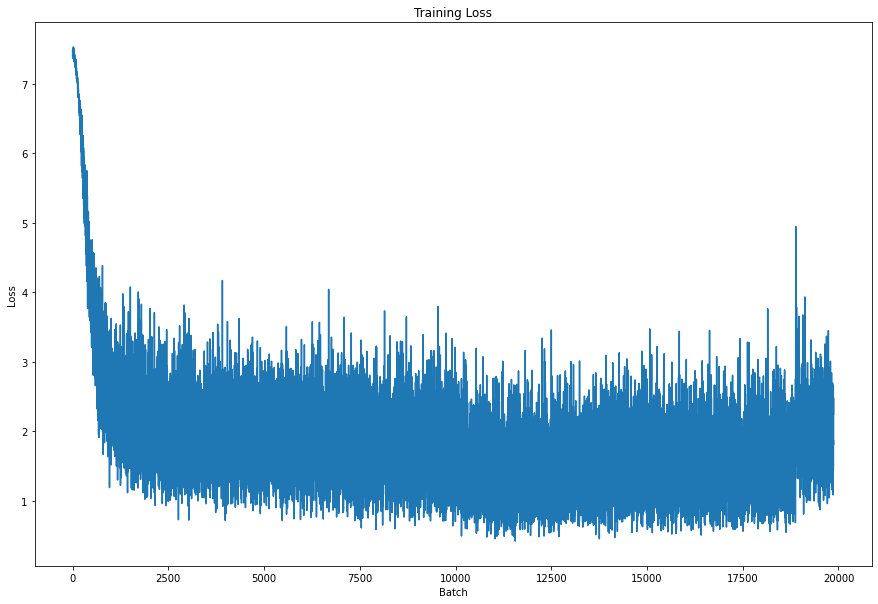

In [11]:
#for albert
RawResult = collections.namedtuple("RawResult",
                                   ["unique_id", "start_logits", "end_logits", "cls_logits"])

# Calculation for optimization steps accordingly training length, which will be used for learning rate for BERT model
train_optimization_steps = len(
            training_dataloader
        )

# Fetch the training hyperparameters
parameter_optimizer = list(model1.named_parameters())
parameter_optimizer = [n for n in parameter_optimizer if 'pooler' not in n[0]]
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in parameter_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in parameter_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]


# Load apex optimizers
optimizer = AdamW(optimizer_grouped_parameters,
                                  lr=2e-5)
#optimizer = FP16_Optimizer(optimizer, dynamic_loss_scale=True)


n_gpu = torch.cuda.device_count()
# Accuracy and loss for plotting
plot_data = []
for epoch in trange(2, desc="Epoch"): # Epoch provided: 3, restricted for now to avoid the memory issue but can be increased to improve the model
  for step, batch in enumerate(
          tqdm(training_dataloader,
                desc="Iteration",
                disable=-1 not in [-1, 0])):
    if n_gpu == 1: # check for gpu count 
          batch = tuple(
              t.to(device)
              for t in batch)
    # Get the batch data to be provided to the model
    dataset_input_ids,dataset_input_masks,dataset_segment_ids, dataset_start_positions, dataset_end_positions, dataset_class_index = batch
    loss = model1(dataset_input_ids, dataset_segment_ids, dataset_input_masks,
                    dataset_start_positions, dataset_end_positions, dataset_class_index)
     # Adding the loss to plot data to plot the graph in the end 
    loss.backward()
    plot_data.append(loss.detach().item())
    print(loss.detach().item())
    if step < 5000:
          lr_this_step = np.linspace(0, 3e-5, 5001)[1:]
          for param_group in optimizer.param_groups:
            param_group['lr'] = lr_this_step[step]
    else:
          param_group['lr']= (1+ cos(step*pi/len(training_dataloader)))*1/2*(3e-5)
    optimizer.step()
    optimizer.zero_grad()
    #global_step += 1
torch.save(model1, 'outputs/albert_base_16.pth')
import matplotlib.pyplot as pplot

# Graph plotting code X axis is Batch and Y axis is loss
pplot.figure(figsize= (15, 10))
pplot.title("Training Loss")
pplot.xlabel("Batch")
pplot.ylabel("Loss")
pplot.plot(plot_data)
pplot.savefig('outputs/albert_base_16.png', dpi=300, bbox_inches='tight')
pplot.show()

In [12]:
output_directory = 'outputs'

# If output directory doesn't exist create one
if not os.path.exists(output_directory):
  os.makedirs(output_directory)


In [ ]:
# Read COQA Dev file, File path needs to be provided where COQA dev file is stored
testing_samples = get_data_from_coqa(False, input_file="data/coqa-dev-v1.0.json",
                                                history_len= 2,
                                                add_QA_tag= False)

Generating examples:   0%|          | 0/500 [00:00<?, ?it/s]

500


Generating examples:  98%|█████████▊| 489/500 [30:04<00:09,  1.12it/s]

In [ ]:
# Converting the development examples to features
testing_features = converting_examples_into_features(
                examples=testing_samples,
                tokenizer=bert_tokenizer,
                maximum_sequence_length=450,
                document_stride=128,
                maximum_query_length=75,
            )
print(testing_features[0])

In [ ]:
#Tensor construction for input ids
dataset_input_ids = torch.tensor([f.input_ids for f in testing_features], dtype=torch.long)
print(dataset_input_ids)

#Tensor construction for input masks
dataset_input_masks = torch.tensor([f.input_mask for f in testing_features], dtype=torch.long)
print(dataset_input_masks)

#Tensor construction for segment ids
dataset_segment_ids = torch.tensor([f.segments for f in testing_features], dtype=torch.long)
print(dataset_segment_ids)

dataset_example_index  = torch.arange(dataset_input_ids.size(0), dtype=torch.long)

# Wrapping tensors in a tensor dataset
testing_data = TensorDataset(dataset_input_ids, dataset_input_masks, dataset_segment_ids, dataset_example_index)
print(testing_data)

# Sampling the elements in the same order they are(sequentially)
testing_data_sampler = SequentialSampler(testing_data)
print(testing_data_sampler)

# Creating python iterable over tensor dataset
testing_dataloader = DataLoader(testing_data, sampler=testing_data_sampler, batch_size=8)
print(testing_dataloader) 

In [ ]:

#bert = torch.load('output_models/bert_test1.pth')



In [ ]:
#bert_i = torch.load('output_models/bert_i_test1.pth')
#albert = torch.load('output_models/albert_test1.pth')
#roberta = torch.load('output_models/roberta_test1.pth')

In [ ]:
# Fetch the results for predictions using the trained model
results_for_predictions = []
for tqdm_input_ids, tqdm_input_mask, tqdm_segment_ids, tqdm_example_indices in tqdm(
                testing_dataloader,
                desc="Evaluation",
                disable=-1 not in [-1, 0]):
   
  tqdm_input_ids = tqdm_input_ids.to(device)
  tqdm_input_mask = tqdm_input_mask.to(device)
  tqdm_segment_ids = tqdm_segment_ids.to(device)

  # Get all the results from the model
  # Ensemble the results from Albert and BERT
  with torch.no_grad():
    model_batch_start_logits, model_batch_end_logits, model_batch_cls_logits = model1(tqdm_input_ids, tqdm_segment_ids, tqdm_input_mask)  
    #model_batch_start_logits, model_batch_end_logits, model_batch_cls_logits = bert_i(tqdm_input_ids, tqdm_segment_ids, tqdm_input_mask)  
    #model_batch_start_logits, model_batch_end_logits, model_batch_cls_logits = albert(tqdm_input_ids, tqdm_segment_ids, tqdm_input_mask)  
    #model_batch_start_logits, model_batch_end_logits, model_batch_cls_logits = roberta(tqdm_input_ids, tqdm_segment_ids, tqdm_input_mask)    
   # robertamodel_batch_start_logits, robertamodel_batch_end_logits, robertamodel_batch_cls_logits = roberta(tqdm_input_ids, tqdm_segment_ids, tqdm_input_mask)
   # bertmodel_batch_start_logits, bertmodel_batch_end_logits, bertmodel_batch_cls_logits = bert(tqdm_input_ids, tqdm_segment_ids, tqdm_input_mask)
   # albertmodel_batch_start_logits, albertmodel_batch_end_logits, albertmodel_batch_cls_logits = albert(tqdm_input_ids, tqdm_segment_ids, tqdm_input_mask)
  #model_batch_start_logits = (bertmodel_batch_start_logits +albertmodel_batch_start_logits)/2
  #model_batch_end_logits = (bertmodel_batch_end_logits+albertmodel_batch_end_logits)/2 
  #model_batch_cls_logits =(bertmodel_batch_cls_logits+ albertmodel_batch_cls_logits)/2
 
   
  # Get the start end logists from the model and store it in results
  for i, tqdm_example_index in enumerate(tqdm_example_indices):
    this_start_logits = model_batch_start_logits[i].detach().cpu().tolist()
    this_end_logits = model_batch_end_logits[i].detach().cpu().tolist()
    this_cls_logits = model_batch_cls_logits[i].detach().cpu().tolist()
    testing_feature = testing_features[tqdm_example_index.item()]
    unique_id = int(testing_feature.unique_id)
 
    # Store the prediction in the results list
    results_for_predictions.append(
                    RawResult(unique_id=unique_id,
                    start_logits= this_start_logits,
                    end_logits= this_end_logits,
                    cls_logits= this_cls_logits))

In [ ]:
#op_pred_file = os.path.join(output_directory, "Output_Preds_bert.json")
#output_nbest_file = os.path.join(output_directory, "nbest_predictions_bert.json")
#op_pred_file = os.path.join(output_directory, "Output_Preds_bert_i.json")
#output_nbest_file = os.path.join(output_directory, "nbest_predictions_bert_i.json")
op_pred_file = os.path.join(output_directory, "Output_Preds_albert_base_16.json")
output_nbest_file = os.path.join(output_directory, "nbest_predictions_albert_base_16.json")
#op_pred_file = os.path.join(output_directory, "Output_Preds_roberta.json")
#output_nbest_file = os.path.join(output_directory, "nbest_predictions_roberta.json")

In [ ]:

# Get the appropriate index for the answer text
def compute_best_indices(logits, n):
  index_with_score = sorted(enumerate(logits),
                             key=lambda x: x[1],
                             reverse=True)
   
  best_indices = []
  for i in range(len(index_with_score)):
    if i >= n:
      break
    best_indices.append(index_with_score[i][0])
  return best_indices
# Get the final text fetching it from the span using the predicted answer
def output_final_answer_text(predicted_text, original_text, low_case, v_log=False):
  def remove_spaces(text):
    non_space_chars = []
    non_space_char_to_space_char_map = collections.OrderedDict()
    for (i, c) in enumerate(text):
      if c == " ":
        continue
      non_space_char_to_space_char_map[len(non_space_chars)] = i
      non_space_chars.append(c)
    non_space_text = "".join(non_space_chars)
    return (non_space_text, non_space_char_to_space_char_map)

  # Get the BERT tokenizer to tokenize the text
  tokenizer = BasicTokenizer(do_lower_case=low_case)
  tokenized_text = " ".join(tokenizer.tokenize(original_text))

  # Find predicted text in the tokenized text to get the start and end positions
  start_position = tokenized_text.find(predicted_text)
  if start_position == -1:
      return original_text
  end_position = start_position + len(predicted_text) - 1

  # Remove spaces if any
  (original_non_space_text, original_non_space_to_space_map) = remove_spaces(original_text)
  (tokenized_non_space_text, tokenized_non_space_to_space_map) = remove_spaces(tokenized_text)

  if len(original_non_space_text) != len(tokenized_non_space_text):
    return original_text

  tokenized_non_space_to_space_map = {}
  for (i, _tokenized_index) in tokenized_non_space_to_space_map.items():
    tokenized_non_space_to_space_map[_tokenized_index] = i

  # Get the start position
  original_start_position = None
  if start_position in tokenized_non_space_to_space_map:
    non_space_start_position = tokenized_non_space_to_space_map[start_position]
    if non_space_start_position in original_non_space_to_space_map:
      original_start_position = original_non_space_to_space_map[non_space_start_position]
  
  # Check if the start position is None
  if original_start_position is None:
    return original_text

  # Get the End position
  original_text_end_position = None
  if end_position in tokenized_non_space_to_space_map:
    non_space_end_position = tokenized_non_space_to_space_map[end_position]
    if non_space_end_position in original_non_space_to_space_map:
      original_text_end_position = original_non_space_to_space_map[non_space_end_position]

  # Check if the end position is None
  if original_text_end_position is None:
    return original_text
  
  # Get the answer using start position and end position in the text
  final_output_text = original_text[original_start_position:(original_text_end_position + 1)]
  return final_output_text
# Calculates the probability of the span found
def compute_softmax_score(scores):
  if not scores:
    return []

  maximum_softmax_score = None
  for score in scores:
    if maximum_softmax_score is None or score > maximum_softmax_score:
      maximum_softmax_score = score

  expected_scores = []
  total_score_sum = 0.0
  for score in scores:
    x = math.exp(score - maximum_softmax_score)
    expected_scores.append(x)
    total_score_sum += x

  probabilities = []
  for score in expected_scores:
    probabilities.append(score / total_score_sum) # Probability calculation using the softmax score
  return probabilities

# Removing punctuations, lowering texts and removing extra white spaces
def normalize_answer1(s):
    
    # Remove articles from the text
    def remove_articles(text):
        regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(regex, ' ', text)
    
    # Remove white spaces from the text
    def white_space_fix(text):
        return ' '.join(text.split())

    # Remove punctuations from the text
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    # Lower the text characters
    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

# Check if the predictions are numbers or boolean values then set those to string equivalent
def confirm_predictions(json_best_predictions):
  # Number strings that will be used to represent numbers in the answers instead of actual numbers
  subs = ['one', 'two', 'three','four','five','six','seven','eight','nine','ten','eleven','twelve','true','false']
  original = json_best_predictions[0]['text']
  if len(original) < 2:
    for e in json_best_predictions[1:]:
      if normalize_answer1(e['text']) in subs:
        return e['text']
    return 'unknown'
  return original
# Function to Predict answers and write those predictions to predictions file 
def predict_answers(test_samples, test_sample_features, results_for_predictions, best_size,
                  maximum_answer_length, low_case, op_pred_file, v_log,
                  null_score_threshold):
  
  ex_index_to_feat_index = collections.defaultdict(list)
  
  # Create the dictionary of all the features in test features keeping feature index as key
  for feature in test_sample_features:
    ex_index_to_feat_index[feature.example_index].append(feature)
 
  ids_for_results = {}
  for result in results_for_predictions:
    ids_for_results[result.unique_id] = result
   
  # Naming the tuples for predictions
  Preliminary_Predictions = collections.namedtuple(
      "Preliminary_Predictions", [
                           "feature_index",
                           "start_index",
                           "end_index",
                           "start_logit",
                           "end_logit",
                           "class_logit",
                           "class_index",
      ])
  
  complete_predictions = []
  best_n_predictions_json = collections.OrderedDict() #in this case best 30 predictions
  prediction_scores_json = collections.OrderedDict()
  
  for (example_index, example) in enumerate(
      tqdm(test_samples, desc="Predicting...")):
    features = ex_index_to_feat_index[example_index]
     
    preliminary_predictions = []

    part_preliminary_predictions = []

    # Indices initialization
    score_of_answer_yes, score_of_answer_no, score_span, score_of_no_answer = -float('INF'), -float('INF'), -float('INF'), float('INF')

    
    minimum_no_answer_feature_index, maximum_yes_feature_index, maximum_no_feature_index, maximum_span_feature_index = 0, 0, 0, 0
    max_span_start_indexes, max_span_end_indexes = [], []
     
    # get the best start and end indices
    for (feature_index, feature) in enumerate(features):
       
      result = ids_for_results[feature.unique_id]
      # check the score for each class and determine the output yes, no, or span, or unknown 
      feature_yes_score, feature_no_score, feature_noanswer_score, feature_span_score = result.cls_logits 
       
      if feature_noanswer_score < score_of_no_answer:
        score_of_no_answer = feature_noanswer_score
        minimum_no_answer_feature_index = feature_index
      if feature_yes_score > score_of_answer_yes:
        score_of_answer_yes = feature_yes_score
        maximum_yes_feature_index = feature_index
      if feature_no_score > score_of_answer_no:
        score_of_answer_no = feature_no_score
        maximum_no_feature_index = feature_index
      # Here hasn't assign the correct class yet
      if feature_span_score > score_span:
        score_span = feature_span_score
        maximum_span_feature_index = feature_index
        start_indices = compute_best_indices(result.start_logits,
                                                  best_size)
        end_indices = compute_best_indices(result.end_logits, best_size)
        maximum_span_start_indices, maximum_span_end_indices = start_indices, end_indices
      
         
    
    preliminary_predictions.append(
        Preliminary_Predictions(feature_index=minimum_no_answer_feature_index,
                                start_index=0,
                                end_index=0,
                                start_logit=-float('INF'),
                                end_logit=-float('INF'),
                                class_logit=score_of_no_answer,
                                class_index=2))
    preliminary_predictions.append(
              Preliminary_Predictions(feature_index=maximum_yes_feature_index,
                                start_index=0,
                                end_index=0,
                                start_logit=-float('INF'),
                                end_logit=-float('INF'),
                                class_logit=score_of_answer_yes,
                                class_index=0))
    preliminary_predictions.append(
              Preliminary_Predictions(feature_index=maximum_no_feature_index,
                                start_index=0,
                                end_index=0,
                                start_logit=-float('INF'),
                                end_logit=-float('INF'),
                                class_logit=score_of_answer_no,
                                class_index=1))
    preliminary_predictions.append(
              Preliminary_Predictions(feature_index=maximum_span_feature_index,
                                start_index=0,
                                end_index=0,
                                start_logit=-float('INF'),
                                end_logit=-float('INF'),
                                class_logit=score_span,
                                class_index=3))
   
    feature = features[maximum_span_feature_index]
    for start_index in maximum_span_start_indices:
      for end_index in maximum_span_end_indices:
        
        if start_index >= len(feature.tokens):
          continue
        if end_index >= len(feature.tokens):
          continue
        if start_index not in feature.token_to_origin_mapping:
          continue
        if end_index not in feature.token_to_origin_mapping:
          continue
        if not feature.token_max_context.get(start_index, False):
          continue
        if end_index < start_index:
          continue
        length = end_index - start_index + 1
        if length > maximum_answer_length:
          continue
        
        part_preliminary_predictions.append(
                      Preliminary_Predictions(
                          feature_index=maximum_span_feature_index,
                          start_index=start_index,
                          end_index=end_index,
                          start_logit=ids_for_results[
                              feature.unique_id].start_logits[start_index],
                          end_logit=ids_for_results[
                              feature.unique_id].end_logits[end_index],
                          class_logit=score_span,
                          class_index=3))
    ##this is to sort the largest score value for start and end pair    
    part_preliminary_predictions = sorted(
              part_preliminary_predictions,
              key=lambda p: p.start_logit + p.end_logit,
              reverse=True)
    ##this is to sort the largest score value for class 
    preliminary_predictions = sorted(preliminary_predictions,
                                      key=lambda p: p.class_logit,
                                      reverse=True)
    
    Best_Predictions = collections.namedtuple(  
              "Best_Predictions",
              ["text", "start_logit", "end_logit", "class_logit", "class_index"])
    
    known_predictions = {}
    best = []
    class_rank = []
    for prediction in part_preliminary_predictions:
      if len(best) >= best_size:
        break
      feature = features[prediction.feature_index]
      if prediction.class_index == 3:
        tokenized_tokens = feature.tokens[prediction.start_index:(prediction.end_index + 1)]
        original_document_start = feature.token_to_origin_mapping[prediction.start_index]
        original_document_end = feature.token_to_origin_mapping[prediction.end_index]
        original_tokens = example.document_tokens[original_document_start:(original_document_end + 1)]
        
        tokenized_text = " ".join(tokenized_tokens)

        tokenized_text = tokenized_text.replace(" ##", "")
        tokenized_text = tokenized_text.replace("##", "")

        tokenized_text = tokenized_text.strip()
        tokenized_text = " ".join(tokenized_text.split())
        original_text = " ".join(original_tokens)

        final_output_text = output_final_answer_text(tokenized_text, original_text, low_case, v_log)
         
        if final_output_text in known_predictions:
          continue

        known_predictions[final_output_text] = True
        best.append(
                      Best_Predictions(text=final_output_text,
                                      start_logit=prediction.start_logit,
                                      end_logit=prediction.end_logit,
                                      class_logit=prediction.class_logit,
                                      class_index=prediction.class_index))
    
    # Writing the approriate answers in predictions which will be written to json file
    if not best or len(best) < 1: 
      best.append(
                  Best_Predictions(text="unknown",
                                  start_logit=-float('INF'),
                                  end_logit=-float('INF'),
                                  class_logit=score_span,
                                  class_index=3))
    for prediction in preliminary_predictions:
      if prediction.class_index == 3:
        final_output_text = best[0].text
        class_rank.append(
                      Best_Predictions(text=final_output_text,
                                      start_logit=best[0].start_logit,
                                      end_logit=best[0].end_logit,
                                      class_logit=prediction.class_logit,
                                      class_index=prediction.class_index))
      elif prediction.class_index == 0:
        final_output_text = "yes"
        class_rank.append(
                      Best_Predictions(text=final_output_text,
                                      start_logit=-float('INF'),
                                      end_logit=-float('INF'),
                                      class_logit=prediction.class_logit,
                                      class_index=prediction.class_index))
      elif prediction.class_index == 1:
                  final_output_text = "no"
                  class_rank.append(
                      Best_Predictions(text=final_output_text,
                                      start_logit=-float('INF'),
                                      end_logit=-float('INF'),
                                      class_logit=prediction.class_logit,
                                      class_index=prediction.class_index))
      elif prediction.class_index == 2:
                  final_output_text = "unknown"
                  class_rank.append(
                      Best_Predictions(text=final_output_text,
                                      start_logit=-float('INF'),
                                      end_logit=-float('INF'),
                                      class_logit=prediction.class_logit,
                                      class_index=prediction.class_index))
                  
    assert len(best) >= 1

    total_scores = []
    class_scores = []
    for item in best:
      total_scores.append(item.start_logit + item.end_logit)
    for rank in class_rank:
      class_scores.append(rank.class_logit)
    
    # calculate Softmax
    span_probabilities = compute_softmax_score(total_scores)
    class_probabilities = compute_softmax_score(class_scores)
    best_predictions_json = []

    current_rank, current_probabilities, current_scores = (
        best, span_probabilities,
        total_scores) if class_rank[0].class_index == 3 and len(best) > 1 else (
            class_rank, class_probabilities, class_scores)
    
    
    # Store the answer text, probability and score for each entry
    for i, entry in enumerate(current_rank): 
      predicted_outputs = collections.OrderedDict()
      predicted_outputs["text"] = entry.text
      predicted_outputs["probability"] = current_probabilities[i]
      predicted_outputs["score"] = current_scores[i]
      best_predictions_json.append(predicted_outputs)

    assert len(best_predictions_json) >= 1

    _id, _turn_id = example.question_answer_id.split()
    complete_predictions.append({'id': _id, 'turn_id': int(_turn_id), 'answer': confirm_predictions(best_predictions_json)})
    best_n_predictions_json[example.question_answer_id] = best_predictions_json

  # Write the prediction files
  with open(op_pred_file, "w") as writer:
        writer.write(json.dumps(complete_predictions, indent=4) + "\n")
  
  with open(output_nbest_file, "w") as writer:
        writer.write(json.dumps(best_n_predictions_json, indent=4) + "\n")

In [ ]:
# Call to predict answers functions to write them to predictions file
predict_answers(testing_samples, testing_features, results_for_predictions, 20, 30, True, 
                  op_pred_file, True, 0.0)





Predicting...:   0%|          | 0/7983 [00:00<?, ?it/s]



Predicting...:   0%|          | 30/7983 [00:00<00:26, 297.48it/s]



Predicting...:   1%|          | 57/7983 [00:00<00:27, 286.63it/s]



Predicting...:   1%|          | 84/7983 [00:00<00:28, 279.09it/s]



Predicting...:   1%|▏         | 113/7983 [00:00<00:28, 279.69it/s]



Predicting...:   2%|▏         | 139/7983 [00:00<00:28, 271.39it/s]



Predicting...:   2%|▏         | 168/7983 [00:00<00:28, 276.44it/s]



Predicting...:   2%|▏         | 197/7983 [00:00<00:27, 278.83it/s]



Predicting...:   3%|▎         | 225/7983 [00:00<00:27, 278.99it/s]



Predicting...:   3%|▎         | 252/7983 [00:00<00:28, 272.84it/s]



Predicting...:   3%|▎         | 279/7983 [00:01<00:28, 269.96it/s]



Predicting...:   4%|▍         | 307/7983 [00:01<00:28, 271.15it/s]



Predicting...:   4%|▍         | 334/7983 [00:01<00:28, 270.12it/s]



Predicting...:   5%|▍         | 362/7983 [00:01<00:27, 272.89it/s]



Predicting...:   5%|▍         

In [ ]:
#!python3 evaluate.py --data-file data/coqa-dev-v1.0.json --pred-file outputs/Output_Preds_bert_i.json
!python3 evaluate.py --data-file data/coqa-dev-v1.0.json --pred-file outputs/Output_Preds_albert_base_16.json
#!python3 evaluate.py --data-file data/coqa-dev-v1.0_.json --pred-file outputs/Output_Preds_roberta.json


{
  "children_stories": {
    "em": 60.7,
    "f1": 72.7,
    "turns": 1425
  },
  "literature": {
    "em": 59.3,
    "f1": 70.0,
    "turns": 1630
  },
  "mid-high_school": {
    "em": 56.4,
    "f1": 67.8,
    "turns": 1653
  },
  "news": {
    "em": 61.5,
    "f1": 72.9,
    "turns": 1649
  },
  "wikipedia": {
    "em": 65.5,
    "f1": 76.5,
    "turns": 1626
  },
  "reddit": {
    "em": 0.0,
    "f1": 0.0,
    "turns": 0
  },
  "science": {
    "em": 0.0,
    "f1": 0.0,
    "turns": 0
  },
  "in_domain": {
    "em": 60.7,
    "f1": 72.0,
    "turns": 7983
  },
  "out_domain": {
    "em": 0.0,
    "f1": 0.0,
    "turns": 0
  },
  "overall": {
    "em": 60.7,
    "f1": 72.0,
    "turns": 7983
  }
}


In [ ]:
torch.save(testing_data, 'test_tensor_albert.pt')